<a href="https://colab.research.google.com/github/amerycong/intel_inhouse_rankings/blob/main/inhouse_rankings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code

In [ ]:
try:
    import trueskill
except:
    %pip install trueskill
    import trueskill
import numpy as np
import pandas as pd
import random
import itertools
import bisect
import os
import json
import ipywidgets as widgets
import IPython
import requests
import collections
import seaborn as sns
import matplotlib.pyplot as plt

  Created wheel for trueskill: filename=trueskill-0.4.5-cp36-none-any.whl size=18033 sha256=27e5dcd3fedc526ba792dff4572067413add7d6cfc7ec4b14134a84c922a677b
  Stored in directory: /root/.cache/pip/wheels/63/f3/6c/08a1b5dbd92bbc5ef69e7f991955889469cd84a5bc94be4e2c
Successfully built trueskill


In [ ]:
version = requests.get('https://ddragon.leagueoflegends.com/api/versions.json').json()[0]
champs = requests.get('https://ddragon.leagueoflegends.com/cdn/{}/data/en_US/champion.json'.format(version)).json()
CHAMP_ICON_URL = 'https://ddragon.leagueoflegends.com/cdn/{}/img/champion/{{}}.png'.format(version)
champs_by_key = {int(champ['key']): champ for champ in champs['data'].values()}

In [ ]:
SMURFS = {
    'King Cong': 'TensorFlow',
    'SlantyEyes': 'TensorFlow',
    'Vladahri': 'Ahrizona',
    'IAS Viper': 'Miss Viper',
    'loli egirl UwUxo': 'TensorFlow',
    'ohHawlo': 'import antigrvty',
    'PaoIa': 'GaI Gadot'
}


def get_canonical_name(name):
    return SMURFS[name] if name in SMURFS else name


def parse_match(raw):
    match = json.loads(raw)
    
    match_id = match["gameId"]    
    match_duration = match["gameDuration"]
    identities = {
        pid["participantId"]: pid["player"] for pid in match["participantIdentities"]
    }

    win_team, loss_team = (
        next(team["teamId"] for team in match["teams"] if team["win"] == result)
        for result in ("Win", "Fail")
    )

    win, loss = (
        tuple(
            get_canonical_name(identities[p["participantId"]]["summonerName"])
            for p in match["participants"]
            if p["teamId"] == team
        )
        for team in (win_team, loss_team)
    )
    
    match_bans = [champs_by_key[x['championId']]['id'] for x in match["teams"][0]["bans"]+match["teams"][1]["bans"]]
    player_stats = {
        get_canonical_name(identities[p["participantId"]]["summonerName"]): {
              'win': p["stats"]["win"],
              'kills': p["stats"]["kills"],
              'deaths': p["stats"]["deaths"],
              'assists': p["stats"]["assists"],
              'role': p['timeline']['role'],
              'lane': p['timeline']['lane'],
              'cs_minion': p["stats"]["totalMinionsKilled"],
              'cs_neutral': p["stats"]["neutralMinionsKilled"],
              'vision': p["stats"]["visionScore"],
              'gold': p["stats"]["goldEarned"],
              'total_dmg_champs': p["stats"]['totalDamageDealtToChampions'],
              'cs_diff_10': p["timeline"]['csDiffPerMinDeltas']['0-10']*10 if 'csDiffPerMinDeltas' in p["timeline"].keys() and '0-10' in p["timeline"]['csDiffPerMinDeltas'].keys() else 0, #this shit bugged, not in all games
              'cs_diff_20': p["timeline"]['csDiffPerMinDeltas']['0-10']*10+p["timeline"]['csDiffPerMinDeltas']['10-20']*10 if 'csDiffPerMinDeltas' in p["timeline"].keys() and '10-20' in p["timeline"]['csDiffPerMinDeltas'].keys() else 0, #cs diff unreliable for 20+30, ignores monsters
              'cs_diff_30': p["timeline"]['csDiffPerMinDeltas']['0-10']*10+p["timeline"]['csDiffPerMinDeltas']['10-20']*10+p["timeline"]['csDiffPerMinDeltas']['20-30']*10 if 'csDiffPerMinDeltas' in p["timeline"].keys() and '20-30' in p["timeline"]['csDiffPerMinDeltas'].keys() else 0, #cs diff unreliable for 20+30, ignores monsters
              'champ': champs_by_key[p['championId']]['id'],
              'match_duration': match_duration
        }
        for p in match["participants"]
    }
    if False:
      #stats with shitters
      b= 'ANiceSunset'
      a= 'Ahrizona'
      if a in player_stats.keys() and b in player_stats.keys():
        if (a in win and b in win) or (a in loss and b in loss):
          player_stats[a+' ('+b+')']=player_stats.pop(a)
          win = tuple([x.replace(a,a+' ('+b+')') for x in list(win)])
          loss = tuple([x.replace(a,a+' ('+b+')') for x in list(loss)])

    if False:
      #jg only stats (shit junglers)
      for n in ['TensorFlow','Miss Viper']:
        if n in player_stats.keys():
          if player_stats[n]['lane']=='JUNGLE':
            player_stats[n+' (jungle)']=player_stats.pop(n)
            win = tuple([x.replace(n,n+' (jungle)') for x in list(win)])
            loss = tuple([x.replace(n,n+' (jungle)') for x in list(loss)])
    if False:
      #lane only stats (jg in lane lul)
      for n in ['MrRgrs','Namikami']:       
        if n in player_stats.keys():
          if player_stats[n]['lane']!='JUNGLE':
            player_stats[n+' (lane)']=player_stats.pop(n)
            win = tuple([x.replace(n,n+' (lane)') for x in list(win)])
            loss = tuple([x.replace(n,n+' (lane)') for x in list(loss)])
    if False:
      #adc only stats 
      for n in ['ANiceSunset','Ahrizona','Kurtzorz']:       
        if n in player_stats.keys():
          if (player_stats[n]['role']!='DUO_SUPPORT') and (player_stats[n]['lane']=='BOTTOM'):
            player_stats[n+' (adc)']=player_stats.pop(n)
            win = tuple([x.replace(n,n+' (adc)') for x in list(win)])
            loss = tuple([x.replace(n,n+' (adc)') for x in list(loss)])

    return pd.Series({
        'match_id': match_id,
        'win': win,
        'loss': loss,
        'bans': match_bans,
        'player_stats': player_stats,
    })


def compute_division_boundaries():
    divisions = [
        "{} {}".format(tier, division)
        for tier in [
            "8086",
            "Pentium",
            "Celeron",
            "Core i3",
            "Core i5",
            "Core i7",
            "Core i9",
            "Xeon",
        ]
        for division in ["IV", "III", "II", "I"]
    ]
    division_boundaries = [(float("-inf"), divisions[0])]
    min_rating = trueskill.global_env().mu - 3 * trueskill.global_env().sigma
    max_rating = trueskill.global_env().mu + 3 * trueskill.global_env().sigma
    division_boundaries.extend(
        (
            min_rating + i * (max_rating - min_rating) / (len(divisions) - 1),
            divisions[i + 1],
        )
        for i in range(len(divisions) - 1)
    )
    return division_boundaries


def find_division(boundaries, rating):
    chally = False
    prev_cutoff = boundaries[bisect.bisect(boundaries, (rating, "")) - 1][0]
    try:
      next_cutoff = boundaries[bisect.bisect(boundaries, (rating, ""))][0]
    except:
      chally = True
    if prev_cutoff == -np.inf:
      lp_diff = boundaries[2][0]-boundaries[1][0]
      lp = int(round(100-(next_cutoff-rating)/lp_diff*100))
    elif chally:
      lp_diff = boundaries[-1][0]-boundaries[-2][0]
      lp = int(round((rating-prev_cutoff)/lp_diff*100))
    else:
      lp = int(round((rating-prev_cutoff)/(next_cutoff-prev_cutoff)*100))
    return boundaries[bisect.bisect(boundaries, (rating, "")) - 1][1]+' '+str(lp)+' LP'

def compute_record(stats):
    win = sum(1 for game in stats if game and game["win"])
    loss = sum(1 for game in stats if game and not game["win"])
    return "{:.0%} ({}W {}L)".format(win / (win + loss), win, loss)


def compute_streak(stats):
    last_result = None
    count = 0
    for game in stats[::-1]:
        if game is not None:
            if last_result is None:
                last_result = game["win"]
            if game["win"] == last_result:
                count += 1
            else:
                break
    return "{}{}".format(count, "W" if last_result else "L")

def compute_kda(stats,string=True):
    num_games = sum(1 for game in stats if game)
    kills = sum(game['kills'] for game in stats if game) / num_games
    deaths = sum(game['deaths'] for game in stats if game) / num_games
    assists = sum(game['assists'] for game in stats if game) / num_games
    kda =  (kills + assists) / max(1,deaths)
    if string:
      return "{:.1f} / {:.1f} / {:.1f} ({:.1f})".format(kills, deaths, assists, kda)
    else:
      return kda
  
def compute_gametime(stats):
    total_game_duration = sum(game['match_duration']/60.0 for game in stats if game)
    num_games = sum(1 for game in stats if game)
    gametime = total_game_duration / num_games
    return "{:.2f}".format(gametime)

def compute_cspm(stats):
    total_game_duration = sum(game['match_duration']/60.0 for game in stats if game if game['role'] not in ['DUO_SUPPORT'])#not (game['role'] in ['DUO_SUPPORT'] and game['lane'] in ['BOTTOM']))
    if total_game_duration == 0:
      return "-1"
    cspm = sum(game['cs_minion']+game['cs_neutral'] for game in stats if game if game['role'] not in ['DUO_SUPPORT']) / total_game_duration#not (game['role'] in ['DUO_SUPPORT'] and game['lane'] in ['BOTTOM'])) / total_game_duration
    return "{:.1f}".format(cspm)

def compute_visionpm(stats):
    total_game_duration = sum(game['match_duration']/60.0 for game in stats if game)# if game['role'] not in ['DUO_SUPPORT'])
    #num_games = sum(1 for game in stats if game)
    if total_game_duration == 0:
      return "-1"
    #vision_score = sum(game['vision'] for game in stats if game) / num_games
    visionpm = sum(game['vision'] for game in stats if game) / total_game_duration
    return "{:.2f}".format(visionpm)

def compute_dmgpm(stats):
    total_game_duration = sum(game['match_duration']/60.0 for game in stats if game if game['role'] not in ['DUO_SUPPORT'])
    if total_game_duration == 0:
      return "-1"
    dmg = sum(game['total_dmg_champs'] for game in stats if game if game['role'] not in ['DUO_SUPPORT']) / total_game_duration
    return "{:.0f}".format(dmg)

def compute_dmgpg(stats):
    total_gold = sum(game['gold'] for game in stats if game if game['role'] not in ['DUO_SUPPORT'])
    if total_gold == 0:
      return "-1"
    dmg = sum(game['total_dmg_champs'] for game in stats if game if game['role'] not in ['DUO_SUPPORT']) / total_gold
    return "{:.2f}".format(dmg)

def compute_gpm(stats):
    total_game_duration = sum(game['match_duration']/60.0 for game in stats if game if game['role'] not in ['DUO_SUPPORT'])
    if total_game_duration == 0:
      return "-1"
    gpm = sum(game['gold'] for game in stats if game if game['role'] not in ['DUO_SUPPORT']) / total_game_duration
    return "{:.0f}".format(gpm)

def compute_csdiff(stats,time=10):
    #time = 10,20,30
    num_games = sum(1 for game in stats if game if 'cs_diff_'+str(time) in game.keys() if game['role'] not in ['DUO_SUPPORT'] if game['lane'] not in ['JUNGLE'])
    if num_games == 0:
      return "-1"
    csdiff = sum(game['cs_diff_'+str(time)] for game in stats if game if 'cs_diff_'+str(time) in game.keys() if game['role'] not in ['DUO_SUPPORT'] if game['lane'] not in ['JUNGLE']) / num_games
    return "{:.1f}".format(csdiff)

def compute_dick_length(stats):
    total_num_champs = len(champs['data'])
    num_games = sum(1 for game in stats if game)
    num_unique_champs = len(set([game["champ"] for game in stats if game]))
    if num_unique_champs == total_num_champs:
      dick_length = 12
    else:
      bde = num_unique_champs / num_games
      avg_pp_size = 3.61
      min_games = 30 #negative activeness if under this amount of games played
      avg_champ_pool = 15 #benchmark for pos/neg pool size influence
      avg_bde = 0.5 #benchmark for champ variety (0.5 = 1 new champ every 2 games)
      gamma = 0.3 #scaling for pool multiplier
      champ_pool_multiplier = (num_unique_champs/avg_champ_pool)**gamma
      champ_playrate_std = np.std(list(collections.Counter([x['champ'] for x in stats if x is not None]).values()))
      variance_influence = 0.01 #amount of influence variance can have
      variance_multiplier = 1-variance_influence*champ_playrate_std
      bde_multiplier = bde/avg_bde
      base_activeness = 0.25
      activeness_multiplier = ((1-base_activeness)/min_games)*num_games+base_activeness if num_games < min_games else 1
      dick_length = avg_pp_size*champ_pool_multiplier*variance_multiplier*bde_multiplier*activeness_multiplier

    return "{:.2f}".format(dick_length)


def compute_ratings(matches,filter=False,sort_metric='Rating'):

    intel_list = ['TensorFlow', 'TensorFlow (jungle)', 'TensorFlow (bobz)','Sway', 
        'MrRgrs', 'MrRgrs (lane)','TheGatorMan', 'Omarlitle', 'Miss Viper',
        'Miss Viper (jungle)','Dokgaebi', 'RageMuffinz', 'ClappityBunny',
        'bobzillas', 'RastadreadNA', 'Ahrizona', 'Ahrizona (adc)', 'Ahrizona (ANiceSunset)','Kurtzorz', 'Kurtzorz (adc)','ANiceSunset', 
        'ANiceSunset (adc)', 'ANiceSunset (Ahrizona)','icaneataberger', 'Namikami','Namikami (lane)','Grateƒul', 
        'DemonKrad', 'Bradnon', 'Mindpalace', 'lego12','GaI Gadot','PaoIa','KingCyrusdaGreat',
        'Shragon','Filly Bs','CantonNeko']

    guest_list = []

    filter_list = intel_list + guest_list

    ratings = {}
    histories = {}
    new_player_history = []
    stats = {}
    new_player_stats = []
    wins = collections.defaultdict(dict)
    losses = collections.defaultdict(dict)
    totals_with = collections.defaultdict(dict)
    totals_against  = collections.defaultdict(dict)
    for _, match in matches.iterrows():
        for name in set(itertools.chain(stats.keys(), match['player_stats'])):
            stats.setdefault(name, new_player_stats[:])
            if name in match['player_stats']:
                stats[name].append(match['player_stats'][name])
            else:
                stats[name].append(None)
        new_player_stats.append(None)
        new_ratings = trueskill.rate(
            (
                {name: ratings.get(name, trueskill.Rating()) for name in match["win"]},
                {name: ratings.get(name, trueskill.Rating()) for name in match["loss"]},
            )
        )
        for new_rating in new_ratings:
            ratings.update(new_rating)

        new_player_history.append(trueskill.Rating())
        for name in ratings:
            histories.setdefault(name, new_player_history[:])
            histories[name].append(ratings[name])

        all_ppl = match['win']+match['loss']
        for i in all_ppl:
          for j in all_ppl:
            if filter:
              if i not in filter_list or j not in filter_list:
                continue
            if (i in match['win']) == (j in match['win']):
              if i in totals_with.keys() and j in totals_with[i].keys():
                wins[i][j] += 1 if (i in match['win'] and j in match['win']) else 0
                totals_with[i][j] += 1
              else:
                wins[i][j] = 1 if (i in match['win'] and j in match['win']) else 0 
                totals_with[i][j] = 1 
            else:
              if i in totals_against.keys() and j in totals_against[i].keys():
                losses[i][j] += 1 if (i in match['loss'] and j in match['win']) else 0 
                totals_against[i][j] += 1
              else:
                losses[i][j] = 1 if (i in match['loss'] and j in match['win']) else 0 
                totals_against[i][j] = 1

    rows = [(name, rating, stats[name], histories[name]) for name, rating in ratings.items()]
    ratings = pd.DataFrame.from_records(
        rows, columns=["Name", "trueskill.Rating", "stats", "history"], index="Name"
    )
    ratings.index.name = None

    boundaries = compute_division_boundaries()
    ratings["μ"] = ratings["trueskill.Rating"].apply(lambda rating: rating.mu)
    ratings["σ"] = ratings["trueskill.Rating"].apply(lambda rating: rating.sigma)
    ratings["Rating"] = ratings["trueskill.Rating"].apply(
        lambda rating: trueskill.expose(rating)
    )
    ratings["Rank"] = ratings["Rating"].apply(
        lambda rating: find_division(boundaries, rating)
    )
    ratings["Record"] = ratings["stats"].apply(lambda stats: compute_record(stats))
    ratings["Streak"] = ratings["stats"].apply(lambda stats: compute_streak(stats))
    ratings["Champs"] = ratings["stats"].apply(lambda stats:
      tuple(game["champ"] for game in stats if game)
    )
    ratings["num_champs"] = ratings["stats"].apply(lambda stats:
      len(set(tuple(game["champ"] for game in stats if game)))
    )
    ratings["dick length"] = ratings["stats"].apply(lambda stats: compute_dick_length(stats))
    ratings["KDA"] = ratings["stats"].apply(lambda stats: compute_kda(stats))
    ratings["kda_val"] = ratings["stats"].apply(lambda stats: compute_kda(stats,False))
    ratings["avg time"] = ratings["stats"].apply(lambda stats: compute_gametime(stats))
    ratings["CSpM"] = ratings["stats"].apply(lambda stats: compute_cspm(stats))
    ratings["GpM"] = ratings["stats"].apply(lambda stats: compute_gpm(stats))
    ratings["DMGpM"] = ratings["stats"].apply(lambda stats: compute_dmgpm(stats))
    ratings["DMGpG"] = ratings["stats"].apply(lambda stats: compute_dmgpg(stats))
    ratings["VisionpM"] = ratings["stats"].apply(lambda stats: compute_visionpm(stats))
    ratings["CSdiff10"] = ratings["stats"].apply(lambda stats: compute_csdiff(stats,10))
    ratings["CSdiff20"] = ratings["stats"].apply(lambda stats: compute_csdiff(stats,20))
    ratings["CSdiff30"] = ratings["stats"].apply(lambda stats: compute_csdiff(stats,30))
    ratings.sort_values(sort_metric, ascending=False, inplace=True)

    if filter:
      ratings = ratings[ratings.index.isin(filter_list)]
    
    wins = pd.DataFrame(wins)
    wins = wins.reindex(sorted(wins.columns), axis=1)
    wins = wins.sort_index()
    losses = pd.DataFrame(losses)
    losses = losses.reindex(sorted(losses.columns), axis=1)
    losses = losses.sort_index()
    totals_with = pd.DataFrame(totals_with)
    totals_with = totals_with.reindex(sorted(totals_with.columns), axis=1)
    totals_with = totals_with.sort_index()
    totals_against = pd.DataFrame(totals_against)
    totals_against = totals_against.reindex(sorted(totals_against.columns), axis=1)
    totals_against = totals_against.sort_index()
    return ratings, wins, losses, totals_with, totals_against


def format_ratings(ratings):
    return IPython.display.HTML(
        ratings[["Rating", "Rank", "Record", "Streak", "μ","KDA", "avg time", "CSpM",'CSdiff10','GpM',"DMGpM","DMGpG",'VisionpM',"dick length","Champs"]]
        .rename(columns={"μ": "MMR"})
        .style.format({
                  "Rating": "{:0.3f}",
                  "MMR": "{:0.3f}",
                  #"σ": "{:0.3f}",
                  'Champs': lambda champs: ' '.join(
                      '<img style="height:24px" src="{}" />'.format(CHAMP_ICON_URL.format(champ[0]))
                      for champ in collections.Counter(champs).most_common()
                  )
              })
              .set_properties(
                  subset=["Rating", "Rank", "Record", "MMR", "KDA", "avg time", "CSpM",'CSdiff10','GpM','DMGpM','DMGpG','VisionpM','dick length'], **{"text-align": "right"}
              )
              .render(escape=False)
    )

In [ ]:
def display_matchmaking(ratings):
    PLAYERS_PER_SIDE = 5
    PLAYERS_PER_GAME = PLAYERS_PER_SIDE * 2
    ROLES = 'tjmas'
    ROLE_PERMUTATIONS = [''.join(p) for p in itertools.permutations(ROLES)] 
    random.shuffle(ROLE_PERMUTATIONS)
    PLAYER_ROLE_PREF = {
        'TensorFlow': 'mta',
        'Omarlitle': 'tjsm',
        'Bradnon': 'f',
        'TheGatorMan': 't',
        'Sway': 'tmas',
        'Miss Viper': 'ms',
        'ANiceSunset': 'a',
        'ClappityBunny': 'f',
        'Ahrizona':'sa',
        'bobzillas': 'f',
        'MrRgrs': 'j',
        'Namikami': 'j',
        'RastadreadNA': 's',
        'Mindpalace': 's',
        'GaI Gadot': 'j',
        'KingCyrusdaGreat': 's',
        'RageMuffinz': 'tm',
        'Kurtzorz': 'a',
        'Dokgaebi': 'sa',
        'Shragon': 'at',
        'lego12': 'tmsa',
        'Filly Bs': 'tjma',
        'icaneataberger': 's',
        'RastadreadNA': 's',
        'Rockhands': 'j',
        'Boogie Smooth': 'tmj',
        'Emelia': 'a',
        'Harbay': 'm',
        'RUNFromKnifeCat': 'j',
        'Antidepression ': 'st',
        'NSFW Senpai': 'jsa',
        'foot of kicking': 'f',
        'CantonNeko': 'ma',
        'AllDueToDate': 'f'
    }
    DUO_LIST = [('Ahrizona','ANiceSunset')]

    def get_role_pref(p):
        pref = PLAYER_ROLE_PREF.get(p,ROLES)
        return ROLES if pref=='f' else pref

    def show_players(x):
        if len(x) > PLAYERS_PER_GAME:
            print("Too many players selected")
        else:
            print(
                "Matchmaking for {{{}}}{}\n".format(
                    ", ".join(x),
                    " + {} new players".format(PLAYERS_PER_GAME - len(x))
                    if len(x) < PLAYERS_PER_GAME
                    else "",
                )
            )

    def toggle(name):
        return widgets.ToggleButton(value=False, description=name, disabled=False,)

    def do_matchmaking(current_players):
        player_ratings = {
            player: ratings.loc[player, "trueskill.Rating"]
            for player in current_players
        }
        for i in range(PLAYERS_PER_GAME - len(current_players)):
            player_ratings["New player #{}".format(i + 1)] = trueskill.Rating()
        players = player_ratings.keys()

        def avg_mmr(team):
            return sum(player_ratings[player].mu for player in team) / PLAYERS_PER_SIDE

        matchups = list()
        for team1 in itertools.combinations(players, PLAYERS_PER_SIDE):
            team2 = tuple(player for player in players if player not in team1)
            if avg_mmr(team1) > avg_mmr(team2):
                continue
            quality = trueskill.quality(
                (
                    tuple(player_ratings[player] for player in team1),
                    tuple(player_ratings[player] for player in team2),
                )
            )
            matchups.append((quality, team1, team2))
        matchups.sort(reverse=True)
        for quality, team1, team2 in matchups[:12]:
            #check role satisfaction
            t1_good = False
            t1_roles= False
            t2_roles= False
            for rp in ROLE_PERMUTATIONS:
              if np.all([rp[i] in get_role_pref(p) for i,p in enumerate(team1)]):
                t1_roles = rp
                t1_good=True
                break  
            if t1_good:
              for rp in ROLE_PERMUTATIONS:
                if np.all([rp[i] in get_role_pref(p) for i,p in enumerate(team2)]):
                  t2_roles=rp
                  break
            if t1_roles and t2_roles:
              team1_roles = [n+' ('+t1_roles[i]+')' for i,n in enumerate(team1)]
              team2_roles = [n+' ('+t2_roles[i]+')' for i,n in enumerate(team2)]
              print("\n*********GOOD ROLES*********\nQuality {:.6f}".format(quality))
              print(
                  "Team 1 (average MMR {:.3f}): {}".format(
                      avg_mmr(team1), ", ".join(team1_roles)
                  )
              )
              print(
                  "Team 2 (average MMR {:.3f}): {}".format(
                      avg_mmr(team2), ", ".join(team2_roles)
                  )
              )
            else:
              print("\nQuality {:.6f}".format(quality))
              print(
                  "Team 1 (average MMR {:.3f}): {}".format(
                      avg_mmr(team1), ", ".join(team1)
                  )
              )
              print(
                  "Team 2 (average MMR {:.3f}): {}".format(
                      avg_mmr(team2), ", ".join(team2)
                  )
              )

    toggles = {
        name: toggle(name)
        for name in sorted(ratings.index.values, key=lambda s: s.lower())
    }
    out = widgets.Output()

    def observer(_):
        values = [name for name, toggle in toggles.items() if toggle.value]
        with out:
            IPython.display.clear_output(wait=True)
            show_players(values)

    for toggle in toggles.values():
        toggle.observe(observer, "value")

    left_widgets = list(toggles.values())
    run_btn = widgets.Button(description="Find matches", button_style="success")

    def on_click_run(_):
        values = [name for name, toggle in toggles.items() if toggle.value]
        with out:
            do_matchmaking(values)

    run_btn.on_click(on_click_run)
    left_widgets.append(run_btn)

    box = widgets.HBox((widgets.VBox(left_widgets), out))
    box.layout.height = "60rem"
    display(box)
    observer(None)

In [ ]:
def show_draft_stats(matches,num_shown=10,min_games=7):
  all_champs = [(x[y]['champ'],x[y]['win']) for x in matches['player_stats'] for y in list(x)]
  all_bans = [x for y in matches['bans'].tolist() for x in y]
  number_games_played = collections.Counter([x[0] for x in all_champs])
  most_played = number_games_played.most_common(num_shown)
  number_games_banned = collections.Counter(all_bans)
  most_banned = number_games_banned.most_common(num_shown)
  champ_wr = [(c,all_champs.count((c,True))/(all_champs.count((c,True))+all_champs.count((c,False))),number_games_played[c]) for c in np.unique([x[0] for x in all_champs]) if number_games_played[c]>=min_games]
  highest_wr = sorted(champ_wr, key= lambda x:x[1],reverse=True)[:num_shown]
  lowest_wr = sorted(champ_wr, key= lambda x:x[1])[:num_shown]
  print('most played champs')
  [print(x+': '+str(y)+' games') for x,y in most_played]
  print('\nmost banned champs')
  [print(x+': '+str(y)+' games') for x,y in most_banned]
  print('\nhighest wr champs ({} game minimum)'.format(min_games))
  [print('{}: {:.2f}% {} games'.format(x,y*100,z)) for x,y,z in highest_wr]
  print('\nlowest wr champs ({} game minimum)'.format(min_games))
  [print('{}: {:.2f}% {} games'.format(x,y*100,z)) for x,y,z in lowest_wr]

def show_player_wr_by_champ(matches,name=''):
  if name is not '':
    player = [(x[y]['champ'],x[y]['win']) for x in matches['player_stats'] for y in list(x) if y==name]
    champ_wr = [(c,player.count((c,True))/(player.count((c,True))+player.count((c,False))),collections.Counter([x[0] for x in player])[c]) for c in np.unique([x[0] for x in player])]
    print('\n'+name)
    [print('{}: {:.2f}% {} games'.format(x,y*100,z)) for x,y,z in champ_wr]

def plot_elo_history(ratings,name_list):
  fig,ax = plt.subplots(figsize=(20,10))
  sns.set_theme(style="darkgrid")
  for n in name_list:
    sns.lineplot(data=[trueskill.expose(x) for x in ratings['history'][n]],ax=ax)
  plt.xlabel('Game #')
  plt.ylabel('Rating')
  plt.legend(name_list)

def plot_rank_dist(ratings):
  fig,ax = plt.subplots(figsize=(20,10))
  ratings['Rating'].plot.kde()
  plt.xlabel('Rating')
  plt.title(r'$\mu={:.2f}$ ({})'.format(ratings['Rating'].mean(),find_division(compute_division_boundaries(), ratings['Rating'].mean()).rsplit(' ',2)[0]))
  db = compute_division_boundaries()
  sb = [x for x in db if 'IV' in x[1]]+[(np.inf,'Peak IV')]
  rank_color = ['dimgray','peru','silver','gold','teal','royalblue','darkviolet','red']
  for i in range(len(sb)-1):
    start_idx = max(sb[i][0],plt.xlim()[0])
    end_idx = min(sb[i+1][0],plt.xlim()[1])
    plt.axvspan(start_idx,end_idx,alpha=0.5, color = rank_color[i])

In [ ]:
def synergy(wins, totals_with):
  wr = wins/totals_with*100
  fig,ax = plt.subplots(1,2,figsize=(30,15))
  vmax = totals_with.where(~np.triu(np.ones(totals_with.shape)).astype(np.bool)).max().max()
  sns.heatmap(totals_with,ax=ax[0],cmap='bwr',vmin=0,vmax=vmax,annot=True, fmt=".0f")
  ax[0].set_title('games played with')
  normalized_wr = wr.subtract(np.diagonal(wr),axis=0)
  sns.heatmap(normalized_wr,ax = ax[1],cmap='bwr',center=0,vmin=normalized_wr.min().min(),vmax=normalized_wr.max().max(),annot=wr, fmt=".0f")
  ax[1].set_title('synergy (winrate)')

def kryptonite(wins, totals_with, losses, totals_against):
  wr = wins/totals_with*100
  avg_lr = 100-np.diagonal(wr)
  lr = losses/totals_against*100
  normalized_lr = lr.subtract(avg_lr,axis=1)
  fig,ax = plt.subplots(1,2,figsize=(30,15))
  vmax = totals_against.where(~np.triu(np.ones(totals_against.shape)).astype(np.bool)).max().max()
  sns.heatmap(totals_against,ax=ax[0],cmap='bwr',vmin=0,vmax=vmax,annot=True, fmt=".0f")
  ax[0].set_title('games played against')
  #sns.heatmap(lr.T,ax = ax[1],cmap='bwr',vmin=0,vmax=100,annot=True, fmt=".0f")
  sns.heatmap(normalized_lr.T,ax = ax[1],cmap='bwr',center=0,vmin=normalized_lr.T.min().min(),vmax=normalized_lr.T.max().max(),annot=lr.T, fmt=".0f")
  ax[1].set_title('kryptonite (lossrate)')


# Data

In [ ]:
matches = pd.DataFrame.from_records([
  parse_match('{"gameId":3548989404,"platformId":"NA1","gameCreation":1598494296659,"gameDuration":1809,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.16.330.9186","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":false,"firstTower":false,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":10,"inhibitorKills":3,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[]},{"teamId":200,"win":"Fail","firstBlood":true,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[]}],"participants":[{"participantId":1,"teamId":100,"championId":141,"spell1Id":4,"spell2Id":11,"stats":{"participantId":1,"win":true,"item0":1400,"item1":3035,"item2":2055,"item3":3111,"item4":3071,"item5":3812,"item6":3364,"kills":12,"deaths":4,"assists":8,"largestKillingSpree":5,"largestMultiKill":3,"killingSprees":3,"longestTimeSpentLiving":1016,"doubleKills":2,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":211002,"magicDamageDealt":6515,"physicalDamageDealt":189891,"trueDamageDealt":14595,"largestCriticalStrike":0,"totalDamageDealtToChampions":24522,"magicDamageDealtToChampions":13,"physicalDamageDealtToChampions":23017,"trueDamageDealtToChampions":1492,"totalHeal":19251,"totalUnitsHealed":1,"damageSelfMitigated":31401,"damageDealtToObjectives":33135,"damageDealtToTurrets":1280,"visionScore":26,"timeCCingOthers":29,"totalDamageTaken":39466,"magicalDamageTaken":12202,"physicalDamageTaken":22496,"trueDamageTaken":4766,"goldEarned":13934,"goldSpent":12075,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":49,"neutralMinionsKilled":145,"neutralMinionsKilledTeamJungle":111,"neutralMinionsKilledEnemyJungle":5,"totalTimeCrowdControlDealt":341,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1067,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":3083,"perk1Var2":500,"perk1Var3":0,"perk2":9105,"perk2Var1":15,"perk2Var2":50,"perk2Var3":0,"perk3":8299,"perk3Var1":342,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":613,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3926,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":1.5,"0-10":0.2,"20-30":3.2},"xpPerMinDeltas":{"10-20":543.9,"0-10":301.9,"20-30":613.9000000000001},"goldPerMinDeltas":{"10-20":458.59999999999997,"0-10":236.7,"20-30":646.4},"csDiffPerMinDeltas":{"10-20":1.0,"0-10":0.2,"20-30":2.2},"xpDiffPerMinDeltas":{"10-20":195.6,"0-10":-7.3999999999999915,"20-30":285.80000000000007},"damageTakenPerMinDeltas":{"10-20":1236.0,"0-10":624.9000000000001,"20-30":2085.7},"damageTakenDiffPerMinDeltas":{"10-20":-207.30000000000007,"0-10":-288.90000000000003,"20-30":448.1},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":498,"spell1Id":4,"spell2Id":7,"stats":{"participantId":2,"win":true,"item0":1055,"item1":3140,"item2":3046,"item3":3006,"item4":3031,"item5":1053,"item6":3340,"kills":10,"deaths":3,"assists":6,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":4,"longestTimeSpentLiving":1092,"doubleKills":3,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":113821,"magicDamageDealt":206,"physicalDamageDealt":112993,"trueDamageDealt":622,"largestCriticalStrike":576,"totalDamageDealtToChampions":16046,"magicDamageDealtToChampions":76,"physicalDamageDealtToChampions":15850,"trueDamageDealtToChampions":120,"totalHeal":1570,"totalUnitsHealed":3,"damageSelfMitigated":10322,"damageDealtToObjectives":18884,"damageDealtToTurrets":7303,"visionScore":32,"timeCCingOthers":13,"totalDamageTaken":18517,"magicalDamageTaken":9084,"physicalDamageTaken":9208,"trueDamageTaken":223,"goldEarned":12458,"goldSpent":10175,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":162,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":37,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":711,"perk0Var2":474,"perk0Var3":237,"perk1":8009,"perk1Var1":1479,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":23,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":542,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":8,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":6.699999999999999,"0-10":7.5,"20-30":2.0},"xpPerMinDeltas":{"10-20":411.79999999999995,"0-10":310.5,"20-30":460.0},"goldPerMinDeltas":{"10-20":419.4,"0-10":279.9,"20-30":494.8},"csDiffPerMinDeltas":{"10-20":-0.7500000000000004,"0-10":0.0499999999999996,"20-30":-1.75},"xpDiffPerMinDeltas":{"10-20":39.94999999999999,"0-10":12.849999999999994,"20-30":13.549999999999955},"damageTakenPerMinDeltas":{"10-20":692.5,"0-10":195.7,"20-30":963.5},"damageTakenDiffPerMinDeltas":{"10-20":-89.59999999999997,"0-10":-8.850000000000009,"20-30":-126.95000000000005},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":84,"spell1Id":4,"spell2Id":14,"stats":{"participantId":3,"win":true,"item0":3157,"item1":3146,"item2":0,"item3":1052,"item4":3020,"item5":1028,"item6":3340,"kills":4,"deaths":3,"assists":3,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":771,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":107707,"magicDamageDealt":68725,"physicalDamageDealt":23484,"trueDamageDealt":15498,"largestCriticalStrike":0,"totalDamageDealtToChampions":12544,"magicDamageDealtToChampions":10259,"physicalDamageDealtToChampions":2117,"trueDamageDealtToChampions":168,"totalHeal":3311,"totalUnitsHealed":1,"damageSelfMitigated":9674,"damageDealtToObjectives":9398,"damageDealtToTurrets":4155,"visionScore":14,"timeCCingOthers":2,"totalDamageTaken":18723,"magicalDamageTaken":12899,"physicalDamageTaken":5634,"trueDamageTaken":190,"goldEarned":10084,"goldSpent":9110,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":149,"neutralMinionsKilled":1,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":42,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":290,"perk0Var2":269,"perk0Var3":21,"perk1":9111,"perk1Var1":410,"perk1Var2":140,"perk1Var3":0,"perk2":9105,"perk2Var1":20,"perk2Var2":30,"perk2Var3":0,"perk3":8299,"perk3Var1":242,"perk3Var2":0,"perk3Var3":0,"perk4":8234,"perk4Var1":7975,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":2,"perk5Var2":40,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":6.5,"0-10":4.8,"20-30":3.6},"xpPerMinDeltas":{"10-20":529.2,"0-10":417.4,"20-30":355.4},"goldPerMinDeltas":{"10-20":341.29999999999995,"0-10":229.5,"20-30":385.9},"csDiffPerMinDeltas":{"10-20":0.40000000000000036,"0-10":-1.5000000000000004,"20-30":-0.9999999999999998},"xpDiffPerMinDeltas":{"10-20":98.19999999999999,"0-10":-3.5999999999999943,"20-30":-44.400000000000006},"damageTakenPerMinDeltas":{"10-20":499.20000000000005,"0-10":374.8,"20-30":998.3},"damageTakenDiffPerMinDeltas":{"10-20":272.1,"0-10":187.00000000000003,"20-30":155.09999999999997},"role":"SOLO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":16,"spell1Id":21,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":3504,"item1":3158,"item2":3174,"item3":3853,"item4":2055,"item5":3113,"item6":3364,"kills":2,"deaths":2,"assists":18,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":595,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":20583,"magicDamageDealt":18053,"physicalDamageDealt":2530,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":7665,"magicDamageDealtToChampions":6927,"physicalDamageDealtToChampions":737,"trueDamageDealtToChampions":0,"totalHeal":34209,"totalUnitsHealed":5,"damageSelfMitigated":6635,"damageDealtToObjectives":4111,"damageDealtToTurrets":2318,"visionScore":49,"timeCCingOthers":42,"totalDamageTaken":9029,"magicalDamageTaken":5047,"physicalDamageTaken":3655,"trueDamageTaken":326,"goldEarned":8371,"goldSpent":7000,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":11,"neutralMinionsKilled":5,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":171,"champLevel":13,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":823,"perk0Var2":2719,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":275,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":433,"perk3Var2":0,"perk3Var3":0,"perk4":8453,"perk4Var1":2494,"perk4Var2":398,"perk4Var3":0,"perk5":8463,"perk5Var1":509,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":0.4,"0-10":0.0,"20-30":0.7},"xpPerMinDeltas":{"10-20":357.29999999999995,"0-10":286.3,"20-30":483.8},"goldPerMinDeltas":{"10-20":300.5,"0-10":145.8,"20-30":338.79999999999995},"csDiffPerMinDeltas":{"10-20":-0.7500000000000004,"0-10":0.0499999999999996,"20-30":-1.75},"xpDiffPerMinDeltas":{"10-20":39.94999999999999,"0-10":12.849999999999994,"20-30":13.549999999999955},"damageTakenPerMinDeltas":{"10-20":314.0,"0-10":117.5,"20-30":465.4},"damageTakenDiffPerMinDeltas":{"10-20":-89.59999999999997,"0-10":-8.850000000000009,"20-30":-126.95000000000005},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":36,"spell1Id":12,"spell2Id":4,"stats":{"participantId":5,"win":true,"item0":1054,"item1":3068,"item2":3009,"item3":1011,"item4":3065,"item5":3075,"item6":3340,"kills":2,"deaths":1,"assists":13,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":195,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":143779,"magicDamageDealt":82051,"physicalDamageDealt":57239,"trueDamageDealt":4489,"largestCriticalStrike":25,"totalDamageDealtToChampions":27207,"magicDamageDealtToChampions":20798,"physicalDamageDealtToChampions":6408,"trueDamageDealtToChampions":0,"totalHeal":7338,"totalUnitsHealed":1,"damageSelfMitigated":53769,"damageDealtToObjectives":18252,"damageDealtToTurrets":10072,"visionScore":12,"timeCCingOthers":16,"totalDamageTaken":38344,"magicalDamageTaken":16092,"physicalDamageTaken":20808,"trueDamageTaken":1444,"goldEarned":11774,"goldSpent":10700,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":181,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":224,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1563,"perk0Var2":1221,"perk0Var3":0,"perk1":8446,"perk1Var1":4208,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":730,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":249,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8410,"perk5Var1":89,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5003,"statPerk2":5003},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":7.7,"0-10":6.5,"20-30":3.9},"xpPerMinDeltas":{"10-20":600.5,"0-10":419.7,"20-30":521.6},"goldPerMinDeltas":{"10-20":468.70000000000005,"0-10":266.8,"20-30":390.2},"csDiffPerMinDeltas":{"10-20":2.4000000000000004,"0-10":1.1,"20-30":0.09999999999999964},"xpDiffPerMinDeltas":{"10-20":188.0,"0-10":28.0,"20-30":136.39999999999998},"damageTakenPerMinDeltas":{"10-20":1073.1,"0-10":412.4,"20-30":2224.3},"damageTakenDiffPerMinDeltas":{"10-20":262.2,"0-10":121.6,"20-30":1162.0},"role":"SOLO","lane":"TOP"}},{"participantId":6,"teamId":200,"championId":115,"spell1Id":14,"spell2Id":4,"stats":{"participantId":6,"win":false,"item0":1056,"item1":3165,"item2":3390,"item3":3020,"item4":3191,"item5":0,"item6":3340,"kills":1,"deaths":5,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":582,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":144679,"magicDamageDealt":127561,"physicalDamageDealt":8428,"trueDamageDealt":8688,"largestCriticalStrike":0,"totalDamageDealtToChampions":26048,"magicDamageDealtToChampions":24556,"physicalDamageDealtToChampions":523,"trueDamageDealtToChampions":968,"totalHeal":1209,"totalUnitsHealed":1,"damageSelfMitigated":6149,"damageDealtToObjectives":7720,"damageDealtToTurrets":7137,"visionScore":17,"timeCCingOthers":23,"totalDamageTaken":12734,"magicalDamageTaken":5578,"physicalDamageTaken":6847,"trueDamageTaken":308,"goldEarned":9416,"goldSpent":8900,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":170,"neutralMinionsKilled":6,"neutralMinionsKilledTeamJungle":6,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":219,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1738,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1588,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":6.1,"0-10":6.300000000000001,"20-30":4.6},"xpPerMinDeltas":{"10-20":431.0,"0-10":421.0,"20-30":399.8},"goldPerMinDeltas":{"10-20":329.0,"0-10":252.5,"20-30":308.3},"csDiffPerMinDeltas":{"10-20":-0.40000000000000036,"0-10":1.5000000000000004,"20-30":0.9999999999999998},"xpDiffPerMinDeltas":{"10-20":-98.19999999999999,"0-10":3.5999999999999943,"20-30":44.400000000000006},"damageTakenPerMinDeltas":{"10-20":227.1,"0-10":187.8,"20-30":843.2},"damageTakenDiffPerMinDeltas":{"10-20":-272.1,"0-10":-187.00000000000003,"20-30":-155.09999999999997},"role":"SOLO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":25,"spell1Id":4,"spell2Id":14,"stats":{"participantId":7,"win":false,"item0":3020,"item1":3916,"item2":3157,"item3":1026,"item4":0,"item5":3853,"item6":3364,"kills":3,"deaths":5,"assists":6,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":664,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":32838,"magicDamageDealt":30029,"physicalDamageDealt":1982,"trueDamageDealt":826,"largestCriticalStrike":0,"totalDamageDealtToChampions":12814,"magicDamageDealtToChampions":11276,"physicalDamageDealtToChampions":711,"trueDamageDealtToChampions":826,"totalHeal":2349,"totalUnitsHealed":1,"damageSelfMitigated":8407,"damageDealtToObjectives":75,"damageDealtToTurrets":75,"visionScore":32,"timeCCingOthers":37,"totalDamageTaken":14441,"magicalDamageTaken":4819,"physicalDamageTaken":9324,"trueDamageTaken":298,"goldEarned":7685,"goldSpent":7375,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":35,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":59,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1015,"perk0Var2":110,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":400,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":422,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.9,"0-10":0.5,"20-30":2.1},"xpPerMinDeltas":{"10-20":316.8,"0-10":278.0,"20-30":435.8},"goldPerMinDeltas":{"10-20":301.5,"0-10":137.8,"20-30":277.2},"csDiffPerMinDeltas":{"10-20":0.7500000000000004,"0-10":-0.0499999999999996,"20-30":1.75},"xpDiffPerMinDeltas":{"10-20":-39.94999999999999,"0-10":-12.849999999999994,"20-30":-13.549999999999955},"damageTakenPerMinDeltas":{"10-20":570.0,"0-10":109.69999999999999,"20-30":764.4},"damageTakenDiffPerMinDeltas":{"10-20":89.59999999999997,"0-10":8.850000000000009,"20-30":126.95000000000005},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":202,"spell1Id":3,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":3095,"item1":3031,"item2":3094,"item3":3111,"item4":3123,"item5":0,"item6":3363,"kills":6,"deaths":8,"assists":3,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":349,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":126753,"magicDamageDealt":12482,"physicalDamageDealt":113546,"trueDamageDealt":723,"largestCriticalStrike":1884,"totalDamageDealtToChampions":18745,"magicDamageDealtToChampions":1198,"physicalDamageDealtToChampions":16851,"trueDamageDealtToChampions":695,"totalHeal":2111,"totalUnitsHealed":1,"damageSelfMitigated":8749,"damageDealtToObjectives":1660,"damageDealtToTurrets":1660,"visionScore":15,"timeCCingOthers":27,"totalDamageTaken":18884,"magicalDamageTaken":4649,"physicalDamageTaken":14031,"trueDamageTaken":204,"goldEarned":12370,"goldSpent":12575,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":187,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":188,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":1492,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":108,"perk1Var2":180,"perk1Var3":0,"perk2":9104,"perk2Var1":21,"perk2Var2":20,"perk2Var3":0,"perk3":8017,"perk3Var1":950,"perk3Var2":0,"perk3Var3":0,"perk4":8236,"perk4Var1":28,"perk4Var2":0,"perk4Var3":0,"perk5":8275,"perk5Var1":9,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":7.7,"0-10":6.9,"20-30":4.1},"xpPerMinDeltas":{"10-20":372.4,"0-10":293.1,"20-30":480.9},"goldPerMinDeltas":{"10-20":329.6,"0-10":277.1,"20-30":578.5},"csDiffPerMinDeltas":{"10-20":0.7500000000000004,"0-10":-0.0499999999999996,"20-30":1.75},"xpDiffPerMinDeltas":{"10-20":-39.94999999999999,"0-10":-12.849999999999994,"20-30":-13.549999999999955},"damageTakenPerMinDeltas":{"10-20":615.7,"0-10":221.2,"20-30":918.4},"damageTakenDiffPerMinDeltas":{"10-20":89.59999999999997,"0-10":8.850000000000009,"20-30":126.95000000000005},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":20,"spell1Id":11,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":1413,"item1":3047,"item2":1029,"item3":3742,"item4":3076,"item5":1029,"item6":3364,"kills":2,"deaths":7,"assists":7,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":779,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":131560,"magicDamageDealt":62930,"physicalDamageDealt":29998,"trueDamageDealt":38630,"largestCriticalStrike":8,"totalDamageDealtToChampions":10262,"magicDamageDealtToChampions":9112,"physicalDamageDealtToChampions":847,"trueDamageDealtToChampions":302,"totalHeal":19730,"totalUnitsHealed":4,"damageSelfMitigated":32061,"damageDealtToObjectives":10037,"damageDealtToTurrets":0,"visionScore":26,"timeCCingOthers":36,"totalDamageTaken":40377,"magicalDamageTaken":15897,"physicalDamageTaken":23892,"trueDamageTaken":588,"goldEarned":8736,"goldSpent":8700,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":15,"neutralMinionsKilled":126,"neutralMinionsKilledTeamJungle":100,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":320,"champLevel":12,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":396,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":279,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":675,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":152,"perk3Var2":0,"perk3Var3":0,"perk4":9111,"perk4Var1":362,"perk4Var2":180,"perk4Var3":0,"perk5":9105,"perk5Var1":12,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.0,"20-30":1.0},"xpPerMinDeltas":{"10-20":348.3,"0-10":309.29999999999995,"20-30":328.1},"goldPerMinDeltas":{"10-20":279.3,"0-10":320.2,"20-30":222.3},"csDiffPerMinDeltas":{"10-20":-1.0,"0-10":-0.2,"20-30":-2.2},"xpDiffPerMinDeltas":{"10-20":-195.6,"0-10":7.3999999999999915,"20-30":-285.80000000000007},"damageTakenPerMinDeltas":{"10-20":1443.3000000000002,"0-10":913.8000000000001,"20-30":1637.6},"damageTakenDiffPerMinDeltas":{"10-20":207.30000000000007,"0-10":288.90000000000003,"20-30":-448.1},"role":"NONE","lane":"JUNGLE"}},{"participantId":10,"teamId":200,"championId":516,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":false,"item0":1054,"item1":3373,"item2":3047,"item3":1057,"item4":3076,"item5":3010,"item6":3340,"kills":1,"deaths":5,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":798,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":113119,"magicDamageDealt":42486,"physicalDamageDealt":51208,"trueDamageDealt":19424,"largestCriticalStrike":13,"totalDamageDealtToChampions":15652,"magicDamageDealtToChampions":7345,"physicalDamageDealtToChampions":8025,"trueDamageDealtToChampions":282,"totalHeal":2511,"totalUnitsHealed":1,"damageSelfMitigated":24838,"damageDealtToObjectives":220,"damageDealtToTurrets":0,"visionScore":12,"timeCCingOthers":45,"totalDamageTaken":21640,"magicalDamageTaken":10173,"physicalDamageTaken":11084,"trueDamageTaken":382,"goldEarned":8282,"goldSpent":7170,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":145,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":517,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":602,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":284,"perk1Var2":140,"perk1Var3":0,"perk2":9104,"perk2Var1":20,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":346,"perk3Var2":0,"perk3Var3":0,"perk4":8242,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8444,"perk5Var1":1134,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":5.3,"0-10":5.4,"20-30":3.8000000000000003},"xpPerMinDeltas":{"10-20":412.5,"0-10":391.7,"20-30":385.20000000000005},"goldPerMinDeltas":{"10-20":277.2,"0-10":250.70000000000002,"20-30":248.5},"csDiffPerMinDeltas":{"10-20":-2.4000000000000004,"0-10":-1.1,"20-30":-0.09999999999999964},"xpDiffPerMinDeltas":{"10-20":-188.0,"0-10":-28.0,"20-30":-136.39999999999998},"damageTakenPerMinDeltas":{"10-20":810.9,"0-10":290.8,"20-30":1062.3},"damageTakenDiffPerMinDeltas":{"10-20":-262.2,"0-10":-121.6,"20-30":-1162.0},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":2,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":3,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4573}},{"participantId":4,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":4654}},{"participantId":5,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}},{"participantId":6,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":7,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":8,"player":{"platformId":"NA1","accountId":2009296122038656,"summonerName":"TRZ FALCAO","summonerId":98460679,"currentPlatformId":"NA1","currentAccountId":2009296122038656,"matchHistoryUri":"/v1/stats/player_history/NA1/2009296122038656","profileIcon":3598}},{"participantId":9,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":10,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}}]}'),
  parse_match('{"gameId":3551619758,"platformId":"NA1","gameCreation":1598497700588,"gameDuration":1609,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.16.330.9186","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":82,"pickTurn":3},{"championId":51,"pickTurn":5},{"championId":36,"pickTurn":2},{"championId":54,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":9,"inhibitorKills":2,"baronKills":0,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":39,"pickTurn":2},{"championId":20,"pickTurn":4},{"championId":17,"pickTurn":6},{"championId":245,"pickTurn":1},{"championId":117,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":42,"spell1Id":12,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":1055,"item1":3042,"item2":3020,"item3":3078,"item4":2015,"item5":0,"item6":3340,"kills":1,"deaths":8,"assists":9,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":361,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":92993,"magicDamageDealt":78189,"physicalDamageDealt":8099,"trueDamageDealt":6705,"largestCriticalStrike":0,"totalDamageDealtToChampions":10368,"magicDamageDealtToChampions":9488,"physicalDamageDealtToChampions":880,"trueDamageDealtToChampions":0,"totalHeal":567,"totalUnitsHealed":1,"damageSelfMitigated":5238,"damageDealtToObjectives":2074,"damageDealtToTurrets":619,"visionScore":12,"timeCCingOthers":0,"totalDamageTaken":16134,"magicalDamageTaken":9056,"physicalDamageTaken":5764,"trueDamageTaken":1313,"goldEarned":8429,"goldSpent":8133,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":148,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":22,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":666,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1586,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":106,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8304,"perk5Var1":11,"perk5Var2":1,"perk5Var3":5,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":5.6,"0-10":6.4},"xpPerMinDeltas":{"10-20":413.1,"0-10":401.1},"goldPerMinDeltas":{"10-20":285.0,"0-10":232.60000000000002},"csDiffPerMinDeltas":{"10-20":-0.19999999999999996,"0-10":0.5999999999999996},"xpDiffPerMinDeltas":{"10-20":-147.99999999999997,"0-10":-71.19999999999999},"damageTakenPerMinDeltas":{"10-20":523.0,"0-10":251.8},"damageTakenDiffPerMinDeltas":{"10-20":224.4,"0-10":42.70000000000002},"role":"SOLO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":120,"spell1Id":11,"spell2Id":14,"stats":{"participantId":2,"win":false,"item0":3706,"item1":3078,"item2":3751,"item3":3211,"item4":1033,"item5":3047,"item6":3340,"kills":5,"deaths":8,"assists":9,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":407,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":119674,"magicDamageDealt":15351,"physicalDamageDealt":97205,"trueDamageDealt":7117,"largestCriticalStrike":0,"totalDamageDealtToChampions":12318,"magicDamageDealtToChampions":1957,"physicalDamageDealtToChampions":8243,"trueDamageDealtToChampions":2118,"totalHeal":11406,"totalUnitsHealed":1,"damageSelfMitigated":19289,"damageDealtToObjectives":7240,"damageDealtToTurrets":0,"visionScore":18,"timeCCingOthers":28,"totalDamageTaken":31445,"magicalDamageTaken":13099,"physicalDamageTaken":16884,"trueDamageTaken":1461,"goldEarned":9300,"goldSpent":9133,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":18,"neutralMinionsKilled":116,"neutralMinionsKilledTeamJungle":90,"neutralMinionsKilledEnemyJungle":5,"totalTimeCrowdControlDealt":285,"champLevel":13,"visionWardsBoughtInGame":8,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":764,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":710,"perk1Var2":280,"perk1Var3":0,"perk2":9104,"perk2Var1":11,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":216,"perk3Var2":0,"perk3Var3":0,"perk4":8234,"perk4Var1":8799,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":4,"perk5Var2":40,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.9,"0-10":0.0},"xpPerMinDeltas":{"10-20":390.2,"0-10":357.6},"goldPerMinDeltas":{"10-20":359.79999999999995,"0-10":321.8},"csDiffPerMinDeltas":{"10-20":-0.19999999999999996,"0-10":-0.1},"xpDiffPerMinDeltas":{"10-20":-37.0,"0-10":98.99999999999999},"damageTakenPerMinDeltas":{"10-20":1234.6999999999998,"0-10":728.9},"damageTakenDiffPerMinDeltas":{"10-20":501.2999999999999,"0-10":211.1},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":236,"spell1Id":7,"spell2Id":4,"stats":{"participantId":3,"win":false,"item0":1042,"item1":3144,"item2":2055,"item3":3111,"item4":3508,"item5":1042,"item6":3363,"kills":2,"deaths":8,"assists":7,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":275,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":75116,"magicDamageDealt":3279,"physicalDamageDealt":69637,"trueDamageDealt":2198,"largestCriticalStrike":435,"totalDamageDealtToChampions":7370,"magicDamageDealtToChampions":711,"physicalDamageDealtToChampions":6345,"trueDamageDealtToChampions":313,"totalHeal":2629,"totalUnitsHealed":4,"damageSelfMitigated":5705,"damageDealtToObjectives":2906,"damageDealtToTurrets":188,"visionScore":10,"timeCCingOthers":2,"totalDamageTaken":18500,"magicalDamageTaken":11541,"physicalDamageTaken":6292,"trueDamageTaken":666,"goldEarned":7850,"goldSpent":8080,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":143,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":14,"champLevel":11,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":263,"perk0Var2":127,"perk0Var3":135,"perk1":9111,"perk1Var1":448,"perk1Var2":180,"perk1Var3":0,"perk2":9104,"perk2Var1":21,"perk2Var2":50,"perk2Var3":0,"perk3":8017,"perk3Var1":429,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":313,"perk4Var2":0,"perk4Var3":0,"perk5":8138,"perk5Var1":10,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":6.1,"0-10":6.0},"xpPerMinDeltas":{"10-20":321.4,"0-10":275.5},"goldPerMinDeltas":{"10-20":275.4,"0-10":252.2},"csDiffPerMinDeltas":{"10-20":-0.6500000000000001,"0-10":0.24999999999999978},"xpDiffPerMinDeltas":{"10-20":-88.30000000000001,"0-10":-56.700000000000045},"damageTakenPerMinDeltas":{"10-20":612.9000000000001,"0-10":414.7},"damageTakenDiffPerMinDeltas":{"10-20":139.45000000000005,"0-10":116.14999999999998},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":267,"spell1Id":4,"spell2Id":3,"stats":{"participantId":4,"win":false,"item0":3111,"item1":1029,"item2":3143,"item3":1033,"item4":0,"item5":3853,"item6":3364,"kills":1,"deaths":5,"assists":12,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":861,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":8431,"magicDamageDealt":6941,"physicalDamageDealt":1489,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":5163,"magicDamageDealtToChampions":4353,"physicalDamageDealtToChampions":809,"trueDamageDealtToChampions":0,"totalHeal":5552,"totalUnitsHealed":5,"damageSelfMitigated":5347,"damageDealtToObjectives":525,"damageDealtToTurrets":165,"visionScore":38,"timeCCingOthers":16,"totalDamageTaken":10831,"magicalDamageTaken":6560,"physicalDamageTaken":3046,"trueDamageTaken":1224,"goldEarned":5619,"goldSpent":5450,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":4,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":128,"champLevel":11,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":400,"perk0Var2":878,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":237,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":263,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":0.0,"0-10":0.4},"xpPerMinDeltas":{"10-20":220.6,"0-10":185.2},"goldPerMinDeltas":{"10-20":158.60000000000002,"0-10":155.7},"csDiffPerMinDeltas":{"10-20":-0.6500000000000001,"0-10":0.24999999999999978},"xpDiffPerMinDeltas":{"10-20":-88.30000000000001,"0-10":-56.700000000000045},"damageTakenPerMinDeltas":{"10-20":291.5,"0-10":326.5},"damageTakenDiffPerMinDeltas":{"10-20":139.45000000000005,"0-10":116.14999999999998},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":58,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":false,"item0":1053,"item1":3071,"item2":3153,"item3":3111,"item4":3105,"item5":3133,"item6":3340,"kills":9,"deaths":5,"assists":5,"largestKillingSpree":7,"largestMultiKill":4,"killingSprees":2,"longestTimeSpentLiving":548,"doubleKills":1,"tripleKills":1,"quadraKills":1,"pentaKills":0,"unrealKills":0,"totalDamageDealt":99269,"magicDamageDealt":7173,"physicalDamageDealt":90890,"trueDamageDealt":1205,"largestCriticalStrike":0,"totalDamageDealtToChampions":18590,"magicDamageDealtToChampions":2236,"physicalDamageDealtToChampions":15829,"trueDamageDealtToChampions":524,"totalHeal":5813,"totalUnitsHealed":1,"damageSelfMitigated":17514,"damageDealtToObjectives":1321,"damageDealtToTurrets":1238,"visionScore":14,"timeCCingOthers":28,"totalDamageTaken":25700,"magicalDamageTaken":14501,"physicalDamageTaken":9414,"trueDamageTaken":1784,"goldEarned":11478,"goldSpent":11000,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":168,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":108,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1244,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1056,"perk1Var2":280,"perk1Var3":0,"perk2":9104,"perk2Var1":19,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":371,"perk3Var2":0,"perk3Var3":0,"perk4":8446,"perk4Var1":439,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":898,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":4.9,"0-10":7.4},"xpPerMinDeltas":{"10-20":477.09999999999997,"0-10":432.20000000000005},"goldPerMinDeltas":{"10-20":334.5,"0-10":330.9},"csDiffPerMinDeltas":{"10-20":-0.6000000000000001,"0-10":0.7000000000000006},"xpDiffPerMinDeltas":{"10-20":33.29999999999998,"0-10":14.400000000000034},"damageTakenPerMinDeltas":{"10-20":915.4,"0-10":470.79999999999995},"damageTakenDiffPerMinDeltas":{"10-20":-27.100000000000023,"0-10":-95.50000000000003},"role":"SOLO","lane":"TOP"}},{"participantId":6,"teamId":200,"championId":81,"spell1Id":4,"spell2Id":11,"stats":{"participantId":6,"win":true,"item0":1412,"item1":2031,"item2":3078,"item3":3158,"item4":1036,"item5":1042,"item6":3340,"kills":5,"deaths":5,"assists":13,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":428,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":129820,"magicDamageDealt":17483,"physicalDamageDealt":95300,"trueDamageDealt":17036,"largestCriticalStrike":0,"totalDamageDealtToChampions":13506,"magicDamageDealtToChampions":5492,"physicalDamageDealtToChampions":7542,"trueDamageDealtToChampions":472,"totalHeal":4730,"totalUnitsHealed":1,"damageSelfMitigated":7970,"damageDealtToObjectives":29839,"damageDealtToTurrets":3209,"visionScore":21,"timeCCingOthers":5,"totalDamageTaken":19205,"magicalDamageTaken":3960,"physicalDamageTaken":14748,"trueDamageTaken":496,"goldEarned":9808,"goldSpent":7833,"turretKills":4,"inhibitorKills":0,"totalMinionsKilled":36,"neutralMinionsKilled":95,"neutralMinionsKilledTeamJungle":68,"neutralMinionsKilledEnemyJungle":3,"totalTimeCrowdControlDealt":98,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":5,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":45,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":2473,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":24,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":329,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8304,"perk5Var1":9,"perk5Var2":4,"perk5Var3":5,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.1,"0-10":0.1},"xpPerMinDeltas":{"10-20":427.2,"0-10":258.6},"goldPerMinDeltas":{"10-20":353.2,"0-10":283.2},"csDiffPerMinDeltas":{"10-20":0.19999999999999996,"0-10":0.1},"xpDiffPerMinDeltas":{"10-20":37.0,"0-10":-98.99999999999999},"damageTakenPerMinDeltas":{"10-20":733.4000000000001,"0-10":517.8},"damageTakenDiffPerMinDeltas":{"10-20":-501.2999999999999,"0-10":-211.1},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":777,"spell1Id":14,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":3031,"item1":3006,"item2":3046,"item3":1053,"item4":1054,"item5":1029,"item6":3363,"kills":6,"deaths":4,"assists":8,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":802,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":137344,"magicDamageDealt":12346,"physicalDamageDealt":115909,"trueDamageDealt":9088,"largestCriticalStrike":482,"totalDamageDealtToChampions":14359,"magicDamageDealtToChampions":2315,"physicalDamageDealtToChampions":10242,"trueDamageDealtToChampions":1801,"totalHeal":3331,"totalUnitsHealed":1,"damageSelfMitigated":10559,"damageDealtToObjectives":12322,"damageDealtToTurrets":2401,"visionScore":8,"timeCCingOthers":17,"totalDamageTaken":13208,"magicalDamageTaken":2720,"physicalDamageTaken":9111,"trueDamageTaken":1376,"goldEarned":11911,"goldSpent":8950,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":158,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":9,"totalTimeCrowdControlDealt":161,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":1540,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":578,"perk1Var2":280,"perk1Var3":0,"perk2":9104,"perk2Var1":9,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":312,"perk3Var2":0,"perk3Var3":0,"perk4":8135,"perk4Var1":1109,"perk4Var2":5,"perk4Var3":0,"perk5":8139,"perk5Var1":323,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":7.2,"0-10":5.5},"xpPerMinDeltas":{"10-20":386.3,"0-10":366.3},"goldPerMinDeltas":{"10-20":364.4,"0-10":348.5},"csDiffPerMinDeltas":{"10-20":0.6500000000000001,"0-10":-0.24999999999999978},"xpDiffPerMinDeltas":{"10-20":88.30000000000001,"0-10":56.700000000000045},"damageTakenPerMinDeltas":{"10-20":361.9,"0-10":268.2},"damageTakenDiffPerMinDeltas":{"10-20":-139.45000000000005,"0-10":-116.14999999999998},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":103,"spell1Id":4,"spell2Id":14,"stats":{"participantId":8,"win":true,"item0":2421,"item1":3020,"item2":3165,"item3":3191,"item4":3285,"item5":3108,"item6":3364,"kills":14,"deaths":2,"assists":7,"largestKillingSpree":11,"largestMultiKill":3,"killingSprees":2,"longestTimeSpentLiving":1316,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":122845,"magicDamageDealt":73897,"physicalDamageDealt":15678,"trueDamageDealt":33269,"largestCriticalStrike":0,"totalDamageDealtToChampions":20126,"magicDamageDealtToChampions":14994,"physicalDamageDealtToChampions":1206,"trueDamageDealtToChampions":3925,"totalHeal":1911,"totalUnitsHealed":1,"damageSelfMitigated":6328,"damageDealtToObjectives":9576,"damageDealtToTurrets":6223,"visionScore":22,"timeCCingOthers":17,"totalDamageTaken":11406,"magicalDamageTaken":3623,"physicalDamageTaken":6668,"trueDamageTaken":1114,"goldEarned":12671,"goldSpent":10650,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":149,"neutralMinionsKilled":11,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":3,"totalTimeCrowdControlDealt":71,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1561,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":348,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":5,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":626,"perk4Var3":0,"perk5":8210,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":5.8,"0-10":5.800000000000001},"xpPerMinDeltas":{"10-20":561.1,"0-10":472.3},"goldPerMinDeltas":{"10-20":539.4,"0-10":357.8},"csDiffPerMinDeltas":{"10-20":0.19999999999999996,"0-10":-0.5999999999999996},"xpDiffPerMinDeltas":{"10-20":147.99999999999997,"0-10":71.19999999999999},"damageTakenPerMinDeltas":{"10-20":298.6,"0-10":209.1},"damageTakenDiffPerMinDeltas":{"10-20":-224.4,"0-10":-42.70000000000002},"role":"SOLO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":143,"spell1Id":3,"spell2Id":4,"stats":{"participantId":9,"win":true,"item0":3151,"item1":3020,"item2":3165,"item3":3853,"item4":0,"item5":0,"item6":3364,"kills":4,"deaths":4,"assists":14,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":873,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":31826,"magicDamageDealt":29062,"physicalDamageDealt":2763,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":15787,"magicDamageDealtToChampions":15074,"physicalDamageDealtToChampions":713,"trueDamageDealtToChampions":0,"totalHeal":1795,"totalUnitsHealed":1,"damageSelfMitigated":4614,"damageDealtToObjectives":5172,"damageDealtToTurrets":2927,"visionScore":62,"timeCCingOthers":26,"totalDamageTaken":10707,"magicalDamageTaken":3707,"physicalDamageTaken":6508,"trueDamageTaken":490,"goldEarned":8369,"goldSpent":8150,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":15,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":63,"champLevel":12,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":25,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1056,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":184,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":425,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":956,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1117,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":0.2,"0-10":0.4},"xpPerMinDeltas":{"10-20":332.29999999999995,"0-10":207.8},"goldPerMinDeltas":{"10-20":321.5,"0-10":223.7},"csDiffPerMinDeltas":{"10-20":0.6500000000000001,"0-10":-0.24999999999999978},"xpDiffPerMinDeltas":{"10-20":88.30000000000001,"0-10":56.700000000000045},"damageTakenPerMinDeltas":{"10-20":263.6,"0-10":240.7},"damageTakenDiffPerMinDeltas":{"10-20":-139.45000000000005,"0-10":-116.14999999999998},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":57,"spell1Id":12,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":1054,"item1":3076,"item2":3068,"item3":3001,"item4":0,"item5":3047,"item6":3340,"kills":5,"deaths":5,"assists":9,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":533,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":93767,"magicDamageDealt":69857,"physicalDamageDealt":19766,"trueDamageDealt":4143,"largestCriticalStrike":12,"totalDamageDealtToChampions":17538,"magicDamageDealtToChampions":15233,"physicalDamageDealtToChampions":2053,"trueDamageDealtToChampions":252,"totalHeal":9820,"totalUnitsHealed":1,"damageSelfMitigated":36689,"damageDealtToObjectives":6890,"damageDealtToTurrets":5023,"visionScore":7,"timeCCingOthers":65,"totalDamageTaken":28661,"magicalDamageTaken":6639,"physicalDamageTaken":19545,"trueDamageTaken":2476,"goldEarned":9941,"goldSpent":8575,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":131,"neutralMinionsKilled":5,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":396,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":758,"perk0Var2":594,"perk0Var3":0,"perk1":8446,"perk1Var1":2646,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":1007,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":183,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":554,"perk4Var3":0,"perk5":8210,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":5.5,"0-10":6.699999999999999},"xpPerMinDeltas":{"10-20":443.79999999999995,"0-10":417.79999999999995},"goldPerMinDeltas":{"10-20":370.20000000000005,"0-10":265.8},"csDiffPerMinDeltas":{"10-20":0.6000000000000001,"0-10":-0.7000000000000006},"xpDiffPerMinDeltas":{"10-20":-33.29999999999998,"0-10":-14.400000000000034},"damageTakenPerMinDeltas":{"10-20":942.5,"0-10":566.3},"damageTakenDiffPerMinDeltas":{"10-20":27.100000000000023,"0-10":95.50000000000003},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":2,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":3,"player":{"platformId":"NA1","accountId":2009296122038656,"summonerName":"TRZ FALCAO","summonerId":98460679,"currentPlatformId":"NA1","currentAccountId":2009296122038656,"matchHistoryUri":"/v1/stats/player_history/NA1/2009296122038656","profileIcon":3598}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":5,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":6,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":7,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":4640}},{"participantId":8,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4573}},{"participantId":9,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":4654}},{"participantId":10,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}}]}'),
  parse_match('{"gameId":3559633468,"platformId":"NA1","gameCreation":1599098851228,"gameDuration":1360,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.18.333.8889","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":6,"inhibitorKills":1,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":2,"pickTurn":1},{"championId":350,"pickTurn":3},{"championId":17,"pickTurn":5},{"championId":876,"pickTurn":2},{"championId":427,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":2},{"championId":82,"pickTurn":4},{"championId":36,"pickTurn":6},{"championId":31,"pickTurn":1},{"championId":235,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":58,"spell1Id":4,"spell2Id":14,"stats":{"participantId":1,"win":true,"item0":3071,"item1":3153,"item2":3111,"item3":3105,"item4":1054,"item5":0,"item6":3340,"kills":4,"deaths":1,"assists":5,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1318,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":96028,"magicDamageDealt":1543,"physicalDamageDealt":90936,"trueDamageDealt":3548,"largestCriticalStrike":0,"totalDamageDealtToChampions":11110,"magicDamageDealtToChampions":1223,"physicalDamageDealtToChampions":9198,"trueDamageDealtToChampions":688,"totalHeal":3841,"totalUnitsHealed":1,"damageSelfMitigated":10340,"damageDealtToObjectives":3957,"damageDealtToTurrets":3957,"visionScore":18,"timeCCingOthers":13,"totalDamageTaken":13992,"magicalDamageTaken":3857,"physicalDamageTaken":9432,"trueDamageTaken":702,"goldEarned":9358,"goldSpent":9200,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":158,"neutralMinionsKilled":10,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":10,"totalTimeCrowdControlDealt":36,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1058,"perk0Var2":771,"perk0Var3":286,"perk1":9111,"perk1Var1":696,"perk1Var2":180,"perk1Var3":0,"perk2":9104,"perk2Var1":14,"perk2Var2":50,"perk2Var3":0,"perk3":8299,"perk3Var1":183,"perk3Var2":0,"perk3Var3":0,"perk4":8446,"perk4Var1":1468,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":510,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.9,"0-10":7.6},"xpPerMinDeltas":{"10-20":596.8,"0-10":483.5},"goldPerMinDeltas":{"10-20":491.1,"0-10":286.8},"csDiffPerMinDeltas":{"10-20":2.9,"0-10":1.1},"xpDiffPerMinDeltas":{"10-20":284.3,"0-10":1.3999999999999773},"damageTakenPerMinDeltas":{"10-20":809.0,"0-10":231.2},"damageTakenDiffPerMinDeltas":{"10-20":248.3,"0-10":131.3},"role":"SOLO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":57,"spell1Id":12,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":1054,"item1":3068,"item2":3111,"item3":3001,"item4":1052,"item5":1028,"item6":3340,"kills":8,"deaths":1,"assists":4,"largestKillingSpree":7,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":636,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":83294,"magicDamageDealt":63486,"physicalDamageDealt":17669,"trueDamageDealt":2138,"largestCriticalStrike":0,"totalDamageDealtToChampions":8362,"magicDamageDealtToChampions":7538,"physicalDamageDealtToChampions":798,"trueDamageDealtToChampions":26,"totalHeal":8180,"totalUnitsHealed":1,"damageSelfMitigated":18544,"damageDealtToObjectives":9468,"damageDealtToTurrets":5016,"visionScore":11,"timeCCingOthers":28,"totalDamageTaken":15392,"magicalDamageTaken":1537,"physicalDamageTaken":13219,"trueDamageTaken":634,"goldEarned":9573,"goldSpent":8235,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":126,"neutralMinionsKilled":10,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":6,"totalTimeCrowdControlDealt":331,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":376,"perk0Var2":258,"perk0Var3":0,"perk1":8446,"perk1Var1":2109,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":337,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":173,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":629,"perk4Var3":0,"perk5":8210,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":5.4,"0-10":6.5},"xpPerMinDeltas":{"10-20":467.1,"0-10":478.59999999999997},"goldPerMinDeltas":{"10-20":513.0,"0-10":289.0},"csDiffPerMinDeltas":{"10-20":-0.30000000000000004,"0-10":-1.1},"xpDiffPerMinDeltas":{"10-20":20.799999999999983,"0-10":23.19999999999996},"damageTakenPerMinDeltas":{"10-20":895.5,"0-10":370.1},"damageTakenDiffPerMinDeltas":{"10-20":322.3,"0-10":7.200000000000003},"role":"SOLO","lane":"TOP"}},{"participantId":3,"teamId":100,"championId":51,"spell1Id":4,"spell2Id":7,"stats":{"participantId":3,"win":true,"item0":1055,"item1":3031,"item2":2003,"item3":3006,"item4":1042,"item5":1038,"item6":3340,"kills":4,"deaths":0,"assists":4,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":63849,"magicDamageDealt":135,"physicalDamageDealt":63713,"trueDamageDealt":0,"largestCriticalStrike":843,"totalDamageDealtToChampions":10253,"magicDamageDealtToChampions":135,"physicalDamageDealtToChampions":10117,"trueDamageDealtToChampions":0,"totalHeal":2442,"totalUnitsHealed":3,"damageSelfMitigated":2854,"damageDealtToObjectives":11612,"damageDealtToTurrets":3622,"visionScore":17,"timeCCingOthers":9,"totalDamageTaken":5948,"magicalDamageTaken":1712,"physicalDamageTaken":4151,"trueDamageTaken":84,"goldEarned":7980,"goldSpent":7025,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":127,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":13,"champLevel":11,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":1098,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1341,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":100,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":5,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":5.300000000000001,"0-10":7.0},"xpPerMinDeltas":{"10-20":403.6,"0-10":279.5},"goldPerMinDeltas":{"10-20":422.6,"0-10":253.3},"csDiffPerMinDeltas":{"10-20":1.0500000000000005,"0-10":1.3499999999999999},"xpDiffPerMinDeltas":{"10-20":90.85,"0-10":7.150000000000006},"damageTakenPerMinDeltas":{"10-20":350.6,"0-10":191.2},"damageTakenDiffPerMinDeltas":{"10-20":-111.59999999999997,"0-10":30.5},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":412,"spell1Id":14,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":3857,"item1":3109,"item2":3801,"item3":1027,"item4":0,"item5":3117,"item6":3364,"kills":0,"deaths":0,"assists":9,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":0,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":17015,"magicDamageDealt":6509,"physicalDamageDealt":5754,"trueDamageDealt":4750,"largestCriticalStrike":0,"totalDamageDealtToChampions":1501,"magicDamageDealtToChampions":1177,"physicalDamageDealtToChampions":131,"trueDamageDealtToChampions":192,"totalHeal":1914,"totalUnitsHealed":1,"damageSelfMitigated":4845,"damageDealtToObjectives":3133,"damageDealtToTurrets":2347,"visionScore":50,"timeCCingOthers":7,"totalDamageTaken":6561,"magicalDamageTaken":2424,"physicalDamageTaken":4136,"trueDamageTaken":0,"goldEarned":5798,"goldSpent":5500,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":27,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":33,"champLevel":10,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":22,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":36,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":1487,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":26,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":47,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":185,"perk5Var2":968,"perk5Var3":14,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":1.5,"0-10":1.1},"xpPerMinDeltas":{"10-20":314.2,"0-10":237.5},"goldPerMinDeltas":{"10-20":297.8,"0-10":161.5},"csDiffPerMinDeltas":{"10-20":1.0500000000000005,"0-10":1.3499999999999999},"xpDiffPerMinDeltas":{"10-20":90.85,"0-10":7.150000000000006},"damageTakenPerMinDeltas":{"10-20":446.6,"0-10":190.4},"damageTakenDiffPerMinDeltas":{"10-20":-111.59999999999997,"0-10":30.5},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":254,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":true,"item0":1400,"item1":2031,"item2":2055,"item3":3111,"item4":3053,"item5":3057,"item6":3364,"kills":4,"deaths":1,"assists":8,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1130,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":121829,"magicDamageDealt":4333,"physicalDamageDealt":107214,"trueDamageDealt":10280,"largestCriticalStrike":0,"totalDamageDealtToChampions":7238,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":6560,"trueDamageDealtToChampions":678,"totalHeal":6655,"totalUnitsHealed":1,"damageSelfMitigated":16035,"damageDealtToObjectives":31750,"damageDealtToTurrets":2344,"visionScore":26,"timeCCingOthers":16,"totalDamageTaken":13761,"magicalDamageTaken":3175,"physicalDamageTaken":10510,"trueDamageTaken":76,"goldEarned":8628,"goldSpent":8575,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":8,"neutralMinionsKilled":118,"neutralMinionsKilledTeamJungle":71,"neutralMinionsKilledEnemyJungle":10,"totalTimeCrowdControlDealt":248,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":524,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":277,"perk1Var2":0,"perk1Var3":0,"perk2":8136,"perk2Var1":2,"perk2Var2":4,"perk2Var3":0,"perk3":8106,"perk3Var1":5,"perk3Var2":0,"perk3Var3":0,"perk4":8446,"perk4Var1":1209,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":234,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.6,"0-10":0.2},"xpPerMinDeltas":{"10-20":454.0,"0-10":350.70000000000005},"goldPerMinDeltas":{"10-20":439.1,"0-10":282.3},"csDiffPerMinDeltas":{"10-20":-0.09999999999999998,"0-10":0.1},"xpDiffPerMinDeltas":{"10-20":201.7,"0-10":87.10000000000002},"damageTakenPerMinDeltas":{"10-20":811.4,"0-10":419.4},"damageTakenDiffPerMinDeltas":{"10-20":-226.70000000000005,"0-10":-103.80000000000001},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":141,"spell1Id":4,"spell2Id":11,"stats":{"participantId":6,"win":false,"item0":1400,"item1":2031,"item2":3047,"item3":3044,"item4":0,"item5":0,"item6":3340,"kills":0,"deaths":7,"assists":2,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":636,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":89638,"magicDamageDealt":5132,"physicalDamageDealt":77035,"trueDamageDealt":7470,"largestCriticalStrike":0,"totalDamageDealtToChampions":6089,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":5565,"trueDamageDealtToChampions":524,"totalHeal":7471,"totalUnitsHealed":1,"damageSelfMitigated":10965,"damageDealtToObjectives":13955,"damageDealtToTurrets":0,"visionScore":21,"timeCCingOthers":13,"totalDamageTaken":19409,"magicalDamageTaken":4735,"physicalDamageTaken":13843,"trueDamageTaken":830,"goldEarned":5546,"goldSpent":5200,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":8,"neutralMinionsKilled":90,"neutralMinionsKilledTeamJungle":75,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":191,"champLevel":9,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":135,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":130,"perk1Var2":200,"perk1Var3":0,"perk2":9105,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":373,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":129,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1029,"perk5Var2":2,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.1},"xpPerMinDeltas":{"10-20":252.3,"0-10":263.6},"goldPerMinDeltas":{"10-20":220.1,"0-10":219.8},"csDiffPerMinDeltas":{"10-20":0.09999999999999998,"0-10":-0.1},"xpDiffPerMinDeltas":{"10-20":-201.7,"0-10":-87.10000000000002},"damageTakenPerMinDeltas":{"10-20":1038.1,"0-10":523.2},"damageTakenDiffPerMinDeltas":{"10-20":226.70000000000005,"0-10":103.80000000000001},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":6,"spell1Id":4,"spell2Id":12,"stats":{"participantId":7,"win":false,"item0":1055,"item1":3071,"item2":3047,"item3":1053,"item4":3105,"item5":1036,"item6":3340,"kills":2,"deaths":4,"assists":0,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":330,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":79585,"magicDamageDealt":0,"physicalDamageDealt":75726,"trueDamageDealt":3858,"largestCriticalStrike":0,"totalDamageDealtToChampions":8622,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":7648,"trueDamageDealtToChampions":973,"totalHeal":384,"totalUnitsHealed":1,"damageSelfMitigated":10726,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":8,"timeCCingOthers":12,"totalDamageTaken":11548,"magicalDamageTaken":4069,"physicalDamageTaken":7225,"trueDamageTaken":254,"goldEarned":7838,"goldSpent":7700,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":156,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":144,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":691,"perk0Var2":421,"perk0Var3":270,"perk1":9111,"perk1Var1":154,"perk1Var2":40,"perk1Var3":0,"perk2":9105,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":172,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":354,"perk4Var2":0,"perk4Var3":0,"perk5":8451,"perk5Var1":157,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":5.7,"0-10":7.6},"xpPerMinDeltas":{"10-20":446.3,"0-10":455.4},"goldPerMinDeltas":{"10-20":303.70000000000005,"0-10":247.9},"csDiffPerMinDeltas":{"10-20":0.30000000000000004,"0-10":1.1},"xpDiffPerMinDeltas":{"10-20":-20.799999999999983,"0-10":-23.19999999999996},"damageTakenPerMinDeltas":{"10-20":573.2,"0-10":362.9},"damageTakenDiffPerMinDeltas":{"10-20":-322.3,"0-10":-7.200000000000003},"role":"SOLO","lane":"TOP"}},{"participantId":8,"teamId":200,"championId":115,"spell1Id":12,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":1056,"item1":3191,"item2":2420,"item3":3285,"item4":1052,"item5":1001,"item6":3340,"kills":1,"deaths":3,"assists":1,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":703,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":92784,"magicDamageDealt":78646,"physicalDamageDealt":9138,"trueDamageDealt":5000,"largestCriticalStrike":0,"totalDamageDealtToChampions":7660,"magicDamageDealtToChampions":7354,"physicalDamageDealtToChampions":305,"trueDamageDealtToChampions":0,"totalHeal":195,"totalUnitsHealed":1,"damageSelfMitigated":4875,"damageDealtToObjectives":8255,"damageDealtToTurrets":7747,"visionScore":13,"timeCCingOthers":8,"totalDamageTaken":7687,"magicalDamageTaken":336,"physicalDamageTaken":7084,"trueDamageTaken":266,"goldEarned":7144,"goldSpent":6535,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":135,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":207,"champLevel":12,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":543,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":423,"perk1Var3":0,"perk2":8233,"perk2Var1":13,"perk2Var2":40,"perk2Var3":0,"perk3":8237,"perk3Var1":322,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":579,"perk4Var2":200,"perk4Var3":0,"perk5":8014,"perk5Var1":88,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":5.0,"0-10":6.5},"xpPerMinDeltas":{"10-20":312.5,"0-10":482.1},"goldPerMinDeltas":{"10-20":324.9,"0-10":235.9},"csDiffPerMinDeltas":{"10-20":-2.9,"0-10":-1.1},"xpDiffPerMinDeltas":{"10-20":-284.3,"0-10":-1.3999999999999773},"damageTakenPerMinDeltas":{"10-20":560.7,"0-10":99.89999999999999},"damageTakenDiffPerMinDeltas":{"10-20":-248.3,"0-10":-131.3},"role":"SOLO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":25,"spell1Id":4,"spell2Id":3,"stats":{"participantId":9,"win":false,"item0":3009,"item1":3191,"item2":2420,"item3":1052,"item4":0,"item5":3851,"item6":3364,"kills":0,"deaths":1,"assists":1,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":897,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":7544,"magicDamageDealt":6861,"physicalDamageDealt":683,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":2469,"magicDamageDealtToChampions":2095,"physicalDamageDealtToChampions":374,"trueDamageDealtToChampions":0,"totalHeal":478,"totalUnitsHealed":1,"damageSelfMitigated":2152,"damageDealtToObjectives":645,"damageDealtToTurrets":0,"visionScore":16,"timeCCingOthers":15,"totalDamageTaken":4440,"magicalDamageTaken":929,"physicalDamageTaken":3490,"trueDamageTaken":20,"goldEarned":3982,"goldSpent":3885,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":8,"neutralMinionsKilled":2,"neutralMinionsKilledTeamJungle":2,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":24,"champLevel":9,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":305,"perk0Var2":189,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":83,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":190,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.0},"xpPerMinDeltas":{"10-20":299.79999999999995,"0-10":186.3},"goldPerMinDeltas":{"10-20":187.5,"0-10":120.30000000000001},"csDiffPerMinDeltas":{"10-20":-1.0500000000000005,"0-10":-1.3499999999999999},"xpDiffPerMinDeltas":{"10-20":-90.85,"0-10":-7.150000000000006},"damageTakenPerMinDeltas":{"10-20":288.5,"0-10":140.7},"damageTakenDiffPerMinDeltas":{"10-20":111.59999999999997,"0-10":-30.5},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":22,"spell1Id":7,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":1055,"item1":3006,"item2":1042,"item3":3153,"item4":1042,"item5":0,"item6":3340,"kills":0,"deaths":5,"assists":1,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":665,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":51926,"magicDamageDealt":601,"physicalDamageDealt":47840,"trueDamageDealt":3485,"largestCriticalStrike":122,"totalDamageDealtToChampions":5907,"magicDamageDealtToChampions":601,"physicalDamageDealtToChampions":5305,"trueDamageDealtToChampions":0,"totalHeal":936,"totalUnitsHealed":3,"damageSelfMitigated":5330,"damageDealtToObjectives":246,"damageDealtToTurrets":0,"visionScore":14,"timeCCingOthers":24,"totalDamageTaken":10810,"magicalDamageTaken":903,"physicalDamageTaken":9693,"trueDamageTaken":214,"goldEarned":5476,"goldSpent":5275,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":107,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":486,"champLevel":10,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":30,"perk0Var3":0,"perk1":8009,"perk1Var1":99,"perk1Var2":100,"perk1Var3":0,"perk2":9104,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8017,"perk3Var1":209,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8410,"perk5Var1":65,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":4.0,"0-10":5.4},"xpPerMinDeltas":{"10-20":236.3,"0-10":316.4},"goldPerMinDeltas":{"10-20":220.4,"0-10":215.2},"csDiffPerMinDeltas":{"10-20":-1.0500000000000005,"0-10":-1.3499999999999999},"xpDiffPerMinDeltas":{"10-20":-90.85,"0-10":-7.150000000000006},"damageTakenPerMinDeltas":{"10-20":731.9000000000001,"0-10":179.9},"damageTakenDiffPerMinDeltas":{"10-20":111.59999999999997,"0-10":-30.5},"role":"DUO_CARRY","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4573}},{"participantId":2,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}},{"participantId":3,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":4,"player":{"platformId":"NA1","accountId":221901560,"summonerName":"RastadreadNA","summonerId":60543638,"currentPlatformId":"NA1","currentAccountId":221901560,"matchHistoryUri":"/v1/stats/player_history/NA1/221901560","profileIcon":4568}},{"participantId":5,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":6,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":7,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":8,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":9,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":10,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}}]}'),
  parse_match('{"gameId":3559633748,"platformId":"NA1","gameCreation":1599101265999,"gameDuration":966,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.18.333.8889","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":2,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":51,"pickTurn":3},{"championId":22,"pickTurn":5},{"championId":412,"pickTurn":2},{"championId":111,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":58,"pickTurn":2},{"championId":777,"pickTurn":4},{"championId":27,"pickTurn":6},{"championId":157,"pickTurn":1},{"championId":141,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":56,"spell1Id":4,"spell2Id":14,"stats":{"participantId":1,"win":true,"item0":1055,"item1":3147,"item2":2033,"item3":2055,"item4":3047,"item5":1037,"item6":3340,"kills":6,"deaths":0,"assists":2,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":61887,"magicDamageDealt":405,"physicalDamageDealt":55694,"trueDamageDealt":5788,"largestCriticalStrike":0,"totalDamageDealtToChampions":6677,"magicDamageDealtToChampions":405,"physicalDamageDealtToChampions":5984,"trueDamageDealtToChampions":288,"totalHeal":1087,"totalUnitsHealed":1,"damageSelfMitigated":3651,"damageDealtToObjectives":3207,"damageDealtToTurrets":2672,"visionScore":11,"timeCCingOthers":75,"totalDamageTaken":5363,"magicalDamageTaken":383,"physicalDamageTaken":4819,"trueDamageTaken":160,"goldEarned":6870,"goldSpent":6025,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":109,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":151,"champLevel":11,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":430,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":161,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":9,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":3,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":1286,"perk4Var2":500,"perk4Var3":0,"perk5":9104,"perk5Var1":13,"perk5Var2":40,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"0-10":6.2},"xpPerMinDeltas":{"0-10":481.6},"goldPerMinDeltas":{"0-10":326.7},"csDiffPerMinDeltas":{"0-10":0.0},"xpDiffPerMinDeltas":{"0-10":37.68000000000001},"damageTakenPerMinDeltas":{"0-10":303.79999999999995},"damageTakenDiffPerMinDeltas":{"0-10":-71.50000000000003},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":2,"teamId":100,"championId":235,"spell1Id":21,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":3863,"item1":1028,"item2":2010,"item3":3044,"item4":3009,"item5":2055,"item6":3364,"kills":0,"deaths":0,"assists":5,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":0,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":20675,"magicDamageDealt":0,"physicalDamageDealt":20675,"trueDamageDealt":0,"largestCriticalStrike":176,"totalDamageDealtToChampions":5360,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":5360,"trueDamageDealtToChampions":0,"totalHeal":1961,"totalUnitsHealed":3,"damageSelfMitigated":999,"damageDealtToObjectives":1793,"damageDealtToTurrets":1274,"visionScore":16,"timeCCingOthers":20,"totalDamageTaken":2164,"magicalDamageTaken":0,"physicalDamageTaken":2164,"trueDamageTaken":0,"goldEarned":4139,"goldSpent":2975,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":6,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":71,"champLevel":9,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8351,"perk0Var1":30,"perk0Var2":0,"perk0Var3":0,"perk1":8304,"perk1Var1":9,"perk1Var2":4,"perk1Var3":5,"perk2":8345,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8410,"perk3Var1":46,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":673,"perk4Var2":500,"perk4Var3":0,"perk5":8014,"perk5Var1":18,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"0-10":0.3},"xpPerMinDeltas":{"0-10":320.8},"goldPerMinDeltas":{"0-10":196.3},"csDiffPerMinDeltas":{"0-10":0.0},"xpDiffPerMinDeltas":{"0-10":37.68000000000001},"damageTakenPerMinDeltas":{"0-10":143.5},"damageTakenDiffPerMinDeltas":{"0-10":-71.50000000000003},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":3,"teamId":100,"championId":82,"spell1Id":12,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":1054,"item1":3151,"item2":1001,"item3":1052,"item4":1028,"item5":0,"item6":3340,"kills":4,"deaths":1,"assists":0,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":602,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":54074,"magicDamageDealt":42558,"physicalDamageDealt":10660,"trueDamageDealt":855,"largestCriticalStrike":0,"totalDamageDealtToChampions":12000,"magicDamageDealtToChampions":9597,"physicalDamageDealtToChampions":2402,"trueDamageDealtToChampions":0,"totalHeal":2989,"totalUnitsHealed":1,"damageSelfMitigated":6962,"damageDealtToObjectives":4393,"damageDealtToTurrets":1609,"visionScore":5,"timeCCingOthers":3,"totalDamageTaken":9282,"magicalDamageTaken":3585,"physicalDamageTaken":5170,"trueDamageTaken":526,"goldEarned":5814,"goldSpent":4735,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":89,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":18,"champLevel":11,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":739,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":414,"perk1Var2":80,"perk1Var3":0,"perk2":9105,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":308,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":490,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":615,"perk5Var2":2,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"0-10":5.0},"xpPerMinDeltas":{"0-10":402.1},"goldPerMinDeltas":{"0-10":234.20000000000002},"csDiffPerMinDeltas":{"0-10":0.0},"xpDiffPerMinDeltas":{"0-10":37.68000000000001},"damageTakenPerMinDeltas":{"0-10":484.0},"damageTakenDiffPerMinDeltas":{"0-10":-71.50000000000003},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":4,"teamId":100,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":1055,"item1":3031,"item2":1042,"item3":2055,"item4":1001,"item5":0,"item6":3340,"kills":1,"deaths":1,"assists":3,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":865,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":51683,"magicDamageDealt":163,"physicalDamageDealt":51520,"trueDamageDealt":0,"largestCriticalStrike":440,"totalDamageDealtToChampions":1987,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":1987,"trueDamageDealtToChampions":0,"totalHeal":240,"totalUnitsHealed":2,"damageSelfMitigated":1944,"damageDealtToObjectives":2673,"damageDealtToTurrets":2004,"visionScore":4,"timeCCingOthers":1,"totalDamageTaken":3934,"magicalDamageTaken":468,"physicalDamageTaken":3201,"trueDamageTaken":263,"goldEarned":5768,"goldSpent":4575,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":133,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":10,"champLevel":9,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":0,"perk0Var2":30,"perk0Var3":0,"perk1":9101,"perk1Var1":164,"perk1Var2":392,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":57,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":2,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":4,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"0-10":8.0},"xpPerMinDeltas":{"0-10":309.8},"goldPerMinDeltas":{"0-10":279.4},"csDiffPerMinDeltas":{"0-10":0.0},"xpDiffPerMinDeltas":{"0-10":37.68000000000001},"damageTakenPerMinDeltas":{"0-10":151.8},"damageTakenDiffPerMinDeltas":{"0-10":-71.50000000000003},"role":"DUO","lane":"NONE"}},{"participantId":5,"teamId":100,"championId":72,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":true,"item0":1401,"item1":2031,"item2":2422,"item3":3044,"item4":1036,"item5":3057,"item6":3340,"kills":3,"deaths":1,"assists":6,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":215,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":80523,"magicDamageDealt":35208,"physicalDamageDealt":40088,"trueDamageDealt":5226,"largestCriticalStrike":0,"totalDamageDealtToChampions":4133,"magicDamageDealtToChampions":1431,"physicalDamageDealtToChampions":2420,"trueDamageDealtToChampions":282,"totalHeal":4373,"totalUnitsHealed":1,"damageSelfMitigated":10649,"damageDealtToObjectives":5357,"damageDealtToTurrets":626,"visionScore":13,"timeCCingOthers":14,"totalDamageTaken":11307,"magicalDamageTaken":1212,"physicalDamageTaken":9166,"trueDamageTaken":927,"goldEarned":6600,"goldSpent":5300,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":14,"neutralMinionsKilled":96,"neutralMinionsKilledTeamJungle":76,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":426,"champLevel":10,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":5,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":10,"perk1Var2":0,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":2,"perk3Var2":40,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8304,"perk5Var1":9,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"0-10":0.2},"xpPerMinDeltas":{"0-10":310.9},"goldPerMinDeltas":{"0-10":294.5},"csDiffPerMinDeltas":{"0-10":0.0},"xpDiffPerMinDeltas":{"0-10":37.68000000000001},"damageTakenPerMinDeltas":{"0-10":724.5},"damageTakenDiffPerMinDeltas":{"0-10":-71.50000000000003},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":6,"teamId":200,"championId":57,"spell1Id":12,"spell2Id":4,"stats":{"participantId":6,"win":false,"item0":1054,"item1":3751,"item2":3111,"item3":3211,"item4":1028,"item5":0,"item6":3340,"kills":0,"deaths":3,"assists":1,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":499,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":47600,"magicDamageDealt":37257,"physicalDamageDealt":10342,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":4877,"magicDamageDealtToChampions":4057,"physicalDamageDealtToChampions":819,"trueDamageDealtToChampions":0,"totalHeal":3912,"totalUnitsHealed":2,"damageSelfMitigated":8876,"damageDealtToObjectives":1508,"damageDealtToTurrets":1204,"visionScore":9,"timeCCingOthers":26,"totalDamageTaken":13595,"magicalDamageTaken":8142,"physicalDamageTaken":5438,"trueDamageTaken":14,"goldEarned":4502,"goldSpent":4150,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":93,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":226,"champLevel":10,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":302,"perk0Var2":209,"perk0Var3":0,"perk1":8463,"perk1Var1":82,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":377,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":128,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5003,"statPerk2":5001},"timeline":{"participantId":6,"creepsPerMinDeltas":{"0-10":5.1},"xpPerMinDeltas":{"0-10":441.4},"goldPerMinDeltas":{"0-10":202.1},"csDiffPerMinDeltas":{"0-10":0.0},"xpDiffPerMinDeltas":{"0-10":-37.68000000000001},"damageTakenPerMinDeltas":{"0-10":628.7},"damageTakenDiffPerMinDeltas":{"0-10":71.50000000000003},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":7,"teamId":200,"championId":236,"spell1Id":4,"spell2Id":14,"stats":{"participantId":7,"win":false,"item0":2003,"item1":3153,"item2":0,"item3":0,"item4":3123,"item5":2422,"item6":3340,"kills":1,"deaths":5,"assists":0,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":351,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":45563,"magicDamageDealt":864,"physicalDamageDealt":44095,"trueDamageDealt":603,"largestCriticalStrike":0,"totalDamageDealtToChampions":5212,"magicDamageDealtToChampions":292,"physicalDamageDealtToChampions":4546,"trueDamageDealtToChampions":373,"totalHeal":44,"totalUnitsHealed":1,"damageSelfMitigated":3252,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":10,"timeCCingOthers":0,"totalDamageTaken":8098,"magicalDamageTaken":744,"physicalDamageTaken":6957,"trueDamageTaken":396,"goldEarned":5044,"goldSpent":4935,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":108,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":26,"champLevel":10,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":530,"perk0Var2":422,"perk0Var3":107,"perk1":8009,"perk1Var1":86,"perk1Var2":100,"perk1Var3":0,"perk2":9104,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"0-10":6.6},"xpPerMinDeltas":{"0-10":383.4},"goldPerMinDeltas":{"0-10":285.29999999999995},"csDiffPerMinDeltas":{"0-10":0.0},"xpDiffPerMinDeltas":{"0-10":-37.68000000000001},"damageTakenPerMinDeltas":{"0-10":323.1},"damageTakenDiffPerMinDeltas":{"0-10":71.50000000000003},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":8,"teamId":200,"championId":15,"spell1Id":7,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":1055,"item1":3508,"item2":1001,"item3":0,"item4":2055,"item5":0,"item6":3340,"kills":0,"deaths":1,"assists":1,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":911,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":36026,"magicDamageDealt":0,"physicalDamageDealt":36026,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":3063,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":3063,"trueDamageDealtToChampions":0,"totalHeal":630,"totalUnitsHealed":2,"damageSelfMitigated":1683,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":11,"timeCCingOthers":0,"totalDamageTaken":3890,"magicalDamageTaken":206,"physicalDamageTaken":3683,"trueDamageTaken":0,"goldEarned":4759,"goldSpent":4250,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":108,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":0,"champLevel":9,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":10,"perk0Var3":0,"perk1":8009,"perk1Var1":114,"perk1Var2":100,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":9,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":4,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":4,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"0-10":6.4},"xpPerMinDeltas":{"0-10":282.7},"goldPerMinDeltas":{"0-10":236.0},"csDiffPerMinDeltas":{"0-10":0.0},"xpDiffPerMinDeltas":{"0-10":-37.68000000000001},"damageTakenPerMinDeltas":{"0-10":170.0},"damageTakenDiffPerMinDeltas":{"0-10":71.50000000000003},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":9,"teamId":200,"championId":53,"spell1Id":14,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":3855,"item1":2003,"item2":2055,"item3":3109,"item4":0,"item5":1001,"item6":3364,"kills":1,"deaths":2,"assists":0,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":606,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":16234,"magicDamageDealt":2197,"physicalDamageDealt":6307,"trueDamageDealt":7729,"largestCriticalStrike":0,"totalDamageDealtToChampions":938,"magicDamageDealtToChampions":468,"physicalDamageDealtToChampions":317,"trueDamageDealtToChampions":152,"totalHeal":525,"totalUnitsHealed":1,"damageSelfMitigated":5047,"damageDealtToObjectives":718,"damageDealtToTurrets":0,"visionScore":12,"timeCCingOthers":3,"totalDamageTaken":5908,"magicalDamageTaken":356,"physicalDamageTaken":5451,"trueDamageTaken":100,"goldEarned":3730,"goldSpent":3400,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":27,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":22,"champLevel":8,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":29,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":383,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":15,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":102,"perk5Var2":526,"perk5Var3":21,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"0-10":1.3},"xpPerMinDeltas":{"0-10":277.3},"goldPerMinDeltas":{"0-10":156.0},"csDiffPerMinDeltas":{"0-10":0.0},"xpDiffPerMinDeltas":{"0-10":-37.68000000000001},"damageTakenPerMinDeltas":{"0-10":317.5},"damageTakenDiffPerMinDeltas":{"0-10":71.50000000000003},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":10,"teamId":200,"championId":2,"spell1Id":4,"spell2Id":11,"stats":{"participantId":10,"win":false,"item0":1400,"item1":2031,"item2":1001,"item3":3067,"item4":1036,"item5":0,"item6":3364,"kills":1,"deaths":3,"assists":1,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":494,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":61782,"magicDamageDealt":5104,"physicalDamageDealt":46701,"trueDamageDealt":9976,"largestCriticalStrike":0,"totalDamageDealtToChampions":5219,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":3866,"trueDamageDealtToChampions":1353,"totalHeal":5530,"totalUnitsHealed":1,"damageSelfMitigated":7079,"damageDealtToObjectives":13062,"damageDealtToTurrets":0,"visionScore":12,"timeCCingOthers":7,"totalDamageTaken":13219,"magicalDamageTaken":3109,"physicalDamageTaken":10049,"trueDamageTaken":60,"goldEarned":4704,"goldSpent":4300,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":5,"neutralMinionsKilled":68,"neutralMinionsKilledTeamJungle":43,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":286,"champLevel":8,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":282,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":72,"perk1Var2":40,"perk1Var3":0,"perk2":9104,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":61,"perk3Var2":0,"perk3Var3":0,"perk4":8446,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":192,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"0-10":0.30000000000000004},"xpPerMinDeltas":{"0-10":252.0},"goldPerMinDeltas":{"0-10":222.8},"csDiffPerMinDeltas":{"0-10":0.0},"xpDiffPerMinDeltas":{"0-10":-37.68000000000001},"damageTakenPerMinDeltas":{"0-10":725.8},"damageTakenDiffPerMinDeltas":{"0-10":71.50000000000003},"role":"DUO_SUPPORT","lane":"NONE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":2,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":4656}},{"participantId":3,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}},{"participantId":4,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":5,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":6,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":7,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4573}},{"participantId":8,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":4654}},{"participantId":9,"player":{"platformId":"NA1","accountId":221901560,"summonerName":"RastadreadNA","summonerId":60543638,"currentPlatformId":"NA1","currentAccountId":221901560,"matchHistoryUri":"/v1/stats/player_history/NA1/221901560","profileIcon":4568}},{"participantId":10,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}}]}'),
  parse_match('{"gameId":3559633989,"platformId":"NA1","gameCreation":1599103405399,"gameDuration":1686,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.18.333.8889","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":6,"inhibitorKills":1,"baronKills":0,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":141,"pickTurn":1},{"championId":157,"pickTurn":3},{"championId":82,"pickTurn":5},{"championId":143,"pickTurn":2},{"championId":89,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":3,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":51,"pickTurn":2},{"championId":235,"pickTurn":4},{"championId":8,"pickTurn":6},{"championId":57,"pickTurn":1},{"championId":9,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":145,"spell1Id":4,"spell2Id":7,"stats":{"participantId":1,"win":true,"item0":1055,"item1":3508,"item2":3124,"item3":3111,"item4":3086,"item5":1042,"item6":3340,"kills":7,"deaths":5,"assists":9,"largestKillingSpree":6,"largestMultiKill":3,"killingSprees":1,"longestTimeSpentLiving":915,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":75663,"magicDamageDealt":9986,"physicalDamageDealt":65677,"trueDamageDealt":0,"largestCriticalStrike":410,"totalDamageDealtToChampions":15453,"magicDamageDealtToChampions":5776,"physicalDamageDealtToChampions":9676,"trueDamageDealtToChampions":0,"totalHeal":3267,"totalUnitsHealed":4,"damageSelfMitigated":10162,"damageDealtToObjectives":8779,"damageDealtToTurrets":3568,"visionScore":22,"timeCCingOthers":0,"totalDamageTaken":15604,"magicalDamageTaken":10283,"physicalDamageTaken":4660,"trueDamageTaken":660,"goldEarned":10556,"goldSpent":9975,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":155,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":0,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":40,"perk0Var2":88,"perk0Var3":0,"perk1":8139,"perk1Var1":727,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1201,"perk3Var2":4,"perk3Var3":0,"perk4":8009,"perk4Var1":1753,"perk4Var2":500,"perk4Var3":0,"perk5":9103,"perk5Var1":22,"perk5Var2":50,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":6.5,"0-10":6.800000000000001},"xpPerMinDeltas":{"10-20":373.4,"0-10":320.2},"goldPerMinDeltas":{"10-20":393.1,"0-10":353.6},"damageTakenPerMinDeltas":{"10-20":376.0,"0-10":212.2},"role":"DUO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":120,"spell1Id":11,"spell2Id":14,"stats":{"participantId":2,"win":true,"item0":1413,"item1":3211,"item2":2055,"item3":3078,"item4":3111,"item5":0,"item6":3340,"kills":3,"deaths":4,"assists":9,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":824,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":175706,"magicDamageDealt":29023,"physicalDamageDealt":127121,"trueDamageDealt":19562,"largestCriticalStrike":213,"totalDamageDealtToChampions":7416,"magicDamageDealtToChampions":845,"physicalDamageDealtToChampions":5857,"trueDamageDealtToChampions":714,"totalHeal":15745,"totalUnitsHealed":1,"damageSelfMitigated":20123,"damageDealtToObjectives":29256,"damageDealtToTurrets":0,"visionScore":29,"timeCCingOthers":14,"totalDamageTaken":31243,"magicalDamageTaken":12179,"physicalDamageTaken":18434,"trueDamageTaken":630,"goldEarned":9892,"goldSpent":9208,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":19,"neutralMinionsKilled":156,"neutralMinionsKilledTeamJungle":99,"neutralMinionsKilledEnemyJungle":29,"totalTimeCrowdControlDealt":175,"champLevel":13,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":301,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":289,"perk1Var2":240,"perk1Var3":0,"perk2":9104,"perk2Var1":11,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":152,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":19,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":6,"perk5Var2":50,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.6,"0-10":0.1},"xpPerMinDeltas":{"10-20":396.5,"0-10":358.1},"goldPerMinDeltas":{"10-20":307.5,"0-10":335.6},"csDiffPerMinDeltas":{"10-20":-0.30000000000000004,"0-10":0.1},"xpDiffPerMinDeltas":{"10-20":0.9000000000000057,"0-10":92.69999999999999},"damageTakenPerMinDeltas":{"10-20":1088.6,"0-10":856.1999999999999},"damageTakenDiffPerMinDeltas":{"10-20":826.9,"0-10":679.4},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":25,"spell1Id":4,"spell2Id":21,"stats":{"participantId":3,"win":true,"item0":3020,"item1":1026,"item2":3157,"item3":1052,"item4":0,"item5":3285,"item6":3340,"kills":5,"deaths":2,"assists":10,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":627,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":96063,"magicDamageDealt":81442,"physicalDamageDealt":10391,"trueDamageDealt":4230,"largestCriticalStrike":0,"totalDamageDealtToChampions":14759,"magicDamageDealtToChampions":14268,"physicalDamageDealtToChampions":491,"trueDamageDealtToChampions":0,"totalHeal":5622,"totalUnitsHealed":1,"damageSelfMitigated":6250,"damageDealtToObjectives":8868,"damageDealtToTurrets":4062,"visionScore":34,"timeCCingOthers":35,"totalDamageTaken":12750,"magicalDamageTaken":8427,"physicalDamageTaken":3519,"trueDamageTaken":803,"goldEarned":10194,"goldSpent":9260,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":146,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":47,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1505,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":633,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":30,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":16,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":6.0,"0-10":6.2},"xpPerMinDeltas":{"10-20":454.29999999999995,"0-10":457.8},"goldPerMinDeltas":{"10-20":375.9,"0-10":248.2},"damageTakenPerMinDeltas":{"10-20":532.3,"0-10":87.19999999999999},"role":"DUO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":777,"spell1Id":12,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":1055,"item1":3111,"item2":3031,"item3":3091,"item4":3046,"item5":1053,"item6":3340,"kills":19,"deaths":0,"assists":1,"largestKillingSpree":19,"largestMultiKill":4,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":3,"tripleKills":2,"quadraKills":1,"pentaKills":0,"unrealKills":0,"totalDamageDealt":201165,"magicDamageDealt":40270,"physicalDamageDealt":150564,"trueDamageDealt":10331,"largestCriticalStrike":559,"totalDamageDealtToChampions":34359,"magicDamageDealtToChampions":9254,"physicalDamageDealtToChampions":21250,"trueDamageDealtToChampions":3854,"totalHeal":8279,"totalUnitsHealed":1,"damageSelfMitigated":25445,"damageDealtToObjectives":16619,"damageDealtToTurrets":2126,"visionScore":17,"timeCCingOthers":37,"totalDamageTaken":20059,"magicalDamageTaken":9231,"physicalDamageTaken":10385,"trueDamageTaken":443,"goldEarned":15384,"goldSpent":11625,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":180,"neutralMinionsKilled":37,"neutralMinionsKilledTeamJungle":9,"neutralMinionsKilledEnemyJungle":18,"totalTimeCrowdControlDealt":300,"champLevel":17,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1732,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":985,"perk1Var2":400,"perk1Var3":0,"perk2":9104,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":1084,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1079,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3022,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":7.0,"0-10":7.5},"xpPerMinDeltas":{"10-20":683.0,"0-10":542.6},"goldPerMinDeltas":{"10-20":433.1,"0-10":347.4},"csDiffPerMinDeltas":{"10-20":-0.10000000000000009,"0-10":1.3000000000000003},"xpDiffPerMinDeltas":{"10-20":182.1,"0-10":132.5},"damageTakenPerMinDeltas":{"10-20":688.4000000000001,"0-10":185.89999999999998},"damageTakenDiffPerMinDeltas":{"10-20":-285.99999999999994,"0-10":-175.89999999999998},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":111,"spell1Id":14,"spell2Id":4,"stats":{"participantId":5,"win":true,"item0":3860,"item1":3190,"item2":2055,"item3":1028,"item4":3109,"item5":3047,"item6":3364,"kills":1,"deaths":3,"assists":17,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":650,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":30755,"magicDamageDealt":13714,"physicalDamageDealt":9694,"trueDamageDealt":7346,"largestCriticalStrike":0,"totalDamageDealtToChampions":8502,"magicDamageDealtToChampions":5223,"physicalDamageDealtToChampions":2398,"trueDamageDealtToChampions":880,"totalHeal":2786,"totalUnitsHealed":1,"damageSelfMitigated":19313,"damageDealtToObjectives":4596,"damageDealtToTurrets":1789,"visionScore":39,"timeCCingOthers":54,"totalDamageTaken":12949,"magicalDamageTaken":8090,"physicalDamageTaken":4182,"trueDamageTaken":676,"goldEarned":7494,"goldSpent":7200,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":32,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":235,"champLevel":13,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":21,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":984,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":1141,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":411,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":35,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":175,"perk5Var2":926,"perk5Var3":69,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.9,"0-10":1.2999999999999998},"xpPerMinDeltas":{"10-20":322.0,"0-10":295.8},"goldPerMinDeltas":{"10-20":272.6,"0-10":192.89999999999998},"damageTakenPerMinDeltas":{"10-20":297.9,"0-10":287.9},"role":"DUO_SUPPORT","lane":"MIDDLE"}},{"participantId":6,"teamId":200,"championId":30,"spell1Id":4,"spell2Id":3,"stats":{"participantId":6,"win":false,"item0":1026,"item1":3027,"item2":3020,"item3":3089,"item4":1052,"item5":1028,"item6":3363,"kills":2,"deaths":6,"assists":10,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":488,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":103302,"magicDamageDealt":100667,"physicalDamageDealt":2092,"trueDamageDealt":542,"largestCriticalStrike":0,"totalDamageDealtToChampions":21156,"magicDamageDealtToChampions":20391,"physicalDamageDealtToChampions":221,"trueDamageDealtToChampions":542,"totalHeal":5259,"totalUnitsHealed":1,"damageSelfMitigated":7411,"damageDealtToObjectives":3394,"damageDealtToTurrets":2452,"visionScore":7,"timeCCingOthers":15,"totalDamageTaken":16899,"magicalDamageTaken":8012,"physicalDamageTaken":7769,"trueDamageTaken":1118,"goldEarned":9918,"goldSpent":9645,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":171,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":135,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":957,"perk0Var2":14,"perk0Var3":0,"perk1":8126,"perk1Var1":566,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":2462,"perk3Var2":4,"perk3Var3":0,"perk4":9104,"perk4Var1":20,"perk4Var2":30,"perk4Var3":0,"perk5":8014,"perk5Var1":319,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":7.6,"0-10":6.1},"xpPerMinDeltas":{"10-20":418.1,"0-10":290.8},"goldPerMinDeltas":{"10-20":343.4,"0-10":253.3},"damageTakenPerMinDeltas":{"10-20":254.5,"0-10":268.09999999999997},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":36,"spell1Id":12,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":3076,"item1":3068,"item2":3047,"item3":3065,"item4":1028,"item5":0,"item6":3340,"kills":1,"deaths":7,"assists":0,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":379,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":98442,"magicDamageDealt":56846,"physicalDamageDealt":41530,"trueDamageDealt":66,"largestCriticalStrike":8,"totalDamageDealtToChampions":7443,"magicDamageDealtToChampions":5342,"physicalDamageDealtToChampions":2034,"trueDamageDealtToChampions":66,"totalHeal":4890,"totalUnitsHealed":1,"damageSelfMitigated":32853,"damageDealtToObjectives":7921,"damageDealtToTurrets":7921,"visionScore":10,"timeCCingOthers":6,"totalDamageTaken":28907,"magicalDamageTaken":10307,"physicalDamageTaken":15978,"trueDamageTaken":2621,"goldEarned":8614,"goldSpent":8450,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":179,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":88,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":415,"perk0Var2":343,"perk0Var3":0,"perk1":8446,"perk1Var1":2542,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":1051,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":198,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8410,"perk5Var1":24,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5003,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":7.1,"0-10":6.199999999999999},"xpPerMinDeltas":{"10-20":500.9,"0-10":410.1},"goldPerMinDeltas":{"10-20":309.29999999999995,"0-10":228.0},"csDiffPerMinDeltas":{"10-20":0.10000000000000009,"0-10":-1.3000000000000003},"xpDiffPerMinDeltas":{"10-20":-182.1,"0-10":-132.5},"damageTakenPerMinDeltas":{"10-20":974.4,"0-10":361.79999999999995},"damageTakenDiffPerMinDeltas":{"10-20":285.99999999999994,"0-10":175.89999999999998},"role":"SOLO","lane":"TOP"}},{"participantId":8,"teamId":200,"championId":427,"spell1Id":4,"spell2Id":11,"stats":{"participantId":8,"win":false,"item0":1039,"item1":3107,"item2":3905,"item3":3174,"item4":3117,"item5":2055,"item6":3364,"kills":3,"deaths":9,"assists":7,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":470,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":269449,"magicDamageDealt":4849,"physicalDamageDealt":2862,"trueDamageDealt":261737,"largestCriticalStrike":0,"totalDamageDealtToChampions":6099,"magicDamageDealtToChampions":2989,"physicalDamageDealtToChampions":1888,"trueDamageDealtToChampions":1221,"totalHeal":2647,"totalUnitsHealed":7,"damageSelfMitigated":16105,"damageDealtToObjectives":250,"damageDealtToTurrets":0,"visionScore":31,"timeCCingOthers":26,"totalDamageTaken":15188,"magicalDamageTaken":4747,"physicalDamageTaken":9708,"trueDamageTaken":732,"goldEarned":8055,"goldSpent":7875,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":15,"neutralMinionsKilled":89,"neutralMinionsKilledTeamJungle":61,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":120,"champLevel":11,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":2454,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":225,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":656,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":215,"perk3Var2":561,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8304,"perk5Var1":10,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":0.9,"0-10":0.0},"xpPerMinDeltas":{"10-20":395.6,"0-10":265.4},"goldPerMinDeltas":{"10-20":296.7,"0-10":232.5},"csDiffPerMinDeltas":{"10-20":0.30000000000000004,"0-10":-0.1},"xpDiffPerMinDeltas":{"10-20":-0.9000000000000057,"0-10":-92.69999999999999},"damageTakenPerMinDeltas":{"10-20":261.7,"0-10":176.8},"damageTakenDiffPerMinDeltas":{"10-20":-826.9,"0-10":-679.4},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":555,"spell1Id":14,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":3179,"item1":3117,"item2":3142,"item3":3857,"item4":2055,"item5":1031,"item6":3364,"kills":5,"deaths":7,"assists":7,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":552,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":21050,"magicDamageDealt":671,"physicalDamageDealt":11888,"trueDamageDealt":8489,"largestCriticalStrike":0,"totalDamageDealtToChampions":5877,"magicDamageDealtToChampions":417,"physicalDamageDealtToChampions":4610,"trueDamageDealtToChampions":849,"totalHeal":1932,"totalUnitsHealed":4,"damageSelfMitigated":10424,"damageDealtToObjectives":2223,"damageDealtToTurrets":0,"visionScore":60,"timeCCingOthers":16,"totalDamageTaken":14940,"magicalDamageTaken":6190,"physicalDamageTaken":8416,"trueDamageTaken":333,"goldEarned":8665,"goldSpent":8050,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":44,"neutralMinionsKilled":1,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":54,"champLevel":11,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":23,"wardsKilled":13,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":548,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":146,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":428,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":201,"perk3Var2":57,"perk3Var3":0,"perk4":8143,"perk4Var1":160,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":4,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":2.1,"0-10":1.1},"xpPerMinDeltas":{"10-20":244.4,"0-10":264.9},"goldPerMinDeltas":{"10-20":316.6,"0-10":207.89999999999998},"damageTakenPerMinDeltas":{"10-20":239.60000000000002,"0-10":228.0},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":112,"spell1Id":4,"spell2Id":1,"stats":{"participantId":10,"win":false,"item0":3198,"item1":2420,"item2":3020,"item3":3100,"item4":1056,"item5":0,"item6":3340,"kills":3,"deaths":6,"assists":7,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":568,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":103924,"magicDamageDealt":89467,"physicalDamageDealt":13903,"trueDamageDealt":554,"largestCriticalStrike":0,"totalDamageDealtToChampions":15824,"magicDamageDealtToChampions":14878,"physicalDamageDealtToChampions":411,"trueDamageDealtToChampions":534,"totalHeal":896,"totalUnitsHealed":1,"damageSelfMitigated":11096,"damageDealtToObjectives":2046,"damageDealtToTurrets":816,"visionScore":12,"timeCCingOthers":24,"totalDamageTaken":15354,"magicalDamageTaken":6343,"physicalDamageTaken":8367,"trueDamageTaken":642,"goldEarned":9046,"goldSpent":8625,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":173,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":306,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1339,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":573,"perk1Var2":0,"perk1Var3":0,"perk2":8120,"perk2Var1":3,"perk2Var2":16,"perk2Var3":5,"perk3":8106,"perk3Var1":4,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":376,"perk4Var3":0,"perk5":8210,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5007,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":7.0,"0-10":7.1},"xpPerMinDeltas":{"10-20":440.79999999999995,"0-10":439.9},"goldPerMinDeltas":{"10-20":282.3,"0-10":285.8},"damageTakenPerMinDeltas":{"10-20":548.0,"0-10":273.2},"role":"SOLO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":2,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":3,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":4,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":4656}},{"participantId":5,"player":{"platformId":"NA1","accountId":221901560,"summonerName":"RastadreadNA","summonerId":60543638,"currentPlatformId":"NA1","currentAccountId":221901560,"matchHistoryUri":"/v1/stats/player_history/NA1/221901560","profileIcon":4568}},{"participantId":6,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":7,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}},{"participantId":8,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":9,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":4654}},{"participantId":10,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}}]}'),
  parse_match('{"gameId":3566815364,"platformId":"NA1","gameCreation":1599623617538,"gameDuration":2106,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.18.333.8889","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":3,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":112,"pickTurn":1},{"championId":141,"pickTurn":3},{"championId":157,"pickTurn":5}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":11,"inhibitorKills":4,"baronKills":0,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":777,"pickTurn":2},{"championId":235,"pickTurn":4},{"championId":82,"pickTurn":6}]}],"participants":[{"participantId":1,"teamId":100,"championId":22,"spell1Id":7,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":3153,"item1":3006,"item2":1055,"item3":3085,"item4":1037,"item5":0,"item6":3340,"kills":0,"deaths":7,"assists":6,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":609,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":103784,"magicDamageDealt":3754,"physicalDamageDealt":97088,"trueDamageDealt":2941,"largestCriticalStrike":229,"totalDamageDealtToChampions":15066,"magicDamageDealtToChampions":2300,"physicalDamageDealtToChampions":11834,"trueDamageDealtToChampions":931,"totalHeal":2682,"totalUnitsHealed":4,"damageSelfMitigated":8218,"damageDealtToObjectives":515,"damageDealtToTurrets":408,"visionScore":19,"timeCCingOthers":39,"totalDamageTaken":20898,"magicalDamageTaken":10410,"physicalDamageTaken":10067,"trueDamageTaken":420,"goldEarned":9431,"goldSpent":8150,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":163,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":764,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":20,"perk0Var3":0,"perk1":8009,"perk1Var1":662,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":28,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":163,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8410,"perk5Var1":99,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":4.300000000000001,"0-10":5.4,"30-end":4.6,"20-30":4.3},"xpPerMinDeltas":{"10-20":291.4,"0-10":283.6,"30-end":568.6,"20-30":326.20000000000005},"goldPerMinDeltas":{"10-20":247.2,"0-10":222.0,"30-end":319.2,"20-30":263.20000000000005},"csDiffPerMinDeltas":{"10-20":-1.9499999999999997,"0-10":-0.050000000000000044,"30-end":-1.0000000000000004,"20-30":-1.35},"xpDiffPerMinDeltas":{"10-20":-90.95,"0-10":-6.049999999999997,"30-end":-120.79999999999995,"20-30":-79.59999999999997},"damageTakenPerMinDeltas":{"10-20":458.1,"0-10":273.70000000000005,"30-end":1524.6,"20-30":595.7},"damageTakenDiffPerMinDeltas":{"10-20":-6.550000000000026,"0-10":64.25,"30-end":206.79999999999995,"20-30":-132.4},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":267,"spell1Id":4,"spell2Id":3,"stats":{"participantId":2,"win":false,"item0":3009,"item1":3801,"item2":3190,"item3":3504,"item4":3114,"item5":3853,"item6":3364,"kills":1,"deaths":4,"assists":9,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":794,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":9910,"magicDamageDealt":8620,"physicalDamageDealt":971,"trueDamageDealt":318,"largestCriticalStrike":0,"totalDamageDealtToChampions":6959,"magicDamageDealtToChampions":6228,"physicalDamageDealtToChampions":412,"trueDamageDealtToChampions":318,"totalHeal":11188,"totalUnitsHealed":5,"damageSelfMitigated":13004,"damageDealtToObjectives":423,"damageDealtToTurrets":254,"visionScore":46,"timeCCingOthers":37,"totalDamageTaken":14598,"magicalDamageTaken":7526,"physicalDamageTaken":6678,"trueDamageTaken":394,"goldEarned":7527,"goldSpent":7475,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":5,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":88,"champLevel":13,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":21,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":1883,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":467,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":65,"perk2Var2":15,"perk2Var3":14,"perk3":8451,"perk3Var1":166,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8304,"perk5Var1":11,"perk5Var2":1,"perk5Var3":5,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.2,"0-10":0.1,"30-end":0.2,"20-30":0.1},"xpPerMinDeltas":{"10-20":232.2,"0-10":227.2,"30-end":604.2,"20-30":357.70000000000005},"goldPerMinDeltas":{"10-20":179.10000000000002,"0-10":141.3,"30-end":290.8,"20-30":235.60000000000002},"csDiffPerMinDeltas":{"10-20":-1.9499999999999997,"0-10":-0.050000000000000044,"30-end":-1.0000000000000004,"20-30":-1.35},"xpDiffPerMinDeltas":{"10-20":-90.95,"0-10":-6.049999999999997,"30-end":-120.79999999999995,"20-30":-79.59999999999997},"damageTakenPerMinDeltas":{"10-20":215.5,"0-10":188.5,"30-end":1355.8,"20-30":377.9},"damageTakenDiffPerMinDeltas":{"10-20":-6.550000000000026,"0-10":64.25,"30-end":206.79999999999995,"20-30":-132.4},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":103,"spell1Id":4,"spell2Id":14,"stats":{"participantId":3,"win":false,"item0":2055,"item1":1056,"item2":3285,"item3":3089,"item4":3020,"item5":1026,"item6":3364,"kills":1,"deaths":6,"assists":3,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":796,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":144406,"magicDamageDealt":86191,"physicalDamageDealt":12777,"trueDamageDealt":45436,"largestCriticalStrike":0,"totalDamageDealtToChampions":18651,"magicDamageDealtToChampions":11426,"physicalDamageDealtToChampions":1028,"trueDamageDealtToChampions":6196,"totalHeal":2792,"totalUnitsHealed":1,"damageSelfMitigated":8997,"damageDealtToObjectives":255,"damageDealtToTurrets":0,"visionScore":19,"timeCCingOthers":12,"totalDamageTaken":22131,"magicalDamageTaken":10745,"physicalDamageTaken":10701,"trueDamageTaken":684,"goldEarned":10836,"goldSpent":9375,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":204,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":45,"champLevel":15,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1262,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":268,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":8,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":3,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8321,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":9.1,"0-10":5.699999999999999,"30-end":3.8,"20-30":3.7},"xpPerMinDeltas":{"10-20":531.8,"0-10":363.4,"30-end":516.0,"20-30":277.5},"goldPerMinDeltas":{"10-20":352.0,"0-10":218.89999999999998,"30-end":283.8,"20-30":319.6},"csDiffPerMinDeltas":{"10-20":1.6999999999999997,"0-10":-1.6,"30-end":0.0,"20-30":0.40000000000000013},"xpDiffPerMinDeltas":{"10-20":-1.7000000000000455,"0-10":-73.5,"30-end":6.600000000000023,"20-30":-66.20000000000002},"damageTakenPerMinDeltas":{"10-20":177.9,"0-10":228.0,"30-end":1704.4,"20-30":955.0},"damageTakenDiffPerMinDeltas":{"10-20":-337.3,"0-10":9.900000000000006,"30-end":-199.19999999999982,"20-30":168.7000000000001},"role":"SOLO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":114,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":false,"item0":1053,"item1":3111,"item2":3074,"item3":3078,"item4":3156,"item5":3105,"item6":3340,"kills":6,"deaths":6,"assists":2,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1076,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":171093,"magicDamageDealt":2890,"physicalDamageDealt":156423,"trueDamageDealt":11778,"largestCriticalStrike":582,"totalDamageDealtToChampions":26051,"magicDamageDealtToChampions":1402,"physicalDamageDealtToChampions":17008,"trueDamageDealtToChampions":7639,"totalHeal":6505,"totalUnitsHealed":2,"damageSelfMitigated":31909,"damageDealtToObjectives":10263,"damageDealtToTurrets":9894,"visionScore":24,"timeCCingOthers":17,"totalDamageTaken":31345,"magicalDamageTaken":10709,"physicalDamageTaken":19334,"trueDamageTaken":1300,"goldEarned":14468,"goldSpent":14083,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":215,"neutralMinionsKilled":6,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":147,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1347,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":492,"perk1Var2":160,"perk1Var3":0,"perk2":9104,"perk2Var1":21,"perk2Var2":40,"perk2Var3":0,"perk3":8299,"perk3Var1":533,"perk3Var2":0,"perk3Var3":0,"perk4":8446,"perk4Var1":2100,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":915,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":7.4,"0-10":6.3,"30-end":4.8,"20-30":5.4},"xpPerMinDeltas":{"10-20":503.4,"0-10":430.7,"30-end":563.2,"20-30":342.0},"goldPerMinDeltas":{"10-20":429.5,"0-10":306.4,"30-end":686.6,"20-30":316.5},"csDiffPerMinDeltas":{"10-20":-1.0000000000000004,"0-10":-0.20000000000000018,"30-end":1.0,"20-30":3.0},"xpDiffPerMinDeltas":{"10-20":-35.400000000000006,"0-10":-66.10000000000002,"30-end":-27.0,"20-30":-0.7999999999999972},"damageTakenPerMinDeltas":{"10-20":505.0,"0-10":440.7,"30-end":2237.0,"20-30":1070.3000000000002},"damageTakenDiffPerMinDeltas":{"10-20":-225.49999999999997,"0-10":-7.7000000000000455,"30-end":575.8,"20-30":-23.499999999999943},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":875,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":false,"item0":1401,"item1":1029,"item2":3742,"item3":3194,"item4":3111,"item5":3082,"item6":3340,"kills":7,"deaths":10,"assists":3,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":520,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":124068,"magicDamageDealt":34749,"physicalDamageDealt":71953,"trueDamageDealt":17364,"largestCriticalStrike":0,"totalDamageDealtToChampions":16668,"magicDamageDealtToChampions":2436,"physicalDamageDealtToChampions":8852,"trueDamageDealtToChampions":5379,"totalHeal":5396,"totalUnitsHealed":1,"damageSelfMitigated":56710,"damageDealtToObjectives":12727,"damageDealtToTurrets":666,"visionScore":37,"timeCCingOthers":21,"totalDamageTaken":44214,"magicalDamageTaken":14212,"physicalDamageTaken":28251,"trueDamageTaken":1751,"goldEarned":11313,"goldSpent":10900,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":45,"neutralMinionsKilled":104,"neutralMinionsKilledTeamJungle":73,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":236,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":16,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":22,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":11740,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":7,"perk3Var2":10,"perk3Var3":0,"perk4":8306,"perk4Var1":8,"perk4Var2":0,"perk4Var3":0,"perk5":8410,"perk5Var1":103,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":1.1,"0-10":0.7999999999999999,"30-end":3.0,"20-30":1.1},"xpPerMinDeltas":{"10-20":382.79999999999995,"0-10":276.3,"30-end":492.4,"20-30":242.6},"goldPerMinDeltas":{"10-20":366.5,"0-10":249.39999999999998,"30-end":330.0,"20-30":299.29999999999995},"csDiffPerMinDeltas":{"10-20":0.8999999999999999,"0-10":0.7,"30-end":2.8,"20-30":1.0},"xpDiffPerMinDeltas":{"10-20":-8.200000000000017,"0-10":35.69999999999999,"30-end":-196.60000000000002,"20-30":-234.20000000000002},"damageTakenPerMinDeltas":{"10-20":1082.1,"0-10":511.0,"30-end":2270.6,"20-30":1693.0},"damageTakenDiffPerMinDeltas":{"10-20":247.5,"0-10":-134.60000000000002,"30-end":169.5999999999999,"20-30":186.9000000000001},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":421,"spell1Id":11,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":1400,"item1":2031,"item2":3047,"item3":3071,"item4":3026,"item5":0,"item6":3340,"kills":10,"deaths":5,"assists":11,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":3,"longestTimeSpentLiving":594,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":164069,"magicDamageDealt":8041,"physicalDamageDealt":131949,"trueDamageDealt":24078,"largestCriticalStrike":0,"totalDamageDealtToChampions":17879,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":14435,"trueDamageDealtToChampions":3443,"totalHeal":26127,"totalUnitsHealed":1,"damageSelfMitigated":26147,"damageDealtToObjectives":23526,"damageDealtToTurrets":1585,"visionScore":45,"timeCCingOthers":28,"totalDamageTaken":40368,"magicalDamageTaken":7812,"physicalDamageTaken":28132,"trueDamageTaken":4423,"goldEarned":13264,"goldSpent":10200,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":5,"neutralMinionsKilled":151,"neutralMinionsKilledTeamJungle":94,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":299,"champLevel":15,"visionWardsBoughtInGame":8,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":478,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1693,"perk1Var2":420,"perk1Var3":0,"perk2":9104,"perk2Var1":16,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":525,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":26,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":7,"perk5Var2":40,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.2,"0-10":0.1,"30-end":0.2,"20-30":0.1},"xpPerMinDeltas":{"10-20":391.0,"0-10":240.60000000000002,"30-end":689.0,"20-30":476.8},"goldPerMinDeltas":{"10-20":321.4,"0-10":236.7,"30-end":594.4,"20-30":420.0},"csDiffPerMinDeltas":{"10-20":-0.8999999999999999,"0-10":-0.7,"30-end":-2.8,"20-30":-1.0},"xpDiffPerMinDeltas":{"10-20":8.200000000000017,"0-10":-35.69999999999999,"30-end":196.60000000000002,"20-30":234.20000000000002},"damageTakenPerMinDeltas":{"10-20":834.6,"0-10":645.6,"30-end":2101.0,"20-30":1506.1},"damageTakenDiffPerMinDeltas":{"10-20":-247.5,"0-10":134.60000000000002,"30-end":-169.5999999999999,"20-30":-186.9000000000001},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":55,"spell1Id":4,"spell2Id":14,"stats":{"participantId":7,"win":true,"item0":3812,"item1":3136,"item2":3146,"item3":1026,"item4":0,"item5":3020,"item6":3363,"kills":9,"deaths":2,"assists":14,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1710,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":146105,"magicDamageDealt":123726,"physicalDamageDealt":19580,"trueDamageDealt":2797,"largestCriticalStrike":0,"totalDamageDealtToChampions":18826,"magicDamageDealtToChampions":16923,"physicalDamageDealtToChampions":1225,"trueDamageDealtToChampions":678,"totalHeal":14379,"totalUnitsHealed":1,"damageSelfMitigated":20021,"damageDealtToObjectives":5896,"damageDealtToTurrets":2169,"visionScore":30,"timeCCingOthers":2,"totalDamageTaken":24714,"magicalDamageTaken":6391,"physicalDamageTaken":12279,"trueDamageTaken":6043,"goldEarned":13420,"goldSpent":11150,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":199,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":19,"champLevel":16,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":761,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1132,"perk1Var2":460,"perk1Var3":0,"perk2":9105,"perk2Var1":14,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":401,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":651,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2738,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":7.4,"0-10":7.3,"30-end":3.8,"20-30":3.3},"xpPerMinDeltas":{"10-20":533.5,"0-10":436.9,"30-end":509.4,"20-30":343.70000000000005},"goldPerMinDeltas":{"10-20":403.79999999999995,"0-10":255.2,"30-end":591.4,"20-30":336.2},"csDiffPerMinDeltas":{"10-20":-1.6999999999999997,"0-10":1.6,"30-end":0.0,"20-30":-0.40000000000000013},"xpDiffPerMinDeltas":{"10-20":1.7000000000000455,"0-10":73.5,"30-end":-6.600000000000023,"20-30":66.20000000000002},"damageTakenPerMinDeltas":{"10-20":515.2,"0-10":218.1,"30-end":1903.6,"20-30":786.3},"damageTakenDiffPerMinDeltas":{"10-20":337.3,"0-10":-9.900000000000006,"30-end":199.19999999999982,"20-30":-168.7000000000001},"role":"SOLO","lane":"MIDDLE"}},{"participantId":8,"teamId":200,"championId":57,"spell1Id":4,"spell2Id":12,"stats":{"participantId":8,"win":true,"item0":3065,"item1":3075,"item2":3111,"item3":3068,"item4":1054,"item5":0,"item6":3340,"kills":2,"deaths":3,"assists":10,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1267,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":145182,"magicDamageDealt":112853,"physicalDamageDealt":29724,"trueDamageDealt":2605,"largestCriticalStrike":51,"totalDamageDealtToChampions":18575,"magicDamageDealtToChampions":16212,"physicalDamageDealtToChampions":2363,"trueDamageDealtToChampions":0,"totalHeal":17129,"totalUnitsHealed":1,"damageSelfMitigated":41260,"damageDealtToObjectives":3706,"damageDealtToTurrets":2972,"visionScore":26,"timeCCingOthers":78,"totalDamageTaken":31033,"magicalDamageTaken":6191,"physicalDamageTaken":17890,"trueDamageTaken":6951,"goldEarned":11032,"goldSpent":10375,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":192,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":1020,"champLevel":17,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":978,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":1918,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":65,"perk2Var2":23,"perk2Var3":15,"perk3":8451,"perk3Var1":244,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":714,"perk4Var3":0,"perk5":8210,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":8.4,"0-10":6.5,"30-end":3.8,"20-30":2.4},"xpPerMinDeltas":{"10-20":538.8,"0-10":496.8,"30-end":590.2,"20-30":342.79999999999995},"goldPerMinDeltas":{"10-20":302.8,"0-10":267.6,"30-end":421.2,"20-30":271.1},"csDiffPerMinDeltas":{"10-20":1.0000000000000004,"0-10":0.20000000000000018,"30-end":-1.0,"20-30":-3.0},"xpDiffPerMinDeltas":{"10-20":35.400000000000006,"0-10":66.10000000000002,"30-end":27.0,"20-30":0.7999999999999972},"damageTakenPerMinDeltas":{"10-20":730.5,"0-10":448.40000000000003,"30-end":1661.2,"20-30":1093.8},"damageTakenDiffPerMinDeltas":{"10-20":225.49999999999997,"0-10":7.7000000000000455,"30-end":-575.8,"20-30":23.499999999999943},"role":"SOLO","lane":"TOP"}},{"participantId":9,"teamId":200,"championId":51,"spell1Id":7,"spell2Id":4,"stats":{"participantId":9,"win":true,"item0":1055,"item1":3031,"item2":3006,"item3":3095,"item4":3094,"item5":3086,"item6":3363,"kills":12,"deaths":2,"assists":11,"largestKillingSpree":9,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1462,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":227237,"magicDamageDealt":7758,"physicalDamageDealt":212685,"trueDamageDealt":6794,"largestCriticalStrike":1328,"totalDamageDealtToChampions":36593,"magicDamageDealtToChampions":1649,"physicalDamageDealtToChampions":34516,"trueDamageDealtToChampions":428,"totalHeal":10147,"totalUnitsHealed":2,"damageSelfMitigated":11352,"damageDealtToObjectives":30233,"damageDealtToTurrets":14442,"visionScore":30,"timeCCingOthers":30,"totalDamageTaken":22598,"magicalDamageTaken":3765,"physicalDamageTaken":16588,"trueDamageTaken":2244,"goldEarned":15475,"goldSpent":12350,"turretKills":8,"inhibitorKills":3,"totalMinionsKilled":200,"neutralMinionsKilled":13,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":3,"totalTimeCrowdControlDealt":179,"champLevel":16,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":4,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":2901,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1283,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":26,"perk2Var2":40,"perk2Var3":0,"perk3":8017,"perk3Var1":1960,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":9,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":7.7,"0-10":5.1,"30-end":3.6,"20-30":5.4},"xpPerMinDeltas":{"10-20":427.79999999999995,"0-10":318.1,"30-end":585.6,"20-30":460.4},"goldPerMinDeltas":{"10-20":424.7,"0-10":283.9,"30-end":695.2,"20-30":440.2},"csDiffPerMinDeltas":{"10-20":1.9499999999999997,"0-10":0.050000000000000044,"30-end":1.0000000000000004,"20-30":1.35},"xpDiffPerMinDeltas":{"10-20":90.95,"0-10":6.049999999999997,"30-end":120.79999999999995,"20-30":79.59999999999997},"damageTakenPerMinDeltas":{"10-20":348.4,"0-10":191.9,"30-end":1973.6,"20-30":732.7},"damageTakenDiffPerMinDeltas":{"10-20":6.550000000000026,"0-10":-64.25,"30-end":-206.79999999999995,"20-30":132.4},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":99,"spell1Id":4,"spell2Id":1,"stats":{"participantId":10,"win":true,"item0":3157,"item1":3853,"item2":3020,"item3":3285,"item4":0,"item5":0,"item6":3364,"kills":0,"deaths":3,"assists":22,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":788,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":67646,"magicDamageDealt":63675,"physicalDamageDealt":3971,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":18925,"magicDamageDealtToChampions":18163,"physicalDamageDealtToChampions":761,"trueDamageDealtToChampions":0,"totalHeal":3701,"totalUnitsHealed":1,"damageSelfMitigated":7096,"damageDealtToObjectives":5805,"damageDealtToTurrets":3139,"visionScore":57,"timeCCingOthers":65,"totalDamageTaken":12324,"magicalDamageTaken":2512,"physicalDamageTaken":7995,"trueDamageTaken":1816,"goldEarned":9429,"goldSpent":7525,"turretKills":0,"inhibitorKills":1,"totalMinionsKilled":45,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":293,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":21,"wardsKilled":13,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2070,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":705,"perk1Var3":0,"perk2":8210,"perk2Var1":16,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8321,"perk4Var1":4,"perk4Var2":0,"perk4Var3":0,"perk5":8313,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.5,"30-end":3.2,"20-30":1.7000000000000002},"xpPerMinDeltas":{"10-20":277.7,"0-10":204.8,"30-end":828.8,"20-30":382.7},"goldPerMinDeltas":{"10-20":226.8,"0-10":184.8,"30-end":435.4,"20-30":262.3},"csDiffPerMinDeltas":{"10-20":1.9499999999999997,"0-10":0.050000000000000044,"30-end":1.0000000000000004,"20-30":1.35},"xpDiffPerMinDeltas":{"10-20":90.95,"0-10":6.049999999999997,"30-end":120.79999999999995,"20-30":79.59999999999997},"damageTakenPerMinDeltas":{"10-20":338.3,"0-10":141.8,"30-end":493.2,"20-30":505.7},"damageTakenDiffPerMinDeltas":{"10-20":6.550000000000026,"0-10":-64.25,"30-end":-206.79999999999995,"20-30":132.4},"role":"DUO_SUPPORT","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":2,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":3,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4644}},{"participantId":4,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":5,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":4666}},{"participantId":6,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":4654}},{"participantId":7,"player":{"platformId":"NA1","accountId":2427876080675328,"summonerName":"Sviless","summonerId":117262146,"currentPlatformId":"NA1","currentAccountId":2427876080675328,"matchHistoryUri":"/v1/stats/player_history/NA1/2427876080675328","profileIcon":3543}},{"participantId":8,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4573}},{"participantId":9,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":10,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}}]}')  ,
  parse_match('{"gameId":3566815625,"platformId":"NA1","gameCreation":1599626969500,"gameDuration":2476,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.18.333.8889","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":true,"towerKills":9,"inhibitorKills":1,"baronKills":2,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":266,"pickTurn":1},{"championId":57,"pickTurn":3},{"championId":51,"pickTurn":5},{"championId":60,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":3,"inhibitorKills":0,"baronKills":0,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":2},{"championId":235,"pickTurn":4},{"championId":54,"pickTurn":6},{"championId":875,"pickTurn":1},{"championId":22,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":111,"spell1Id":14,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3860,"item1":3190,"item2":3800,"item3":3109,"item4":3751,"item5":3047,"item6":3364,"kills":4,"deaths":9,"assists":16,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":756,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":27959,"magicDamageDealt":12057,"physicalDamageDealt":8263,"trueDamageDealt":7638,"largestCriticalStrike":0,"totalDamageDealtToChampions":11464,"magicDamageDealtToChampions":7177,"physicalDamageDealtToChampions":2550,"trueDamageDealtToChampions":1735,"totalHeal":3110,"totalUnitsHealed":1,"damageSelfMitigated":41517,"damageDealtToObjectives":1699,"damageDealtToTurrets":727,"visionScore":104,"timeCCingOthers":60,"totalDamageTaken":25862,"magicalDamageTaken":13184,"physicalDamageTaken":11502,"trueDamageTaken":1175,"goldEarned":10769,"goldSpent":10430,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":29,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":275,"champLevel":14,"visionWardsBoughtInGame":8,"sightWardsBoughtInGame":0,"wardsPlaced":44,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":670,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":269,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":766,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":68,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":110,"perk5Var2":581,"perk5Var3":26,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":1.1,"0-10":1.2,"30-end":0.4,"20-30":0.2},"xpPerMinDeltas":{"10-20":328.0,"0-10":245.4,"30-end":283.6,"20-30":438.29999999999995},"goldPerMinDeltas":{"10-20":309.8,"0-10":162.6,"30-end":211.0,"20-30":310.79999999999995},"csDiffPerMinDeltas":{"10-20":1.3500000000000003,"0-10":0.5500000000000003,"30-end":-0.6000000000000003,"20-30":-0.9999999999999999},"xpDiffPerMinDeltas":{"10-20":107.5,"0-10":1.0000000000000284,"30-end":-89.85000000000005,"20-30":52.99999999999994},"damageTakenPerMinDeltas":{"10-20":595.6,"0-10":157.5,"30-end":1185.3000000000002,"20-30":647.8},"damageTakenDiffPerMinDeltas":{"10-20":169.1,"0-10":57.65,"30-end":587.0,"20-30":-29.14999999999992},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":25,"spell1Id":4,"spell2Id":12,"stats":{"participantId":2,"win":true,"item0":3020,"item1":0,"item2":3157,"item3":3102,"item4":3135,"item5":3285,"item6":3364,"kills":7,"deaths":3,"assists":17,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1358,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":149375,"magicDamageDealt":134587,"physicalDamageDealt":10394,"trueDamageDealt":4393,"largestCriticalStrike":0,"totalDamageDealtToChampions":33321,"magicDamageDealtToChampions":30046,"physicalDamageDealtToChampions":1140,"trueDamageDealtToChampions":2134,"totalHeal":8468,"totalUnitsHealed":1,"damageSelfMitigated":14492,"damageDealtToObjectives":13024,"damageDealtToTurrets":5547,"visionScore":19,"timeCCingOthers":61,"totalDamageTaken":24921,"magicalDamageTaken":15924,"physicalDamageTaken":7794,"trueDamageTaken":1202,"goldEarned":14835,"goldSpent":13500,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":201,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":90,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":4401,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1313,"perk1Var3":0,"perk2":8210,"perk2Var1":20,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":80,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":30,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":16,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":7.6,"0-10":6.9,"30-end":1.9,"20-30":3.5},"xpPerMinDeltas":{"10-20":610.5,"0-10":437.4,"30-end":434.8,"20-30":487.5},"goldPerMinDeltas":{"10-20":398.0,"0-10":232.7,"30-end":372.2,"20-30":376.2},"csDiffPerMinDeltas":{"10-20":-0.20000000000000018,"0-10":-0.5,"30-end":-1.9000000000000001,"20-30":-0.2999999999999998},"xpDiffPerMinDeltas":{"10-20":110.59999999999997,"0-10":-2.5,"30-end":-63.599999999999966,"20-30":91.49999999999997},"damageTakenPerMinDeltas":{"10-20":392.5,"0-10":204.3,"30-end":922.1,"20-30":881.6999999999999},"damageTakenDiffPerMinDeltas":{"10-20":-480.5,"0-10":-157.0,"30-end":-527.0,"20-30":-770.6},"role":"SOLO","lane":"TOP"}},{"participantId":3,"teamId":100,"championId":134,"spell1Id":4,"spell2Id":14,"stats":{"participantId":3,"win":true,"item0":2421,"item1":3285,"item2":3089,"item3":3165,"item4":3020,"item5":3108,"item6":3364,"kills":8,"deaths":5,"assists":14,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":840,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":164037,"magicDamageDealt":129339,"physicalDamageDealt":13302,"trueDamageDealt":21396,"largestCriticalStrike":0,"totalDamageDealtToChampions":23416,"magicDamageDealtToChampions":19662,"physicalDamageDealtToChampions":841,"trueDamageDealtToChampions":2911,"totalHeal":3136,"totalUnitsHealed":1,"damageSelfMitigated":8309,"damageDealtToObjectives":9015,"damageDealtToTurrets":2851,"visionScore":39,"timeCCingOthers":35,"totalDamageTaken":21001,"magicalDamageTaken":9055,"physicalDamageTaken":11163,"trueDamageTaken":782,"goldEarned":14792,"goldSpent":13575,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":183,"neutralMinionsKilled":15,"neutralMinionsKilledTeamJungle":3,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":278,"champLevel":17,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":10,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1161,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":86,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":5,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":9,"perk4Var2":4,"perk4Var3":5,"perk5":8321,"perk5Var1":4,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":5.2,"0-10":6.6,"30-end":3.3,"20-30":2.9},"xpPerMinDeltas":{"10-20":406.5,"0-10":390.29999999999995,"30-end":345.9,"20-30":459.3},"goldPerMinDeltas":{"10-20":350.70000000000005,"0-10":306.20000000000005,"30-end":263.4,"20-30":420.9},"csDiffPerMinDeltas":{"10-20":-2.3,"0-10":0.10000000000000009,"30-end":-1.1,"20-30":-2.5},"xpDiffPerMinDeltas":{"10-20":-109.1,"0-10":-9.400000000000006,"30-end":-113.50000000000003,"20-30":-23.900000000000006},"damageTakenPerMinDeltas":{"10-20":450.70000000000005,"0-10":171.9,"30-end":554.9,"20-30":787.5},"damageTakenDiffPerMinDeltas":{"10-20":-262.6,"0-10":-210.8,"30-end":-1537.5,"20-30":-686.2999999999998},"role":"SOLO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":157,"spell1Id":4,"spell2Id":14,"stats":{"participantId":4,"win":true,"item0":3812,"item1":3140,"item2":3143,"item3":3031,"item4":3006,"item5":3046,"item6":3340,"kills":14,"deaths":9,"assists":18,"largestKillingSpree":4,"largestMultiKill":3,"killingSprees":4,"longestTimeSpentLiving":474,"doubleKills":2,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":255437,"magicDamageDealt":10608,"physicalDamageDealt":237407,"trueDamageDealt":7420,"largestCriticalStrike":853,"totalDamageDealtToChampions":41388,"magicDamageDealtToChampions":2271,"physicalDamageDealtToChampions":36793,"trueDamageDealtToChampions":2323,"totalHeal":11977,"totalUnitsHealed":1,"damageSelfMitigated":48772,"damageDealtToObjectives":23570,"damageDealtToTurrets":3301,"visionScore":24,"timeCCingOthers":41,"totalDamageTaken":32741,"magicalDamageTaken":11159,"physicalDamageTaken":15815,"trueDamageTaken":5766,"goldEarned":19768,"goldSpent":16300,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":223,"neutralMinionsKilled":40,"neutralMinionsKilledTeamJungle":24,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":233,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":2977,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1899,"perk1Var2":640,"perk1Var3":0,"perk2":9104,"perk2Var1":16,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":983,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1121,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2034,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":7.7,"0-10":6.9,"30-end":4.9,"20-30":2.2},"xpPerMinDeltas":{"10-20":541.6,"0-10":294.8,"30-end":555.5,"20-30":515.1},"goldPerMinDeltas":{"10-20":533.3,"0-10":247.2,"30-end":509.20000000000005,"20-30":474.1},"csDiffPerMinDeltas":{"10-20":1.3500000000000003,"0-10":0.5500000000000003,"30-end":-0.6000000000000003,"20-30":-0.9999999999999999},"xpDiffPerMinDeltas":{"10-20":107.5,"0-10":1.0000000000000284,"30-end":-89.85000000000005,"20-30":52.99999999999994},"damageTakenPerMinDeltas":{"10-20":519.9,"0-10":231.7,"30-end":1396.8,"20-30":970.8000000000001},"damageTakenDiffPerMinDeltas":{"10-20":169.1,"0-10":57.65,"30-end":587.0,"20-30":-29.14999999999992},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":32,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":true,"item0":1401,"item1":3151,"item2":3165,"item3":3075,"item4":3001,"item5":3111,"item6":3364,"kills":17,"deaths":4,"assists":20,"largestKillingSpree":8,"largestMultiKill":4,"killingSprees":4,"longestTimeSpentLiving":938,"doubleKills":1,"tripleKills":1,"quadraKills":1,"pentaKills":0,"unrealKills":0,"totalDamageDealt":297799,"magicDamageDealt":210146,"physicalDamageDealt":39478,"trueDamageDealt":48175,"largestCriticalStrike":43,"totalDamageDealtToChampions":48702,"magicDamageDealtToChampions":35653,"physicalDamageDealtToChampions":4385,"trueDamageDealtToChampions":8663,"totalHeal":17287,"totalUnitsHealed":1,"damageSelfMitigated":83116,"damageDealtToObjectives":42214,"damageDealtToTurrets":5326,"visionScore":34,"timeCCingOthers":73,"totalDamageTaken":54739,"magicalDamageTaken":23111,"physicalDamageTaken":29198,"trueDamageTaken":2429,"goldEarned":18798,"goldSpent":17050,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":72,"neutralMinionsKilled":157,"neutralMinionsKilledTeamJungle":110,"neutralMinionsKilledEnemyJungle":28,"totalTimeCrowdControlDealt":546,"champLevel":18,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":3,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":2260,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":3315,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":70,"perk2Var2":19,"perk2Var3":15,"perk3":8451,"perk3Var1":247,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":1751,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":1.9,"0-10":0.4,"30-end":2.4,"20-30":1.7000000000000002},"xpPerMinDeltas":{"10-20":491.2,"0-10":354.2,"30-end":590.8,"20-30":627.5},"goldPerMinDeltas":{"10-20":469.4,"0-10":286.4,"30-end":410.8,"20-30":581.7},"csDiffPerMinDeltas":{"10-20":1.5,"0-10":0.3,"30-end":1.7,"20-30":1.5},"xpDiffPerMinDeltas":{"10-20":39.900000000000006,"0-10":85.1,"30-end":274.2,"20-30":91.30000000000001},"damageTakenPerMinDeltas":{"10-20":943.1,"0-10":716.9,"30-end":1949.7,"20-30":1349.8000000000002},"damageTakenDiffPerMinDeltas":{"10-20":-181.2,"0-10":175.89999999999998,"30-end":780.2,"20-30":371.7000000000001},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":58,"spell1Id":4,"spell2Id":14,"stats":{"participantId":6,"win":false,"item0":3156,"item1":3812,"item2":3748,"item3":3071,"item4":3111,"item5":3076,"item6":3340,"kills":9,"deaths":10,"assists":8,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":433,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":198596,"magicDamageDealt":5273,"physicalDamageDealt":190367,"trueDamageDealt":2955,"largestCriticalStrike":0,"totalDamageDealtToChampions":28572,"magicDamageDealtToChampions":3564,"physicalDamageDealtToChampions":22148,"trueDamageDealtToChampions":2859,"totalHeal":12846,"totalUnitsHealed":1,"damageSelfMitigated":61872,"damageDealtToObjectives":11133,"damageDealtToTurrets":9962,"visionScore":22,"timeCCingOthers":28,"totalDamageTaken":52175,"magicalDamageTaken":22808,"physicalDamageTaken":19908,"trueDamageTaken":9457,"goldEarned":16698,"goldSpent":16050,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":239,"neutralMinionsKilled":10,"neutralMinionsKilledTeamJungle":10,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":47,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":3365,"perk0Var2":1431,"perk0Var3":1934,"perk1":9111,"perk1Var1":1729,"perk1Var2":340,"perk1Var3":0,"perk2":9104,"perk2Var1":21,"perk2Var2":30,"perk2Var3":0,"perk3":8299,"perk3Var1":707,"perk3Var2":0,"perk3Var3":0,"perk4":8446,"perk4Var1":2695,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":1111,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":7.5,"0-10":6.5,"30-end":4.4,"20-30":5.4},"xpPerMinDeltas":{"10-20":515.6,"0-10":399.7,"30-end":459.40000000000003,"20-30":483.20000000000005},"goldPerMinDeltas":{"10-20":415.8,"0-10":263.4,"30-end":432.1,"20-30":491.7},"csDiffPerMinDeltas":{"10-20":2.3,"0-10":-0.10000000000000009,"30-end":1.1,"20-30":2.5},"xpDiffPerMinDeltas":{"10-20":109.1,"0-10":9.400000000000006,"30-end":113.50000000000003,"20-30":23.900000000000006},"damageTakenPerMinDeltas":{"10-20":713.3,"0-10":382.7,"30-end":2092.4,"20-30":1473.8},"damageTakenDiffPerMinDeltas":{"10-20":262.6,"0-10":210.8,"30-end":1537.5,"20-30":686.2999999999998},"role":"SOLO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":82,"spell1Id":4,"spell2Id":12,"stats":{"participantId":7,"win":false,"item0":3152,"item1":3157,"item2":3151,"item3":3065,"item4":3115,"item5":3111,"item6":3340,"kills":12,"deaths":7,"assists":5,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":659,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":194042,"magicDamageDealt":156681,"physicalDamageDealt":26964,"trueDamageDealt":10396,"largestCriticalStrike":0,"totalDamageDealtToChampions":33264,"magicDamageDealtToChampions":29468,"physicalDamageDealtToChampions":2456,"trueDamageDealtToChampions":1340,"totalHeal":16288,"totalUnitsHealed":1,"damageSelfMitigated":44542,"damageDealtToObjectives":4764,"damageDealtToTurrets":518,"visionScore":25,"timeCCingOthers":9,"totalDamageTaken":48930,"magicalDamageTaken":29237,"physicalDamageTaken":15837,"trueDamageTaken":3854,"goldEarned":16600,"goldSpent":16525,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":228,"neutralMinionsKilled":13,"neutralMinionsKilledTeamJungle":9,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":66,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1809,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1217,"perk1Var2":340,"perk1Var3":0,"perk2":9105,"perk2Var1":20,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":1196,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1570,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":5123,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":7.8,"0-10":7.4,"30-end":3.8,"20-30":3.8},"xpPerMinDeltas":{"10-20":499.90000000000003,"0-10":439.9,"30-end":498.4,"20-30":396.0},"goldPerMinDeltas":{"10-20":339.0,"0-10":248.1,"30-end":518.2,"20-30":489.29999999999995},"csDiffPerMinDeltas":{"10-20":0.20000000000000018,"0-10":0.5,"30-end":1.9000000000000001,"20-30":0.2999999999999998},"xpDiffPerMinDeltas":{"10-20":-110.59999999999997,"0-10":2.5,"30-end":63.599999999999966,"20-30":-91.49999999999997},"damageTakenPerMinDeltas":{"10-20":873.0,"0-10":361.3,"30-end":1449.1,"20-30":1652.3},"damageTakenDiffPerMinDeltas":{"10-20":480.5,"0-10":157.0,"30-end":527.0,"20-30":770.6},"role":"SOLO","lane":"TOP"}},{"participantId":8,"teamId":200,"championId":15,"spell1Id":7,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":1055,"item1":3508,"item2":3031,"item3":3006,"item4":3094,"item5":3033,"item6":3363,"kills":1,"deaths":12,"assists":18,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":754,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":212914,"magicDamageDealt":2073,"physicalDamageDealt":209106,"trueDamageDealt":1734,"largestCriticalStrike":766,"totalDamageDealtToChampions":20914,"magicDamageDealtToChampions":332,"physicalDamageDealtToChampions":19699,"trueDamageDealtToChampions":882,"totalHeal":4127,"totalUnitsHealed":5,"damageSelfMitigated":10539,"damageDealtToObjectives":9783,"damageDealtToTurrets":272,"visionScore":27,"timeCCingOthers":2,"totalDamageTaken":30313,"magicalDamageTaken":18066,"physicalDamageTaken":10846,"trueDamageTaken":1401,"goldEarned":13683,"goldSpent":13475,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":233,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":9,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":32,"champLevel":16,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":40,"perk0Var3":0,"perk1":9111,"perk1Var1":629,"perk1Var2":380,"perk1Var3":0,"perk2":9103,"perk2Var1":28,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":346,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":5.1,"0-10":7.0,"30-end":6.300000000000001,"20-30":4.3},"xpPerMinDeltas":{"10-20":343.70000000000005,"0-10":285.79999999999995,"30-end":510.5,"20-30":432.6},"goldPerMinDeltas":{"10-20":346.3,"0-10":242.8,"30-end":371.0,"20-30":324.70000000000005},"csDiffPerMinDeltas":{"10-20":-1.3500000000000003,"0-10":-0.5500000000000003,"30-end":0.6000000000000003,"20-30":0.9999999999999999},"xpDiffPerMinDeltas":{"10-20":-107.5,"0-10":-1.0000000000000284,"30-end":89.85000000000005,"20-30":-52.99999999999994},"damageTakenPerMinDeltas":{"10-20":665.4,"0-10":197.4,"30-end":998.1,"20-30":925.6999999999999},"damageTakenDiffPerMinDeltas":{"10-20":-169.1,"0-10":-57.65,"30-end":-587.0,"20-30":29.14999999999992},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":350,"spell1Id":14,"spell2Id":3,"stats":{"participantId":9,"win":false,"item0":3504,"item1":3158,"item2":3174,"item3":3853,"item4":3107,"item5":2055,"item6":3364,"kills":3,"deaths":8,"assists":19,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":889,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":20266,"magicDamageDealt":14530,"physicalDamageDealt":2095,"trueDamageDealt":3641,"largestCriticalStrike":0,"totalDamageDealtToChampions":13842,"magicDamageDealtToChampions":9826,"physicalDamageDealtToChampions":624,"trueDamageDealtToChampions":3391,"totalHeal":23384,"totalUnitsHealed":5,"damageSelfMitigated":9786,"damageDealtToObjectives":1113,"damageDealtToTurrets":0,"visionScore":71,"timeCCingOthers":30,"totalDamageTaken":15916,"magicalDamageTaken":6858,"physicalDamageTaken":8291,"trueDamageTaken":765,"goldEarned":9202,"goldSpent":8275,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":13,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":59,"champLevel":16,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":39,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1345,"perk0Var2":3420,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1000,"perk1Var3":0,"perk2":8210,"perk2Var1":20,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":535,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":4429,"perk4Var2":500,"perk4Var3":0,"perk5":8017,"perk5Var1":1293,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":1.0,"0-10":0.0,"30-end":0.2,"20-30":0.1},"xpPerMinDeltas":{"10-20":310.9,"0-10":252.4,"30-end":508.3,"20-30":414.8},"goldPerMinDeltas":{"10-20":288.8,"0-10":135.3,"30-end":217.8,"20-30":210.6},"csDiffPerMinDeltas":{"10-20":-1.3500000000000003,"0-10":-0.5500000000000003,"30-end":0.6000000000000003,"20-30":0.9999999999999999},"xpDiffPerMinDeltas":{"10-20":-107.5,"0-10":-1.0000000000000284,"30-end":89.85000000000005,"20-30":-52.99999999999994},"damageTakenPerMinDeltas":{"10-20":111.9,"0-10":76.5,"30-end":410.0,"20-30":751.2},"damageTakenDiffPerMinDeltas":{"10-20":-169.1,"0-10":-57.65,"30-end":-587.0,"20-30":29.14999999999992},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":28,"spell1Id":11,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":1402,"item1":3135,"item2":1082,"item3":3100,"item4":3020,"item5":1058,"item6":3363,"kills":5,"deaths":13,"assists":10,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":427,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":156678,"magicDamageDealt":131087,"physicalDamageDealt":18395,"trueDamageDealt":7195,"largestCriticalStrike":0,"totalDamageDealtToChampions":29671,"magicDamageDealtToChampions":26695,"physicalDamageDealtToChampions":577,"trueDamageDealtToChampions":2398,"totalHeal":11098,"totalUnitsHealed":1,"damageSelfMitigated":18286,"damageDealtToObjectives":9487,"damageDealtToTurrets":0,"visionScore":25,"timeCCingOthers":18,"totalDamageTaken":39767,"magicalDamageTaken":21454,"physicalDamageTaken":15381,"trueDamageTaken":2931,"goldEarned":11922,"goldSpent":11350,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":17,"neutralMinionsKilled":146,"neutralMinionsKilledTeamJungle":104,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":291,"champLevel":16,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":2753,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":1209,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":16,"perk3Var2":5,"perk3Var3":0,"perk4":8233,"perk4Var1":24,"perk4Var2":30,"perk4Var3":0,"perk5":8236,"perk5Var1":80,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":0.4,"0-10":0.1,"30-end":0.7,"20-30":0.2},"xpPerMinDeltas":{"10-20":451.29999999999995,"0-10":269.1,"30-end":316.6,"20-30":536.2},"goldPerMinDeltas":{"10-20":319.0,"0-10":206.3,"30-end":241.6,"20-30":355.7},"csDiffPerMinDeltas":{"10-20":-1.5,"0-10":-0.3,"30-end":-1.7,"20-30":-1.5},"xpDiffPerMinDeltas":{"10-20":-39.900000000000006,"0-10":-85.1,"30-end":-274.2,"20-30":-91.30000000000001},"damageTakenPerMinDeltas":{"10-20":1124.3,"0-10":541.0,"30-end":1169.5,"20-30":978.0999999999999},"damageTakenDiffPerMinDeltas":{"10-20":181.2,"0-10":-175.89999999999998,"30-end":-780.2,"20-30":-371.7000000000001},"role":"NONE","lane":"JUNGLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":221901560,"summonerName":"RastadreadNA","summonerId":60543638,"currentPlatformId":"NA1","currentAccountId":221901560,"matchHistoryUri":"/v1/stats/player_history/NA1/221901560","profileIcon":4568}},{"participantId":2,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":3,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4644}},{"participantId":4,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":5,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":4666}},{"participantId":6,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":7,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4573}},{"participantId":8,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":9,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":4654}},{"participantId":10,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}}]}'),
  parse_match('{"gameId":3566815851,"platformId":"NA1","gameCreation":1599630638782,"gameDuration":2940,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.18.333.8889","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":false,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":false,"towerKills":8,"inhibitorKills":2,"baronKills":1,"dragonKills":5,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":27,"pickTurn":3},{"championId":157,"pickTurn":5},{"championId":32,"pickTurn":2},{"championId":33,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":9,"inhibitorKills":1,"baronKills":1,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":2},{"championId":82,"pickTurn":4},{"championId":98,"pickTurn":6},{"championId":51,"pickTurn":1},{"championId":22,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":37,"spell1Id":4,"spell2Id":3,"stats":{"participantId":1,"win":true,"item0":3107,"item1":3853,"item2":3100,"item3":3009,"item4":1058,"item5":3174,"item6":3364,"kills":1,"deaths":3,"assists":18,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1087,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":59990,"magicDamageDealt":43960,"physicalDamageDealt":13871,"trueDamageDealt":2157,"largestCriticalStrike":0,"totalDamageDealtToChampions":15069,"magicDamageDealtToChampions":11094,"physicalDamageDealtToChampions":1886,"trueDamageDealtToChampions":2087,"totalHeal":24932,"totalUnitsHealed":5,"damageSelfMitigated":24068,"damageDealtToObjectives":4014,"damageDealtToTurrets":1990,"visionScore":86,"timeCCingOthers":22,"totalDamageTaken":15555,"magicalDamageTaken":6369,"physicalDamageTaken":8826,"trueDamageTaken":358,"goldEarned":11378,"goldSpent":10500,"turretKills":2,"inhibitorKills":2,"totalMinionsKilled":31,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":68,"champLevel":17,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":36,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":457,"perk0Var2":5739,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1762,"perk1Var3":0,"perk2":8210,"perk2Var1":20,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":496,"perk3Var2":0,"perk3Var3":0,"perk4":8120,"perk4Var1":7,"perk4Var2":30,"perk4Var3":23,"perk5":8106,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":0.4,"0-10":0.1,"30-end":1.1333333333333333,"20-30":0.7},"xpPerMinDeltas":{"10-20":289.8,"0-10":229.3,"30-end":390.2,"20-30":406.5},"goldPerMinDeltas":{"10-20":201.6,"0-10":147.9,"30-end":250.26666666666665,"20-30":239.1},"csDiffPerMinDeltas":{"10-20":-1.1499999999999997,"0-10":-0.7,"30-end":-0.4666666666666666,"20-30":0.6000000000000001},"xpDiffPerMinDeltas":{"10-20":-20.049999999999983,"0-10":-42.45,"30-end":-1.533333333333341,"20-30":57.7},"damageTakenPerMinDeltas":{"10-20":338.7,"0-10":243.3,"30-end":268.46666666666664,"20-30":502.70000000000005},"damageTakenDiffPerMinDeltas":{"10-20":-51.60000000000002,"0-10":2.1499999999999773,"30-end":-236.4333333333333,"20-30":78.59999999999997},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":20,"spell1Id":11,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":3152,"item1":3065,"item2":2055,"item3":1401,"item4":3111,"item5":3143,"item6":3364,"kills":2,"deaths":8,"assists":13,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":773,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":220144,"magicDamageDealt":118134,"physicalDamageDealt":35158,"trueDamageDealt":66850,"largestCriticalStrike":0,"totalDamageDealtToChampions":11604,"magicDamageDealtToChampions":8681,"physicalDamageDealtToChampions":1069,"trueDamageDealtToChampions":1853,"totalHeal":12908,"totalUnitsHealed":1,"damageSelfMitigated":54646,"damageDealtToObjectives":20990,"damageDealtToTurrets":68,"visionScore":41,"timeCCingOthers":32,"totalDamageTaken":43019,"magicalDamageTaken":13452,"physicalDamageTaken":26503,"trueDamageTaken":3063,"goldEarned":14158,"goldSpent":12825,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":84,"neutralMinionsKilled":160,"neutralMinionsKilledTeamJungle":94,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":567,"champLevel":18,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":12,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":15,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":16919,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":6,"perk3Var2":40,"perk3Var3":0,"perk4":8126,"perk4Var1":488,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":13,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":3.4000000000000004,"0-10":1.2,"30-end":1.4666666666666668,"20-30":1.3},"xpPerMinDeltas":{"10-20":402.6,"0-10":311.1,"30-end":406.26666666666665,"20-30":375.2},"goldPerMinDeltas":{"10-20":337.1,"0-10":238.70000000000002,"30-end":267.73333333333335,"20-30":305.6},"csDiffPerMinDeltas":{"10-20":2.5,"0-10":0.7,"30-end":7.401486830834377E-17,"20-30":-1.2999999999999998},"xpDiffPerMinDeltas":{"10-20":-37.0,"0-10":37.80000000000001,"30-end":12.53333333333336,"20-30":-34.19999999999999},"damageTakenPerMinDeltas":{"10-20":775.0,"0-10":653.4,"30-end":544.4,"20-30":1310.9},"damageTakenDiffPerMinDeltas":{"10-20":-33.5,"0-10":-69.69999999999999,"30-end":-764.0666666666666,"20-30":224.5999999999999},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":39,"spell1Id":4,"spell2Id":14,"stats":{"participantId":3,"win":true,"item0":3026,"item1":3153,"item2":3812,"item3":3078,"item4":3111,"item5":3091,"item6":3363,"kills":15,"deaths":6,"assists":6,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":4,"longestTimeSpentLiving":593,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":292537,"magicDamageDealt":56911,"physicalDamageDealt":206858,"trueDamageDealt":28768,"largestCriticalStrike":0,"totalDamageDealtToChampions":36841,"magicDamageDealtToChampions":13501,"physicalDamageDealtToChampions":20018,"trueDamageDealtToChampions":3322,"totalHeal":9969,"totalUnitsHealed":1,"damageSelfMitigated":57163,"damageDealtToObjectives":18355,"damageDealtToTurrets":7325,"visionScore":52,"timeCCingOthers":26,"totalDamageTaken":31695,"magicalDamageTaken":9085,"physicalDamageTaken":16290,"trueDamageTaken":6319,"goldEarned":21967,"goldSpent":19658,"turretKills":4,"inhibitorKills":0,"totalMinionsKilled":313,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":269,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":3,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":2249,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1331,"perk1Var2":420,"perk1Var3":0,"perk2":9104,"perk2Var1":19,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":1085,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":121,"perk5Var2":628,"perk5Var3":438,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":7.3999999999999995,"0-10":7.699999999999999,"30-end":4.066666666666666,"20-30":8.2},"xpPerMinDeltas":{"10-20":408.5,"0-10":443.3,"30-end":393.93333333333334,"20-30":626.2},"goldPerMinDeltas":{"10-20":308.8,"0-10":358.1,"30-end":358.8,"20-30":712.7},"csDiffPerMinDeltas":{"10-20":1.5999999999999992,"0-10":1.8999999999999995,"30-end":-0.33333333333333365,"20-30":4.1},"xpDiffPerMinDeltas":{"10-20":-26.099999999999994,"0-10":-8.999999999999972,"30-end":-115.73333333333335,"20-30":247.89999999999998},"damageTakenPerMinDeltas":{"10-20":637.8,"0-10":352.59999999999997,"30-end":672.6666666666666,"20-30":887.0},"damageTakenDiffPerMinDeltas":{"10-20":467.09999999999997,"0-10":75.19999999999997,"30-end":135.06666666666663,"20-30":166.8},"role":"SOLO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":25,"spell1Id":4,"spell2Id":7,"stats":{"participantId":4,"win":true,"item0":3020,"item1":3089,"item2":3157,"item3":3285,"item4":1052,"item5":3135,"item6":3340,"kills":6,"deaths":4,"assists":9,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":1625,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":203509,"magicDamageDealt":177707,"physicalDamageDealt":14407,"trueDamageDealt":11394,"largestCriticalStrike":0,"totalDamageDealtToChampions":34414,"magicDamageDealtToChampions":31958,"physicalDamageDealtToChampions":315,"trueDamageDealtToChampions":2141,"totalHeal":5701,"totalUnitsHealed":3,"damageSelfMitigated":22448,"damageDealtToObjectives":4305,"damageDealtToTurrets":0,"visionScore":27,"timeCCingOthers":44,"totalDamageTaken":21678,"magicalDamageTaken":9700,"physicalDamageTaken":10439,"trueDamageTaken":1539,"goldEarned":14892,"goldSpent":14610,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":223,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":64,"champLevel":17,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":4169,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1982,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":80,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":30,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":16,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":4.5,"0-10":4.5,"30-end":4.2,"20-30":5.3},"xpPerMinDeltas":{"10-20":368.4,"0-10":267.2,"30-end":459.6000000000001,"20-30":337.70000000000005},"goldPerMinDeltas":{"10-20":271.29999999999995,"0-10":199.0,"30-end":373.2,"20-30":273.20000000000005},"csDiffPerMinDeltas":{"10-20":-1.1499999999999997,"0-10":-0.7,"30-end":-0.4666666666666666,"20-30":0.6000000000000001},"xpDiffPerMinDeltas":{"10-20":-20.049999999999983,"0-10":-42.45,"30-end":-1.533333333333341,"20-30":57.7},"damageTakenPerMinDeltas":{"10-20":422.7,"0-10":272.6,"30-end":254.19999999999996,"20-30":737.0999999999999},"damageTakenDiffPerMinDeltas":{"10-20":-51.60000000000002,"0-10":2.1499999999999773,"30-end":-236.4333333333333,"20-30":78.59999999999997},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":36,"spell1Id":12,"spell2Id":4,"stats":{"participantId":5,"win":true,"item0":3083,"item1":3065,"item2":3194,"item3":3075,"item4":3068,"item5":3047,"item6":3340,"kills":4,"deaths":5,"assists":12,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":628,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":268592,"magicDamageDealt":160276,"physicalDamageDealt":88332,"trueDamageDealt":19985,"largestCriticalStrike":32,"totalDamageDealtToChampions":30459,"magicDamageDealtToChampions":23700,"physicalDamageDealtToChampions":4749,"trueDamageDealtToChampions":2010,"totalHeal":8717,"totalUnitsHealed":1,"damageSelfMitigated":119498,"damageDealtToObjectives":21390,"damageDealtToTurrets":8742,"visionScore":36,"timeCCingOthers":16,"totalDamageTaken":57586,"magicalDamageTaken":19424,"physicalDamageTaken":31620,"trueDamageTaken":6542,"goldEarned":17212,"goldSpent":16225,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":262,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":451,"champLevel":18,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":23,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":777,"perk0Var2":828,"perk0Var3":0,"perk1":8446,"perk1Var1":5134,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":1193,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":1245,"perk3Var2":1284,"perk3Var3":0,"perk4":9111,"perk4Var1":1486,"perk4Var2":320,"perk4Var3":0,"perk5":9105,"perk5Var1":21,"perk5Var2":40,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":5.9,"0-10":5.6,"30-end":4.666666666666667,"20-30":6.5},"xpPerMinDeltas":{"10-20":400.5,"0-10":368.1,"30-end":505.3333333333333,"20-30":558.5},"goldPerMinDeltas":{"10-20":297.3,"0-10":243.9,"30-end":349.8666666666666,"20-30":496.4},"csDiffPerMinDeltas":{"10-20":-2.4999999999999996,"0-10":-1.0,"30-end":2.5999999999999996,"20-30":0.8000000000000003},"xpDiffPerMinDeltas":{"10-20":-154.1,"0-10":-52.49999999999997,"30-end":58.99999999999998,"20-30":108.1},"damageTakenPerMinDeltas":{"10-20":826.0,"0-10":494.7,"30-end":1410.2,"20-30":1654.0},"damageTakenDiffPerMinDeltas":{"10-20":268.1,"0-10":215.1,"30-end":764.7333333333332,"20-30":616.1},"role":"SOLO","lane":"TOP"}},{"participantId":6,"teamId":200,"championId":202,"spell1Id":4,"spell2Id":7,"stats":{"participantId":6,"win":false,"item0":3046,"item1":3095,"item2":3009,"item3":3094,"item4":3371,"item5":3033,"item6":3363,"kills":7,"deaths":5,"assists":15,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":924,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":277643,"magicDamageDealt":20669,"physicalDamageDealt":253618,"trueDamageDealt":3355,"largestCriticalStrike":1519,"totalDamageDealtToChampions":35971,"magicDamageDealtToChampions":2732,"physicalDamageDealtToChampions":31785,"trueDamageDealtToChampions":1453,"totalHeal":13844,"totalUnitsHealed":4,"damageSelfMitigated":10732,"damageDealtToObjectives":24632,"damageDealtToTurrets":4351,"visionScore":36,"timeCCingOthers":40,"totalDamageTaken":27514,"magicalDamageTaken":17179,"physicalDamageTaken":8050,"trueDamageTaken":2285,"goldEarned":18045,"goldSpent":18820,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":224,"neutralMinionsKilled":23,"neutralMinionsKilledTeamJungle":20,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":247,"champLevel":17,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":17,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":4850,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":893,"perk1Var2":440,"perk1Var3":0,"perk2":9104,"perk2Var1":17,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":649,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":2495,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3362,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":6.3999999999999995,"0-10":5.7,"30-end":3.733333333333334,"20-30":3.4},"xpPerMinDeltas":{"10-20":372.0,"0-10":295.6,"30-end":434.73333333333335,"20-30":352.6},"goldPerMinDeltas":{"10-20":356.7,"0-10":292.9,"30-end":451.59999999999997,"20-30":304.79999999999995},"csDiffPerMinDeltas":{"10-20":1.1499999999999997,"0-10":0.7,"30-end":0.4666666666666666,"20-30":-0.6000000000000001},"xpDiffPerMinDeltas":{"10-20":20.049999999999983,"0-10":42.45,"30-end":1.533333333333341,"20-30":-57.7},"damageTakenPerMinDeltas":{"10-20":465.8,"0-10":310.1,"30-end":645.1999999999999,"20-30":602.7},"damageTakenDiffPerMinDeltas":{"10-20":51.60000000000002,"0-10":-2.1499999999999773,"30-end":236.4333333333333,"20-30":-78.59999999999997},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":516,"spell1Id":4,"spell2Id":12,"stats":{"participantId":7,"win":false,"item0":3075,"item1":3373,"item2":3193,"item3":3111,"item4":3379,"item5":3067,"item6":3340,"kills":3,"deaths":4,"assists":11,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1087,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":200869,"magicDamageDealt":102535,"physicalDamageDealt":95851,"trueDamageDealt":2482,"largestCriticalStrike":0,"totalDamageDealtToChampions":19826,"magicDamageDealtToChampions":12421,"physicalDamageDealtToChampions":6947,"trueDamageDealtToChampions":457,"totalHeal":9986,"totalUnitsHealed":1,"damageSelfMitigated":73003,"damageDealtToObjectives":8628,"damageDealtToTurrets":5055,"visionScore":23,"timeCCingOthers":68,"totalDamageTaken":39783,"magicalDamageTaken":23001,"physicalDamageTaken":13174,"trueDamageTaken":3607,"goldEarned":14992,"goldSpent":13730,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":238,"neutralMinionsKilled":10,"neutralMinionsKilledTeamJungle":6,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":777,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1314,"perk0Var2":1455,"perk0Var3":0,"perk1":8446,"perk1Var1":2959,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":585,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":335,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":8.399999999999999,"0-10":6.6,"30-end":2.0666666666666664,"20-30":5.699999999999999},"xpPerMinDeltas":{"10-20":554.6,"0-10":420.6,"30-end":446.3333333333333,"20-30":450.4},"goldPerMinDeltas":{"10-20":387.5,"0-10":260.7,"30-end":265.73333333333335,"20-30":314.8},"csDiffPerMinDeltas":{"10-20":2.4999999999999996,"0-10":1.0,"30-end":-2.5999999999999996,"20-30":-0.8000000000000003},"xpDiffPerMinDeltas":{"10-20":154.1,"0-10":52.49999999999997,"30-end":-58.99999999999998,"20-30":-108.1},"damageTakenPerMinDeltas":{"10-20":557.9,"0-10":279.6,"30-end":645.4666666666667,"20-30":1037.9},"damageTakenDiffPerMinDeltas":{"10-20":-268.1,"0-10":-215.1,"30-end":-764.7333333333332,"20-30":-616.1},"role":"SOLO","lane":"TOP"}},{"participantId":8,"teamId":200,"championId":4,"spell1Id":12,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":3027,"item1":3094,"item2":3111,"item3":3157,"item4":3374,"item5":3100,"item6":3364,"kills":9,"deaths":3,"assists":10,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1493,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":234566,"magicDamageDealt":189883,"physicalDamageDealt":36151,"trueDamageDealt":8531,"largestCriticalStrike":340,"totalDamageDealtToChampions":22431,"magicDamageDealtToChampions":19197,"physicalDamageDealtToChampions":2194,"trueDamageDealtToChampions":1039,"totalHeal":10039,"totalUnitsHealed":1,"damageSelfMitigated":14220,"damageDealtToObjectives":21066,"damageDealtToTurrets":8068,"visionScore":48,"timeCCingOthers":42,"totalDamageTaken":24201,"magicalDamageTaken":12516,"physicalDamageTaken":10115,"trueDamageTaken":1569,"goldEarned":18635,"goldSpent":17075,"turretKills":5,"inhibitorKills":0,"totalMinionsKilled":230,"neutralMinionsKilled":24,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":112,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1147,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":1768,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":5151,"perk3Var2":5,"perk3Var3":0,"perk4":8316,"perk4Var1":3677,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":159,"perk5Var2":621,"perk5Var3":487,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":5.800000000000001,"0-10":5.800000000000001,"30-end":4.3999999999999995,"20-30":4.1},"xpPerMinDeltas":{"10-20":434.6,"0-10":452.29999999999995,"30-end":509.6666666666667,"20-30":378.3},"goldPerMinDeltas":{"10-20":381.6,"0-10":297.1,"30-end":383.73333333333335,"20-30":414.9},"csDiffPerMinDeltas":{"10-20":-1.5999999999999992,"0-10":-1.8999999999999995,"30-end":0.33333333333333365,"20-30":-4.1},"xpDiffPerMinDeltas":{"10-20":26.099999999999994,"0-10":8.999999999999972,"30-end":115.73333333333335,"20-30":-247.89999999999998},"damageTakenPerMinDeltas":{"10-20":170.7,"0-10":277.4,"30-end":537.6,"20-30":720.2},"damageTakenDiffPerMinDeltas":{"10-20":-467.09999999999997,"0-10":-75.19999999999997,"30-end":-135.06666666666663,"20-30":-166.8},"role":"SOLO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":161,"spell1Id":21,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":3151,"item1":3020,"item2":3386,"item3":3853,"item4":2055,"item5":3165,"item6":3364,"kills":3,"deaths":7,"assists":15,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":800,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":115766,"magicDamageDealt":89586,"physicalDamageDealt":5391,"trueDamageDealt":20788,"largestCriticalStrike":0,"totalDamageDealtToChampions":30424,"magicDamageDealtToChampions":20804,"physicalDamageDealtToChampions":701,"trueDamageDealtToChampions":8918,"totalHeal":2472,"totalUnitsHealed":1,"damageSelfMitigated":7217,"damageDealtToObjectives":13125,"damageDealtToTurrets":382,"visionScore":112,"timeCCingOthers":37,"totalDamageTaken":20533,"magicalDamageTaken":15325,"physicalDamageTaken":4017,"trueDamageTaken":1190,"goldEarned":12941,"goldSpent":11025,"turretKills":0,"inhibitorKills":1,"totalMinionsKilled":64,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":258,"champLevel":16,"visionWardsBoughtInGame":9,"sightWardsBoughtInGame":0,"wardsPlaced":42,"wardsKilled":11,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2687,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":903,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":780,"perk3Var2":0,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":0.8,"0-10":0.3,"30-end":2.533333333333333,"20-30":1.4},"xpPerMinDeltas":{"10-20":326.3,"0-10":285.79999999999995,"30-end":418.1333333333334,"20-30":276.2},"goldPerMinDeltas":{"10-20":263.1,"0-10":184.1,"30-end":280.3333333333333,"20-30":279.5},"csDiffPerMinDeltas":{"10-20":1.1499999999999997,"0-10":0.7,"30-end":0.4666666666666666,"20-30":-0.6000000000000001},"xpDiffPerMinDeltas":{"10-20":20.049999999999983,"0-10":42.45,"30-end":1.533333333333341,"20-30":-57.7},"damageTakenPerMinDeltas":{"10-20":398.79999999999995,"0-10":201.5,"30-end":350.3333333333333,"20-30":479.9},"damageTakenDiffPerMinDeltas":{"10-20":51.60000000000002,"0-10":-2.1499999999999773,"30-end":236.4333333333333,"20-30":-78.59999999999997},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":875,"spell1Id":4,"spell2Id":11,"stats":{"participantId":10,"win":false,"item0":3194,"item1":3389,"item2":3075,"item3":1401,"item4":3111,"item5":3133,"item6":3340,"kills":4,"deaths":9,"assists":17,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":602,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":211955,"magicDamageDealt":60279,"physicalDamageDealt":129540,"trueDamageDealt":22136,"largestCriticalStrike":13,"totalDamageDealtToChampions":27134,"magicDamageDealtToChampions":2300,"physicalDamageDealtToChampions":19105,"trueDamageDealtToChampions":5727,"totalHeal":9098,"totalUnitsHealed":1,"damageSelfMitigated":58892,"damageDealtToObjectives":26101,"damageDealtToTurrets":2035,"visionScore":62,"timeCCingOthers":34,"totalDamageTaken":53180,"magicalDamageTaken":25117,"physicalDamageTaken":25299,"trueDamageTaken":2762,"goldEarned":15353,"goldSpent":14725,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":69,"neutralMinionsKilled":150,"neutralMinionsKilledTeamJungle":107,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":306,"champLevel":17,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":22,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":22,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":27,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":15355,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":9,"perk3Var2":20,"perk3Var3":0,"perk4":8306,"perk4Var1":8,"perk4Var2":0,"perk4Var3":0,"perk5":8410,"perk5Var1":115,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":0.8999999999999999,"0-10":0.5,"30-end":1.4666666666666668,"20-30":2.6},"xpPerMinDeltas":{"10-20":439.6,"0-10":273.29999999999995,"30-end":393.7333333333333,"20-30":409.4},"goldPerMinDeltas":{"10-20":333.3,"0-10":257.3,"30-end":338.59999999999997,"20-30":307.5},"csDiffPerMinDeltas":{"10-20":-2.5,"0-10":-0.7,"30-end":-7.401486830834377E-17,"20-30":1.2999999999999998},"xpDiffPerMinDeltas":{"10-20":37.0,"0-10":-37.80000000000001,"30-end":-12.53333333333336,"20-30":34.19999999999999},"damageTakenPerMinDeltas":{"10-20":808.5,"0-10":723.0999999999999,"30-end":1308.4666666666667,"20-30":1086.3000000000002},"damageTakenDiffPerMinDeltas":{"10-20":33.5,"0-10":69.69999999999999,"30-end":764.0666666666666,"20-30":-224.5999999999999},"role":"NONE","lane":"JUNGLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4644}},{"participantId":2,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":3,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4573}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":5,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":6,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":7,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":8,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":9,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":4654}},{"participantId":10,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}}]}'),
  parse_match('{"gameId":3566789638,"platformId":"NA1","gameCreation":1599703657966,"gameDuration":1934,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.18.333.8889","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":9,"inhibitorKills":3,"baronKills":0,"dragonKills":5,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":1},{"championId":27,"pickTurn":3},{"championId":134,"pickTurn":5},{"championId":516,"pickTurn":2},{"championId":82,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":0,"inhibitorKills":0,"baronKills":1,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":141,"pickTurn":2},{"championId":268,"pickTurn":4},{"championId":157,"pickTurn":6},{"championId":161,"pickTurn":1},{"championId":25,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":10,"spell1Id":12,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3146,"item1":3057,"item2":3006,"item3":3115,"item4":3124,"item5":3089,"item6":3363,"kills":12,"deaths":5,"assists":7,"largestKillingSpree":4,"largestMultiKill":4,"killingSprees":3,"longestTimeSpentLiving":856,"doubleKills":3,"tripleKills":1,"quadraKills":1,"pentaKills":0,"unrealKills":0,"totalDamageDealt":230076,"magicDamageDealt":147889,"physicalDamageDealt":70789,"trueDamageDealt":11399,"largestCriticalStrike":0,"totalDamageDealtToChampions":34265,"magicDamageDealtToChampions":23017,"physicalDamageDealtToChampions":8637,"trueDamageDealtToChampions":2610,"totalHeal":13724,"totalUnitsHealed":5,"damageSelfMitigated":12340,"damageDealtToObjectives":16120,"damageDealtToTurrets":8769,"visionScore":16,"timeCCingOthers":17,"totalDamageTaken":24712,"magicalDamageTaken":4497,"physicalDamageTaken":16727,"trueDamageTaken":3487,"goldEarned":17586,"goldSpent":16580,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":226,"neutralMinionsKilled":63,"neutralMinionsKilledTeamJungle":28,"neutralMinionsKilledEnemyJungle":20,"totalTimeCrowdControlDealt":489,"champLevel":18,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":2067,"perk0Var2":1249,"perk0Var3":818,"perk1":8009,"perk1Var1":2783,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":17,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":835,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":758,"perk4Var3":0,"perk5":8210,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":9.0,"0-10":7.4,"20-30":6.1000000000000005},"xpPerMinDeltas":{"10-20":583.7,"0-10":442.6,"20-30":752.4000000000001},"goldPerMinDeltas":{"10-20":546.3,"0-10":254.9,"20-30":792.5999999999999},"csDiffPerMinDeltas":{"10-20":4.8,"0-10":0.5999999999999996,"20-30":0.10000000000000031},"xpDiffPerMinDeltas":{"10-20":163.29999999999998,"0-10":-18.400000000000006,"20-30":112.70000000000002},"damageTakenPerMinDeltas":{"10-20":388.59999999999997,"0-10":362.3,"20-30":1263.4},"damageTakenDiffPerMinDeltas":{"10-20":-248.40000000000003,"0-10":-21.399999999999963,"20-30":295.6000000000001},"role":"SOLO","lane":"TOP"}},{"participantId":2,"teamId":100,"championId":84,"spell1Id":4,"spell2Id":14,"stats":{"participantId":2,"win":true,"item0":3157,"item1":3146,"item2":2055,"item3":3165,"item4":0,"item5":3111,"item6":3340,"kills":10,"deaths":6,"assists":6,"largestKillingSpree":4,"largestMultiKill":3,"killingSprees":3,"longestTimeSpentLiving":565,"doubleKills":2,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":96140,"magicDamageDealt":61702,"physicalDamageDealt":27749,"trueDamageDealt":6687,"largestCriticalStrike":0,"totalDamageDealtToChampions":16344,"magicDamageDealtToChampions":12510,"physicalDamageDealtToChampions":2942,"trueDamageDealtToChampions":890,"totalHeal":5478,"totalUnitsHealed":1,"damageSelfMitigated":15128,"damageDealtToObjectives":4303,"damageDealtToTurrets":1500,"visionScore":20,"timeCCingOthers":4,"totalDamageTaken":21685,"magicalDamageTaken":6751,"physicalDamageTaken":14257,"trueDamageTaken":676,"goldEarned":12017,"goldSpent":10700,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":154,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":78,"champLevel":16,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":10,"perk0Var3":0,"perk1":8009,"perk1Var1":570,"perk1Var2":50,"perk1Var3":0,"perk2":9104,"perk2Var1":17,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":401,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8410,"perk5Var1":48,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":6.9,"0-10":5.2,"20-30":2.9000000000000004},"xpPerMinDeltas":{"10-20":594.8,"0-10":421.0,"20-30":421.7},"goldPerMinDeltas":{"10-20":428.8,"0-10":221.5,"20-30":353.4},"csDiffPerMinDeltas":{"10-20":1.2000000000000002,"0-10":-1.2000000000000004,"20-30":-0.09999999999999987},"xpDiffPerMinDeltas":{"10-20":121.49999999999994,"0-10":-9.5,"20-30":-38.70000000000002},"damageTakenPerMinDeltas":{"10-20":828.8,"0-10":245.1,"20-30":1019.6},"damageTakenDiffPerMinDeltas":{"10-20":350.29999999999995,"0-10":2.1000000000000085,"20-30":192.3},"role":"SOLO","lane":"MIDDLE"}},{"participantId":3,"teamId":100,"championId":72,"spell1Id":4,"spell2Id":11,"stats":{"participantId":3,"win":true,"item0":1401,"item1":0,"item2":3800,"item3":3111,"item4":3078,"item5":1011,"item6":3340,"kills":2,"deaths":3,"assists":19,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1167,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":172007,"magicDamageDealt":73050,"physicalDamageDealt":84624,"trueDamageDealt":14332,"largestCriticalStrike":0,"totalDamageDealtToChampions":11203,"magicDamageDealtToChampions":4364,"physicalDamageDealtToChampions":5842,"trueDamageDealtToChampions":996,"totalHeal":10215,"totalUnitsHealed":1,"damageSelfMitigated":36131,"damageDealtToObjectives":40253,"damageDealtToTurrets":2455,"visionScore":39,"timeCCingOthers":31,"totalDamageTaken":32749,"magicalDamageTaken":8502,"physicalDamageTaken":22438,"trueDamageTaken":1808,"goldEarned":11603,"goldSpent":11133,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":40,"neutralMinionsKilled":124,"neutralMinionsKilledTeamJungle":82,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":499,"champLevel":15,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":11,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":18,"perk1Var2":0,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":6,"perk3Var2":30,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8304,"perk5Var1":10,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":1.0,"0-10":0.1,"20-30":2.5999999999999996},"xpPerMinDeltas":{"10-20":474.29999999999995,"0-10":312.3,"20-30":489.1},"goldPerMinDeltas":{"10-20":387.2,"0-10":263.5,"20-30":387.9},"csDiffPerMinDeltas":{"10-20":0.5000000000000001,"0-10":0.0,"20-30":0.4999999999999998},"xpDiffPerMinDeltas":{"10-20":40.599999999999994,"0-10":-63.5,"20-30":-0.09999999999999432},"damageTakenPerMinDeltas":{"10-20":973.5,"0-10":645.2,"20-30":1207.0},"damageTakenDiffPerMinDeltas":{"10-20":63.0,"0-10":-56.60000000000002,"20-30":-744.9},"role":"NONE","lane":"JUNGLE"}},{"participantId":4,"teamId":100,"championId":22,"spell1Id":7,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":1055,"item1":3123,"item2":3085,"item3":3153,"item4":3140,"item5":3006,"item6":3363,"kills":5,"deaths":5,"assists":13,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":656,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":102261,"magicDamageDealt":3173,"physicalDamageDealt":89907,"trueDamageDealt":9181,"largestCriticalStrike":214,"totalDamageDealtToChampions":18718,"magicDamageDealtToChampions":2574,"physicalDamageDealtToChampions":15044,"trueDamageDealtToChampions":1099,"totalHeal":2677,"totalUnitsHealed":4,"damageSelfMitigated":5756,"damageDealtToObjectives":15962,"damageDealtToTurrets":2153,"visionScore":53,"timeCCingOthers":40,"totalDamageTaken":12428,"magicalDamageTaken":3918,"physicalDamageTaken":7907,"trueDamageTaken":603,"goldEarned":11324,"goldSpent":10200,"turretKills":0,"inhibitorKills":3,"totalMinionsKilled":164,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":574,"champLevel":14,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":50,"perk0Var3":0,"perk1":8009,"perk1Var1":1458,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":17,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":385,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8410,"perk5Var1":125,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":6.199999999999999,"0-10":7.4,"20-30":2.6},"xpPerMinDeltas":{"10-20":331.0,"0-10":307.20000000000005,"20-30":460.9},"goldPerMinDeltas":{"10-20":307.9,"0-10":300.0,"20-30":360.5},"csDiffPerMinDeltas":{"10-20":-1.1999999999999997,"0-10":-0.40000000000000036,"20-30":-1.6499999999999997},"xpDiffPerMinDeltas":{"10-20":-41.20000000000002,"0-10":-8.999999999999986,"20-30":-137.89999999999998},"damageTakenPerMinDeltas":{"10-20":259.4,"0-10":154.7,"20-30":803.7},"damageTakenDiffPerMinDeltas":{"10-20":-95.50000000000001,"0-10":-53.55000000000001,"20-30":-70.30000000000007},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":89,"spell1Id":4,"spell2Id":3,"stats":{"participantId":5,"win":true,"item0":3111,"item1":0,"item2":3143,"item3":1029,"item4":3068,"item5":3860,"item6":3364,"kills":1,"deaths":3,"assists":17,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1268,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":17609,"magicDamageDealt":5454,"physicalDamageDealt":5697,"trueDamageDealt":6457,"largestCriticalStrike":0,"totalDamageDealtToChampions":4116,"magicDamageDealtToChampions":2037,"physicalDamageDealtToChampions":2026,"trueDamageDealtToChampions":52,"totalHeal":1616,"totalUnitsHealed":5,"damageSelfMitigated":19606,"damageDealtToObjectives":1364,"damageDealtToTurrets":309,"visionScore":60,"timeCCingOthers":26,"totalDamageTaken":13062,"magicalDamageTaken":4699,"physicalDamageTaken":7992,"trueDamageTaken":370,"goldEarned":7980,"goldSpent":7400,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":35,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":134,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":20,"wardsKilled":11,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":2687,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1667,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":62,"perk2Var2":22,"perk2Var3":13,"perk3":8451,"perk3Var1":182,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8304,"perk5Var1":10,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":1.6,"0-10":1.4000000000000001,"20-30":0.5},"xpPerMinDeltas":{"10-20":261.4,"0-10":268.5,"20-30":437.1},"goldPerMinDeltas":{"10-20":227.1,"0-10":193.7,"20-30":258.3},"csDiffPerMinDeltas":{"10-20":-1.1999999999999997,"0-10":-0.40000000000000036,"20-30":-1.6499999999999997},"xpDiffPerMinDeltas":{"10-20":-41.20000000000002,"0-10":-8.999999999999986,"20-30":-137.89999999999998},"damageTakenPerMinDeltas":{"10-20":199.5,"0-10":148.9,"20-30":881.8},"damageTakenDiffPerMinDeltas":{"10-20":-95.50000000000001,"0-10":-53.55000000000001,"20-30":-70.30000000000007},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":120,"spell1Id":11,"spell2Id":14,"stats":{"participantId":6,"win":false,"item0":1413,"item1":3053,"item2":1031,"item3":3111,"item4":3078,"item5":1011,"item6":3364,"kills":8,"deaths":7,"assists":7,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":654,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":177851,"magicDamageDealt":34812,"physicalDamageDealt":134537,"trueDamageDealt":8501,"largestCriticalStrike":0,"totalDamageDealtToChampions":19811,"magicDamageDealtToChampions":3943,"physicalDamageDealtToChampions":13697,"trueDamageDealtToChampions":2169,"totalHeal":13782,"totalUnitsHealed":1,"damageSelfMitigated":34566,"damageDealtToObjectives":15080,"damageDealtToTurrets":0,"visionScore":37,"timeCCingOthers":25,"totalDamageTaken":40469,"magicalDamageTaken":13812,"physicalDamageTaken":25595,"trueDamageTaken":1060,"goldEarned":13163,"goldSpent":12933,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":36,"neutralMinionsKilled":145,"neutralMinionsKilledTeamJungle":114,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":221,"champLevel":15,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":10,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1101,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1167,"perk1Var2":300,"perk1Var3":0,"perk2":9104,"perk2Var1":16,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":347,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":22,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":6,"perk5Var2":40,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.1,"20-30":2.1},"xpPerMinDeltas":{"10-20":433.7,"0-10":375.8,"20-30":489.2},"goldPerMinDeltas":{"10-20":367.6,"0-10":308.6,"20-30":529.3},"csDiffPerMinDeltas":{"10-20":-0.5000000000000001,"0-10":0.0,"20-30":-0.4999999999999998},"xpDiffPerMinDeltas":{"10-20":-40.599999999999994,"0-10":63.5,"20-30":0.09999999999999432},"damageTakenPerMinDeltas":{"10-20":910.5,"0-10":701.8,"20-30":1951.9},"damageTakenDiffPerMinDeltas":{"10-20":-63.0,"0-10":56.60000000000002,"20-30":744.9},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":51,"spell1Id":7,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":1055,"item1":3006,"item2":3031,"item3":3095,"item4":3094,"item5":3086,"item6":3363,"kills":6,"deaths":7,"assists":10,"largestKillingSpree":4,"largestMultiKill":3,"killingSprees":2,"longestTimeSpentLiving":472,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":166654,"magicDamageDealt":5344,"physicalDamageDealt":153379,"trueDamageDealt":7930,"largestCriticalStrike":1277,"totalDamageDealtToChampions":16401,"magicDamageDealtToChampions":1461,"physicalDamageDealtToChampions":14940,"trueDamageDealtToChampions":0,"totalHeal":2476,"totalUnitsHealed":4,"damageSelfMitigated":8199,"damageDealtToObjectives":7770,"damageDealtToTurrets":1414,"visionScore":20,"timeCCingOthers":18,"totalDamageTaken":16228,"magicalDamageTaken":7291,"physicalDamageTaken":8110,"trueDamageTaken":827,"goldEarned":12936,"goldSpent":12200,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":234,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":56,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":949,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1739,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":25,"perk2Var2":0,"perk2Var3":0,"perk3":8017,"perk3Var1":978,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":9,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":8.5,"0-10":7.8,"20-30":5.6},"xpPerMinDeltas":{"10-20":393.6,"0-10":319.4,"20-30":609.2},"goldPerMinDeltas":{"10-20":320.1,"0-10":281.1,"20-30":572.3},"csDiffPerMinDeltas":{"10-20":1.1999999999999997,"0-10":0.40000000000000036,"20-30":1.6499999999999997},"xpDiffPerMinDeltas":{"10-20":41.20000000000002,"0-10":8.999999999999986,"20-30":137.89999999999998},"damageTakenPerMinDeltas":{"10-20":265.2,"0-10":206.0,"20-30":901.5},"damageTakenDiffPerMinDeltas":{"10-20":95.50000000000001,"0-10":53.55000000000001,"20-30":70.30000000000007},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":37,"spell1Id":4,"spell2Id":3,"stats":{"participantId":8,"win":false,"item0":3040,"item1":1001,"item2":3174,"item3":1056,"item4":3114,"item5":3057,"item6":3364,"kills":0,"deaths":7,"assists":16,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":525,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":64584,"magicDamageDealt":41685,"physicalDamageDealt":18605,"trueDamageDealt":4293,"largestCriticalStrike":0,"totalDamageDealtToChampions":13031,"magicDamageDealtToChampions":11674,"physicalDamageDealtToChampions":1356,"trueDamageDealtToChampions":0,"totalHeal":13179,"totalUnitsHealed":5,"damageSelfMitigated":13607,"damageDealtToObjectives":3744,"damageDealtToTurrets":0,"visionScore":15,"timeCCingOthers":22,"totalDamageTaken":17552,"magicalDamageTaken":8967,"physicalDamageTaken":7666,"trueDamageTaken":919,"goldEarned":9022,"goldSpent":8375,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":156,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":46,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":413,"perk0Var2":2321,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":972,"perk1Var3":0,"perk2":8210,"perk2Var1":40,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":366,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":30,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":5.7,"0-10":6.4,"20-30":3.0},"xpPerMinDeltas":{"10-20":473.3,"0-10":430.5,"20-30":460.4},"goldPerMinDeltas":{"10-20":285.6,"0-10":225.5,"20-30":289.29999999999995},"csDiffPerMinDeltas":{"10-20":-1.2000000000000002,"0-10":1.2000000000000004,"20-30":0.09999999999999987},"xpDiffPerMinDeltas":{"10-20":-121.49999999999994,"0-10":9.5,"20-30":38.70000000000002},"damageTakenPerMinDeltas":{"10-20":478.5,"0-10":243.0,"20-30":827.3},"damageTakenDiffPerMinDeltas":{"10-20":-350.29999999999995,"0-10":-2.1000000000000085,"20-30":-192.3},"role":"SOLO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":98,"spell1Id":4,"spell2Id":12,"stats":{"participantId":9,"win":false,"item0":3194,"item1":3068,"item2":3748,"item3":3111,"item4":1006,"item5":1028,"item6":3340,"kills":6,"deaths":4,"assists":10,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":651,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":129269,"magicDamageDealt":26183,"physicalDamageDealt":87788,"trueDamageDealt":15297,"largestCriticalStrike":0,"totalDamageDealtToChampions":15816,"magicDamageDealtToChampions":5494,"physicalDamageDealtToChampions":9128,"trueDamageDealtToChampions":1193,"totalHeal":1515,"totalUnitsHealed":1,"damageSelfMitigated":28462,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":12,"timeCCingOthers":41,"totalDamageTaken":23204,"magicalDamageTaken":10914,"physicalDamageTaken":11073,"trueDamageTaken":1215,"goldEarned":11213,"goldSpent":11200,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":178,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":212,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":847,"perk0Var2":655,"perk0Var3":0,"perk1":8401,"perk1Var1":886,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":1186,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":353,"perk3Var2":1069,"perk3Var3":0,"perk4":8126,"perk4Var1":703,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":4.2,"0-10":6.800000000000001,"20-30":6.0},"xpPerMinDeltas":{"10-20":420.4,"0-10":461.0,"20-30":639.7},"goldPerMinDeltas":{"10-20":304.0,"0-10":276.5,"20-30":449.40000000000003},"csDiffPerMinDeltas":{"10-20":-4.8,"0-10":-0.5999999999999996,"20-30":-0.10000000000000031},"xpDiffPerMinDeltas":{"10-20":-163.29999999999998,"0-10":18.400000000000006,"20-30":-112.70000000000002},"damageTakenPerMinDeltas":{"10-20":637.0,"0-10":383.7,"20-30":967.8},"damageTakenDiffPerMinDeltas":{"10-20":248.40000000000003,"0-10":21.399999999999963,"20-30":-295.6000000000001},"role":"SOLO","lane":"TOP"}},{"participantId":10,"teamId":200,"championId":412,"spell1Id":14,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":3857,"item1":3190,"item2":3109,"item3":3801,"item4":3117,"item5":1004,"item6":3364,"kills":1,"deaths":5,"assists":14,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":927,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":26743,"magicDamageDealt":14740,"physicalDamageDealt":7535,"trueDamageDealt":4466,"largestCriticalStrike":0,"totalDamageDealtToChampions":6029,"magicDamageDealtToChampions":4645,"physicalDamageDealtToChampions":800,"trueDamageDealtToChampions":584,"totalHeal":1067,"totalUnitsHealed":1,"damageSelfMitigated":20770,"damageDealtToObjectives":1434,"damageDealtToTurrets":0,"visionScore":59,"timeCCingOthers":27,"totalDamageTaken":17718,"magicalDamageTaken":6518,"physicalDamageTaken":9574,"trueDamageTaken":1625,"goldEarned":7446,"goldSpent":7350,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":43,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":86,"champLevel":13,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":33,"wardsKilled":11,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":168,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":203,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":59,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":113,"perk5Var2":590,"perk5Var3":21,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":1.7000000000000002,"0-10":1.8,"20-30":0.8},"xpPerMinDeltas":{"10-20":281.2,"0-10":274.29999999999995,"20-30":564.6},"goldPerMinDeltas":{"10-20":212.2,"0-10":201.60000000000002,"20-30":246.5},"csDiffPerMinDeltas":{"10-20":1.1999999999999997,"0-10":0.40000000000000036,"20-30":1.6499999999999997},"xpDiffPerMinDeltas":{"10-20":41.20000000000002,"0-10":8.999999999999986,"20-30":137.89999999999998},"damageTakenPerMinDeltas":{"10-20":384.70000000000005,"0-10":204.7,"20-30":924.6},"damageTakenDiffPerMinDeltas":{"10-20":95.50000000000001,"0-10":53.55000000000001,"20-30":70.30000000000007},"role":"DUO_SUPPORT","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":2,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4573}},{"participantId":3,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":4,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":4654}},{"participantId":5,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":6,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":7,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":8,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4644}},{"participantId":9,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":10,"player":{"platformId":"NA1","accountId":221901560,"summonerName":"RastadreadNA","summonerId":60543638,"currentPlatformId":"NA1","currentAccountId":221901560,"matchHistoryUri":"/v1/stats/player_history/NA1/221901560","profileIcon":4568}}]}'),
  parse_match('{"gameId":3567109170,"platformId":"NA1","gameCreation":1599706854449,"gameDuration":1558,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.18.333.8889","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":10,"pickTurn":1},{"championId":268,"pickTurn":3},{"championId":27,"pickTurn":5},{"championId":89,"pickTurn":2},{"championId":22,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":11,"inhibitorKills":3,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":2},{"championId":134,"pickTurn":4},{"championId":51,"pickTurn":6},{"championId":111,"pickTurn":1},{"championId":25,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":145,"spell1Id":4,"spell2Id":7,"stats":{"participantId":1,"win":false,"item0":1055,"item1":3006,"item2":3124,"item3":1036,"item4":0,"item5":3004,"item6":3340,"kills":3,"deaths":5,"assists":3,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":794,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":74267,"magicDamageDealt":10577,"physicalDamageDealt":59460,"trueDamageDealt":4230,"largestCriticalStrike":0,"totalDamageDealtToChampions":5353,"magicDamageDealtToChampions":2075,"physicalDamageDealtToChampions":3278,"trueDamageDealtToChampions":0,"totalHeal":2522,"totalUnitsHealed":4,"damageSelfMitigated":6047,"damageDealtToObjectives":754,"damageDealtToTurrets":0,"visionScore":5,"timeCCingOthers":0,"totalDamageTaken":13985,"magicalDamageTaken":5543,"physicalDamageTaken":7454,"trueDamageTaken":987,"goldEarned":8382,"goldSpent":7725,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":140,"neutralMinionsKilled":2,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":0,"champLevel":12,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":35,"perk0Var2":82,"perk0Var3":0,"perk1":8139,"perk1Var1":549,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":7,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":687,"perk3Var2":3,"perk3Var3":0,"perk4":8009,"perk4Var1":1443,"perk4Var2":500,"perk4Var3":0,"perk5":9103,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":4.4,"0-10":6.0},"xpPerMinDeltas":{"10-20":369.1,"0-10":222.2},"goldPerMinDeltas":{"10-20":284.4,"0-10":220.29999999999998},"csDiffPerMinDeltas":{"10-20":-0.8500000000000001,"0-10":-0.2500000000000002},"xpDiffPerMinDeltas":{"10-20":-14.099999999999994,"0-10":-49.55},"damageTakenPerMinDeltas":{"10-20":550.9,"0-10":302.8},"damageTakenDiffPerMinDeltas":{"10-20":156.04999999999998,"0-10":176.49999999999997},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":58,"spell1Id":12,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":1055,"item1":3111,"item2":3105,"item3":3153,"item4":1053,"item5":1036,"item6":3340,"kills":2,"deaths":6,"assists":4,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":486,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":95600,"magicDamageDealt":3544,"physicalDamageDealt":88346,"trueDamageDealt":3709,"largestCriticalStrike":0,"totalDamageDealtToChampions":12176,"magicDamageDealtToChampions":1799,"physicalDamageDealtToChampions":10288,"trueDamageDealtToChampions":88,"totalHeal":3277,"totalUnitsHealed":1,"damageSelfMitigated":17882,"damageDealtToObjectives":2129,"damageDealtToTurrets":2129,"visionScore":12,"timeCCingOthers":18,"totalDamageTaken":21310,"magicalDamageTaken":6548,"physicalDamageTaken":14080,"trueDamageTaken":681,"goldEarned":8493,"goldSpent":7495,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":142,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":67,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1289,"perk0Var2":799,"perk0Var3":490,"perk1":9111,"perk1Var1":376,"perk1Var2":120,"perk1Var3":0,"perk2":9105,"perk2Var1":22,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":448,"perk3Var2":0,"perk3Var3":0,"perk4":8446,"perk4Var1":795,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":667,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":6.1,"0-10":5.8},"xpPerMinDeltas":{"10-20":439.6,"0-10":373.79999999999995},"goldPerMinDeltas":{"10-20":428.6,"0-10":213.1},"csDiffPerMinDeltas":{"10-20":-1.6999999999999997,"0-10":-1.0999999999999994},"xpDiffPerMinDeltas":{"10-20":-171.2,"0-10":-115.00000000000003},"damageTakenPerMinDeltas":{"10-20":798.4,"0-10":453.4},"damageTakenDiffPerMinDeltas":{"10-20":411.0,"0-10":145.7},"role":"SOLO","lane":"TOP"}},{"participantId":3,"teamId":100,"championId":517,"spell1Id":4,"spell2Id":12,"stats":{"participantId":3,"win":false,"item0":3285,"item1":3067,"item2":1001,"item3":3145,"item4":0,"item5":0,"item6":3364,"kills":0,"deaths":7,"assists":4,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":400,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":63183,"magicDamageDealt":58369,"physicalDamageDealt":4257,"trueDamageDealt":557,"largestCriticalStrike":0,"totalDamageDealtToChampions":4106,"magicDamageDealtToChampions":3433,"physicalDamageDealtToChampions":115,"trueDamageDealtToChampions":557,"totalHeal":1816,"totalUnitsHealed":1,"damageSelfMitigated":7456,"damageDealtToObjectives":948,"damageDealtToTurrets":0,"visionScore":10,"timeCCingOthers":7,"totalDamageTaken":15829,"magicalDamageTaken":1762,"physicalDamageTaken":12654,"trueDamageTaken":1412,"goldEarned":6163,"goldSpent":5925,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":119,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":234,"champLevel":12,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":870,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":597,"perk1Var2":400,"perk1Var3":0,"perk2":9105,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":53,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":5.199999999999999,"0-10":3.5999999999999996},"xpPerMinDeltas":{"10-20":346.29999999999995,"0-10":369.4},"goldPerMinDeltas":{"10-20":251.5,"0-10":183.2},"csDiffPerMinDeltas":{"10-20":-0.10000000000000009,"0-10":-3.6000000000000005},"xpDiffPerMinDeltas":{"10-20":-86.10000000000002,"0-10":-134.5},"damageTakenPerMinDeltas":{"10-20":668.2,"0-10":264.1},"damageTakenDiffPerMinDeltas":{"10-20":-233.40000000000003,"0-10":46.999999999999986},"role":"SOLO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":53,"spell1Id":14,"spell2Id":4,"stats":{"participantId":4,"win":false,"item0":3857,"item1":3109,"item2":1029,"item3":3117,"item4":1027,"item5":0,"item6":3364,"kills":0,"deaths":4,"assists":5,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":493,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":25768,"magicDamageDealt":7130,"physicalDamageDealt":9157,"trueDamageDealt":9480,"largestCriticalStrike":0,"totalDamageDealtToChampions":5587,"magicDamageDealtToChampions":3135,"physicalDamageDealtToChampions":1586,"trueDamageDealtToChampions":866,"totalHeal":1696,"totalUnitsHealed":1,"damageSelfMitigated":13765,"damageDealtToObjectives":2490,"damageDealtToTurrets":0,"visionScore":41,"timeCCingOthers":25,"totalDamageTaken":15020,"magicalDamageTaken":6273,"physicalDamageTaken":8358,"trueDamageTaken":388,"goldEarned":5289,"goldSpent":5050,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":35,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":81,"champLevel":11,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":23,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":515,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":371,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":45,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":156,"perk5Var2":810,"perk5Var3":28,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":1.9,"0-10":1.4},"xpPerMinDeltas":{"10-20":319.9,"0-10":295.6},"goldPerMinDeltas":{"10-20":232.60000000000002,"0-10":151.0},"csDiffPerMinDeltas":{"10-20":-0.8500000000000001,"0-10":-0.2500000000000002},"xpDiffPerMinDeltas":{"10-20":-14.099999999999994,"0-10":-49.55},"damageTakenPerMinDeltas":{"10-20":470.0,"0-10":311.2},"damageTakenDiffPerMinDeltas":{"10-20":156.04999999999998,"0-10":176.49999999999997},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":113,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":false,"item0":3047,"item1":3742,"item2":1029,"item3":1028,"item4":1029,"item5":1401,"item6":3340,"kills":4,"deaths":6,"assists":2,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":491,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":92809,"magicDamageDealt":44505,"physicalDamageDealt":44620,"trueDamageDealt":3684,"largestCriticalStrike":0,"totalDamageDealtToChampions":4328,"magicDamageDealtToChampions":2197,"physicalDamageDealtToChampions":1871,"trueDamageDealtToChampions":260,"totalHeal":6151,"totalUnitsHealed":1,"damageSelfMitigated":18661,"damageDealtToObjectives":2501,"damageDealtToTurrets":0,"visionScore":15,"timeCCingOthers":17,"totalDamageTaken":24151,"magicalDamageTaken":6994,"physicalDamageTaken":15974,"trueDamageTaken":1181,"goldEarned":8090,"goldSpent":7725,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":44,"neutralMinionsKilled":70,"neutralMinionsKilledTeamJungle":61,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":201,"champLevel":12,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":265,"perk0Var2":243,"perk0Var3":0,"perk1":8446,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":590,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":177,"perk3Var2":0,"perk3Var3":0,"perk4":8224,"perk4Var1":369,"perk4Var2":0,"perk4Var3":0,"perk5":8237,"perk5Var1":155,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":2.3,"0-10":0.1},"xpPerMinDeltas":{"10-20":321.5,"0-10":245.7},"goldPerMinDeltas":{"10-20":339.7,"0-10":210.2},"csDiffPerMinDeltas":{"10-20":1.9,"0-10":0.1},"xpDiffPerMinDeltas":{"10-20":-112.30000000000001,"0-10":-43.10000000000001},"damageTakenPerMinDeltas":{"10-20":894.5,"0-10":595.7},"damageTakenDiffPerMinDeltas":{"10-20":273.2,"0-10":145.2},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":516,"spell1Id":4,"spell2Id":12,"stats":{"participantId":6,"win":true,"item0":1054,"item1":3373,"item2":3379,"item3":3047,"item4":3075,"item5":0,"item6":3340,"kills":9,"deaths":0,"assists":6,"largestKillingSpree":9,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":121214,"magicDamageDealt":50947,"physicalDamageDealt":61746,"trueDamageDealt":8521,"largestCriticalStrike":0,"totalDamageDealtToChampions":17601,"magicDamageDealtToChampions":11001,"physicalDamageDealtToChampions":6548,"trueDamageDealtToChampions":51,"totalHeal":3476,"totalUnitsHealed":1,"damageSelfMitigated":20262,"damageDealtToObjectives":8908,"damageDealtToTurrets":5344,"visionScore":8,"timeCCingOthers":34,"totalDamageTaken":12526,"magicalDamageTaken":2930,"physicalDamageTaken":9157,"trueDamageTaken":438,"goldEarned":11549,"goldSpent":10300,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":154,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":551,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1054,"perk0Var2":806,"perk0Var3":0,"perk1":8446,"perk1Var1":3051,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":581,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":244,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":7.8,"0-10":6.8999999999999995},"xpPerMinDeltas":{"10-20":610.8,"0-10":488.8},"goldPerMinDeltas":{"10-20":481.1,"0-10":294.1},"csDiffPerMinDeltas":{"10-20":1.6999999999999997,"0-10":1.0999999999999994},"xpDiffPerMinDeltas":{"10-20":171.2,"0-10":115.00000000000003},"damageTakenPerMinDeltas":{"10-20":387.4,"0-10":307.70000000000005},"damageTakenDiffPerMinDeltas":{"10-20":-411.0,"0-10":-145.7},"role":"SOLO","lane":"TOP"}},{"participantId":7,"teamId":200,"championId":86,"spell1Id":4,"spell2Id":14,"stats":{"participantId":7,"win":true,"item0":3006,"item1":3046,"item2":3105,"item3":1053,"item4":3384,"item5":1036,"item6":3340,"kills":9,"deaths":4,"assists":2,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":921,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":110993,"magicDamageDealt":0,"physicalDamageDealt":104889,"trueDamageDealt":6104,"largestCriticalStrike":437,"totalDamageDealtToChampions":16543,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":13802,"trueDamageDealtToChampions":2741,"totalHeal":3034,"totalUnitsHealed":1,"damageSelfMitigated":23172,"damageDealtToObjectives":18999,"damageDealtToTurrets":11104,"visionScore":22,"timeCCingOthers":27,"totalDamageTaken":20596,"magicalDamageTaken":4743,"physicalDamageTaken":13212,"trueDamageTaken":2641,"goldEarned":11473,"goldSpent":10508,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":145,"neutralMinionsKilled":15,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":10,"totalTimeCrowdControlDealt":77,"champLevel":14,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1025,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":644,"perk1Var2":220,"perk1Var3":0,"perk2":9105,"perk2Var1":12,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":179,"perk3Var2":0,"perk3Var3":0,"perk4":8446,"perk4Var1":2582,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":427,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":5.3,"0-10":7.2},"xpPerMinDeltas":{"10-20":432.4,"0-10":503.9},"goldPerMinDeltas":{"10-20":519.7,"0-10":334.0},"csDiffPerMinDeltas":{"10-20":0.10000000000000009,"0-10":3.6000000000000005},"xpDiffPerMinDeltas":{"10-20":86.10000000000002,"0-10":134.5},"damageTakenPerMinDeltas":{"10-20":901.6,"0-10":217.10000000000002},"damageTakenDiffPerMinDeltas":{"10-20":233.40000000000003,"0-10":-46.999999999999986},"role":"SOLO","lane":"MIDDLE"}},{"participantId":8,"teamId":200,"championId":254,"spell1Id":4,"spell2Id":11,"stats":{"participantId":8,"win":true,"item0":1400,"item1":2031,"item2":3047,"item3":3053,"item4":1011,"item5":0,"item6":3364,"kills":2,"deaths":2,"assists":6,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":973,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":140897,"magicDamageDealt":4295,"physicalDamageDealt":121814,"trueDamageDealt":14786,"largestCriticalStrike":0,"totalDamageDealtToChampions":6033,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":5431,"trueDamageDealtToChampions":602,"totalHeal":6125,"totalUnitsHealed":1,"damageSelfMitigated":16107,"damageDealtToObjectives":37152,"damageDealtToTurrets":2710,"visionScore":28,"timeCCingOthers":14,"totalDamageTaken":15023,"magicalDamageTaken":3223,"physicalDamageTaken":11799,"trueDamageTaken":0,"goldEarned":9404,"goldSpent":8150,"turretKills":4,"inhibitorKills":0,"totalMinionsKilled":25,"neutralMinionsKilled":124,"neutralMinionsKilledTeamJungle":56,"neutralMinionsKilledEnemyJungle":22,"totalTimeCrowdControlDealt":175,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":2,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":357,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":270,"perk1Var2":0,"perk1Var3":0,"perk2":8120,"perk2Var1":0,"perk2Var2":1,"perk2Var3":1,"perk3":8106,"perk3Var1":5,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":102,"perk4Var2":0,"perk4Var3":0,"perk5":8451,"perk5Var1":147,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":0.4,"0-10":0.0},"xpPerMinDeltas":{"10-20":433.8,"0-10":288.8},"goldPerMinDeltas":{"10-20":398.7,"0-10":227.4},"csDiffPerMinDeltas":{"10-20":-1.9,"0-10":-0.1},"xpDiffPerMinDeltas":{"10-20":112.30000000000001,"0-10":43.10000000000001},"damageTakenPerMinDeltas":{"10-20":621.3,"0-10":450.5},"damageTakenDiffPerMinDeltas":{"10-20":-273.2,"0-10":-145.2},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":143,"spell1Id":14,"spell2Id":4,"stats":{"participantId":9,"win":true,"item0":3151,"item1":3020,"item2":3916,"item3":3853,"item4":2055,"item5":0,"item6":3364,"kills":0,"deaths":2,"assists":12,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":982,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":58970,"magicDamageDealt":50884,"physicalDamageDealt":6755,"trueDamageDealt":1330,"largestCriticalStrike":0,"totalDamageDealtToChampions":15329,"magicDamageDealtToChampions":13539,"physicalDamageDealtToChampions":928,"trueDamageDealtToChampions":862,"totalHeal":1704,"totalUnitsHealed":1,"damageSelfMitigated":3041,"damageDealtToObjectives":4028,"damageDealtToTurrets":1142,"visionScore":45,"timeCCingOthers":28,"totalDamageTaken":6811,"magicalDamageTaken":2100,"physicalDamageTaken":4441,"trueDamageTaken":270,"goldEarned":7912,"goldSpent":6600,"turretKills":1,"inhibitorKills":2,"totalMinionsKilled":14,"neutralMinionsKilled":23,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":15,"totalTimeCrowdControlDealt":76,"champLevel":12,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1364,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":116,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":410,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":539,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1218,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":0.30000000000000004,"0-10":0.4},"xpPerMinDeltas":{"10-20":275.2,"0-10":281.2},"goldPerMinDeltas":{"10-20":293.9,"0-10":191.0},"csDiffPerMinDeltas":{"10-20":0.8500000000000001,"0-10":0.2500000000000002},"xpDiffPerMinDeltas":{"10-20":14.099999999999994,"0-10":49.55},"damageTakenPerMinDeltas":{"10-20":235.5,"0-10":98.0},"damageTakenDiffPerMinDeltas":{"10-20":-156.04999999999998,"0-10":-176.49999999999997},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":157,"spell1Id":3,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":3371,"item1":3006,"item2":3046,"item3":1053,"item4":3105,"item5":1055,"item6":3363,"kills":8,"deaths":2,"assists":4,"largestKillingSpree":5,"largestMultiKill":3,"killingSprees":2,"longestTimeSpentLiving":666,"doubleKills":2,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":150689,"magicDamageDealt":8514,"physicalDamageDealt":137017,"trueDamageDealt":5157,"largestCriticalStrike":1425,"totalDamageDealtToChampions":12661,"magicDamageDealtToChampions":923,"physicalDamageDealtToChampions":11342,"trueDamageDealtToChampions":395,"totalHeal":2499,"totalUnitsHealed":1,"damageSelfMitigated":9248,"damageDealtToObjectives":17574,"damageDealtToTurrets":4817,"visionScore":14,"timeCCingOthers":19,"totalDamageTaken":8762,"magicalDamageTaken":1453,"physicalDamageTaken":6887,"trueDamageTaken":422,"goldEarned":12289,"goldSpent":9875,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":174,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":142,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":559,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":469,"perk1Var2":240,"perk1Var3":0,"perk2":9104,"perk2Var1":16,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":366,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":390,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1081,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":7.699999999999999,"0-10":7.5},"xpPerMinDeltas":{"10-20":442.0,"0-10":335.7},"goldPerMinDeltas":{"10-20":435.0,"0-10":334.7},"csDiffPerMinDeltas":{"10-20":0.8500000000000001,"0-10":0.2500000000000002},"xpDiffPerMinDeltas":{"10-20":14.099999999999994,"0-10":49.55},"damageTakenPerMinDeltas":{"10-20":473.3,"0-10":163.0},"damageTakenDiffPerMinDeltas":{"10-20":-156.04999999999998,"0-10":-176.49999999999997},"role":"DUO_CARRY","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":2,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":3,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4673}},{"participantId":4,"player":{"platformId":"NA1","accountId":221901560,"summonerName":"RastadreadNA","summonerId":60543638,"currentPlatformId":"NA1","currentAccountId":221901560,"matchHistoryUri":"/v1/stats/player_history/NA1/221901560","profileIcon":4568}},{"participantId":5,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":6,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":7,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4573}},{"participantId":8,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":9,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":4654}},{"participantId":10,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}}]}'),
  parse_match('{"gameId":3569290138,"platformId":"NA1","gameCreation":1599709240094,"gameDuration":1283,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.18.333.8889","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":2,"inhibitorKills":0,"baronKills":0,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":51,"pickTurn":1},{"championId":875,"pickTurn":3},{"championId":141,"pickTurn":5},{"championId":412,"pickTurn":2},{"championId":420,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":27,"pickTurn":2},{"championId":22,"pickTurn":4},{"championId":58,"pickTurn":6},{"championId":350,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":106,"spell1Id":4,"spell2Id":11,"stats":{"participantId":1,"win":true,"item0":1401,"item1":2031,"item2":3009,"item3":3211,"item4":3067,"item5":0,"item6":3364,"kills":6,"deaths":1,"assists":2,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":950,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":123899,"magicDamageDealt":54119,"physicalDamageDealt":58472,"trueDamageDealt":11307,"largestCriticalStrike":0,"totalDamageDealtToChampions":6167,"magicDamageDealtToChampions":2252,"physicalDamageDealtToChampions":3468,"trueDamageDealtToChampions":446,"totalHeal":9005,"totalUnitsHealed":1,"damageSelfMitigated":16603,"damageDealtToObjectives":26327,"damageDealtToTurrets":286,"visionScore":27,"timeCCingOthers":8,"totalDamageTaken":19754,"magicalDamageTaken":2413,"physicalDamageTaken":16770,"trueDamageTaken":570,"goldEarned":8591,"goldSpent":5625,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":24,"neutralMinionsKilled":120,"neutralMinionsKilledTeamJungle":71,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":329,"champLevel":12,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":594,"perk0Var2":339,"perk0Var3":254,"perk1":9111,"perk1Var1":630,"perk1Var2":160,"perk1Var3":0,"perk2":9105,"perk2Var1":13,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":201,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":13,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":1.6,"0-10":0.2},"xpPerMinDeltas":{"10-20":547.6,"0-10":326.1},"goldPerMinDeltas":{"10-20":435.5,"0-10":252.5},"csDiffPerMinDeltas":{"10-20":0.7000000000000001,"0-10":0.1},"xpDiffPerMinDeltas":{"10-20":118.30000000000001,"0-10":77.19999999999999},"damageTakenPerMinDeltas":{"10-20":1029.0,"0-10":682.5},"damageTakenDiffPerMinDeltas":{"10-20":190.89999999999995,"0-10":312.70000000000005},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":236,"spell1Id":4,"spell2Id":7,"stats":{"participantId":2,"win":true,"item0":3153,"item1":1055,"item2":1036,"item3":3006,"item4":2055,"item5":1036,"item6":3340,"kills":1,"deaths":2,"assists":3,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":644,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":76549,"magicDamageDealt":3301,"physicalDamageDealt":69017,"trueDamageDealt":4230,"largestCriticalStrike":0,"totalDamageDealtToChampions":6821,"magicDamageDealtToChampions":555,"physicalDamageDealtToChampions":6266,"trueDamageDealtToChampions":0,"totalHeal":1016,"totalUnitsHealed":3,"damageSelfMitigated":4498,"damageDealtToObjectives":4337,"damageDealtToTurrets":1952,"visionScore":11,"timeCCingOthers":0,"totalDamageTaken":9145,"magicalDamageTaken":735,"physicalDamageTaken":8258,"trueDamageTaken":152,"goldEarned":6942,"goldSpent":5950,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":150,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":3,"champLevel":11,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":2,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":420,"perk0Var2":299,"perk0Var3":120,"perk1":8009,"perk1Var1":572,"perk1Var2":400,"perk1Var3":0,"perk2":9104,"perk2Var1":20,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":146,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":4,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":6.1,"0-10":7.4},"xpPerMinDeltas":{"10-20":353.0,"0-10":294.8},"goldPerMinDeltas":{"10-20":276.9,"0-10":287.7},"csDiffPerMinDeltas":{"10-20":-0.8999999999999999,"0-10":0.15000000000000036},"xpDiffPerMinDeltas":{"10-20":9.850000000000023,"0-10":24.150000000000006},"damageTakenPerMinDeltas":{"10-20":573.5,"0-10":167.8},"damageTakenDiffPerMinDeltas":{"10-20":79.69999999999999,"0-10":-85.49999999999997},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":75,"spell1Id":12,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":1054,"item1":3024,"item2":3047,"item3":3078,"item4":3067,"item5":1029,"item6":3340,"kills":4,"deaths":2,"assists":0,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":562,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":84457,"magicDamageDealt":8447,"physicalDamageDealt":73342,"trueDamageDealt":2668,"largestCriticalStrike":0,"totalDamageDealtToChampions":11207,"magicDamageDealtToChampions":2009,"physicalDamageDealtToChampions":8846,"trueDamageDealtToChampions":352,"totalHeal":373,"totalUnitsHealed":1,"damageSelfMitigated":13889,"damageDealtToObjectives":4195,"damageDealtToTurrets":3779,"visionScore":8,"timeCCingOthers":13,"totalDamageTaken":17166,"magicalDamageTaken":2781,"physicalDamageTaken":13921,"trueDamageTaken":464,"goldEarned":7678,"goldSpent":7258,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":135,"neutralMinionsKilled":2,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":128,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":393,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":853,"perk1Var2":400,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":289,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":8.1,"0-10":4.5},"xpPerMinDeltas":{"10-20":548.8,"0-10":425.4},"goldPerMinDeltas":{"10-20":410.4,"0-10":198.8},"damageTakenPerMinDeltas":{"10-20":1089.6,"0-10":414.20000000000005},"role":"SOLO","lane":"TOP"}},{"participantId":4,"teamId":100,"championId":25,"spell1Id":4,"spell2Id":21,"stats":{"participantId":4,"win":true,"item0":1001,"item1":3191,"item2":2420,"item3":1052,"item4":1056,"item5":3285,"item6":3340,"kills":2,"deaths":1,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":695,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":80899,"magicDamageDealt":64562,"physicalDamageDealt":11906,"trueDamageDealt":4430,"largestCriticalStrike":0,"totalDamageDealtToChampions":6602,"magicDamageDealtToChampions":6283,"physicalDamageDealtToChampions":318,"trueDamageDealtToChampions":0,"totalHeal":2070,"totalUnitsHealed":1,"damageSelfMitigated":5355,"damageDealtToObjectives":3145,"damageDealtToTurrets":1054,"visionScore":10,"timeCCingOthers":12,"totalDamageTaken":8960,"magicalDamageTaken":5877,"physicalDamageTaken":2844,"trueDamageTaken":238,"goldEarned":7513,"goldSpent":6360,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":157,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":17,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":867,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":353,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":14,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":11,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":7.0,"0-10":7.4},"xpPerMinDeltas":{"10-20":566.1,"0-10":513.6},"goldPerMinDeltas":{"10-20":346.9,"0-10":289.3},"damageTakenPerMinDeltas":{"10-20":649.8,"0-10":200.89999999999998},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":103,"spell1Id":4,"spell2Id":3,"stats":{"participantId":5,"win":true,"item0":3905,"item1":3851,"item2":0,"item3":2422,"item4":3145,"item5":1052,"item6":3364,"kills":2,"deaths":0,"assists":6,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":25475,"magicDamageDealt":14188,"physicalDamageDealt":3395,"trueDamageDealt":7891,"largestCriticalStrike":0,"totalDamageDealtToChampions":6707,"magicDamageDealtToChampions":3919,"physicalDamageDealtToChampions":819,"trueDamageDealtToChampions":1968,"totalHeal":1095,"totalUnitsHealed":1,"damageSelfMitigated":2029,"damageDealtToObjectives":1013,"damageDealtToTurrets":508,"visionScore":25,"timeCCingOthers":22,"totalDamageTaken":5151,"magicalDamageTaken":1706,"physicalDamageTaken":3445,"trueDamageTaken":0,"goldEarned":5827,"goldSpent":4660,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":26,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":87,"champLevel":11,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8351,"perk0Var1":15,"perk0Var2":0,"perk0Var3":0,"perk1":8304,"perk1Var1":11,"perk1Var2":1,"perk1Var3":5,"perk2":8321,"perk2Var1":4,"perk2Var2":0,"perk2Var3":0,"perk3":8347,"perk3Var1":0,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":377,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":4,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":1.9,"0-10":0.7},"xpPerMinDeltas":{"10-20":369.1,"0-10":298.7},"goldPerMinDeltas":{"10-20":274.5,"0-10":175.39999999999998},"csDiffPerMinDeltas":{"10-20":-0.8999999999999999,"0-10":0.15000000000000036},"xpDiffPerMinDeltas":{"10-20":9.850000000000023,"0-10":24.150000000000006},"damageTakenPerMinDeltas":{"10-20":297.1,"0-10":159.8},"damageTakenDiffPerMinDeltas":{"10-20":79.69999999999999,"0-10":-85.49999999999997},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":98,"spell1Id":4,"spell2Id":11,"stats":{"participantId":6,"win":false,"item0":1401,"item1":2031,"item2":3067,"item3":3158,"item4":3105,"item5":1033,"item6":3340,"kills":0,"deaths":4,"assists":2,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":707,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":89188,"magicDamageDealt":45215,"physicalDamageDealt":34652,"trueDamageDealt":9319,"largestCriticalStrike":0,"totalDamageDealtToChampions":3924,"magicDamageDealtToChampions":1757,"physicalDamageDealtToChampions":1524,"trueDamageDealtToChampions":642,"totalHeal":3842,"totalUnitsHealed":1,"damageSelfMitigated":13056,"damageDealtToObjectives":13148,"damageDealtToTurrets":0,"visionScore":16,"timeCCingOthers":6,"totalDamageTaken":13783,"magicalDamageTaken":4766,"physicalDamageTaken":8772,"trueDamageTaken":244,"goldEarned":6076,"goldSpent":5975,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":10,"neutralMinionsKilled":93,"neutralMinionsKilledTeamJungle":71,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":214,"champLevel":10,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":315,"perk0Var2":160,"perk0Var3":155,"perk1":9111,"perk1Var1":164,"perk1Var2":40,"perk1Var3":0,"perk2":9105,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":100,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":189,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":2,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.8999999999999999,"0-10":0.1},"xpPerMinDeltas":{"10-20":429.3,"0-10":248.9},"goldPerMinDeltas":{"10-20":322.4,"0-10":204.5},"csDiffPerMinDeltas":{"10-20":-0.7000000000000001,"0-10":-0.1},"xpDiffPerMinDeltas":{"10-20":-118.30000000000001,"0-10":-77.19999999999999},"damageTakenPerMinDeltas":{"10-20":838.1,"0-10":369.79999999999995},"damageTakenDiffPerMinDeltas":{"10-20":-190.89999999999995,"0-10":-312.70000000000005},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":1083,"item1":1055,"item2":3031,"item3":3006,"item4":3086,"item5":2055,"item6":3363,"kills":3,"deaths":3,"assists":0,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":490,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":71648,"magicDamageDealt":413,"physicalDamageDealt":68394,"trueDamageDealt":2840,"largestCriticalStrike":490,"totalDamageDealtToChampions":8520,"magicDamageDealtToChampions":347,"physicalDamageDealtToChampions":8172,"trueDamageDealtToChampions":0,"totalHeal":1322,"totalUnitsHealed":2,"damageSelfMitigated":3387,"damageDealtToObjectives":1517,"damageDealtToTurrets":673,"visionScore":12,"timeCCingOthers":9,"totalDamageTaken":7664,"magicalDamageTaken":1532,"physicalDamageTaken":5495,"trueDamageTaken":636,"goldEarned":7385,"goldSpent":7180,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":148,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":32,"champLevel":10,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":30,"perk0Var3":0,"perk1":8009,"perk1Var1":309,"perk1Var2":300,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":87,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":7,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":7.800000000000001,"0-10":6.6},"xpPerMinDeltas":{"10-20":396.7,"0-10":284.70000000000005},"goldPerMinDeltas":{"10-20":393.70000000000005,"0-10":271.4},"csDiffPerMinDeltas":{"10-20":0.8999999999999999,"0-10":-0.15000000000000036},"xpDiffPerMinDeltas":{"10-20":-9.850000000000023,"0-10":-24.150000000000006},"damageTakenPerMinDeltas":{"10-20":373.70000000000005,"0-10":238.6},"damageTakenDiffPerMinDeltas":{"10-20":-79.69999999999999,"0-10":85.49999999999997},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":115,"spell1Id":14,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":1056,"item1":1058,"item2":3285,"item3":2422,"item4":1058,"item5":0,"item6":3340,"kills":1,"deaths":4,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":562,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":91699,"magicDamageDealt":79123,"physicalDamageDealt":12331,"trueDamageDealt":244,"largestCriticalStrike":0,"totalDamageDealtToChampions":7866,"magicDamageDealtToChampions":7347,"physicalDamageDealtToChampions":275,"trueDamageDealtToChampions":244,"totalHeal":0,"totalUnitsHealed":0,"damageSelfMitigated":3318,"damageDealtToObjectives":3153,"damageDealtToTurrets":2005,"visionScore":12,"timeCCingOthers":5,"totalDamageTaken":8417,"magicalDamageTaken":5384,"physicalDamageTaken":2498,"trueDamageTaken":534,"goldEarned":6980,"goldSpent":6275,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":159,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":123,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":756,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":696,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":7.6,"0-10":7.7},"xpPerMinDeltas":{"10-20":502.0,"0-10":472.4},"goldPerMinDeltas":{"10-20":343.0,"0-10":271.2},"damageTakenPerMinDeltas":{"10-20":473.6,"0-10":192.79999999999998},"role":"DUO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":48,"spell1Id":4,"spell2Id":12,"stats":{"participantId":9,"win":false,"item0":2033,"item1":3078,"item2":3076,"item3":3111,"item4":1029,"item5":1029,"item6":3340,"kills":2,"deaths":2,"assists":1,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":948,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":72582,"magicDamageDealt":1770,"physicalDamageDealt":63750,"trueDamageDealt":7061,"largestCriticalStrike":0,"totalDamageDealtToChampions":12182,"magicDamageDealtToChampions":1679,"physicalDamageDealtToChampions":10346,"trueDamageDealtToChampions":156,"totalHeal":6156,"totalUnitsHealed":1,"damageSelfMitigated":11435,"damageDealtToObjectives":4554,"damageDealtToTurrets":4429,"visionScore":8,"timeCCingOthers":20,"totalDamageTaken":16750,"magicalDamageTaken":2592,"physicalDamageTaken":13806,"trueDamageTaken":352,"goldEarned":7360,"goldSpent":7008,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":140,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":534,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":12,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":3,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":5686,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":1,"perk3Var2":30,"perk3Var3":0,"perk4":9111,"perk4Var1":98,"perk4Var2":60,"perk4Var3":0,"perk5":9105,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":5.9,"0-10":7.4},"xpPerMinDeltas":{"10-20":502.5,"0-10":453.29999999999995},"goldPerMinDeltas":{"10-20":360.1,"0-10":288.6},"damageTakenPerMinDeltas":{"10-20":1176.1,"0-10":357.79999999999995},"role":"DUO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":201,"spell1Id":14,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":3857,"item1":1031,"item2":0,"item3":3117,"item4":3067,"item5":1028,"item6":3364,"kills":0,"deaths":2,"assists":2,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":756,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":14863,"magicDamageDealt":2694,"physicalDamageDealt":4876,"trueDamageDealt":7292,"largestCriticalStrike":0,"totalDamageDealtToChampions":2336,"magicDamageDealtToChampions":1673,"physicalDamageDealtToChampions":280,"trueDamageDealtToChampions":382,"totalHeal":927,"totalUnitsHealed":1,"damageSelfMitigated":6730,"damageDealtToObjectives":59,"damageDealtToTurrets":59,"visionScore":35,"timeCCingOthers":8,"totalDamageTaken":8139,"magicalDamageTaken":2498,"physicalDamageTaken":4643,"trueDamageTaken":998,"goldEarned":4580,"goldSpent":4100,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":33,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":43,"champLevel":9,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":869,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":474,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":28,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":127,"perk5Var2":672,"perk5Var3":18,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":2.0,"0-10":1.2000000000000002},"xpPerMinDeltas":{"10-20":305.7,"0-10":260.5},"goldPerMinDeltas":{"10-20":217.1,"0-10":162.4},"csDiffPerMinDeltas":{"10-20":0.8999999999999999,"0-10":-0.15000000000000036},"xpDiffPerMinDeltas":{"10-20":-9.850000000000023,"0-10":-24.150000000000006},"damageTakenPerMinDeltas":{"10-20":337.5,"0-10":260.0},"damageTakenDiffPerMinDeltas":{"10-20":-79.69999999999999,"0-10":85.49999999999997},"role":"DUO_SUPPORT","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":2,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":3,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":5,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4673}},{"participantId":6,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":7,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":4654}},{"participantId":8,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":9,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4573}},{"participantId":10,"player":{"platformId":"NA1","accountId":221901560,"summonerName":"RastadreadNA","summonerId":60543638,"currentPlatformId":"NA1","currentAccountId":221901560,"matchHistoryUri":"/v1/stats/player_history/NA1/221901560","profileIcon":4568}}]}'),
  parse_match('{"gameId":3569290307,"platformId":"NA1","gameCreation":1599711453244,"gameDuration":1610,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.18.333.8889","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":11,"inhibitorKills":3,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":157,"pickTurn":3},{"championId":777,"pickTurn":5},{"championId":236,"pickTurn":2},{"championId":98,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":875,"pickTurn":2},{"championId":72,"pickTurn":4},{"championId":51,"pickTurn":6},{"championId":33,"pickTurn":1},{"championId":141,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":150,"spell1Id":4,"spell2Id":12,"stats":{"participantId":1,"win":true,"item0":3022,"item1":3071,"item2":3075,"item3":3111,"item4":1054,"item5":1033,"item6":3340,"kills":6,"deaths":2,"assists":9,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1279,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":133086,"magicDamageDealt":17443,"physicalDamageDealt":107473,"trueDamageDealt":8169,"largestCriticalStrike":22,"totalDamageDealtToChampions":18565,"magicDamageDealtToChampions":4646,"physicalDamageDealtToChampions":13846,"trueDamageDealtToChampions":72,"totalHeal":3320,"totalUnitsHealed":1,"damageSelfMitigated":21947,"damageDealtToObjectives":21061,"damageDealtToTurrets":7546,"visionScore":13,"timeCCingOthers":24,"totalDamageTaken":18489,"magicalDamageTaken":4451,"physicalDamageTaken":12734,"trueDamageTaken":1304,"goldEarned":12378,"goldSpent":11175,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":185,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":549,"champLevel":16,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":835,"perk0Var2":614,"perk0Var3":0,"perk1":8446,"perk1Var1":3366,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":530,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":212,"perk3Var2":0,"perk3Var3":0,"perk4":9111,"perk4Var1":2162,"perk4Var2":300,"perk4Var3":0,"perk5":9104,"perk5Var1":15,"perk5Var2":40,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":8.7,"0-10":6.8},"xpPerMinDeltas":{"10-20":595.8,"0-10":442.79999999999995},"goldPerMinDeltas":{"10-20":534.9,"0-10":281.2},"damageTakenPerMinDeltas":{"10-20":429.9,"0-10":170.1},"role":"DUO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":89,"spell1Id":14,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":3860,"item1":2055,"item2":3109,"item3":3190,"item4":3117,"item5":0,"item6":3364,"kills":2,"deaths":2,"assists":9,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":867,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":15293,"magicDamageDealt":2744,"physicalDamageDealt":6969,"trueDamageDealt":5579,"largestCriticalStrike":0,"totalDamageDealtToChampions":2447,"magicDamageDealtToChampions":1219,"physicalDamageDealtToChampions":964,"trueDamageDealtToChampions":264,"totalHeal":1466,"totalUnitsHealed":1,"damageSelfMitigated":12271,"damageDealtToObjectives":2580,"damageDealtToTurrets":1736,"visionScore":45,"timeCCingOthers":15,"totalDamageTaken":10882,"magicalDamageTaken":2707,"physicalDamageTaken":6927,"trueDamageTaken":1247,"goldEarned":7532,"goldSpent":6525,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":26,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":20,"champLevel":12,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":24,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":1691,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":836,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":489,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":45,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":109,"perk5Var2":606,"perk5Var3":35,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.1,"0-10":1.2},"xpPerMinDeltas":{"10-20":255.39999999999998,"0-10":234.1},"goldPerMinDeltas":{"10-20":323.6,"0-10":155.89999999999998},"csDiffPerMinDeltas":{"10-20":0.6500000000000001,"0-10":0.44999999999999996},"xpDiffPerMinDeltas":{"10-20":-8.949999999999989,"0-10":0.6000000000000085},"damageTakenPerMinDeltas":{"10-20":318.0,"0-10":270.4},"damageTakenDiffPerMinDeltas":{"10-20":-212.60000000000002,"0-10":55.90000000000001},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":61,"spell1Id":14,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":1056,"item1":3285,"item2":3020,"item3":3165,"item4":1058,"item5":0,"item6":3340,"kills":7,"deaths":3,"assists":9,"largestKillingSpree":6,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":785,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":104113,"magicDamageDealt":87144,"physicalDamageDealt":12433,"trueDamageDealt":4536,"largestCriticalStrike":0,"totalDamageDealtToChampions":10015,"magicDamageDealtToChampions":9140,"physicalDamageDealtToChampions":369,"trueDamageDealtToChampions":506,"totalHeal":1768,"totalUnitsHealed":1,"damageSelfMitigated":7117,"damageDealtToObjectives":14680,"damageDealtToTurrets":2813,"visionScore":16,"timeCCingOthers":9,"totalDamageTaken":12005,"magicalDamageTaken":5469,"physicalDamageTaken":6170,"trueDamageTaken":364,"goldEarned":10654,"goldSpent":8900,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":116,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":9,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":211,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":7,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":863,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":4.2,"0-10":5.1},"xpPerMinDeltas":{"10-20":495.6,"0-10":400.70000000000005},"goldPerMinDeltas":{"10-20":523.7,"0-10":196.5},"damageTakenPerMinDeltas":{"10-20":266.2,"0-10":247.6},"role":"DUO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":19,"spell1Id":4,"spell2Id":11,"stats":{"participantId":4,"win":true,"item0":1401,"item1":3748,"item2":3742,"item3":3067,"item4":3211,"item5":3111,"item6":3340,"kills":8,"deaths":5,"assists":12,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":618,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":139776,"magicDamageDealt":49754,"physicalDamageDealt":81484,"trueDamageDealt":8538,"largestCriticalStrike":0,"totalDamageDealtToChampions":12632,"magicDamageDealtToChampions":5906,"physicalDamageDealtToChampions":5766,"trueDamageDealtToChampions":960,"totalHeal":17196,"totalUnitsHealed":1,"damageSelfMitigated":25488,"damageDealtToObjectives":20632,"damageDealtToTurrets":1466,"visionScore":21,"timeCCingOthers":27,"totalDamageTaken":32484,"magicalDamageTaken":8703,"physicalDamageTaken":21787,"trueDamageTaken":1993,"goldEarned":12311,"goldSpent":12075,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":50,"neutralMinionsKilled":116,"neutralMinionsKilledTeamJungle":67,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":309,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1003,"perk0Var2":839,"perk0Var3":163,"perk1":9111,"perk1Var1":1373,"perk1Var2":400,"perk1Var3":0,"perk2":9104,"perk2Var1":11,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":430,"perk3Var2":0,"perk3Var3":0,"perk4":8234,"perk4Var1":8967,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":4,"perk5Var2":10,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":1.5999999999999999,"0-10":1.0},"xpPerMinDeltas":{"10-20":465.5,"0-10":368.70000000000005},"goldPerMinDeltas":{"10-20":499.2,"0-10":286.4},"csDiffPerMinDeltas":{"10-20":0.9999999999999998,"0-10":0.9},"xpDiffPerMinDeltas":{"10-20":150.5,"0-10":172.90000000000003},"damageTakenPerMinDeltas":{"10-20":1301.2,"0-10":689.3},"damageTakenDiffPerMinDeltas":{"10-20":489.70000000000005,"0-10":20.200000000000045},"role":"NONE","lane":"JUNGLE"}},{"participantId":5,"teamId":100,"championId":145,"spell1Id":7,"spell2Id":4,"stats":{"participantId":5,"win":true,"item0":1055,"item1":3042,"item2":3006,"item3":3124,"item4":3115,"item5":2055,"item6":3340,"kills":10,"deaths":2,"assists":7,"largestKillingSpree":8,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":714,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":100781,"magicDamageDealt":13257,"physicalDamageDealt":86073,"trueDamageDealt":1450,"largestCriticalStrike":0,"totalDamageDealtToChampions":12421,"magicDamageDealtToChampions":3905,"physicalDamageDealtToChampions":8315,"trueDamageDealtToChampions":200,"totalHeal":2407,"totalUnitsHealed":3,"damageSelfMitigated":5053,"damageDealtToObjectives":14884,"damageDealtToTurrets":4662,"visionScore":27,"timeCCingOthers":1,"totalDamageTaken":9102,"magicalDamageTaken":2344,"physicalDamageTaken":6178,"trueDamageTaken":579,"goldEarned":12196,"goldSpent":10475,"turretKills":2,"inhibitorKills":2,"totalMinionsKilled":145,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":36,"champLevel":14,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":2,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":41,"perk0Var2":74,"perk0Var3":0,"perk1":8139,"perk1Var1":524,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1484,"perk3Var2":5,"perk3Var3":0,"perk4":8009,"perk4Var1":2731,"perk4Var2":500,"perk4Var3":0,"perk5":9103,"perk5Var1":23,"perk5Var2":50,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":6.0,"0-10":6.6},"xpPerMinDeltas":{"10-20":417.9,"0-10":309.6},"goldPerMinDeltas":{"10-20":399.5,"0-10":281.79999999999995},"csDiffPerMinDeltas":{"10-20":0.6500000000000001,"0-10":0.44999999999999996},"xpDiffPerMinDeltas":{"10-20":-8.949999999999989,"0-10":0.6000000000000085},"damageTakenPerMinDeltas":{"10-20":425.1,"0-10":265.5},"damageTakenDiffPerMinDeltas":{"10-20":-212.60000000000002,"0-10":55.90000000000001},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":103,"spell1Id":4,"spell2Id":14,"stats":{"participantId":6,"win":false,"item0":3030,"item1":3905,"item2":3853,"item3":2055,"item4":3020,"item5":0,"item6":3364,"kills":6,"deaths":6,"assists":6,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":538,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":44603,"magicDamageDealt":24097,"physicalDamageDealt":3798,"trueDamageDealt":16707,"largestCriticalStrike":0,"totalDamageDealtToChampions":13671,"magicDamageDealtToChampions":7877,"physicalDamageDealtToChampions":1564,"trueDamageDealtToChampions":4230,"totalHeal":875,"totalUnitsHealed":1,"damageSelfMitigated":4145,"damageDealtToObjectives":1374,"damageDealtToTurrets":0,"visionScore":38,"timeCCingOthers":30,"totalDamageTaken":11095,"magicalDamageTaken":4071,"physicalDamageTaken":6675,"trueDamageTaken":348,"goldEarned":8645,"goldSpent":6950,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":46,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":172,"champLevel":12,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":17,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8351,"perk0Var1":27,"perk0Var2":0,"perk0Var3":0,"perk1":8304,"perk1Var1":9,"perk1Var2":4,"perk1Var3":5,"perk2":8321,"perk2Var1":5,"perk2Var2":0,"perk2Var3":0,"perk3":8347,"perk3Var1":0,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":583,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.8,"0-10":0.9},"xpPerMinDeltas":{"10-20":325.5,"0-10":250.0},"goldPerMinDeltas":{"10-20":363.4,"0-10":164.0},"csDiffPerMinDeltas":{"10-20":-0.6500000000000001,"0-10":-0.44999999999999996},"xpDiffPerMinDeltas":{"10-20":8.949999999999989,"0-10":-0.6000000000000085},"damageTakenPerMinDeltas":{"10-20":444.20000000000005,"0-10":173.70000000000002},"damageTakenDiffPerMinDeltas":{"10-20":212.60000000000002,"0-10":-55.90000000000001},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":107,"spell1Id":4,"spell2Id":11,"stats":{"participantId":7,"win":false,"item0":3706,"item1":3077,"item2":2031,"item3":3147,"item4":1001,"item5":1036,"item6":3364,"kills":0,"deaths":8,"assists":6,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":564,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":80191,"magicDamageDealt":10213,"physicalDamageDealt":66706,"trueDamageDealt":3272,"largestCriticalStrike":0,"totalDamageDealtToChampions":4188,"magicDamageDealtToChampions":309,"physicalDamageDealtToChampions":3142,"trueDamageDealtToChampions":736,"totalHeal":7485,"totalUnitsHealed":1,"damageSelfMitigated":10790,"damageDealtToObjectives":2094,"damageDealtToTurrets":0,"visionScore":14,"timeCCingOthers":12,"totalDamageTaken":23510,"magicalDamageTaken":5772,"physicalDamageTaken":17385,"trueDamageTaken":352,"goldEarned":6523,"goldSpent":6100,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":18,"neutralMinionsKilled":80,"neutralMinionsKilledTeamJungle":65,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":157,"champLevel":11,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":1,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":343,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":251,"perk1Var2":0,"perk1Var3":0,"perk2":8120,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":5,"perk3Var2":0,"perk3Var3":0,"perk4":9111,"perk4Var1":44,"perk4Var2":120,"perk4Var3":0,"perk5":8014,"perk5Var1":61,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.6,"0-10":0.1},"xpPerMinDeltas":{"10-20":315.0,"0-10":195.8},"goldPerMinDeltas":{"10-20":254.60000000000002,"0-10":191.39999999999998},"csDiffPerMinDeltas":{"10-20":-0.9999999999999998,"0-10":-0.9},"xpDiffPerMinDeltas":{"10-20":-150.5,"0-10":-172.90000000000003},"damageTakenPerMinDeltas":{"10-20":811.5,"0-10":669.0999999999999},"damageTakenDiffPerMinDeltas":{"10-20":-489.70000000000005,"0-10":-20.200000000000045},"role":"NONE","lane":"JUNGLE"}},{"participantId":8,"teamId":200,"championId":99,"spell1Id":4,"spell2Id":21,"stats":{"participantId":8,"win":false,"item0":3020,"item1":1052,"item2":1028,"item3":1056,"item4":1026,"item5":3285,"item6":3340,"kills":1,"deaths":7,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":604,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":96515,"magicDamageDealt":74288,"physicalDamageDealt":12332,"trueDamageDealt":9895,"largestCriticalStrike":0,"totalDamageDealtToChampions":12643,"magicDamageDealtToChampions":11739,"physicalDamageDealtToChampions":904,"trueDamageDealtToChampions":0,"totalHeal":0,"totalUnitsHealed":0,"damageSelfMitigated":6948,"damageDealtToObjectives":1120,"damageDealtToTurrets":1120,"visionScore":15,"timeCCingOthers":32,"totalDamageTaken":12469,"magicalDamageTaken":5088,"physicalDamageTaken":7142,"trueDamageTaken":238,"goldEarned":6855,"goldSpent":6710,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":151,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":323,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1567,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":525,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":10,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":11,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":5.4,"0-10":6.6},"xpPerMinDeltas":{"10-20":316.4,"0-10":431.6},"goldPerMinDeltas":{"10-20":229.2,"0-10":224.7},"damageTakenPerMinDeltas":{"10-20":533.3,"0-10":224.5},"role":"SOLO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":15,"spell1Id":4,"spell2Id":7,"stats":{"participantId":9,"win":false,"item0":1055,"item1":3508,"item2":3123,"item3":3111,"item4":3087,"item5":0,"item6":3340,"kills":6,"deaths":8,"assists":7,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":392,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":104883,"magicDamageDealt":1747,"physicalDamageDealt":103121,"trueDamageDealt":14,"largestCriticalStrike":417,"totalDamageDealtToChampions":16917,"magicDamageDealtToChampions":216,"physicalDamageDealtToChampions":16686,"trueDamageDealtToChampions":14,"totalHeal":1513,"totalUnitsHealed":4,"damageSelfMitigated":7281,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":12,"timeCCingOthers":0,"totalDamageTaken":15894,"magicalDamageTaken":5353,"physicalDamageTaken":10147,"trueDamageTaken":394,"goldEarned":9784,"goldSpent":8450,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":145,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":1,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":40,"perk0Var3":0,"perk1":8009,"perk1Var1":1883,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":20,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":526,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":8,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":4.0,"0-10":6.0},"xpPerMinDeltas":{"10-20":365.7,"0-10":292.5},"goldPerMinDeltas":{"10-20":309.0,"0-10":250.70000000000002},"csDiffPerMinDeltas":{"10-20":-0.6500000000000001,"0-10":-0.44999999999999996},"xpDiffPerMinDeltas":{"10-20":8.949999999999989,"0-10":-0.6000000000000085},"damageTakenPerMinDeltas":{"10-20":724.1,"0-10":250.39999999999998},"damageTakenDiffPerMinDeltas":{"10-20":212.60000000000002,"0-10":-55.90000000000001},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":24,"spell1Id":12,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":3153,"item1":3078,"item2":3047,"item3":1054,"item4":0,"item5":0,"item6":3340,"kills":1,"deaths":5,"assists":3,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":777,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":107923,"magicDamageDealt":27312,"physicalDamageDealt":73156,"trueDamageDealt":7455,"largestCriticalStrike":0,"totalDamageDealtToChampions":8992,"magicDamageDealtToChampions":2140,"physicalDamageDealtToChampions":6344,"trueDamageDealtToChampions":508,"totalHeal":1542,"totalUnitsHealed":1,"damageSelfMitigated":15525,"damageDealtToObjectives":3428,"damageDealtToTurrets":737,"visionScore":15,"timeCCingOthers":13,"totalDamageTaken":20255,"magicalDamageTaken":6393,"physicalDamageTaken":13191,"trueDamageTaken":670,"goldEarned":8767,"goldSpent":8783,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":172,"neutralMinionsKilled":21,"neutralMinionsKilledTeamJungle":16,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":149,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":792,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":436,"perk1Var2":80,"perk1Var3":0,"perk2":9104,"perk2Var1":24,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":167,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":406,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":621,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":7.4,"0-10":7.3},"xpPerMinDeltas":{"10-20":567.7,"0-10":461.9},"goldPerMinDeltas":{"10-20":351.5,"0-10":243.0},"damageTakenPerMinDeltas":{"10-20":668.4,"0-10":240.0},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4573}},{"participantId":2,"player":{"platformId":"NA1","accountId":221901560,"summonerName":"RastadreadNA","summonerId":60543638,"currentPlatformId":"NA1","currentAccountId":221901560,"matchHistoryUri":"/v1/stats/player_history/NA1/221901560","profileIcon":4568}},{"participantId":3,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":4,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":5,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":4654}},{"participantId":6,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4673}},{"participantId":7,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":8,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":9,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":10,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}}]}'),
  parse_match('{"gameId":3576779786,"platformId":"NA1","gameCreation":1600230957170,"gameDuration":1626,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.18.333.8889","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":false,"towerKills":11,"inhibitorKills":3,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":266,"pickTurn":1},{"championId":84,"pickTurn":3},{"championId":32,"pickTurn":5},{"championId":1,"pickTurn":2},{"championId":523,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":2},{"championId":12,"pickTurn":4},{"championId":34,"pickTurn":6},{"championId":164,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":157,"spell1Id":14,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":1055,"item1":1055,"item2":3006,"item3":3031,"item4":3046,"item5":3812,"item6":3340,"kills":8,"deaths":2,"assists":6,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":928,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":187384,"magicDamageDealt":9947,"physicalDamageDealt":165127,"trueDamageDealt":12310,"largestCriticalStrike":687,"totalDamageDealtToChampions":17664,"magicDamageDealtToChampions":1618,"physicalDamageDealtToChampions":15496,"trueDamageDealtToChampions":550,"totalHeal":3504,"totalUnitsHealed":1,"damageSelfMitigated":18701,"damageDealtToObjectives":12478,"damageDealtToTurrets":2540,"visionScore":16,"timeCCingOthers":23,"totalDamageTaken":14480,"magicalDamageTaken":2227,"physicalDamageTaken":11023,"trueDamageTaken":1228,"goldEarned":13475,"goldSpent":11800,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":208,"neutralMinionsKilled":33,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":9,"totalTimeCrowdControlDealt":120,"champLevel":17,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":904,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":715,"perk1Var2":280,"perk1Var3":0,"perk2":9104,"perk2Var1":18,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":395,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":763,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":878,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":9.6,"0-10":6.300000000000001},"xpPerMinDeltas":{"10-20":599.0,"0-10":459.9},"goldPerMinDeltas":{"10-20":431.20000000000005,"0-10":313.3},"csDiffPerMinDeltas":{"10-20":1.7999999999999994,"0-10":-0.6999999999999997},"xpDiffPerMinDeltas":{"10-20":81.69999999999999,"0-10":10.0},"damageTakenPerMinDeltas":{"10-20":535.1,"0-10":224.8},"damageTakenDiffPerMinDeltas":{"10-20":-152.09999999999997,"0-10":-78.89999999999998},"role":"SOLO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":57,"spell1Id":12,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":1054,"item1":3068,"item2":3047,"item3":3076,"item4":1029,"item5":3065,"item6":3340,"kills":4,"deaths":2,"assists":6,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":678,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":91766,"magicDamageDealt":73242,"physicalDamageDealt":18523,"trueDamageDealt":0,"largestCriticalStrike":13,"totalDamageDealtToChampions":11742,"magicDamageDealtToChampions":10302,"physicalDamageDealtToChampions":1440,"trueDamageDealtToChampions":0,"totalHeal":10054,"totalUnitsHealed":5,"damageSelfMitigated":28362,"damageDealtToObjectives":3317,"damageDealtToTurrets":2950,"visionScore":21,"timeCCingOthers":54,"totalDamageTaken":24609,"magicalDamageTaken":8058,"physicalDamageTaken":15508,"trueDamageTaken":1042,"goldEarned":9950,"goldSpent":8475,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":149,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":384,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":835,"perk0Var2":614,"perk0Var3":0,"perk1":8463,"perk1Var1":454,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":1280,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":205,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":6.7,"0-10":7.0},"xpPerMinDeltas":{"10-20":475.2,"0-10":473.5},"goldPerMinDeltas":{"10-20":349.1,"0-10":270.9},"csDiffPerMinDeltas":{"10-20":0.20000000000000018,"0-10":2.9},"xpDiffPerMinDeltas":{"10-20":29.400000000000006,"0-10":32.69999999999999},"damageTakenPerMinDeltas":{"10-20":867.7,"0-10":389.9},"damageTakenDiffPerMinDeltas":{"10-20":602.6000000000001,"0-10":239.10000000000002},"role":"SOLO","lane":"TOP"}},{"participantId":3,"teamId":100,"championId":143,"spell1Id":14,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":3020,"item1":3151,"item2":1052,"item3":3853,"item4":1028,"item5":0,"item6":3364,"kills":2,"deaths":2,"assists":7,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1208,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":41720,"magicDamageDealt":37287,"physicalDamageDealt":3651,"trueDamageDealt":782,"largestCriticalStrike":0,"totalDamageDealtToChampions":13522,"magicDamageDealtToChampions":12409,"physicalDamageDealtToChampions":513,"trueDamageDealtToChampions":600,"totalHeal":1306,"totalUnitsHealed":1,"damageSelfMitigated":2540,"damageDealtToObjectives":6254,"damageDealtToTurrets":3656,"visionScore":56,"timeCCingOthers":26,"totalDamageTaken":6872,"magicalDamageTaken":2596,"physicalDamageTaken":3997,"trueDamageTaken":278,"goldEarned":7901,"goldSpent":5835,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":29,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":114,"champLevel":12,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":20,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1555,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":309,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":517,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":589,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":596,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":0.8,"0-10":0.7},"xpPerMinDeltas":{"10-20":263.0,"0-10":277.6},"goldPerMinDeltas":{"10-20":245.8,"0-10":193.7},"csDiffPerMinDeltas":{"10-20":0.2999999999999998,"0-10":0.4999999999999998},"xpDiffPerMinDeltas":{"10-20":51.99999999999996,"0-10":5.59999999999998},"damageTakenPerMinDeltas":{"10-20":270.3,"0-10":158.4},"damageTakenDiffPerMinDeltas":{"10-20":-197.45000000000002,"0-10":-74.1},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":202,"spell1Id":4,"spell2Id":7,"stats":{"participantId":4,"win":true,"item0":1055,"item1":3095,"item2":3009,"item3":3031,"item4":3094,"item5":0,"item6":3340,"kills":4,"deaths":3,"assists":3,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1159,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":120988,"magicDamageDealt":4144,"physicalDamageDealt":114459,"trueDamageDealt":2385,"largestCriticalStrike":946,"totalDamageDealtToChampions":7979,"magicDamageDealtToChampions":329,"physicalDamageDealtToChampions":7650,"trueDamageDealtToChampions":0,"totalHeal":2646,"totalUnitsHealed":3,"damageSelfMitigated":3878,"damageDealtToObjectives":16489,"damageDealtToTurrets":10069,"visionScore":12,"timeCCingOthers":23,"totalDamageTaken":9050,"magicalDamageTaken":3413,"physicalDamageTaken":5470,"trueDamageTaken":166,"goldEarned":11357,"goldSpent":10600,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":186,"neutralMinionsKilled":7,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":3,"totalTimeCrowdControlDealt":60,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":592,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":283,"perk1Var2":140,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":156,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":549,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":357,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":6.5,"0-10":7.5},"xpPerMinDeltas":{"10-20":375.9,"0-10":301.4},"goldPerMinDeltas":{"10-20":397.9,"0-10":273.0},"csDiffPerMinDeltas":{"10-20":0.2999999999999998,"0-10":0.4999999999999998},"xpDiffPerMinDeltas":{"10-20":51.99999999999996,"0-10":5.59999999999998},"damageTakenPerMinDeltas":{"10-20":178.7,"0-10":202.0},"damageTakenDiffPerMinDeltas":{"10-20":-197.45000000000002,"0-10":-74.1},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":106,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":true,"item0":1401,"item1":2031,"item2":3800,"item3":3047,"item4":1033,"item5":1028,"item6":3340,"kills":3,"deaths":2,"assists":3,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1171,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":119812,"magicDamageDealt":49015,"physicalDamageDealt":52506,"trueDamageDealt":18290,"largestCriticalStrike":0,"totalDamageDealtToChampions":4322,"magicDamageDealtToChampions":1559,"physicalDamageDealtToChampions":2312,"trueDamageDealtToChampions":450,"totalHeal":7359,"totalUnitsHealed":1,"damageSelfMitigated":19281,"damageDealtToObjectives":22367,"damageDealtToTurrets":2755,"visionScore":29,"timeCCingOthers":12,"totalDamageTaken":19994,"magicalDamageTaken":4177,"physicalDamageTaken":15751,"trueDamageTaken":66,"goldEarned":9091,"goldSpent":7400,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":29,"neutralMinionsKilled":100,"neutralMinionsKilledTeamJungle":69,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":278,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":384,"perk0Var2":280,"perk0Var3":104,"perk1":9111,"perk1Var1":485,"perk1Var2":120,"perk1Var3":0,"perk2":9105,"perk2Var1":19,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":97,"perk3Var2":0,"perk3Var3":0,"perk4":8232,"perk4Var1":6,"perk4Var2":0,"perk4Var3":0,"perk5":8275,"perk5Var1":10,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":1.0,"0-10":0.1},"xpPerMinDeltas":{"10-20":372.5,"0-10":270.2},"goldPerMinDeltas":{"10-20":345.0,"0-10":228.8},"csDiffPerMinDeltas":{"10-20":0.09999999999999998,"0-10":0.1},"xpDiffPerMinDeltas":{"10-20":34.2,"0-10":4.300000000000011},"damageTakenPerMinDeltas":{"10-20":659.9,"0-10":449.9},"damageTakenDiffPerMinDeltas":{"10-20":-146.20000000000005,"0-10":-42.30000000000001},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":37,"spell1Id":4,"spell2Id":14,"stats":{"participantId":6,"win":false,"item0":3174,"item1":3851,"item2":3057,"item3":3009,"item4":0,"item5":3114,"item6":3364,"kills":1,"deaths":4,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1007,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":12546,"magicDamageDealt":7237,"physicalDamageDealt":3575,"trueDamageDealt":1732,"largestCriticalStrike":0,"totalDamageDealtToChampions":3931,"magicDamageDealtToChampions":2519,"physicalDamageDealtToChampions":818,"trueDamageDealtToChampions":592,"totalHeal":5372,"totalUnitsHealed":5,"damageSelfMitigated":8873,"damageDealtToObjectives":2767,"damageDealtToTurrets":604,"visionScore":30,"timeCCingOthers":3,"totalDamageTaken":10431,"magicalDamageTaken":3691,"physicalDamageTaken":6679,"trueDamageTaken":60,"goldEarned":6158,"goldSpent":5625,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":15,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":10,"champLevel":11,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":1427,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":27,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":609,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":508,"perk3Var2":565,"perk3Var3":0,"perk4":8106,"perk4Var1":4,"perk4Var2":0,"perk4Var3":0,"perk5":8120,"perk5Var1":1,"perk5Var2":14,"perk5Var3":6,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.30000000000000004,"0-10":0.1},"xpPerMinDeltas":{"10-20":200.8,"0-10":247.89999999999998},"goldPerMinDeltas":{"10-20":174.3,"0-10":162.0},"csDiffPerMinDeltas":{"10-20":-0.2999999999999998,"0-10":-0.4999999999999998},"xpDiffPerMinDeltas":{"10-20":-51.99999999999996,"0-10":-5.59999999999998},"damageTakenPerMinDeltas":{"10-20":397.9,"0-10":191.5},"damageTakenDiffPerMinDeltas":{"10-20":197.45000000000002,"0-10":74.1},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":1055,"item1":3031,"item2":3006,"item3":3085,"item4":3086,"item5":2015,"item6":3363,"kills":5,"deaths":5,"assists":1,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":680,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":107935,"magicDamageDealt":1884,"physicalDamageDealt":103445,"trueDamageDealt":2605,"largestCriticalStrike":490,"totalDamageDealtToChampions":11409,"magicDamageDealtToChampions":771,"physicalDamageDealtToChampions":10637,"trueDamageDealtToChampions":0,"totalHeal":1207,"totalUnitsHealed":4,"damageSelfMitigated":8399,"damageDealtToObjectives":5941,"damageDealtToTurrets":3778,"visionScore":15,"timeCCingOthers":24,"totalDamageTaken":13714,"magicalDamageTaken":6518,"physicalDamageTaken":6894,"trueDamageTaken":302,"goldEarned":10038,"goldSpent":9775,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":176,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":40,"champLevel":12,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":40,"perk0Var3":0,"perk1":9101,"perk1Var1":1116,"perk1Var2":1457,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":246,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":8,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":6.4,"0-10":7.1000000000000005},"xpPerMinDeltas":{"10-20":334.1,"0-10":319.9},"goldPerMinDeltas":{"10-20":281.29999999999995,"0-10":281.70000000000005},"csDiffPerMinDeltas":{"10-20":-0.2999999999999998,"0-10":-0.4999999999999998},"xpDiffPerMinDeltas":{"10-20":-51.99999999999996,"0-10":-5.59999999999998},"damageTakenPerMinDeltas":{"10-20":446.0,"0-10":317.1},"damageTakenDiffPerMinDeltas":{"10-20":197.45000000000002,"0-10":74.1},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":421,"spell1Id":11,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":1400,"item1":2031,"item2":3814,"item3":3047,"item4":0,"item5":0,"item6":3364,"kills":3,"deaths":7,"assists":2,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":518,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":87139,"magicDamageDealt":2793,"physicalDamageDealt":73021,"trueDamageDealt":11325,"largestCriticalStrike":0,"totalDamageDealtToChampions":6802,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":5342,"trueDamageDealtToChampions":1459,"totalHeal":7183,"totalUnitsHealed":1,"damageSelfMitigated":11805,"damageDealtToObjectives":9735,"damageDealtToTurrets":0,"visionScore":8,"timeCCingOthers":14,"totalDamageTaken":21362,"magicalDamageTaken":6834,"physicalDamageTaken":13851,"trueDamageTaken":676,"goldEarned":7162,"goldSpent":6775,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":23,"neutralMinionsKilled":77,"neutralMinionsKilledTeamJungle":64,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":237,"champLevel":11,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":1,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":26,"perk0Var2":86,"perk0Var3":0,"perk1":8126,"perk1Var1":190,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":6,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":13,"perk3Var2":4,"perk3Var3":0,"perk4":8275,"perk4Var1":15,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":3,"perk5Var2":50,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":0.9,"0-10":0.0},"xpPerMinDeltas":{"10-20":338.3,"0-10":265.9},"goldPerMinDeltas":{"10-20":245.5,"0-10":299.2},"csDiffPerMinDeltas":{"10-20":-0.09999999999999998,"0-10":-0.1},"xpDiffPerMinDeltas":{"10-20":-34.2,"0-10":-4.300000000000011},"damageTakenPerMinDeltas":{"10-20":806.1,"0-10":492.2},"damageTakenDiffPerMinDeltas":{"10-20":146.20000000000005,"0-10":42.30000000000001},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":61,"spell1Id":4,"spell2Id":21,"stats":{"participantId":9,"win":false,"item0":3020,"item1":1056,"item2":2031,"item3":1026,"item4":1052,"item5":3285,"item6":3340,"kills":1,"deaths":2,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1240,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":84812,"magicDamageDealt":73350,"physicalDamageDealt":9182,"trueDamageDealt":2280,"largestCriticalStrike":0,"totalDamageDealtToChampions":15820,"magicDamageDealtToChampions":14800,"physicalDamageDealtToChampions":1019,"trueDamageDealtToChampions":0,"totalHeal":309,"totalUnitsHealed":1,"damageSelfMitigated":4631,"damageDealtToObjectives":4888,"damageDealtToTurrets":0,"visionScore":18,"timeCCingOthers":26,"totalDamageTaken":9269,"magicalDamageTaken":3901,"physicalDamageTaken":5306,"trueDamageTaken":62,"goldEarned":7129,"goldSpent":6385,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":131,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":324,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1473,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":811,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":16,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":6.5,"0-10":4.1},"xpPerMinDeltas":{"10-20":445.79999999999995,"0-10":440.8},"goldPerMinDeltas":{"10-20":298.1,"0-10":187.6},"csDiffPerMinDeltas":{"10-20":-0.20000000000000018,"0-10":-2.9},"xpDiffPerMinDeltas":{"10-20":-29.400000000000006,"0-10":-32.69999999999999},"damageTakenPerMinDeltas":{"10-20":265.1,"0-10":150.8},"damageTakenDiffPerMinDeltas":{"10-20":-602.6000000000001,"0-10":-239.10000000000002},"role":"SOLO","lane":"TOP"}},{"participantId":10,"teamId":200,"championId":58,"spell1Id":4,"spell2Id":14,"stats":{"participantId":10,"win":false,"item0":3105,"item1":3153,"item2":1053,"item3":3133,"item4":3047,"item5":0,"item6":3364,"kills":1,"deaths":3,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1351,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":87701,"magicDamageDealt":1050,"physicalDamageDealt":86165,"trueDamageDealt":486,"largestCriticalStrike":0,"totalDamageDealtToChampions":10855,"magicDamageDealtToChampions":643,"physicalDamageDealtToChampions":9725,"trueDamageDealtToChampions":486,"totalHeal":4534,"totalUnitsHealed":1,"damageSelfMitigated":18535,"damageDealtToObjectives":1622,"damageDealtToTurrets":0,"visionScore":19,"timeCCingOthers":23,"totalDamageTaken":20865,"magicalDamageTaken":7040,"physicalDamageTaken":13325,"trueDamageTaken":500,"goldEarned":8246,"goldSpent":8275,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":175,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":39,"champLevel":14,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1456,"perk0Var2":806,"perk0Var3":649,"perk1":9111,"perk1Var1":354,"perk1Var2":100,"perk1Var3":0,"perk2":9104,"perk2Var1":23,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":344,"perk3Var2":0,"perk3Var3":0,"perk4":8446,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":371,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":7.800000000000001,"0-10":7.0},"xpPerMinDeltas":{"10-20":517.3,"0-10":449.9},"goldPerMinDeltas":{"10-20":297.2,"0-10":280.4},"csDiffPerMinDeltas":{"10-20":-1.7999999999999994,"0-10":0.6999999999999997},"xpDiffPerMinDeltas":{"10-20":-81.69999999999999,"0-10":-10.0},"damageTakenPerMinDeltas":{"10-20":687.2,"0-10":303.7},"damageTakenDiffPerMinDeltas":{"10-20":152.09999999999997,"0-10":78.89999999999998},"role":"SOLO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":2,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":3,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":4654}},{"participantId":4,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":5,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":6,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4281}},{"participantId":7,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":8,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":9,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":10,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4573}}]}'),
  parse_match('{"gameId":3576779934,"platformId":"NA1","gameCreation":1600233573375,"gameDuration":1739,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.18.333.8889","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":false,"towerKills":6,"inhibitorKills":1,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":157,"pickTurn":3},{"championId":235,"pickTurn":5},{"championId":268,"pickTurn":2},{"championId":61,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":777,"pickTurn":2},{"championId":10,"pickTurn":4},{"championId":84,"pickTurn":6},{"championId":55,"pickTurn":1}]}],"participants":[{"participantId":1,"teamId":100,"championId":98,"spell1Id":4,"spell2Id":12,"stats":{"participantId":1,"win":true,"item0":3065,"item1":3068,"item2":0,"item3":0,"item4":3076,"item5":3111,"item6":3364,"kills":1,"deaths":3,"assists":12,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":846,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":73038,"magicDamageDealt":29524,"physicalDamageDealt":36525,"trueDamageDealt":6989,"largestCriticalStrike":8,"totalDamageDealtToChampions":14092,"magicDamageDealtToChampions":6055,"physicalDamageDealtToChampions":7237,"trueDamageDealtToChampions":799,"totalHeal":1991,"totalUnitsHealed":1,"damageSelfMitigated":23198,"damageDealtToObjectives":3041,"damageDealtToTurrets":614,"visionScore":18,"timeCCingOthers":30,"totalDamageTaken":15962,"magicalDamageTaken":4832,"physicalDamageTaken":9972,"trueDamageTaken":1157,"goldEarned":8438,"goldSpent":8350,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":113,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":178,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":788,"perk0Var2":581,"perk0Var3":0,"perk1":8401,"perk1Var1":729,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":1049,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":191,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":799,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":5.300000000000001,"0-10":4.5},"xpPerMinDeltas":{"10-20":560.6,"0-10":476.4},"goldPerMinDeltas":{"10-20":331.4,"0-10":188.1},"damageTakenPerMinDeltas":{"10-20":834.0,"0-10":311.5},"role":"DUO_SUPPORT","lane":"TOP"}},{"participantId":2,"teamId":100,"championId":120,"spell1Id":11,"spell2Id":6,"stats":{"participantId":2,"win":true,"item0":1413,"item1":2055,"item2":3052,"item3":3047,"item4":3078,"item5":1037,"item6":3364,"kills":2,"deaths":1,"assists":9,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1131,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":184138,"magicDamageDealt":28440,"physicalDamageDealt":142450,"trueDamageDealt":13248,"largestCriticalStrike":223,"totalDamageDealtToChampions":10596,"magicDamageDealtToChampions":2558,"physicalDamageDealtToChampions":7540,"trueDamageDealtToChampions":498,"totalHeal":17244,"totalUnitsHealed":1,"damageSelfMitigated":22094,"damageDealtToObjectives":25487,"damageDealtToTurrets":1655,"visionScore":41,"timeCCingOthers":26,"totalDamageTaken":30187,"magicalDamageTaken":9901,"physicalDamageTaken":19704,"trueDamageTaken":580,"goldEarned":10332,"goldSpent":10158,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":26,"neutralMinionsKilled":172,"neutralMinionsKilledTeamJungle":126,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":306,"champLevel":15,"visionWardsBoughtInGame":8,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":66,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":299,"perk1Var2":220,"perk1Var3":0,"perk2":9104,"perk2Var1":15,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":277,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":21,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":5,"perk5Var2":40,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.0},"xpPerMinDeltas":{"10-20":435.5,"0-10":332.6},"goldPerMinDeltas":{"10-20":341.1,"0-10":263.7},"csDiffPerMinDeltas":{"10-20":-1.6999999999999997,"0-10":-0.3},"xpDiffPerMinDeltas":{"10-20":20.299999999999983,"0-10":41.10000000000001},"damageTakenPerMinDeltas":{"10-20":1148.4,"0-10":783.4},"damageTakenDiffPerMinDeltas":{"10-20":173.19999999999993,"0-10":130.09999999999997},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":51,"spell1Id":7,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":1055,"item1":3006,"item2":3095,"item3":3031,"item4":3094,"item5":1036,"item6":3363,"kills":8,"deaths":1,"assists":4,"largestKillingSpree":5,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":1336,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":145210,"magicDamageDealt":2733,"physicalDamageDealt":142216,"trueDamageDealt":260,"largestCriticalStrike":1095,"totalDamageDealtToChampions":16154,"magicDamageDealtToChampions":393,"physicalDamageDealtToChampions":15630,"trueDamageDealtToChampions":130,"totalHeal":2284,"totalUnitsHealed":3,"damageSelfMitigated":8432,"damageDealtToObjectives":18497,"damageDealtToTurrets":7445,"visionScore":14,"timeCCingOthers":14,"totalDamageTaken":8939,"magicalDamageTaken":4092,"physicalDamageTaken":4425,"trueDamageTaken":421,"goldEarned":11630,"goldSpent":11225,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":168,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":42,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":841,"perk0Var2":0,"perk0Var3":0,"perk1":9101,"perk1Var1":3149,"perk1Var2":3840,"perk1Var3":0,"perk2":9103,"perk2Var1":26,"perk2Var2":20,"perk2Var3":0,"perk3":8017,"perk3Var1":885,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":8,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":7.8,"0-10":5.800000000000001},"xpPerMinDeltas":{"10-20":458.0,"0-10":294.1},"goldPerMinDeltas":{"10-20":465.2,"0-10":293.2},"csDiffPerMinDeltas":{"10-20":1.35,"0-10":-0.2999999999999996},"xpDiffPerMinDeltas":{"10-20":133.05,"0-10":-16.200000000000017},"damageTakenPerMinDeltas":{"10-20":230.0,"0-10":315.4},"damageTakenDiffPerMinDeltas":{"10-20":-156.24999999999997,"0-10":-0.8999999999999915},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":161,"spell1Id":4,"spell2Id":3,"stats":{"participantId":4,"win":true,"item0":3020,"item1":0,"item2":3151,"item3":2055,"item4":3285,"item5":3853,"item6":3364,"kills":5,"deaths":3,"assists":9,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":394,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":37639,"magicDamageDealt":31541,"physicalDamageDealt":2437,"trueDamageDealt":3660,"largestCriticalStrike":0,"totalDamageDealtToChampions":14801,"magicDamageDealtToChampions":11485,"physicalDamageDealtToChampions":567,"trueDamageDealtToChampions":2748,"totalHeal":2034,"totalUnitsHealed":1,"damageSelfMitigated":4013,"damageDealtToObjectives":5474,"damageDealtToTurrets":2854,"visionScore":52,"timeCCingOthers":21,"totalDamageTaken":10552,"magicalDamageTaken":4822,"physicalDamageTaken":4917,"trueDamageTaken":812,"goldEarned":8816,"goldSpent":8500,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":25,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":127,"champLevel":12,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":23,"wardsKilled":4,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1413,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":138,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":30,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":16,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":1.4,"0-10":0.2},"xpPerMinDeltas":{"10-20":393.4,"0-10":232.9},"goldPerMinDeltas":{"10-20":357.5,"0-10":192.3},"csDiffPerMinDeltas":{"10-20":1.35,"0-10":-0.2999999999999996},"xpDiffPerMinDeltas":{"10-20":133.05,"0-10":-16.200000000000017},"damageTakenPerMinDeltas":{"10-20":406.5,"0-10":305.6},"damageTakenDiffPerMinDeltas":{"10-20":-156.24999999999997,"0-10":-0.8999999999999915},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":69,"spell1Id":12,"spell2Id":4,"stats":{"participantId":5,"win":true,"item0":3040,"item1":3151,"item2":1058,"item3":3116,"item4":0,"item5":1058,"item6":3363,"kills":6,"deaths":1,"assists":4,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1525,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":140691,"magicDamageDealt":121458,"physicalDamageDealt":17537,"trueDamageDealt":1695,"largestCriticalStrike":0,"totalDamageDealtToChampions":16935,"magicDamageDealtToChampions":15762,"physicalDamageDealtToChampions":1173,"trueDamageDealtToChampions":0,"totalHeal":6548,"totalUnitsHealed":1,"damageSelfMitigated":8889,"damageDealtToObjectives":19759,"damageDealtToTurrets":6476,"visionScore":19,"timeCCingOthers":29,"totalDamageTaken":11240,"magicalDamageTaken":4889,"physicalDamageTaken":5574,"trueDamageTaken":776,"goldEarned":12136,"goldSpent":12275,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":214,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":510,"champLevel":16,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":653,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":4641,"perk1Var2":500,"perk1Var3":0,"perk2":9105,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":426,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":647,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3247,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":8.5,"0-10":9.3},"xpPerMinDeltas":{"10-20":544.4,"0-10":506.5},"goldPerMinDeltas":{"10-20":495.2,"0-10":280.5},"damageTakenPerMinDeltas":{"10-20":259.0,"0-10":107.8},"role":"DUO_CARRY","lane":"TOP"}},{"participantId":6,"teamId":200,"championId":99,"spell1Id":4,"spell2Id":3,"stats":{"participantId":6,"win":false,"item0":3853,"item1":3020,"item2":3285,"item3":1028,"item4":1052,"item5":0,"item6":3364,"kills":0,"deaths":3,"assists":7,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":389,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":36049,"magicDamageDealt":32588,"physicalDamageDealt":3460,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":10201,"magicDamageDealtToChampions":9769,"physicalDamageDealtToChampions":431,"trueDamageDealtToChampions":0,"totalHeal":1298,"totalUnitsHealed":1,"damageSelfMitigated":9232,"damageDealtToObjectives":1524,"damageDealtToTurrets":693,"visionScore":35,"timeCCingOthers":40,"totalDamageTaken":10578,"magicalDamageTaken":5399,"physicalDamageTaken":4832,"trueDamageTaken":346,"goldEarned":6370,"goldSpent":5635,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":25,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":363,"champLevel":12,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":20,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":1997,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":111,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":570,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":329,"perk3Var2":507,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":421,"perk4Var3":0,"perk5":8210,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5003,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.3,"0-10":0.7},"xpPerMinDeltas":{"10-20":268.0,"0-10":281.3},"goldPerMinDeltas":{"10-20":211.8,"0-10":174.9},"csDiffPerMinDeltas":{"10-20":-1.35,"0-10":0.2999999999999996},"xpDiffPerMinDeltas":{"10-20":-133.05,"0-10":16.200000000000017},"damageTakenPerMinDeltas":{"10-20":419.2,"0-10":251.5},"damageTakenDiffPerMinDeltas":{"10-20":156.24999999999997,"0-10":0.8999999999999915},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":19,"spell1Id":4,"spell2Id":11,"stats":{"participantId":7,"win":false,"item0":1401,"item1":3077,"item2":2055,"item3":3065,"item4":3111,"item5":1036,"item6":3340,"kills":2,"deaths":4,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":892,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":126579,"magicDamageDealt":45948,"physicalDamageDealt":63510,"trueDamageDealt":17120,"largestCriticalStrike":0,"totalDamageDealtToChampions":6577,"magicDamageDealtToChampions":3929,"physicalDamageDealtToChampions":2166,"trueDamageDealtToChampions":482,"totalHeal":15790,"totalUnitsHealed":1,"damageSelfMitigated":23405,"damageDealtToObjectives":22824,"damageDealtToTurrets":0,"visionScore":18,"timeCCingOthers":21,"totalDamageTaken":32210,"magicalDamageTaken":10679,"physicalDamageTaken":20093,"trueDamageTaken":1437,"goldEarned":8614,"goldSpent":8375,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":35,"neutralMinionsKilled":106,"neutralMinionsKilledTeamJungle":87,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":186,"champLevel":13,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":892,"perk0Var2":517,"perk0Var3":374,"perk1":9111,"perk1Var1":560,"perk1Var2":120,"perk1Var3":0,"perk2":9104,"perk2Var1":18,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":84,"perk3Var2":0,"perk3Var3":0,"perk4":8234,"perk4Var1":9895,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":4,"perk5Var2":50,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":2.2,"0-10":0.3},"xpPerMinDeltas":{"10-20":415.20000000000005,"0-10":291.5},"goldPerMinDeltas":{"10-20":360.6,"0-10":226.10000000000002},"csDiffPerMinDeltas":{"10-20":1.6999999999999997,"0-10":0.3},"xpDiffPerMinDeltas":{"10-20":-20.299999999999983,"0-10":-41.10000000000001},"damageTakenPerMinDeltas":{"10-20":975.2,"0-10":653.3},"damageTakenDiffPerMinDeltas":{"10-20":-173.19999999999993,"0-10":-130.09999999999997},"role":"NONE","lane":"JUNGLE"}},{"participantId":8,"teamId":200,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":3006,"item1":1055,"item2":3031,"item3":3123,"item4":3086,"item5":2055,"item6":3363,"kills":4,"deaths":6,"assists":1,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":452,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":104293,"magicDamageDealt":473,"physicalDamageDealt":103819,"trueDamageDealt":0,"largestCriticalStrike":492,"totalDamageDealtToChampions":10517,"magicDamageDealtToChampions":403,"physicalDamageDealtToChampions":10113,"trueDamageDealtToChampions":0,"totalHeal":1723,"totalUnitsHealed":3,"damageSelfMitigated":6838,"damageDealtToObjectives":5812,"damageDealtToTurrets":1835,"visionScore":28,"timeCCingOthers":16,"totalDamageTaken":16274,"magicalDamageTaken":7975,"physicalDamageTaken":7352,"trueDamageTaken":946,"goldEarned":8916,"goldSpent":7725,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":164,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":40,"champLevel":12,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":30,"perk0Var3":0,"perk1":9111,"perk1Var1":194,"perk1Var2":100,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8017,"perk3Var1":581,"perk3Var2":0,"perk3Var3":0,"perk4":8210,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8275,"perk5Var1":10,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":6.2,"0-10":5.9},"xpPerMinDeltas":{"10-20":317.3,"0-10":278.1},"goldPerMinDeltas":{"10-20":310.3,"0-10":277.9},"csDiffPerMinDeltas":{"10-20":-1.35,"0-10":0.2999999999999996},"xpDiffPerMinDeltas":{"10-20":-133.05,"0-10":16.200000000000017},"damageTakenPerMinDeltas":{"10-20":529.8,"0-10":371.3},"damageTakenDiffPerMinDeltas":{"10-20":156.24999999999997,"0-10":0.8999999999999915},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":103,"spell1Id":4,"spell2Id":14,"stats":{"participantId":9,"win":false,"item0":1058,"item1":1056,"item2":3020,"item3":3285,"item4":3165,"item5":1058,"item6":3364,"kills":3,"deaths":3,"assists":3,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1130,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":97492,"magicDamageDealt":60361,"physicalDamageDealt":12461,"trueDamageDealt":24669,"largestCriticalStrike":0,"totalDamageDealtToChampions":10440,"magicDamageDealtToChampions":7698,"physicalDamageDealtToChampions":491,"trueDamageDealtToChampions":2250,"totalHeal":2304,"totalUnitsHealed":1,"damageSelfMitigated":5787,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":27,"timeCCingOthers":10,"totalDamageTaken":13157,"magicalDamageTaken":5485,"physicalDamageTaken":7113,"trueDamageTaken":558,"goldEarned":10515,"goldSpent":10300,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":200,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":33,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":11,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":893,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":119,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":12,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":5,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8321,"perk5Var1":4,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":8.0,"0-10":6.9},"xpPerMinDeltas":{"10-20":522.4,"0-10":433.1},"goldPerMinDeltas":{"10-20":349.6,"0-10":242.7},"damageTakenPerMinDeltas":{"10-20":444.0,"0-10":175.9},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":107,"spell1Id":14,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":3077,"item1":1055,"item2":1055,"item3":2422,"item4":3071,"item5":3108,"item6":3364,"kills":0,"deaths":6,"assists":3,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":838,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":95065,"magicDamageDealt":13464,"physicalDamageDealt":71740,"trueDamageDealt":9861,"largestCriticalStrike":0,"totalDamageDealtToChampions":10266,"magicDamageDealtToChampions":2512,"physicalDamageDealtToChampions":6737,"trueDamageDealtToChampions":1016,"totalHeal":3567,"totalUnitsHealed":1,"damageSelfMitigated":12600,"damageDealtToObjectives":1263,"damageDealtToTurrets":0,"visionScore":10,"timeCCingOthers":9,"totalDamageTaken":23911,"magicalDamageTaken":8286,"physicalDamageTaken":14739,"trueDamageTaken":886,"goldEarned":7756,"goldSpent":6175,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":155,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":49,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":1,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":726,"perk0Var2":556,"perk0Var3":0,"perk1":8446,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":818,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":470,"perk3Var2":3,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":5.9,"0-10":7.4},"xpPerMinDeltas":{"10-20":420.20000000000005,"0-10":491.5},"goldPerMinDeltas":{"10-20":265.9,"0-10":252.1},"damageTakenPerMinDeltas":{"10-20":922.1,"0-10":309.9},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4573}},{"participantId":2,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":3,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":5,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":6,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":7,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":8,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":4654}},{"participantId":9,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4281}},{"participantId":10,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}}]}'),
  parse_match('{"gameId":3577392757,"platformId":"NA1","gameCreation":1600308474524,"gameDuration":1099,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.19.335.4706","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":5,"inhibitorKills":0,"baronKills":0,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":27,"pickTurn":1},{"championId":157,"pickTurn":3},{"championId":56,"pickTurn":5},{"championId":267,"pickTurn":2},{"championId":777,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":2},{"championId":51,"pickTurn":4},{"championId":84,"pickTurn":6},{"championId":99,"pickTurn":1},{"championId":106,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":20,"spell1Id":11,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":1413,"item1":2031,"item2":2055,"item3":3047,"item4":3211,"item5":3067,"item6":3340,"kills":1,"deaths":1,"assists":10,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":946,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":99659,"magicDamageDealt":39993,"physicalDamageDealt":21659,"trueDamageDealt":38007,"largestCriticalStrike":0,"totalDamageDealtToChampions":3002,"magicDamageDealtToChampions":2441,"physicalDamageDealtToChampions":561,"trueDamageDealtToChampions":0,"totalHeal":11427,"totalUnitsHealed":1,"damageSelfMitigated":9312,"damageDealtToObjectives":21396,"damageDealtToTurrets":200,"visionScore":17,"timeCCingOthers":9,"totalDamageTaken":17309,"magicalDamageTaken":4727,"physicalDamageTaken":12256,"trueDamageTaken":324,"goldEarned":6934,"goldSpent":6050,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":7,"neutralMinionsKilled":116,"neutralMinionsKilledTeamJungle":72,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":275,"champLevel":11,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":6,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":12,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":4962,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":3,"perk3Var2":30,"perk3Var3":0,"perk4":9111,"perk4Var1":701,"perk4Var2":220,"perk4Var3":0,"perk5":9105,"perk5Var1":11,"perk5Var2":40,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"0-10":0.0},"xpPerMinDeltas":{"0-10":344.79999999999995},"goldPerMinDeltas":{"0-10":312.4},"csDiffPerMinDeltas":{"0-10":-0.6200000000000006},"xpDiffPerMinDeltas":{"0-10":33.859999999999985},"damageTakenPerMinDeltas":{"0-10":862.8},"damageTakenDiffPerMinDeltas":{"0-10":-66.67999999999992},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":2,"teamId":100,"championId":875,"spell1Id":4,"spell2Id":12,"stats":{"participantId":2,"win":true,"item0":2055,"item1":3153,"item2":1033,"item3":3044,"item4":1054,"item5":1001,"item6":3340,"kills":3,"deaths":3,"assists":2,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":627,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":73826,"magicDamageDealt":212,"physicalDamageDealt":71634,"trueDamageDealt":1979,"largestCriticalStrike":0,"totalDamageDealtToChampions":9325,"magicDamageDealtToChampions":212,"physicalDamageDealtToChampions":8321,"trueDamageDealtToChampions":792,"totalHeal":1578,"totalUnitsHealed":1,"damageSelfMitigated":7236,"damageDealtToObjectives":9051,"damageDealtToTurrets":6520,"visionScore":7,"timeCCingOthers":10,"totalDamageTaken":11459,"magicalDamageTaken":2430,"physicalDamageTaken":8600,"trueDamageTaken":429,"goldEarned":7139,"goldSpent":5950,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":140,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":88,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":460,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":344,"perk1Var2":100,"perk1Var3":0,"perk2":9105,"perk2Var1":15,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":309,"perk3Var2":0,"perk3Var3":0,"perk4":8444,"perk4Var1":427,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":333,"perk5Var2":255,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"0-10":7.0},"xpPerMinDeltas":{"0-10":407.70000000000005},"goldPerMinDeltas":{"0-10":261.1},"csDiffPerMinDeltas":{"0-10":-0.6200000000000006},"xpDiffPerMinDeltas":{"0-10":33.859999999999985},"damageTakenPerMinDeltas":{"0-10":399.5},"damageTakenDiffPerMinDeltas":{"0-10":-66.67999999999992},"role":"DUO","lane":"NONE"}},{"participantId":3,"teamId":100,"championId":15,"spell1Id":4,"spell2Id":7,"stats":{"participantId":3,"win":true,"item0":1055,"item1":3508,"item2":2003,"item3":3006,"item4":2055,"item5":1038,"item6":3340,"kills":5,"deaths":0,"assists":10,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":66062,"magicDamageDealt":0,"physicalDamageDealt":62776,"trueDamageDealt":3286,"largestCriticalStrike":445,"totalDamageDealtToChampions":9277,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":9109,"trueDamageDealtToChampions":168,"totalHeal":1326,"totalUnitsHealed":2,"damageSelfMitigated":2106,"damageDealtToObjectives":4268,"damageDealtToTurrets":2946,"visionScore":13,"timeCCingOthers":2,"totalDamageTaken":5164,"magicalDamageTaken":1079,"physicalDamageTaken":4084,"trueDamageTaken":0,"goldEarned":7911,"goldSpent":6600,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":117,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":34,"champLevel":10,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":10,"perk0Var3":0,"perk1":8009,"perk1Var1":2192,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":183,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":6,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":4,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"0-10":6.3},"xpPerMinDeltas":{"0-10":317.6},"goldPerMinDeltas":{"0-10":344.6},"csDiffPerMinDeltas":{"0-10":-0.6200000000000006},"xpDiffPerMinDeltas":{"0-10":33.859999999999985},"damageTakenPerMinDeltas":{"0-10":222.8},"damageTakenDiffPerMinDeltas":{"0-10":-66.67999999999992},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":4,"teamId":100,"championId":143,"spell1Id":14,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":3151,"item1":3020,"item2":0,"item3":3853,"item4":0,"item5":0,"item6":3364,"kills":1,"deaths":2,"assists":9,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":487,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":20001,"magicDamageDealt":17962,"physicalDamageDealt":1894,"trueDamageDealt":144,"largestCriticalStrike":0,"totalDamageDealtToChampions":7666,"magicDamageDealtToChampions":6929,"physicalDamageDealtToChampions":593,"trueDamageDealtToChampions":144,"totalHeal":1056,"totalUnitsHealed":1,"damageSelfMitigated":2273,"damageDealtToObjectives":2772,"damageDealtToTurrets":1967,"visionScore":33,"timeCCingOthers":17,"totalDamageTaken":6017,"magicalDamageTaken":2136,"physicalDamageTaken":3826,"trueDamageTaken":54,"goldEarned":5542,"goldSpent":4925,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":15,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":71,"champLevel":9,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":558,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":137,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":262,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":496,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":397,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"0-10":0.5},"xpPerMinDeltas":{"0-10":268.9},"goldPerMinDeltas":{"0-10":219.3},"csDiffPerMinDeltas":{"0-10":-0.6200000000000006},"xpDiffPerMinDeltas":{"0-10":33.859999999999985},"damageTakenPerMinDeltas":{"0-10":193.10000000000002},"damageTakenDiffPerMinDeltas":{"0-10":-66.67999999999992},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":5,"teamId":100,"championId":63,"spell1Id":4,"spell2Id":21,"stats":{"participantId":5,"win":true,"item0":3020,"item1":1056,"item2":3136,"item3":2055,"item4":0,"item5":3285,"item6":3340,"kills":10,"deaths":0,"assists":5,"largestKillingSpree":10,"largestMultiKill":3,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":2,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":45385,"magicDamageDealt":34656,"physicalDamageDealt":7888,"trueDamageDealt":2840,"largestCriticalStrike":0,"totalDamageDealtToChampions":12324,"magicDamageDealtToChampions":11950,"physicalDamageDealtToChampions":373,"trueDamageDealtToChampions":0,"totalHeal":653,"totalUnitsHealed":1,"damageSelfMitigated":1240,"damageDealtToObjectives":2281,"damageDealtToTurrets":1769,"visionScore":11,"timeCCingOthers":7,"totalDamageTaken":3489,"magicalDamageTaken":2185,"physicalDamageTaken":1284,"trueDamageTaken":20,"goldEarned":7913,"goldSpent":6450,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":89,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":11,"champLevel":11,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":659,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":277,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":8,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":30,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":16,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":5,"creepsPerMinDeltas":{"0-10":5.5},"xpPerMinDeltas":{"0-10":460.70000000000005},"goldPerMinDeltas":{"0-10":280.3},"csDiffPerMinDeltas":{"0-10":-0.6200000000000006},"xpDiffPerMinDeltas":{"0-10":33.859999999999985},"damageTakenPerMinDeltas":{"0-10":67.2},"damageTakenDiffPerMinDeltas":{"0-10":-66.67999999999992},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":6,"teamId":200,"championId":517,"spell1Id":4,"spell2Id":14,"stats":{"participantId":6,"win":false,"item0":2033,"item1":3802,"item2":1026,"item3":3020,"item4":1027,"item5":0,"item6":3340,"kills":0,"deaths":6,"assists":2,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":318,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":39027,"magicDamageDealt":30369,"physicalDamageDealt":5707,"trueDamageDealt":2950,"largestCriticalStrike":0,"totalDamageDealtToChampions":4334,"magicDamageDealtToChampions":4104,"physicalDamageDealtToChampions":0,"trueDamageDealtToChampions":230,"totalHeal":204,"totalUnitsHealed":1,"damageSelfMitigated":5397,"damageDealtToObjectives":720,"damageDealtToTurrets":487,"visionScore":13,"timeCCingOthers":5,"totalDamageTaken":11659,"magicalDamageTaken":6846,"physicalDamageTaken":4508,"trueDamageTaken":303,"goldEarned":4691,"goldSpent":4175,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":98,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":179,"champLevel":10,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":0,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":0,"perk1Var2":200,"perk1Var3":0,"perk2":9105,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":32,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":27,"perk4Var3":0,"perk5":8210,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":6,"creepsPerMinDeltas":{"0-10":6.800000000000001},"xpPerMinDeltas":{"0-10":427.7},"goldPerMinDeltas":{"0-10":226.6},"csDiffPerMinDeltas":{"0-10":0.6200000000000006},"xpDiffPerMinDeltas":{"0-10":-33.859999999999985},"damageTakenPerMinDeltas":{"0-10":458.0},"damageTakenDiffPerMinDeltas":{"0-10":66.67999999999992},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":7,"teamId":200,"championId":22,"spell1Id":7,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":1055,"item1":3508,"item2":3006,"item3":0,"item4":0,"item5":0,"item6":3340,"kills":0,"deaths":5,"assists":1,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":396,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":41681,"magicDamageDealt":511,"physicalDamageDealt":41170,"trueDamageDealt":0,"largestCriticalStrike":153,"totalDamageDealtToChampions":3657,"magicDamageDealtToChampions":366,"physicalDamageDealtToChampions":3290,"trueDamageDealtToChampions":0,"totalHeal":912,"totalUnitsHealed":3,"damageSelfMitigated":2629,"damageDealtToObjectives":1783,"damageDealtToTurrets":0,"visionScore":11,"timeCCingOthers":10,"totalDamageTaken":8054,"magicalDamageTaken":4082,"physicalDamageTaken":3662,"trueDamageTaken":310,"goldEarned":5102,"goldSpent":4750,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":122,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":334,"champLevel":8,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":0,"perk0Var2":40,"perk0Var3":0,"perk1":8009,"perk1Var1":0,"perk1Var2":100,"perk1Var3":0,"perk2":9104,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8017,"perk3Var1":164,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8410,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"0-10":6.5},"xpPerMinDeltas":{"0-10":254.60000000000002},"goldPerMinDeltas":{"0-10":232.2},"csDiffPerMinDeltas":{"0-10":0.6200000000000006},"xpDiffPerMinDeltas":{"0-10":-33.859999999999985},"damageTakenPerMinDeltas":{"0-10":365.29999999999995},"damageTakenDiffPerMinDeltas":{"0-10":66.67999999999992},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":8,"teamId":200,"championId":122,"spell1Id":4,"spell2Id":12,"stats":{"participantId":8,"win":false,"item0":1054,"item1":3111,"item2":3071,"item3":1029,"item4":1011,"item5":0,"item6":3340,"kills":2,"deaths":3,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":458,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":59906,"magicDamageDealt":134,"physicalDamageDealt":55574,"trueDamageDealt":4198,"largestCriticalStrike":0,"totalDamageDealtToChampions":7676,"magicDamageDealtToChampions":77,"physicalDamageDealtToChampions":7388,"trueDamageDealtToChampions":210,"totalHeal":2172,"totalUnitsHealed":1,"damageSelfMitigated":7408,"damageDealtToObjectives":3307,"damageDealtToTurrets":0,"visionScore":8,"timeCCingOthers":12,"totalDamageTaken":12301,"magicalDamageTaken":2953,"physicalDamageTaken":9048,"trueDamageTaken":300,"goldEarned":6342,"goldSpent":5900,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":132,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":54,"champLevel":12,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":340,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":194,"perk1Var2":80,"perk1Var3":0,"perk2":9105,"perk2Var1":17,"perk2Var2":50,"perk2Var3":0,"perk3":8299,"perk3Var1":354,"perk3Var2":0,"perk3Var3":0,"perk4":8444,"perk4Var1":399,"perk4Var2":0,"perk4Var3":0,"perk5":8242,"perk5Var1":40,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"0-10":7.8},"xpPerMinDeltas":{"0-10":479.3},"goldPerMinDeltas":{"0-10":304.3},"csDiffPerMinDeltas":{"0-10":0.6200000000000006},"xpDiffPerMinDeltas":{"0-10":-33.859999999999985},"damageTakenPerMinDeltas":{"0-10":297.2},"damageTakenDiffPerMinDeltas":{"0-10":66.67999999999992},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":9,"teamId":200,"championId":60,"spell1Id":4,"spell2Id":11,"stats":{"participantId":9,"win":false,"item0":1402,"item1":2031,"item2":1001,"item3":3916,"item4":1026,"item5":0,"item6":3340,"kills":3,"deaths":3,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":389,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":67120,"magicDamageDealt":42073,"physicalDamageDealt":21533,"trueDamageDealt":3513,"largestCriticalStrike":0,"totalDamageDealtToChampions":6390,"magicDamageDealtToChampions":5133,"physicalDamageDealtToChampions":906,"trueDamageDealtToChampions":350,"totalHeal":4964,"totalUnitsHealed":1,"damageSelfMitigated":4775,"damageDealtToObjectives":3883,"damageDealtToTurrets":0,"visionScore":14,"timeCCingOthers":18,"totalDamageTaken":13006,"magicalDamageTaken":4570,"physicalDamageTaken":8400,"trueDamageTaken":36,"goldEarned":5993,"goldSpent":5625,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":11,"neutralMinionsKilled":72,"neutralMinionsKilledTeamJungle":63,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":92,"champLevel":9,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":380,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":178,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":10,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":11,"perk3Var2":3,"perk3Var3":0,"perk4":8275,"perk4Var1":8,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":2,"perk5Var2":50,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"0-10":0.2},"xpPerMinDeltas":{"0-10":238.4},"goldPerMinDeltas":{"0-10":273.8},"csDiffPerMinDeltas":{"0-10":0.6200000000000006},"xpDiffPerMinDeltas":{"0-10":-33.859999999999985},"damageTakenPerMinDeltas":{"0-10":597.0},"damageTakenDiffPerMinDeltas":{"0-10":66.67999999999992},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":10,"teamId":200,"championId":89,"spell1Id":14,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":1029,"item1":3859,"item2":3050,"item3":2055,"item4":1001,"item5":0,"item6":3364,"kills":1,"deaths":3,"assists":1,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":473,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":9227,"magicDamageDealt":2886,"physicalDamageDealt":2938,"trueDamageDealt":3402,"largestCriticalStrike":0,"totalDamageDealtToChampions":2174,"magicDamageDealtToChampions":1483,"physicalDamageDealtToChampions":652,"trueDamageDealtToChampions":38,"totalHeal":135,"totalUnitsHealed":3,"damageSelfMitigated":6415,"damageDealtToObjectives":177,"damageDealtToTurrets":0,"visionScore":17,"timeCCingOthers":15,"totalDamageTaken":7180,"magicalDamageTaken":3651,"physicalDamageTaken":3374,"trueDamageTaken":154,"goldEarned":3694,"goldSpent":3675,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":22,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":29,"champLevel":8,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":246,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":202,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":206,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":106,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"0-10":1.1},"xpPerMinDeltas":{"0-10":230.39999999999998},"goldPerMinDeltas":{"0-10":152.0},"csDiffPerMinDeltas":{"0-10":0.6200000000000006},"xpDiffPerMinDeltas":{"0-10":-33.859999999999985},"damageTakenPerMinDeltas":{"0-10":361.29999999999995},"damageTakenDiffPerMinDeltas":{"0-10":66.67999999999992},"role":"DUO_SUPPORT","lane":"NONE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":2,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4573}},{"participantId":3,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":4,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":4654}},{"participantId":5,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":6,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":7,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":8,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":9,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":10,"player":{"platformId":"NA1","accountId":210369264,"summonerName":"Mindpalace","summonerId":47524555,"currentPlatformId":"NA1","currentAccountId":210369264,"matchHistoryUri":"/v1/stats/player_history/NA1/210369264","profileIcon":4571}}]}'),
  parse_match('{"gameId":3577562921,"platformId":"NA1","gameCreation":1600310676306,"gameDuration":2436,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.19.335.4706","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":false,"firstTower":false,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":7,"inhibitorKills":1,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":235,"pickTurn":1},{"championId":268,"pickTurn":3},{"championId":777,"pickTurn":5},{"championId":157,"pickTurn":2},{"championId":10,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":true,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":5,"inhibitorKills":0,"baronKills":0,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":84,"pickTurn":2},{"championId":107,"pickTurn":4},{"championId":25,"pickTurn":6},{"championId":421,"pickTurn":1},{"championId":39,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":61,"spell1Id":4,"spell2Id":12,"stats":{"participantId":1,"win":true,"item0":3135,"item1":3285,"item2":3157,"item3":3028,"item4":3089,"item5":3020,"item6":3363,"kills":12,"deaths":5,"assists":14,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":4,"longestTimeSpentLiving":834,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":208062,"magicDamageDealt":189359,"physicalDamageDealt":15851,"trueDamageDealt":2851,"largestCriticalStrike":0,"totalDamageDealtToChampions":30457,"magicDamageDealtToChampions":27980,"physicalDamageDealtToChampions":1321,"trueDamageDealtToChampions":1155,"totalHeal":2220,"totalUnitsHealed":1,"damageSelfMitigated":21518,"damageDealtToObjectives":10271,"damageDealtToTurrets":1888,"visionScore":32,"timeCCingOthers":25,"totalDamageTaken":22021,"magicalDamageTaken":7114,"physicalDamageTaken":14415,"trueDamageTaken":491,"goldEarned":16638,"goldSpent":15719,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":237,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":313,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1849,"perk0Var2":617,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1258,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":80,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":6.3,"0-10":6.6,"30-end":6.3,"20-30":4.3},"xpPerMinDeltas":{"10-20":469.2,"0-10":474.3,"30-end":505.8,"20-30":500.7},"goldPerMinDeltas":{"10-20":326.8,"0-10":348.0,"30-end":457.4,"20-30":398.4},"csDiffPerMinDeltas":{"10-20":0.5999999999999996,"0-10":-0.8999999999999999,"30-end":2.0999999999999996,"20-30":-2.3000000000000003},"xpDiffPerMinDeltas":{"10-20":-71.79999999999998,"0-10":-7.0,"30-end":176.60000000000002,"20-30":42.99999999999997},"damageTakenPerMinDeltas":{"10-20":702.3,"0-10":275.7,"30-end":532.1999999999999,"20-30":521.0999999999999},"damageTakenDiffPerMinDeltas":{"10-20":-138.10000000000002,"0-10":-15.599999999999994,"30-end":-191.5,"20-30":-492.8},"role":"SOLO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":62,"spell1Id":4,"spell2Id":12,"stats":{"participantId":2,"win":true,"item0":3077,"item1":3078,"item2":3812,"item3":3047,"item4":3036,"item5":3053,"item6":3364,"kills":15,"deaths":6,"assists":10,"largestKillingSpree":8,"largestMultiKill":3,"killingSprees":3,"longestTimeSpentLiving":693,"doubleKills":2,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":198243,"magicDamageDealt":29269,"physicalDamageDealt":150763,"trueDamageDealt":18209,"largestCriticalStrike":0,"totalDamageDealtToChampions":26724,"magicDamageDealtToChampions":4950,"physicalDamageDealtToChampions":21419,"trueDamageDealtToChampions":354,"totalHeal":5867,"totalUnitsHealed":1,"damageSelfMitigated":32912,"damageDealtToObjectives":22852,"damageDealtToTurrets":10950,"visionScore":41,"timeCCingOthers":17,"totalDamageTaken":26403,"magicalDamageTaken":7354,"physicalDamageTaken":16138,"trueDamageTaken":2910,"goldEarned":19069,"goldSpent":17058,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":218,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":92,"champLevel":18,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1370,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1141,"perk1Var2":500,"perk1Var3":0,"perk2":9105,"perk2Var1":19,"perk2Var2":40,"perk2Var3":0,"perk3":8299,"perk3Var1":511,"perk3Var2":0,"perk3Var3":0,"perk4":8444,"perk4Var1":1048,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":757,"perk5Var2":268,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":7.4,"0-10":5.6,"30-end":4.199999999999999,"20-30":4.5},"xpPerMinDeltas":{"10-20":614.7,"0-10":427.5,"30-end":571.2,"20-30":573.0},"goldPerMinDeltas":{"10-20":415.1,"0-10":281.1,"30-end":540.2,"20-30":555.5},"csDiffPerMinDeltas":{"10-20":1.4000000000000004,"0-10":-0.09999999999999964,"30-end":-1.8000000000000003,"20-30":0.10000000000000009},"xpDiffPerMinDeltas":{"10-20":144.7,"0-10":-13.599999999999994,"30-end":109.5,"20-30":163.9},"damageTakenPerMinDeltas":{"10-20":555.9,"0-10":427.5,"30-end":734.8,"20-30":841.7},"damageTakenDiffPerMinDeltas":{"10-20":-89.99999999999997,"0-10":-65.30000000000001,"30-end":-535.2,"20-30":-248.2},"role":"SOLO","lane":"TOP"}},{"participantId":3,"teamId":100,"championId":51,"spell1Id":7,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":3095,"item1":1018,"item2":3006,"item3":3031,"item4":3072,"item5":2055,"item6":3363,"kills":4,"deaths":7,"assists":12,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":558,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":191986,"magicDamageDealt":7053,"physicalDamageDealt":174609,"trueDamageDealt":10324,"largestCriticalStrike":1444,"totalDamageDealtToChampions":19840,"magicDamageDealtToChampions":1630,"physicalDamageDealtToChampions":16550,"trueDamageDealtToChampions":1660,"totalHeal":3304,"totalUnitsHealed":4,"damageSelfMitigated":8993,"damageDealtToObjectives":15006,"damageDealtToTurrets":2622,"visionScore":57,"timeCCingOthers":12,"totalDamageTaken":19298,"magicalDamageTaken":9280,"physicalDamageTaken":9626,"trueDamageTaken":391,"goldEarned":13933,"goldSpent":13025,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":214,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":65,"champLevel":17,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":21,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":1282,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1551,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":32,"perk2Var2":30,"perk2Var3":0,"perk3":8017,"perk3Var1":1415,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":48,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":5.6,"0-10":5.0,"30-end":6.3,"20-30":4.5},"xpPerMinDeltas":{"10-20":364.0,"0-10":259.7,"30-end":639.7,"20-30":427.6},"goldPerMinDeltas":{"10-20":349.8,"0-10":209.2,"30-end":464.29999999999995,"20-30":270.1},"csDiffPerMinDeltas":{"10-20":-0.19999999999999996,"0-10":-1.5,"30-end":0.6499999999999999,"20-30":0.8500000000000001},"xpDiffPerMinDeltas":{"10-20":-23.19999999999999,"0-10":-72.85,"30-end":202.60000000000005,"20-30":25.0},"damageTakenPerMinDeltas":{"10-20":426.6,"0-10":330.5,"30-end":409.5,"20-30":672.4000000000001},"damageTakenDiffPerMinDeltas":{"10-20":-176.3,"0-10":-1.0000000000000284,"30-end":-468.15000000000003,"20-30":-501.3999999999999},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":28,"spell1Id":11,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":1402,"item1":3089,"item2":3157,"item3":3020,"item4":3100,"item5":3041,"item6":3364,"kills":20,"deaths":6,"assists":14,"largestKillingSpree":8,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":550,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":219304,"magicDamageDealt":194576,"physicalDamageDealt":16293,"trueDamageDealt":8433,"largestCriticalStrike":0,"totalDamageDealtToChampions":49860,"magicDamageDealtToChampions":45991,"physicalDamageDealtToChampions":971,"trueDamageDealtToChampions":2897,"totalHeal":12948,"totalUnitsHealed":1,"damageSelfMitigated":17755,"damageDealtToObjectives":19710,"damageDealtToTurrets":0,"visionScore":24,"timeCCingOthers":25,"totalDamageTaken":28966,"magicalDamageTaken":9368,"physicalDamageTaken":17887,"trueDamageTaken":1710,"goldEarned":17237,"goldSpent":15485,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":28,"neutralMinionsKilled":149,"neutralMinionsKilledTeamJungle":85,"neutralMinionsKilledEnemyJungle":28,"totalTimeCrowdControlDealt":295,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":2,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":3603,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":1871,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":16,"perk3Var2":5,"perk3Var3":0,"perk4":8233,"perk4Var1":28,"perk4Var2":50,"perk4Var3":0,"perk5":8236,"perk5Var1":80,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":0.6,"0-10":0.4,"30-end":1.2000000000000002,"20-30":0.6},"xpPerMinDeltas":{"10-20":481.6,"0-10":384.20000000000005,"30-end":734.8,"20-30":554.6},"goldPerMinDeltas":{"10-20":358.6,"0-10":323.79999999999995,"30-end":480.2,"20-30":455.8},"csDiffPerMinDeltas":{"10-20":-0.09999999999999998,"0-10":-0.5000000000000001,"30-end":-0.5,"20-30":-1.0},"xpDiffPerMinDeltas":{"10-20":64.89999999999998,"0-10":25.0,"30-end":384.30000000000007,"20-30":87.00000000000003},"damageTakenPerMinDeltas":{"10-20":899.1,"0-10":451.20000000000005,"30-end":632.8,"20-30":866.2},"damageTakenDiffPerMinDeltas":{"10-20":-98.49999999999994,"0-10":-405.2,"30-end":-1002.3,"20-30":-199.3},"role":"NONE","lane":"JUNGLE"}},{"participantId":5,"teamId":100,"championId":99,"spell1Id":4,"spell2Id":3,"stats":{"participantId":5,"win":true,"item0":3158,"item1":2055,"item2":3108,"item3":3174,"item4":3285,"item5":3853,"item6":3364,"kills":0,"deaths":7,"assists":21,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":655,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":33871,"magicDamageDealt":30803,"physicalDamageDealt":1687,"trueDamageDealt":1381,"largestCriticalStrike":0,"totalDamageDealtToChampions":13527,"magicDamageDealtToChampions":11605,"physicalDamageDealtToChampions":540,"trueDamageDealtToChampions":1381,"totalHeal":1108,"totalUnitsHealed":4,"damageSelfMitigated":8717,"damageDealtToObjectives":2563,"damageDealtToTurrets":210,"visionScore":103,"timeCCingOthers":39,"totalDamageTaken":13591,"magicalDamageTaken":3878,"physicalDamageTaken":9560,"trueDamageTaken":152,"goldEarned":9582,"goldSpent":8450,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":30,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":140,"champLevel":15,"visionWardsBoughtInGame":8,"sightWardsBoughtInGame":0,"wardsPlaced":40,"wardsKilled":16,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1410,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":427,"perk1Var3":0,"perk2":8210,"perk2Var1":40,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":80,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":30,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":16,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.0,"30-end":0.9,"20-30":1.5},"xpPerMinDeltas":{"10-20":309.9,"0-10":212.5,"30-end":374.8,"20-30":361.0},"goldPerMinDeltas":{"10-20":186.6,"0-10":170.4,"30-end":270.6,"20-30":229.7},"csDiffPerMinDeltas":{"10-20":-0.19999999999999996,"0-10":-1.5,"30-end":0.6499999999999999,"20-30":0.8500000000000001},"xpDiffPerMinDeltas":{"10-20":-23.19999999999999,"0-10":-72.85,"30-end":202.60000000000005,"20-30":25.0},"damageTakenPerMinDeltas":{"10-20":363.79999999999995,"0-10":271.9,"30-end":241.20000000000002,"20-30":381.2},"damageTakenDiffPerMinDeltas":{"10-20":-176.3,"0-10":-1.0000000000000284,"30-end":-468.15000000000003,"20-30":-501.3999999999999},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":126,"spell1Id":14,"spell2Id":4,"stats":{"participantId":6,"win":false,"item0":3042,"item1":3142,"item2":3078,"item3":3111,"item4":3812,"item5":3155,"item6":3363,"kills":9,"deaths":10,"assists":7,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":507,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":260121,"magicDamageDealt":22682,"physicalDamageDealt":231974,"trueDamageDealt":5465,"largestCriticalStrike":0,"totalDamageDealtToChampions":34788,"magicDamageDealtToChampions":5459,"physicalDamageDealtToChampions":27292,"trueDamageDealtToChampions":2036,"totalHeal":2593,"totalUnitsHealed":1,"damageSelfMitigated":25031,"damageDealtToObjectives":14460,"damageDealtToTurrets":4194,"visionScore":31,"timeCCingOthers":15,"totalDamageTaken":32106,"magicalDamageTaken":18526,"physicalDamageTaken":12159,"trueDamageTaken":1420,"goldEarned":16690,"goldSpent":16333,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":240,"neutralMinionsKilled":36,"neutralMinionsKilledTeamJungle":25,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":190,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":893,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":5291,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":25,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":565,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":795,"perk4Var3":0,"perk5":8210,"perk5Var1":12,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":5.7,"0-10":7.5,"30-end":4.2,"20-30":6.6},"xpPerMinDeltas":{"10-20":541.0,"0-10":481.3,"30-end":329.2,"20-30":457.70000000000005},"goldPerMinDeltas":{"10-20":456.0,"0-10":297.9,"30-end":329.6,"20-30":528.0999999999999},"csDiffPerMinDeltas":{"10-20":-0.5999999999999996,"0-10":0.8999999999999999,"30-end":-2.0999999999999996,"20-30":2.3000000000000003},"xpDiffPerMinDeltas":{"10-20":71.79999999999998,"0-10":7.0,"30-end":-176.60000000000002,"20-30":-42.99999999999997},"damageTakenPerMinDeltas":{"10-20":840.4000000000001,"0-10":291.3,"30-end":723.7,"20-30":1013.9},"damageTakenDiffPerMinDeltas":{"10-20":138.10000000000002,"0-10":15.599999999999994,"30-end":191.5,"20-30":492.8},"role":"SOLO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":154,"spell1Id":11,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":1401,"item1":3083,"item2":3075,"item3":3111,"item4":3065,"item5":0,"item6":3340,"kills":4,"deaths":5,"assists":5,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1220,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":189188,"magicDamageDealt":142083,"physicalDamageDealt":30763,"trueDamageDealt":16341,"largestCriticalStrike":0,"totalDamageDealtToChampions":7503,"magicDamageDealtToChampions":4806,"physicalDamageDealtToChampions":316,"trueDamageDealtToChampions":2380,"totalHeal":46979,"totalUnitsHealed":4,"damageSelfMitigated":43317,"damageDealtToObjectives":23563,"damageDealtToTurrets":187,"visionScore":59,"timeCCingOthers":19,"totalDamageTaken":51143,"magicalDamageTaken":21112,"physicalDamageTaken":25039,"trueDamageTaken":4991,"goldEarned":13652,"goldSpent":13200,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":49,"neutralMinionsKilled":163,"neutralMinionsKilledTeamJungle":100,"neutralMinionsKilledEnemyJungle":15,"totalTimeCrowdControlDealt":389,"champLevel":16,"visionWardsBoughtInGame":12,"sightWardsBoughtInGame":0,"wardsPlaced":26,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":519,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":470,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":70,"perk2Var2":19,"perk2Var3":16,"perk3":8453,"perk3Var1":3352,"perk3Var2":0,"perk3Var3":0,"perk4":8135,"perk4Var1":10544,"perk4Var2":4,"perk4Var3":0,"perk5":8126,"perk5Var1":501,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.9,"30-end":1.7000000000000002,"20-30":1.5999999999999999},"xpPerMinDeltas":{"10-20":416.70000000000005,"0-10":359.20000000000005,"30-end":350.5,"20-30":467.6},"goldPerMinDeltas":{"10-20":381.1,"0-10":296.6,"30-end":347.29999999999995,"20-30":282.9},"csDiffPerMinDeltas":{"10-20":0.09999999999999998,"0-10":0.5000000000000001,"30-end":0.5,"20-30":1.0},"xpDiffPerMinDeltas":{"10-20":-64.89999999999998,"0-10":-25.0,"30-end":-384.30000000000007,"20-30":-87.00000000000003},"damageTakenPerMinDeltas":{"10-20":997.5999999999999,"0-10":856.4,"30-end":1635.1,"20-30":1065.5},"damageTakenDiffPerMinDeltas":{"10-20":98.49999999999994,"0-10":405.2,"30-end":1002.3,"20-30":199.3},"role":"NONE","lane":"JUNGLE"}},{"participantId":8,"teamId":200,"championId":22,"spell1Id":4,"spell2Id":7,"stats":{"participantId":8,"win":false,"item0":3153,"item1":3031,"item2":3085,"item3":3105,"item4":1053,"item5":3006,"item6":3363,"kills":6,"deaths":11,"assists":12,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":722,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":157143,"magicDamageDealt":4540,"physicalDamageDealt":139688,"trueDamageDealt":12915,"largestCriticalStrike":419,"totalDamageDealtToChampions":15249,"magicDamageDealtToChampions":2813,"physicalDamageDealtToChampions":12124,"trueDamageDealtToChampions":311,"totalHeal":3392,"totalUnitsHealed":3,"damageSelfMitigated":10266,"damageDealtToObjectives":7180,"damageDealtToTurrets":1635,"visionScore":42,"timeCCingOthers":49,"totalDamageTaken":27344,"magicalDamageTaken":16595,"physicalDamageTaken":10685,"trueDamageTaken":63,"goldEarned":13177,"goldSpent":12975,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":197,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":681,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":50,"perk0Var3":0,"perk1":8009,"perk1Var1":2345,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":10,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":405,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":6,"perk4Var2":4,"perk4Var3":5,"perk5":8410,"perk5Var1":115,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":4.8,"0-10":7.5,"30-end":4.5,"20-30":2.9},"xpPerMinDeltas":{"10-20":377.4,"0-10":339.79999999999995,"30-end":325.2,"20-30":358.4},"goldPerMinDeltas":{"10-20":353.8,"0-10":365.6,"30-end":278.8,"20-30":262.2},"csDiffPerMinDeltas":{"10-20":0.19999999999999996,"0-10":1.5,"30-end":-0.6499999999999999,"20-30":-0.8500000000000001},"xpDiffPerMinDeltas":{"10-20":23.19999999999999,"0-10":72.85,"30-end":-202.60000000000005,"20-30":-25.0},"damageTakenPerMinDeltas":{"10-20":656.7,"0-10":285.7,"30-end":687.9,"20-30":911.4000000000001},"damageTakenDiffPerMinDeltas":{"10-20":176.3,"0-10":1.0000000000000284,"30-end":468.15000000000003,"20-30":501.3999999999999},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":143,"spell1Id":14,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":3151,"item1":3853,"item2":3117,"item3":0,"item4":3165,"item5":3116,"item6":3364,"kills":5,"deaths":11,"assists":13,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":615,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":62176,"magicDamageDealt":55144,"physicalDamageDealt":5796,"trueDamageDealt":1236,"largestCriticalStrike":0,"totalDamageDealtToChampions":19403,"magicDamageDealtToChampions":17553,"physicalDamageDealtToChampions":831,"trueDamageDealtToChampions":1017,"totalHeal":2441,"totalUnitsHealed":1,"damageSelfMitigated":8682,"damageDealtToObjectives":5187,"damageDealtToTurrets":1142,"visionScore":96,"timeCCingOthers":44,"totalDamageTaken":30772,"magicalDamageTaken":20643,"physicalDamageTaken":9613,"trueDamageTaken":515,"goldEarned":11234,"goldSpent":10875,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":50,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":170,"champLevel":14,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":41,"wardsKilled":11,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2167,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":235,"perk1Var3":0,"perk2":8233,"perk2Var1":22,"perk2Var2":20,"perk2Var3":0,"perk3":8237,"perk3Var1":564,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1269,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":16,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":1.7000000000000002,"0-10":0.5,"30-end":1.4000000000000001,"20-30":1.4},"xpPerMinDeltas":{"10-20":342.9,"0-10":278.1,"30-end":284.1,"20-30":380.2},"goldPerMinDeltas":{"10-20":328.6,"0-10":279.4,"30-end":190.3,"20-30":266.7},"csDiffPerMinDeltas":{"10-20":0.19999999999999996,"0-10":1.5,"30-end":-0.6499999999999999,"20-30":-0.8500000000000001},"xpDiffPerMinDeltas":{"10-20":23.19999999999999,"0-10":72.85,"30-end":-202.60000000000005,"20-30":-25.0},"damageTakenPerMinDeltas":{"10-20":486.3,"0-10":318.7,"30-end":899.1,"20-30":1145.0},"damageTakenDiffPerMinDeltas":{"10-20":176.3,"0-10":1.0000000000000284,"30-end":468.15000000000003,"20-30":501.3999999999999},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":24,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":false,"item0":3153,"item1":3812,"item2":3078,"item3":2055,"item4":3047,"item5":3052,"item6":3340,"kills":7,"deaths":14,"assists":3,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":389,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":197685,"magicDamageDealt":34123,"physicalDamageDealt":145703,"trueDamageDealt":17858,"largestCriticalStrike":0,"totalDamageDealtToChampions":14311,"magicDamageDealtToChampions":3798,"physicalDamageDealtToChampions":10374,"trueDamageDealtToChampions":138,"totalHeal":4673,"totalUnitsHealed":1,"damageSelfMitigated":34781,"damageDealtToObjectives":11864,"damageDealtToTurrets":4199,"visionScore":39,"timeCCingOthers":24,"totalDamageTaken":37713,"magicalDamageTaken":18009,"physicalDamageTaken":17683,"trueDamageTaken":2020,"goldEarned":14830,"goldSpent":13583,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":221,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":162,"champLevel":17,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":485,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":632,"perk1Var2":200,"perk1Var3":0,"perk2":9104,"perk2Var1":23,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":502,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8352,"perk5Var1":139,"perk5Var2":812,"perk5Var3":487,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":6.0,"0-10":5.699999999999999,"30-end":6.0,"20-30":4.4},"xpPerMinDeltas":{"10-20":470.0,"0-10":441.1,"30-end":461.7,"20-30":409.1},"goldPerMinDeltas":{"10-20":323.6,"0-10":283.7,"30-end":376.5,"20-30":441.9},"csDiffPerMinDeltas":{"10-20":-1.4000000000000004,"0-10":0.09999999999999964,"30-end":1.8000000000000003,"20-30":-0.10000000000000009},"xpDiffPerMinDeltas":{"10-20":-144.7,"0-10":13.599999999999994,"30-end":-109.5,"20-30":-163.9},"damageTakenPerMinDeltas":{"10-20":645.9,"0-10":492.8,"30-end":1270.0,"20-30":1089.9},"damageTakenDiffPerMinDeltas":{"10-20":89.99999999999997,"0-10":65.30000000000001,"30-end":535.2,"20-30":248.2},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":2,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4573}},{"participantId":3,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":4654}},{"participantId":4,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":5,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":6,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":4073}},{"participantId":7,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":8,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":9,"player":{"platformId":"NA1","accountId":210369264,"summonerName":"Mindpalace","summonerId":47524555,"currentPlatformId":"NA1","currentAccountId":210369264,"matchHistoryUri":"/v1/stats/player_history/NA1/210369264","profileIcon":4571}},{"participantId":10,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}}]}'),
  parse_match('{"gameId":3577563247,"platformId":"NA1","gameCreation":1600314670049,"gameDuration":1715,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.19.335.4706","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":11,"inhibitorKills":3,"baronKills":2,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":62,"pickTurn":1},{"championId":84,"pickTurn":3},{"championId":25,"pickTurn":5},{"championId":51,"pickTurn":2},{"championId":22,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":2},{"championId":777,"pickTurn":4},{"championId":235,"pickTurn":6},{"championId":157,"pickTurn":1},{"championId":268,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":126,"spell1Id":14,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3042,"item1":3142,"item2":3047,"item3":3078,"item4":1055,"item5":1036,"item6":3363,"kills":8,"deaths":4,"assists":6,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":477,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":183767,"magicDamageDealt":13355,"physicalDamageDealt":163883,"trueDamageDealt":6529,"largestCriticalStrike":0,"totalDamageDealtToChampions":19558,"magicDamageDealtToChampions":2295,"physicalDamageDealtToChampions":16711,"trueDamageDealtToChampions":552,"totalHeal":1274,"totalUnitsHealed":1,"damageSelfMitigated":8629,"damageDealtToObjectives":17722,"damageDealtToTurrets":9273,"visionScore":17,"timeCCingOthers":5,"totalDamageTaken":15838,"magicalDamageTaken":5585,"physicalDamageTaken":8705,"trueDamageTaken":1547,"goldEarned":14011,"goldSpent":10908,"turretKills":4,"inhibitorKills":2,"totalMinionsKilled":202,"neutralMinionsKilled":28,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":15,"totalTimeCrowdControlDealt":73,"champLevel":16,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":171,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":277,"perk1Var2":280,"perk1Var3":0,"perk2":9103,"perk2Var1":21,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":274,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":9,"perk4Var2":4,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.4,"0-10":8.2},"xpPerMinDeltas":{"10-20":549.8,"0-10":528.1},"goldPerMinDeltas":{"10-20":513.9000000000001,"0-10":335.7},"csDiffPerMinDeltas":{"10-20":1.3000000000000003,"0-10":3.4},"xpDiffPerMinDeltas":{"10-20":4.399999999999977,"0-10":85.60000000000002},"damageTakenPerMinDeltas":{"10-20":720.1,"0-10":314.1},"damageTakenDiffPerMinDeltas":{"10-20":263.9,"0-10":65.8},"role":"SOLO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":202,"spell1Id":4,"spell2Id":7,"stats":{"participantId":2,"win":true,"item0":1055,"item1":3095,"item2":3009,"item3":3031,"item4":1018,"item5":0,"item6":3340,"kills":2,"deaths":2,"assists":6,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":991,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":138082,"magicDamageDealt":5014,"physicalDamageDealt":133068,"trueDamageDealt":0,"largestCriticalStrike":1226,"totalDamageDealtToChampions":7839,"magicDamageDealtToChampions":540,"physicalDamageDealtToChampions":7298,"trueDamageDealtToChampions":0,"totalHeal":4133,"totalUnitsHealed":2,"damageSelfMitigated":4337,"damageDealtToObjectives":16484,"damageDealtToTurrets":7343,"visionScore":13,"timeCCingOthers":21,"totalDamageTaken":10491,"magicalDamageTaken":2920,"physicalDamageTaken":7555,"trueDamageTaken":16,"goldEarned":11133,"goldSpent":9100,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":195,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":105,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":1224,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":62,"perk1Var2":160,"perk1Var3":0,"perk2":9103,"perk2Var1":28,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":110,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":866,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":708,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":7.7,"0-10":6.4},"xpPerMinDeltas":{"10-20":375.0,"0-10":295.4},"goldPerMinDeltas":{"10-20":389.2,"0-10":238.3},"csDiffPerMinDeltas":{"10-20":0.0499999999999996,"0-10":-0.09999999999999964},"xpDiffPerMinDeltas":{"10-20":57.89999999999998,"0-10":-34.30000000000001},"damageTakenPerMinDeltas":{"10-20":342.2,"0-10":330.9},"damageTakenDiffPerMinDeltas":{"10-20":155.04999999999998,"0-10":26.24999999999997},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":20,"spell1Id":11,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":1413,"item1":3109,"item2":2055,"item3":3065,"item4":3047,"item5":1028,"item6":3340,"kills":4,"deaths":0,"assists":10,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":168179,"magicDamageDealt":61526,"physicalDamageDealt":35577,"trueDamageDealt":71076,"largestCriticalStrike":0,"totalDamageDealtToChampions":3348,"magicDamageDealtToChampions":2840,"physicalDamageDealtToChampions":348,"trueDamageDealtToChampions":160,"totalHeal":31358,"totalUnitsHealed":3,"damageSelfMitigated":27522,"damageDealtToObjectives":59961,"damageDealtToTurrets":580,"visionScore":41,"timeCCingOthers":15,"totalDamageTaken":41313,"magicalDamageTaken":9930,"physicalDamageTaken":29977,"trueDamageTaken":1405,"goldEarned":11344,"goldSpent":9750,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":24,"neutralMinionsKilled":144,"neutralMinionsKilledTeamJungle":77,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":257,"champLevel":15,"visionWardsBoughtInGame":8,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":8,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":15,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":7971,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":7,"perk3Var2":10,"perk3Var3":0,"perk4":8463,"perk4Var1":484,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":1948,"perk5Var2":60,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":1.7,"0-10":0.1},"xpPerMinDeltas":{"10-20":579.1,"0-10":263.8},"goldPerMinDeltas":{"10-20":503.3,"0-10":243.7},"csDiffPerMinDeltas":{"10-20":0.7,"0-10":-0.19999999999999998},"xpDiffPerMinDeltas":{"10-20":121.70000000000002,"0-10":21.900000000000006},"damageTakenPerMinDeltas":{"10-20":1206.8,"0-10":926.9000000000001},"damageTakenDiffPerMinDeltas":{"10-20":430.50000000000006,"0-10":452.70000000000005},"role":"NONE","lane":"JUNGLE"}},{"participantId":4,"teamId":100,"championId":54,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":true,"item0":3068,"item1":3010,"item2":3157,"item3":3047,"item4":0,"item5":1057,"item6":3340,"kills":4,"deaths":5,"assists":11,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":428,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":102083,"magicDamageDealt":70999,"physicalDamageDealt":23174,"trueDamageDealt":7910,"largestCriticalStrike":0,"totalDamageDealtToChampions":14109,"magicDamageDealtToChampions":11794,"physicalDamageDealtToChampions":2314,"trueDamageDealtToChampions":0,"totalHeal":4748,"totalUnitsHealed":1,"damageSelfMitigated":28612,"damageDealtToObjectives":14255,"damageDealtToTurrets":4676,"visionScore":14,"timeCCingOthers":32,"totalDamageTaken":19332,"magicalDamageTaken":7381,"physicalDamageTaken":8834,"trueDamageTaken":3115,"goldEarned":11081,"goldSpent":9145,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":137,"neutralMinionsKilled":6,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":2,"totalTimeCrowdControlDealt":482,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":562,"perk0Var2":425,"perk0Var3":0,"perk1":8446,"perk1Var1":3214,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":58,"perk2Var2":23,"perk2Var3":13,"perk3":8451,"perk3Var1":189,"perk3Var2":0,"perk3Var3":0,"perk4":8352,"perk4Var1":192,"perk4Var2":1107,"perk4Var3":637,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":4.6,"0-10":6.3},"xpPerMinDeltas":{"10-20":469.5,"0-10":434.5},"goldPerMinDeltas":{"10-20":368.9,"0-10":238.8},"csDiffPerMinDeltas":{"10-20":-2.2,"0-10":1.1999999999999997},"xpDiffPerMinDeltas":{"10-20":0.20000000000001705,"0-10":-20.099999999999994},"damageTakenPerMinDeltas":{"10-20":643.0,"0-10":436.79999999999995},"damageTakenDiffPerMinDeltas":{"10-20":-66.79999999999998,"0-10":74.6},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":143,"spell1Id":4,"spell2Id":14,"stats":{"participantId":5,"win":true,"item0":3157,"item1":3853,"item2":0,"item3":3136,"item4":3009,"item5":1026,"item6":3364,"kills":3,"deaths":3,"assists":6,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":307,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":26527,"magicDamageDealt":24131,"physicalDamageDealt":1980,"trueDamageDealt":416,"largestCriticalStrike":0,"totalDamageDealtToChampions":9318,"magicDamageDealtToChampions":7963,"physicalDamageDealtToChampions":939,"trueDamageDealtToChampions":416,"totalHeal":2279,"totalUnitsHealed":1,"damageSelfMitigated":3528,"damageDealtToObjectives":2812,"damageDealtToTurrets":1127,"visionScore":65,"timeCCingOthers":24,"totalDamageTaken":9491,"magicalDamageTaken":4282,"physicalDamageTaken":5129,"trueDamageTaken":80,"goldEarned":8217,"goldSpent":6600,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":24,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":95,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":24,"wardsKilled":12,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1879,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":244,"perk1Var3":0,"perk2":8234,"perk2Var1":8310,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":4,"perk3Var2":30,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8321,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.4,"0-10":0.30000000000000004},"xpPerMinDeltas":{"10-20":383.29999999999995,"0-10":264.0},"goldPerMinDeltas":{"10-20":243.1,"0-10":183.2},"csDiffPerMinDeltas":{"10-20":0.0499999999999996,"0-10":-0.09999999999999964},"xpDiffPerMinDeltas":{"10-20":57.89999999999998,"0-10":-34.30000000000001},"damageTakenPerMinDeltas":{"10-20":415.79999999999995,"0-10":265.5},"damageTakenDiffPerMinDeltas":{"10-20":155.04999999999998,"0-10":26.24999999999997},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":254,"spell1Id":4,"spell2Id":11,"stats":{"participantId":6,"win":false,"item0":1400,"item1":3009,"item2":2033,"item3":3078,"item4":0,"item5":0,"item6":3340,"kills":2,"deaths":7,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":383,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":114387,"magicDamageDealt":4299,"physicalDamageDealt":100794,"trueDamageDealt":9294,"largestCriticalStrike":0,"totalDamageDealtToChampions":9690,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":8922,"trueDamageDealtToChampions":768,"totalHeal":5012,"totalUnitsHealed":1,"damageSelfMitigated":17862,"damageDealtToObjectives":12217,"damageDealtToTurrets":479,"visionScore":16,"timeCCingOthers":25,"totalDamageTaken":20439,"magicalDamageTaken":6482,"physicalDamageTaken":13564,"trueDamageTaken":392,"goldEarned":7890,"goldSpent":7758,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":24,"neutralMinionsKilled":97,"neutralMinionsKilledTeamJungle":88,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":200,"champLevel":12,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":3,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":39,"perk0Var2":100,"perk0Var3":0,"perk1":8143,"perk1Var1":188,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":8,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":10,"perk3Var2":3,"perk3Var3":0,"perk4":9111,"perk4Var1":262,"perk4Var2":140,"perk4Var3":0,"perk5":9104,"perk5Var1":15,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.0,"0-10":0.3},"xpPerMinDeltas":{"10-20":457.4,"0-10":241.9},"goldPerMinDeltas":{"10-20":293.2,"0-10":262.9},"csDiffPerMinDeltas":{"10-20":-0.7,"0-10":0.19999999999999998},"xpDiffPerMinDeltas":{"10-20":-121.70000000000002,"0-10":-21.900000000000006},"damageTakenPerMinDeltas":{"10-20":776.3,"0-10":474.2},"damageTakenDiffPerMinDeltas":{"10-20":-430.50000000000006,"0-10":-452.70000000000005},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":99,"spell1Id":21,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":3174,"item1":3113,"item2":3158,"item3":3853,"item4":3114,"item5":0,"item6":3364,"kills":1,"deaths":5,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":715,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":12393,"magicDamageDealt":10747,"physicalDamageDealt":1646,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":5553,"magicDamageDealtToChampions":4856,"physicalDamageDealtToChampions":696,"trueDamageDealtToChampions":0,"totalHeal":1724,"totalUnitsHealed":4,"damageSelfMitigated":17301,"damageDealtToObjectives":352,"damageDealtToTurrets":192,"visionScore":32,"timeCCingOthers":39,"totalDamageTaken":11294,"magicalDamageTaken":4968,"physicalDamageTaken":5957,"trueDamageTaken":368,"goldEarned":6204,"goldSpent":5450,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":10,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":175,"champLevel":12,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":1930,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":145,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":552,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":262,"perk3Var2":1184,"perk3Var3":0,"perk4":8275,"perk4Var1":9,"perk4Var2":0,"perk4Var3":0,"perk5":8210,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.2,"0-10":0.1},"xpPerMinDeltas":{"10-20":304.5,"0-10":294.5},"goldPerMinDeltas":{"10-20":185.7,"0-10":189.0},"csDiffPerMinDeltas":{"10-20":-0.0499999999999996,"0-10":0.09999999999999964},"xpDiffPerMinDeltas":{"10-20":-57.89999999999998,"0-10":34.30000000000001},"damageTakenPerMinDeltas":{"10-20":235.89999999999998,"0-10":265.0},"damageTakenDiffPerMinDeltas":{"10-20":-155.04999999999998,"0-10":-26.24999999999997},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":161,"spell1Id":4,"spell2Id":21,"stats":{"participantId":8,"win":false,"item0":3020,"item1":3191,"item2":0,"item3":3151,"item4":0,"item5":3285,"item6":3340,"kills":4,"deaths":2,"assists":4,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":872,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":129409,"magicDamageDealt":93917,"physicalDamageDealt":10005,"trueDamageDealt":25486,"largestCriticalStrike":0,"totalDamageDealtToChampions":23127,"magicDamageDealtToChampions":17661,"physicalDamageDealtToChampions":355,"trueDamageDealtToChampions":5110,"totalHeal":541,"totalUnitsHealed":1,"damageSelfMitigated":7549,"damageDealtToObjectives":1656,"damageDealtToTurrets":1117,"visionScore":16,"timeCCingOthers":24,"totalDamageTaken":11330,"magicalDamageTaken":4142,"physicalDamageTaken":7086,"trueDamageTaken":102,"goldEarned":9681,"goldSpent":9150,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":166,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":214,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1812,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":525,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":16,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":10,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":6.1,"0-10":4.800000000000001},"xpPerMinDeltas":{"10-20":545.4000000000001,"0-10":442.5},"goldPerMinDeltas":{"10-20":414.29999999999995,"0-10":213.1},"csDiffPerMinDeltas":{"10-20":-1.3000000000000003,"0-10":-3.4},"xpDiffPerMinDeltas":{"10-20":-4.399999999999977,"0-10":-85.60000000000002},"damageTakenPerMinDeltas":{"10-20":456.20000000000005,"0-10":248.3},"damageTakenDiffPerMinDeltas":{"10-20":-263.9,"0-10":-65.8},"role":"SOLO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":24,"spell1Id":4,"spell2Id":12,"stats":{"participantId":9,"win":false,"item0":2033,"item1":3078,"item2":3143,"item3":1033,"item4":3111,"item5":0,"item6":3364,"kills":2,"deaths":4,"assists":2,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":755,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":139290,"magicDamageDealt":32637,"physicalDamageDealt":87777,"trueDamageDealt":18875,"largestCriticalStrike":0,"totalDamageDealtToChampions":5758,"magicDamageDealtToChampions":1653,"physicalDamageDealtToChampions":3925,"trueDamageDealtToChampions":180,"totalHeal":819,"totalUnitsHealed":1,"damageSelfMitigated":14380,"damageDealtToObjectives":8335,"damageDealtToTurrets":0,"visionScore":17,"timeCCingOthers":13,"totalDamageTaken":18320,"magicalDamageTaken":6309,"physicalDamageTaken":11819,"trueDamageTaken":192,"goldEarned":9194,"goldSpent":8908,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":186,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":11,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":238,"champLevel":15,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":64,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":116,"perk1Var2":80,"perk1Var3":0,"perk2":9104,"perk2Var1":25,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":83,"perk3Var2":0,"perk3Var3":0,"perk4":8446,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":550,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":6.800000000000001,"0-10":5.1},"xpPerMinDeltas":{"10-20":469.29999999999995,"0-10":454.6},"goldPerMinDeltas":{"10-20":280.0,"0-10":258.7},"csDiffPerMinDeltas":{"10-20":2.2,"0-10":-1.1999999999999997},"xpDiffPerMinDeltas":{"10-20":-0.20000000000001705,"0-10":20.099999999999994},"damageTakenPerMinDeltas":{"10-20":709.8,"0-10":362.2},"damageTakenDiffPerMinDeltas":{"10-20":66.79999999999998,"0-10":-74.6},"role":"SOLO","lane":"TOP"}},{"participantId":10,"teamId":200,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":1055,"item1":3031,"item2":3006,"item3":3085,"item4":2015,"item5":1042,"item6":3363,"kills":5,"deaths":3,"assists":1,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1122,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":139740,"magicDamageDealt":764,"physicalDamageDealt":127533,"trueDamageDealt":11442,"largestCriticalStrike":490,"totalDamageDealtToChampions":10806,"magicDamageDealtToChampions":298,"physicalDamageDealtToChampions":10402,"trueDamageDealtToChampions":106,"totalHeal":1390,"totalUnitsHealed":3,"damageSelfMitigated":7633,"damageDealtToObjectives":763,"damageDealtToTurrets":763,"visionScore":21,"timeCCingOthers":10,"totalDamageTaken":11239,"magicalDamageTaken":4772,"physicalDamageTaken":6392,"trueDamageTaken":74,"goldEarned":9803,"goldSpent":8750,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":203,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":61,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":40,"perk0Var3":0,"perk1":9101,"perk1Var1":772,"perk1Var2":1781,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":147,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":8,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":7.800000000000001,"0-10":6.800000000000001},"xpPerMinDeltas":{"10-20":338.0,"0-10":333.5},"goldPerMinDeltas":{"10-20":363.8,"0-10":324.4},"csDiffPerMinDeltas":{"10-20":-0.0499999999999996,"0-10":0.09999999999999964},"xpDiffPerMinDeltas":{"10-20":-57.89999999999998,"0-10":34.30000000000001},"damageTakenPerMinDeltas":{"10-20":212.0,"0-10":278.9},"damageTakenDiffPerMinDeltas":{"10-20":-155.04999999999998,"0-10":-26.24999999999997},"role":"DUO_CARRY","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":4073}},{"participantId":2,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":3,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":4,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":5,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4673}},{"participantId":6,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":7,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":4654}},{"participantId":8,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":9,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4573}},{"participantId":10,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}}]}'),
  parse_match('{"gameId":3588133292,"platformId":"NA1","gameCreation":1600912912585,"gameDuration":2682,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.19.336.4199","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":10,"inhibitorKills":3,"baronKills":2,"dragonKills":5,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":27,"pickTurn":3},{"championId":103,"pickTurn":5},{"championId":61,"pickTurn":2},{"championId":86,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":3,"inhibitorKills":0,"baronKills":1,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":82,"pickTurn":2},{"championId":84,"pickTurn":4},{"championId":39,"pickTurn":6},{"championId":412,"pickTurn":1},{"championId":53,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":254,"spell1Id":4,"spell2Id":11,"stats":{"participantId":1,"win":true,"item0":1400,"item1":3053,"item2":3111,"item3":3812,"item4":3211,"item5":3067,"item6":3364,"kills":8,"deaths":6,"assists":10,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":735,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":272353,"magicDamageDealt":6838,"physicalDamageDealt":252200,"trueDamageDealt":13314,"largestCriticalStrike":0,"totalDamageDealtToChampions":20449,"magicDamageDealtToChampions":41,"physicalDamageDealtToChampions":17544,"trueDamageDealtToChampions":2863,"totalHeal":17349,"totalUnitsHealed":1,"damageSelfMitigated":65162,"damageDealtToObjectives":42172,"damageDealtToTurrets":3652,"visionScore":38,"timeCCingOthers":31,"totalDamageTaken":39505,"magicalDamageTaken":11271,"physicalDamageTaken":24052,"trueDamageTaken":4181,"goldEarned":16155,"goldSpent":13050,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":50,"neutralMinionsKilled":191,"neutralMinionsKilledTeamJungle":115,"neutralMinionsKilledEnemyJungle":30,"totalTimeCrowdControlDealt":444,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1227,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":751,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":3682,"perk3Var2":5,"perk3Var3":0,"perk4":8014,"perk4Var1":327,"perk4Var2":0,"perk4Var3":0,"perk5":9105,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":0.0,"0-10":0.1,"30-end":2.2,"20-30":1.5},"xpPerMinDeltas":{"10-20":453.79999999999995,"0-10":305.70000000000005,"30-end":318.4,"20-30":562.6},"goldPerMinDeltas":{"10-20":355.6,"0-10":236.9,"30-end":276.5,"20-30":404.9},"csDiffPerMinDeltas":{"10-20":-0.6000000000000001,"0-10":-0.7000000000000001,"30-end":-0.09999999999999998,"20-30":0.29999999999999993},"xpDiffPerMinDeltas":{"10-20":79.29999999999998,"0-10":-8.199999999999974,"30-end":-305.70000000000005,"20-30":193.90000000000003},"damageTakenPerMinDeltas":{"10-20":818.2,"0-10":611.5,"30-end":995.1,"20-30":742.0},"damageTakenDiffPerMinDeltas":{"10-20":-244.7,"0-10":-32.70000000000002,"30-end":-921.5999999999999,"20-30":-633.7},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":36,"spell1Id":12,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":3075,"item1":3068,"item2":3009,"item3":3065,"item4":3083,"item5":3052,"item6":3364,"kills":4,"deaths":10,"assists":8,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":656,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":249410,"magicDamageDealt":148027,"physicalDamageDealt":80063,"trueDamageDealt":21319,"largestCriticalStrike":0,"totalDamageDealtToChampions":36996,"magicDamageDealtToChampions":23995,"physicalDamageDealtToChampions":8055,"trueDamageDealtToChampions":4944,"totalHeal":27176,"totalUnitsHealed":1,"damageSelfMitigated":125107,"damageDealtToObjectives":15937,"damageDealtToTurrets":7059,"visionScore":35,"timeCCingOthers":17,"totalDamageTaken":91515,"magicalDamageTaken":28612,"physicalDamageTaken":57926,"trueDamageTaken":4976,"goldEarned":16305,"goldSpent":14355,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":246,"neutralMinionsKilled":7,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":3,"totalTimeCrowdControlDealt":325,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":2011,"perk0Var2":1809,"perk0Var3":0,"perk1":8446,"perk1Var1":3184,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":2165,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":343,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8410,"perk5Var1":87,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5003,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":3.7,"0-10":6.699999999999999,"30-end":6.8,"20-30":5.5},"xpPerMinDeltas":{"10-20":330.29999999999995,"0-10":433.5,"30-end":435.0,"20-30":566.4},"goldPerMinDeltas":{"10-20":248.5,"0-10":243.60000000000002,"30-end":414.9,"20-30":417.0},"csDiffPerMinDeltas":{"10-20":-1.4,"0-10":0.19999999999999973,"30-end":3.8999999999999995,"20-30":3.2},"xpDiffPerMinDeltas":{"10-20":-207.90000000000003,"0-10":-45.5,"30-end":-178.29999999999995,"20-30":308.29999999999995},"damageTakenPerMinDeltas":{"10-20":1294.6,"0-10":417.1,"30-end":3039.0,"20-30":1525.1999999999998},"damageTakenDiffPerMinDeltas":{"10-20":423.30000000000007,"0-10":135.0,"30-end":1961.1999999999998,"20-30":781.6999999999999},"role":"SOLO","lane":"TOP"}},{"participantId":3,"teamId":100,"championId":8,"spell1Id":14,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":1056,"item1":3158,"item2":3907,"item3":3152,"item4":2421,"item5":3135,"item6":3340,"kills":4,"deaths":7,"assists":10,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":479,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":177451,"magicDamageDealt":155254,"physicalDamageDealt":15732,"trueDamageDealt":6464,"largestCriticalStrike":0,"totalDamageDealtToChampions":27731,"magicDamageDealtToChampions":23593,"physicalDamageDealtToChampions":1370,"trueDamageDealtToChampions":2766,"totalHeal":35805,"totalUnitsHealed":1,"damageSelfMitigated":16720,"damageDealtToObjectives":14623,"damageDealtToTurrets":2653,"visionScore":40,"timeCCingOthers":5,"totalDamageTaken":40172,"magicalDamageTaken":21061,"physicalDamageTaken":18596,"trueDamageTaken":514,"goldEarned":14090,"goldSpent":9875,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":186,"neutralMinionsKilled":10,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":2,"totalTimeCrowdControlDealt":128,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":3,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":14,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":8,"perk1Var2":0,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":80,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":2.4,"0-10":5.9,"30-end":5.6,"20-30":3.5},"xpPerMinDeltas":{"10-20":341.20000000000005,"0-10":455.79999999999995,"30-end":333.9,"20-30":407.3},"goldPerMinDeltas":{"10-20":303.9,"0-10":254.4,"30-end":328.70000000000005,"20-30":234.89999999999998},"csDiffPerMinDeltas":{"10-20":-2.9,"0-10":0.19999999999999973,"30-end":-0.40000000000000013,"20-30":-2.0},"xpDiffPerMinDeltas":{"10-20":-136.29999999999998,"0-10":12.299999999999983,"30-end":-235.20000000000002,"20-30":84.0},"damageTakenPerMinDeltas":{"10-20":820.8,"0-10":247.8,"30-end":1053.1,"20-30":556.8},"damageTakenDiffPerMinDeltas":{"10-20":500.5,"0-10":13.899999999999991,"30-end":578.7,"20-30":19.99999999999997},"role":"SOLO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":429,"spell1Id":4,"spell2Id":7,"stats":{"participantId":4,"win":true,"item0":2421,"item1":3153,"item2":3812,"item3":3006,"item4":3091,"item5":3085,"item6":3363,"kills":10,"deaths":2,"assists":10,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1188,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":276180,"magicDamageDealt":17930,"physicalDamageDealt":244645,"trueDamageDealt":13604,"largestCriticalStrike":521,"totalDamageDealtToChampions":42394,"magicDamageDealtToChampions":4679,"physicalDamageDealtToChampions":34995,"trueDamageDealtToChampions":2718,"totalHeal":12964,"totalUnitsHealed":2,"damageSelfMitigated":21508,"damageDealtToObjectives":34452,"damageDealtToTurrets":5830,"visionScore":27,"timeCCingOthers":16,"totalDamageTaken":24485,"magicalDamageTaken":11205,"physicalDamageTaken":11717,"trueDamageTaken":1562,"goldEarned":19400,"goldSpent":14700,"turretKills":3,"inhibitorKills":2,"totalMinionsKilled":262,"neutralMinionsKilled":19,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":10,"totalTimeCrowdControlDealt":175,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":90,"perk0Var2":93,"perk0Var3":0,"perk1":8139,"perk1Var1":1351,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":3536,"perk3Var2":5,"perk3Var3":0,"perk4":9111,"perk4Var1":731,"perk4Var2":400,"perk4Var3":0,"perk5":9104,"perk5Var1":15,"perk5Var2":50,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":5.9,"0-10":7.6,"30-end":3.6,"20-30":6.1},"xpPerMinDeltas":{"10-20":473.5,"0-10":315.79999999999995,"30-end":251.8,"20-30":464.7},"goldPerMinDeltas":{"10-20":473.70000000000005,"0-10":287.5,"30-end":264.7,"20-30":408.2},"csDiffPerMinDeltas":{"10-20":0.10000000000000009,"0-10":0.95,"30-end":-0.9499999999999998,"20-30":0.6499999999999997},"xpDiffPerMinDeltas":{"10-20":-23.999999999999943,"0-10":2.84999999999998,"30-end":-366.45,"20-30":105.25},"damageTakenPerMinDeltas":{"10-20":702.0,"0-10":73.9,"30-end":652.1999999999999,"20-30":475.29999999999995},"damageTakenDiffPerMinDeltas":{"10-20":179.85000000000002,"0-10":41.85000000000001,"30-end":298.44999999999993,"20-30":56.44999999999999},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":111,"spell1Id":14,"spell2Id":4,"stats":{"participantId":5,"win":true,"item0":3860,"item1":3190,"item2":3800,"item3":3109,"item4":3751,"item5":3047,"item6":3364,"kills":2,"deaths":5,"assists":15,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":726,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":43972,"magicDamageDealt":18553,"physicalDamageDealt":13952,"trueDamageDealt":11466,"largestCriticalStrike":0,"totalDamageDealtToChampions":11560,"magicDamageDealtToChampions":8158,"physicalDamageDealtToChampions":1841,"trueDamageDealtToChampions":1560,"totalHeal":8967,"totalUnitsHealed":1,"damageSelfMitigated":50791,"damageDealtToObjectives":9243,"damageDealtToTurrets":1648,"visionScore":114,"timeCCingOthers":56,"totalDamageTaken":27896,"magicalDamageTaken":13975,"physicalDamageTaken":12559,"trueDamageTaken":1360,"goldEarned":11336,"goldSpent":10450,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":47,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":297,"champLevel":15,"visionWardsBoughtInGame":10,"sightWardsBoughtInGame":0,"wardsPlaced":45,"wardsKilled":14,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":423,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":1200,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":1092,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":58,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":69,"perk5Var2":405,"perk5Var3":20,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":1.9000000000000001,"0-10":1.1,"30-end":0.7,"20-30":0.8},"xpPerMinDeltas":{"10-20":355.6,"0-10":240.6,"30-end":202.0,"20-30":291.1},"goldPerMinDeltas":{"10-20":326.0,"0-10":156.8,"30-end":189.5,"20-30":233.4},"csDiffPerMinDeltas":{"10-20":0.10000000000000009,"0-10":0.95,"30-end":-0.9499999999999998,"20-30":0.6499999999999997},"xpDiffPerMinDeltas":{"10-20":-23.999999999999943,"0-10":2.84999999999998,"30-end":-366.45,"20-30":105.25},"damageTakenPerMinDeltas":{"10-20":526.1,"0-10":133.6,"30-end":954.9,"20-30":450.6},"damageTakenDiffPerMinDeltas":{"10-20":179.85000000000002,"0-10":41.85000000000001,"30-end":298.44999999999993,"20-30":56.44999999999999},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":134,"spell1Id":4,"spell2Id":21,"stats":{"participantId":6,"win":false,"item0":3020,"item1":3165,"item2":0,"item3":3089,"item4":3135,"item5":3285,"item6":3340,"kills":6,"deaths":5,"assists":9,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":851,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":258830,"magicDamageDealt":191365,"physicalDamageDealt":17170,"trueDamageDealt":50294,"largestCriticalStrike":0,"totalDamageDealtToChampions":35072,"magicDamageDealtToChampions":31605,"physicalDamageDealtToChampions":1549,"trueDamageDealtToChampions":1917,"totalHeal":3182,"totalUnitsHealed":1,"damageSelfMitigated":12916,"damageDealtToObjectives":8378,"damageDealtToTurrets":3867,"visionScore":36,"timeCCingOthers":29,"totalDamageTaken":23766,"magicalDamageTaken":9908,"physicalDamageTaken":11215,"trueDamageTaken":2642,"goldEarned":14721,"goldSpent":14425,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":244,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":223,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":17,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":3027,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1356,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":80,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":30,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":16,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":5.3,"0-10":5.7,"30-end":6.0,"20-30":5.5},"xpPerMinDeltas":{"10-20":477.5,"0-10":443.5,"30-end":569.1,"20-30":323.3},"goldPerMinDeltas":{"10-20":345.0,"0-10":239.0,"30-end":429.7,"20-30":258.0},"csDiffPerMinDeltas":{"10-20":2.9,"0-10":-0.19999999999999973,"30-end":0.40000000000000013,"20-30":2.0},"xpDiffPerMinDeltas":{"10-20":136.29999999999998,"0-10":-12.299999999999983,"30-end":235.20000000000002,"20-30":-84.0},"damageTakenPerMinDeltas":{"10-20":320.3,"0-10":233.9,"30-end":474.4,"20-30":536.8},"damageTakenDiffPerMinDeltas":{"10-20":-500.5,"0-10":-13.899999999999991,"30-end":-578.7,"20-30":-19.99999999999997},"role":"SOLO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":81,"spell1Id":7,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":3033,"item1":3078,"item2":1053,"item3":3153,"item4":3158,"item5":3042,"item6":3363,"kills":8,"deaths":4,"assists":11,"largestKillingSpree":7,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1549,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":212963,"magicDamageDealt":30604,"physicalDamageDealt":179032,"trueDamageDealt":3326,"largestCriticalStrike":0,"totalDamageDealtToChampions":43062,"magicDamageDealtToChampions":12753,"physicalDamageDealtToChampions":29478,"trueDamageDealtToChampions":831,"totalHeal":4007,"totalUnitsHealed":3,"damageSelfMitigated":11750,"damageDealtToObjectives":15559,"damageDealtToTurrets":3233,"visionScore":48,"timeCCingOthers":0,"totalDamageTaken":22615,"magicalDamageTaken":6480,"physicalDamageTaken":13350,"trueDamageTaken":2783,"goldEarned":15915,"goldSpent":14983,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":223,"neutralMinionsKilled":18,"neutralMinionsKilledTeamJungle":13,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":7,"champLevel":18,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":22,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":475,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":6594,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":33,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":908,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":6.2,"0-10":6.4,"30-end":4.8,"20-30":4.1},"xpPerMinDeltas":{"10-20":477.7,"0-10":297.9,"30-end":651.0,"20-30":357.5},"goldPerMinDeltas":{"10-20":409.2,"0-10":228.39999999999998,"30-end":551.5,"20-30":257.5},"csDiffPerMinDeltas":{"10-20":-0.10000000000000009,"0-10":-0.95,"30-end":0.9499999999999998,"20-30":-0.6499999999999997},"xpDiffPerMinDeltas":{"10-20":23.999999999999943,"0-10":-2.84999999999998,"30-end":366.45,"20-30":-105.25},"damageTakenPerMinDeltas":{"10-20":456.5,"0-10":10.1,"30-end":468.70000000000005,"20-30":284.7},"damageTakenDiffPerMinDeltas":{"10-20":-179.85000000000002,"0-10":-41.85000000000001,"30-end":-298.44999999999993,"20-30":-56.44999999999999},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":78,"spell1Id":4,"spell2Id":12,"stats":{"participantId":8,"win":false,"item0":1011,"item1":3111,"item2":3068,"item3":3194,"item4":3025,"item5":3067,"item6":3340,"kills":4,"deaths":3,"assists":14,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1071,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":190938,"magicDamageDealt":52567,"physicalDamageDealt":134867,"trueDamageDealt":3503,"largestCriticalStrike":0,"totalDamageDealtToChampions":27824,"magicDamageDealtToChampions":7392,"physicalDamageDealtToChampions":19932,"trueDamageDealtToChampions":498,"totalHeal":10500,"totalUnitsHealed":1,"damageSelfMitigated":66620,"damageDealtToObjectives":5508,"damageDealtToTurrets":1541,"visionScore":25,"timeCCingOthers":56,"totalDamageTaken":41264,"magicalDamageTaken":17049,"physicalDamageTaken":21465,"trueDamageTaken":2749,"goldEarned":12538,"goldSpent":11875,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":186,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":907,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1615,"perk0Var2":1575,"perk0Var3":0,"perk1":8401,"perk1Var1":91,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":989,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":1083,"perk3Var2":777,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":30,"perk5Var2":131,"perk5Var3":26,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":5.1,"0-10":6.5,"30-end":2.9000000000000004,"20-30":2.3},"xpPerMinDeltas":{"10-20":538.2,"0-10":479.0,"30-end":613.3,"20-30":258.1},"goldPerMinDeltas":{"10-20":325.3,"0-10":259.29999999999995,"30-end":262.0,"20-30":239.4},"csDiffPerMinDeltas":{"10-20":1.4,"0-10":-0.19999999999999973,"30-end":-3.8999999999999995,"20-30":-3.2},"xpDiffPerMinDeltas":{"10-20":207.90000000000003,"0-10":45.5,"30-end":178.29999999999995,"20-30":-308.29999999999995},"damageTakenPerMinDeltas":{"10-20":871.3,"0-10":282.1,"30-end":1077.8000000000002,"20-30":743.5},"damageTakenDiffPerMinDeltas":{"10-20":-423.30000000000007,"0-10":-135.0,"30-end":-1961.1999999999998,"20-30":-781.6999999999999},"role":"SOLO","lane":"TOP"}},{"participantId":9,"teamId":200,"championId":143,"spell1Id":14,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":3151,"item1":3853,"item2":3117,"item3":2055,"item4":3116,"item5":3165,"item6":3364,"kills":4,"deaths":8,"assists":15,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":756,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":103144,"magicDamageDealt":87061,"physicalDamageDealt":7779,"trueDamageDealt":8303,"largestCriticalStrike":0,"totalDamageDealtToChampions":30682,"magicDamageDealtToChampions":27529,"physicalDamageDealtToChampions":1349,"trueDamageDealtToChampions":1803,"totalHeal":4884,"totalUnitsHealed":1,"damageSelfMitigated":12211,"damageDealtToObjectives":6536,"damageDealtToTurrets":69,"visionScore":87,"timeCCingOthers":77,"totalDamageTaken":25303,"magicalDamageTaken":8964,"physicalDamageTaken":14875,"trueDamageTaken":1463,"goldEarned":11531,"goldSpent":10650,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":50,"neutralMinionsKilled":6,"neutralMinionsKilledTeamJungle":6,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":495,"champLevel":16,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":42,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2213,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":412,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":697,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1408,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":16,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":1.4,"0-10":0.4,"30-end":1.4,"20-30":1.5},"xpPerMinDeltas":{"10-20":399.4,"0-10":252.8,"30-end":535.7,"20-30":187.8},"goldPerMinDeltas":{"10-20":347.4,"0-10":139.4,"30-end":285.8,"20-30":209.9},"csDiffPerMinDeltas":{"10-20":-0.10000000000000009,"0-10":-0.95,"30-end":0.9499999999999998,"20-30":-0.6499999999999997},"xpDiffPerMinDeltas":{"10-20":23.999999999999943,"0-10":-2.84999999999998,"30-end":366.45,"20-30":-105.25},"damageTakenPerMinDeltas":{"10-20":411.9,"0-10":113.7,"30-end":541.5,"20-30":528.3},"damageTakenDiffPerMinDeltas":{"10-20":-179.85000000000002,"0-10":-41.85000000000001,"30-end":-298.44999999999993,"20-30":-56.44999999999999},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":48,"spell1Id":4,"spell2Id":11,"stats":{"participantId":10,"win":false,"item0":3065,"item1":3078,"item2":3047,"item3":1400,"item4":3742,"item5":1057,"item6":3340,"kills":8,"deaths":8,"assists":9,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":928,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":235514,"magicDamageDealt":9751,"physicalDamageDealt":187256,"trueDamageDealt":38507,"largestCriticalStrike":0,"totalDamageDealtToChampions":23849,"magicDamageDealtToChampions":3481,"physicalDamageDealtToChampions":17043,"trueDamageDealtToChampions":3325,"totalHeal":37048,"totalUnitsHealed":1,"damageSelfMitigated":58663,"damageDealtToObjectives":12540,"damageDealtToTurrets":0,"visionScore":45,"timeCCingOthers":35,"totalDamageTaken":67644,"magicalDamageTaken":23276,"physicalDamageTaken":39153,"trueDamageTaken":5214,"goldEarned":14870,"goldSpent":14103,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":55,"neutralMinionsKilled":147,"neutralMinionsKilledTeamJungle":116,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":593,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":19,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":36,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":18525,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":7,"perk3Var2":20,"perk3Var3":0,"perk4":9111,"perk4Var1":1281,"perk4Var2":340,"perk4Var3":0,"perk5":9105,"perk5Var1":19,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":0.6000000000000001,"0-10":0.8,"30-end":2.3,"20-30":1.2000000000000002},"xpPerMinDeltas":{"10-20":374.5,"0-10":313.9,"30-end":624.1,"20-30":368.7},"goldPerMinDeltas":{"10-20":340.4,"0-10":262.9,"30-end":347.79999999999995,"20-30":305.1},"csDiffPerMinDeltas":{"10-20":0.6000000000000001,"0-10":0.7000000000000001,"30-end":0.09999999999999998,"20-30":-0.29999999999999993},"xpDiffPerMinDeltas":{"10-20":-79.29999999999998,"0-10":8.199999999999974,"30-end":305.70000000000005,"20-30":-193.90000000000003},"damageTakenPerMinDeltas":{"10-20":1062.9,"0-10":644.2,"30-end":1916.6999999999998,"20-30":1375.7},"damageTakenDiffPerMinDeltas":{"10-20":244.7,"0-10":32.70000000000002,"30-end":921.5999999999999,"20-30":633.7},"role":"NONE","lane":"JUNGLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":2,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}},{"participantId":3,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":4,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}},{"participantId":5,"player":{"platformId":"NA1","accountId":221901560,"summonerName":"RastadreadNA","summonerId":60543638,"currentPlatformId":"NA1","currentAccountId":221901560,"matchHistoryUri":"/v1/stats/player_history/NA1/221901560","profileIcon":4568}},{"participantId":6,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":7,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":904}},{"participantId":8,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":9,"player":{"platformId":"NA1","accountId":210369264,"summonerName":"Mindpalace","summonerId":47524555,"currentPlatformId":"NA1","currentAccountId":210369264,"matchHistoryUri":"/v1/stats/player_history/NA1/210369264","profileIcon":4571}},{"participantId":10,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4673}}]}'),
  parse_match('{"gameId":3587883703,"platformId":"NA1","gameCreation":1600916877592,"gameDuration":1787,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.19.336.4199","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":2,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":61,"pickTurn":1},{"championId":266,"pickTurn":3},{"championId":84,"pickTurn":5},{"championId":34,"pickTurn":2},{"championId":523,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":5,"inhibitorKills":0,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":2},{"championId":28,"pickTurn":4},{"championId":32,"pickTurn":6},{"championId":1,"pickTurn":1},{"championId":12,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":236,"spell1Id":4,"spell2Id":7,"stats":{"participantId":1,"win":false,"item0":3153,"item1":3031,"item2":3006,"item3":1055,"item4":2015,"item5":1042,"item6":3363,"kills":3,"deaths":5,"assists":5,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":752,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":135758,"magicDamageDealt":8045,"physicalDamageDealt":127550,"trueDamageDealt":162,"largestCriticalStrike":533,"totalDamageDealtToChampions":14023,"magicDamageDealtToChampions":2203,"physicalDamageDealtToChampions":11657,"trueDamageDealtToChampions":162,"totalHeal":1564,"totalUnitsHealed":3,"damageSelfMitigated":6800,"damageDealtToObjectives":7726,"damageDealtToTurrets":1973,"visionScore":19,"timeCCingOthers":5,"totalDamageTaken":16132,"magicalDamageTaken":4996,"physicalDamageTaken":10715,"trueDamageTaken":420,"goldEarned":10354,"goldSpent":9600,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":208,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":79,"champLevel":13,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":689,"perk0Var2":372,"perk0Var3":317,"perk1":8009,"perk1Var1":1320,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":19,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":258,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":8,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":8.4,"0-10":7.5},"xpPerMinDeltas":{"10-20":421.9,"0-10":282.6},"goldPerMinDeltas":{"10-20":383.79999999999995,"0-10":246.4},"csDiffPerMinDeltas":{"10-20":0.4999999999999998,"0-10":-0.3999999999999997},"xpDiffPerMinDeltas":{"10-20":20.150000000000006,"0-10":5.949999999999989},"damageTakenPerMinDeltas":{"10-20":631.0,"0-10":133.4},"damageTakenDiffPerMinDeltas":{"10-20":-170.50000000000003,"0-10":-78.79999999999998},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":107,"spell1Id":11,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":3077,"item1":3147,"item2":3814,"item3":3111,"item4":1041,"item5":3035,"item6":3364,"kills":12,"deaths":5,"assists":3,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":923,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":134555,"magicDamageDealt":6055,"physicalDamageDealt":117762,"trueDamageDealt":10737,"largestCriticalStrike":0,"totalDamageDealtToChampions":20659,"magicDamageDealtToChampions":1049,"physicalDamageDealtToChampions":19028,"trueDamageDealtToChampions":582,"totalHeal":8632,"totalUnitsHealed":1,"damageSelfMitigated":13351,"damageDealtToObjectives":13029,"damageDealtToTurrets":0,"visionScore":28,"timeCCingOthers":17,"totalDamageTaken":24591,"magicalDamageTaken":6493,"physicalDamageTaken":17752,"trueDamageTaken":346,"goldEarned":12773,"goldSpent":9950,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":30,"neutralMinionsKilled":119,"neutralMinionsKilledTeamJungle":90,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":259,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":1,"wardsKilled":11,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1376,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":646,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":15,"perk3Var2":5,"perk3Var3":0,"perk4":8304,"perk4Var1":9,"perk4Var2":4,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.1,"0-10":0.6000000000000001},"xpPerMinDeltas":{"10-20":451.8,"0-10":332.4},"goldPerMinDeltas":{"10-20":404.6,"0-10":333.20000000000005},"csDiffPerMinDeltas":{"10-20":0.19999999999999996,"0-10":0.6000000000000001},"xpDiffPerMinDeltas":{"10-20":0.20000000000001705,"0-10":75.9},"damageTakenPerMinDeltas":{"10-20":998.5999999999999,"0-10":458.4},"damageTakenDiffPerMinDeltas":{"10-20":4.999999999999943,"0-10":-287.8},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":111,"spell1Id":4,"spell2Id":12,"stats":{"participantId":3,"win":false,"item0":2420,"item1":3152,"item2":3111,"item3":3102,"item4":3191,"item5":0,"item6":3340,"kills":1,"deaths":6,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":529,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":102668,"magicDamageDealt":73744,"physicalDamageDealt":28842,"trueDamageDealt":82,"largestCriticalStrike":0,"totalDamageDealtToChampions":13529,"magicDamageDealtToChampions":10893,"physicalDamageDealtToChampions":2554,"trueDamageDealtToChampions":82,"totalHeal":2281,"totalUnitsHealed":1,"damageSelfMitigated":27099,"damageDealtToObjectives":2276,"damageDealtToTurrets":2276,"visionScore":14,"timeCCingOthers":51,"totalDamageTaken":17824,"magicalDamageTaken":5962,"physicalDamageTaken":11413,"trueDamageTaken":448,"goldEarned":8927,"goldSpent":8925,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":159,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":576,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":808,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":449,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":884,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":175,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":242,"perk5Var2":1382,"perk5Var3":959,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":6.3,"0-10":5.9},"xpPerMinDeltas":{"10-20":467.6,"0-10":436.8},"goldPerMinDeltas":{"10-20":333.5,"0-10":249.5},"csDiffPerMinDeltas":{"10-20":-0.8000000000000003,"0-10":0.0},"xpDiffPerMinDeltas":{"10-20":6.700000000000017,"0-10":-24.599999999999966},"damageTakenPerMinDeltas":{"10-20":485.9,"0-10":394.3},"damageTakenDiffPerMinDeltas":{"10-20":23.299999999999983,"0-10":94.80000000000001},"role":"SOLO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":48,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":false,"item0":3077,"item1":2031,"item2":3078,"item3":3047,"item4":3052,"item5":1054,"item6":3340,"kills":0,"deaths":4,"assists":4,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":1365,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":78843,"magicDamageDealt":1024,"physicalDamageDealt":73061,"trueDamageDealt":4757,"largestCriticalStrike":0,"totalDamageDealtToChampions":6050,"magicDamageDealtToChampions":701,"physicalDamageDealtToChampions":5296,"trueDamageDealtToChampions":52,"totalHeal":6637,"totalUnitsHealed":1,"damageSelfMitigated":14979,"damageDealtToObjectives":6083,"damageDealtToTurrets":0,"visionScore":23,"timeCCingOthers":19,"totalDamageTaken":23537,"magicalDamageTaken":7176,"physicalDamageTaken":16129,"trueDamageTaken":232,"goldEarned":8189,"goldSpent":8083,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":148,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":488,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":14,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":5,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":10594,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":4,"perk3Var2":30,"perk3Var3":0,"perk4":9111,"perk4Var1":82,"perk4Var2":80,"perk4Var3":0,"perk5":9105,"perk5Var1":29,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":5.0,"0-10":5.1},"xpPerMinDeltas":{"10-20":469.7,"0-10":401.6},"goldPerMinDeltas":{"10-20":288.9,"0-10":237.6},"csDiffPerMinDeltas":{"10-20":-1.8000000000000003,"0-10":0.10000000000000009},"xpDiffPerMinDeltas":{"10-20":-89.89999999999998,"0-10":-47.80000000000001},"damageTakenPerMinDeltas":{"10-20":768.7,"0-10":301.8},"damageTakenDiffPerMinDeltas":{"10-20":414.7,"0-10":18.700000000000003},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":267,"spell1Id":14,"spell2Id":4,"stats":{"participantId":5,"win":false,"item0":3504,"item1":3853,"item2":3028,"item3":3117,"item4":0,"item5":3108,"item6":3364,"kills":0,"deaths":5,"assists":8,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":707,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":13876,"magicDamageDealt":8815,"physicalDamageDealt":4453,"trueDamageDealt":608,"largestCriticalStrike":0,"totalDamageDealtToChampions":5421,"magicDamageDealtToChampions":4013,"physicalDamageDealtToChampions":800,"trueDamageDealtToChampions":608,"totalHeal":5848,"totalUnitsHealed":5,"damageSelfMitigated":5209,"damageDealtToObjectives":878,"damageDealtToTurrets":878,"visionScore":64,"timeCCingOthers":19,"totalDamageTaken":10568,"magicalDamageTaken":3372,"physicalDamageTaken":6950,"trueDamageTaken":246,"goldEarned":6079,"goldSpent":6000,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":9,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":71,"champLevel":12,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":28,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":678,"perk0Var2":741,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":391,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":292,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.6,"0-10":0.1},"xpPerMinDeltas":{"10-20":353.1,"0-10":279.6},"goldPerMinDeltas":{"10-20":237.60000000000002,"0-10":145.7},"csDiffPerMinDeltas":{"10-20":0.4999999999999998,"0-10":-0.3999999999999997},"xpDiffPerMinDeltas":{"10-20":20.150000000000006,"0-10":5.949999999999989},"damageTakenPerMinDeltas":{"10-20":339.79999999999995,"0-10":152.6},"damageTakenDiffPerMinDeltas":{"10-20":-170.50000000000003,"0-10":-78.79999999999998},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":121,"spell1Id":4,"spell2Id":11,"stats":{"participantId":6,"win":true,"item0":1400,"item1":3142,"item2":2055,"item3":3047,"item4":3133,"item5":3147,"item6":3364,"kills":8,"deaths":4,"assists":8,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":1021,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":156111,"magicDamageDealt":7598,"physicalDamageDealt":137236,"trueDamageDealt":11276,"largestCriticalStrike":0,"totalDamageDealtToChampions":15201,"magicDamageDealtToChampions":581,"physicalDamageDealtToChampions":13872,"trueDamageDealtToChampions":748,"totalHeal":16818,"totalUnitsHealed":1,"damageSelfMitigated":16671,"damageDealtToObjectives":35009,"damageDealtToTurrets":1926,"visionScore":31,"timeCCingOthers":5,"totalDamageTaken":28835,"magicalDamageTaken":7467,"physicalDamageTaken":21337,"trueDamageTaken":30,"goldEarned":11224,"goldSpent":10775,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":25,"neutralMinionsKilled":132,"neutralMinionsKilledTeamJungle":97,"neutralMinionsKilledEnemyJungle":9,"totalTimeCrowdControlDealt":115,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":741,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":364,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":6050,"perk3Var2":5,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8304,"perk5Var1":11,"perk5Var2":1,"perk5Var3":5,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.9,"0-10":0.0},"xpPerMinDeltas":{"10-20":451.6,"0-10":256.5},"goldPerMinDeltas":{"10-20":447.1,"0-10":224.5},"csDiffPerMinDeltas":{"10-20":-0.19999999999999996,"0-10":-0.6000000000000001},"xpDiffPerMinDeltas":{"10-20":-0.20000000000001705,"0-10":-75.9},"damageTakenPerMinDeltas":{"10-20":993.6,"0-10":746.2},"damageTakenDiffPerMinDeltas":{"10-20":-4.999999999999943,"0-10":287.8},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":98,"spell1Id":12,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":1054,"item1":3068,"item2":3111,"item3":3748,"item4":1029,"item5":0,"item6":3340,"kills":1,"deaths":2,"assists":11,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1196,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":84839,"magicDamageDealt":30835,"physicalDamageDealt":54003,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":7986,"magicDamageDealtToChampions":3856,"physicalDamageDealtToChampions":4129,"trueDamageDealtToChampions":0,"totalHeal":2043,"totalUnitsHealed":1,"damageSelfMitigated":20140,"damageDealtToObjectives":4244,"damageDealtToTurrets":654,"visionScore":20,"timeCCingOthers":20,"totalDamageTaken":13407,"magicalDamageTaken":1529,"physicalDamageTaken":11845,"trueDamageTaken":32,"goldEarned":9016,"goldSpent":8225,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":170,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":103,"champLevel":16,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":721,"perk0Var2":513,"perk0Var3":0,"perk1":8401,"perk1Var1":416,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":727,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":216,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":430,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":6.800000000000001,"0-10":5.0},"xpPerMinDeltas":{"10-20":559.5999999999999,"0-10":449.40000000000003},"goldPerMinDeltas":{"10-20":290.6,"0-10":201.9},"csDiffPerMinDeltas":{"10-20":1.8000000000000003,"0-10":-0.10000000000000009},"xpDiffPerMinDeltas":{"10-20":89.89999999999998,"0-10":47.80000000000001},"damageTakenPerMinDeltas":{"10-20":354.0,"0-10":283.1},"damageTakenDiffPerMinDeltas":{"10-20":-414.7,"0-10":-18.700000000000003},"role":"SOLO","lane":"TOP"}},{"participantId":8,"teamId":200,"championId":25,"spell1Id":4,"spell2Id":21,"stats":{"participantId":8,"win":true,"item0":3020,"item1":0,"item2":3157,"item3":1058,"item4":1056,"item5":3285,"item6":3340,"kills":6,"deaths":4,"assists":12,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":596,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":111753,"magicDamageDealt":95442,"physicalDamageDealt":7875,"trueDamageDealt":8435,"largestCriticalStrike":0,"totalDamageDealtToChampions":15630,"magicDamageDealtToChampions":14434,"physicalDamageDealtToChampions":1195,"trueDamageDealtToChampions":0,"totalHeal":4927,"totalUnitsHealed":1,"damageSelfMitigated":10472,"damageDealtToObjectives":6701,"damageDealtToTurrets":2615,"visionScore":24,"timeCCingOthers":38,"totalDamageTaken":14570,"magicalDamageTaken":6275,"physicalDamageTaken":8153,"trueDamageTaken":142,"goldEarned":11356,"goldSpent":9325,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":165,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":57,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2254,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":931,"perk1Var3":0,"perk2":8210,"perk2Var1":20,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":30,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":16,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":7.1,"0-10":5.9},"xpPerMinDeltas":{"10-20":460.9,"0-10":461.4},"goldPerMinDeltas":{"10-20":398.6,"0-10":270.4},"csDiffPerMinDeltas":{"10-20":0.8000000000000003,"0-10":0.0},"xpDiffPerMinDeltas":{"10-20":-6.700000000000017,"0-10":24.599999999999966},"damageTakenPerMinDeltas":{"10-20":462.59999999999997,"0-10":299.5},"damageTakenDiffPerMinDeltas":{"10-20":-23.299999999999983,"0-10":-94.80000000000001},"role":"SOLO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":201,"spell1Id":14,"spell2Id":4,"stats":{"participantId":9,"win":true,"item0":3109,"item1":3857,"item2":0,"item3":3047,"item4":3067,"item5":3050,"item6":3364,"kills":2,"deaths":3,"assists":15,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":709,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":25674,"magicDamageDealt":9718,"physicalDamageDealt":10045,"trueDamageDealt":5911,"largestCriticalStrike":0,"totalDamageDealtToChampions":6870,"magicDamageDealtToChampions":4799,"physicalDamageDealtToChampions":1420,"trueDamageDealtToChampions":650,"totalHeal":1897,"totalUnitsHealed":5,"damageSelfMitigated":19311,"damageDealtToObjectives":2501,"damageDealtToTurrets":834,"visionScore":56,"timeCCingOthers":20,"totalDamageTaken":15323,"magicalDamageTaken":3343,"physicalDamageTaken":10981,"trueDamageTaken":998,"goldEarned":8286,"goldSpent":7375,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":31,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":115,"champLevel":13,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":29,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":2225,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":769,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":627,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":47,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":1.4,"0-10":1.2},"xpPerMinDeltas":{"10-20":313.1,"0-10":241.3},"goldPerMinDeltas":{"10-20":277.4,"0-10":153.2},"csDiffPerMinDeltas":{"10-20":-0.4999999999999998,"0-10":0.3999999999999997},"xpDiffPerMinDeltas":{"10-20":-20.150000000000006,"0-10":-5.949999999999989},"damageTakenPerMinDeltas":{"10-20":735.1,"0-10":258.2},"damageTakenDiffPerMinDeltas":{"10-20":170.50000000000003,"0-10":78.79999999999998},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":360,"spell1Id":7,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":3812,"item1":3031,"item2":1042,"item3":1042,"item4":3006,"item5":3508,"item6":3363,"kills":8,"deaths":3,"assists":10,"largestKillingSpree":7,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":707,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":145820,"magicDamageDealt":14084,"physicalDamageDealt":125970,"trueDamageDealt":5766,"largestCriticalStrike":727,"totalDamageDealtToChampions":19734,"magicDamageDealtToChampions":2847,"physicalDamageDealtToChampions":16593,"trueDamageDealtToChampions":294,"totalHeal":3965,"totalUnitsHealed":3,"damageSelfMitigated":10151,"damageDealtToObjectives":18096,"damageDealtToTurrets":6343,"visionScore":12,"timeCCingOthers":5,"totalDamageTaken":15646,"magicalDamageTaken":4064,"physicalDamageTaken":11263,"trueDamageTaken":319,"goldEarned":12616,"goldSpent":12725,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":197,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":28,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":255,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1437,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":24,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":524,"perk3Var2":0,"perk3Var3":0,"perk4":8135,"perk4Var1":993,"perk4Var2":5,"perk4Var3":0,"perk5":8139,"perk5Var1":958,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":6.6,"0-10":7.199999999999999},"xpPerMinDeltas":{"10-20":421.6,"0-10":309.0},"goldPerMinDeltas":{"10-20":342.8,"0-10":249.20000000000002},"csDiffPerMinDeltas":{"10-20":-0.4999999999999998,"0-10":0.3999999999999997},"xpDiffPerMinDeltas":{"10-20":-20.150000000000006,"0-10":-5.949999999999989},"damageTakenPerMinDeltas":{"10-20":576.7,"0-10":185.4},"damageTakenDiffPerMinDeltas":{"10-20":170.50000000000003,"0-10":78.79999999999998},"role":"DUO_CARRY","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":2,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":3,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}},{"participantId":4,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4673}},{"participantId":5,"player":{"platformId":"NA1","accountId":210369264,"summonerName":"Mindpalace","summonerId":47524555,"currentPlatformId":"NA1","currentAccountId":210369264,"matchHistoryUri":"/v1/stats/player_history/NA1/210369264","profileIcon":4571}},{"participantId":6,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":7,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":8,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":9,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":10,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":4073}}]}'),
  parse_match('{"gameId":3587884066,"platformId":"NA1","gameCreation":1600920363759,"gameDuration":1486,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.19.336.4199","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":10,"inhibitorKills":2,"baronKills":0,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":1},{"championId":84,"pickTurn":3},{"championId":143,"pickTurn":5},{"championId":134,"pickTurn":2},{"championId":32,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":360,"pickTurn":2},{"championId":777,"pickTurn":4},{"championId":268,"pickTurn":6},{"championId":89,"pickTurn":1},{"championId":61,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":236,"spell1Id":14,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3046,"item1":3508,"item2":3006,"item3":1055,"item4":3031,"item5":0,"item6":3363,"kills":13,"deaths":1,"assists":5,"largestKillingSpree":7,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1253,"doubleKills":4,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":172524,"magicDamageDealt":3984,"physicalDamageDealt":156356,"trueDamageDealt":12184,"largestCriticalStrike":603,"totalDamageDealtToChampions":21428,"magicDamageDealtToChampions":902,"physicalDamageDealtToChampions":19346,"trueDamageDealtToChampions":1180,"totalHeal":384,"totalUnitsHealed":1,"damageSelfMitigated":7142,"damageDealtToObjectives":18066,"damageDealtToTurrets":11233,"visionScore":27,"timeCCingOthers":3,"totalDamageTaken":12709,"magicalDamageTaken":1268,"physicalDamageTaken":10932,"trueDamageTaken":508,"goldEarned":13892,"goldSpent":10825,"turretKills":5,"inhibitorKills":1,"totalMinionsKilled":185,"neutralMinionsKilled":34,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":14,"totalTimeCrowdControlDealt":89,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1209,"perk0Var2":871,"perk0Var3":338,"perk1":8009,"perk1Var1":2277,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":20,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":588,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":8.5,"0-10":7.699999999999999},"xpPerMinDeltas":{"10-20":598.8,"0-10":438.5},"goldPerMinDeltas":{"10-20":540.0,"0-10":328.5},"csDiffPerMinDeltas":{"10-20":2.8,"0-10":0.8999999999999995},"xpDiffPerMinDeltas":{"10-20":225.3,"0-10":-10.099999999999994},"damageTakenPerMinDeltas":{"10-20":545.8,"0-10":133.0},"damageTakenDiffPerMinDeltas":{"10-20":-283.7,"0-10":-37.5},"role":"SOLO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":72,"spell1Id":11,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":1401,"item1":1028,"item2":3111,"item3":3078,"item4":2055,"item5":1031,"item6":3364,"kills":6,"deaths":2,"assists":6,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":729,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":134064,"magicDamageDealt":53726,"physicalDamageDealt":66390,"trueDamageDealt":13947,"largestCriticalStrike":0,"totalDamageDealtToChampions":9338,"magicDamageDealtToChampions":3197,"physicalDamageDealtToChampions":5294,"trueDamageDealtToChampions":846,"totalHeal":6177,"totalUnitsHealed":1,"damageSelfMitigated":19578,"damageDealtToObjectives":35997,"damageDealtToTurrets":2357,"visionScore":28,"timeCCingOthers":24,"totalDamageTaken":16061,"magicalDamageTaken":3622,"physicalDamageTaken":12081,"trueDamageTaken":356,"goldEarned":10047,"goldSpent":8533,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":32,"neutralMinionsKilled":111,"neutralMinionsKilledTeamJungle":57,"neutralMinionsKilledEnemyJungle":11,"totalTimeCrowdControlDealt":456,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":2,"wardsKilled":5,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":14,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":16,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":11653,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":6,"perk3Var2":50,"perk3Var3":0,"perk4":8304,"perk4Var1":9,"perk4Var2":4,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.2,"0-10":0.4},"xpPerMinDeltas":{"10-20":571.9,"0-10":283.0},"goldPerMinDeltas":{"10-20":383.2,"0-10":349.4},"csDiffPerMinDeltas":{"10-20":0.39999999999999997,"0-10":0.4},"xpDiffPerMinDeltas":{"10-20":151.7,"0-10":16.099999999999994},"damageTakenPerMinDeltas":{"10-20":609.4000000000001,"0-10":474.3},"damageTakenDiffPerMinDeltas":{"10-20":-146.89999999999992,"0-10":-90.9},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":22,"spell1Id":7,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":1055,"item1":3085,"item2":2055,"item3":3153,"item4":3006,"item5":0,"item6":3363,"kills":3,"deaths":2,"assists":8,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":738,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":85973,"magicDamageDealt":1998,"physicalDamageDealt":83975,"trueDamageDealt":0,"largestCriticalStrike":189,"totalDamageDealtToChampions":11526,"magicDamageDealtToChampions":1473,"physicalDamageDealtToChampions":10052,"trueDamageDealtToChampions":0,"totalHeal":1332,"totalUnitsHealed":3,"damageSelfMitigated":4816,"damageDealtToObjectives":9565,"damageDealtToTurrets":6905,"visionScore":25,"timeCCingOthers":27,"totalDamageTaken":9901,"magicalDamageTaken":2823,"physicalDamageTaken":6977,"trueDamageTaken":100,"goldEarned":9034,"goldSpent":7500,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":143,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":5,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":568,"champLevel":12,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":30,"perk0Var3":0,"perk1":8009,"perk1Var1":1270,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8017,"perk3Var1":320,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":6.9,"0-10":6.5},"xpPerMinDeltas":{"10-20":355.29999999999995,"0-10":315.4},"goldPerMinDeltas":{"10-20":367.70000000000005,"0-10":273.70000000000005},"csDiffPerMinDeltas":{"10-20":0.1499999999999999,"0-10":-0.050000000000000044},"xpDiffPerMinDeltas":{"10-20":23.69999999999999,"0-10":22.400000000000006},"damageTakenPerMinDeltas":{"10-20":380.1,"0-10":291.2},"damageTakenDiffPerMinDeltas":{"10-20":-95.75000000000003,"0-10":44.10000000000001},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":516,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":true,"item0":1054,"item1":3751,"item2":3387,"item3":3047,"item4":1011,"item5":3067,"item6":3340,"kills":4,"deaths":4,"assists":9,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":499,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":78085,"magicDamageDealt":35329,"physicalDamageDealt":39061,"trueDamageDealt":3695,"largestCriticalStrike":0,"totalDamageDealtToChampions":13560,"magicDamageDealtToChampions":8352,"physicalDamageDealtToChampions":5207,"trueDamageDealtToChampions":0,"totalHeal":1910,"totalUnitsHealed":1,"damageSelfMitigated":16602,"damageDealtToObjectives":6034,"damageDealtToTurrets":4573,"visionScore":11,"timeCCingOthers":42,"totalDamageTaken":18085,"magicalDamageTaken":6759,"physicalDamageTaken":10903,"trueDamageTaken":422,"goldEarned":8408,"goldSpent":7075,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":104,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":381,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":962,"perk0Var2":790,"perk0Var3":0,"perk1":8446,"perk1Var1":2577,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":690,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":103,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":745,"perk4Var3":0,"perk5":8210,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":3.9000000000000004,"0-10":5.5},"xpPerMinDeltas":{"10-20":374.1,"0-10":434.9},"goldPerMinDeltas":{"10-20":291.6,"0-10":288.9},"csDiffPerMinDeltas":{"10-20":-3.0,"0-10":0.5000000000000002},"xpDiffPerMinDeltas":{"10-20":-152.8,"0-10":51.39999999999998},"damageTakenPerMinDeltas":{"10-20":539.6,"0-10":590.5},"damageTakenDiffPerMinDeltas":{"10-20":68.59999999999997,"0-10":-73.30000000000001},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":267,"spell1Id":4,"spell2Id":3,"stats":{"participantId":5,"win":true,"item0":3117,"item1":1052,"item2":3222,"item3":0,"item4":3113,"item5":3853,"item6":3364,"kills":0,"deaths":1,"assists":13,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":465,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":6057,"magicDamageDealt":4449,"physicalDamageDealt":1608,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":3503,"magicDamageDealtToChampions":2541,"physicalDamageDealtToChampions":961,"trueDamageDealtToChampions":0,"totalHeal":4950,"totalUnitsHealed":5,"damageSelfMitigated":3242,"damageDealtToObjectives":1577,"damageDealtToTurrets":1475,"visionScore":39,"timeCCingOthers":14,"totalDamageTaken":4271,"magicalDamageTaken":1402,"physicalDamageTaken":2739,"trueDamageTaken":130,"goldEarned":6202,"goldSpent":4960,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":9,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":41,"champLevel":11,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":1520,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":374,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":394,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":393,"perk3Var2":148,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8304,"perk5Var1":10,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.1},"xpPerMinDeltas":{"10-20":268.8,"0-10":254.6},"goldPerMinDeltas":{"10-20":250.60000000000002,"0-10":145.8},"csDiffPerMinDeltas":{"10-20":0.1499999999999999,"0-10":-0.050000000000000044},"xpDiffPerMinDeltas":{"10-20":23.69999999999999,"0-10":22.400000000000006},"damageTakenPerMinDeltas":{"10-20":144.7,"0-10":170.2},"damageTakenDiffPerMinDeltas":{"10-20":-95.75000000000003,"0-10":44.10000000000001},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":25,"spell1Id":14,"spell2Id":4,"stats":{"participantId":6,"win":false,"item0":3853,"item1":3157,"item2":3113,"item3":3114,"item4":1001,"item5":0,"item6":3364,"kills":1,"deaths":2,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1202,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":24514,"magicDamageDealt":21180,"physicalDamageDealt":2973,"trueDamageDealt":360,"largestCriticalStrike":0,"totalDamageDealtToChampions":7145,"magicDamageDealtToChampions":6406,"physicalDamageDealtToChampions":379,"trueDamageDealtToChampions":360,"totalHeal":1405,"totalUnitsHealed":1,"damageSelfMitigated":6014,"damageDealtToObjectives":484,"damageDealtToTurrets":439,"visionScore":34,"timeCCingOthers":47,"totalDamageTaken":8185,"magicalDamageTaken":1384,"physicalDamageTaken":6627,"trueDamageTaken":174,"goldEarned":5866,"goldSpent":5775,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":27,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":66,"champLevel":10,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1379,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":384,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":557,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.2999999999999998,"0-10":0.6},"xpPerMinDeltas":{"10-20":272.5,"0-10":209.5},"goldPerMinDeltas":{"10-20":224.9,"0-10":196.1},"csDiffPerMinDeltas":{"10-20":-0.1499999999999999,"0-10":0.050000000000000044},"xpDiffPerMinDeltas":{"10-20":-23.69999999999999,"0-10":-22.400000000000006},"damageTakenPerMinDeltas":{"10-20":258.2,"0-10":186.9},"damageTakenDiffPerMinDeltas":{"10-20":95.75000000000003,"0-10":-44.10000000000001},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":24,"spell1Id":4,"spell2Id":11,"stats":{"participantId":7,"win":false,"item0":3101,"item1":1416,"item2":3111,"item3":3044,"item4":1027,"item5":0,"item6":3340,"kills":2,"deaths":5,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":737,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":90791,"magicDamageDealt":20485,"physicalDamageDealt":68362,"trueDamageDealt":1942,"largestCriticalStrike":0,"totalDamageDealtToChampions":5582,"magicDamageDealtToChampions":1762,"physicalDamageDealtToChampions":3332,"trueDamageDealtToChampions":486,"totalHeal":6428,"totalUnitsHealed":1,"damageSelfMitigated":13054,"damageDealtToObjectives":3179,"damageDealtToTurrets":372,"visionScore":15,"timeCCingOthers":13,"totalDamageTaken":20825,"magicalDamageTaken":5383,"physicalDamageTaken":14636,"trueDamageTaken":806,"goldEarned":7574,"goldSpent":7075,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":10,"neutralMinionsKilled":101,"neutralMinionsKilledTeamJungle":80,"neutralMinionsKilledEnemyJungle":9,"totalTimeCrowdControlDealt":177,"champLevel":11,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":82,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":328,"perk1Var2":120,"perk1Var3":0,"perk2":9104,"perk2Var1":19,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":175,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":126,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1955,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.8,"0-10":0.0},"xpPerMinDeltas":{"10-20":420.2,"0-10":266.9},"goldPerMinDeltas":{"10-20":359.1,"0-10":240.7},"csDiffPerMinDeltas":{"10-20":-0.39999999999999997,"0-10":-0.4},"xpDiffPerMinDeltas":{"10-20":-151.7,"0-10":-16.099999999999994},"damageTakenPerMinDeltas":{"10-20":756.3,"0-10":565.2},"damageTakenDiffPerMinDeltas":{"10-20":146.89999999999992,"0-10":90.9},"role":"NONE","lane":"JUNGLE"}},{"participantId":8,"teamId":200,"championId":15,"spell1Id":4,"spell2Id":7,"stats":{"participantId":8,"win":false,"item0":1055,"item1":1053,"item2":3031,"item3":0,"item4":3006,"item5":0,"item6":3340,"kills":0,"deaths":6,"assists":5,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":568,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":76497,"magicDamageDealt":0,"physicalDamageDealt":62796,"trueDamageDealt":13700,"largestCriticalStrike":353,"totalDamageDealtToChampions":8949,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":8949,"trueDamageDealtToChampions":0,"totalHeal":828,"totalUnitsHealed":3,"damageSelfMitigated":5967,"damageDealtToObjectives":664,"damageDealtToTurrets":303,"visionScore":12,"timeCCingOthers":0,"totalDamageTaken":12405,"magicalDamageTaken":2308,"physicalDamageTaken":9997,"trueDamageTaken":100,"goldEarned":6548,"goldSpent":6075,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":134,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":0,"champLevel":11,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":20,"perk0Var3":0,"perk1":8009,"perk1Var1":387,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":78,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":6,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":5.8,"0-10":6.1},"xpPerMinDeltas":{"10-20":304.2,"0-10":315.70000000000005},"goldPerMinDeltas":{"10-20":265.29999999999995,"0-10":234.1},"csDiffPerMinDeltas":{"10-20":-0.1499999999999999,"0-10":0.050000000000000044},"xpDiffPerMinDeltas":{"10-20":-23.69999999999999,"0-10":-22.400000000000006},"damageTakenPerMinDeltas":{"10-20":458.1,"0-10":186.3},"damageTakenDiffPerMinDeltas":{"10-20":95.75000000000003,"0-10":-44.10000000000001},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":106,"spell1Id":4,"spell2Id":12,"stats":{"participantId":9,"win":false,"item0":3082,"item1":3047,"item2":3065,"item3":3068,"item4":2055,"item5":3076,"item6":3340,"kills":6,"deaths":6,"assists":0,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":587,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":104295,"magicDamageDealt":61812,"physicalDamageDealt":36398,"trueDamageDealt":6085,"largestCriticalStrike":0,"totalDamageDealtToChampions":12333,"magicDamageDealtToChampions":6290,"physicalDamageDealtToChampions":6042,"trueDamageDealtToChampions":0,"totalHeal":3563,"totalUnitsHealed":1,"damageSelfMitigated":31447,"damageDealtToObjectives":2457,"damageDealtToTurrets":2457,"visionScore":12,"timeCCingOthers":16,"totalDamageTaken":22711,"magicalDamageTaken":8385,"physicalDamageTaken":14286,"trueDamageTaken":40,"goldEarned":9997,"goldSpent":9225,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":151,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":294,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1151,"perk0Var2":808,"perk0Var3":0,"perk1":8446,"perk1Var1":1149,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":51,"perk2Var2":22,"perk2Var3":14,"perk3":8451,"perk3Var1":192,"perk3Var2":0,"perk3Var3":0,"perk4":8352,"perk4Var1":23,"perk4Var2":205,"perk4Var3":59,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":6.9,"0-10":5.0},"xpPerMinDeltas":{"10-20":526.9,"0-10":383.5},"goldPerMinDeltas":{"10-20":376.1,"0-10":235.2},"csDiffPerMinDeltas":{"10-20":3.0,"0-10":-0.5000000000000002},"xpDiffPerMinDeltas":{"10-20":152.8,"0-10":-51.39999999999998},"damageTakenPerMinDeltas":{"10-20":471.0,"0-10":663.8},"damageTakenDiffPerMinDeltas":{"10-20":-68.59999999999997,"0-10":73.30000000000001},"role":"SOLO","lane":"TOP"}},{"participantId":10,"teamId":200,"championId":110,"spell1Id":4,"spell2Id":14,"stats":{"participantId":10,"win":false,"item0":3153,"item1":3006,"item2":1043,"item3":1055,"item4":1052,"item5":0,"item6":3363,"kills":1,"deaths":7,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":699,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":77787,"magicDamageDealt":4967,"physicalDamageDealt":70216,"trueDamageDealt":2604,"largestCriticalStrike":0,"totalDamageDealtToChampions":4046,"magicDamageDealtToChampions":749,"physicalDamageDealtToChampions":2626,"trueDamageDealtToChampions":670,"totalHeal":523,"totalUnitsHealed":1,"damageSelfMitigated":10678,"damageDealtToObjectives":3773,"damageDealtToTurrets":438,"visionScore":15,"timeCCingOthers":21,"totalDamageTaken":17324,"magicalDamageTaken":1631,"physicalDamageTaken":14786,"trueDamageTaken":906,"goldEarned":7158,"goldSpent":6485,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":141,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":234,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":3,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":346,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":14,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":1007,"perk4Var2":0,"perk4Var3":0,"perk5":8451,"perk5Var1":142,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":5.7,"0-10":6.800000000000001},"xpPerMinDeltas":{"10-20":373.5,"0-10":448.6},"goldPerMinDeltas":{"10-20":265.3,"0-10":269.5},"csDiffPerMinDeltas":{"10-20":-2.8,"0-10":-0.8999999999999995},"xpDiffPerMinDeltas":{"10-20":-225.3,"0-10":10.099999999999994},"damageTakenPerMinDeltas":{"10-20":829.5,"0-10":170.5},"damageTakenDiffPerMinDeltas":{"10-20":283.7,"0-10":37.5},"role":"SOLO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":4073}},{"participantId":2,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":3,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":904}},{"participantId":4,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":5,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":6,"player":{"platformId":"NA1","accountId":221901560,"summonerName":"RastadreadNA","summonerId":60543638,"currentPlatformId":"NA1","currentAccountId":221901560,"matchHistoryUri":"/v1/stats/player_history/NA1/221901560","profileIcon":4568}},{"participantId":7,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}},{"participantId":8,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":9,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":10,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4673}}]}'),
  parse_match('{"gameId":3588109539,"platformId":"NA1","gameCreation":1601009669814,"gameDuration":2679,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.19.336.4199","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":false,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":11,"inhibitorKills":5,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":1},{"championId":84,"pickTurn":3},{"championId":56,"pickTurn":5},{"championId":57,"pickTurn":2},{"championId":150,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":4,"inhibitorKills":0,"baronKills":0,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":2},{"championId":107,"pickTurn":4},{"championId":28,"pickTurn":6},{"championId":222,"pickTurn":1},{"championId":22,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":21,"spell1Id":7,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3508,"item1":3072,"item2":3006,"item3":3031,"item4":3071,"item5":3086,"item6":3363,"kills":7,"deaths":4,"assists":13,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":840,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":323033,"magicDamageDealt":9716,"physicalDamageDealt":306436,"trueDamageDealt":6880,"largestCriticalStrike":1269,"totalDamageDealtToChampions":43554,"magicDamageDealtToChampions":3516,"physicalDamageDealtToChampions":39090,"trueDamageDealtToChampions":948,"totalHeal":2154,"totalUnitsHealed":4,"damageSelfMitigated":16312,"damageDealtToObjectives":32445,"damageDealtToTurrets":9299,"visionScore":46,"timeCCingOthers":19,"totalDamageTaken":22679,"magicalDamageTaken":14107,"physicalDamageTaken":7870,"trueDamageTaken":702,"goldEarned":18324,"goldSpent":16650,"turretKills":2,"inhibitorKills":3,"totalMinionsKilled":290,"neutralMinionsKilled":52,"neutralMinionsKilledTeamJungle":16,"neutralMinionsKilledEnemyJungle":24,"totalTimeCrowdControlDealt":271,"champLevel":18,"visionWardsBoughtInGame":8,"sightWardsBoughtInGame":0,"wardsPlaced":21,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":2333,"perk0Var2":637,"perk0Var3":1695,"perk1":8009,"perk1Var1":2190,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":27,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":771,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":11,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":48,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.800000000000001,"0-10":6.800000000000001,"30-end":5.0,"20-30":6.9},"xpPerMinDeltas":{"10-20":449.1,"0-10":292.1,"30-end":498.40000000000003,"20-30":447.8},"goldPerMinDeltas":{"10-20":379.8,"0-10":237.2,"30-end":420.0,"20-30":437.4},"csDiffPerMinDeltas":{"10-20":4.440892098500626E-16,"0-10":-1.7499999999999998,"30-end":-2.5999999999999996,"20-30":-1.3},"xpDiffPerMinDeltas":{"10-20":86.44999999999999,"0-10":-26.049999999999983,"30-end":-149.79999999999995,"20-30":-24.849999999999937},"damageTakenPerMinDeltas":{"10-20":372.1,"0-10":180.0,"30-end":900.4000000000001,"20-30":678.0},"damageTakenDiffPerMinDeltas":{"10-20":-300.70000000000005,"0-10":13.600000000000009,"30-end":-205.65000000000003,"20-30":-57.849999999999966},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":421,"spell1Id":11,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":1400,"item1":3071,"item2":3026,"item3":3111,"item4":3814,"item5":3812,"item6":3364,"kills":13,"deaths":5,"assists":14,"largestKillingSpree":7,"largestMultiKill":3,"killingSprees":3,"longestTimeSpentLiving":898,"doubleKills":2,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":227469,"magicDamageDealt":6440,"physicalDamageDealt":189863,"trueDamageDealt":31166,"largestCriticalStrike":0,"totalDamageDealtToChampions":27186,"magicDamageDealtToChampions":140,"physicalDamageDealtToChampions":19532,"trueDamageDealtToChampions":7513,"totalHeal":18973,"totalUnitsHealed":1,"damageSelfMitigated":42770,"damageDealtToObjectives":39284,"damageDealtToTurrets":3529,"visionScore":30,"timeCCingOthers":39,"totalDamageTaken":43971,"magicalDamageTaken":18112,"physicalDamageTaken":23337,"trueDamageTaken":2522,"goldEarned":16788,"goldSpent":16250,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":44,"neutralMinionsKilled":128,"neutralMinionsKilledTeamJungle":85,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":369,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":1,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":75,"perk0Var2":104,"perk0Var3":0,"perk1":8126,"perk1Var1":1042,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":16,"perk3Var2":5,"perk3Var3":0,"perk4":8234,"perk4Var1":18035,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":9,"perk5Var2":50,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.30000000000000004,"0-10":0.1,"30-end":1.7000000000000002,"20-30":0.8999999999999999},"xpPerMinDeltas":{"10-20":398.1,"0-10":376.4,"30-end":336.5,"20-30":468.09999999999997},"goldPerMinDeltas":{"10-20":433.09999999999997,"0-10":300.6,"30-end":286.2,"20-30":334.2},"csDiffPerMinDeltas":{"10-20":-1.1,"0-10":0.1,"30-end":1.4,"20-30":-0.3},"xpDiffPerMinDeltas":{"10-20":-50.599999999999994,"0-10":72.5,"30-end":11.200000000000017,"20-30":-88.69999999999999},"damageTakenPerMinDeltas":{"10-20":888.4000000000001,"0-10":654.8,"30-end":1155.3000000000002,"20-30":1040.5},"damageTakenDiffPerMinDeltas":{"10-20":65.60000000000002,"0-10":-108.49999999999994,"30-end":-470.29999999999995,"20-30":-40.60000000000002},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":117,"spell1Id":4,"spell2Id":3,"stats":{"participantId":3,"win":true,"item0":3009,"item1":3107,"item2":3190,"item3":3504,"item4":3174,"item5":3853,"item6":3364,"kills":1,"deaths":2,"assists":22,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":786,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":24165,"magicDamageDealt":20320,"physicalDamageDealt":3210,"trueDamageDealt":634,"largestCriticalStrike":0,"totalDamageDealtToChampions":8187,"magicDamageDealtToChampions":6845,"physicalDamageDealtToChampions":715,"trueDamageDealtToChampions":626,"totalHeal":7415,"totalUnitsHealed":6,"damageSelfMitigated":12311,"damageDealtToObjectives":5999,"damageDealtToTurrets":2305,"visionScore":78,"timeCCingOthers":45,"totalDamageTaken":14119,"magicalDamageTaken":8444,"physicalDamageTaken":5367,"trueDamageTaken":307,"goldEarned":10489,"goldSpent":10075,"turretKills":3,"inhibitorKills":2,"totalMinionsKilled":12,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":341,"champLevel":16,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":32,"wardsKilled":11,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":917,"perk0Var2":927,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":148,"perk1Var3":0,"perk2":8234,"perk2Var1":18621,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":6,"perk3Var2":40,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8304,"perk5Var1":11,"perk5Var2":1,"perk5Var3":5,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.0,"30-end":0.2,"20-30":0.2},"xpPerMinDeltas":{"10-20":280.0,"0-10":283.1,"30-end":407.20000000000005,"20-30":328.70000000000005},"goldPerMinDeltas":{"10-20":249.3,"0-10":126.30000000000001,"30-end":230.5,"20-30":241.39999999999998},"csDiffPerMinDeltas":{"10-20":4.440892098500626E-16,"0-10":-1.7499999999999998,"30-end":-2.5999999999999996,"20-30":-1.3},"xpDiffPerMinDeltas":{"10-20":86.44999999999999,"0-10":-26.049999999999983,"30-end":-149.79999999999995,"20-30":-24.849999999999937},"damageTakenPerMinDeltas":{"10-20":233.8,"0-10":162.89999999999998,"30-end":352.29999999999995,"20-30":303.9},"damageTakenDiffPerMinDeltas":{"10-20":-300.70000000000005,"0-10":13.600000000000009,"30-end":-205.65000000000003,"20-30":-57.849999999999966},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":98,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":true,"item0":3748,"item1":3742,"item2":3091,"item3":2055,"item4":3194,"item5":3111,"item6":3363,"kills":5,"deaths":4,"assists":15,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1140,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":250244,"magicDamageDealt":44472,"physicalDamageDealt":198792,"trueDamageDealt":6979,"largestCriticalStrike":0,"totalDamageDealtToChampions":32496,"magicDamageDealtToChampions":14701,"physicalDamageDealtToChampions":16301,"trueDamageDealtToChampions":1492,"totalHeal":10219,"totalUnitsHealed":1,"damageSelfMitigated":95376,"damageDealtToObjectives":17449,"damageDealtToTurrets":6737,"visionScore":49,"timeCCingOthers":62,"totalDamageTaken":43951,"magicalDamageTaken":22825,"physicalDamageTaken":18581,"trueDamageTaken":2544,"goldEarned":16183,"goldSpent":15175,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":271,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":376,"champLevel":18,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":4,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":2627,"perk0Var2":2527,"perk0Var3":0,"perk1":8446,"perk1Var1":3979,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":1134,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":321,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":1666,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":7822,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":8.5,"0-10":6.1,"30-end":3.1,"20-30":6.7},"xpPerMinDeltas":{"10-20":512.0,"0-10":463.4,"30-end":389.6,"20-30":577.1},"goldPerMinDeltas":{"10-20":327.0,"0-10":320.6,"30-end":340.9,"20-30":357.70000000000005},"csDiffPerMinDeltas":{"10-20":1.5,"0-10":0.5000000000000004,"30-end":0.9,"20-30":1.5},"xpDiffPerMinDeltas":{"10-20":18.399999999999977,"0-10":71.59999999999997,"30-end":-32.79999999999998,"20-30":140.80000000000004},"damageTakenPerMinDeltas":{"10-20":539.5999999999999,"0-10":549.9,"30-end":1482.6999999999998,"20-30":782.3},"damageTakenDiffPerMinDeltas":{"10-20":43.99999999999997,"0-10":68.79999999999998,"30-end":-835.7000000000002,"20-30":-309.00000000000006},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":131,"spell1Id":4,"spell2Id":14,"stats":{"participantId":5,"win":true,"item0":3285,"item1":3157,"item2":3100,"item3":3151,"item4":3020,"item5":3089,"item6":3340,"kills":16,"deaths":7,"assists":9,"largestKillingSpree":10,"largestMultiKill":3,"killingSprees":3,"longestTimeSpentLiving":1399,"doubleKills":3,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":259321,"magicDamageDealt":224199,"physicalDamageDealt":29663,"trueDamageDealt":5459,"largestCriticalStrike":0,"totalDamageDealtToChampions":51368,"magicDamageDealtToChampions":46134,"physicalDamageDealtToChampions":3443,"trueDamageDealtToChampions":1790,"totalHeal":7893,"totalUnitsHealed":1,"damageSelfMitigated":48058,"damageDealtToObjectives":18812,"damageDealtToTurrets":8904,"visionScore":33,"timeCCingOthers":13,"totalDamageTaken":34396,"magicalDamageTaken":19494,"physicalDamageTaken":12829,"trueDamageTaken":2072,"goldEarned":19234,"goldSpent":18175,"turretKills":5,"inhibitorKills":0,"totalMinionsKilled":261,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":110,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":2506,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":1874,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":6842,"perk3Var2":5,"perk3Var3":0,"perk4":8014,"perk4Var1":1032,"perk4Var2":0,"perk4Var3":0,"perk5":9104,"perk5Var1":14,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":7.4,"0-10":5.5,"30-end":5.2,"20-30":6.6},"xpPerMinDeltas":{"10-20":575.9,"0-10":432.9,"30-end":479.8,"20-30":607.8},"goldPerMinDeltas":{"10-20":426.6,"0-10":238.0,"30-end":466.9,"20-30":540.1},"csDiffPerMinDeltas":{"10-20":1.1000000000000005,"0-10":-0.20000000000000018,"30-end":-1.0000000000000002,"20-30":1.0000000000000002},"xpDiffPerMinDeltas":{"10-20":176.6,"0-10":-67.6,"30-end":-13.099999999999966,"20-30":250.7},"damageTakenPerMinDeltas":{"10-20":505.29999999999995,"0-10":390.8,"30-end":1542.3,"20-30":434.8},"damageTakenDiffPerMinDeltas":{"10-20":-68.30000000000004,"0-10":-33.79999999999998,"30-end":610.2,"20-30":-48.900000000000034},"role":"SOLO","lane":"MIDDLE"}},{"participantId":6,"teamId":200,"championId":32,"spell1Id":4,"spell2Id":11,"stats":{"participantId":6,"win":false,"item0":1401,"item1":3211,"item2":3001,"item3":3075,"item4":3111,"item5":3151,"item6":3340,"kills":5,"deaths":9,"assists":13,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":635,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":238419,"magicDamageDealt":182279,"physicalDamageDealt":36962,"trueDamageDealt":19176,"largestCriticalStrike":32,"totalDamageDealtToChampions":25226,"magicDamageDealtToChampions":19252,"physicalDamageDealtToChampions":2092,"trueDamageDealtToChampions":3882,"totalHeal":12293,"totalUnitsHealed":5,"damageSelfMitigated":96376,"damageDealtToObjectives":14995,"damageDealtToTurrets":214,"visionScore":51,"timeCCingOthers":59,"totalDamageTaken":55186,"magicalDamageTaken":16585,"physicalDamageTaken":36309,"trueDamageTaken":2291,"goldEarned":15447,"goldSpent":14900,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":53,"neutralMinionsKilled":183,"neutralMinionsKilledTeamJungle":132,"neutralMinionsKilledEnemyJungle":20,"totalTimeCrowdControlDealt":446,"champLevel":18,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":20,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":1312,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1218,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":73,"perk2Var2":17,"perk2Var3":18,"perk3":8451,"perk3Var1":251,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":1245,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.4000000000000001,"0-10":0.0,"30-end":0.30000000000000004,"20-30":1.2},"xpPerMinDeltas":{"10-20":448.7,"0-10":303.9,"30-end":325.29999999999995,"20-30":556.8},"goldPerMinDeltas":{"10-20":330.9,"0-10":260.6,"30-end":221.8,"20-30":517.1},"csDiffPerMinDeltas":{"10-20":1.1,"0-10":-0.1,"30-end":-1.4,"20-30":0.3},"xpDiffPerMinDeltas":{"10-20":50.599999999999994,"0-10":-72.5,"30-end":-11.200000000000017,"20-30":88.69999999999999},"damageTakenPerMinDeltas":{"10-20":822.8,"0-10":763.3,"30-end":1625.6,"20-30":1081.1},"damageTakenDiffPerMinDeltas":{"10-20":-65.60000000000002,"0-10":108.49999999999994,"30-end":470.29999999999995,"20-30":40.60000000000002},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":360,"spell1Id":4,"spell2Id":7,"stats":{"participantId":7,"win":false,"item0":3072,"item1":3026,"item2":3508,"item3":1053,"item4":3006,"item5":3031,"item6":3363,"kills":2,"deaths":9,"assists":10,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":684,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":265506,"magicDamageDealt":46651,"physicalDamageDealt":215965,"trueDamageDealt":2889,"largestCriticalStrike":827,"totalDamageDealtToChampions":16221,"magicDamageDealtToChampions":2544,"physicalDamageDealtToChampions":13347,"trueDamageDealtToChampions":329,"totalHeal":7930,"totalUnitsHealed":3,"damageSelfMitigated":37847,"damageDealtToObjectives":4785,"damageDealtToTurrets":2049,"visionScore":24,"timeCCingOthers":8,"totalDamageTaken":35997,"magicalDamageTaken":10761,"physicalDamageTaken":22459,"trueDamageTaken":2776,"goldEarned":16057,"goldSpent":16225,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":309,"neutralMinionsKilled":26,"neutralMinionsKilledTeamJungle":26,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":50,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":172,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":2003,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":37,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":347,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1076,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1369,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":5.8,"0-10":9.1,"30-end":7.0,"20-30":5.1},"xpPerMinDeltas":{"10-20":310.7,"0-10":324.6,"30-end":623.2,"20-30":417.4},"goldPerMinDeltas":{"10-20":292.20000000000005,"0-10":308.2,"30-end":429.6,"20-30":318.1},"csDiffPerMinDeltas":{"10-20":-4.440892098500626E-16,"0-10":1.7499999999999998,"30-end":2.5999999999999996,"20-30":1.3},"xpDiffPerMinDeltas":{"10-20":-86.44999999999999,"0-10":26.049999999999983,"30-end":149.79999999999995,"20-30":24.849999999999937},"damageTakenPerMinDeltas":{"10-20":710.2,"0-10":222.8,"30-end":930.9000000000001,"20-30":782.3},"damageTakenDiffPerMinDeltas":{"10-20":300.70000000000005,"0-10":-13.600000000000009,"30-end":205.65000000000003,"20-30":57.849999999999966},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":14,"spell1Id":12,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":3047,"item1":3748,"item2":1028,"item3":3068,"item4":3075,"item5":3065,"item6":3340,"kills":7,"deaths":7,"assists":5,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":1237,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":222024,"magicDamageDealt":98411,"physicalDamageDealt":121909,"trueDamageDealt":1703,"largestCriticalStrike":31,"totalDamageDealtToChampions":25663,"magicDamageDealtToChampions":12109,"physicalDamageDealtToChampions":13256,"trueDamageDealtToChampions":297,"totalHeal":3986,"totalUnitsHealed":1,"damageSelfMitigated":110671,"damageDealtToObjectives":7564,"damageDealtToTurrets":4630,"visionScore":42,"timeCCingOthers":75,"totalDamageTaken":56133,"magicalDamageTaken":23539,"physicalDamageTaken":26968,"trueDamageTaken":5624,"goldEarned":14940,"goldSpent":14400,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":226,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":1432,"champLevel":18,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":21,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":2435,"perk0Var2":2084,"perk0Var3":0,"perk1":8446,"perk1Var1":3589,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":73,"perk2Var2":24,"perk2Var3":15,"perk3":8451,"perk3Var1":331,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":7.0,"0-10":5.6,"30-end":2.2,"20-30":5.2},"xpPerMinDeltas":{"10-20":493.6,"0-10":391.8,"30-end":422.4,"20-30":436.29999999999995},"goldPerMinDeltas":{"10-20":338.9,"0-10":237.8,"30-end":350.7,"20-30":365.70000000000005},"csDiffPerMinDeltas":{"10-20":-1.5,"0-10":-0.5000000000000004,"30-end":-0.9,"20-30":-1.5},"xpDiffPerMinDeltas":{"10-20":-18.399999999999977,"0-10":-71.59999999999997,"30-end":32.79999999999998,"20-30":-140.80000000000004},"damageTakenPerMinDeltas":{"10-20":495.6,"0-10":481.1,"30-end":2318.4,"20-30":1091.3000000000002},"damageTakenDiffPerMinDeltas":{"10-20":-43.99999999999997,"0-10":-68.79999999999998,"30-end":835.7000000000002,"20-30":309.00000000000006},"role":"SOLO","lane":"TOP"}},{"participantId":9,"teamId":200,"championId":268,"spell1Id":4,"spell2Id":12,"stats":{"participantId":9,"win":false,"item0":3157,"item1":3285,"item2":3089,"item3":3020,"item4":3115,"item5":3136,"item6":3363,"kills":8,"deaths":12,"assists":6,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":441,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":249603,"magicDamageDealt":224258,"physicalDamageDealt":16418,"trueDamageDealt":8926,"largestCriticalStrike":0,"totalDamageDealtToChampions":25176,"magicDamageDealtToChampions":20834,"physicalDamageDealtToChampions":2986,"trueDamageDealtToChampions":1355,"totalHeal":6214,"totalUnitsHealed":1,"damageSelfMitigated":19620,"damageDealtToObjectives":7197,"damageDealtToTurrets":1916,"visionScore":31,"timeCCingOthers":17,"totalDamageTaken":30053,"magicalDamageTaken":14492,"physicalDamageTaken":14698,"trueDamageTaken":862,"goldEarned":16408,"goldSpent":16110,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":261,"neutralMinionsKilled":21,"neutralMinionsKilledTeamJungle":10,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":156,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":40,"perk0Var3":0,"perk1":8009,"perk1Var1":2570,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":17,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":539,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1249,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4731,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":6.3,"0-10":5.7,"30-end":6.2,"20-30":5.6},"xpPerMinDeltas":{"10-20":399.3,"0-10":500.5,"30-end":492.9,"20-30":357.1},"goldPerMinDeltas":{"10-20":336.79999999999995,"0-10":286.4,"30-end":479.1,"20-30":330.5},"csDiffPerMinDeltas":{"10-20":-1.1000000000000005,"0-10":0.20000000000000018,"30-end":1.0000000000000002,"20-30":-1.0000000000000002},"xpDiffPerMinDeltas":{"10-20":-176.6,"0-10":67.6,"30-end":13.099999999999966,"20-30":-250.7},"damageTakenPerMinDeltas":{"10-20":573.6,"0-10":424.6,"30-end":932.0999999999999,"20-30":483.70000000000005},"damageTakenDiffPerMinDeltas":{"10-20":68.30000000000004,"0-10":33.79999999999998,"30-end":-610.2,"20-30":48.900000000000034},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":143,"spell1Id":4,"spell2Id":14,"stats":{"participantId":10,"win":false,"item0":3853,"item1":3157,"item2":2055,"item3":3009,"item4":3116,"item5":3151,"item6":3364,"kills":0,"deaths":5,"assists":13,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":817,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":139565,"magicDamageDealt":129751,"physicalDamageDealt":7321,"trueDamageDealt":2492,"largestCriticalStrike":0,"totalDamageDealtToChampions":27078,"magicDamageDealtToChampions":23975,"physicalDamageDealtToChampions":817,"trueDamageDealtToChampions":2284,"totalHeal":3483,"totalUnitsHealed":1,"damageSelfMitigated":8698,"damageDealtToObjectives":4460,"damageDealtToTurrets":795,"visionScore":99,"timeCCingOthers":66,"totalDamageTaken":18568,"magicalDamageTaken":9409,"physicalDamageTaken":8342,"trueDamageTaken":816,"goldEarned":11567,"goldSpent":10575,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":135,"neutralMinionsKilled":2,"neutralMinionsKilledTeamJungle":2,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":503,"champLevel":17,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":37,"wardsKilled":24,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2593,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":651,"perk1Var3":0,"perk2":8234,"perk2Var1":16978,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":6,"perk3Var2":10,"perk3Var3":0,"perk4":8139,"perk4Var1":1661,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":16,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":2.7,"0-10":1.2000000000000002,"30-end":3.4,"20-30":4.6},"xpPerMinDeltas":{"10-20":245.5,"0-10":302.7,"30-end":582.0,"20-30":408.8},"goldPerMinDeltas":{"10-20":278.1,"0-10":180.7,"30-end":274.1,"20-30":258.9},"csDiffPerMinDeltas":{"10-20":-4.440892098500626E-16,"0-10":1.7499999999999998,"30-end":2.5999999999999996,"20-30":1.3},"xpDiffPerMinDeltas":{"10-20":-86.44999999999999,"0-10":26.049999999999983,"30-end":149.79999999999995,"20-30":24.849999999999937},"damageTakenPerMinDeltas":{"10-20":497.1,"0-10":92.9,"30-end":733.1,"20-30":315.29999999999995},"damageTakenDiffPerMinDeltas":{"10-20":300.70000000000005,"0-10":-13.600000000000009,"30-end":205.65000000000003,"20-30":57.849999999999966},"role":"DUO_SUPPORT","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":904}},{"participantId":2,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":3,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":4,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":5,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":6,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":558}},{"participantId":7,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":8,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":9,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}},{"participantId":10,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4673}}]}'),
  parse_match('{"gameId":3590450059,"platformId":"NA1","gameCreation":1601013666030,"gameDuration":1601,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.19.336.4199","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":6,"inhibitorKills":0,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":84,"pickTurn":1},{"championId":72,"pickTurn":3},{"championId":51,"pickTurn":5},{"championId":412,"pickTurn":2},{"championId":89,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":360,"pickTurn":2},{"championId":777,"pickTurn":4},{"championId":103,"pickTurn":6},{"championId":201,"pickTurn":1},{"championId":58,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":67,"spell1Id":7,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3153,"item1":3124,"item2":3046,"item3":1055,"item4":3006,"item5":1018,"item6":3363,"kills":6,"deaths":3,"assists":5,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":770,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":147678,"magicDamageDealt":3612,"physicalDamageDealt":123410,"trueDamageDealt":20654,"largestCriticalStrike":0,"totalDamageDealtToChampions":16173,"magicDamageDealtToChampions":656,"physicalDamageDealtToChampions":12195,"trueDamageDealtToChampions":3321,"totalHeal":4297,"totalUnitsHealed":3,"damageSelfMitigated":7108,"damageDealtToObjectives":7814,"damageDealtToTurrets":3123,"visionScore":24,"timeCCingOthers":7,"totalDamageTaken":15218,"magicalDamageTaken":5307,"physicalDamageTaken":9827,"trueDamageTaken":84,"goldEarned":11909,"goldSpent":11775,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":215,"neutralMinionsKilled":18,"neutralMinionsKilledTeamJungle":3,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":75,"champLevel":14,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1025,"perk0Var2":781,"perk0Var3":244,"perk1":9111,"perk1Var1":357,"perk1Var2":220,"perk1Var3":0,"perk2":9104,"perk2Var1":20,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":270,"perk3Var2":0,"perk3Var3":0,"perk4":8135,"perk4Var1":1616,"perk4Var2":5,"perk4Var3":0,"perk5":8139,"perk5Var1":611,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.1,"0-10":7.9},"xpPerMinDeltas":{"10-20":433.5,"0-10":345.1},"goldPerMinDeltas":{"10-20":388.8,"0-10":311.2},"csDiffPerMinDeltas":{"10-20":-0.050000000000000044,"0-10":0.5499999999999998},"xpDiffPerMinDeltas":{"10-20":19.400000000000006,"0-10":52.099999999999994},"damageTakenPerMinDeltas":{"10-20":680.3,"0-10":284.1},"damageTakenDiffPerMinDeltas":{"10-20":-36.44999999999999,"0-10":-57.84999999999997},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":120,"spell1Id":11,"spell2Id":14,"stats":{"participantId":2,"win":true,"item0":1413,"item1":1028,"item2":0,"item3":3078,"item4":1036,"item5":3047,"item6":3340,"kills":8,"deaths":1,"assists":9,"largestKillingSpree":7,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":551,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":176049,"magicDamageDealt":31171,"physicalDamageDealt":135109,"trueDamageDealt":9769,"largestCriticalStrike":464,"totalDamageDealtToChampions":13702,"magicDamageDealtToChampions":2278,"physicalDamageDealtToChampions":10446,"trueDamageDealtToChampions":977,"totalHeal":11992,"totalUnitsHealed":1,"damageSelfMitigated":13976,"damageDealtToObjectives":20088,"damageDealtToTurrets":3278,"visionScore":33,"timeCCingOthers":19,"totalDamageTaken":22370,"magicalDamageTaken":4066,"physicalDamageTaken":18077,"trueDamageTaken":226,"goldEarned":11811,"goldSpent":8533,"turretKills":4,"inhibitorKills":0,"totalMinionsKilled":21,"neutralMinionsKilled":163,"neutralMinionsKilledTeamJungle":113,"neutralMinionsKilledEnemyJungle":16,"totalTimeCrowdControlDealt":189,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":434,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":2947,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":12,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":417,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":20,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":6,"perk5Var2":50,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.0,"0-10":0.1},"xpPerMinDeltas":{"10-20":572.8,"0-10":309.9},"goldPerMinDeltas":{"10-20":468.6,"0-10":307.9},"csDiffPerMinDeltas":{"10-20":-0.3999999999999999,"0-10":-0.1},"xpDiffPerMinDeltas":{"10-20":221.4,"0-10":-7.500000000000014},"damageTakenPerMinDeltas":{"10-20":985.0,"0-10":648.3},"damageTakenDiffPerMinDeltas":{"10-20":16.699999999999932,"0-10":-33.29999999999998},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":350,"spell1Id":3,"spell2Id":14,"stats":{"participantId":3,"win":true,"item0":3851,"item1":0,"item2":3028,"item3":3158,"item4":3504,"item5":0,"item6":3364,"kills":0,"deaths":2,"assists":14,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":780,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":12048,"magicDamageDealt":9449,"physicalDamageDealt":1802,"trueDamageDealt":796,"largestCriticalStrike":0,"totalDamageDealtToChampions":7317,"magicDamageDealtToChampions":6206,"physicalDamageDealtToChampions":314,"trueDamageDealtToChampions":796,"totalHeal":5907,"totalUnitsHealed":4,"damageSelfMitigated":2765,"damageDealtToObjectives":315,"damageDealtToTurrets":0,"visionScore":31,"timeCCingOthers":13,"totalDamageTaken":5156,"magicalDamageTaken":1609,"physicalDamageTaken":3546,"trueDamageTaken":0,"goldEarned":6403,"goldSpent":4625,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":3,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":34,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":700,"perk0Var2":933,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":534,"perk1Var3":0,"perk2":8233,"perk2Var1":18,"perk2Var2":50,"perk2Var3":0,"perk3":8237,"perk3Var1":368,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":3102,"perk4Var2":500,"perk4Var3":0,"perk5":8014,"perk5Var1":138,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":0.2,"0-10":0.0},"xpPerMinDeltas":{"10-20":381.0,"0-10":290.9},"goldPerMinDeltas":{"10-20":238.29999999999998,"0-10":142.8},"csDiffPerMinDeltas":{"10-20":-0.050000000000000044,"0-10":0.5499999999999998},"xpDiffPerMinDeltas":{"10-20":19.400000000000006,"0-10":52.099999999999994},"damageTakenPerMinDeltas":{"10-20":401.29999999999995,"0-10":48.8},"damageTakenDiffPerMinDeltas":{"10-20":-36.44999999999999,"0-10":-57.84999999999997},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":25,"spell1Id":4,"spell2Id":21,"stats":{"participantId":4,"win":true,"item0":3020,"item1":0,"item2":3157,"item3":1056,"item4":0,"item5":3285,"item6":3340,"kills":5,"deaths":2,"assists":8,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":297,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":95855,"magicDamageDealt":82450,"physicalDamageDealt":10565,"trueDamageDealt":2840,"largestCriticalStrike":0,"totalDamageDealtToChampions":14097,"magicDamageDealtToChampions":13336,"physicalDamageDealtToChampions":760,"trueDamageDealtToChampions":0,"totalHeal":2485,"totalUnitsHealed":1,"damageSelfMitigated":5271,"damageDealtToObjectives":3296,"damageDealtToTurrets":2140,"visionScore":13,"timeCCingOthers":33,"totalDamageTaken":9163,"magicalDamageTaken":5010,"physicalDamageTaken":4001,"trueDamageTaken":152,"goldEarned":9377,"goldSpent":7925,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":169,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":55,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1481,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":682,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":30,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":16,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":6.9,"0-10":6.9},"xpPerMinDeltas":{"10-20":583.3,"0-10":443.1},"goldPerMinDeltas":{"10-20":392.4,"0-10":262.8},"csDiffPerMinDeltas":{"10-20":-1.7000000000000002,"0-10":0.7999999999999998},"xpDiffPerMinDeltas":{"10-20":91.10000000000002,"0-10":-19.099999999999966},"damageTakenPerMinDeltas":{"10-20":304.5,"0-10":281.1},"damageTakenDiffPerMinDeltas":{"10-20":-181.59999999999997,"0-10":87.70000000000002},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":164,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":true,"item0":3074,"item1":2031,"item2":3111,"item3":3078,"item4":1029,"item5":1036,"item6":3363,"kills":6,"deaths":2,"assists":1,"largestKillingSpree":5,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":903,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":110294,"magicDamageDealt":1253,"physicalDamageDealt":91188,"trueDamageDealt":17852,"largestCriticalStrike":0,"totalDamageDealtToChampions":13667,"magicDamageDealtToChampions":1253,"physicalDamageDealtToChampions":8648,"trueDamageDealtToChampions":3764,"totalHeal":2194,"totalUnitsHealed":1,"damageSelfMitigated":17608,"damageDealtToObjectives":9826,"damageDealtToTurrets":5677,"visionScore":14,"timeCCingOthers":18,"totalDamageTaken":17529,"magicalDamageTaken":2717,"physicalDamageTaken":14480,"trueDamageTaken":332,"goldEarned":9954,"goldSpent":9408,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":182,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":223,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":971,"perk0Var2":715,"perk0Var3":0,"perk1":8401,"perk1Var1":523,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":552,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":171,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":5.9,"0-10":6.6000000000000005},"xpPerMinDeltas":{"10-20":498.70000000000005,"0-10":463.6},"goldPerMinDeltas":{"10-20":358.0,"0-10":280.3},"csDiffPerMinDeltas":{"10-20":0.5999999999999999,"0-10":0.10000000000000053},"xpDiffPerMinDeltas":{"10-20":143.9,"0-10":71.6},"damageTakenPerMinDeltas":{"10-20":921.2,"0-10":465.59999999999997},"damageTakenDiffPerMinDeltas":{"10-20":72.60000000000002,"0-10":-14.200000000000017},"role":"SOLO","lane":"TOP"}},{"participantId":6,"teamId":200,"championId":106,"spell1Id":4,"spell2Id":11,"stats":{"participantId":6,"win":false,"item0":1401,"item1":2031,"item2":1028,"item3":3742,"item4":3211,"item5":3111,"item6":3340,"kills":3,"deaths":4,"assists":4,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":722,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":109123,"magicDamageDealt":55241,"physicalDamageDealt":48141,"trueDamageDealt":5740,"largestCriticalStrike":0,"totalDamageDealtToChampions":8428,"magicDamageDealtToChampions":3062,"physicalDamageDealtToChampions":4613,"trueDamageDealtToChampions":752,"totalHeal":7426,"totalUnitsHealed":1,"damageSelfMitigated":26141,"damageDealtToObjectives":9063,"damageDealtToTurrets":460,"visionScore":20,"timeCCingOthers":17,"totalDamageTaken":25931,"magicalDamageTaken":7017,"physicalDamageTaken":15220,"trueDamageTaken":3693,"goldEarned":8677,"goldSpent":8325,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":35,"neutralMinionsKilled":100,"neutralMinionsKilledTeamJungle":84,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":268,"champLevel":12,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":742,"perk0Var2":472,"perk0Var3":270,"perk1":9111,"perk1Var1":612,"perk1Var2":140,"perk1Var3":0,"perk2":9105,"perk2Var1":15,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":255,"perk3Var2":0,"perk3Var3":0,"perk4":8232,"perk4Var1":5,"perk4Var2":0,"perk4Var3":0,"perk5":8275,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.4,"0-10":0.2},"xpPerMinDeltas":{"10-20":351.4,"0-10":317.4},"goldPerMinDeltas":{"10-20":333.7,"0-10":299.70000000000005},"csDiffPerMinDeltas":{"10-20":0.3999999999999999,"0-10":0.1},"xpDiffPerMinDeltas":{"10-20":-221.4,"0-10":7.500000000000014},"damageTakenPerMinDeltas":{"10-20":968.3,"0-10":681.6},"damageTakenDiffPerMinDeltas":{"10-20":-16.699999999999932,"0-10":33.29999999999998},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":18,"spell1Id":7,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":1055,"item1":3031,"item2":3006,"item3":3095,"item4":2015,"item5":0,"item6":3363,"kills":4,"deaths":5,"assists":2,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1077,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":101777,"magicDamageDealt":22096,"physicalDamageDealt":74361,"trueDamageDealt":5320,"largestCriticalStrike":556,"totalDamageDealtToChampions":8252,"magicDamageDealtToChampions":1157,"physicalDamageDealtToChampions":7095,"trueDamageDealtToChampions":0,"totalHeal":1737,"totalUnitsHealed":2,"damageSelfMitigated":7029,"damageDealtToObjectives":2621,"damageDealtToTurrets":553,"visionScore":17,"timeCCingOthers":1,"totalDamageTaken":17643,"magicalDamageTaken":6674,"physicalDamageTaken":9619,"trueDamageTaken":1350,"goldEarned":9392,"goldSpent":9200,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":161,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":50,"champLevel":12,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":387,"perk0Var2":248,"perk0Var3":139,"perk1":9111,"perk1Var1":275,"perk1Var2":120,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8017,"perk3Var1":112,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":6,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":6.6,"0-10":6.6},"xpPerMinDeltas":{"10-20":445.7,"0-10":267.4},"goldPerMinDeltas":{"10-20":382.4,"0-10":236.3},"csDiffPerMinDeltas":{"10-20":0.050000000000000044,"0-10":-0.5499999999999998},"xpDiffPerMinDeltas":{"10-20":-19.400000000000006,"0-10":-52.099999999999994},"damageTakenPerMinDeltas":{"10-20":752.4,"0-10":276.3},"damageTakenDiffPerMinDeltas":{"10-20":36.44999999999999,"0-10":57.84999999999997},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":39,"spell1Id":4,"spell2Id":12,"stats":{"participantId":8,"win":false,"item0":3153,"item1":3101,"item2":2033,"item3":3044,"item4":3057,"item5":0,"item6":3340,"kills":1,"deaths":8,"assists":0,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":394,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":85662,"magicDamageDealt":12623,"physicalDamageDealt":65119,"trueDamageDealt":7920,"largestCriticalStrike":0,"totalDamageDealtToChampions":8670,"magicDamageDealtToChampions":2032,"physicalDamageDealtToChampions":6637,"trueDamageDealtToChampions":0,"totalHeal":2837,"totalUnitsHealed":1,"damageSelfMitigated":10396,"damageDealtToObjectives":6185,"damageDealtToTurrets":2736,"visionScore":24,"timeCCingOthers":9,"totalDamageTaken":18514,"magicalDamageTaken":3306,"physicalDamageTaken":12223,"trueDamageTaken":2984,"goldEarned":7478,"goldSpent":7350,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":152,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":70,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":207,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":51,"perk1Var2":20,"perk1Var3":0,"perk2":9104,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":278,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":260,"perk5Var2":1197,"perk5Var3":612,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":5.3,"0-10":6.5},"xpPerMinDeltas":{"10-20":354.8,"0-10":392.0},"goldPerMinDeltas":{"10-20":221.9,"0-10":274.0},"csDiffPerMinDeltas":{"10-20":-0.5999999999999999,"0-10":-0.10000000000000053},"xpDiffPerMinDeltas":{"10-20":-143.9,"0-10":-71.6},"damageTakenPerMinDeltas":{"10-20":848.6,"0-10":479.79999999999995},"damageTakenDiffPerMinDeltas":{"10-20":-72.60000000000002,"0-10":14.200000000000017},"role":"SOLO","lane":"TOP"}},{"participantId":9,"teamId":200,"championId":267,"spell1Id":4,"spell2Id":3,"stats":{"participantId":9,"win":false,"item0":2424,"item1":3851,"item2":3504,"item3":3028,"item4":3117,"item5":0,"item6":3364,"kills":0,"deaths":4,"assists":6,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":598,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":14887,"magicDamageDealt":11492,"physicalDamageDealt":3394,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":4009,"magicDamageDealtToChampions":3357,"physicalDamageDealtToChampions":651,"trueDamageDealtToChampions":0,"totalHeal":5381,"totalUnitsHealed":3,"damageSelfMitigated":4808,"damageDealtToObjectives":885,"damageDealtToTurrets":380,"visionScore":37,"timeCCingOthers":12,"totalDamageTaken":8895,"magicalDamageTaken":3325,"physicalDamageTaken":5165,"trueDamageTaken":403,"goldEarned":5449,"goldSpent":4600,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":16,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":135,"champLevel":11,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":17,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":391,"perk0Var2":1361,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":256,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8410,"perk5Var1":26,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":0.8,"0-10":0.2},"xpPerMinDeltas":{"10-20":330.0,"0-10":264.4},"goldPerMinDeltas":{"10-20":228.7,"0-10":141.1},"csDiffPerMinDeltas":{"10-20":0.050000000000000044,"0-10":-0.5499999999999998},"xpDiffPerMinDeltas":{"10-20":-19.400000000000006,"0-10":-52.099999999999994},"damageTakenPerMinDeltas":{"10-20":402.1,"0-10":172.3},"damageTakenDiffPerMinDeltas":{"10-20":36.44999999999999,"0-10":57.84999999999997},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":45,"spell1Id":4,"spell2Id":21,"stats":{"participantId":10,"win":false,"item0":3157,"item1":3285,"item2":3020,"item3":1058,"item4":0,"item5":0,"item6":3340,"kills":2,"deaths":4,"assists":3,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":930,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":113259,"magicDamageDealt":105698,"physicalDamageDealt":7346,"trueDamageDealt":214,"largestCriticalStrike":0,"totalDamageDealtToChampions":6387,"magicDamageDealtToChampions":5982,"physicalDamageDealtToChampions":363,"trueDamageDealtToChampions":42,"totalHeal":0,"totalUnitsHealed":0,"damageSelfMitigated":6867,"damageDealtToObjectives":1956,"damageDealtToTurrets":1956,"visionScore":20,"timeCCingOthers":5,"totalDamageTaken":10736,"magicalDamageTaken":5622,"physicalDamageTaken":4686,"trueDamageTaken":427,"goldEarned":8820,"goldSpent":8775,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":189,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":38,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":582,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":124,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":8.600000000000001,"0-10":6.1},"xpPerMinDeltas":{"10-20":492.2,"0-10":462.2},"goldPerMinDeltas":{"10-20":344.6,"0-10":287.29999999999995},"csDiffPerMinDeltas":{"10-20":1.7000000000000002,"0-10":-0.7999999999999998},"xpDiffPerMinDeltas":{"10-20":-91.10000000000002,"0-10":19.099999999999966},"damageTakenPerMinDeltas":{"10-20":486.09999999999997,"0-10":193.4},"damageTakenDiffPerMinDeltas":{"10-20":181.59999999999997,"0-10":-87.70000000000002},"role":"SOLO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":4073}},{"participantId":2,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":3,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4673}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":1661}},{"participantId":5,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":6,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":558}},{"participantId":7,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":8,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":9,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":10,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}}]}'),
  parse_match('{"gameId":3597673065,"platformId":"NA1","gameCreation":1601519238158,"gameDuration":2006,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.20.337.6669","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":4,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":99,"pickTurn":3},{"championId":61,"pickTurn":5},{"championId":235,"pickTurn":2},{"championId":89,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":false,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":5,"inhibitorKills":1,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":2},{"championId":32,"pickTurn":4},{"championId":1,"pickTurn":6},{"championId":266,"pickTurn":1},{"championId":84,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":28,"spell1Id":4,"spell2Id":11,"stats":{"participantId":1,"win":false,"item0":1402,"item1":2031,"item2":2055,"item3":3089,"item4":3020,"item5":3057,"item6":3340,"kills":2,"deaths":9,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":596,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":113639,"magicDamageDealt":90611,"physicalDamageDealt":14012,"trueDamageDealt":9015,"largestCriticalStrike":0,"totalDamageDealtToChampions":10904,"magicDamageDealtToChampions":9662,"physicalDamageDealtToChampions":748,"trueDamageDealtToChampions":493,"totalHeal":6629,"totalUnitsHealed":1,"damageSelfMitigated":11605,"damageDealtToObjectives":13292,"damageDealtToTurrets":0,"visionScore":48,"timeCCingOthers":12,"totalDamageTaken":23639,"magicalDamageTaken":9027,"physicalDamageTaken":14122,"trueDamageTaken":488,"goldEarned":9034,"goldSpent":8400,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":25,"neutralMinionsKilled":95,"neutralMinionsKilledTeamJungle":65,"neutralMinionsKilledEnemyJungle":20,"totalTimeCrowdControlDealt":335,"champLevel":13,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1002,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":438,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":16,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":11,"perk3Var2":4,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":0.9,"0-10":0.0,"20-30":1.5},"xpPerMinDeltas":{"10-20":344.7,"0-10":300.6,"20-30":390.5},"goldPerMinDeltas":{"10-20":249.29999999999998,"0-10":228.0,"20-30":325.1},"csDiffPerMinDeltas":{"10-20":-2.8000000000000003,"0-10":-0.2,"20-30":-0.3999999999999999},"xpDiffPerMinDeltas":{"10-20":-298.6,"0-10":-45.8,"20-30":-187.3},"damageTakenPerMinDeltas":{"10-20":713.9000000000001,"0-10":546.4,"20-30":938.1999999999999},"damageTakenDiffPerMinDeltas":{"10-20":51.700000000000045,"0-10":32.70000000000002,"20-30":-278.30000000000007},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":8,"spell1Id":4,"spell2Id":12,"stats":{"participantId":2,"win":false,"item0":3152,"item1":3157,"item2":3907,"item3":1054,"item4":3020,"item5":0,"item6":3363,"kills":1,"deaths":5,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1044,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":153281,"magicDamageDealt":135762,"physicalDamageDealt":12879,"trueDamageDealt":4639,"largestCriticalStrike":0,"totalDamageDealtToChampions":10485,"magicDamageDealtToChampions":10000,"physicalDamageDealtToChampions":473,"trueDamageDealtToChampions":11,"totalHeal":17548,"totalUnitsHealed":1,"damageSelfMitigated":12875,"damageDealtToObjectives":10321,"damageDealtToTurrets":557,"visionScore":17,"timeCCingOthers":2,"totalDamageTaken":22654,"magicalDamageTaken":10569,"physicalDamageTaken":11567,"trueDamageTaken":517,"goldEarned":10127,"goldSpent":9750,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":200,"neutralMinionsKilled":30,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":82,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":6,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":6,"perk1Var2":0,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":6.3,"0-10":7.1,"20-30":6.6},"xpPerMinDeltas":{"10-20":458.4,"0-10":478.0,"20-30":477.0},"goldPerMinDeltas":{"10-20":307.0,"0-10":247.8,"20-30":343.8},"damageTakenPerMinDeltas":{"10-20":600.2,"0-10":219.1,"20-30":996.4000000000001},"role":"DUO","lane":"MIDDLE"}},{"participantId":3,"teamId":100,"championId":51,"spell1Id":4,"spell2Id":7,"stats":{"participantId":3,"win":false,"item0":3095,"item1":3094,"item2":3031,"item3":3006,"item4":3072,"item5":0,"item6":3363,"kills":9,"deaths":4,"assists":7,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":775,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":240972,"magicDamageDealt":9803,"physicalDamageDealt":224833,"trueDamageDealt":6335,"largestCriticalStrike":1916,"totalDamageDealtToChampions":23817,"magicDamageDealtToChampions":2909,"physicalDamageDealtToChampions":19887,"trueDamageDealtToChampions":1020,"totalHeal":4120,"totalUnitsHealed":4,"damageSelfMitigated":9525,"damageDealtToObjectives":8291,"damageDealtToTurrets":4537,"visionScore":15,"timeCCingOthers":12,"totalDamageTaken":18163,"magicalDamageTaken":9612,"physicalDamageTaken":8437,"trueDamageTaken":113,"goldEarned":15373,"goldSpent":14450,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":274,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":16,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":182,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":1708,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1818,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":22,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":543,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":9,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":7.8,"0-10":7.6,"20-30":8.2},"xpPerMinDeltas":{"10-20":425.7,"0-10":308.79999999999995,"20-30":635.3},"goldPerMinDeltas":{"10-20":462.29999999999995,"0-10":341.3,"20-30":510.1},"csDiffPerMinDeltas":{"10-20":2.25,"0-10":0.9000000000000001,"20-30":1.95},"xpDiffPerMinDeltas":{"10-20":36.14999999999995,"0-10":38.65000000000002,"20-30":-20.549999999999983},"damageTakenPerMinDeltas":{"10-20":695.0,"0-10":271.1,"20-30":575.8},"damageTakenDiffPerMinDeltas":{"10-20":74.70000000000005,"0-10":7.299999999999983,"20-30":13.000000000000028},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":111,"spell1Id":14,"spell2Id":4,"stats":{"participantId":4,"win":false,"item0":3050,"item1":3109,"item2":3860,"item3":2424,"item4":3111,"item5":1057,"item6":3364,"kills":3,"deaths":6,"assists":10,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":830,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":21910,"magicDamageDealt":9340,"physicalDamageDealt":6932,"trueDamageDealt":5638,"largestCriticalStrike":0,"totalDamageDealtToChampions":8699,"magicDamageDealtToChampions":5914,"physicalDamageDealtToChampions":2069,"trueDamageDealtToChampions":715,"totalHeal":2128,"totalUnitsHealed":1,"damageSelfMitigated":36588,"damageDealtToObjectives":373,"damageDealtToTurrets":284,"visionScore":76,"timeCCingOthers":48,"totalDamageTaken":18651,"magicalDamageTaken":8521,"physicalDamageTaken":9523,"trueDamageTaken":605,"goldEarned":8497,"goldSpent":6995,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":29,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":223,"champLevel":13,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":28,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":518,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":369,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":441,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":74,"perk3Var2":0,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":1.2,"0-10":1.4,"20-30":0.30000000000000004},"xpPerMinDeltas":{"10-20":343.0,"0-10":300.9,"20-30":293.1},"goldPerMinDeltas":{"10-20":283.1,"0-10":249.5,"20-30":188.9},"csDiffPerMinDeltas":{"10-20":2.25,"0-10":0.9000000000000001,"20-30":1.95},"xpDiffPerMinDeltas":{"10-20":36.14999999999995,"0-10":38.65000000000002,"20-30":-20.549999999999983},"damageTakenPerMinDeltas":{"10-20":681.4,"0-10":204.4,"20-30":688.4},"damageTakenDiffPerMinDeltas":{"10-20":74.70000000000005,"0-10":7.299999999999983,"20-30":13.000000000000028},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":39,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":false,"item0":1033,"item1":3153,"item2":3111,"item3":3078,"item4":3053,"item5":3067,"item6":3340,"kills":6,"deaths":5,"assists":3,"largestKillingSpree":6,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1181,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":187093,"magicDamageDealt":12919,"physicalDamageDealt":150592,"trueDamageDealt":23581,"largestCriticalStrike":0,"totalDamageDealtToChampions":16802,"magicDamageDealtToChampions":3872,"physicalDamageDealtToChampions":12746,"trueDamageDealtToChampions":184,"totalHeal":5919,"totalUnitsHealed":1,"damageSelfMitigated":24533,"damageDealtToObjectives":3066,"damageDealtToTurrets":3066,"visionScore":23,"timeCCingOthers":14,"totalDamageTaken":30362,"magicalDamageTaken":9722,"physicalDamageTaken":20024,"trueDamageTaken":615,"goldEarned":13614,"goldSpent":13083,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":252,"neutralMinionsKilled":10,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":6,"totalTimeCrowdControlDealt":70,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":564,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":542,"perk1Var2":180,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":327,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":552,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1720,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":8.2,"0-10":7.4,"20-30":8.4},"xpPerMinDeltas":{"10-20":578.5,"0-10":461.1,"20-30":511.0},"goldPerMinDeltas":{"10-20":546.5,"0-10":281.9,"20-30":413.1},"damageTakenPerMinDeltas":{"10-20":1050.2,"0-10":418.09999999999997,"20-30":926.7},"role":"DUO","lane":"MIDDLE"}},{"participantId":6,"teamId":200,"championId":104,"spell1Id":11,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":1412,"item1":3812,"item2":3006,"item3":3071,"item4":3086,"item5":1042,"item6":3364,"kills":6,"deaths":4,"assists":8,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":844,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":252774,"magicDamageDealt":9340,"physicalDamageDealt":224089,"trueDamageDealt":19344,"largestCriticalStrike":464,"totalDamageDealtToChampions":21153,"magicDamageDealtToChampions":1282,"physicalDamageDealtToChampions":18738,"trueDamageDealtToChampions":1132,"totalHeal":11079,"totalUnitsHealed":1,"damageSelfMitigated":22850,"damageDealtToObjectives":28901,"damageDealtToTurrets":875,"visionScore":29,"timeCCingOthers":20,"totalDamageTaken":26174,"magicalDamageTaken":8902,"physicalDamageTaken":16037,"trueDamageTaken":1234,"goldEarned":14790,"goldSpent":12475,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":66,"neutralMinionsKilled":190,"neutralMinionsKilledTeamJungle":119,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":635,"champLevel":18,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":4,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":14,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":22,"perk1Var2":0,"perk1Var3":0,"perk2":8233,"perk2Var1":19,"perk2Var2":50,"perk2Var3":0,"perk3":8232,"perk3Var1":6,"perk3Var2":10,"perk3Var3":0,"perk4":9111,"perk4Var1":1276,"perk4Var2":280,"perk4Var3":0,"perk5":9104,"perk5Var1":15,"perk5Var2":50,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":3.7,"0-10":0.2,"20-30":1.9},"xpPerMinDeltas":{"10-20":643.3,"0-10":346.4,"20-30":577.8},"goldPerMinDeltas":{"10-20":414.0,"0-10":290.2,"20-30":479.4},"csDiffPerMinDeltas":{"10-20":2.8000000000000003,"0-10":0.2,"20-30":0.3999999999999999},"xpDiffPerMinDeltas":{"10-20":298.6,"0-10":45.8,"20-30":187.3},"damageTakenPerMinDeltas":{"10-20":662.2,"0-10":513.7,"20-30":1216.5},"damageTakenDiffPerMinDeltas":{"10-20":-51.700000000000045,"0-10":-32.70000000000002,"20-30":278.30000000000007},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":10,"spell1Id":4,"spell2Id":12,"stats":{"participantId":7,"win":true,"item0":3006,"item1":3115,"item2":2033,"item3":3146,"item4":3191,"item5":2420,"item6":3340,"kills":0,"deaths":3,"assists":10,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":572,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":156730,"magicDamageDealt":103045,"physicalDamageDealt":53612,"trueDamageDealt":72,"largestCriticalStrike":0,"totalDamageDealtToChampions":16167,"magicDamageDealtToChampions":10505,"physicalDamageDealtToChampions":5589,"trueDamageDealtToChampions":72,"totalHeal":4606,"totalUnitsHealed":5,"damageSelfMitigated":13502,"damageDealtToObjectives":12460,"damageDealtToTurrets":2658,"visionScore":13,"timeCCingOthers":6,"totalDamageTaken":12732,"magicalDamageTaken":2952,"physicalDamageTaken":9712,"trueDamageTaken":68,"goldEarned":11178,"goldSpent":9750,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":229,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":5,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":293,"champLevel":17,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":898,"perk0Var2":0,"perk0Var3":0,"perk1":9101,"perk1Var1":4154,"perk1Var2":6493,"perk1Var3":0,"perk2":9104,"perk2Var1":23,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":367,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":145,"perk5Var2":681,"perk5Var3":472,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":6.800000000000001,"0-10":7.2,"20-30":7.6},"xpPerMinDeltas":{"10-20":464.0,"0-10":461.3,"20-30":504.0},"goldPerMinDeltas":{"10-20":297.6,"0-10":249.89999999999998,"20-30":368.5},"damageTakenPerMinDeltas":{"10-20":420.0,"0-10":352.3,"20-30":336.09999999999997},"role":"SOLO","lane":"TOP"}},{"participantId":8,"teamId":200,"championId":22,"spell1Id":4,"spell2Id":7,"stats":{"participantId":8,"win":true,"item0":3153,"item1":1037,"item2":3006,"item3":3085,"item4":1033,"item5":1038,"item6":3363,"kills":5,"deaths":8,"assists":16,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":399,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":100506,"magicDamageDealt":2144,"physicalDamageDealt":93062,"trueDamageDealt":5299,"largestCriticalStrike":277,"totalDamageDealtToChampions":15947,"magicDamageDealtToChampions":2144,"physicalDamageDealtToChampions":13728,"trueDamageDealtToChampions":74,"totalHeal":3643,"totalUnitsHealed":3,"damageSelfMitigated":9901,"damageDealtToObjectives":13738,"damageDealtToTurrets":1977,"visionScore":27,"timeCCingOthers":40,"totalDamageTaken":22272,"magicalDamageTaken":8835,"physicalDamageTaken":12859,"trueDamageTaken":578,"goldEarned":11698,"goldSpent":10100,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":163,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":526,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":20,"perk0Var3":0,"perk1":8009,"perk1Var1":2795,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":17,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":415,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8410,"perk5Var1":112,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":4.199999999999999,"0-10":7.0,"20-30":3.7},"xpPerMinDeltas":{"10-20":318.0,"0-10":267.7,"20-30":522.8},"goldPerMinDeltas":{"10-20":332.4,"0-10":268.5,"20-30":350.6},"csDiffPerMinDeltas":{"10-20":-2.25,"0-10":-0.9000000000000001,"20-30":-1.95},"xpDiffPerMinDeltas":{"10-20":-36.14999999999995,"0-10":-38.65000000000002,"20-30":20.549999999999983},"damageTakenPerMinDeltas":{"10-20":673.5999999999999,"0-10":253.3,"20-30":938.3},"damageTakenDiffPerMinDeltas":{"10-20":-74.70000000000005,"0-10":-7.299999999999983,"20-30":-13.000000000000028},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":63,"spell1Id":4,"spell2Id":3,"stats":{"participantId":9,"win":true,"item0":3020,"item1":0,"item2":2420,"item3":3151,"item4":3285,"item5":3853,"item6":3364,"kills":10,"deaths":5,"assists":7,"largestKillingSpree":6,"largestMultiKill":3,"killingSprees":2,"longestTimeSpentLiving":297,"doubleKills":2,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":40233,"magicDamageDealt":38767,"physicalDamageDealt":1334,"trueDamageDealt":131,"largestCriticalStrike":0,"totalDamageDealtToChampions":19046,"magicDamageDealtToChampions":18425,"physicalDamageDealtToChampions":490,"trueDamageDealtToChampions":131,"totalHeal":1621,"totalUnitsHealed":1,"damageSelfMitigated":4388,"damageDealtToObjectives":7612,"damageDealtToTurrets":811,"visionScore":63,"timeCCingOthers":12,"totalDamageTaken":11762,"magicalDamageTaken":4749,"physicalDamageTaken":6634,"trueDamageTaken":378,"goldEarned":10751,"goldSpent":9075,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":17,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":22,"champLevel":15,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":32,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1096,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":856,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":5,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":275,"perk4Var3":0,"perk5":8237,"perk5Var1":492,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":0.3,"0-10":0.2,"20-30":0.9},"xpPerMinDeltas":{"10-20":378.4,"0-10":264.7,"20-30":446.7},"goldPerMinDeltas":{"10-20":382.4,"0-10":172.1,"20-30":322.1},"csDiffPerMinDeltas":{"10-20":-2.25,"0-10":-0.9000000000000001,"20-30":-1.95},"xpDiffPerMinDeltas":{"10-20":-36.14999999999995,"0-10":-38.65000000000002,"20-30":20.549999999999983},"damageTakenPerMinDeltas":{"10-20":553.4,"0-10":207.60000000000002,"20-30":299.9},"damageTakenDiffPerMinDeltas":{"10-20":-74.70000000000005,"0-10":-7.299999999999983,"20-30":-13.000000000000028},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":34,"spell1Id":12,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":1056,"item1":3027,"item2":3020,"item3":3040,"item4":3157,"item5":1028,"item6":3340,"kills":8,"deaths":1,"assists":11,"largestKillingSpree":7,"largestMultiKill":3,"killingSprees":1,"longestTimeSpentLiving":1110,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":169873,"magicDamageDealt":133522,"physicalDamageDealt":18717,"trueDamageDealt":17634,"largestCriticalStrike":0,"totalDamageDealtToChampions":15035,"magicDamageDealtToChampions":12561,"physicalDamageDealtToChampions":1541,"trueDamageDealtToChampions":932,"totalHeal":4840,"totalUnitsHealed":1,"damageSelfMitigated":9585,"damageDealtToObjectives":11344,"damageDealtToTurrets":5097,"visionScore":24,"timeCCingOthers":26,"totalDamageTaken":18304,"magicalDamageTaken":9134,"physicalDamageTaken":8888,"trueDamageTaken":282,"goldEarned":13860,"goldSpent":10850,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":199,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":1197,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1426,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":955,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":13,"perk3Var2":5,"perk3Var3":0,"perk4":8009,"perk4Var1":9196,"perk4Var2":500,"perk4Var3":0,"perk5":8014,"perk5Var1":400,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":4.4,"0-10":7.1,"20-30":7.0},"xpPerMinDeltas":{"10-20":452.70000000000005,"0-10":483.3,"20-30":637.2},"goldPerMinDeltas":{"10-20":477.4,"0-10":230.39999999999998,"20-30":431.20000000000005},"damageTakenPerMinDeltas":{"10-20":816.7,"0-10":169.6,"20-30":625.8},"role":"SOLO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":1241}},{"participantId":2,"player":{"platformId":"NA1","accountId":2301244231511616,"summonerName":"Vladahri","summonerId":123063576,"currentPlatformId":"NA1","currentAccountId":2301244231511616,"matchHistoryUri":"/v1/stats/player_history/NA1/2301244231511616","profileIcon":4655}},{"participantId":3,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}},{"participantId":4,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":904}},{"participantId":5,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":6,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":4073}},{"participantId":7,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":8,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":9,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":10,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}}]}'),
  parse_match('{"gameId":3597673313,"platformId":"NA1","gameCreation":1601522044617,"gameDuration":1646,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.20.337.6669","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":266,"pickTurn":1},{"championId":12,"pickTurn":3},{"championId":32,"pickTurn":5},{"championId":161,"pickTurn":2},{"championId":72,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":true,"towerKills":8,"inhibitorKills":1,"baronKills":1,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":157,"pickTurn":2},{"championId":103,"pickTurn":4},{"championId":69,"pickTurn":6},{"championId":84,"pickTurn":1},{"championId":62,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":3,"spell1Id":4,"spell2Id":12,"stats":{"participantId":1,"win":false,"item0":3152,"item1":1056,"item2":3111,"item3":3136,"item4":1026,"item5":0,"item6":3340,"kills":1,"deaths":1,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":505,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":92915,"magicDamageDealt":86951,"physicalDamageDealt":5959,"trueDamageDealt":4,"largestCriticalStrike":0,"totalDamageDealtToChampions":8181,"magicDamageDealtToChampions":8047,"physicalDamageDealtToChampions":129,"trueDamageDealtToChampions":4,"totalHeal":2030,"totalUnitsHealed":1,"damageSelfMitigated":16454,"damageDealtToObjectives":3269,"damageDealtToTurrets":0,"visionScore":14,"timeCCingOthers":27,"totalDamageTaken":18443,"magicalDamageTaken":1835,"physicalDamageTaken":15755,"trueDamageTaken":852,"goldEarned":7123,"goldSpent":6500,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":130,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":5,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":63,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":335,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":126,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":498,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":181,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":2,"perk4Var2":0,"perk4Var3":0,"perk5":8210,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":6.4,"0-10":4.5},"xpPerMinDeltas":{"10-20":489.79999999999995,"0-10":375.6},"goldPerMinDeltas":{"10-20":306.9,"0-10":206.3},"csDiffPerMinDeltas":{"10-20":-0.5,"0-10":-1.4000000000000004},"xpDiffPerMinDeltas":{"10-20":-3.4000000000000057,"0-10":-37.599999999999994},"damageTakenPerMinDeltas":{"10-20":590.8000000000001,"0-10":381.1},"damageTakenDiffPerMinDeltas":{"10-20":-18.799999999999997,"0-10":94.6},"role":"SOLO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":360,"spell1Id":7,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":1055,"item1":1053,"item2":3031,"item3":1036,"item4":1038,"item5":3006,"item6":3363,"kills":1,"deaths":5,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":448,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":82618,"magicDamageDealt":8180,"physicalDamageDealt":74437,"trueDamageDealt":0,"largestCriticalStrike":514,"totalDamageDealtToChampions":7647,"magicDamageDealtToChampions":589,"physicalDamageDealtToChampions":7058,"trueDamageDealtToChampions":0,"totalHeal":1945,"totalUnitsHealed":5,"damageSelfMitigated":6464,"damageDealtToObjectives":3363,"damageDealtToTurrets":0,"visionScore":23,"timeCCingOthers":6,"totalDamageTaken":14581,"magicalDamageTaken":3189,"physicalDamageTaken":10866,"trueDamageTaken":526,"goldEarned":8118,"goldSpent":7835,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":161,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":3,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":9,"champLevel":11,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":39,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":255,"perk1Var2":100,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":191,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":7,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":6.1,"0-10":6.2},"xpPerMinDeltas":{"10-20":357.20000000000005,"0-10":264.79999999999995},"goldPerMinDeltas":{"10-20":296.1,"0-10":272.0},"csDiffPerMinDeltas":{"10-20":-0.9999999999999998,"0-10":-0.40000000000000013},"xpDiffPerMinDeltas":{"10-20":5.900000000000006,"0-10":4.399999999999935},"damageTakenPerMinDeltas":{"10-20":567.9000000000001,"0-10":350.4},"damageTakenDiffPerMinDeltas":{"10-20":65.19999999999999,"0-10":-48.14999999999998},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":25,"spell1Id":14,"spell2Id":4,"stats":{"participantId":3,"win":false,"item0":3117,"item1":1052,"item2":3853,"item3":1028,"item4":3157,"item5":0,"item6":3364,"kills":2,"deaths":4,"assists":4,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":702,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":28820,"magicDamageDealt":26361,"physicalDamageDealt":1924,"trueDamageDealt":534,"largestCriticalStrike":0,"totalDamageDealtToChampions":12824,"magicDamageDealtToChampions":11585,"physicalDamageDealtToChampions":726,"trueDamageDealtToChampions":512,"totalHeal":1861,"totalUnitsHealed":1,"damageSelfMitigated":8103,"damageDealtToObjectives":663,"damageDealtToTurrets":0,"visionScore":54,"timeCCingOthers":51,"totalDamageTaken":12023,"magicalDamageTaken":4038,"physicalDamageTaken":7853,"trueDamageTaken":132,"goldEarned":6635,"goldSpent":5360,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":27,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":97,"champLevel":11,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":26,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2234,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":479,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":662,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8313,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":1.0,"0-10":1.1},"xpPerMinDeltas":{"10-20":364.0,"0-10":295.79999999999995},"goldPerMinDeltas":{"10-20":287.2,"0-10":195.3},"csDiffPerMinDeltas":{"10-20":-0.9999999999999998,"0-10":-0.40000000000000013},"xpDiffPerMinDeltas":{"10-20":5.900000000000006,"0-10":4.399999999999935},"damageTakenPerMinDeltas":{"10-20":376.5,"0-10":220.6},"damageTakenDiffPerMinDeltas":{"10-20":65.19999999999999,"0-10":-48.14999999999998},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":122,"spell1Id":4,"spell2Id":6,"stats":{"participantId":4,"win":false,"item0":2033,"item1":3077,"item2":3111,"item3":3078,"item4":1033,"item5":1029,"item6":3340,"kills":2,"deaths":5,"assists":0,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":514,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":82505,"magicDamageDealt":190,"physicalDamageDealt":78378,"trueDamageDealt":3936,"largestCriticalStrike":0,"totalDamageDealtToChampions":7862,"magicDamageDealtToChampions":190,"physicalDamageDealtToChampions":7085,"trueDamageDealtToChampions":586,"totalHeal":2184,"totalUnitsHealed":1,"damageSelfMitigated":10826,"damageDealtToObjectives":556,"damageDealtToTurrets":556,"visionScore":20,"timeCCingOthers":15,"totalDamageTaken":17715,"magicalDamageTaken":4702,"physicalDamageTaken":12149,"trueDamageTaken":863,"goldEarned":8413,"goldSpent":7483,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":163,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":63,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":9,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":7,"perk1Var2":0,"perk1Var3":0,"perk2":8233,"perk2Var1":17,"perk2Var2":40,"perk2Var3":0,"perk3":8237,"perk3Var1":122,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":480,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":688,"perk5Var2":2,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":6.5,"0-10":6.5},"xpPerMinDeltas":{"10-20":472.5,"0-10":386.70000000000005},"goldPerMinDeltas":{"10-20":391.1,"0-10":249.4},"csDiffPerMinDeltas":{"10-20":0.2999999999999998,"0-10":-0.2000000000000004},"xpDiffPerMinDeltas":{"10-20":-0.5,"0-10":-63.19999999999999},"damageTakenPerMinDeltas":{"10-20":987.4,"0-10":357.70000000000005},"damageTakenDiffPerMinDeltas":{"10-20":354.0,"0-10":59.60000000000002},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":254,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":false,"item0":3706,"item1":2031,"item2":3047,"item3":3812,"item4":1031,"item5":0,"item6":3364,"kills":2,"deaths":6,"assists":3,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":755,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":94220,"magicDamageDealt":4237,"physicalDamageDealt":84389,"trueDamageDealt":5593,"largestCriticalStrike":0,"totalDamageDealtToChampions":5019,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":4464,"trueDamageDealtToChampions":555,"totalHeal":5590,"totalUnitsHealed":1,"damageSelfMitigated":17129,"damageDealtToObjectives":9338,"damageDealtToTurrets":0,"visionScore":13,"timeCCingOthers":16,"totalDamageTaken":17496,"magicalDamageTaken":3838,"physicalDamageTaken":12189,"trueDamageTaken":1468,"goldEarned":7141,"goldSpent":6725,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":14,"neutralMinionsKilled":100,"neutralMinionsKilledTeamJungle":76,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":217,"champLevel":11,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":1,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":336,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":382,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":6,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1386,"perk3Var2":2,"perk3Var3":0,"perk4":9105,"perk4Var1":18,"perk4Var2":30,"perk4Var3":0,"perk5":8014,"perk5Var1":52,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.30000000000000004},"xpPerMinDeltas":{"10-20":324.6,"0-10":264.1},"goldPerMinDeltas":{"10-20":244.60000000000002,"0-10":269.0},"csDiffPerMinDeltas":{"10-20":-0.5,"0-10":0.2},"xpDiffPerMinDeltas":{"10-20":-119.60000000000002,"0-10":-28.39999999999999},"damageTakenPerMinDeltas":{"10-20":725.9,"0-10":575.7},"damageTakenDiffPerMinDeltas":{"10-20":-302.0,"0-10":-35.900000000000034},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":111,"spell1Id":14,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":3109,"item1":3860,"item2":2055,"item3":3050,"item4":3047,"item5":0,"item6":3364,"kills":1,"deaths":2,"assists":9,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":866,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":34143,"magicDamageDealt":16354,"physicalDamageDealt":10381,"trueDamageDealt":7407,"largestCriticalStrike":0,"totalDamageDealtToChampions":4569,"magicDamageDealtToChampions":2983,"physicalDamageDealtToChampions":983,"trueDamageDealtToChampions":602,"totalHeal":1688,"totalUnitsHealed":5,"damageSelfMitigated":22115,"damageDealtToObjectives":2926,"damageDealtToTurrets":1077,"visionScore":56,"timeCCingOthers":25,"totalDamageTaken":12208,"magicalDamageTaken":5815,"physicalDamageTaken":6364,"trueDamageTaken":28,"goldEarned":7522,"goldSpent":6450,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":44,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":200,"champLevel":12,"visionWardsBoughtInGame":8,"sightWardsBoughtInGame":0,"wardsPlaced":26,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":302,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":722,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":56,"perk2Var2":20,"perk2Var3":13,"perk3":8451,"perk3Var1":165,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.8,"0-10":1.4},"xpPerMinDeltas":{"10-20":326.5,"0-10":271.7},"goldPerMinDeltas":{"10-20":296.1,"0-10":187.0},"csDiffPerMinDeltas":{"10-20":0.9999999999999998,"0-10":0.40000000000000013},"xpDiffPerMinDeltas":{"10-20":-5.900000000000006,"0-10":-4.399999999999935},"damageTakenPerMinDeltas":{"10-20":474.1,"0-10":347.5},"damageTakenDiffPerMinDeltas":{"10-20":-65.19999999999999,"0-10":48.14999999999998},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":86,"spell1Id":4,"spell2Id":21,"stats":{"participantId":7,"win":true,"item0":3111,"item1":0,"item2":1054,"item3":1053,"item4":3742,"item5":3065,"item6":3340,"kills":4,"deaths":0,"assists":6,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":80354,"magicDamageDealt":759,"physicalDamageDealt":72774,"trueDamageDealt":6821,"largestCriticalStrike":0,"totalDamageDealtToChampions":10482,"magicDamageDealtToChampions":315,"physicalDamageDealtToChampions":7920,"trueDamageDealtToChampions":2246,"totalHeal":2540,"totalUnitsHealed":1,"damageSelfMitigated":18239,"damageDealtToObjectives":4328,"damageDealtToTurrets":2339,"visionScore":10,"timeCCingOthers":34,"totalDamageTaken":13839,"magicalDamageTaken":5360,"physicalDamageTaken":8288,"trueDamageTaken":190,"goldEarned":9713,"goldSpent":8200,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":157,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":45,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":683,"perk0Var2":576,"perk0Var3":0,"perk1":8401,"perk1Var1":61,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":758,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":205,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":523,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":787,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":6.9,"0-10":5.9},"xpPerMinDeltas":{"10-20":493.2,"0-10":413.2},"goldPerMinDeltas":{"10-20":380.6,"0-10":246.7},"csDiffPerMinDeltas":{"10-20":0.5,"0-10":1.4000000000000004},"xpDiffPerMinDeltas":{"10-20":3.4000000000000057,"0-10":37.599999999999994},"damageTakenPerMinDeltas":{"10-20":609.6,"0-10":286.5},"damageTakenDiffPerMinDeltas":{"10-20":18.799999999999997,"0-10":-94.6},"role":"SOLO","lane":"MIDDLE"}},{"participantId":8,"teamId":200,"championId":51,"spell1Id":4,"spell2Id":7,"stats":{"participantId":8,"win":true,"item0":1055,"item1":3031,"item2":2003,"item3":3006,"item4":3094,"item5":1038,"item6":3340,"kills":5,"deaths":3,"assists":8,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":759,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":112838,"magicDamageDealt":2613,"physicalDamageDealt":109441,"trueDamageDealt":784,"largestCriticalStrike":949,"totalDamageDealtToChampions":20429,"magicDamageDealtToChampions":1287,"physicalDamageDealtToChampions":18880,"trueDamageDealtToChampions":262,"totalHeal":2828,"totalUnitsHealed":3,"damageSelfMitigated":3998,"damageDealtToObjectives":18092,"damageDealtToTurrets":6607,"visionScore":17,"timeCCingOthers":7,"totalDamageTaken":9515,"magicalDamageTaken":3232,"physicalDamageTaken":5912,"trueDamageTaken":370,"goldEarned":10782,"goldSpent":9250,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":163,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":35,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":2,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":1141,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":2237,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":26,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":328,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":9,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":7.3,"0-10":6.7},"xpPerMinDeltas":{"10-20":382.9,"0-10":280.1},"goldPerMinDeltas":{"10-20":448.0,"0-10":305.79999999999995},"csDiffPerMinDeltas":{"10-20":0.9999999999999998,"0-10":0.40000000000000013},"xpDiffPerMinDeltas":{"10-20":-5.900000000000006,"0-10":-4.399999999999935},"damageTakenPerMinDeltas":{"10-20":339.9,"0-10":319.8},"damageTakenDiffPerMinDeltas":{"10-20":-65.19999999999999,"0-10":48.14999999999998},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":113,"spell1Id":4,"spell2Id":11,"stats":{"participantId":9,"win":true,"item0":1401,"item1":2031,"item2":1011,"item3":3111,"item4":3083,"item5":1029,"item6":3364,"kills":3,"deaths":1,"assists":13,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1180,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":130900,"magicDamageDealt":65208,"physicalDamageDealt":57647,"trueDamageDealt":8044,"largestCriticalStrike":0,"totalDamageDealtToChampions":6881,"magicDamageDealtToChampions":2160,"physicalDamageDealtToChampions":4439,"trueDamageDealtToChampions":281,"totalHeal":7635,"totalUnitsHealed":4,"damageSelfMitigated":18944,"damageDealtToObjectives":16566,"damageDealtToTurrets":1332,"visionScore":30,"timeCCingOthers":20,"totalDamageTaken":23856,"magicalDamageTaken":6448,"physicalDamageTaken":16513,"trueDamageTaken":894,"goldEarned":10934,"goldSpent":8050,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":32,"neutralMinionsKilled":116,"neutralMinionsKilledTeamJungle":96,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":209,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":355,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":979,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":56,"perk2Var2":15,"perk2Var3":13,"perk3":8451,"perk3Var1":188,"perk3Var2":0,"perk3Var3":0,"perk4":9111,"perk4Var1":1371,"perk4Var2":320,"perk4Var3":0,"perk5":9104,"perk5Var1":14,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":1.2,"0-10":0.1},"xpPerMinDeltas":{"10-20":444.20000000000005,"0-10":292.5},"goldPerMinDeltas":{"10-20":467.1,"0-10":290.0},"csDiffPerMinDeltas":{"10-20":0.5,"0-10":-0.2},"xpDiffPerMinDeltas":{"10-20":119.60000000000002,"0-10":28.39999999999999},"damageTakenPerMinDeltas":{"10-20":1027.9,"0-10":611.6},"damageTakenDiffPerMinDeltas":{"10-20":302.0,"0-10":35.900000000000034},"role":"NONE","lane":"JUNGLE"}},{"participantId":10,"teamId":200,"championId":10,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":true,"item0":3006,"item1":3101,"item2":2033,"item3":3146,"item4":3124,"item5":0,"item6":3340,"kills":8,"deaths":2,"assists":7,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":810,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":126140,"magicDamageDealt":72278,"physicalDamageDealt":49806,"trueDamageDealt":4055,"largestCriticalStrike":0,"totalDamageDealtToChampions":17011,"magicDamageDealtToChampions":10206,"physicalDamageDealtToChampions":6479,"trueDamageDealtToChampions":326,"totalHeal":6781,"totalUnitsHealed":5,"damageSelfMitigated":10229,"damageDealtToObjectives":15806,"damageDealtToTurrets":6559,"visionScore":14,"timeCCingOthers":9,"totalDamageTaken":12945,"magicalDamageTaken":1850,"physicalDamageTaken":10920,"trueDamageTaken":175,"goldEarned":11767,"goldSpent":9785,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":180,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":284,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":1508,"perk0Var2":0,"perk0Var3":0,"perk1":9101,"perk1Var1":2967,"perk1Var2":4455,"perk1Var3":0,"perk2":9104,"perk2Var1":15,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":436,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":96,"perk5Var2":606,"perk5Var3":430,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":6.199999999999999,"0-10":6.7},"xpPerMinDeltas":{"10-20":473.0,"0-10":449.9},"goldPerMinDeltas":{"10-20":401.29999999999995,"0-10":306.3},"csDiffPerMinDeltas":{"10-20":-0.2999999999999998,"0-10":0.2000000000000004},"xpDiffPerMinDeltas":{"10-20":0.5,"0-10":63.19999999999999},"damageTakenPerMinDeltas":{"10-20":633.4,"0-10":298.1},"damageTakenDiffPerMinDeltas":{"10-20":-354.0,"0-10":-59.60000000000002},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":2301244231511616,"summonerName":"Vladahri","summonerId":123063576,"currentPlatformId":"NA1","currentAccountId":2301244231511616,"matchHistoryUri":"/v1/stats/player_history/NA1/2301244231511616","profileIcon":4655}},{"participantId":2,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":3,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":904}},{"participantId":4,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}},{"participantId":5,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":6,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":7,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":8,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":9,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":1241}},{"participantId":10,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}}]}'),
  parse_match('{"gameId":3606663907,"platformId":"NA1","gameCreation":1602122600017,"gameDuration":2288,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.20.338.336","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":11,"inhibitorKills":2,"baronKills":0,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":777,"pickTurn":1},{"championId":103,"pickTurn":3},{"championId":61,"pickTurn":5},{"championId":1,"pickTurn":2},{"championId":266,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":true,"firstDragon":true,"firstRiftHerald":false,"towerKills":3,"inhibitorKills":0,"baronKills":1,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":27,"pickTurn":2},{"championId":157,"pickTurn":4},{"championId":53,"pickTurn":6},{"championId":10,"pickTurn":1},{"championId":131,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":25,"spell1Id":14,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3853,"item1":3107,"item2":1058,"item3":3157,"item4":3117,"item5":0,"item6":3364,"kills":2,"deaths":6,"assists":13,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":868,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":28740,"magicDamageDealt":22171,"physicalDamageDealt":4803,"trueDamageDealt":1764,"largestCriticalStrike":0,"totalDamageDealtToChampions":7087,"magicDamageDealtToChampions":5905,"physicalDamageDealtToChampions":667,"trueDamageDealtToChampions":514,"totalHeal":3461,"totalUnitsHealed":5,"damageSelfMitigated":11921,"damageDealtToObjectives":2596,"damageDealtToTurrets":957,"visionScore":56,"timeCCingOthers":41,"totalDamageTaken":16477,"magicalDamageTaken":8455,"physicalDamageTaken":8022,"trueDamageTaken":0,"goldEarned":9360,"goldSpent":7650,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":22,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":69,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":21,"wardsKilled":7,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1115,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":259,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":493,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8313,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":0.30000000000000004,"0-10":0.1,"30-end":0.4,"20-30":1.5},"xpPerMinDeltas":{"10-20":275.4,"0-10":269.0,"30-end":394.2,"20-30":371.6},"goldPerMinDeltas":{"10-20":288.2,"0-10":173.7,"30-end":210.2,"20-30":231.60000000000002},"csDiffPerMinDeltas":{"10-20":1.6500000000000001,"0-10":0.8499999999999999,"30-end":-0.20000000000000018,"20-30":0.8500000000000004},"xpDiffPerMinDeltas":{"10-20":94.39999999999999,"0-10":-8.550000000000011,"30-end":21.299999999999955,"20-30":-151.09999999999997},"damageTakenPerMinDeltas":{"10-20":541.5,"0-10":207.1,"30-end":561.0,"20-30":573.8},"damageTakenDiffPerMinDeltas":{"10-20":-99.85000000000002,"0-10":-7.400000000000006,"30-end":-450.29999999999995,"20-30":184.35},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":120,"spell1Id":11,"spell2Id":14,"stats":{"participantId":2,"win":true,"item0":1413,"item1":3078,"item2":0,"item3":3211,"item4":3047,"item5":3075,"item6":3364,"kills":6,"deaths":1,"assists":12,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":1386,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":244678,"magicDamageDealt":55541,"physicalDamageDealt":177984,"trueDamageDealt":11152,"largestCriticalStrike":48,"totalDamageDealtToChampions":14668,"magicDamageDealtToChampions":3346,"physicalDamageDealtToChampions":9955,"trueDamageDealtToChampions":1366,"totalHeal":17759,"totalUnitsHealed":1,"damageSelfMitigated":30710,"damageDealtToObjectives":29599,"damageDealtToTurrets":2612,"visionScore":52,"timeCCingOthers":23,"totalDamageTaken":34202,"magicalDamageTaken":9981,"physicalDamageTaken":23644,"trueDamageTaken":576,"goldEarned":15365,"goldSpent":13408,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":46,"neutralMinionsKilled":207,"neutralMinionsKilledTeamJungle":139,"neutralMinionsKilledEnemyJungle":14,"totalTimeCrowdControlDealt":350,"champLevel":17,"visionWardsBoughtInGame":11,"sightWardsBoughtInGame":0,"wardsPlaced":20,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":592,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1741,"perk1Var2":360,"perk1Var3":0,"perk2":9104,"perk2Var1":14,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":312,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":26,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":6,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.4,"0-10":0.1,"30-end":1.0,"20-30":2.0},"xpPerMinDeltas":{"10-20":592.5,"0-10":334.3,"30-end":555.0,"20-30":437.6},"goldPerMinDeltas":{"10-20":496.9,"0-10":264.7,"30-end":459.4,"20-30":346.29999999999995},"csDiffPerMinDeltas":{"10-20":0.5,"0-10":0.1,"30-end":-0.6000000000000001,"20-30":0.10000000000000009},"xpDiffPerMinDeltas":{"10-20":161.10000000000002,"0-10":-22.399999999999977,"30-end":87.80000000000001,"20-30":-152.00000000000003},"damageTakenPerMinDeltas":{"10-20":1132.3,"0-10":652.2,"30-end":1161.4,"20-30":707.2},"damageTakenDiffPerMinDeltas":{"10-20":-25.700000000000045,"0-10":38.5,"30-end":397.4000000000001,"20-30":-147.1},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":8,"spell1Id":4,"spell2Id":12,"stats":{"participantId":3,"win":true,"item0":1058,"item1":3157,"item2":3152,"item3":3907,"item4":3020,"item5":3165,"item6":3340,"kills":8,"deaths":5,"assists":10,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":572,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":263428,"magicDamageDealt":238236,"physicalDamageDealt":16146,"trueDamageDealt":9045,"largestCriticalStrike":0,"totalDamageDealtToChampions":31548,"magicDamageDealtToChampions":30689,"physicalDamageDealtToChampions":667,"trueDamageDealtToChampions":190,"totalHeal":30862,"totalUnitsHealed":1,"damageSelfMitigated":16797,"damageDealtToObjectives":14862,"damageDealtToTurrets":8390,"visionScore":24,"timeCCingOthers":5,"totalDamageTaken":26908,"magicalDamageTaken":7489,"physicalDamageTaken":18148,"trueDamageTaken":1270,"goldEarned":15917,"goldSpent":14580,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":266,"neutralMinionsKilled":15,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":11,"totalTimeCrowdControlDealt":150,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":21,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":9,"perk1Var2":0,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":5.5,"0-10":7.1,"30-end":10.8,"20-30":6.6},"xpPerMinDeltas":{"10-20":552.0,"0-10":475.7,"30-end":869.2,"20-30":446.3},"goldPerMinDeltas":{"10-20":396.29999999999995,"0-10":273.6,"30-end":710.8,"20-30":402.6},"csDiffPerMinDeltas":{"10-20":-1.5,"0-10":0.8999999999999995,"30-end":2.8000000000000007,"20-30":0.8999999999999999},"xpDiffPerMinDeltas":{"10-20":67.5,"0-10":68.5,"30-end":469.80000000000007,"20-30":-74.19999999999999},"damageTakenPerMinDeltas":{"10-20":767.6,"0-10":304.2,"30-end":978.2,"20-30":755.4},"damageTakenDiffPerMinDeltas":{"10-20":94.19999999999996,"0-10":42.40000000000002,"30-end":263.20000000000005,"20-30":169.3},"role":"SOLO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":39,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":true,"item0":3078,"item1":3153,"item2":3111,"item3":3053,"item4":3082,"item5":1028,"item6":3340,"kills":3,"deaths":8,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":590,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":185560,"magicDamageDealt":22847,"physicalDamageDealt":148830,"trueDamageDealt":13882,"largestCriticalStrike":0,"totalDamageDealtToChampions":13960,"magicDamageDealtToChampions":4714,"physicalDamageDealtToChampions":9189,"trueDamageDealtToChampions":57,"totalHeal":7402,"totalUnitsHealed":1,"damageSelfMitigated":27416,"damageDealtToObjectives":7829,"damageDealtToTurrets":3371,"visionScore":26,"timeCCingOthers":13,"totalDamageTaken":34301,"magicalDamageTaken":12169,"physicalDamageTaken":21113,"trueDamageTaken":1019,"goldEarned":13340,"goldSpent":13308,"turretKills":0,"inhibitorKills":1,"totalMinionsKilled":231,"neutralMinionsKilled":28,"neutralMinionsKilledTeamJungle":5,"neutralMinionsKilledEnemyJungle":16,"totalTimeCrowdControlDealt":95,"champLevel":17,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":769,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":458,"perk1Var2":180,"perk1Var3":0,"perk2":9105,"perk2Var1":19,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":214,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":887,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2008,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":7.699999999999999,"0-10":7.1,"30-end":4.2,"20-30":5.3},"xpPerMinDeltas":{"10-20":523.3,"0-10":438.1,"30-end":543.2,"20-30":346.5},"goldPerMinDeltas":{"10-20":395.7,"0-10":236.7,"30-end":447.8,"20-30":328.6},"csDiffPerMinDeltas":{"10-20":2.6999999999999997,"0-10":1.1999999999999997,"30-end":1.0,"20-30":0.6000000000000003},"xpDiffPerMinDeltas":{"10-20":55.00000000000003,"0-10":-4.399999999999977,"30-end":126.60000000000002,"20-30":-200.99999999999997},"damageTakenPerMinDeltas":{"10-20":886.1,"0-10":394.0,"30-end":1371.0,"20-30":1043.9},"damageTakenDiffPerMinDeltas":{"10-20":-70.80000000000001,"0-10":18.0,"30-end":881.2,"20-30":502.09999999999997},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":51,"spell1Id":4,"spell2Id":7,"stats":{"participantId":5,"win":true,"item0":3095,"item1":3031,"item2":3094,"item3":3123,"item4":1038,"item5":3006,"item6":3363,"kills":11,"deaths":4,"assists":6,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":772,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":245363,"magicDamageDealt":9421,"physicalDamageDealt":218683,"trueDamageDealt":17258,"largestCriticalStrike":1389,"totalDamageDealtToChampions":26178,"magicDamageDealtToChampions":1958,"physicalDamageDealtToChampions":23917,"trueDamageDealtToChampions":303,"totalHeal":4608,"totalUnitsHealed":3,"damageSelfMitigated":11549,"damageDealtToObjectives":18122,"damageDealtToTurrets":7431,"visionScore":27,"timeCCingOthers":16,"totalDamageTaken":20264,"magicalDamageTaken":6374,"physicalDamageTaken":13056,"trueDamageTaken":833,"goldEarned":16734,"goldSpent":13050,"turretKills":5,"inhibitorKills":0,"totalMinionsKilled":232,"neutralMinionsKilled":22,"neutralMinionsKilledTeamJungle":20,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":103,"champLevel":16,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":2819,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":2137,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":27,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":731,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":10,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":7.4,"0-10":7.8,"30-end":3.4,"20-30":4.800000000000001},"xpPerMinDeltas":{"10-20":483.6,"0-10":281.0,"30-end":324.4,"20-30":395.1},"goldPerMinDeltas":{"10-20":525.6,"0-10":277.7,"30-end":368.0,"20-30":368.3},"csDiffPerMinDeltas":{"10-20":1.6500000000000001,"0-10":0.8499999999999999,"30-end":-0.20000000000000018,"20-30":0.8500000000000004},"xpDiffPerMinDeltas":{"10-20":94.39999999999999,"0-10":-8.550000000000011,"30-end":21.299999999999955,"20-30":-151.09999999999997},"damageTakenPerMinDeltas":{"10-20":619.3,"0-10":174.6,"30-end":1016.6,"20-30":331.3},"damageTakenDiffPerMinDeltas":{"10-20":-99.85000000000002,"0-10":-7.400000000000006,"30-end":-450.29999999999995,"20-30":184.35},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":22,"spell1Id":1,"spell2Id":4,"stats":{"participantId":6,"win":false,"item0":1055,"item1":3006,"item2":3085,"item3":3153,"item4":3033,"item5":1037,"item6":3363,"kills":3,"deaths":10,"assists":11,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":540,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":164007,"magicDamageDealt":4054,"physicalDamageDealt":130362,"trueDamageDealt":29590,"largestCriticalStrike":258,"totalDamageDealtToChampions":21710,"magicDamageDealtToChampions":2891,"physicalDamageDealtToChampions":18818,"trueDamageDealtToChampions":0,"totalHeal":1442,"totalUnitsHealed":1,"damageSelfMitigated":13058,"damageDealtToObjectives":10062,"damageDealtToTurrets":2749,"visionScore":63,"timeCCingOthers":43,"totalDamageTaken":29230,"magicalDamageTaken":11357,"physicalDamageTaken":17493,"trueDamageTaken":380,"goldEarned":11614,"goldSpent":11400,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":164,"neutralMinionsKilled":6,"neutralMinionsKilledTeamJungle":6,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":795,"champLevel":15,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":19,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":10,"perk0Var3":0,"perk1":8009,"perk1Var1":1674,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":23,"perk2Var2":10,"perk2Var3":0,"perk3":8017,"perk3Var1":1132,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8304,"perk5Var1":12,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":4.199999999999999,"0-10":5.6,"30-end":3.8,"20-30":4.199999999999999},"xpPerMinDeltas":{"10-20":311.0,"0-10":258.2,"30-end":337.2,"20-30":635.2},"goldPerMinDeltas":{"10-20":268.4,"0-10":218.9,"30-end":332.6,"20-30":411.20000000000005},"csDiffPerMinDeltas":{"10-20":-1.6500000000000001,"0-10":-0.8499999999999999,"30-end":0.20000000000000018,"20-30":-0.8500000000000004},"xpDiffPerMinDeltas":{"10-20":-94.39999999999999,"0-10":8.550000000000011,"30-end":-21.299999999999955,"20-30":151.09999999999997},"damageTakenPerMinDeltas":{"10-20":995.8000000000001,"0-10":259.7,"30-end":1657.6,"20-30":383.7},"damageTakenDiffPerMinDeltas":{"10-20":99.85000000000002,"0-10":7.400000000000006,"30-end":450.29999999999995,"20-30":-184.35},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":16,"spell1Id":21,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":3174,"item1":3853,"item2":3117,"item3":2055,"item4":3504,"item5":3190,"item6":3364,"kills":1,"deaths":4,"assists":15,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1035,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":30658,"magicDamageDealt":26532,"physicalDamageDealt":4126,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":6503,"magicDamageDealtToChampions":5840,"physicalDamageDealtToChampions":663,"trueDamageDealtToChampions":0,"totalHeal":21871,"totalUnitsHealed":5,"damageSelfMitigated":11372,"damageDealtToObjectives":1954,"damageDealtToTurrets":694,"visionScore":71,"timeCCingOthers":39,"totalDamageTaken":12767,"magicalDamageTaken":5316,"physicalDamageTaken":7241,"trueDamageTaken":210,"goldEarned":8781,"goldSpent":8625,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":16,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":256,"champLevel":15,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":33,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":635,"perk0Var2":1370,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":174,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":387,"perk3Var2":0,"perk3Var3":0,"perk4":8463,"perk4Var1":668,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":2019,"perk5Var2":338,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8400,"statPerk0":5007,"statPerk1":5003,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.2,"0-10":0.6,"30-end":0.4,"20-30":0.4},"xpPerMinDeltas":{"10-20":259.20000000000005,"0-10":308.9,"30-end":338.8,"20-30":433.7},"goldPerMinDeltas":{"10-20":217.7,"0-10":154.1,"30-end":244.0,"20-30":272.6},"csDiffPerMinDeltas":{"10-20":-1.6500000000000001,"0-10":-0.8499999999999999,"30-end":0.20000000000000018,"20-30":-0.8500000000000004},"xpDiffPerMinDeltas":{"10-20":-94.39999999999999,"0-10":8.550000000000011,"30-end":-21.299999999999955,"20-30":151.09999999999997},"damageTakenPerMinDeltas":{"10-20":364.70000000000005,"0-10":136.8,"30-end":820.6,"20-30":152.7},"damageTakenDiffPerMinDeltas":{"10-20":99.85000000000002,"0-10":7.400000000000006,"30-end":450.29999999999995,"20-30":-184.35},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":98,"spell1Id":4,"spell2Id":12,"stats":{"participantId":8,"win":false,"item0":3047,"item1":1028,"item2":3077,"item3":3075,"item4":3065,"item5":3068,"item6":3340,"kills":5,"deaths":4,"assists":8,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":876,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":132204,"magicDamageDealt":71543,"physicalDamageDealt":38345,"trueDamageDealt":22315,"largestCriticalStrike":30,"totalDamageDealtToChampions":18071,"magicDamageDealtToChampions":10739,"physicalDamageDealtToChampions":7332,"trueDamageDealtToChampions":0,"totalHeal":2311,"totalUnitsHealed":1,"damageSelfMitigated":45790,"damageDealtToObjectives":1724,"damageDealtToTurrets":1546,"visionScore":25,"timeCCingOthers":35,"totalDamageTaken":29306,"magicalDamageTaken":14123,"physicalDamageTaken":14318,"trueDamageTaken":865,"goldEarned":12203,"goldSpent":11975,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":182,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":413,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1424,"perk0Var2":1038,"perk0Var3":0,"perk1":8446,"perk1Var1":719,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":1090,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":257,"perk3Var2":0,"perk3Var3":0,"perk4":8224,"perk4Var1":614,"perk4Var2":0,"perk4Var3":0,"perk5":8237,"perk5Var1":452,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":5.0,"0-10":5.9,"30-end":3.2,"20-30":4.699999999999999},"xpPerMinDeltas":{"10-20":468.29999999999995,"0-10":442.5,"30-end":416.6,"20-30":547.5},"goldPerMinDeltas":{"10-20":374.5,"0-10":250.60000000000002,"30-end":232.8,"20-30":346.0},"csDiffPerMinDeltas":{"10-20":-2.6999999999999997,"0-10":-1.1999999999999997,"30-end":-1.0,"20-30":-0.6000000000000003},"xpDiffPerMinDeltas":{"10-20":-55.00000000000003,"0-10":4.399999999999977,"30-end":-126.60000000000002,"20-30":200.99999999999997},"damageTakenPerMinDeltas":{"10-20":956.9000000000001,"0-10":376.0,"30-end":489.8,"20-30":541.8},"damageTakenDiffPerMinDeltas":{"10-20":70.80000000000001,"0-10":-18.0,"30-end":-881.2,"20-30":-502.09999999999997},"role":"SOLO","lane":"TOP"}},{"participantId":9,"teamId":200,"championId":45,"spell1Id":4,"spell2Id":12,"stats":{"participantId":9,"win":false,"item0":3157,"item1":3089,"item2":0,"item3":3020,"item4":1056,"item5":3285,"item6":3340,"kills":5,"deaths":6,"assists":4,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":667,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":215499,"magicDamageDealt":202051,"physicalDamageDealt":13447,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":20754,"magicDamageDealtToChampions":20509,"physicalDamageDealtToChampions":244,"trueDamageDealtToChampions":0,"totalHeal":1757,"totalUnitsHealed":1,"damageSelfMitigated":10959,"damageDealtToObjectives":7047,"damageDealtToTurrets":1239,"visionScore":35,"timeCCingOthers":26,"totalDamageTaken":21832,"magicalDamageTaken":11980,"physicalDamageTaken":9678,"trueDamageTaken":174,"goldEarned":12962,"goldSpent":11525,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":254,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":92,"champLevel":17,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1623,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1309,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":7.0,"0-10":6.2,"30-end":8.0,"20-30":5.699999999999999},"xpPerMinDeltas":{"10-20":484.5,"0-10":407.2,"30-end":399.4,"20-30":520.5},"goldPerMinDeltas":{"10-20":312.7,"0-10":226.2,"30-end":369.6,"20-30":432.4},"csDiffPerMinDeltas":{"10-20":1.5,"0-10":-0.8999999999999995,"30-end":-2.8000000000000007,"20-30":-0.8999999999999999},"xpDiffPerMinDeltas":{"10-20":-67.5,"0-10":-68.5,"30-end":-469.80000000000007,"20-30":74.19999999999999},"damageTakenPerMinDeltas":{"10-20":673.4000000000001,"0-10":261.79999999999995,"30-end":715.0,"20-30":586.1},"damageTakenDiffPerMinDeltas":{"10-20":-94.19999999999996,"0-10":-42.40000000000002,"30-end":-263.20000000000005,"20-30":-169.3},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":11,"spell1Id":11,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":3153,"item1":3812,"item2":3006,"item3":2055,"item4":1419,"item5":3124,"item6":3364,"kills":10,"deaths":6,"assists":3,"largestKillingSpree":4,"largestMultiKill":3,"killingSprees":2,"longestTimeSpentLiving":746,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":228647,"magicDamageDealt":8917,"physicalDamageDealt":199854,"trueDamageDealt":19874,"largestCriticalStrike":0,"totalDamageDealtToChampions":19208,"magicDamageDealtToChampions":688,"physicalDamageDealtToChampions":14820,"trueDamageDealtToChampions":3698,"totalHeal":13563,"totalUnitsHealed":1,"damageSelfMitigated":25119,"damageDealtToObjectives":23857,"damageDealtToTurrets":0,"visionScore":36,"timeCCingOthers":7,"totalDamageTaken":34160,"magicalDamageTaken":7409,"physicalDamageTaken":25560,"trueDamageTaken":1190,"goldEarned":15378,"goldSpent":14825,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":45,"neutralMinionsKilled":169,"neutralMinionsKilledTeamJungle":133,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":279,"champLevel":17,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":435,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":591,"perk1Var2":260,"perk1Var3":0,"perk2":9104,"perk2Var1":16,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":558,"perk3Var2":0,"perk3Var3":0,"perk4":8135,"perk4Var1":5265,"perk4Var2":5,"perk4Var3":0,"perk5":8138,"perk5Var1":18,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":0.8999999999999999,"0-10":0.0,"30-end":1.6,"20-30":1.9},"xpPerMinDeltas":{"10-20":431.4,"0-10":356.7,"30-end":467.2,"20-30":589.6},"goldPerMinDeltas":{"10-20":337.2,"0-10":262.8,"30-end":381.4,"20-30":572.2},"csDiffPerMinDeltas":{"10-20":-0.5,"0-10":-0.1,"30-end":0.6000000000000001,"20-30":-0.10000000000000009},"xpDiffPerMinDeltas":{"10-20":-161.10000000000002,"0-10":22.399999999999977,"30-end":-87.80000000000001,"20-30":152.00000000000003},"damageTakenPerMinDeltas":{"10-20":1158.0,"0-10":613.7,"30-end":764.0,"20-30":854.3},"damageTakenDiffPerMinDeltas":{"10-20":25.700000000000045,"0-10":-38.5,"30-end":-397.4000000000001,"20-30":147.1},"role":"NONE","lane":"JUNGLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":2,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":3,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":4,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":5,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}},{"participantId":6,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":7,"player":{"platformId":"NA1","accountId":210369264,"summonerName":"Mindpalace","summonerId":47524555,"currentPlatformId":"NA1","currentAccountId":210369264,"matchHistoryUri":"/v1/stats/player_history/NA1/210369264","profileIcon":4361}},{"participantId":8,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":9,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4644}},{"participantId":10,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}}]}'),
  parse_match('{"gameId":3606235460,"platformId":"NA1","gameCreation":1602130685278,"gameDuration":1922,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.20.338.336","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":4,"inhibitorKills":0,"baronKills":1,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":421,"pickTurn":1},{"championId":107,"pickTurn":3},{"championId":28,"pickTurn":5},{"championId":8,"pickTurn":2},{"championId":105,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":9,"inhibitorKills":1,"baronKills":0,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":2},{"championId":161,"pickTurn":4},{"championId":99,"pickTurn":6},{"championId":72,"pickTurn":1},{"championId":875,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":103,"spell1Id":4,"spell2Id":14,"stats":{"participantId":1,"win":false,"item0":3905,"item1":3157,"item2":3030,"item3":1058,"item4":3020,"item5":1056,"item6":3340,"kills":7,"deaths":9,"assists":16,"largestKillingSpree":3,"largestMultiKill":3,"killingSprees":3,"longestTimeSpentLiving":324,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":103550,"magicDamageDealt":58551,"physicalDamageDealt":10621,"trueDamageDealt":34377,"largestCriticalStrike":0,"totalDamageDealtToChampions":16917,"magicDamageDealtToChampions":10056,"physicalDamageDealtToChampions":1181,"trueDamageDealtToChampions":5679,"totalHeal":4863,"totalUnitsHealed":1,"damageSelfMitigated":9045,"damageDealtToObjectives":7925,"damageDealtToTurrets":2552,"visionScore":24,"timeCCingOthers":24,"totalDamageTaken":20879,"magicalDamageTaken":11913,"physicalDamageTaken":8244,"trueDamageTaken":722,"goldEarned":11485,"goldSpent":11225,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":150,"neutralMinionsKilled":1,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":87,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1337,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":1185,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":5,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":976,"perk4Var3":0,"perk5":8210,"perk5Var1":20,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":5.1,"0-10":4.9,"20-30":3.6},"xpPerMinDeltas":{"10-20":521.0,"0-10":390.0,"20-30":479.2},"goldPerMinDeltas":{"10-20":427.4,"0-10":202.89999999999998,"20-30":414.70000000000005},"damageTakenPerMinDeltas":{"10-20":591.3,"0-10":461.29999999999995,"20-30":799.3},"role":"DUO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":53,"spell1Id":14,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":3857,"item1":3009,"item2":3109,"item3":3050,"item4":3800,"item5":1052,"item6":3364,"kills":6,"deaths":7,"assists":22,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":530,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":26424,"magicDamageDealt":12493,"physicalDamageDealt":7521,"trueDamageDealt":6410,"largestCriticalStrike":0,"totalDamageDealtToChampions":9933,"magicDamageDealtToChampions":5218,"physicalDamageDealtToChampions":3392,"trueDamageDealtToChampions":1322,"totalHeal":3832,"totalUnitsHealed":5,"damageSelfMitigated":28735,"damageDealtToObjectives":1163,"damageDealtToTurrets":223,"visionScore":44,"timeCCingOthers":36,"totalDamageTaken":25850,"magicalDamageTaken":13529,"physicalDamageTaken":9442,"trueDamageTaken":2878,"goldEarned":9826,"goldSpent":9160,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":28,"neutralMinionsKilled":5,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":162,"champLevel":14,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":21,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":842,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1598,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":1290,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":214,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.8,"0-10":1.4,"20-30":0.5},"xpPerMinDeltas":{"10-20":346.3,"0-10":331.8,"20-30":444.1},"goldPerMinDeltas":{"10-20":380.29999999999995,"0-10":230.3,"20-30":292.5},"damageTakenPerMinDeltas":{"10-20":743.3,"0-10":304.5,"20-30":1174.5},"role":"SOLO","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":82,"spell1Id":12,"spell2Id":4,"stats":{"participantId":3,"win":false,"item0":1054,"item1":3047,"item2":3157,"item3":3151,"item4":3165,"item5":0,"item6":3340,"kills":5,"deaths":9,"assists":16,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":450,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":121377,"magicDamageDealt":103287,"physicalDamageDealt":13376,"trueDamageDealt":4712,"largestCriticalStrike":0,"totalDamageDealtToChampions":25960,"magicDamageDealtToChampions":22103,"physicalDamageDealtToChampions":2836,"trueDamageDealtToChampions":1019,"totalHeal":10559,"totalUnitsHealed":1,"damageSelfMitigated":33642,"damageDealtToObjectives":12233,"damageDealtToTurrets":2415,"visionScore":11,"timeCCingOthers":8,"totalDamageTaken":35599,"magicalDamageTaken":15665,"physicalDamageTaken":17318,"trueDamageTaken":2615,"goldEarned":11011,"goldSpent":10675,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":118,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":47,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":680,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1485,"perk1Var2":420,"perk1Var3":0,"perk2":9105,"perk2Var1":16,"perk2Var2":50,"perk2Var3":0,"perk3":8017,"perk3Var1":191,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1315,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4566,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":4.0,"0-10":5.1,"20-30":2.5},"xpPerMinDeltas":{"10-20":496.29999999999995,"0-10":390.2,"20-30":435.79999999999995},"goldPerMinDeltas":{"10-20":416.29999999999995,"0-10":210.0,"20-30":388.9},"csDiffPerMinDeltas":{"10-20":-0.09999999999999987,"0-10":-1.8000000000000005,"20-30":-0.40000000000000013},"xpDiffPerMinDeltas":{"10-20":2.3999999999999773,"0-10":-111.30000000000004,"20-30":93.9},"damageTakenPerMinDeltas":{"10-20":1015.8,"0-10":519.1,"20-30":1663.5},"damageTakenDiffPerMinDeltas":{"10-20":74.20000000000005,"0-10":76.6,"20-30":319.30000000000007},"role":"SOLO","lane":"TOP"}},{"participantId":4,"teamId":100,"championId":18,"spell1Id":4,"spell2Id":7,"stats":{"participantId":4,"win":false,"item0":3006,"item1":3072,"item2":1036,"item3":3095,"item4":3094,"item5":3033,"item6":3340,"kills":12,"deaths":8,"assists":13,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":461,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":122621,"magicDamageDealt":22709,"physicalDamageDealt":98708,"trueDamageDealt":1203,"largestCriticalStrike":730,"totalDamageDealtToChampions":17662,"magicDamageDealtToChampions":3239,"physicalDamageDealtToChampions":13653,"trueDamageDealtToChampions":769,"totalHeal":3249,"totalUnitsHealed":4,"damageSelfMitigated":10293,"damageDealtToObjectives":20068,"damageDealtToTurrets":7555,"visionScore":17,"timeCCingOthers":5,"totalDamageTaken":19079,"magicalDamageTaken":5853,"physicalDamageTaken":12372,"trueDamageTaken":853,"goldEarned":14644,"goldSpent":14375,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":158,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":59,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":994,"perk0Var2":516,"perk0Var3":478,"perk1":9111,"perk1Var1":1114,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":12,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":418,"perk3Var2":0,"perk3Var3":0,"perk4":8233,"perk4Var1":23,"perk4Var2":30,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":4.2,"0-10":7.5,"20-30":3.6},"xpPerMinDeltas":{"10-20":443.79999999999995,"0-10":316.6,"20-30":471.4},"goldPerMinDeltas":{"10-20":573.3,"0-10":375.8,"20-30":425.1},"damageTakenPerMinDeltas":{"10-20":598.1,"0-10":333.8,"20-30":746.4},"role":"DUO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":254,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":false,"item0":1400,"item1":3047,"item2":3812,"item3":3053,"item4":0,"item5":0,"item6":3340,"kills":7,"deaths":10,"assists":16,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":515,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":128011,"magicDamageDealt":3832,"physicalDamageDealt":114809,"trueDamageDealt":9368,"largestCriticalStrike":0,"totalDamageDealtToChampions":13368,"magicDamageDealtToChampions":12,"physicalDamageDealtToChampions":11738,"trueDamageDealtToChampions":1616,"totalHeal":7155,"totalUnitsHealed":1,"damageSelfMitigated":28674,"damageDealtToObjectives":24887,"damageDealtToTurrets":1157,"visionScore":20,"timeCCingOthers":25,"totalDamageTaken":28823,"magicalDamageTaken":8483,"physicalDamageTaken":18220,"trueDamageTaken":2119,"goldEarned":11214,"goldSpent":11355,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":22,"neutralMinionsKilled":92,"neutralMinionsKilledTeamJungle":70,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":201,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":49,"perk0Var2":81,"perk0Var3":0,"perk1":8143,"perk1Var1":307,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":13,"perk3Var2":5,"perk3Var3":0,"perk4":9111,"perk4Var1":779,"perk4Var2":460,"perk4Var3":0,"perk5":9104,"perk5Var1":14,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.6,"0-10":0.4,"20-30":1.2},"xpPerMinDeltas":{"10-20":456.0,"0-10":261.9,"20-30":434.1},"goldPerMinDeltas":{"10-20":461.40000000000003,"0-10":214.39999999999998,"20-30":362.2},"csDiffPerMinDeltas":{"10-20":-2.8,"0-10":5.551115123125783E-17,"20-30":-1.5000000000000002},"xpDiffPerMinDeltas":{"10-20":-171.7,"0-10":-147.0,"20-30":-35.69999999999999},"damageTakenPerMinDeltas":{"10-20":785.4,"0-10":564.7,"20-30":1288.8},"damageTakenDiffPerMinDeltas":{"10-20":-187.19999999999993,"0-10":-153.3,"20-30":297.7999999999999},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":89,"spell1Id":4,"spell2Id":3,"stats":{"participantId":6,"win":true,"item0":3860,"item1":3190,"item2":3117,"item3":3109,"item4":0,"item5":0,"item6":3364,"kills":2,"deaths":14,"assists":14,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":205,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":23584,"magicDamageDealt":10642,"physicalDamageDealt":6172,"trueDamageDealt":6769,"largestCriticalStrike":0,"totalDamageDealtToChampions":7580,"magicDamageDealtToChampions":5369,"physicalDamageDealtToChampions":2199,"trueDamageDealtToChampions":11,"totalHeal":307,"totalUnitsHealed":1,"damageSelfMitigated":27578,"damageDealtToObjectives":2871,"damageDealtToTurrets":917,"visionScore":45,"timeCCingOthers":50,"totalDamageTaken":23223,"magicalDamageTaken":8168,"physicalDamageTaken":12342,"trueDamageTaken":2712,"goldEarned":7755,"goldSpent":5900,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":35,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":92,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":1236,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":436,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":690,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":127,"perk3Var2":0,"perk3Var3":0,"perk4":8106,"perk4Var1":5,"perk4Var2":0,"perk4Var3":0,"perk5":8143,"perk5Var1":179,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.8999999999999999,"0-10":1.0,"20-30":1.5},"xpPerMinDeltas":{"10-20":223.3,"0-10":235.3,"20-30":543.3},"goldPerMinDeltas":{"10-20":255.60000000000002,"0-10":135.3,"20-30":239.2},"damageTakenPerMinDeltas":{"10-20":1029.7,"0-10":282.3,"20-30":783.7},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":145,"spell1Id":7,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":1055,"item1":3042,"item2":3124,"item3":3140,"item4":3115,"item5":3006,"item6":3340,"kills":10,"deaths":8,"assists":9,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":351,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":154389,"magicDamageDealt":21928,"physicalDamageDealt":130755,"trueDamageDealt":1706,"largestCriticalStrike":0,"totalDamageDealtToChampions":18272,"magicDamageDealtToChampions":7196,"physicalDamageDealtToChampions":10936,"trueDamageDealtToChampions":139,"totalHeal":5976,"totalUnitsHealed":3,"damageSelfMitigated":11488,"damageDealtToObjectives":14145,"damageDealtToTurrets":4540,"visionScore":34,"timeCCingOthers":0,"totalDamageTaken":19484,"magicalDamageTaken":6142,"physicalDamageTaken":12186,"trueDamageTaken":1155,"goldEarned":13686,"goldSpent":11475,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":187,"neutralMinionsKilled":24,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":6,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":52,"perk0Var2":78,"perk0Var3":0,"perk1":8139,"perk1Var1":951,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":3455,"perk3Var2":5,"perk3Var3":0,"perk4":8275,"perk4Var1":13,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":48,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":5.5,"0-10":7.1,"20-30":5.3},"xpPerMinDeltas":{"10-20":393.7,"0-10":307.9,"20-30":601.9},"goldPerMinDeltas":{"10-20":439.79999999999995,"0-10":309.29999999999995,"20-30":480.9},"damageTakenPerMinDeltas":{"10-20":937.7,"0-10":274.1,"20-30":616.1},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":24,"spell1Id":4,"spell2Id":12,"stats":{"participantId":8,"win":true,"item0":3153,"item1":3812,"item2":2421,"item3":3047,"item4":2055,"item5":3078,"item6":3340,"kills":10,"deaths":8,"assists":14,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":679,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":149012,"magicDamageDealt":27232,"physicalDamageDealt":107894,"trueDamageDealt":13885,"largestCriticalStrike":0,"totalDamageDealtToChampions":21378,"magicDamageDealtToChampions":5603,"physicalDamageDealtToChampions":15775,"trueDamageDealtToChampions":0,"totalHeal":6009,"totalUnitsHealed":1,"damageSelfMitigated":23437,"damageDealtToObjectives":15939,"damageDealtToTurrets":5740,"visionScore":21,"timeCCingOthers":25,"totalDamageTaken":29584,"magicalDamageTaken":14465,"physicalDamageTaken":12526,"trueDamageTaken":2592,"goldEarned":14676,"goldSpent":13408,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":156,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":5,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":81,"champLevel":16,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1443,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":2127,"perk1Var2":480,"perk1Var3":0,"perk2":9104,"perk2Var1":10,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":1090,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":7,"perk4Var2":3,"perk4Var3":0,"perk5":8352,"perk5Var1":159,"perk5Var2":937,"perk5Var3":555,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":4.1,"0-10":6.9,"20-30":2.9},"xpPerMinDeltas":{"10-20":493.9,"0-10":501.5,"20-30":341.9},"goldPerMinDeltas":{"10-20":484.1,"0-10":358.6,"20-30":419.0},"csDiffPerMinDeltas":{"10-20":0.09999999999999987,"0-10":1.8000000000000005,"20-30":0.40000000000000013},"xpDiffPerMinDeltas":{"10-20":-2.3999999999999773,"0-10":111.30000000000004,"20-30":-93.9},"damageTakenPerMinDeltas":{"10-20":941.5999999999999,"0-10":442.5,"20-30":1344.1999999999998},"damageTakenDiffPerMinDeltas":{"10-20":-74.20000000000005,"0-10":-76.6,"20-30":-319.30000000000007},"role":"SOLO","lane":"TOP"}},{"participantId":9,"teamId":200,"championId":143,"spell1Id":4,"spell2Id":14,"stats":{"participantId":9,"win":true,"item0":3157,"item1":3151,"item2":3020,"item3":1026,"item4":3285,"item5":1052,"item6":3364,"kills":9,"deaths":3,"assists":10,"largestKillingSpree":5,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":987,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":172331,"magicDamageDealt":151272,"physicalDamageDealt":13549,"trueDamageDealt":7509,"largestCriticalStrike":0,"totalDamageDealtToChampions":37604,"magicDamageDealtToChampions":34734,"physicalDamageDealtToChampions":996,"trueDamageDealtToChampions":1874,"totalHeal":2268,"totalUnitsHealed":1,"damageSelfMitigated":5960,"damageDealtToObjectives":16071,"damageDealtToTurrets":4852,"visionScore":24,"timeCCingOthers":80,"totalDamageTaken":11959,"magicalDamageTaken":5963,"physicalDamageTaken":4730,"trueDamageTaken":1266,"goldEarned":13085,"goldSpent":12135,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":181,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":477,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":3358,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1772,"perk1Var3":0,"perk2":8234,"perk2Var1":10015,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":966,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1291,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":13,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":4.800000000000001,"0-10":6.8999999999999995,"20-30":5.4},"xpPerMinDeltas":{"10-20":436.70000000000005,"0-10":537.0,"20-30":484.2},"goldPerMinDeltas":{"10-20":392.0,"0-10":350.6,"20-30":442.6},"damageTakenPerMinDeltas":{"10-20":525.1,"0-10":212.2,"20-30":424.29999999999995},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":2,"spell1Id":11,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":1400,"item1":3812,"item2":3071,"item3":3047,"item4":3065,"item5":1029,"item6":3364,"kills":12,"deaths":4,"assists":8,"largestKillingSpree":7,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":831,"doubleKills":3,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":204248,"magicDamageDealt":4985,"physicalDamageDealt":179420,"trueDamageDealt":19842,"largestCriticalStrike":0,"totalDamageDealtToChampions":23028,"magicDamageDealtToChampions":286,"physicalDamageDealtToChampions":15575,"trueDamageDealtToChampions":7166,"totalHeal":13171,"totalUnitsHealed":1,"damageSelfMitigated":30144,"damageDealtToObjectives":16974,"damageDealtToTurrets":6911,"visionScore":30,"timeCCingOthers":17,"totalDamageTaken":30179,"magicalDamageTaken":8879,"physicalDamageTaken":17315,"trueDamageTaken":3984,"goldEarned":15991,"goldSpent":13350,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":67,"neutralMinionsKilled":163,"neutralMinionsKilledTeamJungle":104,"neutralMinionsKilledEnemyJungle":16,"totalTimeCrowdControlDealt":559,"champLevel":16,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":2,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1646,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1164,"perk1Var2":400,"perk1Var3":0,"perk2":9104,"perk2Var1":8,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":472,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":7,"perk4Var2":3,"perk4Var3":0,"perk5":8410,"perk5Var1":98,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":3.4000000000000004,"0-10":0.4,"20-30":2.7},"xpPerMinDeltas":{"10-20":627.7,"0-10":408.9,"20-30":469.79999999999995},"goldPerMinDeltas":{"10-20":620.0,"0-10":380.8,"20-30":401.79999999999995},"csDiffPerMinDeltas":{"10-20":2.8,"0-10":-5.551115123125783E-17,"20-30":1.5000000000000002},"xpDiffPerMinDeltas":{"10-20":171.7,"0-10":147.0,"20-30":35.69999999999999},"damageTakenPerMinDeltas":{"10-20":972.5999999999999,"0-10":718.0,"20-30":991.0},"damageTakenDiffPerMinDeltas":{"10-20":187.19999999999993,"0-10":153.3,"20-30":-297.7999999999999},"role":"NONE","lane":"JUNGLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":558}},{"participantId":2,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":3,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":5,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":6,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":7,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":8,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":9,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4644}},{"participantId":10,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}}]}'),
  parse_match('{"gameId":3606464900,"platformId":"NA1","gameCreation":1602133678005,"gameDuration":2080,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.20.338.336","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":9,"inhibitorKills":2,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":28,"pickTurn":1},{"championId":421,"pickTurn":3},{"championId":107,"pickTurn":5},{"championId":25,"pickTurn":2},{"championId":131,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":3,"inhibitorKills":0,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":2},{"championId":143,"pickTurn":4},{"championId":82,"pickTurn":6},{"championId":1,"pickTurn":1},{"championId":134,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":21,"spell1Id":7,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3006,"item1":3123,"item2":3508,"item3":3140,"item4":3031,"item5":3046,"item6":3363,"kills":9,"deaths":5,"assists":15,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":767,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":187087,"magicDamageDealt":3490,"physicalDamageDealt":180886,"trueDamageDealt":2710,"largestCriticalStrike":984,"totalDamageDealtToChampions":27108,"magicDamageDealtToChampions":642,"physicalDamageDealtToChampions":25835,"trueDamageDealtToChampions":630,"totalHeal":2436,"totalUnitsHealed":3,"damageSelfMitigated":9660,"damageDealtToObjectives":28805,"damageDealtToTurrets":8491,"visionScore":38,"timeCCingOthers":7,"totalDamageTaken":16819,"magicalDamageTaken":5386,"physicalDamageTaken":10820,"trueDamageTaken":612,"goldEarned":14844,"goldSpent":13405,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":191,"neutralMinionsKilled":28,"neutralMinionsKilledTeamJungle":13,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":130,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1002,"perk0Var2":562,"perk0Var3":439,"perk1":8009,"perk1Var1":2809,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":24,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":655,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":11,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":6.3,"0-10":5.9,"20-30":4.6},"xpPerMinDeltas":{"10-20":460.4,"0-10":271.3,"20-30":383.6},"goldPerMinDeltas":{"10-20":558.6,"0-10":225.5,"20-30":353.0},"csDiffPerMinDeltas":{"10-20":0.49999999999999956,"0-10":-0.1499999999999999,"20-30":-0.050000000000000044},"xpDiffPerMinDeltas":{"10-20":188.95,"0-10":7.200000000000003,"20-30":-98.85000000000001},"damageTakenPerMinDeltas":{"10-20":342.9,"0-10":257.3,"20-30":757.6},"damageTakenDiffPerMinDeltas":{"10-20":-369.75,"0-10":-148.45,"20-30":5.599999999999966},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":57,"spell1Id":12,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":1054,"item1":3068,"item2":3001,"item3":3047,"item4":3065,"item5":0,"item6":3340,"kills":3,"deaths":5,"assists":15,"largestKillingSpree":3,"largestMultiKill":3,"killingSprees":1,"longestTimeSpentLiving":964,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":113520,"magicDamageDealt":90074,"physicalDamageDealt":21760,"trueDamageDealt":1685,"largestCriticalStrike":0,"totalDamageDealtToChampions":17136,"magicDamageDealtToChampions":15538,"physicalDamageDealtToChampions":1422,"trueDamageDealtToChampions":175,"totalHeal":17120,"totalUnitsHealed":1,"damageSelfMitigated":48296,"damageDealtToObjectives":7470,"damageDealtToTurrets":4839,"visionScore":18,"timeCCingOthers":67,"totalDamageTaken":41922,"magicalDamageTaken":11437,"physicalDamageTaken":23825,"trueDamageTaken":6659,"goldEarned":10592,"goldSpent":9975,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":144,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":443,"champLevel":16,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":927,"perk0Var2":852,"perk0Var3":0,"perk1":8446,"perk1Var1":2379,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":65,"perk2Var2":19,"perk2Var3":17,"perk3":8451,"perk3Var1":237,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5003,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":6.4,"0-10":3.7,"20-30":3.5},"xpPerMinDeltas":{"10-20":550.9000000000001,"0-10":392.6,"20-30":319.6},"goldPerMinDeltas":{"10-20":416.3,"0-10":182.7,"20-30":263.1},"damageTakenPerMinDeltas":{"10-20":829.4000000000001,"0-10":564.9,"20-30":1541.2},"role":"SOLO","lane":"TOP"}},{"participantId":3,"teamId":100,"championId":141,"spell1Id":4,"spell2Id":11,"stats":{"participantId":3,"win":true,"item0":1400,"item1":3812,"item2":2055,"item3":3071,"item4":3111,"item5":0,"item6":3364,"kills":7,"deaths":10,"assists":14,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":353,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":184770,"magicDamageDealt":5898,"physicalDamageDealt":173077,"trueDamageDealt":5793,"largestCriticalStrike":0,"totalDamageDealtToChampions":20391,"magicDamageDealtToChampions":65,"physicalDamageDealtToChampions":19342,"trueDamageDealtToChampions":983,"totalHeal":18038,"totalUnitsHealed":1,"damageSelfMitigated":30319,"damageDealtToObjectives":12093,"damageDealtToTurrets":2815,"visionScore":38,"timeCCingOthers":31,"totalDamageTaken":42415,"magicalDamageTaken":13534,"physicalDamageTaken":23259,"trueDamageTaken":5620,"goldEarned":12861,"goldSpent":10850,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":46,"neutralMinionsKilled":136,"neutralMinionsKilledTeamJungle":113,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":352,"champLevel":16,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":538,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":2139,"perk1Var2":500,"perk1Var3":0,"perk2":9105,"perk2Var1":16,"perk2Var2":50,"perk2Var3":0,"perk3":8299,"perk3Var1":397,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":577,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4711,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":1.5,"0-10":0.1,"20-30":2.7},"xpPerMinDeltas":{"10-20":425.20000000000005,"0-10":289.29999999999995,"20-30":482.2},"goldPerMinDeltas":{"10-20":349.29999999999995,"0-10":231.2,"20-30":439.29999999999995},"csDiffPerMinDeltas":{"10-20":0.09999999999999998,"0-10":0.1,"20-30":0.3999999999999999},"xpDiffPerMinDeltas":{"10-20":93.40000000000003,"0-10":-27.599999999999994,"20-30":-45.80000000000001},"damageTakenPerMinDeltas":{"10-20":833.4,"0-10":782.3,"20-30":1546.2},"damageTakenDiffPerMinDeltas":{"10-20":20.999999999999943,"0-10":7.7000000000000455,"20-30":567.6},"role":"NONE","lane":"JUNGLE"}},{"participantId":4,"teamId":100,"championId":61,"spell1Id":4,"spell2Id":21,"stats":{"participantId":4,"win":true,"item0":1052,"item1":3165,"item2":3089,"item3":3020,"item4":3285,"item5":1026,"item6":3340,"kills":10,"deaths":0,"assists":13,"largestKillingSpree":10,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":2076,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":182505,"magicDamageDealt":163798,"physicalDamageDealt":13790,"trueDamageDealt":4916,"largestCriticalStrike":0,"totalDamageDealtToChampions":26626,"magicDamageDealtToChampions":24880,"physicalDamageDealtToChampions":1209,"trueDamageDealtToChampions":536,"totalHeal":3414,"totalUnitsHealed":1,"damageSelfMitigated":7643,"damageDealtToObjectives":14493,"damageDealtToTurrets":8212,"visionScore":38,"timeCCingOthers":34,"totalDamageTaken":13359,"magicalDamageTaken":5121,"physicalDamageTaken":6784,"trueDamageTaken":1453,"goldEarned":15416,"goldSpent":13185,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":223,"neutralMinionsKilled":24,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":465,"champLevel":17,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":19,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":2743,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":703,"perk3Var2":0,"perk3Var3":0,"perk4":8352,"perk4Var1":100,"perk4Var2":492,"perk4Var3":73,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":9.0,"0-10":7.0,"20-30":4.5},"xpPerMinDeltas":{"10-20":664.7,"0-10":479.6,"20-30":412.6},"goldPerMinDeltas":{"10-20":584.2,"0-10":267.0,"20-30":369.4},"damageTakenPerMinDeltas":{"10-20":270.1,"0-10":218.3,"20-30":421.1},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":350,"spell1Id":3,"spell2Id":14,"stats":{"participantId":5,"win":true,"item0":3504,"item1":3174,"item2":3107,"item3":3108,"item4":3853,"item5":2055,"item6":3364,"kills":2,"deaths":3,"assists":26,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1403,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":19482,"magicDamageDealt":15594,"physicalDamageDealt":2446,"trueDamageDealt":1441,"largestCriticalStrike":0,"totalDamageDealtToChampions":8022,"magicDamageDealtToChampions":6325,"physicalDamageDealtToChampions":255,"trueDamageDealtToChampions":1441,"totalHeal":15052,"totalUnitsHealed":5,"damageSelfMitigated":3892,"damageDealtToObjectives":3406,"damageDealtToTurrets":2206,"visionScore":65,"timeCCingOthers":28,"totalDamageTaken":8915,"magicalDamageTaken":2996,"physicalDamageTaken":3768,"trueDamageTaken":2150,"goldEarned":9224,"goldSpent":8575,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":2,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":58,"champLevel":14,"visionWardsBoughtInGame":9,"sightWardsBoughtInGame":0,"wardsPlaced":31,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":990,"perk0Var2":1519,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":814,"perk1Var3":0,"perk2":8233,"perk2Var1":19,"perk2Var2":30,"perk2Var3":0,"perk3":8237,"perk3Var1":424,"perk3Var2":0,"perk3Var3":0,"perk4":9104,"perk4Var1":19,"perk4Var2":20,"perk4Var3":0,"perk5":8017,"perk5Var1":711,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.2,"0-10":0.0,"20-30":0.0},"xpPerMinDeltas":{"10-20":418.9,"0-10":240.5,"20-30":260.2},"goldPerMinDeltas":{"10-20":350.20000000000005,"0-10":150.8,"20-30":214.60000000000002},"csDiffPerMinDeltas":{"10-20":0.49999999999999956,"0-10":-0.1499999999999999,"20-30":-0.050000000000000044},"xpDiffPerMinDeltas":{"10-20":188.95,"0-10":7.200000000000003,"20-30":-98.85000000000001},"damageTakenPerMinDeltas":{"10-20":86.7,"0-10":7.300000000000001,"20-30":455.70000000000005},"damageTakenDiffPerMinDeltas":{"10-20":-369.75,"0-10":-148.45,"20-30":5.599999999999966},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":18,"spell1Id":4,"spell2Id":7,"stats":{"participantId":6,"win":false,"item0":3006,"item1":1053,"item2":1036,"item3":3095,"item4":3094,"item5":1055,"item6":3363,"kills":3,"deaths":6,"assists":12,"largestKillingSpree":0,"largestMultiKill":2,"killingSprees":0,"longestTimeSpentLiving":623,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":93520,"magicDamageDealt":21109,"physicalDamageDealt":72195,"trueDamageDealt":215,"largestCriticalStrike":435,"totalDamageDealtToChampions":13833,"magicDamageDealtToChampions":2327,"physicalDamageDealtToChampions":11289,"trueDamageDealtToChampions":215,"totalHeal":2929,"totalUnitsHealed":4,"damageSelfMitigated":7173,"damageDealtToObjectives":3182,"damageDealtToTurrets":326,"visionScore":15,"timeCCingOthers":3,"totalDamageTaken":17391,"magicalDamageTaken":5398,"physicalDamageTaken":11718,"trueDamageTaken":274,"goldEarned":9847,"goldSpent":8875,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":126,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":36,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1193,"perk0Var2":682,"perk0Var3":511,"perk1":9111,"perk1Var1":735,"perk1Var2":300,"perk1Var3":0,"perk2":9104,"perk2Var1":20,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":255,"perk3Var2":0,"perk3Var3":0,"perk4":8233,"perk4Var1":20,"perk4Var2":50,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":3.9000000000000004,"0-10":4.9,"20-30":3.5},"xpPerMinDeltas":{"10-20":246.0,"0-10":258.3,"20-30":450.1},"goldPerMinDeltas":{"10-20":249.60000000000002,"0-10":224.1,"20-30":277.8},"csDiffPerMinDeltas":{"10-20":-0.49999999999999956,"0-10":0.1499999999999999,"20-30":0.050000000000000044},"xpDiffPerMinDeltas":{"10-20":-188.95,"0-10":-7.200000000000003,"20-30":98.85000000000001},"damageTakenPerMinDeltas":{"10-20":523.2,"0-10":267.0,"20-30":498.7},"damageTakenDiffPerMinDeltas":{"10-20":369.75,"0-10":148.45,"20-30":-5.599999999999966},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":98,"spell1Id":4,"spell2Id":12,"stats":{"participantId":7,"win":false,"item0":3748,"item1":3111,"item2":1057,"item3":3742,"item4":2055,"item5":3010,"item6":3340,"kills":3,"deaths":4,"assists":12,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1172,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":130411,"magicDamageDealt":15868,"physicalDamageDealt":105503,"trueDamageDealt":9039,"largestCriticalStrike":0,"totalDamageDealtToChampions":18947,"magicDamageDealtToChampions":6464,"physicalDamageDealtToChampions":11679,"trueDamageDealtToChampions":804,"totalHeal":3432,"totalUnitsHealed":1,"damageSelfMitigated":40450,"damageDealtToObjectives":7799,"damageDealtToTurrets":2721,"visionScore":22,"timeCCingOthers":46,"totalDamageTaken":31160,"magicalDamageTaken":12498,"physicalDamageTaken":17884,"trueDamageTaken":777,"goldEarned":11083,"goldSpent":10145,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":194,"neutralMinionsKilled":6,"neutralMinionsKilledTeamJungle":2,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":237,"champLevel":17,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":860,"perk0Var2":766,"perk0Var3":0,"perk1":8446,"perk1Var1":1415,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":826,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":238,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":883,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2791,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":7.8999999999999995,"0-10":6.1,"20-30":3.1999999999999997},"xpPerMinDeltas":{"10-20":481.5,"0-10":467.8,"20-30":391.4},"goldPerMinDeltas":{"10-20":318.2,"0-10":261.6,"20-30":292.5},"damageTakenPerMinDeltas":{"10-20":928.0,"0-10":387.70000000000005,"20-30":860.8},"role":"DUO","lane":"MIDDLE"}},{"participantId":8,"teamId":200,"championId":9,"spell1Id":11,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":3157,"item1":1402,"item2":3136,"item3":3020,"item4":3165,"item5":1026,"item6":3330,"kills":5,"deaths":5,"assists":10,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":805,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":178174,"magicDamageDealt":154359,"physicalDamageDealt":15282,"trueDamageDealt":8533,"largestCriticalStrike":0,"totalDamageDealtToChampions":17807,"magicDamageDealtToChampions":15798,"physicalDamageDealtToChampions":550,"trueDamageDealtToChampions":1458,"totalHeal":16077,"totalUnitsHealed":1,"damageSelfMitigated":18912,"damageDealtToObjectives":16722,"damageDealtToTurrets":745,"visionScore":60,"timeCCingOthers":42,"totalDamageTaken":33128,"magicalDamageTaken":14063,"physicalDamageTaken":18792,"trueDamageTaken":273,"goldEarned":12215,"goldSpent":11825,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":43,"neutralMinionsKilled":139,"neutralMinionsKilledTeamJungle":106,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":826,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":1,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":1293,"perk0Var2":18,"perk0Var3":0,"perk1":8126,"perk1Var1":625,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":4,"perk3Var2":0,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":1.4,"0-10":0.0,"20-30":2.3},"xpPerMinDeltas":{"10-20":331.79999999999995,"0-10":316.9,"20-30":528.0},"goldPerMinDeltas":{"10-20":283.8,"0-10":256.8,"20-30":475.1},"csDiffPerMinDeltas":{"10-20":-0.09999999999999998,"0-10":-0.1,"20-30":-0.3999999999999999},"xpDiffPerMinDeltas":{"10-20":-93.40000000000003,"0-10":27.599999999999994,"20-30":45.80000000000001},"damageTakenPerMinDeltas":{"10-20":812.4000000000001,"0-10":774.5999999999999,"20-30":978.6},"damageTakenDiffPerMinDeltas":{"10-20":-20.999999999999943,"0-10":-7.7000000000000455,"20-30":-567.6},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":777,"spell1Id":4,"spell2Id":14,"stats":{"participantId":9,"win":false,"item0":3026,"item1":3006,"item2":3046,"item3":3812,"item4":3031,"item5":0,"item6":3364,"kills":7,"deaths":8,"assists":5,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":559,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":216872,"magicDamageDealt":19547,"physicalDamageDealt":195723,"trueDamageDealt":1601,"largestCriticalStrike":616,"totalDamageDealtToChampions":21279,"magicDamageDealtToChampions":4095,"physicalDamageDealtToChampions":15582,"trueDamageDealtToChampions":1601,"totalHeal":6638,"totalUnitsHealed":1,"damageSelfMitigated":31355,"damageDealtToObjectives":5485,"damageDealtToTurrets":3420,"visionScore":14,"timeCCingOthers":21,"totalDamageTaken":28322,"magicalDamageTaken":11349,"physicalDamageTaken":15271,"trueDamageTaken":1702,"goldEarned":13952,"goldSpent":14050,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":240,"neutralMinionsKilled":30,"neutralMinionsKilledTeamJungle":26,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":196,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1472,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1111,"perk1Var2":240,"perk1Var3":0,"perk2":9104,"perk2Var1":20,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":395,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":773,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1709,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":6.300000000000001,"0-10":7.2,"20-30":8.0},"xpPerMinDeltas":{"10-20":367.4,"0-10":465.3,"20-30":638.5},"goldPerMinDeltas":{"10-20":292.5,"0-10":300.9,"20-30":614.6},"damageTakenPerMinDeltas":{"10-20":802.1,"0-10":414.8,"20-30":1028.3},"role":"DUO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":111,"spell1Id":14,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":3009,"item1":3860,"item2":3109,"item3":3193,"item4":3190,"item5":0,"item6":3364,"kills":5,"deaths":8,"assists":8,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":626,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":41718,"magicDamageDealt":14187,"physicalDamageDealt":10294,"trueDamageDealt":17235,"largestCriticalStrike":0,"totalDamageDealtToChampions":10008,"magicDamageDealtToChampions":5778,"physicalDamageDealtToChampions":3119,"trueDamageDealtToChampions":1110,"totalHeal":956,"totalUnitsHealed":1,"damageSelfMitigated":43025,"damageDealtToObjectives":953,"damageDealtToTurrets":0,"visionScore":53,"timeCCingOthers":66,"totalDamageTaken":21317,"magicalDamageTaken":7508,"physicalDamageTaken":12873,"trueDamageTaken":936,"goldEarned":8336,"goldSpent":8125,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":42,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":311,"champLevel":12,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":23,"wardsKilled":8,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":811,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":460,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":921,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":67,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8313,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5003,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":1.6,"0-10":1.2999999999999998,"20-30":1.2},"xpPerMinDeltas":{"10-20":255.4,"0-10":239.10000000000002,"20-30":391.4},"goldPerMinDeltas":{"10-20":223.0,"0-10":242.2,"20-30":244.89999999999998},"csDiffPerMinDeltas":{"10-20":-0.49999999999999956,"0-10":0.1499999999999999,"20-30":0.050000000000000044},"xpDiffPerMinDeltas":{"10-20":-188.95,"0-10":-7.200000000000003,"20-30":98.85000000000001},"damageTakenPerMinDeltas":{"10-20":645.9000000000001,"0-10":294.5,"20-30":703.4000000000001},"damageTakenDiffPerMinDeltas":{"10-20":369.75,"0-10":148.45,"20-30":-5.599999999999966},"role":"DUO_SUPPORT","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":2,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}},{"participantId":3,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":558}},{"participantId":4,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4644}},{"participantId":5,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":6,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":7,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":8,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":9,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":10,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}}]}'),
  parse_match('{"gameId":3606465067,"platformId":"NA1","gameCreation":1602136745381,"gameDuration":1601,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.20.338.336","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":11,"inhibitorKills":4,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":107,"pickTurn":1},{"championId":28,"pickTurn":3},{"championId":421,"pickTurn":5},{"championId":24,"pickTurn":2},{"championId":164,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":2,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":82,"pickTurn":4},{"championId":143,"pickTurn":6}]}],"participants":[{"participantId":1,"teamId":100,"championId":20,"spell1Id":11,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":1413,"item1":2031,"item2":3742,"item3":3065,"item4":1028,"item5":3047,"item6":3340,"kills":5,"deaths":6,"assists":12,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":503,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":134462,"magicDamageDealt":57759,"physicalDamageDealt":27935,"trueDamageDealt":48767,"largestCriticalStrike":0,"totalDamageDealtToChampions":12698,"magicDamageDealtToChampions":10245,"physicalDamageDealtToChampions":1408,"trueDamageDealtToChampions":1043,"totalHeal":16152,"totalUnitsHealed":1,"damageSelfMitigated":26954,"damageDealtToObjectives":31991,"damageDealtToTurrets":608,"visionScore":31,"timeCCingOthers":26,"totalDamageTaken":32348,"magicalDamageTaken":9361,"physicalDamageTaken":22279,"trueDamageTaken":708,"goldEarned":10243,"goldSpent":10150,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":11,"neutralMinionsKilled":121,"neutralMinionsKilledTeamJungle":56,"neutralMinionsKilledEnemyJungle":19,"totalTimeCrowdControlDealt":334,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":14,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":16,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":9143,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":6,"perk3Var2":50,"perk3Var3":0,"perk4":8126,"perk4Var1":619,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":0.7999999999999999,"0-10":0.0},"xpPerMinDeltas":{"10-20":435.2,"0-10":329.6},"goldPerMinDeltas":{"10-20":368.4,"0-10":258.4},"csDiffPerMinDeltas":{"10-20":0.09999999999999992,"0-10":-0.3},"xpDiffPerMinDeltas":{"10-20":171.6,"0-10":50.400000000000006},"damageTakenPerMinDeltas":{"10-20":1094.0,"0-10":930.0},"damageTakenDiffPerMinDeltas":{"10-20":133.40000000000003,"0-10":447.1},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":36,"spell1Id":12,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":3742,"item1":3065,"item2":1028,"item3":3068,"item4":3076,"item5":3047,"item6":3340,"kills":8,"deaths":3,"assists":7,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1057,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":121214,"magicDamageDealt":56353,"physicalDamageDealt":59510,"trueDamageDealt":5350,"largestCriticalStrike":15,"totalDamageDealtToChampions":23956,"magicDamageDealtToChampions":13969,"physicalDamageDealtToChampions":9831,"trueDamageDealtToChampions":156,"totalHeal":9347,"totalUnitsHealed":1,"damageSelfMitigated":51113,"damageDealtToObjectives":16707,"damageDealtToTurrets":12037,"visionScore":9,"timeCCingOthers":15,"totalDamageTaken":38584,"magicalDamageTaken":8410,"physicalDamageTaken":27629,"trueDamageTaken":2544,"goldEarned":12127,"goldSpent":11375,"turretKills":3,"inhibitorKills":2,"totalMinionsKilled":142,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":171,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1927,"perk0Var2":1401,"perk0Var3":0,"perk1":8446,"perk1Var1":3731,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":665,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":216,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8410,"perk5Var1":82,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5003,"statPerk2":5003},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":4.5,"0-10":7.4},"xpPerMinDeltas":{"10-20":426.0,"0-10":525.7},"goldPerMinDeltas":{"10-20":449.6,"0-10":368.70000000000005},"csDiffPerMinDeltas":{"10-20":-2.0999999999999996,"0-10":1.8000000000000003},"xpDiffPerMinDeltas":{"10-20":-20.200000000000017,"0-10":154.20000000000002},"damageTakenPerMinDeltas":{"10-20":1907.7,"0-10":381.0},"damageTakenDiffPerMinDeltas":{"10-20":1218.6,"0-10":31.900000000000006},"role":"SOLO","lane":"MIDDLE"}},{"participantId":3,"teamId":100,"championId":89,"spell1Id":4,"spell2Id":14,"stats":{"participantId":3,"win":true,"item0":0,"item1":3047,"item2":3109,"item3":2055,"item4":3860,"item5":3050,"item6":3364,"kills":4,"deaths":4,"assists":10,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":657,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":21284,"magicDamageDealt":5809,"physicalDamageDealt":7197,"trueDamageDealt":8278,"largestCriticalStrike":0,"totalDamageDealtToChampions":5035,"magicDamageDealtToChampions":2294,"physicalDamageDealtToChampions":2019,"trueDamageDealtToChampions":721,"totalHeal":2954,"totalUnitsHealed":5,"damageSelfMitigated":16636,"damageDealtToObjectives":2939,"damageDealtToTurrets":941,"visionScore":48,"timeCCingOthers":38,"totalDamageTaken":12889,"magicalDamageTaken":4604,"physicalDamageTaken":7761,"trueDamageTaken":524,"goldEarned":8038,"goldSpent":6625,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":33,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":105,"champLevel":12,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":519,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":677,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":307,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":164,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":1.6,"0-10":1.2},"xpPerMinDeltas":{"10-20":297.1,"0-10":242.7},"goldPerMinDeltas":{"10-20":312.5,"0-10":195.39999999999998},"csDiffPerMinDeltas":{"10-20":0.5999999999999996,"0-10":0.8000000000000003},"xpDiffPerMinDeltas":{"10-20":-9.850000000000023,"0-10":-7.700000000000017},"damageTakenPerMinDeltas":{"10-20":449.6,"0-10":314.8},"damageTakenDiffPerMinDeltas":{"10-20":30.900000000000006,"0-10":42.94999999999999},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":202,"spell1Id":4,"spell2Id":7,"stats":{"participantId":4,"win":true,"item0":1055,"item1":3095,"item2":3031,"item3":1042,"item4":3009,"item5":2055,"item6":3340,"kills":7,"deaths":1,"assists":9,"largestKillingSpree":6,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":683,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":158977,"magicDamageDealt":6915,"physicalDamageDealt":147831,"trueDamageDealt":4230,"largestCriticalStrike":1425,"totalDamageDealtToChampions":21123,"magicDamageDealtToChampions":1793,"physicalDamageDealtToChampions":19170,"trueDamageDealtToChampions":160,"totalHeal":4102,"totalUnitsHealed":4,"damageSelfMitigated":6551,"damageDealtToObjectives":19804,"damageDealtToTurrets":6347,"visionScore":25,"timeCCingOthers":22,"totalDamageTaken":13193,"magicalDamageTaken":3450,"physicalDamageTaken":9448,"trueDamageTaken":295,"goldEarned":12621,"goldSpent":8700,"turretKills":4,"inhibitorKills":1,"totalMinionsKilled":186,"neutralMinionsKilled":24,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":139,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":2280,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":2310,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":24,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":385,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":8,"perk4Var2":0,"perk4Var3":0,"perk5":8234,"perk5Var1":10956,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":7.0,"0-10":7.4},"xpPerMinDeltas":{"10-20":424.79999999999995,"0-10":316.5},"goldPerMinDeltas":{"10-20":466.0,"0-10":312.9},"csDiffPerMinDeltas":{"10-20":0.5999999999999996,"0-10":0.8000000000000003},"xpDiffPerMinDeltas":{"10-20":-9.850000000000023,"0-10":-7.700000000000017},"damageTakenPerMinDeltas":{"10-20":355.0,"0-10":282.4},"damageTakenDiffPerMinDeltas":{"10-20":30.900000000000006,"0-10":42.94999999999999},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":103,"spell1Id":4,"spell2Id":14,"stats":{"participantId":5,"win":true,"item0":3030,"item1":3020,"item2":1026,"item3":1056,"item4":3802,"item5":0,"item6":3340,"kills":3,"deaths":3,"assists":5,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":449,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":97903,"magicDamageDealt":52787,"physicalDamageDealt":12008,"trueDamageDealt":33107,"largestCriticalStrike":0,"totalDamageDealtToChampions":14179,"magicDamageDealtToChampions":9531,"physicalDamageDealtToChampions":1531,"trueDamageDealtToChampions":3116,"totalHeal":2473,"totalUnitsHealed":1,"damageSelfMitigated":4861,"damageDealtToObjectives":8603,"damageDealtToTurrets":1863,"visionScore":24,"timeCCingOthers":20,"totalDamageTaken":12481,"magicalDamageTaken":2296,"physicalDamageTaken":9830,"trueDamageTaken":354,"goldEarned":9271,"goldSpent":6375,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":138,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":62,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":4,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1245,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":152,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":16,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":5,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8321,"perk5Var1":6,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":6.199999999999999,"0-10":5.1},"xpPerMinDeltas":{"10-20":382.0,"0-10":403.2},"goldPerMinDeltas":{"10-20":302.8,"0-10":253.5},"csDiffPerMinDeltas":{"10-20":-2.2000000000000006,"0-10":-2.6},"xpDiffPerMinDeltas":{"10-20":-180.39999999999998,"0-10":-57.50000000000003},"damageTakenPerMinDeltas":{"10-20":591.9,"0-10":267.9},"damageTakenDiffPerMinDeltas":{"10-20":-419.29999999999995,"0-10":-152.89999999999998},"role":"SOLO","lane":"TOP"}},{"participantId":6,"teamId":200,"championId":131,"spell1Id":4,"spell2Id":14,"stats":{"participantId":6,"win":false,"item0":1056,"item1":3151,"item2":3020,"item3":3165,"item4":1027,"item5":0,"item6":3340,"kills":6,"deaths":6,"assists":3,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":426,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":111564,"magicDamageDealt":91572,"physicalDamageDealt":18641,"trueDamageDealt":1350,"largestCriticalStrike":0,"totalDamageDealtToChampions":15877,"magicDamageDealtToChampions":13475,"physicalDamageDealtToChampions":1872,"trueDamageDealtToChampions":530,"totalHeal":2522,"totalUnitsHealed":1,"damageSelfMitigated":16126,"damageDealtToObjectives":635,"damageDealtToTurrets":635,"visionScore":20,"timeCCingOthers":7,"totalDamageTaken":17850,"magicalDamageTaken":8273,"physicalDamageTaken":8655,"trueDamageTaken":921,"goldEarned":9623,"goldSpent":8175,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":155,"neutralMinionsKilled":17,"neutralMinionsKilledTeamJungle":9,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":64,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1165,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":969,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1622,"perk3Var2":4,"perk3Var3":0,"perk4":9105,"perk4Var1":19,"perk4Var2":0,"perk4Var3":0,"perk5":8014,"perk5Var1":326,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":6.6,"0-10":5.6},"xpPerMinDeltas":{"10-20":446.20000000000005,"0-10":371.5},"goldPerMinDeltas":{"10-20":385.3,"0-10":206.7},"csDiffPerMinDeltas":{"10-20":2.0999999999999996,"0-10":-1.8000000000000003},"xpDiffPerMinDeltas":{"10-20":20.200000000000017,"0-10":-154.20000000000002},"damageTakenPerMinDeltas":{"10-20":689.1,"0-10":349.1},"damageTakenDiffPerMinDeltas":{"10-20":-1218.6,"0-10":-31.900000000000006},"role":"SOLO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":59,"spell1Id":11,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":1401,"item1":2031,"item2":3111,"item3":3071,"item4":0,"item5":0,"item6":3364,"kills":4,"deaths":8,"assists":10,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":502,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":64125,"magicDamageDealt":18992,"physicalDamageDealt":41291,"trueDamageDealt":3841,"largestCriticalStrike":0,"totalDamageDealtToChampions":11727,"magicDamageDealtToChampions":2494,"physicalDamageDealtToChampions":8121,"trueDamageDealtToChampions":1112,"totalHeal":3800,"totalUnitsHealed":1,"damageSelfMitigated":18090,"damageDealtToObjectives":974,"damageDealtToTurrets":0,"visionScore":16,"timeCCingOthers":22,"totalDamageTaken":25337,"magicalDamageTaken":9670,"physicalDamageTaken":14426,"trueDamageTaken":1241,"goldEarned":7553,"goldSpent":6750,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":13,"neutralMinionsKilled":62,"neutralMinionsKilledTeamJungle":51,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":256,"champLevel":11,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":1,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":309,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":620,"perk1Var2":280,"perk1Var3":0,"perk2":9104,"perk2Var1":16,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":335,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":221,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":10,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.3},"xpPerMinDeltas":{"10-20":263.6,"0-10":279.2},"goldPerMinDeltas":{"10-20":277.3,"0-10":260.3},"csDiffPerMinDeltas":{"10-20":-0.09999999999999992,"0-10":0.3},"xpDiffPerMinDeltas":{"10-20":-171.6,"0-10":-50.400000000000006},"damageTakenPerMinDeltas":{"10-20":960.6,"0-10":482.9},"damageTakenDiffPerMinDeltas":{"10-20":-133.40000000000003,"0-10":-447.1},"role":"NONE","lane":"JUNGLE"}},{"participantId":8,"teamId":200,"championId":25,"spell1Id":4,"spell2Id":14,"stats":{"participantId":8,"win":false,"item0":3009,"item1":0,"item2":3157,"item3":3165,"item4":0,"item5":3853,"item6":3364,"kills":5,"deaths":3,"assists":7,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":811,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":24775,"magicDamageDealt":20814,"physicalDamageDealt":1690,"trueDamageDealt":2271,"largestCriticalStrike":0,"totalDamageDealtToChampions":10170,"magicDamageDealtToChampions":8759,"physicalDamageDealtToChampions":836,"trueDamageDealtToChampions":575,"totalHeal":1502,"totalUnitsHealed":1,"damageSelfMitigated":8197,"damageDealtToObjectives":3647,"damageDealtToTurrets":1141,"visionScore":39,"timeCCingOthers":47,"totalDamageTaken":12501,"magicalDamageTaken":5704,"physicalDamageTaken":6320,"trueDamageTaken":477,"goldEarned":8569,"goldSpent":7075,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":22,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":63,"champLevel":12,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1242,"perk0Var2":520,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":270,"perk1Var3":0,"perk2":8233,"perk2Var1":17,"perk2Var2":20,"perk2Var3":0,"perk3":8237,"perk3Var1":503,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8304,"perk5Var1":9,"perk5Var2":4,"perk5Var3":5,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":0.8,"0-10":0.1},"xpPerMinDeltas":{"10-20":341.70000000000005,"0-10":297.8},"goldPerMinDeltas":{"10-20":366.7,"0-10":195.2},"csDiffPerMinDeltas":{"10-20":-0.5999999999999996,"0-10":-0.8000000000000003},"xpDiffPerMinDeltas":{"10-20":9.850000000000023,"0-10":7.700000000000017},"damageTakenPerMinDeltas":{"10-20":341.70000000000005,"0-10":266.0},"damageTakenDiffPerMinDeltas":{"10-20":-30.900000000000006,"0-10":-42.94999999999999},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":51,"spell1Id":7,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":1055,"item1":3031,"item2":2015,"item3":3006,"item4":3123,"item5":1038,"item6":3363,"kills":1,"deaths":4,"assists":7,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":739,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":103987,"magicDamageDealt":1524,"physicalDamageDealt":100365,"trueDamageDealt":2098,"largestCriticalStrike":711,"totalDamageDealtToChampions":15551,"magicDamageDealtToChampions":510,"physicalDamageDealtToChampions":14833,"trueDamageDealtToChampions":208,"totalHeal":2046,"totalUnitsHealed":3,"damageSelfMitigated":8834,"damageDealtToObjectives":2694,"damageDealtToTurrets":2694,"visionScore":12,"timeCCingOthers":33,"totalDamageTaken":14148,"magicalDamageTaken":4394,"physicalDamageTaken":9165,"trueDamageTaken":589,"goldEarned":8216,"goldSpent":7950,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":156,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":92,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":1015,"perk0Var2":0,"perk0Var3":0,"perk1":9101,"perk1Var1":1618,"perk1Var2":1854,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":288,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":8,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":6.6,"0-10":6.9},"xpPerMinDeltas":{"10-20":399.9,"0-10":276.8},"goldPerMinDeltas":{"10-20":341.5,"0-10":280.1},"csDiffPerMinDeltas":{"10-20":-0.5999999999999996,"0-10":-0.8000000000000003},"xpDiffPerMinDeltas":{"10-20":9.850000000000023,"0-10":7.700000000000017},"damageTakenPerMinDeltas":{"10-20":401.09999999999997,"0-10":245.29999999999998},"damageTakenDiffPerMinDeltas":{"10-20":-30.900000000000006,"0-10":-42.94999999999999},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":23,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":false,"item0":3144,"item1":3006,"item2":1055,"item3":3508,"item4":1038,"item5":1037,"item6":3340,"kills":1,"deaths":6,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":650,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":145546,"magicDamageDealt":254,"physicalDamageDealt":123211,"trueDamageDealt":22080,"largestCriticalStrike":855,"totalDamageDealtToChampions":11593,"magicDamageDealtToChampions":254,"physicalDamageDealtToChampions":11338,"trueDamageDealtToChampions":0,"totalHeal":5654,"totalUnitsHealed":1,"damageSelfMitigated":19983,"damageDealtToObjectives":9942,"damageDealtToTurrets":3800,"visionScore":19,"timeCCingOthers":6,"totalDamageTaken":26542,"magicalDamageTaken":11576,"physicalDamageTaken":12997,"trueDamageTaken":1968,"goldEarned":9375,"goldSpent":8825,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":181,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":3,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":46,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":10,"perk0Var3":0,"perk1":9111,"perk1Var1":540,"perk1Var2":120,"perk1Var3":0,"perk2":9104,"perk2Var1":21,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":784,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8210,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":8.4,"0-10":7.7},"xpPerMinDeltas":{"10-20":562.4,"0-10":460.70000000000005},"goldPerMinDeltas":{"10-20":452.29999999999995,"0-10":266.8},"csDiffPerMinDeltas":{"10-20":2.2000000000000006,"0-10":2.6},"xpDiffPerMinDeltas":{"10-20":180.39999999999998,"0-10":57.50000000000003},"damageTakenPerMinDeltas":{"10-20":1011.1999999999999,"0-10":420.79999999999995},"damageTakenDiffPerMinDeltas":{"10-20":419.29999999999995,"0-10":152.89999999999998},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":2,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}},{"participantId":3,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":4,"player":{"platformId":"NA1","accountId":230955269,"summonerName":"FrostyTheMMOman","summonerId":71799468,"currentPlatformId":"NA1","currentAccountId":230955269,"matchHistoryUri":"/v1/stats/player_history/NA1/230955269","profileIcon":4492}},{"participantId":5,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4644}},{"participantId":6,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":7,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":8,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":9,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":10,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}}]}'),
  parse_match('{"gameId":3615781612,"platformId":"NA1","gameCreation":1602647553915,"gameDuration":1682,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.20.338.336","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":268,"pickTurn":1},{"championId":69,"pickTurn":3},{"championId":235,"pickTurn":5},{"championId":777,"pickTurn":2},{"championId":157,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":10,"inhibitorKills":1,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":2},{"championId":28,"pickTurn":4},{"championId":25,"pickTurn":6},{"championId":86,"pickTurn":1},{"championId":63,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":145,"spell1Id":4,"spell2Id":7,"stats":{"participantId":1,"win":false,"item0":3124,"item1":1055,"item2":3006,"item3":3042,"item4":1018,"item5":1042,"item6":3363,"kills":2,"deaths":5,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":539,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":90985,"magicDamageDealt":8785,"physicalDamageDealt":82200,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":8577,"magicDamageDealtToChampions":3364,"physicalDamageDealtToChampions":5213,"trueDamageDealtToChampions":0,"totalHeal":3136,"totalUnitsHealed":4,"damageSelfMitigated":7498,"damageDealtToObjectives":3969,"damageDealtToTurrets":1401,"visionScore":25,"timeCCingOthers":0,"totalDamageTaken":14217,"magicalDamageTaken":4748,"physicalDamageTaken":9159,"trueDamageTaken":310,"goldEarned":8616,"goldSpent":8450,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":164,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":0,"champLevel":12,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":37,"perk0Var2":68,"perk0Var3":0,"perk1":8139,"perk1Var1":594,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":8,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1457,"perk3Var2":4,"perk3Var3":0,"perk4":8009,"perk4Var1":641,"perk4Var2":500,"perk4Var3":0,"perk5":9103,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.0,"0-10":4.800000000000001},"xpPerMinDeltas":{"10-20":399.2,"0-10":292.5},"goldPerMinDeltas":{"10-20":307.6,"0-10":285.0},"csDiffPerMinDeltas":{"10-20":-0.19999999999999996,"0-10":-1.5999999999999996},"xpDiffPerMinDeltas":{"10-20":5.5,"0-10":-26.850000000000023},"damageTakenPerMinDeltas":{"10-20":488.79999999999995,"0-10":284.29999999999995},"damageTakenDiffPerMinDeltas":{"10-20":-209.30000000000004,"0-10":18.700000000000003},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":2,"spell1Id":11,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":1400,"item1":3053,"item2":3009,"item3":3071,"item4":0,"item5":0,"item6":3364,"kills":5,"deaths":9,"assists":5,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":570,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":149661,"magicDamageDealt":4784,"physicalDamageDealt":119333,"trueDamageDealt":25543,"largestCriticalStrike":0,"totalDamageDealtToChampions":20884,"magicDamageDealtToChampions":528,"physicalDamageDealtToChampions":14393,"trueDamageDealtToChampions":5962,"totalHeal":11456,"totalUnitsHealed":1,"damageSelfMitigated":23175,"damageDealtToObjectives":20860,"damageDealtToTurrets":118,"visionScore":24,"timeCCingOthers":12,"totalDamageTaken":35266,"magicalDamageTaken":15770,"physicalDamageTaken":18299,"trueDamageTaken":1197,"goldEarned":11106,"goldSpent":9725,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":35,"neutralMinionsKilled":132,"neutralMinionsKilledTeamJungle":96,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":380,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1496,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":921,"perk1Var2":200,"perk1Var3":0,"perk2":9104,"perk2Var1":15,"perk2Var2":40,"perk2Var3":0,"perk3":8299,"perk3Var1":858,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":2.5,"0-10":0.6},"xpPerMinDeltas":{"10-20":491.4,"0-10":347.5},"goldPerMinDeltas":{"10-20":409.5,"0-10":274.4},"csDiffPerMinDeltas":{"10-20":1.5999999999999999,"0-10":0.4},"xpDiffPerMinDeltas":{"10-20":8.5,"0-10":-3.6999999999999886},"damageTakenPerMinDeltas":{"10-20":978.0,"0-10":878.0},"damageTakenDiffPerMinDeltas":{"10-20":114.99999999999994,"0-10":112.39999999999998},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":4,"spell1Id":12,"spell2Id":4,"stats":{"participantId":3,"win":false,"item0":3027,"item1":3158,"item2":3086,"item3":3157,"item4":2055,"item5":0,"item6":3340,"kills":3,"deaths":7,"assists":4,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":423,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":84880,"magicDamageDealt":72531,"physicalDamageDealt":10027,"trueDamageDealt":2321,"largestCriticalStrike":0,"totalDamageDealtToChampions":8589,"magicDamageDealtToChampions":7664,"physicalDamageDealtToChampions":651,"trueDamageDealtToChampions":274,"totalHeal":3040,"totalUnitsHealed":1,"damageSelfMitigated":9108,"damageDealtToObjectives":637,"damageDealtToTurrets":0,"visionScore":16,"timeCCingOthers":13,"totalDamageTaken":21133,"magicalDamageTaken":16274,"physicalDamageTaken":4802,"trueDamageTaken":56,"goldEarned":8265,"goldSpent":8200,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":124,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":111,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8360,"perk0Var1":6,"perk0Var2":0,"perk0Var3":0,"perk1":8313,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":8316,"perk2Var1":1070,"perk2Var2":0,"perk2Var3":0,"perk3":8352,"perk3Var1":181,"perk3Var2":875,"perk3Var3":525,"perk4":8473,"perk4Var1":560,"perk4Var2":0,"perk4Var3":0,"perk5":8446,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":4.7,"0-10":5.199999999999999},"xpPerMinDeltas":{"10-20":425.2,"0-10":414.20000000000005},"goldPerMinDeltas":{"10-20":307.5,"0-10":282.8},"csDiffPerMinDeltas":{"10-20":-4.6,"0-10":-2.1999999999999997},"xpDiffPerMinDeltas":{"10-20":-199.10000000000002,"0-10":-104.79999999999998},"damageTakenPerMinDeltas":{"10-20":715.0,"0-10":493.5},"damageTakenDiffPerMinDeltas":{"10-20":346.6,"0-10":296.0},"role":"SOLO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":117,"spell1Id":4,"spell2Id":3,"stats":{"participantId":4,"win":false,"item0":3009,"item1":3107,"item2":0,"item3":2055,"item4":3504,"item5":3853,"item6":3364,"kills":1,"deaths":1,"assists":9,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":718,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":8484,"magicDamageDealt":6940,"physicalDamageDealt":1536,"trueDamageDealt":8,"largestCriticalStrike":0,"totalDamageDealtToChampions":3544,"magicDamageDealtToChampions":2518,"physicalDamageDealtToChampions":1017,"trueDamageDealtToChampions":8,"totalHeal":1132,"totalUnitsHealed":1,"damageSelfMitigated":4362,"damageDealtToObjectives":863,"damageDealtToTurrets":641,"visionScore":45,"timeCCingOthers":28,"totalDamageTaken":7834,"magicalDamageTaken":2708,"physicalDamageTaken":5081,"trueDamageTaken":44,"goldEarned":6037,"goldSpent":6000,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":14,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":169,"champLevel":10,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":21,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":455,"perk0Var2":658,"perk0Var3":0,"perk1":8275,"perk1Var1":8,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":11374,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":0,"perk3Var2":50,"perk3Var3":0,"perk4":8304,"perk4Var1":9,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":0.4,"0-10":0.1},"xpPerMinDeltas":{"10-20":309.1,"0-10":256.9},"goldPerMinDeltas":{"10-20":209.7,"0-10":198.39999999999998},"csDiffPerMinDeltas":{"10-20":-0.19999999999999996,"0-10":-1.5999999999999996},"xpDiffPerMinDeltas":{"10-20":5.5,"0-10":-26.850000000000023},"damageTakenPerMinDeltas":{"10-20":246.9,"0-10":208.9},"damageTakenDiffPerMinDeltas":{"10-20":-209.30000000000004,"0-10":18.700000000000003},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":98,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":false,"item0":3748,"item1":1057,"item2":3742,"item3":3111,"item4":0,"item5":0,"item6":3340,"kills":7,"deaths":8,"assists":4,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":736,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":98707,"magicDamageDealt":9945,"physicalDamageDealt":78052,"trueDamageDealt":10709,"largestCriticalStrike":0,"totalDamageDealtToChampions":13808,"magicDamageDealtToChampions":4137,"physicalDamageDealtToChampions":9096,"trueDamageDealtToChampions":574,"totalHeal":1979,"totalUnitsHealed":1,"damageSelfMitigated":28236,"damageDealtToObjectives":3270,"damageDealtToTurrets":682,"visionScore":18,"timeCCingOthers":33,"totalDamageTaken":25670,"magicalDamageTaken":13750,"physicalDamageTaken":11346,"trueDamageTaken":572,"goldEarned":9484,"goldSpent":8970,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":136,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":183,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":743,"perk0Var2":556,"perk0Var3":0,"perk1":8446,"perk1Var1":368,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":567,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":184,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":557,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1824,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":4.8,"0-10":4.4},"xpPerMinDeltas":{"10-20":391.9,"0-10":416.8},"goldPerMinDeltas":{"10-20":325.3,"0-10":313.0},"csDiffPerMinDeltas":{"10-20":-2.3,"0-10":-1.5999999999999999},"xpDiffPerMinDeltas":{"10-20":-111.19999999999999,"0-10":-14.599999999999994},"damageTakenPerMinDeltas":{"10-20":721.3,"0-10":529.1},"damageTakenDiffPerMinDeltas":{"10-20":109.90000000000003,"0-10":-19.399999999999977},"role":"SOLO","lane":"TOP"}},{"participantId":6,"teamId":200,"championId":82,"spell1Id":4,"spell2Id":12,"stats":{"participantId":6,"win":true,"item0":1054,"item1":3152,"item2":3111,"item3":3151,"item4":3211,"item5":3067,"item6":3340,"kills":5,"deaths":5,"assists":10,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":589,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":105721,"magicDamageDealt":84496,"physicalDamageDealt":17032,"trueDamageDealt":4191,"largestCriticalStrike":0,"totalDamageDealtToChampions":10847,"magicDamageDealtToChampions":9215,"physicalDamageDealtToChampions":1631,"trueDamageDealtToChampions":0,"totalHeal":3065,"totalUnitsHealed":1,"damageSelfMitigated":16554,"damageDealtToObjectives":6897,"damageDealtToTurrets":2812,"visionScore":16,"timeCCingOthers":3,"totalDamageTaken":17763,"magicalDamageTaken":4471,"physicalDamageTaken":12650,"trueDamageTaken":641,"goldEarned":11173,"goldSpent":9275,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":168,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":24,"champLevel":16,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":116,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1258,"perk1Var2":300,"perk1Var3":0,"perk2":9105,"perk2Var1":15,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":593,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":1167,"perk4Var2":0,"perk4Var3":0,"perk5":8451,"perk5Var1":223,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":7.1,"0-10":6.0},"xpPerMinDeltas":{"10-20":503.09999999999997,"0-10":431.4},"goldPerMinDeltas":{"10-20":444.9,"0-10":263.7},"csDiffPerMinDeltas":{"10-20":2.3,"0-10":1.5999999999999999},"xpDiffPerMinDeltas":{"10-20":111.19999999999999,"0-10":14.599999999999994},"damageTakenPerMinDeltas":{"10-20":611.4,"0-10":548.5},"damageTakenDiffPerMinDeltas":{"10-20":-109.90000000000003,"0-10":19.399999999999977},"role":"SOLO","lane":"TOP"}},{"participantId":7,"teamId":200,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":3031,"item1":1055,"item2":3085,"item3":3006,"item4":2055,"item5":3123,"item6":3363,"kills":7,"deaths":4,"assists":12,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":572,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":108652,"magicDamageDealt":1899,"physicalDamageDealt":105331,"trueDamageDealt":1420,"largestCriticalStrike":622,"totalDamageDealtToChampions":17366,"magicDamageDealtToChampions":1319,"physicalDamageDealtToChampions":15618,"trueDamageDealtToChampions":428,"totalHeal":2647,"totalUnitsHealed":3,"damageSelfMitigated":7975,"damageDealtToObjectives":22499,"damageDealtToTurrets":11394,"visionScore":30,"timeCCingOthers":20,"totalDamageTaken":14619,"magicalDamageTaken":3462,"physicalDamageTaken":10053,"trueDamageTaken":1104,"goldEarned":11854,"goldSpent":8850,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":157,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":74,"champLevel":14,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":869,"perk1Var2":380,"perk1Var3":0,"perk2":9103,"perk2Var1":24,"perk2Var2":0,"perk2Var3":0,"perk3":8017,"perk3Var1":1008,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":421,"perk4Var2":0,"perk4Var3":0,"perk5":8242,"perk5Var1":51,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":6.699999999999999,"0-10":6.8999999999999995},"xpPerMinDeltas":{"10-20":357.1,"0-10":302.9},"goldPerMinDeltas":{"10-20":343.20000000000005,"0-10":319.2},"csDiffPerMinDeltas":{"10-20":0.19999999999999996,"0-10":1.5999999999999996},"xpDiffPerMinDeltas":{"10-20":-5.5,"0-10":26.850000000000023},"damageTakenPerMinDeltas":{"10-20":618.4000000000001,"0-10":202.7},"damageTakenDiffPerMinDeltas":{"10-20":209.30000000000004,"0-10":-18.700000000000003},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":61,"spell1Id":12,"spell2Id":4,"stats":{"participantId":8,"win":true,"item0":3040,"item1":3089,"item2":1056,"item3":3020,"item4":1052,"item5":3151,"item6":3363,"kills":10,"deaths":2,"assists":13,"largestKillingSpree":8,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1268,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":168810,"magicDamageDealt":145808,"physicalDamageDealt":16799,"trueDamageDealt":6202,"largestCriticalStrike":0,"totalDamageDealtToChampions":33568,"magicDamageDealtToChampions":31948,"physicalDamageDealtToChampions":1620,"trueDamageDealtToChampions":0,"totalHeal":5387,"totalUnitsHealed":1,"damageSelfMitigated":10389,"damageDealtToObjectives":14698,"damageDealtToTurrets":7905,"visionScore":26,"timeCCingOthers":25,"totalDamageTaken":14600,"magicalDamageTaken":4414,"physicalDamageTaken":7733,"trueDamageTaken":2452,"goldEarned":13725,"goldSpent":12160,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":197,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":271,"champLevel":16,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":21,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":2287,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1200,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3733,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":9.3,"0-10":7.3999999999999995},"xpPerMinDeltas":{"10-20":624.3,"0-10":519.0},"goldPerMinDeltas":{"10-20":560.5,"0-10":360.0},"csDiffPerMinDeltas":{"10-20":4.6,"0-10":2.1999999999999997},"xpDiffPerMinDeltas":{"10-20":199.10000000000002,"0-10":104.79999999999998},"damageTakenPerMinDeltas":{"10-20":368.4,"0-10":197.5},"damageTakenDiffPerMinDeltas":{"10-20":-346.6,"0-10":-296.0},"role":"SOLO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":111,"spell1Id":4,"spell2Id":14,"stats":{"participantId":9,"win":true,"item0":3860,"item1":3050,"item2":2055,"item3":3109,"item4":3047,"item5":0,"item6":3364,"kills":1,"deaths":4,"assists":16,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":514,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":28219,"magicDamageDealt":13320,"physicalDamageDealt":9642,"trueDamageDealt":5256,"largestCriticalStrike":0,"totalDamageDealtToChampions":7612,"magicDamageDealtToChampions":5730,"physicalDamageDealtToChampions":1477,"trueDamageDealtToChampions":404,"totalHeal":772,"totalUnitsHealed":1,"damageSelfMitigated":18019,"damageDealtToObjectives":2419,"damageDealtToTurrets":937,"visionScore":48,"timeCCingOthers":43,"totalDamageTaken":11273,"magicalDamageTaken":2915,"physicalDamageTaken":7385,"trueDamageTaken":971,"goldEarned":7878,"goldSpent":6425,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":27,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":267,"champLevel":13,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":22,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":215,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":202,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":363,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":45,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":1.1,"0-10":1.2},"xpPerMinDeltas":{"10-20":340.2,"0-10":300.20000000000005},"goldPerMinDeltas":{"10-20":258.6,"0-10":178.0},"csDiffPerMinDeltas":{"10-20":0.19999999999999996,"0-10":1.5999999999999996},"xpDiffPerMinDeltas":{"10-20":-5.5,"0-10":26.850000000000023},"damageTakenPerMinDeltas":{"10-20":535.9000000000001,"0-10":253.1},"damageTakenDiffPerMinDeltas":{"10-20":209.30000000000004,"0-10":-18.700000000000003},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":120,"spell1Id":11,"spell2Id":14,"stats":{"participantId":10,"win":true,"item0":1413,"item1":1037,"item2":3052,"item3":3047,"item4":3078,"item5":1028,"item6":3340,"kills":7,"deaths":3,"assists":8,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":464,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":179585,"magicDamageDealt":24233,"physicalDamageDealt":145646,"trueDamageDealt":9706,"largestCriticalStrike":0,"totalDamageDealtToChampions":12760,"magicDamageDealtToChampions":2008,"physicalDamageDealtToChampions":9405,"trueDamageDealtToChampions":1347,"totalHeal":14193,"totalUnitsHealed":1,"damageSelfMitigated":18542,"damageDealtToObjectives":31919,"damageDealtToTurrets":2419,"visionScore":33,"timeCCingOthers":13,"totalDamageTaken":29224,"magicalDamageTaken":5542,"physicalDamageTaken":22031,"trueDamageTaken":1650,"goldEarned":12018,"goldSpent":10363,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":24,"neutralMinionsKilled":163,"neutralMinionsKilledTeamJungle":84,"neutralMinionsKilledEnemyJungle":28,"totalTimeCrowdControlDealt":172,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":902,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1017,"perk1Var2":300,"perk1Var3":0,"perk2":9104,"perk2Var1":9,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":250,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":19,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":6,"perk5Var2":40,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":0.9,"0-10":0.2},"xpPerMinDeltas":{"10-20":482.9,"0-10":351.2},"goldPerMinDeltas":{"10-20":352.0,"0-10":385.7},"csDiffPerMinDeltas":{"10-20":-1.5999999999999999,"0-10":-0.4},"xpDiffPerMinDeltas":{"10-20":-8.5,"0-10":3.6999999999999886},"damageTakenPerMinDeltas":{"10-20":863.0,"0-10":765.6},"damageTakenDiffPerMinDeltas":{"10-20":-114.99999999999994,"0-10":-112.39999999999998},"role":"NONE","lane":"JUNGLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4644}},{"participantId":2,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":3,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":5,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":6,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":7,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":8,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":9,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}},{"participantId":10,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}}]}'),
  parse_match('{"gameId":3615781799,"platformId":"NA1","gameCreation":1602650377573,"gameDuration":2085,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.20.338.336","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":false,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":11,"inhibitorKills":3,"baronKills":1,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":1},{"championId":25,"pickTurn":3},{"championId":28,"pickTurn":5},{"championId":24,"pickTurn":2},{"championId":63,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":4,"inhibitorKills":0,"baronKills":1,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":61,"pickTurn":2},{"championId":120,"pickTurn":4},{"championId":54,"pickTurn":6},{"championId":82,"pickTurn":1},{"championId":157,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":268,"spell1Id":12,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3135,"item1":0,"item2":3020,"item3":3374,"item4":3151,"item5":3115,"item6":3363,"kills":13,"deaths":3,"assists":4,"largestKillingSpree":8,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":850,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":228664,"magicDamageDealt":211825,"physicalDamageDealt":11732,"trueDamageDealt":5107,"largestCriticalStrike":0,"totalDamageDealtToChampions":31001,"magicDamageDealtToChampions":28932,"physicalDamageDealtToChampions":575,"trueDamageDealtToChampions":1493,"totalHeal":5206,"totalUnitsHealed":1,"damageSelfMitigated":8473,"damageDealtToObjectives":21179,"damageDealtToTurrets":9504,"visionScore":19,"timeCCingOthers":10,"totalDamageTaken":17158,"magicalDamageTaken":10714,"physicalDamageTaken":6170,"trueDamageTaken":273,"goldEarned":17275,"goldSpent":14825,"turretKills":3,"inhibitorKills":2,"totalMinionsKilled":240,"neutralMinionsKilled":17,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":9,"totalTimeCrowdControlDealt":114,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":20,"perk0Var3":0,"perk1":8009,"perk1Var1":2608,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":18,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":823,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1372,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4636,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":6.7,"0-10":8.7,"20-30":6.3},"xpPerMinDeltas":{"10-20":527.7,"0-10":513.4,"20-30":452.7},"goldPerMinDeltas":{"10-20":425.1,"0-10":312.9,"20-30":568.4},"damageTakenPerMinDeltas":{"10-20":566.5,"0-10":219.9,"20-30":612.5},"role":"DUO","lane":"TOP"}},{"participantId":2,"teamId":100,"championId":516,"spell1Id":4,"spell2Id":12,"stats":{"participantId":2,"win":true,"item0":3010,"item1":3373,"item2":3076,"item3":3047,"item4":3387,"item5":3109,"item6":3340,"kills":3,"deaths":4,"assists":9,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":735,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":121364,"magicDamageDealt":62755,"physicalDamageDealt":58036,"trueDamageDealt":572,"largestCriticalStrike":0,"totalDamageDealtToChampions":16274,"magicDamageDealtToChampions":11255,"physicalDamageDealtToChampions":4446,"trueDamageDealtToChampions":572,"totalHeal":2577,"totalUnitsHealed":1,"damageSelfMitigated":30956,"damageDealtToObjectives":3438,"damageDealtToTurrets":1184,"visionScore":16,"timeCCingOthers":31,"totalDamageTaken":23515,"magicalDamageTaken":8551,"physicalDamageTaken":14641,"trueDamageTaken":323,"goldEarned":12066,"goldSpent":11400,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":165,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":527,"champLevel":17,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":591,"perk0Var2":516,"perk0Var3":0,"perk1":8446,"perk1Var1":562,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":965,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":86,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":770,"perk4Var3":0,"perk5":8210,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":4.6,"0-10":4.6,"20-30":6.0},"xpPerMinDeltas":{"10-20":476.29999999999995,"0-10":402.7,"20-30":499.5},"goldPerMinDeltas":{"10-20":292.7,"0-10":219.39999999999998,"20-30":436.1},"damageTakenPerMinDeltas":{"10-20":584.5,"0-10":523.2,"20-30":504.79999999999995},"role":"DUO","lane":"TOP"}},{"participantId":3,"teamId":100,"championId":72,"spell1Id":11,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":1401,"item1":1011,"item2":3384,"item3":0,"item4":1029,"item5":3047,"item6":3340,"kills":0,"deaths":3,"assists":6,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":579,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":208959,"magicDamageDealt":68829,"physicalDamageDealt":128499,"trueDamageDealt":11630,"largestCriticalStrike":0,"totalDamageDealtToChampions":4360,"magicDamageDealtToChampions":1542,"physicalDamageDealtToChampions":2390,"trueDamageDealtToChampions":426,"totalHeal":9857,"totalUnitsHealed":1,"damageSelfMitigated":34053,"damageDealtToObjectives":30922,"damageDealtToTurrets":2713,"visionScore":41,"timeCCingOthers":17,"totalDamageTaken":25091,"magicalDamageTaken":8424,"physicalDamageTaken":16392,"trueDamageTaken":274,"goldEarned":11265,"goldSpent":8858,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":23,"neutralMinionsKilled":186,"neutralMinionsKilledTeamJungle":115,"neutralMinionsKilledEnemyJungle":25,"totalTimeCrowdControlDealt":841,"champLevel":16,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":17,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":7,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":15,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":17760,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":6,"perk3Var2":50,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":0.6,"0-10":0.0,"20-30":1.1},"xpPerMinDeltas":{"10-20":414.8,"0-10":277.9,"20-30":432.8},"goldPerMinDeltas":{"10-20":316.1,"0-10":238.3,"20-30":315.29999999999995},"csDiffPerMinDeltas":{"10-20":0.09999999999999998,"0-10":-0.3,"20-30":0.39999999999999997},"xpDiffPerMinDeltas":{"10-20":-31.799999999999983,"0-10":-15.699999999999989,"20-30":17.0},"damageTakenPerMinDeltas":{"10-20":727.2,"0-10":661.5,"20-30":671.4},"damageTakenDiffPerMinDeltas":{"10-20":-233.09999999999997,"0-10":17.400000000000006,"20-30":171.99999999999997},"role":"NONE","lane":"JUNGLE"}},{"participantId":4,"teamId":100,"championId":80,"spell1Id":4,"spell2Id":14,"stats":{"participantId":4,"win":true,"item0":3857,"item1":3179,"item2":3380,"item3":3812,"item4":0,"item5":3009,"item6":3364,"kills":3,"deaths":12,"assists":15,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":320,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":51012,"magicDamageDealt":3469,"physicalDamageDealt":40127,"trueDamageDealt":7414,"largestCriticalStrike":0,"totalDamageDealtToChampions":18038,"magicDamageDealtToChampions":1328,"physicalDamageDealtToChampions":14727,"trueDamageDealtToChampions":1981,"totalHeal":2414,"totalUnitsHealed":1,"damageSelfMitigated":17309,"damageDealtToObjectives":1664,"damageDealtToTurrets":808,"visionScore":81,"timeCCingOthers":27,"totalDamageTaken":30299,"magicalDamageTaken":13927,"physicalDamageTaken":13076,"trueDamageTaken":3295,"goldEarned":11262,"goldSpent":10700,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":58,"neutralMinionsKilled":10,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":70,"champLevel":15,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":30,"wardsKilled":16,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1749,"perk0Var2":908,"perk0Var3":840,"perk1":9111,"perk1Var1":994,"perk1Var2":360,"perk1Var3":0,"perk2":9105,"perk2Var1":13,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":318,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":732,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":12,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":1.7,"0-10":1.1,"20-30":1.5},"xpPerMinDeltas":{"10-20":345.7,"0-10":300.3,"20-30":355.5},"goldPerMinDeltas":{"10-20":305.2,"0-10":282.6,"20-30":286.3},"damageTakenPerMinDeltas":{"10-20":825.3,"0-10":482.0,"20-30":876.7},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":18,"spell1Id":7,"spell2Id":4,"stats":{"participantId":5,"win":true,"item0":1055,"item1":3095,"item2":3094,"item3":3006,"item4":3371,"item5":3033,"item6":3363,"kills":14,"deaths":8,"assists":6,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":576,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":161557,"magicDamageDealt":30458,"physicalDamageDealt":129315,"trueDamageDealt":1784,"largestCriticalStrike":805,"totalDamageDealtToChampions":19561,"magicDamageDealtToChampions":2705,"physicalDamageDealtToChampions":15906,"trueDamageDealtToChampions":950,"totalHeal":2786,"totalUnitsHealed":3,"damageSelfMitigated":9325,"damageDealtToObjectives":23442,"damageDealtToTurrets":17679,"visionScore":39,"timeCCingOthers":5,"totalDamageTaken":21138,"magicalDamageTaken":4946,"physicalDamageTaken":14326,"trueDamageTaken":1865,"goldEarned":16663,"goldSpent":13825,"turretKills":6,"inhibitorKills":0,"totalMinionsKilled":181,"neutralMinionsKilled":24,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":16,"totalTimeCrowdControlDealt":101,"champLevel":16,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":7,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1093,"perk0Var2":673,"perk0Var3":420,"perk1":9111,"perk1Var1":702,"perk1Var2":400,"perk1Var3":0,"perk2":9103,"perk2Var1":29,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":590,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":401,"perk4Var2":0,"perk4Var3":0,"perk5":8242,"perk5Var1":86,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":6.4,"0-10":4.699999999999999,"20-30":5.1},"xpPerMinDeltas":{"10-20":429.4,"0-10":251.1,"20-30":454.5},"goldPerMinDeltas":{"10-20":511.29999999999995,"0-10":383.29999999999995,"20-30":413.4},"damageTakenPerMinDeltas":{"10-20":647.2,"0-10":426.6,"20-30":790.2},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":145,"spell1Id":4,"spell2Id":7,"stats":{"participantId":6,"win":false,"item0":3115,"item1":1058,"item2":3042,"item3":3006,"item4":3124,"item5":1058,"item6":3340,"kills":7,"deaths":6,"assists":6,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":728,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":158932,"magicDamageDealt":32353,"physicalDamageDealt":125453,"trueDamageDealt":1124,"largestCriticalStrike":0,"totalDamageDealtToChampions":11193,"magicDamageDealtToChampions":5803,"physicalDamageDealtToChampions":5125,"trueDamageDealtToChampions":264,"totalHeal":4488,"totalUnitsHealed":4,"damageSelfMitigated":6469,"damageDealtToObjectives":13377,"damageDealtToTurrets":3329,"visionScore":29,"timeCCingOthers":1,"totalDamageTaken":16344,"magicalDamageTaken":6122,"physicalDamageTaken":9572,"trueDamageTaken":649,"goldEarned":13998,"goldSpent":12750,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":190,"neutralMinionsKilled":41,"neutralMinionsKilledTeamJungle":25,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":31,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":29,"perk0Var2":74,"perk0Var3":0,"perk1":8139,"perk1Var1":647,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":2294,"perk3Var2":5,"perk3Var3":0,"perk4":8009,"perk4Var1":2644,"perk4Var2":500,"perk4Var3":0,"perk5":9103,"perk5Var1":24,"perk5Var2":40,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":5.199999999999999,"0-10":6.300000000000001,"20-30":4.2},"xpPerMinDeltas":{"10-20":455.7,"0-10":332.4,"20-30":392.6},"goldPerMinDeltas":{"10-20":440.9,"0-10":344.9,"20-30":325.70000000000005},"damageTakenPerMinDeltas":{"10-20":558.5,"0-10":415.0,"20-30":317.3},"role":"DUO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":161,"spell1Id":4,"spell2Id":14,"stats":{"participantId":7,"win":false,"item0":3020,"item1":3151,"item2":1052,"item3":0,"item4":3285,"item5":3853,"item6":3364,"kills":3,"deaths":8,"assists":14,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":536,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":41079,"magicDamageDealt":35032,"physicalDamageDealt":1391,"trueDamageDealt":4654,"largestCriticalStrike":0,"totalDamageDealtToChampions":19466,"magicDamageDealtToChampions":16851,"physicalDamageDealtToChampions":520,"trueDamageDealtToChampions":2094,"totalHeal":703,"totalUnitsHealed":1,"damageSelfMitigated":4446,"damageDealtToObjectives":3625,"damageDealtToTurrets":987,"visionScore":66,"timeCCingOthers":25,"totalDamageTaken":14982,"magicalDamageTaken":5154,"physicalDamageTaken":9617,"trueDamageTaken":210,"goldEarned":8848,"goldSpent":8860,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":17,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":166,"champLevel":13,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":34,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1617,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":266,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":8,"perk4Var2":1,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.6,"0-10":0.2,"20-30":0.2},"xpPerMinDeltas":{"10-20":355.7,"0-10":214.2,"20-30":243.10000000000002},"goldPerMinDeltas":{"10-20":279.5,"0-10":220.39999999999998,"20-30":208.5},"damageTakenPerMinDeltas":{"10-20":431.3,"0-10":263.6,"20-30":479.6},"role":"SOLO","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":421,"spell1Id":11,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":1400,"item1":1031,"item2":2420,"item3":3814,"item4":3111,"item5":3071,"item6":3364,"kills":9,"deaths":5,"assists":11,"largestKillingSpree":6,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":707,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":114335,"magicDamageDealt":4961,"physicalDamageDealt":95971,"trueDamageDealt":13402,"largestCriticalStrike":0,"totalDamageDealtToChampions":13842,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":10497,"trueDamageDealtToChampions":3345,"totalHeal":10048,"totalUnitsHealed":1,"damageSelfMitigated":14527,"damageDealtToObjectives":12112,"damageDealtToTurrets":1246,"visionScore":23,"timeCCingOthers":27,"totalDamageTaken":25616,"magicalDamageTaken":8332,"physicalDamageTaken":17075,"trueDamageTaken":208,"goldEarned":12305,"goldSpent":11375,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":19,"neutralMinionsKilled":94,"neutralMinionsKilledTeamJungle":67,"neutralMinionsKilledEnemyJungle":5,"totalTimeCrowdControlDealt":271,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":45,"perk0Var2":100,"perk0Var3":0,"perk1":8143,"perk1Var1":272,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":13,"perk3Var2":5,"perk3Var3":0,"perk4":8275,"perk4Var1":21,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":4,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.3,"20-30":0.7},"xpPerMinDeltas":{"10-20":446.6,"0-10":293.6,"20-30":415.8},"goldPerMinDeltas":{"10-20":417.5,"0-10":334.4,"20-30":329.7},"csDiffPerMinDeltas":{"10-20":-0.09999999999999998,"0-10":0.3,"20-30":-0.39999999999999997},"xpDiffPerMinDeltas":{"10-20":31.799999999999983,"0-10":15.699999999999989,"20-30":-17.0},"damageTakenPerMinDeltas":{"10-20":960.3,"0-10":644.1,"20-30":499.4},"damageTakenDiffPerMinDeltas":{"10-20":233.09999999999997,"0-10":-17.400000000000006,"20-30":-171.99999999999997},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":115,"spell1Id":12,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":1056,"item1":3285,"item2":3020,"item3":3165,"item4":3089,"item5":0,"item6":3364,"kills":2,"deaths":8,"assists":10,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":583,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":174025,"magicDamageDealt":156188,"physicalDamageDealt":12584,"trueDamageDealt":5253,"largestCriticalStrike":0,"totalDamageDealtToChampions":17363,"magicDamageDealtToChampions":16920,"physicalDamageDealtToChampions":190,"trueDamageDealtToChampions":253,"totalHeal":975,"totalUnitsHealed":1,"damageSelfMitigated":7229,"damageDealtToObjectives":10401,"damageDealtToTurrets":6655,"visionScore":17,"timeCCingOthers":14,"totalDamageTaken":20914,"magicalDamageTaken":15238,"physicalDamageTaken":5336,"trueDamageTaken":339,"goldEarned":11676,"goldSpent":11400,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":220,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":319,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1522,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":928,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":552,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":7.0,"0-10":7.6,"20-30":5.7},"xpPerMinDeltas":{"10-20":478.90000000000003,"0-10":470.4,"20-30":407.4},"goldPerMinDeltas":{"10-20":323.70000000000005,"0-10":269.1,"20-30":384.5},"damageTakenPerMinDeltas":{"10-20":680.3,"0-10":245.9,"20-30":515.8},"role":"DUO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":58,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":false,"item0":3153,"item1":3071,"item2":3026,"item3":3111,"item4":2055,"item5":3812,"item6":3363,"kills":9,"deaths":6,"assists":7,"largestKillingSpree":5,"largestMultiKill":3,"killingSprees":2,"longestTimeSpentLiving":520,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":189789,"magicDamageDealt":8488,"physicalDamageDealt":175552,"trueDamageDealt":5749,"largestCriticalStrike":0,"totalDamageDealtToChampions":26129,"magicDamageDealtToChampions":4602,"physicalDamageDealtToChampions":21498,"trueDamageDealtToChampions":29,"totalHeal":13113,"totalUnitsHealed":1,"damageSelfMitigated":48837,"damageDealtToObjectives":11683,"damageDealtToTurrets":4475,"visionScore":20,"timeCCingOthers":27,"totalDamageTaken":44128,"magicalDamageTaken":14165,"physicalDamageTaken":25258,"trueDamageTaken":4703,"goldEarned":15219,"goldSpent":15995,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":242,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":60,"champLevel":18,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1184,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":2134,"perk1Var2":320,"perk1Var3":0,"perk2":9105,"perk2Var1":14,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":1017,"perk3Var2":0,"perk3Var3":0,"perk4":8429,"perk4Var1":65,"perk4Var2":19,"perk4Var3":14,"perk5":8451,"perk5Var1":239,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":8.4,"0-10":7.3999999999999995,"20-30":6.699999999999999},"xpPerMinDeltas":{"10-20":539.4,"0-10":548.4,"20-30":613.6},"goldPerMinDeltas":{"10-20":554.1,"0-10":322.6,"20-30":453.2},"damageTakenPerMinDeltas":{"10-20":1032.3,"0-10":635.2,"20-30":1389.6999999999998},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":2,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":3,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":4,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}},{"participantId":5,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":6,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4644}},{"participantId":7,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":8,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":9,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":10,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}}]}'),
  parse_match('{"gameId":3615442695,"platformId":"NA1","gameCreation":1602653743778,"gameDuration":1822,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.20.338.336","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":429,"pickTurn":1},{"championId":777,"pickTurn":3},{"championId":26,"pickTurn":5},{"championId":136,"pickTurn":2},{"championId":266,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":true,"towerKills":9,"inhibitorKills":3,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":81,"pickTurn":2},{"championId":42,"pickTurn":4},{"championId":222,"pickTurn":6},{"championId":75,"pickTurn":1},{"championId":11,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":145,"spell1Id":4,"spell2Id":7,"stats":{"participantId":1,"win":false,"item0":3006,"item1":1055,"item2":3042,"item3":3124,"item4":3115,"item5":0,"item6":3340,"kills":1,"deaths":5,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":729,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":125859,"magicDamageDealt":14768,"physicalDamageDealt":110349,"trueDamageDealt":742,"largestCriticalStrike":0,"totalDamageDealtToChampions":8769,"magicDamageDealtToChampions":3073,"physicalDamageDealtToChampions":5648,"trueDamageDealtToChampions":48,"totalHeal":3684,"totalUnitsHealed":3,"damageSelfMitigated":9539,"damageDealtToObjectives":4086,"damageDealtToTurrets":0,"visionScore":19,"timeCCingOthers":0,"totalDamageTaken":16945,"magicalDamageTaken":6151,"physicalDamageTaken":10499,"trueDamageTaken":294,"goldEarned":10287,"goldSpent":10250,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":198,"neutralMinionsKilled":24,"neutralMinionsKilledTeamJungle":15,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":28,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":38,"perk0Var2":79,"perk0Var3":0,"perk1":8139,"perk1Var1":609,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":7,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1414,"perk3Var2":4,"perk3Var3":0,"perk4":8009,"perk4Var1":856,"perk4Var2":500,"perk4Var3":0,"perk5":9103,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":6.199999999999999,"0-10":7.199999999999999,"20-30":6.4},"xpPerMinDeltas":{"10-20":346.0,"0-10":294.6,"20-30":519.7},"goldPerMinDeltas":{"10-20":314.5,"0-10":284.3,"20-30":375.6},"csDiffPerMinDeltas":{"10-20":-1.1499999999999997,"0-10":0.49999999999999956,"20-30":0.6999999999999997},"xpDiffPerMinDeltas":{"10-20":-48.50000000000003,"0-10":9.149999999999977,"20-30":-117.85000000000002},"damageTakenPerMinDeltas":{"10-20":483.2,"0-10":243.29999999999998,"20-30":968.0},"damageTakenDiffPerMinDeltas":{"10-20":86.5,"0-10":39.7,"20-30":248.54999999999998},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":89,"spell1Id":4,"spell2Id":14,"stats":{"participantId":2,"win":false,"item0":3117,"item1":1033,"item2":1029,"item3":3109,"item4":3050,"item5":3860,"item6":3364,"kills":4,"deaths":3,"assists":4,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1144,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":22624,"magicDamageDealt":6903,"physicalDamageDealt":7070,"trueDamageDealt":8649,"largestCriticalStrike":0,"totalDamageDealtToChampions":4547,"magicDamageDealtToChampions":2339,"physicalDamageDealtToChampions":1441,"trueDamageDealtToChampions":766,"totalHeal":1544,"totalUnitsHealed":5,"damageSelfMitigated":16068,"damageDealtToObjectives":3109,"damageDealtToTurrets":0,"visionScore":57,"timeCCingOthers":27,"totalDamageTaken":13153,"magicalDamageTaken":6727,"physicalDamageTaken":5750,"trueDamageTaken":675,"goldEarned":7403,"goldSpent":7050,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":29,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":80,"champLevel":12,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":22,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":329,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":562,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":415,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":178,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.0,"0-10":1.1,"20-30":0.8},"xpPerMinDeltas":{"10-20":279.0,"0-10":285.6,"20-30":399.6},"goldPerMinDeltas":{"10-20":254.0,"0-10":213.7,"20-30":217.6},"csDiffPerMinDeltas":{"10-20":-1.1499999999999997,"0-10":0.49999999999999956,"20-30":0.6999999999999997},"xpDiffPerMinDeltas":{"10-20":-48.50000000000003,"0-10":9.149999999999977,"20-30":-117.85000000000002},"damageTakenPerMinDeltas":{"10-20":468.6,"0-10":204.8,"20-30":641.9000000000001},"damageTakenDiffPerMinDeltas":{"10-20":86.5,"0-10":39.7,"20-30":248.54999999999998},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":20,"spell1Id":11,"spell2Id":4,"stats":{"participantId":3,"win":false,"item0":3193,"item1":2031,"item2":3742,"item3":3111,"item4":1413,"item5":0,"item6":3364,"kills":6,"deaths":5,"assists":5,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":478,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":105406,"magicDamageDealt":48478,"physicalDamageDealt":17586,"trueDamageDealt":39341,"largestCriticalStrike":0,"totalDamageDealtToChampions":10361,"magicDamageDealtToChampions":8067,"physicalDamageDealtToChampions":920,"trueDamageDealtToChampions":1373,"totalHeal":12541,"totalUnitsHealed":1,"damageSelfMitigated":23619,"damageDealtToObjectives":14214,"damageDealtToTurrets":0,"visionScore":14,"timeCCingOthers":34,"totalDamageTaken":26784,"magicalDamageTaken":12576,"physicalDamageTaken":13324,"trueDamageTaken":884,"goldEarned":9629,"goldSpent":9225,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":32,"neutralMinionsKilled":80,"neutralMinionsKilledTeamJungle":55,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":314,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":2,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":664,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":60,"perk2Var2":18,"perk2Var3":15,"perk3":8453,"perk3Var1":1219,"perk3Var2":140,"perk3Var3":0,"perk4":8126,"perk4Var1":547,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":13,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.6000000000000001,"20-30":1.9000000000000001},"xpPerMinDeltas":{"10-20":306.8,"0-10":303.4,"20-30":418.1},"goldPerMinDeltas":{"10-20":281.2,"0-10":286.0,"20-30":341.3},"csDiffPerMinDeltas":{"10-20":0.7,"0-10":2.7755575615628914E-17,"20-30":-0.5},"xpDiffPerMinDeltas":{"10-20":-255.2,"0-10":-71.89999999999998,"20-30":-220.2},"damageTakenPerMinDeltas":{"10-20":924.9,"0-10":736.3,"20-30":1017.2},"damageTakenDiffPerMinDeltas":{"10-20":-72.90000000000003,"0-10":123.6,"20-30":-134.50000000000006},"role":"NONE","lane":"JUNGLE"}},{"participantId":4,"teamId":100,"championId":112,"spell1Id":14,"spell2Id":4,"stats":{"participantId":4,"win":false,"item0":3198,"item1":1056,"item2":3020,"item3":3100,"item4":1026,"item5":0,"item6":3340,"kills":1,"deaths":9,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":351,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":133537,"magicDamageDealt":115598,"physicalDamageDealt":14205,"trueDamageDealt":3734,"largestCriticalStrike":0,"totalDamageDealtToChampions":17243,"magicDamageDealtToChampions":16008,"physicalDamageDealtToChampions":766,"trueDamageDealtToChampions":468,"totalHeal":2767,"totalUnitsHealed":1,"damageSelfMitigated":10511,"damageDealtToObjectives":1741,"damageDealtToTurrets":0,"visionScore":14,"timeCCingOthers":19,"totalDamageTaken":17147,"magicalDamageTaken":10672,"physicalDamageTaken":6079,"trueDamageTaken":396,"goldEarned":8912,"goldSpent":8725,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":189,"neutralMinionsKilled":2,"neutralMinionsKilledTeamJungle":2,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":301,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":14,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1223,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1072,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1482,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":6.6,"0-10":5.4,"20-30":6.6},"xpPerMinDeltas":{"10-20":438.8,"0-10":407.1,"20-30":404.0},"goldPerMinDeltas":{"10-20":269.79999999999995,"0-10":254.1,"20-30":301.1},"damageTakenPerMinDeltas":{"10-20":695.7,"0-10":381.2,"20-30":628.8},"role":"DUO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":126,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":false,"item0":3142,"item1":2033,"item2":3033,"item3":3111,"item4":1036,"item5":3814,"item6":3363,"kills":8,"deaths":8,"assists":5,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":409,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":128520,"magicDamageDealt":13772,"physicalDamageDealt":109700,"trueDamageDealt":5047,"largestCriticalStrike":0,"totalDamageDealtToChampions":21966,"magicDamageDealtToChampions":5221,"physicalDamageDealtToChampions":16516,"trueDamageDealtToChampions":228,"totalHeal":1471,"totalUnitsHealed":1,"damageSelfMitigated":13949,"damageDealtToObjectives":2580,"damageDealtToTurrets":2580,"visionScore":22,"timeCCingOthers":12,"totalDamageTaken":21456,"magicalDamageTaken":13643,"physicalDamageTaken":6856,"trueDamageTaken":956,"goldEarned":11691,"goldSpent":11125,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":185,"neutralMinionsKilled":13,"neutralMinionsKilledTeamJungle":13,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":108,"champLevel":16,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":4,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":15,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":523,"perk1Var3":0,"perk2":8233,"perk2Var1":15,"perk2Var2":20,"perk2Var3":0,"perk3":8236,"perk3Var1":28,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":6.800000000000001,"0-10":5.699999999999999,"20-30":5.6},"xpPerMinDeltas":{"10-20":578.3,"0-10":400.0,"20-30":532.0},"goldPerMinDeltas":{"10-20":451.20000000000005,"0-10":261.20000000000005,"20-30":394.6},"damageTakenPerMinDeltas":{"10-20":827.6,"0-10":406.9,"20-30":911.1},"role":"DUO","lane":"TOP"}},{"participantId":6,"teamId":200,"championId":33,"spell1Id":4,"spell2Id":11,"stats":{"participantId":6,"win":true,"item0":1401,"item1":3800,"item2":2055,"item3":3001,"item4":3075,"item5":3111,"item6":3340,"kills":12,"deaths":2,"assists":14,"largestKillingSpree":8,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":596,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":167319,"magicDamageDealt":114709,"physicalDamageDealt":40845,"trueDamageDealt":11765,"largestCriticalStrike":88,"totalDamageDealtToChampions":18841,"magicDamageDealtToChampions":14060,"physicalDamageDealtToChampions":3146,"trueDamageDealtToChampions":1635,"totalHeal":11107,"totalUnitsHealed":3,"damageSelfMitigated":49003,"damageDealtToObjectives":22517,"damageDealtToTurrets":2526,"visionScore":23,"timeCCingOthers":59,"totalDamageTaken":27961,"magicalDamageTaken":10517,"physicalDamageTaken":16319,"trueDamageTaken":1123,"goldEarned":14508,"goldSpent":12600,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":30,"neutralMinionsKilled":147,"neutralMinionsKilledTeamJungle":109,"neutralMinionsKilledEnemyJungle":3,"totalTimeCrowdControlDealt":887,"champLevel":16,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":1185,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":988,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":60,"perk2Var2":22,"perk2Var3":16,"perk3":8242,"perk3Var1":51,"perk3Var2":0,"perk3Var3":0,"perk4":9111,"perk4Var1":2311,"perk4Var2":520,"perk4Var3":0,"perk5":9104,"perk5Var1":11,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.0,"0-10":0.6,"20-30":2.4000000000000004},"xpPerMinDeltas":{"10-20":562.0,"0-10":375.29999999999995,"20-30":638.3},"goldPerMinDeltas":{"10-20":507.4,"0-10":375.8,"20-30":500.20000000000005},"csDiffPerMinDeltas":{"10-20":-0.7,"0-10":-2.7755575615628914E-17,"20-30":0.5},"xpDiffPerMinDeltas":{"10-20":255.2,"0-10":71.89999999999998,"20-30":220.2},"damageTakenPerMinDeltas":{"10-20":997.8,"0-10":612.7,"20-30":1151.7},"damageTakenDiffPerMinDeltas":{"10-20":72.90000000000003,"0-10":-123.6,"20-30":134.50000000000006},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":127,"spell1Id":12,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":1056,"item1":3285,"item2":3020,"item3":3152,"item4":2421,"item5":3191,"item6":3340,"kills":4,"deaths":9,"assists":8,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":384,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":118565,"magicDamageDealt":102058,"physicalDamageDealt":11206,"trueDamageDealt":5300,"largestCriticalStrike":0,"totalDamageDealtToChampions":13542,"magicDamageDealtToChampions":11751,"physicalDamageDealtToChampions":1133,"trueDamageDealtToChampions":657,"totalHeal":580,"totalUnitsHealed":1,"damageSelfMitigated":8759,"damageDealtToObjectives":9622,"damageDealtToTurrets":4341,"visionScore":39,"timeCCingOthers":32,"totalDamageTaken":18164,"magicalDamageTaken":6105,"physicalDamageTaken":11855,"trueDamageTaken":204,"goldEarned":10528,"goldSpent":9425,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":140,"neutralMinionsKilled":18,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":6,"totalTimeCrowdControlDealt":300,"champLevel":15,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":853,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":551,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":4,"perk3Var2":0,"perk3Var3":0,"perk4":8210,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8226,"perk5Var1":250,"perk5Var2":714,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":6.0,"0-10":4.8,"20-30":3.2},"xpPerMinDeltas":{"10-20":479.8,"0-10":448.90000000000003,"20-30":469.1},"goldPerMinDeltas":{"10-20":398.5,"0-10":231.1,"20-30":368.8},"damageTakenPerMinDeltas":{"10-20":669.5,"0-10":402.4,"20-30":723.4},"role":"SOLO","lane":"TOP"}},{"participantId":8,"teamId":200,"championId":40,"spell1Id":4,"spell2Id":14,"stats":{"participantId":8,"win":true,"item0":3853,"item1":3174,"item2":2055,"item3":3504,"item4":3114,"item5":3009,"item6":3364,"kills":3,"deaths":5,"assists":10,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":829,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":20111,"magicDamageDealt":15407,"physicalDamageDealt":4432,"trueDamageDealt":271,"largestCriticalStrike":0,"totalDamageDealtToChampions":4741,"magicDamageDealtToChampions":4167,"physicalDamageDealtToChampions":302,"trueDamageDealtToChampions":271,"totalHeal":2409,"totalUnitsHealed":7,"damageSelfMitigated":7485,"damageDealtToObjectives":3660,"damageDealtToTurrets":1793,"visionScore":64,"timeCCingOthers":24,"totalDamageTaken":11202,"magicalDamageTaken":4477,"physicalDamageTaken":6163,"trueDamageTaken":561,"goldEarned":8116,"goldSpent":6975,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":14,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":107,"champLevel":13,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":25,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":459,"perk0Var2":737,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":200,"perk1Var3":0,"perk2":8234,"perk2Var1":15570,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":315,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":629,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":14,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":0.2,"0-10":0.1,"20-30":1.1},"xpPerMinDeltas":{"10-20":228.1,"0-10":247.9,"20-30":638.4},"goldPerMinDeltas":{"10-20":194.3,"0-10":168.9,"20-30":393.4},"csDiffPerMinDeltas":{"10-20":1.1499999999999997,"0-10":-0.49999999999999956,"20-30":-0.6999999999999997},"xpDiffPerMinDeltas":{"10-20":48.50000000000003,"0-10":-9.149999999999977,"20-30":117.85000000000002},"damageTakenPerMinDeltas":{"10-20":439.2,"0-10":254.89999999999998,"20-30":426.1},"damageTakenDiffPerMinDeltas":{"10-20":-86.5,"0-10":-39.7,"20-30":-248.54999999999998},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":202,"spell1Id":4,"spell2Id":7,"stats":{"participantId":9,"win":true,"item0":1055,"item1":3095,"item2":3031,"item3":3009,"item4":3094,"item5":1018,"item6":3363,"kills":2,"deaths":2,"assists":10,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1420,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":132150,"magicDamageDealt":7550,"physicalDamageDealt":124599,"trueDamageDealt":0,"largestCriticalStrike":929,"totalDamageDealtToChampions":11963,"magicDamageDealtToChampions":2073,"physicalDamageDealtToChampions":9889,"trueDamageDealtToChampions":0,"totalHeal":4026,"totalUnitsHealed":2,"damageSelfMitigated":4828,"damageDealtToObjectives":7987,"damageDealtToTurrets":3398,"visionScore":16,"timeCCingOthers":17,"totalDamageTaken":11401,"magicalDamageTaken":4631,"physicalDamageTaken":6691,"trueDamageTaken":78,"goldEarned":11508,"goldSpent":11475,"turretKills":1,"inhibitorKills":2,"totalMinionsKilled":212,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":120,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":1358,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":246,"perk1Var2":240,"perk1Var3":0,"perk2":9103,"perk2Var1":26,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":137,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":733,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":936,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":9.3,"0-10":7.2,"20-30":4.7},"xpPerMinDeltas":{"10-20":493.90000000000003,"0-10":314.0,"20-30":516.6},"goldPerMinDeltas":{"10-20":383.4,"0-10":309.8,"20-30":403.2},"csDiffPerMinDeltas":{"10-20":1.1499999999999997,"0-10":-0.49999999999999956,"20-30":-0.6999999999999997},"xpDiffPerMinDeltas":{"10-20":48.50000000000003,"0-10":-9.149999999999977,"20-30":117.85000000000002},"damageTakenPerMinDeltas":{"10-20":339.6,"0-10":113.80000000000001,"20-30":686.7},"damageTakenDiffPerMinDeltas":{"10-20":-86.5,"0-10":-39.7,"20-30":-248.54999999999998},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":10,"spell1Id":12,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":3146,"item1":3113,"item2":3115,"item3":3124,"item4":3006,"item5":3057,"item6":3363,"kills":9,"deaths":3,"assists":9,"largestKillingSpree":7,"largestMultiKill":3,"killingSprees":2,"longestTimeSpentLiving":796,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":168048,"magicDamageDealt":105602,"physicalDamageDealt":57997,"trueDamageDealt":4448,"largestCriticalStrike":0,"totalDamageDealtToChampions":24423,"magicDamageDealtToChampions":17048,"physicalDamageDealtToChampions":6731,"trueDamageDealtToChampions":643,"totalHeal":10460,"totalUnitsHealed":4,"damageSelfMitigated":7845,"damageDealtToObjectives":27112,"damageDealtToTurrets":7411,"visionScore":27,"timeCCingOthers":15,"totalDamageTaken":19815,"magicalDamageTaken":11358,"physicalDamageTaken":7541,"trueDamageTaken":916,"goldEarned":13964,"goldSpent":13225,"turretKills":4,"inhibitorKills":1,"totalMinionsKilled":186,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":337,"champLevel":16,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1380,"perk0Var2":919,"perk0Var3":460,"perk1":8009,"perk1Var1":2737,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":15,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":728,"perk3Var2":0,"perk3Var3":0,"perk4":8210,"perk4Var1":20,"perk4Var2":0,"perk4Var3":0,"perk5":8226,"perk5Var1":250,"perk5Var2":657,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":6.2,"0-10":6.3,"20-30":6.1},"xpPerMinDeltas":{"10-20":574.0,"0-10":477.7,"20-30":557.3},"goldPerMinDeltas":{"10-20":477.70000000000005,"0-10":277.5,"20-30":578.3},"damageTakenPerMinDeltas":{"10-20":1009.4000000000001,"0-10":280.79999999999995,"20-30":679.4},"role":"SOLO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4644}},{"participantId":2,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":3,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":4,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":5,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":6,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":7,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":8,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}},{"participantId":9,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":10,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}}]}'),
  parse_match('{"gameId":3616912660,"platformId":"NA1","gameCreation":1602728478935,"gameDuration":2251,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.21.339.2173","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":5,"inhibitorKills":0,"baronKills":1,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":27,"pickTurn":1},{"championId":133,"pickTurn":3},{"championId":54,"pickTurn":5},{"championId":119,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":8,"inhibitorKills":2,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":53,"pickTurn":4},{"championId":103,"pickTurn":6},{"championId":157,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":89,"spell1Id":4,"spell2Id":14,"stats":{"participantId":1,"win":false,"item0":3190,"item1":3860,"item2":1057,"item3":3050,"item4":3109,"item5":3117,"item6":3364,"kills":2,"deaths":4,"assists":18,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1158,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":33144,"magicDamageDealt":17900,"physicalDamageDealt":7428,"trueDamageDealt":7815,"largestCriticalStrike":0,"totalDamageDealtToChampions":10247,"magicDamageDealtToChampions":6774,"physicalDamageDealtToChampions":2534,"trueDamageDealtToChampions":938,"totalHeal":3059,"totalUnitsHealed":5,"damageSelfMitigated":30604,"damageDealtToObjectives":4596,"damageDealtToTurrets":1018,"visionScore":87,"timeCCingOthers":42,"totalDamageTaken":19784,"magicalDamageTaken":12171,"physicalDamageTaken":6573,"trueDamageTaken":1039,"goldEarned":9462,"goldSpent":9320,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":45,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":115,"champLevel":15,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":28,"wardsKilled":17,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":859,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1634,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":953,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":191,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":1.9000000000000001,"0-10":1.2999999999999998,"30-end":0.4,"20-30":0.7},"xpPerMinDeltas":{"10-20":374.6,"0-10":322.9,"30-end":480.2,"20-30":328.4},"goldPerMinDeltas":{"10-20":304.5,"0-10":202.3,"30-end":216.4,"20-30":223.5},"csDiffPerMinDeltas":{"10-20":0.9000000000000004,"0-10":0.9000000000000004,"30-end":0.0,"20-30":1.1500000000000001},"xpDiffPerMinDeltas":{"10-20":-5.099999999999994,"0-10":34.19999999999999,"30-end":84.70000000000005,"20-30":-15.199999999999932},"damageTakenPerMinDeltas":{"10-20":464.9,"0-10":256.0,"30-end":874.8,"20-30":488.4},"damageTakenDiffPerMinDeltas":{"10-20":78.09999999999997,"0-10":7.300000000000026,"30-end":-266.4000000000001,"20-30":-63.849999999999966},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":3033,"item1":3031,"item2":3006,"item3":3139,"item4":3085,"item5":3094,"item6":3363,"kills":9,"deaths":7,"assists":11,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":434,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":212573,"magicDamageDealt":8709,"physicalDamageDealt":203528,"trueDamageDealt":336,"largestCriticalStrike":689,"totalDamageDealtToChampions":31834,"magicDamageDealtToChampions":4027,"physicalDamageDealtToChampions":27807,"trueDamageDealtToChampions":0,"totalHeal":2654,"totalUnitsHealed":4,"damageSelfMitigated":10590,"damageDealtToObjectives":14757,"damageDealtToTurrets":4971,"visionScore":40,"timeCCingOthers":14,"totalDamageTaken":21563,"magicalDamageTaken":13692,"physicalDamageTaken":6659,"trueDamageTaken":1211,"goldEarned":16560,"goldSpent":16550,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":259,"neutralMinionsKilled":26,"neutralMinionsKilledTeamJungle":14,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":66,"champLevel":16,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":2288,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":26,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":740,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":9,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":8.6,"0-10":7.8,"30-end":3.2,"20-30":6.7},"xpPerMinDeltas":{"10-20":378.6,"0-10":328.1,"30-end":667.0,"20-30":506.20000000000005},"goldPerMinDeltas":{"10-20":405.2,"0-10":302.8,"30-end":747.2,"20-30":413.1},"csDiffPerMinDeltas":{"10-20":0.9000000000000004,"0-10":0.9000000000000004,"30-end":0.0,"20-30":1.1500000000000001},"xpDiffPerMinDeltas":{"10-20":-5.099999999999994,"0-10":34.19999999999999,"30-end":84.70000000000005,"20-30":-15.199999999999932},"damageTakenPerMinDeltas":{"10-20":443.8,"0-10":191.1,"30-end":1095.8,"20-30":611.7},"damageTakenDiffPerMinDeltas":{"10-20":78.09999999999997,"0-10":7.300000000000026,"30-end":-266.4000000000001,"20-30":-63.849999999999966},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":517,"spell1Id":4,"spell2Id":14,"stats":{"participantId":3,"win":false,"item0":3065,"item1":3152,"item2":3157,"item3":1026,"item4":3020,"item5":3057,"item6":3340,"kills":10,"deaths":8,"assists":9,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":4,"longestTimeSpentLiving":575,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":110056,"magicDamageDealt":89345,"physicalDamageDealt":13221,"trueDamageDealt":7489,"largestCriticalStrike":0,"totalDamageDealtToChampions":24359,"magicDamageDealtToChampions":22684,"physicalDamageDealtToChampions":175,"trueDamageDealtToChampions":1499,"totalHeal":9711,"totalUnitsHealed":1,"damageSelfMitigated":28527,"damageDealtToObjectives":2416,"damageDealtToTurrets":1006,"visionScore":34,"timeCCingOthers":23,"totalDamageTaken":42542,"magicalDamageTaken":19231,"physicalDamageTaken":20432,"trueDamageTaken":2878,"goldEarned":12288,"goldSpent":11775,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":126,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":396,"champLevel":17,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":824,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":3176,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":33,"perk2Var2":40,"perk2Var3":0,"perk3":8299,"perk3Var1":913,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":160,"perk5Var2":882,"perk5Var3":478,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":4.6,"0-10":4.699999999999999,"30-end":1.6,"20-30":2.4},"xpPerMinDeltas":{"10-20":498.2,"0-10":466.3,"30-end":506.4,"20-30":349.29999999999995},"goldPerMinDeltas":{"10-20":393.0,"0-10":219.5,"30-end":376.0,"20-30":322.6},"csDiffPerMinDeltas":{"10-20":-2.4,"0-10":-0.30000000000000027,"30-end":1.0,"20-30":-2.2},"xpDiffPerMinDeltas":{"10-20":-130.60000000000002,"0-10":110.70000000000002,"30-end":-121.20000000000005,"20-30":-79.00000000000003},"damageTakenPerMinDeltas":{"10-20":1419.0,"0-10":349.9,"30-end":1762.4,"20-30":1250.7},"damageTakenDiffPerMinDeltas":{"10-20":758.9,"0-10":179.6,"30-end":139.60000000000014,"20-30":825.5999999999999},"role":"SOLO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":20,"spell1Id":11,"spell2Id":4,"stats":{"participantId":4,"win":false,"item0":1413,"item1":3047,"item2":3211,"item3":3742,"item4":3076,"item5":3065,"item6":3340,"kills":4,"deaths":9,"assists":17,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":336,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":206581,"magicDamageDealt":94845,"physicalDamageDealt":36162,"trueDamageDealt":75574,"largestCriticalStrike":20,"totalDamageDealtToChampions":12901,"magicDamageDealtToChampions":10126,"physicalDamageDealtToChampions":1291,"trueDamageDealtToChampions":1483,"totalHeal":25074,"totalUnitsHealed":1,"damageSelfMitigated":47620,"damageDealtToObjectives":30144,"damageDealtToTurrets":168,"visionScore":40,"timeCCingOthers":29,"totalDamageTaken":51331,"magicalDamageTaken":27440,"physicalDamageTaken":22168,"trueDamageTaken":1722,"goldEarned":12768,"goldSpent":12025,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":58,"neutralMinionsKilled":148,"neutralMinionsKilledTeamJungle":99,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":470,"champLevel":17,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":17,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":15,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":22,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":13287,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":12,"perk3Var2":20,"perk3Var3":0,"perk4":8126,"perk4Var1":895,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":2.3,"0-10":0.3,"30-end":0.4,"20-30":2.9},"xpPerMinDeltas":{"10-20":566.8,"0-10":306.6,"30-end":474.8,"20-30":533.5},"goldPerMinDeltas":{"10-20":370.4,"0-10":284.0,"30-end":239.8,"20-30":375.2},"csDiffPerMinDeltas":{"10-20":1.7,"0-10":-0.39999999999999997,"30-end":-0.6,"20-30":1.1999999999999997},"xpDiffPerMinDeltas":{"10-20":126.79999999999998,"0-10":-31.30000000000001,"30-end":-35.19999999999999,"20-30":120.1},"damageTakenPerMinDeltas":{"10-20":1044.7,"0-10":930.1,"30-end":1967.4,"20-30":1702.9},"damageTakenDiffPerMinDeltas":{"10-20":49.000000000000114,"0-10":216.80000000000004,"30-end":486.20000000000005,"20-30":972.6},"role":"NONE","lane":"JUNGLE"}},{"participantId":5,"teamId":100,"championId":24,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":false,"item0":3053,"item1":3153,"item2":0,"item3":3111,"item4":3812,"item5":3078,"item6":3340,"kills":12,"deaths":8,"assists":8,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":518,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":213523,"magicDamageDealt":36734,"physicalDamageDealt":144589,"trueDamageDealt":32200,"largestCriticalStrike":0,"totalDamageDealtToChampions":46233,"magicDamageDealtToChampions":10556,"physicalDamageDealtToChampions":34910,"trueDamageDealtToChampions":767,"totalHeal":12118,"totalUnitsHealed":1,"damageSelfMitigated":34826,"damageDealtToObjectives":8710,"damageDealtToTurrets":8487,"visionScore":35,"timeCCingOthers":27,"totalDamageTaken":38523,"magicalDamageTaken":19819,"physicalDamageTaken":13463,"trueDamageTaken":5240,"goldEarned":15923,"goldSpent":16183,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":193,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":159,"champLevel":18,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":3544,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1714,"perk1Var2":400,"perk1Var3":0,"perk2":9104,"perk2Var1":19,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":762,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":302,"perk5Var2":1698,"perk5Var3":1093,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":5.7,"0-10":4.9,"30-end":3.2,"20-30":6.3},"xpPerMinDeltas":{"10-20":502.2,"0-10":405.2,"30-end":548.0,"20-30":695.3},"goldPerMinDeltas":{"10-20":405.9,"0-10":228.2,"30-end":529.2,"20-30":514.0},"csDiffPerMinDeltas":{"10-20":-2.1,"0-10":-0.9000000000000004,"30-end":3.0,"20-30":2.0},"xpDiffPerMinDeltas":{"10-20":-154.09999999999997,"0-10":-8.600000000000023,"30-end":14.200000000000045,"20-30":241.90000000000003},"damageTakenPerMinDeltas":{"10-20":850.8,"0-10":571.4,"30-end":2099.6,"20-30":962.7},"damageTakenDiffPerMinDeltas":{"10-20":-400.1,"0-10":88.40000000000003,"30-end":-1352.4,"20-30":-511.90000000000003},"role":"SOLO","lane":"TOP"}},{"participantId":6,"teamId":200,"championId":82,"spell1Id":12,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":3116,"item1":3151,"item2":3157,"item3":3111,"item4":3065,"item5":3916,"item6":3340,"kills":17,"deaths":7,"assists":7,"largestKillingSpree":4,"largestMultiKill":3,"killingSprees":6,"longestTimeSpentLiving":510,"doubleKills":5,"tripleKills":2,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":213750,"magicDamageDealt":184826,"physicalDamageDealt":21176,"trueDamageDealt":7746,"largestCriticalStrike":0,"totalDamageDealtToChampions":59159,"magicDamageDealtToChampions":53001,"physicalDamageDealtToChampions":4606,"trueDamageDealtToChampions":1550,"totalHeal":29893,"totalUnitsHealed":1,"damageSelfMitigated":77811,"damageDealtToObjectives":24952,"damageDealtToTurrets":5653,"visionScore":20,"timeCCingOthers":47,"totalDamageTaken":56563,"magicalDamageTaken":17177,"physicalDamageTaken":37135,"trueDamageTaken":2250,"goldEarned":17858,"goldSpent":14750,"turretKills":4,"inhibitorKills":0,"totalMinionsKilled":189,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":5,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":422,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":4966,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":3039,"perk1Var2":480,"perk1Var3":0,"perk2":9105,"perk2Var1":15,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":1636,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1988,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":8042,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":7.800000000000001,"0-10":5.800000000000001,"30-end":0.2,"20-30":4.3},"xpPerMinDeltas":{"10-20":656.3,"0-10":413.8,"30-end":533.8,"20-30":453.4},"goldPerMinDeltas":{"10-20":569.8,"0-10":259.1,"30-end":545.6,"20-30":407.3},"csDiffPerMinDeltas":{"10-20":2.1,"0-10":0.9000000000000004,"30-end":-3.0,"20-30":-2.0},"xpDiffPerMinDeltas":{"10-20":154.09999999999997,"0-10":8.600000000000023,"30-end":-14.200000000000045,"20-30":-241.90000000000003},"damageTakenPerMinDeltas":{"10-20":1250.9,"0-10":483.0,"30-end":3452.0,"20-30":1474.6},"damageTakenDiffPerMinDeltas":{"10-20":400.1,"0-10":-88.40000000000003,"30-end":1352.4,"20-30":511.90000000000003},"role":"SOLO","lane":"TOP"}},{"participantId":7,"teamId":200,"championId":18,"spell1Id":7,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":3031,"item1":3095,"item2":3006,"item3":3094,"item4":1053,"item5":3123,"item6":3363,"kills":5,"deaths":6,"assists":11,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":971,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":154890,"magicDamageDealt":34451,"physicalDamageDealt":118589,"trueDamageDealt":1848,"largestCriticalStrike":616,"totalDamageDealtToChampions":15922,"magicDamageDealtToChampions":2371,"physicalDamageDealtToChampions":12408,"trueDamageDealtToChampions":1142,"totalHeal":4932,"totalUnitsHealed":5,"damageSelfMitigated":11095,"damageDealtToObjectives":29460,"damageDealtToTurrets":5743,"visionScore":33,"timeCCingOthers":10,"totalDamageTaken":21694,"magicalDamageTaken":7120,"physicalDamageTaken":14122,"trueDamageTaken":451,"goldEarned":13253,"goldSpent":12800,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":182,"neutralMinionsKilled":26,"neutralMinionsKilledTeamJungle":13,"neutralMinionsKilledEnemyJungle":6,"totalTimeCrowdControlDealt":97,"champLevel":16,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1178,"perk0Var2":713,"perk0Var3":464,"perk1":9111,"perk1Var1":401,"perk1Var2":320,"perk1Var3":0,"perk2":9103,"perk2Var1":26,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":359,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":561,"perk4Var2":0,"perk4Var3":0,"perk5":8242,"perk5Var1":48,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":7.4,"0-10":7.199999999999999,"30-end":2.0,"20-30":2.3},"xpPerMinDeltas":{"10-20":447.6,"0-10":358.4,"30-end":493.2,"20-30":420.0},"goldPerMinDeltas":{"10-20":399.9,"0-10":258.3,"30-end":309.4,"20-30":402.4},"csDiffPerMinDeltas":{"10-20":-0.9000000000000004,"0-10":-0.9000000000000004,"30-end":0.0,"20-30":-1.1500000000000001},"xpDiffPerMinDeltas":{"10-20":5.099999999999994,"0-10":-34.19999999999999,"30-end":-84.70000000000005,"20-30":15.199999999999932},"damageTakenPerMinDeltas":{"10-20":324.8,"0-10":174.2,"30-end":1485.4,"20-30":692.9},"damageTakenDiffPerMinDeltas":{"10-20":-78.09999999999997,"0-10":-7.300000000000026,"30-end":266.4000000000001,"20-30":63.849999999999966},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":25,"spell1Id":4,"spell2Id":21,"stats":{"participantId":8,"win":true,"item0":3020,"item1":0,"item2":3157,"item3":1058,"item4":3135,"item5":3285,"item6":3340,"kills":7,"deaths":7,"assists":15,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":508,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":131286,"magicDamageDealt":121137,"physicalDamageDealt":10009,"trueDamageDealt":139,"largestCriticalStrike":0,"totalDamageDealtToChampions":25949,"magicDamageDealtToChampions":24753,"physicalDamageDealtToChampions":1056,"trueDamageDealtToChampions":139,"totalHeal":7510,"totalUnitsHealed":1,"damageSelfMitigated":19108,"damageDealtToObjectives":8815,"damageDealtToTurrets":2650,"visionScore":27,"timeCCingOthers":67,"totalDamageTaken":22744,"magicalDamageTaken":13350,"physicalDamageTaken":8528,"trueDamageTaken":864,"goldEarned":13310,"goldSpent":11425,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":177,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":110,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":2,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1895,"perk0Var2":167,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1044,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":7.0,"0-10":5.0,"30-end":0.6,"20-30":4.6},"xpPerMinDeltas":{"10-20":628.8,"0-10":355.6,"30-end":627.6,"20-30":428.3},"goldPerMinDeltas":{"10-20":433.8,"0-10":232.7,"30-end":418.6,"20-30":267.29999999999995},"csDiffPerMinDeltas":{"10-20":2.4,"0-10":0.30000000000000027,"30-end":-1.0,"20-30":2.2},"xpDiffPerMinDeltas":{"10-20":130.60000000000002,"0-10":-110.70000000000002,"30-end":121.20000000000005,"20-30":79.00000000000003},"damageTakenPerMinDeltas":{"10-20":660.1,"0-10":170.3,"30-end":1622.8,"20-30":425.1},"damageTakenDiffPerMinDeltas":{"10-20":-758.9,"0-10":-179.6,"30-end":-139.60000000000014,"20-30":-825.5999999999999},"role":"SOLO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":2,"spell1Id":4,"spell2Id":11,"stats":{"participantId":9,"win":true,"item0":1400,"item1":3026,"item2":3047,"item3":3071,"item4":3053,"item5":3076,"item6":3340,"kills":6,"deaths":7,"assists":14,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":798,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":187644,"magicDamageDealt":6405,"physicalDamageDealt":149035,"trueDamageDealt":32203,"largestCriticalStrike":0,"totalDamageDealtToChampions":20404,"magicDamageDealtToChampions":308,"physicalDamageDealtToChampions":12374,"trueDamageDealtToChampions":7721,"totalHeal":16645,"totalUnitsHealed":1,"damageSelfMitigated":33632,"damageDealtToObjectives":26627,"damageDealtToTurrets":2669,"visionScore":27,"timeCCingOthers":17,"totalDamageTaken":37823,"magicalDamageTaken":12677,"physicalDamageTaken":24481,"trueDamageTaken":664,"goldEarned":13896,"goldSpent":14155,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":41,"neutralMinionsKilled":145,"neutralMinionsKilledTeamJungle":115,"neutralMinionsKilledEnemyJungle":5,"totalTimeCrowdControlDealt":494,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":1086,"perk0Var2":18,"perk0Var3":0,"perk1":8139,"perk1Var1":1172,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":5506,"perk3Var2":5,"perk3Var3":0,"perk4":8233,"perk4Var1":26,"perk4Var2":30,"perk4Var3":0,"perk5":8237,"perk5Var1":316,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":0.6,"0-10":0.7,"30-end":1.0,"20-30":1.7000000000000002},"xpPerMinDeltas":{"10-20":440.0,"0-10":337.9,"30-end":510.0,"20-30":413.4},"goldPerMinDeltas":{"10-20":361.29999999999995,"0-10":312.6,"30-end":345.4,"20-30":374.1},"csDiffPerMinDeltas":{"10-20":-1.7,"0-10":0.39999999999999997,"30-end":0.6,"20-30":-1.1999999999999997},"xpDiffPerMinDeltas":{"10-20":-126.79999999999998,"0-10":31.30000000000001,"30-end":35.19999999999999,"20-30":-120.1},"damageTakenPerMinDeltas":{"10-20":995.6999999999999,"0-10":713.3,"30-end":1481.2,"20-30":730.3},"damageTakenDiffPerMinDeltas":{"10-20":-49.000000000000114,"0-10":-216.80000000000004,"30-end":-486.20000000000005,"20-30":-972.6},"role":"NONE","lane":"JUNGLE"}},{"participantId":10,"teamId":200,"championId":143,"spell1Id":14,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":3151,"item1":3853,"item2":3117,"item3":1026,"item4":1052,"item5":3165,"item6":3364,"kills":1,"deaths":10,"assists":13,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":441,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":58393,"magicDamageDealt":49902,"physicalDamageDealt":7353,"trueDamageDealt":1137,"largestCriticalStrike":0,"totalDamageDealtToChampions":10499,"magicDamageDealtToChampions":8542,"physicalDamageDealtToChampions":819,"trueDamageDealtToChampions":1137,"totalHeal":2622,"totalUnitsHealed":1,"damageSelfMitigated":8906,"damageDealtToObjectives":4828,"damageDealtToTurrets":1415,"visionScore":87,"timeCCingOthers":31,"totalDamageTaken":20104,"magicalDamageTaken":8037,"physicalDamageTaken":11609,"trueDamageTaken":456,"goldEarned":9521,"goldSpent":9410,"turretKills":0,"inhibitorKills":1,"totalMinionsKilled":54,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":129,"champLevel":15,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":37,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":931,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":209,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":354,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":933,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":10,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":1.3,"0-10":0.1,"30-end":1.6,"20-30":2.8},"xpPerMinDeltas":{"10-20":315.8,"0-10":224.2,"30-end":484.6,"20-30":445.0},"goldPerMinDeltas":{"10-20":239.4,"0-10":206.4,"30-end":247.4,"20-30":264.3},"csDiffPerMinDeltas":{"10-20":-0.9000000000000004,"0-10":-0.9000000000000004,"30-end":0.0,"20-30":-1.1500000000000001},"xpDiffPerMinDeltas":{"10-20":5.099999999999994,"0-10":-34.19999999999999,"30-end":-84.70000000000005,"20-30":15.199999999999932},"damageTakenPerMinDeltas":{"10-20":427.70000000000005,"0-10":258.3,"30-end":1018.0,"20-30":534.9},"damageTakenDiffPerMinDeltas":{"10-20":-78.09999999999997,"0-10":-7.300000000000026,"30-end":266.4000000000001,"20-30":63.849999999999966},"role":"DUO_SUPPORT","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4644}},{"participantId":2,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":3,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":4,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":5,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}},{"participantId":6,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}},{"participantId":7,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":8,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":9,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":10,"player":{"platformId":"NA1","accountId":210369264,"summonerName":"Mindpalace","summonerId":47524555,"currentPlatformId":"NA1","currentAccountId":210369264,"matchHistoryUri":"/v1/stats/player_history/NA1/210369264","profileIcon":4361}}]}'),
  parse_match('{"gameId":3616912934,"platformId":"NA1","gameCreation":1602732244119,"gameDuration":1997,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.21.339.2173","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":2,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":84,"pickTurn":1},{"championId":157,"pickTurn":3},{"championId":20,"pickTurn":5},{"championId":24,"pickTurn":2},{"championId":120,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":7,"inhibitorKills":2,"baronKills":1,"dragonKills":5,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":35,"pickTurn":2},{"championId":32,"pickTurn":4},{"championId":83,"pickTurn":6},{"championId":136,"pickTurn":1},{"championId":36,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":51,"spell1Id":7,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":3095,"item1":1055,"item2":3031,"item3":3006,"item4":1018,"item5":1042,"item6":3363,"kills":2,"deaths":8,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":883,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":147030,"magicDamageDealt":4122,"physicalDamageDealt":121797,"trueDamageDealt":21111,"largestCriticalStrike":1003,"totalDamageDealtToChampions":14857,"magicDamageDealtToChampions":1026,"physicalDamageDealtToChampions":13814,"trueDamageDealtToChampions":16,"totalHeal":2821,"totalUnitsHealed":2,"damageSelfMitigated":7646,"damageDealtToObjectives":2175,"damageDealtToTurrets":1520,"visionScore":28,"timeCCingOthers":16,"totalDamageTaken":18963,"magicalDamageTaken":10534,"physicalDamageTaken":7533,"trueDamageTaken":895,"goldEarned":10392,"goldSpent":9600,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":223,"neutralMinionsKilled":3,"neutralMinionsKilledTeamJungle":2,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":69,"champLevel":13,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":1057,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":278,"perk1Var2":140,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8017,"perk3Var1":1488,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":463,"perk4Var2":0,"perk4Var3":0,"perk5":8242,"perk5Var1":63,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.6000000000000005,"0-10":8.5,"20-30":4.4},"xpPerMinDeltas":{"10-20":320.0,"0-10":294.9,"20-30":366.7},"goldPerMinDeltas":{"10-20":323.4,"0-10":268.8,"20-30":311.5},"csDiffPerMinDeltas":{"10-20":-0.9499999999999997,"0-10":-0.30000000000000004,"20-30":1.15},"xpDiffPerMinDeltas":{"10-20":-63.849999999999994,"0-10":-37.150000000000006,"20-30":-25.849999999999994},"damageTakenPerMinDeltas":{"10-20":463.20000000000005,"0-10":128.9,"20-30":1036.3},"damageTakenDiffPerMinDeltas":{"10-20":90.14999999999999,"0-10":-38.75000000000001,"20-30":191.7},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":16,"spell1Id":3,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":3117,"item1":3853,"item2":3174,"item3":0,"item4":3504,"item5":1029,"item6":3364,"kills":1,"deaths":9,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":596,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":12676,"magicDamageDealt":8808,"physicalDamageDealt":3867,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":4275,"magicDamageDealtToChampions":3970,"physicalDamageDealtToChampions":305,"trueDamageDealtToChampions":0,"totalHeal":17959,"totalUnitsHealed":5,"damageSelfMitigated":9394,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":40,"timeCCingOthers":36,"totalDamageTaken":15394,"magicalDamageTaken":11111,"physicalDamageTaken":3571,"trueDamageTaken":711,"goldEarned":6904,"goldSpent":6575,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":4,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":174,"champLevel":12,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":20,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":516,"perk0Var2":927,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":189,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":302,"perk3Var2":0,"perk3Var3":0,"perk4":8453,"perk4Var1":1537,"perk4Var2":136,"perk4Var3":0,"perk5":8473,"perk5Var1":580,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8400,"statPerk0":5007,"statPerk1":5003,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.2,"0-10":0.0,"20-30":0.1},"xpPerMinDeltas":{"10-20":300.4,"0-10":240.6,"20-30":290.79999999999995},"goldPerMinDeltas":{"10-20":164.4,"0-10":118.80000000000001,"20-30":301.20000000000005},"csDiffPerMinDeltas":{"10-20":-0.9499999999999997,"0-10":-0.30000000000000004,"20-30":1.15},"xpDiffPerMinDeltas":{"10-20":-63.849999999999994,"0-10":-37.150000000000006,"20-30":-25.849999999999994},"damageTakenPerMinDeltas":{"10-20":273.3,"0-10":106.89999999999999,"20-30":793.4},"damageTakenDiffPerMinDeltas":{"10-20":90.14999999999999,"0-10":-38.75000000000001,"20-30":191.7},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":57,"spell1Id":12,"spell2Id":4,"stats":{"participantId":3,"win":false,"item0":3001,"item1":3068,"item2":3111,"item3":3194,"item4":0,"item5":0,"item6":3340,"kills":2,"deaths":6,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":771,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":137168,"magicDamageDealt":113157,"physicalDamageDealt":21276,"trueDamageDealt":2735,"largestCriticalStrike":0,"totalDamageDealtToChampions":18102,"magicDamageDealtToChampions":15564,"physicalDamageDealtToChampions":2522,"trueDamageDealtToChampions":15,"totalHeal":18183,"totalUnitsHealed":1,"damageSelfMitigated":53110,"damageDealtToObjectives":2294,"damageDealtToTurrets":2294,"visionScore":7,"timeCCingOthers":76,"totalDamageTaken":45485,"magicalDamageTaken":25760,"physicalDamageTaken":17788,"trueDamageTaken":1936,"goldEarned":10122,"goldSpent":10200,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":191,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":617,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1164,"perk0Var2":1004,"perk0Var3":0,"perk1":8446,"perk1Var1":1257,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":63,"perk2Var2":17,"perk2Var3":19,"perk3":8451,"perk3Var1":231,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":926,"perk4Var3":0,"perk5":8210,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5007,"statPerk1":5003,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":7.4,"0-10":6.5,"20-30":4.3},"xpPerMinDeltas":{"10-20":551.3,"0-10":452.7,"20-30":407.9},"goldPerMinDeltas":{"10-20":349.7,"0-10":231.39999999999998,"20-30":311.7},"csDiffPerMinDeltas":{"10-20":0.2999999999999998,"0-10":-0.09999999999999964,"20-30":-0.40000000000000013},"xpDiffPerMinDeltas":{"10-20":-0.5,"0-10":-2.6999999999999886,"20-30":-34.20000000000002},"damageTakenPerMinDeltas":{"10-20":1187.2,"0-10":456.5,"20-30":1757.6999999999998},"damageTakenDiffPerMinDeltas":{"10-20":262.40000000000003,"0-10":20.30000000000001,"20-30":340.29999999999984},"role":"SOLO","lane":"TOP"}},{"participantId":4,"teamId":100,"championId":25,"spell1Id":4,"spell2Id":21,"stats":{"participantId":4,"win":false,"item0":3020,"item1":0,"item2":3157,"item3":3135,"item4":0,"item5":3285,"item6":3364,"kills":5,"deaths":3,"assists":6,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":966,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":129608,"magicDamageDealt":112275,"physicalDamageDealt":13386,"trueDamageDealt":3947,"largestCriticalStrike":0,"totalDamageDealtToChampions":22247,"magicDamageDealtToChampions":21445,"physicalDamageDealtToChampions":729,"trueDamageDealtToChampions":72,"totalHeal":5472,"totalUnitsHealed":1,"damageSelfMitigated":11412,"damageDealtToObjectives":1459,"damageDealtToTurrets":804,"visionScore":17,"timeCCingOthers":57,"totalDamageTaken":19795,"magicalDamageTaken":12694,"physicalDamageTaken":6632,"trueDamageTaken":469,"goldEarned":10515,"goldSpent":10400,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":184,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":92,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1881,"perk0Var2":91,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1039,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":7.199999999999999,"0-10":7.5,"20-30":3.0},"xpPerMinDeltas":{"10-20":417.9,"0-10":538.4,"20-30":369.70000000000005},"goldPerMinDeltas":{"10-20":268.70000000000005,"0-10":268.6,"20-30":382.59999999999997},"csDiffPerMinDeltas":{"10-20":0.5999999999999996,"0-10":0.5,"20-30":-2.6},"xpDiffPerMinDeltas":{"10-20":-28.19999999999999,"0-10":61.19999999999999,"20-30":-140.59999999999997},"damageTakenPerMinDeltas":{"10-20":537.5999999999999,"0-10":228.4,"20-30":790.2},"damageTakenDiffPerMinDeltas":{"10-20":350.9,"0-10":-40.9,"20-30":285.8},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":141,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":false,"item0":1400,"item1":3111,"item2":3133,"item3":3071,"item4":3105,"item5":1053,"item6":3364,"kills":4,"deaths":7,"assists":3,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":523,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":167073,"magicDamageDealt":6855,"physicalDamageDealt":150207,"trueDamageDealt":10010,"largestCriticalStrike":0,"totalDamageDealtToChampions":13284,"magicDamageDealtToChampions":26,"physicalDamageDealtToChampions":12393,"trueDamageDealtToChampions":864,"totalHeal":15272,"totalUnitsHealed":1,"damageSelfMitigated":24815,"damageDealtToObjectives":9108,"damageDealtToTurrets":0,"visionScore":19,"timeCCingOthers":25,"totalDamageTaken":38423,"magicalDamageTaken":14684,"physicalDamageTaken":22100,"trueDamageTaken":1638,"goldEarned":10575,"goldSpent":9975,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":33,"neutralMinionsKilled":136,"neutralMinionsKilledTeamJungle":109,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":344,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":1,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":199,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":379,"perk1Var2":140,"perk1Var3":0,"perk2":9105,"perk2Var1":21,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":515,"perk3Var2":0,"perk3Var3":0,"perk4":8135,"perk4Var1":2953,"perk4Var2":4,"perk4Var3":0,"perk5":8143,"perk5Var1":428,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.6,"0-10":0.2,"20-30":2.4},"xpPerMinDeltas":{"10-20":299.3,"0-10":287.1,"20-30":664.8},"goldPerMinDeltas":{"10-20":241.5,"0-10":231.7,"20-30":477.6},"csDiffPerMinDeltas":{"10-20":0.4,"0-10":0.2,"20-30":-0.7000000000000002},"xpDiffPerMinDeltas":{"10-20":-224.89999999999998,"0-10":-61.50000000000003,"20-30":126.80000000000001},"damageTakenPerMinDeltas":{"10-20":949.0,"0-10":650.9,"20-30":1527.6999999999998},"damageTakenDiffPerMinDeltas":{"10-20":213.9,"0-10":75.59999999999997,"20-30":372.4},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":14,"spell1Id":11,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":3057,"item1":3748,"item2":0,"item3":3065,"item4":1401,"item5":3111,"item6":3340,"kills":5,"deaths":1,"assists":16,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":881,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":231387,"magicDamageDealt":77705,"physicalDamageDealt":133682,"trueDamageDealt":19999,"largestCriticalStrike":0,"totalDamageDealtToChampions":16087,"magicDamageDealtToChampions":4566,"physicalDamageDealtToChampions":9812,"trueDamageDealtToChampions":1708,"totalHeal":13980,"totalUnitsHealed":5,"damageSelfMitigated":58267,"damageDealtToObjectives":38481,"damageDealtToTurrets":2202,"visionScore":46,"timeCCingOthers":34,"totalDamageTaken":30897,"magicalDamageTaken":7851,"physicalDamageTaken":22428,"trueDamageTaken":616,"goldEarned":14215,"goldSpent":11535,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":43,"neutralMinionsKilled":186,"neutralMinionsKilledTeamJungle":100,"neutralMinionsKilledEnemyJungle":24,"totalTimeCrowdControlDealt":745,"champLevel":17,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":797,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":2148,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":63,"perk2Var2":15,"perk2Var3":16,"perk3":8451,"perk3Var1":256,"perk3Var2":0,"perk3Var3":0,"perk4":9111,"perk4Var1":2636,"perk4Var2":420,"perk4Var3":0,"perk5":9105,"perk5Var1":14,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.2,"0-10":0.0,"20-30":3.1},"xpPerMinDeltas":{"10-20":524.2,"0-10":348.6,"20-30":538.0},"goldPerMinDeltas":{"10-20":413.9,"0-10":276.8,"20-30":476.7},"csDiffPerMinDeltas":{"10-20":-0.4,"0-10":-0.2,"20-30":0.7000000000000002},"xpDiffPerMinDeltas":{"10-20":224.89999999999998,"0-10":61.50000000000003,"20-30":-126.80000000000001},"damageTakenPerMinDeltas":{"10-20":735.1,"0-10":575.3,"20-30":1155.3},"damageTakenDiffPerMinDeltas":{"10-20":-213.9,"0-10":-75.59999999999997,"20-30":-372.4},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":412,"spell1Id":14,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":3857,"item1":3117,"item2":3050,"item3":3109,"item4":2065,"item5":0,"item6":3364,"kills":2,"deaths":4,"assists":25,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1295,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":24147,"magicDamageDealt":12574,"physicalDamageDealt":5213,"trueDamageDealt":6358,"largestCriticalStrike":0,"totalDamageDealtToChampions":9389,"magicDamageDealtToChampions":6809,"physicalDamageDealtToChampions":1526,"trueDamageDealtToChampions":1053,"totalHeal":1348,"totalUnitsHealed":5,"damageSelfMitigated":27473,"damageDealtToObjectives":1791,"damageDealtToTurrets":1381,"visionScore":52,"timeCCingOthers":37,"totalDamageTaken":17343,"magicalDamageTaken":9678,"physicalDamageTaken":7347,"trueDamageTaken":317,"goldEarned":9193,"goldSpent":8300,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":28,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":115,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":3,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":744,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1197,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":847,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":199,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":1.4,"0-10":1.2,"20-30":0.2},"xpPerMinDeltas":{"10-20":323.7,"0-10":303.2,"20-30":398.1},"goldPerMinDeltas":{"10-20":266.4,"0-10":188.4,"20-30":274.4},"csDiffPerMinDeltas":{"10-20":0.9499999999999997,"0-10":0.30000000000000004,"20-30":-1.15},"xpDiffPerMinDeltas":{"10-20":63.849999999999994,"0-10":37.150000000000006,"20-30":25.849999999999994},"damageTakenPerMinDeltas":{"10-20":281.0,"0-10":153.1,"20-30":809.5999999999999},"damageTakenDiffPerMinDeltas":{"10-20":-90.14999999999999,"0-10":38.75000000000001,"20-30":-191.7},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":112,"spell1Id":4,"spell2Id":1,"stats":{"participantId":8,"win":true,"item0":3198,"item1":1056,"item2":3020,"item3":3151,"item4":3100,"item5":1026,"item6":3340,"kills":5,"deaths":3,"assists":14,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":627,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":167472,"magicDamageDealt":141362,"physicalDamageDealt":20940,"trueDamageDealt":5169,"largestCriticalStrike":0,"totalDamageDealtToChampions":28691,"magicDamageDealtToChampions":26192,"physicalDamageDealtToChampions":964,"trueDamageDealtToChampions":1534,"totalHeal":1016,"totalUnitsHealed":1,"damageSelfMitigated":16537,"damageDealtToObjectives":8915,"damageDealtToTurrets":3300,"visionScore":36,"timeCCingOthers":13,"totalDamageTaken":11957,"magicalDamageTaken":7211,"physicalDamageTaken":4614,"trueDamageTaken":132,"goldEarned":12670,"goldSpent":11825,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":196,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":245,"champLevel":17,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1274,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":904,"perk1Var2":0,"perk1Var3":0,"perk2":8136,"perk2Var1":3,"perk2Var2":6,"perk2Var3":0,"perk3":8106,"perk3Var1":5,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":1459,"perk4Var3":0,"perk5":8236,"perk5Var1":48,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":6.6,"0-10":7.0,"20-30":5.6},"xpPerMinDeltas":{"10-20":446.1,"0-10":477.2,"20-30":510.29999999999995},"goldPerMinDeltas":{"10-20":367.4,"0-10":237.3,"20-30":413.6},"csDiffPerMinDeltas":{"10-20":-0.5999999999999996,"0-10":-0.5,"20-30":2.6},"xpDiffPerMinDeltas":{"10-20":28.19999999999999,"0-10":-61.19999999999999,"20-30":140.59999999999997},"damageTakenPerMinDeltas":{"10-20":186.7,"0-10":269.3,"20-30":504.4},"damageTakenDiffPerMinDeltas":{"10-20":-350.9,"0-10":40.9,"20-30":-285.8},"role":"SOLO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":145,"spell1Id":4,"spell2Id":7,"stats":{"participantId":9,"win":true,"item0":2421,"item1":1055,"item2":3006,"item3":3042,"item4":3124,"item5":3115,"item6":3340,"kills":12,"deaths":2,"assists":5,"largestKillingSpree":6,"largestMultiKill":3,"killingSprees":3,"longestTimeSpentLiving":1233,"doubleKills":2,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":156890,"magicDamageDealt":33302,"physicalDamageDealt":118767,"trueDamageDealt":4821,"largestCriticalStrike":0,"totalDamageDealtToChampions":20386,"magicDamageDealtToChampions":7432,"physicalDamageDealtToChampions":12497,"trueDamageDealtToChampions":457,"totalHeal":3039,"totalUnitsHealed":4,"damageSelfMitigated":11053,"damageDealtToObjectives":36891,"damageDealtToTurrets":3245,"visionScore":23,"timeCCingOthers":3,"totalDamageTaken":13367,"magicalDamageTaken":7333,"physicalDamageTaken":5979,"trueDamageTaken":54,"goldEarned":13947,"goldSpent":10950,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":191,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":9,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":49,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":45,"perk0Var2":75,"perk0Var3":0,"perk1":8139,"perk1Var1":868,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":5,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":5281,"perk4Var2":500,"perk4Var3":0,"perk5":9103,"perk5Var1":26,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":8.3,"0-10":7.9,"20-30":2.0},"xpPerMinDeltas":{"10-20":424.4,"0-10":306.6,"20-30":311.1},"goldPerMinDeltas":{"10-20":490.5,"0-10":292.6,"20-30":334.7},"csDiffPerMinDeltas":{"10-20":0.9499999999999997,"0-10":0.30000000000000004,"20-30":-1.15},"xpDiffPerMinDeltas":{"10-20":63.849999999999994,"0-10":37.150000000000006,"20-30":25.849999999999994},"damageTakenPerMinDeltas":{"10-20":275.2,"0-10":160.2,"20-30":636.7},"damageTakenDiffPerMinDeltas":{"10-20":-90.14999999999999,"0-10":38.75000000000001,"20-30":-191.7},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":82,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":true,"item0":3157,"item1":1054,"item2":3115,"item3":3111,"item4":0,"item5":3151,"item6":3340,"kills":9,"deaths":4,"assists":9,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":3,"longestTimeSpentLiving":861,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":176409,"magicDamageDealt":140664,"physicalDamageDealt":23599,"trueDamageDealt":12146,"largestCriticalStrike":0,"totalDamageDealtToChampions":33405,"magicDamageDealtToChampions":28006,"physicalDamageDealtToChampions":4324,"trueDamageDealtToChampions":1074,"totalHeal":14123,"totalUnitsHealed":1,"damageSelfMitigated":33665,"damageDealtToObjectives":17620,"damageDealtToTurrets":5300,"visionScore":24,"timeCCingOthers":7,"totalDamageTaken":31614,"magicalDamageTaken":13814,"physicalDamageTaken":17775,"trueDamageTaken":24,"goldEarned":13658,"goldSpent":11060,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":202,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":28,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1361,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1809,"perk1Var2":360,"perk1Var3":0,"perk2":9105,"perk2Var1":20,"perk2Var2":50,"perk2Var3":0,"perk3":8299,"perk3Var1":1001,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1321,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4784,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":7.1,"0-10":6.6,"20-30":4.7},"xpPerMinDeltas":{"10-20":551.8,"0-10":455.4,"20-30":442.1},"goldPerMinDeltas":{"10-20":342.3,"0-10":238.7,"20-30":486.2},"csDiffPerMinDeltas":{"10-20":-0.2999999999999998,"0-10":0.09999999999999964,"20-30":0.40000000000000013},"xpDiffPerMinDeltas":{"10-20":0.5,"0-10":2.6999999999999886,"20-30":34.20000000000002},"damageTakenPerMinDeltas":{"10-20":924.8,"0-10":436.2,"20-30":1417.4},"damageTakenDiffPerMinDeltas":{"10-20":-262.40000000000003,"0-10":-20.30000000000001,"20-30":-340.29999999999984},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":2,"player":{"platformId":"NA1","accountId":210369264,"summonerName":"Mindpalace","summonerId":47524555,"currentPlatformId":"NA1","currentAccountId":210369264,"matchHistoryUri":"/v1/stats/player_history/NA1/210369264","profileIcon":4361}},{"participantId":3,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":5,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":6,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4027}},{"participantId":7,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":8,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":9,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4644}},{"participantId":10,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}}]}'),
  parse_match('{"gameId":3616913181,"platformId":"NA1","gameCreation":1602735231462,"gameDuration":2171,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.21.339.2173","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":3,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":1,"pickTurn":1},{"championId":246,"pickTurn":3},{"championId":83,"pickTurn":5},{"championId":523,"pickTurn":2},{"championId":133,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":9,"inhibitorKills":2,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":17,"pickTurn":2},{"championId":432,"pickTurn":4},{"championId":34,"pickTurn":6},{"championId":163,"pickTurn":1},{"championId":142,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":32,"spell1Id":4,"spell2Id":11,"stats":{"participantId":1,"win":false,"item0":1401,"item1":1031,"item2":3076,"item3":1057,"item4":3001,"item5":3111,"item6":3340,"kills":3,"deaths":11,"assists":4,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":870,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":154329,"magicDamageDealt":120545,"physicalDamageDealt":23007,"trueDamageDealt":10775,"largestCriticalStrike":8,"totalDamageDealtToChampions":16749,"magicDamageDealtToChampions":12538,"physicalDamageDealtToChampions":1581,"trueDamageDealtToChampions":2629,"totalHeal":7078,"totalUnitsHealed":5,"damageSelfMitigated":52607,"damageDealtToObjectives":4557,"damageDealtToTurrets":947,"visionScore":33,"timeCCingOthers":39,"totalDamageTaken":39929,"magicalDamageTaken":19720,"physicalDamageTaken":19501,"trueDamageTaken":708,"goldEarned":10072,"goldSpent":9420,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":31,"neutralMinionsKilled":128,"neutralMinionsKilledTeamJungle":109,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":229,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":927,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":562,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":66,"perk2Var2":17,"perk2Var3":17,"perk3":8451,"perk3Var1":183,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":745,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":4,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":1.1,"0-10":0.0,"30-end":0.0,"20-30":1.9000000000000001},"xpPerMinDeltas":{"10-20":369.3,"0-10":319.7,"30-end":158.0,"20-30":394.8},"goldPerMinDeltas":{"10-20":307.29999999999995,"0-10":273.8,"30-end":171.4,"20-30":274.5},"csDiffPerMinDeltas":{"10-20":1.1,"0-10":0.0,"30-end":-1.4,"20-30":-3.0},"xpDiffPerMinDeltas":{"10-20":-169.49999999999997,"0-10":-20.100000000000023,"30-end":-332.8,"20-30":-489.4},"damageTakenPerMinDeltas":{"10-20":861.0,"0-10":587.9,"30-end":1985.2,"20-30":1287.7},"damageTakenDiffPerMinDeltas":{"10-20":-223.69999999999987,"0-10":-287.5,"30-end":1329.4,"20-30":190.0000000000001},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":24,"spell1Id":4,"spell2Id":12,"stats":{"participantId":2,"win":false,"item0":3153,"item1":3053,"item2":2421,"item3":3111,"item4":2055,"item5":3078,"item6":3340,"kills":5,"deaths":9,"assists":2,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":518,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":149052,"magicDamageDealt":30684,"physicalDamageDealt":112726,"trueDamageDealt":5642,"largestCriticalStrike":0,"totalDamageDealtToChampions":16483,"magicDamageDealtToChampions":4388,"physicalDamageDealtToChampions":11939,"trueDamageDealtToChampions":155,"totalHeal":5146,"totalUnitsHealed":1,"damageSelfMitigated":20367,"damageDealtToObjectives":3547,"damageDealtToTurrets":1265,"visionScore":26,"timeCCingOthers":19,"totalDamageTaken":30907,"magicalDamageTaken":15865,"physicalDamageTaken":14577,"trueDamageTaken":464,"goldEarned":12423,"goldSpent":12408,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":192,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":141,"champLevel":16,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":473,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":404,"perk1Var2":140,"perk1Var3":0,"perk2":9104,"perk2Var1":21,"perk2Var2":30,"perk2Var3":0,"perk3":8299,"perk3Var1":403,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8352,"perk5Var1":222,"perk5Var2":1250,"perk5Var3":787,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":6.5,"0-10":5.6,"30-end":6.2,"20-30":3.9000000000000004},"xpPerMinDeltas":{"10-20":582.3,"0-10":322.5,"30-end":451.0,"20-30":462.1},"goldPerMinDeltas":{"10-20":369.3,"0-10":213.79999999999998,"30-end":393.6,"20-30":395.9},"damageTakenPerMinDeltas":{"10-20":461.1,"0-10":442.9,"30-end":630.6,"20-30":1364.1999999999998},"role":"DUO","lane":"MIDDLE"}},{"participantId":3,"teamId":100,"championId":157,"spell1Id":4,"spell2Id":14,"stats":{"participantId":3,"win":false,"item0":3006,"item1":3140,"item2":3046,"item3":3031,"item4":1053,"item5":1038,"item6":3340,"kills":2,"deaths":6,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":624,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":201555,"magicDamageDealt":10716,"physicalDamageDealt":185679,"trueDamageDealt":5159,"largestCriticalStrike":585,"totalDamageDealtToChampions":13902,"magicDamageDealtToChampions":1120,"physicalDamageDealtToChampions":12128,"trueDamageDealtToChampions":654,"totalHeal":3344,"totalUnitsHealed":1,"damageSelfMitigated":21408,"damageDealtToObjectives":4620,"damageDealtToTurrets":2034,"visionScore":19,"timeCCingOthers":22,"totalDamageTaken":21512,"magicalDamageTaken":12836,"physicalDamageTaken":8474,"trueDamageTaken":202,"goldEarned":12076,"goldSpent":11450,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":252,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":126,"champLevel":17,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":499,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":440,"perk1Var2":140,"perk1Var3":0,"perk2":9104,"perk2Var1":21,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":185,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":865,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1492,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":6.199999999999999,"0-10":7.3,"30-end":7.0,"20-30":8.0},"xpPerMinDeltas":{"10-20":513.5999999999999,"0-10":485.1,"30-end":486.6,"20-30":551.1},"goldPerMinDeltas":{"10-20":262.1,"0-10":296.1,"30-end":351.4,"20-30":405.8},"damageTakenPerMinDeltas":{"10-20":584.5,"0-10":202.5,"30-end":449.4,"20-30":922.4},"role":"DUO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":143,"spell1Id":4,"spell2Id":14,"stats":{"participantId":4,"win":false,"item0":3853,"item1":2055,"item2":3151,"item3":3116,"item4":3009,"item5":1052,"item6":3364,"kills":2,"deaths":4,"assists":7,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1403,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":60465,"magicDamageDealt":56541,"physicalDamageDealt":2608,"trueDamageDealt":1315,"largestCriticalStrike":0,"totalDamageDealtToChampions":22419,"magicDamageDealtToChampions":20773,"physicalDamageDealtToChampions":426,"trueDamageDealtToChampions":1219,"totalHeal":1311,"totalUnitsHealed":1,"damageSelfMitigated":4958,"damageDealtToObjectives":1123,"damageDealtToTurrets":209,"visionScore":72,"timeCCingOthers":48,"totalDamageTaken":12454,"magicalDamageTaken":4929,"physicalDamageTaken":7412,"trueDamageTaken":112,"goldEarned":8666,"goldSpent":7910,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":52,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":288,"champLevel":14,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":26,"wardsKilled":11,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2356,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":674,"perk1Var3":0,"perk2":8234,"perk2Var1":12098,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":2,"perk3Var2":50,"perk3Var3":0,"perk4":8139,"perk4Var1":1067,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":8,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":1.7000000000000002,"0-10":0.4,"30-end":0.6,"20-30":2.7},"xpPerMinDeltas":{"10-20":331.70000000000005,"0-10":290.2,"30-end":152.4,"20-30":513.0},"goldPerMinDeltas":{"10-20":252.7,"0-10":152.2,"30-end":161.6,"20-30":312.1},"csDiffPerMinDeltas":{"10-20":0.1499999999999999,"0-10":-0.1499999999999997,"30-end":-2.2000000000000006,"20-30":0.5999999999999999},"xpDiffPerMinDeltas":{"10-20":2.400000000000034,"0-10":-5.050000000000011,"30-end":-419.19999999999993,"20-30":87.94999999999999},"damageTakenPerMinDeltas":{"10-20":71.0,"0-10":50.699999999999996,"30-end":546.4,"20-30":625.4},"damageTakenDiffPerMinDeltas":{"10-20":-152.2,"0-10":-118.44999999999999,"30-end":-52.60000000000002,"20-30":-26.950000000000045},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":51,"spell1Id":7,"spell2Id":4,"stats":{"participantId":5,"win":false,"item0":1055,"item1":3095,"item2":3031,"item3":3140,"item4":3094,"item5":3006,"item6":3363,"kills":5,"deaths":5,"assists":5,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1154,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":162596,"magicDamageDealt":3803,"physicalDamageDealt":141678,"trueDamageDealt":17115,"largestCriticalStrike":1172,"totalDamageDealtToChampions":16006,"magicDamageDealtToChampions":1210,"physicalDamageDealtToChampions":14597,"trueDamageDealtToChampions":198,"totalHeal":3002,"totalUnitsHealed":2,"damageSelfMitigated":7502,"damageDealtToObjectives":2794,"damageDealtToTurrets":1465,"visionScore":26,"timeCCingOthers":21,"totalDamageTaken":16862,"magicalDamageTaken":9715,"physicalDamageTaken":7147,"trueDamageTaken":0,"goldEarned":12487,"goldSpent":12250,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":228,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":76,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":931,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1126,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":35,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":262,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":7,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":8.2,"0-10":7.9,"30-end":3.8,"20-30":4.5},"xpPerMinDeltas":{"10-20":398.8,"0-10":299.29999999999995,"30-end":225.8,"20-30":504.4},"goldPerMinDeltas":{"10-20":351.1,"0-10":255.6,"30-end":243.0,"20-30":449.7},"csDiffPerMinDeltas":{"10-20":0.1499999999999999,"0-10":-0.1499999999999997,"30-end":-2.2000000000000006,"20-30":0.5999999999999999},"xpDiffPerMinDeltas":{"10-20":2.400000000000034,"0-10":-5.050000000000011,"30-end":-419.19999999999993,"20-30":87.94999999999999},"damageTakenPerMinDeltas":{"10-20":256.7,"0-10":38.2,"30-end":301.6,"20-30":924.1},"damageTakenDiffPerMinDeltas":{"10-20":-152.2,"0-10":-118.44999999999999,"30-end":-52.60000000000002,"20-30":-26.950000000000045},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":82,"spell1Id":3,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":3116,"item1":3151,"item2":3157,"item3":3047,"item4":3165,"item5":0,"item6":3340,"kills":14,"deaths":5,"assists":9,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":5,"longestTimeSpentLiving":661,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":230873,"magicDamageDealt":201731,"physicalDamageDealt":23300,"trueDamageDealt":5841,"largestCriticalStrike":0,"totalDamageDealtToChampions":40315,"magicDamageDealtToChampions":36385,"physicalDamageDealtToChampions":3286,"trueDamageDealtToChampions":644,"totalHeal":18159,"totalUnitsHealed":1,"damageSelfMitigated":57498,"damageDealtToObjectives":9847,"damageDealtToTurrets":6262,"visionScore":25,"timeCCingOthers":27,"totalDamageTaken":42132,"magicalDamageTaken":15783,"physicalDamageTaken":23945,"trueDamageTaken":2403,"goldEarned":16888,"goldSpent":13325,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":221,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":302,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1547,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":3435,"perk1Var2":460,"perk1Var3":0,"perk2":9105,"perk2Var1":16,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":1111,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1604,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":8694,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":8.0,"0-10":6.8,"30-end":5.6,"20-30":3.7},"xpPerMinDeltas":{"10-20":615.7,"0-10":522.2,"30-end":653.8,"20-30":470.6},"goldPerMinDeltas":{"10-20":551.9000000000001,"0-10":332.9,"30-end":416.6,"20-30":429.6},"damageTakenPerMinDeltas":{"10-20":1100.2,"0-10":388.70000000000005,"30-end":1586.0,"20-30":1537.6},"role":"SOLO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":412,"spell1Id":14,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":3857,"item1":2065,"item2":3009,"item3":3050,"item4":1029,"item5":0,"item6":3364,"kills":0,"deaths":2,"assists":16,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":1264,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":27707,"magicDamageDealt":14803,"physicalDamageDealt":8481,"trueDamageDealt":4422,"largestCriticalStrike":0,"totalDamageDealtToChampions":5702,"magicDamageDealtToChampions":4830,"physicalDamageDealtToChampions":582,"trueDamageDealtToChampions":290,"totalHeal":1602,"totalUnitsHealed":5,"damageSelfMitigated":18976,"damageDealtToObjectives":2616,"damageDealtToTurrets":776,"visionScore":49,"timeCCingOthers":24,"totalDamageTaken":13993,"magicalDamageTaken":6959,"physicalDamageTaken":6382,"trueDamageTaken":652,"goldEarned":8301,"goldSpent":6000,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":26,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":91,"champLevel":16,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":25,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":384,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1010,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":66,"perk2Var2":21,"perk2Var3":14,"perk3":8242,"perk3Var1":11,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":1.2,"0-10":1.1,"30-end":0.0,"20-30":0.30000000000000004},"xpPerMinDeltas":{"10-20":360.5,"0-10":296.8,"30-end":557.4,"20-30":419.20000000000005},"goldPerMinDeltas":{"10-20":197.8,"0-10":157.9,"30-end":241.0,"20-30":233.3},"csDiffPerMinDeltas":{"10-20":-0.1499999999999999,"0-10":0.1499999999999997,"30-end":2.2000000000000006,"20-30":-0.5999999999999999},"xpDiffPerMinDeltas":{"10-20":-2.400000000000034,"0-10":5.050000000000011,"30-end":419.19999999999993,"20-30":-87.94999999999999},"damageTakenPerMinDeltas":{"10-20":228.1,"0-10":134.7,"30-end":477.4,"20-30":700.7},"damageTakenDiffPerMinDeltas":{"10-20":152.2,"0-10":118.44999999999999,"30-end":52.60000000000002,"20-30":26.950000000000045},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":69,"spell1Id":4,"spell2Id":12,"stats":{"participantId":8,"win":true,"item0":1056,"item1":1026,"item2":3040,"item3":1052,"item4":3151,"item5":3116,"item6":3340,"kills":7,"deaths":3,"assists":7,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":814,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":160705,"magicDamageDealt":137568,"physicalDamageDealt":12061,"trueDamageDealt":11076,"largestCriticalStrike":0,"totalDamageDealtToChampions":16912,"magicDamageDealtToChampions":16089,"physicalDamageDealtToChampions":822,"trueDamageDealtToChampions":0,"totalHeal":7416,"totalUnitsHealed":1,"damageSelfMitigated":11136,"damageDealtToObjectives":4892,"damageDealtToTurrets":1598,"visionScore":20,"timeCCingOthers":34,"totalDamageTaken":20854,"magicalDamageTaken":5165,"physicalDamageTaken":14945,"trueDamageTaken":742,"goldEarned":13904,"goldSpent":10785,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":205,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":555,"champLevel":17,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":17,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":825,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1427,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3871,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":6.5,"0-10":4.2,"30-end":8.2,"20-30":5.5},"xpPerMinDeltas":{"10-20":515.2,"0-10":384.3,"30-end":578.8,"20-30":536.0},"goldPerMinDeltas":{"10-20":335.2,"0-10":224.9,"30-end":396.8,"20-30":488.2},"damageTakenPerMinDeltas":{"10-20":537.2,"0-10":331.20000000000005,"30-end":410.6,"20-30":819.4},"role":"SOLO","lane":"TOP"}},{"participantId":9,"teamId":200,"championId":360,"spell1Id":7,"spell2Id":4,"stats":{"participantId":9,"win":true,"item0":1055,"item1":1042,"item2":3006,"item3":3508,"item4":3031,"item5":3086,"item6":3363,"kills":6,"deaths":6,"assists":6,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":822,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":174353,"magicDamageDealt":19687,"physicalDamageDealt":152061,"trueDamageDealt":2605,"largestCriticalStrike":667,"totalDamageDealtToChampions":12172,"magicDamageDealtToChampions":2342,"physicalDamageDealtToChampions":9829,"trueDamageDealtToChampions":0,"totalHeal":2834,"totalUnitsHealed":3,"damageSelfMitigated":9658,"damageDealtToObjectives":12418,"damageDealtToTurrets":2775,"visionScore":23,"timeCCingOthers":5,"totalDamageTaken":18905,"magicalDamageTaken":7221,"physicalDamageTaken":11273,"trueDamageTaken":410,"goldEarned":14566,"goldSpent":10275,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":268,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":7,"champLevel":16,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":97,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1073,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":33,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":377,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":740,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1065,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":8.4,"0-10":7.5,"30-end":8.8,"20-30":5.7},"xpPerMinDeltas":{"10-20":365.20000000000005,"0-10":302.8,"30-end":659.2,"20-30":422.3},"goldPerMinDeltas":{"10-20":361.8,"0-10":255.2,"30-end":512.2,"20-30":410.9},"csDiffPerMinDeltas":{"10-20":-0.1499999999999999,"0-10":0.1499999999999997,"30-end":2.2000000000000006,"20-30":-0.5999999999999999},"xpDiffPerMinDeltas":{"10-20":-2.400000000000034,"0-10":5.050000000000011,"30-end":419.19999999999993,"20-30":-87.94999999999999},"damageTakenPerMinDeltas":{"10-20":404.0,"0-10":191.1,"30-end":475.8,"20-30":902.7},"damageTakenDiffPerMinDeltas":{"10-20":152.2,"0-10":118.44999999999999,"30-end":52.60000000000002,"20-30":26.950000000000045},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":107,"spell1Id":4,"spell2Id":11,"stats":{"participantId":10,"win":true,"item0":1041,"item1":3074,"item2":3814,"item3":3158,"item4":3071,"item5":3147,"item6":3364,"kills":8,"deaths":1,"assists":6,"largestKillingSpree":8,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":255,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":312812,"magicDamageDealt":13151,"physicalDamageDealt":271193,"trueDamageDealt":28467,"largestCriticalStrike":0,"totalDamageDealtToChampions":19784,"magicDamageDealtToChampions":1116,"physicalDamageDealtToChampions":18115,"trueDamageDealtToChampions":552,"totalHeal":20036,"totalUnitsHealed":1,"damageSelfMitigated":20864,"damageDealtToObjectives":46123,"damageDealtToTurrets":1581,"visionScore":30,"timeCCingOthers":6,"totalDamageTaken":35688,"magicalDamageTaken":10454,"physicalDamageTaken":24587,"trueDamageTaken":646,"goldEarned":15908,"goldSpent":13850,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":57,"neutralMinionsKilled":228,"neutralMinionsKilledTeamJungle":129,"neutralMinionsKilledEnemyJungle":41,"totalTimeCrowdControlDealt":353,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":2,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1418,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":668,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":13,"perk3Var2":5,"perk3Var3":0,"perk4":8233,"perk4Var1":24,"perk4Var2":20,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":0.0,"0-10":0.0,"30-end":1.4,"20-30":4.9},"xpPerMinDeltas":{"10-20":538.8,"0-10":339.8,"30-end":490.8,"20-30":884.2},"goldPerMinDeltas":{"10-20":387.6,"0-10":250.39999999999998,"30-end":406.0,"20-30":644.7},"csDiffPerMinDeltas":{"10-20":-1.1,"0-10":0.0,"30-end":1.4,"20-30":3.0},"xpDiffPerMinDeltas":{"10-20":169.49999999999997,"0-10":20.100000000000023,"30-end":332.8,"20-30":489.4},"damageTakenPerMinDeltas":{"10-20":1084.6999999999998,"0-10":875.4,"30-end":655.8,"20-30":1097.6999999999998},"damageTakenDiffPerMinDeltas":{"10-20":223.69999999999987,"0-10":287.5,"30-end":-1329.4,"20-30":-190.0000000000001},"role":"NONE","lane":"JUNGLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":2,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":3,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":4,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4644}},{"participantId":5,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":6,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}},{"participantId":7,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":8,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":9,"player":{"platformId":"NA1","accountId":43999316,"summonerName":"Xanlink","summonerId":29680077,"currentPlatformId":"NA1","currentAccountId":43999316,"matchHistoryUri":"/v1/stats/player_history/NA1/43999316","profileIcon":4758}},{"participantId":10,"player":{"platformId":"NA1","accountId":237674890,"summonerName":"XTheRealxOGx","summonerId":85210525,"currentPlatformId":"NA1","currentAccountId":237674890,"matchHistoryUri":"/v1/stats/player_history/NA1/237674890","profileIcon":4652}}]}'),
  parse_match('{"gameId":3616913427,"platformId":"NA1","gameCreation":1602738649574,"gameDuration":1664,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.21.339.2173","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":10,"inhibitorKills":2,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":266,"pickTurn":1},{"championId":84,"pickTurn":3},{"championId":12,"pickTurn":5},{"championId":32,"pickTurn":2},{"championId":34,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":2},{"championId":432,"pickTurn":4},{"championId":42,"pickTurn":6},{"championId":5,"pickTurn":1},{"championId":350,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":235,"spell1Id":21,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3864,"item1":3140,"item2":3033,"item3":3071,"item4":3179,"item5":3009,"item6":3364,"kills":9,"deaths":1,"assists":18,"largestKillingSpree":8,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":742,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":81192,"magicDamageDealt":0,"physicalDamageDealt":80696,"trueDamageDealt":496,"largestCriticalStrike":463,"totalDamageDealtToChampions":25866,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":25375,"trueDamageDealtToChampions":490,"totalHeal":15770,"totalUnitsHealed":5,"damageSelfMitigated":7967,"damageDealtToObjectives":8864,"damageDealtToTurrets":6449,"visionScore":57,"timeCCingOthers":63,"totalDamageTaken":13692,"magicalDamageTaken":6461,"physicalDamageTaken":6934,"trueDamageTaken":296,"goldEarned":12452,"goldSpent":10900,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":31,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":220,"champLevel":16,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":3,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8351,"perk0Var1":70,"perk0Var2":0,"perk0Var3":0,"perk1":8304,"perk1Var1":11,"perk1Var2":1,"perk1Var3":5,"perk2":8345,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8410,"perk3Var1":115,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":5481,"perk4Var2":500,"perk4Var3":0,"perk5":8014,"perk5Var1":641,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":1.2,"0-10":0.2},"xpPerMinDeltas":{"10-20":593.2,"0-10":324.0},"goldPerMinDeltas":{"10-20":490.4,"0-10":217.1},"csDiffPerMinDeltas":{"10-20":-0.24999999999999978,"0-10":1.05},"xpDiffPerMinDeltas":{"10-20":177.45,"0-10":12.399999999999991},"damageTakenPerMinDeltas":{"10-20":721.0,"0-10":96.5},"damageTakenDiffPerMinDeltas":{"10-20":-10.349999999999966,"0-10":-66.75},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":134,"spell1Id":4,"spell2Id":21,"stats":{"participantId":2,"win":true,"item0":3020,"item1":0,"item2":2003,"item3":2055,"item4":3089,"item5":3285,"item6":3364,"kills":4,"deaths":5,"assists":8,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":330,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":78331,"magicDamageDealt":65016,"physicalDamageDealt":10333,"trueDamageDealt":2982,"largestCriticalStrike":0,"totalDamageDealtToChampions":14724,"magicDamageDealtToChampions":14070,"physicalDamageDealtToChampions":467,"trueDamageDealtToChampions":186,"totalHeal":5,"totalUnitsHealed":1,"damageSelfMitigated":4715,"damageDealtToObjectives":3408,"damageDealtToTurrets":3408,"visionScore":20,"timeCCingOthers":23,"totalDamageTaken":9646,"magicalDamageTaken":5710,"physicalDamageTaken":3473,"trueDamageTaken":462,"goldEarned":8766,"goldSpent":8350,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":122,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":117,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":3,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":9,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":574,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":5.9,"0-10":4.8},"xpPerMinDeltas":{"10-20":524.6,"0-10":425.8},"goldPerMinDeltas":{"10-20":318.0,"0-10":236.3},"csDiffPerMinDeltas":{"10-20":-0.6999999999999997,"0-10":-1.1},"xpDiffPerMinDeltas":{"10-20":19.30000000000004,"0-10":-20.900000000000006},"damageTakenPerMinDeltas":{"10-20":379.70000000000005,"0-10":270.9},"damageTakenDiffPerMinDeltas":{"10-20":-276.4,"0-10":-145.99999999999997},"role":"SOLO","lane":"MIDDLE"}},{"participantId":3,"teamId":100,"championId":107,"spell1Id":4,"spell2Id":11,"stats":{"participantId":3,"win":true,"item0":1041,"item1":3074,"item2":3814,"item3":3111,"item4":3147,"item5":3046,"item6":3364,"kills":15,"deaths":2,"assists":3,"largestKillingSpree":11,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":726,"doubleKills":4,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":240273,"magicDamageDealt":10083,"physicalDamageDealt":212097,"trueDamageDealt":18093,"largestCriticalStrike":1027,"totalDamageDealtToChampions":19803,"magicDamageDealtToChampions":1318,"physicalDamageDealtToChampions":17911,"trueDamageDealtToChampions":574,"totalHeal":13665,"totalUnitsHealed":1,"damageSelfMitigated":14807,"damageDealtToObjectives":33380,"damageDealtToTurrets":1649,"visionScore":14,"timeCCingOthers":12,"totalDamageTaken":27480,"magicalDamageTaken":8353,"physicalDamageTaken":17544,"trueDamageTaken":1581,"goldEarned":14216,"goldSpent":13500,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":37,"neutralMinionsKilled":174,"neutralMinionsKilledTeamJungle":114,"neutralMinionsKilledEnemyJungle":23,"totalTimeCrowdControlDealt":323,"champLevel":17,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":3,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1409,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":807,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":13,"perk3Var2":5,"perk3Var3":0,"perk4":8233,"perk4Var1":20,"perk4Var2":30,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":0.6,"0-10":0.4},"xpPerMinDeltas":{"10-20":546.7,"0-10":469.1},"goldPerMinDeltas":{"10-20":470.9,"0-10":350.8},"csDiffPerMinDeltas":{"10-20":-0.7999999999999999,"0-10":-2.7755575615628914E-17},"xpDiffPerMinDeltas":{"10-20":-83.20000000000005,"0-10":127.0},"damageTakenPerMinDeltas":{"10-20":1056.4,"0-10":678.0999999999999},"damageTakenDiffPerMinDeltas":{"10-20":148.8,"0-10":76.99999999999994},"role":"NONE","lane":"JUNGLE"}},{"participantId":4,"teamId":100,"championId":36,"spell1Id":12,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":1054,"item1":3068,"item2":3009,"item3":3065,"item4":3075,"item5":0,"item6":3340,"kills":5,"deaths":8,"assists":5,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":266,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":103289,"magicDamageDealt":59216,"physicalDamageDealt":44073,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":17810,"magicDamageDealtToChampions":12276,"physicalDamageDealtToChampions":5534,"trueDamageDealtToChampions":0,"totalHeal":4518,"totalUnitsHealed":1,"damageSelfMitigated":36975,"damageDealtToObjectives":12685,"damageDealtToTurrets":11284,"visionScore":6,"timeCCingOthers":13,"totalDamageTaken":30903,"magicalDamageTaken":10614,"physicalDamageTaken":19329,"trueDamageTaken":959,"goldEarned":10281,"goldSpent":9550,"turretKills":4,"inhibitorKills":1,"totalMinionsKilled":125,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":178,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":3,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":935,"perk0Var2":673,"perk0Var3":0,"perk1":8446,"perk1Var1":3425,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":829,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":206,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8410,"perk5Var1":69,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":6.1,"0-10":5.5},"xpPerMinDeltas":{"10-20":561.2,"0-10":455.0},"goldPerMinDeltas":{"10-20":466.8,"0-10":270.2},"csDiffPerMinDeltas":{"10-20":-0.6000000000000001,"0-10":-0.30000000000000027},"xpDiffPerMinDeltas":{"10-20":132.79999999999998,"0-10":-80.0},"damageTakenPerMinDeltas":{"10-20":976.1,"0-10":620.5},"damageTakenDiffPerMinDeltas":{"10-20":-203.59999999999997,"0-10":12.399999999999977},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":360,"spell1Id":7,"spell2Id":4,"stats":{"participantId":5,"win":true,"item0":1055,"item1":3046,"item2":3508,"item3":3006,"item4":3031,"item5":0,"item6":3363,"kills":7,"deaths":7,"assists":10,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":738,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":97708,"magicDamageDealt":14119,"physicalDamageDealt":81532,"trueDamageDealt":2056,"largestCriticalStrike":579,"totalDamageDealtToChampions":19044,"magicDamageDealtToChampions":2848,"physicalDamageDealtToChampions":16043,"trueDamageDealtToChampions":152,"totalHeal":2735,"totalUnitsHealed":2,"damageSelfMitigated":7212,"damageDealtToObjectives":2996,"damageDealtToTurrets":2996,"visionScore":10,"timeCCingOthers":6,"totalDamageTaken":21273,"magicalDamageTaken":13199,"physicalDamageTaken":7271,"trueDamageTaken":802,"goldEarned":12081,"goldSpent":11250,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":179,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":21,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":3,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":372,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1425,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":24,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":542,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":939,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1100,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":6.5,"0-10":8.8},"xpPerMinDeltas":{"10-20":499.5,"0-10":306.20000000000005},"goldPerMinDeltas":{"10-20":532.8,"0-10":293.9},"csDiffPerMinDeltas":{"10-20":-0.24999999999999978,"0-10":1.05},"xpDiffPerMinDeltas":{"10-20":177.45,"0-10":12.399999999999991},"damageTakenPerMinDeltas":{"10-20":878.7,"0-10":150.9},"damageTakenDiffPerMinDeltas":{"10-20":-10.349999999999966,"0-10":-66.75},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":145,"spell1Id":4,"spell2Id":7,"stats":{"participantId":6,"win":false,"item0":3101,"item1":1055,"item2":3124,"item3":3006,"item4":3108,"item5":3042,"item6":3363,"kills":2,"deaths":8,"assists":8,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":816,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":110494,"magicDamageDealt":18588,"physicalDamageDealt":91905,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":11286,"magicDamageDealtToChampions":3398,"physicalDamageDealtToChampions":7887,"trueDamageDealtToChampions":0,"totalHeal":4366,"totalUnitsHealed":2,"damageSelfMitigated":10582,"damageDealtToObjectives":2358,"damageDealtToTurrets":127,"visionScore":12,"timeCCingOthers":0,"totalDamageTaken":21408,"magicalDamageTaken":4646,"physicalDamageTaken":16703,"trueDamageTaken":58,"goldEarned":9672,"goldSpent":9225,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":175,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":0,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":40,"perk0Var2":88,"perk0Var3":0,"perk1":8139,"perk1Var1":966,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":2324,"perk3Var2":5,"perk3Var3":0,"perk4":8009,"perk4Var1":1120,"perk4Var2":500,"perk4Var3":0,"perk5":9103,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":6.8,"0-10":5.7},"xpPerMinDeltas":{"10-20":422.5,"0-10":313.2},"goldPerMinDeltas":{"10-20":372.0,"0-10":226.8},"csDiffPerMinDeltas":{"10-20":0.24999999999999978,"0-10":-1.05},"xpDiffPerMinDeltas":{"10-20":-177.45,"0-10":-12.399999999999991},"damageTakenPerMinDeltas":{"10-20":891.6999999999999,"0-10":164.0},"damageTakenDiffPerMinDeltas":{"10-20":10.349999999999966,"0-10":66.75},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":53,"spell1Id":14,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":3857,"item1":3009,"item2":3050,"item3":3067,"item4":1031,"item5":0,"item6":3364,"kills":2,"deaths":6,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":810,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":21321,"magicDamageDealt":8616,"physicalDamageDealt":5350,"trueDamageDealt":7353,"largestCriticalStrike":0,"totalDamageDealtToChampions":6655,"magicDamageDealtToChampions":3948,"physicalDamageDealtToChampions":1923,"trueDamageDealtToChampions":784,"totalHeal":1636,"totalUnitsHealed":1,"damageSelfMitigated":31317,"damageDealtToObjectives":105,"damageDealtToTurrets":0,"visionScore":22,"timeCCingOthers":24,"totalDamageTaken":24229,"magicalDamageTaken":5559,"physicalDamageTaken":18211,"trueDamageTaken":458,"goldEarned":5943,"goldSpent":5400,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":28,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":150,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":355,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":56,"perk2Var2":19,"perk2Var3":13,"perk3":8451,"perk3Var1":166,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":1.4,"0-10":1.2},"xpPerMinDeltas":{"10-20":315.3,"0-10":292.2},"goldPerMinDeltas":{"10-20":230.39999999999998,"0-10":152.3},"csDiffPerMinDeltas":{"10-20":0.24999999999999978,"0-10":-1.05},"xpDiffPerMinDeltas":{"10-20":-177.45,"0-10":-12.399999999999991},"damageTakenPerMinDeltas":{"10-20":728.7,"0-10":216.89999999999998},"damageTakenDiffPerMinDeltas":{"10-20":10.349999999999966,"0-10":66.75},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":1,"spell1Id":4,"spell2Id":14,"stats":{"participantId":8,"win":false,"item0":1082,"item1":3089,"item2":1052,"item3":3020,"item4":1028,"item5":3285,"item6":3340,"kills":7,"deaths":10,"assists":2,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":408,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":107838,"magicDamageDealt":99643,"physicalDamageDealt":7111,"trueDamageDealt":1083,"largestCriticalStrike":70,"totalDamageDealtToChampions":18026,"magicDamageDealtToChampions":16050,"physicalDamageDealtToChampions":893,"trueDamageDealtToChampions":1083,"totalHeal":2842,"totalUnitsHealed":1,"damageSelfMitigated":8821,"damageDealtToObjectives":740,"damageDealtToTurrets":740,"visionScore":18,"timeCCingOthers":19,"totalDamageTaken":22484,"magicalDamageTaken":9625,"physicalDamageTaken":12636,"trueDamageTaken":222,"goldEarned":10325,"goldSpent":9310,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":175,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":220,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":946,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":438,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":3142,"perk3Var2":4,"perk3Var3":0,"perk4":8210,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":24,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":6.6,"0-10":5.9},"xpPerMinDeltas":{"10-20":505.29999999999995,"0-10":446.70000000000005},"goldPerMinDeltas":{"10-20":393.9,"0-10":271.7},"csDiffPerMinDeltas":{"10-20":0.6999999999999997,"0-10":1.1},"xpDiffPerMinDeltas":{"10-20":-19.30000000000004,"0-10":20.900000000000006},"damageTakenPerMinDeltas":{"10-20":656.1,"0-10":416.9},"damageTakenDiffPerMinDeltas":{"10-20":276.4,"0-10":145.99999999999997},"role":"SOLO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":28,"spell1Id":4,"spell2Id":11,"stats":{"participantId":9,"win":false,"item0":1402,"item1":1052,"item2":3041,"item3":3020,"item4":3089,"item5":1026,"item6":3364,"kills":10,"deaths":7,"assists":5,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":733,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":121122,"magicDamageDealt":103918,"physicalDamageDealt":10976,"trueDamageDealt":6226,"largestCriticalStrike":0,"totalDamageDealtToChampions":20162,"magicDamageDealtToChampions":18486,"physicalDamageDealtToChampions":439,"trueDamageDealtToChampions":1236,"totalHeal":8707,"totalUnitsHealed":1,"damageSelfMitigated":13650,"damageDealtToObjectives":6183,"damageDealtToTurrets":0,"visionScore":20,"timeCCingOthers":8,"totalDamageTaken":23980,"magicalDamageTaken":4236,"physicalDamageTaken":19649,"trueDamageTaken":94,"goldEarned":10989,"goldSpent":9810,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":22,"neutralMinionsKilled":108,"neutralMinionsKilledTeamJungle":92,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":145,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1988,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":710,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":13,"perk3Var2":5,"perk3Var3":0,"perk4":8304,"perk4Var1":9,"perk4Var2":4,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":1.4,"0-10":0.4},"xpPerMinDeltas":{"10-20":629.9000000000001,"0-10":342.1},"goldPerMinDeltas":{"10-20":501.7,"0-10":275.6},"csDiffPerMinDeltas":{"10-20":0.7999999999999999,"0-10":2.7755575615628914E-17},"xpDiffPerMinDeltas":{"10-20":83.20000000000005,"0-10":-127.0},"damageTakenPerMinDeltas":{"10-20":907.6,"0-10":601.1},"damageTakenDiffPerMinDeltas":{"10-20":-148.8,"0-10":-76.99999999999994},"role":"NONE","lane":"JUNGLE"}},{"participantId":10,"teamId":200,"championId":420,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":false,"item0":1055,"item1":3071,"item2":1001,"item3":3812,"item4":1033,"item5":0,"item6":3340,"kills":1,"deaths":9,"assists":3,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":298,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":153842,"magicDamageDealt":0,"physicalDamageDealt":132250,"trueDamageDealt":21592,"largestCriticalStrike":0,"totalDamageDealtToChampions":13711,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":13711,"trueDamageDealtToChampions":0,"totalHeal":4103,"totalUnitsHealed":1,"damageSelfMitigated":19837,"damageDealtToObjectives":3263,"damageDealtToTurrets":681,"visionScore":9,"timeCCingOthers":1,"totalDamageTaken":29769,"magicalDamageTaken":8895,"physicalDamageTaken":20304,"trueDamageTaken":570,"goldEarned":8419,"goldSpent":7950,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":175,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":21,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":596,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":557,"perk1Var2":80,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":948,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":55,"perk5Var2":303,"perk5Var3":44,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":6.7,"0-10":5.800000000000001},"xpPerMinDeltas":{"10-20":428.4,"0-10":535.0},"goldPerMinDeltas":{"10-20":291.4,"0-10":270.5},"csDiffPerMinDeltas":{"10-20":0.6000000000000001,"0-10":0.30000000000000027},"xpDiffPerMinDeltas":{"10-20":-132.79999999999998,"0-10":80.0},"damageTakenPerMinDeltas":{"10-20":1179.7,"0-10":608.1},"damageTakenDiffPerMinDeltas":{"10-20":203.59999999999997,"0-10":-12.399999999999977},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":2,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":3,"player":{"platformId":"NA1","accountId":237674890,"summonerName":"XTheRealxOGx","summonerId":85210525,"currentPlatformId":"NA1","currentAccountId":237674890,"matchHistoryUri":"/v1/stats/player_history/NA1/237674890","profileIcon":4652}},{"participantId":4,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}},{"participantId":5,"player":{"platformId":"NA1","accountId":43999316,"summonerName":"Xanlink","summonerId":29680077,"currentPlatformId":"NA1","currentAccountId":43999316,"matchHistoryUri":"/v1/stats/player_history/NA1/43999316","profileIcon":4758}},{"participantId":6,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4644}},{"participantId":7,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":8,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":9,"player":{"platformId":"NA1","accountId":2489936232514912,"summonerName":"Princess Betsy","summonerId":121659093,"currentPlatformId":"NA1","currentAccountId":2489936232514912,"matchHistoryUri":"/v1/stats/player_history/NA1/2489936232514912","profileIcon":3545}},{"participantId":10,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}}]}'),
  parse_match('{"gameId":3623031652,"platformId":"NA1","gameCreation":1603080908402,"gameDuration":1775,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.21.339.2173","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":false,"towerKills":7,"inhibitorKills":1,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":27,"pickTurn":1},{"championId":254,"pickTurn":3},{"championId":222,"pickTurn":5},{"championId":112,"pickTurn":2},{"championId":238,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":2},{"championId":103,"pickTurn":4},{"championId":24,"pickTurn":6},{"championId":51,"pickTurn":1},{"championId":67,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":143,"spell1Id":4,"spell2Id":14,"stats":{"participantId":1,"win":true,"item0":3853,"item1":3116,"item2":3009,"item3":3151,"item4":1026,"item5":0,"item6":3364,"kills":4,"deaths":3,"assists":13,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":1200,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":38439,"magicDamageDealt":33631,"physicalDamageDealt":3729,"trueDamageDealt":1078,"largestCriticalStrike":0,"totalDamageDealtToChampions":18262,"magicDamageDealtToChampions":15730,"physicalDamageDealtToChampions":1453,"trueDamageDealtToChampions":1078,"totalHeal":1432,"totalUnitsHealed":1,"damageSelfMitigated":5375,"damageDealtToObjectives":8040,"damageDealtToTurrets":2478,"visionScore":71,"timeCCingOthers":47,"totalDamageTaken":11556,"magicalDamageTaken":2891,"physicalDamageTaken":8490,"trueDamageTaken":174,"goldEarned":9336,"goldSpent":8175,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":30,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":164,"champLevel":13,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":32,"wardsKilled":13,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1114,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":293,"perk1Var3":0,"perk2":8234,"perk2Var1":11886,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":5,"perk3Var2":40,"perk3Var3":0,"perk4":8139,"perk4Var1":852,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":13,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":1.7,"0-10":0.5},"xpPerMinDeltas":{"10-20":334.5,"0-10":269.1},"goldPerMinDeltas":{"10-20":323.8,"0-10":200.39999999999998},"csDiffPerMinDeltas":{"10-20":-0.75,"0-10":1.25},"xpDiffPerMinDeltas":{"10-20":-12.650000000000006,"0-10":56.39999999999999},"damageTakenPerMinDeltas":{"10-20":370.8,"0-10":160.1},"damageTakenDiffPerMinDeltas":{"10-20":-145.25,"0-10":-154.45},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":98,"spell1Id":4,"spell2Id":12,"stats":{"participantId":2,"win":true,"item0":3748,"item1":3742,"item2":1033,"item3":0,"item4":1054,"item5":1001,"item6":3340,"kills":7,"deaths":4,"assists":8,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":420,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":118045,"magicDamageDealt":17848,"physicalDamageDealt":85850,"trueDamageDealt":14345,"largestCriticalStrike":0,"totalDamageDealtToChampions":16883,"magicDamageDealtToChampions":6233,"physicalDamageDealtToChampions":9369,"trueDamageDealtToChampions":1280,"totalHeal":3012,"totalUnitsHealed":1,"damageSelfMitigated":29860,"damageDealtToObjectives":6686,"damageDealtToTurrets":5351,"visionScore":13,"timeCCingOthers":38,"totalDamageTaken":23409,"magicalDamageTaken":7313,"physicalDamageTaken":15610,"trueDamageTaken":485,"goldEarned":10927,"goldSpent":7925,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":130,"neutralMinionsKilled":19,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":9,"totalTimeCrowdControlDealt":260,"champLevel":16,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":953,"perk0Var2":782,"perk0Var3":0,"perk1":8446,"perk1Var1":3125,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":1088,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":211,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":796,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2224,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":5.0,"0-10":4.6},"xpPerMinDeltas":{"10-20":457.1,"0-10":452.5},"goldPerMinDeltas":{"10-20":340.9,"0-10":206.2},"csDiffPerMinDeltas":{"10-20":-1.9000000000000004,"0-10":-1.5999999999999996},"xpDiffPerMinDeltas":{"10-20":-90.90000000000003,"0-10":-13.900000000000006},"damageTakenPerMinDeltas":{"10-20":928.0999999999999,"0-10":556.5},"damageTakenDiffPerMinDeltas":{"10-20":-49.30000000000001,"0-10":3.4999999999999716},"role":"SOLO","lane":"TOP"}},{"participantId":3,"teamId":100,"championId":61,"spell1Id":4,"spell2Id":14,"stats":{"participantId":3,"win":true,"item0":3020,"item1":1028,"item2":3040,"item3":1052,"item4":0,"item5":3089,"item6":3364,"kills":7,"deaths":4,"assists":10,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":601,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":117049,"magicDamageDealt":91400,"physicalDamageDealt":9763,"trueDamageDealt":15886,"largestCriticalStrike":0,"totalDamageDealtToChampions":23194,"magicDamageDealtToChampions":21467,"physicalDamageDealtToChampions":1281,"trueDamageDealtToChampions":446,"totalHeal":1931,"totalUnitsHealed":1,"damageSelfMitigated":6704,"damageDealtToObjectives":8376,"damageDealtToTurrets":3216,"visionScore":15,"timeCCingOthers":24,"totalDamageTaken":11985,"magicalDamageTaken":3583,"physicalDamageTaken":7823,"trueDamageTaken":578,"goldEarned":10864,"goldSpent":9610,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":153,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":348,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":3,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":20,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":788,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":796,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1279,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":4.6,"0-10":6.3},"xpPerMinDeltas":{"10-20":434.8,"0-10":398.8},"goldPerMinDeltas":{"10-20":322.6,"0-10":261.6},"csDiffPerMinDeltas":{"10-20":-0.6000000000000001,"0-10":1.9},"xpDiffPerMinDeltas":{"10-20":-117.80000000000001,"0-10":36.400000000000006},"damageTakenPerMinDeltas":{"10-20":587.3,"0-10":226.6},"damageTakenDiffPerMinDeltas":{"10-20":-189.59999999999997,"0-10":-245.8},"role":"SOLO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":64,"spell1Id":11,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":1412,"item1":3009,"item2":3077,"item3":3071,"item4":3105,"item5":3133,"item6":3340,"kills":6,"deaths":6,"assists":8,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":473,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":166463,"magicDamageDealt":21917,"physicalDamageDealt":126285,"trueDamageDealt":18260,"largestCriticalStrike":0,"totalDamageDealtToChampions":12355,"magicDamageDealtToChampions":1957,"physicalDamageDealtToChampions":10253,"trueDamageDealtToChampions":144,"totalHeal":8190,"totalUnitsHealed":1,"damageSelfMitigated":24551,"damageDealtToObjectives":44961,"damageDealtToTurrets":2195,"visionScore":29,"timeCCingOthers":20,"totalDamageTaken":27950,"magicalDamageTaken":5758,"physicalDamageTaken":21841,"trueDamageTaken":350,"goldEarned":10970,"goldSpent":10025,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":39,"neutralMinionsKilled":114,"neutralMinionsKilledTeamJungle":54,"neutralMinionsKilledEnemyJungle":25,"totalTimeCrowdControlDealt":361,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":263,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":669,"perk1Var2":280,"perk1Var3":0,"perk2":9104,"perk2Var1":13,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":363,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":9,"perk4Var2":4,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":0.6000000000000001,"0-10":0.4},"xpPerMinDeltas":{"10-20":394.9,"0-10":327.7},"goldPerMinDeltas":{"10-20":327.29999999999995,"0-10":274.1},"csDiffPerMinDeltas":{"10-20":-0.7999999999999999,"0-10":-0.8999999999999999},"xpDiffPerMinDeltas":{"10-20":-47.0,"0-10":-25.600000000000023},"damageTakenPerMinDeltas":{"10-20":767.4,"0-10":669.8},"damageTakenDiffPerMinDeltas":{"10-20":-136.7,"0-10":198.3},"role":"NONE","lane":"JUNGLE"}},{"participantId":5,"teamId":100,"championId":157,"spell1Id":3,"spell2Id":4,"stats":{"participantId":5,"win":true,"item0":3046,"item1":3031,"item2":3006,"item3":3812,"item4":0,"item5":0,"item6":3363,"kills":4,"deaths":2,"assists":8,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1114,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":196072,"magicDamageDealt":9533,"physicalDamageDealt":182368,"trueDamageDealt":4170,"largestCriticalStrike":689,"totalDamageDealtToChampions":16497,"magicDamageDealtToChampions":1124,"physicalDamageDealtToChampions":14933,"trueDamageDealtToChampions":440,"totalHeal":2594,"totalUnitsHealed":1,"damageSelfMitigated":16714,"damageDealtToObjectives":13281,"damageDealtToTurrets":3955,"visionScore":21,"timeCCingOthers":32,"totalDamageTaken":11107,"magicalDamageTaken":2321,"physicalDamageTaken":8290,"trueDamageTaken":495,"goldEarned":13177,"goldSpent":11325,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":203,"neutralMinionsKilled":48,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":17,"totalTimeCrowdControlDealt":164,"champLevel":16,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":350,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":250,"perk1Var2":240,"perk1Var3":0,"perk2":9104,"perk2Var1":16,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":444,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":708,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":544,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":7.800000000000001,"0-10":8.0},"xpPerMinDeltas":{"10-20":474.70000000000005,"0-10":320.5},"goldPerMinDeltas":{"10-20":413.70000000000005,"0-10":306.0},"csDiffPerMinDeltas":{"10-20":-0.75,"0-10":1.25},"xpDiffPerMinDeltas":{"10-20":-12.650000000000006,"0-10":56.39999999999999},"damageTakenPerMinDeltas":{"10-20":355.29999999999995,"0-10":157.4},"damageTakenDiffPerMinDeltas":{"10-20":-145.25,"0-10":-154.45},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":555,"spell1Id":14,"spell2Id":4,"stats":{"participantId":6,"win":false,"item0":3179,"item1":3142,"item2":3117,"item3":3857,"item4":0,"item5":2055,"item6":3364,"kills":2,"deaths":6,"assists":3,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":742,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":13880,"magicDamageDealt":248,"physicalDamageDealt":8843,"trueDamageDealt":4787,"largestCriticalStrike":0,"totalDamageDealtToChampions":3132,"magicDamageDealtToChampions":248,"physicalDamageDealtToChampions":2420,"trueDamageDealtToChampions":463,"totalHeal":2862,"totalUnitsHealed":4,"damageSelfMitigated":9725,"damageDealtToObjectives":216,"damageDealtToTurrets":0,"visionScore":78,"timeCCingOthers":16,"totalDamageTaken":16095,"magicalDamageTaken":7914,"physicalDamageTaken":7743,"trueDamageTaken":436,"goldEarned":7324,"goldSpent":7250,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":47,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":61,"champLevel":12,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":27,"wardsKilled":16,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":248,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":237,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":692,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":350,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":107,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.9000000000000001,"0-10":1.1},"xpPerMinDeltas":{"10-20":364.9,"0-10":204.2},"goldPerMinDeltas":{"10-20":219.89999999999998,"0-10":141.5},"csDiffPerMinDeltas":{"10-20":0.75,"0-10":-1.25},"xpDiffPerMinDeltas":{"10-20":12.650000000000006,"0-10":-56.39999999999999},"damageTakenPerMinDeltas":{"10-20":454.4,"0-10":336.2},"damageTakenDiffPerMinDeltas":{"10-20":145.25,"0-10":154.45},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":84,"spell1Id":4,"spell2Id":12,"stats":{"participantId":7,"win":false,"item0":1026,"item1":3146,"item2":3386,"item3":2055,"item4":3020,"item5":3108,"item6":3364,"kills":6,"deaths":5,"assists":3,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":708,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":90201,"magicDamageDealt":61749,"physicalDamageDealt":20909,"trueDamageDealt":7542,"largestCriticalStrike":0,"totalDamageDealtToChampions":12105,"magicDamageDealtToChampions":10063,"physicalDamageDealtToChampions":1957,"trueDamageDealtToChampions":85,"totalHeal":6007,"totalUnitsHealed":1,"damageSelfMitigated":11334,"damageDealtToObjectives":177,"damageDealtToTurrets":177,"visionScore":14,"timeCCingOthers":1,"totalDamageTaken":22244,"magicalDamageTaken":13154,"physicalDamageTaken":8522,"trueDamageTaken":566,"goldEarned":10095,"goldSpent":9725,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":144,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":46,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":658,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":642,"perk1Var2":180,"perk1Var3":0,"perk2":9105,"perk2Var1":21,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":739,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":632,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1310,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":5.2,"0-10":4.4},"xpPerMinDeltas":{"10-20":552.6,"0-10":362.4},"goldPerMinDeltas":{"10-20":402.6,"0-10":190.3},"csDiffPerMinDeltas":{"10-20":0.6000000000000001,"0-10":-1.9},"xpDiffPerMinDeltas":{"10-20":117.80000000000001,"0-10":-36.400000000000006},"damageTakenPerMinDeltas":{"10-20":776.9,"0-10":472.4},"damageTakenDiffPerMinDeltas":{"10-20":189.59999999999997,"0-10":245.8},"role":"SOLO","lane":"MIDDLE"}},{"participantId":8,"teamId":200,"championId":516,"spell1Id":4,"spell2Id":12,"stats":{"participantId":8,"win":false,"item0":1054,"item1":3373,"item2":2033,"item3":3047,"item4":3379,"item5":3076,"item6":3340,"kills":5,"deaths":6,"assists":3,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":442,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":115712,"magicDamageDealt":55320,"physicalDamageDealt":54877,"trueDamageDealt":5513,"largestCriticalStrike":0,"totalDamageDealtToChampions":15536,"magicDamageDealtToChampions":8265,"physicalDamageDealtToChampions":7243,"trueDamageDealtToChampions":28,"totalHeal":2273,"totalUnitsHealed":1,"damageSelfMitigated":36597,"damageDealtToObjectives":2160,"damageDealtToTurrets":500,"visionScore":8,"timeCCingOthers":50,"totalDamageTaken":28199,"magicalDamageTaken":10604,"physicalDamageTaken":15730,"trueDamageTaken":1863,"goldEarned":9509,"goldSpent":8850,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":171,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":531,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1047,"perk0Var2":788,"perk0Var3":0,"perk1":8401,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":999,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":235,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":6.9,"0-10":6.199999999999999},"xpPerMinDeltas":{"10-20":548.0,"0-10":466.4},"goldPerMinDeltas":{"10-20":351.6,"0-10":300.7},"csDiffPerMinDeltas":{"10-20":1.9000000000000004,"0-10":1.5999999999999996},"xpDiffPerMinDeltas":{"10-20":90.90000000000003,"0-10":13.900000000000006},"damageTakenPerMinDeltas":{"10-20":977.4,"0-10":553.0},"damageTakenDiffPerMinDeltas":{"10-20":49.30000000000001,"0-10":-3.4999999999999716},"role":"SOLO","lane":"TOP"}},{"participantId":9,"teamId":200,"championId":21,"spell1Id":7,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":1055,"item1":3006,"item2":3031,"item3":3508,"item4":0,"item5":0,"item6":3363,"kills":2,"deaths":4,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1374,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":102457,"magicDamageDealt":1668,"physicalDamageDealt":95923,"trueDamageDealt":4866,"largestCriticalStrike":758,"totalDamageDealtToChampions":9511,"magicDamageDealtToChampions":235,"physicalDamageDealtToChampions":9220,"trueDamageDealtToChampions":56,"totalHeal":2001,"totalUnitsHealed":3,"damageSelfMitigated":9248,"damageDealtToObjectives":1292,"damageDealtToTurrets":1292,"visionScore":18,"timeCCingOthers":2,"totalDamageTaken":17092,"magicalDamageTaken":7984,"physicalDamageTaken":9017,"trueDamageTaken":90,"goldEarned":9372,"goldSpent":8600,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":182,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":60,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":144,"perk0Var2":109,"perk0Var3":34,"perk1":9101,"perk1Var1":1267,"perk1Var2":1727,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":204,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":9,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":9.1,"0-10":4.9},"xpPerMinDeltas":{"10-20":469.6,"0-10":272.6},"goldPerMinDeltas":{"10-20":322.3,"0-10":209.7},"csDiffPerMinDeltas":{"10-20":0.75,"0-10":-1.25},"xpDiffPerMinDeltas":{"10-20":12.650000000000006,"0-10":-56.39999999999999},"damageTakenPerMinDeltas":{"10-20":562.2,"0-10":290.2},"damageTakenDiffPerMinDeltas":{"10-20":145.25,"0-10":154.45},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":104,"spell1Id":11,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":1412,"item1":3046,"item2":3388,"item3":3006,"item4":0,"item5":1042,"item6":3364,"kills":4,"deaths":8,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":630,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":154546,"magicDamageDealt":4810,"physicalDamageDealt":144123,"trueDamageDealt":5612,"largestCriticalStrike":316,"totalDamageDealtToChampions":13473,"magicDamageDealtToChampions":359,"physicalDamageDealtToChampions":11940,"trueDamageDealtToChampions":1174,"totalHeal":6696,"totalUnitsHealed":1,"damageSelfMitigated":13723,"damageDealtToObjectives":10412,"damageDealtToTurrets":361,"visionScore":20,"timeCCingOthers":18,"totalDamageTaken":23155,"magicalDamageTaken":9689,"physicalDamageTaken":13034,"trueDamageTaken":431,"goldEarned":10363,"goldSpent":9675,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":50,"neutralMinionsKilled":136,"neutralMinionsKilledTeamJungle":93,"neutralMinionsKilledEnemyJungle":20,"totalTimeCrowdControlDealt":381,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":1,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":13,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":18,"perk1Var2":0,"perk1Var3":0,"perk2":8233,"perk2Var1":16,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":5,"perk3Var2":10,"perk3Var3":0,"perk4":9111,"perk4Var1":244,"perk4Var2":160,"perk4Var3":0,"perk5":9104,"perk5Var1":18,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":1.4,"0-10":1.2999999999999998},"xpPerMinDeltas":{"10-20":441.9,"0-10":353.3},"goldPerMinDeltas":{"10-20":410.5,"0-10":285.9},"csDiffPerMinDeltas":{"10-20":0.7999999999999999,"0-10":0.8999999999999999},"xpDiffPerMinDeltas":{"10-20":47.0,"0-10":25.600000000000023},"damageTakenPerMinDeltas":{"10-20":904.0999999999999,"0-10":471.5},"damageTakenDiffPerMinDeltas":{"10-20":136.7,"0-10":-198.3},"role":"NONE","lane":"JUNGLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":3797}},{"participantId":2,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":3,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":4,"player":{"platformId":"NA1","accountId":47228906,"summonerName":"NSFW Senpai","summonerId":33980673,"currentPlatformId":"NA1","currentAccountId":47228906,"matchHistoryUri":"/v1/stats/player_history/NA1/47228906","profileIcon":693}},{"participantId":5,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":4073}},{"participantId":6,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":7,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":8,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":9,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":10,"player":{"platformId":"NA1","accountId":227157532,"summonerName":"Harbay","summonerId":65200121,"currentPlatformId":"NA1","currentAccountId":227157532,"matchHistoryUri":"/v1/stats/player_history/NA1/227157532","profileIcon":937}}]}'),
  parse_match('{"gameId":3623031864,"platformId":"NA1","gameCreation":1603084068275,"gameDuration":974,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.21.339.2173","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":24,"pickTurn":3},{"championId":64,"pickTurn":5},{"championId":61,"pickTurn":2},{"championId":38,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":3,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":27,"pickTurn":2},{"championId":516,"pickTurn":4},{"championId":254,"pickTurn":6},{"championId":157,"pickTurn":1},{"championId":112,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":10,"spell1Id":4,"spell2Id":12,"stats":{"participantId":1,"win":false,"item0":3006,"item1":0,"item2":2033,"item3":3146,"item4":0,"item5":0,"item6":3340,"kills":2,"deaths":3,"assists":0,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":471,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":44986,"magicDamageDealt":26271,"physicalDamageDealt":18714,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":7264,"magicDamageDealtToChampions":4226,"physicalDamageDealtToChampions":3037,"trueDamageDealtToChampions":0,"totalHeal":1673,"totalUnitsHealed":3,"damageSelfMitigated":4715,"damageDealtToObjectives":1499,"damageDealtToTurrets":1307,"visionScore":5,"timeCCingOthers":6,"totalDamageTaken":7234,"magicalDamageTaken":735,"physicalDamageTaken":6403,"trueDamageTaken":95,"goldEarned":5821,"goldSpent":5000,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":101,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":191,"champLevel":10,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":0,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":434,"perk0Var2":0,"perk0Var3":0,"perk1":9101,"perk1Var1":927,"perk1Var2":1536,"perk1Var3":0,"perk2":9104,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":143,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":103,"perk5Var2":569,"perk5Var3":474,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"0-10":5.4},"xpPerMinDeltas":{"0-10":433.7},"goldPerMinDeltas":{"0-10":325.2},"csDiffPerMinDeltas":{"0-10":-0.78},"xpDiffPerMinDeltas":{"0-10":-68.27999999999997},"damageTakenPerMinDeltas":{"0-10":411.29999999999995},"damageTakenDiffPerMinDeltas":{"0-10":69.00000000000003},"role":"DUO","lane":"NONE"}},{"participantId":2,"teamId":100,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":1055,"item1":3031,"item2":3006,"item3":0,"item4":0,"item5":0,"item6":3340,"kills":4,"deaths":3,"assists":0,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":383,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":40367,"magicDamageDealt":1781,"physicalDamageDealt":35596,"trueDamageDealt":2990,"largestCriticalStrike":0,"totalDamageDealtToChampions":5137,"magicDamageDealtToChampions":635,"physicalDamageDealtToChampions":4502,"trueDamageDealtToChampions":0,"totalHeal":761,"totalUnitsHealed":2,"damageSelfMitigated":2628,"damageDealtToObjectives":1888,"damageDealtToTurrets":1888,"visionScore":4,"timeCCingOthers":12,"totalDamageTaken":7098,"magicalDamageTaken":2953,"physicalDamageTaken":3628,"trueDamageTaken":517,"goldEarned":5226,"goldSpent":5000,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":84,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":42,"champLevel":8,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":349,"perk1Var2":400,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":114,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":5,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":4,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"0-10":4.3},"xpPerMinDeltas":{"0-10":278.5},"goldPerMinDeltas":{"0-10":246.29999999999998},"csDiffPerMinDeltas":{"0-10":-0.78},"xpDiffPerMinDeltas":{"0-10":-68.27999999999997},"damageTakenPerMinDeltas":{"0-10":378.2},"damageTakenDiffPerMinDeltas":{"0-10":69.00000000000003},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":3,"teamId":100,"championId":267,"spell1Id":14,"spell2Id":4,"stats":{"participantId":3,"win":false,"item0":3117,"item1":3851,"item2":3174,"item3":2055,"item4":0,"item5":0,"item6":3364,"kills":2,"deaths":7,"assists":3,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":263,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":9823,"magicDamageDealt":6240,"physicalDamageDealt":3170,"trueDamageDealt":412,"largestCriticalStrike":0,"totalDamageDealtToChampions":6268,"magicDamageDealtToChampions":4381,"physicalDamageDealtToChampions":1475,"trueDamageDealtToChampions":412,"totalHeal":1723,"totalUnitsHealed":3,"damageSelfMitigated":4393,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":25,"timeCCingOthers":17,"totalDamageTaken":8074,"magicalDamageTaken":3173,"physicalDamageTaken":4346,"trueDamageTaken":554,"goldEarned":4366,"goldSpent":3900,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":12,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":60,"champLevel":9,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":498,"perk0Var2":189,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":131,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":322,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":474,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":170,"perk5Var2":33,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"0-10":0.7},"xpPerMinDeltas":{"0-10":231.7},"goldPerMinDeltas":{"0-10":204.3},"csDiffPerMinDeltas":{"0-10":-0.78},"xpDiffPerMinDeltas":{"0-10":-68.27999999999997},"damageTakenPerMinDeltas":{"0-10":490.0},"damageTakenDiffPerMinDeltas":{"0-10":69.00000000000003},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":4,"teamId":100,"championId":517,"spell1Id":12,"spell2Id":4,"stats":{"participantId":4,"win":false,"item0":1001,"item1":2033,"item2":3030,"item3":0,"item4":0,"item5":0,"item6":3340,"kills":0,"deaths":7,"assists":2,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":362,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":29503,"magicDamageDealt":21716,"physicalDamageDealt":5292,"trueDamageDealt":2495,"largestCriticalStrike":0,"totalDamageDealtToChampions":4286,"magicDamageDealtToChampions":4146,"physicalDamageDealtToChampions":140,"trueDamageDealtToChampions":0,"totalHeal":3221,"totalUnitsHealed":1,"damageSelfMitigated":5857,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":6,"timeCCingOthers":9,"totalDamageTaken":14305,"magicalDamageTaken":6886,"physicalDamageTaken":6896,"trueDamageTaken":522,"goldEarned":3810,"goldSpent":3675,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":71,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":150,"champLevel":9,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":1058,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":49,"perk1Var2":200,"perk1Var3":0,"perk2":9105,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":202,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"0-10":4.699999999999999},"xpPerMinDeltas":{"0-10":403.3},"goldPerMinDeltas":{"0-10":210.0},"csDiffPerMinDeltas":{"0-10":-0.78},"xpDiffPerMinDeltas":{"0-10":-68.27999999999997},"damageTakenPerMinDeltas":{"0-10":705.9},"damageTakenDiffPerMinDeltas":{"0-10":69.00000000000003},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":5,"teamId":100,"championId":141,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":false,"item0":1400,"item1":2031,"item2":1001,"item3":1028,"item4":1036,"item5":0,"item6":3364,"kills":0,"deaths":6,"assists":5,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":334,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":62210,"magicDamageDealt":4363,"physicalDamageDealt":54351,"trueDamageDealt":3496,"largestCriticalStrike":0,"totalDamageDealtToChampions":5474,"magicDamageDealtToChampions":153,"physicalDamageDealtToChampions":4874,"trueDamageDealtToChampions":446,"totalHeal":6669,"totalUnitsHealed":1,"damageSelfMitigated":7985,"damageDealtToObjectives":2296,"damageDealtToTurrets":0,"visionScore":8,"timeCCingOthers":14,"totalDamageTaken":16299,"magicalDamageTaken":2882,"physicalDamageTaken":12435,"trueDamageTaken":982,"goldEarned":4760,"goldSpent":3975,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":14,"neutralMinionsKilled":68,"neutralMinionsKilledTeamJungle":59,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":206,"champLevel":8,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":18,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":190,"perk1Var2":100,"perk1Var3":0,"perk2":9105,"perk2Var1":14,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":169,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":155,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1383,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"0-10":0.6000000000000001},"xpPerMinDeltas":{"0-10":303.9},"goldPerMinDeltas":{"0-10":271.8},"csDiffPerMinDeltas":{"0-10":-0.78},"xpDiffPerMinDeltas":{"0-10":-68.27999999999997},"damageTakenPerMinDeltas":{"0-10":791.4},"damageTakenDiffPerMinDeltas":{"0-10":69.00000000000003},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":6,"teamId":200,"championId":143,"spell1Id":4,"spell2Id":14,"stats":{"participantId":6,"win":true,"item0":2031,"item1":3853,"item2":2055,"item3":1026,"item4":1001,"item5":3151,"item6":3364,"kills":4,"deaths":2,"assists":9,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":436,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":21669,"magicDamageDealt":19442,"physicalDamageDealt":1948,"trueDamageDealt":278,"largestCriticalStrike":0,"totalDamageDealtToChampions":8527,"magicDamageDealtToChampions":7339,"physicalDamageDealtToChampions":909,"trueDamageDealtToChampions":278,"totalHeal":496,"totalUnitsHealed":1,"damageSelfMitigated":2717,"damageDealtToObjectives":2124,"damageDealtToTurrets":1527,"visionScore":23,"timeCCingOthers":26,"totalDamageTaken":7362,"magicalDamageTaken":2642,"physicalDamageTaken":4465,"trueDamageTaken":254,"goldEarned":6158,"goldSpent":5125,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":14,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":98,"champLevel":9,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":804,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":177,"perk1Var3":0,"perk2":8234,"perk2Var1":4108,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":1,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":524,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":10,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"0-10":0.7},"xpPerMinDeltas":{"0-10":272.6},"goldPerMinDeltas":{"0-10":287.9},"csDiffPerMinDeltas":{"0-10":0.78},"xpDiffPerMinDeltas":{"0-10":68.27999999999997},"damageTakenPerMinDeltas":{"0-10":390.5},"damageTakenDiffPerMinDeltas":{"0-10":-69.00000000000003},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":7,"teamId":200,"championId":58,"spell1Id":4,"spell2Id":12,"stats":{"participantId":7,"win":true,"item0":3153,"item1":3047,"item2":3044,"item3":2055,"item4":0,"item5":1055,"item6":3363,"kills":3,"deaths":0,"assists":1,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":76147,"magicDamageDealt":3830,"physicalDamageDealt":64237,"trueDamageDealt":8080,"largestCriticalStrike":0,"totalDamageDealtToChampions":6137,"magicDamageDealtToChampions":630,"physicalDamageDealtToChampions":5507,"trueDamageDealtToChampions":0,"totalHeal":3116,"totalUnitsHealed":1,"damageSelfMitigated":5743,"damageDealtToObjectives":6985,"damageDealtToTurrets":3610,"visionScore":8,"timeCCingOthers":11,"totalDamageTaken":10457,"magicalDamageTaken":3088,"physicalDamageTaken":7328,"trueDamageTaken":40,"goldEarned":6976,"goldSpent":6450,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":117,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":27,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":213,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":243,"perk1Var2":80,"perk1Var3":0,"perk2":9105,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":139,"perk3Var2":0,"perk3Var3":0,"perk4":8429,"perk4Var1":26,"perk4Var2":15,"perk4Var3":11,"perk5":8451,"perk5Var1":128,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"0-10":7.0},"xpPerMinDeltas":{"0-10":506.3},"goldPerMinDeltas":{"0-10":285.1},"csDiffPerMinDeltas":{"0-10":0.78},"xpDiffPerMinDeltas":{"0-10":68.27999999999997},"damageTakenPerMinDeltas":{"0-10":508.79999999999995},"damageTakenDiffPerMinDeltas":{"0-10":-69.00000000000003},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":8,"teamId":200,"championId":120,"spell1Id":11,"spell2Id":14,"stats":{"participantId":8,"win":true,"item0":3706,"item1":2031,"item2":3009,"item3":3078,"item4":1036,"item5":1028,"item6":3340,"kills":6,"deaths":4,"assists":9,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":507,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":75267,"magicDamageDealt":7040,"physicalDamageDealt":60461,"trueDamageDealt":7765,"largestCriticalStrike":0,"totalDamageDealtToChampions":9896,"magicDamageDealtToChampions":689,"physicalDamageDealtToChampions":8301,"trueDamageDealtToChampions":905,"totalHeal":6605,"totalUnitsHealed":1,"damageSelfMitigated":7114,"damageDealtToObjectives":13362,"damageDealtToTurrets":842,"visionScore":17,"timeCCingOthers":17,"totalDamageTaken":14198,"magicalDamageTaken":5104,"physicalDamageTaken":8926,"trueDamageTaken":168,"goldEarned":7414,"goldSpent":6608,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":19,"neutralMinionsKilled":66,"neutralMinionsKilledTeamJungle":35,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":121,"champLevel":11,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":9,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":13,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":6526,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":4,"perk3Var2":10,"perk3Var3":0,"perk4":8143,"perk4Var1":239,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2207,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"0-10":1.0},"xpPerMinDeltas":{"0-10":419.8},"goldPerMinDeltas":{"0-10":381.2},"csDiffPerMinDeltas":{"0-10":0.78},"xpDiffPerMinDeltas":{"0-10":68.27999999999997},"damageTakenPerMinDeltas":{"0-10":818.3},"damageTakenDiffPerMinDeltas":{"0-10":-69.00000000000003},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":9,"teamId":200,"championId":131,"spell1Id":4,"spell2Id":14,"stats":{"participantId":9,"win":true,"item0":3020,"item1":3916,"item2":0,"item3":0,"item4":1056,"item5":3027,"item6":3340,"kills":6,"deaths":0,"assists":1,"largestKillingSpree":6,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":44926,"magicDamageDealt":30993,"physicalDamageDealt":10134,"trueDamageDealt":3798,"largestCriticalStrike":0,"totalDamageDealtToChampions":8959,"magicDamageDealtToChampions":6667,"physicalDamageDealtToChampions":2014,"trueDamageDealtToChampions":278,"totalHeal":1067,"totalUnitsHealed":1,"damageSelfMitigated":6204,"damageDealtToObjectives":1251,"damageDealtToTurrets":1251,"visionScore":1,"timeCCingOthers":2,"totalDamageTaken":5346,"magicalDamageTaken":2707,"physicalDamageTaken":2582,"trueDamageTaken":56,"goldEarned":6016,"goldSpent":5975,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":82,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":22,"champLevel":11,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":1,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":686,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":463,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":14,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":375,"perk3Var2":2,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":161,"perk4Var3":0,"perk5":8236,"perk5Var1":8,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"0-10":5.4},"xpPerMinDeltas":{"0-10":470.2},"goldPerMinDeltas":{"0-10":277.5},"csDiffPerMinDeltas":{"0-10":0.78},"xpDiffPerMinDeltas":{"0-10":68.27999999999997},"damageTakenPerMinDeltas":{"0-10":350.4},"damageTakenDiffPerMinDeltas":{"0-10":-69.00000000000003},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":10,"teamId":200,"championId":67,"spell1Id":7,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":3153,"item1":1054,"item2":3006,"item3":1043,"item4":0,"item5":0,"item6":3340,"kills":7,"deaths":2,"assists":6,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":367,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":42749,"magicDamageDealt":355,"physicalDamageDealt":37989,"trueDamageDealt":4404,"largestCriticalStrike":0,"totalDamageDealtToChampions":8103,"magicDamageDealtToChampions":355,"physicalDamageDealtToChampions":6538,"trueDamageDealtToChampions":1209,"totalHeal":1872,"totalUnitsHealed":2,"damageSelfMitigated":2236,"damageDealtToObjectives":4092,"damageDealtToTurrets":2094,"visionScore":6,"timeCCingOthers":3,"totalDamageTaken":6299,"magicalDamageTaken":1623,"physicalDamageTaken":4336,"trueDamageTaken":340,"goldEarned":7636,"goldSpent":5975,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":91,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":10,"champLevel":10,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":427,"perk0Var2":380,"perk0Var3":47,"perk1":9111,"perk1Var1":441,"perk1Var2":260,"perk1Var3":0,"perk2":9104,"perk2Var1":12,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":228,"perk3Var2":0,"perk3Var3":0,"perk4":8135,"perk4Var1":605,"perk4Var2":4,"perk4Var3":0,"perk5":8138,"perk5Var1":18,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"0-10":5.5},"xpPerMinDeltas":{"0-10":323.6},"goldPerMinDeltas":{"0-10":360.2},"csDiffPerMinDeltas":{"0-10":0.78},"xpDiffPerMinDeltas":{"0-10":68.27999999999997},"damageTakenPerMinDeltas":{"0-10":363.8},"damageTakenDiffPerMinDeltas":{"0-10":-69.00000000000003},"role":"DUO_SUPPORT","lane":"NONE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":2,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":3,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":4,"player":{"platformId":"NA1","accountId":227157532,"summonerName":"Harbay","summonerId":65200121,"currentPlatformId":"NA1","currentAccountId":227157532,"matchHistoryUri":"/v1/stats/player_history/NA1/227157532","profileIcon":937}},{"participantId":5,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":6,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":3797}},{"participantId":7,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":8,"player":{"platformId":"NA1","accountId":47228906,"summonerName":"NSFW Senpai","summonerId":33980673,"currentPlatformId":"NA1","currentAccountId":47228906,"matchHistoryUri":"/v1/stats/player_history/NA1/47228906","profileIcon":693}},{"participantId":9,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":10,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":4073}}]}'),
  parse_match('{"gameId":3623031977,"platformId":"NA1","gameCreation":1603086158169,"gameDuration":1962,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.21.339.2173","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":false,"firstTower":false,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":7,"inhibitorKills":1,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":222,"pickTurn":3},{"championId":51,"pickTurn":5},{"championId":122,"pickTurn":2},{"championId":82,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":true,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":5,"inhibitorKills":0,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":145,"pickTurn":2},{"championId":103,"pickTurn":4},{"championId":157,"pickTurn":6},{"championId":24,"pickTurn":1},{"championId":86,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":61,"spell1Id":7,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3146,"item1":3124,"item2":3006,"item3":3115,"item4":3027,"item5":3108,"item6":3363,"kills":17,"deaths":4,"assists":12,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":4,"longestTimeSpentLiving":777,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":168311,"magicDamageDealt":125832,"physicalDamageDealt":38264,"trueDamageDealt":4213,"largestCriticalStrike":0,"totalDamageDealtToChampions":28477,"magicDamageDealtToChampions":24033,"physicalDamageDealtToChampions":3336,"trueDamageDealtToChampions":1108,"totalHeal":9130,"totalUnitsHealed":4,"damageSelfMitigated":11760,"damageDealtToObjectives":25108,"damageDealtToTurrets":3209,"visionScore":23,"timeCCingOthers":18,"totalDamageTaken":20253,"magicalDamageTaken":6545,"physicalDamageTaken":12927,"trueDamageTaken":781,"goldEarned":16355,"goldSpent":15000,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":150,"neutralMinionsKilled":48,"neutralMinionsKilledTeamJungle":33,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":224,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1637,"perk0Var2":904,"perk0Var3":733,"perk1":9111,"perk1Var1":1043,"perk1Var2":580,"perk1Var3":0,"perk2":9104,"perk2Var1":17,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":1020,"perk3Var2":0,"perk3Var3":0,"perk4":8135,"perk4Var1":4417,"perk4Var2":5,"perk4Var3":0,"perk5":8138,"perk5Var1":30,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":6.5,"0-10":5.0,"20-30":3.4},"xpPerMinDeltas":{"10-20":432.8,"0-10":275.5,"20-30":706.8},"goldPerMinDeltas":{"10-20":415.6,"0-10":299.1,"20-30":644.9},"csDiffPerMinDeltas":{"10-20":0.5999999999999999,"0-10":0.19999999999999996,"20-30":-0.9000000000000002},"xpDiffPerMinDeltas":{"10-20":38.79999999999998,"0-10":36.7,"20-30":105.14999999999998},"damageTakenPerMinDeltas":{"10-20":687.5999999999999,"0-10":284.4,"20-30":742.0999999999999},"damageTakenDiffPerMinDeltas":{"10-20":48.55000000000001,"0-10":37.349999999999994,"20-30":-72.44999999999993},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":89,"spell1Id":4,"spell2Id":14,"stats":{"participantId":2,"win":true,"item0":3222,"item1":3190,"item2":3860,"item3":3050,"item4":3117,"item5":0,"item6":3364,"kills":1,"deaths":5,"assists":18,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":790,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":29919,"magicDamageDealt":15584,"physicalDamageDealt":8871,"trueDamageDealt":5463,"largestCriticalStrike":0,"totalDamageDealtToChampions":7682,"magicDamageDealtToChampions":4400,"physicalDamageDealtToChampions":2595,"trueDamageDealtToChampions":686,"totalHeal":1605,"totalUnitsHealed":4,"damageSelfMitigated":33237,"damageDealtToObjectives":3660,"damageDealtToTurrets":566,"visionScore":51,"timeCCingOthers":52,"totalDamageTaken":19456,"magicalDamageTaken":5432,"physicalDamageTaken":12278,"trueDamageTaken":1744,"goldEarned":8969,"goldSpent":8200,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":33,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":118,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":25,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":2205,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1134,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":467,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":160,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5003,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.5,"0-10":1.2999999999999998,"20-30":0.5},"xpPerMinDeltas":{"10-20":363.5,"0-10":293.6,"20-30":374.70000000000005},"goldPerMinDeltas":{"10-20":289.6,"0-10":180.0,"20-30":249.10000000000002},"csDiffPerMinDeltas":{"10-20":0.5999999999999999,"0-10":0.19999999999999996,"20-30":-0.9000000000000002},"xpDiffPerMinDeltas":{"10-20":38.79999999999998,"0-10":36.7,"20-30":105.14999999999998},"damageTakenPerMinDeltas":{"10-20":531.0999999999999,"0-10":269.5,"20-30":760.6},"damageTakenDiffPerMinDeltas":{"10-20":48.55000000000001,"0-10":37.349999999999994,"20-30":-72.44999999999993},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":121,"spell1Id":11,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":1400,"item1":3142,"item2":3077,"item3":3111,"item4":3071,"item5":1037,"item6":3364,"kills":10,"deaths":6,"assists":7,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":898,"doubleKills":3,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":179808,"magicDamageDealt":10331,"physicalDamageDealt":156183,"trueDamageDealt":13293,"largestCriticalStrike":0,"totalDamageDealtToChampions":20911,"magicDamageDealtToChampions":1839,"physicalDamageDealtToChampions":16873,"trueDamageDealtToChampions":2198,"totalHeal":14017,"totalUnitsHealed":1,"damageSelfMitigated":21292,"damageDealtToObjectives":25198,"damageDealtToTurrets":0,"visionScore":19,"timeCCingOthers":7,"totalDamageTaken":35093,"magicalDamageTaken":10531,"physicalDamageTaken":23994,"trueDamageTaken":567,"goldEarned":13218,"goldSpent":13075,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":37,"neutralMinionsKilled":140,"neutralMinionsKilledTeamJungle":82,"neutralMinionsKilledEnemyJungle":29,"totalTimeCrowdControlDealt":244,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1498,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":615,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":12,"perk3Var2":5,"perk3Var3":0,"perk4":8275,"perk4Var1":23,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":5,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":0.8,"0-10":0.2,"20-30":2.7},"xpPerMinDeltas":{"10-20":407.29999999999995,"0-10":270.2,"20-30":660.5},"goldPerMinDeltas":{"10-20":300.8,"0-10":234.60000000000002,"20-30":536.8},"csDiffPerMinDeltas":{"10-20":-0.8,"0-10":-0.4,"20-30":1.0},"xpDiffPerMinDeltas":{"10-20":-137.00000000000003,"0-10":-66.60000000000001,"20-30":162.4},"damageTakenPerMinDeltas":{"10-20":1011.8,"0-10":748.7,"20-30":1278.5},"damageTakenDiffPerMinDeltas":{"10-20":351.8,"0-10":274.20000000000005,"20-30":-366.1},"role":"NONE","lane":"JUNGLE"}},{"participantId":4,"teamId":100,"championId":39,"spell1Id":4,"spell2Id":14,"stats":{"participantId":4,"win":true,"item0":2033,"item1":3144,"item2":3111,"item3":3053,"item4":3078,"item5":1043,"item6":3340,"kills":6,"deaths":7,"assists":5,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":377,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":148850,"magicDamageDealt":22500,"physicalDamageDealt":125368,"trueDamageDealt":981,"largestCriticalStrike":0,"totalDamageDealtToChampions":15728,"magicDamageDealtToChampions":5130,"physicalDamageDealtToChampions":9688,"trueDamageDealtToChampions":909,"totalHeal":8006,"totalUnitsHealed":1,"damageSelfMitigated":18317,"damageDealtToObjectives":10720,"damageDealtToTurrets":7477,"visionScore":35,"timeCCingOthers":11,"totalDamageTaken":26748,"magicalDamageTaken":9499,"physicalDamageTaken":16502,"trueDamageTaken":746,"goldEarned":12696,"goldSpent":11283,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":199,"neutralMinionsKilled":24,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":75,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":814,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1298,"perk1Var2":220,"perk1Var3":0,"perk2":9104,"perk2Var1":23,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":402,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":388,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1766,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":5.5,"0-10":7.0,"20-30":5.300000000000001},"xpPerMinDeltas":{"10-20":362.70000000000005,"0-10":412.0,"20-30":604.7},"goldPerMinDeltas":{"10-20":263.1,"0-10":233.6,"20-30":504.5},"csDiffPerMinDeltas":{"10-20":0.5,"0-10":2.1000000000000005,"20-30":1.4000000000000004},"xpDiffPerMinDeltas":{"10-20":-206.29999999999998,"0-10":33.5,"20-30":247.79999999999998},"damageTakenPerMinDeltas":{"10-20":858.3,"0-10":401.8,"20-30":954.7},"damageTakenDiffPerMinDeltas":{"10-20":357.8,"0-10":137.1,"20-30":-19.900000000000034},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":85,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":true,"item0":3152,"item1":3089,"item2":3157,"item3":3111,"item4":0,"item5":1052,"item6":3363,"kills":4,"deaths":6,"assists":8,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":776,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":109046,"magicDamageDealt":80309,"physicalDamageDealt":20841,"trueDamageDealt":7894,"largestCriticalStrike":0,"totalDamageDealtToChampions":14849,"magicDamageDealtToChampions":13331,"physicalDamageDealtToChampions":1078,"trueDamageDealtToChampions":440,"totalHeal":3943,"totalUnitsHealed":2,"damageSelfMitigated":16610,"damageDealtToObjectives":14216,"damageDealtToTurrets":2872,"visionScore":32,"timeCCingOthers":20,"totalDamageTaken":21629,"magicalDamageTaken":6099,"physicalDamageTaken":15036,"trueDamageTaken":493,"goldEarned":11690,"goldSpent":11135,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":171,"neutralMinionsKilled":5,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":53,"champLevel":16,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8360,"perk0Var1":11,"perk0Var2":0,"perk0Var3":0,"perk1":8304,"perk1Var1":12,"perk1Var2":0,"perk1Var3":0,"perk2":8316,"perk2Var1":1246,"perk2Var2":0,"perk2Var3":0,"perk3":8347,"perk3Var1":0,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1143,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1701,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":6.300000000000001,"0-10":6.8,"20-30":4.0},"xpPerMinDeltas":{"10-20":589.8,"0-10":473.4,"20-30":395.7},"goldPerMinDeltas":{"10-20":449.9,"0-10":258.2,"20-30":319.9},"csDiffPerMinDeltas":{"10-20":0.20000000000000018,"0-10":-0.30000000000000027,"20-30":-1.0},"xpDiffPerMinDeltas":{"10-20":33.80000000000001,"0-10":54.0,"20-30":51.49999999999997},"damageTakenPerMinDeltas":{"10-20":663.5999999999999,"0-10":293.7,"20-30":821.1},"damageTakenDiffPerMinDeltas":{"10-20":118.99999999999997,"0-10":-2.700000000000003,"20-30":34.10000000000005},"role":"SOLO","lane":"TOP"}},{"participantId":6,"teamId":200,"championId":127,"spell1Id":14,"spell2Id":4,"stats":{"participantId":6,"win":false,"item0":3027,"item1":3020,"item2":1029,"item3":3152,"item4":3853,"item5":1052,"item6":3364,"kills":0,"deaths":10,"assists":13,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":345,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":52498,"magicDamageDealt":47702,"physicalDamageDealt":4304,"trueDamageDealt":492,"largestCriticalStrike":0,"totalDamageDealtToChampions":12032,"magicDamageDealtToChampions":10625,"physicalDamageDealtToChampions":915,"trueDamageDealtToChampions":492,"totalHeal":1566,"totalUnitsHealed":5,"damageSelfMitigated":11747,"damageDealtToObjectives":1650,"damageDealtToTurrets":648,"visionScore":54,"timeCCingOthers":42,"totalDamageTaken":21309,"magicalDamageTaken":12566,"physicalDamageTaken":8527,"trueDamageTaken":216,"goldEarned":8052,"goldSpent":7810,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":43,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":279,"champLevel":14,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":27,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":424,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1217,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":671,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":173,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":511,"perk4Var3":0,"perk5":8237,"perk5Var1":477,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.6,"0-10":0.4,"20-30":2.3},"xpPerMinDeltas":{"10-20":325.0,"0-10":248.6,"20-30":480.20000000000005},"goldPerMinDeltas":{"10-20":270.7,"0-10":148.5,"20-30":279.4},"csDiffPerMinDeltas":{"10-20":-0.5999999999999999,"0-10":-0.19999999999999996,"20-30":0.9000000000000002},"xpDiffPerMinDeltas":{"10-20":-38.79999999999998,"0-10":-36.7,"20-30":-105.14999999999998},"damageTakenPerMinDeltas":{"10-20":550.4,"0-10":257.9,"20-30":763.5999999999999},"damageTakenDiffPerMinDeltas":{"10-20":-48.55000000000001,"0-10":-37.349999999999994,"20-30":72.44999999999993},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":62,"spell1Id":4,"spell2Id":12,"stats":{"participantId":7,"win":false,"item0":1054,"item1":3111,"item2":3074,"item3":2033,"item4":3078,"item5":3105,"item6":3340,"kills":4,"deaths":6,"assists":2,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":774,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":115408,"magicDamageDealt":17117,"physicalDamageDealt":97000,"trueDamageDealt":1290,"largestCriticalStrike":0,"totalDamageDealtToChampions":17946,"magicDamageDealtToChampions":2947,"physicalDamageDealtToChampions":14848,"trueDamageDealtToChampions":150,"totalHeal":1691,"totalUnitsHealed":1,"damageSelfMitigated":16415,"damageDealtToObjectives":7240,"damageDealtToTurrets":3402,"visionScore":14,"timeCCingOthers":11,"totalDamageTaken":20395,"magicalDamageTaken":9909,"physicalDamageTaken":10275,"trueDamageTaken":210,"goldEarned":11187,"goldSpent":10728,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":183,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":49,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1024,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":781,"perk1Var2":500,"perk1Var3":0,"perk2":9105,"perk2Var1":25,"perk2Var2":30,"perk2Var3":0,"perk3":8299,"perk3Var1":457,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":484,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":948,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":6.1,"0-10":7.1,"20-30":5.0},"xpPerMinDeltas":{"10-20":556.0,"0-10":419.4,"20-30":344.20000000000005},"goldPerMinDeltas":{"10-20":340.8,"0-10":257.1,"20-30":432.6},"csDiffPerMinDeltas":{"10-20":-0.20000000000000018,"0-10":0.30000000000000027,"20-30":1.0},"xpDiffPerMinDeltas":{"10-20":-33.80000000000001,"0-10":-54.0,"20-30":-51.49999999999997},"damageTakenPerMinDeltas":{"10-20":544.6,"0-10":296.4,"20-30":787.0},"damageTakenDiffPerMinDeltas":{"10-20":-118.99999999999997,"0-10":2.700000000000003,"20-30":-34.10000000000005},"role":"SOLO","lane":"TOP"}},{"participantId":8,"teamId":200,"championId":134,"spell1Id":4,"spell2Id":14,"stats":{"participantId":8,"win":false,"item0":3020,"item1":0,"item2":0,"item3":3089,"item4":3165,"item5":3285,"item6":3340,"kills":8,"deaths":7,"assists":8,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1024,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":110367,"magicDamageDealt":95528,"physicalDamageDealt":9777,"trueDamageDealt":5061,"largestCriticalStrike":0,"totalDamageDealtToChampions":18152,"magicDamageDealtToChampions":16037,"physicalDamageDealtToChampions":1483,"trueDamageDealtToChampions":632,"totalHeal":1902,"totalUnitsHealed":1,"damageSelfMitigated":8416,"damageDealtToObjectives":6502,"damageDealtToTurrets":243,"visionScore":23,"timeCCingOthers":30,"totalDamageTaken":19439,"magicalDamageTaken":7481,"physicalDamageTaken":11060,"trueDamageTaken":898,"goldEarned":11841,"goldSpent":11775,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":149,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":171,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":865,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":1099,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1040,"perk3Var2":5,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":1018,"perk4Var3":0,"perk5":8236,"perk5Var1":48,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":5.0,"0-10":4.9,"20-30":3.9},"xpPerMinDeltas":{"10-20":569.0,"0-10":378.5,"20-30":356.9},"goldPerMinDeltas":{"10-20":480.6,"0-10":262.8,"20-30":303.29999999999995},"csDiffPerMinDeltas":{"10-20":-0.5,"0-10":-2.1000000000000005,"20-30":-1.4000000000000004},"xpDiffPerMinDeltas":{"10-20":206.29999999999998,"0-10":-33.5,"20-30":-247.79999999999998},"damageTakenPerMinDeltas":{"10-20":500.5,"0-10":264.70000000000005,"20-30":974.6},"damageTakenDiffPerMinDeltas":{"10-20":-357.8,"0-10":-137.1,"20-30":19.900000000000034},"role":"SOLO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":29,"spell1Id":7,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":1055,"item1":3006,"item2":3085,"item3":3153,"item4":1038,"item5":0,"item6":3363,"kills":2,"deaths":8,"assists":7,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1052,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":101884,"magicDamageDealt":179,"physicalDamageDealt":82408,"trueDamageDealt":19296,"largestCriticalStrike":321,"totalDamageDealtToChampions":12924,"magicDamageDealtToChampions":179,"physicalDamageDealtToChampions":10671,"trueDamageDealtToChampions":2073,"totalHeal":2929,"totalUnitsHealed":3,"damageSelfMitigated":9210,"damageDealtToObjectives":5201,"damageDealtToTurrets":1334,"visionScore":25,"timeCCingOthers":13,"totalDamageTaken":21148,"magicalDamageTaken":7679,"physicalDamageTaken":12489,"trueDamageTaken":980,"goldEarned":9150,"goldSpent":8875,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":143,"neutralMinionsKilled":6,"neutralMinionsKilledTeamJungle":6,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":275,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":3,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1107,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":23,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":186,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":9,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":5.2,"0-10":5.5,"20-30":3.4000000000000004},"xpPerMinDeltas":{"10-20":393.7,"0-10":247.1,"20-30":391.0},"goldPerMinDeltas":{"10-20":365.5,"0-10":212.9,"20-30":244.5},"csDiffPerMinDeltas":{"10-20":-0.5999999999999999,"0-10":-0.19999999999999996,"20-30":0.9000000000000002},"xpDiffPerMinDeltas":{"10-20":-38.79999999999998,"0-10":-36.7,"20-30":-105.14999999999998},"damageTakenPerMinDeltas":{"10-20":571.2,"0-10":221.3,"20-30":884.0},"damageTakenDiffPerMinDeltas":{"10-20":-48.55000000000001,"0-10":-37.349999999999994,"20-30":72.44999999999993},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":64,"spell1Id":11,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":1412,"item1":3047,"item2":3071,"item3":3812,"item4":3065,"item5":0,"item6":3340,"kills":14,"deaths":7,"assists":8,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":680,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":155865,"magicDamageDealt":30579,"physicalDamageDealt":109657,"trueDamageDealt":15628,"largestCriticalStrike":0,"totalDamageDealtToChampions":25563,"magicDamageDealtToChampions":3432,"physicalDamageDealtToChampions":21145,"trueDamageDealtToChampions":984,"totalHeal":11777,"totalUnitsHealed":1,"damageSelfMitigated":44241,"damageDealtToObjectives":26802,"damageDealtToTurrets":2710,"visionScore":37,"timeCCingOthers":31,"totalDamageTaken":35501,"magicalDamageTaken":12617,"physicalDamageTaken":19117,"trueDamageTaken":3765,"goldEarned":14662,"goldSpent":13475,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":40,"neutralMinionsKilled":95,"neutralMinionsKilledTeamJungle":52,"neutralMinionsKilledEnemyJungle":10,"totalTimeCrowdControlDealt":482,"champLevel":16,"visionWardsBoughtInGame":8,"sightWardsBoughtInGame":0,"wardsPlaced":19,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":989,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1263,"perk1Var2":440,"perk1Var3":0,"perk2":9104,"perk2Var1":14,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":714,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":9,"perk4Var2":4,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":1.6,"0-10":0.6000000000000001,"20-30":1.7000000000000002},"xpPerMinDeltas":{"10-20":544.3,"0-10":336.8,"20-30":498.1},"goldPerMinDeltas":{"10-20":502.9,"0-10":253.2,"20-30":530.8},"csDiffPerMinDeltas":{"10-20":0.8,"0-10":0.4,"20-30":-1.0},"xpDiffPerMinDeltas":{"10-20":137.00000000000003,"0-10":66.60000000000001,"20-30":-162.4},"damageTakenPerMinDeltas":{"10-20":660.0,"0-10":474.5,"20-30":1644.6},"damageTakenDiffPerMinDeltas":{"10-20":-351.8,"0-10":-274.20000000000005,"20-30":366.1},"role":"NONE","lane":"JUNGLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":4073}},{"participantId":2,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":3797}},{"participantId":3,"player":{"platformId":"NA1","accountId":227157532,"summonerName":"Harbay","summonerId":65200121,"currentPlatformId":"NA1","currentAccountId":227157532,"matchHistoryUri":"/v1/stats/player_history/NA1/227157532","profileIcon":937}},{"participantId":4,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":5,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":6,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":7,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":8,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":9,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":10,"player":{"platformId":"NA1","accountId":47228906,"summonerName":"NSFW Senpai","summonerId":33980673,"currentPlatformId":"NA1","currentAccountId":47228906,"matchHistoryUri":"/v1/stats/player_history/NA1/47228906","profileIcon":693}}]}'),
  parse_match('{"gameId":3626274472,"platformId":"NA1","gameCreation":1603336349895,"gameDuration":1695,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.21.339.2173","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":2,"inhibitorKills":0,"baronKills":1,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":27,"pickTurn":1},{"championId":33,"pickTurn":3},{"championId":202,"pickTurn":5},{"championId":516,"pickTurn":2},{"championId":875,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":8,"inhibitorKills":1,"baronKills":0,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":777,"pickTurn":2},{"championId":20,"pickTurn":4},{"championId":25,"pickTurn":6},{"championId":62,"pickTurn":1},{"championId":99,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":157,"spell1Id":14,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":3046,"item1":1055,"item2":3091,"item3":1055,"item4":3111,"item5":3031,"item6":3340,"kills":6,"deaths":7,"assists":8,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":406,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":143912,"magicDamageDealt":22309,"physicalDamageDealt":117904,"trueDamageDealt":3698,"largestCriticalStrike":535,"totalDamageDealtToChampions":18647,"magicDamageDealtToChampions":3899,"physicalDamageDealtToChampions":13621,"trueDamageDealtToChampions":1126,"totalHeal":5135,"totalUnitsHealed":1,"damageSelfMitigated":22082,"damageDealtToObjectives":3756,"damageDealtToTurrets":985,"visionScore":9,"timeCCingOthers":29,"totalDamageTaken":21899,"magicalDamageTaken":10586,"physicalDamageTaken":10696,"trueDamageTaken":617,"goldEarned":11413,"goldSpent":11100,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":201,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":154,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":934,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":722,"perk1Var2":280,"perk1Var3":0,"perk2":9104,"perk2Var1":19,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":432,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":889,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2395,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":6.800000000000001,"0-10":8.7},"xpPerMinDeltas":{"10-20":524.4,"0-10":489.0},"goldPerMinDeltas":{"10-20":413.29999999999995,"0-10":310.6},"csDiffPerMinDeltas":{"10-20":-0.3999999999999999,"0-10":0.8000000000000003},"xpDiffPerMinDeltas":{"10-20":-25.900000000000034,"0-10":-14.300000000000011},"damageTakenPerMinDeltas":{"10-20":1084.6,"0-10":392.0},"damageTakenDiffPerMinDeltas":{"10-20":-92.10000000000002,"0-10":-5.599999999999994},"role":"SOLO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":72,"spell1Id":11,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":1401,"item1":3078,"item2":3076,"item3":1031,"item4":3111,"item5":1028,"item6":3364,"kills":7,"deaths":5,"assists":10,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":364,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":124934,"magicDamageDealt":44475,"physicalDamageDealt":70429,"trueDamageDealt":10029,"largestCriticalStrike":6,"totalDamageDealtToChampions":8281,"magicDamageDealtToChampions":3102,"physicalDamageDealtToChampions":3580,"trueDamageDealtToChampions":1598,"totalHeal":5808,"totalUnitsHealed":1,"damageSelfMitigated":27336,"damageDealtToObjectives":11040,"damageDealtToTurrets":0,"visionScore":17,"timeCCingOthers":30,"totalDamageTaken":22911,"magicalDamageTaken":8732,"physicalDamageTaken":13565,"trueDamageTaken":612,"goldEarned":10673,"goldSpent":9983,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":8,"neutralMinionsKilled":124,"neutralMinionsKilledTeamJungle":88,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":734,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":11,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":21,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":11679,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":5,"perk3Var2":30,"perk3Var3":0,"perk4":8126,"perk4Var1":601,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.4,"0-10":0.0},"xpPerMinDeltas":{"10-20":465.5,"0-10":315.9},"goldPerMinDeltas":{"10-20":398.5,"0-10":261.7},"csDiffPerMinDeltas":{"10-20":-0.7000000000000001,"0-10":-0.2},"xpDiffPerMinDeltas":{"10-20":17.900000000000006,"0-10":35.299999999999955},"damageTakenPerMinDeltas":{"10-20":1019.8,"0-10":574.9000000000001},"damageTakenDiffPerMinDeltas":{"10-20":164.29999999999995,"0-10":-94.39999999999995},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":3,"win":false,"item0":1055,"item1":3031,"item2":3006,"item3":3140,"item4":3085,"item5":3123,"item6":3363,"kills":5,"deaths":6,"assists":9,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":549,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":117060,"magicDamageDealt":1321,"physicalDamageDealt":105009,"trueDamageDealt":10729,"largestCriticalStrike":537,"totalDamageDealtToChampions":15390,"magicDamageDealtToChampions":1191,"physicalDamageDealtToChampions":14054,"trueDamageDealtToChampions":144,"totalHeal":1764,"totalUnitsHealed":4,"damageSelfMitigated":7342,"damageDealtToObjectives":4138,"damageDealtToTurrets":1440,"visionScore":10,"timeCCingOthers":11,"totalDamageTaken":14078,"magicalDamageTaken":4203,"physicalDamageTaken":9664,"trueDamageTaken":210,"goldEarned":10532,"goldSpent":9775,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":165,"neutralMinionsKilled":9,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":51,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":2103,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":25,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":332,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":9,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":6.4,"0-10":6.6},"xpPerMinDeltas":{"10-20":494.8,"0-10":245.3},"goldPerMinDeltas":{"10-20":453.9,"0-10":264.6},"csDiffPerMinDeltas":{"10-20":0.55,"0-10":0.3500000000000001},"xpDiffPerMinDeltas":{"10-20":106.25000000000006,"0-10":-41.900000000000006},"damageTakenPerMinDeltas":{"10-20":523.3,"0-10":297.5},"damageTakenDiffPerMinDeltas":{"10-20":-278.7,"0-10":13.500000000000028},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":89,"spell1Id":4,"spell2Id":14,"stats":{"participantId":4,"win":false,"item0":3117,"item1":0,"item2":0,"item3":3109,"item4":3050,"item5":3860,"item6":3364,"kills":0,"deaths":4,"assists":15,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":465,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":18770,"magicDamageDealt":6044,"physicalDamageDealt":5272,"trueDamageDealt":7452,"largestCriticalStrike":0,"totalDamageDealtToChampions":6122,"magicDamageDealtToChampions":3432,"physicalDamageDealtToChampions":1927,"trueDamageDealtToChampions":762,"totalHeal":1736,"totalUnitsHealed":5,"damageSelfMitigated":14094,"damageDealtToObjectives":341,"damageDealtToTurrets":264,"visionScore":42,"timeCCingOthers":40,"totalDamageTaken":12004,"magicalDamageTaken":5676,"physicalDamageTaken":5683,"trueDamageTaken":644,"goldEarned":6978,"goldSpent":6425,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":42,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":74,"champLevel":13,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":25,"wardsKilled":12,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":593,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1303,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":348,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":156,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":337,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":432,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":2.2,"0-10":1.5},"xpPerMinDeltas":{"10-20":436.90000000000003,"0-10":233.2},"goldPerMinDeltas":{"10-20":277.0,"0-10":162.3},"csDiffPerMinDeltas":{"10-20":0.55,"0-10":0.3500000000000001},"xpDiffPerMinDeltas":{"10-20":106.25000000000006,"0-10":-41.900000000000006},"damageTakenPerMinDeltas":{"10-20":386.29999999999995,"0-10":196.79999999999998},"damageTakenDiffPerMinDeltas":{"10-20":-278.7,"0-10":13.500000000000028},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":84,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":false,"item0":3157,"item1":3146,"item2":3916,"item3":1026,"item4":0,"item5":3020,"item6":3340,"kills":7,"deaths":3,"assists":7,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1115,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":107991,"magicDamageDealt":71826,"physicalDamageDealt":27940,"trueDamageDealt":8224,"largestCriticalStrike":0,"totalDamageDealtToChampions":17722,"magicDamageDealtToChampions":14817,"physicalDamageDealtToChampions":2840,"trueDamageDealtToChampions":64,"totalHeal":4978,"totalUnitsHealed":1,"damageSelfMitigated":10209,"damageDealtToObjectives":2215,"damageDealtToTurrets":1933,"visionScore":18,"timeCCingOthers":3,"totalDamageTaken":18392,"magicalDamageTaken":6677,"physicalDamageTaken":10956,"trueDamageTaken":758,"goldEarned":11627,"goldSpent":11350,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":182,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":65,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":601,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":484,"perk1Var2":50,"perk1Var3":0,"perk2":9105,"perk2Var1":16,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":382,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1038,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1889,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":5.4,"0-10":6.8},"xpPerMinDeltas":{"10-20":505.0,"0-10":448.8},"goldPerMinDeltas":{"10-20":517.8,"0-10":251.89999999999998},"csDiffPerMinDeltas":{"10-20":-1.2000000000000002,"0-10":1.4},"xpDiffPerMinDeltas":{"10-20":-32.099999999999994,"0-10":2.6000000000000227},"damageTakenPerMinDeltas":{"10-20":885.6999999999999,"0-10":468.9},"damageTakenDiffPerMinDeltas":{"10-20":-60.50000000000006,"0-10":-19.0},"role":"SOLO","lane":"TOP"}},{"participantId":6,"teamId":200,"championId":32,"spell1Id":4,"spell2Id":11,"stats":{"participantId":6,"win":true,"item0":1401,"item1":2031,"item2":3111,"item3":3075,"item4":3001,"item5":2055,"item6":3364,"kills":2,"deaths":6,"assists":11,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":481,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":135533,"magicDamageDealt":97775,"physicalDamageDealt":23812,"trueDamageDealt":13944,"largestCriticalStrike":43,"totalDamageDealtToChampions":11709,"magicDamageDealtToChampions":8853,"physicalDamageDealtToChampions":1009,"trueDamageDealtToChampions":1847,"totalHeal":5683,"totalUnitsHealed":5,"damageSelfMitigated":33800,"damageDealtToObjectives":20286,"damageDealtToTurrets":254,"visionScore":23,"timeCCingOthers":38,"totalDamageTaken":22885,"magicalDamageTaken":5405,"physicalDamageTaken":16632,"trueDamageTaken":847,"goldEarned":9923,"goldSpent":9800,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":39,"neutralMinionsKilled":120,"neutralMinionsKilledTeamJungle":91,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":269,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":686,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":881,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":57,"perk2Var2":19,"perk2Var3":15,"perk3":8451,"perk3Var1":168,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":712,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.1,"0-10":0.2},"xpPerMinDeltas":{"10-20":447.6,"0-10":280.6},"goldPerMinDeltas":{"10-20":431.7,"0-10":230.3},"csDiffPerMinDeltas":{"10-20":0.7000000000000001,"0-10":0.2},"xpDiffPerMinDeltas":{"10-20":-17.900000000000006,"0-10":-35.299999999999955},"damageTakenPerMinDeltas":{"10-20":855.5,"0-10":669.3},"damageTakenDiffPerMinDeltas":{"10-20":-164.29999999999995,"0-10":94.39999999999995},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":360,"spell1Id":4,"spell2Id":7,"stats":{"participantId":7,"win":true,"item0":1055,"item1":3140,"item2":3006,"item3":3072,"item4":3031,"item5":0,"item6":3340,"kills":5,"deaths":8,"assists":6,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":357,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":122846,"magicDamageDealt":12069,"physicalDamageDealt":106539,"trueDamageDealt":4237,"largestCriticalStrike":602,"totalDamageDealtToChampions":13921,"magicDamageDealtToChampions":2057,"physicalDamageDealtToChampions":11737,"trueDamageDealtToChampions":126,"totalHeal":2519,"totalUnitsHealed":3,"damageSelfMitigated":11627,"damageDealtToObjectives":10320,"damageDealtToTurrets":3104,"visionScore":13,"timeCCingOthers":4,"totalDamageTaken":16750,"magicalDamageTaken":5402,"physicalDamageTaken":10741,"trueDamageTaken":607,"goldEarned":11113,"goldSpent":10150,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":168,"neutralMinionsKilled":14,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":10,"totalTimeCrowdControlDealt":5,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":348,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":693,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":27,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":328,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":684,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":872,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":5.699999999999999,"0-10":6.5},"xpPerMinDeltas":{"10-20":373.29999999999995,"0-10":332.9},"goldPerMinDeltas":{"10-20":401.70000000000005,"0-10":350.2},"csDiffPerMinDeltas":{"10-20":-0.55,"0-10":-0.3500000000000001},"xpDiffPerMinDeltas":{"10-20":-106.25000000000006,"0-10":41.900000000000006},"damageTakenPerMinDeltas":{"10-20":841.0999999999999,"0-10":296.8},"damageTakenDiffPerMinDeltas":{"10-20":278.7,"0-10":-13.500000000000028},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":555,"spell1Id":4,"spell2Id":3,"stats":{"participantId":8,"win":true,"item0":3179,"item1":3117,"item2":3814,"item3":3857,"item4":2055,"item5":0,"item6":3364,"kills":3,"deaths":4,"assists":7,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":670,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":26405,"magicDamageDealt":113,"physicalDamageDealt":19999,"trueDamageDealt":6292,"largestCriticalStrike":0,"totalDamageDealtToChampions":5016,"magicDamageDealtToChampions":113,"physicalDamageDealtToChampions":4890,"trueDamageDealtToChampions":11,"totalHeal":2029,"totalUnitsHealed":1,"damageSelfMitigated":9199,"damageDealtToObjectives":7208,"damageDealtToTurrets":2256,"visionScore":83,"timeCCingOthers":20,"totalDamageTaken":10807,"magicalDamageTaken":3490,"physicalDamageTaken":7288,"trueDamageTaken":28,"goldEarned":8177,"goldSpent":7175,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":44,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":93,"champLevel":12,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":35,"wardsKilled":18,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":134,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":1383,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":389,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":36,"perk3Var2":0,"perk3Var3":0,"perk4":8136,"perk4Var1":20,"perk4Var2":30,"perk4Var3":0,"perk5":8106,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":1.8,"0-10":0.9},"xpPerMinDeltas":{"10-20":345.9,"0-10":229.39999999999998},"goldPerMinDeltas":{"10-20":271.6,"0-10":206.10000000000002},"csDiffPerMinDeltas":{"10-20":-0.55,"0-10":-0.3500000000000001},"xpDiffPerMinDeltas":{"10-20":-106.25000000000006,"0-10":41.900000000000006},"damageTakenPerMinDeltas":{"10-20":625.9000000000001,"0-10":170.5},"damageTakenDiffPerMinDeltas":{"10-20":278.7,"0-10":-13.500000000000028},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":82,"spell1Id":3,"spell2Id":4,"stats":{"participantId":9,"win":true,"item0":3211,"item1":3047,"item2":3157,"item3":3115,"item4":3151,"item5":3067,"item6":3340,"kills":10,"deaths":4,"assists":2,"largestKillingSpree":4,"largestMultiKill":4,"killingSprees":3,"longestTimeSpentLiving":977,"doubleKills":2,"tripleKills":1,"quadraKills":1,"pentaKills":0,"unrealKills":0,"totalDamageDealt":150923,"magicDamageDealt":126817,"physicalDamageDealt":18312,"trueDamageDealt":5793,"largestCriticalStrike":0,"totalDamageDealtToChampions":23146,"magicDamageDealtToChampions":19798,"physicalDamageDealtToChampions":2802,"trueDamageDealtToChampions":545,"totalHeal":10079,"totalUnitsHealed":1,"damageSelfMitigated":34093,"damageDealtToObjectives":13202,"damageDealtToTurrets":4272,"visionScore":12,"timeCCingOthers":9,"totalDamageTaken":26329,"magicalDamageTaken":7278,"physicalDamageTaken":17638,"trueDamageTaken":1412,"goldEarned":12907,"goldSpent":12750,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":187,"neutralMinionsKilled":5,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":61,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1063,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1932,"perk1Var2":240,"perk1Var3":0,"perk2":9105,"perk2Var1":14,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":716,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":989,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3892,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":7.2,"0-10":7.9},"xpPerMinDeltas":{"10-20":550.3,"0-10":503.3},"goldPerMinDeltas":{"10-20":519.6,"0-10":301.1},"csDiffPerMinDeltas":{"10-20":0.3999999999999999,"0-10":-0.8000000000000003},"xpDiffPerMinDeltas":{"10-20":25.900000000000034,"0-10":14.300000000000011},"damageTakenPerMinDeltas":{"10-20":1176.7,"0-10":397.6},"damageTakenDiffPerMinDeltas":{"10-20":92.10000000000002,"0-10":5.599999999999994},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":75,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":true,"item0":1054,"item1":3078,"item2":3065,"item3":3111,"item4":3075,"item5":0,"item6":3340,"kills":5,"deaths":3,"assists":9,"largestKillingSpree":3,"largestMultiKill":3,"killingSprees":1,"longestTimeSpentLiving":608,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":143665,"magicDamageDealt":19362,"physicalDamageDealt":116455,"trueDamageDealt":7848,"largestCriticalStrike":20,"totalDamageDealtToChampions":14477,"magicDamageDealtToChampions":3938,"physicalDamageDealtToChampions":10225,"trueDamageDealtToChampions":313,"totalHeal":448,"totalUnitsHealed":1,"damageSelfMitigated":21416,"damageDealtToObjectives":17686,"damageDealtToTurrets":10601,"visionScore":15,"timeCCingOthers":13,"totalDamageTaken":18780,"magicalDamageTaken":6520,"physicalDamageTaken":11460,"trueDamageTaken":799,"goldEarned":12017,"goldSpent":11033,"turretKills":4,"inhibitorKills":0,"totalMinionsKilled":175,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":137,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":783,"perk0Var2":634,"perk0Var3":0,"perk1":8446,"perk1Var1":2474,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":57,"perk2Var2":19,"perk2Var3":17,"perk3":8451,"perk3Var1":202,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5003,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":6.6,"0-10":5.4},"xpPerMinDeltas":{"10-20":537.0999999999999,"0-10":446.2},"goldPerMinDeltas":{"10-20":560.5,"0-10":227.8},"csDiffPerMinDeltas":{"10-20":1.2000000000000002,"0-10":-1.4},"xpDiffPerMinDeltas":{"10-20":32.099999999999994,"0-10":-2.6000000000000227},"damageTakenPerMinDeltas":{"10-20":946.2,"0-10":487.9},"damageTakenDiffPerMinDeltas":{"10-20":60.50000000000006,"0-10":19.0},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":2,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4780}},{"participantId":3,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":5,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}},{"participantId":6,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":7,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":8,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":9,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}},{"participantId":10,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}}]}'),
  parse_match('{"gameId":3626274703,"platformId":"NA1","gameCreation":1603339002454,"gameDuration":1771,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.21.339.2173","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":false,"firstTower":false,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":false,"towerKills":7,"inhibitorKills":1,"baronKills":1,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":33,"pickTurn":3},{"championId":202,"pickTurn":5},{"championId":98,"pickTurn":2},{"championId":412,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":true,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":6,"inhibitorKills":0,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":2},{"championId":84,"pickTurn":4},{"championId":20,"pickTurn":6},{"championId":89,"pickTurn":1},{"championId":99,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":1055,"item1":3006,"item2":3031,"item3":3140,"item4":3086,"item5":1042,"item6":3340,"kills":3,"deaths":0,"assists":13,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":101489,"magicDamageDealt":290,"physicalDamageDealt":101198,"trueDamageDealt":0,"largestCriticalStrike":531,"totalDamageDealtToChampions":11548,"magicDamageDealtToChampions":170,"physicalDamageDealtToChampions":11378,"trueDamageDealtToChampions":0,"totalHeal":2416,"totalUnitsHealed":2,"damageSelfMitigated":3626,"damageDealtToObjectives":8306,"damageDealtToTurrets":4944,"visionScore":18,"timeCCingOthers":13,"totalDamageTaken":6548,"magicalDamageTaken":3114,"physicalDamageTaken":3321,"trueDamageTaken":112,"goldEarned":10083,"goldSpent":8075,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":173,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":46,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":2514,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":28,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":258,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":7,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":5.4,"0-10":7.0},"xpPerMinDeltas":{"10-20":317.2,"0-10":322.70000000000005},"goldPerMinDeltas":{"10-20":249.39999999999998,"0-10":243.60000000000002},"csDiffPerMinDeltas":{"10-20":-1.4,"0-10":-0.6499999999999999},"xpDiffPerMinDeltas":{"10-20":-65.75,"0-10":-42.50000000000003},"damageTakenPerMinDeltas":{"10-20":103.8,"0-10":64.2},"damageTakenDiffPerMinDeltas":{"10-20":-346.4,"0-10":-92.2},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":120,"spell1Id":11,"spell2Id":14,"stats":{"participantId":2,"win":true,"item0":1413,"item1":3140,"item2":3111,"item3":3078,"item4":1028,"item5":0,"item6":3364,"kills":7,"deaths":4,"assists":13,"largestKillingSpree":5,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1009,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":172546,"magicDamageDealt":32861,"physicalDamageDealt":129433,"trueDamageDealt":10250,"largestCriticalStrike":0,"totalDamageDealtToChampions":15284,"magicDamageDealtToChampions":2173,"physicalDamageDealtToChampions":10739,"trueDamageDealtToChampions":2371,"totalHeal":14043,"totalUnitsHealed":1,"damageSelfMitigated":21918,"damageDealtToObjectives":26691,"damageDealtToTurrets":3307,"visionScore":22,"timeCCingOthers":23,"totalDamageTaken":32634,"magicalDamageTaken":11617,"physicalDamageTaken":20795,"trueDamageTaken":222,"goldEarned":12367,"goldSpent":9633,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":42,"neutralMinionsKilled":130,"neutralMinionsKilledTeamJungle":97,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":284,"champLevel":16,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":617,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":3482,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":11,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":312,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":23,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":3,"perk5Var2":50,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.6,"0-10":0.6000000000000001},"xpPerMinDeltas":{"10-20":503.70000000000005,"0-10":444.20000000000005},"goldPerMinDeltas":{"10-20":447.0,"0-10":349.9},"csDiffPerMinDeltas":{"10-20":-0.4,"0-10":-0.29999999999999993},"xpDiffPerMinDeltas":{"10-20":6.900000000000034,"0-10":67.70000000000002},"damageTakenPerMinDeltas":{"10-20":1045.9,"0-10":850.9000000000001},"damageTakenDiffPerMinDeltas":{"10-20":115.09999999999997,"0-10":288.90000000000003},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":63,"spell1Id":4,"spell2Id":14,"stats":{"participantId":3,"win":true,"item0":3020,"item1":0,"item2":0,"item3":3151,"item4":3802,"item5":3853,"item6":3364,"kills":3,"deaths":2,"assists":13,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":483,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":34582,"magicDamageDealt":32578,"physicalDamageDealt":1909,"trueDamageDealt":94,"largestCriticalStrike":0,"totalDamageDealtToChampions":17554,"magicDamageDealtToChampions":16631,"physicalDamageDealtToChampions":828,"trueDamageDealtToChampions":94,"totalHeal":2503,"totalUnitsHealed":1,"damageSelfMitigated":3438,"damageDealtToObjectives":4201,"damageDealtToTurrets":2048,"visionScore":56,"timeCCingOthers":19,"totalDamageTaken":8717,"magicalDamageTaken":4422,"physicalDamageTaken":4170,"trueDamageTaken":124,"goldEarned":7985,"goldSpent":6400,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":18,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":25,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":29,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1538,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":357,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":808,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":963,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.2},"xpPerMinDeltas":{"10-20":289.9,"0-10":214.7},"goldPerMinDeltas":{"10-20":197.0,"0-10":164.2},"csDiffPerMinDeltas":{"10-20":-1.4,"0-10":-0.6499999999999999},"xpDiffPerMinDeltas":{"10-20":-65.75,"0-10":-42.50000000000003},"damageTakenPerMinDeltas":{"10-20":121.2,"0-10":242.7},"damageTakenDiffPerMinDeltas":{"10-20":-346.4,"0-10":-92.2},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":31,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":true,"item0":3030,"item1":3905,"item2":3001,"item3":1033,"item4":3111,"item5":0,"item6":3340,"kills":9,"deaths":10,"assists":12,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":354,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":120236,"magicDamageDealt":81330,"physicalDamageDealt":17284,"trueDamageDealt":21622,"largestCriticalStrike":0,"totalDamageDealtToChampions":23430,"magicDamageDealtToChampions":15284,"physicalDamageDealtToChampions":2748,"trueDamageDealtToChampions":5397,"totalHeal":7569,"totalUnitsHealed":1,"damageSelfMitigated":22185,"damageDealtToObjectives":3778,"damageDealtToTurrets":3703,"visionScore":17,"timeCCingOthers":87,"totalDamageTaken":33979,"magicalDamageTaken":15250,"physicalDamageTaken":18331,"trueDamageTaken":398,"goldEarned":11756,"goldSpent":10275,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":135,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":600,"champLevel":16,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8351,"perk0Var1":30,"perk0Var2":0,"perk0Var3":0,"perk1":8304,"perk1Var1":10,"perk1Var2":3,"perk1Var3":0,"perk2":8345,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8410,"perk3Var1":117,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":997,"perk4Var2":0,"perk4Var3":0,"perk5":8134,"perk5Var1":32,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":5.300000000000001,"0-10":4.0},"xpPerMinDeltas":{"10-20":508.1,"0-10":414.6},"goldPerMinDeltas":{"10-20":320.7,"0-10":229.1},"csDiffPerMinDeltas":{"10-20":-3.4,"0-10":-3.0},"xpDiffPerMinDeltas":{"10-20":-78.69999999999999,"0-10":-57.299999999999955},"damageTakenPerMinDeltas":{"10-20":1114.3,"0-10":519.8},"damageTakenDiffPerMinDeltas":{"10-20":516.0,"0-10":47.19999999999999},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":157,"spell1Id":14,"spell2Id":4,"stats":{"participantId":5,"win":true,"item0":3140,"item1":3091,"item2":3111,"item3":1055,"item4":3031,"item5":3046,"item6":3363,"kills":9,"deaths":5,"assists":11,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":694,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":152238,"magicDamageDealt":23672,"physicalDamageDealt":127869,"trueDamageDealt":696,"largestCriticalStrike":530,"totalDamageDealtToChampions":26812,"magicDamageDealtToChampions":4814,"physicalDamageDealtToChampions":21301,"trueDamageDealtToChampions":696,"totalHeal":6006,"totalUnitsHealed":1,"damageSelfMitigated":24162,"damageDealtToObjectives":8805,"damageDealtToTurrets":1705,"visionScore":16,"timeCCingOthers":41,"totalDamageTaken":19657,"magicalDamageTaken":9285,"physicalDamageTaken":9857,"trueDamageTaken":514,"goldEarned":14061,"goldSpent":12100,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":213,"neutralMinionsKilled":9,"neutralMinionsKilledTeamJungle":9,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":137,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1561,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1106,"perk1Var2":400,"perk1Var3":0,"perk2":9104,"perk2Var1":20,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":632,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":942,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2127,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":9.7,"0-10":7.3},"xpPerMinDeltas":{"10-20":608.7,"0-10":480.5},"goldPerMinDeltas":{"10-20":380.4,"0-10":287.0},"csDiffPerMinDeltas":{"10-20":-0.10000000000000009,"0-10":1.9},"xpDiffPerMinDeltas":{"10-20":66.89999999999998,"0-10":27.50000000000003},"damageTakenPerMinDeltas":{"10-20":395.9,"0-10":382.6},"damageTakenDiffPerMinDeltas":{"10-20":-213.20000000000002,"0-10":-81.5},"role":"SOLO","lane":"MIDDLE"}},{"participantId":6,"teamId":200,"championId":12,"spell1Id":4,"spell2Id":3,"stats":{"participantId":6,"win":false,"item0":3117,"item1":3190,"item2":0,"item3":3860,"item4":2055,"item5":3109,"item6":3364,"kills":1,"deaths":4,"assists":7,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1409,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":26526,"magicDamageDealt":15909,"physicalDamageDealt":6227,"trueDamageDealt":4388,"largestCriticalStrike":0,"totalDamageDealtToChampions":7728,"magicDamageDealtToChampions":6813,"physicalDamageDealtToChampions":915,"trueDamageDealtToChampions":0,"totalHeal":6815,"totalUnitsHealed":5,"damageSelfMitigated":42862,"damageDealtToObjectives":2263,"damageDealtToTurrets":2201,"visionScore":53,"timeCCingOthers":37,"totalDamageTaken":20008,"magicalDamageTaken":7972,"physicalDamageTaken":10241,"trueDamageTaken":1794,"goldEarned":6892,"goldSpent":6050,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":40,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":88,"champLevel":13,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":20,"wardsKilled":11,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":654,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":1405,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":59,"perk2Var2":19,"perk2Var3":15,"perk3":8451,"perk3Var1":180,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8304,"perk5Var1":10,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.4,"0-10":1.2},"xpPerMinDeltas":{"10-20":358.5,"0-10":297.0},"goldPerMinDeltas":{"10-20":219.4,"0-10":188.4},"csDiffPerMinDeltas":{"10-20":1.4,"0-10":0.6499999999999999},"xpDiffPerMinDeltas":{"10-20":65.75,"0-10":42.50000000000003},"damageTakenPerMinDeltas":{"10-20":461.3,"0-10":214.8},"damageTakenDiffPerMinDeltas":{"10-20":346.4,"0-10":92.2},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":10,"spell1Id":12,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":3146,"item1":3115,"item2":3124,"item3":2033,"item4":1058,"item5":3006,"item6":3363,"kills":8,"deaths":8,"assists":3,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":425,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":159979,"magicDamageDealt":87524,"physicalDamageDealt":53052,"trueDamageDealt":19403,"largestCriticalStrike":0,"totalDamageDealtToChampions":24628,"magicDamageDealtToChampions":15632,"physicalDamageDealtToChampions":8743,"trueDamageDealtToChampions":252,"totalHeal":6493,"totalUnitsHealed":5,"damageSelfMitigated":14739,"damageDealtToObjectives":12434,"damageDealtToTurrets":8057,"visionScore":14,"timeCCingOthers":11,"totalDamageTaken":20984,"magicalDamageTaken":8026,"physicalDamageTaken":11298,"trueDamageTaken":1658,"goldEarned":13829,"goldSpent":12350,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":200,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":9,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":277,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":2052,"perk0Var2":1285,"perk0Var3":766,"perk1":9101,"perk1Var1":3201,"perk1Var2":3876,"perk1Var3":0,"perk2":9104,"perk2Var1":15,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":463,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":150,"perk5Var2":716,"perk5Var3":441,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":8.7,"0-10":7.0},"xpPerMinDeltas":{"10-20":586.8,"0-10":471.9},"goldPerMinDeltas":{"10-20":495.7,"0-10":299.1},"csDiffPerMinDeltas":{"10-20":3.4,"0-10":3.0},"xpDiffPerMinDeltas":{"10-20":78.69999999999999,"0-10":57.299999999999955},"damageTakenPerMinDeltas":{"10-20":598.3,"0-10":472.6},"damageTakenDiffPerMinDeltas":{"10-20":-516.0,"0-10":-47.19999999999999},"role":"SOLO","lane":"TOP"}},{"participantId":8,"teamId":200,"championId":19,"spell1Id":4,"spell2Id":11,"stats":{"participantId":8,"win":false,"item0":1401,"item1":3748,"item2":2055,"item3":3047,"item4":3075,"item5":3211,"item6":3364,"kills":8,"deaths":7,"assists":6,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":668,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":140654,"magicDamageDealt":52551,"physicalDamageDealt":78819,"trueDamageDealt":9284,"largestCriticalStrike":23,"totalDamageDealtToChampions":12650,"magicDamageDealtToChampions":5631,"physicalDamageDealtToChampions":5990,"trueDamageDealtToChampions":1028,"totalHeal":11705,"totalUnitsHealed":1,"damageSelfMitigated":30238,"damageDealtToObjectives":19225,"damageDealtToTurrets":1253,"visionScore":28,"timeCCingOthers":24,"totalDamageTaken":32882,"magicalDamageTaken":9460,"physicalDamageTaken":22420,"trueDamageTaken":1002,"goldEarned":12057,"goldSpent":11500,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":57,"neutralMinionsKilled":104,"neutralMinionsKilledTeamJungle":76,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":268,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":4,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":955,"perk0Var2":725,"perk0Var3":230,"perk1":9111,"perk1Var1":484,"perk1Var2":280,"perk1Var3":0,"perk2":9104,"perk2Var1":12,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":298,"perk3Var2":0,"perk3Var3":0,"perk4":8234,"perk4Var1":11189,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":2.0,"0-10":0.8999999999999999},"xpPerMinDeltas":{"10-20":496.79999999999995,"0-10":376.5},"goldPerMinDeltas":{"10-20":437.5,"0-10":356.0},"csDiffPerMinDeltas":{"10-20":0.4,"0-10":0.29999999999999993},"xpDiffPerMinDeltas":{"10-20":-6.900000000000034,"0-10":-67.70000000000002},"damageTakenPerMinDeltas":{"10-20":930.8,"0-10":562.0},"damageTakenDiffPerMinDeltas":{"10-20":-115.09999999999997,"0-10":-288.90000000000003},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":82,"spell1Id":3,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":3116,"item1":3151,"item2":3157,"item3":3047,"item4":0,"item5":0,"item6":3340,"kills":2,"deaths":6,"assists":7,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":491,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":123496,"magicDamageDealt":102706,"physicalDamageDealt":15884,"trueDamageDealt":4905,"largestCriticalStrike":0,"totalDamageDealtToChampions":12834,"magicDamageDealtToChampions":11381,"physicalDamageDealtToChampions":1362,"trueDamageDealtToChampions":90,"totalHeal":5337,"totalUnitsHealed":1,"damageSelfMitigated":25613,"damageDealtToObjectives":11557,"damageDealtToTurrets":2012,"visionScore":13,"timeCCingOthers":7,"totalDamageTaken":22853,"magicalDamageTaken":5450,"physicalDamageTaken":14941,"trueDamageTaken":2462,"goldEarned":10096,"goldSpent":10250,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":188,"neutralMinionsKilled":10,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":6,"totalTimeCrowdControlDealt":58,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":342,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":644,"perk1Var2":180,"perk1Var3":0,"perk2":9105,"perk2Var1":16,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":273,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":932,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1955,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":9.8,"0-10":5.4},"xpPerMinDeltas":{"10-20":541.8,"0-10":453.0},"goldPerMinDeltas":{"10-20":382.3,"0-10":276.6},"csDiffPerMinDeltas":{"10-20":0.10000000000000009,"0-10":-1.9},"xpDiffPerMinDeltas":{"10-20":-66.89999999999998,"0-10":-27.50000000000003},"damageTakenPerMinDeltas":{"10-20":609.1,"0-10":464.1},"damageTakenDiffPerMinDeltas":{"10-20":213.20000000000002,"0-10":81.5},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":360,"spell1Id":4,"spell2Id":7,"stats":{"participantId":10,"win":false,"item0":1055,"item1":3508,"item2":3006,"item3":1053,"item4":1018,"item5":1038,"item6":3340,"kills":2,"deaths":6,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1089,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":88673,"magicDamageDealt":6776,"physicalDamageDealt":78892,"trueDamageDealt":3005,"largestCriticalStrike":541,"totalDamageDealtToChampions":5927,"magicDamageDealtToChampions":930,"physicalDamageDealtToChampions":4996,"trueDamageDealtToChampions":0,"totalHeal":2285,"totalUnitsHealed":2,"damageSelfMitigated":8428,"damageDealtToObjectives":6307,"damageDealtToTurrets":3066,"visionScore":17,"timeCCingOthers":1,"totalDamageTaken":19512,"magicalDamageTaken":8730,"physicalDamageTaken":9141,"trueDamageTaken":1640,"goldEarned":9825,"goldSpent":7900,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":176,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":4,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":64,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":373,"perk1Var2":400,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":136,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":494,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":399,"perk5Var2":2,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":7.5,"0-10":7.3},"xpPerMinDeltas":{"10-20":380.1,"0-10":325.4},"goldPerMinDeltas":{"10-20":337.1,"0-10":276.0},"csDiffPerMinDeltas":{"10-20":1.4,"0-10":0.6499999999999999},"xpDiffPerMinDeltas":{"10-20":65.75,"0-10":42.50000000000003},"damageTakenPerMinDeltas":{"10-20":456.5,"0-10":276.5},"damageTakenDiffPerMinDeltas":{"10-20":346.4,"0-10":92.2},"role":"DUO_CARRY","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":2,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4780}},{"participantId":3,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":4,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}},{"participantId":5,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":6,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":7,"player":{"platformId":"NA1","accountId":200769047,"summonerName":"Orangeszs","summonerId":38612669,"currentPlatformId":"NA1","currentAccountId":200769047,"matchHistoryUri":"/v1/stats/player_history/NA1/200769047","profileIcon":4655}},{"participantId":8,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":9,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}},{"participantId":10,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}}]}'),
  parse_match('{"gameId":3626105178,"platformId":"NA1","gameCreation":1603342284865,"gameDuration":2707,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.21.339.2173","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":false,"firstTower":false,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":9,"inhibitorKills":1,"baronKills":1,"dragonKills":7,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":10,"pickTurn":1},{"championId":24,"pickTurn":3},{"championId":266,"pickTurn":5},{"championId":412,"pickTurn":2},{"championId":80,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":true,"firstTower":true,"firstInhibitor":false,"firstBaron":true,"firstDragon":false,"firstRiftHerald":true,"towerKills":6,"inhibitorKills":0,"baronKills":2,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":136,"pickTurn":2},{"championId":427,"pickTurn":4},{"championId":268,"pickTurn":6},{"championId":42,"pickTurn":1},{"championId":223,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":20,"spell1Id":11,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":1413,"item1":3742,"item2":3065,"item3":3075,"item4":3111,"item5":1011,"item6":3364,"kills":5,"deaths":6,"assists":27,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":614,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":270802,"magicDamageDealt":133733,"physicalDamageDealt":38761,"trueDamageDealt":98308,"largestCriticalStrike":16,"totalDamageDealtToChampions":32008,"magicDamageDealtToChampions":20451,"physicalDamageDealtToChampions":3547,"trueDamageDealtToChampions":8009,"totalHeal":43968,"totalUnitsHealed":1,"damageSelfMitigated":82591,"damageDealtToObjectives":49063,"damageDealtToTurrets":1032,"visionScore":34,"timeCCingOthers":59,"totalDamageTaken":69034,"magicalDamageTaken":27317,"physicalDamageTaken":40279,"trueDamageTaken":1438,"goldEarned":16078,"goldSpent":13650,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":89,"neutralMinionsKilled":140,"neutralMinionsKilledTeamJungle":81,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":616,"champLevel":18,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":36,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":33,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":24993,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":8,"perk3Var2":50,"perk3Var3":0,"perk4":8126,"perk4Var1":1936,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":2.6,"0-10":0.1,"30-end":2.533333333333333,"20-30":2.4},"xpPerMinDeltas":{"10-20":449.1,"0-10":307.29999999999995,"30-end":695.0666666666666,"20-30":612.0},"goldPerMinDeltas":{"10-20":354.7,"0-10":218.2,"30-end":426.2,"20-30":344.20000000000005},"damageTakenPerMinDeltas":{"10-20":1739.4,"0-10":765.9000000000001,"30-end":2038.6666666666667,"20-30":1340.1},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":51,"spell1Id":7,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":1055,"item1":3006,"item2":3031,"item3":3139,"item4":3033,"item5":3095,"item6":3363,"kills":8,"deaths":5,"assists":19,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1009,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":231499,"magicDamageDealt":3396,"physicalDamageDealt":220528,"trueDamageDealt":7573,"largestCriticalStrike":1428,"totalDamageDealtToChampions":31476,"magicDamageDealtToChampions":1065,"physicalDamageDealtToChampions":29561,"trueDamageDealtToChampions":849,"totalHeal":6551,"totalUnitsHealed":4,"damageSelfMitigated":8905,"damageDealtToObjectives":21320,"damageDealtToTurrets":4725,"visionScore":28,"timeCCingOthers":38,"totalDamageTaken":22829,"magicalDamageTaken":14140,"physicalDamageTaken":8478,"trueDamageTaken":210,"goldEarned":16039,"goldSpent":14475,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":224,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":116,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":2144,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":3450,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":27,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":751,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":10,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":48,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":5.0,"0-10":5.9,"30-end":4.866666666666666,"20-30":4.2},"xpPerMinDeltas":{"10-20":360.4,"0-10":286.20000000000005,"30-end":613.1999999999999,"20-30":540.2},"goldPerMinDeltas":{"10-20":383.7,"0-10":216.8,"30-end":424.5333333333333,"20-30":310.2},"damageTakenPerMinDeltas":{"10-20":604.0,"0-10":112.4,"30-end":521.4,"20-30":784.4},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":25,"spell1Id":4,"spell2Id":3,"stats":{"participantId":3,"win":true,"item0":3020,"item1":3222,"item2":3157,"item3":3108,"item4":3285,"item5":3853,"item6":3364,"kills":5,"deaths":4,"assists":21,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":716,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":46410,"magicDamageDealt":40762,"physicalDamageDealt":3501,"trueDamageDealt":2146,"largestCriticalStrike":0,"totalDamageDealtToChampions":22386,"magicDamageDealtToChampions":19379,"physicalDamageDealtToChampions":1250,"trueDamageDealtToChampions":1756,"totalHeal":5319,"totalUnitsHealed":1,"damageSelfMitigated":7381,"damageDealtToObjectives":10616,"damageDealtToTurrets":614,"visionScore":97,"timeCCingOthers":54,"totalDamageTaken":15983,"magicalDamageTaken":9270,"physicalDamageTaken":5488,"trueDamageTaken":1224,"goldEarned":12332,"goldSpent":12660,"turretKills":0,"inhibitorKills":1,"totalMinionsKilled":27,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":82,"champLevel":17,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":44,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2228,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":952,"perk1Var3":0,"perk2":8210,"perk2Var1":40,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":80,"perk3Var2":0,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":0.9,"0-10":0.5,"30-end":0.46666666666666673,"20-30":0.6},"xpPerMinDeltas":{"10-20":288.29999999999995,"0-10":238.1,"30-end":485.0,"20-30":513.1},"goldPerMinDeltas":{"10-20":288.8,"0-10":155.0,"30-end":309.8666666666666,"20-30":273.0},"damageTakenPerMinDeltas":{"10-20":409.9,"0-10":86.1,"30-end":373.0666666666666,"20-30":437.3},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":61,"spell1Id":12,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":3040,"item1":3157,"item2":3135,"item3":3020,"item4":3089,"item5":3151,"item6":3363,"kills":15,"deaths":4,"assists":15,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":1077,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":308648,"magicDamageDealt":281505,"physicalDamageDealt":22117,"trueDamageDealt":5026,"largestCriticalStrike":0,"totalDamageDealtToChampions":59007,"magicDamageDealtToChampions":53715,"physicalDamageDealtToChampions":2550,"trueDamageDealtToChampions":2741,"totalHeal":10064,"totalUnitsHealed":1,"damageSelfMitigated":17605,"damageDealtToObjectives":24730,"damageDealtToTurrets":7429,"visionScore":43,"timeCCingOthers":37,"totalDamageTaken":25336,"magicalDamageTaken":13445,"physicalDamageTaken":11310,"trueDamageTaken":581,"goldEarned":19794,"goldSpent":17975,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":256,"neutralMinionsKilled":40,"neutralMinionsKilledTeamJungle":28,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":420,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":17,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":22,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":3690,"perk1Var3":0,"perk2":8210,"perk2Var1":20,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":80,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":2009,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":5983,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":4.800000000000001,"0-10":8.0,"30-end":4.0,"20-30":6.800000000000001},"xpPerMinDeltas":{"10-20":513.7,"0-10":468.7,"30-end":649.6,"20-30":661.9},"goldPerMinDeltas":{"10-20":415.2,"0-10":269.5,"30-end":467.9333333333334,"20-30":541.4000000000001},"damageTakenPerMinDeltas":{"10-20":826.3,"0-10":222.7,"30-end":641.6666666666666,"20-30":522.1},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":62,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":true,"item0":3033,"item1":3074,"item2":3078,"item3":3111,"item4":3812,"item5":3053,"item6":3340,"kills":13,"deaths":8,"assists":8,"largestKillingSpree":7,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":764,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":270909,"magicDamageDealt":30808,"physicalDamageDealt":223086,"trueDamageDealt":17015,"largestCriticalStrike":0,"totalDamageDealtToChampions":47398,"magicDamageDealtToChampions":5035,"physicalDamageDealtToChampions":39737,"trueDamageDealtToChampions":2625,"totalHeal":17978,"totalUnitsHealed":1,"damageSelfMitigated":49948,"damageDealtToObjectives":28829,"damageDealtToTurrets":10716,"visionScore":27,"timeCCingOthers":30,"totalDamageTaken":47852,"magicalDamageTaken":22877,"physicalDamageTaken":16925,"trueDamageTaken":8049,"goldEarned":20758,"goldSpent":19008,"turretKills":5,"inhibitorKills":0,"totalMinionsKilled":247,"neutralMinionsKilled":9,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":103,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":17,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":3247,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1706,"perk1Var2":420,"perk1Var3":0,"perk2":9104,"perk2Var1":20,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":1205,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":159,"perk5Var2":1038,"perk5Var3":535,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":5.5,"0-10":6.1,"30-end":6.2,"20-30":3.8000000000000003},"xpPerMinDeltas":{"10-20":415.7,"0-10":393.7,"30-end":695.1999999999999,"20-30":654.9},"goldPerMinDeltas":{"10-20":289.7,"0-10":279.4,"30-end":521.2666666666668,"20-30":673.4},"damageTakenPerMinDeltas":{"10-20":950.3,"0-10":394.5,"30-end":1422.3999999999999,"20-30":1306.8000000000002},"role":"SOLO","lane":"TOP"}},{"participantId":6,"teamId":200,"championId":39,"spell1Id":12,"spell2Id":4,"stats":{"participantId":6,"win":false,"item0":3812,"item1":3053,"item2":3111,"item3":3153,"item4":3091,"item5":3044,"item6":3340,"kills":11,"deaths":11,"assists":1,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":521,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":252696,"magicDamageDealt":55193,"physicalDamageDealt":184165,"trueDamageDealt":13337,"largestCriticalStrike":0,"totalDamageDealtToChampions":29960,"magicDamageDealtToChampions":10402,"physicalDamageDealtToChampions":18615,"trueDamageDealtToChampions":942,"totalHeal":13208,"totalUnitsHealed":1,"damageSelfMitigated":43886,"damageDealtToObjectives":7547,"damageDealtToTurrets":3783,"visionScore":32,"timeCCingOthers":22,"totalDamageTaken":48960,"magicalDamageTaken":17266,"physicalDamageTaken":25355,"trueDamageTaken":6338,"goldEarned":18822,"goldSpent":17300,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":267,"neutralMinionsKilled":45,"neutralMinionsKilledTeamJungle":15,"neutralMinionsKilledEnemyJungle":20,"totalTimeCrowdControlDealt":146,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":6,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":2175,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":865,"perk1Var2":240,"perk1Var3":0,"perk2":9104,"perk2Var1":16,"perk2Var2":50,"perk2Var3":0,"perk3":8299,"perk3Var1":1274,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":300,"perk5Var2":1315,"perk5Var3":739,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":6.6,"0-10":8.3,"30-end":5.0,"20-30":4.3},"xpPerMinDeltas":{"10-20":545.0,"0-10":502.7,"30-end":432.3333333333333,"20-30":450.79999999999995},"goldPerMinDeltas":{"10-20":476.79999999999995,"0-10":394.5,"30-end":327.8,"20-30":467.8},"damageTakenPerMinDeltas":{"10-20":1528.7,"0-10":662.2,"30-end":979.1333333333332,"20-30":1236.4},"role":"DUO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":34,"spell1Id":12,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":3040,"item1":3027,"item2":3151,"item3":3165,"item4":3135,"item5":3020,"item6":3363,"kills":7,"deaths":5,"assists":8,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1322,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":298285,"magicDamageDealt":285342,"physicalDamageDealt":8494,"trueDamageDealt":4446,"largestCriticalStrike":0,"totalDamageDealtToChampions":48548,"magicDamageDealtToChampions":44906,"physicalDamageDealtToChampions":345,"trueDamageDealtToChampions":3296,"totalHeal":7220,"totalUnitsHealed":1,"damageSelfMitigated":21302,"damageDealtToObjectives":16904,"damageDealtToTurrets":3355,"visionScore":19,"timeCCingOthers":87,"totalDamageTaken":43280,"magicalDamageTaken":23432,"physicalDamageTaken":18793,"trueDamageTaken":1054,"goldEarned":18740,"goldSpent":16700,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":275,"neutralMinionsKilled":23,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":2,"totalTimeCrowdControlDealt":1424,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":6009,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":2951,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":80,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":4509,"perk4Var2":500,"perk4Var3":0,"perk5":8014,"perk5Var1":871,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":6.1,"0-10":7.5,"30-end":5.8,"20-30":5.2},"xpPerMinDeltas":{"10-20":502.5,"0-10":502.6,"30-end":453.59999999999997,"20-30":478.1},"goldPerMinDeltas":{"10-20":504.1,"0-10":264.1,"30-end":357.2666666666667,"20-30":518.5},"damageTakenPerMinDeltas":{"10-20":837.3,"0-10":112.5,"30-end":1513.8,"20-30":1107.5},"role":"DUO","lane":"MIDDLE"}},{"participantId":8,"teamId":200,"championId":106,"spell1Id":4,"spell2Id":11,"stats":{"participantId":8,"win":false,"item0":1401,"item1":3111,"item2":3083,"item3":3742,"item4":3065,"item5":1057,"item6":3364,"kills":4,"deaths":10,"assists":10,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":712,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":200525,"magicDamageDealt":113267,"physicalDamageDealt":78937,"trueDamageDealt":8320,"largestCriticalStrike":0,"totalDamageDealtToChampions":17695,"magicDamageDealtToChampions":6607,"physicalDamageDealtToChampions":9176,"trueDamageDealtToChampions":1911,"totalHeal":12316,"totalUnitsHealed":1,"damageSelfMitigated":84388,"damageDealtToObjectives":16982,"damageDealtToTurrets":672,"visionScore":52,"timeCCingOthers":29,"totalDamageTaken":71753,"magicalDamageTaken":30509,"physicalDamageTaken":36448,"trueDamageTaken":4794,"goldEarned":14269,"goldSpent":13595,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":82,"neutralMinionsKilled":128,"neutralMinionsKilledTeamJungle":99,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":462,"champLevel":17,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":14,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1329,"perk0Var2":882,"perk0Var3":447,"perk1":9111,"perk1Var1":1826,"perk1Var2":280,"perk1Var3":0,"perk2":9105,"perk2Var1":14,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":603,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":3.0999999999999996,"0-10":0.2,"30-end":2.1999999999999997,"20-30":1.6},"xpPerMinDeltas":{"10-20":607.3,"0-10":287.5,"30-end":261.2,"20-30":453.1},"goldPerMinDeltas":{"10-20":498.59999999999997,"0-10":239.7,"30-end":208.79999999999998,"20-30":324.0},"damageTakenPerMinDeltas":{"10-20":1143.0,"0-10":597.7,"30-end":2483.2000000000003,"20-30":1709.8},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":157,"spell1Id":4,"spell2Id":14,"stats":{"participantId":9,"win":false,"item0":3857,"item1":3006,"item2":3046,"item3":3812,"item4":3031,"item5":1011,"item6":3364,"kills":1,"deaths":11,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":629,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":250056,"magicDamageDealt":9756,"physicalDamageDealt":215003,"trueDamageDealt":25297,"largestCriticalStrike":716,"totalDamageDealtToChampions":14552,"magicDamageDealtToChampions":1605,"physicalDamageDealtToChampions":11371,"trueDamageDealtToChampions":1576,"totalHeal":5497,"totalUnitsHealed":1,"damageSelfMitigated":41173,"damageDealtToObjectives":11552,"damageDealtToTurrets":1248,"visionScore":51,"timeCCingOthers":23,"totalDamageTaken":34735,"magicalDamageTaken":11435,"physicalDamageTaken":19480,"trueDamageTaken":3819,"goldEarned":13312,"goldSpent":12700,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":136,"neutralMinionsKilled":75,"neutralMinionsKilledTeamJungle":54,"neutralMinionsKilledEnemyJungle":7,"totalTimeCrowdControlDealt":241,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":23,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":771,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":32,"perk1Var2":60,"perk1Var3":0,"perk2":9104,"perk2Var1":30,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":208,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1092,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1830,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":3.1,"0-10":2.3,"30-end":2.733333333333333,"20-30":4.1},"xpPerMinDeltas":{"10-20":311.3,"0-10":295.5,"30-end":403.73333333333335,"20-30":487.9},"goldPerMinDeltas":{"10-20":295.4,"0-10":166.0,"30-end":323.26666666666665,"20-30":333.2},"damageTakenPerMinDeltas":{"10-20":647.2,"0-10":156.8,"30-end":1184.3999999999999,"20-30":892.9},"role":"SOLO","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":82,"spell1Id":3,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":3151,"item1":3116,"item2":3157,"item3":3065,"item4":3111,"item5":2421,"item6":3340,"kills":4,"deaths":9,"assists":9,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":640,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":203253,"magicDamageDealt":165495,"physicalDamageDealt":19542,"trueDamageDealt":18215,"largestCriticalStrike":0,"totalDamageDealtToChampions":22807,"magicDamageDealtToChampions":20091,"physicalDamageDealtToChampions":1525,"trueDamageDealtToChampions":1190,"totalHeal":12651,"totalUnitsHealed":1,"damageSelfMitigated":44579,"damageDealtToObjectives":1308,"damageDealtToTurrets":889,"visionScore":41,"timeCCingOthers":23,"totalDamageTaken":45889,"magicalDamageTaken":21204,"physicalDamageTaken":22799,"trueDamageTaken":1884,"goldEarned":14650,"goldSpent":14360,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":216,"neutralMinionsKilled":19,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":13,"totalTimeCrowdControlDealt":402,"champLevel":17,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":12,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":469,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":498,"perk1Var2":260,"perk1Var3":0,"perk2":9105,"perk2Var1":16,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":362,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1237,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":6537,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":5.699999999999999,"0-10":6.300000000000001,"30-end":2.933333333333333,"20-30":5.2},"xpPerMinDeltas":{"10-20":468.1,"0-10":292.5,"30-end":288.3333333333333,"20-30":556.7},"goldPerMinDeltas":{"10-20":410.7,"0-10":234.8,"30-end":253.9333333333333,"20-30":387.2},"damageTakenPerMinDeltas":{"10-20":932.7,"0-10":334.5,"30-end":1469.2666666666667,"20-30":1117.8000000000002},"role":"NONE","lane":"JUNGLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4780}},{"participantId":2,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":3,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":4,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":5,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}},{"participantId":6,"player":{"platformId":"NA1","accountId":243570043,"summonerName":"CUSTOM GAME GARY","summonerId":91233699,"currentPlatformId":"NA1","currentAccountId":243570043,"matchHistoryUri":"/v1/stats/player_history/NA1/243570043","profileIcon":17}},{"participantId":7,"player":{"platformId":"NA1","accountId":200769047,"summonerName":"Orangeszs","summonerId":38612669,"currentPlatformId":"NA1","currentAccountId":200769047,"matchHistoryUri":"/v1/stats/player_history/NA1/200769047","profileIcon":4655}},{"participantId":8,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":9,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":10,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}}]}'),
  parse_match('{"gameId":3635522205,"platformId":"NA1","gameCreation":1603857765276,"gameDuration":1735,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.21.339.2173","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":2,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":27,"pickTurn":1},{"championId":20,"pickTurn":3},{"championId":82,"pickTurn":5},{"championId":36,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":11,"inhibitorKills":3,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":28,"pickTurn":2},{"championId":107,"pickTurn":4},{"championId":421,"pickTurn":6},{"championId":157,"pickTurn":1},{"championId":202,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":412,"spell1Id":4,"spell2Id":14,"stats":{"participantId":1,"win":false,"item0":2424,"item1":3857,"item2":3109,"item3":2003,"item4":3117,"item5":3050,"item6":3364,"kills":1,"deaths":10,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":327,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":22815,"magicDamageDealt":11566,"physicalDamageDealt":7426,"trueDamageDealt":3822,"largestCriticalStrike":0,"totalDamageDealtToChampions":7497,"magicDamageDealtToChampions":5827,"physicalDamageDealtToChampions":834,"trueDamageDealtToChampions":836,"totalHeal":1000,"totalUnitsHealed":5,"damageSelfMitigated":22160,"damageDealtToObjectives":589,"damageDealtToTurrets":231,"visionScore":43,"timeCCingOthers":31,"totalDamageTaken":21717,"magicalDamageTaken":2525,"physicalDamageTaken":18864,"trueDamageTaken":328,"goldEarned":6897,"goldSpent":6050,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":48,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":75,"champLevel":12,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":510,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":806,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":864,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":170,"perk3Var2":0,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8410,"perk5Var1":51,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":2.3,"0-10":1.9000000000000001},"xpPerMinDeltas":{"10-20":382.29999999999995,"0-10":292.8},"goldPerMinDeltas":{"10-20":306.9,"0-10":164.89999999999998},"damageTakenPerMinDeltas":{"10-20":745.0,"0-10":277.0},"role":"DUO_SUPPORT","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":81,"spell1Id":4,"spell2Id":1,"stats":{"participantId":2,"win":false,"item0":1054,"item1":3042,"item2":3025,"item3":3144,"item4":3158,"item5":0,"item6":3340,"kills":2,"deaths":9,"assists":3,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":513,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":88248,"magicDamageDealt":12358,"physicalDamageDealt":69778,"trueDamageDealt":6111,"largestCriticalStrike":0,"totalDamageDealtToChampions":14176,"magicDamageDealtToChampions":6021,"physicalDamageDealtToChampions":8034,"trueDamageDealtToChampions":120,"totalHeal":48,"totalUnitsHealed":1,"damageSelfMitigated":8883,"damageDealtToObjectives":4189,"damageDealtToTurrets":3499,"visionScore":26,"timeCCingOthers":4,"totalDamageTaken":15918,"magicalDamageTaken":1653,"physicalDamageTaken":13101,"trueDamageTaken":1163,"goldEarned":8592,"goldSpent":8600,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":148,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":67,"champLevel":12,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":56,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1277,"perk1Var2":500,"perk1Var3":0,"perk2":9105,"perk2Var1":26,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":233,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":895,"perk4Var3":0,"perk5":8210,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":6.9,"0-10":6.4},"xpPerMinDeltas":{"10-20":379.6,"0-10":279.2},"goldPerMinDeltas":{"10-20":341.5,"0-10":236.6},"damageTakenPerMinDeltas":{"10-20":468.4,"0-10":315.5},"role":"SOLO","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":25,"spell1Id":4,"spell2Id":21,"stats":{"participantId":3,"win":false,"item0":3020,"item1":3089,"item2":3157,"item3":0,"item4":0,"item5":3285,"item6":3363,"kills":6,"deaths":6,"assists":10,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1019,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":106807,"magicDamageDealt":98316,"physicalDamageDealt":8223,"trueDamageDealt":268,"largestCriticalStrike":0,"totalDamageDealtToChampions":27292,"magicDamageDealtToChampions":25894,"physicalDamageDealtToChampions":1248,"trueDamageDealtToChampions":150,"totalHeal":4293,"totalUnitsHealed":1,"damageSelfMitigated":16415,"damageDealtToObjectives":435,"damageDealtToTurrets":0,"visionScore":14,"timeCCingOthers":55,"totalDamageTaken":20082,"magicalDamageTaken":1818,"physicalDamageTaken":16695,"trueDamageTaken":1568,"goldEarned":11142,"goldSpent":11150,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":162,"neutralMinionsKilled":3,"neutralMinionsKilledTeamJungle":3,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":94,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2469,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1249,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":5.8,"0-10":7.1000000000000005},"xpPerMinDeltas":{"10-20":497.3,"0-10":497.6},"goldPerMinDeltas":{"10-20":376.5,"0-10":238.70000000000002},"damageTakenPerMinDeltas":{"10-20":655.5999999999999,"0-10":210.4},"role":"DUO_CARRY","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":141,"spell1Id":11,"spell2Id":4,"stats":{"participantId":4,"win":false,"item0":1400,"item1":2031,"item2":3071,"item3":3111,"item4":3133,"item5":1036,"item6":3340,"kills":3,"deaths":5,"assists":10,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":672,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":111660,"magicDamageDealt":5137,"physicalDamageDealt":101412,"trueDamageDealt":5110,"largestCriticalStrike":0,"totalDamageDealtToChampions":9182,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":7999,"trueDamageDealtToChampions":1182,"totalHeal":10780,"totalUnitsHealed":1,"damageSelfMitigated":15393,"damageDealtToObjectives":2890,"damageDealtToTurrets":0,"visionScore":16,"timeCCingOthers":26,"totalDamageTaken":25549,"magicalDamageTaken":4739,"physicalDamageTaken":20262,"trueDamageTaken":547,"goldEarned":9199,"goldSpent":8325,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":23,"neutralMinionsKilled":112,"neutralMinionsKilledTeamJungle":84,"neutralMinionsKilledEnemyJungle":3,"totalTimeCrowdControlDealt":351,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":64,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":673,"perk1Var2":260,"perk1Var3":0,"perk2":9105,"perk2Var1":16,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":348,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":180,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1860,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":0.4,"0-10":0.2},"xpPerMinDeltas":{"10-20":426.29999999999995,"0-10":353.7},"goldPerMinDeltas":{"10-20":349.3,"0-10":289.5},"csDiffPerMinDeltas":{"10-20":-0.5,"0-10":-0.2},"xpDiffPerMinDeltas":{"10-20":-56.20000000000002,"0-10":-23.80000000000001},"damageTakenPerMinDeltas":{"10-20":884.5,"0-10":626.4000000000001},"damageTakenDiffPerMinDeltas":{"10-20":-251.59999999999997,"0-10":-223.29999999999995},"role":"NONE","lane":"JUNGLE"}},{"participantId":5,"teamId":100,"championId":86,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":false,"item0":3078,"item1":3046,"item2":3812,"item3":3006,"item4":2055,"item5":0,"item6":3363,"kills":12,"deaths":7,"assists":2,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":3,"longestTimeSpentLiving":515,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":148733,"magicDamageDealt":0,"physicalDamageDealt":143509,"trueDamageDealt":5223,"largestCriticalStrike":746,"totalDamageDealtToChampions":22473,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":20194,"trueDamageDealtToChampions":2279,"totalHeal":4071,"totalUnitsHealed":1,"damageSelfMitigated":38999,"damageDealtToObjectives":6994,"damageDealtToTurrets":4320,"visionScore":32,"timeCCingOthers":52,"totalDamageTaken":29862,"magicalDamageTaken":4233,"physicalDamageTaken":23957,"trueDamageTaken":1672,"goldEarned":13384,"goldSpent":12068,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":195,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":125,"champLevel":16,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1943,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1409,"perk1Var2":280,"perk1Var3":0,"perk2":9105,"perk2Var1":16,"perk2Var2":50,"perk2Var3":0,"perk3":8299,"perk3Var1":760,"perk3Var2":0,"perk3Var3":0,"perk4":8429,"perk4Var1":58,"perk4Var2":15,"perk4Var3":14,"perk5":8451,"perk5Var1":181,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":6.8,"0-10":6.3},"xpPerMinDeltas":{"10-20":612.6,"0-10":439.4},"goldPerMinDeltas":{"10-20":513.1,"0-10":327.5},"csDiffPerMinDeltas":{"10-20":2.6999999999999997,"0-10":2.3},"xpDiffPerMinDeltas":{"10-20":152.10000000000002,"0-10":96.69999999999999},"damageTakenPerMinDeltas":{"10-20":1005.7,"0-10":585.8},"damageTakenDiffPerMinDeltas":{"10-20":44.60000000000002,"0-10":74.5},"role":"SOLO","lane":"TOP"}},{"participantId":6,"teamId":200,"championId":235,"spell1Id":21,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":3864,"item1":3071,"item2":3033,"item3":3179,"item4":3009,"item5":1036,"item6":3364,"kills":8,"deaths":1,"assists":23,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":1429,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":72926,"magicDamageDealt":0,"physicalDamageDealt":72589,"trueDamageDealt":337,"largestCriticalStrike":438,"totalDamageDealtToChampions":25538,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":25205,"trueDamageDealtToChampions":333,"totalHeal":16911,"totalUnitsHealed":5,"damageSelfMitigated":7095,"damageDealtToObjectives":11132,"damageDealtToTurrets":4466,"visionScore":36,"timeCCingOthers":56,"totalDamageTaken":14059,"magicalDamageTaken":7267,"physicalDamageTaken":6582,"trueDamageTaken":210,"goldEarned":12015,"goldSpent":9875,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":30,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":178,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":7,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8351,"perk0Var1":67,"perk0Var2":0,"perk0Var3":0,"perk1":8304,"perk1Var1":9,"perk1Var2":0,"perk1Var3":0,"perk2":8345,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8410,"perk3Var1":121,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":5924,"perk4Var2":500,"perk4Var3":0,"perk5":8014,"perk5Var1":436,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.5,"0-10":0.6000000000000001},"xpPerMinDeltas":{"10-20":463.7,"0-10":303.2},"goldPerMinDeltas":{"10-20":382.8,"0-10":254.89999999999998},"damageTakenPerMinDeltas":{"10-20":445.20000000000005,"0-10":188.9},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":875,"spell1Id":4,"spell2Id":12,"stats":{"participantId":7,"win":true,"item0":0,"item1":3111,"item2":3153,"item3":3078,"item4":3076,"item5":1028,"item6":3340,"kills":7,"deaths":6,"assists":5,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":561,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":126321,"magicDamageDealt":919,"physicalDamageDealt":118994,"trueDamageDealt":6407,"largestCriticalStrike":2,"totalDamageDealtToChampions":15397,"magicDamageDealtToChampions":470,"physicalDamageDealtToChampions":12401,"trueDamageDealtToChampions":2525,"totalHeal":3272,"totalUnitsHealed":1,"damageSelfMitigated":26441,"damageDealtToObjectives":13953,"damageDealtToTurrets":10022,"visionScore":10,"timeCCingOthers":18,"totalDamageTaken":26219,"magicalDamageTaken":6811,"physicalDamageTaken":18957,"trueDamageTaken":450,"goldEarned":12727,"goldSpent":10133,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":178,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":247,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":519,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":917,"perk1Var2":240,"perk1Var3":0,"perk2":9104,"perk2Var1":16,"perk2Var2":50,"perk2Var3":0,"perk3":8299,"perk3Var1":523,"perk3Var2":0,"perk3Var3":0,"perk4":8446,"perk4Var1":1503,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":716,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":5.5,"0-10":7.4},"xpPerMinDeltas":{"10-20":492.7,"0-10":442.5},"goldPerMinDeltas":{"10-20":370.5,"0-10":287.5},"damageTakenPerMinDeltas":{"10-20":748.5,"0-10":417.0},"role":"SOLO","lane":"MIDDLE"}},{"participantId":8,"teamId":200,"championId":120,"spell1Id":11,"spell2Id":14,"stats":{"participantId":8,"win":true,"item0":1413,"item1":3053,"item2":0,"item3":3047,"item4":3078,"item5":0,"item6":3364,"kills":10,"deaths":4,"assists":7,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":4,"longestTimeSpentLiving":1012,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":179369,"magicDamageDealt":34049,"physicalDamageDealt":130897,"trueDamageDealt":14422,"largestCriticalStrike":0,"totalDamageDealtToChampions":14371,"magicDamageDealtToChampions":2382,"physicalDamageDealtToChampions":10365,"trueDamageDealtToChampions":1622,"totalHeal":13748,"totalUnitsHealed":1,"damageSelfMitigated":24998,"damageDealtToObjectives":33500,"damageDealtToTurrets":4859,"visionScore":32,"timeCCingOthers":16,"totalDamageTaken":37776,"magicalDamageTaken":10520,"physicalDamageTaken":24798,"trueDamageTaken":2457,"goldEarned":12524,"goldSpent":11058,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":32,"neutralMinionsKilled":144,"neutralMinionsKilledTeamJungle":96,"neutralMinionsKilledEnemyJungle":10,"totalTimeCrowdControlDealt":193,"champLevel":15,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":370,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":2769,"perk1Var2":500,"perk1Var3":0,"perk2":9105,"perk2Var1":13,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":385,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":22,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":6,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":0.8999999999999999,"0-10":0.4},"xpPerMinDeltas":{"10-20":482.5,"0-10":377.5},"goldPerMinDeltas":{"10-20":402.6,"0-10":316.8},"csDiffPerMinDeltas":{"10-20":0.5,"0-10":0.2},"xpDiffPerMinDeltas":{"10-20":56.20000000000002,"0-10":23.80000000000001},"damageTakenPerMinDeltas":{"10-20":1136.1,"0-10":849.7},"damageTakenDiffPerMinDeltas":{"10-20":251.59999999999997,"0-10":223.29999999999995},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":22,"spell1Id":4,"spell2Id":7,"stats":{"participantId":9,"win":true,"item0":3006,"item1":3153,"item2":3085,"item3":1055,"item4":3031,"item5":0,"item6":3363,"kills":9,"deaths":4,"assists":19,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":904,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":135278,"magicDamageDealt":2537,"physicalDamageDealt":120449,"trueDamageDealt":12291,"largestCriticalStrike":481,"totalDamageDealtToChampions":19660,"magicDamageDealtToChampions":1837,"physicalDamageDealtToChampions":17721,"trueDamageDealtToChampions":101,"totalHeal":3191,"totalUnitsHealed":4,"damageSelfMitigated":6452,"damageDealtToObjectives":23746,"damageDealtToTurrets":5271,"visionScore":12,"timeCCingOthers":40,"totalDamageTaken":16533,"magicalDamageTaken":10222,"physicalDamageTaken":5934,"trueDamageTaken":376,"goldEarned":12699,"goldSpent":10750,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":173,"neutralMinionsKilled":3,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":607,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":20,"perk0Var3":0,"perk1":8009,"perk1Var1":3273,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":12,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":689,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":9,"perk4Var2":4,"perk4Var3":5,"perk5":8410,"perk5Var1":132,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":4.6,"0-10":8.1},"xpPerMinDeltas":{"10-20":409.3,"0-10":310.9},"goldPerMinDeltas":{"10-20":385.29999999999995,"0-10":315.6},"damageTakenPerMinDeltas":{"10-20":839.5,"0-10":167.5},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":54,"spell1Id":12,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":3110,"item1":3047,"item2":2033,"item3":3068,"item4":1057,"item5":1028,"item6":3340,"kills":3,"deaths":10,"assists":11,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":250,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":92571,"magicDamageDealt":45967,"physicalDamageDealt":35558,"trueDamageDealt":11045,"largestCriticalStrike":0,"totalDamageDealtToChampions":15215,"magicDamageDealtToChampions":8462,"physicalDamageDealtToChampions":6753,"trueDamageDealtToChampions":0,"totalHeal":5329,"totalUnitsHealed":1,"damageSelfMitigated":54291,"damageDealtToObjectives":17588,"damageDealtToTurrets":2625,"visionScore":11,"timeCCingOthers":24,"totalDamageTaken":26805,"magicalDamageTaken":6646,"physicalDamageTaken":18084,"trueDamageTaken":2074,"goldEarned":8684,"goldSpent":8170,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":89,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":1261,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1093,"perk0Var2":913,"perk0Var3":0,"perk1":8446,"perk1Var1":1254,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":609,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":162,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":285,"perk5Var2":1531,"perk5Var3":924,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":4.1,"0-10":4.0},"xpPerMinDeltas":{"10-20":460.5,"0-10":342.70000000000005},"goldPerMinDeltas":{"10-20":335.6,"0-10":191.5},"csDiffPerMinDeltas":{"10-20":-2.6999999999999997,"0-10":-2.3},"xpDiffPerMinDeltas":{"10-20":-152.10000000000002,"0-10":-96.69999999999999},"damageTakenPerMinDeltas":{"10-20":961.1,"0-10":511.29999999999995},"damageTakenDiffPerMinDeltas":{"10-20":-44.60000000000002,"0-10":-74.5},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":2,"player":{"platformId":"NA1","accountId":230955269,"summonerName":"FrostyTheMMOman","summonerId":71799468,"currentPlatformId":"NA1","currentAccountId":230955269,"matchHistoryUri":"/v1/stats/player_history/NA1/230955269","profileIcon":4698}},{"participantId":3,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":4,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":5,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":6,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":7,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":8,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4780}},{"participantId":9,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}},{"participantId":10,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}}]}'),
  parse_match('{"gameId":3635522390,"platformId":"NA1","gameCreation":1603860261301,"gameDuration":1869,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.21.339.2173","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":11,"inhibitorKills":3,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":82,"pickTurn":1},{"championId":28,"pickTurn":3},{"championId":107,"pickTurn":5},{"championId":141,"pickTurn":2},{"championId":421,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":2},{"championId":235,"pickTurn":4},{"championId":120,"pickTurn":6},{"championId":24,"pickTurn":1},{"championId":266,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":157,"spell1Id":3,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3812,"item1":3078,"item2":3046,"item3":3031,"item4":1055,"item5":3006,"item6":3363,"kills":14,"deaths":2,"assists":12,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":1059,"doubleKills":3,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":266506,"magicDamageDealt":14847,"physicalDamageDealt":246306,"trueDamageDealt":5352,"largestCriticalStrike":832,"totalDamageDealtToChampions":30143,"magicDamageDealtToChampions":1332,"physicalDamageDealtToChampions":27415,"trueDamageDealtToChampions":1396,"totalHeal":8454,"totalUnitsHealed":1,"damageSelfMitigated":30659,"damageDealtToObjectives":33332,"damageDealtToTurrets":8893,"visionScore":26,"timeCCingOthers":40,"totalDamageTaken":21994,"magicalDamageTaken":8694,"physicalDamageTaken":10625,"trueDamageTaken":2675,"goldEarned":17876,"goldSpent":15233,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":220,"neutralMinionsKilled":63,"neutralMinionsKilledTeamJungle":21,"neutralMinionsKilledEnemyJungle":19,"totalTimeCrowdControlDealt":311,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1268,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1147,"perk1Var2":520,"perk1Var3":0,"perk2":9104,"perk2Var1":12,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":838,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1005,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2231,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":9.1,"0-10":7.7,"20-30":4.9},"xpPerMinDeltas":{"10-20":669.8,"0-10":324.2,"20-30":742.4000000000001},"goldPerMinDeltas":{"10-20":597.6,"0-10":343.7,"20-30":675.5999999999999},"csDiffPerMinDeltas":{"10-20":1.3499999999999996,"0-10":0.3999999999999999,"20-30":-0.7000000000000002},"xpDiffPerMinDeltas":{"10-20":184.6,"0-10":56.29999999999998,"20-30":209.65},"damageTakenPerMinDeltas":{"10-20":594.1,"0-10":151.3,"20-30":1225.7},"damageTakenDiffPerMinDeltas":{"10-20":-103.10000000000005,"0-10":-153.95,"20-30":1.6499999999998636},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":14,"spell1Id":11,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":3742,"item1":3748,"item2":2055,"item3":3047,"item4":1401,"item5":3057,"item6":3364,"kills":4,"deaths":1,"assists":12,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":1226,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":211765,"magicDamageDealt":70764,"physicalDamageDealt":136751,"trueDamageDealt":4248,"largestCriticalStrike":0,"totalDamageDealtToChampions":10190,"magicDamageDealtToChampions":3220,"physicalDamageDealtToChampions":6306,"trueDamageDealtToChampions":662,"totalHeal":6461,"totalUnitsHealed":1,"damageSelfMitigated":20954,"damageDealtToObjectives":7792,"damageDealtToTurrets":1869,"visionScore":31,"timeCCingOthers":24,"totalDamageTaken":18860,"magicalDamageTaken":8463,"physicalDamageTaken":9770,"trueDamageTaken":626,"goldEarned":12450,"goldSpent":11275,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":52,"neutralMinionsKilled":156,"neutralMinionsKilledTeamJungle":110,"neutralMinionsKilledEnemyJungle":16,"totalTimeCrowdControlDealt":585,"champLevel":16,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":14,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":17,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":8551,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":5,"perk3Var2":20,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.2000000000000002,"0-10":0.2,"20-30":2.1},"xpPerMinDeltas":{"10-20":462.7,"0-10":268.1,"20-30":781.6},"goldPerMinDeltas":{"10-20":369.7,"0-10":236.2,"20-30":485.6},"csDiffPerMinDeltas":{"10-20":1.0,"0-10":-0.09999999999999998,"20-30":1.0},"xpDiffPerMinDeltas":{"10-20":97.6,"0-10":-115.5,"20-30":399.90000000000003},"damageTakenPerMinDeltas":{"10-20":588.4,"0-10":469.2,"20-30":797.5999999999999},"damageTakenDiffPerMinDeltas":{"10-20":-291.20000000000005,"0-10":-394.59999999999997,"20-30":-460.49999999999994},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":143,"spell1Id":4,"spell2Id":14,"stats":{"participantId":3,"win":true,"item0":3157,"item1":3853,"item2":3116,"item3":3009,"item4":0,"item5":3151,"item6":3364,"kills":8,"deaths":4,"assists":9,"largestKillingSpree":5,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":1158,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":85368,"magicDamageDealt":69708,"physicalDamageDealt":8658,"trueDamageDealt":7002,"largestCriticalStrike":0,"totalDamageDealtToChampions":21471,"magicDamageDealtToChampions":19432,"physicalDamageDealtToChampions":1306,"trueDamageDealtToChampions":732,"totalHeal":2451,"totalUnitsHealed":1,"damageSelfMitigated":5792,"damageDealtToObjectives":20074,"damageDealtToTurrets":2236,"visionScore":68,"timeCCingOthers":38,"totalDamageTaken":16011,"magicalDamageTaken":8470,"physicalDamageTaken":6825,"trueDamageTaken":715,"goldEarned":11127,"goldSpent":10450,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":42,"neutralMinionsKilled":32,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":271,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":28,"wardsKilled":9,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1728,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":511,"perk1Var3":0,"perk2":8234,"perk2Var1":10939,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":5,"perk3Var2":40,"perk3Var3":0,"perk4":8139,"perk4Var1":1341,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":13,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":2.3,"0-10":0.6,"20-30":1.3},"xpPerMinDeltas":{"10-20":421.1,"0-10":315.1,"20-30":444.9},"goldPerMinDeltas":{"10-20":364.8,"0-10":295.0,"20-30":332.6},"csDiffPerMinDeltas":{"10-20":1.3499999999999996,"0-10":0.3999999999999999,"20-30":-0.7000000000000002},"xpDiffPerMinDeltas":{"10-20":184.6,"0-10":56.29999999999998,"20-30":209.65},"damageTakenPerMinDeltas":{"10-20":491.4,"0-10":186.6,"20-30":890.5999999999999},"damageTakenDiffPerMinDeltas":{"10-20":-103.10000000000005,"0-10":-153.95,"20-30":1.6499999999998636},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":875,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":true,"item0":3078,"item1":3153,"item2":3111,"item3":3133,"item4":1036,"item5":3105,"item6":3340,"kills":6,"deaths":3,"assists":9,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1008,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":117316,"magicDamageDealt":435,"physicalDamageDealt":109369,"trueDamageDealt":7512,"largestCriticalStrike":0,"totalDamageDealtToChampions":23628,"magicDamageDealtToChampions":435,"physicalDamageDealtToChampions":20193,"trueDamageDealtToChampions":2999,"totalHeal":3702,"totalUnitsHealed":1,"damageSelfMitigated":23600,"damageDealtToObjectives":8313,"damageDealtToTurrets":8313,"visionScore":24,"timeCCingOthers":30,"totalDamageTaken":27121,"magicalDamageTaken":8991,"physicalDamageTaken":14445,"trueDamageTaken":3685,"goldEarned":12286,"goldSpent":11833,"turretKills":6,"inhibitorKills":2,"totalMinionsKilled":186,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":149,"champLevel":16,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":807,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1563,"perk1Var2":300,"perk1Var3":0,"perk2":9105,"perk2Var1":20,"perk2Var2":50,"perk2Var3":0,"perk3":8299,"perk3Var1":913,"perk3Var2":0,"perk3Var3":0,"perk4":8444,"perk4Var1":1407,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":813,"perk5Var2":699,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":8.2,"0-10":6.800000000000001,"20-30":3.0999999999999996},"xpPerMinDeltas":{"10-20":563.4,"0-10":430.7,"20-30":521.8},"goldPerMinDeltas":{"10-20":383.3,"0-10":229.1,"20-30":492.2},"csDiffPerMinDeltas":{"10-20":2.0,"0-10":1.7000000000000004,"20-30":0.7999999999999999},"xpDiffPerMinDeltas":{"10-20":-23.300000000000068,"0-10":-7.899999999999977,"20-30":216.6},"damageTakenPerMinDeltas":{"10-20":885.2,"0-10":441.4,"20-30":1171.9},"damageTakenDiffPerMinDeltas":{"10-20":-128.0999999999999,"0-10":-21.19999999999999,"20-30":-1012.0999999999999},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":61,"spell1Id":4,"spell2Id":21,"stats":{"participantId":5,"win":true,"item0":3020,"item1":1058,"item2":0,"item3":0,"item4":3165,"item5":3285,"item6":3363,"kills":6,"deaths":6,"assists":13,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":504,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":92163,"magicDamageDealt":75716,"physicalDamageDealt":9360,"trueDamageDealt":7086,"largestCriticalStrike":0,"totalDamageDealtToChampions":25780,"magicDamageDealtToChampions":24195,"physicalDamageDealtToChampions":1585,"trueDamageDealtToChampions":0,"totalHeal":3540,"totalUnitsHealed":1,"damageSelfMitigated":12022,"damageDealtToObjectives":9729,"damageDealtToTurrets":2520,"visionScore":9,"timeCCingOthers":25,"totalDamageTaken":18723,"magicalDamageTaken":11412,"physicalDamageTaken":7082,"trueDamageTaken":228,"goldEarned":10533,"goldSpent":9250,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":114,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":180,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":2,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":21,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1074,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1151,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1516,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":3.9000000000000004,"0-10":6.6,"20-30":0.9},"xpPerMinDeltas":{"10-20":409.0,"0-10":452.29999999999995,"20-30":446.6},"goldPerMinDeltas":{"10-20":313.2,"0-10":230.1,"20-30":392.70000000000005},"csDiffPerMinDeltas":{"10-20":-1.9999999999999998,"0-10":-0.3999999999999999,"20-30":-6.0},"xpDiffPerMinDeltas":{"10-20":-146.60000000000002,"0-10":-9.500000000000028,"20-30":-67.50000000000003},"damageTakenPerMinDeltas":{"10-20":781.7,"0-10":240.5,"20-30":779.3},"damageTakenDiffPerMinDeltas":{"10-20":-107.29999999999995,"0-10":-79.1,"20-30":-123.89999999999998},"role":"SOLO","lane":"MIDDLE"}},{"participantId":6,"teamId":200,"championId":131,"spell1Id":4,"spell2Id":12,"stats":{"participantId":6,"win":false,"item0":1056,"item1":3157,"item2":3100,"item3":3020,"item4":3115,"item5":0,"item6":3340,"kills":6,"deaths":8,"assists":5,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":724,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":167145,"magicDamageDealt":130483,"physicalDamageDealt":24050,"trueDamageDealt":12611,"largestCriticalStrike":0,"totalDamageDealtToChampions":19847,"magicDamageDealtToChampions":16546,"physicalDamageDealtToChampions":2873,"trueDamageDealtToChampions":427,"totalHeal":3624,"totalUnitsHealed":1,"damageSelfMitigated":25159,"damageDealtToObjectives":5860,"damageDealtToTurrets":1545,"visionScore":15,"timeCCingOthers":8,"totalDamageTaken":23474,"magicalDamageTaken":11572,"physicalDamageTaken":11167,"trueDamageTaken":734,"goldEarned":11962,"goldSpent":11175,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":199,"neutralMinionsKilled":13,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":76,"champLevel":16,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":985,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1683,"perk1Var2":500,"perk1Var3":0,"perk2":9105,"perk2Var1":18,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":413,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":685,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1907,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":5.9,"0-10":7.0,"20-30":6.9},"xpPerMinDeltas":{"10-20":555.6,"0-10":461.8,"20-30":514.1},"goldPerMinDeltas":{"10-20":516.0,"0-10":271.8,"20-30":335.4},"csDiffPerMinDeltas":{"10-20":1.9999999999999998,"0-10":0.3999999999999999,"20-30":6.0},"xpDiffPerMinDeltas":{"10-20":146.60000000000002,"0-10":9.500000000000028,"20-30":67.50000000000003},"damageTakenPerMinDeltas":{"10-20":889.0,"0-10":319.6,"20-30":903.2},"damageTakenDiffPerMinDeltas":{"10-20":107.29999999999995,"0-10":79.1,"20-30":123.89999999999998},"role":"SOLO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":2,"spell1Id":11,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":1400,"item1":1037,"item2":2420,"item3":3047,"item4":3071,"item5":3052,"item6":3364,"kills":3,"deaths":5,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1011,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":160198,"magicDamageDealt":8515,"physicalDamageDealt":128869,"trueDamageDealt":22814,"largestCriticalStrike":0,"totalDamageDealtToChampions":15121,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":10748,"trueDamageDealtToChampions":4373,"totalHeal":12341,"totalUnitsHealed":1,"damageSelfMitigated":20701,"damageDealtToObjectives":20864,"damageDealtToTurrets":0,"visionScore":18,"timeCCingOthers":14,"totalDamageTaken":32033,"magicalDamageTaken":8882,"physicalDamageTaken":21771,"trueDamageTaken":1379,"goldEarned":9856,"goldSpent":9375,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":17,"neutralMinionsKilled":138,"neutralMinionsKilledTeamJungle":108,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":535,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":604,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":719,"perk1Var2":140,"perk1Var3":0,"perk2":9104,"perk2Var1":16,"perk2Var2":50,"perk2Var3":0,"perk3":8299,"perk3Var1":625,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.2,"0-10":0.3,"20-30":1.1},"xpPerMinDeltas":{"10-20":365.1,"0-10":383.6,"20-30":381.7},"goldPerMinDeltas":{"10-20":304.0,"0-10":273.0,"20-30":342.5},"csDiffPerMinDeltas":{"10-20":-1.0,"0-10":0.09999999999999998,"20-30":-1.0},"xpDiffPerMinDeltas":{"10-20":-97.6,"0-10":115.5,"20-30":-399.90000000000003},"damageTakenPerMinDeltas":{"10-20":879.6,"0-10":863.8,"20-30":1258.1},"damageTakenDiffPerMinDeltas":{"10-20":291.20000000000005,"0-10":394.59999999999997,"20-30":460.49999999999994},"role":"NONE","lane":"JUNGLE"}},{"participantId":8,"teamId":200,"championId":111,"spell1Id":4,"spell2Id":3,"stats":{"participantId":8,"win":false,"item0":3117,"item1":3190,"item2":2421,"item3":3860,"item4":2055,"item5":1031,"item6":3364,"kills":1,"deaths":12,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":275,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":24713,"magicDamageDealt":13457,"physicalDamageDealt":7020,"trueDamageDealt":4235,"largestCriticalStrike":0,"totalDamageDealtToChampions":5970,"magicDamageDealtToChampions":4355,"physicalDamageDealtToChampions":1443,"trueDamageDealtToChampions":170,"totalHeal":1594,"totalUnitsHealed":1,"damageSelfMitigated":29800,"damageDealtToObjectives":772,"damageDealtToTurrets":118,"visionScore":42,"timeCCingOthers":48,"totalDamageTaken":20781,"magicalDamageTaken":8619,"physicalDamageTaken":11492,"trueDamageTaken":669,"goldEarned":6871,"goldSpent":5625,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":35,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":286,"champLevel":11,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":23,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":458,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":230,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":1035,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":83,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":1.0,"0-10":1.6,"20-30":0.9},"xpPerMinDeltas":{"10-20":307.0,"0-10":248.3,"20-30":293.1},"goldPerMinDeltas":{"10-20":208.0,"0-10":144.8,"20-30":268.1},"csDiffPerMinDeltas":{"10-20":-1.3499999999999996,"0-10":-0.3999999999999999,"20-30":0.7000000000000002},"xpDiffPerMinDeltas":{"10-20":-184.6,"0-10":-56.29999999999998,"20-30":-209.65},"damageTakenPerMinDeltas":{"10-20":572.3,"0-10":351.9,"20-30":1003.7},"damageTakenDiffPerMinDeltas":{"10-20":103.10000000000005,"0-10":153.95,"20-30":-1.6499999999998636},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":57,"spell1Id":12,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":3801,"item1":3076,"item2":3047,"item3":3068,"item4":3001,"item5":3024,"item6":3340,"kills":5,"deaths":4,"assists":8,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1358,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":101391,"magicDamageDealt":82366,"physicalDamageDealt":17636,"trueDamageDealt":1388,"largestCriticalStrike":11,"totalDamageDealtToChampions":23434,"magicDamageDealtToChampions":20058,"physicalDamageDealtToChampions":2533,"trueDamageDealtToChampions":842,"totalHeal":17188,"totalUnitsHealed":1,"damageSelfMitigated":52747,"damageDealtToObjectives":2318,"damageDealtToTurrets":775,"visionScore":14,"timeCCingOthers":101,"totalDamageTaken":39799,"magicalDamageTaken":13556,"physicalDamageTaken":23992,"trueDamageTaken":2250,"goldEarned":10215,"goldSpent":9975,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":136,"neutralMinionsKilled":3,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":537,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1352,"perk0Var2":1030,"perk0Var3":0,"perk1":8446,"perk1Var1":576,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":61,"perk2Var2":22,"perk2Var3":14,"perk3":8451,"perk3Var1":211,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":893,"perk4Var3":0,"perk5":8210,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":6.2,"0-10":5.1,"20-30":2.3},"xpPerMinDeltas":{"10-20":586.7,"0-10":438.59999999999997,"20-30":305.20000000000005},"goldPerMinDeltas":{"10-20":410.7,"0-10":209.0,"20-30":337.70000000000005},"csDiffPerMinDeltas":{"10-20":-2.0,"0-10":-1.7000000000000004,"20-30":-0.7999999999999999},"xpDiffPerMinDeltas":{"10-20":23.300000000000068,"0-10":7.899999999999977,"20-30":-216.6},"damageTakenPerMinDeltas":{"10-20":1013.3,"0-10":462.59999999999997,"20-30":2184.0},"damageTakenDiffPerMinDeltas":{"10-20":128.0999999999999,"0-10":21.19999999999999,"20-30":1012.0999999999999},"role":"SOLO","lane":"TOP"}},{"participantId":10,"teamId":200,"championId":360,"spell1Id":4,"spell2Id":7,"stats":{"participantId":10,"win":false,"item0":1055,"item1":3508,"item2":3094,"item3":0,"item4":1053,"item5":3006,"item6":3340,"kills":1,"deaths":10,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":293,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":108081,"magicDamageDealt":14389,"physicalDamageDealt":86414,"trueDamageDealt":7276,"largestCriticalStrike":2543,"totalDamageDealtToChampions":7389,"magicDamageDealtToChampions":1046,"physicalDamageDealtToChampions":6205,"trueDamageDealtToChampions":137,"totalHeal":2845,"totalUnitsHealed":2,"damageSelfMitigated":11378,"damageDealtToObjectives":5547,"damageDealtToTurrets":395,"visionScore":29,"timeCCingOthers":2,"totalDamageTaken":25000,"magicalDamageTaken":7446,"physicalDamageTaken":16798,"trueDamageTaken":755,"goldEarned":9440,"goldSpent":8975,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":206,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":5,"champLevel":14,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":209,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":365,"perk1Var2":300,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":173,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":188,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":804,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":7.7,"0-10":5.9,"20-30":6.699999999999999},"xpPerMinDeltas":{"10-20":414.7,"0-10":278.4,"20-30":474.9},"goldPerMinDeltas":{"10-20":304.5,"0-10":216.7,"20-30":352.4},"csDiffPerMinDeltas":{"10-20":-1.3499999999999996,"0-10":-0.3999999999999999,"20-30":0.7000000000000002},"xpDiffPerMinDeltas":{"10-20":-184.6,"0-10":-56.29999999999998,"20-30":-209.65},"damageTakenPerMinDeltas":{"10-20":719.4000000000001,"0-10":293.9,"20-30":1109.3},"damageTakenDiffPerMinDeltas":{"10-20":103.10000000000005,"0-10":153.95,"20-30":-1.6499999999998636},"role":"DUO_CARRY","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":2,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4780}},{"participantId":3,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":3797}},{"participantId":4,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}},{"participantId":5,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":6,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":7,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":8,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":9,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}},{"participantId":10,"player":{"platformId":"NA1","accountId":230955269,"summonerName":"FrostyTheMMOman","summonerId":71799468,"currentPlatformId":"NA1","currentAccountId":230955269,"matchHistoryUri":"/v1/stats/player_history/NA1/230955269","profileIcon":4698}}]}'),
  parse_match('{"gameId":3635522560,"platformId":"NA1","gameCreation":1603863093190,"gameDuration":902,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.21.339.2173","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":8,"inhibitorKills":1,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":28,"pickTurn":1},{"championId":107,"pickTurn":3},{"championId":17,"pickTurn":5},{"championId":412,"pickTurn":2},{"championId":111,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":266,"pickTurn":2},{"championId":32,"pickTurn":4},{"championId":34,"pickTurn":6},{"championId":122,"pickTurn":1},{"championId":12,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":360,"spell1Id":7,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":1055,"item1":3508,"item2":3006,"item3":2031,"item4":1053,"item5":0,"item6":3340,"kills":4,"deaths":0,"assists":2,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":897,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":48732,"magicDamageDealt":4529,"physicalDamageDealt":44202,"trueDamageDealt":0,"largestCriticalStrike":343,"totalDamageDealtToChampions":4024,"magicDamageDealtToChampions":392,"physicalDamageDealtToChampions":3631,"trueDamageDealtToChampions":0,"totalHeal":1011,"totalUnitsHealed":2,"damageSelfMitigated":2625,"damageDealtToObjectives":5436,"damageDealtToTurrets":5436,"visionScore":4,"timeCCingOthers":0,"totalDamageTaken":5696,"magicalDamageTaken":507,"physicalDamageTaken":4984,"trueDamageTaken":204,"goldEarned":6855,"goldSpent":5950,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":101,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":1,"champLevel":8,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":92,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":702,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":95,"perk3Var2":0,"perk3Var3":0,"perk4":8135,"perk4Var1":434,"perk4Var2":3,"perk4Var3":0,"perk5":8143,"perk5Var1":66,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"0-10":7.0},"xpPerMinDeltas":{"0-10":325.4},"goldPerMinDeltas":{"0-10":394.9},"csDiffPerMinDeltas":{"0-10":0.6400000000000008},"xpDiffPerMinDeltas":{"0-10":98.8},"damageTakenPerMinDeltas":{"0-10":439.8},"damageTakenDiffPerMinDeltas":{"0-10":55.599999999999994},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":2,"teamId":100,"championId":350,"spell1Id":3,"spell2Id":14,"stats":{"participantId":2,"win":true,"item0":3851,"item1":3504,"item2":0,"item3":0,"item4":3108,"item5":3028,"item6":3364,"kills":2,"deaths":0,"assists":4,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":9749,"magicDamageDealt":7685,"physicalDamageDealt":1848,"trueDamageDealt":216,"largestCriticalStrike":0,"totalDamageDealtToChampions":2258,"magicDamageDealtToChampions":1720,"physicalDamageDealtToChampions":321,"trueDamageDealtToChampions":216,"totalHeal":2233,"totalUnitsHealed":2,"damageSelfMitigated":1063,"damageDealtToObjectives":3313,"damageDealtToTurrets":3313,"visionScore":11,"timeCCingOthers":14,"totalDamageTaken":1768,"magicalDamageTaken":167,"physicalDamageTaken":1491,"trueDamageTaken":110,"goldEarned":5295,"goldSpent":4575,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":3,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":25,"champLevel":8,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":185,"perk0Var2":415,"perk0Var3":0,"perk1":8226,"perk1Var1":50,"perk1Var2":0,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":131,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":956,"perk4Var2":500,"perk4Var3":0,"perk5":8017,"perk5Var1":160,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"0-10":0.2},"xpPerMinDeltas":{"0-10":325.4},"goldPerMinDeltas":{"0-10":278.8},"csDiffPerMinDeltas":{"0-10":0.6400000000000008},"xpDiffPerMinDeltas":{"0-10":98.8},"damageTakenPerMinDeltas":{"0-10":138.5},"damageTakenDiffPerMinDeltas":{"0-10":55.599999999999994},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":3,"teamId":100,"championId":86,"spell1Id":4,"spell2Id":12,"stats":{"participantId":3,"win":true,"item0":3047,"item1":0,"item2":2003,"item3":1054,"item4":0,"item5":3742,"item6":3340,"kills":2,"deaths":1,"assists":1,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":469,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":29112,"magicDamageDealt":529,"physicalDamageDealt":26647,"trueDamageDealt":1934,"largestCriticalStrike":0,"totalDamageDealtToChampions":3826,"magicDamageDealtToChampions":186,"physicalDamageDealtToChampions":3244,"trueDamageDealtToChampions":394,"totalHeal":434,"totalUnitsHealed":1,"damageSelfMitigated":6492,"damageDealtToObjectives":2151,"damageDealtToTurrets":2151,"visionScore":4,"timeCCingOthers":25,"totalDamageTaken":6379,"magicalDamageTaken":428,"physicalDamageTaken":5399,"trueDamageTaken":551,"goldEarned":5084,"goldSpent":4650,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":60,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":39,"champLevel":9,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":277,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":200,"perk1Var2":60,"perk1Var3":0,"perk2":9105,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":71,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":456,"perk4Var2":0,"perk4Var3":0,"perk5":8451,"perk5Var1":115,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"0-10":4.3},"xpPerMinDeltas":{"0-10":429.2},"goldPerMinDeltas":{"0-10":250.9},"csDiffPerMinDeltas":{"0-10":0.6400000000000008},"xpDiffPerMinDeltas":{"0-10":98.8},"damageTakenPerMinDeltas":{"0-10":479.59999999999997},"damageTakenDiffPerMinDeltas":{"0-10":55.599999999999994},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":4,"teamId":100,"championId":82,"spell1Id":3,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":3041,"item1":3191,"item2":2031,"item3":3116,"item4":1001,"item5":1052,"item6":3340,"kills":6,"deaths":0,"assists":1,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":70486,"magicDamageDealt":61930,"physicalDamageDealt":8555,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":6681,"magicDamageDealtToChampions":5225,"physicalDamageDealtToChampions":1456,"trueDamageDealtToChampions":0,"totalHeal":2875,"totalUnitsHealed":1,"damageSelfMitigated":6774,"damageDealtToObjectives":8684,"damageDealtToTurrets":8684,"visionScore":6,"timeCCingOthers":3,"totalDamageTaken":6152,"magicalDamageTaken":938,"physicalDamageTaken":5062,"trueDamageTaken":152,"goldEarned":7208,"goldSpent":6060,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":108,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":55,"champLevel":11,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":135,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":493,"perk1Var2":140,"perk1Var3":0,"perk2":9105,"perk2Var1":11,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":195,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":385,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1287,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"0-10":6.8},"xpPerMinDeltas":{"0-10":531.7},"goldPerMinDeltas":{"0-10":356.9},"csDiffPerMinDeltas":{"0-10":0.6400000000000008},"xpDiffPerMinDeltas":{"0-10":98.8},"damageTakenPerMinDeltas":{"0-10":339.79999999999995},"damageTakenDiffPerMinDeltas":{"0-10":55.599999999999994},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":5,"teamId":100,"championId":20,"spell1Id":11,"spell2Id":4,"stats":{"participantId":5,"win":true,"item0":1413,"item1":2031,"item2":3047,"item3":3211,"item4":1028,"item5":0,"item6":3340,"kills":0,"deaths":0,"assists":5,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":0,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":76479,"magicDamageDealt":21427,"physicalDamageDealt":18442,"trueDamageDealt":36610,"largestCriticalStrike":0,"totalDamageDealtToChampions":1310,"magicDamageDealtToChampions":1153,"physicalDamageDealtToChampions":156,"trueDamageDealtToChampions":0,"totalHeal":9913,"totalUnitsHealed":1,"damageSelfMitigated":6022,"damageDealtToObjectives":13852,"damageDealtToTurrets":1250,"visionScore":12,"timeCCingOthers":8,"totalDamageTaken":12914,"magicalDamageTaken":1556,"physicalDamageTaken":11337,"trueDamageTaken":20,"goldEarned":5950,"goldSpent":5425,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":19,"neutralMinionsKilled":76,"neutralMinionsKilledTeamJungle":49,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":278,"champLevel":9,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":3,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":8,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":3332,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":2,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":121,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":4,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"0-10":1.2},"xpPerMinDeltas":{"0-10":386.0},"goldPerMinDeltas":{"0-10":325.79999999999995},"csDiffPerMinDeltas":{"0-10":0.6400000000000008},"xpDiffPerMinDeltas":{"0-10":98.8},"damageTakenPerMinDeltas":{"0-10":894.7},"damageTakenDiffPerMinDeltas":{"0-10":55.599999999999994},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":6,"teamId":200,"championId":157,"spell1Id":4,"spell2Id":14,"stats":{"participantId":6,"win":false,"item0":1055,"item1":1001,"item2":1042,"item3":3140,"item4":0,"item5":0,"item6":3340,"kills":0,"deaths":2,"assists":0,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":285,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":19275,"magicDamageDealt":2309,"physicalDamageDealt":16813,"trueDamageDealt":152,"largestCriticalStrike":0,"totalDamageDealtToChampions":2190,"magicDamageDealtToChampions":357,"physicalDamageDealtToChampions":1681,"trueDamageDealtToChampions":152,"totalHeal":441,"totalUnitsHealed":1,"damageSelfMitigated":3498,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":3,"timeCCingOthers":6,"totalDamageTaken":3684,"magicalDamageTaken":2162,"physicalDamageTaken":1522,"trueDamageTaken":0,"goldEarned":3056,"goldSpent":2400,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":43,"neutralMinionsKilled":2,"neutralMinionsKilledTeamJungle":2,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":23,"champLevel":7,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":2,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":true,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":121,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":11,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":194,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":59,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"0-10":4.3},"xpPerMinDeltas":{"0-10":364.79999999999995},"goldPerMinDeltas":{"0-10":193.89999999999998},"csDiffPerMinDeltas":{"0-10":-0.6400000000000008},"xpDiffPerMinDeltas":{"0-10":-98.8},"damageTakenPerMinDeltas":{"0-10":368.4},"damageTakenDiffPerMinDeltas":{"0-10":-55.599999999999994},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":7,"teamId":200,"championId":164,"spell1Id":4,"spell2Id":12,"stats":{"participantId":7,"win":false,"item0":1055,"item1":3057,"item2":3044,"item3":1083,"item4":2055,"item5":2422,"item6":3340,"kills":1,"deaths":1,"assists":0,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":564,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":39105,"magicDamageDealt":521,"physicalDamageDealt":26339,"trueDamageDealt":12243,"largestCriticalStrike":0,"totalDamageDealtToChampions":4079,"magicDamageDealtToChampions":521,"physicalDamageDealtToChampions":3142,"trueDamageDealtToChampions":415,"totalHeal":761,"totalUnitsHealed":1,"damageSelfMitigated":5165,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":6,"timeCCingOthers":8,"totalDamageTaken":6400,"magicalDamageTaken":1522,"physicalDamageTaken":4483,"trueDamageTaken":394,"goldEarned":4600,"goldSpent":3375,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":97,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":81,"champLevel":10,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":483,"perk0Var2":350,"perk0Var3":0,"perk1":8401,"perk1Var1":205,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":146,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":108,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"0-10":5.8},"xpPerMinDeltas":{"0-10":420.4},"goldPerMinDeltas":{"0-10":258.70000000000005},"csDiffPerMinDeltas":{"0-10":-0.6400000000000008},"xpDiffPerMinDeltas":{"0-10":-98.8},"damageTakenPerMinDeltas":{"0-10":453.0},"damageTakenDiffPerMinDeltas":{"0-10":-55.599999999999994},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":8,"teamId":200,"championId":498,"spell1Id":4,"spell2Id":7,"stats":{"participantId":8,"win":false,"item0":1055,"item1":3133,"item2":1042,"item3":1042,"item4":2422,"item5":0,"item6":3340,"kills":0,"deaths":4,"assists":0,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":273,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":26478,"magicDamageDealt":0,"physicalDamageDealt":19808,"trueDamageDealt":6670,"largestCriticalStrike":0,"totalDamageDealtToChampions":2235,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":2235,"trueDamageDealtToChampions":0,"totalHeal":644,"totalUnitsHealed":2,"damageSelfMitigated":2141,"damageDealtToObjectives":1942,"damageDealtToTurrets":517,"visionScore":7,"timeCCingOthers":3,"totalDamageTaken":5505,"magicalDamageTaken":2230,"physicalDamageTaken":3275,"trueDamageTaken":0,"goldEarned":3524,"goldSpent":2325,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":56,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":3,"champLevel":6,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":true,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":0,"perk0Var2":50,"perk0Var3":0,"perk1":9111,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":39,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"0-10":4.7},"xpPerMinDeltas":{"0-10":237.3},"goldPerMinDeltas":{"0-10":197.5},"csDiffPerMinDeltas":{"0-10":-0.6400000000000008},"xpDiffPerMinDeltas":{"0-10":-98.8},"damageTakenPerMinDeltas":{"0-10":319.1},"damageTakenDiffPerMinDeltas":{"0-10":-55.599999999999994},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":9,"teamId":200,"championId":60,"spell1Id":11,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":3706,"item1":2031,"item2":3108,"item3":0,"item4":0,"item5":0,"item6":3364,"kills":0,"deaths":2,"assists":0,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":292,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":25368,"magicDamageDealt":12672,"physicalDamageDealt":10710,"trueDamageDealt":1984,"largestCriticalStrike":0,"totalDamageDealtToChampions":1960,"magicDamageDealtToChampions":1340,"physicalDamageDealtToChampions":426,"trueDamageDealtToChampions":193,"totalHeal":1293,"totalUnitsHealed":1,"damageSelfMitigated":1926,"damageDealtToObjectives":1624,"damageDealtToTurrets":0,"visionScore":7,"timeCCingOthers":5,"totalDamageTaken":4319,"magicalDamageTaken":1156,"physicalDamageTaken":3013,"trueDamageTaken":150,"goldEarned":3181,"goldSpent":2050,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":6,"neutralMinionsKilled":41,"neutralMinionsKilledTeamJungle":25,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":85,"champLevel":6,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":1,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":true,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":216,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":77,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":1,"perk3Var2":0,"perk3Var3":0,"perk4":8232,"perk4Var1":1,"perk4Var2":40,"perk4Var3":0,"perk5":8275,"perk5Var1":7,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"0-10":0.30000000000000004},"xpPerMinDeltas":{"0-10":270.2},"goldPerMinDeltas":{"0-10":200.1},"csDiffPerMinDeltas":{"0-10":-0.6400000000000008},"xpDiffPerMinDeltas":{"0-10":-98.8},"damageTakenPerMinDeltas":{"0-10":424.79999999999995},"damageTakenDiffPerMinDeltas":{"0-10":-55.599999999999994},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":10,"teamId":200,"championId":80,"spell1Id":4,"spell2Id":14,"stats":{"participantId":10,"win":false,"item0":1036,"item1":2010,"item2":3134,"item3":3855,"item4":1036,"item5":0,"item6":3340,"kills":0,"deaths":5,"assists":0,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":269,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":14458,"magicDamageDealt":596,"physicalDamageDealt":10728,"trueDamageDealt":3133,"largestCriticalStrike":0,"totalDamageDealtToChampions":3302,"magicDamageDealtToChampions":106,"physicalDamageDealtToChampions":2918,"trueDamageDealtToChampions":278,"totalHeal":380,"totalUnitsHealed":1,"damageSelfMitigated":3199,"damageDealtToObjectives":1309,"damageDealtToTurrets":251,"visionScore":4,"timeCCingOthers":10,"totalDamageTaken":7061,"magicalDamageTaken":2039,"physicalDamageTaken":4955,"trueDamageTaken":66,"goldEarned":2886,"goldSpent":2425,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":15,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":33,"champLevel":6,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":true,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":370,"perk0Var2":207,"perk0Var3":163,"perk1":9111,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":9105,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":27,"perk3Var2":0,"perk3Var3":0,"perk4":8306,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"0-10":1.2},"xpPerMinDeltas":{"0-10":211.0},"goldPerMinDeltas":{"0-10":148.1},"csDiffPerMinDeltas":{"0-10":-0.6400000000000008},"xpDiffPerMinDeltas":{"0-10":-98.8},"damageTakenPerMinDeltas":{"0-10":449.1},"damageTakenDiffPerMinDeltas":{"0-10":-55.599999999999994},"role":"DUO_SUPPORT","lane":"NONE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":2,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":3797}},{"participantId":3,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":4,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}},{"participantId":5,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4780}},{"participantId":6,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":7,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":8,"player":{"platformId":"NA1","accountId":230955269,"summonerName":"FrostyTheMMOman","summonerId":71799468,"currentPlatformId":"NA1","currentAccountId":230955269,"matchHistoryUri":"/v1/stats/player_history/NA1/230955269","profileIcon":4698}},{"participantId":9,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":10,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}}]}'),
  parse_match('{"gameId":3636613184,"platformId":"NA1","gameCreation":1603939883602,"gameDuration":1893,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.22.341.643","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":true,"towerKills":10,"inhibitorKills":2,"baronKills":1,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":82,"pickTurn":1},{"championId":72,"pickTurn":3},{"championId":222,"pickTurn":5},{"championId":8,"pickTurn":2},{"championId":51,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":4,"inhibitorKills":0,"baronKills":0,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":2},{"championId":143,"pickTurn":4},{"championId":1,"pickTurn":6},{"championId":62,"pickTurn":1},{"championId":120,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":61,"spell1Id":12,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3040,"item1":1058,"item2":3020,"item3":3135,"item4":1056,"item5":3165,"item6":3363,"kills":5,"deaths":3,"assists":12,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":881,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":173512,"magicDamageDealt":151598,"physicalDamageDealt":16899,"trueDamageDealt":5015,"largestCriticalStrike":0,"totalDamageDealtToChampions":25830,"magicDamageDealtToChampions":25053,"physicalDamageDealtToChampions":745,"trueDamageDealtToChampions":32,"totalHeal":2999,"totalUnitsHealed":1,"damageSelfMitigated":8418,"damageDealtToObjectives":12256,"damageDealtToTurrets":5071,"visionScore":34,"timeCCingOthers":29,"totalDamageTaken":14147,"magicalDamageTaken":8066,"physicalDamageTaken":5787,"trueDamageTaken":294,"goldEarned":13790,"goldSpent":12300,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":225,"neutralMinionsKilled":23,"neutralMinionsKilledTeamJungle":15,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":350,"champLevel":16,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":10,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":2186,"perk1Var3":0,"perk2":8210,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":910,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2161,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":8.1,"0-10":9.3,"20-30":4.5},"xpPerMinDeltas":{"10-20":448.70000000000005,"0-10":494.4,"20-30":607.8},"goldPerMinDeltas":{"10-20":359.6,"0-10":282.4,"20-30":613.3},"csDiffPerMinDeltas":{"10-20":2.3,"0-10":0.9000000000000004,"20-30":0.19999999999999996},"xpDiffPerMinDeltas":{"10-20":-26.599999999999994,"0-10":21.299999999999955,"20-30":245.20000000000005},"damageTakenPerMinDeltas":{"10-20":560.5,"0-10":197.10000000000002,"20-30":593.1},"damageTakenDiffPerMinDeltas":{"10-20":147.89999999999998,"0-10":-43.7,"20-30":-376.49999999999994},"role":"SOLO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":145,"spell1Id":4,"spell2Id":1,"stats":{"participantId":2,"win":true,"item0":0,"item1":1055,"item2":3042,"item3":3115,"item4":3006,"item5":3124,"item6":3363,"kills":4,"deaths":5,"assists":9,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":797,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":121391,"magicDamageDealt":17492,"physicalDamageDealt":98140,"trueDamageDealt":5759,"largestCriticalStrike":0,"totalDamageDealtToChampions":17329,"magicDamageDealtToChampions":5980,"physicalDamageDealtToChampions":11084,"trueDamageDealtToChampions":264,"totalHeal":3297,"totalUnitsHealed":1,"damageSelfMitigated":9781,"damageDealtToObjectives":12624,"damageDealtToTurrets":4792,"visionScore":24,"timeCCingOthers":1,"totalDamageTaken":17612,"magicalDamageTaken":6172,"physicalDamageTaken":11214,"trueDamageTaken":226,"goldEarned":10857,"goldSpent":10400,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":162,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":35,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":52,"perk0Var2":91,"perk0Var3":0,"perk1":8139,"perk1Var1":684,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":2731,"perk3Var2":5,"perk3Var3":0,"perk4":8009,"perk4Var1":3259,"perk4Var2":500,"perk4Var3":0,"perk5":9103,"perk5Var1":29,"perk5Var2":50,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":4.9,"0-10":5.800000000000001,"20-30":5.1},"xpPerMinDeltas":{"10-20":281.2,"0-10":318.0,"20-30":626.1},"goldPerMinDeltas":{"10-20":294.79999999999995,"0-10":221.89999999999998,"20-30":464.90000000000003},"csDiffPerMinDeltas":{"10-20":-1.5,"0-10":-1.0999999999999999,"20-30":-0.24999999999999978},"xpDiffPerMinDeltas":{"10-20":-149.29999999999998,"0-10":-25.19999999999999,"20-30":229.60000000000002},"damageTakenPerMinDeltas":{"10-20":567.4000000000001,"0-10":145.9,"20-30":929.7},"damageTakenDiffPerMinDeltas":{"10-20":-56.89999999999998,"0-10":-50.20000000000001,"20-30":-296.3},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":99,"spell1Id":4,"spell2Id":7,"stats":{"participantId":3,"win":true,"item0":3158,"item1":3905,"item2":3222,"item3":2055,"item4":3504,"item5":3853,"item6":3364,"kills":2,"deaths":5,"assists":15,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":446,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":29475,"magicDamageDealt":26691,"physicalDamageDealt":2784,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":10878,"magicDamageDealtToChampions":10439,"physicalDamageDealtToChampions":438,"trueDamageDealtToChampions":0,"totalHeal":1289,"totalUnitsHealed":4,"damageSelfMitigated":5043,"damageDealtToObjectives":3410,"damageDealtToTurrets":1754,"visionScore":45,"timeCCingOthers":49,"totalDamageTaken":6864,"magicalDamageTaken":3648,"physicalDamageTaken":3142,"trueDamageTaken":74,"goldEarned":8819,"goldSpent":8350,"turretKills":0,"inhibitorKills":1,"totalMinionsKilled":17,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":170,"champLevel":13,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":23,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":824,"perk0Var2":802,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":536,"perk1Var3":0,"perk2":8210,"perk2Var1":20,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.5,"20-30":0.7},"xpPerMinDeltas":{"10-20":257.2,"0-10":233.6,"20-30":515.5},"goldPerMinDeltas":{"10-20":251.7,"0-10":149.7,"20-30":373.3},"csDiffPerMinDeltas":{"10-20":-1.5,"0-10":-1.0999999999999999,"20-30":-0.24999999999999978},"xpDiffPerMinDeltas":{"10-20":-149.29999999999998,"0-10":-25.19999999999999,"20-30":229.60000000000002},"damageTakenPerMinDeltas":{"10-20":229.9,"0-10":90.39999999999999,"20-30":346.6},"damageTakenDiffPerMinDeltas":{"10-20":-56.89999999999998,"0-10":-50.20000000000001,"20-30":-296.3},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":875,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":true,"item0":3078,"item1":3153,"item2":0,"item3":3111,"item4":3812,"item5":0,"item6":3340,"kills":7,"deaths":4,"assists":6,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":758,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":142907,"magicDamageDealt":473,"physicalDamageDealt":136385,"trueDamageDealt":6048,"largestCriticalStrike":0,"totalDamageDealtToChampions":25456,"magicDamageDealtToChampions":418,"physicalDamageDealtToChampions":20560,"trueDamageDealtToChampions":4477,"totalHeal":3394,"totalUnitsHealed":1,"damageSelfMitigated":26227,"damageDealtToObjectives":11399,"damageDealtToTurrets":8076,"visionScore":32,"timeCCingOthers":26,"totalDamageTaken":26205,"magicalDamageTaken":12141,"physicalDamageTaken":13509,"trueDamageTaken":554,"goldEarned":13771,"goldSpent":12508,"turretKills":6,"inhibitorKills":0,"totalMinionsKilled":202,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":166,"champLevel":17,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":4,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":923,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":961,"perk1Var2":260,"perk1Var3":0,"perk2":9105,"perk2Var1":16,"perk2Var2":30,"perk2Var3":0,"perk3":8299,"perk3Var1":722,"perk3Var2":0,"perk3Var3":0,"perk4":8453,"perk4Var1":941,"perk4Var2":827,"perk4Var3":0,"perk5":8444,"perk5Var1":1106,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":6.7,"0-10":6.5,"20-30":6.4},"xpPerMinDeltas":{"10-20":466.6,"0-10":482.0,"20-30":646.3},"goldPerMinDeltas":{"10-20":397.29999999999995,"0-10":312.1,"20-30":516.7},"damageTakenPerMinDeltas":{"10-20":1113.9,"0-10":422.1,"20-30":960.0},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":104,"spell1Id":11,"spell2Id":14,"stats":{"participantId":5,"win":true,"item0":1412,"item1":3111,"item2":2055,"item3":3071,"item4":3036,"item5":3814,"item6":3364,"kills":8,"deaths":4,"assists":11,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1042,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":234118,"magicDamageDealt":8156,"physicalDamageDealt":208992,"trueDamageDealt":16969,"largestCriticalStrike":0,"totalDamageDealtToChampions":21447,"magicDamageDealtToChampions":472,"physicalDamageDealtToChampions":18158,"trueDamageDealtToChampions":2817,"totalHeal":11502,"totalUnitsHealed":1,"damageSelfMitigated":20621,"damageDealtToObjectives":35189,"damageDealtToTurrets":5015,"visionScore":11,"timeCCingOthers":20,"totalDamageTaken":26555,"magicalDamageTaken":9896,"physicalDamageTaken":16240,"trueDamageTaken":418,"goldEarned":14185,"goldSpent":12725,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":55,"neutralMinionsKilled":158,"neutralMinionsKilledTeamJungle":91,"neutralMinionsKilledEnemyJungle":40,"totalTimeCrowdControlDealt":448,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":0,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":16,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":26,"perk1Var2":0,"perk1Var3":0,"perk2":8233,"perk2Var1":15,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":4,"perk3Var2":50,"perk3Var3":0,"perk4":9111,"perk4Var1":1371,"perk4Var2":380,"perk4Var3":0,"perk5":9104,"perk5Var1":12,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":2.3,"0-10":0.1,"20-30":2.4},"xpPerMinDeltas":{"10-20":433.79999999999995,"0-10":370.5,"20-30":726.5999999999999},"goldPerMinDeltas":{"10-20":458.2,"0-10":278.1,"20-30":486.5},"damageTakenPerMinDeltas":{"10-20":788.3000000000001,"0-10":633.6,"20-30":1144.3},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":360,"spell1Id":7,"spell2Id":4,"stats":{"participantId":6,"win":false,"item0":1055,"item1":3508,"item2":3006,"item3":3031,"item4":3086,"item5":1042,"item6":3363,"kills":4,"deaths":4,"assists":5,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":756,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":98868,"magicDamageDealt":7663,"physicalDamageDealt":91162,"trueDamageDealt":42,"largestCriticalStrike":561,"totalDamageDealtToChampions":8951,"magicDamageDealtToChampions":694,"physicalDamageDealtToChampions":8215,"trueDamageDealtToChampions":42,"totalHeal":4170,"totalUnitsHealed":3,"damageSelfMitigated":6270,"damageDealtToObjectives":8424,"damageDealtToTurrets":2080,"visionScore":17,"timeCCingOthers":8,"totalDamageTaken":16888,"magicalDamageTaken":7961,"physicalDamageTaken":8825,"trueDamageTaken":102,"goldEarned":10687,"goldSpent":10075,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":182,"neutralMinionsKilled":5,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":10,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":118,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1152,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":225,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":805,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":940,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":6.8,"0-10":7.199999999999999,"20-30":3.5},"xpPerMinDeltas":{"10-20":411.9,"0-10":302.4,"20-30":310.9},"goldPerMinDeltas":{"10-20":389.79999999999995,"0-10":258.1,"20-30":339.3},"csDiffPerMinDeltas":{"10-20":1.5,"0-10":1.0999999999999999,"20-30":0.24999999999999978},"xpDiffPerMinDeltas":{"10-20":149.29999999999998,"0-10":25.19999999999999,"20-30":-229.60000000000002},"damageTakenPerMinDeltas":{"10-20":380.20000000000005,"0-10":184.8,"20-30":896.6},"damageTakenDiffPerMinDeltas":{"10-20":56.89999999999998,"0-10":50.20000000000001,"20-30":296.3},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":20,"spell1Id":11,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":1413,"item1":3742,"item2":0,"item3":3067,"item4":3211,"item5":3047,"item6":3340,"kills":1,"deaths":6,"assists":8,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":609,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":170110,"magicDamageDealt":79187,"physicalDamageDealt":31258,"trueDamageDealt":59664,"largestCriticalStrike":0,"totalDamageDealtToChampions":4484,"magicDamageDealtToChampions":4011,"physicalDamageDealtToChampions":322,"trueDamageDealtToChampions":151,"totalHeal":19720,"totalUnitsHealed":1,"damageSelfMitigated":26021,"damageDealtToObjectives":19666,"damageDealtToTurrets":958,"visionScore":38,"timeCCingOthers":14,"totalDamageTaken":38187,"magicalDamageTaken":13058,"physicalDamageTaken":24161,"trueDamageTaken":968,"goldEarned":9940,"goldSpent":9025,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":43,"neutralMinionsKilled":144,"neutralMinionsKilledTeamJungle":81,"neutralMinionsKilledEnemyJungle":26,"totalTimeCrowdControlDealt":390,"champLevel":14,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":6,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":16,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":10980,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":8,"perk3Var2":50,"perk3Var3":0,"perk4":8106,"perk4Var1":4,"perk4Var2":0,"perk4Var3":0,"perk5":8120,"perk5Var1":4,"perk5Var2":30,"perk5Var3":9,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":1.2,"0-10":0.2,"20-30":2.6},"xpPerMinDeltas":{"10-20":450.1,"0-10":326.4,"20-30":410.6},"goldPerMinDeltas":{"10-20":355.2,"0-10":244.8,"20-30":303.2},"damageTakenPerMinDeltas":{"10-20":1203.8,"0-10":815.8,"20-30":1455.3000000000002},"role":"DUO_SUPPORT","lane":"TOP"}},{"participantId":8,"teamId":200,"championId":57,"spell1Id":12,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":3800,"item1":3047,"item2":2033,"item3":3068,"item4":3001,"item5":0,"item6":3340,"kills":5,"deaths":9,"assists":4,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":767,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":114212,"magicDamageDealt":94892,"physicalDamageDealt":19230,"trueDamageDealt":89,"largestCriticalStrike":0,"totalDamageDealtToChampions":17976,"magicDamageDealtToChampions":15582,"physicalDamageDealtToChampions":2304,"trueDamageDealtToChampions":89,"totalHeal":15867,"totalUnitsHealed":1,"damageSelfMitigated":49979,"damageDealtToObjectives":5090,"damageDealtToTurrets":3852,"visionScore":22,"timeCCingOthers":67,"totalDamageTaken":41740,"magicalDamageTaken":8560,"physicalDamageTaken":28438,"trueDamageTaken":4740,"goldEarned":10739,"goldSpent":10150,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":168,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":521,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1188,"perk0Var2":935,"perk0Var3":0,"perk1":8446,"perk1Var1":2414,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":61,"perk2Var2":18,"perk2Var3":14,"perk3":8451,"perk3Var1":224,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":186,"perk5Var2":1212,"perk5Var3":672,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":8.5,"0-10":4.0,"20-30":4.0},"xpPerMinDeltas":{"10-20":725.5,"0-10":371.1,"20-30":318.1},"goldPerMinDeltas":{"10-20":505.0,"0-10":190.8,"20-30":303.7},"damageTakenPerMinDeltas":{"10-20":989.2,"0-10":577.8,"20-30":2198.9},"role":"DUO_CARRY","lane":"TOP"}},{"participantId":9,"teamId":200,"championId":25,"spell1Id":14,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":3020,"item1":1056,"item2":3285,"item3":3157,"item4":3136,"item5":1026,"item6":3340,"kills":6,"deaths":4,"assists":4,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1405,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":122230,"magicDamageDealt":108577,"physicalDamageDealt":13012,"trueDamageDealt":640,"largestCriticalStrike":0,"totalDamageDealtToChampions":16208,"magicDamageDealtToChampions":15636,"physicalDamageDealtToChampions":279,"trueDamageDealtToChampions":292,"totalHeal":5549,"totalUnitsHealed":1,"damageSelfMitigated":8666,"damageDealtToObjectives":6685,"damageDealtToTurrets":3978,"visionScore":30,"timeCCingOthers":39,"totalDamageTaken":18890,"magicalDamageTaken":12136,"physicalDamageTaken":5846,"trueDamageTaken":908,"goldEarned":10990,"goldSpent":10250,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":192,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":77,"champLevel":15,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":17,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1793,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1168,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":5.8,"0-10":8.399999999999999,"20-30":4.3},"xpPerMinDeltas":{"10-20":475.3,"0-10":473.1,"20-30":362.6},"goldPerMinDeltas":{"10-20":399.3,"0-10":254.20000000000002,"20-30":350.2},"csDiffPerMinDeltas":{"10-20":-2.3,"0-10":-0.9000000000000004,"20-30":-0.19999999999999996},"xpDiffPerMinDeltas":{"10-20":26.599999999999994,"0-10":-21.299999999999955,"20-30":-245.20000000000005},"damageTakenPerMinDeltas":{"10-20":412.6,"0-10":240.8,"20-30":969.5999999999999},"damageTakenDiffPerMinDeltas":{"10-20":-147.89999999999998,"0-10":43.7,"20-30":376.49999999999994},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":80,"spell1Id":4,"spell2Id":14,"stats":{"participantId":10,"win":false,"item0":3117,"item1":3105,"item2":3179,"item3":3857,"item4":3071,"item5":1053,"item6":3340,"kills":5,"deaths":4,"assists":8,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":750,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":61656,"magicDamageDealt":1746,"physicalDamageDealt":53554,"trueDamageDealt":6354,"largestCriticalStrike":0,"totalDamageDealtToChampions":13382,"magicDamageDealtToChampions":159,"physicalDamageDealtToChampions":12291,"trueDamageDealtToChampions":930,"totalHeal":2754,"totalUnitsHealed":1,"damageSelfMitigated":11898,"damageDealtToObjectives":5103,"damageDealtToTurrets":3464,"visionScore":54,"timeCCingOthers":18,"totalDamageTaken":19057,"magicalDamageTaken":4749,"physicalDamageTaken":13437,"trueDamageTaken":870,"goldEarned":9602,"goldSpent":9050,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":58,"neutralMinionsKilled":1,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":118,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":26,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1583,"perk0Var2":900,"perk0Var3":682,"perk1":9111,"perk1Var1":716,"perk1Var2":260,"perk1Var3":0,"perk2":9105,"perk2Var1":19,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":279,"perk3Var2":0,"perk3Var3":0,"perk4":8136,"perk4Var1":8,"perk4Var2":16,"perk4Var3":0,"perk5":8105,"perk5Var1":10,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":1.6,"0-10":1.2999999999999998,"20-30":2.8},"xpPerMinDeltas":{"10-20":425.1,"0-10":299.6,"20-30":371.5},"goldPerMinDeltas":{"10-20":394.3,"0-10":186.9,"20-30":305.8},"csDiffPerMinDeltas":{"10-20":1.5,"0-10":1.0999999999999999,"20-30":0.24999999999999978},"xpDiffPerMinDeltas":{"10-20":149.29999999999998,"0-10":25.19999999999999,"20-30":-229.60000000000002},"damageTakenPerMinDeltas":{"10-20":530.9,"0-10":151.9,"20-30":972.3},"damageTakenDiffPerMinDeltas":{"10-20":56.89999999999998,"0-10":50.20000000000001,"20-30":296.3},"role":"DUO_SUPPORT","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":2,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":3797}},{"participantId":3,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":4,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}},{"participantId":5,"player":{"platformId":"NA1","accountId":227157532,"summonerName":"Harbay","summonerId":65200121,"currentPlatformId":"NA1","currentAccountId":227157532,"matchHistoryUri":"/v1/stats/player_history/NA1/227157532","profileIcon":937}},{"participantId":6,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":7,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4780}},{"participantId":8,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}},{"participantId":9,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":10,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}}]}'),
  parse_match('{"gameId":3636613653,"platformId":"NA1","gameCreation":1603945468387,"gameDuration":2288,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.22.341.643","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":10,"inhibitorKills":1,"baronKills":1,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":235,"pickTurn":1},{"championId":143,"pickTurn":3},{"championId":147,"pickTurn":5},{"championId":164,"pickTurn":2},{"championId":412,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":10,"inhibitorKills":2,"baronKills":1,"dragonKills":5,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":222,"pickTurn":2},{"championId":82,"pickTurn":4},{"championId":254,"pickTurn":6},{"championId":157,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":102,"spell1Id":4,"spell2Id":11,"stats":{"participantId":1,"win":false,"item0":1402,"item1":3905,"item2":3020,"item3":3115,"item4":3151,"item5":1058,"item6":3364,"kills":7,"deaths":9,"assists":7,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":531,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":252986,"magicDamageDealt":183421,"physicalDamageDealt":57576,"trueDamageDealt":11988,"largestCriticalStrike":0,"totalDamageDealtToChampions":19445,"magicDamageDealtToChampions":16155,"physicalDamageDealtToChampions":1645,"trueDamageDealtToChampions":1644,"totalHeal":16222,"totalUnitsHealed":1,"damageSelfMitigated":26924,"damageDealtToObjectives":24873,"damageDealtToTurrets":945,"visionScore":22,"timeCCingOthers":5,"totalDamageTaken":47583,"magicalDamageTaken":14754,"physicalDamageTaken":32332,"trueDamageTaken":496,"goldEarned":14680,"goldSpent":13575,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":51,"neutralMinionsKilled":173,"neutralMinionsKilledTeamJungle":123,"neutralMinionsKilledEnemyJungle":13,"totalTimeCrowdControlDealt":224,"champLevel":17,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":2,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":1114,"perk0Var2":14,"perk0Var3":0,"perk1":8126,"perk1Var1":530,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":8068,"perk3Var2":5,"perk3Var3":0,"perk4":9111,"perk4Var1":910,"perk4Var2":280,"perk4Var3":0,"perk5":8299,"perk5Var1":558,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":0.4,"0-10":0.0,"30-end":3.8,"20-30":2.0},"xpPerMinDeltas":{"10-20":335.20000000000005,"0-10":270.5,"30-end":466.4,"20-30":691.5},"goldPerMinDeltas":{"10-20":280.4,"0-10":235.5,"30-end":389.8,"20-30":604.6},"damageTakenPerMinDeltas":{"10-20":1002.8,"0-10":746.0999999999999,"30-end":1899.6,"20-30":1352.1},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":57,"spell1Id":12,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":3047,"item1":3076,"item2":3800,"item3":3211,"item4":3001,"item5":3068,"item6":3340,"kills":8,"deaths":8,"assists":13,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":698,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":160364,"magicDamageDealt":128935,"physicalDamageDealt":28409,"trueDamageDealt":3019,"largestCriticalStrike":16,"totalDamageDealtToChampions":34873,"magicDamageDealtToChampions":29425,"physicalDamageDealtToChampions":5033,"trueDamageDealtToChampions":414,"totalHeal":25519,"totalUnitsHealed":1,"damageSelfMitigated":88434,"damageDealtToObjectives":7280,"damageDealtToTurrets":4511,"visionScore":17,"timeCCingOthers":98,"totalDamageTaken":62922,"magicalDamageTaken":24256,"physicalDamageTaken":36670,"trueDamageTaken":1995,"goldEarned":13711,"goldSpent":12200,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":170,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":619,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":2467,"perk0Var2":1896,"perk0Var3":0,"perk1":8446,"perk1Var1":3130,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":68,"perk2Var2":22,"perk2Var3":15,"perk3":8451,"perk3Var1":258,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":252,"perk5Var2":1361,"perk5Var3":818,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":8.0,"0-10":5.0,"30-end":2.0,"20-30":2.8},"xpPerMinDeltas":{"10-20":697.9000000000001,"0-10":548.2,"30-end":222.2,"20-30":435.5},"goldPerMinDeltas":{"10-20":420.6,"0-10":289.7,"30-end":224.8,"20-30":374.7},"csDiffPerMinDeltas":{"10-20":-0.8000000000000003,"0-10":-1.6999999999999995,"30-end":-9.4,"20-30":-4.299999999999999},"xpDiffPerMinDeltas":{"10-20":123.00000000000006,"0-10":101.89999999999998,"30-end":-796.0,"20-30":-184.20000000000002},"damageTakenPerMinDeltas":{"10-20":1027.3,"0-10":690.6,"30-end":2984.2,"20-30":1899.0},"damageTakenDiffPerMinDeltas":{"10-20":47.19999999999999,"0-10":-22.399999999999977,"30-end":1755.6,"20-30":655.5999999999999},"role":"SOLO","lane":"TOP"}},{"participantId":3,"teamId":100,"championId":51,"spell1Id":7,"spell2Id":4,"stats":{"participantId":3,"win":false,"item0":3026,"item1":3031,"item2":3006,"item3":3095,"item4":3094,"item5":3033,"item6":3363,"kills":12,"deaths":4,"assists":7,"largestKillingSpree":6,"largestMultiKill":4,"killingSprees":3,"longestTimeSpentLiving":1234,"doubleKills":1,"tripleKills":1,"quadraKills":1,"pentaKills":0,"unrealKills":0,"totalDamageDealt":242288,"magicDamageDealt":12432,"physicalDamageDealt":226521,"trueDamageDealt":3334,"largestCriticalStrike":1369,"totalDamageDealtToChampions":38487,"magicDamageDealtToChampions":3373,"physicalDamageDealtToChampions":33253,"trueDamageDealtToChampions":1860,"totalHeal":5286,"totalUnitsHealed":4,"damageSelfMitigated":9618,"damageDealtToObjectives":19206,"damageDealtToTurrets":10890,"visionScore":25,"timeCCingOthers":22,"totalDamageTaken":25715,"magicalDamageTaken":13815,"physicalDamageTaken":10864,"trueDamageTaken":1036,"goldEarned":17431,"goldSpent":16475,"turretKills":4,"inhibitorKills":1,"totalMinionsKilled":262,"neutralMinionsKilled":5,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":172,"champLevel":17,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":2589,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":2091,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":28,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":1025,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":11,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":9.7,"0-10":7.0,"30-end":5.4,"20-30":4.8},"xpPerMinDeltas":{"10-20":406.9,"0-10":306.7,"30-end":615.2,"20-30":582.0},"goldPerMinDeltas":{"10-20":340.0,"0-10":233.8,"30-end":809.0,"20-30":508.0},"damageTakenPerMinDeltas":{"10-20":314.1,"0-10":201.3,"30-end":1228.6,"20-30":611.0},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":161,"spell1Id":21,"spell2Id":4,"stats":{"participantId":4,"win":false,"item0":3285,"item1":0,"item2":3020,"item3":3157,"item4":3165,"item5":3151,"item6":3363,"kills":9,"deaths":3,"assists":13,"largestKillingSpree":9,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1904,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":217392,"magicDamageDealt":175464,"physicalDamageDealt":12756,"trueDamageDealt":29171,"largestCriticalStrike":0,"totalDamageDealtToChampions":31439,"magicDamageDealtToChampions":27259,"physicalDamageDealtToChampions":219,"trueDamageDealtToChampions":3959,"totalHeal":1413,"totalUnitsHealed":1,"damageSelfMitigated":10162,"damageDealtToObjectives":10804,"damageDealtToTurrets":3875,"visionScore":42,"timeCCingOthers":20,"totalDamageTaken":22623,"magicalDamageTaken":11867,"physicalDamageTaken":9784,"trueDamageTaken":971,"goldEarned":14833,"goldSpent":13850,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":255,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":177,"champLevel":18,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":17,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2395,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1361,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8313,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":9.0,"0-10":7.8,"30-end":3.8,"20-30":5.8},"xpPerMinDeltas":{"10-20":631.2,"0-10":510.7,"30-end":686.6,"20-30":652.7},"goldPerMinDeltas":{"10-20":385.0,"0-10":286.2,"30-end":480.4,"20-30":451.29999999999995},"csDiffPerMinDeltas":{"10-20":-1.2000000000000002,"0-10":1.1,"30-end":-2.6000000000000005,"20-30":0.19999999999999973},"xpDiffPerMinDeltas":{"10-20":17.69999999999999,"0-10":42.89999999999998,"30-end":-418.6,"20-30":310.7},"damageTakenPerMinDeltas":{"10-20":220.7,"0-10":175.4,"30-end":1614.8,"20-30":700.3},"damageTakenDiffPerMinDeltas":{"10-20":-141.7,"0-10":-54.0,"30-end":-882.0000000000002,"20-30":-620.5000000000001},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":267,"spell1Id":3,"spell2Id":4,"stats":{"participantId":5,"win":false,"item0":3117,"item1":3853,"item2":3222,"item3":2055,"item4":3174,"item5":3504,"item6":3364,"kills":0,"deaths":9,"assists":25,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":468,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":21943,"magicDamageDealt":15626,"physicalDamageDealt":6169,"trueDamageDealt":147,"largestCriticalStrike":0,"totalDamageDealtToChampions":9834,"magicDamageDealtToChampions":8697,"physicalDamageDealtToChampions":989,"trueDamageDealtToChampions":147,"totalHeal":18125,"totalUnitsHealed":5,"damageSelfMitigated":11392,"damageDealtToObjectives":4252,"damageDealtToTurrets":2854,"visionScore":88,"timeCCingOthers":32,"totalDamageTaken":21065,"magicalDamageTaken":11500,"physicalDamageTaken":8268,"trueDamageTaken":1296,"goldEarned":9551,"goldSpent":8450,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":17,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":114,"champLevel":16,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":35,"wardsKilled":12,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":653,"perk0Var2":2152,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":725,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":436,"perk3Var2":0,"perk3Var3":0,"perk4":8463,"perk4Var1":694,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":1192,"perk5Var2":414,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5003,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.30000000000000004,"0-10":0.1,"30-end":0.6,"20-30":1.0},"xpPerMinDeltas":{"10-20":270.20000000000005,"0-10":189.9,"30-end":634.8,"20-30":628.7},"goldPerMinDeltas":{"10-20":174.9,"0-10":139.8,"30-end":317.2,"20-30":350.3},"damageTakenPerMinDeltas":{"10-20":368.1,"0-10":252.4,"30-end":967.8,"20-30":554.7},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":141,"spell1Id":4,"spell2Id":11,"stats":{"participantId":6,"win":true,"item0":1400,"item1":3812,"item2":3071,"item3":3111,"item4":3065,"item5":0,"item6":3364,"kills":10,"deaths":10,"assists":8,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":551,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":179477,"magicDamageDealt":5495,"physicalDamageDealt":158369,"trueDamageDealt":15612,"largestCriticalStrike":0,"totalDamageDealtToChampions":24255,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":22245,"trueDamageDealtToChampions":2010,"totalHeal":23069,"totalUnitsHealed":1,"damageSelfMitigated":44405,"damageDealtToObjectives":25519,"damageDealtToTurrets":1233,"visionScore":46,"timeCCingOthers":36,"totalDamageTaken":49170,"magicalDamageTaken":20629,"physicalDamageTaken":23730,"trueDamageTaken":4809,"goldEarned":14363,"goldSpent":13350,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":57,"neutralMinionsKilled":131,"neutralMinionsKilledTeamJungle":91,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":324,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":10,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":431,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":3516,"perk1Var2":500,"perk1Var3":0,"perk2":9105,"perk2Var1":15,"perk2Var2":30,"perk2Var3":0,"perk3":8299,"perk3Var1":1082,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":561,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4091,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.2000000000000002,"0-10":0.8,"30-end":2.4,"20-30":1.2},"xpPerMinDeltas":{"10-20":462.0,"0-10":333.5,"30-end":779.6,"20-30":342.5},"goldPerMinDeltas":{"10-20":434.5,"0-10":255.10000000000002,"30-end":424.6,"20-30":267.5},"damageTakenPerMinDeltas":{"10-20":1173.1,"0-10":542.2,"30-end":2236.8,"20-30":1436.1999999999998},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":25,"spell1Id":4,"spell2Id":14,"stats":{"participantId":7,"win":true,"item0":3020,"item1":3916,"item2":3157,"item3":1026,"item4":3285,"item5":3853,"item6":3364,"kills":6,"deaths":6,"assists":18,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1232,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":72990,"magicDamageDealt":64997,"physicalDamageDealt":3647,"trueDamageDealt":4345,"largestCriticalStrike":0,"totalDamageDealtToChampions":29728,"magicDamageDealtToChampions":26296,"physicalDamageDealtToChampions":846,"trueDamageDealtToChampions":2585,"totalHeal":6845,"totalUnitsHealed":1,"damageSelfMitigated":13833,"damageDealtToObjectives":4530,"damageDealtToTurrets":1709,"visionScore":60,"timeCCingOthers":64,"totalDamageTaken":25421,"magicalDamageTaken":14288,"physicalDamageTaken":10862,"trueDamageTaken":271,"goldEarned":11926,"goldSpent":10550,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":42,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":82,"champLevel":17,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":25,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2125,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":802,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.30000000000000004,"0-10":0.7,"30-end":1.6,"20-30":1.4},"xpPerMinDeltas":{"10-20":365.4,"0-10":268.8,"30-end":705.4,"20-30":406.9},"goldPerMinDeltas":{"10-20":256.0,"0-10":215.7,"30-end":382.4,"20-30":286.0},"damageTakenPerMinDeltas":{"10-20":358.5,"0-10":199.3,"30-end":1377.0,"20-30":757.1},"role":"NONE","lane":"JUNGLE"}},{"participantId":8,"teamId":200,"championId":13,"spell1Id":12,"spell2Id":4,"stats":{"participantId":8,"win":true,"item0":3040,"item1":3089,"item2":3027,"item3":3020,"item4":3135,"item5":3916,"item6":3363,"kills":10,"deaths":6,"assists":4,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":903,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":313760,"magicDamageDealt":299484,"physicalDamageDealt":13635,"trueDamageDealt":640,"largestCriticalStrike":0,"totalDamageDealtToChampions":42629,"magicDamageDealtToChampions":41542,"physicalDamageDealtToChampions":612,"trueDamageDealtToChampions":475,"totalHeal":14789,"totalUnitsHealed":1,"damageSelfMitigated":19399,"damageDealtToObjectives":25322,"damageDealtToTurrets":5544,"visionScore":35,"timeCCingOthers":30,"totalDamageTaken":34322,"magicalDamageTaken":19028,"physicalDamageTaken":13999,"trueDamageTaken":1294,"goldEarned":18716,"goldSpent":17440,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":270,"neutralMinionsKilled":18,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":10,"totalTimeCrowdControlDealt":75,"champLevel":18,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":16,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":2497,"perk1Var3":0,"perk2":8210,"perk2Var1":20,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":30,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":8919,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":10.2,"0-10":6.699999999999999,"30-end":6.4,"20-30":5.6},"xpPerMinDeltas":{"10-20":613.5,"0-10":467.8,"30-end":1105.2,"20-30":342.0},"goldPerMinDeltas":{"10-20":412.9,"0-10":234.1,"30-end":1053.0,"20-30":407.9},"csDiffPerMinDeltas":{"10-20":1.2000000000000002,"0-10":-1.1,"30-end":2.6000000000000005,"20-30":-0.19999999999999973},"xpDiffPerMinDeltas":{"10-20":-17.69999999999999,"0-10":-42.89999999999998,"30-end":418.6,"20-30":-310.7},"damageTakenPerMinDeltas":{"10-20":362.4,"0-10":229.4,"30-end":2496.8,"20-30":1320.8000000000002},"damageTakenDiffPerMinDeltas":{"10-20":141.7,"0-10":54.0,"30-end":882.0000000000002,"20-30":620.5000000000001},"role":"SOLO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":23,"spell1Id":4,"spell2Id":12,"stats":{"participantId":9,"win":true,"item0":3033,"item1":3508,"item2":3006,"item3":3031,"item4":2055,"item5":3046,"item6":3363,"kills":1,"deaths":8,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":454,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":299764,"magicDamageDealt":0,"physicalDamageDealt":293834,"trueDamageDealt":5930,"largestCriticalStrike":1425,"totalDamageDealtToChampions":19484,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":19429,"trueDamageDealtToChampions":55,"totalHeal":16059,"totalUnitsHealed":1,"damageSelfMitigated":33321,"damageDealtToObjectives":19452,"damageDealtToTurrets":7490,"visionScore":44,"timeCCingOthers":11,"totalDamageTaken":41073,"magicalDamageTaken":23245,"physicalDamageTaken":17262,"trueDamageTaken":565,"goldEarned":15546,"goldSpent":14100,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":295,"neutralMinionsKilled":45,"neutralMinionsKilledTeamJungle":9,"neutralMinionsKilledEnemyJungle":21,"totalTimeCrowdControlDealt":89,"champLevel":18,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":50,"perk0Var3":0,"perk1":9111,"perk1Var1":856,"perk1Var2":120,"perk1Var3":0,"perk2":9104,"perk2Var1":21,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":1396,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":7,"perk4Var2":0,"perk4Var3":0,"perk5":8210,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":8.8,"0-10":6.699999999999999,"30-end":11.4,"20-30":7.1},"xpPerMinDeltas":{"10-20":574.9,"0-10":446.3,"30-end":1018.2,"20-30":619.7},"goldPerMinDeltas":{"10-20":329.0,"0-10":249.2,"30-end":646.0,"20-30":448.5},"csDiffPerMinDeltas":{"10-20":0.8000000000000003,"0-10":1.6999999999999995,"30-end":9.4,"20-30":4.299999999999999},"xpDiffPerMinDeltas":{"10-20":-123.00000000000006,"0-10":-101.89999999999998,"30-end":796.0,"20-30":184.20000000000002},"damageTakenPerMinDeltas":{"10-20":980.0999999999999,"0-10":713.0,"30-end":1228.6,"20-30":1243.4},"damageTakenDiffPerMinDeltas":{"10-20":-47.19999999999999,"0-10":22.399999999999977,"30-end":-1755.6,"20-30":-655.5999999999999},"role":"SOLO","lane":"TOP"}},{"participantId":10,"teamId":200,"championId":145,"spell1Id":4,"spell2Id":7,"stats":{"participantId":10,"win":true,"item0":2420,"item1":3031,"item2":3042,"item3":3006,"item4":3124,"item5":3085,"item6":3363,"kills":5,"deaths":6,"assists":7,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":1240,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":240157,"magicDamageDealt":28282,"physicalDamageDealt":185889,"trueDamageDealt":25985,"largestCriticalStrike":688,"totalDamageDealtToChampions":21229,"magicDamageDealtToChampions":6174,"physicalDamageDealtToChampions":14384,"trueDamageDealtToChampions":670,"totalHeal":5941,"totalUnitsHealed":4,"damageSelfMitigated":14991,"damageDealtToObjectives":24204,"damageDealtToTurrets":7690,"visionScore":26,"timeCCingOthers":1,"totalDamageTaken":28047,"magicalDamageTaken":11463,"physicalDamageTaken":15187,"trueDamageTaken":1395,"goldEarned":15967,"goldSpent":13900,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":264,"neutralMinionsKilled":28,"neutralMinionsKilledTeamJungle":16,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":29,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":7,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":1,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":51,"perk0Var2":85,"perk0Var3":0,"perk1":8139,"perk1Var1":1387,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":2747,"perk3Var2":4,"perk3Var3":0,"perk4":8009,"perk4Var1":2919,"perk4Var2":500,"perk4Var3":0,"perk5":9103,"perk5Var1":29,"perk5Var2":10,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":9.7,"0-10":7.8999999999999995,"30-end":3.4,"20-30":5.6},"xpPerMinDeltas":{"10-20":434.0,"0-10":302.9,"30-end":641.6,"20-30":479.1},"goldPerMinDeltas":{"10-20":392.79999999999995,"0-10":321.4,"30-end":416.4,"20-30":374.0},"damageTakenPerMinDeltas":{"10-20":456.4,"0-10":252.0,"30-end":1210.8,"20-30":824.3},"role":"SOLO","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":2,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":4502}},{"participantId":3,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":4,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":5,"player":{"platformId":"NA1","accountId":210369264,"summonerName":"Mindpalace","summonerId":47524555,"currentPlatformId":"NA1","currentAccountId":210369264,"matchHistoryUri":"/v1/stats/player_history/NA1/210369264","profileIcon":4361}},{"participantId":6,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":7,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":8,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":9,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":10,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":3797}}]}'),
  parse_match('{"gameId":3648071713,"platformId":"NA1","gameCreation":1604559725000,"gameDuration":1538,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.22.341.643","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":8,"inhibitorKills":1,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":82,"pickTurn":1},{"championId":25,"pickTurn":3},{"championId":84,"pickTurn":5},{"championId":24,"pickTurn":2},{"championId":62,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":235,"pickTurn":2},{"championId":360,"pickTurn":4},{"championId":143,"pickTurn":6},{"championId":89,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":120,"spell1Id":11,"spell2Id":14,"stats":{"participantId":1,"win":true,"item0":1413,"item1":3078,"item2":3111,"item3":1033,"item4":0,"item5":0,"item6":3340,"kills":6,"deaths":2,"assists":1,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1101,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":150260,"magicDamageDealt":19703,"physicalDamageDealt":116424,"trueDamageDealt":14132,"largestCriticalStrike":0,"totalDamageDealtToChampions":6804,"magicDamageDealtToChampions":945,"physicalDamageDealtToChampions":5131,"trueDamageDealtToChampions":728,"totalHeal":11592,"totalUnitsHealed":1,"damageSelfMitigated":14172,"damageDealtToObjectives":30739,"damageDealtToTurrets":2362,"visionScore":30,"timeCCingOthers":10,"totalDamageTaken":24368,"magicalDamageTaken":5651,"physicalDamageTaken":18411,"trueDamageTaken":305,"goldEarned":9529,"goldSpent":8083,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":14,"neutralMinionsKilled":138,"neutralMinionsKilledTeamJungle":90,"neutralMinionsKilledEnemyJungle":9,"totalTimeCrowdControlDealt":275,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":5,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":319,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1132,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":16,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":218,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":18,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":5,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.2},"xpPerMinDeltas":{"10-20":441.9,"0-10":272.2},"goldPerMinDeltas":{"10-20":360.0,"0-10":274.1},"csDiffPerMinDeltas":{"10-20":-0.2,"0-10":0.2},"xpDiffPerMinDeltas":{"10-20":-33.19999999999999,"0-10":-25.5},"damageTakenPerMinDeltas":{"10-20":1055.2,"0-10":677.3},"damageTakenDiffPerMinDeltas":{"10-20":121.50000000000006,"0-10":23.30000000000001},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":61,"spell1Id":12,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":3040,"item1":3020,"item2":3916,"item3":3089,"item4":1026,"item5":1056,"item6":3363,"kills":8,"deaths":0,"assists":5,"largestKillingSpree":8,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1533,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":169298,"magicDamageDealt":144277,"physicalDamageDealt":18330,"trueDamageDealt":6689,"largestCriticalStrike":0,"totalDamageDealtToChampions":19318,"magicDamageDealtToChampions":18580,"physicalDamageDealtToChampions":737,"trueDamageDealtToChampions":0,"totalHeal":3867,"totalUnitsHealed":1,"damageSelfMitigated":5548,"damageDealtToObjectives":6315,"damageDealtToTurrets":6315,"visionScore":19,"timeCCingOthers":13,"totalDamageTaken":9260,"magicalDamageTaken":5136,"physicalDamageTaken":4003,"trueDamageTaken":120,"goldEarned":12544,"goldSpent":11075,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":228,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":293,"champLevel":16,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":12,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1477,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1001,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2316,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":8.3,"0-10":8.7},"xpPerMinDeltas":{"10-20":592.2,"0-10":482.3},"goldPerMinDeltas":{"10-20":502.4,"0-10":296.1},"csDiffPerMinDeltas":{"10-20":2.8000000000000003,"0-10":3.1000000000000005},"xpDiffPerMinDeltas":{"10-20":120.49999999999997,"0-10":39.0},"damageTakenPerMinDeltas":{"10-20":528.0,"0-10":142.10000000000002},"damageTakenDiffPerMinDeltas":{"10-20":-460.20000000000005,"0-10":-110.19999999999999},"role":"SOLO","lane":"MIDDLE"}},{"participantId":3,"teamId":100,"championId":21,"spell1Id":7,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":3508,"item1":1055,"item2":3031,"item3":2055,"item4":0,"item5":3006,"item6":3363,"kills":5,"deaths":3,"assists":6,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":725,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":92554,"magicDamageDealt":2438,"physicalDamageDealt":90116,"trueDamageDealt":0,"largestCriticalStrike":636,"totalDamageDealtToChampions":13120,"magicDamageDealtToChampions":768,"physicalDamageDealtToChampions":12351,"trueDamageDealtToChampions":0,"totalHeal":1374,"totalUnitsHealed":2,"damageSelfMitigated":6910,"damageDealtToObjectives":11741,"damageDealtToTurrets":7779,"visionScore":23,"timeCCingOthers":5,"totalDamageTaken":10905,"magicalDamageTaken":5043,"physicalDamageTaken":5430,"trueDamageTaken":432,"goldEarned":9430,"goldSpent":8600,"turretKills":4,"inhibitorKills":1,"totalMinionsKilled":158,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":71,"champLevel":12,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":321,"perk0Var2":245,"perk0Var3":75,"perk1":9101,"perk1Var1":1769,"perk1Var2":2582,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":266,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":7,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":6.8,"0-10":6.4},"xpPerMinDeltas":{"10-20":402.2,"0-10":300.3},"goldPerMinDeltas":{"10-20":388.2,"0-10":242.0},"csDiffPerMinDeltas":{"10-20":-0.6499999999999999,"0-10":-0.6999999999999997},"xpDiffPerMinDeltas":{"10-20":32.55000000000004,"0-10":7.750000000000014},"damageTakenPerMinDeltas":{"10-20":650.3,"0-10":262.1},"damageTakenDiffPerMinDeltas":{"10-20":-30.799999999999983,"0-10":-11.84999999999998},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":154,"spell1Id":12,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":3047,"item1":3068,"item2":1006,"item3":3065,"item4":3136,"item5":0,"item6":3340,"kills":4,"deaths":4,"assists":8,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":660,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":90185,"magicDamageDealt":73343,"physicalDamageDealt":12784,"trueDamageDealt":4057,"largestCriticalStrike":0,"totalDamageDealtToChampions":15682,"magicDamageDealtToChampions":13929,"physicalDamageDealtToChampions":1542,"trueDamageDealtToChampions":210,"totalHeal":19700,"totalUnitsHealed":1,"damageSelfMitigated":19889,"damageDealtToObjectives":6480,"damageDealtToTurrets":1467,"visionScore":13,"timeCCingOthers":42,"totalDamageTaken":28237,"magicalDamageTaken":6257,"physicalDamageTaken":15139,"trueDamageTaken":6840,"goldEarned":9222,"goldSpent":9030,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":127,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":250,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":507,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":628,"perk1Var2":240,"perk1Var3":0,"perk2":9105,"perk2Var1":22,"perk2Var2":50,"perk2Var3":0,"perk3":8299,"perk3Var1":435,"perk3Var2":0,"perk3Var3":0,"perk4":8444,"perk4Var1":1554,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":1267,"perk5Var2":19,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":5.5,"0-10":5.3},"xpPerMinDeltas":{"10-20":463.8,"0-10":439.9},"goldPerMinDeltas":{"10-20":362.20000000000005,"0-10":280.0},"csDiffPerMinDeltas":{"10-20":-2.7,"0-10":-1.6000000000000003},"xpDiffPerMinDeltas":{"10-20":-55.80000000000001,"0-10":5.7999999999999545},"damageTakenPerMinDeltas":{"10-20":1019.2,"0-10":501.4},"damageTakenDiffPerMinDeltas":{"10-20":358.50000000000006,"0-10":-50.70000000000002},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":350,"spell1Id":3,"spell2Id":14,"stats":{"participantId":5,"win":true,"item0":3851,"item1":2055,"item2":3174,"item3":3504,"item4":3801,"item5":0,"item6":3364,"kills":0,"deaths":1,"assists":14,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":826,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":9821,"magicDamageDealt":7472,"physicalDamageDealt":1845,"trueDamageDealt":504,"largestCriticalStrike":0,"totalDamageDealtToChampions":5141,"magicDamageDealtToChampions":4124,"physicalDamageDealtToChampions":513,"trueDamageDealtToChampions":504,"totalHeal":6201,"totalUnitsHealed":5,"damageSelfMitigated":2967,"damageDealtToObjectives":338,"damageDealtToTurrets":0,"visionScore":37,"timeCCingOthers":7,"totalDamageTaken":4572,"magicalDamageTaken":1520,"physicalDamageTaken":2692,"trueDamageTaken":358,"goldEarned":6417,"goldSpent":5775,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":8,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":22,"champLevel":12,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":529,"perk0Var2":743,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":570,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":223,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":2648,"perk4Var2":500,"perk4Var3":0,"perk5":8014,"perk5Var1":101,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.30000000000000004,"0-10":0.2},"xpPerMinDeltas":{"10-20":385.4,"0-10":278.6},"goldPerMinDeltas":{"10-20":265.7,"0-10":141.9},"csDiffPerMinDeltas":{"10-20":-0.6499999999999999,"0-10":-0.6999999999999997},"xpDiffPerMinDeltas":{"10-20":32.55000000000004,"0-10":7.750000000000014},"damageTakenPerMinDeltas":{"10-20":264.8,"0-10":105.10000000000001},"damageTakenDiffPerMinDeltas":{"10-20":-30.799999999999983,"0-10":-11.84999999999998},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":875,"spell1Id":4,"spell2Id":12,"stats":{"participantId":6,"win":false,"item0":1054,"item1":3153,"item2":2031,"item3":3047,"item4":3071,"item5":0,"item6":3340,"kills":1,"deaths":3,"assists":1,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":912,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":97264,"magicDamageDealt":175,"physicalDamageDealt":84787,"trueDamageDealt":12301,"largestCriticalStrike":0,"totalDamageDealtToChampions":15222,"magicDamageDealtToChampions":175,"physicalDamageDealtToChampions":12164,"trueDamageDealtToChampions":2881,"totalHeal":1211,"totalUnitsHealed":1,"damageSelfMitigated":14852,"damageDealtToObjectives":3064,"damageDealtToTurrets":2979,"visionScore":23,"timeCCingOthers":18,"totalDamageTaken":22048,"magicalDamageTaken":11397,"physicalDamageTaken":10336,"trueDamageTaken":314,"goldEarned":8497,"goldSpent":8200,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":190,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":105,"champLevel":14,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":299,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":241,"perk1Var2":40,"perk1Var3":0,"perk2":9104,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":523,"perk3Var2":0,"perk3Var3":0,"perk4":8444,"perk4Var1":1245,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":429,"perk5Var2":416,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":8.2,"0-10":6.9},"xpPerMinDeltas":{"10-20":519.6,"0-10":434.1},"goldPerMinDeltas":{"10-20":374.5,"0-10":234.3},"csDiffPerMinDeltas":{"10-20":2.7,"0-10":1.6000000000000003},"xpDiffPerMinDeltas":{"10-20":55.80000000000001,"0-10":-5.7999999999999545},"damageTakenPerMinDeltas":{"10-20":660.7,"0-10":552.1},"damageTakenDiffPerMinDeltas":{"10-20":-358.50000000000006,"0-10":50.70000000000002},"role":"SOLO","lane":"TOP"}},{"participantId":7,"teamId":200,"championId":99,"spell1Id":4,"spell2Id":14,"stats":{"participantId":7,"win":false,"item0":3020,"item1":0,"item2":0,"item3":0,"item4":3285,"item5":3851,"item6":3364,"kills":2,"deaths":5,"assists":3,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":604,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":20309,"magicDamageDealt":18306,"physicalDamageDealt":1414,"trueDamageDealt":588,"largestCriticalStrike":0,"totalDamageDealtToChampions":6940,"magicDamageDealtToChampions":5691,"physicalDamageDealtToChampions":659,"trueDamageDealtToChampions":588,"totalHeal":127,"totalUnitsHealed":1,"damageSelfMitigated":3942,"damageDealtToObjectives":461,"damageDealtToTurrets":0,"visionScore":29,"timeCCingOthers":25,"totalDamageTaken":9854,"magicalDamageTaken":5239,"physicalDamageTaken":4571,"trueDamageTaken":44,"goldEarned":5876,"goldSpent":5025,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":22,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":124,"champLevel":11,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":862,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":317,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":490,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":180,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":1.5,"0-10":0.1},"xpPerMinDeltas":{"10-20":335.79999999999995,"0-10":280.2},"goldPerMinDeltas":{"10-20":260.0,"0-10":141.2},"csDiffPerMinDeltas":{"10-20":0.6499999999999999,"0-10":0.6999999999999997},"xpDiffPerMinDeltas":{"10-20":-32.55000000000004,"0-10":-7.750000000000014},"damageTakenPerMinDeltas":{"10-20":357.4,"0-10":184.7},"damageTakenDiffPerMinDeltas":{"10-20":30.799999999999983,"0-10":11.84999999999998},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":63,"spell1Id":11,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":1402,"item1":3020,"item2":2031,"item3":1082,"item4":3151,"item5":0,"item6":3364,"kills":2,"deaths":5,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":858,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":121246,"magicDamageDealt":93560,"physicalDamageDealt":18839,"trueDamageDealt":8846,"largestCriticalStrike":0,"totalDamageDealtToChampions":10436,"magicDamageDealtToChampions":9254,"physicalDamageDealtToChampions":417,"trueDamageDealtToChampions":764,"totalHeal":6546,"totalUnitsHealed":1,"damageSelfMitigated":7793,"damageDealtToObjectives":4843,"damageDealtToTurrets":0,"visionScore":8,"timeCCingOthers":7,"totalDamageTaken":20713,"magicalDamageTaken":8187,"physicalDamageTaken":12364,"trueDamageTaken":162,"goldEarned":8087,"goldSpent":7350,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":19,"neutralMinionsKilled":131,"neutralMinionsKilledTeamJungle":92,"neutralMinionsKilledEnemyJungle":14,"totalTimeCrowdControlDealt":187,"champLevel":12,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":1,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":363,"perk0Var2":7,"perk0Var3":0,"perk1":8139,"perk1Var1":513,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":8,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":2,"perk3Var2":0,"perk3Var3":0,"perk4":8233,"perk4Var1":13,"perk4Var2":30,"perk4Var3":0,"perk5":8236,"perk5Var1":24,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":0.9,"0-10":0.0},"xpPerMinDeltas":{"10-20":475.1,"0-10":297.7},"goldPerMinDeltas":{"10-20":362.1,"0-10":247.5},"csDiffPerMinDeltas":{"10-20":0.2,"0-10":-0.2},"xpDiffPerMinDeltas":{"10-20":33.19999999999999,"0-10":25.5},"damageTakenPerMinDeltas":{"10-20":933.7,"0-10":654.0},"damageTakenDiffPerMinDeltas":{"10-20":-121.50000000000006,"0-10":-23.30000000000001},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":222,"spell1Id":4,"spell2Id":7,"stats":{"participantId":9,"win":false,"item0":1055,"item1":3031,"item2":3086,"item3":1042,"item4":3006,"item5":1042,"item6":3340,"kills":3,"deaths":5,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":421,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":89807,"magicDamageDealt":1048,"physicalDamageDealt":88758,"trueDamageDealt":0,"largestCriticalStrike":490,"totalDamageDealtToChampions":8504,"magicDamageDealtToChampions":488,"physicalDamageDealtToChampions":8016,"trueDamageDealtToChampions":0,"totalHeal":1219,"totalUnitsHealed":2,"damageSelfMitigated":5188,"damageDealtToObjectives":1866,"damageDealtToTurrets":114,"visionScore":10,"timeCCingOthers":23,"totalDamageTaken":12443,"magicalDamageTaken":4582,"physicalDamageTaken":7677,"trueDamageTaken":184,"goldEarned":8796,"goldSpent":7250,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":184,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":47,"champLevel":12,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":10,"perk0Var3":0,"perk1":8009,"perk1Var1":510,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":153,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":8,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":6.9,"0-10":7.9},"xpPerMinDeltas":{"10-20":386.7,"0-10":283.2},"goldPerMinDeltas":{"10-20":360.9,"0-10":263.9},"csDiffPerMinDeltas":{"10-20":0.6499999999999999,"0-10":0.6999999999999997},"xpDiffPerMinDeltas":{"10-20":-32.55000000000004,"0-10":-7.750000000000014},"damageTakenPerMinDeltas":{"10-20":619.3,"0-10":206.2},"damageTakenDiffPerMinDeltas":{"10-20":30.799999999999983,"0-10":11.84999999999998},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":4,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":false,"item0":3157,"item1":2033,"item2":1052,"item3":0,"item4":3027,"item5":3111,"item6":3340,"kills":2,"deaths":5,"assists":1,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":728,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":92037,"magicDamageDealt":74161,"physicalDamageDealt":10949,"trueDamageDealt":6926,"largestCriticalStrike":0,"totalDamageDealtToChampions":7905,"magicDamageDealtToChampions":6935,"physicalDamageDealtToChampions":814,"trueDamageDealtToChampions":156,"totalHeal":4198,"totalUnitsHealed":1,"damageSelfMitigated":8438,"damageDealtToObjectives":375,"damageDealtToTurrets":0,"visionScore":17,"timeCCingOthers":20,"totalDamageTaken":17851,"magicalDamageTaken":11927,"physicalDamageTaken":5396,"trueDamageTaken":528,"goldEarned":7877,"goldSpent":7760,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":141,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":176,"champLevel":13,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":372,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":791,"perk1Var2":0,"perk1Var3":0,"perk2":8120,"perk2Var1":3,"perk2Var2":16,"perk2Var3":5,"perk3":8135,"perk3Var1":1108,"perk3Var2":3,"perk3Var3":0,"perk4":8316,"perk4Var1":4113,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":234,"perk5Var2":1312,"perk5Var3":862,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":5.5,"0-10":5.6},"xpPerMinDeltas":{"10-20":471.70000000000005,"0-10":443.3},"goldPerMinDeltas":{"10-20":340.0,"0-10":244.3},"csDiffPerMinDeltas":{"10-20":-2.8000000000000003,"0-10":-3.1000000000000005},"xpDiffPerMinDeltas":{"10-20":-120.49999999999997,"0-10":-39.0},"damageTakenPerMinDeltas":{"10-20":988.2,"0-10":252.3},"damageTakenDiffPerMinDeltas":{"10-20":460.20000000000005,"0-10":110.19999999999999},"role":"SOLO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4780}},{"participantId":2,"player":{"platformId":"NA1","accountId":2140634891495936,"summonerName":"King Cong","summonerId":103571211,"currentPlatformId":"NA1","currentAccountId":2140634891495936,"matchHistoryUri":"/v1/stats/player_history/NA1/2140634891495936","profileIcon":4270}},{"participantId":3,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":4,"player":{"platformId":"NA1","accountId":226205852,"summonerName":"Fweebly","summonerId":62562958,"currentPlatformId":"NA1","currentAccountId":226205852,"matchHistoryUri":"/v1/stats/player_history/NA1/226205852","profileIcon":2074}},{"participantId":5,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4796}},{"participantId":6,"player":{"platformId":"NA1","accountId":206954673,"summonerName":"Kryptonian117","summonerId":44263011,"currentPlatformId":"NA1","currentAccountId":206954673,"matchHistoryUri":"/v1/stats/player_history/NA1/206954673","profileIcon":4631}},{"participantId":7,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"IAS Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":641}},{"participantId":8,"player":{"platformId":"NA1","accountId":227157532,"summonerName":"Harbay","summonerId":65200121,"currentPlatformId":"NA1","currentAccountId":227157532,"matchHistoryUri":"/v1/stats/player_history/NA1/227157532","profileIcon":937}},{"participantId":9,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":10,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":871}}]}'),
  parse_match('{"gameId":3654016354,"platformId":"NA1","gameCreation":1604986483342,"gameDuration":1661,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.22.341.643","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":11,"inhibitorKills":3,"baronKills":0,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":28,"pickTurn":1},{"championId":107,"pickTurn":3},{"championId":421,"pickTurn":5},{"championId":86,"pickTurn":2},{"championId":24,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":61,"pickTurn":2},{"championId":157,"pickTurn":4},{"championId":84,"pickTurn":6},{"championId":235,"pickTurn":1},{"championId":268,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":25,"spell1Id":12,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3040,"item1":1056,"item2":3101,"item3":3916,"item4":3020,"item5":3089,"item6":3363,"kills":8,"deaths":1,"assists":13,"largestKillingSpree":8,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":414,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":137977,"magicDamageDealt":115831,"physicalDamageDealt":20453,"trueDamageDealt":1693,"largestCriticalStrike":0,"totalDamageDealtToChampions":25394,"magicDamageDealtToChampions":24122,"physicalDamageDealtToChampions":662,"trueDamageDealtToChampions":609,"totalHeal":5826,"totalUnitsHealed":1,"damageSelfMitigated":8609,"damageDealtToObjectives":7230,"damageDealtToTurrets":4523,"visionScore":21,"timeCCingOthers":47,"totalDamageTaken":14313,"magicalDamageTaken":8188,"physicalDamageTaken":5780,"trueDamageTaken":344,"goldEarned":11612,"goldSpent":11205,"turretKills":2,"inhibitorKills":2,"totalMinionsKilled":164,"neutralMinionsKilled":24,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":211,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":3868,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":810,"perk1Var3":0,"perk2":8210,"perk2Var1":16,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":9,"perk4Var2":4,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":5.2,"0-10":7.9},"xpPerMinDeltas":{"10-20":592.4000000000001,"0-10":492.3},"goldPerMinDeltas":{"10-20":479.3,"0-10":288.2},"csDiffPerMinDeltas":{"10-20":1.4000000000000004,"0-10":3.9},"xpDiffPerMinDeltas":{"10-20":282.1,"0-10":30.900000000000006},"damageTakenPerMinDeltas":{"10-20":568.0,"0-10":304.9},"damageTakenDiffPerMinDeltas":{"10-20":66.9,"0-10":67.49999999999999},"role":"SOLO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":202,"spell1Id":4,"spell2Id":7,"stats":{"participantId":2,"win":true,"item0":1055,"item1":3009,"item2":3031,"item3":3095,"item4":1042,"item5":0,"item6":3363,"kills":6,"deaths":4,"assists":9,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":711,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":106606,"magicDamageDealt":7466,"physicalDamageDealt":98103,"trueDamageDealt":1036,"largestCriticalStrike":800,"totalDamageDealtToChampions":11308,"magicDamageDealtToChampions":2110,"physicalDamageDealtToChampions":8430,"trueDamageDealtToChampions":767,"totalHeal":3935,"totalUnitsHealed":3,"damageSelfMitigated":4569,"damageDealtToObjectives":8986,"damageDealtToTurrets":6127,"visionScore":12,"timeCCingOthers":23,"totalDamageTaken":12935,"magicalDamageTaken":6769,"physicalDamageTaken":5778,"trueDamageTaken":387,"goldEarned":10807,"goldSpent":8975,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":132,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":153,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":785,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":661,"perk1Var2":300,"perk1Var3":0,"perk2":9103,"perk2Var1":27,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":291,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":394,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1136,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":5.4,"0-10":3.4},"xpPerMinDeltas":{"10-20":346.3,"0-10":226.0},"goldPerMinDeltas":{"10-20":382.5,"0-10":214.10000000000002},"csDiffPerMinDeltas":{"10-20":-0.8999999999999999,"0-10":-1.3499999999999999},"xpDiffPerMinDeltas":{"10-20":6.25,"0-10":34.900000000000006},"damageTakenPerMinDeltas":{"10-20":361.2,"0-10":435.20000000000005},"damageTakenDiffPerMinDeltas":{"10-20":-44.19999999999999,"0-10":134.29999999999995},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":120,"spell1Id":11,"spell2Id":14,"stats":{"participantId":3,"win":true,"item0":1413,"item1":0,"item2":3052,"item3":3111,"item4":3078,"item5":1037,"item6":3364,"kills":5,"deaths":3,"assists":10,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":540,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":211922,"magicDamageDealt":36275,"physicalDamageDealt":145530,"trueDamageDealt":30117,"largestCriticalStrike":436,"totalDamageDealtToChampions":10696,"magicDamageDealtToChampions":2460,"physicalDamageDealtToChampions":6011,"trueDamageDealtToChampions":2224,"totalHeal":11573,"totalUnitsHealed":1,"damageSelfMitigated":17708,"damageDealtToObjectives":41422,"damageDealtToTurrets":2728,"visionScore":38,"timeCCingOthers":19,"totalDamageTaken":27861,"magicalDamageTaken":8320,"physicalDamageTaken":19326,"trueDamageTaken":214,"goldEarned":11862,"goldSpent":9933,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":54,"neutralMinionsKilled":158,"neutralMinionsKilledTeamJungle":83,"neutralMinionsKilledEnemyJungle":25,"totalTimeCrowdControlDealt":245,"champLevel":15,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":182,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1799,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":13,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":212,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":19,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":6,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":2.0,"0-10":0.30000000000000004},"xpPerMinDeltas":{"10-20":521.2,"0-10":324.4},"goldPerMinDeltas":{"10-20":433.29999999999995,"0-10":276.8},"csDiffPerMinDeltas":{"10-20":0.4,"0-10":0.30000000000000004},"xpDiffPerMinDeltas":{"10-20":204.7,"0-10":75.3},"damageTakenPerMinDeltas":{"10-20":1063.6,"0-10":657.2},"damageTakenDiffPerMinDeltas":{"10-20":121.89999999999992,"0-10":-15.300000000000011},"role":"NONE","lane":"JUNGLE"}},{"participantId":4,"teamId":100,"championId":6,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":true,"item0":3800,"item1":3071,"item2":3812,"item3":3111,"item4":3211,"item5":3067,"item6":3340,"kills":11,"deaths":2,"assists":7,"largestKillingSpree":8,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1379,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":136508,"magicDamageDealt":655,"physicalDamageDealt":131544,"trueDamageDealt":4309,"largestCriticalStrike":0,"totalDamageDealtToChampions":17811,"magicDamageDealtToChampions":411,"physicalDamageDealtToChampions":15552,"trueDamageDealtToChampions":1848,"totalHeal":3706,"totalUnitsHealed":1,"damageSelfMitigated":33029,"damageDealtToObjectives":5846,"damageDealtToTurrets":5846,"visionScore":24,"timeCCingOthers":31,"totalDamageTaken":21101,"magicalDamageTaken":8117,"physicalDamageTaken":11478,"trueDamageTaken":1504,"goldEarned":13370,"goldSpent":12975,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":172,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":274,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":2,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1563,"perk0Var2":1070,"perk0Var3":492,"perk1":9111,"perk1Var1":1054,"perk1Var2":360,"perk1Var3":0,"perk2":9105,"perk2Var1":15,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":177,"perk3Var2":0,"perk3Var3":0,"perk4":8401,"perk4Var1":596,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":750,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":6.9,"0-10":5.4},"xpPerMinDeltas":{"10-20":480.5,"0-10":493.70000000000005},"goldPerMinDeltas":{"10-20":614.1,"0-10":305.20000000000005},"csDiffPerMinDeltas":{"10-20":1.0,"0-10":0.09999999999999987},"xpDiffPerMinDeltas":{"10-20":48.29999999999998,"0-10":77.50000000000003},"damageTakenPerMinDeltas":{"10-20":726.0999999999999,"0-10":393.8},"damageTakenDiffPerMinDeltas":{"10-20":83.39999999999998,"0-10":63.80000000000001},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":267,"spell1Id":14,"spell2Id":4,"stats":{"participantId":5,"win":true,"item0":3174,"item1":3117,"item2":3504,"item3":3853,"item4":2055,"item5":1004,"item6":3364,"kills":1,"deaths":2,"assists":20,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":661,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":18157,"magicDamageDealt":14941,"physicalDamageDealt":2770,"trueDamageDealt":445,"largestCriticalStrike":0,"totalDamageDealtToChampions":5708,"magicDamageDealtToChampions":4502,"physicalDamageDealtToChampions":760,"trueDamageDealtToChampions":445,"totalHeal":11675,"totalUnitsHealed":5,"damageSelfMitigated":6475,"damageDealtToObjectives":2875,"damageDealtToTurrets":2822,"visionScore":56,"timeCCingOthers":16,"totalDamageTaken":10434,"magicalDamageTaken":4974,"physicalDamageTaken":5343,"trueDamageTaken":116,"goldEarned":7933,"goldSpent":6400,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":22,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":124,"champLevel":12,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":10,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":479,"perk0Var2":1726,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":435,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":258,"perk3Var2":0,"perk3Var3":0,"perk4":8453,"perk4Var1":797,"perk4Var2":356,"perk4Var3":0,"perk5":8473,"perk5Var1":489,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.7},"xpPerMinDeltas":{"10-20":300.9,"0-10":328.5},"goldPerMinDeltas":{"10-20":282.8,"0-10":207.7},"csDiffPerMinDeltas":{"10-20":-0.8999999999999999,"0-10":-1.3499999999999999},"xpDiffPerMinDeltas":{"10-20":6.25,"0-10":34.900000000000006},"damageTakenPerMinDeltas":{"10-20":477.8,"0-10":324.7},"damageTakenDiffPerMinDeltas":{"10-20":-44.19999999999999,"0-10":134.29999999999995},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":143,"spell1Id":4,"spell2Id":14,"stats":{"participantId":6,"win":false,"item0":3853,"item1":3116,"item2":0,"item3":3151,"item4":0,"item5":3009,"item6":3364,"kills":2,"deaths":6,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":534,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":69684,"magicDamageDealt":65242,"physicalDamageDealt":3303,"trueDamageDealt":1138,"largestCriticalStrike":0,"totalDamageDealtToChampions":16423,"magicDamageDealtToChampions":14285,"physicalDamageDealtToChampions":999,"trueDamageDealtToChampions":1138,"totalHeal":1901,"totalUnitsHealed":1,"damageSelfMitigated":4829,"damageDealtToObjectives":1883,"damageDealtToTurrets":942,"visionScore":39,"timeCCingOthers":33,"totalDamageTaken":16916,"magicalDamageTaken":9674,"physicalDamageTaken":6344,"trueDamageTaken":897,"goldEarned":7941,"goldSpent":7500,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":67,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":195,"champLevel":12,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":21,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1441,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":393,"perk1Var3":0,"perk2":8234,"perk2Var1":8553,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":625,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":318,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":10,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":2.4,"0-10":0.8},"xpPerMinDeltas":{"10-20":309.5,"0-10":244.2},"goldPerMinDeltas":{"10-20":315.5,"0-10":234.9},"csDiffPerMinDeltas":{"10-20":0.8999999999999999,"0-10":1.3499999999999999},"xpDiffPerMinDeltas":{"10-20":-6.25,"0-10":-34.900000000000006},"damageTakenPerMinDeltas":{"10-20":459.7,"0-10":267.9},"damageTakenDiffPerMinDeltas":{"10-20":44.19999999999999,"0-10":-134.29999999999995},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":154,"spell1Id":11,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":2055,"item1":1401,"item2":3075,"item3":3211,"item4":2422,"item5":1028,"item6":3364,"kills":2,"deaths":5,"assists":7,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":536,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":85202,"magicDamageDealt":63666,"physicalDamageDealt":17186,"trueDamageDealt":4349,"largestCriticalStrike":0,"totalDamageDealtToChampions":5657,"magicDamageDealtToChampions":3847,"physicalDamageDealtToChampions":512,"trueDamageDealtToChampions":1297,"totalHeal":16036,"totalUnitsHealed":1,"damageSelfMitigated":15768,"damageDealtToObjectives":2819,"damageDealtToTurrets":0,"visionScore":19,"timeCCingOthers":22,"totalDamageTaken":24527,"magicalDamageTaken":5144,"physicalDamageTaken":15931,"trueDamageTaken":3451,"goldEarned":8122,"goldSpent":7450,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":37,"neutralMinionsKilled":71,"neutralMinionsKilledTeamJungle":62,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":379,"champLevel":12,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":65,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":848,"perk1Var2":180,"perk1Var3":0,"perk2":9104,"perk2Var1":14,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":92,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":9,"perk4Var2":4,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":1.6,"0-10":0.0},"xpPerMinDeltas":{"10-20":316.5,"0-10":249.10000000000002},"goldPerMinDeltas":{"10-20":247.0,"0-10":242.0},"csDiffPerMinDeltas":{"10-20":-0.4,"0-10":-0.30000000000000004},"xpDiffPerMinDeltas":{"10-20":-204.7,"0-10":-75.3},"damageTakenPerMinDeltas":{"10-20":941.7,"0-10":672.5},"damageTakenDiffPerMinDeltas":{"10-20":-121.89999999999992,"0-10":15.300000000000011},"role":"NONE","lane":"JUNGLE"}},{"participantId":8,"teamId":200,"championId":51,"spell1Id":7,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":1055,"item1":3006,"item2":3031,"item3":3095,"item4":0,"item5":0,"item6":3363,"kills":3,"deaths":7,"assists":6,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":527,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":85283,"magicDamageDealt":1287,"physicalDamageDealt":83201,"trueDamageDealt":794,"largestCriticalStrike":806,"totalDamageDealtToChampions":10965,"magicDamageDealtToChampions":545,"physicalDamageDealtToChampions":10266,"trueDamageDealtToChampions":154,"totalHeal":3254,"totalUnitsHealed":3,"damageSelfMitigated":6326,"damageDealtToObjectives":3859,"damageDealtToTurrets":2174,"visionScore":19,"timeCCingOthers":26,"totalDamageTaken":16445,"magicalDamageTaken":5641,"physicalDamageTaken":9312,"trueDamageTaken":1490,"goldEarned":8649,"goldSpent":8275,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":147,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":87,"champLevel":12,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":652,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":850,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8017,"perk3Var1":646,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":7,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":5.3,"0-10":6.0},"xpPerMinDeltas":{"10-20":325.2,"0-10":240.5},"goldPerMinDeltas":{"10-20":388.70000000000005,"0-10":246.4},"csDiffPerMinDeltas":{"10-20":0.8999999999999999,"0-10":1.3499999999999999},"xpDiffPerMinDeltas":{"10-20":-6.25,"0-10":-34.900000000000006},"damageTakenPerMinDeltas":{"10-20":467.7,"0-10":223.39999999999998},"damageTakenDiffPerMinDeltas":{"10-20":44.19999999999999,"0-10":-134.29999999999995},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":99,"spell1Id":4,"spell2Id":12,"stats":{"participantId":9,"win":false,"item0":3020,"item1":1026,"item2":2003,"item3":3916,"item4":0,"item5":3285,"item6":3363,"kills":3,"deaths":5,"assists":3,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":616,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":76092,"magicDamageDealt":64086,"physicalDamageDealt":9548,"trueDamageDealt":2456,"largestCriticalStrike":0,"totalDamageDealtToChampions":9330,"magicDamageDealtToChampions":8532,"physicalDamageDealtToChampions":672,"trueDamageDealtToChampions":124,"totalHeal":699,"totalUnitsHealed":1,"damageSelfMitigated":6871,"damageDealtToObjectives":2776,"damageDealtToTurrets":0,"visionScore":7,"timeCCingOthers":21,"totalDamageTaken":12113,"magicalDamageTaken":7713,"physicalDamageTaken":4211,"trueDamageTaken":188,"goldEarned":7390,"goldSpent":7075,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":112,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":276,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1308,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":834,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":3.8,"0-10":4.0},"xpPerMinDeltas":{"10-20":310.29999999999995,"0-10":461.4},"goldPerMinDeltas":{"10-20":202.7,"0-10":235.1},"csDiffPerMinDeltas":{"10-20":-1.4000000000000004,"0-10":-3.9},"xpDiffPerMinDeltas":{"10-20":-282.1,"0-10":-30.900000000000006},"damageTakenPerMinDeltas":{"10-20":501.1,"0-10":237.4},"damageTakenDiffPerMinDeltas":{"10-20":-66.9,"0-10":-67.49999999999999},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":85,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":false,"item0":3152,"item1":1052,"item2":3157,"item3":3020,"item4":2055,"item5":0,"item6":3363,"kills":2,"deaths":8,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":339,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":68818,"magicDamageDealt":47551,"physicalDamageDealt":19073,"trueDamageDealt":2194,"largestCriticalStrike":0,"totalDamageDealtToChampions":9831,"magicDamageDealtToChampions":7629,"physicalDamageDealtToChampions":1853,"trueDamageDealtToChampions":348,"totalHeal":2289,"totalUnitsHealed":1,"damageSelfMitigated":12214,"damageDealtToObjectives":1053,"damageDealtToTurrets":0,"visionScore":21,"timeCCingOthers":22,"totalDamageTaken":18120,"magicalDamageTaken":6358,"physicalDamageTaken":11201,"trueDamageTaken":561,"goldEarned":8306,"goldSpent":7385,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":148,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":47,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8360,"perk0Var1":8,"perk0Var2":0,"perk0Var3":0,"perk1":8304,"perk1Var1":12,"perk1Var2":0,"perk1Var3":0,"perk2":8316,"perk2Var1":514,"perk2Var2":0,"perk2Var3":0,"perk3":8347,"perk3Var1":0,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":685,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":895,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":5.9,"0-10":5.300000000000001},"xpPerMinDeltas":{"10-20":432.20000000000005,"0-10":416.2},"goldPerMinDeltas":{"10-20":298.2,"0-10":213.3},"csDiffPerMinDeltas":{"10-20":-1.0,"0-10":-0.09999999999999987},"xpDiffPerMinDeltas":{"10-20":-48.29999999999998,"0-10":-77.50000000000003},"damageTakenPerMinDeltas":{"10-20":642.7,"0-10":330.0},"damageTakenDiffPerMinDeltas":{"10-20":-83.39999999999998,"0-10":-63.80000000000001},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":2140634891495936,"summonerName":"King Cong","summonerId":103571211,"currentPlatformId":"NA1","currentAccountId":2140634891495936,"matchHistoryUri":"/v1/stats/player_history/NA1/2140634891495936","profileIcon":4270}},{"participantId":2,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":3,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4780}},{"participantId":4,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4799}},{"participantId":5,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":6,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4796}},{"participantId":7,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":8,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":9,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":10,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}}]}'),
  parse_match('{"gameId":3654016628,"platformId":"NA1","gameCreation":1604990450637,"gameDuration":1259,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.22.341.643","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":6,"inhibitorKills":0,"baronKills":0,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":28,"pickTurn":3},{"championId":86,"pickTurn":5},{"championId":89,"pickTurn":2},{"championId":350,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":53,"pickTurn":2},{"championId":157,"pickTurn":4},{"championId":20,"pickTurn":6},{"championId":235,"pickTurn":1},{"championId":72,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":81,"spell1Id":7,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3812,"item1":3042,"item2":3025,"item3":1055,"item4":3158,"item5":3144,"item6":3340,"kills":10,"deaths":1,"assists":4,"largestKillingSpree":7,"largestMultiKill":3,"killingSprees":2,"longestTimeSpentLiving":690,"doubleKills":2,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":111934,"magicDamageDealt":13048,"physicalDamageDealt":93275,"trueDamageDealt":5610,"largestCriticalStrike":0,"totalDamageDealtToChampions":16001,"magicDamageDealtToChampions":4934,"physicalDamageDealtToChampions":11067,"trueDamageDealtToChampions":0,"totalHeal":934,"totalUnitsHealed":2,"damageSelfMitigated":6510,"damageDealtToObjectives":10550,"damageDealtToTurrets":6540,"visionScore":6,"timeCCingOthers":3,"totalDamageTaken":10003,"magicalDamageTaken":1357,"physicalDamageTaken":8250,"trueDamageTaken":396,"goldEarned":11607,"goldSpent":11550,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":165,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":90,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":158,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":4174,"perk1Var2":500,"perk1Var3":0,"perk2":9103,"perk2Var1":19,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":520,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.699999999999999,"0-10":8.2},"xpPerMinDeltas":{"10-20":721.5999999999999,"0-10":349.9},"goldPerMinDeltas":{"10-20":711.7,"0-10":348.9},"csDiffPerMinDeltas":{"10-20":0.3999999999999997,"0-10":1.3499999999999999},"xpDiffPerMinDeltas":{"10-20":212.14999999999995,"0-10":47.5},"damageTakenPerMinDeltas":{"10-20":830.1,"0-10":158.79999999999998},"damageTakenDiffPerMinDeltas":{"10-20":-174.79999999999995,"0-10":-42.89999999999999},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":39,"spell1Id":4,"spell2Id":12,"stats":{"participantId":2,"win":true,"item0":2033,"item1":3078,"item2":3111,"item3":2010,"item4":3144,"item5":0,"item6":3340,"kills":3,"deaths":3,"assists":2,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":766,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":70027,"magicDamageDealt":6275,"physicalDamageDealt":63471,"trueDamageDealt":280,"largestCriticalStrike":0,"totalDamageDealtToChampions":5525,"magicDamageDealtToChampions":2596,"physicalDamageDealtToChampions":2857,"trueDamageDealtToChampions":72,"totalHeal":3123,"totalUnitsHealed":1,"damageSelfMitigated":7258,"damageDealtToObjectives":3859,"damageDealtToTurrets":2909,"visionScore":11,"timeCCingOthers":5,"totalDamageTaken":11762,"magicalDamageTaken":744,"physicalDamageTaken":10249,"trueDamageTaken":767,"goldEarned":7581,"goldSpent":7083,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":124,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":46,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":236,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":601,"perk1Var2":100,"perk1Var3":0,"perk2":9104,"perk2Var1":19,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":110,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":116,"perk5Var2":686,"perk5Var3":372,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":5.6,"0-10":6.4},"xpPerMinDeltas":{"10-20":400.1,"0-10":488.0},"goldPerMinDeltas":{"10-20":374.1,"0-10":303.9},"csDiffPerMinDeltas":{"10-20":-0.09999999999999964,"0-10":1.0},"xpDiffPerMinDeltas":{"10-20":-118.19999999999999,"0-10":84.99999999999997},"damageTakenPerMinDeltas":{"10-20":769.0,"0-10":407.20000000000005},"damageTakenDiffPerMinDeltas":{"10-20":43.10000000000002,"0-10":104.70000000000002},"role":"SOLO","lane":"MIDDLE"}},{"participantId":3,"teamId":100,"championId":14,"spell1Id":11,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":1401,"item1":3748,"item2":0,"item3":3047,"item4":1029,"item5":2031,"item6":3340,"kills":3,"deaths":1,"assists":1,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":799,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":161455,"magicDamageDealt":49294,"physicalDamageDealt":103245,"trueDamageDealt":8916,"largestCriticalStrike":0,"totalDamageDealtToChampions":3708,"magicDamageDealtToChampions":1171,"physicalDamageDealtToChampions":2396,"trueDamageDealtToChampions":140,"totalHeal":5037,"totalUnitsHealed":1,"damageSelfMitigated":16059,"damageDealtToObjectives":23444,"damageDealtToTurrets":1313,"visionScore":20,"timeCCingOthers":17,"totalDamageTaken":14912,"magicalDamageTaken":1101,"physicalDamageTaken":13424,"trueDamageTaken":387,"goldEarned":8872,"goldSpent":7700,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":38,"neutralMinionsKilled":142,"neutralMinionsKilledTeamJungle":81,"neutralMinionsKilledEnemyJungle":13,"totalTimeCrowdControlDealt":523,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":0,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":306,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":38,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":398,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":188,"perk3Var2":0,"perk3Var3":0,"perk4":9111,"perk4Var1":172,"perk4Var2":80,"perk4Var3":0,"perk5":9105,"perk5Var1":14,"perk5Var2":50,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8000,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":2.8,"0-10":0.2},"xpPerMinDeltas":{"10-20":578.8,"0-10":346.0},"goldPerMinDeltas":{"10-20":444.1,"0-10":319.5},"csDiffPerMinDeltas":{"10-20":1.2,"0-10":-0.39999999999999997},"xpDiffPerMinDeltas":{"10-20":213.0,"0-10":33.70000000000002},"damageTakenPerMinDeltas":{"10-20":682.5999999999999,"0-10":487.8},"damageTakenDiffPerMinDeltas":{"10-20":49.89999999999998,"0-10":-162.2},"role":"NONE","lane":"JUNGLE"}},{"participantId":4,"teamId":100,"championId":143,"spell1Id":14,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":3020,"item1":3151,"item2":2055,"item3":3853,"item4":1026,"item5":1052,"item6":3364,"kills":2,"deaths":3,"assists":7,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":688,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":27927,"magicDamageDealt":25955,"physicalDamageDealt":1812,"trueDamageDealt":160,"largestCriticalStrike":0,"totalDamageDealtToChampions":10578,"magicDamageDealtToChampions":9974,"physicalDamageDealtToChampions":443,"trueDamageDealtToChampions":160,"totalHeal":716,"totalUnitsHealed":1,"damageSelfMitigated":2412,"damageDealtToObjectives":3114,"damageDealtToTurrets":2205,"visionScore":31,"timeCCingOthers":31,"totalDamageTaken":6302,"magicalDamageTaken":635,"physicalDamageTaken":5389,"trueDamageTaken":278,"goldEarned":6732,"goldSpent":6360,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":6,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":131,"champLevel":10,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":950,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":322,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":551,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":697,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":8,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":0.6000000000000001,"0-10":0.0},"xpPerMinDeltas":{"10-20":429.4,"0-10":249.6},"goldPerMinDeltas":{"10-20":375.3,"0-10":214.2},"csDiffPerMinDeltas":{"10-20":0.3999999999999997,"0-10":1.3499999999999999},"xpDiffPerMinDeltas":{"10-20":212.14999999999995,"0-10":47.5},"damageTakenPerMinDeltas":{"10-20":425.4,"0-10":204.8},"damageTakenDiffPerMinDeltas":{"10-20":-174.79999999999995,"0-10":-42.89999999999999},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":223,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":true,"item0":3742,"item1":1054,"item2":3047,"item3":1031,"item4":0,"item5":1028,"item6":3340,"kills":3,"deaths":1,"assists":1,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":515,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":65446,"magicDamageDealt":35643,"physicalDamageDealt":25464,"trueDamageDealt":4339,"largestCriticalStrike":0,"totalDamageDealtToChampions":7850,"magicDamageDealtToChampions":5429,"physicalDamageDealtToChampions":2132,"trueDamageDealtToChampions":289,"totalHeal":2482,"totalUnitsHealed":1,"damageSelfMitigated":14748,"damageDealtToObjectives":3963,"damageDealtToTurrets":3963,"visionScore":11,"timeCCingOthers":25,"totalDamageTaken":9893,"magicalDamageTaken":588,"physicalDamageTaken":8881,"trueDamageTaken":423,"goldEarned":7761,"goldSpent":5700,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":148,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":148,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":42,"perk0Var2":82,"perk0Var3":0,"perk1":8126,"perk1Var1":309,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":4,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":6,"perk3Var2":2,"perk3Var3":0,"perk4":8473,"perk4Var1":389,"perk4Var2":0,"perk4Var3":0,"perk5":8451,"perk5Var1":172,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":8.4,"0-10":6.1},"xpPerMinDeltas":{"10-20":609.5,"0-10":441.5},"goldPerMinDeltas":{"10-20":406.2,"0-10":267.4},"csDiffPerMinDeltas":{"10-20":1.2000000000000002,"0-10":1.1},"xpDiffPerMinDeltas":{"10-20":32.099999999999966,"0-10":64.99999999999997},"damageTakenPerMinDeltas":{"10-20":400.1,"0-10":353.4},"damageTakenDiffPerMinDeltas":{"10-20":-181.59999999999997,"0-10":-91.69999999999997},"role":"SOLO","lane":"TOP"}},{"participantId":6,"teamId":200,"championId":164,"spell1Id":4,"spell2Id":12,"stats":{"participantId":6,"win":false,"item0":1054,"item1":2031,"item2":3078,"item3":1083,"item4":3111,"item5":0,"item6":3340,"kills":0,"deaths":3,"assists":2,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":510,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":41759,"magicDamageDealt":761,"physicalDamageDealt":33586,"trueDamageDealt":7412,"largestCriticalStrike":0,"totalDamageDealtToChampions":5043,"magicDamageDealtToChampions":570,"physicalDamageDealtToChampions":3481,"trueDamageDealtToChampions":991,"totalHeal":808,"totalUnitsHealed":1,"damageSelfMitigated":8338,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":13,"timeCCingOthers":10,"totalDamageTaken":10339,"magicalDamageTaken":5417,"physicalDamageTaken":4677,"trueDamageTaken":244,"goldEarned":6022,"goldSpent":5938,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":130,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":110,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":229,"perk0Var2":160,"perk0Var3":0,"perk1":8401,"perk1Var1":236,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":1004,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":149,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":7.2,"0-10":5.0},"xpPerMinDeltas":{"10-20":577.4000000000001,"0-10":376.5},"goldPerMinDeltas":{"10-20":309.7,"0-10":217.1},"csDiffPerMinDeltas":{"10-20":-1.2000000000000002,"0-10":-1.1},"xpDiffPerMinDeltas":{"10-20":-32.099999999999966,"0-10":-64.99999999999997},"damageTakenPerMinDeltas":{"10-20":581.7,"0-10":445.09999999999997},"damageTakenDiffPerMinDeltas":{"10-20":181.59999999999997,"0-10":91.69999999999997},"role":"SOLO","lane":"TOP"}},{"participantId":7,"teamId":200,"championId":6,"spell1Id":4,"spell2Id":14,"stats":{"participantId":7,"win":false,"item0":3047,"item1":0,"item2":0,"item3":3105,"item4":0,"item5":3071,"item6":3363,"kills":1,"deaths":4,"assists":1,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":617,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":57873,"magicDamageDealt":56,"physicalDamageDealt":48139,"trueDamageDealt":9677,"largestCriticalStrike":0,"totalDamageDealtToChampions":6285,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":6063,"trueDamageDealtToChampions":222,"totalHeal":327,"totalUnitsHealed":1,"damageSelfMitigated":11697,"damageDealtToObjectives":410,"damageDealtToTurrets":0,"visionScore":9,"timeCCingOthers":11,"totalDamageTaken":11216,"magicalDamageTaken":3793,"physicalDamageTaken":7223,"trueDamageTaken":199,"goldEarned":5923,"goldSpent":5800,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":114,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":112,"champLevel":12,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":154,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":198,"perk1Var2":40,"perk1Var3":0,"perk2":9105,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":46,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":479,"perk4Var2":0,"perk4Var3":0,"perk5":8451,"perk5Var1":154,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":5.699999999999999,"0-10":5.4},"xpPerMinDeltas":{"10-20":518.3,"0-10":403.0},"goldPerMinDeltas":{"10-20":309.1,"0-10":208.7},"csDiffPerMinDeltas":{"10-20":0.09999999999999964,"0-10":-1.0},"xpDiffPerMinDeltas":{"10-20":118.19999999999999,"0-10":-84.99999999999997},"damageTakenPerMinDeltas":{"10-20":725.9000000000001,"0-10":302.5},"damageTakenDiffPerMinDeltas":{"10-20":-43.10000000000002,"0-10":-104.70000000000002},"role":"SOLO","lane":"MIDDLE"}},{"participantId":8,"teamId":200,"championId":121,"spell1Id":11,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":1400,"item1":2031,"item2":2422,"item3":3147,"item4":1036,"item5":1036,"item6":3364,"kills":4,"deaths":2,"assists":2,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":830,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":57514,"magicDamageDealt":5544,"physicalDamageDealt":49105,"trueDamageDealt":2864,"largestCriticalStrike":0,"totalDamageDealtToChampions":5054,"magicDamageDealtToChampions":359,"physicalDamageDealtToChampions":4298,"trueDamageDealtToChampions":396,"totalHeal":6789,"totalUnitsHealed":1,"damageSelfMitigated":5896,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":18,"timeCCingOthers":2,"totalDamageTaken":12827,"magicalDamageTaken":5064,"physicalDamageTaken":7740,"trueDamageTaken":22,"goldEarned":6599,"goldSpent":6450,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":22,"neutralMinionsKilled":64,"neutralMinionsKilledTeamJungle":64,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":66,"champLevel":10,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":327,"perk0Var2":7,"perk0Var3":0,"perk1":8143,"perk1Var1":160,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":7,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1345,"perk3Var2":4,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":1.6,"0-10":0.6},"xpPerMinDeltas":{"10-20":365.8,"0-10":312.29999999999995},"goldPerMinDeltas":{"10-20":346.9,"0-10":251.0},"csDiffPerMinDeltas":{"10-20":-1.2,"0-10":0.39999999999999997},"xpDiffPerMinDeltas":{"10-20":-213.0,"0-10":-33.70000000000002},"damageTakenPerMinDeltas":{"10-20":632.7,"0-10":650.0},"damageTakenDiffPerMinDeltas":{"10-20":-49.89999999999998,"0-10":162.2},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":117,"spell1Id":4,"spell2Id":14,"stats":{"participantId":9,"win":false,"item0":3504,"item1":3009,"item2":3851,"item3":3108,"item4":1004,"item5":1004,"item6":3364,"kills":3,"deaths":7,"assists":2,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":299,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":9682,"magicDamageDealt":7305,"physicalDamageDealt":1732,"trueDamageDealt":644,"largestCriticalStrike":0,"totalDamageDealtToChampions":2832,"magicDamageDealtToChampions":1687,"physicalDamageDealtToChampions":500,"trueDamageDealtToChampions":644,"totalHeal":244,"totalUnitsHealed":1,"damageSelfMitigated":5396,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":13,"timeCCingOthers":24,"totalDamageTaken":9959,"magicalDamageTaken":5031,"physicalDamageTaken":4809,"trueDamageTaken":118,"goldEarned":5133,"goldSpent":4925,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":12,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":135,"champLevel":9,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":186,"perk0Var2":517,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":173,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":134,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":1.1,"0-10":0.1},"xpPerMinDeltas":{"10-20":368.0,"0-10":190.7},"goldPerMinDeltas":{"10-20":318.2,"0-10":127.2},"csDiffPerMinDeltas":{"10-20":-0.3999999999999997,"0-10":-1.3499999999999999},"xpDiffPerMinDeltas":{"10-20":-212.14999999999995,"0-10":-47.5},"damageTakenPerMinDeltas":{"10-20":666.9,"0-10":220.8},"damageTakenDiffPerMinDeltas":{"10-20":174.79999999999995,"0-10":42.89999999999999},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":1055,"item1":3031,"item2":3006,"item3":1042,"item4":1042,"item5":0,"item6":3363,"kills":1,"deaths":5,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":691,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":60463,"magicDamageDealt":3309,"physicalDamageDealt":57153,"trueDamageDealt":0,"largestCriticalStrike":428,"totalDamageDealtToChampions":6887,"magicDamageDealtToChampions":742,"physicalDamageDealtToChampions":6144,"trueDamageDealtToChampions":0,"totalHeal":1692,"totalUnitsHealed":2,"damageSelfMitigated":5760,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":10,"timeCCingOthers":8,"totalDamageTaken":11964,"magicalDamageTaken":7153,"physicalDamageTaken":4735,"trueDamageTaken":76,"goldEarned":6255,"goldSpent":5375,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":123,"neutralMinionsKilled":2,"neutralMinionsKilledTeamJungle":2,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":42,"champLevel":10,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":10,"perk0Var3":0,"perk1":9111,"perk1Var1":344,"perk1Var2":100,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":90,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":6.4,"0-10":5.4},"xpPerMinDeltas":{"10-20":358.70000000000005,"0-10":313.79999999999995},"goldPerMinDeltas":{"10-20":344.1,"0-10":211.7},"csDiffPerMinDeltas":{"10-20":-0.3999999999999997,"0-10":-1.3499999999999999},"xpDiffPerMinDeltas":{"10-20":-212.14999999999995,"0-10":-47.5},"damageTakenPerMinDeltas":{"10-20":938.2,"0-10":228.60000000000002},"damageTakenDiffPerMinDeltas":{"10-20":174.79999999999995,"0-10":42.89999999999999},"role":"DUO_CARRY","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":2140634891495936,"summonerName":"King Cong","summonerId":103571211,"currentPlatformId":"NA1","currentAccountId":2140634891495936,"matchHistoryUri":"/v1/stats/player_history/NA1/2140634891495936","profileIcon":4270}},{"participantId":2,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":709}},{"participantId":3,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4780}},{"participantId":4,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":5,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4799}},{"participantId":6,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":7,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":8,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":9,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4796}},{"participantId":10,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}}]}'),
  parse_match('{"gameId":3667041042,"platformId":"NA1","gameCreation":1605591398863,"gameDuration":1616,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.23.343.2581","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":157,"pickTurn":1},{"championId":777,"pickTurn":3},{"championId":235,"pickTurn":5},{"championId":268,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":11,"inhibitorKills":2,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":143,"pickTurn":2},{"championId":25,"pickTurn":4},{"championId":32,"pickTurn":6},{"championId":106,"pickTurn":1},{"championId":518,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":89,"spell1Id":4,"spell2Id":14,"stats":{"participantId":1,"win":false,"item0":3860,"item1":3050,"item2":3047,"item3":0,"item4":3068,"item5":0,"item6":3364,"kills":5,"deaths":9,"assists":5,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":311,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":57191,"magicDamageDealt":30473,"physicalDamageDealt":8142,"trueDamageDealt":18575,"largestCriticalStrike":0,"totalDamageDealtToChampions":12318,"magicDamageDealtToChampions":8405,"physicalDamageDealtToChampions":2811,"trueDamageDealtToChampions":1102,"totalHeal":188,"totalUnitsHealed":4,"damageSelfMitigated":23687,"damageDealtToObjectives":3310,"damageDealtToTurrets":254,"visionScore":48,"timeCCingOthers":52,"totalDamageTaken":20731,"magicalDamageTaken":6627,"physicalDamageTaken":12761,"trueDamageTaken":1342,"goldEarned":7663,"goldSpent":7400,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":67,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":91,"champLevel":11,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":19,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":1208,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":325,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":524,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":164,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":2.8,"0-10":2.0},"xpPerMinDeltas":{"10-20":280.79999999999995,"0-10":265.70000000000005},"goldPerMinDeltas":{"10-20":294.1,"0-10":247.89999999999998},"csDiffPerMinDeltas":{"10-20":1.0499999999999996,"0-10":-0.7000000000000002},"xpDiffPerMinDeltas":{"10-20":-38.25000000000003,"0-10":-39.24999999999997},"damageTakenPerMinDeltas":{"10-20":729.0,"0-10":383.79999999999995},"damageTakenDiffPerMinDeltas":{"10-20":-258.2,"0-10":-53.60000000000008},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":121,"spell1Id":4,"spell2Id":11,"stats":{"participantId":2,"win":false,"item0":3074,"item1":1001,"item2":7001,"item3":3071,"item4":3035,"item5":0,"item6":3364,"kills":7,"deaths":5,"assists":2,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":869,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":165827,"magicDamageDealt":9803,"physicalDamageDealt":147005,"trueDamageDealt":9019,"largestCriticalStrike":0,"totalDamageDealtToChampions":16754,"magicDamageDealtToChampions":1340,"physicalDamageDealtToChampions":14221,"trueDamageDealtToChampions":1192,"totalHeal":17418,"totalUnitsHealed":1,"damageSelfMitigated":18052,"damageDealtToObjectives":9502,"damageDealtToTurrets":167,"visionScore":19,"timeCCingOthers":9,"totalDamageTaken":32106,"magicalDamageTaken":6255,"physicalDamageTaken":24780,"trueDamageTaken":1070,"goldEarned":12253,"goldSpent":12050,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":44,"neutralMinionsKilled":143,"neutralMinionsKilledTeamJungle":112,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":371,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":2,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":49,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1172,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":13,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":389,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":10,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4146,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":2.9,"0-10":0.3},"xpPerMinDeltas":{"10-20":647.9000000000001,"0-10":335.6},"goldPerMinDeltas":{"10-20":542.3,"0-10":303.7},"csDiffPerMinDeltas":{"10-20":2.0,"0-10":0.3},"xpDiffPerMinDeltas":{"10-20":204.70000000000005,"0-10":57.79999999999998},"damageTakenPerMinDeltas":{"10-20":1340.8000000000002,"0-10":695.2},"damageTakenDiffPerMinDeltas":{"10-20":260.80000000000007,"0-10":-9.399999999999949},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":202,"spell1Id":7,"spell2Id":4,"stats":{"participantId":3,"win":false,"item0":1055,"item1":6692,"item2":3009,"item3":6676,"item4":1036,"item5":0,"item6":3363,"kills":3,"deaths":7,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":750,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":90047,"magicDamageDealt":2807,"physicalDamageDealt":87240,"trueDamageDealt":0,"largestCriticalStrike":848,"totalDamageDealtToChampions":14649,"magicDamageDealtToChampions":1336,"physicalDamageDealtToChampions":13313,"trueDamageDealtToChampions":0,"totalHeal":4635,"totalUnitsHealed":3,"damageSelfMitigated":5956,"damageDealtToObjectives":3404,"damageDealtToTurrets":462,"visionScore":26,"timeCCingOthers":24,"totalDamageTaken":14132,"magicalDamageTaken":2381,"physicalDamageTaken":10735,"trueDamageTaken":1015,"goldEarned":8571,"goldSpent":8100,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":132,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":60,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":709,"perk0Var2":14,"perk0Var3":0,"perk1":8139,"perk1Var1":733,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":10,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":11,"perk3Var2":4,"perk3Var3":0,"perk4":8014,"perk4Var1":281,"perk4Var2":0,"perk4Var3":0,"perk5":8009,"perk5Var1":994,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":5.4,"0-10":3.5999999999999996},"xpPerMinDeltas":{"10-20":375.20000000000005,"0-10":274.4},"goldPerMinDeltas":{"10-20":282.6,"0-10":265.8},"csDiffPerMinDeltas":{"10-20":1.0499999999999996,"0-10":-0.7000000000000002},"xpDiffPerMinDeltas":{"10-20":-38.25000000000003,"0-10":-39.24999999999997},"damageTakenPerMinDeltas":{"10-20":426.6,"0-10":574.9},"damageTakenDiffPerMinDeltas":{"10-20":-258.2,"0-10":-53.60000000000008},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":516,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":false,"item0":3047,"item1":0,"item2":0,"item3":7004,"item4":3075,"item5":0,"item6":3363,"kills":0,"deaths":5,"assists":6,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":512,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":78990,"magicDamageDealt":26053,"physicalDamageDealt":43921,"trueDamageDealt":9015,"largestCriticalStrike":10,"totalDamageDealtToChampions":7285,"magicDamageDealtToChampions":4047,"physicalDamageDealtToChampions":3232,"trueDamageDealtToChampions":4,"totalHeal":200,"totalUnitsHealed":1,"damageSelfMitigated":17274,"damageDealtToObjectives":2278,"damageDealtToTurrets":0,"visionScore":16,"timeCCingOthers":20,"totalDamageTaken":18275,"magicalDamageTaken":8510,"physicalDamageTaken":8626,"trueDamageTaken":1139,"goldEarned":7636,"goldSpent":7625,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":170,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":334,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":346,"perk0Var2":280,"perk0Var3":0,"perk1":8446,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":469,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":217,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":5.800000000000001,"0-10":7.5},"xpPerMinDeltas":{"10-20":403.1,"0-10":486.09999999999997},"goldPerMinDeltas":{"10-20":259.4,"0-10":238.8},"csDiffPerMinDeltas":{"10-20":-2.4999999999999996,"0-10":1.6999999999999997},"xpDiffPerMinDeltas":{"10-20":-175.39999999999998,"0-10":11.099999999999966},"damageTakenPerMinDeltas":{"10-20":717.4,"0-10":407.40000000000003},"damageTakenDiffPerMinDeltas":{"10-20":122.0,"0-10":166.2},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":27,"spell1Id":6,"spell2Id":12,"stats":{"participantId":5,"win":false,"item0":4633,"item1":2033,"item2":1052,"item3":1011,"item4":3111,"item5":1026,"item6":3340,"kills":1,"deaths":10,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":243,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":101045,"magicDamageDealt":88422,"physicalDamageDealt":6072,"trueDamageDealt":6551,"largestCriticalStrike":0,"totalDamageDealtToChampions":16614,"magicDamageDealtToChampions":15480,"physicalDamageDealtToChampions":921,"trueDamageDealtToChampions":212,"totalHeal":4057,"totalUnitsHealed":1,"damageSelfMitigated":13831,"damageDealtToObjectives":2729,"damageDealtToTurrets":441,"visionScore":20,"timeCCingOthers":28,"totalDamageTaken":26517,"magicalDamageTaken":16079,"physicalDamageTaken":9578,"trueDamageTaken":859,"goldEarned":7575,"goldSpent":7135,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":149,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":171,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":84,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":221,"perk1Var2":120,"perk1Var3":0,"perk2":9105,"perk2Var1":24,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":820,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1244,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1302,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":6.8,"0-10":5.1},"xpPerMinDeltas":{"10-20":433.1,"0-10":366.6},"goldPerMinDeltas":{"10-20":291.5,"0-10":217.3},"csDiffPerMinDeltas":{"10-20":-1.6,"0-10":-0.2999999999999998},"xpDiffPerMinDeltas":{"10-20":-167.1,"0-10":-45.8},"damageTakenPerMinDeltas":{"10-20":1235.1,"0-10":574.4000000000001},"damageTakenDiffPerMinDeltas":{"10-20":176.0,"0-10":14.80000000000004},"role":"SOLO","lane":"TOP"}},{"participantId":6,"teamId":200,"championId":82,"spell1Id":4,"spell2Id":12,"stats":{"participantId":6,"win":true,"item0":1056,"item1":3157,"item2":3020,"item3":4633,"item4":4637,"item5":1052,"item6":3340,"kills":9,"deaths":3,"assists":5,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":4,"longestTimeSpentLiving":544,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":140008,"magicDamageDealt":116934,"physicalDamageDealt":20016,"trueDamageDealt":3057,"largestCriticalStrike":0,"totalDamageDealtToChampions":21200,"magicDamageDealtToChampions":18272,"physicalDamageDealtToChampions":2248,"trueDamageDealtToChampions":679,"totalHeal":12808,"totalUnitsHealed":1,"damageSelfMitigated":20801,"damageDealtToObjectives":14656,"damageDealtToTurrets":5568,"visionScore":13,"timeCCingOthers":5,"totalDamageTaken":25137,"magicalDamageTaken":11814,"physicalDamageTaken":13170,"trueDamageTaken":152,"goldEarned":12349,"goldSpent":10735,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":171,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":25,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":2,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":457,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1267,"perk1Var2":280,"perk1Var3":0,"perk2":9105,"perk2Var1":15,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":777,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":956,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2402,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":8.4,"0-10":5.4},"xpPerMinDeltas":{"10-20":600.2,"0-10":412.4},"goldPerMinDeltas":{"10-20":468.9,"0-10":318.8},"csDiffPerMinDeltas":{"10-20":1.6,"0-10":0.2999999999999998},"xpDiffPerMinDeltas":{"10-20":167.1,"0-10":45.8},"damageTakenPerMinDeltas":{"10-20":1059.1,"0-10":559.6},"damageTakenDiffPerMinDeltas":{"10-20":-176.0,"0-10":-14.80000000000004},"role":"SOLO","lane":"TOP"}},{"participantId":7,"teamId":200,"championId":120,"spell1Id":11,"spell2Id":6,"stats":{"participantId":7,"win":true,"item0":3078,"item1":1028,"item2":6333,"item3":1036,"item4":3047,"item5":0,"item6":3340,"kills":4,"deaths":3,"assists":9,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":895,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":131935,"magicDamageDealt":15565,"physicalDamageDealt":105580,"trueDamageDealt":10790,"largestCriticalStrike":0,"totalDamageDealtToChampions":7215,"magicDamageDealtToChampions":1208,"physicalDamageDealtToChampions":5662,"trueDamageDealtToChampions":344,"totalHeal":11463,"totalUnitsHealed":1,"damageSelfMitigated":18716,"damageDealtToObjectives":27747,"damageDealtToTurrets":2681,"visionScore":24,"timeCCingOthers":12,"totalDamageTaken":23507,"magicalDamageTaken":5840,"physicalDamageTaken":16380,"trueDamageTaken":1286,"goldEarned":10470,"goldSpent":8933,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":21,"neutralMinionsKilled":127,"neutralMinionsKilledTeamJungle":74,"neutralMinionsKilledEnemyJungle":5,"totalTimeCrowdControlDealt":147,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":43,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":581,"perk1Var2":260,"perk1Var3":0,"perk2":9104,"perk2Var1":14,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":193,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":19,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":4,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.9,"0-10":0.0},"xpPerMinDeltas":{"10-20":443.2,"0-10":277.8},"goldPerMinDeltas":{"10-20":354.2,"0-10":241.2},"csDiffPerMinDeltas":{"10-20":-2.0,"0-10":-0.3},"xpDiffPerMinDeltas":{"10-20":-204.70000000000005,"0-10":-57.79999999999998},"damageTakenPerMinDeltas":{"10-20":1080.0,"0-10":704.5999999999999},"damageTakenDiffPerMinDeltas":{"10-20":-260.80000000000007,"0-10":9.399999999999949},"role":"NONE","lane":"JUNGLE"}},{"participantId":8,"teamId":200,"championId":5,"spell1Id":4,"spell2Id":1,"stats":{"participantId":8,"win":true,"item0":1055,"item1":3078,"item2":6676,"item3":3047,"item4":1053,"item5":1038,"item6":3340,"kills":12,"deaths":6,"assists":11,"largestKillingSpree":8,"largestMultiKill":3,"killingSprees":2,"longestTimeSpentLiving":451,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":82581,"magicDamageDealt":1236,"physicalDamageDealt":72467,"trueDamageDealt":8877,"largestCriticalStrike":596,"totalDamageDealtToChampions":19042,"magicDamageDealtToChampions":928,"physicalDamageDealtToChampions":17884,"trueDamageDealtToChampions":229,"totalHeal":10566,"totalUnitsHealed":1,"damageSelfMitigated":15068,"damageDealtToObjectives":11540,"damageDealtToTurrets":4509,"visionScore":25,"timeCCingOthers":15,"totalDamageTaken":24628,"magicalDamageTaken":6081,"physicalDamageTaken":17500,"trueDamageTaken":1046,"goldEarned":12474,"goldSpent":10908,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":102,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":150,"champLevel":13,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":310,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1210,"perk1Var2":460,"perk1Var3":0,"perk2":9104,"perk2Var1":11,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":692,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":553,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":13,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":3.7,"0-10":4.9},"xpPerMinDeltas":{"10-20":355.1,"0-10":289.4},"goldPerMinDeltas":{"10-20":367.79999999999995,"0-10":365.0},"csDiffPerMinDeltas":{"10-20":-1.0499999999999996,"0-10":0.7000000000000002},"xpDiffPerMinDeltas":{"10-20":38.25000000000003,"0-10":39.24999999999997},"damageTakenPerMinDeltas":{"10-20":821.0999999999999,"0-10":663.5},"damageTakenDiffPerMinDeltas":{"10-20":258.2,"0-10":53.60000000000008},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":10,"spell1Id":12,"spell2Id":4,"stats":{"participantId":9,"win":true,"item0":1056,"item1":4633,"item2":3006,"item3":3115,"item4":3057,"item5":1052,"item6":3363,"kills":3,"deaths":0,"assists":13,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":172603,"magicDamageDealt":120702,"physicalDamageDealt":42634,"trueDamageDealt":9267,"largestCriticalStrike":0,"totalDamageDealtToChampions":20551,"magicDamageDealtToChampions":15463,"physicalDamageDealtToChampions":3624,"trueDamageDealtToChampions":1463,"totalHeal":12498,"totalUnitsHealed":5,"damageSelfMitigated":8448,"damageDealtToObjectives":26668,"damageDealtToTurrets":8433,"visionScore":19,"timeCCingOthers":12,"totalDamageTaken":15088,"magicalDamageTaken":3387,"physicalDamageTaken":11409,"trueDamageTaken":292,"goldEarned":12240,"goldSpent":9085,"turretKills":5,"inhibitorKills":1,"totalMinionsKilled":200,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":432,"champLevel":16,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1691,"perk0Var2":847,"perk0Var3":843,"perk1":8009,"perk1Var1":2478,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":15,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":587,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":30,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3079,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":8.3,"0-10":5.800000000000001},"xpPerMinDeltas":{"10-20":578.5,"0-10":475.0},"goldPerMinDeltas":{"10-20":510.59999999999997,"0-10":229.0},"csDiffPerMinDeltas":{"10-20":2.4999999999999996,"0-10":-1.6999999999999997},"xpDiffPerMinDeltas":{"10-20":175.39999999999998,"0-10":-11.099999999999966},"damageTakenPerMinDeltas":{"10-20":595.4,"0-10":241.20000000000002},"damageTakenDiffPerMinDeltas":{"10-20":-122.0,"0-10":-166.2},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":875,"spell1Id":4,"spell2Id":14,"stats":{"participantId":10,"win":true,"item0":3047,"item1":3068,"item2":2421,"item3":3860,"item4":2055,"item5":3742,"item6":3364,"kills":8,"deaths":4,"assists":14,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":676,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":52897,"magicDamageDealt":14385,"physicalDamageDealt":30475,"trueDamageDealt":8036,"largestCriticalStrike":0,"totalDamageDealtToChampions":14763,"magicDamageDealtToChampions":2674,"physicalDamageDealtToChampions":9377,"trueDamageDealtToChampions":2711,"totalHeal":3653,"totalUnitsHealed":1,"damageSelfMitigated":26978,"damageDealtToObjectives":4741,"damageDealtToTurrets":1855,"visionScore":44,"timeCCingOthers":30,"totalDamageTaken":21338,"magicalDamageTaken":6915,"physicalDamageTaken":14298,"trueDamageTaken":124,"goldEarned":10329,"goldSpent":8825,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":59,"neutralMinionsKilled":3,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":3,"totalTimeCrowdControlDealt":134,"champLevel":14,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":240,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1856,"perk1Var2":440,"perk1Var3":0,"perk2":9105,"perk2Var1":11,"perk2Var2":40,"perk2Var3":0,"perk3":8299,"perk3Var1":375,"perk3Var2":0,"perk3Var3":0,"perk4":8444,"perk4Var1":1350,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":427,"perk5Var2":611,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":2.4000000000000004,"0-10":2.0999999999999996},"xpPerMinDeltas":{"10-20":377.4,"0-10":329.2},"goldPerMinDeltas":{"10-20":356.7,"0-10":332.2},"csDiffPerMinDeltas":{"10-20":-1.0499999999999996,"0-10":0.7000000000000002},"xpDiffPerMinDeltas":{"10-20":38.25000000000003,"0-10":39.24999999999997},"damageTakenPerMinDeltas":{"10-20":850.9000000000001,"0-10":402.4},"damageTakenDiffPerMinDeltas":{"10-20":258.2,"0-10":53.60000000000008},"role":"DUO_SUPPORT","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4796}},{"participantId":2,"player":{"platformId":"NA1","accountId":215916600,"summonerName":"Cute Difference","summonerId":53289223,"currentPlatformId":"NA1","currentAccountId":215916600,"matchHistoryUri":"/v1/stats/player_history/NA1/215916600","profileIcon":4661}},{"participantId":3,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":5,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":6,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":7,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4782}},{"participantId":8,"player":{"platformId":"NA","accountId":34821479,"summonerName":"ZednorRed","summonerId":21433516,"currentPlatformId":"NA1","currentAccountId":34821479,"matchHistoryUri":"/v1/stats/player_history/NA/34821479","profileIcon":4803}},{"participantId":9,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":4745}},{"participantId":10,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}}]}'),
  parse_match('{"gameId":3666938006,"platformId":"NA1","gameCreation":1605679567753,"gameDuration":2004,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.23.343.2581","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":2,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":32,"pickTurn":3},{"championId":222,"pickTurn":5},{"championId":84,"pickTurn":2},{"championId":134,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":false,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":false,"towerKills":11,"inhibitorKills":3,"baronKills":1,"dragonKills":5,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":143,"pickTurn":2},{"championId":89,"pickTurn":4},{"championId":103,"pickTurn":6},{"championId":11,"pickTurn":1},{"championId":267,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":412,"spell1Id":14,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":3117,"item1":3050,"item2":3860,"item3":3190,"item4":0,"item5":2424,"item6":3364,"kills":2,"deaths":5,"assists":3,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":842,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":20860,"magicDamageDealt":9376,"physicalDamageDealt":3522,"trueDamageDealt":7962,"largestCriticalStrike":0,"totalDamageDealtToChampions":5186,"magicDamageDealtToChampions":3831,"physicalDamageDealtToChampions":935,"trueDamageDealtToChampions":420,"totalHeal":611,"totalUnitsHealed":5,"damageSelfMitigated":13918,"damageDealtToObjectives":611,"damageDealtToTurrets":611,"visionScore":81,"timeCCingOthers":26,"totalDamageTaken":15867,"magicalDamageTaken":8625,"physicalDamageTaken":6124,"trueDamageTaken":1117,"goldEarned":7459,"goldSpent":6900,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":37,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":104,"champLevel":12,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":30,"wardsKilled":12,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":481,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1178,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":424,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":201,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8313,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":1.9,"0-10":1.2,"20-30":0.4},"xpPerMinDeltas":{"10-20":311.1,"0-10":258.1,"20-30":292.3},"goldPerMinDeltas":{"10-20":264.0,"0-10":204.70000000000002,"20-30":169.10000000000002},"damageTakenPerMinDeltas":{"10-20":371.9,"0-10":186.9,"20-30":760.7},"role":"DUO_SUPPORT","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":157,"spell1Id":4,"spell2Id":12,"stats":{"participantId":2,"win":false,"item0":3072,"item1":6673,"item2":3006,"item3":3031,"item4":1033,"item5":0,"item6":3340,"kills":2,"deaths":8,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":519,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":232136,"magicDamageDealt":9680,"physicalDamageDealt":194721,"trueDamageDealt":27735,"largestCriticalStrike":1425,"totalDamageDealtToChampions":10432,"magicDamageDealtToChampions":796,"physicalDamageDealtToChampions":9636,"trueDamageDealtToChampions":0,"totalHeal":4217,"totalUnitsHealed":1,"damageSelfMitigated":20923,"damageDealtToObjectives":7796,"damageDealtToTurrets":711,"visionScore":19,"timeCCingOthers":17,"totalDamageTaken":22470,"magicalDamageTaken":10660,"physicalDamageTaken":11048,"trueDamageTaken":760,"goldEarned":12624,"goldSpent":12275,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":258,"neutralMinionsKilled":30,"neutralMinionsKilledTeamJungle":20,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":122,"champLevel":16,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":336,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":437,"perk1Var2":80,"perk1Var3":0,"perk2":9104,"perk2Var1":19,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":204,"perk3Var2":0,"perk3Var3":0,"perk4":8135,"perk4Var1":2077,"perk4Var2":3,"perk4Var3":0,"perk5":8143,"perk5Var1":279,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":7.5,"0-10":7.6,"20-30":7.9},"xpPerMinDeltas":{"10-20":462.1,"0-10":434.3,"20-30":493.9},"goldPerMinDeltas":{"10-20":310.2,"0-10":366.5,"20-30":407.1},"csDiffPerMinDeltas":{"10-20":0.8000000000000003,"0-10":2.1999999999999993,"20-30":1.7999999999999998},"xpDiffPerMinDeltas":{"10-20":-73.70000000000002,"0-10":33.5,"20-30":-188.00000000000003},"damageTakenPerMinDeltas":{"10-20":850.0999999999999,"0-10":453.7,"20-30":727.9},"damageTakenDiffPerMinDeltas":{"10-20":344.29999999999995,"0-10":-3.0,"20-30":403.0},"role":"SOLO","lane":"TOP"}},{"participantId":3,"teamId":100,"championId":268,"spell1Id":4,"spell2Id":12,"stats":{"participantId":3,"win":false,"item0":1056,"item1":6653,"item2":3115,"item3":3020,"item4":0,"item5":0,"item6":3363,"kills":0,"deaths":7,"assists":0,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":618,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":116481,"magicDamageDealt":98879,"physicalDamageDealt":12041,"trueDamageDealt":5560,"largestCriticalStrike":0,"totalDamageDealtToChampions":4856,"magicDamageDealtToChampions":4810,"physicalDamageDealtToChampions":46,"trueDamageDealtToChampions":0,"totalHeal":1152,"totalUnitsHealed":1,"damageSelfMitigated":7167,"damageDealtToObjectives":787,"damageDealtToTurrets":787,"visionScore":26,"timeCCingOthers":6,"totalDamageTaken":18844,"magicalDamageTaken":12802,"physicalDamageTaken":5050,"trueDamageTaken":991,"goldEarned":8975,"goldSpent":8400,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":183,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":127,"champLevel":15,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":0,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":307,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":0,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":763,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":377,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":5.4,"0-10":6.7,"20-30":4.2},"xpPerMinDeltas":{"10-20":403.20000000000005,"0-10":477.2,"20-30":374.7},"goldPerMinDeltas":{"10-20":264.0,"0-10":237.2,"20-30":250.5},"damageTakenPerMinDeltas":{"10-20":675.9,"0-10":227.4,"20-30":572.5},"role":"DUO_CARRY","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":498,"spell1Id":4,"spell2Id":7,"stats":{"participantId":4,"win":false,"item0":2055,"item1":1055,"item2":3006,"item3":6675,"item4":3094,"item5":6672,"item6":3363,"kills":3,"deaths":5,"assists":1,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":682,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":137065,"magicDamageDealt":1000,"physicalDamageDealt":131010,"trueDamageDealt":5053,"largestCriticalStrike":462,"totalDamageDealtToChampions":12390,"magicDamageDealtToChampions":310,"physicalDamageDealtToChampions":11041,"trueDamageDealtToChampions":1038,"totalHeal":2395,"totalUnitsHealed":2,"damageSelfMitigated":6311,"damageDealtToObjectives":5225,"damageDealtToTurrets":2299,"visionScore":16,"timeCCingOthers":20,"totalDamageTaken":16166,"magicalDamageTaken":8249,"physicalDamageTaken":6996,"trueDamageTaken":919,"goldEarned":11655,"goldSpent":11175,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":220,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":15,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":53,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":10,"perk0Var3":0,"perk1":8009,"perk1Var1":688,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":190,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":8,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":8.2,"0-10":6.6,"20-30":6.0},"xpPerMinDeltas":{"10-20":418.9,"0-10":308.79999999999995,"20-30":345.3},"goldPerMinDeltas":{"10-20":373.1,"0-10":303.0,"20-30":337.0},"damageTakenPerMinDeltas":{"10-20":359.79999999999995,"0-10":241.5,"20-30":622.4},"role":"SOLO","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":24,"spell1Id":11,"spell2Id":4,"stats":{"participantId":5,"win":false,"item0":3078,"item1":3153,"item2":3111,"item3":3044,"item4":0,"item5":2055,"item6":3364,"kills":1,"deaths":3,"assists":3,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1083,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":155739,"magicDamageDealt":37730,"physicalDamageDealt":101625,"trueDamageDealt":16383,"largestCriticalStrike":0,"totalDamageDealtToChampions":3372,"magicDamageDealtToChampions":681,"physicalDamageDealtToChampions":2336,"trueDamageDealtToChampions":354,"totalHeal":10207,"totalUnitsHealed":1,"damageSelfMitigated":11608,"damageDealtToObjectives":16719,"damageDealtToTurrets":1128,"visionScore":23,"timeCCingOthers":12,"totalDamageTaken":21051,"magicalDamageTaken":6909,"physicalDamageTaken":13893,"trueDamageTaken":248,"goldEarned":10150,"goldSpent":9508,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":33,"neutralMinionsKilled":148,"neutralMinionsKilledTeamJungle":96,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":273,"champLevel":14,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":30,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":39,"perk1Var2":80,"perk1Var3":0,"perk2":9104,"perk2Var1":19,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":81,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":73,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3495,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.30000000000000004,"0-10":0.4,"20-30":1.4},"xpPerMinDeltas":{"10-20":355.4,"0-10":329.20000000000005,"20-30":371.2},"goldPerMinDeltas":{"10-20":270.70000000000005,"0-10":315.9,"20-30":312.8},"csDiffPerMinDeltas":{"10-20":-0.4,"0-10":0.30000000000000004,"20-30":-0.8},"xpDiffPerMinDeltas":{"10-20":-18.900000000000006,"0-10":51.00000000000003,"20-30":-226.7},"damageTakenPerMinDeltas":{"10-20":575.5,"0-10":535.1,"20-30":704.0999999999999},"damageTakenDiffPerMinDeltas":{"10-20":90.30000000000001,"0-10":-61.0,"20-30":159.6},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":145,"spell1Id":4,"spell2Id":7,"stats":{"participantId":6,"win":true,"item0":1055,"item1":3004,"item2":6673,"item3":3006,"item4":1018,"item5":6677,"item6":3363,"kills":4,"deaths":4,"assists":5,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":629,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":160435,"magicDamageDealt":14537,"physicalDamageDealt":139047,"trueDamageDealt":6850,"largestCriticalStrike":378,"totalDamageDealtToChampions":10081,"magicDamageDealtToChampions":3230,"physicalDamageDealtToChampions":6165,"trueDamageDealtToChampions":685,"totalHeal":4290,"totalUnitsHealed":4,"damageSelfMitigated":9008,"damageDealtToObjectives":24104,"damageDealtToTurrets":6017,"visionScore":22,"timeCCingOthers":2,"totalDamageTaken":11008,"magicalDamageTaken":1687,"physicalDamageTaken":8710,"trueDamageTaken":610,"goldEarned":13030,"goldSpent":9325,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":221,"neutralMinionsKilled":14,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":4,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":37,"perk0Var2":77,"perk0Var3":0,"perk1":8139,"perk1Var1":563,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":10,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1367,"perk3Var2":4,"perk3Var3":0,"perk4":8009,"perk4Var1":1456,"perk4Var2":0,"perk4Var3":0,"perk5":9103,"perk5Var1":27,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":7.1,"0-10":7.4,"20-30":5.0},"xpPerMinDeltas":{"10-20":358.6,"0-10":300.1,"20-30":525.9},"goldPerMinDeltas":{"10-20":400.4,"0-10":245.3,"20-30":380.4},"damageTakenPerMinDeltas":{"10-20":445.2,"0-10":199.1,"20-30":418.90000000000003},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":61,"spell1Id":4,"spell2Id":12,"stats":{"participantId":7,"win":true,"item0":3020,"item1":3135,"item2":2003,"item3":3089,"item4":3165,"item5":6655,"item6":3363,"kills":11,"deaths":0,"assists":8,"largestKillingSpree":11,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":170492,"magicDamageDealt":145808,"physicalDamageDealt":21353,"trueDamageDealt":3330,"largestCriticalStrike":0,"totalDamageDealtToChampions":21912,"magicDamageDealtToChampions":21327,"physicalDamageDealtToChampions":450,"trueDamageDealtToChampions":135,"totalHeal":2195,"totalUnitsHealed":1,"damageSelfMitigated":5201,"damageDealtToObjectives":16593,"damageDealtToTurrets":7759,"visionScore":26,"timeCCingOthers":15,"totalDamageTaken":5593,"magicalDamageTaken":3070,"physicalDamageTaken":2523,"trueDamageTaken":0,"goldEarned":15703,"goldSpent":14175,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":253,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":173,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":15,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1596,"perk1Var3":0,"perk2":8210,"perk2Var1":19,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":615,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1544,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":8.3,"0-10":7.8,"20-30":8.399999999999999},"xpPerMinDeltas":{"10-20":668.0,"0-10":501.4,"20-30":656.0999999999999},"goldPerMinDeltas":{"10-20":410.5,"0-10":306.1,"20-30":639.9},"damageTakenPerMinDeltas":{"10-20":312.4,"0-10":205.8,"20-30":41.1},"role":"SOLO","lane":"MIDDLE"}},{"participantId":8,"teamId":200,"championId":98,"spell1Id":4,"spell2Id":12,"stats":{"participantId":8,"win":true,"item0":3143,"item1":1054,"item2":3047,"item3":3068,"item4":3001,"item5":1037,"item6":3340,"kills":4,"deaths":2,"assists":15,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":371,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":143010,"magicDamageDealt":69128,"physicalDamageDealt":56559,"trueDamageDealt":17322,"largestCriticalStrike":0,"totalDamageDealtToChampions":10100,"magicDamageDealtToChampions":4330,"physicalDamageDealtToChampions":5243,"trueDamageDealtToChampions":527,"totalHeal":1266,"totalUnitsHealed":1,"damageSelfMitigated":39278,"damageDealtToObjectives":9972,"damageDealtToTurrets":3457,"visionScore":15,"timeCCingOthers":19,"totalDamageTaken":14832,"magicalDamageTaken":1358,"physicalDamageTaken":12235,"trueDamageTaken":1238,"goldEarned":13155,"goldSpent":11255,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":208,"neutralMinionsKilled":6,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":5,"totalTimeCrowdControlDealt":225,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1079,"perk0Var2":786,"perk0Var3":0,"perk1":8401,"perk1Var1":601,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":858,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":259,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":644,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":6.699999999999999,"0-10":5.4,"20-30":6.1},"xpPerMinDeltas":{"10-20":535.8,"0-10":400.8,"20-30":681.9000000000001},"goldPerMinDeltas":{"10-20":372.4,"0-10":240.5,"20-30":444.4},"csDiffPerMinDeltas":{"10-20":-0.8000000000000003,"0-10":-2.1999999999999993,"20-30":-1.7999999999999998},"xpDiffPerMinDeltas":{"10-20":73.70000000000002,"0-10":-33.5,"20-30":188.00000000000003},"damageTakenPerMinDeltas":{"10-20":505.8,"0-10":456.7,"20-30":324.9},"damageTakenDiffPerMinDeltas":{"10-20":-344.29999999999995,"0-10":3.0,"20-30":-403.0},"role":"SOLO","lane":"TOP"}},{"participantId":9,"teamId":200,"championId":33,"spell1Id":4,"spell2Id":11,"stats":{"participantId":9,"win":true,"item0":3068,"item1":3143,"item2":3047,"item3":1011,"item4":3075,"item5":1057,"item6":3364,"kills":9,"deaths":0,"assists":11,"largestKillingSpree":9,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":168189,"magicDamageDealt":121388,"physicalDamageDealt":30389,"trueDamageDealt":16411,"largestCriticalStrike":68,"totalDamageDealtToChampions":16454,"magicDamageDealtToChampions":12722,"physicalDamageDealtToChampions":1556,"trueDamageDealtToChampions":2176,"totalHeal":8949,"totalUnitsHealed":4,"damageSelfMitigated":62008,"damageDealtToObjectives":23480,"damageDealtToTurrets":2564,"visionScore":35,"timeCCingOthers":37,"totalDamageTaken":18184,"magicalDamageTaken":2883,"physicalDamageTaken":14562,"trueDamageTaken":737,"goldEarned":14216,"goldSpent":12150,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":45,"neutralMinionsKilled":148,"neutralMinionsKilledTeamJungle":97,"neutralMinionsKilledEnemyJungle":16,"totalTimeCrowdControlDealt":582,"champLevel":16,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":10,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":735,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":829,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":64,"perk2Var2":27,"perk2Var3":16,"perk3":8242,"perk3Var1":5,"perk3Var2":0,"perk3Var3":0,"perk4":9111,"perk4Var1":1402,"perk4Var2":400,"perk4Var3":0,"perk5":9104,"perk5Var1":13,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.1,"20-30":2.2},"xpPerMinDeltas":{"10-20":374.3,"0-10":278.2,"20-30":597.9},"goldPerMinDeltas":{"10-20":337.29999999999995,"0-10":327.5,"20-30":494.09999999999997},"csDiffPerMinDeltas":{"10-20":0.4,"0-10":-0.30000000000000004,"20-30":0.8},"xpDiffPerMinDeltas":{"10-20":18.900000000000006,"0-10":-51.00000000000003,"20-30":226.7},"damageTakenPerMinDeltas":{"10-20":485.2,"0-10":596.1,"20-30":544.5},"damageTakenDiffPerMinDeltas":{"10-20":-90.30000000000001,"0-10":61.0,"20-30":-159.6},"role":"NONE","lane":"JUNGLE"}},{"participantId":10,"teamId":200,"championId":53,"spell1Id":14,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":3857,"item1":3047,"item2":3067,"item3":2065,"item4":2055,"item5":3024,"item6":3364,"kills":0,"deaths":2,"assists":10,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":1388,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":32028,"magicDamageDealt":7472,"physicalDamageDealt":12581,"trueDamageDealt":11974,"largestCriticalStrike":0,"totalDamageDealtToChampions":5362,"magicDamageDealtToChampions":3295,"physicalDamageDealtToChampions":1553,"trueDamageDealtToChampions":514,"totalHeal":435,"totalUnitsHealed":1,"damageSelfMitigated":16446,"damageDealtToObjectives":7117,"damageDealtToTurrets":2146,"visionScore":62,"timeCCingOthers":18,"totalDamageTaken":12763,"magicalDamageTaken":2231,"physicalDamageTaken":10306,"trueDamageTaken":226,"goldEarned":8214,"goldSpent":6225,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":45,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":118,"champLevel":14,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":20,"wardsKilled":12,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":595,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":1147,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":64,"perk2Var2":17,"perk2Var3":12,"perk3":8451,"perk3Var1":206,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":1.9,"0-10":1.2999999999999998,"20-30":0.9},"xpPerMinDeltas":{"10-20":347.3,"0-10":251.89999999999998,"20-30":402.8},"goldPerMinDeltas":{"10-20":241.9,"0-10":152.5,"20-30":234.0},"damageTakenPerMinDeltas":{"10-20":521.0,"0-10":181.6,"20-30":542.2},"role":"DUO_SUPPORT","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":2,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":3,"player":{"platformId":"NA1","accountId":50205916,"summonerName":"Grateƒul","summonerId":35565256,"currentPlatformId":"NA1","currentAccountId":50205916,"matchHistoryUri":"/v1/stats/player_history/NA1/50205916","profileIcon":917}},{"participantId":4,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4796}},{"participantId":5,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":6,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":7,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":8,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4799}},{"participantId":9,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":10,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}}]}'),
  parse_match('{"gameId":3667008125,"platformId":"NA1","gameCreation":1605683218348,"gameDuration":1729,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.23.343.2581","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":32,"pickTurn":3},{"championId":61,"pickTurn":5},{"championId":33,"pickTurn":2},{"championId":134,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":10,"inhibitorKills":2,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":2},{"championId":84,"pickTurn":4},{"championId":143,"pickTurn":6},{"championId":39,"pickTurn":1},{"championId":254,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":777,"spell1Id":11,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":3006,"item1":2031,"item2":6673,"item3":3031,"item4":2055,"item5":1018,"item6":3364,"kills":3,"deaths":5,"assists":2,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":610,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":157064,"magicDamageDealt":30315,"physicalDamageDealt":117217,"trueDamageDealt":9532,"largestCriticalStrike":479,"totalDamageDealtToChampions":7910,"magicDamageDealtToChampions":1693,"physicalDamageDealtToChampions":4271,"trueDamageDealtToChampions":1945,"totalHeal":7168,"totalUnitsHealed":1,"damageSelfMitigated":18157,"damageDealtToObjectives":7316,"damageDealtToTurrets":49,"visionScore":17,"timeCCingOthers":8,"totalDamageTaken":21018,"magicalDamageTaken":7322,"physicalDamageTaken":12956,"trueDamageTaken":739,"goldEarned":9650,"goldSpent":9300,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":53,"neutralMinionsKilled":130,"neutralMinionsKilledTeamJungle":103,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":325,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":129,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":14,"perk1Var2":100,"perk1Var3":0,"perk2":9104,"perk2Var1":19,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":64,"perk3Var2":0,"perk3Var3":0,"perk4":8135,"perk4Var1":2476,"perk4Var2":4,"perk4Var3":0,"perk5":8136,"perk5Var1":2,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":0.5,"0-10":1.3},"xpPerMinDeltas":{"10-20":436.1,"0-10":359.5},"goldPerMinDeltas":{"10-20":402.7,"0-10":252.2},"csDiffPerMinDeltas":{"10-20":0.19999999999999998,"0-10":0.5},"xpDiffPerMinDeltas":{"10-20":40.400000000000006,"0-10":53.80000000000001},"damageTakenPerMinDeltas":{"10-20":959.8,"0-10":437.70000000000005},"damageTakenDiffPerMinDeltas":{"10-20":-151.99999999999994,"0-10":-349.9},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":147,"spell1Id":4,"spell2Id":14,"stats":{"participantId":2,"win":false,"item0":3853,"item1":6617,"item2":0,"item3":3504,"item4":3020,"item5":0,"item6":3364,"kills":1,"deaths":7,"assists":9,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":383,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":30556,"magicDamageDealt":26016,"physicalDamageDealt":4073,"trueDamageDealt":467,"largestCriticalStrike":0,"totalDamageDealtToChampions":10641,"magicDamageDealtToChampions":9321,"physicalDamageDealtToChampions":852,"trueDamageDealtToChampions":467,"totalHeal":1314,"totalUnitsHealed":4,"damageSelfMitigated":5481,"damageDealtToObjectives":1093,"damageDealtToTurrets":938,"visionScore":60,"timeCCingOthers":27,"totalDamageTaken":11929,"magicalDamageTaken":4844,"physicalDamageTaken":6605,"trueDamageTaken":479,"goldEarned":7345,"goldSpent":6955,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":20,"neutralMinionsKilled":1,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":120,"champLevel":11,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":30,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":744,"perk0Var2":539,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":194,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":501,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.4},"xpPerMinDeltas":{"10-20":294.4,"0-10":333.1},"goldPerMinDeltas":{"10-20":252.4,"0-10":289.8},"csDiffPerMinDeltas":{"10-20":0.5499999999999996,"0-10":1.2},"xpDiffPerMinDeltas":{"10-20":-67.75,"0-10":48.25},"damageTakenPerMinDeltas":{"10-20":546.2,"0-10":259.9},"damageTakenDiffPerMinDeltas":{"10-20":-52.55000000000001,"0-10":-61.94999999999999},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":8,"spell1Id":12,"spell2Id":4,"stats":{"participantId":3,"win":false,"item0":1056,"item1":4633,"item2":3020,"item3":4629,"item4":3916,"item5":0,"item6":3340,"kills":1,"deaths":4,"assists":1,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":891,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":107519,"magicDamageDealt":91001,"physicalDamageDealt":15550,"trueDamageDealt":966,"largestCriticalStrike":0,"totalDamageDealtToChampions":9987,"magicDamageDealtToChampions":9072,"physicalDamageDealtToChampions":670,"trueDamageDealtToChampions":244,"totalHeal":19063,"totalUnitsHealed":1,"damageSelfMitigated":8762,"damageDealtToObjectives":2313,"damageDealtToTurrets":2054,"visionScore":14,"timeCCingOthers":3,"totalDamageTaken":20816,"magicalDamageTaken":9849,"physicalDamageTaken":10383,"trueDamageTaken":583,"goldEarned":8892,"goldSpent":8325,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":180,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":120,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":6,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":6,"perk1Var2":0,"perk1Var3":0,"perk2":8210,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":7.5,"0-10":5.9},"xpPerMinDeltas":{"10-20":504.8,"0-10":416.0},"goldPerMinDeltas":{"10-20":302.1,"0-10":218.8},"csDiffPerMinDeltas":{"10-20":-1.2000000000000006,"0-10":-1.2000000000000002},"xpDiffPerMinDeltas":{"10-20":-77.5,"0-10":-48.0},"damageTakenPerMinDeltas":{"10-20":470.8,"0-10":316.0},"damageTakenDiffPerMinDeltas":{"10-20":-342.29999999999995,"0-10":-69.4},"role":"SOLO","lane":"TOP"}},{"participantId":4,"teamId":100,"championId":145,"spell1Id":4,"spell2Id":1,"stats":{"participantId":4,"win":false,"item0":6672,"item1":3006,"item2":3085,"item3":3133,"item4":1055,"item5":1018,"item6":3363,"kills":8,"deaths":3,"assists":4,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":484,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":110503,"magicDamageDealt":8258,"physicalDamageDealt":94726,"trueDamageDealt":7518,"largestCriticalStrike":385,"totalDamageDealtToChampions":16061,"magicDamageDealtToChampions":4493,"physicalDamageDealtToChampions":10500,"trueDamageDealtToChampions":1067,"totalHeal":2829,"totalUnitsHealed":1,"damageSelfMitigated":6406,"damageDealtToObjectives":4287,"damageDealtToTurrets":1907,"visionScore":16,"timeCCingOthers":0,"totalDamageTaken":13220,"magicalDamageTaken":6478,"physicalDamageTaken":6043,"trueDamageTaken":699,"goldEarned":11789,"goldSpent":10225,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":177,"neutralMinionsKilled":10,"neutralMinionsKilledTeamJungle":5,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":0,"champLevel":12,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":49,"perk0Var2":81,"perk0Var3":0,"perk1":8139,"perk1Var1":608,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1616,"perk3Var2":4,"perk3Var3":0,"perk4":8009,"perk4Var1":1232,"perk4Var2":0,"perk4Var3":0,"perk5":9103,"perk5Var1":19,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":7.5,"0-10":6.8},"xpPerMinDeltas":{"10-20":386.7,"0-10":302.4},"goldPerMinDeltas":{"10-20":465.9,"0-10":402.29999999999995},"csDiffPerMinDeltas":{"10-20":0.5499999999999996,"0-10":1.2},"xpDiffPerMinDeltas":{"10-20":-67.75,"0-10":48.25},"damageTakenPerMinDeltas":{"10-20":475.90000000000003,"0-10":323.9},"damageTakenDiffPerMinDeltas":{"10-20":-52.55000000000001,"0-10":-61.94999999999999},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":157,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":false,"item0":1055,"item1":3139,"item2":6673,"item3":3111,"item4":0,"item5":0,"item6":3340,"kills":1,"deaths":4,"assists":1,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":637,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":122648,"magicDamageDealt":8812,"physicalDamageDealt":106970,"trueDamageDealt":6865,"largestCriticalStrike":398,"totalDamageDealtToChampions":4169,"magicDamageDealtToChampions":416,"physicalDamageDealtToChampions":3753,"trueDamageDealtToChampions":0,"totalHeal":2613,"totalUnitsHealed":1,"damageSelfMitigated":15611,"damageDealtToObjectives":1832,"damageDealtToTurrets":628,"visionScore":14,"timeCCingOthers":5,"totalDamageTaken":14550,"magicalDamageTaken":7119,"physicalDamageTaken":6830,"trueDamageTaken":601,"goldEarned":8626,"goldSpent":7900,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":179,"neutralMinionsKilled":11,"neutralMinionsKilledTeamJungle":9,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":103,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":110,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":179,"perk1Var2":40,"perk1Var3":0,"perk2":9104,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":57,"perk3Var2":0,"perk3Var3":0,"perk4":8135,"perk4Var1":1006,"perk4Var2":1,"perk4Var3":0,"perk5":8143,"perk5Var1":118,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":7.6,"0-10":7.5},"xpPerMinDeltas":{"10-20":472.1,"0-10":455.2},"goldPerMinDeltas":{"10-20":341.2,"0-10":267.5},"csDiffPerMinDeltas":{"10-20":-0.6999999999999997,"0-10":0.30000000000000027},"xpDiffPerMinDeltas":{"10-20":-28.80000000000004,"0-10":-8.800000000000011},"damageTakenPerMinDeltas":{"10-20":638.0999999999999,"0-10":283.1},"damageTakenDiffPerMinDeltas":{"10-20":386.99999999999994,"0-10":103.3},"role":"SOLO","lane":"MIDDLE"}},{"participantId":6,"teamId":200,"championId":27,"spell1Id":6,"spell2Id":12,"stats":{"participantId":6,"win":true,"item0":1082,"item1":4633,"item2":3916,"item3":3047,"item4":4637,"item5":3742,"item6":3340,"kills":7,"deaths":1,"assists":8,"largestKillingSpree":6,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1476,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":171244,"magicDamageDealt":163479,"physicalDamageDealt":5006,"trueDamageDealt":2758,"largestCriticalStrike":0,"totalDamageDealtToChampions":22071,"magicDamageDealtToChampions":19889,"physicalDamageDealtToChampions":952,"trueDamageDealtToChampions":1229,"totalHeal":12298,"totalUnitsHealed":1,"damageSelfMitigated":25811,"damageDealtToObjectives":4817,"damageDealtToTurrets":4159,"visionScore":8,"timeCCingOthers":28,"totalDamageTaken":26671,"magicalDamageTaken":9136,"physicalDamageTaken":15947,"trueDamageTaken":1587,"goldEarned":14152,"goldSpent":11500,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":238,"neutralMinionsKilled":3,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":3,"totalTimeCrowdControlDealt":210,"champLevel":17,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":323,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":906,"perk1Var2":300,"perk1Var3":0,"perk2":9105,"perk2Var1":15,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":528,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1050,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3676,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":8.7,"0-10":7.1},"xpPerMinDeltas":{"10-20":582.3,"0-10":464.0},"goldPerMinDeltas":{"10-20":462.09999999999997,"0-10":356.9},"csDiffPerMinDeltas":{"10-20":1.2000000000000006,"0-10":1.2000000000000002},"xpDiffPerMinDeltas":{"10-20":77.5,"0-10":48.0},"damageTakenPerMinDeltas":{"10-20":813.0999999999999,"0-10":385.4},"damageTakenDiffPerMinDeltas":{"10-20":342.29999999999995,"0-10":69.4},"role":"SOLO","lane":"TOP"}},{"participantId":7,"teamId":200,"championId":141,"spell1Id":4,"spell2Id":11,"stats":{"participantId":7,"win":true,"item0":3047,"item1":6630,"item2":2031,"item3":3071,"item4":1036,"item5":0,"item6":3364,"kills":4,"deaths":2,"assists":5,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":695,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":159554,"magicDamageDealt":8477,"physicalDamageDealt":134890,"trueDamageDealt":16186,"largestCriticalStrike":0,"totalDamageDealtToChampions":5757,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":5527,"trueDamageDealtToChampions":230,"totalHeal":16799,"totalUnitsHealed":1,"damageSelfMitigated":17203,"damageDealtToObjectives":38294,"damageDealtToTurrets":2389,"visionScore":23,"timeCCingOthers":10,"totalDamageTaken":28347,"magicalDamageTaken":7660,"physicalDamageTaken":19768,"trueDamageTaken":918,"goldEarned":11016,"goldSpent":8550,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":26,"neutralMinionsKilled":148,"neutralMinionsKilledTeamJungle":104,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":239,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":20,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":852,"perk1Var2":180,"perk1Var3":0,"perk2":9105,"perk2Var1":15,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":126,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":192,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4075,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.30000000000000004,"0-10":0.8},"xpPerMinDeltas":{"10-20":395.70000000000005,"0-10":305.7},"goldPerMinDeltas":{"10-20":346.9,"0-10":273.1},"csDiffPerMinDeltas":{"10-20":-0.19999999999999998,"0-10":-0.5},"xpDiffPerMinDeltas":{"10-20":-40.400000000000006,"0-10":-53.80000000000001},"damageTakenPerMinDeltas":{"10-20":1111.8,"0-10":787.6},"damageTakenDiffPerMinDeltas":{"10-20":151.99999999999994,"0-10":349.9},"role":"NONE","lane":"JUNGLE"}},{"participantId":8,"teamId":200,"championId":412,"spell1Id":4,"spell2Id":14,"stats":{"participantId":8,"win":true,"item0":3105,"item1":3190,"item2":1029,"item3":3857,"item4":2055,"item5":3117,"item6":3364,"kills":2,"deaths":7,"assists":12,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":496,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":19860,"magicDamageDealt":9769,"physicalDamageDealt":5048,"trueDamageDealt":5042,"largestCriticalStrike":0,"totalDamageDealtToChampions":4914,"magicDamageDealtToChampions":3528,"physicalDamageDealtToChampions":575,"trueDamageDealtToChampions":810,"totalHeal":2239,"totalUnitsHealed":5,"damageSelfMitigated":12729,"damageDealtToObjectives":5064,"damageDealtToTurrets":1953,"visionScore":58,"timeCCingOthers":23,"totalDamageTaken":15719,"magicalDamageTaken":6450,"physicalDamageTaken":7879,"trueDamageTaken":1389,"goldEarned":7979,"goldSpent":6675,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":37,"neutralMinionsKilled":2,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":2,"totalTimeCrowdControlDealt":61,"champLevel":12,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":12,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":145,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":759,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":499,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":159,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":1.5,"0-10":1.5},"xpPerMinDeltas":{"10-20":345.5,"0-10":266.1},"goldPerMinDeltas":{"10-20":291.1,"0-10":200.5},"csDiffPerMinDeltas":{"10-20":-0.5499999999999996,"0-10":-1.2},"xpDiffPerMinDeltas":{"10-20":67.75,"0-10":-48.25},"damageTakenPerMinDeltas":{"10-20":675.0,"0-10":412.5},"damageTakenDiffPerMinDeltas":{"10-20":52.55000000000001,"0-10":61.94999999999999},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":22,"spell1Id":4,"spell2Id":7,"stats":{"participantId":9,"win":true,"item0":6672,"item1":3124,"item2":3086,"item3":3006,"item4":0,"item5":0,"item6":3363,"kills":6,"deaths":4,"assists":9,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":684,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":99407,"magicDamageDealt":972,"physicalDamageDealt":85574,"trueDamageDealt":12860,"largestCriticalStrike":84,"totalDamageDealtToChampions":10645,"magicDamageDealtToChampions":972,"physicalDamageDealtToChampions":9308,"trueDamageDealtToChampions":363,"totalHeal":3366,"totalUnitsHealed":3,"damageSelfMitigated":4409,"damageDealtToObjectives":15755,"damageDealtToTurrets":4938,"visionScore":20,"timeCCingOthers":26,"totalDamageTaken":10127,"magicalDamageTaken":4422,"physicalDamageTaken":5122,"trueDamageTaken":582,"goldEarned":10574,"goldSpent":9100,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":121,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":512,"champLevel":14,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":30,"perk0Var3":0,"perk1":8009,"perk1Var1":1063,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":14,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":289,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":9,"perk4Var2":4,"perk4Var3":5,"perk5":8410,"perk5Var1":87,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":5.6,"0-10":3.3},"xpPerMinDeltas":{"10-20":471.1,"0-10":272.9},"goldPerMinDeltas":{"10-20":414.2,"0-10":209.7},"csDiffPerMinDeltas":{"10-20":-0.5499999999999996,"0-10":-1.2},"xpDiffPerMinDeltas":{"10-20":67.75,"0-10":-48.25},"damageTakenPerMinDeltas":{"10-20":452.2,"0-10":295.2},"damageTakenDiffPerMinDeltas":{"10-20":52.55000000000001,"0-10":61.94999999999999},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":90,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":true,"item0":3020,"item1":3916,"item2":1058,"item3":2055,"item4":3116,"item5":6653,"item6":3363,"kills":4,"deaths":0,"assists":6,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":133076,"magicDamageDealt":111250,"physicalDamageDealt":13096,"trueDamageDealt":8729,"largestCriticalStrike":0,"totalDamageDealtToChampions":9978,"magicDamageDealtToChampions":9200,"physicalDamageDealtToChampions":308,"trueDamageDealtToChampions":468,"totalHeal":1330,"totalUnitsHealed":1,"damageSelfMitigated":5230,"damageDealtToObjectives":20450,"damageDealtToTurrets":5489,"visionScore":14,"timeCCingOthers":32,"totalDamageTaken":5431,"magicalDamageTaken":492,"physicalDamageTaken":4692,"trueDamageTaken":246,"goldEarned":11188,"goldSpent":10225,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":201,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":253,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1059,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":252,"perk1Var3":0,"perk2":8210,"perk2Var1":10,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":445,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1338,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":8.3,"0-10":7.199999999999999},"xpPerMinDeltas":{"10-20":500.90000000000003,"0-10":464.0},"goldPerMinDeltas":{"10-20":450.0,"0-10":245.1},"csDiffPerMinDeltas":{"10-20":0.6999999999999997,"0-10":-0.30000000000000027},"xpDiffPerMinDeltas":{"10-20":28.80000000000004,"0-10":8.800000000000011},"damageTakenPerMinDeltas":{"10-20":251.1,"0-10":179.8},"damageTakenDiffPerMinDeltas":{"10-20":-386.99999999999994,"0-10":-103.3},"role":"SOLO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":2,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4799}},{"participantId":3,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":4,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4796}},{"participantId":5,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":6,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":7,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":8,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":9,"player":{"platformId":"NA1","accountId":50205916,"summonerName":"Grateƒul","summonerId":35565256,"currentPlatformId":"NA1","currentAccountId":50205916,"matchHistoryUri":"/v1/stats/player_history/NA1/50205916","profileIcon":917}},{"participantId":10,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}}]}'),
  parse_match('{"gameId":3669522119,"platformId":"NA1","gameCreation":1605753902171,"gameDuration":2469,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.23.343.2581","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":32,"pickTurn":1},{"championId":222,"pickTurn":3},{"championId":27,"pickTurn":5},{"championId":33,"pickTurn":2},{"championId":51,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":false,"towerKills":11,"inhibitorKills":6,"baronKills":2,"dragonKills":6,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":157,"pickTurn":2},{"championId":25,"pickTurn":4},{"championId":134,"pickTurn":6},{"championId":235,"pickTurn":1},{"championId":360,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":61,"spell1Id":12,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":3089,"item1":3040,"item2":3135,"item3":6653,"item4":3020,"item5":4629,"item6":3363,"kills":9,"deaths":2,"assists":12,"largestKillingSpree":9,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":2372,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":436106,"magicDamageDealt":410073,"physicalDamageDealt":23348,"trueDamageDealt":2683,"largestCriticalStrike":0,"totalDamageDealtToChampions":68838,"magicDamageDealtToChampions":65338,"physicalDamageDealtToChampions":3310,"trueDamageDealtToChampions":188,"totalHeal":7516,"totalUnitsHealed":1,"damageSelfMitigated":15727,"damageDealtToObjectives":1160,"damageDealtToTurrets":83,"visionScore":16,"timeCCingOthers":63,"totalDamageTaken":19592,"magicalDamageTaken":4833,"physicalDamageTaken":11835,"trueDamageTaken":2923,"goldEarned":19896,"goldSpent":18100,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":371,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":20,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":824,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":36,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":4021,"perk1Var3":0,"perk2":8210,"perk2Var1":23,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":80,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":2306,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":6452,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":9.2,"0-10":8.0,"30-end":10.899999999999999,"20-30":7.9},"xpPerMinDeltas":{"10-20":580.0,"0-10":476.4,"30-end":940.5999999999999,"20-30":565.1},"goldPerMinDeltas":{"10-20":373.9,"0-10":258.7,"30-end":662.3,"20-30":523.6},"csDiffPerMinDeltas":{"10-20":1.7000000000000002,"0-10":1.3000000000000003,"30-end":8.1,"20-30":4.5},"xpDiffPerMinDeltas":{"10-20":2.6999999999999886,"0-10":25.900000000000006,"30-end":377.99999999999994,"20-30":112.79999999999998},"damageTakenPerMinDeltas":{"10-20":320.7,"0-10":229.5,"30-end":607.3,"20-30":438.4},"damageTakenDiffPerMinDeltas":{"10-20":-331.8,"0-10":-308.4,"30-end":-316.8,"20-30":-758.5},"role":"SOLO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":104,"spell1Id":4,"spell2Id":11,"stats":{"participantId":2,"win":false,"item0":6692,"item1":6676,"item2":3047,"item3":6609,"item4":3067,"item5":1036,"item6":3364,"kills":7,"deaths":11,"assists":4,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":363,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":159732,"magicDamageDealt":10312,"physicalDamageDealt":136851,"trueDamageDealt":12568,"largestCriticalStrike":356,"totalDamageDealtToChampions":19091,"magicDamageDealtToChampions":974,"physicalDamageDealtToChampions":15610,"trueDamageDealtToChampions":2506,"totalHeal":12179,"totalUnitsHealed":1,"damageSelfMitigated":30448,"damageDealtToObjectives":11311,"damageDealtToTurrets":0,"visionScore":44,"timeCCingOthers":29,"totalDamageTaken":38854,"magicalDamageTaken":13598,"physicalDamageTaken":23080,"trueDamageTaken":2174,"goldEarned":12282,"goldSpent":12100,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":74,"neutralMinionsKilled":108,"neutralMinionsKilledTeamJungle":80,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":388,"champLevel":16,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":18,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":23,"perk1Var2":0,"perk1Var3":0,"perk2":8233,"perk2Var1":23,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":3,"perk3Var2":50,"perk3Var3":0,"perk4":9111,"perk4Var1":939,"perk4Var2":220,"perk4Var3":0,"perk5":9105,"perk5Var1":24,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.8999999999999999,"0-10":0.0,"30-end":4.4,"20-30":2.0},"xpPerMinDeltas":{"10-20":333.7,"0-10":189.9,"30-end":566.5,"20-30":428.7},"goldPerMinDeltas":{"10-20":264.8,"0-10":187.2,"30-end":442.4,"20-30":267.6},"csDiffPerMinDeltas":{"10-20":-0.8000000000000002,"0-10":-0.6,"30-end":3.1,"20-30":-0.09999999999999998},"xpDiffPerMinDeltas":{"10-20":57.0,"0-10":-170.0,"30-end":90.0,"20-30":-221.29999999999998},"damageTakenPerMinDeltas":{"10-20":717.2,"0-10":643.2,"30-end":1355.8,"20-30":933.3},"damageTakenDiffPerMinDeltas":{"10-20":-560.8,"0-10":8.300000000000011,"30-end":159.7,"20-30":-306.0},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":24,"spell1Id":4,"spell2Id":12,"stats":{"participantId":3,"win":false,"item0":3153,"item1":6609,"item2":3078,"item3":3111,"item4":3156,"item5":0,"item6":3340,"kills":5,"deaths":10,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":581,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":249937,"magicDamageDealt":50718,"physicalDamageDealt":180358,"trueDamageDealt":18860,"largestCriticalStrike":0,"totalDamageDealtToChampions":27753,"magicDamageDealtToChampions":6628,"physicalDamageDealtToChampions":20774,"trueDamageDealtToChampions":349,"totalHeal":3457,"totalUnitsHealed":1,"damageSelfMitigated":40920,"damageDealtToObjectives":2430,"damageDealtToTurrets":2430,"visionScore":30,"timeCCingOthers":47,"totalDamageTaken":41224,"magicalDamageTaken":14121,"physicalDamageTaken":24354,"trueDamageTaken":2748,"goldEarned":14528,"goldSpent":14183,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":232,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":200,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1008,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":927,"perk1Var2":220,"perk1Var3":0,"perk2":9104,"perk2Var1":25,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":1034,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8352,"perk5Var1":270,"perk5Var2":1593,"perk5Var3":961,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":5.1,"0-10":4.699999999999999,"30-end":7.300000000000001,"20-30":6.1},"xpPerMinDeltas":{"10-20":465.9,"0-10":449.29999999999995,"30-end":586.0,"20-30":530.5},"goldPerMinDeltas":{"10-20":291.1,"0-10":207.2,"30-end":407.6,"20-30":482.79999999999995},"damageTakenPerMinDeltas":{"10-20":834.4,"0-10":396.6,"30-end":1595.6999999999998,"20-30":1028.2},"role":"SOLO","lane":"TOP"}},{"participantId":4,"teamId":100,"championId":117,"spell1Id":4,"spell2Id":14,"stats":{"participantId":4,"win":false,"item0":3009,"item1":3107,"item2":2065,"item3":2055,"item4":3114,"item5":3853,"item6":3364,"kills":0,"deaths":1,"assists":21,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":2452,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":17779,"magicDamageDealt":14604,"physicalDamageDealt":2839,"trueDamageDealt":335,"largestCriticalStrike":0,"totalDamageDealtToChampions":5889,"magicDamageDealtToChampions":4056,"physicalDamageDealtToChampions":1497,"trueDamageDealtToChampions":335,"totalHeal":5760,"totalUnitsHealed":8,"damageSelfMitigated":11802,"damageDealtToObjectives":1137,"damageDealtToTurrets":1044,"visionScore":72,"timeCCingOthers":61,"totalDamageTaken":19098,"magicalDamageTaken":7545,"physicalDamageTaken":8506,"trueDamageTaken":3045,"goldEarned":8829,"goldSpent":7850,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":10,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":352,"champLevel":17,"visionWardsBoughtInGame":8,"sightWardsBoughtInGame":0,"wardsPlaced":39,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":817,"perk0Var2":1280,"perk0Var3":0,"perk1":8275,"perk1Var1":4,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":17659,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":0,"perk3Var2":20,"perk3Var3":0,"perk4":8473,"perk4Var1":787,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":965,"perk5Var2":1071,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.1,"30-end":0.2,"20-30":0.2},"xpPerMinDeltas":{"10-20":334.5,"0-10":220.7,"30-end":556.7,"20-30":459.6},"goldPerMinDeltas":{"10-20":205.4,"0-10":165.8,"30-end":220.7,"20-30":194.89999999999998},"damageTakenPerMinDeltas":{"10-20":137.1,"0-10":158.9,"30-end":740.8,"20-30":490.4},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":81,"spell1Id":4,"spell2Id":7,"stats":{"participantId":5,"win":false,"item0":3078,"item1":3042,"item2":3047,"item3":3153,"item4":3123,"item5":1055,"item6":3340,"kills":4,"deaths":6,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1129,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":189971,"magicDamageDealt":24469,"physicalDamageDealt":161531,"trueDamageDealt":3970,"largestCriticalStrike":0,"totalDamageDealtToChampions":26878,"magicDamageDealtToChampions":7849,"physicalDamageDealtToChampions":18187,"trueDamageDealtToChampions":841,"totalHeal":4840,"totalUnitsHealed":3,"damageSelfMitigated":21139,"damageDealtToObjectives":3298,"damageDealtToTurrets":868,"visionScore":23,"timeCCingOthers":8,"totalDamageTaken":34006,"magicalDamageTaken":11231,"physicalDamageTaken":20641,"trueDamageTaken":2132,"goldEarned":12157,"goldSpent":11583,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":223,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":6,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":76,"champLevel":16,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":254,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":2465,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":34,"perk2Var2":0,"perk2Var3":0,"perk3":8017,"perk3Var1":2961,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":1467,"perk4Var3":0,"perk5":8210,"perk5Var1":10,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":7.9,"0-10":4.7,"30-end":5.0,"20-30":4.4},"xpPerMinDeltas":{"10-20":385.1,"0-10":235.7,"30-end":648.5999999999999,"20-30":319.5},"goldPerMinDeltas":{"10-20":343.0,"0-10":191.3,"30-end":340.0,"20-30":273.1},"damageTakenPerMinDeltas":{"10-20":420.5,"0-10":176.2,"30-end":1759.8,"20-30":820.5},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":111,"spell1Id":14,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":3068,"item1":3860,"item2":0,"item3":2422,"item4":4401,"item5":3105,"item6":3364,"kills":1,"deaths":3,"assists":8,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1474,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":62591,"magicDamageDealt":35147,"physicalDamageDealt":14198,"trueDamageDealt":13245,"largestCriticalStrike":0,"totalDamageDealtToChampions":9300,"magicDamageDealtToChampions":5253,"physicalDamageDealtToChampions":1751,"trueDamageDealtToChampions":2294,"totalHeal":3671,"totalUnitsHealed":5,"damageSelfMitigated":63843,"damageDealtToObjectives":9281,"damageDealtToTurrets":1414,"visionScore":92,"timeCCingOthers":54,"totalDamageTaken":23013,"magicalDamageTaken":11059,"physicalDamageTaken":11486,"trueDamageTaken":467,"goldEarned":10536,"goldSpent":8750,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":55,"neutralMinionsKilled":6,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":2,"totalTimeCrowdControlDealt":355,"champLevel":16,"visionWardsBoughtInGame":8,"sightWardsBoughtInGame":0,"wardsPlaced":45,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":515,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1657,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":1476,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":224,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.7000000000000002,"0-10":1.2999999999999998,"30-end":0.8999999999999999,"20-30":1.5},"xpPerMinDeltas":{"10-20":246.4,"0-10":259.4,"30-end":512.4000000000001,"20-30":347.4},"goldPerMinDeltas":{"10-20":224.0,"0-10":189.5,"30-end":270.6,"20-30":276.3},"damageTakenPerMinDeltas":{"10-20":360.0,"0-10":190.5,"30-end":1003.0,"20-30":552.7},"role":"SOLO","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":875,"spell1Id":4,"spell2Id":12,"stats":{"participantId":7,"win":true,"item0":3105,"item1":3047,"item2":6664,"item3":4401,"item4":3075,"item5":1029,"item6":3340,"kills":4,"deaths":5,"assists":7,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1436,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":165341,"magicDamageDealt":38387,"physicalDamageDealt":107443,"trueDamageDealt":19510,"largestCriticalStrike":0,"totalDamageDealtToChampions":22092,"magicDamageDealtToChampions":2567,"physicalDamageDealtToChampions":13708,"trueDamageDealtToChampions":5816,"totalHeal":3354,"totalUnitsHealed":1,"damageSelfMitigated":78373,"damageDealtToObjectives":18701,"damageDealtToTurrets":4305,"visionScore":25,"timeCCingOthers":33,"totalDamageTaken":36900,"magicalDamageTaken":17468,"physicalDamageTaken":18903,"trueDamageTaken":529,"goldEarned":14237,"goldSpent":12700,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":205,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":368,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":293,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1283,"perk1Var2":220,"perk1Var3":0,"perk2":9105,"perk2Var1":18,"perk2Var2":40,"perk2Var3":0,"perk3":8299,"perk3Var1":506,"perk3Var2":0,"perk3Var3":0,"perk4":8453,"perk4Var1":486,"perk4Var2":955,"perk4Var3":0,"perk5":8444,"perk5Var1":2239,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":7.5,"0-10":6.699999999999999,"30-end":2.8,"20-30":3.4000000000000004},"xpPerMinDeltas":{"10-20":577.3,"0-10":450.5,"30-end":562.6,"20-30":452.3},"goldPerMinDeltas":{"10-20":338.5,"0-10":261.1,"30-end":318.7,"20-30":363.8},"csDiffPerMinDeltas":{"10-20":-1.7000000000000002,"0-10":-1.3000000000000003,"30-end":-8.1,"20-30":-4.5},"xpDiffPerMinDeltas":{"10-20":-2.6999999999999886,"0-10":-25.900000000000006,"30-end":-377.99999999999994,"20-30":-112.79999999999998},"damageTakenPerMinDeltas":{"10-20":652.5,"0-10":537.9,"30-end":924.1,"20-30":1196.9},"damageTakenDiffPerMinDeltas":{"10-20":331.8,"0-10":308.4,"30-end":316.8,"20-30":758.5},"role":"SOLO","lane":"MIDDLE"}},{"participantId":8,"teamId":200,"championId":82,"spell1Id":12,"spell2Id":4,"stats":{"participantId":8,"win":true,"item0":3065,"item1":3068,"item2":3075,"item3":3047,"item4":4637,"item5":4629,"item6":3340,"kills":16,"deaths":4,"assists":6,"largestKillingSpree":8,"largestMultiKill":4,"killingSprees":3,"longestTimeSpentLiving":1308,"doubleKills":2,"tripleKills":1,"quadraKills":1,"pentaKills":0,"unrealKills":0,"totalDamageDealt":240596,"magicDamageDealt":205156,"physicalDamageDealt":25315,"trueDamageDealt":10124,"largestCriticalStrike":19,"totalDamageDealtToChampions":46558,"magicDamageDealtToChampions":39738,"physicalDamageDealtToChampions":3887,"trueDamageDealtToChampions":2931,"totalHeal":24061,"totalUnitsHealed":1,"damageSelfMitigated":114666,"damageDealtToObjectives":22336,"damageDealtToTurrets":2836,"visionScore":20,"timeCCingOthers":12,"totalDamageTaken":55699,"magicalDamageTaken":25732,"physicalDamageTaken":27932,"trueDamageTaken":2033,"goldEarned":19982,"goldSpent":16975,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":207,"neutralMinionsKilled":41,"neutralMinionsKilledTeamJungle":16,"neutralMinionsKilledEnemyJungle":19,"totalTimeCrowdControlDealt":104,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":2391,"perk0Var2":1631,"perk0Var3":0,"perk1":8401,"perk1Var1":840,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":1814,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":1871,"perk3Var2":2304,"perk3Var3":0,"perk4":8139,"perk4Var1":1739,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":7815,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":7.8999999999999995,"0-10":6.800000000000001,"30-end":3.7,"20-30":2.1},"xpPerMinDeltas":{"10-20":719.3,"0-10":494.09999999999997,"30-end":610.3,"20-30":432.29999999999995},"goldPerMinDeltas":{"10-20":534.3,"0-10":308.2,"30-end":437.79999999999995,"20-30":442.9},"damageTakenPerMinDeltas":{"10-20":1016.8,"0-10":497.90000000000003,"30-end":1976.5,"20-30":1466.1},"role":"DUO","lane":"TOP"}},{"participantId":9,"teamId":200,"championId":141,"spell1Id":4,"spell2Id":11,"stats":{"participantId":9,"win":true,"item0":3071,"item1":6630,"item2":2055,"item3":6333,"item4":3155,"item5":3047,"item6":3364,"kills":4,"deaths":9,"assists":5,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":650,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":209472,"magicDamageDealt":8351,"physicalDamageDealt":190914,"trueDamageDealt":10206,"largestCriticalStrike":0,"totalDamageDealtToChampions":16731,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":15540,"trueDamageDealtToChampions":1191,"totalHeal":18104,"totalUnitsHealed":1,"damageSelfMitigated":42939,"damageDealtToObjectives":31374,"damageDealtToTurrets":1099,"visionScore":32,"timeCCingOthers":18,"totalDamageTaken":47028,"magicalDamageTaken":19969,"physicalDamageTaken":25930,"trueDamageTaken":1128,"goldEarned":14471,"goldSpent":12825,"turretKills":0,"inhibitorKills":1,"totalMinionsKilled":61,"neutralMinionsKilled":166,"neutralMinionsKilledTeamJungle":107,"neutralMinionsKilledEnemyJungle":18,"totalTimeCrowdControlDealt":308,"champLevel":17,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":63,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":371,"perk1Var2":180,"perk1Var3":0,"perk2":9105,"perk2Var1":22,"perk2Var2":40,"perk2Var3":0,"perk3":8299,"perk3Var1":410,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":529,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1394,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":1.7000000000000002,"0-10":0.6,"30-end":1.2999999999999998,"20-30":2.1},"xpPerMinDeltas":{"10-20":276.7,"0-10":359.9,"30-end":476.5,"20-30":650.0},"goldPerMinDeltas":{"10-20":263.3,"0-10":272.2,"30-end":369.7,"20-30":445.6},"csDiffPerMinDeltas":{"10-20":0.8000000000000002,"0-10":0.6,"30-end":-3.1,"20-30":0.09999999999999998},"xpDiffPerMinDeltas":{"10-20":-57.0,"0-10":170.0,"30-end":-90.0,"20-30":221.29999999999998},"damageTakenPerMinDeltas":{"10-20":1278.0,"0-10":634.9,"30-end":1196.1,"20-30":1239.3},"damageTakenDiffPerMinDeltas":{"10-20":560.8,"0-10":-8.300000000000011,"30-end":-159.7,"20-30":306.0},"role":"NONE","lane":"JUNGLE"}},{"participantId":10,"teamId":200,"championId":18,"spell1Id":7,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":1038,"item1":6673,"item2":3006,"item3":3094,"item4":3033,"item5":1037,"item6":3363,"kills":5,"deaths":4,"assists":1,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1208,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":189775,"magicDamageDealt":26855,"physicalDamageDealt":150758,"trueDamageDealt":12161,"largestCriticalStrike":543,"totalDamageDealtToChampions":13938,"magicDamageDealtToChampions":1867,"physicalDamageDealtToChampions":11280,"trueDamageDealtToChampions":791,"totalHeal":6550,"totalUnitsHealed":4,"damageSelfMitigated":11456,"damageDealtToObjectives":38349,"damageDealtToTurrets":11443,"visionScore":46,"timeCCingOthers":3,"totalDamageTaken":18893,"magicalDamageTaken":12341,"physicalDamageTaken":6456,"trueDamageTaken":96,"goldEarned":15555,"goldSpent":12800,"turretKills":5,"inhibitorKills":3,"totalMinionsKilled":214,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":9,"champLevel":16,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":10,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":61,"perk0Var2":84,"perk0Var3":0,"perk1":8139,"perk1Var1":880,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":7,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1542,"perk3Var2":3,"perk3Var3":0,"perk4":9111,"perk4Var1":140,"perk4Var2":120,"perk4Var3":0,"perk5":9103,"perk5Var1":29,"perk5Var2":50,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":7.699999999999999,"0-10":7.5,"30-end":2.5,"20-30":3.4},"xpPerMinDeltas":{"10-20":379.4,"0-10":296.79999999999995,"30-end":459.7,"20-30":424.0},"goldPerMinDeltas":{"10-20":352.5,"0-10":301.1,"30-end":472.70000000000005,"20-30":348.8},"damageTakenPerMinDeltas":{"10-20":413.7,"0-10":241.9,"30-end":707.0999999999999,"20-30":264.6},"role":"DUO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":2,"player":{"platformId":"NA","accountId":34821479,"summonerName":"ZednorRed","summonerId":21433516,"currentPlatformId":"NA1","currentAccountId":34821479,"matchHistoryUri":"/v1/stats/player_history/NA/34821479","profileIcon":4803}},{"participantId":3,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":5,"player":{"platformId":"NA","accountId":35192535,"summonerName":"DemonKrad","summonerId":21700033,"currentPlatformId":"NA1","currentAccountId":35192535,"matchHistoryUri":"/v1/stats/player_history/NA/35192535","profileIcon":746}},{"participantId":6,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4782}},{"participantId":7,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":8,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":3001}},{"participantId":9,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":10,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}}]}'),
  parse_match('{"gameId":3669522550,"platformId":"NA1","gameCreation":1605757414603,"gameDuration":1832,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.23.343.2581","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":2,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":82,"pickTurn":1},{"championId":57,"pickTurn":3},{"championId":36,"pickTurn":5},{"championId":143,"pickTurn":2},{"championId":89,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":8,"inhibitorKills":1,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":2},{"championId":32,"pickTurn":4},{"championId":222,"pickTurn":6},{"championId":141,"pickTurn":1},{"championId":33,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":111,"spell1Id":14,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":3860,"item1":3190,"item2":1029,"item3":3076,"item4":1011,"item5":3047,"item6":3364,"kills":2,"deaths":8,"assists":8,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":758,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":32119,"magicDamageDealt":16688,"physicalDamageDealt":9660,"trueDamageDealt":5770,"largestCriticalStrike":10,"totalDamageDealtToChampions":7654,"magicDamageDealtToChampions":4811,"physicalDamageDealtToChampions":2209,"trueDamageDealtToChampions":634,"totalHeal":1511,"totalUnitsHealed":5,"damageSelfMitigated":35759,"damageDealtToObjectives":72,"damageDealtToTurrets":72,"visionScore":56,"timeCCingOthers":59,"totalDamageTaken":23369,"magicalDamageTaken":8809,"physicalDamageTaken":12781,"trueDamageTaken":1778,"goldEarned":6992,"goldSpent":6450,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":40,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":355,"champLevel":12,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":25,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":814,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":824,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":856,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":164,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":1.7000000000000002,"0-10":1.7000000000000002,"20-30":0.6},"xpPerMinDeltas":{"10-20":354.0,"0-10":267.5,"20-30":247.89999999999998},"goldPerMinDeltas":{"10-20":301.0,"0-10":148.9,"20-30":191.89999999999998},"csDiffPerMinDeltas":{"10-20":-0.7500000000000001,"0-10":0.40000000000000013,"20-30":-0.9999999999999998},"xpDiffPerMinDeltas":{"10-20":-68.04999999999995,"0-10":-25.299999999999997,"20-30":-210.94999999999996},"damageTakenPerMinDeltas":{"10-20":820.5999999999999,"0-10":236.29999999999998,"20-30":1245.6},"damageTakenDiffPerMinDeltas":{"10-20":160.65,"0-10":65.29999999999998,"20-30":23.150000000000148},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":28,"spell1Id":4,"spell2Id":11,"stats":{"participantId":2,"win":false,"item0":4636,"item1":1058,"item2":0,"item3":3100,"item4":1058,"item5":3020,"item6":3364,"kills":8,"deaths":9,"assists":4,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":648,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":98408,"magicDamageDealt":81829,"physicalDamageDealt":9325,"trueDamageDealt":7252,"largestCriticalStrike":0,"totalDamageDealtToChampions":20204,"magicDamageDealtToChampions":18072,"physicalDamageDealtToChampions":1127,"trueDamageDealtToChampions":1004,"totalHeal":6943,"totalUnitsHealed":1,"damageSelfMitigated":13202,"damageDealtToObjectives":4363,"damageDealtToTurrets":1865,"visionScore":33,"timeCCingOthers":9,"totalDamageTaken":28886,"magicalDamageTaken":9435,"physicalDamageTaken":17818,"trueDamageTaken":1632,"goldEarned":11276,"goldSpent":10300,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":49,"neutralMinionsKilled":76,"neutralMinionsKilledTeamJungle":65,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":241,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1636,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":836,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":11,"perk3Var2":4,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":2.4,"0-10":0.9,"20-30":1.6},"xpPerMinDeltas":{"10-20":413.1,"0-10":316.2,"20-30":419.8},"goldPerMinDeltas":{"10-20":497.1,"0-10":250.60000000000002,"20-30":323.4},"csDiffPerMinDeltas":{"10-20":1.0000000000000002,"0-10":0.4,"20-30":-1.0999999999999999},"xpDiffPerMinDeltas":{"10-20":-74.80000000000004,"0-10":52.400000000000006,"20-30":-131.59999999999997},"damageTakenPerMinDeltas":{"10-20":888.7,"0-10":655.2,"20-30":1289.4},"damageTakenDiffPerMinDeltas":{"10-20":-105.40000000000003,"0-10":103.39999999999998,"20-30":71.69999999999993},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":134,"spell1Id":4,"spell2Id":12,"stats":{"participantId":3,"win":false,"item0":3020,"item1":0,"item2":0,"item3":3165,"item4":1052,"item5":6655,"item6":3363,"kills":4,"deaths":4,"assists":6,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1055,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":91885,"magicDamageDealt":79358,"physicalDamageDealt":9152,"trueDamageDealt":3373,"largestCriticalStrike":0,"totalDamageDealtToChampions":16509,"magicDamageDealtToChampions":15200,"physicalDamageDealtToChampions":493,"trueDamageDealtToChampions":815,"totalHeal":1734,"totalUnitsHealed":1,"damageSelfMitigated":6506,"damageDealtToObjectives":1776,"damageDealtToTurrets":0,"visionScore":17,"timeCCingOthers":32,"totalDamageTaken":17357,"magicalDamageTaken":7810,"physicalDamageTaken":9273,"trueDamageTaken":272,"goldEarned":9038,"goldSpent":8385,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":145,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":2,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":180,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":918,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":448,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1199,"perk3Var2":5,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":846,"perk4Var3":0,"perk5":8210,"perk5Var1":16,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":5.5,"0-10":5.1,"20-30":3.9000000000000004},"xpPerMinDeltas":{"10-20":472.1,"0-10":417.3,"20-30":379.79999999999995},"goldPerMinDeltas":{"10-20":288.6,"0-10":196.9,"20-30":361.70000000000005},"csDiffPerMinDeltas":{"10-20":-0.8000000000000003,"0-10":-3.2,"20-30":-1.8},"xpDiffPerMinDeltas":{"10-20":-30.700000000000017,"0-10":-43.49999999999997,"20-30":-261.29999999999995},"damageTakenPerMinDeltas":{"10-20":695.5,"0-10":232.2,"20-30":808.0},"damageTakenDiffPerMinDeltas":{"10-20":56.80000000000001,"0-10":148.8,"20-30":65.60000000000002},"role":"SOLO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":54,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":false,"item0":3068,"item1":3075,"item2":0,"item3":3047,"item4":1057,"item5":3110,"item6":3363,"kills":10,"deaths":5,"assists":6,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":464,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":110644,"magicDamageDealt":83188,"physicalDamageDealt":24150,"trueDamageDealt":3305,"largestCriticalStrike":30,"totalDamageDealtToChampions":24954,"magicDamageDealtToChampions":18988,"physicalDamageDealtToChampions":5815,"trueDamageDealtToChampions":150,"totalHeal":4579,"totalUnitsHealed":1,"damageSelfMitigated":56890,"damageDealtToObjectives":4177,"damageDealtToTurrets":3240,"visionScore":24,"timeCCingOthers":36,"totalDamageTaken":27652,"magicalDamageTaken":9048,"physicalDamageTaken":15364,"trueDamageTaken":3239,"goldEarned":11193,"goldSpent":11250,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":156,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":1281,"champLevel":16,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":3,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1270,"perk0Var2":1063,"perk0Var3":0,"perk1":8446,"perk1Var1":1279,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":60,"perk2Var2":27,"perk2Var3":16,"perk3":8451,"perk3Var1":210,"perk3Var2":0,"perk3Var3":0,"perk4":8352,"perk4Var1":232,"perk4Var2":1198,"perk4Var3":779,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":7.4,"0-10":4.6,"20-30":3.6},"xpPerMinDeltas":{"10-20":694.2,"0-10":486.2,"20-30":343.5},"goldPerMinDeltas":{"10-20":524.6,"0-10":289.8,"20-30":248.39999999999998},"csDiffPerMinDeltas":{"10-20":0.8999999999999999,"0-10":-2.0999999999999996,"20-30":0.8999999999999999},"xpDiffPerMinDeltas":{"10-20":195.1,"0-10":30.400000000000006,"20-30":-124.80000000000001},"damageTakenPerMinDeltas":{"10-20":851.0,"0-10":342.3,"20-30":1571.9},"damageTakenDiffPerMinDeltas":{"10-20":-536.1,"0-10":-276.5,"20-30":-835.9},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":81,"spell1Id":7,"spell2Id":4,"stats":{"participantId":5,"win":false,"item0":3042,"item1":3078,"item2":3158,"item3":2055,"item4":3123,"item5":0,"item6":3363,"kills":1,"deaths":5,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":604,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":88841,"magicDamageDealt":16619,"physicalDamageDealt":72222,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":17540,"magicDamageDealtToChampions":7321,"physicalDamageDealtToChampions":10218,"trueDamageDealtToChampions":0,"totalHeal":2169,"totalUnitsHealed":2,"damageSelfMitigated":5996,"damageDealtToObjectives":5332,"damageDealtToTurrets":3238,"visionScore":14,"timeCCingOthers":0,"totalDamageTaken":17232,"magicalDamageTaken":6254,"physicalDamageTaken":10488,"trueDamageTaken":489,"goldEarned":7928,"goldSpent":7508,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":124,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":0,"champLevel":12,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":208,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1928,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":233,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":4.1,"0-10":5.7,"20-30":2.6},"xpPerMinDeltas":{"10-20":373.6,"0-10":257.7,"20-30":337.79999999999995},"goldPerMinDeltas":{"10-20":306.29999999999995,"0-10":213.7,"20-30":216.3},"csDiffPerMinDeltas":{"10-20":-0.7500000000000001,"0-10":0.40000000000000013,"20-30":-0.9999999999999998},"xpDiffPerMinDeltas":{"10-20":-68.04999999999995,"0-10":-25.299999999999997,"20-30":-210.94999999999996},"damageTakenPerMinDeltas":{"10-20":547.7,"0-10":236.3,"20-30":847.8},"damageTakenDiffPerMinDeltas":{"10-20":160.65,"0-10":65.29999999999998,"20-30":23.150000000000148},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":122,"spell1Id":12,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":1054,"item1":6631,"item2":3053,"item3":3111,"item4":3066,"item5":1033,"item6":3340,"kills":8,"deaths":10,"assists":8,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":195,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":133275,"magicDamageDealt":0,"physicalDamageDealt":113822,"trueDamageDealt":19453,"largestCriticalStrike":0,"totalDamageDealtToChampions":21482,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":17884,"trueDamageDealtToChampions":3598,"totalHeal":18250,"totalUnitsHealed":1,"damageSelfMitigated":46687,"damageDealtToObjectives":6333,"damageDealtToTurrets":3394,"visionScore":14,"timeCCingOthers":43,"totalDamageTaken":44708,"magicalDamageTaken":23851,"physicalDamageTaken":20265,"trueDamageTaken":590,"goldEarned":12129,"goldSpent":9535,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":163,"neutralMinionsKilled":2,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":2,"totalTimeCrowdControlDealt":309,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":563,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":2058,"perk1Var2":320,"perk1Var3":0,"perk2":9105,"perk2Var1":19,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":1041,"perk3Var2":0,"perk3Var3":0,"perk4":8453,"perk4Var1":1426,"perk4Var2":1434,"perk4Var3":0,"perk5":8473,"perk5Var1":976,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":6.5,"0-10":6.699999999999999,"20-30":2.7},"xpPerMinDeltas":{"10-20":499.1,"0-10":455.79999999999995,"20-30":468.3},"goldPerMinDeltas":{"10-20":369.4,"0-10":280.3,"20-30":458.4},"csDiffPerMinDeltas":{"10-20":-0.8999999999999999,"0-10":2.0999999999999996,"20-30":-0.8999999999999999},"xpDiffPerMinDeltas":{"10-20":-195.1,"0-10":-30.400000000000006,"20-30":124.80000000000001},"damageTakenPerMinDeltas":{"10-20":1387.1,"0-10":618.8,"20-30":2407.8},"damageTakenDiffPerMinDeltas":{"10-20":536.1,"0-10":276.5,"20-30":835.9},"role":"SOLO","lane":"TOP"}},{"participantId":7,"teamId":200,"championId":61,"spell1Id":12,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":3040,"item1":3020,"item2":6653,"item3":3102,"item4":1056,"item5":2055,"item6":3363,"kills":3,"deaths":3,"assists":15,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":690,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":170361,"magicDamageDealt":155064,"physicalDamageDealt":14685,"trueDamageDealt":612,"largestCriticalStrike":0,"totalDamageDealtToChampions":28224,"magicDamageDealtToChampions":26977,"physicalDamageDealtToChampions":907,"trueDamageDealtToChampions":340,"totalHeal":7247,"totalUnitsHealed":1,"damageSelfMitigated":10639,"damageDealtToObjectives":16336,"damageDealtToTurrets":4655,"visionScore":27,"timeCCingOthers":30,"totalDamageTaken":14645,"magicalDamageTaken":10855,"physicalDamageTaken":3442,"trueDamageTaken":347,"goldEarned":12269,"goldSpent":10950,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":209,"neutralMinionsKilled":28,"neutralMinionsKilledTeamJungle":16,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":327,"champLevel":16,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":11,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1821,"perk1Var3":0,"perk2":8210,"perk2Var1":17,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":947,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3014,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":6.300000000000001,"0-10":8.3,"20-30":5.7},"xpPerMinDeltas":{"10-20":502.8,"0-10":460.79999999999995,"20-30":641.0999999999999},"goldPerMinDeltas":{"10-20":415.3,"0-10":283.79999999999995,"20-30":445.8},"csDiffPerMinDeltas":{"10-20":0.8000000000000003,"0-10":3.2,"20-30":1.8},"xpDiffPerMinDeltas":{"10-20":30.700000000000017,"0-10":43.49999999999997,"20-30":261.29999999999995},"damageTakenPerMinDeltas":{"10-20":638.7,"0-10":83.4,"20-30":742.4},"damageTakenDiffPerMinDeltas":{"10-20":-56.80000000000001,"0-10":-148.8,"20-30":-65.60000000000002},"role":"SOLO","lane":"MIDDLE"}},{"participantId":8,"teamId":200,"championId":56,"spell1Id":4,"spell2Id":11,"stats":{"participantId":8,"win":true,"item0":6691,"item1":3111,"item2":3179,"item3":3156,"item4":0,"item5":0,"item6":3363,"kills":10,"deaths":5,"assists":6,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":1061,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":144844,"magicDamageDealt":6529,"physicalDamageDealt":129123,"trueDamageDealt":9191,"largestCriticalStrike":0,"totalDamageDealtToChampions":18495,"magicDamageDealtToChampions":1307,"physicalDamageDealtToChampions":16401,"trueDamageDealtToChampions":787,"totalHeal":14810,"totalUnitsHealed":1,"damageSelfMitigated":16888,"damageDealtToObjectives":27212,"damageDealtToTurrets":2598,"visionScore":32,"timeCCingOthers":150,"totalDamageTaken":28009,"magicalDamageTaken":11517,"physicalDamageTaken":15688,"trueDamageTaken":802,"goldEarned":12396,"goldSpent":11075,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":46,"neutralMinionsKilled":108,"neutralMinionsKilledTeamJungle":57,"neutralMinionsKilledEnemyJungle":13,"totalTimeCrowdControlDealt":393,"champLevel":15,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":20,"perk0Var3":0,"perk1":9111,"perk1Var1":573,"perk1Var2":320,"perk1Var3":0,"perk2":9104,"perk2Var1":13,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":472,"perk3Var2":0,"perk3Var3":0,"perk4":8106,"perk4Var1":5,"perk4Var2":0,"perk4Var3":0,"perk5":8143,"perk5Var1":450,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":1.4,"0-10":0.5,"20-30":2.6999999999999997},"xpPerMinDeltas":{"10-20":487.90000000000003,"0-10":263.79999999999995,"20-30":551.4},"goldPerMinDeltas":{"10-20":455.4,"0-10":238.1,"20-30":472.6},"csDiffPerMinDeltas":{"10-20":-1.0000000000000002,"0-10":-0.4,"20-30":1.0999999999999999},"xpDiffPerMinDeltas":{"10-20":74.80000000000004,"0-10":-52.400000000000006,"20-30":131.59999999999997},"damageTakenPerMinDeltas":{"10-20":994.1,"0-10":551.8,"20-30":1217.7},"damageTakenDiffPerMinDeltas":{"10-20":105.40000000000003,"0-10":-103.39999999999998,"20-30":-71.69999999999993},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":51,"spell1Id":4,"spell2Id":7,"stats":{"participantId":9,"win":true,"item0":1055,"item1":3006,"item2":6672,"item3":3031,"item4":3094,"item5":0,"item6":3340,"kills":7,"deaths":6,"assists":6,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":607,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":113588,"magicDamageDealt":2450,"physicalDamageDealt":100475,"trueDamageDealt":10662,"largestCriticalStrike":752,"totalDamageDealtToChampions":16227,"magicDamageDealtToChampions":1047,"physicalDamageDealtToChampions":13430,"trueDamageDealtToChampions":1749,"totalHeal":5814,"totalUnitsHealed":3,"damageSelfMitigated":9707,"damageDealtToObjectives":13322,"damageDealtToTurrets":5965,"visionScore":19,"timeCCingOthers":22,"totalDamageTaken":18998,"magicalDamageTaken":11834,"physicalDamageTaken":6371,"trueDamageTaken":792,"goldEarned":11727,"goldSpent":11100,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":167,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":77,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":1549,"perk0Var2":0,"perk0Var3":0,"perk1":9101,"perk1Var1":2406,"perk1Var2":2102,"perk1Var3":0,"perk2":9103,"perk2Var1":21,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":369,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":8,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":6.8,"0-10":6.4,"20-30":3.5},"xpPerMinDeltas":{"10-20":448.1,"0-10":277.4,"20-30":446.1},"goldPerMinDeltas":{"10-20":444.7,"0-10":257.8,"20-30":403.7},"csDiffPerMinDeltas":{"10-20":0.7500000000000001,"0-10":-0.40000000000000013,"20-30":0.9999999999999998},"xpDiffPerMinDeltas":{"10-20":68.04999999999995,"0-10":25.299999999999997,"20-30":210.94999999999996},"damageTakenPerMinDeltas":{"10-20":701.6,"0-10":165.4,"20-30":1032.8},"damageTakenDiffPerMinDeltas":{"10-20":-160.65,"0-10":-65.29999999999998,"20-30":-23.150000000000148},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":40,"spell1Id":4,"spell2Id":14,"stats":{"participantId":10,"win":true,"item0":3853,"item1":0,"item2":6616,"item3":4005,"item4":3158,"item5":3114,"item6":3364,"kills":3,"deaths":1,"assists":18,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1129,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":52743,"magicDamageDealt":44331,"physicalDamageDealt":7476,"trueDamageDealt":936,"largestCriticalStrike":35,"totalDamageDealtToChampions":12594,"magicDamageDealtToChampions":11091,"physicalDamageDealtToChampions":567,"trueDamageDealtToChampions":936,"totalHeal":10589,"totalUnitsHealed":14,"damageSelfMitigated":7087,"damageDealtToObjectives":9406,"damageDealtToTurrets":3678,"visionScore":65,"timeCCingOthers":45,"totalDamageTaken":15631,"magicalDamageTaken":10843,"physicalDamageTaken":4717,"trueDamageTaken":70,"goldEarned":9860,"goldSpent":7575,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":25,"neutralMinionsKilled":9,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":235,"champLevel":15,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":29,"wardsKilled":10,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1136,"perk0Var2":2331,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":431,"perk1Var3":0,"perk2":8233,"perk2Var1":19,"perk2Var2":20,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":30,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":14,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.2,"20-30":1.7},"xpPerMinDeltas":{"10-20":415.6,"0-10":298.4,"20-30":561.5},"goldPerMinDeltas":{"10-20":350.5,"0-10":195.1,"20-30":358.9},"csDiffPerMinDeltas":{"10-20":0.7500000000000001,"0-10":-0.40000000000000013,"20-30":0.9999999999999998},"xpDiffPerMinDeltas":{"10-20":68.04999999999995,"0-10":25.299999999999997,"20-30":210.94999999999996},"damageTakenPerMinDeltas":{"10-20":345.4,"0-10":176.60000000000002,"20-30":1014.3},"damageTakenDiffPerMinDeltas":{"10-20":-160.65,"0-10":-65.29999999999998,"20-30":-23.150000000000148},"role":"DUO_SUPPORT","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4782}},{"participantId":2,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":3,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":4,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":5,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":6,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":3001}},{"participantId":7,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":8,"player":{"platformId":"NA","accountId":34821479,"summonerName":"ZednorRed","summonerId":21433516,"currentPlatformId":"NA1","currentAccountId":34821479,"matchHistoryUri":"/v1/stats/player_history/NA/34821479","profileIcon":4803}},{"participantId":9,"player":{"platformId":"NA","accountId":35192535,"summonerName":"DemonKrad","summonerId":21700033,"currentPlatformId":"NA1","currentAccountId":35192535,"matchHistoryUri":"/v1/stats/player_history/NA/35192535","profileIcon":746}},{"participantId":10,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4796}}]}'),
  parse_match('{"gameId":3681786321,"platformId":"NA1","gameCreation":1606543537912,"gameDuration":1981,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.24.345.8390","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":51,"pickTurn":3},{"championId":32,"pickTurn":5},{"championId":84,"pickTurn":2},{"championId":39,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":false,"towerKills":11,"inhibitorKills":2,"baronKills":2,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":20,"pickTurn":2},{"championId":157,"pickTurn":4},{"championId":777,"pickTurn":6},{"championId":53,"pickTurn":1},{"championId":120,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":61,"spell1Id":12,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":1056,"item1":3040,"item2":6653,"item3":3135,"item4":3020,"item5":1058,"item6":3363,"kills":4,"deaths":3,"assists":4,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1032,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":209884,"magicDamageDealt":188912,"physicalDamageDealt":18586,"trueDamageDealt":2385,"largestCriticalStrike":0,"totalDamageDealtToChampions":20504,"magicDamageDealtToChampions":18309,"physicalDamageDealtToChampions":2195,"trueDamageDealtToChampions":0,"totalHeal":3420,"totalUnitsHealed":1,"damageSelfMitigated":10918,"damageDealtToObjectives":2881,"damageDealtToTurrets":265,"visionScore":21,"timeCCingOthers":31,"totalDamageTaken":15334,"magicalDamageTaken":4805,"physicalDamageTaken":9293,"trueDamageTaken":1235,"goldEarned":12706,"goldSpent":12275,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":251,"neutralMinionsKilled":28,"neutralMinionsKilledTeamJungle":25,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":578,"champLevel":17,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":20,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":2418,"perk1Var3":0,"perk2":8210,"perk2Var1":4,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1492,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2901,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.6,"0-10":8.0,"20-30":6.8},"xpPerMinDeltas":{"10-20":523.7,"0-10":480.70000000000005,"20-30":472.6},"goldPerMinDeltas":{"10-20":402.6,"0-10":272.5,"20-30":379.1},"csDiffPerMinDeltas":{"10-20":3.0999999999999996,"0-10":1.5,"20-30":1.0},"xpDiffPerMinDeltas":{"10-20":136.49999999999997,"0-10":24.599999999999994,"20-30":-144.79999999999998},"damageTakenPerMinDeltas":{"10-20":602.1,"0-10":192.7,"20-30":448.90000000000003},"damageTakenDiffPerMinDeltas":{"10-20":-72.49999999999997,"0-10":-210.0,"20-30":-65.99999999999997},"role":"SOLO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":36,"spell1Id":11,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":3068,"item1":2031,"item2":2055,"item3":3075,"item4":1028,"item5":3047,"item6":3340,"kills":0,"deaths":7,"assists":7,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":518,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":148808,"magicDamageDealt":98506,"physicalDamageDealt":39281,"trueDamageDealt":11022,"largestCriticalStrike":9,"totalDamageDealtToChampions":5204,"magicDamageDealtToChampions":3183,"physicalDamageDealtToChampions":1343,"trueDamageDealtToChampions":678,"totalHeal":16212,"totalUnitsHealed":1,"damageSelfMitigated":29480,"damageDealtToObjectives":17499,"damageDealtToTurrets":0,"visionScore":24,"timeCCingOthers":6,"totalDamageTaken":29228,"magicalDamageTaken":6630,"physicalDamageTaken":20613,"trueDamageTaken":1984,"goldEarned":8542,"goldSpent":8275,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":19,"neutralMinionsKilled":127,"neutralMinionsKilledTeamJungle":103,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":248,"champLevel":14,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":2271,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":172,"perk1Var2":140,"perk1Var3":0,"perk2":9105,"perk2Var1":17,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":120,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":16,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":3,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.2,"20-30":0.8},"xpPerMinDeltas":{"10-20":364.6,"0-10":253.5,"20-30":493.5},"goldPerMinDeltas":{"10-20":283.0,"0-10":216.8,"20-30":245.3},"csDiffPerMinDeltas":{"10-20":-0.40000000000000013,"0-10":0.2,"20-30":-1.3},"xpDiffPerMinDeltas":{"10-20":-87.4,"0-10":-32.099999999999994,"20-30":-28.599999999999966},"damageTakenPerMinDeltas":{"10-20":981.1,"0-10":560.7,"20-30":1052.0},"damageTakenDiffPerMinDeltas":{"10-20":202.90000000000003,"0-10":17.00000000000003,"20-30":214.00000000000006},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":24,"spell1Id":4,"spell2Id":12,"stats":{"participantId":3,"win":false,"item0":3078,"item1":2033,"item2":2420,"item3":3153,"item4":3053,"item5":3111,"item6":3340,"kills":4,"deaths":3,"assists":2,"largestKillingSpree":3,"largestMultiKill":3,"killingSprees":1,"longestTimeSpentLiving":742,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":173892,"magicDamageDealt":32887,"physicalDamageDealt":123696,"trueDamageDealt":17308,"largestCriticalStrike":0,"totalDamageDealtToChampions":18622,"magicDamageDealtToChampions":4393,"physicalDamageDealtToChampions":13897,"trueDamageDealtToChampions":332,"totalHeal":3200,"totalUnitsHealed":1,"damageSelfMitigated":19804,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":33,"timeCCingOthers":25,"totalDamageTaken":25110,"magicalDamageTaken":9455,"physicalDamageTaken":14635,"trueDamageTaken":1018,"goldEarned":12664,"goldSpent":12383,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":246,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":188,"champLevel":17,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":8,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":806,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":940,"perk1Var2":120,"perk1Var3":0,"perk2":9104,"perk2Var1":29,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":889,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8352,"perk5Var1":220,"perk5Var2":1250,"perk5Var3":750,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":8.899999999999999,"0-10":6.5,"20-30":7.7},"xpPerMinDeltas":{"10-20":548.7,"0-10":480.4,"20-30":619.1},"goldPerMinDeltas":{"10-20":347.2,"0-10":275.2,"20-30":494.1},"csDiffPerMinDeltas":{"10-20":3.4999999999999996,"0-10":0.3999999999999999,"20-30":2.1},"xpDiffPerMinDeltas":{"10-20":30.19999999999999,"0-10":22.599999999999966,"20-30":-39.400000000000006},"damageTakenPerMinDeltas":{"10-20":628.3,"0-10":397.6,"20-30":1099.0},"damageTakenDiffPerMinDeltas":{"10-20":-43.0,"0-10":-100.20000000000002,"20-30":458.29999999999995},"role":"SOLO","lane":"TOP"}},{"participantId":4,"teamId":100,"championId":40,"spell1Id":3,"spell2Id":4,"stats":{"participantId":4,"win":false,"item0":4005,"item1":3158,"item2":3853,"item3":6616,"item4":0,"item5":0,"item6":3364,"kills":0,"deaths":7,"assists":7,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":643,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":15438,"magicDamageDealt":12707,"physicalDamageDealt":2731,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":5178,"magicDamageDealtToChampions":4611,"physicalDamageDealtToChampions":566,"trueDamageDealtToChampions":0,"totalHeal":5663,"totalUnitsHealed":17,"damageSelfMitigated":7503,"damageDealtToObjectives":1209,"damageDealtToTurrets":876,"visionScore":68,"timeCCingOthers":23,"totalDamageTaken":13389,"magicalDamageTaken":3388,"physicalDamageTaken":8930,"trueDamageTaken":1070,"goldEarned":6617,"goldSpent":6550,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":17,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":136,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":31,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":956,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":311,"perk1Var3":0,"perk2":8210,"perk2Var1":4,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":346,"perk3Var2":0,"perk3Var3":0,"perk4":8105,"perk4Var1":11,"perk4Var2":4,"perk4Var3":0,"perk5":8139,"perk5Var1":581,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":0.8,"0-10":0.2,"20-30":0.4},"xpPerMinDeltas":{"10-20":249.5,"0-10":271.4,"20-30":376.5},"goldPerMinDeltas":{"10-20":242.8,"0-10":151.3,"20-30":160.9},"csDiffPerMinDeltas":{"10-20":-3.75,"0-10":-0.9000000000000004,"20-30":-2.0},"xpDiffPerMinDeltas":{"10-20":-204.35000000000002,"0-10":-8.099999999999994,"20-30":-118.39999999999998},"damageTakenPerMinDeltas":{"10-20":516.5,"0-10":174.0,"20-30":477.59999999999997},"damageTakenDiffPerMinDeltas":{"10-20":16.19999999999999,"0-10":-11.749999999999986,"20-30":-41.700000000000074},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":202,"spell1Id":4,"spell2Id":7,"stats":{"participantId":5,"win":false,"item0":1055,"item1":6676,"item2":6692,"item3":6695,"item4":3009,"item5":0,"item6":3363,"kills":4,"deaths":6,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":642,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":142617,"magicDamageDealt":8208,"physicalDamageDealt":130823,"trueDamageDealt":3585,"largestCriticalStrike":1027,"totalDamageDealtToChampions":8790,"magicDamageDealtToChampions":426,"physicalDamageDealtToChampions":7854,"trueDamageDealtToChampions":509,"totalHeal":4625,"totalUnitsHealed":3,"damageSelfMitigated":9396,"damageDealtToObjectives":4141,"damageDealtToTurrets":1350,"visionScore":17,"timeCCingOthers":13,"totalDamageTaken":15931,"magicalDamageTaken":3004,"physicalDamageTaken":12057,"trueDamageTaken":869,"goldEarned":10584,"goldSpent":10400,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":196,"neutralMinionsKilled":7,"neutralMinionsKilledTeamJungle":5,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":138,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":361,"perk0Var2":10,"perk0Var3":0,"perk1":8126,"perk1Var1":439,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":7,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1471,"perk3Var2":4,"perk3Var3":0,"perk4":9103,"perk4Var1":32,"perk4Var2":30,"perk4Var3":0,"perk5":8014,"perk5Var1":146,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":3.7,"0-10":7.199999999999999,"20-30":6.1},"xpPerMinDeltas":{"10-20":301.2,"0-10":295.8,"20-30":451.5},"goldPerMinDeltas":{"10-20":284.5,"0-10":240.5,"20-30":325.9},"csDiffPerMinDeltas":{"10-20":-3.75,"0-10":-0.9000000000000004,"20-30":-2.0},"xpDiffPerMinDeltas":{"10-20":-204.35000000000002,"0-10":-8.099999999999994,"20-30":-118.39999999999998},"damageTakenPerMinDeltas":{"10-20":581.9,"0-10":65.4,"20-30":644.4},"damageTakenDiffPerMinDeltas":{"10-20":16.19999999999999,"0-10":-11.749999999999986,"20-30":-41.700000000000074},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":89,"spell1Id":14,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":3117,"item1":3857,"item2":3190,"item3":3050,"item4":0,"item5":2055,"item6":3364,"kills":2,"deaths":3,"assists":9,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":800,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":21183,"magicDamageDealt":6674,"physicalDamageDealt":7379,"trueDamageDealt":7130,"largestCriticalStrike":0,"totalDamageDealtToChampions":4827,"magicDamageDealtToChampions":2381,"physicalDamageDealtToChampions":1431,"trueDamageDealtToChampions":1014,"totalHeal":665,"totalUnitsHealed":5,"damageSelfMitigated":15987,"damageDealtToObjectives":3888,"damageDealtToTurrets":937,"visionScore":107,"timeCCingOthers":28,"totalDamageTaken":14136,"magicalDamageTaken":7363,"physicalDamageTaken":6616,"trueDamageTaken":156,"goldEarned":8765,"goldSpent":7560,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":54,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":60,"champLevel":14,"visionWardsBoughtInGame":10,"sightWardsBoughtInGame":0,"wardsPlaced":37,"wardsKilled":22,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":423,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":346,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":63,"perk2Var2":19,"perk2Var3":13,"perk3":8453,"perk3Var1":232,"perk3Var2":125,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8316,"perk5Var1":444,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.9,"0-10":1.7000000000000002,"20-30":1.6},"xpPerMinDeltas":{"10-20":359.7,"0-10":282.1,"20-30":399.9},"goldPerMinDeltas":{"10-20":303.7,"0-10":167.3,"20-30":263.3},"csDiffPerMinDeltas":{"10-20":3.75,"0-10":0.9000000000000004,"20-30":2.0},"xpDiffPerMinDeltas":{"10-20":204.35000000000002,"0-10":8.099999999999994,"20-30":118.39999999999998},"damageTakenPerMinDeltas":{"10-20":646.4,"0-10":185.39999999999998,"20-30":559.6},"damageTakenDiffPerMinDeltas":{"10-20":-16.19999999999999,"0-10":11.749999999999986,"20-30":41.700000000000074},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":3085,"item1":6672,"item2":3094,"item3":3033,"item4":6676,"item5":3006,"item6":3340,"kills":17,"deaths":1,"assists":4,"largestKillingSpree":14,"largestMultiKill":4,"killingSprees":2,"longestTimeSpentLiving":1760,"doubleKills":4,"tripleKills":3,"quadraKills":1,"pentaKills":0,"unrealKills":0,"totalDamageDealt":287968,"magicDamageDealt":2564,"physicalDamageDealt":262533,"trueDamageDealt":22870,"largestCriticalStrike":679,"totalDamageDealtToChampions":32568,"magicDamageDealtToChampions":709,"physicalDamageDealtToChampions":27671,"trueDamageDealtToChampions":4187,"totalHeal":3421,"totalUnitsHealed":2,"damageSelfMitigated":7202,"damageDealtToObjectives":43065,"damageDealtToTurrets":16013,"visionScore":34,"timeCCingOthers":16,"totalDamageTaken":12647,"magicalDamageTaken":6104,"physicalDamageTaken":6388,"trueDamageTaken":154,"goldEarned":20060,"goldSpent":17100,"turretKills":5,"inhibitorKills":0,"totalMinionsKilled":296,"neutralMinionsKilled":28,"neutralMinionsKilledTeamJungle":16,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":199,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":10,"perk0Var3":0,"perk1":9111,"perk1Var1":773,"perk1Var2":420,"perk1Var3":0,"perk2":9103,"perk2Var1":18,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":748,"perk3Var2":0,"perk3Var3":0,"perk4":8236,"perk4Var1":28,"perk4Var2":0,"perk4Var3":0,"perk5":8275,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":10.1,"0-10":7.5,"20-30":8.9},"xpPerMinDeltas":{"10-20":599.7,"0-10":301.3,"20-30":664.9},"goldPerMinDeltas":{"10-20":670.0,"0-10":290.6,"20-30":709.2},"csDiffPerMinDeltas":{"10-20":3.75,"0-10":0.9000000000000004,"20-30":2.0},"xpDiffPerMinDeltas":{"10-20":204.35000000000002,"0-10":8.099999999999994,"20-30":118.39999999999998},"damageTakenPerMinDeltas":{"10-20":419.6,"0-10":77.5,"20-30":645.8000000000001},"damageTakenDiffPerMinDeltas":{"10-20":-16.19999999999999,"0-10":11.749999999999986,"20-30":41.700000000000074},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":33,"spell1Id":4,"spell2Id":11,"stats":{"participantId":8,"win":true,"item0":3068,"item1":3211,"item2":2055,"item3":3075,"item4":3047,"item5":3001,"item6":3364,"kills":5,"deaths":3,"assists":8,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":990,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":145007,"magicDamageDealt":106743,"physicalDamageDealt":29791,"trueDamageDealt":8472,"largestCriticalStrike":59,"totalDamageDealtToChampions":9424,"magicDamageDealtToChampions":8006,"physicalDamageDealtToChampions":943,"trueDamageDealtToChampions":473,"totalHeal":10755,"totalUnitsHealed":4,"damageSelfMitigated":55535,"damageDealtToObjectives":21762,"damageDealtToTurrets":2381,"visionScore":38,"timeCCingOthers":19,"totalDamageTaken":25647,"magicalDamageTaken":6868,"physicalDamageTaken":18208,"trueDamageTaken":570,"goldEarned":11843,"goldSpent":11750,"turretKills":0,"inhibitorKills":1,"totalMinionsKilled":32,"neutralMinionsKilled":148,"neutralMinionsKilledTeamJungle":85,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":527,"champLevel":16,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":573,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":636,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":63,"perk2Var2":41,"perk2Var3":22,"perk3":8242,"perk3Var1":30,"perk3Var2":0,"perk3Var3":0,"perk4":9111,"perk4Var1":1991,"perk4Var2":260,"perk4Var3":0,"perk5":9104,"perk5Var1":17,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":0.9,"0-10":0.0,"20-30":2.1},"xpPerMinDeltas":{"10-20":452.0,"0-10":285.6,"20-30":522.1},"goldPerMinDeltas":{"10-20":345.1,"0-10":239.7,"20-30":407.6},"csDiffPerMinDeltas":{"10-20":0.40000000000000013,"0-10":-0.2,"20-30":1.3},"xpDiffPerMinDeltas":{"10-20":87.4,"0-10":32.099999999999994,"20-30":28.599999999999966},"damageTakenPerMinDeltas":{"10-20":778.2,"0-10":543.7,"20-30":838.0},"damageTakenDiffPerMinDeltas":{"10-20":-202.90000000000003,"0-10":-17.00000000000003,"20-30":-214.00000000000006},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":3,"spell1Id":4,"spell2Id":12,"stats":{"participantId":9,"win":true,"item0":3047,"item1":1011,"item2":3157,"item3":1026,"item4":3916,"item5":3068,"item6":3363,"kills":0,"deaths":3,"assists":9,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":986,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":116692,"magicDamageDealt":109815,"physicalDamageDealt":6876,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":9617,"magicDamageDealtToChampions":9490,"physicalDamageDealtToChampions":127,"trueDamageDealtToChampions":0,"totalHeal":110,"totalUnitsHealed":1,"damageSelfMitigated":35520,"damageDealtToObjectives":4743,"damageDealtToTurrets":1746,"visionScore":7,"timeCCingOthers":15,"totalDamageTaken":19286,"magicalDamageTaken":7516,"physicalDamageTaken":11465,"trueDamageTaken":305,"goldEarned":10101,"goldSpent":10050,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":171,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":56,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":349,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":210,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":785,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":234,"perk3Var2":0,"perk3Var3":0,"perk4":8224,"perk4Var1":468,"perk4Var2":0,"perk4Var3":0,"perk5":8210,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5003,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":4.5,"0-10":6.5,"20-30":5.8},"xpPerMinDeltas":{"10-20":387.20000000000005,"0-10":456.1,"20-30":617.4},"goldPerMinDeltas":{"10-20":250.8,"0-10":226.7,"20-30":383.0},"csDiffPerMinDeltas":{"10-20":-3.0999999999999996,"0-10":-1.5,"20-30":-1.0},"xpDiffPerMinDeltas":{"10-20":-136.49999999999997,"0-10":-24.599999999999994,"20-30":144.79999999999998},"damageTakenPerMinDeltas":{"10-20":674.5999999999999,"0-10":402.7,"20-30":514.9},"damageTakenDiffPerMinDeltas":{"10-20":72.49999999999997,"0-10":210.0,"20-30":65.99999999999997},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":98,"spell1Id":12,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":1054,"item1":3068,"item2":3111,"item3":3075,"item4":3082,"item5":3067,"item6":3340,"kills":1,"deaths":2,"assists":8,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1345,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":137083,"magicDamageDealt":51384,"physicalDamageDealt":49219,"trueDamageDealt":36478,"largestCriticalStrike":20,"totalDamageDealtToChampions":9612,"magicDamageDealtToChampions":4604,"physicalDamageDealtToChampions":4503,"trueDamageDealtToChampions":503,"totalHeal":681,"totalUnitsHealed":1,"damageSelfMitigated":31583,"damageDealtToObjectives":4704,"damageDealtToTurrets":1239,"visionScore":17,"timeCCingOthers":28,"totalDamageTaken":19588,"magicalDamageTaken":4985,"physicalDamageTaken":14270,"trueDamageTaken":332,"goldEarned":11362,"goldSpent":9500,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":182,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":5,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":177,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":707,"perk0Var2":612,"perk0Var3":0,"perk1":8401,"perk1Var1":512,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":1578,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":253,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":503,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":4,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":5.4,"0-10":6.1,"20-30":5.6},"xpPerMinDeltas":{"10-20":518.5,"0-10":457.8,"20-30":658.5},"goldPerMinDeltas":{"10-20":261.1,"0-10":250.7,"20-30":424.20000000000005},"csDiffPerMinDeltas":{"10-20":-3.4999999999999996,"0-10":-0.3999999999999999,"20-30":-2.1},"xpDiffPerMinDeltas":{"10-20":-30.19999999999999,"0-10":-22.599999999999966,"20-30":39.400000000000006},"damageTakenPerMinDeltas":{"10-20":671.3,"0-10":497.8,"20-30":640.7},"damageTakenDiffPerMinDeltas":{"10-20":43.0,"0-10":100.20000000000002,"20-30":-458.29999999999995},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":2,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":3,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":4,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":5,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":6,"player":{"platformId":"NA1","accountId":223323504,"summonerName":"icaneataberger","summonerId":61393048,"currentPlatformId":"NA1","currentAccountId":223323504,"matchHistoryUri":"/v1/stats/player_history/NA1/223323504","profileIcon":1381}},{"participantId":7,"player":{"platformId":"NA1","accountId":228377385,"summonerName":"ohHawlo","summonerId":66654579,"currentPlatformId":"NA1","currentAccountId":228377385,"matchHistoryUri":"/v1/stats/player_history/NA1/228377385","profileIcon":4570}},{"participantId":8,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":9,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":10,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}}]}')  ,
  parse_match('{"gameId":3681786650,"platformId":"NA1","gameCreation":1606546960856,"gameDuration":2314,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.24.345.8390","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":3,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":222,"pickTurn":1},{"championId":51,"pickTurn":3},{"championId":25,"pickTurn":5},{"championId":3,"pickTurn":2},{"championId":90,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":10,"inhibitorKills":2,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":20,"pickTurn":2},{"championId":202,"pickTurn":4},{"championId":157,"pickTurn":6},{"championId":777,"pickTurn":1},{"championId":235,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":268,"spell1Id":12,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":2055,"item1":6653,"item2":3040,"item3":3020,"item4":3089,"item5":3135,"item6":3363,"kills":4,"deaths":2,"assists":3,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":1175,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":286782,"magicDamageDealt":271818,"physicalDamageDealt":10795,"trueDamageDealt":4167,"largestCriticalStrike":0,"totalDamageDealtToChampions":27250,"magicDamageDealtToChampions":26305,"physicalDamageDealtToChampions":608,"trueDamageDealtToChampions":336,"totalHeal":4212,"totalUnitsHealed":1,"damageSelfMitigated":6650,"damageDealtToObjectives":3185,"damageDealtToTurrets":2630,"visionScore":18,"timeCCingOthers":11,"totalDamageTaken":15169,"magicalDamageTaken":8114,"physicalDamageTaken":6168,"trueDamageTaken":887,"goldEarned":15914,"goldSpent":15250,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":309,"neutralMinionsKilled":27,"neutralMinionsKilledTeamJungle":27,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":171,"champLevel":18,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":3,"perk0Var2":10,"perk0Var3":0,"perk1":8009,"perk1Var1":2140,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":18,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":454,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1412,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3592,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.8,"0-10":8.2,"30-end":7.2,"20-30":9.2},"xpPerMinDeltas":{"10-20":519.0,"0-10":487.5,"30-end":627.4,"20-30":470.70000000000005},"goldPerMinDeltas":{"10-20":379.5,"0-10":297.1,"30-end":594.6,"20-30":425.1},"csDiffPerMinDeltas":{"10-20":1.9999999999999996,"0-10":0.6999999999999997,"30-end":3.0,"20-30":3.7999999999999994},"xpDiffPerMinDeltas":{"10-20":54.599999999999994,"0-10":11.0,"30-end":176.59999999999997,"20-30":100.50000000000003},"damageTakenPerMinDeltas":{"10-20":457.9,"0-10":171.9,"30-end":216.0,"20-30":351.79999999999995},"damageTakenDiffPerMinDeltas":{"10-20":35.0,"0-10":-31.599999999999994,"30-end":84.0,"20-30":-11.300000000000026},"role":"SOLO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":120,"spell1Id":11,"spell2Id":6,"stats":{"participantId":2,"win":false,"item0":3078,"item1":3053,"item2":1028,"item3":3111,"item4":1031,"item5":3123,"item6":3364,"kills":2,"deaths":7,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":756,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":170086,"magicDamageDealt":21094,"physicalDamageDealt":140440,"trueDamageDealt":8550,"largestCriticalStrike":0,"totalDamageDealtToChampions":9709,"magicDamageDealtToChampions":2106,"physicalDamageDealtToChampions":6554,"trueDamageDealtToChampions":1048,"totalHeal":17683,"totalUnitsHealed":1,"damageSelfMitigated":28737,"damageDealtToObjectives":14284,"damageDealtToTurrets":0,"visionScore":44,"timeCCingOthers":16,"totalDamageTaken":39420,"magicalDamageTaken":8986,"physicalDamageTaken":29717,"trueDamageTaken":715,"goldEarned":10705,"goldSpent":10558,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":23,"neutralMinionsKilled":162,"neutralMinionsKilledTeamJungle":121,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":203,"champLevel":14,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":10,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":330,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1122,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":12,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":135,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":25,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":6,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.1,"0-10":0.3,"30-end":0.0,"20-30":0.5},"xpPerMinDeltas":{"10-20":397.4,"0-10":258.7,"30-end":414.2,"20-30":255.5},"goldPerMinDeltas":{"10-20":337.6,"0-10":260.5,"30-end":227.8,"20-30":226.5},"csDiffPerMinDeltas":{"10-20":0.4000000000000001,"0-10":-0.10000000000000003,"30-end":-0.8,"20-30":-0.7999999999999999},"xpDiffPerMinDeltas":{"10-20":24.400000000000006,"0-10":16.5,"30-end":-242.40000000000003,"20-30":-31.799999999999997},"damageTakenPerMinDeltas":{"10-20":1139.6,"0-10":792.0,"30-end":1351.6,"20-30":622.9},"damageTakenDiffPerMinDeltas":{"10-20":256.99999999999994,"0-10":166.50000000000003,"30-end":862.8,"20-30":-61.10000000000002},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":40,"spell1Id":7,"spell2Id":4,"stats":{"participantId":3,"win":false,"item0":3117,"item1":3860,"item2":1026,"item3":4005,"item4":3114,"item5":0,"item6":3364,"kills":0,"deaths":5,"assists":7,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":760,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":24291,"magicDamageDealt":15117,"physicalDamageDealt":4626,"trueDamageDealt":4547,"largestCriticalStrike":0,"totalDamageDealtToChampions":3915,"magicDamageDealtToChampions":3452,"physicalDamageDealtToChampions":462,"trueDamageDealtToChampions":0,"totalHeal":4403,"totalUnitsHealed":7,"damageSelfMitigated":7405,"damageDealtToObjectives":1712,"damageDealtToTurrets":863,"visionScore":103,"timeCCingOthers":35,"totalDamageTaken":12949,"magicalDamageTaken":3399,"physicalDamageTaken":9412,"trueDamageTaken":138,"goldEarned":7887,"goldSpent":7250,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":55,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":145,"champLevel":13,"visionWardsBoughtInGame":10,"sightWardsBoughtInGame":0,"wardsPlaced":44,"wardsKilled":23,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":2112,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":717,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":564,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":622,"perk3Var2":720,"perk3Var3":0,"perk4":8139,"perk4Var1":572,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":11,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":1.7000000000000002,"0-10":1.6,"30-end":1.2,"20-30":1.4},"xpPerMinDeltas":{"10-20":262.3,"0-10":226.8,"30-end":304.4,"20-30":222.10000000000002},"goldPerMinDeltas":{"10-20":222.60000000000002,"0-10":161.0,"30-end":186.2,"20-30":202.60000000000002},"csDiffPerMinDeltas":{"10-20":-0.5500000000000003,"0-10":-0.10000000000000009,"30-end":-1.0,"20-30":1.6999999999999997},"xpDiffPerMinDeltas":{"10-20":-48.20000000000002,"0-10":-12.450000000000003,"30-end":-286.5,"20-30":71.89999999999999},"damageTakenPerMinDeltas":{"10-20":398.4,"0-10":263.0,"30-end":493.8,"20-30":68.0},"damageTakenDiffPerMinDeltas":{"10-20":103.29999999999998,"0-10":-35.750000000000014,"30-end":410.59999999999997,"20-30":-5.5},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":54,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":false,"item0":3068,"item1":3067,"item2":3047,"item3":3075,"item4":3082,"item5":4401,"item6":3363,"kills":2,"deaths":7,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":502,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":151156,"magicDamageDealt":104892,"physicalDamageDealt":38988,"trueDamageDealt":7274,"largestCriticalStrike":0,"totalDamageDealtToChampions":15563,"magicDamageDealtToChampions":12443,"physicalDamageDealtToChampions":2814,"trueDamageDealtToChampions":305,"totalHeal":3413,"totalUnitsHealed":1,"damageSelfMitigated":58839,"damageDealtToObjectives":3235,"damageDealtToTurrets":2440,"visionScore":39,"timeCCingOthers":36,"totalDamageTaken":25910,"magicalDamageTaken":6718,"physicalDamageTaken":17575,"trueDamageTaken":1616,"goldEarned":12550,"goldSpent":12575,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":214,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":717,"champLevel":17,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":786,"perk0Var2":688,"perk0Var3":0,"perk1":8446,"perk1Var1":583,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":68,"perk2Var2":21,"perk2Var3":17,"perk3":8451,"perk3Var1":268,"perk3Var2":0,"perk3Var3":0,"perk4":8352,"perk4Var1":134,"perk4Var2":923,"perk4Var3":561,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":4.9,"0-10":5.6,"30-end":3.0,"20-30":7.3},"xpPerMinDeltas":{"10-20":456.0,"0-10":405.9,"30-end":349.4,"20-30":474.0},"goldPerMinDeltas":{"10-20":363.3,"0-10":213.6,"30-end":204.4,"20-30":355.0},"csDiffPerMinDeltas":{"10-20":-4.3,"0-10":-1.2999999999999998,"30-end":-6.0,"20-30":-1.1000000000000005},"xpDiffPerMinDeltas":{"10-20":-134.89999999999998,"0-10":-182.89999999999998,"30-end":-450.20000000000005,"20-30":6.7999999999999545},"damageTakenPerMinDeltas":{"10-20":605.3,"0-10":434.9,"30-end":1110.0,"20-30":377.9},"damageTakenDiffPerMinDeltas":{"10-20":-38.10000000000002,"0-10":108.70000000000002,"30-end":-331.4000000000001,"20-30":-224.3},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":145,"spell1Id":4,"spell2Id":1,"stats":{"participantId":5,"win":false,"item0":3124,"item1":6672,"item2":3006,"item3":3085,"item4":3086,"item5":0,"item6":3363,"kills":4,"deaths":7,"assists":4,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":743,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":196597,"magicDamageDealt":21086,"physicalDamageDealt":161513,"trueDamageDealt":13996,"largestCriticalStrike":441,"totalDamageDealtToChampions":11903,"magicDamageDealtToChampions":4086,"physicalDamageDealtToChampions":7011,"trueDamageDealtToChampions":805,"totalHeal":5533,"totalUnitsHealed":1,"damageSelfMitigated":9195,"damageDealtToObjectives":12047,"damageDealtToTurrets":1520,"visionScore":36,"timeCCingOthers":0,"totalDamageTaken":21522,"magicalDamageTaken":7979,"physicalDamageTaken":13094,"trueDamageTaken":447,"goldEarned":13215,"goldSpent":13465,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":213,"neutralMinionsKilled":39,"neutralMinionsKilledTeamJungle":29,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":7,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":52,"perk0Var2":78,"perk0Var3":0,"perk1":8139,"perk1Var1":792,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":9,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":4452,"perk3Var2":4,"perk3Var3":0,"perk4":8009,"perk4Var1":1245,"perk4Var2":0,"perk4Var3":0,"perk5":9103,"perk5Var1":26,"perk5Var2":50,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":5.9,"0-10":5.7,"30-end":3.0,"20-30":5.6},"xpPerMinDeltas":{"10-20":425.20000000000005,"0-10":278.7,"30-end":271.4,"20-30":408.2},"goldPerMinDeltas":{"10-20":398.6,"0-10":265.29999999999995,"30-end":251.4,"20-30":342.70000000000005},"csDiffPerMinDeltas":{"10-20":-0.5500000000000003,"0-10":-0.10000000000000009,"30-end":-1.0,"20-30":1.6999999999999997},"xpDiffPerMinDeltas":{"10-20":-48.20000000000002,"0-10":-12.450000000000003,"30-end":-286.5,"20-30":71.89999999999999},"damageTakenPerMinDeltas":{"10-20":526.6,"0-10":332.1,"30-end":780.8,"20-30":447.9},"damageTakenDiffPerMinDeltas":{"10-20":103.29999999999998,"0-10":-35.750000000000014,"30-end":410.59999999999997,"20-30":-5.5},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":33,"spell1Id":4,"spell2Id":11,"stats":{"participantId":6,"win":true,"item0":3068,"item1":2055,"item2":3001,"item3":3047,"item4":3066,"item5":3075,"item6":3364,"kills":2,"deaths":4,"assists":15,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1356,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":155012,"magicDamageDealt":114452,"physicalDamageDealt":27563,"trueDamageDealt":12996,"largestCriticalStrike":0,"totalDamageDealtToChampions":11091,"magicDamageDealtToChampions":9679,"physicalDamageDealtToChampions":1081,"trueDamageDealtToChampions":330,"totalHeal":14970,"totalUnitsHealed":5,"damageSelfMitigated":55420,"damageDealtToObjectives":21471,"damageDealtToTurrets":739,"visionScore":58,"timeCCingOthers":31,"totalDamageTaken":31269,"magicalDamageTaken":13225,"physicalDamageTaken":17118,"trueDamageTaken":925,"goldEarned":11804,"goldSpent":11525,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":32,"neutralMinionsKilled":147,"neutralMinionsKilledTeamJungle":105,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":545,"champLevel":15,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":16,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":421,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":963,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":68,"perk2Var2":35,"perk2Var3":20,"perk3":8242,"perk3Var1":55,"perk3Var2":0,"perk3Var3":0,"perk4":9111,"perk4Var1":2019,"perk4Var2":340,"perk4Var3":0,"perk5":9104,"perk5Var1":14,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.4,"30-end":0.8,"20-30":1.3},"xpPerMinDeltas":{"10-20":373.0,"0-10":242.2,"30-end":656.6,"20-30":287.29999999999995},"goldPerMinDeltas":{"10-20":295.3,"0-10":275.3,"30-end":374.6,"20-30":255.5},"csDiffPerMinDeltas":{"10-20":-0.4000000000000001,"0-10":0.10000000000000003,"30-end":0.8,"20-30":0.7999999999999999},"xpDiffPerMinDeltas":{"10-20":-24.400000000000006,"0-10":-16.5,"30-end":242.40000000000003,"20-30":31.799999999999997},"damageTakenPerMinDeltas":{"10-20":882.6,"0-10":625.5,"30-end":488.8,"20-30":684.0},"damageTakenDiffPerMinDeltas":{"10-20":-256.99999999999994,"0-10":-166.50000000000003,"30-end":-862.8,"20-30":61.10000000000002},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":21,"spell1Id":7,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":3142,"item1":6692,"item2":6695,"item3":1055,"item4":3006,"item5":6676,"item6":3363,"kills":10,"deaths":4,"assists":7,"largestKillingSpree":5,"largestMultiKill":4,"killingSprees":2,"longestTimeSpentLiving":1377,"doubleKills":3,"tripleKills":1,"quadraKills":1,"pentaKills":0,"unrealKills":0,"totalDamageDealt":199847,"magicDamageDealt":2440,"physicalDamageDealt":180874,"trueDamageDealt":16532,"largestCriticalStrike":827,"totalDamageDealtToChampions":24991,"magicDamageDealtToChampions":1748,"physicalDamageDealtToChampions":22776,"trueDamageDealtToChampions":467,"totalHeal":1732,"totalUnitsHealed":3,"damageSelfMitigated":13429,"damageDealtToObjectives":31227,"damageDealtToTurrets":14322,"visionScore":49,"timeCCingOthers":9,"totalDamageTaken":9670,"magicalDamageTaken":4517,"physicalDamageTaken":4947,"trueDamageTaken":205,"goldEarned":15915,"goldSpent":13975,"turretKills":6,"inhibitorKills":1,"totalMinionsKilled":204,"neutralMinionsKilled":44,"neutralMinionsKilledTeamJungle":27,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":94,"champLevel":16,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":10,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":623,"perk0Var2":414,"perk0Var3":209,"perk1":9101,"perk1Var1":5564,"perk1Var2":7482,"perk1Var3":0,"perk2":9103,"perk2Var1":24,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":610,"perk3Var2":0,"perk3Var3":0,"perk4":8236,"perk4Var1":28,"perk4Var2":0,"perk4Var3":0,"perk5":8275,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":7.4,"0-10":5.800000000000001,"30-end":5.2,"20-30":3.0},"xpPerMinDeltas":{"10-20":421.9,"0-10":276.8,"30-end":550.0,"20-30":321.8},"goldPerMinDeltas":{"10-20":401.9,"0-10":251.10000000000002,"30-end":518.2,"20-30":300.7},"csDiffPerMinDeltas":{"10-20":0.5500000000000003,"0-10":0.10000000000000009,"30-end":1.0,"20-30":-1.6999999999999997},"xpDiffPerMinDeltas":{"10-20":48.20000000000002,"0-10":12.450000000000003,"30-end":286.5,"20-30":-71.89999999999999},"damageTakenPerMinDeltas":{"10-20":191.7,"0-10":372.8,"30-end":4.2,"20-30":56.6},"damageTakenDiffPerMinDeltas":{"10-20":-103.29999999999998,"0-10":35.750000000000014,"30-end":-410.59999999999997,"20-30":5.5},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":6,"spell1Id":4,"spell2Id":12,"stats":{"participantId":8,"win":true,"item0":6632,"item1":3111,"item2":3074,"item3":3071,"item4":3053,"item5":4401,"item6":3363,"kills":11,"deaths":2,"assists":8,"largestKillingSpree":8,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1092,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":296331,"magicDamageDealt":705,"physicalDamageDealt":284351,"trueDamageDealt":11274,"largestCriticalStrike":0,"totalDamageDealtToChampions":25478,"magicDamageDealtToChampions":149,"physicalDamageDealtToChampions":23598,"trueDamageDealtToChampions":1729,"totalHeal":12044,"totalUnitsHealed":1,"damageSelfMitigated":36977,"damageDealtToObjectives":18621,"damageDealtToTurrets":8161,"visionScore":34,"timeCCingOthers":35,"totalDamageTaken":30472,"magicalDamageTaken":13686,"physicalDamageTaken":16240,"trueDamageTaken":545,"goldEarned":19194,"goldSpent":17650,"turretKills":4,"inhibitorKills":0,"totalMinionsKilled":319,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":327,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":3,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":2984,"perk0Var2":1508,"perk0Var3":1476,"perk1":9111,"perk1Var1":1557,"perk1Var2":380,"perk1Var3":0,"perk2":9105,"perk2Var1":15,"perk2Var2":40,"perk2Var3":0,"perk3":8299,"perk3Var1":536,"perk3Var2":0,"perk3Var3":0,"perk4":8401,"perk4Var1":626,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":397,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":9.2,"0-10":6.9,"30-end":9.0,"20-30":8.4},"xpPerMinDeltas":{"10-20":590.9,"0-10":588.8,"30-end":799.6,"20-30":467.20000000000005},"goldPerMinDeltas":{"10-20":638.0999999999999,"0-10":351.5,"30-end":587.2,"20-30":366.1},"csDiffPerMinDeltas":{"10-20":4.3,"0-10":1.2999999999999998,"30-end":6.0,"20-30":1.1000000000000005},"xpDiffPerMinDeltas":{"10-20":134.89999999999998,"0-10":182.89999999999998,"30-end":450.20000000000005,"20-30":-6.7999999999999545},"damageTakenPerMinDeltas":{"10-20":643.4,"0-10":326.2,"30-end":1441.4,"20-30":602.2},"damageTakenDiffPerMinDeltas":{"10-20":38.10000000000002,"0-10":-108.70000000000002,"30-end":331.4000000000001,"20-30":224.3},"role":"SOLO","lane":"TOP"}},{"participantId":9,"teamId":200,"championId":74,"spell1Id":4,"spell2Id":12,"stats":{"participantId":9,"win":true,"item0":3020,"item1":4637,"item2":0,"item3":0,"item4":3116,"item5":6653,"item6":3363,"kills":1,"deaths":1,"assists":12,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":887,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":148823,"magicDamageDealt":123246,"physicalDamageDealt":16245,"trueDamageDealt":9331,"largestCriticalStrike":0,"totalDamageDealtToChampions":16845,"magicDamageDealtToChampions":16126,"physicalDamageDealtToChampions":413,"trueDamageDealtToChampions":306,"totalHeal":4327,"totalUnitsHealed":1,"damageSelfMitigated":4659,"damageDealtToObjectives":8956,"damageDealtToTurrets":2808,"visionScore":28,"timeCCingOthers":16,"totalDamageTaken":13282,"magicalDamageTaken":8986,"physicalDamageTaken":4295,"trueDamageTaken":0,"goldEarned":11749,"goldSpent":11375,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":217,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":361,"champLevel":17,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1351,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1032,"perk1Var3":0,"perk2":8210,"perk2Var1":17,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":589,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":416,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2753,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":5.800000000000001,"0-10":7.5,"30-end":4.2,"20-30":5.4},"xpPerMinDeltas":{"10-20":464.4,"0-10":476.5,"30-end":450.8,"20-30":370.2},"goldPerMinDeltas":{"10-20":308.9,"0-10":247.7,"30-end":348.8,"20-30":280.3},"csDiffPerMinDeltas":{"10-20":-1.9999999999999996,"0-10":-0.6999999999999997,"30-end":-3.0,"20-30":-3.7999999999999994},"xpDiffPerMinDeltas":{"10-20":-54.599999999999994,"0-10":-11.0,"30-end":-176.59999999999997,"20-30":-100.50000000000003},"damageTakenPerMinDeltas":{"10-20":422.9,"0-10":203.5,"30-end":132.0,"20-30":363.1},"damageTakenDiffPerMinDeltas":{"10-20":-35.0,"0-10":31.599999999999994,"30-end":-84.0,"20-30":11.300000000000026},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":89,"spell1Id":14,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":3109,"item1":3117,"item2":3050,"item3":3190,"item4":3860,"item5":3066,"item6":3364,"kills":4,"deaths":1,"assists":17,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":782,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":30250,"magicDamageDealt":17601,"physicalDamageDealt":7153,"trueDamageDealt":5495,"largestCriticalStrike":0,"totalDamageDealtToChampions":7277,"magicDamageDealtToChampions":4666,"physicalDamageDealtToChampions":1638,"trueDamageDealtToChampions":972,"totalHeal":4909,"totalUnitsHealed":5,"damageSelfMitigated":20876,"damageDealtToObjectives":2279,"damageDealtToTurrets":825,"visionScore":125,"timeCCingOthers":48,"totalDamageTaken":20215,"magicalDamageTaken":9199,"physicalDamageTaken":10085,"trueDamageTaken":930,"goldEarned":10610,"goldSpent":10000,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":44,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":93,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":48,"wardsKilled":14,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":767,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":890,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":601,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":223,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":1.2999999999999998,"0-10":1.7000000000000002,"30-end":1.0,"20-30":0.6000000000000001},"xpPerMinDeltas":{"10-20":362.0,"0-10":253.60000000000002,"30-end":598.8,"20-30":164.7},"goldPerMinDeltas":{"10-20":272.6,"0-10":245.2,"30-end":322.6,"20-30":212.2},"csDiffPerMinDeltas":{"10-20":0.5500000000000003,"0-10":0.10000000000000009,"30-end":1.0,"20-30":-1.6999999999999997},"xpDiffPerMinDeltas":{"10-20":48.20000000000002,"0-10":12.450000000000003,"30-end":286.5,"20-30":-71.89999999999999},"damageTakenPerMinDeltas":{"10-20":526.7,"0-10":293.79999999999995,"30-end":449.2,"20-30":470.3},"damageTakenDiffPerMinDeltas":{"10-20":-103.29999999999998,"0-10":35.750000000000014,"30-end":-410.59999999999997,"20-30":5.5},"role":"DUO_SUPPORT","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":2,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":3,"player":{"platformId":"NA1","accountId":223323504,"summonerName":"icaneataberger","summonerId":61393048,"currentPlatformId":"NA1","currentAccountId":223323504,"matchHistoryUri":"/v1/stats/player_history/NA1/223323504","profileIcon":1381}},{"participantId":4,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":5,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":6,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":7,"player":{"platformId":"NA1","accountId":208206071,"summonerName":"import antigrvty","summonerId":45294480,"currentPlatformId":"NA1","currentAccountId":208206071,"matchHistoryUri":"/v1/stats/player_history/NA1/208206071","profileIcon":3560}},{"participantId":8,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4799}},{"participantId":9,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":10,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}}]}'),
  parse_match('{"gameId":3681787017,"platformId":"NA1","gameCreation":1606550853339,"gameDuration":1835,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.24.345.8390","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":11,"inhibitorKills":3,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":89,"pickTurn":3},{"championId":32,"pickTurn":5},{"championId":90,"pickTurn":2},{"championId":61,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":222,"pickTurn":2},{"championId":157,"pickTurn":4},{"championId":254,"pickTurn":6},{"championId":141,"pickTurn":1},{"championId":161,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":235,"spell1Id":21,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3864,"item1":6676,"item2":6632,"item3":3009,"item4":2055,"item5":3133,"item6":3364,"kills":4,"deaths":1,"assists":11,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1012,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":68332,"magicDamageDealt":0,"physicalDamageDealt":68310,"trueDamageDealt":22,"largestCriticalStrike":468,"totalDamageDealtToChampions":21921,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":21921,"trueDamageDealtToChampions":0,"totalHeal":10132,"totalUnitsHealed":5,"damageSelfMitigated":4599,"damageDealtToObjectives":9689,"damageDealtToTurrets":6516,"visionScore":48,"timeCCingOthers":48,"totalDamageTaken":10742,"magicalDamageTaken":4139,"physicalDamageTaken":6533,"trueDamageTaken":69,"goldEarned":10285,"goldSpent":8875,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":15,"neutralMinionsKilled":7,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":3,"totalTimeCrowdControlDealt":155,"champLevel":14,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":10,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8351,"perk0Var1":48,"perk0Var2":0,"perk0Var3":0,"perk1":8304,"perk1Var1":9,"perk1Var2":4,"perk1Var3":5,"perk2":8345,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8410,"perk3Var1":94,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":2789,"perk4Var2":0,"perk4Var3":0,"perk5":8014,"perk5Var1":386,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.2,"20-30":0.8},"xpPerMinDeltas":{"10-20":362.1,"0-10":322.9,"20-30":495.2},"goldPerMinDeltas":{"10-20":298.6,"0-10":223.2,"20-30":425.2},"csDiffPerMinDeltas":{"10-20":0.4500000000000002,"0-10":0.25,"20-30":-2.220446049250313E-16},"xpDiffPerMinDeltas":{"10-20":34.89999999999995,"0-10":58.400000000000006,"20-30":130.40000000000003},"damageTakenPerMinDeltas":{"10-20":450.2,"0-10":148.7,"20-30":445.0},"damageTakenDiffPerMinDeltas":{"10-20":-32.50000000000003,"0-10":-80.75,"20-30":-111.50000000000003},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":51,"spell1Id":7,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":6676,"item1":6692,"item2":3134,"item3":1037,"item4":6695,"item5":3006,"item6":3340,"kills":7,"deaths":0,"assists":7,"largestKillingSpree":7,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":150551,"magicDamageDealt":374,"physicalDamageDealt":147862,"trueDamageDealt":2314,"largestCriticalStrike":1024,"totalDamageDealtToChampions":19784,"magicDamageDealtToChampions":216,"physicalDamageDealtToChampions":19165,"trueDamageDealtToChampions":402,"totalHeal":4277,"totalUnitsHealed":2,"damageSelfMitigated":5634,"damageDealtToObjectives":17374,"damageDealtToTurrets":10099,"visionScore":40,"timeCCingOthers":9,"totalDamageTaken":9506,"magicalDamageTaken":2643,"physicalDamageTaken":6830,"trueDamageTaken":32,"goldEarned":14213,"goldSpent":12980,"turretKills":4,"inhibitorKills":0,"totalMinionsKilled":232,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":73,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":11,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":169,"perk1Var2":280,"perk1Var3":0,"perk2":9103,"perk2Var1":21,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":319,"perk3Var2":0,"perk3Var3":0,"perk4":8236,"perk4Var1":28,"perk4Var2":0,"perk4Var3":0,"perk5":8275,"perk5Var1":2,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":9.2,"0-10":8.2,"20-30":5.5},"xpPerMinDeltas":{"10-20":397.6,"0-10":319.4,"20-30":618.4000000000001},"goldPerMinDeltas":{"10-20":423.4,"0-10":379.6,"20-30":497.59999999999997},"csDiffPerMinDeltas":{"10-20":0.4500000000000002,"0-10":0.25,"20-30":-2.220446049250313E-16},"xpDiffPerMinDeltas":{"10-20":34.89999999999995,"0-10":58.400000000000006,"20-30":130.40000000000003},"damageTakenPerMinDeltas":{"10-20":479.0,"0-10":147.3,"20-30":273.4},"damageTakenDiffPerMinDeltas":{"10-20":-32.50000000000003,"0-10":-80.75,"20-30":-111.50000000000003},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":86,"spell1Id":4,"spell2Id":12,"stats":{"participantId":3,"win":true,"item0":3142,"item1":1054,"item2":3111,"item3":3071,"item4":6632,"item5":1031,"item6":3340,"kills":8,"deaths":3,"assists":2,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":3,"longestTimeSpentLiving":758,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":185795,"magicDamageDealt":0,"physicalDamageDealt":177477,"trueDamageDealt":8317,"largestCriticalStrike":0,"totalDamageDealtToChampions":25721,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":21644,"trueDamageDealtToChampions":4077,"totalHeal":4444,"totalUnitsHealed":1,"damageSelfMitigated":32571,"damageDealtToObjectives":21355,"damageDealtToTurrets":8215,"visionScore":17,"timeCCingOthers":57,"totalDamageTaken":27831,"magicalDamageTaken":8558,"physicalDamageTaken":18596,"trueDamageTaken":676,"goldEarned":13548,"goldSpent":12075,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":220,"neutralMinionsKilled":15,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":129,"champLevel":17,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1102,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":754,"perk1Var2":200,"perk1Var3":0,"perk2":9105,"perk2Var1":16,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":551,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":514,"perk4Var2":0,"perk4Var3":0,"perk5":8446,"perk5Var1":2408,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":9.100000000000001,"0-10":6.3999999999999995,"20-30":6.4},"xpPerMinDeltas":{"10-20":651.3,"0-10":432.3,"20-30":656.2},"goldPerMinDeltas":{"10-20":490.1,"0-10":259.7,"20-30":486.29999999999995},"csDiffPerMinDeltas":{"10-20":3.9000000000000004,"0-10":0.2999999999999996,"20-30":-0.9999999999999996},"xpDiffPerMinDeltas":{"10-20":185.39999999999995,"0-10":27.099999999999994,"20-30":118.10000000000002},"damageTakenPerMinDeltas":{"10-20":1006.2,"0-10":496.20000000000005,"20-30":1131.6},"damageTakenDiffPerMinDeltas":{"10-20":-10.400000000000034,"0-10":20.0,"20-30":46.30000000000007},"role":"SOLO","lane":"TOP"}},{"participantId":4,"teamId":100,"championId":134,"spell1Id":12,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":1056,"item1":6655,"item2":3020,"item3":0,"item4":3089,"item5":3916,"item6":3363,"kills":3,"deaths":4,"assists":8,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":632,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":109720,"magicDamageDealt":98524,"physicalDamageDealt":9625,"trueDamageDealt":1570,"largestCriticalStrike":0,"totalDamageDealtToChampions":16451,"magicDamageDealtToChampions":15979,"physicalDamageDealtToChampions":471,"trueDamageDealtToChampions":0,"totalHeal":840,"totalUnitsHealed":1,"damageSelfMitigated":4386,"damageDealtToObjectives":3757,"damageDealtToTurrets":1582,"visionScore":30,"timeCCingOthers":40,"totalDamageTaken":12710,"magicalDamageTaken":9888,"physicalDamageTaken":2433,"trueDamageTaken":388,"goldEarned":11156,"goldSpent":9900,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":197,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":182,"champLevel":16,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":4,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1081,"perk1Var3":0,"perk2":8210,"perk2Var1":17,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":536,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":45,"perk5Var2":201,"perk5Var3":77,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":6.4,"0-10":7.3,"20-30":5.7},"xpPerMinDeltas":{"10-20":439.0,"0-10":529.6,"20-30":513.7},"goldPerMinDeltas":{"10-20":294.9,"0-10":288.1,"20-30":421.1},"csDiffPerMinDeltas":{"10-20":1.2000000000000006,"0-10":0.09999999999999964,"20-30":-0.5},"xpDiffPerMinDeltas":{"10-20":16.80000000000001,"0-10":-33.49999999999994,"20-30":116.20000000000002},"damageTakenPerMinDeltas":{"10-20":421.29999999999995,"0-10":334.6,"20-30":311.4},"damageTakenDiffPerMinDeltas":{"10-20":-97.20000000000002,"0-10":20.4,"20-30":-185.0},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":106,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":true,"item0":3068,"item1":3047,"item2":3075,"item3":3211,"item4":2031,"item5":0,"item6":3364,"kills":1,"deaths":5,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":604,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":154909,"magicDamageDealt":76963,"physicalDamageDealt":60346,"trueDamageDealt":17599,"largestCriticalStrike":16,"totalDamageDealtToChampions":7362,"magicDamageDealtToChampions":2287,"physicalDamageDealtToChampions":4376,"trueDamageDealtToChampions":698,"totalHeal":11238,"totalUnitsHealed":1,"damageSelfMitigated":34769,"damageDealtToObjectives":29292,"damageDealtToTurrets":2180,"visionScore":36,"timeCCingOthers":17,"totalDamageTaken":30578,"magicalDamageTaken":10767,"physicalDamageTaken":18869,"trueDamageTaken":941,"goldEarned":9721,"goldSpent":8825,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":27,"neutralMinionsKilled":140,"neutralMinionsKilledTeamJungle":94,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":442,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8124,"perk0Var1":129,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":435,"perk1Var2":0,"perk1Var3":0,"perk2":8136,"perk2Var1":9,"perk2Var2":18,"perk2Var3":0,"perk3":8106,"perk3Var1":5,"perk3Var2":0,"perk3Var3":0,"perk4":8446,"perk4Var1":1177,"perk4Var2":0,"perk4Var3":0,"perk5":8242,"perk5Var1":67,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.3,"0-10":0.1,"20-30":2.1},"xpPerMinDeltas":{"10-20":347.9,"0-10":276.8,"20-30":556.7},"goldPerMinDeltas":{"10-20":284.4,"0-10":252.5,"20-30":363.8},"csDiffPerMinDeltas":{"10-20":-0.6,"0-10":-0.1,"20-30":1.2000000000000002},"xpDiffPerMinDeltas":{"10-20":-160.8,"0-10":-65.39999999999998,"20-30":327.0},"damageTakenPerMinDeltas":{"10-20":1042.3000000000002,"0-10":811.9000000000001,"20-30":1153.2},"damageTakenDiffPerMinDeltas":{"10-20":-458.9999999999999,"0-10":-78.09999999999997,"20-30":-388.2},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":14,"spell1Id":12,"spell2Id":4,"stats":{"participantId":6,"win":false,"item0":1054,"item1":3068,"item2":2055,"item3":3075,"item4":3047,"item5":1011,"item6":3340,"kills":3,"deaths":6,"assists":1,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":584,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":142190,"magicDamageDealt":64201,"physicalDamageDealt":76389,"trueDamageDealt":1600,"largestCriticalStrike":17,"totalDamageDealtToChampions":12299,"magicDamageDealtToChampions":5854,"physicalDamageDealtToChampions":6444,"trueDamageDealtToChampions":0,"totalHeal":4179,"totalUnitsHealed":1,"damageSelfMitigated":49176,"damageDealtToObjectives":605,"damageDealtToTurrets":0,"visionScore":23,"timeCCingOthers":25,"totalDamageTaken":31560,"magicalDamageTaken":2885,"physicalDamageTaken":24735,"trueDamageTaken":3939,"goldEarned":9161,"goldSpent":8850,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":191,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":816,"champLevel":15,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":991,"perk0Var2":927,"perk0Var3":0,"perk1":8401,"perk1Var1":254,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":60,"perk2Var2":20,"perk2Var3":13,"perk3":8451,"perk3Var1":266,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":25,"perk5Var2":139,"perk5Var3":20,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":5.2,"0-10":6.1,"20-30":7.3999999999999995},"xpPerMinDeltas":{"10-20":465.9,"0-10":405.20000000000005,"20-30":538.0999999999999},"goldPerMinDeltas":{"10-20":295.1,"0-10":241.0,"20-30":312.29999999999995},"csDiffPerMinDeltas":{"10-20":-3.9000000000000004,"0-10":-0.2999999999999996,"20-30":0.9999999999999996},"xpDiffPerMinDeltas":{"10-20":-185.39999999999995,"0-10":-27.099999999999994,"20-30":-118.10000000000002},"damageTakenPerMinDeltas":{"10-20":1016.6,"0-10":476.20000000000005,"20-30":1085.3},"damageTakenDiffPerMinDeltas":{"10-20":10.400000000000034,"0-10":-20.0,"20-30":-46.30000000000007},"role":"SOLO","lane":"TOP"}},{"participantId":7,"teamId":200,"championId":202,"spell1Id":4,"spell2Id":7,"stats":{"participantId":7,"win":false,"item0":1037,"item1":6692,"item2":6676,"item3":3009,"item4":2055,"item5":3134,"item6":3363,"kills":3,"deaths":4,"assists":3,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":488,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":139012,"magicDamageDealt":5922,"physicalDamageDealt":132151,"trueDamageDealt":939,"largestCriticalStrike":980,"totalDamageDealtToChampions":12994,"magicDamageDealtToChampions":504,"physicalDamageDealtToChampions":12372,"trueDamageDealtToChampions":117,"totalHeal":5523,"totalUnitsHealed":3,"damageSelfMitigated":7143,"damageDealtToObjectives":1850,"damageDealtToTurrets":755,"visionScore":23,"timeCCingOthers":18,"totalDamageTaken":15950,"magicalDamageTaken":406,"physicalDamageTaken":15427,"trueDamageTaken":116,"goldEarned":10574,"goldSpent":9850,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":200,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":126,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":364,"perk0Var2":7,"perk0Var3":0,"perk1":8139,"perk1Var1":887,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":7,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1757,"perk3Var2":4,"perk3Var3":0,"perk4":8009,"perk4Var1":1235,"perk4Var2":0,"perk4Var3":0,"perk5":9103,"perk5Var1":27,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":7.2,"0-10":6.6,"20-30":5.7},"xpPerMinDeltas":{"10-20":398.5,"0-10":307.3,"20-30":453.7},"goldPerMinDeltas":{"10-20":359.7,"0-10":244.0,"20-30":379.2},"csDiffPerMinDeltas":{"10-20":-0.4500000000000002,"0-10":-0.25,"20-30":2.220446049250313E-16},"xpDiffPerMinDeltas":{"10-20":-34.89999999999995,"0-10":-58.400000000000006,"20-30":-130.40000000000003},"damageTakenPerMinDeltas":{"10-20":533.5,"0-10":220.8,"20-30":672.2},"damageTakenDiffPerMinDeltas":{"10-20":32.50000000000003,"0-10":80.75,"20-30":111.50000000000003},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":20,"spell1Id":4,"spell2Id":11,"stats":{"participantId":8,"win":false,"item0":3068,"item1":2031,"item2":3742,"item3":3047,"item4":1033,"item5":0,"item6":3364,"kills":1,"deaths":4,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1302,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":131737,"magicDamageDealt":63450,"physicalDamageDealt":26494,"trueDamageDealt":41792,"largestCriticalStrike":0,"totalDamageDealtToChampions":7628,"magicDamageDealtToChampions":5666,"physicalDamageDealtToChampions":1316,"trueDamageDealtToChampions":645,"totalHeal":20645,"totalUnitsHealed":1,"damageSelfMitigated":32571,"damageDealtToObjectives":9791,"damageDealtToTurrets":0,"visionScore":21,"timeCCingOthers":24,"totalDamageTaken":41757,"magicalDamageTaken":9375,"physicalDamageTaken":31390,"trueDamageTaken":991,"goldEarned":8641,"goldSpent":8375,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":22,"neutralMinionsKilled":135,"neutralMinionsKilledTeamJungle":99,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":328,"champLevel":13,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":13,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":18,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":11449,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":5,"perk3Var2":40,"perk3Var3":0,"perk4":9111,"perk4Var1":471,"perk4Var2":140,"perk4Var3":0,"perk5":9104,"perk5Var1":14,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":0.8999999999999999,"0-10":0.2,"20-30":0.9},"xpPerMinDeltas":{"10-20":508.7,"0-10":342.2,"20-30":229.7},"goldPerMinDeltas":{"10-20":353.1,"0-10":250.7,"20-30":194.7},"csDiffPerMinDeltas":{"10-20":0.6,"0-10":0.1,"20-30":-1.2000000000000002},"xpDiffPerMinDeltas":{"10-20":160.8,"0-10":65.39999999999998,"20-30":-327.0},"damageTakenPerMinDeltas":{"10-20":1501.3,"0-10":890.0,"20-30":1541.4},"damageTakenDiffPerMinDeltas":{"10-20":458.9999999999999,"0-10":78.09999999999997,"20-30":388.2},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":267,"spell1Id":14,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":2422,"item1":3860,"item2":6616,"item3":4005,"item4":0,"item5":0,"item6":3364,"kills":0,"deaths":4,"assists":5,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":805,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":19970,"magicDamageDealt":10151,"physicalDamageDealt":4467,"trueDamageDealt":5351,"largestCriticalStrike":30,"totalDamageDealtToChampions":7066,"magicDamageDealtToChampions":5774,"physicalDamageDealtToChampions":673,"trueDamageDealtToChampions":618,"totalHeal":6443,"totalUnitsHealed":5,"damageSelfMitigated":4523,"damageDealtToObjectives":907,"damageDealtToTurrets":771,"visionScore":51,"timeCCingOthers":15,"totalDamageTaken":12679,"magicalDamageTaken":2363,"physicalDamageTaken":10316,"trueDamageTaken":0,"goldEarned":6118,"goldSpent":6025,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":35,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":104,"champLevel":12,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":28,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":574,"perk0Var2":1191,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":370,"perk1Var3":0,"perk2":8210,"perk2Var1":2,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":1.6,"0-10":1.2999999999999998,"20-30":0.6000000000000001},"xpPerMinDeltas":{"10-20":291.4,"0-10":218.2,"20-30":399.09999999999997},"goldPerMinDeltas":{"10-20":205.3,"0-10":160.6,"20-30":182.7},"csDiffPerMinDeltas":{"10-20":-0.4500000000000002,"0-10":-0.25,"20-30":2.220446049250313E-16},"xpDiffPerMinDeltas":{"10-20":-34.89999999999995,"0-10":-58.400000000000006,"20-30":-130.40000000000003},"damageTakenPerMinDeltas":{"10-20":460.70000000000005,"0-10":236.7,"20-30":269.2},"damageTakenDiffPerMinDeltas":{"10-20":32.50000000000003,"0-10":80.75,"20-30":111.50000000000003},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":99,"spell1Id":4,"spell2Id":21,"stats":{"participantId":10,"win":false,"item0":3020,"item1":1058,"item2":3145,"item3":2055,"item4":3135,"item5":6653,"item6":3363,"kills":6,"deaths":5,"assists":3,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":642,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":122181,"magicDamageDealt":97410,"physicalDamageDealt":15834,"trueDamageDealt":8937,"largestCriticalStrike":0,"totalDamageDealtToChampions":17395,"magicDamageDealtToChampions":16223,"physicalDamageDealtToChampions":443,"trueDamageDealtToChampions":727,"totalHeal":2525,"totalUnitsHealed":1,"damageSelfMitigated":7441,"damageDealtToObjectives":915,"damageDealtToTurrets":0,"visionScore":16,"timeCCingOthers":22,"totalDamageTaken":14027,"magicalDamageTaken":5628,"physicalDamageTaken":8268,"trueDamageTaken":130,"goldEarned":10422,"goldSpent":10100,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":190,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":367,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1734,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1245,"perk1Var3":0,"perk2":8210,"perk2Var1":5,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":488,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":755,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2306,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":5.199999999999999,"0-10":7.2,"20-30":6.2},"xpPerMinDeltas":{"10-20":422.2,"0-10":563.0999999999999,"20-30":397.5},"goldPerMinDeltas":{"10-20":300.8,"0-10":329.1,"20-30":319.6},"csDiffPerMinDeltas":{"10-20":-1.2000000000000006,"0-10":-0.09999999999999964,"20-30":0.5},"xpDiffPerMinDeltas":{"10-20":-16.80000000000001,"0-10":33.49999999999994,"20-30":-116.20000000000002},"damageTakenPerMinDeltas":{"10-20":518.5,"0-10":314.2,"20-30":496.4},"damageTakenDiffPerMinDeltas":{"10-20":97.20000000000002,"0-10":-20.4,"20-30":185.0},"role":"SOLO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":2,"player":{"platformId":"NA1","accountId":208206071,"summonerName":"import antigrvty","summonerId":45294480,"currentPlatformId":"NA1","currentAccountId":208206071,"matchHistoryUri":"/v1/stats/player_history/NA1/208206071","profileIcon":3560}},{"participantId":3,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4799}},{"participantId":4,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":5,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":6,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":7,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":8,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":9,"player":{"platformId":"NA1","accountId":223323504,"summonerName":"icaneataberger","summonerId":61393048,"currentPlatformId":"NA1","currentAccountId":223323504,"matchHistoryUri":"/v1/stats/player_history/NA1/223323504","profileIcon":1381}},{"participantId":10,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}}]}'),
  parse_match('{"gameId":3689053369,"platformId":"NA1","gameCreation":1606960937987,"gameDuration":1688,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.24.345.8390","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":27,"pickTurn":1},{"championId":20,"pickTurn":3},{"championId":157,"pickTurn":5},{"championId":236,"pickTurn":2},{"championId":875,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":9,"inhibitorKills":2,"baronKills":0,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":266,"pickTurn":2},{"championId":26,"pickTurn":4},{"championId":142,"pickTurn":6},{"championId":110,"pickTurn":1},{"championId":267,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":122,"spell1Id":4,"spell2Id":6,"stats":{"participantId":1,"win":false,"item0":3111,"item1":6630,"item2":3067,"item3":1054,"item4":3133,"item5":1036,"item6":3340,"kills":2,"deaths":4,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":694,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":69605,"magicDamageDealt":119,"physicalDamageDealt":67379,"trueDamageDealt":2106,"largestCriticalStrike":0,"totalDamageDealtToChampions":5642,"magicDamageDealtToChampions":119,"physicalDamageDealtToChampions":4983,"trueDamageDealtToChampions":538,"totalHeal":4415,"totalUnitsHealed":1,"damageSelfMitigated":11727,"damageDealtToObjectives":7375,"damageDealtToTurrets":2850,"visionScore":10,"timeCCingOthers":15,"totalDamageTaken":21053,"magicalDamageTaken":10304,"physicalDamageTaken":10335,"trueDamageTaken":414,"goldEarned":7425,"goldSpent":7150,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":90,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":91,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":416,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":532,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":7,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1587,"perk3Var2":2,"perk3Var3":0,"perk4":9111,"perk4Var1":476,"perk4Var2":120,"perk4Var3":0,"perk5":8014,"perk5Var1":45,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":3.3,"0-10":2.3},"xpPerMinDeltas":{"10-20":518.3,"0-10":388.4},"goldPerMinDeltas":{"10-20":292.1,"0-10":157.0},"csDiffPerMinDeltas":{"10-20":-3.5,"0-10":-5.6},"xpDiffPerMinDeltas":{"10-20":41.70000000000002,"0-10":-151.50000000000003},"damageTakenPerMinDeltas":{"10-20":550.6,"0-10":285.6},"damageTakenDiffPerMinDeltas":{"10-20":-392.0,"0-10":-47.19999999999999},"role":"SOLO","lane":"TOP"}},{"participantId":2,"teamId":100,"championId":89,"spell1Id":14,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":3117,"item1":3857,"item2":3190,"item3":3024,"item4":3067,"item5":0,"item6":3364,"kills":3,"deaths":6,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":806,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":19105,"magicDamageDealt":5277,"physicalDamageDealt":5193,"trueDamageDealt":8634,"largestCriticalStrike":0,"totalDamageDealtToChampions":4268,"magicDamageDealtToChampions":2007,"physicalDamageDealtToChampions":1393,"trueDamageDealtToChampions":867,"totalHeal":217,"totalUnitsHealed":4,"damageSelfMitigated":17923,"damageDealtToObjectives":2214,"damageDealtToTurrets":0,"visionScore":72,"timeCCingOthers":29,"totalDamageTaken":16052,"magicalDamageTaken":1193,"physicalDamageTaken":14671,"trueDamageTaken":186,"goldEarned":6592,"goldSpent":6500,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":42,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":51,"champLevel":11,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":25,"wardsKilled":14,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":330,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":483,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":887,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":152,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":307,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":11,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.6,"0-10":1.4},"xpPerMinDeltas":{"10-20":273.8,"0-10":265.0},"goldPerMinDeltas":{"10-20":298.70000000000005,"0-10":163.3},"csDiffPerMinDeltas":{"10-20":-0.6000000000000001,"0-10":-0.5},"xpDiffPerMinDeltas":{"10-20":-65.79999999999998,"0-10":-35.24999999999997},"damageTakenPerMinDeltas":{"10-20":576.7,"0-10":273.6},"damageTakenDiffPerMinDeltas":{"10-20":274.95000000000005,"0-10":77.2},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":25,"spell1Id":4,"spell2Id":12,"stats":{"participantId":3,"win":false,"item0":3020,"item1":1052,"item2":2420,"item3":3108,"item4":1056,"item5":6653,"item6":3363,"kills":3,"deaths":1,"assists":7,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1679,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":102199,"magicDamageDealt":88590,"physicalDamageDealt":11700,"trueDamageDealt":1907,"largestCriticalStrike":0,"totalDamageDealtToChampions":17988,"magicDamageDealtToChampions":16198,"physicalDamageDealtToChampions":1789,"trueDamageDealtToChampions":0,"totalHeal":3808,"totalUnitsHealed":1,"damageSelfMitigated":5989,"damageDealtToObjectives":2559,"damageDealtToTurrets":551,"visionScore":12,"timeCCingOthers":28,"totalDamageTaken":11863,"magicalDamageTaken":1636,"physicalDamageTaken":9892,"trueDamageTaken":334,"goldEarned":8345,"goldSpent":7435,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":170,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":48,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1491,"perk0Var2":252,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":750,"perk1Var3":0,"perk2":8210,"perk2Var1":7,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":655,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":955,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1580,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":4.9,"0-10":7.0},"xpPerMinDeltas":{"10-20":428.0,"0-10":467.2},"goldPerMinDeltas":{"10-20":300.0,"0-10":262.5},"csDiffPerMinDeltas":{"10-20":0.8999999999999999,"0-10":0.3999999999999999},"xpDiffPerMinDeltas":{"10-20":131.2,"0-10":24.799999999999983},"damageTakenPerMinDeltas":{"10-20":437.40000000000003,"0-10":389.9},"damageTakenDiffPerMinDeltas":{"10-20":-322.0,"0-10":-38.900000000000006},"role":"SOLO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":145,"spell1Id":4,"spell2Id":7,"stats":{"participantId":4,"win":false,"item0":2031,"item1":1055,"item2":6672,"item3":3006,"item4":3085,"item5":1038,"item6":3363,"kills":4,"deaths":4,"assists":2,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":813,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":111068,"magicDamageDealt":8669,"physicalDamageDealt":96359,"trueDamageDealt":6039,"largestCriticalStrike":335,"totalDamageDealtToChampions":8320,"magicDamageDealtToChampions":2499,"physicalDamageDealtToChampions":5528,"trueDamageDealtToChampions":292,"totalHeal":4351,"totalUnitsHealed":2,"damageSelfMitigated":6831,"damageDealtToObjectives":141,"damageDealtToTurrets":0,"visionScore":11,"timeCCingOthers":0,"totalDamageTaken":14865,"magicalDamageTaken":972,"physicalDamageTaken":13802,"trueDamageTaken":90,"goldEarned":10121,"goldSpent":9900,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":193,"neutralMinionsKilled":18,"neutralMinionsKilledTeamJungle":18,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":28,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":32,"perk0Var2":88,"perk0Var3":0,"perk1":8139,"perk1Var1":522,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":7,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":2458,"perk3Var2":4,"perk3Var3":0,"perk4":8009,"perk4Var1":749,"perk4Var2":0,"perk4Var3":0,"perk5":9103,"perk5Var1":24,"perk5Var2":40,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":7.4,"0-10":6.5},"xpPerMinDeltas":{"10-20":453.2,"0-10":283.29999999999995},"goldPerMinDeltas":{"10-20":408.6,"0-10":277.3},"csDiffPerMinDeltas":{"10-20":-0.6000000000000001,"0-10":-0.5},"xpDiffPerMinDeltas":{"10-20":-65.79999999999998,"0-10":-35.24999999999997},"damageTakenPerMinDeltas":{"10-20":705.9000000000001,"0-10":273.7},"damageTakenDiffPerMinDeltas":{"10-20":274.95000000000005,"0-10":77.2},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":141,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":false,"item0":3111,"item1":6630,"item2":1036,"item3":3133,"item4":1029,"item5":1028,"item6":3340,"kills":3,"deaths":8,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":310,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":87165,"magicDamageDealt":5409,"physicalDamageDealt":77026,"trueDamageDealt":4729,"largestCriticalStrike":0,"totalDamageDealtToChampions":10133,"magicDamageDealtToChampions":84,"physicalDamageDealtToChampions":9728,"trueDamageDealtToChampions":320,"totalHeal":10012,"totalUnitsHealed":1,"damageSelfMitigated":15036,"damageDealtToObjectives":6896,"damageDealtToTurrets":0,"visionScore":14,"timeCCingOthers":21,"totalDamageTaken":25818,"magicalDamageTaken":4807,"physicalDamageTaken":20396,"trueDamageTaken":614,"goldEarned":7865,"goldSpent":7125,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":21,"neutralMinionsKilled":83,"neutralMinionsKilledTeamJungle":61,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":217,"champLevel":11,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":317,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":385,"perk1Var2":180,"perk1Var3":0,"perk2":9105,"perk2Var1":13,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":302,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":252,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1925,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":1.4,"0-10":0.7},"xpPerMinDeltas":{"10-20":524.7,"0-10":284.8},"goldPerMinDeltas":{"10-20":372.0,"0-10":255.0},"csDiffPerMinDeltas":{"10-20":0.5999999999999999,"0-10":0.3},"xpDiffPerMinDeltas":{"10-20":180.4,"0-10":-94.89999999999998},"damageTakenPerMinDeltas":{"10-20":1264.9,"0-10":759.9},"damageTakenDiffPerMinDeltas":{"10-20":388.4,"0-10":-36.30000000000001},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":72,"spell1Id":11,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":2031,"item1":6664,"item2":4401,"item3":1028,"item4":3077,"item5":3047,"item6":3340,"kills":2,"deaths":2,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":686,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":147620,"magicDamageDealt":56980,"physicalDamageDealt":78446,"trueDamageDealt":12194,"largestCriticalStrike":0,"totalDamageDealtToChampions":3881,"magicDamageDealtToChampions":1421,"physicalDamageDealtToChampions":2284,"trueDamageDealtToChampions":176,"totalHeal":9178,"totalUnitsHealed":1,"damageSelfMitigated":26623,"damageDealtToObjectives":31724,"damageDealtToTurrets":1872,"visionScore":38,"timeCCingOthers":16,"totalDamageTaken":19291,"magicalDamageTaken":3047,"physicalDamageTaken":16072,"trueDamageTaken":170,"goldEarned":9576,"goldSpent":9450,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":28,"neutralMinionsKilled":147,"neutralMinionsKilledTeamJungle":90,"neutralMinionsKilledEnemyJungle":11,"totalTimeCrowdControlDealt":565,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":9,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":14,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":11585,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":6,"perk3Var2":0,"perk3Var3":0,"perk4":8106,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8120,"perk5Var1":2,"perk5Var2":10,"perk5Var3":7,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.8,"0-10":0.4},"xpPerMinDeltas":{"10-20":344.29999999999995,"0-10":379.7},"goldPerMinDeltas":{"10-20":345.6,"0-10":270.5},"csDiffPerMinDeltas":{"10-20":-0.5999999999999999,"0-10":-0.3},"xpDiffPerMinDeltas":{"10-20":-180.4,"0-10":94.89999999999998},"damageTakenPerMinDeltas":{"10-20":876.5,"0-10":796.2},"damageTakenDiffPerMinDeltas":{"10-20":-388.4,"0-10":36.30000000000001},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":82,"spell1Id":4,"spell2Id":12,"stats":{"participantId":7,"win":true,"item0":1056,"item1":3157,"item2":4633,"item3":2031,"item4":1011,"item5":0,"item6":3340,"kills":4,"deaths":5,"assists":4,"largestKillingSpree":0,"largestMultiKill":2,"killingSprees":0,"longestTimeSpentLiving":396,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":116998,"magicDamageDealt":93812,"physicalDamageDealt":22376,"trueDamageDealt":810,"largestCriticalStrike":0,"totalDamageDealtToChampions":17346,"magicDamageDealtToChampions":14869,"physicalDamageDealtToChampions":1993,"trueDamageDealtToChampions":483,"totalHeal":9447,"totalUnitsHealed":1,"damageSelfMitigated":19380,"damageDealtToObjectives":2556,"damageDealtToTurrets":2556,"visionScore":14,"timeCCingOthers":4,"totalDamageTaken":22697,"magicalDamageTaken":5841,"physicalDamageTaken":15958,"trueDamageTaken":897,"goldEarned":11190,"goldSpent":7325,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":212,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":21,"champLevel":16,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":334,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":709,"perk1Var2":160,"perk1Var3":0,"perk2":9105,"perk2Var1":20,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":498,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":743,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2204,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":6.8,"0-10":7.9},"xpPerMinDeltas":{"10-20":476.6,"0-10":539.9000000000001},"goldPerMinDeltas":{"10-20":350.5,"0-10":331.0},"csDiffPerMinDeltas":{"10-20":3.5,"0-10":5.6},"xpDiffPerMinDeltas":{"10-20":-41.70000000000002,"0-10":151.50000000000003},"damageTakenPerMinDeltas":{"10-20":942.6,"0-10":332.79999999999995},"damageTakenDiffPerMinDeltas":{"10-20":392.0,"0-10":47.19999999999999},"role":"SOLO","lane":"TOP"}},{"participantId":8,"teamId":200,"championId":235,"spell1Id":21,"spell2Id":4,"stats":{"participantId":8,"win":true,"item0":3864,"item1":3009,"item2":3179,"item3":6632,"item4":2055,"item5":3134,"item6":3364,"kills":9,"deaths":0,"assists":10,"largestKillingSpree":9,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":68247,"magicDamageDealt":0,"physicalDamageDealt":67475,"trueDamageDealt":772,"largestCriticalStrike":478,"totalDamageDealtToChampions":23974,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":23696,"trueDamageDealtToChampions":278,"totalHeal":7412,"totalUnitsHealed":5,"damageSelfMitigated":2814,"damageDealtToObjectives":11508,"damageDealtToTurrets":8150,"visionScore":41,"timeCCingOthers":44,"totalDamageTaken":5074,"magicalDamageTaken":1484,"physicalDamageTaken":3527,"trueDamageTaken":62,"goldEarned":10884,"goldSpent":8375,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":24,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":187,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":19,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8351,"perk0Var1":63,"perk0Var2":0,"perk0Var3":0,"perk1":8304,"perk1Var1":11,"perk1Var2":1,"perk1Var3":5,"perk2":8345,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8410,"perk3Var1":83,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":2946,"perk4Var2":0,"perk4Var3":0,"perk5":8014,"perk5Var1":503,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":0.6000000000000001,"0-10":0.5},"xpPerMinDeltas":{"10-20":403.79999999999995,"0-10":307.70000000000005},"goldPerMinDeltas":{"10-20":403.9,"0-10":225.8},"csDiffPerMinDeltas":{"10-20":0.6000000000000001,"0-10":0.5},"xpDiffPerMinDeltas":{"10-20":65.79999999999998,"0-10":35.24999999999997},"damageTakenPerMinDeltas":{"10-20":147.3,"0-10":155.9},"damageTakenDiffPerMinDeltas":{"10-20":-274.95000000000005,"0-10":-77.2},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":56,"spell1Id":4,"spell2Id":14,"stats":{"participantId":9,"win":true,"item0":6691,"item1":3814,"item2":2033,"item3":3111,"item4":0,"item5":0,"item6":3340,"kills":2,"deaths":6,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":657,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":118114,"magicDamageDealt":700,"physicalDamageDealt":101849,"trueDamageDealt":15565,"largestCriticalStrike":0,"totalDamageDealtToChampions":11166,"magicDamageDealtToChampions":700,"physicalDamageDealtToChampions":9979,"trueDamageDealtToChampions":486,"totalHeal":3810,"totalUnitsHealed":1,"damageSelfMitigated":8607,"damageDealtToObjectives":9722,"damageDealtToTurrets":2651,"visionScore":14,"timeCCingOthers":129,"totalDamageTaken":17165,"magicalDamageTaken":7275,"physicalDamageTaken":9486,"trueDamageTaken":403,"goldEarned":8929,"goldSpent":7700,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":145,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":262,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":40,"perk0Var3":0,"perk1":9111,"perk1Var1":284,"perk1Var2":160,"perk1Var3":0,"perk2":9104,"perk2Var1":20,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":146,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":199,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":4,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":4.0,"0-10":6.6},"xpPerMinDeltas":{"10-20":296.8,"0-10":442.4},"goldPerMinDeltas":{"10-20":300.0,"0-10":270.2},"csDiffPerMinDeltas":{"10-20":-0.8999999999999999,"0-10":-0.3999999999999999},"xpDiffPerMinDeltas":{"10-20":-131.2,"0-10":-24.799999999999983},"damageTakenPerMinDeltas":{"10-20":759.4,"0-10":428.79999999999995},"damageTakenDiffPerMinDeltas":{"10-20":322.0,"0-10":38.900000000000006},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":360,"spell1Id":4,"spell2Id":7,"stats":{"participantId":10,"win":true,"item0":1055,"item1":6673,"item2":2003,"item3":6676,"item4":3031,"item5":3009,"item6":3363,"kills":6,"deaths":2,"assists":12,"largestKillingSpree":6,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":551,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":134665,"magicDamageDealt":10928,"physicalDamageDealt":120805,"trueDamageDealt":2931,"largestCriticalStrike":603,"totalDamageDealtToChampions":13546,"magicDamageDealtToChampions":1541,"physicalDamageDealtToChampions":11789,"trueDamageDealtToChampions":215,"totalHeal":3373,"totalUnitsHealed":2,"damageSelfMitigated":6924,"damageDealtToObjectives":12284,"damageDealtToTurrets":7331,"visionScore":22,"timeCCingOthers":4,"totalDamageTaken":13693,"magicalDamageTaken":4864,"physicalDamageTaken":8344,"trueDamageTaken":484,"goldEarned":13628,"goldSpent":11570,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":248,"neutralMinionsKilled":6,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":2,"totalTimeCrowdControlDealt":5,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":103,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1810,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":17,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":401,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":524,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1769,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":9.6,"0-10":8.399999999999999},"xpPerMinDeltas":{"10-20":454.79999999999995,"0-10":311.1},"goldPerMinDeltas":{"10-20":520.4,"0-10":294.9},"csDiffPerMinDeltas":{"10-20":0.6000000000000001,"0-10":0.5},"xpDiffPerMinDeltas":{"10-20":65.79999999999998,"0-10":35.24999999999997},"damageTakenPerMinDeltas":{"10-20":585.4,"0-10":237.0},"damageTakenDiffPerMinDeltas":{"10-20":-274.95000000000005,"0-10":-77.2},"role":"DUO_CARRY","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA","accountId":36614427,"summonerName":"lego12","summonerId":22723920,"currentPlatformId":"NA1","currentAccountId":36614427,"matchHistoryUri":"/v1/stats/player_history/NA/36614427","profileIcon":518}},{"participantId":2,"player":{"platformId":"NA1","accountId":223323504,"summonerName":"icaneataberger","summonerId":61393048,"currentPlatformId":"NA1","currentAccountId":223323504,"matchHistoryUri":"/v1/stats/player_history/NA1/223323504","profileIcon":1381}},{"participantId":3,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":4,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4409}},{"participantId":5,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":6,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":7,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":8,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":9,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":10,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}}]}'),
  parse_match('{"gameId":3697175297,"platformId":"NA1","gameCreation":1607491184721,"gameDuration":2164,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.24.345.8390","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":true,"firstInhibitor":false,"firstBaron":true,"firstDragon":false,"firstRiftHerald":true,"towerKills":7,"inhibitorKills":0,"baronKills":1,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":20,"pickTurn":3},{"championId":235,"pickTurn":5},{"championId":24,"pickTurn":2},{"championId":141,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":false,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":9,"inhibitorKills":2,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":82,"pickTurn":2},{"championId":143,"pickTurn":4},{"championId":145,"pickTurn":6},{"championId":54,"pickTurn":1},{"championId":57,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":360,"spell1Id":4,"spell2Id":3,"stats":{"participantId":1,"win":false,"item0":1018,"item1":3140,"item2":3033,"item3":3111,"item4":3072,"item5":6673,"item6":3363,"kills":6,"deaths":8,"assists":8,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":839,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":159951,"magicDamageDealt":19912,"physicalDamageDealt":124564,"trueDamageDealt":15474,"largestCriticalStrike":473,"totalDamageDealtToChampions":12558,"magicDamageDealtToChampions":1859,"physicalDamageDealtToChampions":10300,"trueDamageDealtToChampions":399,"totalHeal":2844,"totalUnitsHealed":1,"damageSelfMitigated":29420,"damageDealtToObjectives":9164,"damageDealtToTurrets":619,"visionScore":27,"timeCCingOthers":10,"totalDamageTaken":24666,"magicalDamageTaken":7672,"physicalDamageTaken":15482,"trueDamageTaken":1511,"goldEarned":14032,"goldSpent":13200,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":223,"neutralMinionsKilled":24,"neutralMinionsKilledTeamJungle":21,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":58,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":5,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":207,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":180,"perk1Var2":280,"perk1Var3":0,"perk2":9103,"perk2Var1":22,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":665,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":286,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2163,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.800000000000001,"0-10":7.5,"30-end":5.4,"20-30":4.0},"xpPerMinDeltas":{"10-20":448.3,"0-10":290.0,"30-end":258.6,"20-30":480.9},"goldPerMinDeltas":{"10-20":388.0,"0-10":331.5,"30-end":289.4,"20-30":469.8},"csDiffPerMinDeltas":{"10-20":0.2500000000000002,"0-10":-0.44999999999999996,"30-end":0.9000000000000004,"20-30":0.55},"xpDiffPerMinDeltas":{"10-20":93.95000000000007,"0-10":2.75,"30-end":-464.6,"20-30":0.6000000000000512},"damageTakenPerMinDeltas":{"10-20":701.0,"0-10":103.30000000000001,"30-end":785.2,"20-30":864.7},"damageTakenDiffPerMinDeltas":{"10-20":85.79999999999997,"0-10":-97.4,"30-end":163.19999999999993,"20-30":-31.350000000000023},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":37,"spell1Id":4,"spell2Id":14,"stats":{"participantId":2,"win":false,"item0":3853,"item1":1004,"item2":3916,"item3":4636,"item4":3009,"item5":3504,"item6":3364,"kills":2,"deaths":8,"assists":15,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":612,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":22560,"magicDamageDealt":15588,"physicalDamageDealt":5115,"trueDamageDealt":1856,"largestCriticalStrike":0,"totalDamageDealtToChampions":14934,"magicDamageDealtToChampions":10886,"physicalDamageDealtToChampions":2337,"trueDamageDealtToChampions":1710,"totalHeal":9087,"totalUnitsHealed":5,"damageSelfMitigated":12196,"damageDealtToObjectives":2809,"damageDealtToTurrets":726,"visionScore":97,"timeCCingOthers":17,"totalDamageTaken":19870,"magicalDamageTaken":7254,"physicalDamageTaken":9563,"trueDamageTaken":3052,"goldEarned":9208,"goldSpent":8910,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":22,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":24,"champLevel":13,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":43,"wardsKilled":17,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":438,"perk0Var2":2836,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":850,"perk1Var3":0,"perk2":8210,"perk2Var1":7,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8453,"perk4Var1":998,"perk4Var2":1807,"perk4Var3":0,"perk5":8429,"perk5Var1":66,"perk5Var2":13,"perk5Var3":12,"perkPrimaryStyle":8200,"perkSubStyle":8400,"statPerk0":5007,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.1,"30-end":0.4,"20-30":1.2999999999999998},"xpPerMinDeltas":{"10-20":409.90000000000003,"0-10":275.0,"30-end":97.6,"20-30":324.4},"goldPerMinDeltas":{"10-20":302.4,"0-10":193.10000000000002,"30-end":168.4,"20-30":274.79999999999995},"csDiffPerMinDeltas":{"10-20":0.2500000000000002,"0-10":-0.44999999999999996,"30-end":0.9000000000000004,"20-30":0.55},"xpDiffPerMinDeltas":{"10-20":93.95000000000007,"0-10":2.75,"30-end":-464.6,"20-30":0.6000000000000512},"damageTakenPerMinDeltas":{"10-20":404.20000000000005,"0-10":194.2,"30-end":1071.0,"20-30":486.9},"damageTakenDiffPerMinDeltas":{"10-20":85.79999999999997,"0-10":-97.4,"30-end":163.19999999999993,"20-30":-31.350000000000023},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":32,"spell1Id":4,"spell2Id":11,"stats":{"participantId":3,"win":false,"item0":3143,"item1":4637,"item2":3111,"item3":3075,"item4":3068,"item5":0,"item6":3364,"kills":7,"deaths":6,"assists":13,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":682,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":175243,"magicDamageDealt":130322,"physicalDamageDealt":25439,"trueDamageDealt":19481,"largestCriticalStrike":17,"totalDamageDealtToChampions":25738,"magicDamageDealtToChampions":19479,"physicalDamageDealtToChampions":2363,"trueDamageDealtToChampions":3895,"totalHeal":10997,"totalUnitsHealed":5,"damageSelfMitigated":64527,"damageDealtToObjectives":19698,"damageDealtToTurrets":202,"visionScore":12,"timeCCingOthers":59,"totalDamageTaken":36373,"magicalDamageTaken":10311,"physicalDamageTaken":20692,"trueDamageTaken":5369,"goldEarned":13938,"goldSpent":13275,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":24,"neutralMinionsKilled":151,"neutralMinionsKilledTeamJungle":107,"neutralMinionsKilledEnemyJungle":7,"totalTimeCrowdControlDealt":307,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":2,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":1214,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1676,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":66,"perk2Var2":24,"perk2Var3":15,"perk3":8451,"perk3Var1":197,"perk3Var2":0,"perk3Var3":0,"perk4":8106,"perk4Var1":5,"perk4Var2":0,"perk4Var3":0,"perk5":8126,"perk5Var1":1137,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":0.3,"0-10":0.0,"30-end":0.8,"20-30":1.5},"xpPerMinDeltas":{"10-20":458.7,"0-10":342.8,"30-end":227.6,"20-30":483.9},"goldPerMinDeltas":{"10-20":411.9,"0-10":277.2,"30-end":194.6,"20-30":526.4},"csDiffPerMinDeltas":{"10-20":-0.30000000000000004,"0-10":-0.1,"30-end":0.20000000000000007,"20-30":-0.40000000000000013},"xpDiffPerMinDeltas":{"10-20":31.0,"0-10":40.900000000000006,"30-end":-424.4,"20-30":14.200000000000017},"damageTakenPerMinDeltas":{"10-20":1091.0,"0-10":856.7,"30-end":860.2,"20-30":902.0},"damageTakenDiffPerMinDeltas":{"10-20":346.1,"0-10":85.70000000000005,"30-end":363.6,"20-30":-113.70000000000005},"role":"NONE","lane":"JUNGLE"}},{"participantId":4,"teamId":100,"championId":4,"spell1Id":12,"spell2Id":4,"stats":{"participantId":4,"win":false,"item0":3009,"item1":2015,"item2":6656,"item3":3157,"item4":3100,"item5":1042,"item6":3363,"kills":5,"deaths":7,"assists":10,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":567,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":121394,"magicDamageDealt":100445,"physicalDamageDealt":15824,"trueDamageDealt":5124,"largestCriticalStrike":0,"totalDamageDealtToChampions":13291,"magicDamageDealtToChampions":10844,"physicalDamageDealtToChampions":1491,"trueDamageDealtToChampions":954,"totalHeal":3954,"totalUnitsHealed":1,"damageSelfMitigated":12330,"damageDealtToObjectives":4376,"damageDealtToTurrets":1538,"visionScore":28,"timeCCingOthers":40,"totalDamageTaken":22526,"magicalDamageTaken":6135,"physicalDamageTaken":12108,"trueDamageTaken":4281,"goldEarned":11963,"goldSpent":11375,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":158,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":133,"champLevel":16,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":899,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":1163,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":2181,"perk3Var2":5,"perk3Var3":0,"perk4":8352,"perk4Var1":160,"perk4Var2":838,"perk4Var3":562,"perk5":8316,"perk5Var1":1744,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5003,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":4.300000000000001,"0-10":6.0,"30-end":4.6,"20-30":3.2},"xpPerMinDeltas":{"10-20":489.3,"0-10":445.5,"30-end":283.6,"20-30":438.9},"goldPerMinDeltas":{"10-20":378.6,"0-10":311.2,"30-end":270.0,"20-30":308.6},"csDiffPerMinDeltas":{"10-20":-3.1,"0-10":-2.5,"30-end":-2.6000000000000005,"20-30":-3.0000000000000004},"xpDiffPerMinDeltas":{"10-20":-131.4,"0-10":-22.200000000000017,"30-end":-446.0,"20-30":-72.0},"damageTakenPerMinDeltas":{"10-20":598.8,"0-10":377.59999999999997,"30-end":1201.4,"20-30":593.5},"damageTakenDiffPerMinDeltas":{"10-20":-216.60000000000005,"0-10":17.09999999999998,"30-end":739.4000000000001,"20-30":-118.80000000000004},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":36,"spell1Id":12,"spell2Id":4,"stats":{"participantId":5,"win":false,"item0":3111,"item1":3068,"item2":3143,"item3":3065,"item4":3075,"item5":3067,"item6":3340,"kills":4,"deaths":4,"assists":7,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":727,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":227975,"magicDamageDealt":133263,"physicalDamageDealt":87808,"trueDamageDealt":6903,"largestCriticalStrike":14,"totalDamageDealtToChampions":22225,"magicDamageDealtToChampions":13781,"physicalDamageDealtToChampions":8103,"trueDamageDealtToChampions":340,"totalHeal":9822,"totalUnitsHealed":1,"damageSelfMitigated":82875,"damageDealtToObjectives":32266,"damageDealtToTurrets":11440,"visionScore":25,"timeCCingOthers":14,"totalDamageTaken":44791,"magicalDamageTaken":8584,"physicalDamageTaken":28174,"trueDamageTaken":8032,"goldEarned":15126,"goldSpent":14225,"turretKills":5,"inhibitorKills":0,"totalMinionsKilled":261,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":185,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1108,"perk0Var2":1140,"perk0Var3":0,"perk1":8446,"perk1Var1":5198,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":1981,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":295,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":9,"perk4Var2":4,"perk4Var3":5,"perk5":8410,"perk5Var1":69,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":9.4,"0-10":6.800000000000001,"30-end":4.6,"20-30":6.8},"xpPerMinDeltas":{"10-20":693.9,"0-10":464.7,"30-end":476.4,"20-30":473.40000000000003},"goldPerMinDeltas":{"10-20":583.4000000000001,"0-10":270.4,"30-end":370.8,"20-30":389.5},"csDiffPerMinDeltas":{"10-20":3.1000000000000005,"0-10":0.8000000000000007,"30-end":-1.4000000000000004,"20-30":1.6999999999999997},"xpDiffPerMinDeltas":{"10-20":203.09999999999997,"0-10":13.999999999999972,"30-end":-268.4,"20-30":-96.99999999999994},"damageTakenPerMinDeltas":{"10-20":534.4,"0-10":405.90000000000003,"30-end":2303.8,"20-30":1480.1},"damageTakenDiffPerMinDeltas":{"10-20":-315.1000000000001,"0-10":-4.399999999999963,"30-end":1395.4,"20-30":512.0},"role":"SOLO","lane":"TOP"}},{"participantId":6,"teamId":200,"championId":777,"spell1Id":14,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":3140,"item1":6673,"item2":3006,"item3":3031,"item4":3091,"item5":3072,"item6":3363,"kills":13,"deaths":2,"assists":11,"largestKillingSpree":6,"largestMultiKill":3,"killingSprees":3,"longestTimeSpentLiving":1161,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":298783,"magicDamageDealt":42564,"physicalDamageDealt":247498,"trueDamageDealt":8719,"largestCriticalStrike":817,"totalDamageDealtToChampions":49192,"magicDamageDealtToChampions":9839,"physicalDamageDealtToChampions":31790,"trueDamageDealtToChampions":7561,"totalHeal":8506,"totalUnitsHealed":1,"damageSelfMitigated":43926,"damageDealtToObjectives":24610,"damageDealtToTurrets":7668,"visionScore":21,"timeCCingOthers":50,"totalDamageTaken":23064,"magicalDamageTaken":12151,"physicalDamageTaken":9270,"trueDamageTaken":1643,"goldEarned":18418,"goldSpent":16350,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":270,"neutralMinionsKilled":29,"neutralMinionsKilledTeamJungle":9,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":219,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1187,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1411,"perk1Var2":480,"perk1Var3":0,"perk2":9104,"perk2Var1":15,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":687,"perk3Var2":0,"perk3Var3":0,"perk4":8135,"perk4Var1":4816,"perk4Var2":5,"perk4Var3":0,"perk5":8139,"perk5Var1":1105,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":7.4,"0-10":8.5,"30-end":7.2,"20-30":6.2},"xpPerMinDeltas":{"10-20":620.7,"0-10":467.70000000000005,"30-end":729.6,"20-30":510.9},"goldPerMinDeltas":{"10-20":550.3,"0-10":315.9,"30-end":583.4,"20-30":529.5999999999999},"csDiffPerMinDeltas":{"10-20":3.1,"0-10":2.5,"30-end":2.6000000000000005,"20-30":3.0000000000000004},"xpDiffPerMinDeltas":{"10-20":131.4,"0-10":22.200000000000017,"30-end":446.0,"20-30":72.0},"damageTakenPerMinDeltas":{"10-20":815.4000000000001,"0-10":360.5,"30-end":462.0,"20-30":712.3},"damageTakenDiffPerMinDeltas":{"10-20":216.60000000000005,"0-10":-17.09999999999998,"30-end":-739.4000000000001,"20-30":118.80000000000004},"role":"SOLO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":72,"spell1Id":11,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":4401,"item1":6664,"item2":3075,"item3":1033,"item4":3111,"item5":0,"item6":3364,"kills":6,"deaths":7,"assists":15,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":480,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":157627,"magicDamageDealt":70169,"physicalDamageDealt":75670,"trueDamageDealt":11787,"largestCriticalStrike":11,"totalDamageDealtToChampions":11422,"magicDamageDealtToChampions":4829,"physicalDamageDealtToChampions":5281,"trueDamageDealtToChampions":1312,"totalHeal":8940,"totalUnitsHealed":1,"damageSelfMitigated":61348,"damageDealtToObjectives":22267,"damageDealtToTurrets":163,"visionScore":62,"timeCCingOthers":43,"totalDamageTaken":29064,"magicalDamageTaken":11846,"physicalDamageTaken":15009,"trueDamageTaken":2208,"goldEarned":13533,"goldSpent":11375,"turretKills":0,"inhibitorKills":1,"totalMinionsKilled":32,"neutralMinionsKilled":152,"neutralMinionsKilledTeamJungle":104,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":611,"champLevel":16,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":23,"wardsKilled":11,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":14,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":23,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":16319,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":7,"perk3Var2":40,"perk3Var3":0,"perk4":8136,"perk4Var1":11,"perk4Var2":30,"perk4Var3":0,"perk5":8106,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.6000000000000001,"0-10":0.1,"30-end":0.6,"20-30":1.9},"xpPerMinDeltas":{"10-20":427.7,"0-10":301.9,"30-end":652.0,"20-30":469.7},"goldPerMinDeltas":{"10-20":308.0,"0-10":237.89999999999998,"30-end":549.0,"20-30":405.0},"csDiffPerMinDeltas":{"10-20":0.30000000000000004,"0-10":0.1,"30-end":-0.20000000000000007,"20-30":0.40000000000000013},"xpDiffPerMinDeltas":{"10-20":-31.0,"0-10":-40.900000000000006,"30-end":424.4,"20-30":-14.200000000000017},"damageTakenPerMinDeltas":{"10-20":744.9,"0-10":771.0,"30-end":496.6,"20-30":1015.7},"damageTakenDiffPerMinDeltas":{"10-20":-346.1,"0-10":-85.70000000000005,"30-end":-363.6,"20-30":113.70000000000005},"role":"NONE","lane":"JUNGLE"}},{"participantId":8,"teamId":200,"championId":89,"spell1Id":4,"spell2Id":14,"stats":{"participantId":8,"win":true,"item0":3117,"item1":3801,"item2":3190,"item3":2055,"item4":3050,"item5":3860,"item6":3364,"kills":0,"deaths":4,"assists":19,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":532,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":22381,"magicDamageDealt":6923,"physicalDamageDealt":6114,"trueDamageDealt":9343,"largestCriticalStrike":0,"totalDamageDealtToChampions":3698,"magicDamageDealtToChampions":2810,"physicalDamageDealtToChampions":608,"trueDamageDealtToChampions":280,"totalHeal":2267,"totalUnitsHealed":1,"damageSelfMitigated":23557,"damageDealtToObjectives":3696,"damageDealtToTurrets":273,"visionScore":63,"timeCCingOthers":27,"totalDamageTaken":18839,"magicalDamageTaken":10377,"physicalDamageTaken":7197,"trueDamageTaken":1264,"goldEarned":8796,"goldSpent":7675,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":41,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":48,"champLevel":15,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":30,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":642,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":568,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":202,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5003,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":0.8999999999999999,"0-10":1.4,"30-end":0.4,"20-30":1.6},"xpPerMinDeltas":{"10-20":288.7,"0-10":244.4,"30-end":698.6,"20-30":403.4},"goldPerMinDeltas":{"10-20":193.9,"0-10":165.8,"30-end":328.4,"20-30":260.3},"csDiffPerMinDeltas":{"10-20":-0.2500000000000002,"0-10":0.44999999999999996,"30-end":-0.9000000000000004,"20-30":-0.55},"xpDiffPerMinDeltas":{"10-20":-93.95000000000007,"0-10":-2.75,"30-end":464.6,"20-30":-0.6000000000000512},"damageTakenPerMinDeltas":{"10-20":424.20000000000005,"0-10":253.39999999999998,"30-end":745.6,"20-30":756.4},"damageTakenDiffPerMinDeltas":{"10-20":-85.79999999999997,"0-10":97.4,"30-end":-163.19999999999993,"20-30":31.350000000000023},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":85,"spell1Id":4,"spell2Id":12,"stats":{"participantId":9,"win":true,"item0":3165,"item1":4633,"item2":3157,"item3":4401,"item4":2055,"item5":3020,"item6":3363,"kills":6,"deaths":5,"assists":10,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":602,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":152583,"magicDamageDealt":106219,"physicalDamageDealt":37108,"trueDamageDealt":9255,"largestCriticalStrike":0,"totalDamageDealtToChampions":24684,"magicDamageDealtToChampions":19721,"physicalDamageDealtToChampions":3823,"trueDamageDealtToChampions":1139,"totalHeal":13299,"totalUnitsHealed":1,"damageSelfMitigated":26873,"damageDealtToObjectives":7355,"damageDealtToTurrets":6095,"visionScore":24,"timeCCingOthers":42,"totalDamageTaken":29181,"magicalDamageTaken":14689,"physicalDamageTaken":13211,"trueDamageTaken":1280,"goldEarned":13518,"goldSpent":13060,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":207,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":86,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8360,"perk0Var1":16,"perk0Var2":0,"perk0Var3":0,"perk1":8304,"perk1Var1":11,"perk1Var2":1,"perk1Var3":5,"perk2":8316,"perk2Var1":2582,"perk2Var2":0,"perk2Var3":0,"perk3":8347,"perk3Var1":0,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1072,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4729,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":6.3,"0-10":6.0,"30-end":6.0,"20-30":5.1},"xpPerMinDeltas":{"10-20":490.8,"0-10":450.70000000000005,"30-end":744.8,"20-30":570.4},"goldPerMinDeltas":{"10-20":351.6,"0-10":249.29999999999998,"30-end":451.0,"20-30":414.9},"csDiffPerMinDeltas":{"10-20":-3.1000000000000005,"0-10":-0.8000000000000007,"30-end":1.4000000000000004,"20-30":-1.6999999999999997},"xpDiffPerMinDeltas":{"10-20":-203.09999999999997,"0-10":-13.999999999999972,"30-end":268.4,"20-30":96.99999999999994},"damageTakenPerMinDeltas":{"10-20":849.5,"0-10":410.29999999999995,"30-end":908.4,"20-30":968.1},"damageTakenDiffPerMinDeltas":{"10-20":315.1000000000001,"0-10":4.399999999999963,"30-end":-1395.4,"20-30":-512.0},"role":"SOLO","lane":"TOP"}},{"participantId":10,"teamId":200,"championId":67,"spell1Id":7,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":3153,"item1":6672,"item2":3140,"item3":3006,"item4":3124,"item5":0,"item6":3363,"kills":8,"deaths":6,"assists":6,"largestKillingSpree":3,"largestMultiKill":3,"killingSprees":2,"longestTimeSpentLiving":908,"doubleKills":2,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":118172,"magicDamageDealt":397,"physicalDamageDealt":88138,"trueDamageDealt":29637,"largestCriticalStrike":260,"totalDamageDealtToChampions":24432,"magicDamageDealtToChampions":397,"physicalDamageDealtToChampions":12080,"trueDamageDealtToChampions":11954,"totalHeal":5560,"totalUnitsHealed":4,"damageSelfMitigated":9743,"damageDealtToObjectives":9913,"damageDealtToTurrets":4969,"visionScore":32,"timeCCingOthers":13,"totalDamageTaken":19552,"magicalDamageTaken":9835,"physicalDamageTaken":8814,"trueDamageTaken":903,"goldEarned":13905,"goldSpent":12450,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":190,"neutralMinionsKilled":9,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":82,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":952,"perk0Var2":508,"perk0Var3":444,"perk1":9111,"perk1Var1":483,"perk1Var2":280,"perk1Var3":0,"perk2":9104,"perk2Var1":22,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":375,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1092,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3382,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":6.9,"0-10":7.1,"30-end":3.6,"20-30":2.5999999999999996},"xpPerMinDeltas":{"10-20":381.6,"0-10":315.1,"30-end":586.8,"20-30":400.7},"goldPerMinDeltas":{"10-20":365.1,"0-10":247.5,"30-end":467.8,"20-30":422.70000000000005},"csDiffPerMinDeltas":{"10-20":-0.2500000000000002,"0-10":0.44999999999999996,"30-end":-0.9000000000000004,"20-30":-0.55},"xpDiffPerMinDeltas":{"10-20":-93.95000000000007,"0-10":-2.75,"30-end":464.6,"20-30":-0.6000000000000512},"damageTakenPerMinDeltas":{"10-20":509.4,"0-10":238.9,"30-end":784.2,"20-30":657.9000000000001},"damageTakenDiffPerMinDeltas":{"10-20":-85.79999999999997,"0-10":97.4,"30-end":-163.19999999999993,"20-30":31.350000000000023},"role":"DUO_CARRY","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":2,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4409}},{"participantId":3,"player":{"platformId":"NA1","accountId":47607499,"summonerName":"Rockhands","summonerId":32782777,"currentPlatformId":"NA1","currentAccountId":47607499,"matchHistoryUri":"/v1/stats/player_history/NA1/47607499","profileIcon":23}},{"participantId":4,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":5,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":3001}},{"participantId":6,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":7,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":8,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":9,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":10,"player":{"platformId":"NA1","accountId":227157532,"summonerName":"Harbay","summonerId":65200121,"currentPlatformId":"NA1","currentAccountId":227157532,"matchHistoryUri":"/v1/stats/player_history/NA1/227157532","profileIcon":937}}]}'),
  parse_match('{"gameId":3697175642,"platformId":"NA1","gameCreation":1607494849796,"gameDuration":2606,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.24.345.8390","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":true,"firstDragon":false,"firstRiftHerald":true,"towerKills":3,"inhibitorKills":0,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":32,"pickTurn":3},{"championId":266,"pickTurn":5},{"championId":136,"pickTurn":2},{"championId":1,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":9,"inhibitorKills":3,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":26,"pickTurn":2},{"championId":142,"pickTurn":4},{"championId":7,"pickTurn":6},{"championId":360,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":14,"spell1Id":4,"spell2Id":14,"stats":{"participantId":1,"win":false,"item0":6676,"item1":3193,"item2":3074,"item3":3047,"item4":6691,"item5":3134,"item6":3364,"kills":8,"deaths":8,"assists":11,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":1084,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":227367,"magicDamageDealt":32496,"physicalDamageDealt":177601,"trueDamageDealt":17269,"largestCriticalStrike":636,"totalDamageDealtToChampions":27716,"magicDamageDealtToChampions":3381,"physicalDamageDealtToChampions":22728,"trueDamageDealtToChampions":1605,"totalHeal":3123,"totalUnitsHealed":1,"damageSelfMitigated":52090,"damageDealtToObjectives":7087,"damageDealtToTurrets":1359,"visionScore":28,"timeCCingOthers":35,"totalDamageTaken":43555,"magicalDamageTaken":17194,"physicalDamageTaken":22092,"trueDamageTaken":4267,"goldEarned":15905,"goldSpent":15850,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":213,"neutralMinionsKilled":28,"neutralMinionsKilledTeamJungle":25,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":684,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":876,"perk0Var2":14,"perk0Var3":0,"perk1":8126,"perk1Var1":618,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":5,"perk3Var2":0,"perk3Var3":0,"perk4":8014,"perk4Var1":589,"perk4Var2":0,"perk4Var3":0,"perk5":9105,"perk5Var1":18,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":3.9,"0-10":6.4,"30-end":4.9,"20-30":4.5},"xpPerMinDeltas":{"10-20":394.5,"0-10":472.5,"30-end":543.8,"20-30":517.7},"goldPerMinDeltas":{"10-20":361.5,"0-10":281.5,"30-end":428.5,"20-30":352.6},"csDiffPerMinDeltas":{"10-20":-1.6,"0-10":2.220446049250313E-16,"30-end":-0.9999999999999998,"20-30":-1.9999999999999998},"xpDiffPerMinDeltas":{"10-20":-85.5,"0-10":68.30000000000001,"30-end":-10.0,"20-30":11.899999999999977},"damageTakenPerMinDeltas":{"10-20":578.0,"0-10":220.6,"30-end":1527.7,"20-30":908.6999999999999},"damageTakenDiffPerMinDeltas":{"10-20":-243.40000000000003,"0-10":-12.299999999999997,"30-end":239.80000000000007,"20-30":-153.20000000000002},"role":"SOLO","lane":"TOP"}},{"participantId":2,"teamId":100,"championId":111,"spell1Id":3,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":3860,"item1":3190,"item2":3193,"item3":1011,"item4":3111,"item5":3076,"item6":3364,"kills":3,"deaths":8,"assists":17,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":606,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":57335,"magicDamageDealt":33706,"physicalDamageDealt":15319,"trueDamageDealt":8309,"largestCriticalStrike":10,"totalDamageDealtToChampions":12138,"magicDamageDealtToChampions":9331,"physicalDamageDealtToChampions":2807,"trueDamageDealtToChampions":0,"totalHeal":1976,"totalUnitsHealed":5,"damageSelfMitigated":55370,"damageDealtToObjectives":9495,"damageDealtToTurrets":213,"visionScore":98,"timeCCingOthers":62,"totalDamageTaken":28288,"magicalDamageTaken":8078,"physicalDamageTaken":17114,"trueDamageTaken":3095,"goldEarned":10912,"goldSpent":9900,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":47,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":389,"champLevel":15,"visionWardsBoughtInGame":12,"sightWardsBoughtInGame":0,"wardsPlaced":48,"wardsKilled":10,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":717,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1075,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":1196,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":184,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8304,"perk5Var1":10,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.8,"0-10":2.0,"30-end":1.2,"20-30":0.5},"xpPerMinDeltas":{"10-20":271.6,"0-10":282.79999999999995,"30-end":358.9,"20-30":425.0},"goldPerMinDeltas":{"10-20":205.2,"0-10":205.4,"30-end":210.0,"20-30":351.4},"csDiffPerMinDeltas":{"10-20":-0.5999999999999999,"0-10":0.7000000000000004,"30-end":1.7499999999999998,"20-30":0.8500000000000003},"xpDiffPerMinDeltas":{"10-20":34.54999999999998,"0-10":57.89999999999998,"30-end":-135.14999999999995,"20-30":81.70000000000005},"damageTakenPerMinDeltas":{"10-20":531.6,"0-10":276.1,"30-end":822.5,"20-30":635.1},"damageTakenDiffPerMinDeltas":{"10-20":374.3,"0-10":52.94999999999999,"30-end":268.05000000000007,"20-30":240.29999999999995},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":84,"spell1Id":4,"spell2Id":14,"stats":{"participantId":3,"win":false,"item0":4633,"item1":3020,"item2":4637,"item3":3100,"item4":1058,"item5":1058,"item6":3363,"kills":9,"deaths":5,"assists":9,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1089,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":192868,"magicDamageDealt":152814,"physicalDamageDealt":29634,"trueDamageDealt":10420,"largestCriticalStrike":0,"totalDamageDealtToChampions":28290,"magicDamageDealtToChampions":22825,"physicalDamageDealtToChampions":3680,"trueDamageDealtToChampions":1784,"totalHeal":14902,"totalUnitsHealed":1,"damageSelfMitigated":21103,"damageDealtToObjectives":7608,"damageDealtToTurrets":329,"visionScore":48,"timeCCingOthers":1,"totalDamageTaken":39309,"magicalDamageTaken":16106,"physicalDamageTaken":21519,"trueDamageTaken":1684,"goldEarned":14878,"goldSpent":13815,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":230,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":73,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":754,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":690,"perk1Var2":0,"perk1Var3":0,"perk2":9105,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":545,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1336,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4983,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":5.9,"0-10":6.7,"30-end":2.9,"20-30":6.4},"xpPerMinDeltas":{"10-20":517.2,"0-10":470.7,"30-end":297.6,"20-30":589.8},"goldPerMinDeltas":{"10-20":393.9,"0-10":223.0,"30-end":302.4,"20-30":449.1},"csDiffPerMinDeltas":{"10-20":-1.6999999999999997,"0-10":-1.1,"30-end":-1.2,"20-30":-0.30000000000000027},"xpDiffPerMinDeltas":{"10-20":-18.599999999999994,"0-10":-26.5,"30-end":-182.2,"20-30":33.299999999999955},"damageTakenPerMinDeltas":{"10-20":892.7,"0-10":307.9,"30-end":1179.6,"20-30":1059.1999999999998},"damageTakenDiffPerMinDeltas":{"10-20":266.09999999999997,"0-10":247.6,"30-end":197.3,"20-30":534.5999999999999},"role":"SOLO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":82,"spell1Id":3,"spell2Id":4,"stats":{"participantId":4,"win":false,"item0":3115,"item1":4633,"item2":3157,"item3":3020,"item4":3165,"item5":4637,"item6":3340,"kills":11,"deaths":6,"assists":8,"largestKillingSpree":4,"largestMultiKill":3,"killingSprees":2,"longestTimeSpentLiving":977,"doubleKills":2,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":241381,"magicDamageDealt":205427,"physicalDamageDealt":31698,"trueDamageDealt":4256,"largestCriticalStrike":0,"totalDamageDealtToChampions":34144,"magicDamageDealtToChampions":28698,"physicalDamageDealtToChampions":3415,"trueDamageDealtToChampions":2031,"totalHeal":21284,"totalUnitsHealed":1,"damageSelfMitigated":44083,"damageDealtToObjectives":28501,"damageDealtToTurrets":4372,"visionScore":29,"timeCCingOthers":8,"totalDamageTaken":45900,"magicalDamageTaken":13982,"physicalDamageTaken":29109,"trueDamageTaken":2808,"goldEarned":18044,"goldSpent":20070,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":251,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":42,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1266,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":2374,"perk1Var2":380,"perk1Var3":0,"perk2":9104,"perk2Var1":18,"perk2Var2":40,"perk2Var3":0,"perk3":8299,"perk3Var1":1014,"perk3Var2":0,"perk3Var3":0,"perk4":8453,"perk4Var1":2221,"perk4Var2":1113,"perk4Var3":0,"perk5":8473,"perk5Var1":1180,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":5.1,"0-10":6.6,"30-end":6.1,"20-30":5.9},"xpPerMinDeltas":{"10-20":441.0,"0-10":348.4,"30-end":587.5,"20-30":597.9},"goldPerMinDeltas":{"10-20":383.5,"0-10":287.7,"30-end":501.3,"20-30":446.1},"csDiffPerMinDeltas":{"10-20":-0.5999999999999999,"0-10":0.7000000000000004,"30-end":1.7499999999999998,"20-30":0.8500000000000003},"xpDiffPerMinDeltas":{"10-20":34.54999999999998,"0-10":57.89999999999998,"30-end":-135.14999999999995,"20-30":81.70000000000005},"damageTakenPerMinDeltas":{"10-20":733.3,"0-10":391.79999999999995,"30-end":1431.1999999999998,"20-30":1290.0},"damageTakenDiffPerMinDeltas":{"10-20":374.3,"0-10":52.94999999999999,"30-end":268.05000000000007,"20-30":240.29999999999995},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":113,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":false,"item0":3047,"item1":1052,"item2":1011,"item3":4401,"item4":3075,"item5":3068,"item6":3364,"kills":4,"deaths":8,"assists":13,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":784,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":191335,"magicDamageDealt":84100,"physicalDamageDealt":95594,"trueDamageDealt":11640,"largestCriticalStrike":15,"totalDamageDealtToChampions":14409,"magicDamageDealtToChampions":7834,"physicalDamageDealtToChampions":5814,"trueDamageDealtToChampions":760,"totalHeal":11825,"totalUnitsHealed":1,"damageSelfMitigated":53718,"damageDealtToObjectives":27124,"damageDealtToTurrets":152,"visionScore":23,"timeCCingOthers":19,"totalDamageTaken":41774,"magicalDamageTaken":9298,"physicalDamageTaken":30307,"trueDamageTaken":2168,"goldEarned":12469,"goldSpent":11960,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":25,"neutralMinionsKilled":148,"neutralMinionsKilledTeamJungle":118,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":331,"champLevel":16,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":630,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":674,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":59,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":270,"perk4Var3":0,"perk5":8210,"perk5Var1":17,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5003,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.4,"0-10":0.0,"30-end":0.7,"20-30":0.1},"xpPerMinDeltas":{"10-20":375.6,"0-10":263.3,"30-end":398.20000000000005,"20-30":507.59999999999997},"goldPerMinDeltas":{"10-20":298.9,"0-10":220.5,"30-end":234.8,"20-30":374.9},"csDiffPerMinDeltas":{"10-20":-1.5999999999999999,"0-10":0.0,"30-end":-1.6,"20-30":-2.2},"xpDiffPerMinDeltas":{"10-20":-141.09999999999997,"0-10":-86.89999999999999,"30-end":-158.19999999999996,"20-30":71.89999999999998},"damageTakenPerMinDeltas":{"10-20":910.1,"0-10":709.1,"30-end":1089.1,"20-30":990.8000000000001},"damageTakenDiffPerMinDeltas":{"10-20":293.20000000000005,"0-10":190.00000000000003,"30-end":153.79999999999995,"20-30":-9.999999999999943},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":145,"spell1Id":4,"spell2Id":14,"stats":{"participantId":6,"win":true,"item0":3006,"item1":3153,"item2":6672,"item3":1038,"item4":3085,"item5":3072,"item6":3363,"kills":6,"deaths":6,"assists":7,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":581,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":233957,"magicDamageDealt":23740,"physicalDamageDealt":195286,"trueDamageDealt":14929,"largestCriticalStrike":755,"totalDamageDealtToChampions":24503,"magicDamageDealtToChampions":4976,"physicalDamageDealtToChampions":16006,"trueDamageDealtToChampions":3519,"totalHeal":4699,"totalUnitsHealed":1,"damageSelfMitigated":11609,"damageDealtToObjectives":18473,"damageDealtToTurrets":2541,"visionScore":46,"timeCCingOthers":3,"totalDamageTaken":23661,"magicalDamageTaken":13050,"physicalDamageTaken":10182,"trueDamageTaken":428,"goldEarned":17048,"goldSpent":16500,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":209,"neutralMinionsKilled":95,"neutralMinionsKilledTeamJungle":58,"neutralMinionsKilledEnemyJungle":24,"totalTimeCrowdControlDealt":106,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":65,"perk0Var2":86,"perk0Var3":0,"perk1":8139,"perk1Var1":832,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":3329,"perk3Var2":5,"perk3Var3":0,"perk4":9103,"perk4Var1":32,"perk4Var2":10,"perk4Var3":0,"perk5":8009,"perk5Var1":1426,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":6.199999999999999,"0-10":6.8,"30-end":3.1,"20-30":4.2},"xpPerMinDeltas":{"10-20":320.9,"0-10":251.70000000000002,"30-end":790.5,"20-30":438.9},"goldPerMinDeltas":{"10-20":332.5,"0-10":237.0,"30-end":528.3,"20-30":384.5},"csDiffPerMinDeltas":{"10-20":0.5999999999999999,"0-10":-0.7000000000000004,"30-end":-1.7499999999999998,"20-30":-0.8500000000000003},"xpDiffPerMinDeltas":{"10-20":-34.54999999999998,"0-10":-57.89999999999998,"30-end":135.14999999999995,"20-30":-81.70000000000005},"damageTakenPerMinDeltas":{"10-20":167.2,"0-10":211.7,"30-end":1077.3,"20-30":882.8},"damageTakenDiffPerMinDeltas":{"10-20":-374.3,"0-10":-52.94999999999999,"30-end":-268.05000000000007,"20-30":-240.29999999999995},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":25,"spell1Id":12,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":6653,"item1":3041,"item2":4637,"item3":3157,"item4":3020,"item5":3165,"item6":3363,"kills":6,"deaths":6,"assists":22,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":646,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":244215,"magicDamageDealt":191374,"physicalDamageDealt":25376,"trueDamageDealt":27465,"largestCriticalStrike":0,"totalDamageDealtToChampions":44872,"magicDamageDealtToChampions":43378,"physicalDamageDealtToChampions":1268,"trueDamageDealtToChampions":225,"totalHeal":8062,"totalUnitsHealed":1,"damageSelfMitigated":21605,"damageDealtToObjectives":11262,"damageDealtToTurrets":2668,"visionScore":43,"timeCCingOthers":75,"totalDamageTaken":26586,"magicalDamageTaken":14107,"physicalDamageTaken":11909,"trueDamageTaken":569,"goldEarned":16474,"goldSpent":14925,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":265,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":157,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":3872,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":2878,"perk1Var3":0,"perk2":8210,"perk2Var1":47,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":970,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8313,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":7.6,"0-10":7.800000000000001,"30-end":4.1,"20-30":6.7},"xpPerMinDeltas":{"10-20":535.8,"0-10":497.2,"30-end":479.79999999999995,"20-30":556.5},"goldPerMinDeltas":{"10-20":385.5,"0-10":271.8,"30-end":339.0,"20-30":443.4},"csDiffPerMinDeltas":{"10-20":1.6999999999999997,"0-10":1.1,"30-end":1.2,"20-30":0.30000000000000027},"xpDiffPerMinDeltas":{"10-20":18.599999999999994,"0-10":26.5,"30-end":182.2,"20-30":-33.299999999999955},"damageTakenPerMinDeltas":{"10-20":626.6,"0-10":60.3,"30-end":982.3,"20-30":524.6},"damageTakenDiffPerMinDeltas":{"10-20":-266.09999999999997,"0-10":-247.6,"30-end":-197.3,"20-30":-534.5999999999999},"role":"SOLO","lane":"MIDDLE"}},{"participantId":8,"teamId":200,"championId":104,"spell1Id":11,"spell2Id":4,"stats":{"participantId":8,"win":true,"item0":3139,"item1":3156,"item2":3111,"item3":6692,"item4":3036,"item5":3071,"item6":3364,"kills":14,"deaths":8,"assists":12,"largestKillingSpree":6,"largestMultiKill":3,"killingSprees":3,"longestTimeSpentLiving":767,"doubleKills":4,"tripleKills":3,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":299960,"magicDamageDealt":15388,"physicalDamageDealt":270733,"trueDamageDealt":13838,"largestCriticalStrike":583,"totalDamageDealtToChampions":41508,"magicDamageDealtToChampions":1920,"physicalDamageDealtToChampions":38481,"trueDamageDealtToChampions":1106,"totalHeal":15574,"totalUnitsHealed":1,"damageSelfMitigated":38184,"damageDealtToObjectives":24123,"damageDealtToTurrets":4176,"visionScore":43,"timeCCingOthers":32,"totalDamageTaken":36363,"magicalDamageTaken":14964,"physicalDamageTaken":19110,"trueDamageTaken":2288,"goldEarned":20094,"goldSpent":17800,"turretKills":0,"inhibitorKills":2,"totalMinionsKilled":89,"neutralMinionsKilled":215,"neutralMinionsKilledTeamJungle":129,"neutralMinionsKilledEnemyJungle":22,"totalTimeCrowdControlDealt":706,"champLevel":18,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":17,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":25,"perk1Var2":0,"perk1Var3":0,"perk2":8233,"perk2Var1":32,"perk2Var2":30,"perk2Var3":0,"perk3":8232,"perk3Var1":8,"perk3Var2":10,"perk3Var3":0,"perk4":9111,"perk4Var1":1616,"perk4Var2":520,"perk4Var3":0,"perk5":9104,"perk5Var1":14,"perk5Var2":50,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":2.0,"0-10":0.0,"30-end":2.3000000000000003,"20-30":2.3},"xpPerMinDeltas":{"10-20":516.7,"0-10":350.2,"30-end":556.4,"20-30":435.7},"goldPerMinDeltas":{"10-20":489.4,"0-10":265.9,"30-end":503.0,"20-30":404.70000000000005},"csDiffPerMinDeltas":{"10-20":1.5999999999999999,"0-10":0.0,"30-end":1.6,"20-30":2.2},"xpDiffPerMinDeltas":{"10-20":141.09999999999997,"0-10":86.89999999999999,"30-end":158.19999999999996,"20-30":-71.89999999999998},"damageTakenPerMinDeltas":{"10-20":616.9,"0-10":519.1,"30-end":935.3,"20-30":1000.8},"damageTakenDiffPerMinDeltas":{"10-20":-293.20000000000005,"0-10":-190.00000000000003,"30-end":-153.79999999999995,"20-30":9.999999999999943},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":40,"spell1Id":7,"spell2Id":4,"stats":{"participantId":9,"win":true,"item0":4005,"item1":3158,"item2":6616,"item3":3853,"item4":3067,"item5":3504,"item6":3364,"kills":2,"deaths":6,"assists":25,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":646,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":45926,"magicDamageDealt":34936,"physicalDamageDealt":9218,"trueDamageDealt":1770,"largestCriticalStrike":0,"totalDamageDealtToChampions":12909,"magicDamageDealtToChampions":11492,"physicalDamageDealtToChampions":1342,"trueDamageDealtToChampions":75,"totalHeal":13338,"totalUnitsHealed":9,"damageSelfMitigated":11300,"damageDealtToObjectives":4572,"damageDealtToTurrets":720,"visionScore":90,"timeCCingOthers":61,"totalDamageTaken":24427,"magicalDamageTaken":16119,"physicalDamageTaken":7773,"trueDamageTaken":534,"goldEarned":11056,"goldSpent":10150,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":29,"neutralMinionsKilled":2,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":2,"totalTimeCrowdControlDealt":217,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":38,"wardsKilled":12,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2061,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":357,"perk1Var3":0,"perk2":8234,"perk2Var1":24903,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":489,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1110,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":14,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":0.8999999999999999,"0-10":0.4,"30-end":0.7,"20-30":0.5},"xpPerMinDeltas":{"10-20":322.6,"0-10":263.70000000000005,"30-end":426.2,"20-30":420.59999999999997},"goldPerMinDeltas":{"10-20":243.89999999999998,"0-10":170.2,"30-end":253.8,"20-30":199.3},"csDiffPerMinDeltas":{"10-20":0.5999999999999999,"0-10":-0.7000000000000004,"30-end":-1.7499999999999998,"20-30":-0.8500000000000003},"xpDiffPerMinDeltas":{"10-20":-34.54999999999998,"0-10":-57.89999999999998,"30-end":135.14999999999995,"20-30":-81.70000000000005},"damageTakenPerMinDeltas":{"10-20":349.1,"0-10":350.3,"30-end":640.3,"20-30":561.7},"damageTakenDiffPerMinDeltas":{"10-20":-374.3,"0-10":-52.94999999999999,"30-end":-268.05000000000007,"20-30":-240.29999999999995},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":2,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":true,"item0":6630,"item1":3111,"item2":3748,"item3":3156,"item4":3065,"item5":1053,"item6":3340,"kills":7,"deaths":9,"assists":7,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":492,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":271675,"magicDamageDealt":65,"physicalDamageDealt":212131,"trueDamageDealt":59478,"largestCriticalStrike":0,"totalDamageDealtToChampions":26627,"magicDamageDealtToChampions":65,"physicalDamageDealtToChampions":17463,"trueDamageDealtToChampions":9097,"totalHeal":8424,"totalUnitsHealed":1,"damageSelfMitigated":44671,"damageDealtToObjectives":10716,"damageDealtToTurrets":6018,"visionScore":31,"timeCCingOthers":14,"totalDamageTaken":41016,"magicalDamageTaken":17097,"physicalDamageTaken":21558,"trueDamageTaken":2361,"goldEarned":17026,"goldSpent":15250,"turretKills":4,"inhibitorKills":0,"totalMinionsKilled":253,"neutralMinionsKilled":21,"neutralMinionsKilledTeamJungle":10,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":388,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1075,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":2779,"perk1Var2":280,"perk1Var3":0,"perk2":9104,"perk2Var1":19,"perk2Var2":40,"perk2Var3":0,"perk3":8299,"perk3Var1":1373,"perk3Var2":0,"perk3Var3":0,"perk4":8410,"perk4Var1":67,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":5.5,"0-10":6.3999999999999995,"30-end":5.9,"20-30":6.5},"xpPerMinDeltas":{"10-20":480.0,"0-10":404.2,"30-end":553.8,"20-30":505.8},"goldPerMinDeltas":{"10-20":309.2,"0-10":233.1,"30-end":485.6,"20-30":444.4},"csDiffPerMinDeltas":{"10-20":1.6,"0-10":-2.220446049250313E-16,"30-end":0.9999999999999998,"20-30":1.9999999999999998},"xpDiffPerMinDeltas":{"10-20":85.5,"0-10":-68.30000000000001,"30-end":10.0,"20-30":-11.899999999999977},"damageTakenPerMinDeltas":{"10-20":821.4000000000001,"0-10":232.89999999999998,"30-end":1287.9,"20-30":1061.9},"damageTakenDiffPerMinDeltas":{"10-20":243.40000000000003,"0-10":12.299999999999997,"30-end":-239.80000000000007,"20-30":153.20000000000002},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":2,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":3,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4799}},{"participantId":4,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":3001}},{"participantId":5,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":6,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4409}},{"participantId":7,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":8,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":9,"player":{"platformId":"NA1","accountId":217455332,"summonerName":"ayyPele","summonerId":55403357,"currentPlatformId":"NA1","currentAccountId":217455332,"matchHistoryUri":"/v1/stats/player_history/NA1/217455332","profileIcon":1105}},{"participantId":10,"player":{"platformId":"NA1","accountId":47607499,"summonerName":"Rockhands","summonerId":32782777,"currentPlatformId":"NA1","currentAccountId":47607499,"matchHistoryUri":"/v1/stats/player_history/NA1/47607499","profileIcon":23}}]}'),
  parse_match('{"gameId":3698713106,"platformId":"NA1","gameCreation":1607565257495,"gameDuration":2544,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.25.348.1797","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":4,"inhibitorKills":0,"baronKills":0,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":27,"pickTurn":1},{"championId":875,"pickTurn":3},{"championId":84,"pickTurn":5},{"championId":115,"pickTurn":2},{"championId":3,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":false,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":10,"inhibitorKills":2,"baronKills":2,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":2},{"championId":120,"pickTurn":4},{"championId":141,"pickTurn":6},{"championId":518,"pickTurn":1},{"championId":61,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":89,"spell1Id":4,"spell2Id":3,"stats":{"participantId":1,"win":false,"item0":7004,"item1":3047,"item2":3109,"item3":3067,"item4":3860,"item5":1029,"item6":3364,"kills":2,"deaths":10,"assists":10,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":476,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":42393,"magicDamageDealt":24006,"physicalDamageDealt":7575,"trueDamageDealt":10810,"largestCriticalStrike":0,"totalDamageDealtToChampions":13108,"magicDamageDealtToChampions":10765,"physicalDamageDealtToChampions":2271,"trueDamageDealtToChampions":72,"totalHeal":2229,"totalUnitsHealed":5,"damageSelfMitigated":44854,"damageDealtToObjectives":1019,"damageDealtToTurrets":217,"visionScore":101,"timeCCingOthers":54,"totalDamageTaken":34625,"magicalDamageTaken":13135,"physicalDamageTaken":18539,"trueDamageTaken":2951,"goldEarned":9498,"goldSpent":8825,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":46,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":121,"champLevel":14,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":47,"wardsKilled":15,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":1599,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1066,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":850,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":212,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":1.7,"0-10":1.5,"30-end":0.9,"20-30":0.5},"xpPerMinDeltas":{"10-20":246.39999999999998,"0-10":230.39999999999998,"30-end":328.7,"20-30":369.2},"goldPerMinDeltas":{"10-20":230.8,"0-10":158.8,"30-end":187.7,"20-30":281.3},"csDiffPerMinDeltas":{"10-20":0.15000000000000013,"0-10":-1.95,"30-end":-0.4999999999999998,"20-30":-0.95},"xpDiffPerMinDeltas":{"10-20":-78.94999999999999,"0-10":-64.65,"30-end":-143.00000000000003,"20-30":-58.85000000000002},"damageTakenPerMinDeltas":{"10-20":635.0,"0-10":284.0,"30-end":1200.1,"20-30":776.2},"damageTakenDiffPerMinDeltas":{"10-20":157.55000000000007,"0-10":56.55,"30-end":490.55000000000007,"20-30":16.650000000000034},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":36,"spell1Id":11,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":3111,"item1":3143,"item2":1031,"item3":3065,"item4":7004,"item5":3075,"item6":3364,"kills":6,"deaths":6,"assists":13,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":781,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":214452,"magicDamageDealt":118595,"physicalDamageDealt":77182,"trueDamageDealt":18672,"largestCriticalStrike":18,"totalDamageDealtToChampions":20892,"magicDamageDealtToChampions":12265,"physicalDamageDealtToChampions":8225,"trueDamageDealtToChampions":401,"totalHeal":28224,"totalUnitsHealed":1,"damageSelfMitigated":88676,"damageDealtToObjectives":35038,"damageDealtToTurrets":1082,"visionScore":43,"timeCCingOthers":10,"totalDamageTaken":58461,"magicalDamageTaken":15528,"physicalDamageTaken":39916,"trueDamageTaken":3016,"goldEarned":15088,"goldSpent":13975,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":32,"neutralMinionsKilled":179,"neutralMinionsKilledTeamJungle":109,"neutralMinionsKilledEnemyJungle":14,"totalTimeCrowdControlDealt":327,"champLevel":17,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":11,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":5087,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1586,"perk1Var2":380,"perk1Var3":0,"perk2":9105,"perk2Var1":15,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":783,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8410,"perk5Var1":107,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.6,"0-10":0.1,"30-end":0.9,"20-30":0.6},"xpPerMinDeltas":{"10-20":527.0,"0-10":314.70000000000005,"30-end":388.6,"20-30":483.6},"goldPerMinDeltas":{"10-20":488.5,"0-10":250.7,"30-end":241.0,"20-30":338.70000000000005},"csDiffPerMinDeltas":{"10-20":1.5,"0-10":-0.1,"30-end":0.7,"20-30":0.6},"xpDiffPerMinDeltas":{"10-20":288.0,"0-10":24.400000000000006,"30-end":-96.20000000000002,"20-30":87.70000000000002},"damageTakenPerMinDeltas":{"10-20":1071.5,"0-10":737.3,"30-end":1969.0,"20-30":1286.4},"damageTakenDiffPerMinDeltas":{"10-20":256.40000000000003,"0-10":-68.70000000000002,"30-end":797.8000000000002,"20-30":249.20000000000005},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":51,"spell1Id":4,"spell2Id":7,"stats":{"participantId":3,"win":false,"item0":1042,"item1":3006,"item2":7007,"item3":3031,"item4":3094,"item5":3086,"item6":3340,"kills":4,"deaths":7,"assists":4,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":863,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":170239,"magicDamageDealt":3303,"physicalDamageDealt":156034,"trueDamageDealt":10901,"largestCriticalStrike":960,"totalDamageDealtToChampions":15607,"magicDamageDealtToChampions":730,"physicalDamageDealtToChampions":14001,"trueDamageDealtToChampions":874,"totalHeal":4849,"totalUnitsHealed":4,"damageSelfMitigated":9751,"damageDealtToObjectives":5156,"damageDealtToTurrets":2958,"visionScore":16,"timeCCingOthers":13,"totalDamageTaken":20846,"magicalDamageTaken":7603,"physicalDamageTaken":12246,"trueDamageTaken":996,"goldEarned":12419,"goldSpent":12250,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":200,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":74,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":50,"perk0Var3":0,"perk1":8009,"perk1Var1":1227,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":28,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":258,"perk3Var2":0,"perk3Var3":0,"perk4":8106,"perk4Var1":4,"perk4Var2":0,"perk4Var3":0,"perk5":8139,"perk5Var1":862,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":4.9,"0-10":3.2,"30-end":5.4,"20-30":5.3},"xpPerMinDeltas":{"10-20":305.70000000000005,"0-10":248.79999999999998,"30-end":407.5,"20-30":413.4},"goldPerMinDeltas":{"10-20":257.1,"0-10":205.3,"30-end":304.5,"20-30":360.1},"csDiffPerMinDeltas":{"10-20":0.15000000000000013,"0-10":-1.95,"30-end":-0.4999999999999998,"20-30":-0.95},"xpDiffPerMinDeltas":{"10-20":-78.94999999999999,"0-10":-64.65,"30-end":-143.00000000000003,"20-30":-58.85000000000002},"damageTakenPerMinDeltas":{"10-20":521.4000000000001,"0-10":224.1,"30-end":763.7,"20-30":373.1},"damageTakenDiffPerMinDeltas":{"10-20":157.55000000000007,"0-10":56.55,"30-end":490.55000000000007,"20-30":16.650000000000034},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":516,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":false,"item0":7004,"item1":3143,"item2":3193,"item3":3047,"item4":1011,"item5":1028,"item6":3363,"kills":4,"deaths":10,"assists":9,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":375,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":148364,"magicDamageDealt":72657,"physicalDamageDealt":72082,"trueDamageDealt":3623,"largestCriticalStrike":0,"totalDamageDealtToChampions":19247,"magicDamageDealtToChampions":11363,"physicalDamageDealtToChampions":7667,"trueDamageDealtToChampions":216,"totalHeal":1432,"totalUnitsHealed":3,"damageSelfMitigated":80186,"damageDealtToObjectives":3279,"damageDealtToTurrets":72,"visionScore":21,"timeCCingOthers":44,"totalDamageTaken":37674,"magicalDamageTaken":11694,"physicalDamageTaken":24541,"trueDamageTaken":1438,"goldEarned":12087,"goldSpent":12025,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":176,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":646,"champLevel":17,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8360,"perk0Var1":19,"perk0Var2":0,"perk0Var3":0,"perk1":8304,"perk1Var1":11,"perk1Var2":1,"perk1Var3":5,"perk2":8345,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8347,"perk3Var1":0,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":972,"perk4Var2":0,"perk4Var3":0,"perk5":8451,"perk5Var1":274,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8400,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":4.1,"0-10":5.300000000000001,"30-end":3.8,"20-30":4.4},"xpPerMinDeltas":{"10-20":456.5,"0-10":431.4,"30-end":338.1,"20-30":505.5},"goldPerMinDeltas":{"10-20":309.2,"0-10":203.89999999999998,"30-end":253.3,"20-30":355.4},"csDiffPerMinDeltas":{"10-20":-1.9000000000000001,"0-10":-0.2999999999999998,"30-end":0.0,"20-30":0.0},"xpDiffPerMinDeltas":{"10-20":-117.4,"0-10":-54.599999999999994,"30-end":-271.6,"20-30":59.49999999999997},"damageTakenPerMinDeltas":{"10-20":859.9,"0-10":456.2,"30-end":1410.6,"20-30":611.6},"damageTakenDiffPerMinDeltas":{"10-20":-159.50000000000006,"0-10":129.8,"30-end":319.2,"20-30":-399.0},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":134,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":false,"item0":3020,"item1":3089,"item2":4629,"item3":4637,"item4":3165,"item5":7013,"item6":3363,"kills":18,"deaths":5,"assists":7,"largestKillingSpree":13,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1457,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":205777,"magicDamageDealt":180596,"physicalDamageDealt":15743,"trueDamageDealt":9436,"largestCriticalStrike":0,"totalDamageDealtToChampions":44554,"magicDamageDealtToChampions":40560,"physicalDamageDealtToChampions":2267,"trueDamageDealtToChampions":1726,"totalHeal":5880,"totalUnitsHealed":1,"damageSelfMitigated":12583,"damageDealtToObjectives":8067,"damageDealtToTurrets":3937,"visionScore":20,"timeCCingOthers":30,"totalDamageTaken":25687,"magicalDamageTaken":11031,"physicalDamageTaken":13848,"trueDamageTaken":806,"goldEarned":18450,"goldSpent":17600,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":218,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":207,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":4,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":2647,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":590,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":4612,"perk3Var2":5,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":1884,"perk4Var3":0,"perk5":8237,"perk5Var1":687,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":5.800000000000001,"0-10":5.3,"30-end":4.699999999999999,"20-30":4.3},"xpPerMinDeltas":{"10-20":557.4,"0-10":464.5,"30-end":476.4,"20-30":404.2},"goldPerMinDeltas":{"10-20":591.0,"0-10":394.20000000000005,"30-end":385.29999999999995,"20-30":352.7},"csDiffPerMinDeltas":{"10-20":-1.4999999999999996,"0-10":-0.8000000000000003,"30-end":0.8999999999999995,"20-30":-1.3999999999999997},"xpDiffPerMinDeltas":{"10-20":108.80000000000001,"0-10":45.5,"30-end":43.400000000000006,"20-30":-7.200000000000017},"damageTakenPerMinDeltas":{"10-20":453.2,"0-10":349.9,"30-end":767.5,"20-30":550.6},"damageTakenDiffPerMinDeltas":{"10-20":-363.7,"0-10":-114.60000000000001,"30-end":-539.2,"20-30":-373.29999999999995},"role":"SOLO","lane":"MIDDLE"}},{"participantId":6,"teamId":200,"championId":202,"spell1Id":4,"spell2Id":1,"stats":{"participantId":6,"win":true,"item0":3095,"item1":6671,"item2":3036,"item3":3094,"item4":6676,"item5":3031,"item6":3363,"kills":15,"deaths":5,"assists":11,"largestKillingSpree":8,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":763,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":360880,"magicDamageDealt":15661,"physicalDamageDealt":341566,"trueDamageDealt":3652,"largestCriticalStrike":2775,"totalDamageDealtToChampions":50996,"magicDamageDealtToChampions":5604,"physicalDamageDealtToChampions":43208,"trueDamageDealtToChampions":2182,"totalHeal":8218,"totalUnitsHealed":1,"damageSelfMitigated":11216,"damageDealtToObjectives":29112,"damageDealtToTurrets":2625,"visionScore":37,"timeCCingOthers":47,"totalDamageTaken":20243,"magicalDamageTaken":8728,"physicalDamageTaken":11342,"trueDamageTaken":173,"goldEarned":21750,"goldSpent":21325,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":285,"neutralMinionsKilled":50,"neutralMinionsKilledTeamJungle":28,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":184,"champLevel":18,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":19,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":2534,"perk0Var2":30,"perk0Var3":0,"perk1":8139,"perk1Var1":1664,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":6447,"perk3Var2":5,"perk3Var3":0,"perk4":8009,"perk4Var1":3975,"perk4Var2":0,"perk4Var3":0,"perk5":9103,"perk5Var1":19,"perk5Var2":10,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":5.3,"0-10":8.1,"30-end":6.6,"20-30":7.1},"xpPerMinDeltas":{"10-20":374.1,"0-10":304.0,"30-end":680.7,"20-30":541.0999999999999},"goldPerMinDeltas":{"10-20":368.6,"0-10":304.6,"30-end":685.9,"20-30":596.8},"csDiffPerMinDeltas":{"10-20":-0.15000000000000013,"0-10":1.95,"30-end":0.4999999999999998,"20-30":0.95},"xpDiffPerMinDeltas":{"10-20":78.94999999999999,"0-10":64.65,"30-end":143.00000000000003,"20-30":58.85000000000002},"damageTakenPerMinDeltas":{"10-20":386.9,"0-10":225.7,"30-end":478.29999999999995,"20-30":659.0},"damageTakenDiffPerMinDeltas":{"10-20":-157.55000000000007,"0-10":-56.55,"30-end":-490.55000000000007,"20-30":-16.650000000000034},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":40,"spell1Id":4,"spell2Id":14,"stats":{"participantId":7,"win":true,"item0":3853,"item1":4005,"item2":6616,"item3":3117,"item4":3504,"item5":1052,"item6":3364,"kills":2,"deaths":3,"assists":26,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1133,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":41784,"magicDamageDealt":33465,"physicalDamageDealt":4279,"trueDamageDealt":4038,"largestCriticalStrike":92,"totalDamageDealtToChampions":18583,"magicDamageDealtToChampions":16122,"physicalDamageDealtToChampions":869,"trueDamageDealtToChampions":1591,"totalHeal":14892,"totalUnitsHealed":16,"damageSelfMitigated":8973,"damageDealtToObjectives":7997,"damageDealtToTurrets":3806,"visionScore":112,"timeCCingOthers":48,"totalDamageTaken":18235,"magicalDamageTaken":10019,"physicalDamageTaken":7940,"trueDamageTaken":274,"goldEarned":11493,"goldSpent":9460,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":29,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":179,"champLevel":16,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":37,"wardsKilled":17,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2604,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":410,"perk1Var3":0,"perk2":8234,"perk2Var1":30480,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":577,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1458,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":14,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":1.0,"0-10":0.5,"30-end":0.7,"20-30":0.6},"xpPerMinDeltas":{"10-20":335.9,"0-10":304.5,"30-end":341.5,"20-30":359.20000000000005},"goldPerMinDeltas":{"10-20":320.9,"0-10":188.9,"30-end":238.29999999999998,"20-30":214.79999999999998},"csDiffPerMinDeltas":{"10-20":-0.15000000000000013,"0-10":1.95,"30-end":0.4999999999999998,"20-30":0.95},"xpDiffPerMinDeltas":{"10-20":78.94999999999999,"0-10":64.65,"30-end":143.00000000000003,"20-30":58.85000000000002},"damageTakenPerMinDeltas":{"10-20":454.40000000000003,"0-10":169.3,"30-end":504.40000000000003,"20-30":457.0},"damageTakenDiffPerMinDeltas":{"10-20":-157.55000000000007,"0-10":-56.55,"30-end":-490.55000000000007,"20-30":-16.650000000000034},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":150,"spell1Id":4,"spell2Id":12,"stats":{"participantId":8,"win":true,"item0":4401,"item1":6632,"item2":3153,"item3":3111,"item4":3071,"item5":3076,"item6":3340,"kills":14,"deaths":5,"assists":11,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":4,"longestTimeSpentLiving":778,"doubleKills":3,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":261823,"magicDamageDealt":27820,"physicalDamageDealt":230063,"trueDamageDealt":3939,"largestCriticalStrike":4,"totalDamageDealtToChampions":40021,"magicDamageDealtToChampions":7454,"physicalDamageDealtToChampions":31982,"trueDamageDealtToChampions":584,"totalHeal":11733,"totalUnitsHealed":1,"damageSelfMitigated":34206,"damageDealtToObjectives":19863,"damageDealtToTurrets":12659,"visionScore":17,"timeCCingOthers":55,"totalDamageTaken":36612,"magicalDamageTaken":15202,"physicalDamageTaken":20429,"trueDamageTaken":980,"goldEarned":19371,"goldSpent":16100,"turretKills":6,"inhibitorKills":1,"totalMinionsKilled":221,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":754,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":4277,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1862,"perk1Var2":500,"perk1Var3":0,"perk2":9104,"perk2Var1":16,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":1114,"perk3Var2":0,"perk3Var3":0,"perk4":8446,"perk4Var1":4435,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":581,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5003,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":6.0,"0-10":5.6,"30-end":3.8,"20-30":4.4},"xpPerMinDeltas":{"10-20":573.9000000000001,"0-10":486.0,"30-end":609.7,"20-30":446.0},"goldPerMinDeltas":{"10-20":521.9,"0-10":305.0,"30-end":412.6,"20-30":430.2},"csDiffPerMinDeltas":{"10-20":1.9000000000000001,"0-10":0.2999999999999998,"30-end":0.0,"20-30":0.0},"xpDiffPerMinDeltas":{"10-20":117.4,"0-10":54.599999999999994,"30-end":271.6,"20-30":-59.49999999999997},"damageTakenPerMinDeltas":{"10-20":1019.4000000000001,"0-10":326.4,"30-end":1091.4,"20-30":1010.6},"damageTakenDiffPerMinDeltas":{"10-20":159.50000000000006,"0-10":-129.8,"30-end":-319.2,"20-30":399.0},"role":"SOLO","lane":"TOP"}},{"participantId":9,"teamId":200,"championId":34,"spell1Id":12,"spell2Id":4,"stats":{"participantId":9,"win":true,"item0":1056,"item1":6653,"item2":3040,"item3":2421,"item4":3111,"item5":4637,"item6":3363,"kills":5,"deaths":11,"assists":13,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":329,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":206906,"magicDamageDealt":186285,"physicalDamageDealt":16945,"trueDamageDealt":3674,"largestCriticalStrike":0,"totalDamageDealtToChampions":17897,"magicDamageDealtToChampions":14667,"physicalDamageDealtToChampions":1304,"trueDamageDealtToChampions":1925,"totalHeal":4010,"totalUnitsHealed":1,"damageSelfMitigated":15405,"damageDealtToObjectives":16764,"damageDealtToTurrets":1929,"visionScore":29,"timeCCingOthers":32,"totalDamageTaken":37556,"magicalDamageTaken":24306,"physicalDamageTaken":12230,"trueDamageTaken":1019,"goldEarned":14243,"goldSpent":11825,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":236,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":5,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":1433,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1228,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":957,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":3815,"perk3Var2":5,"perk3Var3":0,"perk4":8009,"perk4Var1":7198,"perk4Var2":0,"perk4Var3":0,"perk5":8014,"perk5Var1":427,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":7.3,"0-10":6.1,"30-end":3.8000000000000003,"20-30":5.699999999999999},"xpPerMinDeltas":{"10-20":448.6,"0-10":419.0,"30-end":433.0,"20-30":411.4},"goldPerMinDeltas":{"10-20":364.3,"0-10":231.29999999999998,"30-end":351.6,"20-30":286.1},"csDiffPerMinDeltas":{"10-20":1.4999999999999996,"0-10":0.8000000000000003,"30-end":-0.8999999999999995,"20-30":1.3999999999999997},"xpDiffPerMinDeltas":{"10-20":-108.80000000000001,"0-10":-45.5,"30-end":-43.400000000000006,"20-30":7.200000000000017},"damageTakenPerMinDeltas":{"10-20":816.9,"0-10":464.5,"30-end":1306.7,"20-30":923.9},"damageTakenDiffPerMinDeltas":{"10-20":363.7,"0-10":114.60000000000001,"30-end":539.2,"20-30":373.29999999999995},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":32,"spell1Id":11,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":3111,"item1":3075,"item2":3068,"item3":3001,"item4":0,"item5":0,"item6":3340,"kills":2,"deaths":10,"assists":20,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":352,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":143536,"magicDamageDealt":102749,"physicalDamageDealt":20632,"trueDamageDealt":20154,"largestCriticalStrike":15,"totalDamageDealtToChampions":18291,"magicDamageDealtToChampions":14040,"physicalDamageDealtToChampions":1427,"trueDamageDealtToChampions":2823,"totalHeal":14545,"totalUnitsHealed":1,"damageSelfMitigated":54599,"damageDealtToObjectives":11312,"damageDealtToTurrets":0,"visionScore":49,"timeCCingOthers":53,"totalDamageTaken":42399,"magicalDamageTaken":20667,"physicalDamageTaken":20888,"trueDamageTaken":842,"goldEarned":12485,"goldSpent":11100,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":8,"neutralMinionsKilled":152,"neutralMinionsKilledTeamJungle":101,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":243,"champLevel":17,"visionWardsBoughtInGame":12,"sightWardsBoughtInGame":0,"wardsPlaced":25,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":414,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":2119,"perk1Var2":440,"perk1Var3":0,"perk2":9105,"perk2Var1":14,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":487,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":1145,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4669,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":0.1,"0-10":0.2,"30-end":0.2,"20-30":0.0},"xpPerMinDeltas":{"10-20":239.0,"0-10":290.3,"30-end":484.8,"20-30":395.9},"goldPerMinDeltas":{"10-20":236.89999999999998,"0-10":260.4,"30-end":301.70000000000005,"20-30":278.29999999999995},"csDiffPerMinDeltas":{"10-20":-1.5,"0-10":0.1,"30-end":-0.7,"20-30":-0.6},"xpDiffPerMinDeltas":{"10-20":-288.0,"0-10":-24.400000000000006,"30-end":96.20000000000002,"20-30":-87.70000000000002},"damageTakenPerMinDeltas":{"10-20":815.0999999999999,"0-10":806.0,"30-end":1171.1999999999998,"20-30":1037.1999999999998},"damageTakenDiffPerMinDeltas":{"10-20":-256.40000000000003,"0-10":68.70000000000002,"30-end":-797.8000000000002,"20-30":-249.20000000000005},"role":"NONE","lane":"JUNGLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":2,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":3,"player":{"platformId":"NA","accountId":36614427,"summonerName":"lego12","summonerId":22723920,"currentPlatformId":"NA1","currentAccountId":36614427,"matchHistoryUri":"/v1/stats/player_history/NA/36614427","profileIcon":1110}},{"participantId":4,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":5,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":6,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":7,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4799}},{"participantId":8,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":9,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":10,"player":{"platformId":"NA1","accountId":202266129,"summonerName":"PaoIa","summonerId":39267788,"currentPlatformId":"NA1","currentAccountId":202266129,"matchHistoryUri":"/v1/stats/player_history/NA1/202266129","profileIcon":601}}]}'),
  parse_match('{"gameId":3698713610,"platformId":"NA1","gameCreation":1607569731676,"gameDuration":1626,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.25.348.1797","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":8,"inhibitorKills":1,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":82,"pickTurn":1},{"championId":20,"pickTurn":3},{"championId":25,"pickTurn":5},{"championId":3,"pickTurn":2},{"championId":875,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":6,"inhibitorKills":1,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":202,"pickTurn":2},{"championId":143,"pickTurn":4},{"championId":145,"pickTurn":6},{"championId":103,"pickTurn":1},{"championId":498,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":236,"spell1Id":4,"spell2Id":7,"stats":{"participantId":1,"win":true,"item0":1055,"item1":6672,"item2":3508,"item3":3006,"item4":0,"item5":1036,"item6":3340,"kills":5,"deaths":5,"assists":10,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":554,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":137687,"magicDamageDealt":3018,"physicalDamageDealt":112305,"trueDamageDealt":22363,"largestCriticalStrike":445,"totalDamageDealtToChampions":16836,"magicDamageDealtToChampions":853,"physicalDamageDealtToChampions":14597,"trueDamageDealtToChampions":1384,"totalHeal":9284,"totalUnitsHealed":2,"damageSelfMitigated":10760,"damageDealtToObjectives":15001,"damageDealtToTurrets":5490,"visionScore":23,"timeCCingOthers":0,"totalDamageTaken":18944,"magicalDamageTaken":7274,"physicalDamageTaken":11109,"trueDamageTaken":559,"goldEarned":11063,"goldSpent":8625,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":169,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":18,"champLevel":13,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1346,"perk0Var2":756,"perk0Var3":589,"perk1":9101,"perk1Var1":1414,"perk1Var2":1889,"perk1Var3":0,"perk2":9104,"perk2Var1":19,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":421,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1082,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":5212,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.5,"0-10":5.199999999999999},"xpPerMinDeltas":{"10-20":377.29999999999995,"0-10":238.5},"goldPerMinDeltas":{"10-20":333.5,"0-10":329.9},"csDiffPerMinDeltas":{"10-20":0.5999999999999999,"0-10":0.19999999999999996},"xpDiffPerMinDeltas":{"10-20":72.80000000000003,"0-10":-57.30000000000001},"damageTakenPerMinDeltas":{"10-20":627.2,"0-10":577.9000000000001},"damageTakenDiffPerMinDeltas":{"10-20":122.85000000000002,"0-10":146.95000000000005},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":40,"spell1Id":4,"spell2Id":14,"stats":{"participantId":2,"win":true,"item0":3853,"item1":4005,"item2":3009,"item3":6616,"item4":1052,"item5":0,"item6":3364,"kills":2,"deaths":3,"assists":18,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":703,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":19826,"magicDamageDealt":17138,"physicalDamageDealt":2195,"trueDamageDealt":492,"largestCriticalStrike":100,"totalDamageDealtToChampions":11780,"magicDamageDealtToChampions":10569,"physicalDamageDealtToChampions":718,"trueDamageDealtToChampions":492,"totalHeal":8328,"totalUnitsHealed":8,"damageSelfMitigated":7323,"damageDealtToObjectives":2794,"damageDealtToTurrets":1140,"visionScore":58,"timeCCingOthers":28,"totalDamageTaken":13195,"magicalDamageTaken":4736,"physicalDamageTaken":7919,"trueDamageTaken":539,"goldEarned":7764,"goldSpent":6910,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":9,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":120,"champLevel":13,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":20,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1319,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":223,"perk1Var3":0,"perk2":8234,"perk2Var1":14230,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":457,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":742,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":14,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.6,"0-10":0.2},"xpPerMinDeltas":{"10-20":382.8,"0-10":234.5},"goldPerMinDeltas":{"10-20":264.4,"0-10":209.7},"csDiffPerMinDeltas":{"10-20":0.5999999999999999,"0-10":0.19999999999999996},"xpDiffPerMinDeltas":{"10-20":72.80000000000003,"0-10":-57.30000000000001},"damageTakenPerMinDeltas":{"10-20":437.9,"0-10":306.70000000000005},"damageTakenDiffPerMinDeltas":{"10-20":122.85000000000002,"0-10":146.95000000000005},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":98,"spell1Id":4,"spell2Id":14,"stats":{"participantId":3,"win":true,"item0":1054,"item1":3047,"item2":3068,"item3":3748,"item4":3076,"item5":1011,"item6":3340,"kills":4,"deaths":2,"assists":4,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":191,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":122020,"magicDamageDealt":56783,"physicalDamageDealt":59922,"trueDamageDealt":5314,"largestCriticalStrike":0,"totalDamageDealtToChampions":11183,"magicDamageDealtToChampions":4677,"physicalDamageDealtToChampions":4991,"trueDamageDealtToChampions":1514,"totalHeal":2927,"totalUnitsHealed":1,"damageSelfMitigated":26269,"damageDealtToObjectives":3855,"damageDealtToTurrets":3538,"visionScore":20,"timeCCingOthers":27,"totalDamageTaken":16141,"magicalDamageTaken":2749,"physicalDamageTaken":12972,"trueDamageTaken":419,"goldEarned":11040,"goldSpent":10100,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":193,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":20,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":322,"champLevel":16,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":785,"perk0Var2":566,"perk0Var3":0,"perk1":8401,"perk1Var1":541,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":803,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":234,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":531,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":4,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":6.4,"0-10":6.3},"xpPerMinDeltas":{"10-20":585.4,"0-10":433.29999999999995},"goldPerMinDeltas":{"10-20":395.3,"0-10":256.0},"csDiffPerMinDeltas":{"10-20":-1.4,"0-10":-0.20000000000000018},"xpDiffPerMinDeltas":{"10-20":106.29999999999995,"0-10":-55.30000000000001},"damageTakenPerMinDeltas":{"10-20":764.9000000000001,"0-10":467.6},"damageTakenDiffPerMinDeltas":{"10-20":-240.5999999999999,"0-10":35.5},"role":"SOLO","lane":"TOP"}},{"participantId":4,"teamId":100,"championId":81,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":true,"item0":3042,"item1":1055,"item2":6632,"item3":6609,"item4":1036,"item5":1036,"item6":3340,"kills":11,"deaths":0,"assists":5,"largestKillingSpree":11,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":137141,"magicDamageDealt":22588,"physicalDamageDealt":112144,"trueDamageDealt":2408,"largestCriticalStrike":0,"totalDamageDealtToChampions":23592,"magicDamageDealtToChampions":8738,"physicalDamageDealtToChampions":14589,"trueDamageDealtToChampions":264,"totalHeal":8598,"totalUnitsHealed":1,"damageSelfMitigated":8132,"damageDealtToObjectives":13285,"damageDealtToTurrets":4278,"visionScore":15,"timeCCingOthers":1,"totalDamageTaken":15082,"magicalDamageTaken":6701,"physicalDamageTaken":7328,"trueDamageTaken":1053,"goldEarned":12363,"goldSpent":9850,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":188,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":23,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":1039,"perk0Var2":17,"perk0Var3":0,"perk1":8139,"perk1Var1":888,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":4105,"perk3Var2":5,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":813,"perk4Var3":0,"perk5":8210,"perk5Var1":18,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":8.6,"0-10":6.5},"xpPerMinDeltas":{"10-20":605.2,"0-10":481.1},"goldPerMinDeltas":{"10-20":454.20000000000005,"0-10":282.5},"csDiffPerMinDeltas":{"10-20":2.1,"0-10":0.10000000000000009},"xpDiffPerMinDeltas":{"10-20":109.0,"0-10":60.50000000000003},"damageTakenPerMinDeltas":{"10-20":444.70000000000005,"0-10":351.9},"damageTakenDiffPerMinDeltas":{"10-20":-142.99999999999997,"0-10":79.7},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":102,"spell1Id":11,"spell2Id":4,"stats":{"participantId":5,"win":true,"item0":3115,"item1":2031,"item2":3111,"item3":3145,"item4":1028,"item5":0,"item6":3364,"kills":3,"deaths":4,"assists":10,"largestKillingSpree":3,"largestMultiKill":3,"killingSprees":1,"longestTimeSpentLiving":559,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":126214,"magicDamageDealt":86466,"physicalDamageDealt":28897,"trueDamageDealt":10850,"largestCriticalStrike":0,"totalDamageDealtToChampions":12342,"magicDamageDealtToChampions":10198,"physicalDamageDealtToChampions":1535,"trueDamageDealtToChampions":608,"totalHeal":11006,"totalUnitsHealed":1,"damageSelfMitigated":20237,"damageDealtToObjectives":25596,"damageDealtToTurrets":1412,"visionScore":27,"timeCCingOthers":4,"totalDamageTaken":26097,"magicalDamageTaken":3385,"physicalDamageTaken":22065,"trueDamageTaken":646,"goldEarned":8620,"goldSpent":6575,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":21,"neutralMinionsKilled":96,"neutralMinionsKilledTeamJungle":64,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":113,"champLevel":13,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":803,"perk0Var2":13,"perk0Var3":0,"perk1":8143,"perk1Var1":206,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":3110,"perk3Var2":5,"perk3Var3":0,"perk4":8234,"perk4Var1":10957,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":6,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":1.2,"0-10":0.2},"xpPerMinDeltas":{"10-20":338.1,"0-10":233.0},"goldPerMinDeltas":{"10-20":268.6,"0-10":206.9},"csDiffPerMinDeltas":{"10-20":0.8,"0-10":0.2},"xpDiffPerMinDeltas":{"10-20":-14.5,"0-10":-29.400000000000006},"damageTakenPerMinDeltas":{"10-20":930.0,"0-10":711.7},"damageTakenDiffPerMinDeltas":{"10-20":11.199999999999989,"0-10":-117.39999999999998},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":99,"spell1Id":4,"spell2Id":14,"stats":{"participantId":6,"win":false,"item0":0,"item1":2055,"item2":3853,"item3":3145,"item4":6655,"item5":3020,"item6":3364,"kills":3,"deaths":6,"assists":4,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":454,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":62467,"magicDamageDealt":56090,"physicalDamageDealt":5443,"trueDamageDealt":934,"largestCriticalStrike":0,"totalDamageDealtToChampions":13493,"magicDamageDealtToChampions":12214,"physicalDamageDealtToChampions":344,"trueDamageDealtToChampions":934,"totalHeal":6,"totalUnitsHealed":1,"damageSelfMitigated":5945,"damageDealtToObjectives":1105,"damageDealtToTurrets":1105,"visionScore":51,"timeCCingOthers":41,"totalDamageTaken":11641,"magicalDamageTaken":4682,"physicalDamageTaken":6959,"trueDamageTaken":0,"goldEarned":7751,"goldSpent":6625,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":50,"neutralMinionsKilled":6,"neutralMinionsKilledTeamJungle":2,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":285,"champLevel":11,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":27,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1671,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":510,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":478,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.7000000000000002,"0-10":1.4},"xpPerMinDeltas":{"10-20":280.29999999999995,"0-10":277.1},"goldPerMinDeltas":{"10-20":253.0,"0-10":294.79999999999995},"csDiffPerMinDeltas":{"10-20":-0.5999999999999999,"0-10":-0.19999999999999996},"xpDiffPerMinDeltas":{"10-20":-72.80000000000003,"0-10":57.30000000000001},"damageTakenPerMinDeltas":{"10-20":410.79999999999995,"0-10":325.29999999999995},"damageTakenDiffPerMinDeltas":{"10-20":-122.85000000000002,"0-10":-146.95000000000005},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":106,"spell1Id":11,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":3742,"item1":6664,"item2":1029,"item3":0,"item4":3047,"item5":0,"item6":3340,"kills":3,"deaths":5,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":885,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":104298,"magicDamageDealt":55386,"physicalDamageDealt":41747,"trueDamageDealt":7164,"largestCriticalStrike":0,"totalDamageDealtToChampions":5449,"magicDamageDealtToChampions":1088,"physicalDamageDealtToChampions":3879,"trueDamageDealtToChampions":482,"totalHeal":7860,"totalUnitsHealed":1,"damageSelfMitigated":34374,"damageDealtToObjectives":4883,"damageDealtToTurrets":0,"visionScore":21,"timeCCingOthers":17,"totalDamageTaken":29080,"magicalDamageTaken":9235,"physicalDamageTaken":18692,"trueDamageTaken":1152,"goldEarned":8497,"goldSpent":8225,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":6,"neutralMinionsKilled":120,"neutralMinionsKilledTeamJungle":95,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":421,"champLevel":11,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":555,"perk0Var2":422,"perk0Var3":132,"perk1":9111,"perk1Var1":447,"perk1Var2":140,"perk1Var3":0,"perk2":9105,"perk2Var1":16,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":249,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":17,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":5,"perk5Var2":10,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.4,"0-10":0.0},"xpPerMinDeltas":{"10-20":352.6,"0-10":262.4},"goldPerMinDeltas":{"10-20":325.0,"0-10":297.7},"csDiffPerMinDeltas":{"10-20":-0.8,"0-10":-0.2},"xpDiffPerMinDeltas":{"10-20":14.5,"0-10":29.400000000000006},"damageTakenPerMinDeltas":{"10-20":918.8,"0-10":829.0999999999999},"damageTakenDiffPerMinDeltas":{"10-20":-11.199999999999989,"0-10":117.39999999999998},"role":"NONE","lane":"JUNGLE"}},{"participantId":8,"teamId":200,"championId":51,"spell1Id":4,"spell2Id":7,"stats":{"participantId":8,"win":false,"item0":1055,"item1":3006,"item2":6672,"item3":1037,"item4":1018,"item5":1038,"item6":3340,"kills":4,"deaths":4,"assists":4,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":960,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":64420,"magicDamageDealt":176,"physicalDamageDealt":60745,"trueDamageDealt":3498,"largestCriticalStrike":424,"totalDamageDealtToChampions":11137,"magicDamageDealtToChampions":106,"physicalDamageDealtToChampions":10817,"trueDamageDealtToChampions":213,"totalHeal":2451,"totalUnitsHealed":3,"damageSelfMitigated":4903,"damageDealtToObjectives":2048,"damageDealtToTurrets":2048,"visionScore":4,"timeCCingOthers":7,"totalDamageTaken":11130,"magicalDamageTaken":4185,"physicalDamageTaken":6591,"trueDamageTaken":353,"goldEarned":8287,"goldSpent":7775,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":104,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":17,"champLevel":11,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":2,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":938,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":17,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":178,"perk3Var2":0,"perk3Var3":0,"perk4":8106,"perk4Var1":2,"perk4Var2":0,"perk4Var3":0,"perk5":8139,"perk5Var1":517,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":5.2,"0-10":3.6},"xpPerMinDeltas":{"10-20":334.2,"0-10":310.5},"goldPerMinDeltas":{"10-20":340.29999999999995,"0-10":251.7},"csDiffPerMinDeltas":{"10-20":-0.5999999999999999,"0-10":-0.19999999999999996},"xpDiffPerMinDeltas":{"10-20":-72.80000000000003,"0-10":57.30000000000001},"damageTakenPerMinDeltas":{"10-20":408.6,"0-10":265.4},"damageTakenDiffPerMinDeltas":{"10-20":-122.85000000000002,"0-10":-146.95000000000005},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":122,"spell1Id":6,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":1031,"item1":3078,"item2":3053,"item3":3047,"item4":3066,"item5":1028,"item6":3340,"kills":4,"deaths":6,"assists":2,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1066,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":117122,"magicDamageDealt":0,"physicalDamageDealt":109809,"trueDamageDealt":7312,"largestCriticalStrike":0,"totalDamageDealtToChampions":11093,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":9796,"trueDamageDealtToChampions":1297,"totalHeal":4301,"totalUnitsHealed":1,"damageSelfMitigated":23704,"damageDealtToObjectives":13823,"damageDealtToTurrets":10608,"visionScore":18,"timeCCingOthers":16,"totalDamageTaken":27300,"magicalDamageTaken":12410,"physicalDamageTaken":12439,"trueDamageTaken":2450,"goldEarned":10814,"goldSpent":10258,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":159,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":72,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":92,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":560,"perk1Var2":120,"perk1Var3":0,"perk2":9104,"perk2Var1":19,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":686,"perk3Var2":0,"perk3Var3":0,"perk4":8446,"perk4Var1":2813,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":1040,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":7.8,"0-10":6.5},"xpPerMinDeltas":{"10-20":479.1,"0-10":488.6},"goldPerMinDeltas":{"10-20":486.4,"0-10":342.5},"csDiffPerMinDeltas":{"10-20":1.4,"0-10":0.20000000000000018},"xpDiffPerMinDeltas":{"10-20":-106.29999999999995,"0-10":55.30000000000001},"damageTakenPerMinDeltas":{"10-20":1005.5,"0-10":432.1},"damageTakenDiffPerMinDeltas":{"10-20":240.5999999999999,"0-10":-35.5},"role":"SOLO","lane":"TOP"}},{"participantId":10,"teamId":200,"championId":518,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":false,"item0":3020,"item1":2420,"item2":3152,"item3":2033,"item4":3108,"item5":1029,"item6":3363,"kills":0,"deaths":4,"assists":2,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":756,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":85566,"magicDamageDealt":69386,"physicalDamageDealt":13168,"trueDamageDealt":3011,"largestCriticalStrike":0,"totalDamageDealtToChampions":11106,"magicDamageDealtToChampions":9687,"physicalDamageDealtToChampions":1127,"trueDamageDealtToChampions":291,"totalHeal":235,"totalUnitsHealed":1,"damageSelfMitigated":6526,"damageDealtToObjectives":2285,"damageDealtToTurrets":911,"visionScore":11,"timeCCingOthers":49,"totalDamageTaken":12999,"magicalDamageTaken":6077,"physicalDamageTaken":6615,"trueDamageTaken":307,"goldEarned":7488,"goldSpent":6800,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":161,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":239,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":612,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":360,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":4,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":510,"perk3Var2":2,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":510,"perk4Var3":0,"perk5":8237,"perk5Var1":390,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":6.5,"0-10":6.4},"xpPerMinDeltas":{"10-20":496.2,"0-10":420.6},"goldPerMinDeltas":{"10-20":290.9,"0-10":225.10000000000002},"csDiffPerMinDeltas":{"10-20":-2.1,"0-10":-0.10000000000000009},"xpDiffPerMinDeltas":{"10-20":-109.0,"0-10":-60.50000000000003},"damageTakenPerMinDeltas":{"10-20":587.7,"0-10":272.2},"damageTakenDiffPerMinDeltas":{"10-20":142.99999999999997,"0-10":-79.7},"role":"SOLO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":2,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4799}},{"participantId":3,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":4,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4409}},{"participantId":5,"player":{"platformId":"NA1","accountId":202266129,"summonerName":"PaoIa","summonerId":39267788,"currentPlatformId":"NA1","currentAccountId":202266129,"matchHistoryUri":"/v1/stats/player_history/NA1/202266129","profileIcon":601}},{"participantId":6,"player":{"platformId":"NA1","accountId":230903527,"summonerName":"KingCyrusdaGreat","summonerId":71342297,"currentPlatformId":"NA1","currentAccountId":230903527,"matchHistoryUri":"/v1/stats/player_history/NA1/230903527","profileIcon":1385}},{"participantId":7,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":8,"player":{"platformId":"NA","accountId":36614427,"summonerName":"lego12","summonerId":22723920,"currentPlatformId":"NA1","currentAccountId":36614427,"matchHistoryUri":"/v1/stats/player_history/NA/36614427","profileIcon":1110}},{"participantId":9,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":3001}},{"participantId":10,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}}]}'),
  parse_match('{"gameId":3698534337,"platformId":"NA1","gameCreation":1607572584596,"gameDuration":1995,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.25.348.1797","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":9,"inhibitorKills":3,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":82,"pickTurn":1},{"championId":36,"pickTurn":3},{"championId":134,"pickTurn":5},{"championId":57,"pickTurn":2},{"championId":54,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":8,"inhibitorKills":1,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":27,"pickTurn":2},{"championId":25,"pickTurn":4},{"championId":222,"pickTurn":6},{"championId":875,"pickTurn":1},{"championId":98,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":106,"spell1Id":11,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":6664,"item1":3075,"item2":3742,"item3":3158,"item4":2055,"item5":0,"item6":3340,"kills":3,"deaths":8,"assists":15,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":897,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":139886,"magicDamageDealt":70585,"physicalDamageDealt":50259,"trueDamageDealt":19042,"largestCriticalStrike":16,"totalDamageDealtToChampions":12579,"magicDamageDealtToChampions":3898,"physicalDamageDealtToChampions":7280,"trueDamageDealtToChampions":1399,"totalHeal":13627,"totalUnitsHealed":1,"damageSelfMitigated":49143,"damageDealtToObjectives":25099,"damageDealtToTurrets":22,"visionScore":32,"timeCCingOthers":32,"totalDamageTaken":42911,"magicalDamageTaken":10688,"physicalDamageTaken":29064,"trueDamageTaken":3158,"goldEarned":10700,"goldSpent":10575,"turretKills":0,"inhibitorKills":1,"totalMinionsKilled":16,"neutralMinionsKilled":106,"neutralMinionsKilledTeamJungle":82,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":487,"champLevel":14,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1105,"perk0Var2":663,"perk0Var3":441,"perk1":9111,"perk1Var1":1630,"perk1Var2":360,"perk1Var3":0,"perk2":9105,"perk2Var1":14,"perk2Var2":30,"perk2Var3":0,"perk3":8299,"perk3Var1":482,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":28,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.0,"20-30":0.5},"xpPerMinDeltas":{"10-20":431.79999999999995,"0-10":242.9,"20-30":456.6},"goldPerMinDeltas":{"10-20":376.9,"0-10":219.5,"20-30":313.4},"csDiffPerMinDeltas":{"10-20":-1.7999999999999998,"0-10":-0.3,"20-30":-3.2},"xpDiffPerMinDeltas":{"10-20":-178.79999999999998,"0-10":-73.0,"20-30":-252.30000000000007},"damageTakenPerMinDeltas":{"10-20":1601.2,"0-10":790.8000000000001,"20-30":1231.1},"damageTakenDiffPerMinDeltas":{"10-20":604.3000000000001,"0-10":167.70000000000005,"20-30":318.8999999999999},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":360,"spell1Id":7,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":1055,"item1":6673,"item2":3009,"item3":6676,"item4":3031,"item5":3123,"item6":3363,"kills":5,"deaths":6,"assists":4,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":509,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":124804,"magicDamageDealt":10990,"physicalDamageDealt":111653,"trueDamageDealt":2160,"largestCriticalStrike":615,"totalDamageDealtToChampions":7960,"magicDamageDealtToChampions":1218,"physicalDamageDealtToChampions":6451,"trueDamageDealtToChampions":290,"totalHeal":5262,"totalUnitsHealed":4,"damageSelfMitigated":10922,"damageDealtToObjectives":8354,"damageDealtToTurrets":4998,"visionScore":24,"timeCCingOthers":0,"totalDamageTaken":22508,"magicalDamageTaken":6423,"physicalDamageTaken":15237,"trueDamageTaken":847,"goldEarned":12376,"goldSpent":12225,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":195,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":5,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":5,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":66,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1215,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":26,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":210,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":161,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2587,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":7.5,"0-10":6.199999999999999,"20-30":4.3},"xpPerMinDeltas":{"10-20":403.7,"0-10":297.3,"20-30":410.4},"goldPerMinDeltas":{"10-20":420.6,"0-10":291.0,"20-30":354.3},"csDiffPerMinDeltas":{"10-20":0.24999999999999978,"0-10":-0.40000000000000036,"20-30":-0.55},"xpDiffPerMinDeltas":{"10-20":-23.25000000000003,"0-10":12.850000000000037,"20-30":-151.15000000000003},"damageTakenPerMinDeltas":{"10-20":734.1,"0-10":429.1,"20-30":783.8},"damageTakenDiffPerMinDeltas":{"10-20":208.85000000000002,"0-10":166.09999999999997,"20-30":-178.2},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":10,"spell1Id":4,"spell2Id":12,"stats":{"participantId":3,"win":false,"item0":3102,"item1":3115,"item2":3157,"item3":3006,"item4":4633,"item5":3089,"item6":3363,"kills":12,"deaths":3,"assists":8,"largestKillingSpree":8,"largestMultiKill":3,"killingSprees":2,"longestTimeSpentLiving":1489,"doubleKills":3,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":238068,"magicDamageDealt":170278,"physicalDamageDealt":48359,"trueDamageDealt":19429,"largestCriticalStrike":0,"totalDamageDealtToChampions":30715,"magicDamageDealtToChampions":24087,"physicalDamageDealtToChampions":6145,"trueDamageDealtToChampions":482,"totalHeal":11061,"totalUnitsHealed":5,"damageSelfMitigated":19909,"damageDealtToObjectives":19012,"damageDealtToTurrets":17602,"visionScore":49,"timeCCingOthers":6,"totalDamageTaken":21205,"magicalDamageTaken":9468,"physicalDamageTaken":10638,"trueDamageTaken":1098,"goldEarned":17721,"goldSpent":17500,"turretKills":7,"inhibitorKills":0,"totalMinionsKilled":267,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":291,"champLevel":18,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":3036,"perk0Var2":1988,"perk0Var3":1048,"perk1":9101,"perk1Var1":6040,"perk1Var2":7229,"perk1Var3":0,"perk2":9104,"perk2Var1":18,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":875,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1028,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3024,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":8.7,"0-10":7.0,"20-30":7.7},"xpPerMinDeltas":{"10-20":670.6,"0-10":451.7,"20-30":662.6},"goldPerMinDeltas":{"10-20":640.3,"0-10":248.7,"20-30":659.1},"damageTakenPerMinDeltas":{"10-20":426.7,"0-10":178.3,"20-30":1011.4},"role":"SOLO","lane":"TOP"}},{"participantId":4,"teamId":100,"championId":56,"spell1Id":4,"spell2Id":14,"stats":{"participantId":4,"win":false,"item0":3077,"item1":6691,"item2":2055,"item3":3814,"item4":3111,"item5":3181,"item6":3363,"kills":7,"deaths":9,"assists":4,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":3,"longestTimeSpentLiving":633,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":165542,"magicDamageDealt":1140,"physicalDamageDealt":153598,"trueDamageDealt":10804,"largestCriticalStrike":0,"totalDamageDealtToChampions":16396,"magicDamageDealtToChampions":977,"physicalDamageDealtToChampions":14126,"trueDamageDealtToChampions":1292,"totalHeal":5246,"totalUnitsHealed":1,"damageSelfMitigated":16547,"damageDealtToObjectives":1912,"damageDealtToTurrets":1912,"visionScore":10,"timeCCingOthers":166,"totalDamageTaken":27115,"magicalDamageTaken":7346,"physicalDamageTaken":18780,"trueDamageTaken":988,"goldEarned":12416,"goldSpent":11975,"turretKills":0,"inhibitorKills":1,"totalMinionsKilled":194,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":381,"champLevel":16,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":20,"perk0Var3":0,"perk1":8009,"perk1Var1":1865,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":21,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":374,"perk3Var2":0,"perk3Var3":0,"perk4":8106,"perk4Var1":4,"perk4Var2":0,"perk4Var3":0,"perk5":8139,"perk5Var1":1500,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":6.4,"0-10":6.8,"20-30":6.2},"xpPerMinDeltas":{"10-20":492.29999999999995,"0-10":457.3,"20-30":587.6},"goldPerMinDeltas":{"10-20":388.8,"0-10":244.20000000000002,"20-30":508.59999999999997},"damageTakenPerMinDeltas":{"10-20":849.0,"0-10":295.4,"20-30":1075.4},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":267,"spell1Id":4,"spell2Id":14,"stats":{"participantId":5,"win":false,"item0":4005,"item1":1052,"item2":3853,"item3":6616,"item4":1004,"item5":3158,"item6":3364,"kills":1,"deaths":5,"assists":10,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":528,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":29479,"magicDamageDealt":16420,"physicalDamageDealt":7286,"trueDamageDealt":5771,"largestCriticalStrike":0,"totalDamageDealtToChampions":7930,"magicDamageDealtToChampions":6729,"physicalDamageDealtToChampions":517,"trueDamageDealtToChampions":684,"totalHeal":11668,"totalUnitsHealed":5,"damageSelfMitigated":7148,"damageDealtToObjectives":8329,"damageDealtToTurrets":2132,"visionScore":65,"timeCCingOthers":26,"totalDamageTaken":14876,"magicalDamageTaken":3877,"physicalDamageTaken":10850,"trueDamageTaken":148,"goldEarned":7896,"goldSpent":7410,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":17,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":188,"champLevel":13,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":22,"wardsKilled":12,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":526,"perk0Var2":1693,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":329,"perk1Var3":0,"perk2":8210,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":294,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":514,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":912,"perk5Var2":209,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.30000000000000004,"0-10":0.4,"20-30":1.0},"xpPerMinDeltas":{"10-20":347.29999999999995,"0-10":254.4,"20-30":319.4},"goldPerMinDeltas":{"10-20":258.1,"0-10":167.39999999999998,"20-30":228.5},"csDiffPerMinDeltas":{"10-20":0.24999999999999978,"0-10":-0.40000000000000036,"20-30":-0.55},"xpDiffPerMinDeltas":{"10-20":-23.25000000000003,"0-10":12.850000000000037,"20-30":-151.15000000000003},"damageTakenPerMinDeltas":{"10-20":445.70000000000005,"0-10":286.90000000000003,"20-30":376.1},"damageTakenDiffPerMinDeltas":{"10-20":208.85000000000002,"0-10":166.09999999999997,"20-30":-178.2},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":202,"spell1Id":4,"spell2Id":7,"stats":{"participantId":6,"win":true,"item0":6671,"item1":1055,"item2":6609,"item3":6695,"item4":3095,"item5":3009,"item6":3363,"kills":8,"deaths":3,"assists":10,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1189,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":170571,"magicDamageDealt":11690,"physicalDamageDealt":158848,"trueDamageDealt":32,"largestCriticalStrike":1500,"totalDamageDealtToChampions":19945,"magicDamageDealtToChampions":3042,"physicalDamageDealtToChampions":16902,"trueDamageDealtToChampions":0,"totalHeal":6201,"totalUnitsHealed":4,"damageSelfMitigated":7064,"damageDealtToObjectives":17007,"damageDealtToTurrets":6381,"visionScore":39,"timeCCingOthers":29,"totalDamageTaken":14215,"magicalDamageTaken":7101,"physicalDamageTaken":6494,"trueDamageTaken":619,"goldEarned":14553,"goldSpent":13325,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":207,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":193,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":915,"perk0Var2":13,"perk0Var3":0,"perk1":8139,"perk1Var1":1098,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":2222,"perk3Var2":5,"perk3Var3":0,"perk4":8009,"perk4Var1":2091,"perk4Var2":0,"perk4Var3":0,"perk5":9103,"perk5Var1":18,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":6.800000000000001,"0-10":7.300000000000001,"20-30":4.9},"xpPerMinDeltas":{"10-20":394.9,"0-10":310.2,"20-30":561.3},"goldPerMinDeltas":{"10-20":454.6,"0-10":330.9,"20-30":451.0},"csDiffPerMinDeltas":{"10-20":-0.24999999999999978,"0-10":0.40000000000000036,"20-30":0.55},"xpDiffPerMinDeltas":{"10-20":23.25000000000003,"0-10":-12.850000000000037,"20-30":151.15000000000003},"damageTakenPerMinDeltas":{"10-20":415.3,"0-10":204.5,"20-30":801.7},"damageTakenDiffPerMinDeltas":{"10-20":-208.85000000000002,"0-10":-166.09999999999997,"20-30":178.2},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":254,"spell1Id":4,"spell2Id":11,"stats":{"participantId":7,"win":true,"item0":3078,"item1":2420,"item2":3053,"item3":6333,"item4":3047,"item5":1033,"item6":3364,"kills":9,"deaths":7,"assists":12,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":3,"longestTimeSpentLiving":556,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":208522,"magicDamageDealt":6634,"physicalDamageDealt":193057,"trueDamageDealt":8830,"largestCriticalStrike":0,"totalDamageDealtToChampions":26684,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":25152,"trueDamageDealtToChampions":1532,"totalHeal":8830,"totalUnitsHealed":1,"damageSelfMitigated":40545,"damageDealtToObjectives":25225,"damageDealtToTurrets":2370,"visionScore":31,"timeCCingOthers":33,"totalDamageTaken":28032,"magicalDamageTaken":6739,"physicalDamageTaken":19025,"trueDamageTaken":2267,"goldEarned":14558,"goldSpent":12958,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":69,"neutralMinionsKilled":151,"neutralMinionsKilledTeamJungle":97,"neutralMinionsKilledEnemyJungle":9,"totalTimeCrowdControlDealt":345,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":74,"perk0Var2":98,"perk0Var3":0,"perk1":8143,"perk1Var1":921,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":13,"perk3Var2":5,"perk3Var3":0,"perk4":9111,"perk4Var1":1639,"perk4Var2":420,"perk4Var3":0,"perk5":9104,"perk5Var1":14,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":2.3,"0-10":0.3,"20-30":3.6999999999999997},"xpPerMinDeltas":{"10-20":610.5999999999999,"0-10":315.9,"20-30":708.9000000000001},"goldPerMinDeltas":{"10-20":442.9,"0-10":257.2,"20-30":506.79999999999995},"csDiffPerMinDeltas":{"10-20":1.7999999999999998,"0-10":0.3,"20-30":3.2},"xpDiffPerMinDeltas":{"10-20":178.79999999999998,"0-10":73.0,"20-30":252.30000000000007},"damageTakenPerMinDeltas":{"10-20":996.9,"0-10":623.1,"20-30":912.2},"damageTakenDiffPerMinDeltas":{"10-20":-604.3000000000001,"0-10":-167.70000000000005,"20-30":-318.8999999999999},"role":"NONE","lane":"JUNGLE"}},{"participantId":8,"teamId":200,"championId":90,"spell1Id":4,"spell2Id":12,"stats":{"participantId":8,"win":true,"item0":3020,"item1":1011,"item2":1026,"item3":3916,"item4":3116,"item5":6653,"item6":3363,"kills":3,"deaths":4,"assists":7,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":872,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":166095,"magicDamageDealt":148706,"physicalDamageDealt":17388,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":16836,"magicDamageDealtToChampions":15643,"physicalDamageDealtToChampions":1193,"trueDamageDealtToChampions":0,"totalHeal":2193,"totalUnitsHealed":1,"damageSelfMitigated":12184,"damageDealtToObjectives":5424,"damageDealtToTurrets":2212,"visionScore":31,"timeCCingOthers":46,"totalDamageTaken":13251,"magicalDamageTaken":4871,"physicalDamageTaken":8308,"trueDamageTaken":72,"goldEarned":11587,"goldSpent":10775,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":196,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":470,"champLevel":17,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1670,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":943,"perk1Var3":0,"perk2":8210,"perk2Var1":2,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1250,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1851,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":4.6000000000000005,"0-10":6.5,"20-30":6.300000000000001},"xpPerMinDeltas":{"10-20":384.70000000000005,"0-10":463.6,"20-30":631.5},"goldPerMinDeltas":{"10-20":310.6,"0-10":227.60000000000002,"20-30":399.70000000000005},"damageTakenPerMinDeltas":{"10-20":497.29999999999995,"0-10":186.7,"20-30":493.1},"role":"DUO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":143,"spell1Id":14,"spell2Id":4,"stats":{"participantId":9,"win":true,"item0":3020,"item1":3853,"item2":2421,"item3":0,"item4":4637,"item5":6653,"item6":3364,"kills":3,"deaths":6,"assists":14,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":979,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":67955,"magicDamageDealt":61609,"physicalDamageDealt":5433,"trueDamageDealt":912,"largestCriticalStrike":0,"totalDamageDealtToChampions":20046,"magicDamageDealtToChampions":18582,"physicalDamageDealtToChampions":804,"trueDamageDealtToChampions":660,"totalHeal":1328,"totalUnitsHealed":1,"damageSelfMitigated":6904,"damageDealtToObjectives":12854,"damageDealtToTurrets":3101,"visionScore":55,"timeCCingOthers":30,"totalDamageTaken":12845,"magicalDamageTaken":4239,"physicalDamageTaken":8233,"trueDamageTaken":372,"goldEarned":10326,"goldSpent":9100,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":27,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":137,"champLevel":14,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":27,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1596,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":248,"perk1Var3":0,"perk2":8210,"perk2Var1":5,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":548,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":962,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":13,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.1,"20-30":1.5},"xpPerMinDeltas":{"10-20":402.6,"0-10":215.8,"20-30":470.8},"goldPerMinDeltas":{"10-20":394.6,"0-10":203.2,"20-30":275.3},"csDiffPerMinDeltas":{"10-20":-0.24999999999999978,"0-10":0.40000000000000036,"20-30":0.55},"xpDiffPerMinDeltas":{"10-20":23.25000000000003,"0-10":-12.850000000000037,"20-30":151.15000000000003},"damageTakenPerMinDeltas":{"10-20":346.8,"0-10":179.3,"20-30":714.6},"damageTakenDiffPerMinDeltas":{"10-20":-208.85000000000002,"0-10":-166.09999999999997,"20-30":178.2},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":122,"spell1Id":6,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":1054,"item1":3078,"item2":3053,"item3":6333,"item4":3111,"item5":3066,"item6":3340,"kills":8,"deaths":8,"assists":4,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":626,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":149645,"magicDamageDealt":0,"physicalDamageDealt":140372,"trueDamageDealt":9273,"largestCriticalStrike":0,"totalDamageDealtToChampions":16268,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":12218,"trueDamageDealtToChampions":4049,"totalHeal":6939,"totalUnitsHealed":1,"damageSelfMitigated":40296,"damageDealtToObjectives":16330,"damageDealtToTurrets":11608,"visionScore":17,"timeCCingOthers":16,"totalDamageTaken":37296,"magicalDamageTaken":15513,"physicalDamageTaken":19058,"trueDamageTaken":2724,"goldEarned":14035,"goldSpent":12183,"turretKills":4,"inhibitorKills":1,"totalMinionsKilled":191,"neutralMinionsKilled":10,"neutralMinionsKilledTeamJungle":2,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":178,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":90,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1681,"perk1Var2":240,"perk1Var3":0,"perk2":9104,"perk2Var1":19,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":618,"perk3Var2":0,"perk3Var3":0,"perk4":8446,"perk4Var1":3753,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":834,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":4.4,"0-10":6.8,"20-30":6.1},"xpPerMinDeltas":{"10-20":373.6,"0-10":471.8,"20-30":639.4000000000001},"goldPerMinDeltas":{"10-20":382.4,"0-10":257.9,"20-30":518.6},"damageTakenPerMinDeltas":{"10-20":1103.8,"0-10":319.9,"20-30":1498.3},"role":"DUO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":202266129,"summonerName":"PaoIa","summonerId":39267788,"currentPlatformId":"NA1","currentAccountId":202266129,"matchHistoryUri":"/v1/stats/player_history/NA1/202266129","profileIcon":601}},{"participantId":2,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":3,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":4,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":5,"player":{"platformId":"NA1","accountId":230903527,"summonerName":"KingCyrusdaGreat","summonerId":71342297,"currentPlatformId":"NA1","currentAccountId":230903527,"matchHistoryUri":"/v1/stats/player_history/NA1/230903527","profileIcon":1385}},{"participantId":6,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":7,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":8,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":9,"player":{"platformId":"NA1","accountId":210369264,"summonerName":"Mindpalace","summonerId":47524555,"currentPlatformId":"NA1","currentAccountId":210369264,"matchHistoryUri":"/v1/stats/player_history/NA1/210369264","profileIcon":4361}},{"participantId":10,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":3001}}]}'),
  parse_match('{"gameId":3698714213,"platformId":"NA1","gameCreation":1607575767272,"gameDuration":1718,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.25.348.1797","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":11,"inhibitorKills":3,"baronKills":1,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":82,"pickTurn":1},{"championId":27,"pickTurn":3},{"championId":122,"pickTurn":5},{"championId":222,"pickTurn":2},{"championId":51,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":2,"inhibitorKills":0,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":2},{"championId":24,"pickTurn":4},{"championId":84,"pickTurn":6},{"championId":98,"pickTurn":1},{"championId":202,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":67,"spell1Id":4,"spell2Id":7,"stats":{"participantId":1,"win":true,"item0":3124,"item1":6672,"item2":3006,"item3":3153,"item4":3086,"item5":2055,"item6":3363,"kills":15,"deaths":4,"assists":2,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":4,"longestTimeSpentLiving":494,"doubleKills":4,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":179334,"magicDamageDealt":3907,"physicalDamageDealt":135068,"trueDamageDealt":40358,"largestCriticalStrike":258,"totalDamageDealtToChampions":27884,"magicDamageDealtToChampions":1228,"physicalDamageDealtToChampions":19608,"trueDamageDealtToChampions":7047,"totalHeal":5639,"totalUnitsHealed":2,"damageSelfMitigated":14772,"damageDealtToObjectives":21315,"damageDealtToTurrets":7291,"visionScore":38,"timeCCingOthers":8,"totalDamageTaken":16793,"magicalDamageTaken":3197,"physicalDamageTaken":12835,"trueDamageTaken":761,"goldEarned":15069,"goldSpent":12500,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":221,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":79,"champLevel":15,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1488,"perk0Var2":1044,"perk0Var3":443,"perk1":9101,"perk1Var1":5103,"perk1Var2":5149,"perk1Var3":0,"perk2":9104,"perk2Var1":15,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":652,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":695,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3711,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":9.3,"0-10":7.8999999999999995},"xpPerMinDeltas":{"10-20":484.9,"0-10":329.70000000000005},"goldPerMinDeltas":{"10-20":514.7,"0-10":335.0},"damageTakenPerMinDeltas":{"10-20":809.8,"0-10":315.0},"role":"DUO_SUPPORT","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":254,"spell1Id":4,"spell2Id":11,"stats":{"participantId":2,"win":true,"item0":3006,"item1":2031,"item2":3078,"item3":3071,"item4":1031,"item5":1036,"item6":3364,"kills":1,"deaths":2,"assists":8,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1429,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":165406,"magicDamageDealt":7820,"physicalDamageDealt":143071,"trueDamageDealt":14514,"largestCriticalStrike":0,"totalDamageDealtToChampions":8301,"magicDamageDealtToChampions":282,"physicalDamageDealtToChampions":7571,"trueDamageDealtToChampions":448,"totalHeal":7973,"totalUnitsHealed":1,"damageSelfMitigated":20678,"damageDealtToObjectives":32581,"damageDealtToTurrets":3222,"visionScore":26,"timeCCingOthers":12,"totalDamageTaken":18255,"magicalDamageTaken":4610,"physicalDamageTaken":13532,"trueDamageTaken":112,"goldEarned":10372,"goldSpent":9533,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":19,"neutralMinionsKilled":158,"neutralMinionsKilledTeamJungle":72,"neutralMinionsKilledEnemyJungle":27,"totalTimeCrowdControlDealt":276,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":684,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":251,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":10,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":10,"perk3Var2":4,"perk3Var3":0,"perk4":9104,"perk4Var1":14,"perk4Var2":40,"perk4Var3":0,"perk5":9111,"perk5Var1":128,"perk5Var2":180,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.3,"0-10":0.2},"xpPerMinDeltas":{"10-20":496.29999999999995,"0-10":311.7},"goldPerMinDeltas":{"10-20":400.9,"0-10":246.5},"csDiffPerMinDeltas":{"10-20":0.4,"0-10":-0.09999999999999998},"xpDiffPerMinDeltas":{"10-20":126.0,"0-10":105.29999999999998},"damageTakenPerMinDeltas":{"10-20":629.0999999999999,"0-10":424.9},"damageTakenDiffPerMinDeltas":{"10-20":-428.70000000000005,"0-10":-84.50000000000006},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":106,"spell1Id":4,"spell2Id":12,"stats":{"participantId":3,"win":true,"item0":3068,"item1":1054,"item2":3075,"item3":3111,"item4":3742,"item5":0,"item6":3340,"kills":3,"deaths":3,"assists":7,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":606,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":148072,"magicDamageDealt":86270,"physicalDamageDealt":53667,"trueDamageDealt":8135,"largestCriticalStrike":18,"totalDamageDealtToChampions":18235,"magicDamageDealtToChampions":8396,"physicalDamageDealtToChampions":9839,"trueDamageDealtToChampions":0,"totalHeal":3868,"totalUnitsHealed":1,"damageSelfMitigated":35976,"damageDealtToObjectives":5602,"damageDealtToTurrets":5403,"visionScore":25,"timeCCingOthers":20,"totalDamageTaken":24525,"magicalDamageTaken":9654,"physicalDamageTaken":13344,"trueDamageTaken":1527,"goldEarned":12335,"goldSpent":10550,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":204,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":223,"champLevel":16,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":0,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1304,"perk0Var2":1104,"perk0Var3":0,"perk1":8401,"perk1Var1":393,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":1536,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":371,"perk3Var2":806,"perk3Var3":0,"perk4":8009,"perk4Var1":2522,"perk4Var2":0,"perk4Var3":0,"perk5":9105,"perk5Var1":19,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8000,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":8.8,"0-10":6.9},"xpPerMinDeltas":{"10-20":602.7,"0-10":502.7},"goldPerMinDeltas":{"10-20":474.29999999999995,"0-10":317.4},"damageTakenPerMinDeltas":{"10-20":834.9000000000001,"0-10":536.4},"role":"DUO_SUPPORT","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":267,"spell1Id":14,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":4005,"item1":3853,"item2":3117,"item3":0,"item4":3504,"item5":1004,"item6":3364,"kills":4,"deaths":1,"assists":13,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1029,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":19673,"magicDamageDealt":12717,"physicalDamageDealt":5386,"trueDamageDealt":1570,"largestCriticalStrike":0,"totalDamageDealtToChampions":10209,"magicDamageDealtToChampions":9506,"physicalDamageDealtToChampions":612,"trueDamageDealtToChampions":90,"totalHeal":8869,"totalUnitsHealed":5,"damageSelfMitigated":3359,"damageDealtToObjectives":2281,"damageDealtToTurrets":1828,"visionScore":58,"timeCCingOthers":24,"totalDamageTaken":8998,"magicalDamageTaken":3815,"physicalDamageTaken":4169,"trueDamageTaken":1013,"goldEarned":8886,"goldSpent":6925,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":14,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":127,"champLevel":13,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":22,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":662,"perk0Var2":1516,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":328,"perk1Var3":0,"perk2":8210,"perk2Var1":16,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":366,"perk3Var2":0,"perk3Var3":0,"perk4":8463,"perk4Var1":1110,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":777,"perk5Var2":267,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.4},"xpPerMinDeltas":{"10-20":281.6,"0-10":264.2},"goldPerMinDeltas":{"10-20":285.0,"0-10":160.3},"damageTakenPerMinDeltas":{"10-20":310.2,"0-10":164.3},"role":"SOLO","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":25,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":true,"item0":3020,"item1":3916,"item2":3157,"item3":0,"item4":0,"item5":6653,"item6":3363,"kills":3,"deaths":1,"assists":6,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1200,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":122870,"magicDamageDealt":109955,"physicalDamageDealt":12616,"trueDamageDealt":298,"largestCriticalStrike":0,"totalDamageDealtToChampions":19188,"magicDamageDealtToChampions":18131,"physicalDamageDealtToChampions":913,"trueDamageDealtToChampions":144,"totalHeal":3913,"totalUnitsHealed":1,"damageSelfMitigated":6429,"damageDealtToObjectives":10340,"damageDealtToTurrets":6639,"visionScore":18,"timeCCingOthers":31,"totalDamageTaken":9902,"magicalDamageTaken":3057,"physicalDamageTaken":6589,"trueDamageTaken":254,"goldEarned":10338,"goldSpent":8425,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":196,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":72,"champLevel":16,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1788,"perk0Var2":123,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1250,"perk1Var3":0,"perk2":8210,"perk2Var1":10,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":782,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":979,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1433,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":8.6,"0-10":7.300000000000001},"xpPerMinDeltas":{"10-20":565.4000000000001,"0-10":479.5},"goldPerMinDeltas":{"10-20":401.70000000000005,"0-10":273.9},"damageTakenPerMinDeltas":{"10-20":392.7,"0-10":247.0},"role":"DUO_SUPPORT","lane":"MIDDLE"}},{"participantId":6,"teamId":200,"championId":16,"spell1Id":4,"spell2Id":14,"stats":{"participantId":6,"win":false,"item0":6617,"item1":3114,"item2":3853,"item3":3158,"item4":1052,"item5":2055,"item6":3364,"kills":0,"deaths":6,"assists":6,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":457,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":19330,"magicDamageDealt":14073,"physicalDamageDealt":5026,"trueDamageDealt":230,"largestCriticalStrike":0,"totalDamageDealtToChampions":4305,"magicDamageDealtToChampions":3970,"physicalDamageDealtToChampions":105,"trueDamageDealtToChampions":230,"totalHeal":20049,"totalUnitsHealed":5,"damageSelfMitigated":6670,"damageDealtToObjectives":684,"damageDealtToTurrets":391,"visionScore":45,"timeCCingOthers":43,"totalDamageTaken":12399,"magicalDamageTaken":4618,"physicalDamageTaken":6559,"trueDamageTaken":1221,"goldEarned":5721,"goldSpent":5535,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":11,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":264,"champLevel":12,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":26,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":624,"perk0Var2":950,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":244,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":526,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":1027,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":2037,"perk5Var2":138,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.2},"xpPerMinDeltas":{"10-20":325.6,"0-10":260.9},"goldPerMinDeltas":{"10-20":196.8,"0-10":157.0},"damageTakenPerMinDeltas":{"10-20":456.5,"0-10":126.8},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":36,"spell1Id":12,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":3075,"item1":3068,"item2":2031,"item3":2055,"item4":3066,"item5":3111,"item6":3340,"kills":2,"deaths":7,"assists":4,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":302,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":118246,"magicDamageDealt":77935,"physicalDamageDealt":40311,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":15207,"magicDamageDealtToChampions":11245,"physicalDamageDealtToChampions":3962,"trueDamageDealtToChampions":0,"totalHeal":6518,"totalUnitsHealed":1,"damageSelfMitigated":32337,"damageDealtToObjectives":6965,"damageDealtToTurrets":5032,"visionScore":15,"timeCCingOthers":11,"totalDamageTaken":28611,"magicalDamageTaken":7561,"physicalDamageTaken":19040,"trueDamageTaken":2009,"goldEarned":9696,"goldSpent":8225,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":151,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":143,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":620,"perk0Var2":530,"perk0Var3":0,"perk1":8446,"perk1Var1":1430,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":736,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":196,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8410,"perk5Var1":46,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":7.1,"0-10":4.800000000000001},"xpPerMinDeltas":{"10-20":551.6,"0-10":410.70000000000005},"goldPerMinDeltas":{"10-20":459.70000000000005,"0-10":234.79999999999998},"damageTakenPerMinDeltas":{"10-20":891.2,"0-10":590.6},"role":"SOLO","lane":"TOP"}},{"participantId":8,"teamId":200,"championId":21,"spell1Id":7,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":1055,"item1":6691,"item2":6676,"item3":3133,"item4":3006,"item5":0,"item6":3363,"kills":3,"deaths":7,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":860,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":84534,"magicDamageDealt":2354,"physicalDamageDealt":77560,"trueDamageDealt":4618,"largestCriticalStrike":543,"totalDamageDealtToChampions":12599,"magicDamageDealtToChampions":584,"physicalDamageDealtToChampions":11626,"trueDamageDealtToChampions":388,"totalHeal":2711,"totalUnitsHealed":2,"damageSelfMitigated":6159,"damageDealtToObjectives":4571,"damageDealtToTurrets":1918,"visionScore":15,"timeCCingOthers":5,"totalDamageTaken":17824,"magicalDamageTaken":5727,"physicalDamageTaken":10119,"trueDamageTaken":1977,"goldEarned":9242,"goldSpent":9200,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":149,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":89,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":342,"perk0Var2":8,"perk0Var3":0,"perk1":8126,"perk1Var1":511,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":9,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1149,"perk3Var2":4,"perk3Var3":0,"perk4":9111,"perk4Var1":340,"perk4Var2":160,"perk4Var3":0,"perk5":9104,"perk5Var1":20,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":6.199999999999999,"0-10":6.1},"xpPerMinDeltas":{"10-20":364.8,"0-10":285.5},"goldPerMinDeltas":{"10-20":386.20000000000005,"0-10":242.2},"damageTakenPerMinDeltas":{"10-20":640.2,"0-10":170.6},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":76,"spell1Id":11,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":4636,"item1":2031,"item2":3020,"item3":3191,"item4":1052,"item5":0,"item6":3340,"kills":1,"deaths":5,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":829,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":73280,"magicDamageDealt":55569,"physicalDamageDealt":10166,"trueDamageDealt":7544,"largestCriticalStrike":0,"totalDamageDealtToChampions":7266,"magicDamageDealtToChampions":6950,"physicalDamageDealtToChampions":122,"trueDamageDealtToChampions":194,"totalHeal":9104,"totalUnitsHealed":5,"damageSelfMitigated":9922,"damageDealtToObjectives":5071,"damageDealtToTurrets":334,"visionScore":36,"timeCCingOthers":0,"totalDamageTaken":23312,"magicalDamageTaken":8381,"physicalDamageTaken":13950,"trueDamageTaken":980,"goldEarned":6619,"goldSpent":5985,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":18,"neutralMinionsKilled":67,"neutralMinionsKilledTeamJungle":59,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":35,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":20,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":294,"perk0Var2":7,"perk0Var3":0,"perk1":8143,"perk1Var1":117,"perk1Var2":0,"perk1Var3":0,"perk2":8136,"perk2Var1":9,"perk2Var2":18,"perk2Var3":0,"perk3":8135,"perk3Var1":1573,"perk3Var2":4,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":0.8999999999999999,"0-10":0.3},"xpPerMinDeltas":{"10-20":370.29999999999995,"0-10":206.4},"goldPerMinDeltas":{"10-20":247.6,"0-10":199.4},"csDiffPerMinDeltas":{"10-20":-0.4,"0-10":0.09999999999999998},"xpDiffPerMinDeltas":{"10-20":-126.0,"0-10":-105.29999999999998},"damageTakenPerMinDeltas":{"10-20":1057.8,"0-10":509.40000000000003},"damageTakenDiffPerMinDeltas":{"10-20":428.70000000000005,"0-10":84.50000000000006},"role":"NONE","lane":"JUNGLE"}},{"participantId":10,"teamId":200,"championId":875,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":false,"item0":1054,"item1":3111,"item2":6631,"item3":1031,"item4":3153,"item5":3066,"item6":3340,"kills":5,"deaths":3,"assists":3,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":708,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":141081,"magicDamageDealt":0,"physicalDamageDealt":123952,"trueDamageDealt":17128,"largestCriticalStrike":0,"totalDamageDealtToChampions":13912,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":11055,"trueDamageDealtToChampions":2857,"totalHeal":1240,"totalUnitsHealed":1,"damageSelfMitigated":25685,"damageDealtToObjectives":4864,"damageDealtToTurrets":1005,"visionScore":13,"timeCCingOthers":21,"totalDamageTaken":29619,"magicalDamageTaken":15677,"physicalDamageTaken":12402,"trueDamageTaken":1539,"goldEarned":10915,"goldSpent":10030,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":206,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":388,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":114,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":889,"perk1Var2":160,"perk1Var3":0,"perk2":9105,"perk2Var1":18,"perk2Var2":30,"perk2Var3":0,"perk3":8299,"perk3Var1":475,"perk3Var2":0,"perk3Var3":0,"perk4":8444,"perk4Var1":1746,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":747,"perk5Var2":927,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":7.699999999999999,"0-10":8.5},"xpPerMinDeltas":{"10-20":574.5,"0-10":465.0},"goldPerMinDeltas":{"10-20":382.2,"0-10":273.7},"damageTakenPerMinDeltas":{"10-20":1261.0,"0-10":394.7},"role":"SOLO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":2,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":3,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4799}},{"participantId":4,"player":{"platformId":"NA1","accountId":210369264,"summonerName":"Mindpalace","summonerId":47524555,"currentPlatformId":"NA1","currentAccountId":210369264,"matchHistoryUri":"/v1/stats/player_history/NA1/210369264","profileIcon":4361}},{"participantId":5,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":6,"player":{"platformId":"NA1","accountId":230903527,"summonerName":"KingCyrusdaGreat","summonerId":71342297,"currentPlatformId":"NA1","currentAccountId":230903527,"matchHistoryUri":"/v1/stats/player_history/NA1/230903527","profileIcon":1385}},{"participantId":7,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":3001}},{"participantId":8,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":9,"player":{"platformId":"NA1","accountId":202266129,"summonerName":"PaoIa","summonerId":39267788,"currentPlatformId":"NA1","currentAccountId":202266129,"matchHistoryUri":"/v1/stats/player_history/NA1/202266129","profileIcon":601}},{"participantId":10,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}}]}'),
  parse_match('{"gameId":3698714446,"platformId":"NA1","gameCreation":1607578492763,"gameDuration":1960,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.25.348.1797","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":10,"inhibitorKills":4,"baronKills":2,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":82,"pickTurn":1},{"championId":143,"pickTurn":3},{"championId":145,"pickTurn":5},{"championId":202,"pickTurn":2},{"championId":117,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":2,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":27,"pickTurn":2},{"championId":235,"pickTurn":4},{"championId":875,"pickTurn":6},{"championId":268,"pickTurn":1},{"championId":61,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":157,"spell1Id":14,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3139,"item1":6673,"item2":3006,"item3":3031,"item4":3133,"item5":1031,"item6":3363,"kills":9,"deaths":2,"assists":7,"largestKillingSpree":9,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1025,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":218215,"magicDamageDealt":10385,"physicalDamageDealt":197001,"trueDamageDealt":10829,"largestCriticalStrike":755,"totalDamageDealtToChampions":17772,"magicDamageDealtToChampions":1017,"physicalDamageDealtToChampions":15887,"trueDamageDealtToChampions":868,"totalHeal":7758,"totalUnitsHealed":1,"damageSelfMitigated":24593,"damageDealtToObjectives":28279,"damageDealtToTurrets":4615,"visionScore":22,"timeCCingOthers":16,"totalDamageTaken":21374,"magicalDamageTaken":8162,"physicalDamageTaken":12548,"trueDamageTaken":662,"goldEarned":15066,"goldSpent":14100,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":214,"neutralMinionsKilled":29,"neutralMinionsKilledTeamJungle":9,"neutralMinionsKilledEnemyJungle":9,"totalTimeCrowdControlDealt":215,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":643,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1057,"perk1Var2":320,"perk1Var3":0,"perk2":9104,"perk2Var1":17,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":485,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":748,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4347,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.2,"0-10":8.4,"20-30":4.6},"xpPerMinDeltas":{"10-20":604.4000000000001,"0-10":488.4,"20-30":520.5},"goldPerMinDeltas":{"10-20":515.6,"0-10":279.4,"20-30":533.8},"csDiffPerMinDeltas":{"10-20":0.10000000000000009,"0-10":0.9000000000000004,"20-30":-1.4},"xpDiffPerMinDeltas":{"10-20":74.00000000000003,"0-10":8.0,"20-30":73.30000000000001},"damageTakenPerMinDeltas":{"10-20":755.7,"0-10":154.0,"20-30":1069.2},"damageTakenDiffPerMinDeltas":{"10-20":219.09999999999997,"0-10":-25.299999999999997,"20-30":768.1000000000001},"role":"SOLO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":141,"spell1Id":4,"spell2Id":11,"stats":{"participantId":2,"win":true,"item0":6630,"item1":2031,"item2":3047,"item3":6333,"item4":3044,"item5":1037,"item6":3364,"kills":1,"deaths":5,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":769,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":208317,"magicDamageDealt":12038,"physicalDamageDealt":180691,"trueDamageDealt":15589,"largestCriticalStrike":0,"totalDamageDealtToChampions":7211,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":7155,"trueDamageDealtToChampions":56,"totalHeal":18275,"totalUnitsHealed":1,"damageSelfMitigated":26355,"damageDealtToObjectives":30649,"damageDealtToTurrets":815,"visionScore":28,"timeCCingOthers":7,"totalDamageTaken":35421,"magicalDamageTaken":7929,"physicalDamageTaken":26039,"trueDamageTaken":1452,"goldEarned":11501,"goldSpent":10125,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":30,"neutralMinionsKilled":182,"neutralMinionsKilledTeamJungle":106,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":379,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":86,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":472,"perk1Var2":100,"perk1Var3":0,"perk2":9105,"perk2Var1":18,"perk2Var2":40,"perk2Var3":0,"perk3":8299,"perk3Var1":409,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":254,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2572,"perk5Var2":2,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.4,"0-10":0.1,"20-30":1.5},"xpPerMinDeltas":{"10-20":274.8,"0-10":328.79999999999995,"20-30":601.6},"goldPerMinDeltas":{"10-20":255.0,"0-10":285.0,"20-30":424.7},"csDiffPerMinDeltas":{"10-20":0.10000000000000003,"0-10":0.0,"20-30":1.1},"xpDiffPerMinDeltas":{"10-20":-45.099999999999994,"0-10":27.0,"20-30":258.5},"damageTakenPerMinDeltas":{"10-20":1275.2,"0-10":736.5999999999999,"20-30":1105.9},"damageTakenDiffPerMinDeltas":{"10-20":455.3,"0-10":213.7,"20-30":-129.7},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":222,"spell1Id":1,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":1055,"item1":6672,"item2":3006,"item3":3085,"item4":1053,"item5":0,"item6":3363,"kills":4,"deaths":2,"assists":4,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":510,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":103905,"magicDamageDealt":353,"physicalDamageDealt":94047,"trueDamageDealt":9505,"largestCriticalStrike":514,"totalDamageDealtToChampions":8962,"magicDamageDealtToChampions":102,"physicalDamageDealtToChampions":8421,"trueDamageDealtToChampions":439,"totalHeal":2628,"totalUnitsHealed":1,"damageSelfMitigated":5667,"damageDealtToObjectives":17316,"damageDealtToTurrets":6825,"visionScore":25,"timeCCingOthers":7,"totalDamageTaken":10735,"magicalDamageTaken":2724,"physicalDamageTaken":7895,"trueDamageTaken":115,"goldEarned":10463,"goldSpent":9600,"turretKills":3,"inhibitorKills":2,"totalMinionsKilled":153,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":40,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":10,"perk0Var3":0,"perk1":8009,"perk1Var1":1246,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":30,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":214,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":6,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":5.699999999999999,"0-10":5.3999999999999995,"20-30":3.6999999999999997},"xpPerMinDeltas":{"10-20":399.1,"0-10":298.6,"20-30":455.0},"goldPerMinDeltas":{"10-20":349.3,"0-10":212.0,"20-30":320.1},"csDiffPerMinDeltas":{"10-20":-2.220446049250313E-16,"0-10":-0.8500000000000003,"20-30":-1.0},"xpDiffPerMinDeltas":{"10-20":-30.299999999999983,"0-10":-36.400000000000006,"20-30":72.64999999999992},"damageTakenPerMinDeltas":{"10-20":383.5,"0-10":155.7,"20-30":502.29999999999995},"damageTakenDiffPerMinDeltas":{"10-20":-226.5,"0-10":11.500000000000028,"20-30":-96.9},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":25,"spell1Id":4,"spell2Id":14,"stats":{"participantId":4,"win":true,"item0":3157,"item1":3020,"item2":3853,"item3":6653,"item4":0,"item5":1026,"item6":3364,"kills":3,"deaths":4,"assists":7,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":859,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":61606,"magicDamageDealt":57364,"physicalDamageDealt":3963,"trueDamageDealt":278,"largestCriticalStrike":0,"totalDamageDealtToChampions":13475,"magicDamageDealtToChampions":13060,"physicalDamageDealtToChampions":136,"trueDamageDealtToChampions":278,"totalHeal":2955,"totalUnitsHealed":1,"damageSelfMitigated":5969,"damageDealtToObjectives":4994,"damageDealtToTurrets":1168,"visionScore":76,"timeCCingOthers":51,"totalDamageTaken":12061,"magicalDamageTaken":3850,"physicalDamageTaken":8091,"trueDamageTaken":119,"goldEarned":9610,"goldSpent":8350,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":54,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":86,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":34,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1732,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":747,"perk1Var3":0,"perk2":8210,"perk2Var1":24,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":674,"perk3Var2":0,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":1.6,"0-10":0.4,"20-30":2.7},"xpPerMinDeltas":{"10-20":294.4,"0-10":241.8,"20-30":530.5},"goldPerMinDeltas":{"10-20":265.6,"0-10":159.3,"20-30":359.2},"csDiffPerMinDeltas":{"10-20":-2.220446049250313E-16,"0-10":-0.8500000000000003,"20-30":-1.0},"xpDiffPerMinDeltas":{"10-20":-30.299999999999983,"0-10":-36.400000000000006,"20-30":72.64999999999992},"damageTakenPerMinDeltas":{"10-20":493.4,"0-10":262.8,"20-30":411.2},"damageTakenDiffPerMinDeltas":{"10-20":-226.5,"0-10":11.500000000000028,"20-30":-96.9},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":54,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":true,"item0":3068,"item1":3047,"item2":0,"item3":3075,"item4":4401,"item5":3110,"item6":3340,"kills":8,"deaths":0,"assists":8,"largestKillingSpree":8,"largestMultiKill":3,"killingSprees":1,"longestTimeSpentLiving":1956,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":174584,"magicDamageDealt":110717,"physicalDamageDealt":43357,"trueDamageDealt":20510,"largestCriticalStrike":0,"totalDamageDealtToChampions":24713,"magicDamageDealtToChampions":19693,"physicalDamageDealtToChampions":4706,"trueDamageDealtToChampions":314,"totalHeal":2970,"totalUnitsHealed":1,"damageSelfMitigated":41980,"damageDealtToObjectives":10703,"damageDealtToTurrets":3506,"visionScore":14,"timeCCingOthers":44,"totalDamageTaken":15934,"magicalDamageTaken":3327,"physicalDamageTaken":11049,"trueDamageTaken":1557,"goldEarned":14141,"goldSpent":13600,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":213,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":825,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2176,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1145,"perk1Var3":0,"perk2":8210,"perk2Var1":32,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":666,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":269,"perk5Var2":1277,"perk5Var3":873,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":8.0,"0-10":6.9,"20-30":5.2},"xpPerMinDeltas":{"10-20":638.6,"0-10":495.6,"20-30":507.20000000000005},"goldPerMinDeltas":{"10-20":603.4,"0-10":272.20000000000005,"20-30":386.7},"csDiffPerMinDeltas":{"10-20":1.9999999999999996,"0-10":0.20000000000000018,"20-30":-2.1},"xpDiffPerMinDeltas":{"10-20":150.20000000000005,"0-10":31.100000000000023,"20-30":-20.799999999999983},"damageTakenPerMinDeltas":{"10-20":640.5,"0-10":337.0,"20-30":539.9},"damageTakenDiffPerMinDeltas":{"10-20":-454.3,"0-10":-182.10000000000002,"20-30":-750.8},"role":"SOLO","lane":"TOP"}},{"participantId":6,"teamId":200,"championId":254,"spell1Id":4,"spell2Id":11,"stats":{"participantId":6,"win":false,"item0":3078,"item1":3047,"item2":2033,"item3":3074,"item4":0,"item5":3067,"item6":3340,"kills":6,"deaths":9,"assists":1,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":814,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":146899,"magicDamageDealt":8391,"physicalDamageDealt":127717,"trueDamageDealt":10790,"largestCriticalStrike":0,"totalDamageDealtToChampions":9706,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":8592,"trueDamageDealtToChampions":1114,"totalHeal":6614,"totalUnitsHealed":1,"damageSelfMitigated":27878,"damageDealtToObjectives":13451,"damageDealtToTurrets":2053,"visionScore":23,"timeCCingOthers":22,"totalDamageTaken":28405,"magicalDamageTaken":8512,"physicalDamageTaken":19372,"trueDamageTaken":520,"goldEarned":10039,"goldSpent":9383,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":11,"neutralMinionsKilled":135,"neutralMinionsKilledTeamJungle":114,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":310,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":31,"perk0Var2":93,"perk0Var3":0,"perk1":8143,"perk1Var1":286,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":8,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":8,"perk3Var2":3,"perk3Var3":0,"perk4":9111,"perk4Var1":318,"perk4Var2":140,"perk4Var3":0,"perk5":9104,"perk5Var1":18,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.3,"0-10":0.1,"20-30":0.4},"xpPerMinDeltas":{"10-20":319.9,"0-10":301.79999999999995,"20-30":343.1},"goldPerMinDeltas":{"10-20":330.2,"0-10":298.0,"20-30":227.79999999999998},"csDiffPerMinDeltas":{"10-20":-0.10000000000000003,"0-10":0.0,"20-30":-1.1},"xpDiffPerMinDeltas":{"10-20":45.099999999999994,"0-10":-27.0,"20-30":-258.5},"damageTakenPerMinDeltas":{"10-20":819.9000000000001,"0-10":522.9,"20-30":1235.6},"damageTakenDiffPerMinDeltas":{"10-20":-455.3,"0-10":-213.7,"20-30":129.7},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":81,"spell1Id":4,"spell2Id":12,"stats":{"participantId":7,"win":false,"item0":3042,"item1":1055,"item2":6632,"item3":6694,"item4":3158,"item5":0,"item6":3340,"kills":6,"deaths":2,"assists":3,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1030,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":162381,"magicDamageDealt":14257,"physicalDamageDealt":116228,"trueDamageDealt":31895,"largestCriticalStrike":0,"totalDamageDealtToChampions":14686,"magicDamageDealtToChampions":5091,"physicalDamageDealtToChampions":9114,"trueDamageDealtToChampions":480,"totalHeal":3481,"totalUnitsHealed":1,"damageSelfMitigated":6619,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":16,"timeCCingOthers":0,"totalDamageTaken":14292,"magicalDamageTaken":5900,"physicalDamageTaken":8297,"trueDamageTaken":95,"goldEarned":11574,"goldSpent":10700,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":214,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":17,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":0,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":34,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":2075,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":16,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":338,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":553,"perk4Var3":0,"perk5":8233,"perk5Var1":20,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":6.5,"0-10":7.3,"20-30":6.5},"xpPerMinDeltas":{"10-20":449.4,"0-10":384.3,"20-30":439.40000000000003},"goldPerMinDeltas":{"10-20":398.1,"0-10":298.8,"20-30":330.4},"csDiffPerMinDeltas":{"10-20":2.220446049250313E-16,"0-10":0.8500000000000003,"20-30":1.0},"xpDiffPerMinDeltas":{"10-20":30.299999999999983,"0-10":36.400000000000006,"20-30":-72.64999999999992},"damageTakenPerMinDeltas":{"10-20":437.0,"0-10":180.1,"20-30":574.6},"damageTakenDiffPerMinDeltas":{"10-20":226.5,"0-10":-11.500000000000028,"20-30":96.9},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":122,"spell1Id":12,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":1054,"item1":3078,"item2":1028,"item3":3065,"item4":3047,"item5":3044,"item6":3340,"kills":0,"deaths":6,"assists":1,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":523,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":176806,"magicDamageDealt":0,"physicalDamageDealt":168809,"trueDamageDealt":7996,"largestCriticalStrike":0,"totalDamageDealtToChampions":8536,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":7156,"trueDamageDealtToChampions":1379,"totalHeal":6792,"totalUnitsHealed":1,"damageSelfMitigated":28116,"damageDealtToObjectives":7925,"damageDealtToTurrets":6181,"visionScore":24,"timeCCingOthers":15,"totalDamageTaken":33786,"magicalDamageTaken":11215,"physicalDamageTaken":21860,"trueDamageTaken":710,"goldEarned":10195,"goldSpent":9733,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":220,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":117,"champLevel":16,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":246,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":141,"perk1Var2":20,"perk1Var3":0,"perk2":9104,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":457,"perk3Var2":0,"perk3Var3":0,"perk4":8446,"perk4Var1":1547,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":925,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":6.0,"0-10":6.699999999999999,"20-30":7.300000000000001},"xpPerMinDeltas":{"10-20":488.4,"0-10":464.5,"20-30":528.0},"goldPerMinDeltas":{"10-20":333.70000000000005,"0-10":240.1,"20-30":316.29999999999995},"csDiffPerMinDeltas":{"10-20":-1.9999999999999996,"0-10":-0.20000000000000018,"20-30":2.1},"xpDiffPerMinDeltas":{"10-20":-150.20000000000005,"0-10":-31.100000000000023,"20-30":20.799999999999983},"damageTakenPerMinDeltas":{"10-20":1094.8,"0-10":519.1,"20-30":1290.7},"damageTakenDiffPerMinDeltas":{"10-20":454.3,"0-10":182.10000000000002,"20-30":750.8},"role":"SOLO","lane":"TOP"}},{"participantId":9,"teamId":200,"championId":90,"spell1Id":4,"spell2Id":12,"stats":{"participantId":9,"win":false,"item0":3020,"item1":3916,"item2":1026,"item3":1011,"item4":3116,"item5":6653,"item6":3363,"kills":1,"deaths":3,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1025,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":169848,"magicDamageDealt":144595,"physicalDamageDealt":14642,"trueDamageDealt":10610,"largestCriticalStrike":0,"totalDamageDealtToChampions":13405,"magicDamageDealtToChampions":13034,"physicalDamageDealtToChampions":356,"trueDamageDealtToChampions":14,"totalHeal":1760,"totalUnitsHealed":1,"damageSelfMitigated":10436,"damageDealtToObjectives":5010,"damageDealtToTurrets":1706,"visionScore":15,"timeCCingOthers":51,"totalDamageTaken":11507,"magicalDamageTaken":2829,"physicalDamageTaken":8407,"trueDamageTaken":271,"goldEarned":11431,"goldSpent":10875,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":224,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":16,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":565,"champLevel":16,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1242,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":492,"perk1Var3":0,"perk2":8210,"perk2Var1":4,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":452,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":931,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1552,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":7.1,"0-10":7.5,"20-30":6.0},"xpPerMinDeltas":{"10-20":530.4,"0-10":480.4,"20-30":447.2},"goldPerMinDeltas":{"10-20":328.7,"0-10":247.2,"20-30":434.90000000000003},"csDiffPerMinDeltas":{"10-20":-0.10000000000000009,"0-10":-0.9000000000000004,"20-30":1.4},"xpDiffPerMinDeltas":{"10-20":-74.00000000000003,"0-10":-8.0,"20-30":-73.30000000000001},"damageTakenPerMinDeltas":{"10-20":536.6,"0-10":179.3,"20-30":301.09999999999997},"damageTakenDiffPerMinDeltas":{"10-20":-219.09999999999997,"0-10":25.299999999999997,"20-30":-768.1000000000001},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":22,"spell1Id":4,"spell2Id":3,"stats":{"participantId":10,"win":false,"item0":4005,"item1":3067,"item2":3158,"item3":3864,"item4":2055,"item5":3133,"item6":3364,"kills":0,"deaths":7,"assists":5,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":524,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":41202,"magicDamageDealt":4513,"physicalDamageDealt":36150,"trueDamageDealt":538,"largestCriticalStrike":120,"totalDamageDealtToChampions":14965,"magicDamageDealtToChampions":4350,"physicalDamageDealtToChampions":10076,"trueDamageDealtToChampions":538,"totalHeal":351,"totalUnitsHealed":1,"damageSelfMitigated":8227,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":64,"timeCCingOthers":49,"totalDamageTaken":18265,"magicalDamageTaken":6435,"physicalDamageTaken":11471,"trueDamageTaken":359,"goldEarned":7081,"goldSpent":6325,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":36,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":564,"champLevel":13,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":21,"wardsKilled":13,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1823,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":299,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":599,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":490,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":0.8,"0-10":0.2,"20-30":1.9},"xpPerMinDeltas":{"10-20":304.7,"0-10":228.89999999999998,"20-30":400.8},"goldPerMinDeltas":{"10-20":226.5,"0-10":192.3,"20-30":176.8},"csDiffPerMinDeltas":{"10-20":2.220446049250313E-16,"0-10":0.8500000000000003,"20-30":1.0},"xpDiffPerMinDeltas":{"10-20":30.299999999999983,"0-10":36.400000000000006,"20-30":-72.64999999999992},"damageTakenPerMinDeltas":{"10-20":892.9,"0-10":215.39999999999998,"20-30":532.7},"damageTakenDiffPerMinDeltas":{"10-20":226.5,"0-10":-11.500000000000028,"20-30":96.9},"role":"DUO_SUPPORT","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":2,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":3,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":4,"player":{"platformId":"NA1","accountId":230903527,"summonerName":"KingCyrusdaGreat","summonerId":71342297,"currentPlatformId":"NA1","currentAccountId":230903527,"matchHistoryUri":"/v1/stats/player_history/NA1/230903527","profileIcon":1385}},{"participantId":5,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":6,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":7,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4409}},{"participantId":8,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":3001}},{"participantId":9,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":10,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}}]}'),
  parse_match('{"gameId":3700517065,"platformId":"NA1","gameCreation":1607750242608,"gameDuration":2673,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.25.348.1797","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":9,"inhibitorKills":2,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":235,"pickTurn":3},{"championId":157,"pickTurn":5},{"championId":10,"pickTurn":2},{"championId":202,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":true,"firstDragon":true,"firstRiftHerald":false,"towerKills":7,"inhibitorKills":1,"baronKills":2,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":20,"pickTurn":2},{"championId":145,"pickTurn":4},{"championId":143,"pickTurn":6},{"championId":875,"pickTurn":1},{"championId":8,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":81,"spell1Id":4,"spell2Id":7,"stats":{"participantId":1,"win":false,"item0":3042,"item1":3153,"item2":3006,"item3":6632,"item4":6694,"item5":3074,"item6":3340,"kills":8,"deaths":7,"assists":5,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":710,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":248680,"magicDamageDealt":29070,"physicalDamageDealt":203799,"trueDamageDealt":15810,"largestCriticalStrike":0,"totalDamageDealtToChampions":26064,"magicDamageDealtToChampions":10503,"physicalDamageDealtToChampions":14758,"trueDamageDealtToChampions":801,"totalHeal":11846,"totalUnitsHealed":4,"damageSelfMitigated":14021,"damageDealtToObjectives":27550,"damageDealtToTurrets":4718,"visionScore":29,"timeCCingOthers":6,"totalDamageTaken":31676,"magicalDamageTaken":12174,"physicalDamageTaken":18899,"trueDamageTaken":602,"goldEarned":17430,"goldSpent":17400,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":250,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":145,"champLevel":17,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":593,"perk0Var2":10,"perk0Var3":0,"perk1":8139,"perk1Var1":1523,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":4924,"perk3Var2":5,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":1543,"perk4Var3":0,"perk5":8210,"perk5Var1":9,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":6.7,"0-10":7.3,"30-end":5.3,"20-30":4.0},"xpPerMinDeltas":{"10-20":443.5,"0-10":299.5,"30-end":489.8,"20-30":427.6},"goldPerMinDeltas":{"10-20":356.4,"0-10":247.60000000000002,"30-end":472.9,"20-30":453.0},"csDiffPerMinDeltas":{"10-20":0.20000000000000018,"0-10":-0.15000000000000013,"30-end":-1.2500000000000002,"20-30":-0.35},"xpDiffPerMinDeltas":{"10-20":-103.65000000000003,"0-10":5.55000000000004,"30-end":-123.44999999999999,"20-30":6.450000000000003},"damageTakenPerMinDeltas":{"10-20":547.5,"0-10":151.6,"30-end":785.5,"20-30":862.0999999999999},"damageTakenDiffPerMinDeltas":{"10-20":91.39999999999998,"0-10":44.30000000000001,"30-end":86.15000000000003,"20-30":217.89999999999992},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":14,"spell1Id":12,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":3068,"item1":3047,"item2":3748,"item3":3053,"item4":3075,"item5":3133,"item6":3364,"kills":1,"deaths":6,"assists":10,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":963,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":253604,"magicDamageDealt":89001,"physicalDamageDealt":162488,"trueDamageDealt":2116,"largestCriticalStrike":15,"totalDamageDealtToChampions":16166,"magicDamageDealtToChampions":5633,"physicalDamageDealtToChampions":10239,"trueDamageDealtToChampions":293,"totalHeal":3141,"totalUnitsHealed":1,"damageSelfMitigated":73786,"damageDealtToObjectives":10235,"damageDealtToTurrets":7922,"visionScore":48,"timeCCingOthers":49,"totalDamageTaken":43215,"magicalDamageTaken":16243,"physicalDamageTaken":24519,"trueDamageTaken":2453,"goldEarned":16324,"goldSpent":14850,"turretKills":6,"inhibitorKills":0,"totalMinionsKilled":297,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":1174,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2092,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1731,"perk1Var3":0,"perk2":8210,"perk2Var1":16,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":639,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":7.7,"0-10":8.1,"30-end":4.4,"20-30":7.800000000000001},"xpPerMinDeltas":{"10-20":545.7,"0-10":478.29999999999995,"30-end":483.29999999999995,"20-30":537.0},"goldPerMinDeltas":{"10-20":408.8,"0-10":279.4,"30-end":351.0,"20-30":427.2},"csDiffPerMinDeltas":{"10-20":3.0000000000000004,"0-10":5.1,"30-end":-0.8000000000000003,"20-30":2.5000000000000004},"xpDiffPerMinDeltas":{"10-20":89.6,"0-10":31.5,"30-end":-28.400000000000006,"20-30":65.89999999999998},"damageTakenPerMinDeltas":{"10-20":638.4,"0-10":385.5,"30-end":1486.8999999999999,"20-30":861.6},"damageTakenDiffPerMinDeltas":{"10-20":248.1,"0-10":131.0,"30-end":581.5999999999999,"20-30":360.3},"role":"SOLO","lane":"TOP"}},{"participantId":3,"teamId":100,"championId":40,"spell1Id":4,"spell2Id":14,"stats":{"participantId":3,"win":false,"item0":4005,"item1":6616,"item2":3158,"item3":3853,"item4":2055,"item5":3114,"item6":3364,"kills":0,"deaths":11,"assists":11,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":781,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":24920,"magicDamageDealt":20408,"physicalDamageDealt":3522,"trueDamageDealt":989,"largestCriticalStrike":0,"totalDamageDealtToChampions":6319,"magicDamageDealtToChampions":4613,"physicalDamageDealtToChampions":717,"trueDamageDealtToChampions":989,"totalHeal":5344,"totalUnitsHealed":7,"damageSelfMitigated":13159,"damageDealtToObjectives":633,"damageDealtToTurrets":284,"visionScore":106,"timeCCingOthers":31,"totalDamageTaken":25590,"magicalDamageTaken":11243,"physicalDamageTaken":13740,"trueDamageTaken":607,"goldEarned":9491,"goldSpent":8500,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":36,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":178,"champLevel":14,"visionWardsBoughtInGame":8,"sightWardsBoughtInGame":0,"wardsPlaced":35,"wardsKilled":24,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":937,"perk0Var2":1397,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":508,"perk1Var3":0,"perk2":8234,"perk2Var1":25924,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":493,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1019,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":14,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":1.4,"0-10":0.30000000000000004,"30-end":0.8,"20-30":0.7},"xpPerMinDeltas":{"10-20":309.5,"0-10":275.4,"30-end":265.0,"20-30":261.2},"goldPerMinDeltas":{"10-20":222.3,"0-10":155.4,"30-end":216.5,"20-30":222.10000000000002},"csDiffPerMinDeltas":{"10-20":0.20000000000000018,"0-10":-0.15000000000000013,"30-end":-1.2500000000000002,"20-30":-0.35},"xpDiffPerMinDeltas":{"10-20":-103.65000000000003,"0-10":5.55000000000004,"30-end":-123.44999999999999,"20-30":6.450000000000003},"damageTakenPerMinDeltas":{"10-20":670.5,"0-10":147.0,"30-end":694.3,"20-30":653.5},"damageTakenDiffPerMinDeltas":{"10-20":91.39999999999998,"0-10":44.30000000000001,"30-end":86.15000000000003,"20-30":217.89999999999992},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":61,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":false,"item0":1058,"item1":6655,"item2":3157,"item3":3020,"item4":3165,"item5":3102,"item6":3340,"kills":7,"deaths":5,"assists":5,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":855,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":253750,"magicDamageDealt":224714,"physicalDamageDealt":28146,"trueDamageDealt":889,"largestCriticalStrike":0,"totalDamageDealtToChampions":29232,"magicDamageDealtToChampions":28162,"physicalDamageDealtToChampions":1035,"trueDamageDealtToChampions":34,"totalHeal":3160,"totalUnitsHealed":1,"damageSelfMitigated":17675,"damageDealtToObjectives":15359,"damageDealtToTurrets":2941,"visionScore":31,"timeCCingOthers":30,"totalDamageTaken":21669,"magicalDamageTaken":10404,"physicalDamageTaken":10695,"trueDamageTaken":570,"goldEarned":16665,"goldSpent":14250,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":298,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":437,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":17,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1749,"perk1Var3":0,"perk2":8210,"perk2Var1":16,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":563,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":44,"perk5Var2":179,"perk5Var3":50,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":8.2,"0-10":7.8999999999999995,"30-end":5.1,"20-30":5.4},"xpPerMinDeltas":{"10-20":538.5999999999999,"0-10":465.9,"30-end":586.3,"20-30":462.0},"goldPerMinDeltas":{"10-20":397.4,"0-10":259.3,"30-end":415.1,"20-30":391.3},"csDiffPerMinDeltas":{"10-20":0.7000000000000006,"0-10":-0.8000000000000007,"30-end":-1.8000000000000005,"20-30":0.7999999999999998},"xpDiffPerMinDeltas":{"10-20":63.299999999999955,"0-10":-83.9,"30-end":-106.39999999999998,"20-30":-140.6},"damageTakenPerMinDeltas":{"10-20":376.8,"0-10":238.3,"30-end":750.9000000000001,"20-30":506.5},"damageTakenDiffPerMinDeltas":{"10-20":-144.9,"0-10":-79.89999999999999,"30-end":176.20000000000005,"20-30":30.600000000000023},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":78,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":false,"item0":3068,"item1":3111,"item2":3742,"item3":3110,"item4":4401,"item5":0,"item6":3364,"kills":3,"deaths":8,"assists":8,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1005,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":210007,"magicDamageDealt":62432,"physicalDamageDealt":126105,"trueDamageDealt":21469,"largestCriticalStrike":0,"totalDamageDealtToChampions":13036,"magicDamageDealtToChampions":2392,"physicalDamageDealtToChampions":9217,"trueDamageDealtToChampions":1426,"totalHeal":10814,"totalUnitsHealed":1,"damageSelfMitigated":65985,"damageDealtToObjectives":23492,"damageDealtToTurrets":0,"visionScore":47,"timeCCingOthers":44,"totalDamageTaken":38279,"magicalDamageTaken":15401,"physicalDamageTaken":21432,"trueDamageTaken":1445,"goldEarned":13970,"goldSpent":13525,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":36,"neutralMinionsKilled":183,"neutralMinionsKilledTeamJungle":115,"neutralMinionsKilledEnemyJungle":23,"totalTimeCrowdControlDealt":1389,"champLevel":17,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":819,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":734,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":13,"perk3Var2":5,"perk3Var3":0,"perk4":8234,"perk4Var1":20632,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":7,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.6000000000000001,"0-10":0.0,"30-end":1.0,"20-30":1.5},"xpPerMinDeltas":{"10-20":407.0,"0-10":253.20000000000002,"30-end":473.1,"20-30":503.2},"goldPerMinDeltas":{"10-20":362.9,"0-10":213.2,"30-end":313.4,"20-30":380.9},"csDiffPerMinDeltas":{"10-20":0.4,"0-10":-0.2,"30-end":-0.5,"20-30":1.4},"xpDiffPerMinDeltas":{"10-20":18.799999999999983,"0-10":-84.49999999999997,"30-end":7.999999999999972,"20-30":135.39999999999998},"damageTakenPerMinDeltas":{"10-20":711.5,"0-10":710.7,"30-end":1210.6999999999998,"20-30":595.3},"damageTakenDiffPerMinDeltas":{"10-20":153.29999999999998,"0-10":235.39999999999998,"30-end":110.0,"20-30":-398.50000000000006},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":254,"spell1Id":4,"spell2Id":11,"stats":{"participantId":6,"win":true,"item0":3078,"item1":3211,"item2":3111,"item3":6333,"item4":3071,"item5":1037,"item6":3364,"kills":6,"deaths":5,"assists":11,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1495,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":232656,"magicDamageDealt":10684,"physicalDamageDealt":205515,"trueDamageDealt":16456,"largestCriticalStrike":0,"totalDamageDealtToChampions":25553,"magicDamageDealtToChampions":755,"physicalDamageDealtToChampions":23257,"trueDamageDealtToChampions":1540,"totalHeal":13858,"totalUnitsHealed":1,"damageSelfMitigated":53489,"damageDealtToObjectives":36389,"damageDealtToTurrets":0,"visionScore":38,"timeCCingOthers":35,"totalDamageTaken":35492,"magicalDamageTaken":14477,"physicalDamageTaken":17923,"trueDamageTaken":3091,"goldEarned":14877,"goldSpent":13833,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":40,"neutralMinionsKilled":175,"neutralMinionsKilledTeamJungle":98,"neutralMinionsKilledEnemyJungle":27,"totalTimeCrowdControlDealt":294,"champLevel":18,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":6,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":66,"perk0Var2":95,"perk0Var3":0,"perk1":8143,"perk1Var1":773,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":5,"perk3Var2":0,"perk3Var3":0,"perk4":9104,"perk4Var1":16,"perk4Var2":0,"perk4Var3":0,"perk5":8014,"perk5Var1":367,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.2,"0-10":0.2,"30-end":1.5,"20-30":0.1},"xpPerMinDeltas":{"10-20":388.20000000000005,"0-10":337.7,"30-end":465.1,"20-30":367.8},"goldPerMinDeltas":{"10-20":373.79999999999995,"0-10":276.5,"30-end":306.2,"20-30":244.4},"csDiffPerMinDeltas":{"10-20":-0.4,"0-10":0.2,"30-end":0.5,"20-30":-1.4},"xpDiffPerMinDeltas":{"10-20":-18.799999999999983,"0-10":84.49999999999997,"30-end":-7.999999999999972,"20-30":-135.39999999999998},"damageTakenPerMinDeltas":{"10-20":558.2,"0-10":475.3,"30-end":1100.6999999999998,"20-30":993.8},"damageTakenDiffPerMinDeltas":{"10-20":-153.29999999999998,"0-10":-235.39999999999998,"30-end":-110.0,"20-30":398.50000000000006},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":117,"spell1Id":4,"spell2Id":14,"stats":{"participantId":7,"win":true,"item0":3158,"item1":3504,"item2":3107,"item3":4638,"item4":4005,"item5":3853,"item6":3364,"kills":3,"deaths":3,"assists":21,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1119,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":20709,"magicDamageDealt":17371,"physicalDamageDealt":3164,"trueDamageDealt":174,"largestCriticalStrike":91,"totalDamageDealtToChampions":8899,"magicDamageDealtToChampions":7568,"physicalDamageDealtToChampions":1156,"trueDamageDealtToChampions":174,"totalHeal":2732,"totalUnitsHealed":1,"damageSelfMitigated":11490,"damageDealtToObjectives":2652,"damageDealtToTurrets":884,"visionScore":75,"timeCCingOthers":51,"totalDamageTaken":15021,"magicalDamageTaken":7618,"physicalDamageTaken":7250,"trueDamageTaken":151,"goldEarned":11452,"goldSpent":10500,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":12,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":314,"champLevel":17,"visionWardsBoughtInGame":9,"sightWardsBoughtInGame":0,"wardsPlaced":39,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":996,"perk0Var2":1959,"perk0Var3":0,"perk1":8275,"perk1Var1":8,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":14742,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":4,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":786,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":382,"perk5Var2":1818,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.1,"0-10":0.0,"30-end":0.9,"20-30":0.2},"xpPerMinDeltas":{"10-20":383.9,"0-10":280.4,"30-end":466.0,"20-30":295.8},"goldPerMinDeltas":{"10-20":284.7,"0-10":152.0,"30-end":282.1,"20-30":222.3},"csDiffPerMinDeltas":{"10-20":-0.20000000000000018,"0-10":0.15000000000000013,"30-end":1.2500000000000002,"20-30":0.35},"xpDiffPerMinDeltas":{"10-20":103.65000000000003,"0-10":-5.55000000000004,"30-end":123.44999999999999,"20-30":-6.450000000000003},"damageTakenPerMinDeltas":{"10-20":347.2,"0-10":122.3,"30-end":512.9,"20-30":260.1},"damageTakenDiffPerMinDeltas":{"10-20":-91.39999999999998,"0-10":-44.30000000000001,"30-end":-86.15000000000003,"20-30":-217.89999999999992},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":41,"spell1Id":4,"spell2Id":14,"stats":{"participantId":8,"win":true,"item0":1055,"item1":3111,"item2":6632,"item3":6676,"item4":3074,"item5":0,"item6":3340,"kills":2,"deaths":3,"assists":3,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":778,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":153675,"magicDamageDealt":3386,"physicalDamageDealt":140715,"trueDamageDealt":9573,"largestCriticalStrike":481,"totalDamageDealtToChampions":7257,"magicDamageDealtToChampions":2986,"physicalDamageDealtToChampions":2616,"trueDamageDealtToChampions":1654,"totalHeal":9235,"totalUnitsHealed":1,"damageSelfMitigated":15243,"damageDealtToObjectives":2835,"damageDealtToTurrets":1030,"visionScore":16,"timeCCingOthers":5,"totalDamageTaken":24253,"magicalDamageTaken":9359,"physicalDamageTaken":14689,"trueDamageTaken":204,"goldEarned":12469,"goldSpent":11200,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":185,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":361,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8124,"perk0Var1":0,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":650,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":6,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":2,"perk3Var2":0,"perk3Var3":0,"perk4":8014,"perk4Var1":96,"perk4Var2":0,"perk4Var3":0,"perk5":9103,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":4.7,"0-10":3.0,"30-end":5.2,"20-30":5.3},"xpPerMinDeltas":{"10-20":456.1,"0-10":446.79999999999995,"30-end":511.7,"20-30":471.1},"goldPerMinDeltas":{"10-20":242.1,"0-10":166.7,"30-end":313.4,"20-30":313.8},"csDiffPerMinDeltas":{"10-20":-3.0000000000000004,"0-10":-5.1,"30-end":0.8000000000000003,"20-30":-2.5000000000000004},"xpDiffPerMinDeltas":{"10-20":-89.6,"0-10":-31.5,"30-end":28.400000000000006,"20-30":-65.89999999999998},"damageTakenPerMinDeltas":{"10-20":390.3,"0-10":254.5,"30-end":905.3,"20-30":501.29999999999995},"damageTakenDiffPerMinDeltas":{"10-20":-248.1,"0-10":-131.0,"30-end":-581.5999999999999,"20-30":-360.3},"role":"SOLO","lane":"TOP"}},{"participantId":9,"teamId":200,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":9,"win":true,"item0":3123,"item1":6672,"item2":3006,"item3":3031,"item4":3085,"item5":3072,"item6":3363,"kills":10,"deaths":5,"assists":18,"largestKillingSpree":5,"largestMultiKill":1,"killingSprees":3,"longestTimeSpentLiving":646,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":334087,"magicDamageDealt":7487,"physicalDamageDealt":305123,"trueDamageDealt":21475,"largestCriticalStrike":1188,"totalDamageDealtToChampions":36967,"magicDamageDealtToChampions":2690,"physicalDamageDealtToChampions":32266,"trueDamageDealtToChampions":2011,"totalHeal":7396,"totalUnitsHealed":3,"damageSelfMitigated":17865,"damageDealtToObjectives":26491,"damageDealtToTurrets":8424,"visionScore":27,"timeCCingOthers":17,"totalDamageTaken":27627,"magicalDamageTaken":13656,"physicalDamageTaken":13074,"trueDamageTaken":896,"goldEarned":19156,"goldSpent":16500,"turretKills":4,"inhibitorKills":1,"totalMinionsKilled":315,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":72,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":3,"perk0Var2":20,"perk0Var3":0,"perk1":8009,"perk1Var1":4475,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":18,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":1058,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":48,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":7.6,"0-10":7.9,"30-end":7.7,"20-30":5.199999999999999},"xpPerMinDeltas":{"10-20":576.4,"0-10":283.4,"30-end":535.7,"20-30":380.1},"goldPerMinDeltas":{"10-20":535.8,"0-10":258.1,"30-end":419.7,"20-30":330.1},"csDiffPerMinDeltas":{"10-20":-0.20000000000000018,"0-10":0.15000000000000013,"30-end":1.2500000000000002,"20-30":0.35},"xpDiffPerMinDeltas":{"10-20":103.65000000000003,"0-10":-5.55000000000004,"30-end":123.44999999999999,"20-30":-6.450000000000003},"damageTakenPerMinDeltas":{"10-20":688.0,"0-10":87.69999999999999,"30-end":794.6,"20-30":819.7},"damageTakenDiffPerMinDeltas":{"10-20":-91.39999999999998,"0-10":-44.30000000000001,"30-end":-86.15000000000003,"20-30":-217.89999999999992},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":268,"spell1Id":12,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":3020,"item1":6653,"item2":3135,"item3":3115,"item4":3089,"item5":3102,"item6":3363,"kills":15,"deaths":3,"assists":10,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":1028,"doubleKills":3,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":324780,"magicDamageDealt":313031,"physicalDamageDealt":10836,"trueDamageDealt":912,"largestCriticalStrike":0,"totalDamageDealtToChampions":49195,"magicDamageDealtToChampions":48051,"physicalDamageDealtToChampions":843,"trueDamageDealtToChampions":300,"totalHeal":8102,"totalUnitsHealed":1,"damageSelfMitigated":14636,"damageDealtToObjectives":22962,"damageDealtToTurrets":10769,"visionScore":32,"timeCCingOthers":20,"totalDamageTaken":22013,"magicalDamageTaken":8127,"physicalDamageTaken":13494,"trueDamageTaken":391,"goldEarned":21621,"goldSpent":18800,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":288,"neutralMinionsKilled":56,"neutralMinionsKilledTeamJungle":37,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":242,"champLevel":18,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":3,"perk0Var2":50,"perk0Var3":0,"perk1":8009,"perk1Var1":5703,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":17,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":972,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":2025,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":5779,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":7.5,"0-10":8.7,"30-end":6.9,"20-30":4.6},"xpPerMinDeltas":{"10-20":475.3,"0-10":549.8,"30-end":692.7,"20-30":602.6},"goldPerMinDeltas":{"10-20":366.0,"0-10":306.5,"30-end":656.7,"20-30":487.70000000000005},"csDiffPerMinDeltas":{"10-20":-0.7000000000000006,"0-10":0.8000000000000007,"30-end":1.8000000000000005,"20-30":-0.7999999999999998},"xpDiffPerMinDeltas":{"10-20":-63.299999999999955,"0-10":83.9,"30-end":106.39999999999998,"20-30":140.6},"damageTakenPerMinDeltas":{"10-20":521.7,"0-10":318.2,"30-end":574.6999999999999,"20-30":475.9},"damageTakenDiffPerMinDeltas":{"10-20":144.9,"0-10":79.89999999999999,"30-end":-176.20000000000005,"20-30":-30.600000000000023},"role":"SOLO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4409}},{"participantId":2,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":3,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":4,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":5,"player":{"platformId":"NA1","accountId":47607499,"summonerName":"Rockhands","summonerId":32782777,"currentPlatformId":"NA1","currentAccountId":47607499,"matchHistoryUri":"/v1/stats/player_history/NA1/47607499","profileIcon":23}},{"participantId":6,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":7,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":8,"player":{"platformId":"NA","accountId":36614427,"summonerName":"lego12","summonerId":22723920,"currentPlatformId":"NA1","currentAccountId":36614427,"matchHistoryUri":"/v1/stats/player_history/NA/36614427","profileIcon":1110}},{"participantId":9,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":10,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}}]}'),
  parse_match('{"gameId":3702253276,"platformId":"NA1","gameCreation":1607828670193,"gameDuration":2012,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.25.348.1797","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":7,"inhibitorKills":2,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":33,"pickTurn":3},{"championId":90,"pickTurn":5},{"championId":98,"pickTurn":2},{"championId":32,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":7,"inhibitorKills":2,"baronKills":1,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":235,"pickTurn":2},{"championId":236,"pickTurn":4},{"championId":268,"pickTurn":6},{"championId":82,"pickTurn":1},{"championId":114,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":150,"spell1Id":4,"spell2Id":12,"stats":{"participantId":1,"win":true,"item0":3066,"item1":6632,"item2":3111,"item3":3076,"item4":3071,"item5":1057,"item6":3340,"kills":2,"deaths":5,"assists":14,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":661,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":185767,"magicDamageDealt":24178,"physicalDamageDealt":146562,"trueDamageDealt":15027,"largestCriticalStrike":6,"totalDamageDealtToChampions":14839,"magicDamageDealtToChampions":2415,"physicalDamageDealtToChampions":12320,"trueDamageDealtToChampions":104,"totalHeal":2028,"totalUnitsHealed":1,"damageSelfMitigated":24360,"damageDealtToObjectives":8612,"damageDealtToTurrets":3808,"visionScore":21,"timeCCingOthers":24,"totalDamageTaken":22542,"magicalDamageTaken":11030,"physicalDamageTaken":10553,"trueDamageTaken":957,"goldEarned":12347,"goldSpent":11780,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":210,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":483,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":491,"perk0Var2":371,"perk0Var3":0,"perk1":8446,"perk1Var1":1423,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":64,"perk2Var2":16,"perk2Var3":16,"perk3":8242,"perk3Var1":52,"perk3Var2":0,"perk3Var3":0,"perk4":9104,"perk4Var1":17,"perk4Var2":30,"perk4Var3":0,"perk5":8299,"perk5Var1":534,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.1,"0-10":5.3,"20-30":6.3999999999999995},"xpPerMinDeltas":{"10-20":559.7,"0-10":430.7,"20-30":553.5},"goldPerMinDeltas":{"10-20":435.4,"0-10":232.60000000000002,"20-30":372.9},"damageTakenPerMinDeltas":{"10-20":653.3,"0-10":500.2,"20-30":867.2},"role":"DUO","lane":"TOP"}},{"participantId":2,"teamId":100,"championId":18,"spell1Id":4,"spell2Id":7,"stats":{"participantId":2,"win":true,"item0":1018,"item1":6672,"item2":3006,"item3":3094,"item4":3095,"item5":1053,"item6":3363,"kills":9,"deaths":3,"assists":8,"largestKillingSpree":4,"largestMultiKill":3,"killingSprees":3,"longestTimeSpentLiving":653,"doubleKills":2,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":166695,"magicDamageDealt":23114,"physicalDamageDealt":126822,"trueDamageDealt":16757,"largestCriticalStrike":527,"totalDamageDealtToChampions":19699,"magicDamageDealtToChampions":1664,"physicalDamageDealtToChampions":15186,"trueDamageDealtToChampions":2847,"totalHeal":10024,"totalUnitsHealed":3,"damageSelfMitigated":12738,"damageDealtToObjectives":31087,"damageDealtToTurrets":5276,"visionScore":35,"timeCCingOthers":5,"totalDamageTaken":23279,"magicalDamageTaken":10331,"physicalDamageTaken":11914,"trueDamageTaken":1033,"goldEarned":13489,"goldSpent":12000,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":185,"neutralMinionsKilled":24,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":51,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":62,"perk0Var2":86,"perk0Var3":0,"perk1":8139,"perk1Var1":645,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":5469,"perk3Var2":5,"perk3Var3":0,"perk4":9111,"perk4Var1":707,"perk4Var2":340,"perk4Var3":0,"perk5":9103,"perk5Var1":20,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":8.4,"0-10":5.0,"20-30":3.3},"xpPerMinDeltas":{"10-20":442.1,"0-10":231.8,"20-30":416.79999999999995},"goldPerMinDeltas":{"10-20":420.1,"0-10":234.0,"20-30":428.90000000000003},"csDiffPerMinDeltas":{"10-20":0.2500000000000002,"0-10":-1.1,"20-30":-0.5000000000000001},"xpDiffPerMinDeltas":{"10-20":113.24999999999999,"0-10":-38.95,"20-30":-58.64999999999998},"damageTakenPerMinDeltas":{"10-20":521.1,"0-10":242.89999999999998,"20-30":1091.0},"damageTakenDiffPerMinDeltas":{"10-20":-146.0,"0-10":-101.65,"20-30":55.24999999999994},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":350,"spell1Id":3,"spell2Id":14,"stats":{"participantId":3,"win":true,"item0":3853,"item1":6617,"item2":3041,"item3":3504,"item4":3114,"item5":2055,"item6":3364,"kills":1,"deaths":2,"assists":20,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1414,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":11267,"magicDamageDealt":8622,"physicalDamageDealt":1809,"trueDamageDealt":836,"largestCriticalStrike":0,"totalDamageDealtToChampions":6571,"magicDamageDealtToChampions":5304,"physicalDamageDealtToChampions":430,"trueDamageDealtToChampions":836,"totalHeal":13257,"totalUnitsHealed":5,"damageSelfMitigated":4373,"damageDealtToObjectives":1207,"damageDealtToTurrets":1064,"visionScore":47,"timeCCingOthers":10,"totalDamageTaken":6029,"magicalDamageTaken":2668,"physicalDamageTaken":2747,"trueDamageTaken":613,"goldEarned":8721,"goldSpent":8050,"turretKills":1,"inhibitorKills":2,"totalMinionsKilled":13,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":32,"champLevel":14,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":17,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":813,"perk0Var2":2031,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":514,"perk1Var3":0,"perk2":8210,"perk2Var1":5,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":395,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":2886,"perk4Var2":0,"perk4Var3":0,"perk5":8017,"perk5Var1":403,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.3,"20-30":0.5},"xpPerMinDeltas":{"10-20":310.3,"0-10":250.70000000000002,"20-30":449.9},"goldPerMinDeltas":{"10-20":251.60000000000002,"0-10":177.6,"20-30":275.8},"csDiffPerMinDeltas":{"10-20":0.2500000000000002,"0-10":-1.1,"20-30":-0.5000000000000001},"xpDiffPerMinDeltas":{"10-20":113.24999999999999,"0-10":-38.95,"20-30":-58.64999999999998},"damageTakenPerMinDeltas":{"10-20":34.6,"0-10":21.0,"20-30":415.2},"damageTakenDiffPerMinDeltas":{"10-20":-146.0,"0-10":-101.65,"20-30":55.24999999999994},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":61,"spell1Id":12,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":3089,"item1":3040,"item2":3020,"item3":6653,"item4":3135,"item5":0,"item6":3363,"kills":11,"deaths":3,"assists":12,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":1407,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":189289,"magicDamageDealt":161188,"physicalDamageDealt":18737,"trueDamageDealt":9363,"largestCriticalStrike":0,"totalDamageDealtToChampions":23859,"magicDamageDealtToChampions":22668,"physicalDamageDealtToChampions":882,"trueDamageDealtToChampions":308,"totalHeal":3979,"totalUnitsHealed":1,"damageSelfMitigated":15145,"damageDealtToObjectives":11320,"damageDealtToTurrets":2308,"visionScore":36,"timeCCingOthers":18,"totalDamageTaken":19743,"magicalDamageTaken":11807,"physicalDamageTaken":7128,"trueDamageTaken":807,"goldEarned":15257,"goldSpent":15075,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":219,"neutralMinionsKilled":28,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":286,"champLevel":17,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":15,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":2526,"perk1Var3":0,"perk2":8210,"perk2Var1":13,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1222,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2572,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":8.3,"0-10":7.800000000000001,"20-30":4.3},"xpPerMinDeltas":{"10-20":543.8,"0-10":509.29999999999995,"20-30":385.3},"goldPerMinDeltas":{"10-20":442.1,"0-10":299.6,"20-30":457.29999999999995},"damageTakenPerMinDeltas":{"10-20":497.40000000000003,"0-10":335.3,"20-30":874.5},"role":"DUO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":102,"spell1Id":11,"spell2Id":4,"stats":{"participantId":5,"win":true,"item0":4636,"item1":3157,"item2":3020,"item3":3115,"item4":1028,"item5":3916,"item6":3340,"kills":11,"deaths":3,"assists":5,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":4,"longestTimeSpentLiving":719,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":163136,"magicDamageDealt":114835,"physicalDamageDealt":29606,"trueDamageDealt":18694,"largestCriticalStrike":0,"totalDamageDealtToChampions":19682,"magicDamageDealtToChampions":17310,"physicalDamageDealtToChampions":1847,"trueDamageDealtToChampions":524,"totalHeal":13072,"totalUnitsHealed":1,"damageSelfMitigated":29814,"damageDealtToObjectives":38408,"damageDealtToTurrets":271,"visionScore":58,"timeCCingOthers":3,"totalDamageTaken":28312,"magicalDamageTaken":8136,"physicalDamageTaken":19699,"trueDamageTaken":476,"goldEarned":12797,"goldSpent":11725,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":35,"neutralMinionsKilled":111,"neutralMinionsKilledTeamJungle":66,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":157,"champLevel":16,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":29,"wardsKilled":10,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":1184,"perk0Var2":16,"perk0Var3":0,"perk1":8143,"perk1Var1":316,"perk1Var2":0,"perk1Var3":0,"perk2":8136,"perk2Var1":15,"perk2Var2":30,"perk2Var3":0,"perk3":8135,"perk3Var1":4778,"perk3Var2":5,"perk3Var3":0,"perk4":8210,"perk4Var1":14,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":48,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":1.0,"0-10":0.4,"20-30":1.6},"xpPerMinDeltas":{"10-20":420.0,"0-10":291.9,"20-30":527.5},"goldPerMinDeltas":{"10-20":386.5,"0-10":338.7,"20-30":340.1},"csDiffPerMinDeltas":{"10-20":0.0,"0-10":0.3,"20-30":-1.4000000000000001},"xpDiffPerMinDeltas":{"10-20":42.39999999999998,"0-10":36.8,"20-30":-98.79999999999995},"damageTakenPerMinDeltas":{"10-20":951.5,"0-10":821.7,"20-30":932.4000000000001},"damageTakenDiffPerMinDeltas":{"10-20":66.39999999999998,"0-10":91.29999999999995,"20-30":-198.5},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":202,"spell1Id":7,"spell2Id":4,"stats":{"participantId":6,"win":false,"item0":3123,"item1":6692,"item2":3009,"item3":6676,"item4":3031,"item5":2055,"item6":3363,"kills":6,"deaths":6,"assists":5,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":880,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":110640,"magicDamageDealt":4117,"physicalDamageDealt":104083,"trueDamageDealt":2438,"largestCriticalStrike":1292,"totalDamageDealtToChampions":13322,"magicDamageDealtToChampions":1765,"physicalDamageDealtToChampions":11219,"trueDamageDealtToChampions":336,"totalHeal":6009,"totalUnitsHealed":3,"damageSelfMitigated":6148,"damageDealtToObjectives":11159,"damageDealtToTurrets":3942,"visionScore":24,"timeCCingOthers":21,"totalDamageTaken":18344,"magicalDamageTaken":12107,"physicalDamageTaken":5953,"trueDamageTaken":283,"goldEarned":12540,"goldSpent":12025,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":175,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":133,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":621,"perk0Var2":10,"perk0Var3":0,"perk1":8139,"perk1Var1":967,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":2014,"perk3Var2":5,"perk3Var3":0,"perk4":8009,"perk4Var1":1385,"perk4Var2":0,"perk4Var3":0,"perk5":9103,"perk5Var1":29,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":7.0,"0-10":5.9,"20-30":4.0},"xpPerMinDeltas":{"10-20":325.8,"0-10":311.4,"20-30":545.5},"goldPerMinDeltas":{"10-20":271.4,"0-10":325.7,"20-30":513.2},"csDiffPerMinDeltas":{"10-20":-0.2500000000000002,"0-10":1.1,"20-30":0.5000000000000001},"xpDiffPerMinDeltas":{"10-20":-113.24999999999999,"0-10":38.95,"20-30":58.64999999999998},"damageTakenPerMinDeltas":{"10-20":309.9,"0-10":263.2,"20-30":812.2},"damageTakenDiffPerMinDeltas":{"10-20":146.0,"0-10":101.65,"20-30":-55.24999999999994},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":113,"spell1Id":4,"spell2Id":11,"stats":{"participantId":7,"win":false,"item0":3068,"item1":3083,"item2":3111,"item3":1057,"item4":3066,"item5":1028,"item6":3364,"kills":2,"deaths":8,"assists":9,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":408,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":134196,"magicDamageDealt":48278,"physicalDamageDealt":74325,"trueDamageDealt":11591,"largestCriticalStrike":0,"totalDamageDealtToChampions":6209,"magicDamageDealtToChampions":3093,"physicalDamageDealtToChampions":2431,"trueDamageDealtToChampions":683,"totalHeal":9090,"totalUnitsHealed":5,"damageSelfMitigated":36018,"damageDealtToObjectives":9963,"damageDealtToTurrets":433,"visionScore":31,"timeCCingOthers":21,"totalDamageTaken":32651,"magicalDamageTaken":11426,"physicalDamageTaken":19389,"trueDamageTaken":1835,"goldEarned":10782,"goldSpent":9975,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":46,"neutralMinionsKilled":120,"neutralMinionsKilledTeamJungle":85,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":255,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":2,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":722,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":729,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":64,"perk2Var2":18,"perk2Var3":20,"perk3":8242,"perk3Var1":71,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":191,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":10,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":1.0,"0-10":0.1,"20-30":3.0},"xpPerMinDeltas":{"10-20":377.6,"0-10":255.10000000000002,"20-30":626.3},"goldPerMinDeltas":{"10-20":274.6,"0-10":245.2,"20-30":373.4},"csDiffPerMinDeltas":{"10-20":0.0,"0-10":-0.3,"20-30":1.4000000000000001},"xpDiffPerMinDeltas":{"10-20":-42.39999999999998,"0-10":-36.8,"20-30":98.79999999999995},"damageTakenPerMinDeltas":{"10-20":885.1,"0-10":730.4000000000001,"20-30":1130.9},"damageTakenDiffPerMinDeltas":{"10-20":-66.39999999999998,"0-10":-91.29999999999995,"20-30":198.5},"role":"NONE","lane":"JUNGLE"}},{"participantId":8,"teamId":200,"championId":111,"spell1Id":14,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":3050,"item1":3190,"item2":3860,"item3":3801,"item4":1028,"item5":3047,"item6":3364,"kills":1,"deaths":7,"assists":8,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":802,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":27443,"magicDamageDealt":12560,"physicalDamageDealt":7771,"trueDamageDealt":7111,"largestCriticalStrike":0,"totalDamageDealtToChampions":6051,"magicDamageDealtToChampions":4222,"physicalDamageDealtToChampions":1205,"trueDamageDealtToChampions":623,"totalHeal":205,"totalUnitsHealed":4,"damageSelfMitigated":26540,"damageDealtToObjectives":1578,"damageDealtToTurrets":827,"visionScore":69,"timeCCingOthers":41,"totalDamageTaken":17453,"magicalDamageTaken":8803,"physicalDamageTaken":7164,"trueDamageTaken":1485,"goldEarned":8109,"goldSpent":7600,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":41,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":200,"champLevel":12,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":35,"wardsKilled":11,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":499,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":375,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":775,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":167,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":1.4,"0-10":1.6,"20-30":0.8},"xpPerMinDeltas":{"10-20":200.10000000000002,"0-10":249.0,"20-30":438.5},"goldPerMinDeltas":{"10-20":183.3,"0-10":186.5,"20-30":304.9},"csDiffPerMinDeltas":{"10-20":-0.2500000000000002,"0-10":1.1,"20-30":0.5000000000000001},"xpDiffPerMinDeltas":{"10-20":-113.24999999999999,"0-10":38.95,"20-30":58.64999999999998},"damageTakenPerMinDeltas":{"10-20":537.8,"0-10":204.0,"20-30":583.5},"damageTakenDiffPerMinDeltas":{"10-20":146.0,"0-10":101.65,"20-30":-55.24999999999994},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":134,"spell1Id":4,"spell2Id":12,"stats":{"participantId":9,"win":false,"item0":3020,"item1":3916,"item2":2031,"item3":3089,"item4":3108,"item5":6655,"item6":3363,"kills":4,"deaths":5,"assists":4,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":759,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":126502,"magicDamageDealt":108796,"physicalDamageDealt":13294,"trueDamageDealt":4411,"largestCriticalStrike":0,"totalDamageDealtToChampions":17550,"magicDamageDealtToChampions":15475,"physicalDamageDealtToChampions":743,"trueDamageDealtToChampions":1331,"totalHeal":2466,"totalUnitsHealed":1,"damageSelfMitigated":7565,"damageDealtToObjectives":7768,"damageDealtToTurrets":3143,"visionScore":15,"timeCCingOthers":27,"totalDamageTaken":19339,"magicalDamageTaken":12231,"physicalDamageTaken":6738,"trueDamageTaken":368,"goldEarned":11593,"goldSpent":10800,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":175,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":186,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1123,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":415,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":16,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1945,"perk3Var2":4,"perk3Var3":0,"perk4":8236,"perk4Var1":48,"perk4Var2":0,"perk4Var3":0,"perk5":8210,"perk5Var1":15,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":7.9,"0-10":5.8,"20-30":3.8},"xpPerMinDeltas":{"10-20":455.3,"0-10":461.9,"20-30":412.6},"goldPerMinDeltas":{"10-20":300.2,"0-10":215.5,"20-30":454.8},"damageTakenPerMinDeltas":{"10-20":503.1,"0-10":305.5,"20-30":824.8},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":10,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":false,"item0":1058,"item1":3157,"item2":3115,"item3":4633,"item4":3100,"item5":3006,"item6":3340,"kills":3,"deaths":8,"assists":7,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":331,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":259894,"magicDamageDealt":169378,"physicalDamageDealt":57141,"trueDamageDealt":33374,"largestCriticalStrike":0,"totalDamageDealtToChampions":22128,"magicDamageDealtToChampions":16761,"physicalDamageDealtToChampions":4453,"trueDamageDealtToChampions":912,"totalHeal":5468,"totalUnitsHealed":4,"damageSelfMitigated":19207,"damageDealtToObjectives":15123,"damageDealtToTurrets":8443,"visionScore":28,"timeCCingOthers":9,"totalDamageTaken":23206,"magicalDamageTaken":7438,"physicalDamageTaken":15121,"trueDamageTaken":646,"goldEarned":15038,"goldSpent":14750,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":215,"neutralMinionsKilled":59,"neutralMinionsKilledTeamJungle":28,"neutralMinionsKilledEnemyJungle":13,"totalTimeCrowdControlDealt":418,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1808,"perk0Var2":1107,"perk0Var3":701,"perk1":9101,"perk1Var1":6724,"perk1Var2":4716,"perk1Var3":0,"perk2":9104,"perk2Var1":23,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":355,"perk3Var2":0,"perk3Var3":0,"perk4":8429,"perk4Var1":64,"perk4Var2":14,"perk4Var3":11,"perk5":8451,"perk5Var1":212,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":7.7,"0-10":5.800000000000001,"20-30":6.300000000000001},"xpPerMinDeltas":{"10-20":468.6,"0-10":394.2,"20-30":741.9000000000001},"goldPerMinDeltas":{"10-20":319.70000000000005,"0-10":249.3,"20-30":721.0},"damageTakenPerMinDeltas":{"10-20":587.2,"0-10":437.4,"20-30":1015.6999999999999},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":2,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":3,"player":{"platformId":"NA1","accountId":215595948,"summonerName":"Xectus","summonerId":52716375,"currentPlatformId":"NA1","currentAccountId":215595948,"matchHistoryUri":"/v1/stats/player_history/NA1/215595948","profileIcon":4835}},{"participantId":4,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":5,"player":{"platformId":"NA1","accountId":202266129,"summonerName":"PaoIa","summonerId":39267788,"currentPlatformId":"NA1","currentAccountId":202266129,"matchHistoryUri":"/v1/stats/player_history/NA1/202266129","profileIcon":601}},{"participantId":6,"player":{"platformId":"NA","accountId":33654624,"summonerName":"Shragon","summonerId":20612446,"currentPlatformId":"NA1","currentAccountId":33654624,"matchHistoryUri":"/v1/stats/player_history/NA/33654624","profileIcon":3155}},{"participantId":7,"player":{"platformId":"NA1","accountId":47607499,"summonerName":"Rockhands","summonerId":32782777,"currentPlatformId":"NA1","currentAccountId":47607499,"matchHistoryUri":"/v1/stats/player_history/NA1/47607499","profileIcon":23}},{"participantId":8,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":9,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":10,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}}]}'),
  parse_match('{"gameId":3702253768,"platformId":"NA1","gameCreation":1607832538992,"gameDuration":1647,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.25.348.1797","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":9,"inhibitorKills":1,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":266,"pickTurn":1},{"championId":103,"pickTurn":3},{"championId":32,"pickTurn":5},{"championId":1,"pickTurn":2},{"championId":523,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":48,"pickTurn":2},{"championId":12,"pickTurn":4},{"championId":34,"pickTurn":6},{"championId":136,"pickTurn":1},{"championId":53,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":141,"spell1Id":4,"spell2Id":11,"stats":{"participantId":1,"win":true,"item0":6333,"item1":6630,"item2":2055,"item3":3071,"item4":3111,"item5":1033,"item6":3364,"kills":11,"deaths":3,"assists":9,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1109,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":201415,"magicDamageDealt":8644,"physicalDamageDealt":176834,"trueDamageDealt":15936,"largestCriticalStrike":0,"totalDamageDealtToChampions":21945,"magicDamageDealtToChampions":58,"physicalDamageDealtToChampions":20389,"trueDamageDealtToChampions":1498,"totalHeal":23904,"totalUnitsHealed":1,"damageSelfMitigated":26059,"damageDealtToObjectives":30632,"damageDealtToTurrets":2386,"visionScore":20,"timeCCingOthers":29,"totalDamageTaken":38780,"magicalDamageTaken":12958,"physicalDamageTaken":23180,"trueDamageTaken":2641,"goldEarned":13625,"goldSpent":12050,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":49,"neutralMinionsKilled":155,"neutralMinionsKilledTeamJungle":98,"neutralMinionsKilledEnemyJungle":22,"totalTimeCrowdControlDealt":457,"champLevel":15,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":840,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":891,"perk1Var2":400,"perk1Var3":0,"perk2":9105,"perk2Var1":10,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":499,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":492,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":6631,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":1.9,"0-10":1.4000000000000001},"xpPerMinDeltas":{"10-20":522.9,"0-10":441.79999999999995},"goldPerMinDeltas":{"10-20":418.09999999999997,"0-10":412.70000000000005},"csDiffPerMinDeltas":{"10-20":1.0,"0-10":1.3877787807814457E-16},"xpDiffPerMinDeltas":{"10-20":73.49999999999994,"0-10":111.79999999999997},"damageTakenPerMinDeltas":{"10-20":1381.8,"0-10":769.4000000000001},"damageTakenDiffPerMinDeltas":{"10-20":246.49999999999994,"0-10":175.0},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":4,"spell1Id":14,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":2033,"item1":3020,"item2":3157,"item3":3152,"item4":3057,"item5":3113,"item6":3363,"kills":6,"deaths":4,"assists":9,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":564,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":106634,"magicDamageDealt":82729,"physicalDamageDealt":14955,"trueDamageDealt":8949,"largestCriticalStrike":0,"totalDamageDealtToChampions":12149,"magicDamageDealtToChampions":10036,"physicalDamageDealtToChampions":1436,"trueDamageDealtToChampions":676,"totalHeal":1995,"totalUnitsHealed":1,"damageSelfMitigated":4850,"damageDealtToObjectives":11268,"damageDealtToTurrets":8173,"visionScore":25,"timeCCingOthers":14,"totalDamageTaken":12295,"magicalDamageTaken":8315,"physicalDamageTaken":3502,"trueDamageTaken":477,"goldEarned":10744,"goldSpent":9000,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":148,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":136,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":527,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":636,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1206,"perk3Var2":5,"perk3Var3":0,"perk4":8316,"perk4Var1":1102,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":218,"perk5Var2":375,"perk5Var3":675,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":6.3,"0-10":4.8},"xpPerMinDeltas":{"10-20":540.3,"0-10":435.6},"goldPerMinDeltas":{"10-20":337.6,"0-10":329.9},"csDiffPerMinDeltas":{"10-20":-0.5000000000000004,"0-10":-1.2000000000000002},"xpDiffPerMinDeltas":{"10-20":23.00000000000003,"0-10":27.099999999999994},"damageTakenPerMinDeltas":{"10-20":429.6,"0-10":412.5},"damageTakenDiffPerMinDeltas":{"10-20":-242.4,"0-10":-51.799999999999955},"role":"SOLO","lane":"MIDDLE"}},{"participantId":3,"teamId":100,"championId":360,"spell1Id":4,"spell2Id":7,"stats":{"participantId":3,"win":true,"item0":1055,"item1":6673,"item2":3072,"item3":3009,"item4":3134,"item5":0,"item6":3340,"kills":0,"deaths":2,"assists":8,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":1303,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":95983,"magicDamageDealt":8989,"physicalDamageDealt":86994,"trueDamageDealt":0,"largestCriticalStrike":378,"totalDamageDealtToChampions":9783,"magicDamageDealtToChampions":1200,"physicalDamageDealtToChampions":8582,"trueDamageDealtToChampions":0,"totalHeal":2291,"totalUnitsHealed":2,"damageSelfMitigated":6163,"damageDealtToObjectives":5697,"damageDealtToTurrets":3557,"visionScore":20,"timeCCingOthers":1,"totalDamageTaken":10254,"magicalDamageTaken":2857,"physicalDamageTaken":6615,"trueDamageTaken":781,"goldEarned":9682,"goldSpent":9475,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":214,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":1,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":236,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":986,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":26,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":113,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":452,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":923,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":10.100000000000001,"0-10":7.5},"xpPerMinDeltas":{"10-20":382.5,"0-10":315.4},"goldPerMinDeltas":{"10-20":375.5,"0-10":265.6},"csDiffPerMinDeltas":{"10-20":0.10000000000000009,"0-10":-0.04999999999999982},"xpDiffPerMinDeltas":{"10-20":-16.400000000000006,"0-10":42.95000000000002},"damageTakenPerMinDeltas":{"10-20":155.3,"0-10":130.4},"damageTakenDiffPerMinDeltas":{"10-20":-105.39999999999999,"0-10":-133.8},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":6,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":true,"item0":3047,"item1":1053,"item2":1055,"item3":0,"item4":3071,"item5":6632,"item6":3363,"kills":6,"deaths":3,"assists":4,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":879,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":136381,"magicDamageDealt":0,"physicalDamageDealt":135328,"trueDamageDealt":1053,"largestCriticalStrike":0,"totalDamageDealtToChampions":20943,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":19889,"trueDamageDealtToChampions":1053,"totalHeal":4209,"totalUnitsHealed":1,"damageSelfMitigated":16331,"damageDealtToObjectives":7770,"damageDealtToTurrets":5906,"visionScore":17,"timeCCingOthers":29,"totalDamageTaken":16519,"magicalDamageTaken":9797,"physicalDamageTaken":6449,"trueDamageTaken":272,"goldEarned":11767,"goldSpent":9425,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":200,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":168,"champLevel":16,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":463,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":817,"perk1Var2":200,"perk1Var3":0,"perk2":9105,"perk2Var1":20,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":348,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":638,"perk4Var2":0,"perk4Var3":0,"perk5":8451,"perk5Var1":207,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":8.2,"0-10":6.699999999999999},"xpPerMinDeltas":{"10-20":536.4,"0-10":462.1},"goldPerMinDeltas":{"10-20":325.3,"0-10":296.2},"csDiffPerMinDeltas":{"10-20":0.39999999999999947,"0-10":1.6999999999999997},"xpDiffPerMinDeltas":{"10-20":-64.40000000000003,"0-10":81.5},"damageTakenPerMinDeltas":{"10-20":614.8,"0-10":317.6},"damageTakenDiffPerMinDeltas":{"10-20":-118.0,"0-10":-185.9},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":117,"spell1Id":4,"spell2Id":3,"stats":{"participantId":5,"win":true,"item0":3853,"item1":6617,"item2":3114,"item3":3158,"item4":1057,"item5":2055,"item6":3364,"kills":1,"deaths":1,"assists":8,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1303,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":23530,"magicDamageDealt":18021,"physicalDamageDealt":5508,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":6021,"magicDamageDealtToChampions":4718,"physicalDamageDealtToChampions":1303,"trueDamageDealtToChampions":0,"totalHeal":2741,"totalUnitsHealed":5,"damageSelfMitigated":6499,"damageDealtToObjectives":3362,"damageDealtToTurrets":2462,"visionScore":45,"timeCCingOthers":31,"totalDamageTaken":7288,"magicalDamageTaken":2843,"physicalDamageTaken":4312,"trueDamageTaken":132,"goldEarned":6980,"goldSpent":5975,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":15,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":284,"champLevel":13,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":19,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":1275,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":655,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":272,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":306,"perk3Var2":394,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.8,"0-10":0.2},"xpPerMinDeltas":{"10-20":338.0,"0-10":290.6},"goldPerMinDeltas":{"10-20":213.0,"0-10":184.7},"csDiffPerMinDeltas":{"10-20":0.10000000000000009,"0-10":-0.04999999999999982},"xpDiffPerMinDeltas":{"10-20":-16.400000000000006,"0-10":42.95000000000002},"damageTakenPerMinDeltas":{"10-20":122.6,"0-10":159.8},"damageTakenDiffPerMinDeltas":{"10-20":-105.39999999999999,"0-10":-133.8},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":145,"spell1Id":7,"spell2Id":4,"stats":{"participantId":6,"win":false,"item0":1055,"item1":6672,"item2":3009,"item3":3085,"item4":0,"item5":0,"item6":3363,"kills":2,"deaths":4,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":735,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":94449,"magicDamageDealt":6650,"physicalDamageDealt":72435,"trueDamageDealt":15363,"largestCriticalStrike":324,"totalDamageDealtToChampions":9370,"magicDamageDealtToChampions":1972,"physicalDamageDealtToChampions":6313,"trueDamageDealtToChampions":1085,"totalHeal":3408,"totalUnitsHealed":3,"damageSelfMitigated":6790,"damageDealtToObjectives":3015,"damageDealtToTurrets":494,"visionScore":27,"timeCCingOthers":0,"totalDamageTaken":12577,"magicalDamageTaken":4080,"physicalDamageTaken":8333,"trueDamageTaken":164,"goldEarned":8650,"goldSpent":8350,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":180,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":0,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":33,"perk0Var2":61,"perk0Var3":0,"perk1":8139,"perk1Var1":672,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":4,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":991,"perk3Var2":3,"perk3Var3":0,"perk4":8009,"perk4Var1":662,"perk4Var2":0,"perk4Var3":0,"perk5":9104,"perk5Var1":23,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":9.3,"0-10":6.5},"xpPerMinDeltas":{"10-20":420.6,"0-10":278.2},"goldPerMinDeltas":{"10-20":329.3,"0-10":235.89999999999998},"csDiffPerMinDeltas":{"10-20":-0.10000000000000009,"0-10":0.04999999999999982},"xpDiffPerMinDeltas":{"10-20":16.400000000000006,"0-10":-42.95000000000002},"damageTakenPerMinDeltas":{"10-20":250.2,"0-10":300.3},"damageTakenDiffPerMinDeltas":{"10-20":105.39999999999999,"0-10":133.8},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":57,"spell1Id":12,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":3068,"item1":2033,"item2":3075,"item3":3047,"item4":1031,"item5":0,"item6":3340,"kills":4,"deaths":3,"assists":5,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":977,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":108570,"magicDamageDealt":87266,"physicalDamageDealt":17017,"trueDamageDealt":4285,"largestCriticalStrike":17,"totalDamageDealtToChampions":12212,"magicDamageDealtToChampions":10265,"physicalDamageDealtToChampions":1885,"trueDamageDealtToChampions":61,"totalHeal":8109,"totalUnitsHealed":1,"damageSelfMitigated":34784,"damageDealtToObjectives":4642,"damageDealtToTurrets":689,"visionScore":22,"timeCCingOthers":43,"totalDamageTaken":22879,"magicalDamageTaken":1469,"physicalDamageTaken":21220,"trueDamageTaken":190,"goldEarned":8701,"goldSpent":8525,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":171,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":408,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":632,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":498,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":56,"perk2Var2":24,"perk2Var3":13,"perk3":8451,"perk3Var1":184,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":634,"perk4Var3":0,"perk5":8210,"perk5Var1":10,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":7.8,"0-10":5.0},"xpPerMinDeltas":{"10-20":600.8,"0-10":380.6},"goldPerMinDeltas":{"10-20":327.6,"0-10":202.0},"csDiffPerMinDeltas":{"10-20":-0.39999999999999947,"0-10":-1.6999999999999997},"xpDiffPerMinDeltas":{"10-20":64.40000000000003,"0-10":-81.5},"damageTakenPerMinDeltas":{"10-20":732.8,"0-10":503.5},"damageTakenDiffPerMinDeltas":{"10-20":118.0,"0-10":185.9},"role":"SOLO","lane":"TOP"}},{"participantId":8,"teamId":200,"championId":102,"spell1Id":11,"spell2Id":14,"stats":{"participantId":8,"win":false,"item0":3047,"item1":2420,"item2":3153,"item3":3742,"item4":0,"item5":0,"item6":3340,"kills":3,"deaths":7,"assists":7,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":581,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":132612,"magicDamageDealt":73712,"physicalDamageDealt":46761,"trueDamageDealt":12137,"largestCriticalStrike":0,"totalDamageDealtToChampions":13325,"magicDamageDealtToChampions":6356,"physicalDamageDealtToChampions":5296,"trueDamageDealtToChampions":1671,"totalHeal":9640,"totalUnitsHealed":1,"damageSelfMitigated":26589,"damageDealtToObjectives":15565,"damageDealtToTurrets":0,"visionScore":47,"timeCCingOthers":4,"totalDamageTaken":28225,"magicalDamageTaken":2322,"physicalDamageTaken":24229,"trueDamageTaken":1673,"goldEarned":9413,"goldSpent":8650,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":30,"neutralMinionsKilled":127,"neutralMinionsKilledTeamJungle":92,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":152,"champLevel":13,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":21,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1149,"perk0Var2":606,"perk0Var3":542,"perk1":9111,"perk1Var1":405,"perk1Var2":200,"perk1Var3":0,"perk2":9104,"perk2Var1":17,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":301,"perk3Var2":0,"perk3Var3":0,"perk4":8135,"perk4Var1":3984,"perk4Var2":5,"perk4Var3":0,"perk5":8136,"perk5Var1":9,"perk5Var2":18,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":0.8999999999999999,"0-10":1.4},"xpPerMinDeltas":{"10-20":449.40000000000003,"0-10":330.0},"goldPerMinDeltas":{"10-20":308.8,"0-10":288.2},"csDiffPerMinDeltas":{"10-20":-1.0,"0-10":-1.3877787807814457E-16},"xpDiffPerMinDeltas":{"10-20":-73.49999999999994,"0-10":-111.79999999999997},"damageTakenPerMinDeltas":{"10-20":1135.3,"0-10":594.4000000000001},"damageTakenDiffPerMinDeltas":{"10-20":-246.49999999999994,"0-10":-175.0},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":201,"spell1Id":3,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":3860,"item1":3190,"item2":0,"item3":2003,"item4":1029,"item5":3047,"item6":3364,"kills":0,"deaths":3,"assists":5,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":835,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":14535,"magicDamageDealt":3600,"physicalDamageDealt":5185,"trueDamageDealt":5749,"largestCriticalStrike":0,"totalDamageDealtToChampions":3454,"magicDamageDealtToChampions":2668,"physicalDamageDealtToChampions":786,"trueDamageDealtToChampions":0,"totalHeal":1191,"totalUnitsHealed":1,"damageSelfMitigated":15839,"damageDealtToObjectives":404,"damageDealtToTurrets":0,"visionScore":31,"timeCCingOthers":16,"totalDamageTaken":11589,"magicalDamageTaken":1933,"physicalDamageTaken":9315,"trueDamageTaken":340,"goldEarned":5276,"goldSpent":4775,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":27,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":62,"champLevel":11,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":1169,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":256,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":163,"perk3Var2":323,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":60,"perk5Var2":289,"perk5Var3":6,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":1.4,"0-10":1.2999999999999998},"xpPerMinDeltas":{"10-20":332.7,"0-10":241.9},"goldPerMinDeltas":{"10-20":190.1,"0-10":152.5},"csDiffPerMinDeltas":{"10-20":-0.10000000000000009,"0-10":0.04999999999999982},"xpDiffPerMinDeltas":{"10-20":16.400000000000006,"0-10":-42.95000000000002},"damageTakenPerMinDeltas":{"10-20":238.5,"0-10":257.5},"damageTakenDiffPerMinDeltas":{"10-20":105.39999999999999,"0-10":133.8},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":84,"spell1Id":4,"spell2Id":14,"stats":{"participantId":10,"win":false,"item0":1056,"item1":3157,"item2":3020,"item3":4636,"item4":3165,"item5":0,"item6":3340,"kills":4,"deaths":7,"assists":5,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":541,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":98278,"magicDamageDealt":71949,"physicalDamageDealt":19654,"trueDamageDealt":6674,"largestCriticalStrike":0,"totalDamageDealtToChampions":17813,"magicDamageDealtToChampions":14451,"physicalDamageDealtToChampions":2691,"trueDamageDealtToChampions":670,"totalHeal":2499,"totalUnitsHealed":1,"damageSelfMitigated":12408,"damageDealtToObjectives":744,"damageDealtToTurrets":744,"visionScore":13,"timeCCingOthers":2,"totalDamageTaken":20061,"magicalDamageTaken":7849,"physicalDamageTaken":11352,"trueDamageTaken":860,"goldEarned":10050,"goldSpent":9800,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":167,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":51,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":970,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":603,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":2327,"perk3Var2":3,"perk3Var3":0,"perk4":8014,"perk4Var1":350,"perk4Var2":0,"perk4Var3":0,"perk5":8009,"perk5Var1":391,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":6.800000000000001,"0-10":6.0},"xpPerMinDeltas":{"10-20":517.3,"0-10":408.5},"goldPerMinDeltas":{"10-20":448.7,"0-10":297.0},"csDiffPerMinDeltas":{"10-20":0.5000000000000004,"0-10":1.2000000000000002},"xpDiffPerMinDeltas":{"10-20":-23.00000000000003,"0-10":-27.099999999999994},"damageTakenPerMinDeltas":{"10-20":672.0,"0-10":464.29999999999995},"damageTakenDiffPerMinDeltas":{"10-20":242.4,"0-10":51.799999999999955},"role":"SOLO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":2,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":3,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":5,"player":{"platformId":"NA1","accountId":215595948,"summonerName":"Xectus","summonerId":52716375,"currentPlatformId":"NA1","currentAccountId":215595948,"matchHistoryUri":"/v1/stats/player_history/NA1/215595948","profileIcon":4835}},{"participantId":6,"player":{"platformId":"NA","accountId":33654624,"summonerName":"Shragon","summonerId":20612446,"currentPlatformId":"NA1","currentAccountId":33654624,"matchHistoryUri":"/v1/stats/player_history/NA/33654624","profileIcon":3155}},{"participantId":7,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":8,"player":{"platformId":"NA1","accountId":202266129,"summonerName":"PaoIa","summonerId":39267788,"currentPlatformId":"NA1","currentAccountId":202266129,"matchHistoryUri":"/v1/stats/player_history/NA1/202266129","profileIcon":601}},{"participantId":9,"player":{"platformId":"NA1","accountId":221901560,"summonerName":"RastadreadNA","summonerId":60543638,"currentPlatformId":"NA1","currentAccountId":221901560,"matchHistoryUri":"/v1/stats/player_history/NA1/221901560","profileIcon":4764}},{"participantId":10,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}}]}'),
  parse_match('{"gameId":3702254140,"platformId":"NA1","gameCreation":1607835549936,"gameDuration":2185,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.25.348.1797","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":9,"inhibitorKills":2,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":90,"pickTurn":3},{"championId":141,"pickTurn":5},{"championId":350,"pickTurn":2},{"championId":89,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":7,"inhibitorKills":1,"baronKills":2,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":235,"pickTurn":2},{"championId":61,"pickTurn":4},{"championId":20,"pickTurn":6},{"championId":268,"pickTurn":1},{"championId":111,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":10,"spell1Id":12,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":3157,"item1":3006,"item2":3115,"item3":3100,"item4":4633,"item5":2055,"item6":3363,"kills":7,"deaths":6,"assists":6,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1364,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":205209,"magicDamageDealt":134066,"physicalDamageDealt":54026,"trueDamageDealt":17116,"largestCriticalStrike":0,"totalDamageDealtToChampions":23029,"magicDamageDealtToChampions":17365,"physicalDamageDealtToChampions":3870,"trueDamageDealtToChampions":1793,"totalHeal":7229,"totalUnitsHealed":5,"damageSelfMitigated":20549,"damageDealtToObjectives":6988,"damageDealtToTurrets":4406,"visionScore":34,"timeCCingOthers":10,"totalDamageTaken":23160,"magicalDamageTaken":8572,"physicalDamageTaken":13918,"trueDamageTaken":668,"goldEarned":14230,"goldSpent":13600,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":239,"neutralMinionsKilled":28,"neutralMinionsKilledTeamJungle":23,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":325,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1874,"perk0Var2":869,"perk0Var3":1005,"perk1":9101,"perk1Var1":6878,"perk1Var2":7342,"perk1Var3":0,"perk2":9104,"perk2Var1":20,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":342,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":652,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1679,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":9.2,"0-10":6.7,"30-end":6.4,"20-30":4.199999999999999},"xpPerMinDeltas":{"10-20":594.4,"0-10":473.8,"30-end":617.4,"20-30":441.6},"goldPerMinDeltas":{"10-20":371.9,"0-10":300.79999999999995,"30-end":402.6,"20-30":464.3},"damageTakenPerMinDeltas":{"10-20":135.8,"0-10":334.0,"30-end":761.0,"20-30":1166.8},"role":"DUO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":2,"spell1Id":4,"spell2Id":12,"stats":{"participantId":2,"win":false,"item0":3074,"item1":6630,"item2":3047,"item3":6333,"item4":3123,"item5":1057,"item6":3340,"kills":6,"deaths":8,"assists":4,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1250,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":174180,"magicDamageDealt":49,"physicalDamageDealt":161027,"trueDamageDealt":13103,"largestCriticalStrike":0,"totalDamageDealtToChampions":20882,"magicDamageDealtToChampions":49,"physicalDamageDealtToChampions":14985,"trueDamageDealtToChampions":5846,"totalHeal":7390,"totalUnitsHealed":1,"damageSelfMitigated":39931,"damageDealtToObjectives":12000,"damageDealtToTurrets":10834,"visionScore":41,"timeCCingOthers":16,"totalDamageTaken":35124,"magicalDamageTaken":15202,"physicalDamageTaken":16930,"trueDamageTaken":2991,"goldEarned":13785,"goldSpent":14725,"turretKills":4,"inhibitorKills":2,"totalMinionsKilled":223,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":464,"champLevel":17,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":4,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":455,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1032,"perk1Var2":200,"perk1Var3":0,"perk2":9104,"perk2Var1":20,"perk2Var2":40,"perk2Var3":0,"perk3":8299,"perk3Var1":427,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":9,"perk4Var2":0,"perk4Var3":0,"perk5":8210,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":9.6,"0-10":6.699999999999999,"30-end":4.4,"20-30":3.5},"xpPerMinDeltas":{"10-20":704.1,"0-10":444.9,"30-end":389.8,"20-30":412.0},"goldPerMinDeltas":{"10-20":511.7,"0-10":274.0,"30-end":290.8,"20-30":376.0},"damageTakenPerMinDeltas":{"10-20":686.1,"0-10":269.0,"30-end":1471.4,"20-30":1524.4},"role":"DUO","lane":"MIDDLE"}},{"participantId":3,"teamId":100,"championId":120,"spell1Id":11,"spell2Id":6,"stats":{"participantId":3,"win":false,"item0":3078,"item1":3123,"item2":3053,"item3":6333,"item4":1036,"item5":3047,"item6":3364,"kills":5,"deaths":7,"assists":10,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":559,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":188253,"magicDamageDealt":18012,"physicalDamageDealt":150772,"trueDamageDealt":19467,"largestCriticalStrike":0,"totalDamageDealtToChampions":13391,"magicDamageDealtToChampions":1135,"physicalDamageDealtToChampions":10370,"trueDamageDealtToChampions":1884,"totalHeal":16187,"totalUnitsHealed":1,"damageSelfMitigated":37099,"damageDealtToObjectives":24816,"damageDealtToTurrets":601,"visionScore":31,"timeCCingOthers":20,"totalDamageTaken":37693,"magicalDamageTaken":11012,"physicalDamageTaken":23660,"trueDamageTaken":3020,"goldEarned":13125,"goldSpent":12583,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":25,"neutralMinionsKilled":157,"neutralMinionsKilledTeamJungle":105,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":289,"champLevel":15,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":245,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1766,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":16,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":267,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":25,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":7,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":0.8,"0-10":0.1,"30-end":1.8,"20-30":0.7},"xpPerMinDeltas":{"10-20":421.5,"0-10":343.4,"30-end":386.0,"20-30":389.5},"goldPerMinDeltas":{"10-20":400.70000000000005,"0-10":263.5,"30-end":481.6,"20-30":340.29999999999995},"csDiffPerMinDeltas":{"10-20":5.551115123125783E-17,"0-10":0.0,"30-end":0.19999999999999996,"20-30":-1.2000000000000002},"xpDiffPerMinDeltas":{"10-20":17.599999999999994,"0-10":10.599999999999994,"30-end":-456.6,"20-30":-399.09999999999997},"damageTakenPerMinDeltas":{"10-20":911.8,"0-10":783.4,"30-end":1218.8,"20-30":1218.0},"damageTakenDiffPerMinDeltas":{"10-20":-100.60000000000002,"0-10":-25.000000000000057,"30-end":382.4,"20-30":-324.0},"role":"NONE","lane":"JUNGLE"}},{"participantId":4,"teamId":100,"championId":202,"spell1Id":7,"spell2Id":4,"stats":{"participantId":4,"win":false,"item0":1055,"item1":3009,"item2":6676,"item3":6671,"item4":3094,"item5":3033,"item6":3363,"kills":6,"deaths":9,"assists":8,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":673,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":138749,"magicDamageDealt":8007,"physicalDamageDealt":130338,"trueDamageDealt":403,"largestCriticalStrike":1250,"totalDamageDealtToChampions":17088,"magicDamageDealtToChampions":2753,"physicalDamageDealtToChampions":13931,"trueDamageDealtToChampions":403,"totalHeal":6540,"totalUnitsHealed":3,"damageSelfMitigated":11052,"damageDealtToObjectives":7496,"damageDealtToTurrets":3469,"visionScore":21,"timeCCingOthers":26,"totalDamageTaken":23895,"magicalDamageTaken":4421,"physicalDamageTaken":18811,"trueDamageTaken":662,"goldEarned":12993,"goldSpent":12875,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":194,"neutralMinionsKilled":3,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":121,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":783,"perk0Var2":14,"perk0Var3":0,"perk1":8139,"perk1Var1":1231,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":2460,"perk3Var2":4,"perk3Var3":0,"perk4":8009,"perk4Var1":1916,"perk4Var2":0,"perk4Var3":0,"perk5":9103,"perk5Var1":25,"perk5Var2":40,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":6.1,"0-10":7.5,"30-end":2.2,"20-30":4.699999999999999},"xpPerMinDeltas":{"10-20":383.5,"0-10":318.1,"30-end":339.0,"20-30":427.3},"goldPerMinDeltas":{"10-20":383.5,"0-10":294.0,"30-end":272.2,"20-30":418.5},"csDiffPerMinDeltas":{"10-20":-0.6500000000000001,"0-10":0.44999999999999973,"30-end":-3.8,"20-30":-1.0},"xpDiffPerMinDeltas":{"10-20":-29.799999999999983,"0-10":17.099999999999994,"30-end":-273.70000000000005,"20-30":-308.45000000000005},"damageTakenPerMinDeltas":{"10-20":614.5999999999999,"0-10":156.0,"30-end":1106.6,"20-30":858.7},"damageTakenDiffPerMinDeltas":{"10-20":-14.099999999999994,"0-10":-51.250000000000014,"30-end":645.4,"20-30":25.200000000000045},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":412,"spell1Id":14,"spell2Id":4,"stats":{"participantId":5,"win":false,"item0":3117,"item1":2055,"item2":3190,"item3":3109,"item4":3860,"item5":3076,"item6":3364,"kills":0,"deaths":9,"assists":15,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":564,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":22741,"magicDamageDealt":10452,"physicalDamageDealt":5541,"trueDamageDealt":6748,"largestCriticalStrike":0,"totalDamageDealtToChampions":7253,"magicDamageDealtToChampions":4751,"physicalDamageDealtToChampions":909,"trueDamageDealtToChampions":1592,"totalHeal":3529,"totalUnitsHealed":5,"damageSelfMitigated":30614,"damageDealtToObjectives":999,"damageDealtToTurrets":0,"visionScore":98,"timeCCingOthers":39,"totalDamageTaken":32833,"magicalDamageTaken":12023,"physicalDamageTaken":19753,"trueDamageTaken":1055,"goldEarned":7994,"goldSpent":7625,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":43,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":125,"champLevel":13,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":39,"wardsKilled":11,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":4221,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1837,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":635,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":183,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":1.8,"0-10":1.2999999999999998,"30-end":0.6,"20-30":0.9},"xpPerMinDeltas":{"10-20":291.9,"0-10":273.0,"30-end":485.8,"20-30":319.9},"goldPerMinDeltas":{"10-20":235.60000000000002,"0-10":173.60000000000002,"30-end":190.2,"20-30":225.3},"csDiffPerMinDeltas":{"10-20":-0.6500000000000001,"0-10":0.44999999999999973,"30-end":-3.8,"20-30":-1.0},"xpDiffPerMinDeltas":{"10-20":-29.799999999999983,"0-10":17.099999999999994,"30-end":-273.70000000000005,"20-30":-308.45000000000005},"damageTakenPerMinDeltas":{"10-20":658.7,"0-10":216.9,"30-end":1209.4,"20-30":1249.6},"damageTakenDiffPerMinDeltas":{"10-20":-14.099999999999994,"0-10":-51.250000000000014,"30-end":645.4,"20-30":25.200000000000045},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":82,"spell1Id":12,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":1054,"item1":4633,"item2":3047,"item3":4637,"item4":3916,"item5":1026,"item6":3364,"kills":2,"deaths":8,"assists":10,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":483,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":120913,"magicDamageDealt":97775,"physicalDamageDealt":18442,"trueDamageDealt":4694,"largestCriticalStrike":0,"totalDamageDealtToChampions":8035,"magicDamageDealtToChampions":6613,"physicalDamageDealtToChampions":1137,"trueDamageDealtToChampions":284,"totalHeal":6463,"totalUnitsHealed":1,"damageSelfMitigated":23645,"damageDealtToObjectives":12107,"damageDealtToTurrets":3259,"visionScore":25,"timeCCingOthers":2,"totalDamageTaken":27436,"magicalDamageTaken":7611,"physicalDamageTaken":16289,"trueDamageTaken":3534,"goldEarned":10800,"goldSpent":9750,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":149,"neutralMinionsKilled":7,"neutralMinionsKilledTeamJungle":3,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":33,"champLevel":17,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":35,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":298,"perk1Var2":240,"perk1Var3":0,"perk2":9105,"perk2Var1":24,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":169,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":655,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1693,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":5.4,"0-10":4.3,"30-end":3.4,"20-30":3.3},"xpPerMinDeltas":{"10-20":424.7,"0-10":417.9,"30-end":467.0,"20-30":543.1},"goldPerMinDeltas":{"10-20":249.8,"0-10":189.0,"30-end":343.6,"20-30":359.5},"damageTakenPerMinDeltas":{"10-20":646.4000000000001,"0-10":374.9,"30-end":1108.0,"20-30":1006.5},"role":"SOLO","lane":"TOP"}},{"participantId":7,"teamId":200,"championId":121,"spell1Id":4,"spell2Id":11,"stats":{"participantId":7,"win":true,"item0":3047,"item1":3142,"item2":3026,"item3":3814,"item4":6691,"item5":0,"item6":3364,"kills":10,"deaths":2,"assists":18,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":1042,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":265542,"magicDamageDealt":13844,"physicalDamageDealt":235238,"trueDamageDealt":16460,"largestCriticalStrike":0,"totalDamageDealtToChampions":27893,"magicDamageDealtToChampions":2058,"physicalDamageDealtToChampions":23528,"trueDamageDealtToChampions":2306,"totalHeal":26675,"totalUnitsHealed":1,"damageSelfMitigated":34328,"damageDealtToObjectives":40052,"damageDealtToTurrets":2222,"visionScore":22,"timeCCingOthers":16,"totalDamageTaken":41061,"magicalDamageTaken":6650,"physicalDamageTaken":32401,"trueDamageTaken":2008,"goldEarned":15951,"goldSpent":13200,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":38,"neutralMinionsKilled":210,"neutralMinionsKilledTeamJungle":152,"neutralMinionsKilledEnemyJungle":16,"totalTimeCrowdControlDealt":426,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":1,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":2101,"perk0Var2":23,"perk0Var3":0,"perk1":8143,"perk1Var1":920,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":10196,"perk3Var2":5,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.8,"0-10":0.1,"30-end":1.6,"20-30":1.9000000000000001},"xpPerMinDeltas":{"10-20":403.9,"0-10":332.8,"30-end":842.6,"20-30":788.5999999999999},"goldPerMinDeltas":{"10-20":341.0,"0-10":255.3,"30-end":604.6,"20-30":554.5},"csDiffPerMinDeltas":{"10-20":-5.551115123125783E-17,"0-10":0.0,"30-end":-0.19999999999999996,"20-30":1.2000000000000002},"xpDiffPerMinDeltas":{"10-20":-17.599999999999994,"0-10":-10.599999999999994,"30-end":456.6,"20-30":399.09999999999997},"damageTakenPerMinDeltas":{"10-20":1012.4000000000001,"0-10":808.4000000000001,"30-end":836.4,"20-30":1542.0},"damageTakenDiffPerMinDeltas":{"10-20":100.60000000000002,"0-10":25.000000000000057,"30-end":-382.4,"20-30":324.0},"role":"NONE","lane":"JUNGLE"}},{"participantId":8,"teamId":200,"championId":360,"spell1Id":4,"spell2Id":7,"stats":{"participantId":8,"win":true,"item0":3086,"item1":6673,"item2":3072,"item3":3009,"item4":3031,"item5":3036,"item6":3363,"kills":19,"deaths":5,"assists":15,"largestKillingSpree":11,"largestMultiKill":4,"killingSprees":2,"longestTimeSpentLiving":569,"doubleKills":5,"tripleKills":3,"quadraKills":2,"pentaKills":0,"unrealKills":0,"totalDamageDealt":260772,"magicDamageDealt":18866,"physicalDamageDealt":222799,"trueDamageDealt":19106,"largestCriticalStrike":909,"totalDamageDealtToChampions":42358,"magicDamageDealtToChampions":4272,"physicalDamageDealtToChampions":35921,"trueDamageDealtToChampions":2164,"totalHeal":7397,"totalUnitsHealed":3,"damageSelfMitigated":35156,"damageDealtToObjectives":29290,"damageDealtToTurrets":7889,"visionScore":23,"timeCCingOthers":6,"totalDamageTaken":24963,"magicalDamageTaken":4964,"physicalDamageTaken":17959,"trueDamageTaken":2038,"goldEarned":20031,"goldSpent":16275,"turretKills":4,"inhibitorKills":1,"totalMinionsKilled":266,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":31,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":962,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":3370,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":22,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":1176,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":861,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3501,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":7.0,"0-10":6.6,"30-end":9.4,"20-30":6.7},"xpPerMinDeltas":{"10-20":382.9,"0-10":279.9,"30-end":775.6,"20-30":781.4},"goldPerMinDeltas":{"10-20":379.09999999999997,"0-10":275.20000000000005,"30-end":579.0,"20-30":815.7},"csDiffPerMinDeltas":{"10-20":0.6500000000000001,"0-10":-0.44999999999999973,"30-end":3.8,"20-30":1.0},"xpDiffPerMinDeltas":{"10-20":29.799999999999983,"0-10":-17.099999999999994,"30-end":273.70000000000005,"20-30":308.45000000000005},"damageTakenPerMinDeltas":{"10-20":671.8,"0-10":225.2,"30-end":596.4,"20-30":894.2},"damageTakenDiffPerMinDeltas":{"10-20":14.099999999999994,"0-10":51.250000000000014,"30-end":-645.4,"20-30":-25.200000000000045},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":99,"spell1Id":4,"spell2Id":12,"stats":{"participantId":9,"win":true,"item0":3158,"item1":0,"item2":3916,"item3":3040,"item4":4629,"item5":6653,"item6":3363,"kills":4,"deaths":3,"assists":24,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":893,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":174400,"magicDamageDealt":149578,"physicalDamageDealt":18429,"trueDamageDealt":6392,"largestCriticalStrike":0,"totalDamageDealtToChampions":29592,"magicDamageDealtToChampions":28142,"physicalDamageDealtToChampions":1240,"trueDamageDealtToChampions":209,"totalHeal":1255,"totalUnitsHealed":1,"damageSelfMitigated":9052,"damageDealtToObjectives":7882,"damageDealtToTurrets":2032,"visionScore":13,"timeCCingOthers":47,"totalDamageTaken":12368,"magicalDamageTaken":4294,"physicalDamageTaken":6892,"trueDamageTaken":1180,"goldEarned":13172,"goldSpent":11125,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":223,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":544,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1641,"perk0Var2":972,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1332,"perk1Var3":0,"perk2":8210,"perk2Var1":35,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":8.0,"0-10":6.0,"30-end":7.2,"20-30":4.300000000000001},"xpPerMinDeltas":{"10-20":526.5,"0-10":408.1,"30-end":952.2,"20-30":692.8},"goldPerMinDeltas":{"10-20":298.7,"0-10":218.60000000000002,"30-end":554.4,"20-30":380.0},"damageTakenPerMinDeltas":{"10-20":233.9,"0-10":171.60000000000002,"30-end":322.2,"20-30":508.9},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":526,"spell1Id":4,"spell2Id":14,"stats":{"participantId":10,"win":true,"item0":3860,"item1":3190,"item2":3109,"item3":3117,"item4":3001,"item5":1029,"item6":3364,"kills":4,"deaths":6,"assists":30,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":574,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":44314,"magicDamageDealt":24888,"physicalDamageDealt":7776,"trueDamageDealt":11649,"largestCriticalStrike":0,"totalDamageDealtToChampions":11787,"magicDamageDealtToChampions":8868,"physicalDamageDealtToChampions":1327,"trueDamageDealtToChampions":1591,"totalHeal":2116,"totalUnitsHealed":3,"damageSelfMitigated":36432,"damageDealtToObjectives":2867,"damageDealtToTurrets":1644,"visionScore":70,"timeCCingOthers":35,"totalDamageTaken":25155,"magicalDamageTaken":6891,"physicalDamageTaken":14824,"trueDamageTaken":3439,"goldEarned":11320,"goldSpent":9525,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":54,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":85,"champLevel":17,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":30,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":1638,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":1444,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":67,"perk2Var2":17,"perk2Var3":16,"perk3":8451,"perk3Var1":228,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":2.2,"0-10":1.2999999999999998,"30-end":1.0,"20-30":0.8999999999999999},"xpPerMinDeltas":{"10-20":352.1,"0-10":277.0,"30-end":596.6,"20-30":582.7},"goldPerMinDeltas":{"10-20":296.1,"0-10":188.8,"30-end":322.0,"20-30":364.2},"csDiffPerMinDeltas":{"10-20":0.6500000000000001,"0-10":-0.44999999999999973,"30-end":3.8,"20-30":1.0},"xpDiffPerMinDeltas":{"10-20":29.799999999999983,"0-10":-17.099999999999994,"30-end":273.70000000000005,"20-30":308.45000000000005},"damageTakenPerMinDeltas":{"10-20":629.7,"0-10":250.20000000000002,"30-end":428.8,"20-30":1163.7},"damageTakenDiffPerMinDeltas":{"10-20":14.099999999999994,"0-10":51.250000000000014,"30-end":-645.4,"20-30":-25.200000000000045},"role":"DUO_SUPPORT","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":2,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":3,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":4,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":5,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}},{"participantId":6,"player":{"platformId":"NA","accountId":33654624,"summonerName":"Shragon","summonerId":20612446,"currentPlatformId":"NA1","currentAccountId":33654624,"matchHistoryUri":"/v1/stats/player_history/NA/33654624","profileIcon":3155}},{"participantId":7,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":8,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":9,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":10,"player":{"platformId":"NA1","accountId":215595948,"summonerName":"Xectus","summonerId":52716375,"currentPlatformId":"NA1","currentAccountId":215595948,"matchHistoryUri":"/v1/stats/player_history/NA1/215595948","profileIcon":4835}}]}'),
  parse_match('{"gameId":3702254656,"platformId":"NA1","gameCreation":1607839950883,"gameDuration":1594,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.25.348.1797","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":235,"pickTurn":1},{"championId":61,"pickTurn":3},{"championId":141,"pickTurn":5},{"championId":268,"pickTurn":2},{"championId":10,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":6,"inhibitorKills":0,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":2},{"championId":90,"pickTurn":4},{"championId":350,"pickTurn":6},{"championId":134,"pickTurn":1},{"championId":57,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":14,"spell1Id":12,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":1054,"item1":3068,"item2":3077,"item3":3047,"item4":3076,"item5":1011,"item6":3340,"kills":2,"deaths":4,"assists":1,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":985,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":101105,"magicDamageDealt":39216,"physicalDamageDealt":60464,"trueDamageDealt":1425,"largestCriticalStrike":5,"totalDamageDealtToChampions":13440,"magicDamageDealtToChampions":5001,"physicalDamageDealtToChampions":8439,"trueDamageDealtToChampions":0,"totalHeal":1278,"totalUnitsHealed":1,"damageSelfMitigated":31986,"damageDealtToObjectives":5998,"damageDealtToTurrets":3482,"visionScore":24,"timeCCingOthers":35,"totalDamageTaken":25587,"magicalDamageTaken":12698,"physicalDamageTaken":11925,"trueDamageTaken":963,"goldEarned":8173,"goldSpent":7625,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":157,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":677,"champLevel":14,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1240,"perk0Var2":1065,"perk0Var3":0,"perk1":8401,"perk1Var1":421,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":1518,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":208,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.1000000000000005,"0-10":5.6},"xpPerMinDeltas":{"10-20":499.79999999999995,"0-10":428.2},"goldPerMinDeltas":{"10-20":371.7,"0-10":226.1},"csDiffPerMinDeltas":{"10-20":-0.49999999999999956,"0-10":-1.2999999999999998},"xpDiffPerMinDeltas":{"10-20":4.699999999999989,"0-10":-23.700000000000017},"damageTakenPerMinDeltas":{"10-20":897.2,"0-10":349.9},"damageTakenDiffPerMinDeltas":{"10-20":-133.69999999999993,"0-10":-0.39999999999997726},"role":"SOLO","lane":"TOP"}},{"participantId":2,"teamId":100,"championId":33,"spell1Id":4,"spell2Id":11,"stats":{"participantId":2,"win":false,"item0":3068,"item1":3047,"item2":3075,"item3":0,"item4":0,"item5":0,"item6":3364,"kills":4,"deaths":6,"assists":4,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":525,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":101851,"magicDamageDealt":74705,"physicalDamageDealt":20225,"trueDamageDealt":6920,"largestCriticalStrike":23,"totalDamageDealtToChampions":11867,"magicDamageDealtToChampions":8919,"physicalDamageDealtToChampions":2137,"trueDamageDealtToChampions":810,"totalHeal":7196,"totalUnitsHealed":4,"damageSelfMitigated":37860,"damageDealtToObjectives":2990,"damageDealtToTurrets":0,"visionScore":33,"timeCCingOthers":37,"totalDamageTaken":25446,"magicalDamageTaken":8183,"physicalDamageTaken":15635,"trueDamageTaken":1628,"goldEarned":8385,"goldSpent":7800,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":32,"neutralMinionsKilled":88,"neutralMinionsKilledTeamJungle":70,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":644,"champLevel":12,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":2,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":577,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":142,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":54,"perk2Var2":18,"perk2Var3":12,"perk3":8242,"perk3Var1":70,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":39,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":11,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.7999999999999999,"0-10":1.2000000000000002},"xpPerMinDeltas":{"10-20":471.0,"0-10":317.5},"goldPerMinDeltas":{"10-20":313.20000000000005,"0-10":297.9},"csDiffPerMinDeltas":{"10-20":-8.326672684688674E-17,"0-10":0.8},"xpDiffPerMinDeltas":{"10-20":-8.199999999999989,"0-10":-39.5},"damageTakenPerMinDeltas":{"10-20":972.2,"0-10":597.5},"damageTakenDiffPerMinDeltas":{"10-20":211.89999999999998,"0-10":1.900000000000034},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":99,"spell1Id":4,"spell2Id":12,"stats":{"participantId":3,"win":false,"item0":3158,"item1":3108,"item2":3067,"item3":2055,"item4":3916,"item5":6653,"item6":3363,"kills":2,"deaths":5,"assists":1,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":519,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":74449,"magicDamageDealt":57790,"physicalDamageDealt":11268,"trueDamageDealt":5390,"largestCriticalStrike":0,"totalDamageDealtToChampions":3414,"magicDamageDealtToChampions":3094,"physicalDamageDealtToChampions":319,"trueDamageDealtToChampions":0,"totalHeal":57,"totalUnitsHealed":1,"damageSelfMitigated":6842,"damageDealtToObjectives":991,"damageDealtToTurrets":991,"visionScore":13,"timeCCingOthers":11,"totalDamageTaken":9802,"magicalDamageTaken":752,"physicalDamageTaken":8504,"trueDamageTaken":545,"goldEarned":7509,"goldSpent":7300,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":142,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":290,"champLevel":13,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":314,"perk0Var2":286,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":351,"perk1Var3":0,"perk2":8210,"perk2Var1":2,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":5.3,"0-10":4.8},"xpPerMinDeltas":{"10-20":382.0,"0-10":392.8},"goldPerMinDeltas":{"10-20":295.9,"0-10":209.3},"csDiffPerMinDeltas":{"10-20":-2.5,"0-10":-2.7000000000000006},"xpDiffPerMinDeltas":{"10-20":-221.3,"0-10":-79.6},"damageTakenPerMinDeltas":{"10-20":388.3,"0-10":237.9},"damageTakenDiffPerMinDeltas":{"10-20":66.8,"0-10":-38.29999999999998},"role":"SOLO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":22,"spell1Id":4,"spell2Id":7,"stats":{"participantId":4,"win":false,"item0":1055,"item1":6673,"item2":3006,"item3":3124,"item4":0,"item5":0,"item6":3340,"kills":2,"deaths":8,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":294,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":72356,"magicDamageDealt":539,"physicalDamageDealt":71816,"trueDamageDealt":0,"largestCriticalStrike":177,"totalDamageDealtToChampions":8597,"magicDamageDealtToChampions":539,"physicalDamageDealtToChampions":8057,"trueDamageDealtToChampions":0,"totalHeal":2406,"totalUnitsHealed":2,"damageSelfMitigated":6949,"damageDealtToObjectives":1039,"damageDealtToTurrets":612,"visionScore":26,"timeCCingOthers":27,"totalDamageTaken":15961,"magicalDamageTaken":6041,"physicalDamageTaken":9104,"trueDamageTaken":814,"goldEarned":7663,"goldSpent":7650,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":141,"neutralMinionsKilled":1,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":511,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":40,"perk0Var3":0,"perk1":8009,"perk1Var1":502,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":66,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8410,"perk5Var1":81,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":6.300000000000001,"0-10":3.6},"xpPerMinDeltas":{"10-20":346.7,"0-10":217.0},"goldPerMinDeltas":{"10-20":321.3,"0-10":194.4},"csDiffPerMinDeltas":{"10-20":-0.09999999999999987,"0-10":-1.4},"xpDiffPerMinDeltas":{"10-20":-6.900000000000034,"0-10":-81.0},"damageTakenPerMinDeltas":{"10-20":718.2,"0-10":332.0},"damageTakenDiffPerMinDeltas":{"10-20":228.49999999999997,"0-10":101.4},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":40,"spell1Id":4,"spell2Id":14,"stats":{"participantId":5,"win":false,"item0":3853,"item1":4005,"item2":1052,"item3":3158,"item4":1004,"item5":0,"item6":3364,"kills":0,"deaths":5,"assists":5,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":477,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":8795,"magicDamageDealt":7079,"physicalDamageDealt":1111,"trueDamageDealt":604,"largestCriticalStrike":90,"totalDamageDealtToChampions":6540,"magicDamageDealtToChampions":5595,"physicalDamageDealtToChampions":341,"trueDamageDealtToChampions":604,"totalHeal":2626,"totalUnitsHealed":7,"damageSelfMitigated":5628,"damageDealtToObjectives":411,"damageDealtToTurrets":411,"visionScore":45,"timeCCingOthers":19,"totalDamageTaken":11608,"magicalDamageTaken":4427,"physicalDamageTaken":6708,"trueDamageTaken":472,"goldEarned":5546,"goldSpent":4885,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":9,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":63,"champLevel":11,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":21,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1091,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":187,"perk1Var3":0,"perk2":8234,"perk2Var1":13644,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":394,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":803,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":9,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.2},"xpPerMinDeltas":{"10-20":343.9,"0-10":217.5},"goldPerMinDeltas":{"10-20":225.5,"0-10":156.8},"csDiffPerMinDeltas":{"10-20":-0.09999999999999987,"0-10":-1.4},"xpDiffPerMinDeltas":{"10-20":-6.900000000000034,"0-10":-81.0},"damageTakenPerMinDeltas":{"10-20":405.1,"0-10":302.0},"damageTakenDiffPerMinDeltas":{"10-20":228.49999999999997,"0-10":101.4},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":202,"spell1Id":1,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":1038,"item1":6692,"item2":3006,"item3":6676,"item4":1037,"item5":0,"item6":3363,"kills":7,"deaths":1,"assists":1,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":297,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":86699,"magicDamageDealt":2440,"physicalDamageDealt":84258,"trueDamageDealt":0,"largestCriticalStrike":737,"totalDamageDealtToChampions":9429,"magicDamageDealtToChampions":606,"physicalDamageDealtToChampions":8822,"trueDamageDealtToChampions":0,"totalHeal":3576,"totalUnitsHealed":1,"damageSelfMitigated":3445,"damageDealtToObjectives":8517,"damageDealtToTurrets":5492,"visionScore":15,"timeCCingOthers":22,"totalDamageTaken":8152,"magicalDamageTaken":3014,"physicalDamageTaken":4948,"trueDamageTaken":190,"goldEarned":10110,"goldSpent":10125,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":137,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":71,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":661,"perk0Var2":13,"perk0Var3":0,"perk1":8139,"perk1Var1":644,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":9,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1461,"perk3Var2":3,"perk3Var3":0,"perk4":9103,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8014,"perk5Var1":302,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":5.199999999999999,"0-10":5.9},"xpPerMinDeltas":{"10-20":398.9,"0-10":304.4},"goldPerMinDeltas":{"10-20":417.5,"0-10":286.79999999999995},"csDiffPerMinDeltas":{"10-20":0.09999999999999987,"0-10":1.4},"xpDiffPerMinDeltas":{"10-20":6.900000000000034,"0-10":81.0},"damageTakenPerMinDeltas":{"10-20":351.0,"0-10":260.8},"damageTakenDiffPerMinDeltas":{"10-20":-228.49999999999997,"0-10":-101.4},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":82,"spell1Id":4,"spell2Id":12,"stats":{"participantId":7,"win":true,"item0":1056,"item1":3157,"item2":3111,"item3":1011,"item4":4633,"item5":0,"item6":3340,"kills":2,"deaths":3,"assists":1,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":620,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":137372,"magicDamageDealt":106838,"physicalDamageDealt":22929,"trueDamageDealt":7605,"largestCriticalStrike":0,"totalDamageDealtToChampions":18602,"magicDamageDealtToChampions":15865,"physicalDamageDealtToChampions":2174,"trueDamageDealtToChampions":562,"totalHeal":12486,"totalUnitsHealed":1,"damageSelfMitigated":22048,"damageDealtToObjectives":17293,"damageDealtToTurrets":4061,"visionScore":14,"timeCCingOthers":7,"totalDamageTaken":24744,"magicalDamageTaken":8614,"physicalDamageTaken":16029,"trueDamageTaken":100,"goldEarned":9718,"goldSpent":8200,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":182,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":31,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":699,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":528,"perk1Var2":60,"perk1Var3":0,"perk2":9105,"perk2Var1":23,"perk2Var2":30,"perk2Var3":0,"perk3":8299,"perk3Var1":763,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":843,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1292,"perk5Var2":2,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":7.6,"0-10":6.9},"xpPerMinDeltas":{"10-20":495.1,"0-10":451.9},"goldPerMinDeltas":{"10-20":329.6,"0-10":226.7},"csDiffPerMinDeltas":{"10-20":0.49999999999999956,"0-10":1.2999999999999998},"xpDiffPerMinDeltas":{"10-20":-4.699999999999989,"0-10":23.700000000000017},"damageTakenPerMinDeltas":{"10-20":1030.9,"0-10":350.29999999999995},"damageTakenDiffPerMinDeltas":{"10-20":133.69999999999993,"0-10":0.39999999999997726},"role":"SOLO","lane":"TOP"}},{"participantId":8,"teamId":200,"championId":157,"spell1Id":14,"spell2Id":4,"stats":{"participantId":8,"win":true,"item0":3031,"item1":3091,"item2":6673,"item3":3111,"item4":2055,"item5":1055,"item6":3363,"kills":13,"deaths":1,"assists":3,"largestKillingSpree":13,"largestMultiKill":4,"killingSprees":1,"longestTimeSpentLiving":177,"doubleKills":2,"tripleKills":1,"quadraKills":1,"pentaKills":0,"unrealKills":0,"totalDamageDealt":176367,"magicDamageDealt":20760,"physicalDamageDealt":149268,"trueDamageDealt":6338,"largestCriticalStrike":639,"totalDamageDealtToChampions":19986,"magicDamageDealtToChampions":2772,"physicalDamageDealtToChampions":15846,"trueDamageDealtToChampions":1367,"totalHeal":5923,"totalUnitsHealed":1,"damageSelfMitigated":13233,"damageDealtToObjectives":12750,"damageDealtToTurrets":1367,"visionScore":21,"timeCCingOthers":25,"totalDamageTaken":12925,"magicalDamageTaken":4255,"physicalDamageTaken":8268,"trueDamageTaken":402,"goldEarned":14748,"goldSpent":11800,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":212,"neutralMinionsKilled":29,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":13,"totalTimeCrowdControlDealt":165,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":871,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":644,"perk1Var2":320,"perk1Var3":0,"perk2":9104,"perk2Var1":15,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":631,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":579,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3558,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":7.8,"0-10":7.5},"xpPerMinDeltas":{"10-20":603.3,"0-10":472.4},"goldPerMinDeltas":{"10-20":586.8,"0-10":300.0},"csDiffPerMinDeltas":{"10-20":2.5,"0-10":2.7000000000000006},"xpDiffPerMinDeltas":{"10-20":221.3,"0-10":79.6},"damageTakenPerMinDeltas":{"10-20":321.5,"0-10":276.2},"damageTakenDiffPerMinDeltas":{"10-20":-66.8,"0-10":38.29999999999998},"role":"SOLO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":254,"spell1Id":4,"spell2Id":11,"stats":{"participantId":9,"win":true,"item0":3078,"item1":2055,"item2":3111,"item3":3071,"item4":3133,"item5":1031,"item6":3364,"kills":3,"deaths":2,"assists":13,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":809,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":177122,"magicDamageDealt":7411,"physicalDamageDealt":158710,"trueDamageDealt":11000,"largestCriticalStrike":0,"totalDamageDealtToChampions":11839,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":11075,"trueDamageDealtToChampions":764,"totalHeal":9229,"totalUnitsHealed":1,"damageSelfMitigated":23796,"damageDealtToObjectives":30752,"damageDealtToTurrets":754,"visionScore":28,"timeCCingOthers":21,"totalDamageTaken":16940,"magicalDamageTaken":4577,"physicalDamageTaken":11969,"trueDamageTaken":394,"goldEarned":11876,"goldSpent":10508,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":16,"neutralMinionsKilled":165,"neutralMinionsKilledTeamJungle":103,"neutralMinionsKilledEnemyJungle":34,"totalTimeCrowdControlDealt":278,"champLevel":16,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":61,"perk0Var2":101,"perk0Var3":0,"perk1":8143,"perk1Var1":310,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":4650,"perk3Var2":5,"perk3Var3":0,"perk4":9111,"perk4Var1":488,"perk4Var2":320,"perk4Var3":0,"perk5":9104,"perk5Var1":11,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":0.8,"0-10":0.4},"xpPerMinDeltas":{"10-20":479.2,"0-10":357.0},"goldPerMinDeltas":{"10-20":427.5,"0-10":327.4},"csDiffPerMinDeltas":{"10-20":8.326672684688674E-17,"0-10":-0.8},"xpDiffPerMinDeltas":{"10-20":8.199999999999989,"0-10":39.5},"damageTakenPerMinDeltas":{"10-20":760.3,"0-10":595.5999999999999},"damageTakenDiffPerMinDeltas":{"10-20":-211.89999999999998,"0-10":-1.900000000000034},"role":"NONE","lane":"JUNGLE"}},{"participantId":10,"teamId":200,"championId":161,"spell1Id":21,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":6655,"item1":3020,"item2":3165,"item3":2055,"item4":3853,"item5":0,"item6":3364,"kills":3,"deaths":3,"assists":7,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":890,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":31029,"magicDamageDealt":26997,"physicalDamageDealt":989,"trueDamageDealt":3042,"largestCriticalStrike":0,"totalDamageDealtToChampions":13376,"magicDamageDealtToChampions":11421,"physicalDamageDealtToChampions":223,"trueDamageDealtToChampions":1730,"totalHeal":758,"totalUnitsHealed":1,"damageSelfMitigated":4846,"damageDealtToObjectives":2044,"damageDealtToTurrets":333,"visionScore":64,"timeCCingOthers":19,"totalDamageTaken":8286,"magicalDamageTaken":4233,"physicalDamageTaken":3724,"trueDamageTaken":328,"goldEarned":8035,"goldSpent":7950,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":30,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":133,"champLevel":11,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":28,"wardsKilled":12,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1385,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":329,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":1.8,"0-10":0.7},"xpPerMinDeltas":{"10-20":305.5,"0-10":292.1},"goldPerMinDeltas":{"10-20":305.9,"0-10":222.29999999999998},"csDiffPerMinDeltas":{"10-20":0.09999999999999987,"0-10":1.4},"xpDiffPerMinDeltas":{"10-20":6.900000000000034,"0-10":81.0},"damageTakenPerMinDeltas":{"10-20":315.3,"0-10":170.4},"damageTakenDiffPerMinDeltas":{"10-20":-228.49999999999997,"0-10":-101.4},"role":"DUO_SUPPORT","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":2,"player":{"platformId":"NA1","accountId":47607499,"summonerName":"Rockhands","summonerId":32782777,"currentPlatformId":"NA1","currentAccountId":47607499,"matchHistoryUri":"/v1/stats/player_history/NA1/47607499","profileIcon":23}},{"participantId":3,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":4,"player":{"platformId":"NA1","accountId":215595948,"summonerName":"Xectus","summonerId":52716375,"currentPlatformId":"NA1","currentAccountId":215595948,"matchHistoryUri":"/v1/stats/player_history/NA1/215595948","profileIcon":4835}},{"participantId":5,"player":{"platformId":"NA1","accountId":209826324,"summonerName":"Sway","summonerId":47012877,"currentPlatformId":"NA1","currentAccountId":209826324,"matchHistoryUri":"/v1/stats/player_history/NA1/209826324","profileIcon":4799}},{"participantId":6,"player":{"platformId":"NA","accountId":33654624,"summonerName":"Shragon","summonerId":20612446,"currentPlatformId":"NA1","currentAccountId":33654624,"matchHistoryUri":"/v1/stats/player_history/NA/33654624","profileIcon":3155}},{"participantId":7,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":8,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":9,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":10,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":871}}]}'),
  parse_match('{"gameId":3706915917,"platformId":"NA1","gameCreation":1608176608141,"gameDuration":1685,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.25.350.1724","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":235,"pickTurn":1},{"championId":875,"pickTurn":3},{"championId":222,"pickTurn":5},{"championId":24,"pickTurn":2},{"championId":268,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":false,"towerKills":11,"inhibitorKills":2,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":2},{"championId":90,"pickTurn":4},{"championId":360,"pickTurn":6},{"championId":236,"pickTurn":1},{"championId":134,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":102,"spell1Id":11,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":3020,"item1":4636,"item2":1043,"item3":2055,"item4":1052,"item5":0,"item6":3340,"kills":2,"deaths":8,"assists":1,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":572,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":110182,"magicDamageDealt":81087,"physicalDamageDealt":22338,"trueDamageDealt":6756,"largestCriticalStrike":0,"totalDamageDealtToChampions":11847,"magicDamageDealtToChampions":10500,"physicalDamageDealtToChampions":831,"trueDamageDealtToChampions":516,"totalHeal":10128,"totalUnitsHealed":1,"damageSelfMitigated":18003,"damageDealtToObjectives":9465,"damageDealtToTurrets":0,"visionScore":40,"timeCCingOthers":3,"totalDamageTaken":31565,"magicalDamageTaken":10439,"physicalDamageTaken":20625,"trueDamageTaken":501,"goldEarned":6957,"goldSpent":6835,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":28,"neutralMinionsKilled":92,"neutralMinionsKilledTeamJungle":79,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":119,"champLevel":12,"visionWardsBoughtInGame":8,"sightWardsBoughtInGame":0,"wardsPlaced":25,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":389,"perk0Var2":8,"perk0Var3":0,"perk1":8143,"perk1Var1":254,"perk1Var2":0,"perk1Var3":0,"perk2":8136,"perk2Var1":10,"perk2Var2":30,"perk2Var3":0,"perk3":8135,"perk3Var1":2678,"perk3Var2":2,"perk3Var3":0,"perk4":8210,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":24,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":1.5,"0-10":0.1},"xpPerMinDeltas":{"10-20":283.29999999999995,"0-10":286.79999999999995},"goldPerMinDeltas":{"10-20":229.89999999999998,"0-10":256.1},"csDiffPerMinDeltas":{"10-20":0.5,"0-10":-0.4},"xpDiffPerMinDeltas":{"10-20":-229.70000000000002,"0-10":-86.9},"damageTakenPerMinDeltas":{"10-20":1209.5,"0-10":826.3},"damageTakenDiffPerMinDeltas":{"10-20":79.80000000000007,"0-10":-55.69999999999999},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":150,"spell1Id":4,"spell2Id":12,"stats":{"participantId":2,"win":false,"item0":1055,"item1":6632,"item2":3047,"item3":1053,"item4":3133,"item5":3067,"item6":3340,"kills":2,"deaths":7,"assists":1,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":479,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":121166,"magicDamageDealt":5751,"physicalDamageDealt":111539,"trueDamageDealt":3875,"largestCriticalStrike":0,"totalDamageDealtToChampions":16145,"magicDamageDealtToChampions":1823,"physicalDamageDealtToChampions":14321,"trueDamageDealtToChampions":0,"totalHeal":3065,"totalUnitsHealed":1,"damageSelfMitigated":17004,"damageDealtToObjectives":2547,"damageDealtToTurrets":2547,"visionScore":17,"timeCCingOthers":31,"totalDamageTaken":24285,"magicalDamageTaken":5724,"physicalDamageTaken":17986,"trueDamageTaken":574,"goldEarned":8823,"goldSpent":7880,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":173,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":361,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":739,"perk0Var2":541,"perk0Var3":0,"perk1":8446,"perk1Var1":1014,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":1254,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":78,"perk3Var2":0,"perk3Var3":0,"perk4":8410,"perk4Var1":63,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":6.300000000000001,"0-10":5.9},"xpPerMinDeltas":{"10-20":504.5,"0-10":453.79999999999995},"goldPerMinDeltas":{"10-20":335.5,"0-10":253.39999999999998},"csDiffPerMinDeltas":{"10-20":-1.5,"0-10":-0.5},"xpDiffPerMinDeltas":{"10-20":-132.09999999999997,"0-10":3.799999999999983},"damageTakenPerMinDeltas":{"10-20":862.8,"0-10":467.7},"damageTakenDiffPerMinDeltas":{"10-20":-18.900000000000034,"0-10":-37.400000000000034},"role":"SOLO","lane":"TOP"}},{"participantId":3,"teamId":100,"championId":40,"spell1Id":4,"spell2Id":7,"stats":{"participantId":3,"win":false,"item0":3158,"item1":4005,"item2":3114,"item3":1052,"item4":3853,"item5":1052,"item6":3364,"kills":0,"deaths":8,"assists":6,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":641,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":20288,"magicDamageDealt":17870,"physicalDamageDealt":2418,"trueDamageDealt":0,"largestCriticalStrike":75,"totalDamageDealtToChampions":12026,"magicDamageDealtToChampions":11165,"physicalDamageDealtToChampions":860,"trueDamageDealtToChampions":0,"totalHeal":6273,"totalUnitsHealed":5,"damageSelfMitigated":8338,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":71,"timeCCingOthers":49,"totalDamageTaken":17043,"magicalDamageTaken":5777,"physicalDamageTaken":10981,"trueDamageTaken":284,"goldEarned":6234,"goldSpent":5895,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":23,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":141,"champLevel":11,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":22,"wardsKilled":19,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1789,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":487,"perk1Var3":0,"perk2":8234,"perk2Var1":15040,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":534,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":919,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":9,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.1},"xpPerMinDeltas":{"10-20":339.9,"0-10":252.6},"goldPerMinDeltas":{"10-20":243.5,"0-10":171.1},"csDiffPerMinDeltas":{"10-20":-2.2,"0-10":-1.55},"xpDiffPerMinDeltas":{"10-20":-172.2,"0-10":-33.05},"damageTakenPerMinDeltas":{"10-20":744.7,"0-10":250.4},"damageTakenDiffPerMinDeltas":{"10-20":72.19999999999999,"0-10":-18.900000000000006},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":22,"spell1Id":4,"spell2Id":14,"stats":{"participantId":4,"win":false,"item0":1055,"item1":6672,"item2":3006,"item3":0,"item4":0,"item5":0,"item6":3363,"kills":0,"deaths":11,"assists":4,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":194,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":55480,"magicDamageDealt":2333,"physicalDamageDealt":51757,"trueDamageDealt":1388,"largestCriticalStrike":207,"totalDamageDealtToChampions":9082,"magicDamageDealtToChampions":1591,"physicalDamageDealtToChampions":6786,"trueDamageDealtToChampions":705,"totalHeal":1276,"totalUnitsHealed":1,"damageSelfMitigated":7258,"damageDealtToObjectives":1066,"damageDealtToTurrets":1066,"visionScore":8,"timeCCingOthers":35,"totalDamageTaken":17528,"magicalDamageTaken":7077,"physicalDamageTaken":10287,"trueDamageTaken":164,"goldEarned":6047,"goldSpent":5000,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":93,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":590,"champLevel":12,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":401,"perk0Var2":291,"perk0Var3":110,"perk1":8009,"perk1Var1":738,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":120,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":4,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1016,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":3.3,"0-10":4.1},"xpPerMinDeltas":{"10-20":314.3,"0-10":306.5},"goldPerMinDeltas":{"10-20":197.6,"0-10":198.9},"csDiffPerMinDeltas":{"10-20":-2.2,"0-10":-1.55},"xpDiffPerMinDeltas":{"10-20":-172.2,"0-10":-33.05},"damageTakenPerMinDeltas":{"10-20":866.0,"0-10":345.2},"damageTakenDiffPerMinDeltas":{"10-20":72.19999999999999,"0-10":-18.900000000000006},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":147,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":false,"item0":3020,"item1":1058,"item2":0,"item3":4629,"item4":3040,"item5":6653,"item6":3363,"kills":7,"deaths":4,"assists":0,"largestKillingSpree":4,"largestMultiKill":3,"killingSprees":2,"longestTimeSpentLiving":938,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":153590,"magicDamageDealt":143052,"physicalDamageDealt":10538,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":18610,"magicDamageDealtToChampions":17739,"physicalDamageDealtToChampions":871,"trueDamageDealtToChampions":0,"totalHeal":703,"totalUnitsHealed":3,"damageSelfMitigated":9006,"damageDealtToObjectives":740,"damageDealtToTurrets":740,"visionScore":5,"timeCCingOthers":22,"totalDamageTaken":13402,"magicalDamageTaken":1957,"physicalDamageTaken":11373,"trueDamageTaken":72,"goldEarned":12838,"goldSpent":12075,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":232,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":200,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1377,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":979,"perk1Var3":0,"perk2":8210,"perk2Var1":13,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":9.8,"0-10":5.800000000000001},"xpPerMinDeltas":{"10-20":601.0,"0-10":410.20000000000005},"goldPerMinDeltas":{"10-20":556.0,"0-10":217.29999999999998},"csDiffPerMinDeltas":{"10-20":1.3000000000000003,"0-10":-2.0},"xpDiffPerMinDeltas":{"10-20":40.599999999999994,"0-10":-39.49999999999997},"damageTakenPerMinDeltas":{"10-20":409.9,"0-10":256.5},"damageTakenDiffPerMinDeltas":{"10-20":-75.50000000000003,"0-10":17.499999999999986},"role":"SOLO","lane":"MIDDLE"}},{"participantId":6,"teamId":200,"championId":498,"spell1Id":1,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":6671,"item1":3006,"item2":1055,"item3":3508,"item4":3133,"item5":1018,"item6":3363,"kills":5,"deaths":1,"assists":7,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1052,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":191665,"magicDamageDealt":726,"physicalDamageDealt":188893,"trueDamageDealt":2046,"largestCriticalStrike":524,"totalDamageDealtToChampions":14553,"magicDamageDealtToChampions":726,"physicalDamageDealtToChampions":13611,"trueDamageDealtToChampions":216,"totalHeal":6700,"totalUnitsHealed":1,"damageSelfMitigated":6202,"damageDealtToObjectives":20500,"damageDealtToTurrets":5758,"visionScore":24,"timeCCingOthers":7,"totalDamageTaken":14753,"magicalDamageTaken":7388,"physicalDamageTaken":7156,"trueDamageTaken":208,"goldEarned":12870,"goldSpent":9900,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":222,"neutralMinionsKilled":44,"neutralMinionsKilledTeamJungle":20,"neutralMinionsKilledEnemyJungle":9,"totalTimeCrowdControlDealt":61,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":20,"perk0Var3":0,"perk1":8009,"perk1Var1":1416,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":23,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":327,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":817,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4474,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":8.5,"0-10":7.800000000000001},"xpPerMinDeltas":{"10-20":560.4,"0-10":449.7},"goldPerMinDeltas":{"10-20":396.0,"0-10":273.6},"csDiffPerMinDeltas":{"10-20":-1.3000000000000003,"0-10":2.0},"xpDiffPerMinDeltas":{"10-20":-40.599999999999994,"0-10":39.49999999999997},"damageTakenPerMinDeltas":{"10-20":485.40000000000003,"0-10":239.0},"damageTakenDiffPerMinDeltas":{"10-20":75.50000000000003,"0-10":-17.499999999999986},"role":"SOLO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":518,"spell1Id":4,"spell2Id":14,"stats":{"participantId":7,"win":true,"item0":3157,"item1":3165,"item2":3853,"item3":1033,"item4":3020,"item5":6655,"item6":3364,"kills":9,"deaths":4,"assists":9,"largestKillingSpree":5,"largestMultiKill":3,"killingSprees":2,"longestTimeSpentLiving":645,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":63828,"magicDamageDealt":57345,"physicalDamageDealt":5788,"trueDamageDealt":694,"largestCriticalStrike":0,"totalDamageDealtToChampions":17058,"magicDamageDealtToChampions":15504,"physicalDamageDealtToChampions":860,"trueDamageDealtToChampions":694,"totalHeal":4644,"totalUnitsHealed":1,"damageSelfMitigated":7849,"damageDealtToObjectives":4005,"damageDealtToTurrets":4005,"visionScore":55,"timeCCingOthers":45,"totalDamageTaken":16632,"magicalDamageTaken":11373,"physicalDamageTaken":5049,"trueDamageTaken":210,"goldEarned":10804,"goldSpent":10400,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":51,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":140,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":26,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":813,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":847,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1777,"perk3Var2":5,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":1.9,"0-10":0.7999999999999999},"xpPerMinDeltas":{"10-20":457.79999999999995,"0-10":346.2},"goldPerMinDeltas":{"10-20":395.1,"0-10":285.2},"csDiffPerMinDeltas":{"10-20":2.2,"0-10":1.55},"xpDiffPerMinDeltas":{"10-20":172.2,"0-10":33.05},"damageTakenPerMinDeltas":{"10-20":751.5,"0-10":284.5},"damageTakenDiffPerMinDeltas":{"10-20":-72.19999999999999,"0-10":18.900000000000006},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":20,"spell1Id":11,"spell2Id":4,"stats":{"participantId":8,"win":true,"item0":3068,"item1":3065,"item2":1031,"item3":3066,"item4":3047,"item5":1028,"item6":3364,"kills":3,"deaths":1,"assists":16,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1021,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":151771,"magicDamageDealt":57712,"physicalDamageDealt":26353,"trueDamageDealt":67705,"largestCriticalStrike":0,"totalDamageDealtToChampions":7878,"magicDamageDealtToChampions":6101,"physicalDamageDealtToChampions":1130,"trueDamageDealtToChampions":647,"totalHeal":21587,"totalUnitsHealed":1,"damageSelfMitigated":29678,"damageDealtToObjectives":17118,"damageDealtToTurrets":1487,"visionScore":45,"timeCCingOthers":26,"totalDamageTaken":32424,"magicalDamageTaken":10569,"physicalDamageTaken":21799,"trueDamageTaken":56,"goldEarned":11319,"goldSpent":10000,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":31,"neutralMinionsKilled":151,"neutralMinionsKilledTeamJungle":88,"neutralMinionsKilledEnemyJungle":21,"totalTimeCrowdControlDealt":387,"champLevel":15,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":12,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":14,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":16,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":9804,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":6,"perk3Var2":0,"perk3Var3":0,"perk4":8106,"perk4Var1":5,"perk4Var2":0,"perk4Var3":0,"perk5":8136,"perk5Var1":10,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":1.0,"0-10":0.5},"xpPerMinDeltas":{"10-20":513.0,"0-10":373.7},"goldPerMinDeltas":{"10-20":374.9,"0-10":355.9},"csDiffPerMinDeltas":{"10-20":-0.5,"0-10":0.4},"xpDiffPerMinDeltas":{"10-20":229.70000000000002,"0-10":86.9},"damageTakenPerMinDeltas":{"10-20":1129.7,"0-10":882.0},"damageTakenDiffPerMinDeltas":{"10-20":-79.80000000000007,"0-10":55.69999999999999},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":202,"spell1Id":1,"spell2Id":4,"stats":{"participantId":9,"win":true,"item0":1055,"item1":6676,"item2":3009,"item3":6671,"item4":1018,"item5":2015,"item6":3363,"kills":13,"deaths":3,"assists":5,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":654,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":135551,"magicDamageDealt":8043,"physicalDamageDealt":127469,"trueDamageDealt":38,"largestCriticalStrike":1009,"totalDamageDealtToChampions":16846,"magicDamageDealtToChampions":2464,"physicalDamageDealtToChampions":14342,"trueDamageDealtToChampions":38,"totalHeal":7139,"totalUnitsHealed":1,"damageSelfMitigated":5816,"damageDealtToObjectives":15387,"damageDealtToTurrets":10316,"visionScore":19,"timeCCingOthers":21,"totalDamageTaken":16712,"magicalDamageTaken":10504,"physicalDamageTaken":6038,"trueDamageTaken":170,"goldEarned":12183,"goldSpent":9275,"turretKills":4,"inhibitorKills":0,"totalMinionsKilled":164,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":93,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":1485,"perk0Var2":19,"perk0Var3":0,"perk1":8139,"perk1Var1":1288,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":3903,"perk3Var2":5,"perk3Var3":0,"perk4":9103,"perk4Var1":18,"perk4Var2":10,"perk4Var3":0,"perk5":8009,"perk5Var1":2171,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":6.5,"0-10":6.5},"xpPerMinDeltas":{"10-20":540.8,"0-10":279.0},"goldPerMinDeltas":{"10-20":523.0,"0-10":311.0},"csDiffPerMinDeltas":{"10-20":2.2,"0-10":1.55},"xpDiffPerMinDeltas":{"10-20":172.2,"0-10":33.05},"damageTakenPerMinDeltas":{"10-20":714.8,"0-10":348.9},"damageTakenDiffPerMinDeltas":{"10-20":-72.19999999999999,"0-10":18.900000000000006},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":62,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":true,"item0":6632,"item1":2031,"item2":2421,"item3":3071,"item4":0,"item5":3111,"item6":3363,"kills":8,"deaths":2,"assists":5,"largestKillingSpree":5,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":820,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":116918,"magicDamageDealt":23805,"physicalDamageDealt":93113,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":22343,"magicDamageDealtToChampions":4012,"physicalDamageDealtToChampions":18330,"trueDamageDealtToChampions":0,"totalHeal":8976,"totalUnitsHealed":1,"damageSelfMitigated":19335,"damageDealtToObjectives":9360,"damageDealtToTurrets":7375,"visionScore":22,"timeCCingOthers":11,"totalDamageTaken":25811,"magicalDamageTaken":5976,"physicalDamageTaken":19257,"trueDamageTaken":577,"goldEarned":12136,"goldSpent":12258,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":169,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":37,"champLevel":16,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":4,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":727,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1705,"perk1Var2":260,"perk1Var3":0,"perk2":9105,"perk2Var1":20,"perk2Var2":40,"perk2Var3":0,"perk3":8299,"perk3Var1":883,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":9,"perk4Var2":4,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":7.800000000000001,"0-10":6.4},"xpPerMinDeltas":{"10-20":636.5999999999999,"0-10":450.0},"goldPerMinDeltas":{"10-20":427.1,"0-10":302.6},"csDiffPerMinDeltas":{"10-20":1.5,"0-10":0.5},"xpDiffPerMinDeltas":{"10-20":132.09999999999997,"0-10":-3.799999999999983},"damageTakenPerMinDeltas":{"10-20":881.7,"0-10":505.1},"damageTakenDiffPerMinDeltas":{"10-20":18.900000000000034,"0-10":37.400000000000034},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":202266129,"summonerName":"PaoIa","summonerId":39267788,"currentPlatformId":"NA1","currentAccountId":202266129,"matchHistoryUri":"/v1/stats/player_history/NA1/202266129","profileIcon":601}},{"participantId":2,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":3,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":4,"player":{"platformId":"NA1","accountId":51199475,"summonerName":"Filly Bs","summonerId":36831488,"currentPlatformId":"NA1","currentAccountId":51199475,"matchHistoryUri":"/v1/stats/player_history/NA1/51199475","profileIcon":654}},{"participantId":5,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":6,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":7,"player":{"platformId":"NA1","accountId":230903527,"summonerName":"KingCyrusdaGreat","summonerId":71342297,"currentPlatformId":"NA1","currentAccountId":230903527,"matchHistoryUri":"/v1/stats/player_history/NA1/230903527","profileIcon":1385}},{"participantId":8,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":9,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":10,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}}]}'),
  parse_match('{"gameId":3706916221,"platformId":"NA1","gameCreation":1608179370575,"gameDuration":2007,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.25.350.1724","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":2,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":202,"pickTurn":1},{"championId":268,"pickTurn":3},{"championId":360,"pickTurn":5},{"championId":86,"pickTurn":2},{"championId":222,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":false,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":11,"inhibitorKills":3,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":90,"pickTurn":2},{"championId":25,"pickTurn":4},{"championId":120,"pickTurn":6},{"championId":20,"pickTurn":1},{"championId":57,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":24,"spell1Id":4,"spell2Id":11,"stats":{"participantId":1,"win":false,"item0":3078,"item1":2031,"item2":3047,"item3":1053,"item4":3133,"item5":1037,"item6":3340,"kills":1,"deaths":11,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":835,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":95385,"magicDamageDealt":16452,"physicalDamageDealt":64108,"trueDamageDealt":14824,"largestCriticalStrike":0,"totalDamageDealtToChampions":7197,"magicDamageDealtToChampions":1037,"physicalDamageDealtToChampions":5537,"trueDamageDealtToChampions":622,"totalHeal":7315,"totalUnitsHealed":1,"damageSelfMitigated":19424,"damageDealtToObjectives":12255,"damageDealtToTurrets":87,"visionScore":21,"timeCCingOthers":23,"totalDamageTaken":31199,"magicalDamageTaken":11728,"physicalDamageTaken":18930,"trueDamageTaken":540,"goldEarned":8148,"goldSpent":7808,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":23,"neutralMinionsKilled":88,"neutralMinionsKilledTeamJungle":76,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":222,"champLevel":12,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":885,"perk0Var2":462,"perk0Var3":422,"perk1":8009,"perk1Var1":764,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":23,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":67,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":6,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1892,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":1.3,"0-10":0.30000000000000004,"20-30":0.5},"xpPerMinDeltas":{"10-20":380.4,"0-10":226.3,"20-30":218.0},"goldPerMinDeltas":{"10-20":301.1,"0-10":193.10000000000002,"20-30":210.39999999999998},"csDiffPerMinDeltas":{"10-20":1.1102230246251565E-16,"0-10":0.0,"20-30":-1.2999999999999998},"xpDiffPerMinDeltas":{"10-20":-171.20000000000005,"0-10":-59.8,"20-30":-600.0999999999999},"damageTakenPerMinDeltas":{"10-20":899.0,"0-10":478.1,"20-30":1203.5},"damageTakenDiffPerMinDeltas":{"10-20":158.69999999999996,"0-10":-57.5,"20-30":378.7},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":99,"spell1Id":4,"spell2Id":14,"stats":{"participantId":2,"win":false,"item0":6655,"item1":3165,"item2":3853,"item3":3108,"item4":1052,"item5":3020,"item6":3364,"kills":2,"deaths":8,"assists":12,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":780,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":104628,"magicDamageDealt":95516,"physicalDamageDealt":7698,"trueDamageDealt":1414,"largestCriticalStrike":0,"totalDamageDealtToChampions":18953,"magicDamageDealtToChampions":16521,"physicalDamageDealtToChampions":1018,"trueDamageDealtToChampions":1414,"totalHeal":695,"totalUnitsHealed":1,"damageSelfMitigated":8493,"damageDealtToObjectives":1968,"damageDealtToTurrets":1272,"visionScore":59,"timeCCingOthers":54,"totalDamageTaken":15964,"magicalDamageTaken":4670,"physicalDamageTaken":11033,"trueDamageTaken":260,"goldEarned":9652,"goldSpent":9035,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":81,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":341,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":25,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1913,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":940,"perk1Var3":0,"perk2":8210,"perk2Var1":7,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":905,"perk4Var2":0,"perk4Var3":0,"perk5":8106,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.1,"0-10":0.6,"20-30":4.9},"xpPerMinDeltas":{"10-20":264.2,"0-10":288.9,"20-30":517.0},"goldPerMinDeltas":{"10-20":255.3,"0-10":279.1,"20-30":290.79999999999995},"csDiffPerMinDeltas":{"10-20":-1.65,"0-10":-0.050000000000000266,"20-30":2.8499999999999996},"xpDiffPerMinDeltas":{"10-20":-116.89999999999995,"0-10":58.849999999999994,"20-30":25.599999999999994},"damageTakenPerMinDeltas":{"10-20":454.29999999999995,"0-10":154.3,"20-30":527.0},"damageTakenDiffPerMinDeltas":{"10-20":-98.44999999999999,"0-10":-161.75,"20-30":-61.15000000000009},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":236,"spell1Id":4,"spell2Id":7,"stats":{"participantId":3,"win":false,"item0":3086,"item1":6672,"item2":3006,"item3":3153,"item4":3033,"item5":3031,"item6":3340,"kills":14,"deaths":10,"assists":4,"largestKillingSpree":7,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":562,"doubleKills":3,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":157769,"magicDamageDealt":2548,"physicalDamageDealt":137858,"trueDamageDealt":17363,"largestCriticalStrike":674,"totalDamageDealtToChampions":31441,"magicDamageDealtToChampions":1057,"physicalDamageDealtToChampions":25569,"trueDamageDealtToChampions":4814,"totalHeal":2981,"totalUnitsHealed":3,"damageSelfMitigated":10971,"damageDealtToObjectives":6072,"damageDealtToTurrets":2895,"visionScore":30,"timeCCingOthers":2,"totalDamageTaken":25022,"magicalDamageTaken":7692,"physicalDamageTaken":16850,"trueDamageTaken":480,"goldEarned":17926,"goldSpent":15700,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":190,"neutralMinionsKilled":13,"neutralMinionsKilledTeamJungle":10,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":33,"champLevel":15,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":7,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":2248,"perk0Var2":979,"perk0Var3":1269,"perk1":8009,"perk1Var1":2392,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":11,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":757,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":5.6,"0-10":7.3,"20-30":4.300000000000001},"xpPerMinDeltas":{"10-20":300.6,"0-10":316.3,"20-30":460.2},"goldPerMinDeltas":{"10-20":321.4,"0-10":387.3,"20-30":533.1},"csDiffPerMinDeltas":{"10-20":-1.65,"0-10":-0.050000000000000266,"20-30":2.8499999999999996},"xpDiffPerMinDeltas":{"10-20":-116.89999999999995,"0-10":58.849999999999994,"20-30":25.599999999999994},"damageTakenPerMinDeltas":{"10-20":678.2,"0-10":318.5,"20-30":849.6},"damageTakenDiffPerMinDeltas":{"10-20":-98.44999999999999,"0-10":-161.75,"20-30":-61.15000000000009},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":54,"spell1Id":12,"spell2Id":4,"stats":{"participantId":4,"win":false,"item0":1054,"item1":3068,"item2":3067,"item3":3075,"item4":3082,"item5":3047,"item6":3340,"kills":1,"deaths":8,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":648,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":146273,"magicDamageDealt":107998,"physicalDamageDealt":27014,"trueDamageDealt":11260,"largestCriticalStrike":32,"totalDamageDealtToChampions":22090,"magicDamageDealtToChampions":16954,"physicalDamageDealtToChampions":5136,"trueDamageDealtToChampions":0,"totalHeal":0,"totalUnitsHealed":0,"damageSelfMitigated":51094,"damageDealtToObjectives":79,"damageDealtToTurrets":79,"visionScore":23,"timeCCingOthers":39,"totalDamageTaken":26272,"magicalDamageTaken":11375,"physicalDamageTaken":14612,"trueDamageTaken":284,"goldEarned":9773,"goldSpent":9150,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":201,"neutralMinionsKilled":6,"neutralMinionsKilledTeamJungle":6,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":898,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1478,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1116,"perk1Var3":0,"perk2":8210,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":730,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":7.6,"0-10":7.7,"20-30":4.1},"xpPerMinDeltas":{"10-20":506.5,"0-10":468.8,"20-30":304.3},"goldPerMinDeltas":{"10-20":308.4,"0-10":259.6,"20-30":267.2},"csDiffPerMinDeltas":{"10-20":-0.8999999999999999,"0-10":-0.09999999999999964,"20-30":-4.1000000000000005},"xpDiffPerMinDeltas":{"10-20":-112.60000000000002,"0-10":-11.5,"20-30":-458.8},"damageTakenPerMinDeltas":{"10-20":431.5,"0-10":140.9,"20-30":1326.2},"damageTakenDiffPerMinDeltas":{"10-20":-572.3,"0-10":-350.70000000000005,"20-30":-69.59999999999997},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":518,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":false,"item0":3020,"item1":3157,"item2":3152,"item3":3916,"item4":1058,"item5":0,"item6":3363,"kills":4,"deaths":6,"assists":7,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":620,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":113249,"magicDamageDealt":96550,"physicalDamageDealt":13535,"trueDamageDealt":3163,"largestCriticalStrike":0,"totalDamageDealtToChampions":9491,"magicDamageDealtToChampions":8009,"physicalDamageDealtToChampions":947,"trueDamageDealtToChampions":534,"totalHeal":2531,"totalUnitsHealed":1,"damageSelfMitigated":13360,"damageDealtToObjectives":460,"damageDealtToTurrets":460,"visionScore":11,"timeCCingOthers":26,"totalDamageTaken":20329,"magicalDamageTaken":6156,"physicalDamageTaken":13593,"trueDamageTaken":580,"goldEarned":10613,"goldSpent":9900,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":185,"neutralMinionsKilled":1,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":233,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":344,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":387,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1884,"perk3Var2":4,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":413,"perk4Var3":0,"perk5":8236,"perk5Var1":48,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":6.6,"0-10":6.1,"20-30":4.3},"xpPerMinDeltas":{"10-20":406.9,"0-10":446.8,"20-30":387.8},"goldPerMinDeltas":{"10-20":336.6,"0-10":252.7,"20-30":308.5},"csDiffPerMinDeltas":{"10-20":-1.2999999999999998,"0-10":-0.5999999999999999,"20-30":-4.5},"xpDiffPerMinDeltas":{"10-20":-132.7,"0-10":-8.400000000000006,"20-30":-400.7},"damageTakenPerMinDeltas":{"10-20":654.3,"0-10":247.1,"20-30":698.0},"damageTakenDiffPerMinDeltas":{"10-20":284.49999999999994,"0-10":42.3,"20-30":-175.60000000000002},"role":"SOLO","lane":"MIDDLE"}},{"participantId":6,"teamId":200,"championId":89,"spell1Id":4,"spell2Id":14,"stats":{"participantId":6,"win":true,"item0":3857,"item1":3190,"item2":3047,"item3":3050,"item4":1057,"item5":0,"item6":3364,"kills":1,"deaths":12,"assists":16,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":318,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":20335,"magicDamageDealt":7085,"physicalDamageDealt":6438,"trueDamageDealt":6811,"largestCriticalStrike":0,"totalDamageDealtToChampions":6838,"magicDamageDealtToChampions":4213,"physicalDamageDealtToChampions":1933,"trueDamageDealtToChampions":692,"totalHeal":587,"totalUnitsHealed":5,"damageSelfMitigated":29001,"damageDealtToObjectives":399,"damageDealtToTurrets":67,"visionScore":46,"timeCCingOthers":36,"totalDamageTaken":24673,"magicalDamageTaken":9255,"physicalDamageTaken":12719,"trueDamageTaken":2698,"goldEarned":8284,"goldSpent":7550,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":37,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":72,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":820,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":739,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":1275,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":124,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8321,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.7000000000000002,"0-10":1.4,"20-30":0.4},"xpPerMinDeltas":{"10-20":246.6,"0-10":205.0,"20-30":438.9},"goldPerMinDeltas":{"10-20":218.8,"0-10":177.8,"20-30":267.9},"csDiffPerMinDeltas":{"10-20":1.65,"0-10":0.050000000000000266,"20-30":-2.8499999999999996},"xpDiffPerMinDeltas":{"10-20":116.89999999999995,"0-10":-58.849999999999994,"20-30":-25.599999999999994},"damageTakenPerMinDeltas":{"10-20":769.8,"0-10":429.6,"20-30":880.8},"damageTakenDiffPerMinDeltas":{"10-20":98.44999999999999,"0-10":161.75,"20-30":61.15000000000009},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":60,"spell1Id":11,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":3100,"item1":3157,"item2":1026,"item3":4636,"item4":3020,"item5":3089,"item6":3364,"kills":17,"deaths":2,"assists":11,"largestKillingSpree":14,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1608,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":183770,"magicDamageDealt":140580,"physicalDamageDealt":30856,"trueDamageDealt":12332,"largestCriticalStrike":0,"totalDamageDealtToChampions":27746,"magicDamageDealtToChampions":25127,"physicalDamageDealtToChampions":1689,"trueDamageDealtToChampions":930,"totalHeal":14183,"totalUnitsHealed":1,"damageSelfMitigated":18155,"damageDealtToObjectives":30799,"damageDealtToTurrets":3959,"visionScore":27,"timeCCingOthers":30,"totalDamageTaken":26195,"magicalDamageTaken":7884,"physicalDamageTaken":17695,"trueDamageTaken":615,"goldEarned":16970,"goldSpent":15250,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":38,"neutralMinionsKilled":160,"neutralMinionsKilledTeamJungle":107,"neutralMinionsKilledEnemyJungle":7,"totalTimeCrowdControlDealt":189,"champLevel":18,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1688,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":558,"perk1Var2":0,"perk1Var3":0,"perk2":8120,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":13,"perk3Var2":5,"perk3Var3":0,"perk4":9111,"perk4Var1":1285,"perk4Var2":560,"perk4Var3":0,"perk5":9104,"perk5Var1":15,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":1.2999999999999998,"0-10":0.30000000000000004,"20-30":1.8},"xpPerMinDeltas":{"10-20":551.6,"0-10":286.1,"20-30":818.0999999999999},"goldPerMinDeltas":{"10-20":543.3,"0-10":259.1,"20-30":644.9},"csDiffPerMinDeltas":{"10-20":-1.1102230246251565E-16,"0-10":0.0,"20-30":1.2999999999999998},"xpDiffPerMinDeltas":{"10-20":171.20000000000005,"0-10":59.8,"20-30":600.0999999999999},"damageTakenPerMinDeltas":{"10-20":740.3000000000001,"0-10":535.6,"20-30":824.8},"damageTakenDiffPerMinDeltas":{"10-20":-158.69999999999996,"0-10":57.5,"20-30":-378.7},"role":"NONE","lane":"JUNGLE"}},{"participantId":8,"teamId":200,"championId":157,"spell1Id":14,"spell2Id":4,"stats":{"participantId":8,"win":true,"item0":1055,"item1":3006,"item2":3072,"item3":6673,"item4":3031,"item5":1038,"item6":3363,"kills":8,"deaths":2,"assists":13,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":953,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":215063,"magicDamageDealt":14244,"physicalDamageDealt":192682,"trueDamageDealt":8137,"largestCriticalStrike":814,"totalDamageDealtToChampions":22247,"magicDamageDealtToChampions":1889,"physicalDamageDealtToChampions":19836,"trueDamageDealtToChampions":522,"totalHeal":5950,"totalUnitsHealed":1,"damageSelfMitigated":24366,"damageDealtToObjectives":22917,"damageDealtToTurrets":6947,"visionScore":26,"timeCCingOthers":24,"totalDamageTaken":17159,"magicalDamageTaken":5711,"physicalDamageTaken":10458,"trueDamageTaken":989,"goldEarned":15368,"goldSpent":13580,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":240,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":5,"totalTimeCrowdControlDealt":122,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":319,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":560,"perk1Var2":420,"perk1Var3":0,"perk2":9104,"perk2Var1":20,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":338,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":823,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3790,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":7.9,"0-10":6.699999999999999,"20-30":8.8},"xpPerMinDeltas":{"10-20":539.5999999999999,"0-10":455.20000000000005,"20-30":788.5},"goldPerMinDeltas":{"10-20":356.1,"0-10":236.89999999999998,"20-30":705.0999999999999},"csDiffPerMinDeltas":{"10-20":1.2999999999999998,"0-10":0.5999999999999999,"20-30":4.5},"xpDiffPerMinDeltas":{"10-20":132.7,"0-10":8.400000000000006,"20-30":400.7},"damageTakenPerMinDeltas":{"10-20":369.8,"0-10":204.8,"20-30":873.6},"damageTakenDiffPerMinDeltas":{"10-20":-284.49999999999994,"0-10":-42.3,"20-30":175.60000000000002},"role":"SOLO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":51,"spell1Id":7,"spell2Id":4,"stats":{"participantId":9,"win":true,"item0":1055,"item1":3094,"item2":3006,"item3":6671,"item4":3031,"item5":3123,"item6":3363,"kills":8,"deaths":4,"assists":8,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":973,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":133116,"magicDamageDealt":6219,"physicalDamageDealt":120492,"trueDamageDealt":6405,"largestCriticalStrike":927,"totalDamageDealtToChampions":15760,"magicDamageDealtToChampions":1987,"physicalDamageDealtToChampions":13772,"trueDamageDealtToChampions":0,"totalHeal":3611,"totalUnitsHealed":4,"damageSelfMitigated":6860,"damageDealtToObjectives":13617,"damageDealtToTurrets":5327,"visionScore":22,"timeCCingOthers":17,"totalDamageTaken":17688,"magicalDamageTaken":8083,"physicalDamageTaken":8817,"trueDamageTaken":787,"goldEarned":12830,"goldSpent":11775,"turretKills":1,"inhibitorKills":2,"totalMinionsKilled":181,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":7,"totalTimeCrowdControlDealt":35,"champLevel":16,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1685,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":21,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":422,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":8.3,"0-10":6.6,"20-30":3.0999999999999996},"xpPerMinDeltas":{"10-20":552.0,"0-10":282.5,"20-30":487.1},"goldPerMinDeltas":{"10-20":464.3,"0-10":244.10000000000002,"20-30":409.70000000000005},"csDiffPerMinDeltas":{"10-20":1.65,"0-10":0.050000000000000266,"20-30":-2.8499999999999996},"xpDiffPerMinDeltas":{"10-20":116.89999999999995,"0-10":-58.849999999999994,"20-30":-25.599999999999994},"damageTakenPerMinDeltas":{"10-20":559.6,"0-10":366.70000000000005,"20-30":618.1},"damageTakenDiffPerMinDeltas":{"10-20":98.44999999999999,"0-10":161.75,"20-30":61.15000000000009},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":75,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":true,"item0":6632,"item1":1031,"item2":3111,"item3":3110,"item4":3065,"item5":3066,"item6":3363,"kills":9,"deaths":2,"assists":5,"largestKillingSpree":6,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":1643,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":266208,"magicDamageDealt":27192,"physicalDamageDealt":235495,"trueDamageDealt":3520,"largestCriticalStrike":0,"totalDamageDealtToChampions":22220,"magicDamageDealtToChampions":7182,"physicalDamageDealtToChampions":15037,"trueDamageDealtToChampions":0,"totalHeal":2878,"totalUnitsHealed":2,"damageSelfMitigated":70351,"damageDealtToObjectives":14437,"damageDealtToTurrets":6945,"visionScore":26,"timeCCingOthers":11,"totalDamageTaken":40628,"magicalDamageTaken":14840,"physicalDamageTaken":23494,"trueDamageTaken":2294,"goldEarned":15692,"goldSpent":11875,"turretKills":4,"inhibitorKills":0,"totalMinionsKilled":278,"neutralMinionsKilled":13,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":5,"totalTimeCrowdControlDealt":1266,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8360,"perk0Var1":10,"perk0Var2":0,"perk0Var3":0,"perk1":8304,"perk1Var1":11,"perk1Var2":1,"perk1Var3":5,"perk2":8345,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8347,"perk3Var1":0,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":1652,"perk4Var2":0,"perk4Var3":0,"perk5":8451,"perk5Var1":263,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":8.5,"0-10":7.8,"20-30":8.2},"xpPerMinDeltas":{"10-20":619.1,"0-10":480.3,"20-30":763.1},"goldPerMinDeltas":{"10-20":417.8,"0-10":256.5,"20-30":544.7},"csDiffPerMinDeltas":{"10-20":0.8999999999999999,"0-10":0.09999999999999964,"20-30":4.1000000000000005},"xpDiffPerMinDeltas":{"10-20":112.60000000000002,"0-10":11.5,"20-30":458.8},"damageTakenPerMinDeltas":{"10-20":1003.8,"0-10":491.6,"20-30":1395.8},"damageTakenDiffPerMinDeltas":{"10-20":572.3,"0-10":350.70000000000005,"20-30":69.59999999999997},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":51199475,"summonerName":"Filly Bs","summonerId":36831488,"currentPlatformId":"NA1","currentAccountId":51199475,"matchHistoryUri":"/v1/stats/player_history/NA1/51199475","profileIcon":654}},{"participantId":2,"player":{"platformId":"NA1","accountId":230903527,"summonerName":"KingCyrusdaGreat","summonerId":71342297,"currentPlatformId":"NA1","currentAccountId":230903527,"matchHistoryUri":"/v1/stats/player_history/NA1/230903527","profileIcon":1385}},{"participantId":3,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":4,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":5,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":6,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":7,"player":{"platformId":"NA1","accountId":204317291,"summonerName":"MrPhenomenon","summonerId":41246543,"currentPlatformId":"NA1","currentAccountId":204317291,"matchHistoryUri":"/v1/stats/player_history/NA1/204317291","profileIcon":4512}},{"participantId":8,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":9,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":10,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}}]}'),
  parse_match('{"gameId":3715536746,"platformId":"NA1","gameCreation":1608780380085,"gameDuration":1885,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.25.350.1724","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":350,"pickTurn":3},{"championId":90,"pickTurn":5},{"championId":2,"pickTurn":2},{"championId":98,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":11,"inhibitorKills":3,"baronKills":1,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":145,"pickTurn":2},{"championId":157,"pickTurn":4},{"championId":143,"pickTurn":6},{"championId":268,"pickTurn":1},{"championId":10,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":61,"spell1Id":12,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":1056,"item1":3020,"item2":3040,"item3":3135,"item4":6653,"item5":0,"item6":3363,"kills":5,"deaths":5,"assists":6,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1121,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":133088,"magicDamageDealt":117112,"physicalDamageDealt":15976,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":20616,"magicDamageDealtToChampions":20261,"physicalDamageDealtToChampions":355,"trueDamageDealtToChampions":0,"totalHeal":2421,"totalUnitsHealed":1,"damageSelfMitigated":8367,"damageDealtToObjectives":1166,"damageDealtToTurrets":400,"visionScore":29,"timeCCingOthers":23,"totalDamageTaken":17125,"magicalDamageTaken":13723,"physicalDamageTaken":2729,"trueDamageTaken":672,"goldEarned":11384,"goldSpent":10850,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":215,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":270,"champLevel":16,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":12,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":2269,"perk1Var3":0,"perk2":8210,"perk2Var1":10,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":954,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1946,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":8.3,"0-10":8.0,"20-30":5.2},"xpPerMinDeltas":{"10-20":565.3,"0-10":474.0,"20-30":403.3},"goldPerMinDeltas":{"10-20":375.1,"0-10":261.9,"20-30":404.1},"csDiffPerMinDeltas":{"10-20":0.8999999999999999,"0-10":1.5,"20-30":-0.09999999999999987},"xpDiffPerMinDeltas":{"10-20":-23.700000000000045,"0-10":33.69999999999999,"20-30":-109.59999999999997},"damageTakenPerMinDeltas":{"10-20":652.1,"0-10":241.2,"20-30":567.3},"damageTakenDiffPerMinDeltas":{"10-20":192.10000000000002,"0-10":-40.500000000000014,"20-30":181.89999999999998},"role":"SOLO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":120,"spell1Id":4,"spell2Id":11,"stats":{"participantId":2,"win":false,"item0":3078,"item1":3053,"item2":0,"item3":3009,"item4":0,"item5":1036,"item6":3340,"kills":4,"deaths":8,"assists":7,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":627,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":123676,"magicDamageDealt":17730,"physicalDamageDealt":98898,"trueDamageDealt":7047,"largestCriticalStrike":0,"totalDamageDealtToChampions":13642,"magicDamageDealtToChampions":2410,"physicalDamageDealtToChampions":10556,"trueDamageDealtToChampions":675,"totalHeal":16506,"totalUnitsHealed":1,"damageSelfMitigated":17905,"damageDealtToObjectives":16601,"damageDealtToTurrets":0,"visionScore":29,"timeCCingOthers":24,"totalDamageTaken":37854,"magicalDamageTaken":17575,"physicalDamageTaken":19548,"trueDamageTaken":730,"goldEarned":9292,"goldSpent":8393,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":26,"neutralMinionsKilled":104,"neutralMinionsKilledTeamJungle":78,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":203,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":273,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1080,"perk1Var2":220,"perk1Var3":0,"perk2":9104,"perk2Var1":18,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":225,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":356,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3716,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.6,"0-10":0.30000000000000004,"20-30":0.6000000000000001},"xpPerMinDeltas":{"10-20":372.9,"0-10":279.2,"20-30":323.4},"goldPerMinDeltas":{"10-20":295.29999999999995,"0-10":276.5,"20-30":218.89999999999998},"csDiffPerMinDeltas":{"10-20":0.5,"0-10":-0.8,"20-30":-0.19999999999999996},"xpDiffPerMinDeltas":{"10-20":-174.20000000000002,"0-10":-142.8,"20-30":-144.79999999999998},"damageTakenPerMinDeltas":{"10-20":1171.9,"0-10":715.8,"20-30":1470.6999999999998},"damageTakenDiffPerMinDeltas":{"10-20":19.399999999999977,"0-10":82.19999999999999,"20-30":186.19999999999993},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":89,"spell1Id":4,"spell2Id":14,"stats":{"participantId":3,"win":false,"item0":3190,"item1":3860,"item2":3067,"item3":3111,"item4":3024,"item5":0,"item6":3364,"kills":0,"deaths":7,"assists":10,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":530,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":19140,"magicDamageDealt":7223,"physicalDamageDealt":5087,"trueDamageDealt":6828,"largestCriticalStrike":0,"totalDamageDealtToChampions":7547,"magicDamageDealtToChampions":4134,"physicalDamageDealtToChampions":1655,"trueDamageDealtToChampions":1756,"totalHeal":646,"totalUnitsHealed":5,"damageSelfMitigated":21630,"damageDealtToObjectives":1637,"damageDealtToTurrets":648,"visionScore":63,"timeCCingOthers":41,"totalDamageTaken":19139,"magicalDamageTaken":10069,"physicalDamageTaken":6993,"trueDamageTaken":2076,"goldEarned":6751,"goldSpent":6100,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":34,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":67,"champLevel":13,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":34,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":619,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":336,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":361,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":160,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":435,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":11,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":1.2000000000000002,"0-10":1.5,"20-30":0.7},"xpPerMinDeltas":{"10-20":302.4,"0-10":272.3,"20-30":372.9},"goldPerMinDeltas":{"10-20":209.0,"0-10":179.0,"20-30":197.3},"csDiffPerMinDeltas":{"10-20":-0.34999999999999964,"0-10":0.1499999999999999,"20-30":0.5},"xpDiffPerMinDeltas":{"10-20":-41.69999999999999,"0-10":19.499999999999986,"20-30":-0.5999999999999659},"damageTakenPerMinDeltas":{"10-20":507.5,"0-10":175.7,"20-30":987.7},"damageTakenDiffPerMinDeltas":{"10-20":34.400000000000006,"0-10":14.70000000000001,"20-30":-71.79999999999995},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":58,"spell1Id":12,"spell2Id":4,"stats":{"participantId":4,"win":false,"item0":3071,"item1":3111,"item2":1036,"item3":6630,"item4":0,"item5":0,"item6":3340,"kills":1,"deaths":8,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":464,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":96047,"magicDamageDealt":4052,"physicalDamageDealt":89500,"trueDamageDealt":2495,"largestCriticalStrike":0,"totalDamageDealtToChampions":21655,"magicDamageDealtToChampions":2351,"physicalDamageDealtToChampions":19303,"trueDamageDealtToChampions":0,"totalHeal":8201,"totalUnitsHealed":1,"damageSelfMitigated":21292,"damageDealtToObjectives":1064,"damageDealtToTurrets":1064,"visionScore":27,"timeCCingOthers":28,"totalDamageTaken":33177,"magicalDamageTaken":20501,"physicalDamageTaken":11815,"trueDamageTaken":860,"goldEarned":8952,"goldSpent":9030,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":156,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":34,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":2139,"perk0Var2":1101,"perk0Var3":1038,"perk1":9111,"perk1Var1":178,"perk1Var2":100,"perk1Var3":0,"perk2":9105,"perk2Var1":29,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":1010,"perk3Var2":0,"perk3Var3":0,"perk4":8446,"perk4Var1":525,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":894,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":4.7,"0-10":6.2,"20-30":4.7},"xpPerMinDeltas":{"10-20":382.0,"0-10":453.70000000000005,"20-30":319.79999999999995},"goldPerMinDeltas":{"10-20":350.0,"0-10":256.1,"20-30":216.8},"csDiffPerMinDeltas":{"10-20":-2.5999999999999996,"0-10":0.7,"20-30":0.7},"xpDiffPerMinDeltas":{"10-20":-239.5,"0-10":21.000000000000014,"20-30":-300.3},"damageTakenPerMinDeltas":{"10-20":1137.0,"0-10":455.6,"20-30":1093.2},"damageTakenDiffPerMinDeltas":{"10-20":93.29999999999995,"0-10":-335.20000000000005,"20-30":-321.29999999999995},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":202,"spell1Id":7,"spell2Id":4,"stats":{"participantId":5,"win":false,"item0":1055,"item1":6676,"item2":3009,"item3":6671,"item4":3094,"item5":3086,"item6":3363,"kills":7,"deaths":6,"assists":3,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":412,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":144123,"magicDamageDealt":6600,"physicalDamageDealt":136581,"trueDamageDealt":942,"largestCriticalStrike":1086,"totalDamageDealtToChampions":16036,"magicDamageDealtToChampions":2688,"physicalDamageDealtToChampions":13046,"trueDamageDealtToChampions":302,"totalHeal":3656,"totalUnitsHealed":3,"damageSelfMitigated":5542,"damageDealtToObjectives":9204,"damageDealtToTurrets":3178,"visionScore":31,"timeCCingOthers":16,"totalDamageTaken":13800,"magicalDamageTaken":6914,"physicalDamageTaken":6223,"trueDamageTaken":662,"goldEarned":12952,"goldSpent":11500,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":190,"neutralMinionsKilled":10,"neutralMinionsKilledTeamJungle":7,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":96,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":813,"perk0Var2":14,"perk0Var3":0,"perk1":8139,"perk1Var1":984,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1361,"perk3Var2":4,"perk3Var3":0,"perk4":9103,"perk4Var1":25,"perk4Var2":30,"perk4Var3":0,"perk5":8009,"perk5Var1":1462,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":7.0,"0-10":6.5,"20-30":5.2},"xpPerMinDeltas":{"10-20":403.79999999999995,"0-10":296.4,"20-30":475.6},"goldPerMinDeltas":{"10-20":394.4,"0-10":284.7,"20-30":445.70000000000005},"csDiffPerMinDeltas":{"10-20":-0.34999999999999964,"0-10":0.1499999999999999,"20-30":0.5},"xpDiffPerMinDeltas":{"10-20":-41.69999999999999,"0-10":19.499999999999986,"20-30":-0.5999999999999659},"damageTakenPerMinDeltas":{"10-20":543.5,"0-10":178.10000000000002,"20-30":407.2},"damageTakenDiffPerMinDeltas":{"10-20":34.400000000000006,"0-10":14.70000000000001,"20-30":-71.79999999999995},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":9,"spell1Id":4,"spell2Id":11,"stats":{"participantId":6,"win":true,"item0":0,"item1":3152,"item2":3157,"item3":4637,"item4":3020,"item5":4630,"item6":3330,"kills":9,"deaths":4,"assists":13,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":1110,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":188462,"magicDamageDealt":167033,"physicalDamageDealt":8805,"trueDamageDealt":12623,"largestCriticalStrike":0,"totalDamageDealtToChampions":26548,"magicDamageDealtToChampions":24632,"physicalDamageDealtToChampions":404,"trueDamageDealtToChampions":1511,"totalHeal":20695,"totalUnitsHealed":1,"damageSelfMitigated":24424,"damageDealtToObjectives":19836,"damageDealtToTurrets":963,"visionScore":96,"timeCCingOthers":52,"totalDamageTaken":34299,"magicalDamageTaken":10110,"physicalDamageTaken":23924,"trueDamageTaken":264,"goldEarned":13623,"goldSpent":12050,"turretKills":0,"inhibitorKills":2,"totalMinionsKilled":39,"neutralMinionsKilled":165,"neutralMinionsKilledTeamJungle":91,"neutralMinionsKilledEnemyJungle":35,"totalTimeCrowdControlDealt":933,"champLevel":16,"visionWardsBoughtInGame":12,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":12,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1524,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":807,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":5,"perk3Var2":0,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.1,"0-10":1.1,"20-30":0.8},"xpPerMinDeltas":{"10-20":547.1,"0-10":422.0,"20-30":468.2},"goldPerMinDeltas":{"10-20":389.5,"0-10":389.40000000000003,"20-30":436.20000000000005},"csDiffPerMinDeltas":{"10-20":-0.5,"0-10":0.8,"20-30":0.19999999999999996},"xpDiffPerMinDeltas":{"10-20":174.20000000000002,"0-10":142.8,"20-30":144.79999999999998},"damageTakenPerMinDeltas":{"10-20":1152.5,"0-10":633.6,"20-30":1284.5},"damageTakenDiffPerMinDeltas":{"10-20":-19.399999999999977,"0-10":-82.19999999999999,"20-30":-186.19999999999993},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":497,"spell1Id":14,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":3117,"item1":3860,"item2":2065,"item3":3050,"item4":3067,"item5":2055,"item6":3364,"kills":2,"deaths":5,"assists":16,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":877,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":19967,"magicDamageDealt":6689,"physicalDamageDealt":7185,"trueDamageDealt":6091,"largestCriticalStrike":0,"totalDamageDealtToChampions":6190,"magicDamageDealtToChampions":4156,"physicalDamageDealtToChampions":899,"trueDamageDealtToChampions":1134,"totalHeal":3213,"totalUnitsHealed":4,"damageSelfMitigated":18160,"damageDealtToObjectives":648,"damageDealtToTurrets":0,"visionScore":88,"timeCCingOthers":31,"totalDamageTaken":17518,"magicalDamageTaken":6598,"physicalDamageTaken":10182,"trueDamageTaken":738,"goldEarned":8549,"goldSpent":8025,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":39,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":70,"champLevel":13,"visionWardsBoughtInGame":9,"sightWardsBoughtInGame":0,"wardsPlaced":30,"wardsKilled":16,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":2519,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":443,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":714,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":403,"perk3Var2":537,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":1.7,"0-10":1.2999999999999998,"20-30":0.8},"xpPerMinDeltas":{"10-20":345.29999999999995,"0-10":252.0,"20-30":370.2},"goldPerMinDeltas":{"10-20":278.1,"0-10":154.3,"20-30":298.0},"csDiffPerMinDeltas":{"10-20":0.34999999999999964,"0-10":-0.1499999999999999,"20-30":-0.5},"xpDiffPerMinDeltas":{"10-20":41.69999999999999,"0-10":-19.499999999999986,"20-30":0.5999999999999659},"damageTakenPerMinDeltas":{"10-20":496.3,"0-10":123.6,"20-30":948.6},"damageTakenDiffPerMinDeltas":{"10-20":-34.400000000000006,"0-10":-14.70000000000001,"20-30":71.79999999999995},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":57,"spell1Id":4,"spell2Id":12,"stats":{"participantId":8,"win":true,"item0":3001,"item1":2031,"item2":6662,"item3":3047,"item4":0,"item5":3075,"item6":3363,"kills":8,"deaths":2,"assists":9,"largestKillingSpree":7,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":169,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":129011,"magicDamageDealt":93931,"physicalDamageDealt":30649,"trueDamageDealt":4431,"largestCriticalStrike":17,"totalDamageDealtToChampions":22885,"magicDamageDealtToChampions":17676,"physicalDamageDealtToChampions":5016,"trueDamageDealtToChampions":192,"totalHeal":20056,"totalUnitsHealed":1,"damageSelfMitigated":48404,"damageDealtToObjectives":8500,"damageDealtToTurrets":6380,"visionScore":17,"timeCCingOthers":68,"totalDamageTaken":38261,"magicalDamageTaken":6305,"physicalDamageTaken":31056,"trueDamageTaken":900,"goldEarned":13164,"goldSpent":10575,"turretKills":4,"inhibitorKills":1,"totalMinionsKilled":173,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":1009,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":4,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1836,"perk0Var2":1514,"perk0Var3":0,"perk1":8446,"perk1Var1":3973,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":2237,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":76,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":228,"perk5Var2":1229,"perk5Var3":64,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5003,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":7.3,"0-10":5.5,"20-30":4.0},"xpPerMinDeltas":{"10-20":621.5,"0-10":432.7,"20-30":620.0999999999999},"goldPerMinDeltas":{"10-20":402.4,"0-10":282.1,"20-30":413.79999999999995},"csDiffPerMinDeltas":{"10-20":2.5999999999999996,"0-10":-0.7,"20-30":-0.7},"xpDiffPerMinDeltas":{"10-20":239.5,"0-10":-21.000000000000014,"20-30":300.3},"damageTakenPerMinDeltas":{"10-20":1043.7,"0-10":790.8,"20-30":1414.5},"damageTakenDiffPerMinDeltas":{"10-20":-93.29999999999995,"0-10":335.20000000000005,"20-30":321.29999999999995},"role":"SOLO","lane":"TOP"}},{"participantId":9,"teamId":200,"championId":18,"spell1Id":4,"spell2Id":1,"stats":{"participantId":9,"win":true,"item0":3006,"item1":0,"item2":0,"item3":3095,"item4":3072,"item5":6672,"item6":3363,"kills":6,"deaths":3,"assists":12,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1195,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":152729,"magicDamageDealt":30809,"physicalDamageDealt":110476,"trueDamageDealt":11442,"largestCriticalStrike":513,"totalDamageDealtToChampions":17008,"magicDamageDealtToChampions":1501,"physicalDamageDealtToChampions":13342,"trueDamageDealtToChampions":2165,"totalHeal":5824,"totalUnitsHealed":1,"damageSelfMitigated":11026,"damageDealtToObjectives":15458,"damageDealtToTurrets":6770,"visionScore":23,"timeCCingOthers":3,"totalDamageTaken":17541,"magicalDamageTaken":6090,"physicalDamageTaken":10761,"trueDamageTaken":689,"goldEarned":13138,"goldSpent":11225,"turretKills":4,"inhibitorKills":0,"totalMinionsKilled":190,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":37,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1097,"perk0Var2":689,"perk0Var3":407,"perk1":9111,"perk1Var1":800,"perk1Var2":360,"perk1Var3":0,"perk2":9103,"perk2Var1":22,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":434,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":742,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3839,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":7.199999999999999,"0-10":6.4,"20-30":4.1},"xpPerMinDeltas":{"10-20":444.29999999999995,"0-10":277.7,"20-30":479.5},"goldPerMinDeltas":{"10-20":413.20000000000005,"0-10":266.3,"20-30":406.7},"csDiffPerMinDeltas":{"10-20":0.34999999999999964,"0-10":-0.1499999999999999,"20-30":-0.5},"xpDiffPerMinDeltas":{"10-20":41.69999999999999,"0-10":-19.499999999999986,"20-30":0.5999999999999659},"damageTakenPerMinDeltas":{"10-20":485.9,"0-10":200.8,"20-30":589.9},"damageTakenDiffPerMinDeltas":{"10-20":-34.400000000000006,"0-10":-14.70000000000001,"20-30":71.79999999999995},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":112,"spell1Id":12,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":1058,"item1":6655,"item2":1026,"item3":1058,"item4":3020,"item5":3100,"item6":3363,"kills":9,"deaths":3,"assists":5,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1002,"doubleKills":3,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":168039,"magicDamageDealt":153557,"physicalDamageDealt":12842,"trueDamageDealt":1640,"largestCriticalStrike":0,"totalDamageDealtToChampions":20254,"magicDamageDealtToChampions":20042,"physicalDamageDealtToChampions":211,"trueDamageDealtToChampions":0,"totalHeal":906,"totalUnitsHealed":1,"damageSelfMitigated":9267,"damageDealtToObjectives":9244,"damageDealtToTurrets":8141,"visionScore":17,"timeCCingOthers":10,"totalDamageTaken":11536,"magicalDamageTaken":6768,"physicalDamageTaken":4625,"trueDamageTaken":142,"goldEarned":13760,"goldSpent":11600,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":210,"neutralMinionsKilled":14,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":6,"totalTimeCrowdControlDealt":186,"champLevel":17,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":11,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":959,"perk1Var3":0,"perk2":8210,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":7.4,"0-10":6.5,"20-30":5.3},"xpPerMinDeltas":{"10-20":589.0,"0-10":440.3,"20-30":512.9},"goldPerMinDeltas":{"10-20":453.8,"0-10":246.8,"20-30":443.4},"csDiffPerMinDeltas":{"10-20":-0.8999999999999999,"0-10":-1.5,"20-30":0.09999999999999987},"xpDiffPerMinDeltas":{"10-20":23.700000000000045,"0-10":-33.69999999999999,"20-30":109.59999999999997},"damageTakenPerMinDeltas":{"10-20":460.0,"0-10":281.7,"20-30":385.4},"damageTakenDiffPerMinDeltas":{"10-20":-192.10000000000002,"0-10":40.500000000000014,"20-30":-181.89999999999998},"role":"SOLO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":2,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":3,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4409}},{"participantId":4,"player":{"platformId":"NA","accountId":33654624,"summonerName":"Shragon","summonerId":20612446,"currentPlatformId":"NA1","currentAccountId":33654624,"matchHistoryUri":"/v1/stats/player_history/NA/33654624","profileIcon":3155}},{"participantId":5,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":6,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":7,"player":{"platformId":"NA1","accountId":223323504,"summonerName":"icaneataberger","summonerId":61393048,"currentPlatformId":"NA1","currentAccountId":223323504,"matchHistoryUri":"/v1/stats/player_history/NA1/223323504","profileIcon":1381}},{"participantId":8,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":9,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":10,"player":{"platformId":"NA1","accountId":227157532,"summonerName":"Harbay","summonerId":65200121,"currentPlatformId":"NA1","currentAccountId":227157532,"matchHistoryUri":"/v1/stats/player_history/NA1/227157532","profileIcon":937}}]}'),
  parse_match('{"gameId":3715537175,"platformId":"NA1","gameCreation":1608783993800,"gameDuration":1435,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.25.350.1724","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":true,"towerKills":9,"inhibitorKills":2,"baronKills":1,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":134,"pickTurn":3},{"championId":254,"pickTurn":5},{"championId":14,"pickTurn":2},{"championId":90,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":145,"pickTurn":2},{"championId":143,"pickTurn":4},{"championId":9,"pickTurn":6},{"championId":142,"pickTurn":1},{"championId":103,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":22,"spell1Id":4,"spell2Id":7,"stats":{"participantId":1,"win":true,"item0":3085,"item1":0,"item2":6673,"item3":3006,"item4":1055,"item5":0,"item6":3340,"kills":8,"deaths":1,"assists":6,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1022,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":103533,"magicDamageDealt":2863,"physicalDamageDealt":86255,"trueDamageDealt":14414,"largestCriticalStrike":236,"totalDamageDealtToChampions":12346,"magicDamageDealtToChampions":2134,"physicalDamageDealtToChampions":9973,"trueDamageDealtToChampions":238,"totalHeal":1307,"totalUnitsHealed":3,"damageSelfMitigated":3986,"damageDealtToObjectives":16531,"damageDealtToTurrets":5260,"visionScore":21,"timeCCingOthers":26,"totalDamageTaken":7362,"magicalDamageTaken":1419,"physicalDamageTaken":5780,"trueDamageTaken":162,"goldEarned":9906,"goldSpent":8475,"turretKills":4,"inhibitorKills":1,"totalMinionsKilled":131,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":469,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1030,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":664,"perk1Var3":0,"perk2":8234,"perk2Var1":5225,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":361,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8410,"perk5Var1":90,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":5.199999999999999,"0-10":6.7},"xpPerMinDeltas":{"10-20":471.5,"0-10":317.6},"goldPerMinDeltas":{"10-20":507.9,"0-10":228.3},"csDiffPerMinDeltas":{"10-20":-0.9500000000000002,"0-10":-0.8499999999999999},"xpDiffPerMinDeltas":{"10-20":136.85000000000005,"0-10":31.65000000000002},"damageTakenPerMinDeltas":{"10-20":382.9,"0-10":73.8},"damageTakenDiffPerMinDeltas":{"10-20":-473.29999999999995,"0-10":-221.19999999999996},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":267,"spell1Id":4,"spell2Id":14,"stats":{"participantId":2,"win":true,"item0":4005,"item1":2055,"item2":3853,"item3":3158,"item4":6616,"item5":0,"item6":3364,"kills":1,"deaths":1,"assists":16,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1277,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":16007,"magicDamageDealt":10284,"physicalDamageDealt":5241,"trueDamageDealt":482,"largestCriticalStrike":54,"totalDamageDealtToChampions":4886,"magicDamageDealtToChampions":4172,"physicalDamageDealtToChampions":231,"trueDamageDealtToChampions":482,"totalHeal":6404,"totalUnitsHealed":5,"damageSelfMitigated":1805,"damageDealtToObjectives":2548,"damageDealtToTurrets":1139,"visionScore":36,"timeCCingOthers":17,"totalDamageTaken":4132,"magicalDamageTaken":2124,"physicalDamageTaken":1785,"trueDamageTaken":222,"goldEarned":7190,"goldSpent":6450,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":10,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":133,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":310,"perk0Var2":753,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":578,"perk1Var3":0,"perk2":8210,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":283,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":163,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":610,"perk5Var2":195,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.4},"xpPerMinDeltas":{"10-20":444.5,"0-10":268.4},"goldPerMinDeltas":{"10-20":384.29999999999995,"0-10":144.4},"csDiffPerMinDeltas":{"10-20":-0.9500000000000002,"0-10":-0.8499999999999999},"xpDiffPerMinDeltas":{"10-20":136.85000000000005,"0-10":31.65000000000002},"damageTakenPerMinDeltas":{"10-20":236.5,"0-10":92.4},"damageTakenDiffPerMinDeltas":{"10-20":-473.29999999999995,"0-10":-221.19999999999996},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":82,"spell1Id":12,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":1042,"item1":4633,"item2":4637,"item3":3111,"item4":1042,"item5":0,"item6":3340,"kills":4,"deaths":4,"assists":2,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":544,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":93813,"magicDamageDealt":66265,"physicalDamageDealt":16687,"trueDamageDealt":10859,"largestCriticalStrike":0,"totalDamageDealtToChampions":14507,"magicDamageDealtToChampions":11724,"physicalDamageDealtToChampions":2612,"trueDamageDealtToChampions":170,"totalHeal":8372,"totalUnitsHealed":1,"damageSelfMitigated":15685,"damageDealtToObjectives":7051,"damageDealtToTurrets":1421,"visionScore":17,"timeCCingOthers":5,"totalDamageTaken":20775,"magicalDamageTaken":8826,"physicalDamageTaken":11650,"trueDamageTaken":298,"goldEarned":8775,"goldSpent":8805,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":154,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":26,"champLevel":14,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":133,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":416,"perk1Var2":120,"perk1Var3":0,"perk2":9105,"perk2Var1":19,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":352,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":873,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2227,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":8.0,"0-10":6.9},"xpPerMinDeltas":{"10-20":575.3,"0-10":476.9},"goldPerMinDeltas":{"10-20":447.2,"0-10":267.9},"damageTakenPerMinDeltas":{"10-20":1117.3000000000002,"0-10":344.29999999999995},"role":"SOLO","lane":"TOP"}},{"participantId":4,"teamId":100,"championId":33,"spell1Id":6,"spell2Id":11,"stats":{"participantId":4,"win":true,"item0":3068,"item1":2055,"item2":1011,"item3":3047,"item4":1057,"item5":3075,"item6":3364,"kills":7,"deaths":2,"assists":15,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":590,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":129145,"magicDamageDealt":94605,"physicalDamageDealt":26216,"trueDamageDealt":8323,"largestCriticalStrike":45,"totalDamageDealtToChampions":15611,"magicDamageDealtToChampions":11297,"physicalDamageDealtToChampions":2932,"trueDamageDealtToChampions":1381,"totalHeal":7524,"totalUnitsHealed":1,"damageSelfMitigated":35708,"damageDealtToObjectives":11674,"damageDealtToTurrets":2358,"visionScore":14,"timeCCingOthers":55,"totalDamageTaken":22845,"magicalDamageTaken":6408,"physicalDamageTaken":15963,"trueDamageTaken":474,"goldEarned":10609,"goldSpent":9600,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":37,"neutralMinionsKilled":108,"neutralMinionsKilledTeamJungle":55,"neutralMinionsKilledEnemyJungle":32,"totalTimeCrowdControlDealt":910,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":591,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":1173,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":49,"perk2Var2":32,"perk2Var3":19,"perk3":8242,"perk3Var1":39,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":19,"perk4Var2":0,"perk4Var3":0,"perk5":8234,"perk5Var1":10980,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":1.8,"0-10":1.5},"xpPerMinDeltas":{"10-20":570.0,"0-10":359.4},"goldPerMinDeltas":{"10-20":525.8,"0-10":319.3},"csDiffPerMinDeltas":{"10-20":1.1,"0-10":1.4},"xpDiffPerMinDeltas":{"10-20":214.4,"0-10":90.60000000000001},"damageTakenPerMinDeltas":{"10-20":1075.3,"0-10":682.0},"damageTakenDiffPerMinDeltas":{"10-20":87.99999999999994,"0-10":172.3},"role":"NONE","lane":"JUNGLE"}},{"participantId":5,"teamId":100,"championId":38,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":true,"item0":3041,"item1":6655,"item2":3157,"item3":3020,"item4":1058,"item5":3070,"item6":3363,"kills":15,"deaths":4,"assists":7,"largestKillingSpree":9,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":320,"doubleKills":4,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":99550,"magicDamageDealt":81349,"physicalDamageDealt":17500,"trueDamageDealt":700,"largestCriticalStrike":0,"totalDamageDealtToChampions":23599,"magicDamageDealtToChampions":21311,"physicalDamageDealtToChampions":2176,"trueDamageDealtToChampions":112,"totalHeal":6307,"totalUnitsHealed":1,"damageSelfMitigated":12900,"damageDealtToObjectives":5503,"damageDealtToTurrets":5389,"visionScore":23,"timeCCingOthers":14,"totalDamageTaken":18852,"magicalDamageTaken":3835,"physicalDamageTaken":13532,"trueDamageTaken":1484,"goldEarned":12644,"goldSpent":11125,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":127,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":145,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":2636,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":5698,"perk1Var2":0,"perk1Var3":0,"perk2":9105,"perk2Var1":13,"perk2Var2":30,"perk2Var3":0,"perk3":8299,"perk3Var1":610,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":642,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3181,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":5.1,"0-10":4.5},"xpPerMinDeltas":{"10-20":680.8,"0-10":364.3},"goldPerMinDeltas":{"10-20":661.8,"0-10":224.7},"damageTakenPerMinDeltas":{"10-20":919.0,"0-10":558.9},"role":"SOLO","lane":"MIDDLE"}},{"participantId":6,"teamId":200,"championId":28,"spell1Id":4,"spell2Id":11,"stats":{"participantId":6,"win":false,"item0":4636,"item1":3020,"item2":2033,"item3":3057,"item4":3113,"item5":1026,"item6":3340,"kills":5,"deaths":6,"assists":4,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":687,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":61137,"magicDamageDealt":44167,"physicalDamageDealt":9372,"trueDamageDealt":7598,"largestCriticalStrike":0,"totalDamageDealtToChampions":10810,"magicDamageDealtToChampions":9198,"physicalDamageDealtToChampions":1056,"trueDamageDealtToChampions":556,"totalHeal":5958,"totalUnitsHealed":1,"damageSelfMitigated":8298,"damageDealtToObjectives":9365,"damageDealtToTurrets":0,"visionScore":19,"timeCCingOthers":10,"totalDamageTaken":19146,"magicalDamageTaken":9471,"physicalDamageTaken":9239,"trueDamageTaken":435,"goldEarned":7658,"goldSpent":7400,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":10,"neutralMinionsKilled":60,"neutralMinionsKilledTeamJungle":52,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":126,"champLevel":11,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":922,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":442,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":11,"perk3Var2":4,"perk3Var3":0,"perk4":8304,"perk4Var1":9,"perk4Var2":4,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.1},"xpPerMinDeltas":{"10-20":355.6,"0-10":268.8},"goldPerMinDeltas":{"10-20":347.4,"0-10":281.4},"csDiffPerMinDeltas":{"10-20":-1.1,"0-10":-1.4},"xpDiffPerMinDeltas":{"10-20":-214.4,"0-10":-90.60000000000001},"damageTakenPerMinDeltas":{"10-20":987.3,"0-10":509.7},"damageTakenDiffPerMinDeltas":{"10-20":-87.99999999999994,"0-10":-172.3},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":412,"spell1Id":14,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":3009,"item1":3857,"item2":3190,"item3":0,"item4":0,"item5":0,"item6":3364,"kills":1,"deaths":8,"assists":3,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":444,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":15625,"magicDamageDealt":7035,"physicalDamageDealt":4450,"trueDamageDealt":4139,"largestCriticalStrike":0,"totalDamageDealtToChampions":4564,"magicDamageDealtToChampions":3311,"physicalDamageDealtToChampions":581,"trueDamageDealtToChampions":672,"totalHeal":1274,"totalUnitsHealed":4,"damageSelfMitigated":11285,"damageDealtToObjectives":1138,"damageDealtToTurrets":557,"visionScore":31,"timeCCingOthers":20,"totalDamageTaken":16152,"magicalDamageTaken":8545,"physicalDamageTaken":6700,"trueDamageTaken":906,"goldEarned":5131,"goldSpent":4425,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":33,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":59,"champLevel":9,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":4,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":370,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":336,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":637,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":73,"perk3Var2":0,"perk3Var3":0,"perk4":8352,"perk4Var1":82,"perk4Var2":462,"perk4Var3":0,"perk5":8313,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5003,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":1.5,"0-10":1.4},"xpPerMinDeltas":{"10-20":293.0,"0-10":218.3},"goldPerMinDeltas":{"10-20":198.3,"0-10":188.3},"csDiffPerMinDeltas":{"10-20":0.9500000000000002,"0-10":0.8499999999999999},"xpDiffPerMinDeltas":{"10-20":-136.85000000000005,"0-10":-31.65000000000002},"damageTakenPerMinDeltas":{"10-20":763.5,"0-10":338.3},"damageTakenDiffPerMinDeltas":{"10-20":473.29999999999995,"0-10":221.19999999999996},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":360,"spell1Id":1,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":1055,"item1":6673,"item2":3134,"item3":1018,"item4":3006,"item5":0,"item6":3363,"kills":0,"deaths":7,"assists":2,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":761,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":73299,"magicDamageDealt":7748,"physicalDamageDealt":61321,"trueDamageDealt":4230,"largestCriticalStrike":259,"totalDamageDealtToChampions":4629,"magicDamageDealtToChampions":583,"physicalDamageDealtToChampions":4046,"trueDamageDealtToChampions":0,"totalHeal":2255,"totalUnitsHealed":1,"damageSelfMitigated":7756,"damageDealtToObjectives":4823,"damageDealtToTurrets":3345,"visionScore":13,"timeCCingOthers":0,"totalDamageTaken":17233,"magicalDamageTaken":8025,"physicalDamageTaken":8807,"trueDamageTaken":400,"goldEarned":7067,"goldSpent":7000,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":155,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":0,"champLevel":11,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":9,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":135,"perk1Var2":40,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":188,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":427,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1153,"perk5Var2":2,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":6.1,"0-10":7.4},"xpPerMinDeltas":{"10-20":349.3,"0-10":304.4},"goldPerMinDeltas":{"10-20":287.3,"0-10":266.4},"csDiffPerMinDeltas":{"10-20":0.9500000000000002,"0-10":0.8499999999999999},"xpDiffPerMinDeltas":{"10-20":-136.85000000000005,"0-10":-31.65000000000002},"damageTakenPerMinDeltas":{"10-20":802.5,"0-10":270.29999999999995},"damageTakenDiffPerMinDeltas":{"10-20":473.29999999999995,"0-10":221.19999999999996},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":236,"spell1Id":14,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":1055,"item1":6672,"item2":2031,"item3":3006,"item4":3057,"item5":3133,"item6":3340,"kills":4,"deaths":10,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":423,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":77481,"magicDamageDealt":2568,"physicalDamageDealt":70687,"trueDamageDealt":4224,"largestCriticalStrike":357,"totalDamageDealtToChampions":14797,"magicDamageDealtToChampions":364,"physicalDamageDealtToChampions":13019,"trueDamageDealtToChampions":1412,"totalHeal":842,"totalUnitsHealed":1,"damageSelfMitigated":5873,"damageDealtToObjectives":247,"damageDealtToTurrets":247,"visionScore":8,"timeCCingOthers":0,"totalDamageTaken":18872,"magicalDamageTaken":13393,"physicalDamageTaken":5172,"trueDamageTaken":306,"goldEarned":8053,"goldSpent":7000,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":136,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":0,"champLevel":12,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1328,"perk0Var2":789,"perk0Var3":538,"perk1":8009,"perk1Var1":1019,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":238,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":9,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":4.4,"0-10":7.0},"xpPerMinDeltas":{"10-20":348.8,"0-10":478.4},"goldPerMinDeltas":{"10-20":344.3,"0-10":312.8},"damageTakenPerMinDeltas":{"10-20":1097.3,"0-10":399.70000000000005},"role":"DUO","lane":"TOP"}},{"participantId":10,"teamId":200,"championId":516,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":false,"item0":3111,"item1":7004,"item2":2031,"item3":1054,"item4":3076,"item5":1011,"item6":3340,"kills":2,"deaths":4,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":542,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":67527,"magicDamageDealt":33260,"physicalDamageDealt":28467,"trueDamageDealt":5800,"largestCriticalStrike":8,"totalDamageDealtToChampions":10796,"magicDamageDealtToChampions":6929,"physicalDamageDealtToChampions":3866,"trueDamageDealtToChampions":0,"totalHeal":3235,"totalUnitsHealed":1,"damageSelfMitigated":20224,"damageDealtToObjectives":4388,"damageDealtToTurrets":0,"visionScore":7,"timeCCingOthers":20,"totalDamageTaken":19231,"magicalDamageTaken":11921,"physicalDamageTaken":6973,"trueDamageTaken":335,"goldEarned":7551,"goldSpent":6775,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":115,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":298,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":434,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":913,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":184,"perk3Var2":0,"perk3Var3":0,"perk4":9111,"perk4Var1":588,"perk4Var2":80,"perk4Var3":0,"perk5":9105,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":4.7,"0-10":5.4},"xpPerMinDeltas":{"10-20":454.1,"0-10":409.1},"goldPerMinDeltas":{"10-20":330.9,"0-10":226.7},"damageTakenPerMinDeltas":{"10-20":1153.9,"0-10":361.9},"role":"DUO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4409}},{"participantId":2,"player":{"platformId":"NA1","accountId":230903527,"summonerName":"KingCyrusdaGreat","summonerId":71342297,"currentPlatformId":"NA1","currentAccountId":230903527,"matchHistoryUri":"/v1/stats/player_history/NA1/230903527","profileIcon":1385}},{"participantId":3,"player":{"platformId":"NA","accountId":33654624,"summonerName":"Shragon","summonerId":20612446,"currentPlatformId":"NA1","currentAccountId":33654624,"matchHistoryUri":"/v1/stats/player_history/NA/33654624","profileIcon":3155}},{"participantId":4,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":5,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":6,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":7,"player":{"platformId":"NA1","accountId":223323504,"summonerName":"icaneataberger","summonerId":61393048,"currentPlatformId":"NA1","currentAccountId":223323504,"matchHistoryUri":"/v1/stats/player_history/NA1/223323504","profileIcon":1381}},{"participantId":8,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":9,"player":{"platformId":"NA1","accountId":227157532,"summonerName":"Harbay","summonerId":65200121,"currentPlatformId":"NA1","currentAccountId":227157532,"matchHistoryUri":"/v1/stats/player_history/NA1/227157532","profileIcon":937}},{"participantId":10,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}}]}'),
  parse_match('{"gameId":3715537510,"platformId":"NA1","gameCreation":1608786816839,"gameDuration":1978,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.25.350.1724","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":157,"pickTurn":1},{"championId":145,"pickTurn":3},{"championId":25,"pickTurn":5},{"championId":164,"pickTurn":2},{"championId":114,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":10,"inhibitorKills":3,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":9,"pickTurn":2},{"championId":111,"pickTurn":4},{"championId":53,"pickTurn":6},{"championId":134,"pickTurn":1},{"championId":131,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":84,"spell1Id":12,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":1054,"item1":4633,"item2":3020,"item3":1082,"item4":4637,"item5":4630,"item6":3340,"kills":6,"deaths":9,"assists":6,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":826,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":103254,"magicDamageDealt":76700,"physicalDamageDealt":17035,"trueDamageDealt":9518,"largestCriticalStrike":0,"totalDamageDealtToChampions":20137,"magicDamageDealtToChampions":16497,"physicalDamageDealtToChampions":2783,"trueDamageDealtToChampions":856,"totalHeal":11399,"totalUnitsHealed":1,"damageSelfMitigated":21287,"damageDealtToObjectives":1463,"damageDealtToTurrets":972,"visionScore":11,"timeCCingOthers":2,"totalDamageTaken":40011,"magicalDamageTaken":17607,"physicalDamageTaken":21751,"trueDamageTaken":652,"goldEarned":10226,"goldSpent":9550,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":150,"neutralMinionsKilled":2,"neutralMinionsKilledTeamJungle":2,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":62,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":3236,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":772,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":28,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":517,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1310,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2250,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":5.3,"0-10":7.0,"20-30":2.5},"xpPerMinDeltas":{"10-20":498.6,"0-10":470.29999999999995,"20-30":345.1},"goldPerMinDeltas":{"10-20":369.5,"0-10":271.3,"20-30":283.20000000000005},"damageTakenPerMinDeltas":{"10-20":1318.1,"0-10":515.2,"20-30":1805.3},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":20,"spell1Id":11,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":3111,"item1":3742,"item2":3068,"item3":3065,"item4":3105,"item5":0,"item6":3364,"kills":10,"deaths":9,"assists":11,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":4,"longestTimeSpentLiving":292,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":141609,"magicDamageDealt":77661,"physicalDamageDealt":17028,"trueDamageDealt":46920,"largestCriticalStrike":0,"totalDamageDealtToChampions":16904,"magicDamageDealtToChampions":13949,"physicalDamageDealtToChampions":1970,"trueDamageDealtToChampions":984,"totalHeal":15148,"totalUnitsHealed":1,"damageSelfMitigated":49836,"damageDealtToObjectives":24093,"damageDealtToTurrets":0,"visionScore":35,"timeCCingOthers":44,"totalDamageTaken":41821,"magicalDamageTaken":16835,"physicalDamageTaken":23521,"trueDamageTaken":1464,"goldEarned":13855,"goldSpent":12910,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":68,"neutralMinionsKilled":75,"neutralMinionsKilledTeamJungle":45,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":442,"champLevel":15,"visionWardsBoughtInGame":11,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":17,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":16,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":11575,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":6,"perk3Var2":40,"perk3Var3":0,"perk4":8126,"perk4Var1":935,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":13,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.7,"0-10":1.0,"20-30":3.1999999999999997},"xpPerMinDeltas":{"10-20":287.0,"0-10":358.4,"20-30":537.0},"goldPerMinDeltas":{"10-20":405.1,"0-10":283.4,"20-30":487.5},"damageTakenPerMinDeltas":{"10-20":1402.9,"0-10":676.9,"20-30":1812.7},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":360,"spell1Id":4,"spell2Id":7,"stats":{"participantId":3,"win":false,"item0":3139,"item1":6673,"item2":3006,"item3":6694,"item4":1055,"item5":0,"item6":3363,"kills":7,"deaths":11,"assists":10,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":292,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":127886,"magicDamageDealt":14481,"physicalDamageDealt":113164,"trueDamageDealt":240,"largestCriticalStrike":399,"totalDamageDealtToChampions":23682,"magicDamageDealtToChampions":2730,"physicalDamageDealtToChampions":20711,"trueDamageDealtToChampions":240,"totalHeal":6845,"totalUnitsHealed":4,"damageSelfMitigated":19544,"damageDealtToObjectives":2153,"damageDealtToTurrets":2007,"visionScore":19,"timeCCingOthers":5,"totalDamageTaken":30013,"magicalDamageTaken":15239,"physicalDamageTaken":13924,"trueDamageTaken":850,"goldEarned":11970,"goldSpent":11525,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":177,"neutralMinionsKilled":6,"neutralMinionsKilledTeamJungle":6,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":43,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":2,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":515,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":2256,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":23,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":558,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1056,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3641,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":6.4,"0-10":5.300000000000001,"20-30":3.3},"xpPerMinDeltas":{"10-20":455.5,"0-10":261.6,"20-30":398.3},"goldPerMinDeltas":{"10-20":359.0,"0-10":251.79999999999998,"20-30":371.0},"csDiffPerMinDeltas":{"10-20":-0.09999999999999987,"0-10":0.7,"20-30":-0.4999999999999999},"xpDiffPerMinDeltas":{"10-20":-38.84999999999994,"0-10":-74.05,"20-30":-126.49999999999997},"damageTakenPerMinDeltas":{"10-20":687.8,"0-10":392.8,"20-30":1363.1},"damageTakenDiffPerMinDeltas":{"10-20":61.25,"0-10":173.20000000000005,"20-30":487.85},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":201,"spell1Id":14,"spell2Id":4,"stats":{"participantId":4,"win":false,"item0":3860,"item1":3190,"item2":2031,"item3":1011,"item4":3047,"item5":3076,"item6":3364,"kills":2,"deaths":9,"assists":13,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":297,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":26327,"magicDamageDealt":13636,"physicalDamageDealt":6094,"trueDamageDealt":6596,"largestCriticalStrike":0,"totalDamageDealtToChampions":7555,"magicDamageDealtToChampions":5492,"physicalDamageDealtToChampions":1185,"trueDamageDealtToChampions":878,"totalHeal":1095,"totalUnitsHealed":1,"damageSelfMitigated":26795,"damageDealtToObjectives":865,"damageDealtToTurrets":865,"visionScore":63,"timeCCingOthers":37,"totalDamageTaken":23421,"magicalDamageTaken":11898,"physicalDamageTaken":10575,"trueDamageTaken":946,"goldEarned":7505,"goldSpent":6400,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":35,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":194,"champLevel":14,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":28,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":2931,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":484,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":1132,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":106,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":190,"perk5Var2":1129,"perk5Var3":15,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":1.3,"0-10":1.5,"20-30":0.6},"xpPerMinDeltas":{"10-20":315.8,"0-10":191.3,"20-30":418.20000000000005},"goldPerMinDeltas":{"10-20":242.10000000000002,"0-10":147.4,"20-30":201.5},"csDiffPerMinDeltas":{"10-20":-0.09999999999999987,"0-10":0.7,"20-30":-0.4999999999999999},"xpDiffPerMinDeltas":{"10-20":-38.84999999999994,"0-10":-74.05,"20-30":-126.49999999999997},"damageTakenPerMinDeltas":{"10-20":643.9,"0-10":340.6,"20-30":1118.2},"damageTakenDiffPerMinDeltas":{"10-20":61.25,"0-10":173.20000000000005,"20-30":487.85},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":147,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":false,"item0":3158,"item1":1058,"item2":1058,"item3":0,"item4":4629,"item5":6653,"item6":3363,"kills":2,"deaths":6,"assists":11,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":485,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":157756,"magicDamageDealt":141018,"physicalDamageDealt":14353,"trueDamageDealt":2385,"largestCriticalStrike":0,"totalDamageDealtToChampions":26957,"magicDamageDealtToChampions":24995,"physicalDamageDealtToChampions":1961,"trueDamageDealtToChampions":0,"totalHeal":1409,"totalUnitsHealed":4,"damageSelfMitigated":9610,"damageDealtToObjectives":136,"damageDealtToTurrets":0,"visionScore":20,"timeCCingOthers":48,"totalDamageTaken":14717,"magicalDamageTaken":7356,"physicalDamageTaken":7195,"trueDamageTaken":164,"goldEarned":10902,"goldSpent":10225,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":193,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":373,"champLevel":17,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1534,"perk0Var2":61,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1402,"perk1Var3":0,"perk2":8210,"perk2Var1":23,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":597,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":6.2,"0-10":5.6,"20-30":5.2},"xpPerMinDeltas":{"10-20":504.4,"0-10":406.1,"20-30":540.8},"goldPerMinDeltas":{"10-20":289.8,"0-10":203.8,"20-30":415.9},"damageTakenPerMinDeltas":{"10-20":362.5,"0-10":322.7,"20-30":748.8},"role":"SOLO","lane":"MIDDLE"}},{"participantId":6,"teamId":200,"championId":22,"spell1Id":4,"spell2Id":7,"stats":{"participantId":6,"win":true,"item0":3042,"item1":4005,"item2":3006,"item3":1055,"item4":3074,"item5":3133,"item6":3340,"kills":4,"deaths":6,"assists":18,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":640,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":120261,"magicDamageDealt":3915,"physicalDamageDealt":110751,"trueDamageDealt":5594,"largestCriticalStrike":200,"totalDamageDealtToChampions":15531,"magicDamageDealtToChampions":3385,"physicalDamageDealtToChampions":12146,"trueDamageDealtToChampions":0,"totalHeal":4621,"totalUnitsHealed":4,"damageSelfMitigated":8439,"damageDealtToObjectives":18051,"damageDealtToTurrets":4442,"visionScore":32,"timeCCingOthers":46,"totalDamageTaken":19885,"magicalDamageTaken":10043,"physicalDamageTaken":9647,"trueDamageTaken":194,"goldEarned":11604,"goldSpent":11150,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":125,"neutralMinionsKilled":40,"neutralMinionsKilledTeamJungle":13,"neutralMinionsKilledEnemyJungle":20,"totalTimeCrowdControlDealt":613,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1312,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1043,"perk1Var3":0,"perk2":8234,"perk2Var1":9602,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":516,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8410,"perk5Var1":126,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":4.7,"0-10":4.2,"20-30":2.4},"xpPerMinDeltas":{"10-20":459.0,"0-10":295.3,"20-30":522.0},"goldPerMinDeltas":{"10-20":355.5,"0-10":277.4,"20-30":400.79999999999995},"csDiffPerMinDeltas":{"10-20":0.09999999999999987,"0-10":-0.7,"20-30":0.4999999999999999},"xpDiffPerMinDeltas":{"10-20":38.84999999999994,"0-10":74.05,"20-30":126.49999999999997},"damageTakenPerMinDeltas":{"10-20":630.7,"0-10":150.2,"20-30":835.9},"damageTakenDiffPerMinDeltas":{"10-20":-61.25,"0-10":-173.20000000000005,"20-30":-487.85},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":518,"spell1Id":4,"spell2Id":14,"stats":{"participantId":7,"win":true,"item0":3157,"item1":0,"item2":3853,"item3":3020,"item4":3102,"item5":6655,"item6":3364,"kills":4,"deaths":4,"assists":22,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":682,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":92645,"magicDamageDealt":81093,"physicalDamageDealt":9005,"trueDamageDealt":2546,"largestCriticalStrike":0,"totalDamageDealtToChampions":16157,"magicDamageDealtToChampions":14654,"physicalDamageDealtToChampions":676,"trueDamageDealtToChampions":826,"totalHeal":4580,"totalUnitsHealed":1,"damageSelfMitigated":9597,"damageDealtToObjectives":9629,"damageDealtToTurrets":6003,"visionScore":70,"timeCCingOthers":58,"totalDamageTaken":15758,"magicalDamageTaken":8521,"physicalDamageTaken":6953,"trueDamageTaken":282,"goldEarned":11142,"goldSpent":10250,"turretKills":0,"inhibitorKills":1,"totalMinionsKilled":72,"neutralMinionsKilled":11,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":3,"totalTimeCrowdControlDealt":205,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":29,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":530,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":1073,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":2061,"perk3Var2":5,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":451,"perk4Var3":0,"perk5":8237,"perk5Var1":443,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":3.1999999999999997,"0-10":1.2,"20-30":2.5},"xpPerMinDeltas":{"10-20":390.0,"0-10":305.7,"20-30":547.5},"goldPerMinDeltas":{"10-20":367.0,"0-10":220.5,"20-30":406.0},"csDiffPerMinDeltas":{"10-20":0.09999999999999987,"0-10":-0.7,"20-30":0.4999999999999999},"xpDiffPerMinDeltas":{"10-20":38.84999999999994,"0-10":74.05,"20-30":126.49999999999997},"damageTakenPerMinDeltas":{"10-20":578.5,"0-10":236.79999999999998,"20-30":669.7},"damageTakenDiffPerMinDeltas":{"10-20":-61.25,"0-10":-173.20000000000005,"20-30":-487.85},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":14,"spell1Id":12,"spell2Id":4,"stats":{"participantId":8,"win":true,"item0":3001,"item1":3068,"item2":3111,"item3":3077,"item4":3076,"item5":2055,"item6":3340,"kills":8,"deaths":7,"assists":14,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":424,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":100442,"magicDamageDealt":37779,"physicalDamageDealt":62663,"trueDamageDealt":0,"largestCriticalStrike":5,"totalDamageDealtToChampions":22690,"magicDamageDealtToChampions":9661,"physicalDamageDealtToChampions":13028,"trueDamageDealtToChampions":0,"totalHeal":4739,"totalUnitsHealed":1,"damageSelfMitigated":51453,"damageDealtToObjectives":8941,"damageDealtToTurrets":1956,"visionScore":31,"timeCCingOthers":56,"totalDamageTaken":33227,"magicalDamageTaken":20485,"physicalDamageTaken":11633,"trueDamageTaken":1108,"goldEarned":11310,"goldSpent":9650,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":105,"neutralMinionsKilled":9,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":5,"totalTimeCrowdControlDealt":651,"champLevel":16,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1232,"perk0Var2":1038,"perk0Var3":0,"perk1":8401,"perk1Var1":529,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":461,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":230,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":246,"perk5Var2":1260,"perk5Var3":793,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":3.5,"0-10":4.5,"20-30":2.1},"xpPerMinDeltas":{"10-20":519.2,"0-10":453.5,"20-30":526.7},"goldPerMinDeltas":{"10-20":347.8,"0-10":222.1,"20-30":464.1},"damageTakenPerMinDeltas":{"10-20":736.7,"0-10":326.79999999999995,"20-30":1182.5},"role":"DUO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":78,"spell1Id":4,"spell2Id":11,"stats":{"participantId":9,"win":true,"item0":3068,"item1":2055,"item2":3111,"item3":3742,"item4":3075,"item5":4401,"item6":3364,"kills":11,"deaths":5,"assists":24,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":4,"longestTimeSpentLiving":626,"doubleKills":3,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":188324,"magicDamageDealt":53807,"physicalDamageDealt":123646,"trueDamageDealt":10869,"largestCriticalStrike":15,"totalDamageDealtToChampions":34223,"magicDamageDealtToChampions":9733,"physicalDamageDealtToChampions":21423,"trueDamageDealtToChampions":3065,"totalHeal":13577,"totalUnitsHealed":1,"damageSelfMitigated":52696,"damageDealtToObjectives":23359,"damageDealtToTurrets":1152,"visionScore":35,"timeCCingOthers":68,"totalDamageTaken":35288,"magicalDamageTaken":15252,"physicalDamageTaken":18925,"trueDamageTaken":1111,"goldEarned":14277,"goldSpent":13825,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":47,"neutralMinionsKilled":139,"neutralMinionsKilledTeamJungle":61,"neutralMinionsKilledEnemyJungle":42,"totalTimeCrowdControlDealt":880,"champLevel":16,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1518,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":1482,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":13,"perk3Var2":5,"perk3Var3":0,"perk4":8234,"perk4Var1":14010,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":8,"perk5Var2":10,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":1.7999999999999998,"0-10":1.0,"20-30":1.2},"xpPerMinDeltas":{"10-20":519.8,"0-10":372.6,"20-30":644.0},"goldPerMinDeltas":{"10-20":414.79999999999995,"0-10":368.5,"20-30":530.1},"damageTakenPerMinDeltas":{"10-20":832.9000000000001,"0-10":580.7,"20-30":1645.8000000000002},"role":"NONE","lane":"JUNGLE"}},{"participantId":10,"teamId":200,"championId":90,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":true,"item0":3102,"item1":1058,"item2":3157,"item3":4637,"item4":3020,"item5":6653,"item6":3363,"kills":17,"deaths":5,"assists":13,"largestKillingSpree":5,"largestMultiKill":3,"killingSprees":4,"longestTimeSpentLiving":785,"doubleKills":3,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":140358,"magicDamageDealt":123787,"physicalDamageDealt":16142,"trueDamageDealt":428,"largestCriticalStrike":0,"totalDamageDealtToChampions":31108,"magicDamageDealtToChampions":29775,"physicalDamageDealtToChampions":1147,"trueDamageDealtToChampions":186,"totalHeal":3228,"totalUnitsHealed":1,"damageSelfMitigated":20011,"damageDealtToObjectives":15377,"damageDealtToTurrets":8744,"visionScore":30,"timeCCingOthers":69,"totalDamageTaken":22224,"magicalDamageTaken":12378,"physicalDamageTaken":9585,"trueDamageTaken":261,"goldEarned":16159,"goldSpent":14175,"turretKills":4,"inhibitorKills":0,"totalMinionsKilled":170,"neutralMinionsKilled":14,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":2,"totalTimeCrowdControlDealt":327,"champLevel":17,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":2566,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1288,"perk1Var3":0,"perk2":8210,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":6.9,"0-10":7.1,"20-30":2.3},"xpPerMinDeltas":{"10-20":572.5999999999999,"0-10":507.4,"20-30":492.9},"goldPerMinDeltas":{"10-20":599.8,"0-10":309.3,"20-30":541.8},"damageTakenPerMinDeltas":{"10-20":717.2,"0-10":247.29999999999998,"20-30":1013.4000000000001},"role":"DUO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":227157532,"summonerName":"Harbay","summonerId":65200121,"currentPlatformId":"NA1","currentAccountId":227157532,"matchHistoryUri":"/v1/stats/player_history/NA1/227157532","profileIcon":937}},{"participantId":2,"player":{"platformId":"NA1","accountId":223323504,"summonerName":"icaneataberger","summonerId":61393048,"currentPlatformId":"NA1","currentAccountId":223323504,"matchHistoryUri":"/v1/stats/player_history/NA1/223323504","profileIcon":1381}},{"participantId":3,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":4,"player":{"platformId":"NA1","accountId":221901560,"summonerName":"RastadreadNA","summonerId":60543638,"currentPlatformId":"NA1","currentAccountId":221901560,"matchHistoryUri":"/v1/stats/player_history/NA1/221901560","profileIcon":4764}},{"participantId":5,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":6,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4409}},{"participantId":7,"player":{"platformId":"NA1","accountId":230903527,"summonerName":"KingCyrusdaGreat","summonerId":71342297,"currentPlatformId":"NA1","currentAccountId":230903527,"matchHistoryUri":"/v1/stats/player_history/NA1/230903527","profileIcon":1385}},{"participantId":8,"player":{"platformId":"NA","accountId":33654624,"summonerName":"Shragon","summonerId":20612446,"currentPlatformId":"NA1","currentAccountId":33654624,"matchHistoryUri":"/v1/stats/player_history/NA/33654624","profileIcon":3155}},{"participantId":9,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":10,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}}]}'),
  parse_match('{"gameId":3715537754,"platformId":"NA1","gameCreation":1608789216591,"gameDuration":1747,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.25.350.1724","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":11,"inhibitorKills":4,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":360,"pickTurn":3},{"championId":90,"pickTurn":5},{"championId":267,"pickTurn":2},{"championId":518,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":157,"pickTurn":2},{"championId":33,"pickTurn":4},{"championId":268,"pickTurn":6},{"championId":38,"pickTurn":1},{"championId":142,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":235,"spell1Id":21,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3864,"item1":6632,"item2":3179,"item3":6676,"item4":3009,"item5":3123,"item6":3364,"kills":14,"deaths":0,"assists":14,"largestKillingSpree":14,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":100172,"magicDamageDealt":0,"physicalDamageDealt":98066,"trueDamageDealt":2105,"largestCriticalStrike":477,"totalDamageDealtToChampions":35366,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":34358,"trueDamageDealtToChampions":1007,"totalHeal":19795,"totalUnitsHealed":5,"damageSelfMitigated":8846,"damageDealtToObjectives":12858,"damageDealtToTurrets":8741,"visionScore":47,"timeCCingOthers":69,"totalDamageTaken":18014,"magicalDamageTaken":9455,"physicalDamageTaken":8263,"trueDamageTaken":295,"goldEarned":14085,"goldSpent":11375,"turretKills":4,"inhibitorKills":0,"totalMinionsKilled":41,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":298,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":7,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8351,"perk0Var1":67,"perk0Var2":0,"perk0Var3":0,"perk1":8304,"perk1Var1":9,"perk1Var2":0,"perk1Var3":0,"perk2":8345,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8410,"perk3Var1":128,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":3336,"perk4Var2":0,"perk4Var3":0,"perk5":8014,"perk5Var1":775,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":2.8,"0-10":0.30000000000000004},"xpPerMinDeltas":{"10-20":542.4,"0-10":306.3},"goldPerMinDeltas":{"10-20":537.1,"0-10":308.8},"csDiffPerMinDeltas":{"10-20":1.5,"0-10":0.9999999999999997},"xpDiffPerMinDeltas":{"10-20":208.5,"0-10":41.749999999999986},"damageTakenPerMinDeltas":{"10-20":719.9000000000001,"0-10":225.4},"damageTakenDiffPerMinDeltas":{"10-20":109.55000000000007,"0-10":-89.35},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":51,"spell1Id":7,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":1055,"item1":3006,"item2":3094,"item3":6671,"item4":3031,"item5":1038,"item6":3363,"kills":9,"deaths":3,"assists":12,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":957,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":165741,"magicDamageDealt":4019,"physicalDamageDealt":154637,"trueDamageDealt":7084,"largestCriticalStrike":1132,"totalDamageDealtToChampions":17451,"magicDamageDealtToChampions":1186,"physicalDamageDealtToChampions":15819,"trueDamageDealtToChampions":446,"totalHeal":3550,"totalUnitsHealed":2,"damageSelfMitigated":6873,"damageDealtToObjectives":19391,"damageDealtToTurrets":11326,"visionScore":21,"timeCCingOthers":19,"totalDamageTaken":15491,"magicalDamageTaken":7759,"physicalDamageTaken":7280,"trueDamageTaken":451,"goldEarned":14611,"goldSpent":12100,"turretKills":4,"inhibitorKills":2,"totalMinionsKilled":183,"neutralMinionsKilled":25,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":11,"totalTimeCrowdControlDealt":59,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":50,"perk0Var3":0,"perk1":8009,"perk1Var1":1936,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":15,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":410,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":9,"perk4Var2":4,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":7.4,"0-10":7.7},"xpPerMinDeltas":{"10-20":507.0,"0-10":312.3},"goldPerMinDeltas":{"10-20":644.2,"0-10":356.6},"csDiffPerMinDeltas":{"10-20":1.5,"0-10":0.9999999999999997},"xpDiffPerMinDeltas":{"10-20":208.5,"0-10":41.749999999999986},"damageTakenPerMinDeltas":{"10-20":609.0,"0-10":196.6},"damageTakenDiffPerMinDeltas":{"10-20":109.55000000000007,"0-10":-89.35},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":82,"spell1Id":12,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":1054,"item1":4633,"item2":3111,"item3":4637,"item4":0,"item5":0,"item6":3340,"kills":5,"deaths":6,"assists":4,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":454,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":93524,"magicDamageDealt":76625,"physicalDamageDealt":12549,"trueDamageDealt":4350,"largestCriticalStrike":0,"totalDamageDealtToChampions":16180,"magicDamageDealtToChampions":13271,"physicalDamageDealtToChampions":2304,"trueDamageDealtToChampions":604,"totalHeal":12473,"totalUnitsHealed":1,"damageSelfMitigated":23829,"damageDealtToObjectives":4557,"damageDealtToTurrets":1128,"visionScore":34,"timeCCingOthers":4,"totalDamageTaken":28751,"magicalDamageTaken":13256,"physicalDamageTaken":14510,"trueDamageTaken":984,"goldEarned":9045,"goldSpent":8175,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":109,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":34,"champLevel":14,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":423,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1016,"perk1Var2":180,"perk1Var3":0,"perk2":9105,"perk2Var1":23,"perk2Var2":50,"perk2Var3":0,"perk3":8299,"perk3Var1":949,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":808,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1807,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":5.800000000000001,"0-10":4.1},"xpPerMinDeltas":{"10-20":414.8,"0-10":358.6},"goldPerMinDeltas":{"10-20":314.29999999999995,"0-10":178.10000000000002},"csDiffPerMinDeltas":{"10-20":-1.4,"0-10":-3.8000000000000007},"xpDiffPerMinDeltas":{"10-20":-148.20000000000002,"0-10":-97.9},"damageTakenPerMinDeltas":{"10-20":820.3,"0-10":445.1},"damageTakenDiffPerMinDeltas":{"10-20":-204.60000000000002,"0-10":-8.699999999999989},"role":"SOLO","lane":"TOP"}},{"participantId":4,"teamId":100,"championId":36,"spell1Id":6,"spell2Id":11,"stats":{"participantId":4,"win":true,"item0":3047,"item1":3065,"item2":3068,"item3":3742,"item4":2055,"item5":0,"item6":3364,"kills":3,"deaths":4,"assists":6,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1024,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":183275,"magicDamageDealt":100788,"physicalDamageDealt":64347,"trueDamageDealt":18140,"largestCriticalStrike":0,"totalDamageDealtToChampions":14054,"magicDamageDealtToChampions":8564,"physicalDamageDealtToChampions":4616,"trueDamageDealtToChampions":874,"totalHeal":27481,"totalUnitsHealed":1,"damageSelfMitigated":37384,"damageDealtToObjectives":47412,"damageDealtToTurrets":1722,"visionScore":32,"timeCCingOthers":11,"totalDamageTaken":37043,"magicalDamageTaken":11355,"physicalDamageTaken":24163,"trueDamageTaken":1524,"goldEarned":11005,"goldSpent":10525,"turretKills":3,"inhibitorKills":2,"totalMinionsKilled":29,"neutralMinionsKilled":154,"neutralMinionsKilledTeamJungle":74,"neutralMinionsKilledEnemyJungle":34,"totalTimeCrowdControlDealt":320,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":4062,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":452,"perk1Var2":180,"perk1Var3":0,"perk2":9105,"perk2Var1":15,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":464,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8410,"perk5Var1":73,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":0.8,"0-10":0.2},"xpPerMinDeltas":{"10-20":514.5,"0-10":337.5},"goldPerMinDeltas":{"10-20":405.9,"0-10":255.1},"csDiffPerMinDeltas":{"10-20":-0.3,"0-10":-0.2},"xpDiffPerMinDeltas":{"10-20":222.1,"0-10":68.29999999999998},"damageTakenPerMinDeltas":{"10-20":1114.1,"0-10":747.7},"damageTakenDiffPerMinDeltas":{"10-20":384.5999999999999,"0-10":661.6},"role":"NONE","lane":"JUNGLE"}},{"participantId":5,"teamId":100,"championId":105,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":true,"item0":3100,"item1":2033,"item2":0,"item3":1001,"item4":2055,"item5":6655,"item6":3363,"kills":1,"deaths":6,"assists":10,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":951,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":67120,"magicDamageDealt":46803,"physicalDamageDealt":20316,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":10907,"magicDamageDealtToChampions":8306,"physicalDamageDealtToChampions":2601,"trueDamageDealtToChampions":0,"totalHeal":6231,"totalUnitsHealed":1,"damageSelfMitigated":11329,"damageDealtToObjectives":6381,"damageDealtToTurrets":999,"visionScore":16,"timeCCingOthers":12,"totalDamageTaken":24011,"magicalDamageTaken":12863,"physicalDamageTaken":10372,"trueDamageTaken":774,"goldEarned":8627,"goldSpent":7425,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":99,"neutralMinionsKilled":22,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":131,"champLevel":14,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":645,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":339,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":2461,"perk3Var2":5,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":176,"perk5Var2":1127,"perk5Var3":654,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":3.3,"0-10":6.5},"xpPerMinDeltas":{"10-20":336.7,"0-10":422.6},"goldPerMinDeltas":{"10-20":293.3,"0-10":231.8},"csDiffPerMinDeltas":{"10-20":0.4999999999999998,"0-10":1.5000000000000004},"xpDiffPerMinDeltas":{"10-20":46.19999999999999,"0-10":55.900000000000006},"damageTakenPerMinDeltas":{"10-20":605.0,"0-10":397.4},"damageTakenDiffPerMinDeltas":{"10-20":-31.600000000000023,"0-10":180.8},"role":"SOLO","lane":"MIDDLE"}},{"participantId":6,"teamId":200,"championId":57,"spell1Id":4,"spell2Id":12,"stats":{"participantId":6,"win":false,"item0":3068,"item1":3075,"item2":3065,"item3":3047,"item4":3067,"item5":3082,"item6":3364,"kills":9,"deaths":3,"assists":7,"largestKillingSpree":5,"largestMultiKill":1,"killingSprees":3,"longestTimeSpentLiving":967,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":150788,"magicDamageDealt":117981,"physicalDamageDealt":31604,"trueDamageDealt":1202,"largestCriticalStrike":19,"totalDamageDealtToChampions":31392,"magicDamageDealtToChampions":25416,"physicalDamageDealtToChampions":5360,"trueDamageDealtToChampions":616,"totalHeal":18578,"totalUnitsHealed":1,"damageSelfMitigated":56668,"damageDealtToObjectives":3625,"damageDealtToTurrets":3509,"visionScore":17,"timeCCingOthers":98,"totalDamageTaken":40181,"magicalDamageTaken":14699,"physicalDamageTaken":23426,"trueDamageTaken":2055,"goldEarned":12603,"goldSpent":12625,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":193,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":620,"champLevel":16,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1978,"perk0Var2":1692,"perk0Var3":0,"perk1":8446,"perk1Var1":2095,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":58,"perk2Var2":22,"perk2Var3":16,"perk3":8451,"perk3Var1":236,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":1062,"perk4Var3":0,"perk5":8210,"perk5Var1":15,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5003,"statPerk2":5003},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":7.2,"0-10":7.9},"xpPerMinDeltas":{"10-20":563.0,"0-10":456.5},"goldPerMinDeltas":{"10-20":475.90000000000003,"0-10":329.1},"csDiffPerMinDeltas":{"10-20":1.4,"0-10":3.8000000000000007},"xpDiffPerMinDeltas":{"10-20":148.20000000000002,"0-10":97.9},"damageTakenPerMinDeltas":{"10-20":1024.9,"0-10":453.8},"damageTakenDiffPerMinDeltas":{"10-20":204.60000000000002,"0-10":8.699999999999989},"role":"SOLO","lane":"TOP"}},{"participantId":7,"teamId":200,"championId":236,"spell1Id":4,"spell2Id":7,"stats":{"participantId":7,"win":false,"item0":1055,"item1":6672,"item2":3006,"item3":3153,"item4":3057,"item5":0,"item6":3340,"kills":5,"deaths":7,"assists":3,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":601,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":105989,"magicDamageDealt":4653,"physicalDamageDealt":91350,"trueDamageDealt":9985,"largestCriticalStrike":305,"totalDamageDealtToChampions":18435,"magicDamageDealtToChampions":724,"physicalDamageDealtToChampions":15647,"trueDamageDealtToChampions":2062,"totalHeal":2742,"totalUnitsHealed":3,"damageSelfMitigated":8581,"damageDealtToObjectives":1577,"damageDealtToTurrets":934,"visionScore":14,"timeCCingOthers":0,"totalDamageTaken":19309,"magicalDamageTaken":5713,"physicalDamageTaken":13472,"trueDamageTaken":123,"goldEarned":9381,"goldSpent":9250,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":151,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":0,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1240,"perk0Var2":842,"perk0Var3":397,"perk1":8009,"perk1Var1":1307,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":23,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":389,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":11,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":5.8,"0-10":5.300000000000001},"xpPerMinDeltas":{"10-20":315.3,"0-10":276.4},"goldPerMinDeltas":{"10-20":280.4,"0-10":205.9},"csDiffPerMinDeltas":{"10-20":-1.5,"0-10":-0.9999999999999997},"xpDiffPerMinDeltas":{"10-20":-208.5,"0-10":-41.749999999999986},"damageTakenPerMinDeltas":{"10-20":532.0999999999999,"0-10":258.9},"damageTakenDiffPerMinDeltas":{"10-20":-109.55000000000007,"0-10":89.35},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":147,"spell1Id":4,"spell2Id":14,"stats":{"participantId":8,"win":false,"item0":6655,"item1":3191,"item2":3853,"item3":3108,"item4":3158,"item5":0,"item6":3364,"kills":2,"deaths":10,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":269,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":92028,"magicDamageDealt":87582,"physicalDamageDealt":3634,"trueDamageDealt":812,"largestCriticalStrike":0,"totalDamageDealtToChampions":10375,"magicDamageDealtToChampions":9258,"physicalDamageDealtToChampions":305,"trueDamageDealtToChampions":812,"totalHeal":1759,"totalUnitsHealed":5,"damageSelfMitigated":9200,"damageDealtToObjectives":854,"damageDealtToTurrets":559,"visionScore":31,"timeCCingOthers":26,"totalDamageTaken":17890,"magicalDamageTaken":2810,"physicalDamageTaken":14930,"trueDamageTaken":150,"goldEarned":7423,"goldSpent":6850,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":64,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":407,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":330,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":289,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":12,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":4,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":1456,"perk4Var2":0,"perk4Var3":0,"perk5":8014,"perk5Var1":37,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":1.4,"0-10":0.7},"xpPerMinDeltas":{"10-20":317.1,"0-10":258.70000000000005},"goldPerMinDeltas":{"10-20":231.6,"0-10":179.8},"csDiffPerMinDeltas":{"10-20":-1.5,"0-10":-0.9999999999999997},"xpDiffPerMinDeltas":{"10-20":-208.5,"0-10":-41.749999999999986},"damageTakenPerMinDeltas":{"10-20":577.7,"0-10":341.8},"damageTakenDiffPerMinDeltas":{"10-20":-109.55000000000007,"0-10":89.35},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":127,"spell1Id":4,"spell2Id":12,"stats":{"participantId":9,"win":false,"item0":3111,"item1":1056,"item2":2420,"item3":6653,"item4":3191,"item5":4632,"item6":3363,"kills":1,"deaths":5,"assists":8,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":734,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":101956,"magicDamageDealt":88366,"physicalDamageDealt":10956,"trueDamageDealt":2633,"largestCriticalStrike":0,"totalDamageDealtToChampions":13956,"magicDamageDealtToChampions":12008,"physicalDamageDealtToChampions":1844,"trueDamageDealtToChampions":104,"totalHeal":859,"totalUnitsHealed":1,"damageSelfMitigated":11710,"damageDealtToObjectives":1243,"damageDealtToTurrets":1243,"visionScore":9,"timeCCingOthers":47,"totalDamageTaken":15499,"magicalDamageTaken":4348,"physicalDamageTaken":11079,"trueDamageTaken":72,"goldEarned":8657,"goldSpent":7925,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":125,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":298,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":259,"perk0Var2":0,"perk0Var3":0,"perk1":8446,"perk1Var1":711,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":831,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":174,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":574,"perk4Var3":0,"perk5":8236,"perk5Var1":24,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5003,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":2.8,"0-10":5.0},"xpPerMinDeltas":{"10-20":290.5,"0-10":366.7},"goldPerMinDeltas":{"10-20":239.4,"0-10":215.2},"csDiffPerMinDeltas":{"10-20":-0.4999999999999998,"0-10":-1.5000000000000004},"xpDiffPerMinDeltas":{"10-20":-46.19999999999999,"0-10":-55.900000000000006},"damageTakenPerMinDeltas":{"10-20":636.6,"0-10":216.6},"damageTakenDiffPerMinDeltas":{"10-20":31.600000000000023,"0-10":-180.8},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":427,"spell1Id":11,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":3117,"item1":6616,"item2":6617,"item3":3067,"item4":0,"item5":2055,"item6":3364,"kills":2,"deaths":7,"assists":10,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":642,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":303502,"magicDamageDealt":11791,"physicalDamageDealt":6227,"trueDamageDealt":285484,"largestCriticalStrike":0,"totalDamageDealtToChampions":7760,"magicDamageDealtToChampions":4256,"physicalDamageDealtToChampions":3068,"trueDamageDealtToChampions":436,"totalHeal":7498,"totalUnitsHealed":5,"damageSelfMitigated":12400,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":56,"timeCCingOthers":27,"totalDamageTaken":18111,"magicalDamageTaken":3756,"physicalDamageTaken":13823,"trueDamageTaken":530,"goldEarned":8101,"goldSpent":7475,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":28,"neutralMinionsKilled":76,"neutralMinionsKilledTeamJungle":56,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":152,"champLevel":13,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":20,"wardsKilled":12,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":740,"perk0Var2":558,"perk0Var3":0,"perk1":8224,"perk1Var1":543,"perk1Var2":0,"perk1Var3":0,"perk2":8210,"perk2Var1":4,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8105,"perk4Var1":11,"perk4Var2":4,"perk4Var3":0,"perk5":8136,"perk5Var1":15,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":1.1,"0-10":0.4},"xpPerMinDeltas":{"10-20":292.4,"0-10":269.20000000000005},"goldPerMinDeltas":{"10-20":228.3,"0-10":232.60000000000002},"csDiffPerMinDeltas":{"10-20":0.3,"0-10":0.2},"xpDiffPerMinDeltas":{"10-20":-222.1,"0-10":-68.29999999999998},"damageTakenPerMinDeltas":{"10-20":729.5,"0-10":86.10000000000001},"damageTakenDiffPerMinDeltas":{"10-20":-384.5999999999999,"0-10":-661.6},"role":"NONE","lane":"JUNGLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":2,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":3,"player":{"platformId":"NA","accountId":33654624,"summonerName":"Shragon","summonerId":20612446,"currentPlatformId":"NA1","currentAccountId":33654624,"matchHistoryUri":"/v1/stats/player_history/NA/33654624","profileIcon":3155}},{"participantId":4,"player":{"platformId":"NA1","accountId":47607499,"summonerName":"Rockhands","summonerId":32782777,"currentPlatformId":"NA1","currentAccountId":47607499,"matchHistoryUri":"/v1/stats/player_history/NA1/47607499","profileIcon":23}},{"participantId":5,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":6,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":7,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":8,"player":{"platformId":"NA1","accountId":230903527,"summonerName":"KingCyrusdaGreat","summonerId":71342297,"currentPlatformId":"NA1","currentAccountId":230903527,"matchHistoryUri":"/v1/stats/player_history/NA1/230903527","profileIcon":1385}},{"participantId":9,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":10,"player":{"platformId":"NA1","accountId":223323504,"summonerName":"icaneataberger","summonerId":61393048,"currentPlatformId":"NA1","currentAccountId":223323504,"matchHistoryUri":"/v1/stats/player_history/NA1/223323504","profileIcon":1381}}]}'),
  parse_match('{"gameId":3715538169,"platformId":"NA1","gameCreation":1608793064170,"gameDuration":2363,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"10.25.350.1724","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":8,"inhibitorKills":2,"baronKills":0,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":235,"pickTurn":1},{"championId":360,"pickTurn":3},{"championId":157,"pickTurn":5},{"championId":164,"pickTurn":2},{"championId":268,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":true,"firstDragon":true,"firstRiftHerald":false,"towerKills":11,"inhibitorKills":3,"baronKills":2,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":2},{"championId":33,"pickTurn":4},{"championId":90,"pickTurn":6},{"championId":20,"pickTurn":1},{"championId":2,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":80,"spell1Id":14,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":3117,"item1":3857,"item2":2055,"item3":6691,"item4":3155,"item5":3179,"item6":3364,"kills":3,"deaths":11,"assists":9,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":414,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":32359,"magicDamageDealt":336,"physicalDamageDealt":23963,"trueDamageDealt":8059,"largestCriticalStrike":0,"totalDamageDealtToChampions":11030,"magicDamageDealtToChampions":336,"physicalDamageDealtToChampions":9906,"trueDamageDealtToChampions":786,"totalHeal":1354,"totalUnitsHealed":1,"damageSelfMitigated":14977,"damageDealtToObjectives":2212,"damageDealtToTurrets":1431,"visionScore":89,"timeCCingOthers":18,"totalDamageTaken":25127,"magicalDamageTaken":12337,"physicalDamageTaken":12626,"trueDamageTaken":164,"goldEarned":9567,"goldSpent":9625,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":56,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":27,"champLevel":15,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":34,"wardsKilled":19,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":823,"perk0Var2":462,"perk0Var3":360,"perk1":9111,"perk1Var1":580,"perk1Var2":240,"perk1Var3":0,"perk2":9105,"perk2Var1":29,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":195,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":545,"perk4Var2":0,"perk4Var3":0,"perk5":8105,"perk5Var1":10,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":1.5,"0-10":1.5,"30-end":1.4,"20-30":1.1},"xpPerMinDeltas":{"10-20":347.6,"0-10":266.4,"30-end":390.8,"20-30":422.29999999999995},"goldPerMinDeltas":{"10-20":317.0,"0-10":154.4,"30-end":254.6,"20-30":221.7},"csDiffPerMinDeltas":{"10-20":-0.8999999999999999,"0-10":-0.1499999999999999,"30-end":-0.10000000000000009,"20-30":0.3999999999999999},"xpDiffPerMinDeltas":{"10-20":-54.94999999999999,"0-10":-23.099999999999966,"30-end":-267.9000000000001,"20-30":58.5},"damageTakenPerMinDeltas":{"10-20":632.0,"0-10":201.6,"30-end":1018.0,"20-30":879.8},"damageTakenDiffPerMinDeltas":{"10-20":106.05000000000001,"0-10":-20.9,"30-end":-366.5,"20-30":-649.4499999999998},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":1038,"item1":6672,"item2":3006,"item3":3085,"item4":3094,"item5":3033,"item6":3363,"kills":7,"deaths":4,"assists":7,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1069,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":250847,"magicDamageDealt":2958,"physicalDamageDealt":223689,"trueDamageDealt":24198,"largestCriticalStrike":520,"totalDamageDealtToChampions":23958,"magicDamageDealtToChampions":783,"physicalDamageDealtToChampions":21361,"trueDamageDealtToChampions":1813,"totalHeal":4607,"totalUnitsHealed":4,"damageSelfMitigated":9504,"damageDealtToObjectives":13494,"damageDealtToTurrets":4510,"visionScore":24,"timeCCingOthers":19,"totalDamageTaken":21243,"magicalDamageTaken":12594,"physicalDamageTaken":8341,"trueDamageTaken":308,"goldEarned":16190,"goldSpent":14570,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":265,"neutralMinionsKilled":36,"neutralMinionsKilledTeamJungle":25,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":135,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":20,"perk0Var3":0,"perk1":8009,"perk1Var1":2783,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":26,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":469,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":7.3,"0-10":8.0,"30-end":1.4,"20-30":8.2},"xpPerMinDeltas":{"10-20":412.4,"0-10":304.70000000000005,"30-end":565.8,"20-30":725.2},"goldPerMinDeltas":{"10-20":331.5,"0-10":263.9,"30-end":497.6,"20-30":583.4},"csDiffPerMinDeltas":{"10-20":-0.8999999999999999,"0-10":-0.1499999999999999,"30-end":-0.10000000000000009,"20-30":0.3999999999999999},"xpDiffPerMinDeltas":{"10-20":-54.94999999999999,"0-10":-23.099999999999966,"30-end":-267.9000000000001,"20-30":58.5},"damageTakenPerMinDeltas":{"10-20":490.9,"0-10":50.099999999999994,"30-end":1058.6,"20-30":451.6},"damageTakenDiffPerMinDeltas":{"10-20":106.05000000000001,"0-10":-20.9,"30-end":-366.5,"20-30":-649.4499999999998},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":74,"spell1Id":4,"spell2Id":12,"stats":{"participantId":3,"win":false,"item0":4637,"item1":3157,"item2":6653,"item3":3020,"item4":1058,"item5":3165,"item6":3363,"kills":9,"deaths":4,"assists":7,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1602,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":270754,"magicDamageDealt":239515,"physicalDamageDealt":20969,"trueDamageDealt":10269,"largestCriticalStrike":0,"totalDamageDealtToChampions":52086,"magicDamageDealtToChampions":50596,"physicalDamageDealtToChampions":1150,"trueDamageDealtToChampions":339,"totalHeal":4707,"totalUnitsHealed":1,"damageSelfMitigated":15806,"damageDealtToObjectives":9658,"damageDealtToTurrets":1625,"visionScore":39,"timeCCingOthers":34,"totalDamageTaken":27386,"magicalDamageTaken":17074,"physicalDamageTaken":10030,"trueDamageTaken":282,"goldEarned":16987,"goldSpent":15250,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":302,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":318,"champLevel":18,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":3878,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1920,"perk1Var3":0,"perk2":8233,"perk2Var1":19,"perk2Var2":50,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":2070,"perk4Var2":0,"perk4Var3":0,"perk5":8120,"perk5Var1":0,"perk5Var2":6,"perk5Var3":3,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":10.1,"0-10":7.699999999999999,"30-end":5.4,"20-30":7.7},"xpPerMinDeltas":{"10-20":722.6,"0-10":491.5,"30-end":584.8,"20-30":554.1},"goldPerMinDeltas":{"10-20":531.6,"0-10":263.2,"30-end":502.4,"20-30":459.7},"damageTakenPerMinDeltas":{"10-20":468.6,"0-10":274.70000000000005,"30-end":1076.2,"20-30":853.7},"role":"DUO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":34,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":false,"item0":3020,"item1":3916,"item2":1058,"item3":3040,"item4":4637,"item5":6653,"item6":3363,"kills":6,"deaths":5,"assists":11,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1007,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":182139,"magicDamageDealt":156737,"physicalDamageDealt":16437,"trueDamageDealt":8965,"largestCriticalStrike":0,"totalDamageDealtToChampions":30438,"magicDamageDealtToChampions":27847,"physicalDamageDealtToChampions":1360,"trueDamageDealtToChampions":1230,"totalHeal":4155,"totalUnitsHealed":1,"damageSelfMitigated":16245,"damageDealtToObjectives":16031,"damageDealtToTurrets":1592,"visionScore":34,"timeCCingOthers":40,"totalDamageTaken":29761,"magicalDamageTaken":19953,"physicalDamageTaken":9620,"trueDamageTaken":188,"goldEarned":14821,"goldSpent":12950,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":219,"neutralMinionsKilled":24,"neutralMinionsKilledTeamJungle":20,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":930,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1741,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":1263,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":4522,"perk3Var2":5,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":1816,"perk4Var3":0,"perk5":8236,"perk5Var1":48,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":7.6,"0-10":6.0,"30-end":1.0,"20-30":5.300000000000001},"xpPerMinDeltas":{"10-20":494.6,"0-10":467.0,"30-end":420.4,"20-30":555.9},"goldPerMinDeltas":{"10-20":386.0,"0-10":269.7,"30-end":511.8,"20-30":369.5},"damageTakenPerMinDeltas":{"10-20":575.5,"0-10":202.3,"30-end":1469.6,"20-30":868.3},"role":"DUO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":254,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":false,"item0":6632,"item1":4401,"item2":3111,"item3":3053,"item4":3066,"item5":1028,"item6":3364,"kills":7,"deaths":10,"assists":4,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":487,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":217050,"magicDamageDealt":9687,"physicalDamageDealt":182245,"trueDamageDealt":25117,"largestCriticalStrike":0,"totalDamageDealtToChampions":18731,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":17399,"trueDamageDealtToChampions":1331,"totalHeal":14978,"totalUnitsHealed":1,"damageSelfMitigated":68382,"damageDealtToObjectives":28000,"damageDealtToTurrets":478,"visionScore":38,"timeCCingOthers":31,"totalDamageTaken":47602,"magicalDamageTaken":16745,"physicalDamageTaken":30286,"trueDamageTaken":570,"goldEarned":13789,"goldSpent":12325,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":44,"neutralMinionsKilled":176,"neutralMinionsKilledTeamJungle":107,"neutralMinionsKilledEnemyJungle":16,"totalTimeCrowdControlDealt":341,"champLevel":17,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":10,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":50,"perk0Var2":92,"perk0Var3":0,"perk1":8143,"perk1Var1":622,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":8,"perk3Var2":3,"perk3Var3":0,"perk4":9111,"perk4Var1":386,"perk4Var2":220,"perk4Var3":0,"perk5":9104,"perk5Var1":15,"perk5Var2":40,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":1.1,"0-10":0.0,"30-end":1.4,"20-30":2.5},"xpPerMinDeltas":{"10-20":543.3,"0-10":311.2,"30-end":376.4,"20-30":462.5},"goldPerMinDeltas":{"10-20":470.20000000000005,"0-10":248.7,"30-end":281.6,"20-30":371.3},"csDiffPerMinDeltas":{"10-20":0.10000000000000003,"0-10":-0.2,"30-end":-3.1999999999999997,"20-30":0.9},"xpDiffPerMinDeltas":{"10-20":105.9,"0-10":47.49999999999997,"30-end":-566.4,"20-30":42.599999999999994},"damageTakenPerMinDeltas":{"10-20":1138.4,"0-10":666.8,"30-end":1505.0,"20-30":1630.1},"damageTakenDiffPerMinDeltas":{"10-20":-38.5,"0-10":-212.10000000000002,"30-end":-717.1999999999998,"20-30":-49.40000000000009},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":432,"spell1Id":4,"spell2Id":14,"stats":{"participantId":6,"win":true,"item0":3107,"item1":4005,"item2":3860,"item3":1052,"item4":3009,"item5":3742,"item6":3364,"kills":1,"deaths":4,"assists":18,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1381,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":109829,"magicDamageDealt":84870,"physicalDamageDealt":13370,"trueDamageDealt":11587,"largestCriticalStrike":0,"totalDamageDealtToChampions":15200,"magicDamageDealtToChampions":13005,"physicalDamageDealtToChampions":1533,"trueDamageDealtToChampions":662,"totalHeal":12749,"totalUnitsHealed":7,"damageSelfMitigated":12696,"damageDealtToObjectives":6915,"damageDealtToTurrets":3136,"visionScore":85,"timeCCingOthers":40,"totalDamageTaken":23448,"magicalDamageTaken":14278,"physicalDamageTaken":8429,"trueDamageTaken":740,"goldEarned":11566,"goldSpent":9760,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":91,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":536,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":46,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":2325,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1262,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":615,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":1135,"perk3Var2":301,"perk3Var3":0,"perk4":8136,"perk4Var1":10,"perk4Var2":30,"perk4Var3":0,"perk5":8105,"perk5Var1":13,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":2.7,"0-10":1.4,"30-end":0.0,"20-30":2.7},"xpPerMinDeltas":{"10-20":443.7,"0-10":315.1,"30-end":859.0,"20-30":475.9},"goldPerMinDeltas":{"10-20":284.5,"0-10":171.4,"30-end":313.8,"20-30":254.0},"csDiffPerMinDeltas":{"10-20":0.8999999999999999,"0-10":0.1499999999999999,"30-end":0.10000000000000009,"20-30":-0.3999999999999999},"xpDiffPerMinDeltas":{"10-20":54.94999999999999,"0-10":23.099999999999966,"30-end":267.9000000000001,"20-30":-58.5},"damageTakenPerMinDeltas":{"10-20":276.20000000000005,"0-10":110.6,"30-end":1454.8,"20-30":1172.9},"damageTakenDiffPerMinDeltas":{"10-20":-106.05000000000001,"0-10":20.9,"30-end":366.5,"20-30":649.4499999999998},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":81,"spell1Id":4,"spell2Id":7,"stats":{"participantId":7,"win":true,"item0":3042,"item1":3158,"item2":3153,"item3":6632,"item4":6694,"item5":1036,"item6":3363,"kills":11,"deaths":7,"assists":13,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":817,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":199688,"magicDamageDealt":24025,"physicalDamageDealt":169970,"trueDamageDealt":5692,"largestCriticalStrike":0,"totalDamageDealtToChampions":33353,"magicDamageDealtToChampions":12050,"physicalDamageDealtToChampions":21110,"trueDamageDealtToChampions":192,"totalHeal":5840,"totalUnitsHealed":5,"damageSelfMitigated":13346,"damageDealtToObjectives":18839,"damageDealtToTurrets":5328,"visionScore":35,"timeCCingOthers":2,"totalDamageTaken":33301,"magicalDamageTaken":12763,"physicalDamageTaken":19768,"trueDamageTaken":769,"goldEarned":16993,"goldSpent":14125,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":253,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":3,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":37,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":123,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":5929,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":20,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":751,"perk3Var2":0,"perk3Var3":0,"perk4":8210,"perk4Var1":33,"perk4Var2":0,"perk4Var3":0,"perk5":8226,"perk5Var1":250,"perk5Var2":638,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":7.9,"0-10":8.4,"30-end":3.0,"20-30":5.8},"xpPerMinDeltas":{"10-20":426.2,"0-10":302.2,"30-end":633.4,"20-30":554.6},"goldPerMinDeltas":{"10-20":410.9,"0-10":272.7,"30-end":483.0,"20-30":437.4},"csDiffPerMinDeltas":{"10-20":0.8999999999999999,"0-10":0.1499999999999999,"30-end":0.10000000000000009,"20-30":-0.3999999999999999},"xpDiffPerMinDeltas":{"10-20":54.94999999999999,"0-10":23.099999999999966,"30-end":267.9000000000001,"20-30":-58.5},"damageTakenPerMinDeltas":{"10-20":634.6,"0-10":182.9,"30-end":1354.8,"20-30":1457.4},"damageTakenDiffPerMinDeltas":{"10-20":-106.05000000000001,"0-10":20.9,"30-end":366.5,"20-30":649.4499999999998},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":13,"spell1Id":12,"spell2Id":4,"stats":{"participantId":8,"win":true,"item0":3157,"item1":6653,"item2":3089,"item3":3020,"item4":3040,"item5":3102,"item6":3363,"kills":15,"deaths":5,"assists":5,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":4,"longestTimeSpentLiving":587,"doubleKills":3,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":527481,"magicDamageDealt":497701,"physicalDamageDealt":13175,"trueDamageDealt":16604,"largestCriticalStrike":0,"totalDamageDealtToChampions":34735,"magicDamageDealtToChampions":33835,"physicalDamageDealtToChampions":787,"trueDamageDealtToChampions":112,"totalHeal":16250,"totalUnitsHealed":1,"damageSelfMitigated":18555,"damageDealtToObjectives":33576,"damageDealtToTurrets":8853,"visionScore":42,"timeCCingOthers":17,"totalDamageTaken":33289,"magicalDamageTaken":17600,"physicalDamageTaken":14733,"trueDamageTaken":955,"goldEarned":24278,"goldSpent":17350,"turretKills":4,"inhibitorKills":0,"totalMinionsKilled":380,"neutralMinionsKilled":50,"neutralMinionsKilledTeamJungle":40,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":118,"champLevel":18,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":5,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":13,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1795,"perk1Var3":0,"perk2":8210,"perk2Var1":16,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1745,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":12885,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":9.2,"0-10":8.3,"30-end":9.6,"20-30":10.5},"xpPerMinDeltas":{"10-20":625.9,"0-10":477.29999999999995,"30-end":912.4,"20-30":778.0},"goldPerMinDeltas":{"10-20":444.29999999999995,"0-10":372.20000000000005,"30-end":890.0,"20-30":685.5999999999999},"damageTakenPerMinDeltas":{"10-20":894.3,"0-10":304.2,"30-end":1090.8,"20-30":1014.6},"role":"SOLO","lane":"MIDDLE"}},{"participantId":9,"teamId":200,"championId":48,"spell1Id":11,"spell2Id":4,"stats":{"participantId":9,"win":true,"item0":3111,"item1":3748,"item2":6662,"item3":3065,"item4":3075,"item5":2055,"item6":3364,"kills":5,"deaths":6,"assists":18,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":884,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":176352,"magicDamageDealt":38009,"physicalDamageDealt":121938,"trueDamageDealt":16403,"largestCriticalStrike":0,"totalDamageDealtToChampions":14000,"magicDamageDealtToChampions":3454,"physicalDamageDealtToChampions":10000,"trueDamageDealtToChampions":546,"totalHeal":30361,"totalUnitsHealed":1,"damageSelfMitigated":59442,"damageDealtToObjectives":17663,"damageDealtToTurrets":2118,"visionScore":50,"timeCCingOthers":24,"totalDamageTaken":59170,"magicalDamageTaken":22724,"physicalDamageTaken":33858,"trueDamageTaken":2587,"goldEarned":14789,"goldSpent":14525,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":55,"neutralMinionsKilled":136,"neutralMinionsKilledTeamJungle":101,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":978,"champLevel":18,"visionWardsBoughtInGame":13,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":15,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1497,"perk0Var2":790,"perk0Var3":706,"perk1":9111,"perk1Var1":2594,"perk1Var2":460,"perk1Var3":0,"perk2":9104,"perk2Var1":15,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":421,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":21,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":7,"perk5Var2":20,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":1.0,"0-10":0.2,"30-end":4.6,"20-30":1.6},"xpPerMinDeltas":{"10-20":437.4,"0-10":263.70000000000005,"30-end":942.8,"20-30":419.9},"goldPerMinDeltas":{"10-20":382.1,"0-10":231.7,"30-end":510.0,"20-30":306.0},"csDiffPerMinDeltas":{"10-20":-0.10000000000000003,"0-10":0.2,"30-end":3.1999999999999997,"20-30":-0.9},"xpDiffPerMinDeltas":{"10-20":-105.9,"0-10":-47.49999999999997,"30-end":566.4,"20-30":-42.599999999999994},"damageTakenPerMinDeltas":{"10-20":1176.9,"0-10":878.9000000000001,"30-end":2222.2,"20-30":1679.5},"damageTakenDiffPerMinDeltas":{"10-20":38.5,"0-10":212.10000000000002,"30-end":717.1999999999998,"20-30":49.40000000000009},"role":"NONE","lane":"JUNGLE"}},{"participantId":10,"teamId":200,"championId":17,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":true,"item0":1056,"item1":6653,"item2":3115,"item3":3102,"item4":1053,"item5":3020,"item6":3363,"kills":2,"deaths":10,"assists":5,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":729,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":211170,"magicDamageDealt":143599,"physicalDamageDealt":53681,"trueDamageDealt":13890,"largestCriticalStrike":0,"totalDamageDealtToChampions":15583,"magicDamageDealtToChampions":13856,"physicalDamageDealtToChampions":1726,"trueDamageDealtToChampions":0,"totalHeal":4584,"totalUnitsHealed":1,"damageSelfMitigated":13844,"damageDealtToObjectives":5133,"damageDealtToTurrets":3121,"visionScore":74,"timeCCingOthers":29,"totalDamageTaken":30285,"magicalDamageTaken":16021,"physicalDamageTaken":13815,"trueDamageTaken":448,"goldEarned":13102,"goldSpent":11410,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":233,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":704,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":12,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8358,"perk0Var1":17,"perk0Var2":573,"perk0Var3":8,"perk1":8304,"perk1Var1":12,"perk1Var2":0,"perk1Var3":0,"perk2":8345,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8347,"perk3Var1":0,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1123,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3067,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":8.0,"0-10":5.9,"30-end":3.8,"20-30":3.8000000000000003},"xpPerMinDeltas":{"10-20":495.70000000000005,"0-10":407.7,"30-end":641.2,"20-30":324.8},"goldPerMinDeltas":{"10-20":322.6,"0-10":218.3,"30-end":445.4,"20-30":250.89999999999998},"damageTakenPerMinDeltas":{"10-20":724.6,"0-10":446.70000000000005,"30-end":1055.6,"20-30":965.9},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA","accountId":39799281,"summonerName":"Boogie Smooth","summonerId":25233054,"currentPlatformId":"NA1","currentAccountId":39799281,"matchHistoryUri":"/v1/stats/player_history/NA/39799281","profileIcon":4802}},{"participantId":2,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":3,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":5,"player":{"platformId":"NA1","accountId":47607499,"summonerName":"Rockhands","summonerId":32782777,"currentPlatformId":"NA1","currentAccountId":47607499,"matchHistoryUri":"/v1/stats/player_history/NA1/47607499","profileIcon":23}},{"participantId":6,"player":{"platformId":"NA1","accountId":230903527,"summonerName":"KingCyrusdaGreat","summonerId":71342297,"currentPlatformId":"NA1","currentAccountId":230903527,"matchHistoryUri":"/v1/stats/player_history/NA1/230903527","profileIcon":1385}},{"participantId":7,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":8,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":9,"player":{"platformId":"NA1","accountId":223323504,"summonerName":"icaneataberger","summonerId":61393048,"currentPlatformId":"NA1","currentAccountId":223323504,"matchHistoryUri":"/v1/stats/player_history/NA1/223323504","profileIcon":1381}},{"participantId":10,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}}]}'),
  parse_match('{"gameId":3733354148,"platformId":"NA1","gameCreation":1609991098930,"gameDuration":2258,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"11.1.351.8352","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":5,"inhibitorKills":1,"baronKills":0,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":33,"pickTurn":1},{"championId":78,"pickTurn":3},{"championId":32,"pickTurn":5},{"championId":141,"pickTurn":2},{"championId":72,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":11,"inhibitorKills":5,"baronKills":2,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":235,"pickTurn":2},{"championId":157,"pickTurn":4},{"championId":25,"pickTurn":6},{"championId":20,"pickTurn":1},{"championId":41,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":202,"spell1Id":4,"spell2Id":12,"stats":{"participantId":1,"win":false,"item0":3036,"item1":7006,"item2":3139,"item3":3094,"item4":3134,"item5":3006,"item6":3363,"kills":7,"deaths":4,"assists":9,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":685,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":249384,"magicDamageDealt":19842,"physicalDamageDealt":223179,"trueDamageDealt":6363,"largestCriticalStrike":1682,"totalDamageDealtToChampions":24132,"magicDamageDealtToChampions":3568,"physicalDamageDealtToChampions":19975,"trueDamageDealtToChampions":588,"totalHeal":7912,"totalUnitsHealed":1,"damageSelfMitigated":10651,"damageDealtToObjectives":16856,"damageDealtToTurrets":3571,"visionScore":14,"timeCCingOthers":31,"totalDamageTaken":22728,"magicalDamageTaken":6734,"physicalDamageTaken":15139,"trueDamageTaken":854,"goldEarned":15323,"goldSpent":14500,"turretKills":0,"inhibitorKills":1,"totalMinionsKilled":233,"neutralMinionsKilled":21,"neutralMinionsKilledTeamJungle":16,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":270,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":1436,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":2587,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":18,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":497,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1401,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4705,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":4.1,"0-10":8.1,"30-end":11.8,"20-30":3.3},"xpPerMinDeltas":{"10-20":391.5,"0-10":313.8,"30-end":875.8,"20-30":357.6},"goldPerMinDeltas":{"10-20":427.4,"0-10":311.3,"30-end":599.4,"20-30":352.1},"csDiffPerMinDeltas":{"10-20":-0.10000000000000009,"0-10":1.2,"30-end":3.1000000000000005,"20-30":-0.8500000000000001},"xpDiffPerMinDeltas":{"10-20":32.69999999999999,"0-10":48.749999999999986,"30-end":295.29999999999995,"20-30":-140.5},"damageTakenPerMinDeltas":{"10-20":507.09999999999997,"0-10":197.7,"30-end":439.2,"20-30":997.5},"damageTakenDiffPerMinDeltas":{"10-20":-156.5,"0-10":-118.85000000000002,"30-end":-106.80000000000007,"20-30":159.99999999999994},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":15,"spell1Id":12,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":3140,"item1":7008,"item2":3006,"item3":3508,"item4":3031,"item5":3046,"item6":3363,"kills":6,"deaths":3,"assists":7,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1270,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":380724,"magicDamageDealt":0,"physicalDamageDealt":375853,"trueDamageDealt":4871,"largestCriticalStrike":708,"totalDamageDealtToChampions":28400,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":28400,"trueDamageDealtToChampions":0,"totalHeal":913,"totalUnitsHealed":1,"damageSelfMitigated":14072,"damageDealtToObjectives":15910,"damageDealtToTurrets":6975,"visionScore":41,"timeCCingOthers":0,"totalDamageTaken":21619,"magicalDamageTaken":5179,"physicalDamageTaken":15028,"trueDamageTaken":1412,"goldEarned":17675,"goldSpent":14950,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":373,"neutralMinionsKilled":13,"neutralMinionsKilledTeamJungle":5,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":22,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":3,"perk0Var2":20,"perk0Var3":0,"perk1":8009,"perk1Var1":3750,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":22,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":470,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":10.100000000000001,"0-10":8.600000000000001,"30-end":14.6,"20-30":7.5},"xpPerMinDeltas":{"10-20":546.0,"0-10":485.5,"30-end":846.4,"20-30":472.1},"goldPerMinDeltas":{"10-20":504.9,"0-10":302.5,"30-end":606.4,"20-30":429.9},"damageTakenPerMinDeltas":{"10-20":534.3,"0-10":81.30000000000001,"30-end":753.2,"20-30":960.7},"role":"SOLO","lane":"MIDDLE"}},{"participantId":3,"teamId":100,"championId":516,"spell1Id":12,"spell2Id":4,"stats":{"participantId":3,"win":false,"item0":7004,"item1":3075,"item2":3047,"item3":3082,"item4":1054,"item5":3067,"item6":3340,"kills":4,"deaths":6,"assists":4,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":490,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":121587,"magicDamageDealt":67145,"physicalDamageDealt":52471,"trueDamageDealt":1970,"largestCriticalStrike":21,"totalDamageDealtToChampions":13831,"magicDamageDealtToChampions":9079,"physicalDamageDealtToChampions":4751,"trueDamageDealtToChampions":0,"totalHeal":1791,"totalUnitsHealed":1,"damageSelfMitigated":35101,"damageDealtToObjectives":236,"damageDealtToTurrets":68,"visionScore":11,"timeCCingOthers":32,"totalDamageTaken":29320,"magicalDamageTaken":6969,"physicalDamageTaken":17949,"trueDamageTaken":4400,"goldEarned":10206,"goldSpent":9175,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":164,"neutralMinionsKilled":2,"neutralMinionsKilledTeamJungle":2,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":431,"champLevel":17,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":863,"perk0Var2":878,"perk0Var3":0,"perk1":8446,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":1393,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":305,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5003,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":7.1,"0-10":4.6,"30-end":1.6,"20-30":3.1},"xpPerMinDeltas":{"10-20":592.4,"0-10":384.5,"30-end":377.0,"20-30":317.4},"goldPerMinDeltas":{"10-20":402.5,"0-10":231.3,"30-end":155.8,"20-30":206.60000000000002},"damageTakenPerMinDeltas":{"10-20":541.1,"0-10":695.9,"30-end":1195.0,"20-30":1006.4},"role":"SOLO","lane":"TOP"}},{"participantId":4,"teamId":100,"championId":99,"spell1Id":4,"spell2Id":7,"stats":{"participantId":4,"win":false,"item0":3020,"item1":4630,"item2":4628,"item3":2055,"item4":6655,"item5":3853,"item6":3364,"kills":3,"deaths":3,"assists":15,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1438,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":54896,"magicDamageDealt":48140,"physicalDamageDealt":5330,"trueDamageDealt":1425,"largestCriticalStrike":0,"totalDamageDealtToChampions":18044,"magicDamageDealtToChampions":17080,"physicalDamageDealtToChampions":963,"trueDamageDealtToChampions":0,"totalHeal":2241,"totalUnitsHealed":3,"damageSelfMitigated":5788,"damageDealtToObjectives":4376,"damageDealtToTurrets":1685,"visionScore":66,"timeCCingOthers":41,"totalDamageTaken":10329,"magicalDamageTaken":2303,"physicalDamageTaken":7293,"trueDamageTaken":731,"goldEarned":9724,"goldSpent":9450,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":24,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":183,"champLevel":15,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":26,"wardsKilled":12,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2141,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":753,"perk1Var3":0,"perk2":8210,"perk2Var1":9,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":593,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":0.8,"0-10":0.0,"30-end":1.0,"20-30":1.0},"xpPerMinDeltas":{"10-20":246.9,"0-10":268.7,"30-end":538.8,"20-30":352.4},"goldPerMinDeltas":{"10-20":319.4,"0-10":195.7,"30-end":194.6,"20-30":243.39999999999998},"csDiffPerMinDeltas":{"10-20":-0.10000000000000009,"0-10":1.2,"30-end":3.1000000000000005,"20-30":-0.8500000000000001},"xpDiffPerMinDeltas":{"10-20":32.69999999999999,"0-10":48.749999999999986,"30-end":295.29999999999995,"20-30":-140.5},"damageTakenPerMinDeltas":{"10-20":240.2,"0-10":119.5,"30-end":387.6,"20-30":476.0},"damageTakenDiffPerMinDeltas":{"10-20":-156.5,"0-10":-118.85000000000002,"30-end":-106.80000000000007,"20-30":159.99999999999994},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":131,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":false,"item0":3157,"item1":3020,"item2":3115,"item3":7010,"item4":3916,"item5":0,"item6":3364,"kills":4,"deaths":8,"assists":8,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":512,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":181059,"magicDamageDealt":134903,"physicalDamageDealt":33306,"trueDamageDealt":12849,"largestCriticalStrike":0,"totalDamageDealtToChampions":12708,"magicDamageDealtToChampions":11141,"physicalDamageDealtToChampions":1400,"trueDamageDealtToChampions":166,"totalHeal":11739,"totalUnitsHealed":1,"damageSelfMitigated":36151,"damageDealtToObjectives":18610,"damageDealtToTurrets":1007,"visionScore":27,"timeCCingOthers":3,"totalDamageTaken":33104,"magicalDamageTaken":9392,"physicalDamageTaken":23583,"trueDamageTaken":128,"goldEarned":11697,"goldSpent":11325,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":37,"neutralMinionsKilled":116,"neutralMinionsKilledTeamJungle":65,"neutralMinionsKilledEnemyJungle":20,"totalTimeCrowdControlDealt":185,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":99,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":282,"perk1Var2":240,"perk1Var3":0,"perk2":9104,"perk2Var1":16,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":294,"perk3Var2":0,"perk3Var3":0,"perk4":8135,"perk4Var1":3934,"perk4Var2":5,"perk4Var3":0,"perk5":8143,"perk5Var1":377,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":1.1,"0-10":0.1,"30-end":2.0,"20-30":1.2000000000000002},"xpPerMinDeltas":{"10-20":366.7,"0-10":266.4,"30-end":516.0,"20-30":410.29999999999995},"goldPerMinDeltas":{"10-20":409.7,"0-10":227.89999999999998,"30-end":333.0,"20-30":252.9},"csDiffPerMinDeltas":{"10-20":0.9,"0-10":0.1,"30-end":0.8,"20-30":0.19999999999999996},"xpDiffPerMinDeltas":{"10-20":131.79999999999998,"0-10":17.700000000000003,"30-end":-5.600000000000023,"20-30":-55.900000000000006},"damageTakenPerMinDeltas":{"10-20":798.1,"0-10":632.8,"30-end":735.2,"20-30":1155.5},"damageTakenDiffPerMinDeltas":{"10-20":345.0,"0-10":571.5,"30-end":-150.5999999999999,"20-30":396.5},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":86,"spell1Id":4,"spell2Id":12,"stats":{"participantId":6,"win":true,"item0":4401,"item1":6631,"item2":3006,"item3":3742,"item4":3053,"item5":3071,"item6":3364,"kills":16,"deaths":4,"assists":4,"largestKillingSpree":8,"largestMultiKill":3,"killingSprees":3,"longestTimeSpentLiving":788,"doubleKills":2,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":303496,"magicDamageDealt":10297,"physicalDamageDealt":281851,"trueDamageDealt":11347,"largestCriticalStrike":0,"totalDamageDealtToChampions":42926,"magicDamageDealtToChampions":1737,"physicalDamageDealtToChampions":34288,"trueDamageDealtToChampions":6901,"totalHeal":9546,"totalUnitsHealed":1,"damageSelfMitigated":108247,"damageDealtToObjectives":16940,"damageDealtToTurrets":7419,"visionScore":22,"timeCCingOthers":66,"totalDamageTaken":51373,"magicalDamageTaken":13770,"physicalDamageTaken":37195,"trueDamageTaken":408,"goldEarned":21617,"goldSpent":18600,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":272,"neutralMinionsKilled":74,"neutralMinionsKilledTeamJungle":18,"neutralMinionsKilledEnemyJungle":44,"totalTimeCrowdControlDealt":396,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1866,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":2049,"perk1Var2":400,"perk1Var3":0,"perk2":9105,"perk2Var1":14,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":725,"perk3Var2":0,"perk3Var3":0,"perk4":8429,"perk4Var1":68,"perk4Var2":19,"perk4Var3":16,"perk5":8451,"perk5Var1":303,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":8.9,"0-10":6.699999999999999,"30-end":3.8,"20-30":7.0},"xpPerMinDeltas":{"10-20":588.8,"0-10":502.6,"30-end":626.6,"20-30":833.1},"goldPerMinDeltas":{"10-20":499.6,"0-10":308.0,"30-end":469.0,"20-30":958.6},"damageTakenPerMinDeltas":{"10-20":931.6,"0-10":572.3,"30-end":2002.0,"20-30":1796.5},"role":"DUO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":119,"spell1Id":7,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":1055,"item1":6692,"item2":3006,"item3":6676,"item4":3072,"item5":0,"item6":3363,"kills":4,"deaths":5,"assists":3,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":679,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":137657,"magicDamageDealt":1431,"physicalDamageDealt":126479,"trueDamageDealt":9746,"largestCriticalStrike":851,"totalDamageDealtToChampions":6608,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":6471,"trueDamageDealtToChampions":136,"totalHeal":6685,"totalUnitsHealed":6,"damageSelfMitigated":12090,"damageDealtToObjectives":12978,"damageDealtToTurrets":5273,"visionScore":26,"timeCCingOthers":6,"totalDamageTaken":19921,"magicalDamageTaken":8157,"physicalDamageTaken":11635,"trueDamageTaken":128,"goldEarned":12404,"goldSpent":11250,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":170,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":108,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":37,"perk0Var2":77,"perk0Var3":0,"perk1":8139,"perk1Var1":663,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":8,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1581,"perk3Var2":3,"perk3Var3":0,"perk4":9103,"perk4Var1":31,"perk4Var2":20,"perk4Var3":0,"perk5":8014,"perk5Var1":114,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":4.6,"0-10":5.5,"30-end":4.0,"20-30":4.2},"xpPerMinDeltas":{"10-20":335.1,"0-10":256.20000000000005,"30-end":383.8,"20-30":560.6},"goldPerMinDeltas":{"10-20":234.4,"0-10":213.3,"30-end":358.8,"20-30":439.4},"csDiffPerMinDeltas":{"10-20":0.10000000000000009,"0-10":-1.2,"30-end":-3.1000000000000005,"20-30":0.8500000000000001},"xpDiffPerMinDeltas":{"10-20":-32.69999999999999,"0-10":-48.749999999999986,"30-end":-295.29999999999995,"20-30":140.5},"damageTakenPerMinDeltas":{"10-20":472.7,"0-10":268.9,"30-end":658.4,"20-30":758.9000000000001},"damageTakenDiffPerMinDeltas":{"10-20":156.5,"0-10":118.85000000000002,"30-end":106.80000000000007,"20-30":-159.99999999999994},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":518,"spell1Id":4,"spell2Id":14,"stats":{"participantId":8,"win":true,"item0":3157,"item1":0,"item2":3853,"item3":3020,"item4":6655,"item5":1052,"item6":3364,"kills":2,"deaths":6,"assists":1,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":514,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":82133,"magicDamageDealt":75468,"physicalDamageDealt":6444,"trueDamageDealt":220,"largestCriticalStrike":0,"totalDamageDealtToChampions":7382,"magicDamageDealtToChampions":6731,"physicalDamageDealtToChampions":430,"trueDamageDealtToChampions":220,"totalHeal":2115,"totalUnitsHealed":1,"damageSelfMitigated":8267,"damageDealtToObjectives":12330,"damageDealtToTurrets":3755,"visionScore":78,"timeCCingOthers":30,"totalDamageTaken":15994,"magicalDamageTaken":7156,"physicalDamageTaken":8708,"trueDamageTaken":130,"goldEarned":9653,"goldSpent":8385,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":48,"neutralMinionsKilled":5,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":186,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":39,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":137,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":537,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":6,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1198,"perk3Var2":3,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":264,"perk4Var3":0,"perk5":8237,"perk5Var1":259,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.2,"30-end":2.6,"20-30":1.7999999999999998},"xpPerMinDeltas":{"10-20":237.89999999999998,"0-10":228.8,"30-end":440.2,"20-30":430.4},"goldPerMinDeltas":{"10-20":223.6,"0-10":144.6,"30-end":355.6,"20-30":300.7},"csDiffPerMinDeltas":{"10-20":0.10000000000000009,"0-10":-1.2,"30-end":-3.1000000000000005,"20-30":0.8500000000000001},"xpDiffPerMinDeltas":{"10-20":-32.69999999999999,"0-10":-48.749999999999986,"30-end":-295.29999999999995,"20-30":140.5},"damageTakenPerMinDeltas":{"10-20":587.5999999999999,"0-10":286.0,"30-end":382.0,"20-30":394.6},"damageTakenDiffPerMinDeltas":{"10-20":156.5,"0-10":118.85000000000002,"30-end":106.80000000000007,"20-30":-159.99999999999994},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":90,"spell1Id":12,"spell2Id":4,"stats":{"participantId":9,"win":true,"item0":1056,"item1":6653,"item2":4637,"item3":3020,"item4":3116,"item5":3916,"item6":3363,"kills":2,"deaths":3,"assists":8,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1409,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":204890,"magicDamageDealt":183761,"physicalDamageDealt":19443,"trueDamageDealt":1686,"largestCriticalStrike":0,"totalDamageDealtToChampions":18159,"magicDamageDealtToChampions":17870,"physicalDamageDealtToChampions":288,"trueDamageDealtToChampions":0,"totalHeal":1457,"totalUnitsHealed":1,"damageSelfMitigated":17315,"damageDealtToObjectives":14638,"damageDealtToTurrets":4305,"visionScore":29,"timeCCingOthers":25,"totalDamageTaken":19395,"magicalDamageTaken":5264,"physicalDamageTaken":14065,"trueDamageTaken":66,"goldEarned":13507,"goldSpent":11950,"turretKills":2,"inhibitorKills":3,"totalMinionsKilled":229,"neutralMinionsKilled":14,"neutralMinionsKilledTeamJungle":6,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":501,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1555,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":593,"perk1Var3":0,"perk2":8210,"perk2Var1":8,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":512,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":2735,"perk4Var2":0,"perk4Var3":0,"perk5":8014,"perk5Var1":320,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":7.0,"0-10":6.3,"30-end":4.2,"20-30":6.300000000000001},"xpPerMinDeltas":{"10-20":422.0,"0-10":466.4,"30-end":465.6,"20-30":648.0},"goldPerMinDeltas":{"10-20":290.9,"0-10":254.6,"30-end":339.4,"20-30":498.4},"damageTakenPerMinDeltas":{"10-20":498.4,"0-10":305.4,"30-end":940.0,"20-30":328.4},"role":"DUO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":427,"spell1Id":4,"spell2Id":11,"stats":{"participantId":10,"win":true,"item0":6617,"item1":2055,"item2":6616,"item3":3504,"item4":0,"item5":0,"item6":3364,"kills":0,"deaths":6,"assists":8,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":1093,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":420101,"magicDamageDealt":19250,"physicalDamageDealt":10241,"trueDamageDealt":390610,"largestCriticalStrike":0,"totalDamageDealtToChampions":4717,"magicDamageDealtToChampions":3575,"physicalDamageDealtToChampions":871,"trueDamageDealtToChampions":270,"totalHeal":7098,"totalUnitsHealed":5,"damageSelfMitigated":13941,"damageDealtToObjectives":15674,"damageDealtToTurrets":1845,"visionScore":33,"timeCCingOthers":34,"totalDamageTaken":19646,"magicalDamageTaken":8905,"physicalDamageTaken":10719,"trueDamageTaken":22,"goldEarned":10358,"goldSpent":8825,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":20,"neutralMinionsKilled":124,"neutralMinionsKilledTeamJungle":84,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":196,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":556,"perk0Var2":761,"perk0Var3":0,"perk1":8275,"perk1Var1":14,"perk1Var2":0,"perk1Var3":0,"perk2":8210,"perk2Var1":2,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":6,"perk3Var2":10,"perk3Var3":0,"perk4":8105,"perk4Var1":6,"perk4Var2":2,"perk4Var3":0,"perk5":8126,"perk5Var1":278,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":0.2,"0-10":0.0,"30-end":1.2,"20-30":1.0},"xpPerMinDeltas":{"10-20":234.9,"0-10":248.7,"30-end":521.6,"20-30":466.2},"goldPerMinDeltas":{"10-20":254.5,"0-10":224.2,"30-end":272.6,"20-30":298.7},"csDiffPerMinDeltas":{"10-20":-0.9,"0-10":-0.1,"30-end":-0.8,"20-30":-0.19999999999999996},"xpDiffPerMinDeltas":{"10-20":-131.79999999999998,"0-10":-17.700000000000003,"30-end":5.600000000000023,"20-30":55.900000000000006},"damageTakenPerMinDeltas":{"10-20":453.1,"0-10":61.300000000000004,"30-end":885.8,"20-30":759.0},"damageTakenDiffPerMinDeltas":{"10-20":-345.0,"0-10":-571.5,"30-end":150.5999999999999,"20-30":-396.5},"role":"NONE","lane":"JUNGLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":2,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":3,"player":{"platformId":"NA","accountId":39799281,"summonerName":"Boogie Smooth","summonerId":25233054,"currentPlatformId":"NA1","currentAccountId":39799281,"matchHistoryUri":"/v1/stats/player_history/NA/39799281","profileIcon":4857}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":5,"player":{"platformId":"NA1","accountId":47607499,"summonerName":"Rockhands","summonerId":32782777,"currentPlatformId":"NA1","currentAccountId":47607499,"matchHistoryUri":"/v1/stats/player_history/NA1/47607499","profileIcon":23}},{"participantId":6,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":7,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":8,"player":{"platformId":"NA1","accountId":230903527,"summonerName":"KingCyrusdaGreat","summonerId":71342297,"currentPlatformId":"NA1","currentAccountId":230903527,"matchHistoryUri":"/v1/stats/player_history/NA1/230903527","profileIcon":1385}},{"participantId":9,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":10,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}}]}'),
  parse_match('{"gameId":3733284414,"platformId":"NA1","gameCreation":1609994231507,"gameDuration":2024,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"11.1.351.8352","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":false,"firstTower":false,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":9,"inhibitorKills":2,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":33,"pickTurn":1},{"championId":78,"pickTurn":3},{"championId":20,"pickTurn":5},{"championId":14,"pickTurn":2},{"championId":57,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":true,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":6,"inhibitorKills":1,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":235,"pickTurn":2},{"championId":157,"pickTurn":4},{"championId":25,"pickTurn":6},{"championId":266,"pickTurn":1},{"championId":777,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":150,"spell1Id":12,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3066,"item1":6632,"item2":3071,"item3":3111,"item4":3053,"item5":1057,"item6":3340,"kills":7,"deaths":0,"assists":4,"largestKillingSpree":7,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":220146,"magicDamageDealt":19488,"physicalDamageDealt":188887,"trueDamageDealt":11771,"largestCriticalStrike":0,"totalDamageDealtToChampions":32113,"magicDamageDealtToChampions":5882,"physicalDamageDealtToChampions":25960,"trueDamageDealtToChampions":270,"totalHeal":13948,"totalUnitsHealed":1,"damageSelfMitigated":27146,"damageDealtToObjectives":9024,"damageDealtToTurrets":5057,"visionScore":26,"timeCCingOthers":42,"totalDamageTaken":27915,"magicalDamageTaken":13808,"physicalDamageTaken":13372,"trueDamageTaken":734,"goldEarned":14811,"goldSpent":13300,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":257,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":536,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":700,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1834,"perk1Var2":220,"perk1Var3":0,"perk2":9104,"perk2Var1":22,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":1290,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1479,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":5142,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":8.6,"0-10":8.4,"20-30":7.8},"xpPerMinDeltas":{"10-20":633.5999999999999,"0-10":482.4,"20-30":615.2},"goldPerMinDeltas":{"10-20":439.8,"0-10":262.5,"20-30":557.0},"csDiffPerMinDeltas":{"10-20":2.1999999999999997,"0-10":3.4,"20-30":3.1},"xpDiffPerMinDeltas":{"10-20":205.7,"0-10":20.399999999999977,"20-30":175.9},"damageTakenPerMinDeltas":{"10-20":355.4,"0-10":305.5,"20-30":1494.8},"damageTakenDiffPerMinDeltas":{"10-20":-362.09999999999997,"0-10":-23.19999999999999,"20-30":373.09999999999997},"role":"SOLO","lane":"TOP"}},{"participantId":2,"teamId":100,"championId":246,"spell1Id":4,"spell2Id":14,"stats":{"participantId":2,"win":true,"item0":1055,"item1":3036,"item2":3155,"item3":6691,"item4":3047,"item5":1036,"item6":3340,"kills":4,"deaths":2,"assists":7,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":995,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":123323,"magicDamageDealt":4524,"physicalDamageDealt":110290,"trueDamageDealt":8508,"largestCriticalStrike":557,"totalDamageDealtToChampions":11342,"magicDamageDealtToChampions":618,"physicalDamageDealtToChampions":10166,"trueDamageDealtToChampions":558,"totalHeal":5422,"totalUnitsHealed":1,"damageSelfMitigated":17388,"damageDealtToObjectives":10462,"damageDealtToTurrets":752,"visionScore":29,"timeCCingOthers":11,"totalDamageTaken":22906,"magicalDamageTaken":8049,"physicalDamageTaken":13757,"trueDamageTaken":1099,"goldEarned":10636,"goldSpent":9975,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":143,"neutralMinionsKilled":14,"neutralMinionsKilledTeamJungle":5,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":86,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":524,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":310,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":3442,"perk3Var2":5,"perk3Var3":0,"perk4":8014,"perk4Var1":129,"perk4Var2":0,"perk4Var3":0,"perk5":8009,"perk5Var1":1732,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":4.2,"0-10":6.1,"20-30":2.7},"xpPerMinDeltas":{"10-20":397.5,"0-10":402.6,"20-30":459.0},"goldPerMinDeltas":{"10-20":273.7,"0-10":265.7,"20-30":357.4},"csDiffPerMinDeltas":{"10-20":-1.1999999999999997,"0-10":-0.30000000000000027,"20-30":-3.5},"xpDiffPerMinDeltas":{"10-20":-49.400000000000006,"0-10":1.0999999999999943,"20-30":4.900000000000006},"damageTakenPerMinDeltas":{"10-20":817.3,"0-10":363.4,"20-30":782.7},"damageTakenDiffPerMinDeltas":{"10-20":410.9,"0-10":-17.799999999999997,"20-30":-169.19999999999996},"role":"SOLO","lane":"MIDDLE"}},{"participantId":3,"teamId":100,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":1055,"item1":6672,"item2":3085,"item3":3006,"item4":3031,"item5":3086,"item6":3363,"kills":9,"deaths":1,"assists":12,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1794,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":238075,"magicDamageDealt":4269,"physicalDamageDealt":218183,"trueDamageDealt":15621,"largestCriticalStrike":658,"totalDamageDealtToChampions":28526,"magicDamageDealtToChampions":2348,"physicalDamageDealtToChampions":23515,"trueDamageDealtToChampions":2662,"totalHeal":3743,"totalUnitsHealed":3,"damageSelfMitigated":9392,"damageDealtToObjectives":28710,"damageDealtToTurrets":13644,"visionScore":18,"timeCCingOthers":26,"totalDamageTaken":15678,"magicalDamageTaken":4898,"physicalDamageTaken":9851,"trueDamageTaken":927,"goldEarned":14472,"goldSpent":11800,"turretKills":5,"inhibitorKills":1,"totalMinionsKilled":257,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":101,"champLevel":17,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":50,"perk0Var3":0,"perk1":8009,"perk1Var1":3613,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":22,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":752,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":8.0,"0-10":5.6,"20-30":8.399999999999999},"xpPerMinDeltas":{"10-20":452.0,"0-10":323.4,"20-30":643.9},"goldPerMinDeltas":{"10-20":362.9,"0-10":243.3,"20-30":526.9000000000001},"csDiffPerMinDeltas":{"10-20":-0.3500000000000001,"0-10":-1.1500000000000001,"20-30":0.8999999999999997},"xpDiffPerMinDeltas":{"10-20":5.400000000000006,"0-10":-2.899999999999963,"20-30":267.5},"damageTakenPerMinDeltas":{"10-20":218.3,"0-10":272.5,"20-30":695.2},"damageTakenDiffPerMinDeltas":{"10-20":-160.20000000000005,"0-10":-119.10000000000001,"20-30":-315.3500000000001},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":117,"spell1Id":4,"spell2Id":14,"stats":{"participantId":4,"win":true,"item0":3009,"item1":3504,"item2":3190,"item3":3067,"item4":1004,"item5":3860,"item6":3364,"kills":2,"deaths":3,"assists":22,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1113,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":27033,"magicDamageDealt":12938,"physicalDamageDealt":6958,"trueDamageDealt":7137,"largestCriticalStrike":0,"totalDamageDealtToChampions":4583,"magicDamageDealtToChampions":2958,"physicalDamageDealtToChampions":1156,"trueDamageDealtToChampions":468,"totalHeal":1269,"totalUnitsHealed":5,"damageSelfMitigated":11880,"damageDealtToObjectives":5412,"damageDealtToTurrets":1836,"visionScore":70,"timeCCingOthers":40,"totalDamageTaken":12248,"magicalDamageTaken":5053,"physicalDamageTaken":6504,"trueDamageTaken":690,"goldEarned":9162,"goldSpent":7750,"turretKills":0,"inhibitorKills":1,"totalMinionsKilled":39,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":269,"champLevel":15,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":32,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":1875,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":2188,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":441,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":290,"perk3Var2":1496,"perk3Var3":0,"perk4":8275,"perk4Var1":6,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":2,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":1.9,"0-10":1.2,"20-30":0.7},"xpPerMinDeltas":{"10-20":289.5,"0-10":266.6,"20-30":586.1},"goldPerMinDeltas":{"10-20":221.2,"0-10":170.1,"20-30":337.9},"csDiffPerMinDeltas":{"10-20":-0.3500000000000001,"0-10":-1.1500000000000001,"20-30":0.8999999999999997},"xpDiffPerMinDeltas":{"10-20":5.400000000000006,"0-10":-2.899999999999963,"20-30":267.5},"damageTakenPerMinDeltas":{"10-20":264.7,"0-10":190.7,"20-30":505.7},"damageTakenDiffPerMinDeltas":{"10-20":-160.20000000000005,"0-10":-119.10000000000001,"20-30":-315.3500000000001},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":120,"spell1Id":6,"spell2Id":11,"stats":{"participantId":5,"win":true,"item0":6632,"item1":1031,"item2":2420,"item3":3053,"item4":3065,"item5":3111,"item6":3364,"kills":9,"deaths":4,"assists":17,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":451,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":197071,"magicDamageDealt":19393,"physicalDamageDealt":167050,"trueDamageDealt":10627,"largestCriticalStrike":0,"totalDamageDealtToChampions":20355,"magicDamageDealtToChampions":2914,"physicalDamageDealtToChampions":15371,"trueDamageDealtToChampions":2069,"totalHeal":31187,"totalUnitsHealed":1,"damageSelfMitigated":41911,"damageDealtToObjectives":20158,"damageDealtToTurrets":1671,"visionScore":18,"timeCCingOthers":28,"totalDamageTaken":51353,"magicalDamageTaken":18075,"physicalDamageTaken":31457,"trueDamageTaken":1820,"goldEarned":14138,"goldSpent":12500,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":20,"neutralMinionsKilled":176,"neutralMinionsKilledTeamJungle":128,"neutralMinionsKilledEnemyJungle":18,"totalTimeCrowdControlDealt":319,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":21,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":27,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":13527,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":4,"perk3Var2":50,"perk3Var3":0,"perk4":9111,"perk4Var1":3500,"perk4Var2":520,"perk4Var3":0,"perk5":9105,"perk5Var1":14,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.8999999999999999,"0-10":0.2,"20-30":0.7999999999999999},"xpPerMinDeltas":{"10-20":482.5,"0-10":283.2,"20-30":670.4},"goldPerMinDeltas":{"10-20":363.2,"0-10":295.5,"20-30":482.79999999999995},"csDiffPerMinDeltas":{"10-20":-1.6,"0-10":0.2,"20-30":-0.5000000000000001},"xpDiffPerMinDeltas":{"10-20":15.400000000000034,"0-10":-87.2,"20-30":375.09999999999997},"damageTakenPerMinDeltas":{"10-20":1425.5,"0-10":944.8,"20-30":2093.9},"damageTakenDiffPerMinDeltas":{"10-20":703.9000000000001,"0-10":101.90000000000003,"20-30":816.8},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":523,"spell1Id":4,"spell2Id":7,"stats":{"participantId":6,"win":false,"item0":6672,"item1":2055,"item2":3085,"item3":3031,"item4":1053,"item5":3006,"item6":3363,"kills":2,"deaths":7,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":603,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":219597,"magicDamageDealt":1589,"physicalDamageDealt":189893,"trueDamageDealt":28114,"largestCriticalStrike":557,"totalDamageDealtToChampions":25057,"magicDamageDealtToChampions":597,"physicalDamageDealtToChampions":21407,"trueDamageDealtToChampions":3052,"totalHeal":6364,"totalUnitsHealed":4,"damageSelfMitigated":22784,"damageDealtToObjectives":15237,"damageDealtToTurrets":6614,"visionScore":37,"timeCCingOthers":25,"totalDamageTaken":18706,"magicalDamageTaken":2206,"physicalDamageTaken":15852,"trueDamageTaken":646,"goldEarned":13220,"goldSpent":12150,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":262,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":5,"totalTimeCrowdControlDealt":445,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":156,"perk0Var2":0,"perk0Var3":0,"perk1":9101,"perk1Var1":8863,"perk1Var2":8369,"perk1Var3":0,"perk2":9103,"perk2Var1":29,"perk2Var2":40,"perk2Var3":0,"perk3":8017,"perk3Var1":1695,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":924,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2212,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":8.7,"0-10":7.7,"20-30":6.6},"xpPerMinDeltas":{"10-20":398.7,"0-10":323.9,"20-30":417.4},"goldPerMinDeltas":{"10-20":433.9,"0-10":320.2,"20-30":365.1},"csDiffPerMinDeltas":{"10-20":0.3500000000000001,"0-10":1.1500000000000001,"20-30":-0.8999999999999997},"xpDiffPerMinDeltas":{"10-20":-5.400000000000006,"0-10":2.899999999999963,"20-30":-267.5},"damageTakenPerMinDeltas":{"10-20":249.5,"0-10":369.9,"20-30":880.6},"damageTakenDiffPerMinDeltas":{"10-20":160.20000000000005,"0-10":119.10000000000001,"20-30":315.3500000000001},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":412,"spell1Id":4,"spell2Id":14,"stats":{"participantId":7,"win":false,"item0":3190,"item1":2055,"item2":3857,"item3":3050,"item4":3117,"item5":1028,"item6":3364,"kills":1,"deaths":7,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":575,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":46618,"magicDamageDealt":29155,"physicalDamageDealt":12377,"trueDamageDealt":5086,"largestCriticalStrike":0,"totalDamageDealtToChampions":6505,"magicDamageDealtToChampions":4580,"physicalDamageDealtToChampions":1050,"trueDamageDealtToChampions":874,"totalHeal":2878,"totalUnitsHealed":5,"damageSelfMitigated":30445,"damageDealtToObjectives":2697,"damageDealtToTurrets":1813,"visionScore":50,"timeCCingOthers":26,"totalDamageTaken":22081,"magicalDamageTaken":2936,"physicalDamageTaken":18465,"trueDamageTaken":680,"goldEarned":8279,"goldSpent":7175,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":47,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":121,"champLevel":13,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":26,"wardsKilled":8,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":2880,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":897,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":333,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":61,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":1.9000000000000001,"0-10":1.4,"20-30":0.7},"xpPerMinDeltas":{"10-20":332.0,"0-10":271.9,"20-30":277.6},"goldPerMinDeltas":{"10-20":265.9,"0-10":208.2,"20-30":210.60000000000002},"csDiffPerMinDeltas":{"10-20":0.3500000000000001,"0-10":1.1500000000000001,"20-30":-0.8999999999999997},"xpDiffPerMinDeltas":{"10-20":-5.400000000000006,"0-10":2.899999999999963,"20-30":-267.5},"damageTakenPerMinDeltas":{"10-20":553.9000000000001,"0-10":331.5,"20-30":951.0},"damageTakenDiffPerMinDeltas":{"10-20":160.20000000000005,"0-10":119.10000000000001,"20-30":315.3500000000001},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":36,"spell1Id":6,"spell2Id":11,"stats":{"participantId":8,"win":false,"item0":3143,"item1":3068,"item2":3047,"item3":3742,"item4":0,"item5":0,"item6":3364,"kills":0,"deaths":5,"assists":5,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":918,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":181792,"magicDamageDealt":93038,"physicalDamageDealt":69321,"trueDamageDealt":19432,"largestCriticalStrike":0,"totalDamageDealtToChampions":11072,"magicDamageDealtToChampions":6426,"physicalDamageDealtToChampions":3927,"trueDamageDealtToChampions":718,"totalHeal":22708,"totalUnitsHealed":1,"damageSelfMitigated":42162,"damageDealtToObjectives":26453,"damageDealtToTurrets":2358,"visionScore":20,"timeCCingOthers":7,"totalDamageTaken":34129,"magicalDamageTaken":4449,"physicalDamageTaken":27459,"trueDamageTaken":2220,"goldEarned":10717,"goldSpent":10325,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":41,"neutralMinionsKilled":159,"neutralMinionsKilledTeamJungle":105,"neutralMinionsKilledEnemyJungle":14,"totalTimeCrowdControlDealt":327,"champLevel":14,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":4,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":4555,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":105,"perk1Var2":100,"perk1Var3":0,"perk2":9105,"perk2Var1":13,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":456,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8410,"perk5Var1":49,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":2.5,"0-10":0.0,"20-30":1.3},"xpPerMinDeltas":{"10-20":467.09999999999997,"0-10":370.4,"20-30":295.3},"goldPerMinDeltas":{"10-20":354.2,"0-10":291.2,"20-30":261.8},"csDiffPerMinDeltas":{"10-20":1.6,"0-10":-0.2,"20-30":0.5000000000000001},"xpDiffPerMinDeltas":{"10-20":-15.400000000000034,"0-10":87.2,"20-30":-375.09999999999997},"damageTakenPerMinDeltas":{"10-20":721.5999999999999,"0-10":842.9,"20-30":1277.1},"damageTakenDiffPerMinDeltas":{"10-20":-703.9000000000001,"0-10":-101.90000000000003,"20-30":-816.8},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":50,"spell1Id":12,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":1056,"item1":3157,"item2":6653,"item3":3047,"item4":4637,"item5":0,"item6":3340,"kills":7,"deaths":6,"assists":0,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":534,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":127715,"magicDamageDealt":106940,"physicalDamageDealt":17427,"trueDamageDealt":3347,"largestCriticalStrike":0,"totalDamageDealtToChampions":24594,"magicDamageDealtToChampions":22084,"physicalDamageDealtToChampions":1882,"trueDamageDealtToChampions":627,"totalHeal":8239,"totalUnitsHealed":1,"damageSelfMitigated":25865,"damageDealtToObjectives":897,"damageDealtToTurrets":401,"visionScore":19,"timeCCingOthers":28,"totalDamageTaken":25030,"magicalDamageTaken":2924,"physicalDamageTaken":20773,"trueDamageTaken":1331,"goldEarned":11961,"goldSpent":10550,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":185,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":199,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":516,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1840,"perk1Var2":0,"perk1Var3":0,"perk2":9105,"perk2Var1":22,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":604,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":697,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1844,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":5.4,"0-10":6.4,"20-30":6.2},"xpPerMinDeltas":{"10-20":446.9,"0-10":401.5,"20-30":454.1},"goldPerMinDeltas":{"10-20":296.0,"0-10":260.29999999999995,"20-30":484.2},"csDiffPerMinDeltas":{"10-20":1.1999999999999997,"0-10":0.30000000000000027,"20-30":3.5},"xpDiffPerMinDeltas":{"10-20":49.400000000000006,"0-10":-1.0999999999999943,"20-30":-4.900000000000006},"damageTakenPerMinDeltas":{"10-20":406.4,"0-10":381.2,"20-30":951.9},"damageTakenDiffPerMinDeltas":{"10-20":-410.9,"0-10":17.799999999999997,"20-30":169.19999999999996},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":54,"spell1Id":12,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":3068,"item1":2033,"item2":3047,"item3":3075,"item4":3082,"item5":3067,"item6":3340,"kills":0,"deaths":6,"assists":3,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":1027,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":123111,"magicDamageDealt":90995,"physicalDamageDealt":32115,"trueDamageDealt":0,"largestCriticalStrike":27,"totalDamageDealtToChampions":14803,"magicDamageDealtToChampions":11839,"physicalDamageDealtToChampions":2963,"trueDamageDealtToChampions":0,"totalHeal":3311,"totalUnitsHealed":1,"damageSelfMitigated":51701,"damageDealtToObjectives":1881,"damageDealtToTurrets":977,"visionScore":29,"timeCCingOthers":30,"totalDamageTaken":24294,"magicalDamageTaken":4062,"physicalDamageTaken":19083,"trueDamageTaken":1148,"goldEarned":9597,"goldSpent":9525,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":179,"neutralMinionsKilled":10,"neutralMinionsKilledTeamJungle":2,"neutralMinionsKilledEnemyJungle":6,"totalTimeCrowdControlDealt":738,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1178,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1173,"perk1Var3":0,"perk2":8210,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":483,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":222,"perk5Var2":1373,"perk5Var3":797,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":6.4,"0-10":5.0,"20-30":4.699999999999999},"xpPerMinDeltas":{"10-20":427.9,"0-10":462.0,"20-30":439.29999999999995},"goldPerMinDeltas":{"10-20":292.5,"0-10":211.6,"20-30":311.5},"csDiffPerMinDeltas":{"10-20":-2.1999999999999997,"0-10":-3.4,"20-30":-3.1},"xpDiffPerMinDeltas":{"10-20":-205.7,"0-10":-20.399999999999977,"20-30":-175.9},"damageTakenPerMinDeltas":{"10-20":717.5,"0-10":328.7,"20-30":1121.7},"damageTakenDiffPerMinDeltas":{"10-20":362.09999999999997,"0-10":23.19999999999999,"20-30":-373.09999999999997},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":2,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":3,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":5,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":6,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":7,"player":{"platformId":"NA1","accountId":230903527,"summonerName":"KingCyrusdaGreat","summonerId":71342297,"currentPlatformId":"NA1","currentAccountId":230903527,"matchHistoryUri":"/v1/stats/player_history/NA1/230903527","profileIcon":1385}},{"participantId":8,"player":{"platformId":"NA1","accountId":47607499,"summonerName":"Rockhands","summonerId":32782777,"currentPlatformId":"NA1","currentAccountId":47607499,"matchHistoryUri":"/v1/stats/player_history/NA1/47607499","profileIcon":23}},{"participantId":9,"player":{"platformId":"NA","accountId":39799281,"summonerName":"Boogie Smooth","summonerId":25233054,"currentPlatformId":"NA1","currentAccountId":39799281,"matchHistoryUri":"/v1/stats/player_history/NA/39799281","profileIcon":4857}},{"participantId":10,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}}]}'),
  parse_match('{"gameId":3735106404,"platformId":"NA1","gameCreation":1610165868175,"gameDuration":2341,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"11.1.352.5559","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":false,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":7,"inhibitorKills":1,"baronKills":0,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":28,"pickTurn":1},{"championId":150,"pickTurn":3},{"championId":112,"pickTurn":5},{"championId":777,"pickTurn":2},{"championId":245,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":4,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":2},{"championId":107,"pickTurn":4},{"championId":14,"pickTurn":6},{"championId":120,"pickTurn":1},{"championId":54,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":31,"spell1Id":12,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3024,"item1":3143,"item2":3193,"item3":3047,"item4":6662,"item5":3075,"item6":3340,"kills":8,"deaths":2,"assists":11,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1196,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":197349,"magicDamageDealt":147859,"physicalDamageDealt":33122,"trueDamageDealt":16367,"largestCriticalStrike":25,"totalDamageDealtToChampions":28693,"magicDamageDealtToChampions":19659,"physicalDamageDealtToChampions":3546,"trueDamageDealtToChampions":5487,"totalHeal":16357,"totalUnitsHealed":1,"damageSelfMitigated":67845,"damageDealtToObjectives":8721,"damageDealtToTurrets":3671,"visionScore":19,"timeCCingOthers":76,"totalDamageTaken":37517,"magicalDamageTaken":1932,"physicalDamageTaken":23095,"trueDamageTaken":12488,"goldEarned":15013,"goldSpent":14400,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":233,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":2043,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":2580,"perk0Var2":1953,"perk0Var3":0,"perk1":8446,"perk1Var1":2501,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":1600,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":330,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":25,"perk5Var2":122,"perk5Var3":32,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.8,"0-10":6.0,"30-end":6.8,"20-30":3.9},"xpPerMinDeltas":{"10-20":659.7,"0-10":424.5,"30-end":543.6,"20-30":375.1},"goldPerMinDeltas":{"10-20":414.7,"0-10":239.8,"30-end":509.6,"20-30":308.79999999999995},"csDiffPerMinDeltas":{"10-20":0.6000000000000001,"0-10":-1.0,"30-end":-1.2000000000000002,"20-30":-2.0000000000000004},"xpDiffPerMinDeltas":{"10-20":192.1,"0-10":-43.70000000000002,"30-end":35.0,"20-30":-194.89999999999998},"damageTakenPerMinDeltas":{"10-20":865.8,"0-10":516.3,"30-end":578.0,"20-30":1271.0},"damageTakenDiffPerMinDeltas":{"10-20":-5.500000000000057,"0-10":56.60000000000002,"30-end":-255.60000000000002,"20-30":-184.90000000000003},"role":"SOLO","lane":"TOP"}},{"participantId":2,"teamId":100,"championId":117,"spell1Id":4,"spell2Id":3,"stats":{"participantId":2,"win":true,"item0":2065,"item1":3158,"item2":2420,"item3":3860,"item4":2055,"item5":3504,"item6":3364,"kills":0,"deaths":6,"assists":16,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":745,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":21512,"magicDamageDealt":11667,"physicalDamageDealt":6073,"trueDamageDealt":3771,"largestCriticalStrike":0,"totalDamageDealtToChampions":4493,"magicDamageDealtToChampions":3480,"physicalDamageDealtToChampions":1012,"trueDamageDealtToChampions":0,"totalHeal":1004,"totalUnitsHealed":1,"damageSelfMitigated":12644,"damageDealtToObjectives":2311,"damageDealtToTurrets":614,"visionScore":91,"timeCCingOthers":49,"totalDamageTaken":16890,"magicalDamageTaken":3119,"physicalDamageTaken":11752,"trueDamageTaken":2018,"goldEarned":8537,"goldSpent":7875,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":49,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":306,"champLevel":14,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":32,"wardsKilled":13,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":508,"perk0Var2":155,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":328,"perk1Var3":0,"perk2":8210,"perk2Var1":7,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":299,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":2.0,"0-10":1.6,"30-end":0.4,"20-30":0.6},"xpPerMinDeltas":{"10-20":315.1,"0-10":261.1,"30-end":410.0,"20-30":257.5},"goldPerMinDeltas":{"10-20":247.0,"0-10":175.5,"30-end":183.6,"20-30":179.3},"csDiffPerMinDeltas":{"10-20":1.8499999999999996,"0-10":0.2999999999999998,"30-end":0.5,"20-30":-0.8},"xpDiffPerMinDeltas":{"10-20":41.0,"0-10":9.049999999999983,"30-end":96.89999999999998,"20-30":-92.1},"damageTakenPerMinDeltas":{"10-20":528.3,"0-10":94.6,"30-end":386.4,"20-30":646.1},"damageTakenDiffPerMinDeltas":{"10-20":9.5,"0-10":-72.95,"30-end":-33.30000000000007,"20-30":-6.699999999999989},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":236,"spell1Id":4,"spell2Id":7,"stats":{"participantId":3,"win":true,"item0":3508,"item1":6672,"item2":3006,"item3":3133,"item4":3046,"item5":1038,"item6":3340,"kills":6,"deaths":5,"assists":8,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":959,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":218433,"magicDamageDealt":5505,"physicalDamageDealt":193018,"trueDamageDealt":19909,"largestCriticalStrike":503,"totalDamageDealtToChampions":23700,"magicDamageDealtToChampions":1746,"physicalDamageDealtToChampions":18886,"trueDamageDealtToChampions":3068,"totalHeal":5405,"totalUnitsHealed":3,"damageSelfMitigated":9959,"damageDealtToObjectives":12783,"damageDealtToTurrets":7066,"visionScore":32,"timeCCingOthers":0,"totalDamageTaken":16294,"magicalDamageTaken":1652,"physicalDamageTaken":12768,"trueDamageTaken":1873,"goldEarned":14398,"goldSpent":13000,"turretKills":0,"inhibitorKills":1,"totalMinionsKilled":265,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":2,"champLevel":16,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1461,"perk0Var2":785,"perk0Var3":675,"perk1":8009,"perk1Var1":1591,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":19,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":359,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":717,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2270,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":9.6,"0-10":6.699999999999999,"30-end":8.0,"20-30":4.5},"xpPerMinDeltas":{"10-20":424.7,"0-10":279.2,"30-end":520.8,"20-30":409.8},"goldPerMinDeltas":{"10-20":395.20000000000005,"0-10":296.9,"30-end":430.6,"20-30":325.6},"csDiffPerMinDeltas":{"10-20":1.8499999999999996,"0-10":0.2999999999999998,"30-end":0.5,"20-30":-0.8},"xpDiffPerMinDeltas":{"10-20":41.0,"0-10":9.049999999999983,"30-end":96.89999999999998,"20-30":-92.1},"damageTakenPerMinDeltas":{"10-20":333.1,"0-10":191.3,"30-end":480.2,"20-30":657.8},"damageTakenDiffPerMinDeltas":{"10-20":9.5,"0-10":-72.95,"30-end":-33.30000000000007,"20-30":-6.699999999999989},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":86,"spell1Id":4,"spell2Id":14,"stats":{"participantId":4,"win":true,"item0":3047,"item1":3071,"item2":3142,"item3":1037,"item4":3076,"item5":6662,"item6":3363,"kills":7,"deaths":4,"assists":10,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1043,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":167229,"magicDamageDealt":23164,"physicalDamageDealt":127636,"trueDamageDealt":16427,"largestCriticalStrike":14,"totalDamageDealtToChampions":21113,"magicDamageDealtToChampions":3291,"physicalDamageDealtToChampions":14022,"trueDamageDealtToChampions":3799,"totalHeal":2768,"totalUnitsHealed":1,"damageSelfMitigated":42683,"damageDealtToObjectives":10137,"damageDealtToTurrets":4979,"visionScore":27,"timeCCingOthers":46,"totalDamageTaken":24343,"magicalDamageTaken":1853,"physicalDamageTaken":16432,"trueDamageTaken":6058,"goldEarned":15194,"goldSpent":13000,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":228,"neutralMinionsKilled":10,"neutralMinionsKilledTeamJungle":2,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":469,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":973,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1304,"perk1Var2":340,"perk1Var3":0,"perk2":9105,"perk2Var1":19,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":303,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":961,"perk4Var2":0,"perk4Var3":0,"perk5":8451,"perk5Var1":250,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":7.3,"0-10":6.5,"30-end":6.0,"20-30":4.5},"xpPerMinDeltas":{"10-20":527.0,"0-10":458.3,"30-end":680.0,"20-30":338.9},"goldPerMinDeltas":{"10-20":401.0,"0-10":269.2,"30-end":391.6,"20-30":405.4},"csDiffPerMinDeltas":{"10-20":-1.0000000000000004,"0-10":-0.6000000000000005,"30-end":-0.7999999999999998,"20-30":-3.3000000000000003},"xpDiffPerMinDeltas":{"10-20":39.30000000000001,"0-10":32.60000000000002,"30-end":194.0,"20-30":-143.49999999999997},"damageTakenPerMinDeltas":{"10-20":674.2,"0-10":360.1,"30-end":410.4,"20-30":809.5},"damageTakenDiffPerMinDeltas":{"10-20":24.200000000000045,"0-10":184.89999999999998,"30-end":-214.80000000000007,"20-30":41.099999999999994},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":35,"spell1Id":11,"spell2Id":14,"stats":{"participantId":5,"win":true,"item0":6691,"item1":2031,"item2":3117,"item3":6676,"item4":3508,"item5":1037,"item6":3364,"kills":8,"deaths":1,"assists":13,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":1768,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":193511,"magicDamageDealt":43846,"physicalDamageDealt":137683,"trueDamageDealt":11981,"largestCriticalStrike":875,"totalDamageDealtToChampions":15190,"magicDamageDealtToChampions":4285,"physicalDamageDealtToChampions":8968,"trueDamageDealtToChampions":1935,"totalHeal":13897,"totalUnitsHealed":1,"damageSelfMitigated":18298,"damageDealtToObjectives":17659,"damageDealtToTurrets":2527,"visionScore":23,"timeCCingOthers":24,"totalDamageTaken":25021,"magicalDamageTaken":2645,"physicalDamageTaken":21421,"trueDamageTaken":953,"goldEarned":14606,"goldSpent":11550,"turretKills":4,"inhibitorKills":0,"totalMinionsKilled":19,"neutralMinionsKilled":184,"neutralMinionsKilledTeamJungle":149,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":1153,"champLevel":17,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":4,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":38,"perk0Var2":70,"perk0Var3":0,"perk1":8143,"perk1Var1":556,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":12,"perk3Var2":5,"perk3Var3":0,"perk4":9111,"perk4Var1":892,"perk4Var2":420,"perk4Var3":0,"perk5":8014,"perk5Var1":474,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":1.4000000000000001,"0-10":0.0,"30-end":0.0,"20-30":0.1},"xpPerMinDeltas":{"10-20":393.0,"0-10":259.7,"30-end":639.0,"20-30":388.6},"goldPerMinDeltas":{"10-20":335.2,"0-10":256.8,"30-end":432.6,"20-30":313.0},"csDiffPerMinDeltas":{"10-20":-0.20000000000000007,"0-10":-0.1,"30-end":-0.2,"20-30":-0.4},"xpDiffPerMinDeltas":{"10-20":-21.399999999999977,"0-10":35.69999999999999,"30-end":259.2,"20-30":-72.19999999999999},"damageTakenPerMinDeltas":{"10-20":618.2,"0-10":486.1,"30-end":464.8,"20-30":921.7},"damageTakenDiffPerMinDeltas":{"10-20":-275.2,"0-10":-165.79999999999998,"30-end":-412.2,"20-30":41.200000000000045},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":114,"spell1Id":12,"spell2Id":4,"stats":{"participantId":6,"win":false,"item0":3044,"item1":3074,"item2":3071,"item3":3078,"item4":3047,"item5":1037,"item6":3363,"kills":3,"deaths":7,"assists":6,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":774,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":276804,"magicDamageDealt":2390,"physicalDamageDealt":214754,"trueDamageDealt":59659,"largestCriticalStrike":575,"totalDamageDealtToChampions":27456,"magicDamageDealtToChampions":1540,"physicalDamageDealtToChampions":17895,"trueDamageDealtToChampions":8020,"totalHeal":15212,"totalUnitsHealed":5,"damageSelfMitigated":29407,"damageDealtToObjectives":1617,"damageDealtToTurrets":0,"visionScore":20,"timeCCingOthers":23,"totalDamageTaken":37761,"magicalDamageTaken":12235,"physicalDamageTaken":21967,"trueDamageTaken":3558,"goldEarned":13977,"goldSpent":13783,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":270,"neutralMinionsKilled":24,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":188,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":934,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1881,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":27,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":578,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1064,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4741,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":7.199999999999999,"0-10":7.0,"30-end":8.0,"20-30":5.9},"xpPerMinDeltas":{"10-20":467.6,"0-10":468.20000000000005,"30-end":508.6,"20-30":570.0},"goldPerMinDeltas":{"10-20":314.2,"0-10":272.6,"30-end":394.2,"20-30":412.79999999999995},"csDiffPerMinDeltas":{"10-20":-0.6000000000000001,"0-10":1.0,"30-end":1.2000000000000002,"20-30":2.0000000000000004},"xpDiffPerMinDeltas":{"10-20":-192.1,"0-10":43.70000000000002,"30-end":-35.0,"20-30":194.89999999999998},"damageTakenPerMinDeltas":{"10-20":871.3,"0-10":459.7,"30-end":833.6,"20-30":1455.9},"damageTakenDiffPerMinDeltas":{"10-20":5.500000000000057,"0-10":-56.60000000000002,"30-end":255.60000000000002,"20-30":184.90000000000003},"role":"SOLO","lane":"TOP"}},{"participantId":7,"teamId":200,"championId":157,"spell1Id":4,"spell2Id":14,"stats":{"participantId":7,"win":false,"item0":6333,"item1":3006,"item2":6673,"item3":3031,"item4":1053,"item5":3035,"item6":3340,"kills":3,"deaths":4,"assists":9,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1168,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":269178,"magicDamageDealt":9588,"physicalDamageDealt":242776,"trueDamageDealt":16813,"largestCriticalStrike":859,"totalDamageDealtToChampions":18633,"magicDamageDealtToChampions":1060,"physicalDamageDealtToChampions":16545,"trueDamageDealtToChampions":1027,"totalHeal":7774,"totalUnitsHealed":1,"damageSelfMitigated":28012,"damageDealtToObjectives":8586,"damageDealtToTurrets":2273,"visionScore":29,"timeCCingOthers":28,"totalDamageTaken":24626,"magicalDamageTaken":5815,"physicalDamageTaken":15200,"trueDamageTaken":3609,"goldEarned":15651,"goldSpent":14075,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":298,"neutralMinionsKilled":23,"neutralMinionsKilledTeamJungle":20,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":161,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":744,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":450,"perk1Var2":240,"perk1Var3":0,"perk2":9104,"perk2Var1":25,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":360,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1005,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3571,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":8.3,"0-10":7.1,"30-end":6.8,"20-30":7.800000000000001},"xpPerMinDeltas":{"10-20":487.7,"0-10":425.7,"30-end":486.0,"20-30":482.4},"goldPerMinDeltas":{"10-20":340.0,"0-10":244.0,"30-end":449.2,"20-30":442.29999999999995},"csDiffPerMinDeltas":{"10-20":1.0000000000000004,"0-10":0.6000000000000005,"30-end":0.7999999999999998,"20-30":3.3000000000000003},"xpDiffPerMinDeltas":{"10-20":-39.30000000000001,"0-10":-32.60000000000002,"30-end":-194.0,"20-30":143.49999999999997},"damageTakenPerMinDeltas":{"10-20":650.0,"0-10":175.2,"30-end":625.2,"20-30":768.4},"damageTakenDiffPerMinDeltas":{"10-20":-24.200000000000045,"0-10":-184.89999999999998,"30-end":214.80000000000007,"20-30":-41.099999999999994},"role":"SOLO","lane":"MIDDLE"}},{"participantId":8,"teamId":200,"championId":53,"spell1Id":14,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":3860,"item1":3117,"item2":3050,"item3":2065,"item4":3801,"item5":1028,"item6":3364,"kills":1,"deaths":9,"assists":13,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":716,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":24550,"magicDamageDealt":12668,"physicalDamageDealt":4514,"trueDamageDealt":7367,"largestCriticalStrike":0,"totalDamageDealtToChampions":8953,"magicDamageDealtToChampions":6468,"physicalDamageDealtToChampions":1010,"trueDamageDealtToChampions":1474,"totalHeal":1399,"totalUnitsHealed":5,"damageSelfMitigated":26102,"damageDealtToObjectives":201,"damageDealtToTurrets":201,"visionScore":95,"timeCCingOthers":30,"totalDamageTaken":27496,"magicalDamageTaken":6614,"physicalDamageTaken":18190,"trueDamageTaken":2691,"goldEarned":8376,"goldSpent":8925,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":37,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":121,"champLevel":14,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":38,"wardsKilled":13,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":407,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":829,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":924,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":81,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":1.4,"0-10":1.2,"30-end":0.4,"20-30":0.7},"xpPerMinDeltas":{"10-20":284.6,"0-10":229.4,"30-end":357.6,"20-30":346.2},"goldPerMinDeltas":{"10-20":241.5,"0-10":152.2,"30-end":222.4,"20-30":206.60000000000002},"csDiffPerMinDeltas":{"10-20":-1.8499999999999996,"0-10":-0.2999999999999998,"30-end":-0.5,"20-30":0.8},"xpDiffPerMinDeltas":{"10-20":-41.0,"0-10":-9.049999999999983,"30-end":-96.89999999999998,"20-30":92.1},"damageTakenPerMinDeltas":{"10-20":676.9000000000001,"0-10":319.29999999999995,"30-end":596.2,"20-30":894.2},"damageTakenDiffPerMinDeltas":{"10-20":-9.5,"0-10":72.95,"30-end":33.30000000000007,"20-30":6.699999999999989},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":421,"spell1Id":11,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":6693,"item1":3071,"item2":2420,"item3":3026,"item4":3047,"item5":3044,"item6":3364,"kills":6,"deaths":5,"assists":4,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1606,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":186150,"magicDamageDealt":9853,"physicalDamageDealt":153933,"trueDamageDealt":22363,"largestCriticalStrike":0,"totalDamageDealtToChampions":9662,"magicDamageDealtToChampions":104,"physicalDamageDealtToChampions":8132,"trueDamageDealtToChampions":1426,"totalHeal":18415,"totalUnitsHealed":1,"damageSelfMitigated":24279,"damageDealtToObjectives":18864,"damageDealtToTurrets":963,"visionScore":30,"timeCCingOthers":25,"totalDamageTaken":34806,"magicalDamageTaken":7081,"physicalDamageTaken":24976,"trueDamageTaken":2748,"goldEarned":12865,"goldSpent":12500,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":23,"neutralMinionsKilled":172,"neutralMinionsKilledTeamJungle":126,"neutralMinionsKilledEnemyJungle":2,"totalTimeCrowdControlDealt":279,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":44,"perk0Var2":91,"perk0Var3":0,"perk1":8143,"perk1Var1":224,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":5264,"perk3Var2":4,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":1.6,"0-10":0.1,"30-end":0.2,"20-30":0.5},"xpPerMinDeltas":{"10-20":414.4,"0-10":224.0,"30-end":379.8,"20-30":460.8},"goldPerMinDeltas":{"10-20":396.6,"0-10":202.7,"30-end":279.6,"20-30":410.9},"csDiffPerMinDeltas":{"10-20":0.20000000000000007,"0-10":0.1,"30-end":0.2,"20-30":0.4},"xpDiffPerMinDeltas":{"10-20":21.399999999999977,"0-10":-35.69999999999999,"30-end":-259.2,"20-30":72.19999999999999},"damageTakenPerMinDeltas":{"10-20":893.4,"0-10":651.9,"30-end":877.0,"20-30":880.5},"damageTakenDiffPerMinDeltas":{"10-20":275.2,"0-10":165.79999999999998,"30-end":412.2,"20-30":-41.200000000000045},"role":"NONE","lane":"JUNGLE"}},{"participantId":10,"teamId":200,"championId":67,"spell1Id":7,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":3026,"item1":3006,"item2":3153,"item3":6672,"item4":0,"item5":3124,"item6":3363,"kills":5,"deaths":4,"assists":6,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1659,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":185629,"magicDamageDealt":700,"physicalDamageDealt":139165,"trueDamageDealt":45763,"largestCriticalStrike":412,"totalDamageDealtToChampions":22491,"magicDamageDealtToChampions":594,"physicalDamageDealtToChampions":10451,"trueDamageDealtToChampions":11445,"totalHeal":3593,"totalUnitsHealed":4,"damageSelfMitigated":13588,"damageDealtToObjectives":4466,"damageDealtToTurrets":2980,"visionScore":17,"timeCCingOthers":14,"totalDamageTaken":12633,"magicalDamageTaken":3196,"physicalDamageTaken":7617,"trueDamageTaken":1819,"goldEarned":13978,"goldSpent":13950,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":241,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":13,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":108,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1250,"perk0Var2":637,"perk0Var3":613,"perk1":9101,"perk1Var1":5572,"perk1Var2":6049,"perk1Var3":0,"perk2":9104,"perk2Var1":26,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":416,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":612,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1469,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":6.5,"0-10":6.5,"30-end":7.0,"20-30":6.0},"xpPerMinDeltas":{"10-20":373.20000000000005,"0-10":292.8,"30-end":379.4,"20-30":505.3},"goldPerMinDeltas":{"10-20":331.29999999999995,"0-10":237.3,"30-end":369.6,"20-30":433.1},"csDiffPerMinDeltas":{"10-20":-1.8499999999999996,"0-10":-0.2999999999999998,"30-end":-0.5,"20-30":0.8},"xpDiffPerMinDeltas":{"10-20":-41.0,"0-10":-9.049999999999983,"30-end":-96.89999999999998,"20-30":92.1},"damageTakenPerMinDeltas":{"10-20":165.5,"0-10":112.5,"30-end":337.0,"20-30":423.1},"damageTakenDiffPerMinDeltas":{"10-20":-9.5,"0-10":72.95,"30-end":33.30000000000007,"20-30":6.699999999999989},"role":"DUO_CARRY","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":2,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":3,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":5,"player":{"platformId":"NA1","accountId":221315319,"summonerName":"RUNFromKnifeCat","summonerId":59931169,"currentPlatformId":"NA1","currentAccountId":221315319,"matchHistoryUri":"/v1/stats/player_history/NA1/221315319","profileIcon":4424}},{"participantId":6,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":7,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":8,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":9,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":10,"player":{"platformId":"NA1","accountId":227157532,"summonerName":"Harbay","summonerId":65200121,"currentPlatformId":"NA1","currentAccountId":227157532,"matchHistoryUri":"/v1/stats/player_history/NA1/227157532","profileIcon":937}}]}'),
  parse_match('{"gameId":3735107021,"platformId":"NA1","gameCreation":1610170760166,"gameDuration":1708,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"11.1.352.5559","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":11,"inhibitorKills":3,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":107,"pickTurn":3},{"championId":35,"pickTurn":5},{"championId":117,"pickTurn":2},{"championId":99,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":28,"pickTurn":2},{"championId":112,"pickTurn":4},{"championId":360,"pickTurn":6},{"championId":157,"pickTurn":1},{"championId":777,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":8,"spell1Id":12,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3152,"item1":3157,"item2":0,"item3":3020,"item4":4629,"item5":1082,"item6":3363,"kills":3,"deaths":3,"assists":7,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1308,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":184291,"magicDamageDealt":160864,"physicalDamageDealt":16772,"trueDamageDealt":6655,"largestCriticalStrike":0,"totalDamageDealtToChampions":12379,"magicDamageDealtToChampions":11912,"physicalDamageDealtToChampions":466,"trueDamageDealtToChampions":0,"totalHeal":22488,"totalUnitsHealed":1,"damageSelfMitigated":13955,"damageDealtToObjectives":3363,"damageDealtToTurrets":3363,"visionScore":13,"timeCCingOthers":2,"totalDamageTaken":24236,"magicalDamageTaken":10993,"physicalDamageTaken":12334,"trueDamageTaken":908,"goldEarned":12077,"goldSpent":10450,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":231,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":95,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":6,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":5,"perk1Var2":0,"perk1Var3":0,"perk2":8210,"perk2Var1":16,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":846,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3688,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":8.6,"0-10":8.7},"xpPerMinDeltas":{"10-20":627.6,"0-10":497.5},"goldPerMinDeltas":{"10-20":477.7,"0-10":279.6},"damageTakenPerMinDeltas":{"10-20":789.0999999999999,"0-10":260.1},"role":"SOLO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":120,"spell1Id":11,"spell2Id":6,"stats":{"participantId":2,"win":true,"item0":3078,"item1":2031,"item2":3047,"item3":6333,"item4":3076,"item5":1011,"item6":3364,"kills":6,"deaths":2,"assists":10,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":672,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":136550,"magicDamageDealt":15314,"physicalDamageDealt":105818,"trueDamageDealt":15418,"largestCriticalStrike":0,"totalDamageDealtToChampions":12079,"magicDamageDealtToChampions":2341,"physicalDamageDealtToChampions":8617,"trueDamageDealtToChampions":1120,"totalHeal":13967,"totalUnitsHealed":1,"damageSelfMitigated":16466,"damageDealtToObjectives":39295,"damageDealtToTurrets":1289,"visionScore":16,"timeCCingOthers":19,"totalDamageTaken":22521,"magicalDamageTaken":3354,"physicalDamageTaken":18245,"trueDamageTaken":922,"goldEarned":10805,"goldSpent":9733,"turretKills":0,"inhibitorKills":1,"totalMinionsKilled":26,"neutralMinionsKilled":124,"neutralMinionsKilledTeamJungle":68,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":240,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":1,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":105,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":388,"perk1Var2":320,"perk1Var3":0,"perk2":9105,"perk2Var1":12,"perk2Var2":50,"perk2Var3":0,"perk3":8299,"perk3Var1":104,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":299,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3440,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.2},"xpPerMinDeltas":{"10-20":398.70000000000005,"0-10":330.6},"goldPerMinDeltas":{"10-20":342.70000000000005,"0-10":294.79999999999995},"csDiffPerMinDeltas":{"10-20":-0.3,"0-10":-1.0},"xpDiffPerMinDeltas":{"10-20":46.900000000000034,"0-10":-18.30000000000001},"damageTakenPerMinDeltas":{"10-20":978.0,"0-10":695.8},"damageTakenDiffPerMinDeltas":{"10-20":-253.89999999999998,"0-10":156.79999999999998},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":164,"spell1Id":12,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":1055,"item1":3111,"item2":3140,"item3":3078,"item4":3074,"item5":3044,"item6":3340,"kills":10,"deaths":2,"assists":4,"largestKillingSpree":9,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1163,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":163715,"magicDamageDealt":1628,"physicalDamageDealt":137055,"trueDamageDealt":25032,"largestCriticalStrike":0,"totalDamageDealtToChampions":27277,"magicDamageDealtToChampions":1628,"physicalDamageDealtToChampions":18962,"trueDamageDealtToChampions":6687,"totalHeal":6383,"totalUnitsHealed":1,"damageSelfMitigated":24255,"damageDealtToObjectives":10733,"damageDealtToTurrets":8687,"visionScore":13,"timeCCingOthers":25,"totalDamageTaken":21715,"magicalDamageTaken":2690,"physicalDamageTaken":18021,"trueDamageTaken":1003,"goldEarned":13409,"goldSpent":10983,"turretKills":4,"inhibitorKills":1,"totalMinionsKilled":216,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":218,"champLevel":17,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1046,"perk0Var2":731,"perk0Var3":0,"perk1":8401,"perk1Var1":808,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":754,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":208,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":9,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":6.7,"0-10":7.5},"xpPerMinDeltas":{"10-20":562.0,"0-10":550.3},"goldPerMinDeltas":{"10-20":502.9,"0-10":340.70000000000005},"damageTakenPerMinDeltas":{"10-20":707.6,"0-10":354.3},"role":"SOLO","lane":"TOP"}},{"participantId":4,"teamId":100,"championId":89,"spell1Id":14,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":3860,"item1":3117,"item2":3050,"item3":3190,"item4":3801,"item5":1028,"item6":3364,"kills":2,"deaths":5,"assists":17,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":529,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":29412,"magicDamageDealt":16841,"physicalDamageDealt":7523,"trueDamageDealt":5047,"largestCriticalStrike":0,"totalDamageDealtToChampions":7427,"magicDamageDealtToChampions":4177,"physicalDamageDealtToChampions":2439,"trueDamageDealtToChampions":810,"totalHeal":2013,"totalUnitsHealed":5,"damageSelfMitigated":19995,"damageDealtToObjectives":4596,"damageDealtToTurrets":710,"visionScore":48,"timeCCingOthers":37,"totalDamageTaken":16846,"magicalDamageTaken":5728,"physicalDamageTaken":10340,"trueDamageTaken":777,"goldEarned":8518,"goldSpent":7600,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":30,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":67,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":17,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":852,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1315,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":308,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":73,"perk3Var2":0,"perk3Var3":0,"perk4":8306,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5003,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":1.4,"0-10":1.1},"xpPerMinDeltas":{"10-20":364.2,"0-10":268.7},"goldPerMinDeltas":{"10-20":333.79999999999995,"0-10":173.3},"csDiffPerMinDeltas":{"10-20":-1.1,"0-10":0.40000000000000036},"xpDiffPerMinDeltas":{"10-20":-78.55000000000001,"0-10":-7.5},"damageTakenPerMinDeltas":{"10-20":591.4,"0-10":302.3},"damageTakenDiffPerMinDeltas":{"10-20":120.25,"0-10":83.54999999999998},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":222,"spell1Id":4,"spell2Id":7,"stats":{"participantId":5,"win":true,"item0":1055,"item1":6672,"item2":3006,"item3":3085,"item4":3072,"item5":1036,"item6":3340,"kills":13,"deaths":6,"assists":4,"largestKillingSpree":6,"largestMultiKill":3,"killingSprees":3,"longestTimeSpentLiving":525,"doubleKills":2,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":145173,"magicDamageDealt":4459,"physicalDamageDealt":131705,"trueDamageDealt":9008,"largestCriticalStrike":571,"totalDamageDealtToChampions":21939,"magicDamageDealtToChampions":1734,"physicalDamageDealtToChampions":18465,"trueDamageDealtToChampions":1739,"totalHeal":2241,"totalUnitsHealed":3,"damageSelfMitigated":8911,"damageDealtToObjectives":25464,"damageDealtToTurrets":8024,"visionScore":21,"timeCCingOthers":21,"totalDamageTaken":14882,"magicalDamageTaken":5137,"physicalDamageTaken":9203,"trueDamageTaken":540,"goldEarned":13235,"goldSpent":11500,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":166,"neutralMinionsKilled":17,"neutralMinionsKilledTeamJungle":5,"neutralMinionsKilledEnemyJungle":6,"totalTimeCrowdControlDealt":68,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":10,"perk0Var3":0,"perk1":8009,"perk1Var1":2074,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":20,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":455,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":9,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":3.9,"0-10":7.7},"xpPerMinDeltas":{"10-20":328.5,"0-10":317.0},"goldPerMinDeltas":{"10-20":403.8,"0-10":278.9},"csDiffPerMinDeltas":{"10-20":-1.1,"0-10":0.40000000000000036},"xpDiffPerMinDeltas":{"10-20":-78.55000000000001,"0-10":-7.5},"damageTakenPerMinDeltas":{"10-20":810.5,"0-10":260.7},"damageTakenDiffPerMinDeltas":{"10-20":120.25,"0-10":83.54999999999998},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":90,"spell1Id":12,"spell2Id":4,"stats":{"participantId":6,"win":false,"item0":1056,"item1":3020,"item2":2055,"item3":4637,"item4":3916,"item5":6653,"item6":3340,"kills":3,"deaths":5,"assists":1,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":893,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":119833,"magicDamageDealt":95231,"physicalDamageDealt":21393,"trueDamageDealt":3209,"largestCriticalStrike":0,"totalDamageDealtToChampions":12523,"magicDamageDealtToChampions":11810,"physicalDamageDealtToChampions":508,"trueDamageDealtToChampions":204,"totalHeal":600,"totalUnitsHealed":1,"damageSelfMitigated":11109,"damageDealtToObjectives":842,"damageDealtToTurrets":842,"visionScore":11,"timeCCingOthers":20,"totalDamageTaken":13315,"magicalDamageTaken":4218,"physicalDamageTaken":8513,"trueDamageTaken":583,"goldEarned":9506,"goldSpent":8875,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":180,"neutralMinionsKilled":7,"neutralMinionsKilledTeamJungle":7,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":114,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1039,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":837,"perk1Var3":0,"perk2":8210,"perk2Var1":4,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":441,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":234,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1309,"perk5Var2":2,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":8.399999999999999,"0-10":6.1},"xpPerMinDeltas":{"10-20":499.6,"0-10":492.2},"goldPerMinDeltas":{"10-20":354.6,"0-10":214.39999999999998},"damageTakenPerMinDeltas":{"10-20":525.5999999999999,"0-10":124.0},"role":"DUO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":39,"spell1Id":4,"spell2Id":12,"stats":{"participantId":7,"win":false,"item0":1056,"item1":4633,"item2":1001,"item3":3115,"item4":0,"item5":0,"item6":3340,"kills":0,"deaths":12,"assists":2,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":217,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":92431,"magicDamageDealt":19031,"physicalDamageDealt":64939,"trueDamageDealt":8460,"largestCriticalStrike":0,"totalDamageDealtToChampions":3542,"magicDamageDealtToChampions":1421,"physicalDamageDealtToChampions":2121,"trueDamageDealtToChampions":0,"totalHeal":4371,"totalUnitsHealed":1,"damageSelfMitigated":15170,"damageDealtToObjectives":1966,"damageDealtToTurrets":0,"visionScore":10,"timeCCingOthers":4,"totalDamageTaken":25933,"magicalDamageTaken":2900,"physicalDamageTaken":19542,"trueDamageTaken":3490,"goldEarned":7349,"goldSpent":7050,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":141,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":3,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":75,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":62,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":0,"perk1Var2":40,"perk1Var3":0,"perk2":9105,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":176,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":60,"perk5Var2":329,"perk5Var3":12,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":5.0,"0-10":4.1},"xpPerMinDeltas":{"10-20":338.3,"0-10":324.9},"goldPerMinDeltas":{"10-20":254.2,"0-10":197.3},"damageTakenPerMinDeltas":{"10-20":956.4,"0-10":653.8},"role":"DUO","lane":"MIDDLE"}},{"participantId":8,"teamId":200,"championId":145,"spell1Id":4,"spell2Id":7,"stats":{"participantId":8,"win":false,"item0":6672,"item1":3085,"item2":3157,"item3":3031,"item4":3006,"item5":3123,"item6":3363,"kills":13,"deaths":7,"assists":4,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":687,"doubleKills":4,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":148243,"magicDamageDealt":13652,"physicalDamageDealt":122876,"trueDamageDealt":11714,"largestCriticalStrike":600,"totalDamageDealtToChampions":25803,"magicDamageDealtToChampions":6319,"physicalDamageDealtToChampions":17386,"trueDamageDealtToChampions":2097,"totalHeal":5984,"totalUnitsHealed":3,"damageSelfMitigated":12699,"damageDealtToObjectives":3100,"damageDealtToTurrets":2994,"visionScore":11,"timeCCingOthers":0,"totalDamageTaken":20673,"magicalDamageTaken":5820,"physicalDamageTaken":12959,"trueDamageTaken":1893,"goldEarned":14834,"goldSpent":14400,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":198,"neutralMinionsKilled":15,"neutralMinionsKilledTeamJungle":15,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":0,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":70,"perk0Var2":86,"perk0Var3":0,"perk1":8139,"perk1Var1":868,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":3485,"perk3Var2":5,"perk3Var3":0,"perk4":8009,"perk4Var1":2170,"perk4Var2":0,"perk4Var3":0,"perk5":9104,"perk5Var1":15,"perk5Var2":10,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":6.9,"0-10":7.9},"xpPerMinDeltas":{"10-20":486.0,"0-10":344.0},"goldPerMinDeltas":{"10-20":584.0,"0-10":334.6},"csDiffPerMinDeltas":{"10-20":1.1,"0-10":-0.40000000000000036},"xpDiffPerMinDeltas":{"10-20":78.55000000000001,"0-10":7.5},"damageTakenPerMinDeltas":{"10-20":791.4000000000001,"0-10":209.6},"damageTakenDiffPerMinDeltas":{"10-20":-120.25,"0-10":-83.54999999999998},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":40,"spell1Id":4,"spell2Id":3,"stats":{"participantId":9,"win":false,"item0":3009,"item1":0,"item2":3190,"item3":3504,"item4":0,"item5":3853,"item6":3364,"kills":0,"deaths":4,"assists":12,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":859,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":14780,"magicDamageDealt":10368,"physicalDamageDealt":1829,"trueDamageDealt":2582,"largestCriticalStrike":0,"totalDamageDealtToChampions":6568,"magicDamageDealtToChampions":5783,"physicalDamageDealtToChampions":746,"trueDamageDealtToChampions":38,"totalHeal":2929,"totalUnitsHealed":6,"damageSelfMitigated":9689,"damageDealtToObjectives":2785,"damageDealtToTurrets":50,"visionScore":62,"timeCCingOthers":34,"totalDamageTaken":11282,"magicalDamageTaken":4290,"physicalDamageTaken":6346,"trueDamageTaken":644,"goldEarned":6575,"goldSpent":6700,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":16,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":138,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":26,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":1614,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":798,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":378,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":482,"perk3Var2":965,"perk3Var3":0,"perk4":8275,"perk4Var1":6,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":1,"perk5Var2":50,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":0.6000000000000001,"0-10":0.1},"xpPerMinDeltas":{"10-20":363.8,"0-10":256.7},"goldPerMinDeltas":{"10-20":239.89999999999998,"0-10":189.5},"csDiffPerMinDeltas":{"10-20":1.1,"0-10":-0.40000000000000036},"xpDiffPerMinDeltas":{"10-20":78.55000000000001,"0-10":7.5},"damageTakenPerMinDeltas":{"10-20":370.0,"0-10":186.3},"damageTakenDiffPerMinDeltas":{"10-20":-120.25,"0-10":-83.54999999999998},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":141,"spell1Id":11,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":3047,"item1":6630,"item2":3123,"item3":3133,"item4":1036,"item5":3067,"item6":3364,"kills":2,"deaths":6,"assists":7,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":679,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":130417,"magicDamageDealt":6803,"physicalDamageDealt":116854,"trueDamageDealt":6759,"largestCriticalStrike":0,"totalDamageDealtToChampions":14631,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":13187,"trueDamageDealtToChampions":1443,"totalHeal":14861,"totalUnitsHealed":1,"damageSelfMitigated":23709,"damageDealtToObjectives":2778,"damageDealtToTurrets":0,"visionScore":14,"timeCCingOthers":24,"totalDamageTaken":33515,"magicalDamageTaken":6882,"physicalDamageTaken":22889,"trueDamageTaken":3744,"goldEarned":8871,"goldSpent":8100,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":38,"neutralMinionsKilled":109,"neutralMinionsKilledTeamJungle":93,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":392,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":2,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":404,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":357,"perk1Var2":180,"perk1Var3":0,"perk2":9105,"perk2Var1":19,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":440,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":652,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3006,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":0.8,"0-10":1.2000000000000002},"xpPerMinDeltas":{"10-20":351.79999999999995,"0-10":348.9},"goldPerMinDeltas":{"10-20":309.6,"0-10":244.79999999999998},"csDiffPerMinDeltas":{"10-20":0.3,"0-10":1.0},"xpDiffPerMinDeltas":{"10-20":-46.900000000000034,"0-10":18.30000000000001},"damageTakenPerMinDeltas":{"10-20":1231.9,"0-10":539.0},"damageTakenDiffPerMinDeltas":{"10-20":253.89999999999998,"0-10":-156.79999999999998},"role":"NONE","lane":"JUNGLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50474064,"summonerName":"SlantyEyes","summonerId":35758514,"currentPlatformId":"NA1","currentAccountId":50474064,"matchHistoryUri":"/v1/stats/player_history/NA1/50474064","profileIcon":4569}},{"participantId":2,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":3,"player":{"platformId":"NA1","accountId":227157532,"summonerName":"Harbay","summonerId":65200121,"currentPlatformId":"NA1","currentAccountId":227157532,"matchHistoryUri":"/v1/stats/player_history/NA1/227157532","profileIcon":937}},{"participantId":4,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":5,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":6,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":7,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":8,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":9,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":10,"player":{"platformId":"NA1","accountId":221315319,"summonerName":"RUNFromKnifeCat","summonerId":59931169,"currentPlatformId":"NA1","currentAccountId":221315319,"matchHistoryUri":"/v1/stats/player_history/NA1/221315319","profileIcon":4424}}]}'),
  parse_match('{"gameId":3741607740,"platformId":"NA1","gameCreation":1610593137097,"gameDuration":1934,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"11.1.352.5559","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":5,"inhibitorKills":1,"baronKills":1,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":235,"pickTurn":1},{"championId":360,"pickTurn":3},{"championId":98,"pickTurn":5},{"championId":777,"pickTurn":2},{"championId":268,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":true,"towerKills":9,"inhibitorKills":2,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":2},{"championId":107,"pickTurn":4},{"championId":27,"pickTurn":6},{"championId":875,"pickTurn":1},{"championId":8,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":122,"spell1Id":4,"spell2Id":6,"stats":{"participantId":1,"win":true,"item0":3742,"item1":3006,"item2":6631,"item3":1028,"item4":0,"item5":0,"item6":3340,"kills":2,"deaths":5,"assists":2,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":555,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":112781,"magicDamageDealt":1091,"physicalDamageDealt":103011,"trueDamageDealt":8678,"largestCriticalStrike":0,"totalDamageDealtToChampions":10690,"magicDamageDealtToChampions":182,"physicalDamageDealtToChampions":9145,"trueDamageDealtToChampions":1363,"totalHeal":3551,"totalUnitsHealed":1,"damageSelfMitigated":19328,"damageDealtToObjectives":6316,"damageDealtToTurrets":3969,"visionScore":14,"timeCCingOthers":20,"totalDamageTaken":26955,"magicalDamageTaken":6780,"physicalDamageTaken":19695,"trueDamageTaken":479,"goldEarned":9849,"goldSpent":9100,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":174,"neutralMinionsKilled":1,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":166,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":100,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":487,"perk1Var2":80,"perk1Var3":0,"perk2":9105,"perk2Var1":29,"perk2Var2":50,"perk2Var3":0,"perk3":8299,"perk3Var1":496,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":10,"perk4Var2":0,"perk4Var3":0,"perk5":8234,"perk5Var1":10809,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":6.2,"0-10":6.7,"20-30":3.8},"xpPerMinDeltas":{"10-20":341.70000000000005,"0-10":435.3,"20-30":491.40000000000003},"goldPerMinDeltas":{"10-20":275.1,"0-10":239.1,"20-30":290.9},"csDiffPerMinDeltas":{"10-20":-3.2,"0-10":-1.1,"20-30":0.20000000000000018},"xpDiffPerMinDeltas":{"10-20":-307.5,"0-10":-93.30000000000001,"20-30":58.10000000000005},"damageTakenPerMinDeltas":{"10-20":834.9000000000001,"0-10":407.8,"20-30":1078.6},"damageTakenDiffPerMinDeltas":{"10-20":205.60000000000008,"0-10":111.10000000000001,"20-30":-142.10000000000002},"role":"SOLO","lane":"TOP"}},{"participantId":2,"teamId":100,"championId":29,"spell1Id":11,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":3006,"item1":3031,"item2":6672,"item3":3085,"item4":1053,"item5":0,"item6":3364,"kills":5,"deaths":2,"assists":4,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":1055,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":193721,"magicDamageDealt":7124,"physicalDamageDealt":154349,"trueDamageDealt":32247,"largestCriticalStrike":577,"totalDamageDealtToChampions":11126,"magicDamageDealtToChampions":43,"physicalDamageDealtToChampions":8037,"trueDamageDealtToChampions":3045,"totalHeal":11497,"totalUnitsHealed":1,"damageSelfMitigated":11307,"damageDealtToObjectives":14512,"damageDealtToTurrets":0,"visionScore":12,"timeCCingOthers":8,"totalDamageTaken":25416,"magicalDamageTaken":3241,"physicalDamageTaken":21934,"trueDamageTaken":240,"goldEarned":12130,"goldSpent":11875,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":97,"neutralMinionsKilled":111,"neutralMinionsKilledTeamJungle":90,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":575,"champLevel":16,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":2,"wardsKilled":6,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":35,"perk0Var2":97,"perk0Var3":0,"perk1":8139,"perk1Var1":619,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":10,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":13,"perk3Var2":5,"perk3Var3":0,"perk4":9104,"perk4Var1":22,"perk4Var2":30,"perk4Var3":0,"perk5":8014,"perk5Var1":195,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.7,"0-10":0.0,"20-30":7.2},"xpPerMinDeltas":{"10-20":369.9,"0-10":251.0,"20-30":750.1},"goldPerMinDeltas":{"10-20":296.5,"0-10":258.0,"20-30":493.4},"csDiffPerMinDeltas":{"10-20":0.9999999999999998,"0-10":0.0,"20-30":6.0},"xpDiffPerMinDeltas":{"10-20":-59.49999999999997,"0-10":-78.10000000000002,"20-30":223.40000000000003},"damageTakenPerMinDeltas":{"10-20":915.3,"0-10":696.9,"20-30":682.5},"damageTakenDiffPerMinDeltas":{"10-20":36.69999999999993,"0-10":33.00000000000003,"20-30":-388.5},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":90,"spell1Id":12,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":1056,"item1":6653,"item2":2055,"item3":1026,"item4":3020,"item5":3116,"item6":3340,"kills":1,"deaths":4,"assists":5,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":615,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":167296,"magicDamageDealt":136694,"physicalDamageDealt":18078,"trueDamageDealt":12525,"largestCriticalStrike":0,"totalDamageDealtToChampions":14230,"magicDamageDealtToChampions":13151,"physicalDamageDealtToChampions":1078,"trueDamageDealtToChampions":0,"totalHeal":962,"totalUnitsHealed":1,"damageSelfMitigated":9149,"damageDealtToObjectives":10173,"damageDealtToTurrets":829,"visionScore":16,"timeCCingOthers":20,"totalDamageTaken":11906,"magicalDamageTaken":5450,"physicalDamageTaken":6388,"trueDamageTaken":68,"goldEarned":10586,"goldSpent":9075,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":203,"neutralMinionsKilled":2,"neutralMinionsKilledTeamJungle":2,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":223,"champLevel":17,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1385,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1318,"perk1Var3":0,"perk2":8210,"perk2Var1":10,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":504,"perk3Var2":0,"perk3Var3":0,"perk4":8106,"perk4Var1":4,"perk4Var2":0,"perk4Var3":0,"perk5":8139,"perk5Var1":992,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":8.0,"0-10":6.0,"20-30":6.300000000000001},"xpPerMinDeltas":{"10-20":532.4,"0-10":488.6,"20-30":609.1},"goldPerMinDeltas":{"10-20":286.9,"0-10":216.7,"20-30":357.5},"csDiffPerMinDeltas":{"10-20":-1.0,"0-10":-1.5,"20-30":1.6000000000000005},"xpDiffPerMinDeltas":{"10-20":-143.7,"0-10":12.300000000000011,"20-30":63.10000000000002},"damageTakenPerMinDeltas":{"10-20":399.5,"0-10":191.2,"20-30":342.0},"damageTakenDiffPerMinDeltas":{"10-20":-246.5,"0-10":-60.400000000000006,"20-30":-529.0},"role":"SOLO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":147,"spell1Id":4,"spell2Id":14,"stats":{"participantId":4,"win":true,"item0":3020,"item1":1052,"item2":2003,"item3":2055,"item4":6653,"item5":3853,"item6":3364,"kills":0,"deaths":0,"assists":11,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":1930,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":26337,"magicDamageDealt":24044,"physicalDamageDealt":2168,"trueDamageDealt":124,"largestCriticalStrike":0,"totalDamageDealtToChampions":10634,"magicDamageDealtToChampions":9552,"physicalDamageDealtToChampions":958,"trueDamageDealtToChampions":124,"totalHeal":1707,"totalUnitsHealed":3,"damageSelfMitigated":4774,"damageDealtToObjectives":1456,"damageDealtToTurrets":1456,"visionScore":65,"timeCCingOthers":15,"totalDamageTaken":6534,"magicalDamageTaken":1262,"physicalDamageTaken":5199,"trueDamageTaken":73,"goldEarned":7502,"goldSpent":5935,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":16,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":102,"champLevel":15,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":25,"wardsKilled":10,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":769,"perk0Var2":278,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":169,"perk1Var3":0,"perk2":8210,"perk2Var1":22,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":407,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":546,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":418,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.30000000000000004,"20-30":0.6},"xpPerMinDeltas":{"10-20":331.1,"0-10":271.6,"20-30":571.2},"goldPerMinDeltas":{"10-20":206.5,"0-10":162.4,"20-30":241.10000000000002},"csDiffPerMinDeltas":{"10-20":-0.5999999999999999,"0-10":-0.25000000000000044,"20-30":0.7500000000000002},"xpDiffPerMinDeltas":{"10-20":-56.54999999999998,"0-10":-17.400000000000006,"20-30":285.34999999999997},"damageTakenPerMinDeltas":{"10-20":104.0,"0-10":162.6,"20-30":309.2},"damageTakenDiffPerMinDeltas":{"10-20":-6.999999999999986,"0-10":-45.19999999999999,"20-30":-327.95000000000005},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":5,"win":true,"item0":1055,"item1":6673,"item2":3006,"item3":3031,"item4":3085,"item5":0,"item6":3363,"kills":5,"deaths":1,"assists":2,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1127,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":165450,"magicDamageDealt":472,"physicalDamageDealt":154858,"trueDamageDealt":10120,"largestCriticalStrike":693,"totalDamageDealtToChampions":10250,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":10250,"trueDamageDealtToChampions":0,"totalHeal":3497,"totalUnitsHealed":3,"damageSelfMitigated":6028,"damageDealtToObjectives":6296,"damageDealtToTurrets":6296,"visionScore":32,"timeCCingOthers":6,"totalDamageTaken":11429,"magicalDamageTaken":3064,"physicalDamageTaken":8094,"trueDamageTaken":270,"goldEarned":12664,"goldSpent":11125,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":245,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":47,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":577,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1199,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":30,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":231,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":9,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":7.1,"0-10":7.3,"20-30":8.4},"xpPerMinDeltas":{"10-20":322.1,"0-10":288.8,"20-30":726.1},"goldPerMinDeltas":{"10-20":284.6,"0-10":251.89999999999998,"20-30":546.1},"csDiffPerMinDeltas":{"10-20":-0.5999999999999999,"0-10":-0.25000000000000044,"20-30":0.7500000000000002},"xpDiffPerMinDeltas":{"10-20":-56.54999999999998,"0-10":-17.400000000000006,"20-30":285.34999999999997},"damageTakenPerMinDeltas":{"10-20":442.8,"0-10":183.7,"20-30":326.1},"damageTakenDiffPerMinDeltas":{"10-20":-6.999999999999986,"0-10":-45.19999999999999,"20-30":-327.95000000000005},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":267,"spell1Id":4,"spell2Id":14,"stats":{"participantId":6,"win":false,"item0":4005,"item1":1052,"item2":3853,"item3":3158,"item4":3114,"item5":1052,"item6":3364,"kills":0,"deaths":3,"assists":5,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":659,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":18183,"magicDamageDealt":10382,"physicalDamageDealt":7490,"trueDamageDealt":310,"largestCriticalStrike":0,"totalDamageDealtToChampions":5109,"magicDamageDealtToChampions":4570,"physicalDamageDealtToChampions":229,"trueDamageDealtToChampions":310,"totalHeal":10210,"totalUnitsHealed":5,"damageSelfMitigated":8090,"damageDealtToObjectives":1619,"damageDealtToTurrets":554,"visionScore":49,"timeCCingOthers":14,"totalDamageTaken":10740,"magicalDamageTaken":4115,"physicalDamageTaken":6184,"trueDamageTaken":440,"goldEarned":7187,"goldSpent":5970,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":12,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":143,"champLevel":13,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":22,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":2102,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":130,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":487,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":713,"perk3Var2":245,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.30000000000000004,"0-10":0.2,"20-30":0.6},"xpPerMinDeltas":{"10-20":346.1,"0-10":282.5,"20-30":345.9},"goldPerMinDeltas":{"10-20":251.39999999999998,"0-10":134.2,"20-30":222.8},"csDiffPerMinDeltas":{"10-20":0.5999999999999999,"0-10":0.25000000000000044,"20-30":-0.7500000000000002},"xpDiffPerMinDeltas":{"10-20":56.54999999999998,"0-10":17.400000000000006,"20-30":-285.34999999999997},"damageTakenPerMinDeltas":{"10-20":296.5,"0-10":172.7,"20-30":412.1},"damageTakenDiffPerMinDeltas":{"10-20":6.999999999999986,"0-10":45.19999999999999,"20-30":327.95000000000005},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":21,"spell1Id":7,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":1055,"item1":6692,"item2":1038,"item3":6676,"item4":3006,"item5":1037,"item6":3363,"kills":2,"deaths":3,"assists":2,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1447,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":145073,"magicDamageDealt":7217,"physicalDamageDealt":134241,"trueDamageDealt":3614,"largestCriticalStrike":680,"totalDamageDealtToChampions":8576,"magicDamageDealtToChampions":1388,"physicalDamageDealtToChampions":6782,"trueDamageDealtToChampions":405,"totalHeal":6211,"totalUnitsHealed":3,"damageSelfMitigated":9345,"damageDealtToObjectives":11050,"damageDealtToTurrets":3780,"visionScore":35,"timeCCingOthers":3,"totalDamageTaken":17229,"magicalDamageTaken":6160,"physicalDamageTaken":10023,"trueDamageTaken":1045,"goldEarned":11409,"goldSpent":10175,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":239,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":191,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1156,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":837,"perk1Var3":0,"perk2":8233,"perk2Var1":25,"perk2Var2":20,"perk2Var3":0,"perk3":8237,"perk3Var1":290,"perk3Var2":0,"perk3Var3":0,"perk4":8135,"perk4Var1":1820,"perk4Var2":4,"perk4Var3":0,"perk5":8126,"perk5Var1":358,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":8.5,"0-10":7.9,"20-30":6.9},"xpPerMinDeltas":{"10-20":420.2,"0-10":312.7,"20-30":380.7},"goldPerMinDeltas":{"10-20":395.3,"0-10":260.4,"20-30":384.8},"csDiffPerMinDeltas":{"10-20":0.5999999999999999,"0-10":0.25000000000000044,"20-30":-0.7500000000000002},"xpDiffPerMinDeltas":{"10-20":56.54999999999998,"0-10":17.400000000000006,"20-30":-285.34999999999997},"damageTakenPerMinDeltas":{"10-20":264.3,"0-10":264.0,"20-30":879.1},"damageTakenDiffPerMinDeltas":{"10-20":6.999999999999986,"0-10":45.19999999999999,"20-30":327.95000000000005},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":121,"spell1Id":11,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":6691,"item1":2031,"item2":3142,"item3":3047,"item4":3134,"item5":1036,"item6":3364,"kills":2,"deaths":3,"assists":3,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1327,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":153471,"magicDamageDealt":9734,"physicalDamageDealt":134050,"trueDamageDealt":9686,"largestCriticalStrike":0,"totalDamageDealtToChampions":6470,"magicDamageDealtToChampions":779,"physicalDamageDealtToChampions":5274,"trueDamageDealtToChampions":416,"totalHeal":16252,"totalUnitsHealed":1,"damageSelfMitigated":17761,"damageDealtToObjectives":19118,"damageDealtToTurrets":0,"visionScore":38,"timeCCingOthers":4,"totalDamageTaken":28698,"magicalDamageTaken":7555,"physicalDamageTaken":20488,"trueDamageTaken":654,"goldEarned":10907,"goldSpent":10225,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":21,"neutralMinionsKilled":175,"neutralMinionsKilledTeamJungle":89,"neutralMinionsKilledEnemyJungle":36,"totalTimeCrowdControlDealt":293,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":10,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":136,"perk0Var2":3,"perk0Var3":0,"perk1":8143,"perk1Var1":70,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":6,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":3381,"perk3Var2":4,"perk3Var3":0,"perk4":8275,"perk4Var1":14,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":6,"perk5Var2":40,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.0,"20-30":1.2},"xpPerMinDeltas":{"10-20":429.4,"0-10":329.1,"20-30":526.7},"goldPerMinDeltas":{"10-20":360.29999999999995,"0-10":249.0,"20-30":327.1},"csDiffPerMinDeltas":{"10-20":-0.9999999999999998,"0-10":0.0,"20-30":-6.0},"xpDiffPerMinDeltas":{"10-20":59.49999999999997,"0-10":78.10000000000002,"20-30":-223.40000000000003},"damageTakenPerMinDeltas":{"10-20":878.6,"0-10":663.9,"20-30":1071.0},"damageTakenDiffPerMinDeltas":{"10-20":-36.69999999999993,"0-10":-33.00000000000003,"20-30":388.5},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":38,"spell1Id":12,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":1082,"item1":3157,"item2":6653,"item3":3040,"item4":3020,"item5":1058,"item6":3363,"kills":4,"deaths":1,"assists":1,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1876,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":190642,"magicDamageDealt":142735,"physicalDamageDealt":37174,"trueDamageDealt":10732,"largestCriticalStrike":0,"totalDamageDealtToChampions":10621,"magicDamageDealtToChampions":10145,"physicalDamageDealtToChampions":475,"trueDamageDealtToChampions":0,"totalHeal":10493,"totalUnitsHealed":1,"damageSelfMitigated":15947,"damageDealtToObjectives":25047,"damageDealtToTurrets":5807,"visionScore":17,"timeCCingOthers":10,"totalDamageTaken":20390,"magicalDamageTaken":5977,"physicalDamageTaken":14110,"trueDamageTaken":302,"goldEarned":12857,"goldSpent":11900,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":213,"neutralMinionsKilled":28,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":6,"totalTimeCrowdControlDealt":157,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":6530,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1889,"perk1Var2":0,"perk1Var3":0,"perk2":9105,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":210,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":775,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3411,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":9.0,"0-10":7.5,"20-30":4.699999999999999},"xpPerMinDeltas":{"10-20":676.0999999999999,"0-10":476.3,"20-30":546.0},"goldPerMinDeltas":{"10-20":505.2,"0-10":254.7,"20-30":396.70000000000005},"csDiffPerMinDeltas":{"10-20":1.0,"0-10":1.5,"20-30":-1.6000000000000005},"xpDiffPerMinDeltas":{"10-20":143.7,"0-10":-12.300000000000011,"20-30":-63.10000000000002},"damageTakenPerMinDeltas":{"10-20":646.0,"0-10":251.6,"20-30":871.0},"damageTakenDiffPerMinDeltas":{"10-20":246.5,"0-10":60.400000000000006,"20-30":529.0},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":150,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":false,"item0":1053,"item1":6632,"item2":3047,"item3":3071,"item4":3105,"item5":1043,"item6":3340,"kills":4,"deaths":3,"assists":1,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1208,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":216544,"magicDamageDealt":16340,"physicalDamageDealt":188818,"trueDamageDealt":11386,"largestCriticalStrike":0,"totalDamageDealtToChampions":17536,"magicDamageDealtToChampions":1751,"physicalDamageDealtToChampions":15784,"trueDamageDealtToChampions":0,"totalHeal":3882,"totalUnitsHealed":1,"damageSelfMitigated":22065,"damageDealtToObjectives":30778,"damageDealtToTurrets":11279,"visionScore":14,"timeCCingOthers":32,"totalDamageTaken":23272,"magicalDamageTaken":4598,"physicalDamageTaken":16584,"trueDamageTaken":2089,"goldEarned":13318,"goldSpent":12305,"turretKills":4,"inhibitorKills":2,"totalMinionsKilled":222,"neutralMinionsKilled":24,"neutralMinionsKilledTeamJungle":9,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":528,"champLevel":17,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":583,"perk0Var2":405,"perk0Var3":0,"perk1":8446,"perk1Var1":3857,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":919,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":17,"perk3Var2":0,"perk3Var3":0,"perk4":9111,"perk4Var1":525,"perk4Var2":100,"perk4Var3":0,"perk5":9104,"perk5Var1":18,"perk5Var2":10,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":9.4,"0-10":7.800000000000001,"20-30":3.5999999999999996},"xpPerMinDeltas":{"10-20":649.2,"0-10":528.6,"20-30":433.29999999999995},"goldPerMinDeltas":{"10-20":556.2,"0-10":325.8,"20-30":283.0},"csDiffPerMinDeltas":{"10-20":3.2,"0-10":1.1,"20-30":-0.20000000000000018},"xpDiffPerMinDeltas":{"10-20":307.5,"0-10":93.30000000000001,"20-30":-58.10000000000005},"damageTakenPerMinDeltas":{"10-20":629.3,"0-10":296.7,"20-30":1220.7},"damageTakenDiffPerMinDeltas":{"10-20":-205.60000000000008,"0-10":-111.10000000000001,"20-30":142.10000000000002},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":2,"player":{"platformId":"NA1","accountId":221315319,"summonerName":"RUNFromKnifeCat","summonerId":59931169,"currentPlatformId":"NA1","currentAccountId":221315319,"matchHistoryUri":"/v1/stats/player_history/NA1/221315319","profileIcon":4424}},{"participantId":3,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":5,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":904}},{"participantId":6,"player":{"platformId":"NA1","accountId":230903527,"summonerName":"KingCyrusdaGreat","summonerId":71342297,"currentPlatformId":"NA1","currentAccountId":230903527,"matchHistoryUri":"/v1/stats/player_history/NA1/230903527","profileIcon":1385}},{"participantId":7,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":8,"player":{"platformId":"NA1","accountId":227157532,"summonerName":"Harbay","summonerId":65200121,"currentPlatformId":"NA1","currentAccountId":227157532,"matchHistoryUri":"/v1/stats/player_history/NA1/227157532","profileIcon":937}},{"participantId":9,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":10,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}}]}'),
  parse_match('{"gameId":3741608374,"platformId":"NA1","gameCreation":1610597668956,"gameDuration":1555,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"11.1.352.5559","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":false,"firstInhibitor":true,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":11,"inhibitorKills":3,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":141,"pickTurn":1},{"championId":103,"pickTurn":3},{"championId":12,"pickTurn":5},{"championId":222,"pickTurn":2},{"championId":21,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":266,"pickTurn":2},{"championId":84,"pickTurn":4},{"championId":32,"pickTurn":6},{"championId":136,"pickTurn":1},{"championId":427,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":777,"spell1Id":14,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3140,"item1":3006,"item2":6673,"item3":1055,"item4":1037,"item5":1038,"item6":3363,"kills":6,"deaths":0,"assists":7,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":165768,"magicDamageDealt":17631,"physicalDamageDealt":141410,"trueDamageDealt":6725,"largestCriticalStrike":460,"totalDamageDealtToChampions":15659,"magicDamageDealtToChampions":2379,"physicalDamageDealtToChampions":10818,"trueDamageDealtToChampions":2460,"totalHeal":6559,"totalUnitsHealed":1,"damageSelfMitigated":14157,"damageDealtToObjectives":16728,"damageDealtToTurrets":8242,"visionScore":19,"timeCCingOthers":17,"totalDamageTaken":13676,"magicalDamageTaken":4792,"physicalDamageTaken":8808,"trueDamageTaken":76,"goldEarned":12180,"goldSpent":8750,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":196,"neutralMinionsKilled":14,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":3,"totalTimeCrowdControlDealt":144,"champLevel":16,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":484,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":462,"perk1Var2":260,"perk1Var3":0,"perk2":9104,"perk2Var1":16,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":340,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":838,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4111,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.9,"0-10":8.0},"xpPerMinDeltas":{"10-20":653.0999999999999,"0-10":450.1},"goldPerMinDeltas":{"10-20":537.6,"0-10":287.9},"csDiffPerMinDeltas":{"10-20":1.3000000000000007,"0-10":1.7000000000000002},"xpDiffPerMinDeltas":{"10-20":212.29999999999995,"0-10":-18.899999999999977},"damageTakenPerMinDeltas":{"10-20":689.6,"0-10":199.5},"damageTakenDiffPerMinDeltas":{"10-20":-40.0,"0-10":27.400000000000006},"role":"SOLO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":51,"spell1Id":7,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":1055,"item1":3006,"item2":3095,"item3":6671,"item4":1018,"item5":1037,"item6":3363,"kills":7,"deaths":2,"assists":8,"largestKillingSpree":7,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":776,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":109980,"magicDamageDealt":2277,"physicalDamageDealt":102087,"trueDamageDealt":5616,"largestCriticalStrike":847,"totalDamageDealtToChampions":13033,"magicDamageDealtToChampions":603,"physicalDamageDealtToChampions":12169,"trueDamageDealtToChampions":260,"totalHeal":3454,"totalUnitsHealed":4,"damageSelfMitigated":3349,"damageDealtToObjectives":11363,"damageDealtToTurrets":9182,"visionScore":17,"timeCCingOthers":19,"totalDamageTaken":7940,"magicalDamageTaken":992,"physicalDamageTaken":6948,"trueDamageTaken":0,"goldEarned":10631,"goldSpent":9175,"turretKills":5,"inhibitorKills":1,"totalMinionsKilled":154,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":60,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":980,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1584,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":20,"perk2Var2":0,"perk2Var3":0,"perk3":8017,"perk3Var1":441,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":7,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":6.8,"0-10":6.9},"xpPerMinDeltas":{"10-20":397.70000000000005,"0-10":316.5},"goldPerMinDeltas":{"10-20":419.3,"0-10":270.5},"csDiffPerMinDeltas":{"10-20":-2.220446049250313E-16,"0-10":-0.09999999999999987},"xpDiffPerMinDeltas":{"10-20":42.19999999999999,"0-10":44.69999999999999},"damageTakenPerMinDeltas":{"10-20":345.0,"0-10":154.5},"damageTakenDiffPerMinDeltas":{"10-20":-229.60000000000002,"0-10":-107.05},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":27,"spell1Id":6,"spell2Id":12,"stats":{"participantId":3,"win":true,"item0":3111,"item1":3041,"item2":2033,"item3":4633,"item4":4637,"item5":1052,"item6":3340,"kills":6,"deaths":5,"assists":10,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":437,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":113818,"magicDamageDealt":105096,"physicalDamageDealt":5612,"trueDamageDealt":3109,"largestCriticalStrike":0,"totalDamageDealtToChampions":17184,"magicDamageDealtToChampions":14950,"physicalDamageDealtToChampions":1599,"trueDamageDealtToChampions":634,"totalHeal":5325,"totalUnitsHealed":1,"damageSelfMitigated":16785,"damageDealtToObjectives":7564,"damageDealtToTurrets":4316,"visionScore":10,"timeCCingOthers":39,"totalDamageTaken":23930,"magicalDamageTaken":9869,"physicalDamageTaken":13956,"trueDamageTaken":104,"goldEarned":10762,"goldSpent":9835,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":151,"neutralMinionsKilled":5,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":258,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":0,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":172,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":769,"perk1Var2":320,"perk1Var3":0,"perk2":9105,"perk2Var1":18,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":408,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":999,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2402,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":6.1,"0-10":4.8},"xpPerMinDeltas":{"10-20":565.3,"0-10":395.1},"goldPerMinDeltas":{"10-20":425.6,"0-10":292.4},"csDiffPerMinDeltas":{"10-20":2.6,"0-10":0.7},"xpDiffPerMinDeltas":{"10-20":228.6,"0-10":7.0},"damageTakenPerMinDeltas":{"10-20":916.5,"0-10":651.0},"damageTakenDiffPerMinDeltas":{"10-20":-60.700000000000045,"0-10":134.6},"role":"SOLO","lane":"TOP"}},{"participantId":4,"teamId":100,"championId":25,"spell1Id":4,"spell2Id":14,"stats":{"participantId":4,"win":true,"item0":3157,"item1":3020,"item2":3853,"item3":1052,"item4":6653,"item5":2055,"item6":3364,"kills":5,"deaths":2,"assists":5,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":784,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":59198,"magicDamageDealt":51546,"physicalDamageDealt":5419,"trueDamageDealt":2232,"largestCriticalStrike":0,"totalDamageDealtToChampions":14818,"magicDamageDealtToChampions":13603,"physicalDamageDealtToChampions":583,"trueDamageDealtToChampions":632,"totalHeal":2392,"totalUnitsHealed":1,"damageSelfMitigated":4851,"damageDealtToObjectives":9232,"damageDealtToTurrets":4091,"visionScore":53,"timeCCingOthers":39,"totalDamageTaken":8234,"magicalDamageTaken":2044,"physicalDamageTaken":6098,"trueDamageTaken":92,"goldEarned":8357,"goldSpent":7835,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":34,"neutralMinionsKilled":1,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":63,"champLevel":11,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":19,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1648,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1069,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":684,"perk3Var2":0,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":1.5,"0-10":0.6},"xpPerMinDeltas":{"10-20":369.9,"0-10":279.29999999999995},"goldPerMinDeltas":{"10-20":375.1,"0-10":231.1},"csDiffPerMinDeltas":{"10-20":-2.220446049250313E-16,"0-10":-0.09999999999999987},"xpDiffPerMinDeltas":{"10-20":42.19999999999999,"0-10":44.69999999999999},"damageTakenPerMinDeltas":{"10-20":290.0,"0-10":129.4},"damageTakenDiffPerMinDeltas":{"10-20":-229.60000000000002,"0-10":-107.05},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":876,"spell1Id":11,"spell2Id":4,"stats":{"participantId":5,"win":true,"item0":6653,"item1":3020,"item2":2031,"item3":1082,"item4":4637,"item5":1026,"item6":3340,"kills":3,"deaths":2,"assists":5,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1081,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":137006,"magicDamageDealt":93050,"physicalDamageDealt":13271,"trueDamageDealt":30684,"largestCriticalStrike":0,"totalDamageDealtToChampions":11520,"magicDamageDealtToChampions":9350,"physicalDamageDealtToChampions":127,"trueDamageDealtToChampions":2041,"totalHeal":10545,"totalUnitsHealed":1,"damageSelfMitigated":10329,"damageDealtToObjectives":11981,"damageDealtToTurrets":234,"visionScore":19,"timeCCingOthers":18,"totalDamageTaken":23090,"magicalDamageTaken":7177,"physicalDamageTaken":15788,"trueDamageTaken":124,"goldEarned":9531,"goldSpent":8975,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":25,"neutralMinionsKilled":142,"neutralMinionsKilledTeamJungle":76,"neutralMinionsKilledEnemyJungle":39,"totalTimeCrowdControlDealt":374,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":570,"perk0Var2":11,"perk0Var3":0,"perk1":8126,"perk1Var1":680,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":16,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":3864,"perk3Var2":5,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":1.1,"0-10":0.2},"xpPerMinDeltas":{"10-20":509.0,"0-10":368.4},"goldPerMinDeltas":{"10-20":410.6,"0-10":290.1},"csDiffPerMinDeltas":{"10-20":-0.49999999999999994,"0-10":0.2},"xpDiffPerMinDeltas":{"10-20":208.8,"0-10":98.30000000000001},"damageTakenPerMinDeltas":{"10-20":886.7,"0-10":819.8},"damageTakenDiffPerMinDeltas":{"10-20":-114.49999999999989,"0-10":199.90000000000003},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":526,"spell1Id":4,"spell2Id":3,"stats":{"participantId":6,"win":false,"item0":3857,"item1":3190,"item2":1001,"item3":3067,"item4":0,"item5":0,"item6":3364,"kills":0,"deaths":7,"assists":2,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":561,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":21002,"magicDamageDealt":9084,"physicalDamageDealt":6264,"trueDamageDealt":5653,"largestCriticalStrike":0,"totalDamageDealtToChampions":2643,"magicDamageDealtToChampions":1728,"physicalDamageDealtToChampions":914,"trueDamageDealtToChampions":0,"totalHeal":2130,"totalUnitsHealed":3,"damageSelfMitigated":21429,"damageDealtToObjectives":537,"damageDealtToTurrets":0,"visionScore":23,"timeCCingOthers":9,"totalDamageTaken":16988,"magicalDamageTaken":8855,"physicalDamageTaken":7282,"trueDamageTaken":850,"goldEarned":5245,"goldSpent":4100,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":38,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":42,"champLevel":11,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":127,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":109,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":565,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":106,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":374,"perk4Var2":0,"perk4Var3":0,"perk5":9105,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8000,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":1.5,"0-10":1.4},"xpPerMinDeltas":{"10-20":317.9,"0-10":216.6},"goldPerMinDeltas":{"10-20":212.6,"0-10":144.3},"csDiffPerMinDeltas":{"10-20":2.220446049250313E-16,"0-10":0.09999999999999987},"xpDiffPerMinDeltas":{"10-20":-42.19999999999999,"0-10":-44.69999999999999},"damageTakenPerMinDeltas":{"10-20":591.5,"0-10":301.5},"damageTakenDiffPerMinDeltas":{"10-20":229.60000000000002,"0-10":107.05},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":90,"spell1Id":12,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":1056,"item1":6653,"item2":3020,"item3":1011,"item4":1052,"item5":1026,"item6":3340,"kills":1,"deaths":5,"assists":1,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":732,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":95648,"magicDamageDealt":79804,"physicalDamageDealt":13126,"trueDamageDealt":2717,"largestCriticalStrike":0,"totalDamageDealtToChampions":8164,"magicDamageDealtToChampions":7708,"physicalDamageDealtToChampions":455,"trueDamageDealtToChampions":0,"totalHeal":1801,"totalUnitsHealed":1,"damageSelfMitigated":9682,"damageDealtToObjectives":3277,"damageDealtToTurrets":404,"visionScore":17,"timeCCingOthers":11,"totalDamageTaken":17314,"magicalDamageTaken":7787,"physicalDamageTaken":8164,"trueDamageTaken":1362,"goldEarned":7533,"goldSpent":7110,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":156,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":158,"champLevel":13,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":652,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":270,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":227,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":6.6,"0-10":6.3},"xpPerMinDeltas":{"10-20":440.8,"0-10":469.0},"goldPerMinDeltas":{"10-20":327.4,"0-10":231.0},"csDiffPerMinDeltas":{"10-20":-1.3000000000000007,"0-10":-1.7000000000000002},"xpDiffPerMinDeltas":{"10-20":-212.29999999999995,"0-10":18.899999999999977},"damageTakenPerMinDeltas":{"10-20":729.6,"0-10":172.1},"damageTakenDiffPerMinDeltas":{"10-20":40.0,"0-10":-27.400000000000006},"role":"SOLO","lane":"MIDDLE"}},{"participantId":8,"teamId":200,"championId":54,"spell1Id":12,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":3068,"item1":3111,"item2":2033,"item3":1057,"item4":1028,"item5":3076,"item6":3340,"kills":3,"deaths":9,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":391,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":70320,"magicDamageDealt":46409,"physicalDamageDealt":21071,"trueDamageDealt":2840,"largestCriticalStrike":9,"totalDamageDealtToChampions":12965,"magicDamageDealtToChampions":10195,"physicalDamageDealtToChampions":2769,"trueDamageDealtToChampions":0,"totalHeal":3654,"totalUnitsHealed":1,"damageSelfMitigated":32574,"damageDealtToObjectives":1505,"damageDealtToTurrets":1505,"visionScore":12,"timeCCingOthers":21,"totalDamageTaken":23904,"magicalDamageTaken":11133,"physicalDamageTaken":10843,"trueDamageTaken":1927,"goldEarned":7490,"goldSpent":6900,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":98,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":576,"champLevel":12,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1140,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":619,"perk1Var3":0,"perk2":8210,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":503,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":272,"perk5Var2":1663,"perk5Var3":1020,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":3.5,"0-10":4.1},"xpPerMinDeltas":{"10-20":336.70000000000005,"0-10":388.1},"goldPerMinDeltas":{"10-20":289.4,"0-10":254.1},"csDiffPerMinDeltas":{"10-20":-2.6,"0-10":-0.7},"xpDiffPerMinDeltas":{"10-20":-228.6,"0-10":-7.0},"damageTakenPerMinDeltas":{"10-20":977.2,"0-10":516.4},"damageTakenDiffPerMinDeltas":{"10-20":60.700000000000045,"0-10":-134.6},"role":"SOLO","lane":"TOP"}},{"participantId":9,"teamId":200,"championId":498,"spell1Id":7,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":1055,"item1":3006,"item2":3085,"item3":6671,"item4":3057,"item5":3133,"item6":3363,"kills":6,"deaths":5,"assists":0,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":897,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":96750,"magicDamageDealt":327,"physicalDamageDealt":91829,"trueDamageDealt":4594,"largestCriticalStrike":316,"totalDamageDealtToChampions":10510,"magicDamageDealtToChampions":327,"physicalDamageDealtToChampions":10182,"trueDamageDealtToChampions":0,"totalHeal":3004,"totalUnitsHealed":3,"damageSelfMitigated":6635,"damageDealtToObjectives":5202,"damageDealtToTurrets":0,"visionScore":24,"timeCCingOthers":8,"totalDamageTaken":16087,"magicalDamageTaken":8866,"physicalDamageTaken":6890,"trueDamageTaken":331,"goldEarned":9901,"goldSpent":9375,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":175,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":8,"champLevel":12,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":50,"perk0Var3":0,"perk1":8009,"perk1Var1":900,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":195,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":7,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":6.8,"0-10":6.3},"xpPerMinDeltas":{"10-20":365.29999999999995,"0-10":289.8},"goldPerMinDeltas":{"10-20":399.5,"0-10":225.1},"csDiffPerMinDeltas":{"10-20":2.220446049250313E-16,"0-10":0.09999999999999987},"xpDiffPerMinDeltas":{"10-20":-42.19999999999999,"0-10":-44.69999999999999},"damageTakenPerMinDeltas":{"10-20":502.70000000000005,"0-10":196.5},"damageTakenDiffPerMinDeltas":{"10-20":229.60000000000002,"0-10":107.05},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":106,"spell1Id":4,"spell2Id":11,"stats":{"participantId":10,"win":false,"item0":3111,"item1":6664,"item2":2031,"item3":3076,"item4":1028,"item5":0,"item6":3340,"kills":0,"deaths":2,"assists":2,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":710,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":74344,"magicDamageDealt":37255,"physicalDamageDealt":29772,"trueDamageDealt":7316,"largestCriticalStrike":0,"totalDamageDealtToChampions":3802,"magicDamageDealtToChampions":1102,"physicalDamageDealtToChampions":2304,"trueDamageDealtToChampions":396,"totalHeal":8192,"totalUnitsHealed":1,"damageSelfMitigated":19061,"damageDealtToObjectives":9047,"damageDealtToTurrets":212,"visionScore":18,"timeCCingOthers":17,"totalDamageTaken":20189,"magicalDamageTaken":5078,"physicalDamageTaken":13552,"trueDamageTaken":1558,"goldEarned":6381,"goldSpent":6075,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":22,"neutralMinionsKilled":71,"neutralMinionsKilledTeamJungle":55,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":261,"champLevel":11,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":360,"perk0Var2":248,"perk0Var3":111,"perk1":9111,"perk1Var1":59,"perk1Var2":40,"perk1Var3":0,"perk2":9105,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":129,"perk3Var2":0,"perk3Var3":0,"perk4":8232,"perk4Var1":3,"perk4Var2":10,"perk4Var3":0,"perk5":8275,"perk5Var1":13,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":1.5999999999999999,"0-10":0.0},"xpPerMinDeltas":{"10-20":300.2,"0-10":270.1},"goldPerMinDeltas":{"10-20":282.4,"0-10":205.8},"csDiffPerMinDeltas":{"10-20":0.49999999999999994,"0-10":-0.2},"xpDiffPerMinDeltas":{"10-20":-208.8,"0-10":-98.30000000000001},"damageTakenPerMinDeltas":{"10-20":1001.1999999999999,"0-10":619.9},"damageTakenDiffPerMinDeltas":{"10-20":114.49999999999989,"0-10":-199.90000000000003},"role":"NONE","lane":"JUNGLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":2,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":3,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":4,"player":{"platformId":"NA1","accountId":230903527,"summonerName":"KingCyrusdaGreat","summonerId":71342297,"currentPlatformId":"NA1","currentAccountId":230903527,"matchHistoryUri":"/v1/stats/player_history/NA1/230903527","profileIcon":1385}},{"participantId":5,"player":{"platformId":"NA1","accountId":227157532,"summonerName":"Harbay","summonerId":65200121,"currentPlatformId":"NA1","currentAccountId":227157532,"matchHistoryUri":"/v1/stats/player_history/NA1/227157532","profileIcon":937}},{"participantId":6,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":7,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":8,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":3001}},{"participantId":9,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":904}},{"participantId":10,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}}]}'),
  parse_match('{"gameId":3743565348,"platformId":"NA1","gameCreation":1610686750747,"gameDuration":2048,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"11.1.352.5559","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":4,"inhibitorKills":0,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":145,"pickTurn":1},{"championId":27,"pickTurn":3},{"championId":89,"pickTurn":5},{"championId":875,"pickTurn":2},{"championId":38,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":false,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":9,"inhibitorKills":1,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":107,"pickTurn":2},{"championId":82,"pickTurn":4},{"championId":25,"pickTurn":6},{"championId":57,"pickTurn":1},{"championId":54,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":79,"spell1Id":11,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":4636,"item1":2031,"item2":3020,"item3":3100,"item4":3916,"item5":1026,"item6":3364,"kills":2,"deaths":6,"assists":8,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":679,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":157523,"magicDamageDealt":126560,"physicalDamageDealt":21231,"trueDamageDealt":9731,"largestCriticalStrike":0,"totalDamageDealtToChampions":12124,"magicDamageDealtToChampions":11072,"physicalDamageDealtToChampions":563,"trueDamageDealtToChampions":488,"totalHeal":14250,"totalUnitsHealed":1,"damageSelfMitigated":20229,"damageDealtToObjectives":19011,"damageDealtToTurrets":205,"visionScore":13,"timeCCingOthers":21,"totalDamageTaken":29393,"magicalDamageTaken":4257,"physicalDamageTaken":24142,"trueDamageTaken":992,"goldEarned":10487,"goldSpent":10025,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":37,"neutralMinionsKilled":131,"neutralMinionsKilledTeamJungle":97,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":396,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":2,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8124,"perk0Var1":175,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":551,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":2909,"perk3Var2":4,"perk3Var3":0,"perk4":8233,"perk4Var1":28,"perk4Var2":20,"perk4Var3":0,"perk5":8237,"perk5Var1":242,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":1.2999999999999998,"0-10":0.0,"20-30":2.3},"xpPerMinDeltas":{"10-20":397.6,"0-10":274.5,"20-30":343.0},"goldPerMinDeltas":{"10-20":374.0,"0-10":256.2,"20-30":255.3},"csDiffPerMinDeltas":{"10-20":0.09999999999999992,"0-10":-0.7,"20-30":0.7000000000000001},"xpDiffPerMinDeltas":{"10-20":-58.900000000000006,"0-10":-124.49999999999996,"20-30":-157.8},"damageTakenPerMinDeltas":{"10-20":813.0,"0-10":628.0,"20-30":699.9},"damageTakenDiffPerMinDeltas":{"10-20":-391.00000000000006,"0-10":-77.59999999999994,"20-30":-410.0},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":497,"spell1Id":14,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":3117,"item1":3860,"item2":2065,"item3":3050,"item4":3067,"item5":2055,"item6":3364,"kills":2,"deaths":5,"assists":8,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":766,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":21488,"magicDamageDealt":5409,"physicalDamageDealt":8943,"trueDamageDealt":7136,"largestCriticalStrike":0,"totalDamageDealtToChampions":5807,"magicDamageDealtToChampions":3832,"physicalDamageDealtToChampions":1416,"trueDamageDealtToChampions":558,"totalHeal":2878,"totalUnitsHealed":5,"damageSelfMitigated":20921,"damageDealtToObjectives":3350,"damageDealtToTurrets":375,"visionScore":68,"timeCCingOthers":25,"totalDamageTaken":16225,"magicalDamageTaken":1736,"physicalDamageTaken":13479,"trueDamageTaken":1009,"goldEarned":8027,"goldSpent":8025,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":36,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":38,"champLevel":12,"visionWardsBoughtInGame":9,"sightWardsBoughtInGame":0,"wardsPlaced":31,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":2289,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":241,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":670,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":388,"perk3Var2":555,"perk3Var3":0,"perk4":8105,"perk4Var1":11,"perk4Var2":4,"perk4Var3":0,"perk5":8138,"perk5Var1":30,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.2,"0-10":1.2999999999999998,"20-30":1.0},"xpPerMinDeltas":{"10-20":228.1,"0-10":248.60000000000002,"20-30":294.6},"goldPerMinDeltas":{"10-20":274.1,"0-10":203.2,"20-30":188.3},"csDiffPerMinDeltas":{"10-20":1.2499999999999996,"0-10":0.95,"20-30":0.7000000000000002},"xpDiffPerMinDeltas":{"10-20":19.05000000000001,"0-10":37.550000000000026,"20-30":-35.00000000000006},"damageTakenPerMinDeltas":{"10-20":372.6,"0-10":301.2,"20-30":489.2},"damageTakenDiffPerMinDeltas":{"10-20":154.55000000000004,"0-10":-4.099999999999994,"20-30":135.25000000000006},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":122,"spell1Id":6,"spell2Id":4,"stats":{"participantId":3,"win":false,"item0":1054,"item1":3078,"item2":3047,"item3":3053,"item4":1031,"item5":1036,"item6":3340,"kills":2,"deaths":11,"assists":1,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":485,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":105792,"magicDamageDealt":0,"physicalDamageDealt":95078,"trueDamageDealt":10713,"largestCriticalStrike":0,"totalDamageDealtToChampions":12015,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":10976,"trueDamageDealtToChampions":1038,"totalHeal":5307,"totalUnitsHealed":1,"damageSelfMitigated":29668,"damageDealtToObjectives":1962,"damageDealtToTurrets":1757,"visionScore":20,"timeCCingOthers":22,"totalDamageTaken":31873,"magicalDamageTaken":6960,"physicalDamageTaken":22638,"trueDamageTaken":2274,"goldEarned":9655,"goldSpent":9308,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":173,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":83,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":198,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":479,"perk1Var2":60,"perk1Var3":0,"perk2":9105,"perk2Var1":28,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":785,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":11,"perk4Var2":0,"perk4Var3":0,"perk5":8234,"perk5Var1":9781,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":7.199999999999999,"0-10":3.9000000000000004,"20-30":6.0},"xpPerMinDeltas":{"10-20":468.2,"0-10":299.8,"20-30":401.7},"goldPerMinDeltas":{"10-20":301.7,"0-10":194.8,"20-30":353.29999999999995},"csDiffPerMinDeltas":{"10-20":1.5,"0-10":-1.7,"20-30":0.20000000000000018},"xpDiffPerMinDeltas":{"10-20":-57.5,"0-10":-166.19999999999996,"20-30":-118.60000000000002},"damageTakenPerMinDeltas":{"10-20":797.4,"0-10":522.0,"20-30":1047.2},"damageTakenDiffPerMinDeltas":{"10-20":267.2,"0-10":140.20000000000002,"20-30":59.39999999999998},"role":"SOLO","lane":"TOP"}},{"participantId":4,"teamId":100,"championId":518,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":false,"item0":3020,"item1":3157,"item2":3152,"item3":2033,"item4":1052,"item5":3916,"item6":3363,"kills":1,"deaths":4,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1602,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":116496,"magicDamageDealt":83153,"physicalDamageDealt":15903,"trueDamageDealt":17438,"largestCriticalStrike":0,"totalDamageDealtToChampions":16921,"magicDamageDealtToChampions":14281,"physicalDamageDealtToChampions":2094,"trueDamageDealtToChampions":546,"totalHeal":2473,"totalUnitsHealed":1,"damageSelfMitigated":13532,"damageDealtToObjectives":2149,"damageDealtToTurrets":530,"visionScore":18,"timeCCingOthers":51,"totalDamageTaken":18629,"magicalDamageTaken":3919,"physicalDamageTaken":14242,"trueDamageTaken":467,"goldEarned":9014,"goldSpent":8760,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":180,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":168,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":916,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":583,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":10,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1632,"perk3Var2":3,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":529,"perk4Var3":0,"perk5":8236,"perk5Var1":48,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":8.4,"0-10":5.5,"20-30":3.0},"xpPerMinDeltas":{"10-20":507.3,"0-10":436.9,"20-30":269.6},"goldPerMinDeltas":{"10-20":321.7,"0-10":253.10000000000002,"20-30":183.9},"csDiffPerMinDeltas":{"10-20":1.9,"0-10":0.3999999999999999,"20-30":-0.10000000000000009},"xpDiffPerMinDeltas":{"10-20":16.30000000000001,"0-10":31.5,"20-30":-128.1},"damageTakenPerMinDeltas":{"10-20":423.79999999999995,"0-10":221.6,"20-30":619.5},"damageTakenDiffPerMinDeltas":{"10-20":6.699999999999989,"0-10":-132.5,"20-30":-253.20000000000002},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":18,"spell1Id":7,"spell2Id":4,"stats":{"participantId":5,"win":false,"item0":3035,"item1":6672,"item2":3031,"item3":3006,"item4":3095,"item5":3033,"item6":3363,"kills":10,"deaths":6,"assists":2,"largestKillingSpree":6,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":664,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":207937,"magicDamageDealt":31969,"physicalDamageDealt":158339,"trueDamageDealt":17628,"largestCriticalStrike":720,"totalDamageDealtToChampions":28714,"magicDamageDealtToChampions":2250,"physicalDamageDealtToChampions":22512,"trueDamageDealtToChampions":3951,"totalHeal":8920,"totalUnitsHealed":3,"damageSelfMitigated":12147,"damageDealtToObjectives":9630,"damageDealtToTurrets":6974,"visionScore":26,"timeCCingOthers":10,"totalDamageTaken":23839,"magicalDamageTaken":4416,"physicalDamageTaken":17803,"trueDamageTaken":1619,"goldEarned":15925,"goldSpent":15275,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":236,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":16,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":140,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":79,"perk0Var2":90,"perk0Var3":0,"perk1":8139,"perk1Var1":1423,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":5237,"perk3Var2":4,"perk3Var3":0,"perk4":9111,"perk4Var1":403,"perk4Var2":240,"perk4Var3":0,"perk5":9103,"perk5Var1":15,"perk5Var2":40,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":7.3999999999999995,"0-10":6.7,"20-30":7.9},"xpPerMinDeltas":{"10-20":466.1,"0-10":343.4,"20-30":506.9},"goldPerMinDeltas":{"10-20":431.9,"0-10":423.5,"20-30":506.6},"csDiffPerMinDeltas":{"10-20":1.2499999999999996,"0-10":0.95,"20-30":0.7000000000000002},"xpDiffPerMinDeltas":{"10-20":19.05000000000001,"0-10":37.550000000000026,"20-30":-35.00000000000006},"damageTakenPerMinDeltas":{"10-20":509.5,"0-10":439.1,"20-30":754.4000000000001},"damageTakenDiffPerMinDeltas":{"10-20":154.55000000000004,"0-10":-4.099999999999994,"20-30":135.25000000000006},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":3,"spell1Id":12,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":3111,"item1":3152,"item2":0,"item3":1056,"item4":4632,"item5":3165,"item6":3340,"kills":4,"deaths":0,"assists":13,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":116186,"magicDamageDealt":108647,"physicalDamageDealt":5555,"trueDamageDealt":1983,"largestCriticalStrike":0,"totalDamageDealtToChampions":14833,"magicDamageDealtToChampions":14393,"physicalDamageDealtToChampions":202,"trueDamageDealtToChampions":238,"totalHeal":6542,"totalUnitsHealed":1,"damageSelfMitigated":24520,"damageDealtToObjectives":4763,"damageDealtToTurrets":0,"visionScore":27,"timeCCingOthers":22,"totalDamageTaken":24135,"magicalDamageTaken":5920,"physicalDamageTaken":17017,"trueDamageTaken":1197,"goldEarned":10797,"goldSpent":9225,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":149,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":80,"champLevel":16,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":347,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":420,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":495,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":233,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":4,"perk4Var2":0,"perk4Var3":0,"perk5":8210,"perk5Var1":37,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":6.5,"0-10":5.1,"20-30":3.1},"xpPerMinDeltas":{"10-20":491.0,"0-10":405.4,"20-30":397.7},"goldPerMinDeltas":{"10-20":283.1,"0-10":216.1,"20-30":300.1},"csDiffPerMinDeltas":{"10-20":-1.9,"0-10":-0.3999999999999999,"20-30":0.10000000000000009},"xpDiffPerMinDeltas":{"10-20":-16.30000000000001,"0-10":-31.5,"20-30":128.1},"damageTakenPerMinDeltas":{"10-20":417.1,"0-10":354.1,"20-30":872.7},"damageTakenDiffPerMinDeltas":{"10-20":-6.699999999999989,"0-10":132.5,"20-30":253.20000000000002},"role":"SOLO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":15,"spell1Id":4,"spell2Id":7,"stats":{"participantId":7,"win":true,"item0":6673,"item1":6676,"item2":3006,"item3":3031,"item4":0,"item5":0,"item6":3340,"kills":4,"deaths":3,"assists":11,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1253,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":214901,"magicDamageDealt":0,"physicalDamageDealt":212544,"trueDamageDealt":2357,"largestCriticalStrike":745,"totalDamageDealtToChampions":16668,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":16518,"trueDamageDealtToChampions":149,"totalHeal":2527,"totalUnitsHealed":2,"damageSelfMitigated":7792,"damageDealtToObjectives":29343,"damageDealtToTurrets":4114,"visionScore":25,"timeCCingOthers":1,"totalDamageTaken":15637,"magicalDamageTaken":4515,"physicalDamageTaken":10417,"trueDamageTaken":703,"goldEarned":13841,"goldSpent":11400,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":212,"neutralMinionsKilled":34,"neutralMinionsKilledTeamJungle":24,"neutralMinionsKilledEnemyJungle":2,"totalTimeCrowdControlDealt":9,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":20,"perk0Var3":0,"perk1":8009,"perk1Var1":2336,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":26,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":291,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":9,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":28,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":5.9,"0-10":6.1,"20-30":6.8},"xpPerMinDeltas":{"10-20":399.2,"0-10":315.29999999999995,"20-30":542.0},"goldPerMinDeltas":{"10-20":356.6,"0-10":275.20000000000005,"20-30":441.1},"csDiffPerMinDeltas":{"10-20":-1.2499999999999996,"0-10":-0.95,"20-30":-0.7000000000000002},"xpDiffPerMinDeltas":{"10-20":-19.05000000000001,"0-10":-37.550000000000026,"20-30":35.00000000000006},"damageTakenPerMinDeltas":{"10-20":298.9,"0-10":311.6,"20-30":640.4},"damageTakenDiffPerMinDeltas":{"10-20":-154.55000000000004,"0-10":4.099999999999994,"20-30":-135.25000000000006},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":120,"spell1Id":6,"spell2Id":11,"stats":{"participantId":8,"win":true,"item0":3078,"item1":0,"item2":3111,"item3":3053,"item4":6333,"item5":1028,"item6":3364,"kills":4,"deaths":4,"assists":20,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":467,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":218386,"magicDamageDealt":24062,"physicalDamageDealt":179526,"trueDamageDealt":14797,"largestCriticalStrike":324,"totalDamageDealtToChampions":21556,"magicDamageDealtToChampions":2877,"physicalDamageDealtToChampions":17372,"trueDamageDealtToChampions":1306,"totalHeal":27095,"totalUnitsHealed":1,"damageSelfMitigated":36225,"damageDealtToObjectives":31708,"damageDealtToTurrets":1721,"visionScore":46,"timeCCingOthers":30,"totalDamageTaken":43137,"magicalDamageTaken":12430,"physicalDamageTaken":26426,"trueDamageTaken":4281,"goldEarned":13790,"goldSpent":12633,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":43,"neutralMinionsKilled":178,"neutralMinionsKilledTeamJungle":110,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":291,"champLevel":16,"visionWardsBoughtInGame":8,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":21,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":27,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":15327,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":10,"perk3Var2":40,"perk3Var3":0,"perk4":8143,"perk4Var1":612,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":8120,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":1.2,"0-10":0.7,"20-30":1.6},"xpPerMinDeltas":{"10-20":456.5,"0-10":399.0,"20-30":500.8},"goldPerMinDeltas":{"10-20":418.7,"0-10":311.4,"20-30":407.4},"csDiffPerMinDeltas":{"10-20":-0.09999999999999992,"0-10":0.7,"20-30":-0.7000000000000001},"xpDiffPerMinDeltas":{"10-20":58.900000000000006,"0-10":124.49999999999996,"20-30":157.8},"damageTakenPerMinDeltas":{"10-20":1204.0,"0-10":705.5999999999999,"20-30":1109.9},"damageTakenDiffPerMinDeltas":{"10-20":391.00000000000006,"0-10":77.59999999999994,"20-30":410.0},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":235,"spell1Id":3,"spell2Id":4,"stats":{"participantId":9,"win":true,"item0":6632,"item1":3179,"item2":3009,"item3":3864,"item4":3134,"item5":2055,"item6":3364,"kills":6,"deaths":8,"assists":15,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":348,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":25284,"magicDamageDealt":0,"physicalDamageDealt":25266,"trueDamageDealt":18,"largestCriticalStrike":442,"totalDamageDealtToChampions":10558,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":10558,"trueDamageDealtToChampions":0,"totalHeal":9907,"totalUnitsHealed":5,"damageSelfMitigated":5220,"damageDealtToObjectives":7082,"damageDealtToTurrets":1595,"visionScore":45,"timeCCingOthers":37,"totalDamageTaken":14146,"magicalDamageTaken":6465,"physicalDamageTaken":7432,"trueDamageTaken":248,"goldEarned":9993,"goldSpent":9105,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":13,"neutralMinionsKilled":2,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":2,"totalTimeCrowdControlDealt":100,"champLevel":13,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":8,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8351,"perk0Var1":30,"perk0Var2":0,"perk0Var3":0,"perk1":8304,"perk1Var1":9,"perk1Var2":4,"perk1Var3":5,"perk2":8345,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8410,"perk3Var1":68,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":2431,"perk4Var2":0,"perk4Var3":0,"perk5":8017,"perk5Var1":924,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":0.2,"0-10":0.0,"20-30":0.7},"xpPerMinDeltas":{"10-20":256.9,"0-10":201.6,"20-30":329.5},"goldPerMinDeltas":{"10-20":233.5,"0-10":220.8,"20-30":272.0},"csDiffPerMinDeltas":{"10-20":-1.2499999999999996,"0-10":-0.95,"20-30":-0.7000000000000002},"xpDiffPerMinDeltas":{"10-20":-19.05000000000001,"0-10":-37.550000000000026,"20-30":35.00000000000006},"damageTakenPerMinDeltas":{"10-20":274.1,"0-10":436.9,"20-30":332.7},"damageTakenDiffPerMinDeltas":{"10-20":-154.55000000000004,"0-10":4.099999999999994,"20-30":-135.25000000000006},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":164,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":true,"item0":3078,"item1":3047,"item2":3074,"item3":2421,"item4":3053,"item5":1031,"item6":3340,"kills":14,"deaths":2,"assists":7,"largestKillingSpree":7,"largestMultiKill":3,"killingSprees":2,"longestTimeSpentLiving":1444,"doubleKills":2,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":137910,"magicDamageDealt":2348,"physicalDamageDealt":117525,"trueDamageDealt":18035,"largestCriticalStrike":0,"totalDamageDealtToChampions":26318,"magicDamageDealtToChampions":2348,"physicalDamageDealtToChampions":19299,"trueDamageDealtToChampions":4670,"totalHeal":10245,"totalUnitsHealed":1,"damageSelfMitigated":31624,"damageDealtToObjectives":14557,"damageDealtToTurrets":9879,"visionScore":20,"timeCCingOthers":31,"totalDamageTaken":28207,"magicalDamageTaken":6774,"physicalDamageTaken":19715,"trueDamageTaken":1717,"goldEarned":14170,"goldSpent":13683,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":178,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":187,"champLevel":17,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1370,"perk0Var2":978,"perk0Var3":0,"perk1":8401,"perk1Var1":1014,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":644,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":226,"perk3Var2":0,"perk3Var3":0,"perk4":8352,"perk4Var1":152,"perk4Var2":751,"perk4Var3":171,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":5.699999999999999,"0-10":5.6,"20-30":5.8},"xpPerMinDeltas":{"10-20":525.7,"0-10":466.0,"20-30":520.3},"goldPerMinDeltas":{"10-20":401.7,"0-10":275.9,"20-30":496.7},"csDiffPerMinDeltas":{"10-20":-1.5,"0-10":1.7,"20-30":-0.20000000000000018},"xpDiffPerMinDeltas":{"10-20":57.5,"0-10":166.19999999999996,"20-30":118.60000000000002},"damageTakenPerMinDeltas":{"10-20":530.2,"0-10":381.79999999999995,"20-30":987.8},"damageTakenDiffPerMinDeltas":{"10-20":-267.2,"0-10":-140.20000000000002,"20-30":-59.39999999999998},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":221315319,"summonerName":"RUNFromKnifeCat","summonerId":59931169,"currentPlatformId":"NA1","currentAccountId":221315319,"matchHistoryUri":"/v1/stats/player_history/NA1/221315319","profileIcon":4424}},{"participantId":2,"player":{"platformId":"NA1","accountId":223323504,"summonerName":"icaneataberger","summonerId":61393048,"currentPlatformId":"NA1","currentAccountId":223323504,"matchHistoryUri":"/v1/stats/player_history/NA1/223323504","profileIcon":1381}},{"participantId":3,"player":{"platformId":"NA1","accountId":206216493,"summonerName":"TheGatorMan","summonerId":43586163,"currentPlatformId":"NA1","currentAccountId":206216493,"matchHistoryUri":"/v1/stats/player_history/NA1/206216493","profileIcon":3001}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":5,"player":{"platformId":"NA1","accountId":227157532,"summonerName":"Harbay","summonerId":65200121,"currentPlatformId":"NA1","currentAccountId":227157532,"matchHistoryUri":"/v1/stats/player_history/NA1/227157532","profileIcon":937}},{"participantId":6,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":7,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4842}},{"participantId":8,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":9,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":10,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}}]}'),
  parse_match('{"gameId":3752928020,"platformId":"NA1","gameCreation":1611288684571,"gameDuration":2312,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"11.2.353.8505","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":8,"inhibitorKills":1,"baronKills":0,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":145,"pickTurn":1},{"championId":141,"pickTurn":3},{"championId":27,"pickTurn":5},{"championId":157,"pickTurn":2},{"championId":875,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":3,"inhibitorKills":0,"baronKills":1,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":147,"pickTurn":2},{"championId":25,"pickTurn":4},{"championId":222,"pickTurn":6},{"championId":90,"pickTurn":1},{"championId":202,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":111,"spell1Id":14,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3076,"item1":3190,"item2":3860,"item3":3047,"item4":3067,"item5":3050,"item6":3364,"kills":3,"deaths":3,"assists":13,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":866,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":31808,"magicDamageDealt":15977,"physicalDamageDealt":8262,"trueDamageDealt":7569,"largestCriticalStrike":0,"totalDamageDealtToChampions":9755,"magicDamageDealtToChampions":7546,"physicalDamageDealtToChampions":1452,"trueDamageDealtToChampions":756,"totalHeal":653,"totalUnitsHealed":5,"damageSelfMitigated":26122,"damageDealtToObjectives":4875,"damageDealtToTurrets":559,"visionScore":74,"timeCCingOthers":61,"totalDamageTaken":12881,"magicalDamageTaken":7266,"physicalDamageTaken":5355,"trueDamageTaken":260,"goldEarned":9790,"goldSpent":8775,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":37,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":244,"champLevel":15,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":37,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":569,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1260,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":802,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":33,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":1.9,"0-10":1.1,"30-end":0.4,"20-30":0.5},"xpPerMinDeltas":{"10-20":354.4,"0-10":247.9,"30-end":363.6,"20-30":348.6},"goldPerMinDeltas":{"10-20":371.1,"0-10":142.2,"30-end":252.4,"20-30":188.6},"csDiffPerMinDeltas":{"10-20":-0.15000000000000036,"0-10":-0.3500000000000001,"30-end":-1.0000000000000004,"20-30":-1.2999999999999998},"xpDiffPerMinDeltas":{"10-20":19.85000000000005,"0-10":-4.199999999999989,"30-end":-321.0,"20-30":26.950000000000017},"damageTakenPerMinDeltas":{"10-20":199.6,"0-10":217.5,"30-end":894.4,"20-30":342.9},"damageTakenDiffPerMinDeltas":{"10-20":-120.85,"0-10":75.1,"30-end":-8.299999999999955,"20-30":-97.34999999999997},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":102,"spell1Id":11,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":3020,"item1":3157,"item2":3115,"item3":4636,"item4":1052,"item5":0,"item6":3340,"kills":5,"deaths":7,"assists":11,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":506,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":199646,"magicDamageDealt":148256,"physicalDamageDealt":39749,"trueDamageDealt":11639,"largestCriticalStrike":0,"totalDamageDealtToChampions":18452,"magicDamageDealtToChampions":15953,"physicalDamageDealtToChampions":1840,"trueDamageDealtToChampions":659,"totalHeal":12063,"totalUnitsHealed":1,"damageSelfMitigated":28676,"damageDealtToObjectives":25669,"damageDealtToTurrets":2115,"visionScore":46,"timeCCingOthers":2,"totalDamageTaken":34368,"magicalDamageTaken":11158,"physicalDamageTaken":22535,"trueDamageTaken":674,"goldEarned":13854,"goldSpent":11185,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":51,"neutralMinionsKilled":165,"neutralMinionsKilledTeamJungle":112,"neutralMinionsKilledEnemyJungle":5,"totalTimeCrowdControlDealt":238,"champLevel":17,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":26,"wardsKilled":12,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":1164,"perk0Var2":14,"perk0Var3":0,"perk1":8143,"perk1Var1":324,"perk1Var2":0,"perk1Var3":0,"perk2":8136,"perk2Var1":7,"perk2Var2":14,"perk2Var3":0,"perk3":8135,"perk3Var1":4819,"perk3Var2":5,"perk3Var3":0,"perk4":8210,"perk4Var1":10,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":48,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.1,"0-10":0.1,"30-end":2.8,"20-30":1.6},"xpPerMinDeltas":{"10-20":494.90000000000003,"0-10":280.4,"30-end":588.8,"20-30":323.9},"goldPerMinDeltas":{"10-20":432.1,"0-10":241.6,"30-end":338.2,"20-30":247.1},"csDiffPerMinDeltas":{"10-20":-0.8,"0-10":-0.19999999999999998,"30-end":0.19999999999999973,"20-30":5.551115123125783E-17},"xpDiffPerMinDeltas":{"10-20":19.60000000000005,"0-10":-62.400000000000006,"30-end":-107.40000000000009,"20-30":-42.49999999999997},"damageTakenPerMinDeltas":{"10-20":1020.5,"0-10":848.3,"30-end":1209.2,"20-30":794.9},"damageTakenDiffPerMinDeltas":{"10-20":-369.1000000000001,"0-10":51.39999999999992,"30-end":-650.8,"20-30":-291.0999999999999},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":114,"spell1Id":4,"spell2Id":12,"stats":{"participantId":3,"win":true,"item0":6333,"item1":6630,"item2":3053,"item3":3074,"item4":3111,"item5":3123,"item6":3340,"kills":5,"deaths":6,"assists":7,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":570,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":292508,"magicDamageDealt":1202,"physicalDamageDealt":265337,"trueDamageDealt":25968,"largestCriticalStrike":753,"totalDamageDealtToChampions":23704,"magicDamageDealtToChampions":872,"physicalDamageDealtToChampions":16003,"trueDamageDealtToChampions":6828,"totalHeal":20282,"totalUnitsHealed":4,"damageSelfMitigated":43117,"damageDealtToObjectives":15564,"damageDealtToTurrets":7489,"visionScore":45,"timeCCingOthers":5,"totalDamageTaken":40081,"magicalDamageTaken":17367,"physicalDamageTaken":20304,"trueDamageTaken":2409,"goldEarned":17287,"goldSpent":15475,"turretKills":5,"inhibitorKills":1,"totalMinionsKilled":339,"neutralMinionsKilled":33,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":18,"totalTimeCrowdControlDealt":141,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":348,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":705,"perk1Var2":240,"perk1Var3":0,"perk2":9104,"perk2Var1":22,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":321,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1180,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":5010,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":8.0,"0-10":7.3,"30-end":7.2,"20-30":11.100000000000001},"xpPerMinDeltas":{"10-20":521.6,"0-10":452.8,"30-end":657.2,"20-30":694.7},"goldPerMinDeltas":{"10-20":345.6,"0-10":307.70000000000005,"30-end":531.8,"20-30":459.4},"damageTakenPerMinDeltas":{"10-20":906.8,"0-10":596.2,"30-end":962.8,"20-30":1448.3},"role":"SOLO","lane":"TOP"}},{"participantId":4,"teamId":100,"championId":34,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":true,"item0":3020,"item1":1026,"item2":3089,"item3":3003,"item4":3916,"item5":6653,"item6":3363,"kills":9,"deaths":4,"assists":12,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":812,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":176788,"magicDamageDealt":155744,"physicalDamageDealt":13563,"trueDamageDealt":7480,"largestCriticalStrike":0,"totalDamageDealtToChampions":26049,"magicDamageDealtToChampions":23294,"physicalDamageDealtToChampions":1462,"trueDamageDealtToChampions":1292,"totalHeal":2308,"totalUnitsHealed":1,"damageSelfMitigated":10399,"damageDealtToObjectives":3735,"damageDealtToTurrets":821,"visionScore":34,"timeCCingOthers":38,"totalDamageTaken":16147,"magicalDamageTaken":8791,"physicalDamageTaken":7165,"trueDamageTaken":190,"goldEarned":14755,"goldSpent":13810,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":207,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":932,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":8,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1418,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":1211,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":2604,"perk3Var2":5,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":1645,"perk4Var3":0,"perk5":8236,"perk5Var1":48,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":5.6,"0-10":5.4,"30-end":4.6,"20-30":4.5},"xpPerMinDeltas":{"10-20":449.3,"0-10":473.7,"30-end":453.8,"20-30":401.9},"goldPerMinDeltas":{"10-20":463.40000000000003,"0-10":257.0,"30-end":402.4,"20-30":342.20000000000005},"damageTakenPerMinDeltas":{"10-20":721.3,"0-10":236.20000000000002,"30-end":749.0,"20-30":200.3},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":360,"spell1Id":7,"spell2Id":4,"stats":{"participantId":5,"win":true,"item0":1055,"item1":6673,"item2":6676,"item3":3072,"item4":3006,"item5":3123,"item6":3363,"kills":6,"deaths":3,"assists":9,"largestKillingSpree":5,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1268,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":174916,"magicDamageDealt":12886,"physicalDamageDealt":158222,"trueDamageDealt":3807,"largestCriticalStrike":1567,"totalDamageDealtToChampions":16814,"magicDamageDealtToChampions":2304,"physicalDamageDealtToChampions":14304,"trueDamageDealtToChampions":205,"totalHeal":6231,"totalUnitsHealed":4,"damageSelfMitigated":13635,"damageDealtToObjectives":11736,"damageDealtToTurrets":2188,"visionScore":23,"timeCCingOthers":5,"totalDamageTaken":19987,"magicalDamageTaken":11679,"physicalDamageTaken":8307,"trueDamageTaken":0,"goldEarned":14795,"goldSpent":12400,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":228,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":21,"champLevel":16,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":180,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":869,"perk1Var2":300,"perk1Var3":0,"perk2":9104,"perk2Var1":18,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":501,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":894,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2220,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":7.199999999999999,"0-10":5.8,"30-end":5.8,"20-30":4.0},"xpPerMinDeltas":{"10-20":445.29999999999995,"0-10":307.29999999999995,"30-end":370.4,"20-30":407.2},"goldPerMinDeltas":{"10-20":435.70000000000005,"0-10":224.79999999999998,"30-end":338.2,"20-30":398.2},"csDiffPerMinDeltas":{"10-20":-0.15000000000000036,"0-10":-0.3500000000000001,"30-end":-1.0000000000000004,"20-30":-1.2999999999999998},"xpDiffPerMinDeltas":{"10-20":19.85000000000005,"0-10":-4.199999999999989,"30-end":-321.0,"20-30":26.950000000000017},"damageTakenPerMinDeltas":{"10-20":619.8,"0-10":264.6,"30-end":716.6,"20-30":537.0},"damageTakenDiffPerMinDeltas":{"10-20":-120.85,"0-10":75.1,"30-end":-8.299999999999955,"20-30":-97.34999999999997},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":517,"spell1Id":12,"spell2Id":4,"stats":{"participantId":6,"win":false,"item0":3157,"item1":4630,"item2":3020,"item3":3089,"item4":3100,"item5":6653,"item6":3363,"kills":8,"deaths":2,"assists":3,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1120,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":224258,"magicDamageDealt":187445,"physicalDamageDealt":19077,"trueDamageDealt":17735,"largestCriticalStrike":0,"totalDamageDealtToChampions":25246,"magicDamageDealtToChampions":25153,"physicalDamageDealtToChampions":24,"trueDamageDealtToChampions":68,"totalHeal":12151,"totalUnitsHealed":1,"damageSelfMitigated":21440,"damageDealtToObjectives":9033,"damageDealtToTurrets":684,"visionScore":32,"timeCCingOthers":35,"totalDamageTaken":29127,"magicalDamageTaken":13269,"physicalDamageTaken":13466,"trueDamageTaken":2390,"goldEarned":15812,"goldSpent":15825,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":233,"neutralMinionsKilled":24,"neutralMinionsKilledTeamJungle":16,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":568,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":5734,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":4007,"perk1Var2":0,"perk1Var3":0,"perk2":9105,"perk2Var1":18,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":1089,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":1098,"perk4Var3":0,"perk5":8210,"perk5Var1":16,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":6.5,"0-10":6.3,"30-end":4.0,"20-30":6.199999999999999},"xpPerMinDeltas":{"10-20":600.6,"0-10":484.6,"30-end":676.2,"20-30":476.4},"goldPerMinDeltas":{"10-20":386.2,"0-10":262.4,"30-end":622.0,"20-30":445.4},"damageTakenPerMinDeltas":{"10-20":777.7,"0-10":335.6,"30-end":982.6,"20-30":908.4000000000001},"role":"DUO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":43,"spell1Id":14,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":3158,"item1":3853,"item2":6616,"item3":6617,"item4":3114,"item5":2055,"item6":3364,"kills":0,"deaths":7,"assists":12,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":737,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":18649,"magicDamageDealt":14976,"physicalDamageDealt":2790,"trueDamageDealt":882,"largestCriticalStrike":0,"totalDamageDealtToChampions":9393,"magicDamageDealtToChampions":7231,"physicalDamageDealtToChampions":1279,"trueDamageDealtToChampions":882,"totalHeal":4048,"totalUnitsHealed":5,"damageSelfMitigated":11931,"damageDealtToObjectives":1427,"damageDealtToTurrets":890,"visionScore":151,"timeCCingOthers":29,"totalDamageTaken":16472,"magicalDamageTaken":7701,"physicalDamageTaken":7591,"trueDamageTaken":1179,"goldEarned":8633,"goldSpent":7975,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":29,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":135,"champLevel":13,"visionWardsBoughtInGame":11,"sightWardsBoughtInGame":0,"wardsPlaced":72,"wardsKilled":23,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":2547,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":627,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":738,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":486,"perk3Var2":1331,"perk3Var3":0,"perk4":8136,"perk4Var1":26,"perk4Var2":30,"perk4Var3":0,"perk5":8106,"perk5Var1":5,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.30000000000000004,"30-end":1.8,"20-30":0.5},"xpPerMinDeltas":{"10-20":257.3,"0-10":243.8,"30-end":539.8,"20-30":284.1},"goldPerMinDeltas":{"10-20":254.3,"0-10":179.6,"30-end":302.4,"20-30":170.5},"csDiffPerMinDeltas":{"10-20":0.15000000000000036,"0-10":0.3500000000000001,"30-end":1.0000000000000004,"20-30":1.2999999999999998},"xpDiffPerMinDeltas":{"10-20":-19.85000000000005,"0-10":4.199999999999989,"30-end":321.0,"20-30":-26.950000000000017},"damageTakenPerMinDeltas":{"10-20":434.6,"0-10":164.7,"30-end":833.4,"20-30":411.7},"damageTakenDiffPerMinDeltas":{"10-20":120.85,"0-10":-75.1,"30-end":8.299999999999955,"20-30":97.34999999999997},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":498,"spell1Id":4,"spell2Id":7,"stats":{"participantId":8,"win":false,"item0":6671,"item1":1038,"item2":3033,"item3":6675,"item4":3006,"item5":3046,"item6":3363,"kills":4,"deaths":6,"assists":6,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1030,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":213203,"magicDamageDealt":845,"physicalDamageDealt":196604,"trueDamageDealt":15753,"largestCriticalStrike":1567,"totalDamageDealtToChampions":16413,"magicDamageDealtToChampions":845,"physicalDamageDealtToChampions":14825,"trueDamageDealtToChampions":742,"totalHeal":5786,"totalUnitsHealed":3,"damageSelfMitigated":9531,"damageDealtToObjectives":8568,"damageDealtToTurrets":1141,"visionScore":25,"timeCCingOthers":12,"totalDamageTaken":21703,"magicalDamageTaken":8869,"physicalDamageTaken":11036,"trueDamageTaken":1797,"goldEarned":15306,"goldSpent":15055,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":279,"neutralMinionsKilled":32,"neutralMinionsKilledTeamJungle":29,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":62,"champLevel":17,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":10,"perk0Var3":0,"perk1":8009,"perk1Var1":1469,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":23,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":330,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":909,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3145,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":8.7,"0-10":7.3,"30-end":6.4,"20-30":6.6},"xpPerMinDeltas":{"10-20":502.7,"0-10":319.79999999999995,"30-end":836.2,"20-30":417.8},"goldPerMinDeltas":{"10-20":432.3,"0-10":258.6,"30-end":706.0,"20-30":334.70000000000005},"csDiffPerMinDeltas":{"10-20":0.15000000000000036,"0-10":0.3500000000000001,"30-end":1.0000000000000004,"20-30":1.2999999999999998},"xpDiffPerMinDeltas":{"10-20":-19.85000000000005,"0-10":4.199999999999989,"30-end":321.0,"20-30":-26.950000000000017},"damageTakenPerMinDeltas":{"10-20":626.5,"0-10":167.2,"30-end":794.2,"20-30":662.9},"damageTakenDiffPerMinDeltas":{"10-20":120.85,"0-10":-75.1,"30-end":8.299999999999955,"20-30":97.34999999999997},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":234,"spell1Id":4,"spell2Id":11,"stats":{"participantId":9,"win":false,"item0":3078,"item1":1031,"item2":3006,"item3":3153,"item4":3053,"item5":3133,"item6":3364,"kills":10,"deaths":8,"assists":7,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":446,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":205658,"magicDamageDealt":18939,"physicalDamageDealt":174314,"trueDamageDealt":12404,"largestCriticalStrike":0,"totalDamageDealtToChampions":18870,"magicDamageDealtToChampions":3992,"physicalDamageDealtToChampions":14410,"trueDamageDealtToChampions":467,"totalHeal":21810,"totalUnitsHealed":1,"damageSelfMitigated":30919,"damageDealtToObjectives":32556,"damageDealtToTurrets":3807,"visionScore":22,"timeCCingOthers":20,"totalDamageTaken":45498,"magicalDamageTaken":15461,"physicalDamageTaken":28624,"trueDamageTaken":1412,"goldEarned":14118,"goldSpent":13133,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":58,"neutralMinionsKilled":134,"neutralMinionsKilledTeamJungle":103,"neutralMinionsKilledEnemyJungle":5,"totalTimeCrowdControlDealt":160,"champLevel":16,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":2,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":583,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":900,"perk1Var2":340,"perk1Var3":0,"perk2":9104,"perk2Var1":12,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":718,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":638,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":7951,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":1.9,"0-10":0.3,"30-end":2.6,"20-30":1.6},"xpPerMinDeltas":{"10-20":475.29999999999995,"0-10":342.8,"30-end":696.2,"20-30":366.4},"goldPerMinDeltas":{"10-20":452.0,"0-10":319.3,"30-end":441.4,"20-30":282.3},"csDiffPerMinDeltas":{"10-20":0.8,"0-10":0.19999999999999998,"30-end":-0.19999999999999973,"20-30":-5.551115123125783E-17},"xpDiffPerMinDeltas":{"10-20":-19.60000000000005,"0-10":62.400000000000006,"30-end":107.40000000000009,"20-30":42.49999999999997},"damageTakenPerMinDeltas":{"10-20":1389.6,"0-10":796.9000000000001,"30-end":1860.0,"20-30":1086.0},"damageTakenDiffPerMinDeltas":{"10-20":369.1000000000001,"0-10":-51.39999999999992,"30-end":650.8,"20-30":291.0999999999999},"role":"NONE","lane":"JUNGLE"}},{"participantId":10,"teamId":200,"championId":8,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":false,"item0":3020,"item1":3165,"item2":3152,"item3":3157,"item4":4630,"item5":0,"item6":3340,"kills":1,"deaths":5,"assists":8,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":665,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":157387,"magicDamageDealt":143390,"physicalDamageDealt":12356,"trueDamageDealt":1640,"largestCriticalStrike":0,"totalDamageDealtToChampions":18212,"magicDamageDealtToChampions":17751,"physicalDamageDealtToChampions":461,"trueDamageDealtToChampions":0,"totalHeal":22953,"totalUnitsHealed":1,"damageSelfMitigated":14167,"damageDealtToObjectives":5760,"damageDealtToTurrets":1072,"visionScore":18,"timeCCingOthers":4,"totalDamageTaken":26258,"magicalDamageTaken":7937,"physicalDamageTaken":15359,"trueDamageTaken":2961,"goldEarned":11517,"goldSpent":11100,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":227,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":97,"champLevel":17,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":13,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":9,"perk1Var2":0,"perk1Var3":0,"perk2":8210,"perk2Var1":14,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":7.4,"0-10":4.0,"30-end":3.4,"20-30":7.1000000000000005},"xpPerMinDeltas":{"10-20":512.6,"0-10":332.5,"30-end":563.6,"20-30":497.4},"goldPerMinDeltas":{"10-20":320.3,"0-10":207.79999999999998,"30-end":357.4,"20-30":294.3},"damageTakenPerMinDeltas":{"10-20":651.9,"0-10":310.6,"30-end":1108.0,"20-30":667.9},"role":"DUO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":2,"player":{"platformId":"NA1","accountId":202266129,"summonerName":"GaI Gadot","summonerId":39267788,"currentPlatformId":"NA1","currentAccountId":202266129,"matchHistoryUri":"/v1/stats/player_history/NA1/202266129","profileIcon":3552}},{"participantId":3,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":5,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":6,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":7,"player":{"platformId":"NA1","accountId":223323504,"summonerName":"icaneataberger","summonerId":61393048,"currentPlatformId":"NA1","currentAccountId":223323504,"matchHistoryUri":"/v1/stats/player_history/NA1/223323504","profileIcon":1381}},{"participantId":8,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4842}},{"participantId":9,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":10,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}}]}'),
  parse_match('{"gameId":3752928910,"platformId":"NA1","gameCreation":1611293761758,"gameDuration":2327,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"11.2.353.8505","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":4,"inhibitorKills":0,"baronKills":1,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":1},{"championId":145,"pickTurn":3},{"championId":143,"pickTurn":5},{"championId":34,"pickTurn":2},{"championId":90,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":false,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":8,"inhibitorKills":1,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":89,"pickTurn":2},{"championId":27,"pickTurn":4},{"championId":82,"pickTurn":6},{"championId":67,"pickTurn":1},{"championId":75,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":106,"spell1Id":4,"spell2Id":11,"stats":{"participantId":1,"win":false,"item0":3068,"item1":3077,"item2":3111,"item3":4401,"item4":1011,"item5":1028,"item6":3364,"kills":2,"deaths":8,"assists":8,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":664,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":164254,"magicDamageDealt":90309,"physicalDamageDealt":60695,"trueDamageDealt":13249,"largestCriticalStrike":0,"totalDamageDealtToChampions":16368,"magicDamageDealtToChampions":8397,"physicalDamageDealtToChampions":6609,"trueDamageDealtToChampions":1362,"totalHeal":15093,"totalUnitsHealed":1,"damageSelfMitigated":66298,"damageDealtToObjectives":24112,"damageDealtToTurrets":162,"visionScore":29,"timeCCingOthers":25,"totalDamageTaken":42806,"magicalDamageTaken":18137,"physicalDamageTaken":21216,"trueDamageTaken":3451,"goldEarned":10532,"goldSpent":10425,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":19,"neutralMinionsKilled":140,"neutralMinionsKilledTeamJungle":102,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":447,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1289,"perk0Var2":694,"perk0Var3":595,"perk1":9111,"perk1Var1":657,"perk1Var2":200,"perk1Var3":0,"perk2":9105,"perk2Var1":18,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":813,"perk3Var2":0,"perk3Var3":0,"perk4":8429,"perk4Var1":69,"perk4Var2":16,"perk4Var3":19,"perk5":8242,"perk5Var1":95,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":0.30000000000000004,"0-10":0.0,"30-end":2.0,"20-30":0.2},"xpPerMinDeltas":{"10-20":233.7,"0-10":269.5,"30-end":771.4,"20-30":411.0},"goldPerMinDeltas":{"10-20":257.0,"0-10":231.7,"30-end":344.2,"20-30":243.89999999999998},"csDiffPerMinDeltas":{"10-20":-0.2,"0-10":0.0,"30-end":2.0,"20-30":-0.7000000000000001},"xpDiffPerMinDeltas":{"10-20":-202.09999999999997,"0-10":-59.400000000000006,"30-end":451.0,"20-30":-107.89999999999998},"damageTakenPerMinDeltas":{"10-20":1045.2,"0-10":709.1,"30-end":998.6,"20-30":1412.8000000000002},"damageTakenDiffPerMinDeltas":{"10-20":41.19999999999993,"0-10":-48.39999999999998,"30-end":104.20000000000005,"20-30":346.9000000000001},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":25,"spell1Id":14,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":3117,"item1":3860,"item2":3157,"item3":3107,"item4":4005,"item5":2055,"item6":3364,"kills":2,"deaths":7,"assists":11,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":633,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":41562,"magicDamageDealt":25462,"physicalDamageDealt":7479,"trueDamageDealt":8620,"largestCriticalStrike":0,"totalDamageDealtToChampions":9790,"magicDamageDealtToChampions":8451,"physicalDamageDealtToChampions":538,"trueDamageDealtToChampions":800,"totalHeal":5176,"totalUnitsHealed":5,"damageSelfMitigated":14096,"damageDealtToObjectives":3298,"damageDealtToTurrets":1853,"visionScore":109,"timeCCingOthers":60,"totalDamageTaken":24153,"magicalDamageTaken":17777,"physicalDamageTaken":5908,"trueDamageTaken":467,"goldEarned":9921,"goldSpent":9750,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":65,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":93,"champLevel":14,"visionWardsBoughtInGame":14,"sightWardsBoughtInGame":0,"wardsPlaced":44,"wardsKilled":21,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":2652,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1204,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":903,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":620,"perk3Var2":710,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5003,"statPerk2":5001},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":2.3,"0-10":1.3,"30-end":1.2,"20-30":1.8},"xpPerMinDeltas":{"10-20":331.9,"0-10":215.5,"30-end":523.8,"20-30":356.0},"goldPerMinDeltas":{"10-20":246.3,"0-10":213.5,"30-end":304.6,"20-30":242.5},"csDiffPerMinDeltas":{"10-20":0.3999999999999999,"0-10":1.0999999999999996,"30-end":-0.6999999999999997,"20-30":0.15000000000000002},"xpDiffPerMinDeltas":{"10-20":-7.999999999999943,"0-10":22.100000000000023,"30-end":79.19999999999999,"20-30":-52.94999999999996},"damageTakenPerMinDeltas":{"10-20":562.1,"0-10":302.0,"30-end":1231.8,"20-30":528.4000000000001},"damageTakenDiffPerMinDeltas":{"10-20":491.45000000000005,"0-10":67.74999999999999,"30-end":361.7999999999997,"20-30":229.39999999999998},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":234,"spell1Id":12,"spell2Id":4,"stats":{"participantId":3,"win":false,"item0":3153,"item1":3078,"item2":3033,"item3":3111,"item4":3091,"item5":2140,"item6":3363,"kills":6,"deaths":4,"assists":3,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":3,"longestTimeSpentLiving":917,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":241829,"magicDamageDealt":13426,"physicalDamageDealt":215230,"trueDamageDealt":13172,"largestCriticalStrike":405,"totalDamageDealtToChampions":36020,"magicDamageDealtToChampions":4960,"physicalDamageDealtToChampions":31060,"trueDamageDealtToChampions":0,"totalHeal":13423,"totalUnitsHealed":1,"damageSelfMitigated":31160,"damageDealtToObjectives":16460,"damageDealtToTurrets":5864,"visionScore":36,"timeCCingOthers":15,"totalDamageTaken":36556,"magicalDamageTaken":18370,"physicalDamageTaken":16695,"trueDamageTaken":1490,"goldEarned":15016,"goldSpent":14608,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":228,"neutralMinionsKilled":28,"neutralMinionsKilledTeamJungle":20,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":103,"champLevel":18,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1683,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":919,"perk1Var2":180,"perk1Var3":0,"perk2":9104,"perk2Var1":25,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":784,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1231,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4019,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":5.9,"0-10":8.2,"30-end":2.2,"20-30":5.1},"xpPerMinDeltas":{"10-20":488.6,"0-10":513.6,"30-end":532.8,"20-30":414.9},"goldPerMinDeltas":{"10-20":354.4,"0-10":287.7,"30-end":530.4,"20-30":359.4},"csDiffPerMinDeltas":{"10-20":0.19999999999999973,"0-10":2.3000000000000003,"30-end":-2.2,"20-30":0.20000000000000018},"xpDiffPerMinDeltas":{"10-20":35.400000000000034,"0-10":41.60000000000002,"30-end":-68.80000000000007,"20-30":-88.0},"damageTakenPerMinDeltas":{"10-20":922.7,"0-10":340.2,"30-end":1761.8,"20-30":750.8},"damageTakenDiffPerMinDeltas":{"10-20":-106.30000000000001,"0-10":-142.10000000000002,"30-end":-832.3999999999999,"20-30":-61.50000000000003},"role":"SOLO","lane":"TOP"}},{"participantId":4,"teamId":100,"championId":360,"spell1Id":7,"spell2Id":4,"stats":{"participantId":4,"win":false,"item0":1055,"item1":6673,"item2":3006,"item3":6676,"item4":3072,"item5":3033,"item6":3363,"kills":5,"deaths":7,"assists":6,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":770,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":183740,"magicDamageDealt":14557,"physicalDamageDealt":164742,"trueDamageDealt":4440,"largestCriticalStrike":509,"totalDamageDealtToChampions":14592,"magicDamageDealtToChampions":2012,"physicalDamageDealtToChampions":12462,"trueDamageDealtToChampions":118,"totalHeal":9416,"totalUnitsHealed":3,"damageSelfMitigated":18857,"damageDealtToObjectives":23765,"damageDealtToTurrets":4076,"visionScore":16,"timeCCingOthers":1,"totalDamageTaken":30168,"magicalDamageTaken":18469,"physicalDamageTaken":10616,"trueDamageTaken":1082,"goldEarned":14339,"goldSpent":13950,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":248,"neutralMinionsKilled":11,"neutralMinionsKilledTeamJungle":9,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":37,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":362,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":450,"perk1Var2":220,"perk1Var3":0,"perk2":9104,"perk2Var1":15,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":205,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":914,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4295,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":8.3,"0-10":7.6,"30-end":3.6,"20-30":4.1},"xpPerMinDeltas":{"10-20":403.9,"0-10":354.5,"30-end":511.2,"20-30":329.4},"goldPerMinDeltas":{"10-20":379.2,"0-10":348.1,"30-end":396.6,"20-30":305.20000000000005},"csDiffPerMinDeltas":{"10-20":0.3999999999999999,"0-10":1.0999999999999996,"30-end":-0.6999999999999997,"20-30":0.15000000000000002},"xpDiffPerMinDeltas":{"10-20":-7.999999999999943,"0-10":22.100000000000023,"30-end":79.19999999999999,"20-30":-52.94999999999996},"damageTakenPerMinDeltas":{"10-20":735.4,"0-10":247.7,"30-end":1137.6,"20-30":959.5},"damageTakenDiffPerMinDeltas":{"10-20":491.45000000000005,"0-10":67.74999999999999,"30-end":361.7999999999997,"20-30":229.39999999999998},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":5,"teamId":100,"championId":3,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":false,"item0":3102,"item1":3157,"item2":3152,"item3":2033,"item4":3111,"item5":3165,"item6":3340,"kills":7,"deaths":2,"assists":8,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":1056,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":179888,"magicDamageDealt":161249,"physicalDamageDealt":9077,"trueDamageDealt":9562,"largestCriticalStrike":0,"totalDamageDealtToChampions":21520,"magicDamageDealtToChampions":20834,"physicalDamageDealtToChampions":567,"trueDamageDealtToChampions":118,"totalHeal":1321,"totalUnitsHealed":1,"damageSelfMitigated":43955,"damageDealtToObjectives":10769,"damageDealtToTurrets":1083,"visionScore":21,"timeCCingOthers":38,"totalDamageTaken":22532,"magicalDamageTaken":9416,"physicalDamageTaken":11562,"trueDamageTaken":1553,"goldEarned":13711,"goldSpent":13300,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":216,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":133,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":785,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":531,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":621,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":256,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":9,"perk4Var2":0,"perk4Var3":0,"perk5":8210,"perk5Var1":31,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":6.199999999999999,"0-10":7.4,"30-end":2.0,"20-30":4.9},"xpPerMinDeltas":{"10-20":456.5,"0-10":449.79999999999995,"30-end":599.2,"20-30":446.1},"goldPerMinDeltas":{"10-20":294.6,"0-10":269.8,"30-end":386.0,"20-30":413.6},"csDiffPerMinDeltas":{"10-20":-2.0,"0-10":0.0,"30-end":-4.8,"20-30":-0.7000000000000002},"xpDiffPerMinDeltas":{"10-20":-48.89999999999998,"0-10":20.799999999999983,"30-end":79.40000000000009,"20-30":-42.99999999999997},"damageTakenPerMinDeltas":{"10-20":552.3,"0-10":210.8,"30-end":873.2,"20-30":530.8},"damageTakenDiffPerMinDeltas":{"10-20":152.6,"0-10":6.700000000000003,"30-end":294.80000000000007,"20-30":-20.50000000000003},"role":"SOLO","lane":"MIDDLE"}},{"participantId":6,"teamId":200,"championId":31,"spell1Id":12,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":3083,"item1":3143,"item2":1029,"item3":3047,"item4":6662,"item5":3075,"item6":3340,"kills":8,"deaths":4,"assists":11,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":3,"longestTimeSpentLiving":923,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":188779,"magicDamageDealt":138923,"physicalDamageDealt":37142,"trueDamageDealt":12713,"largestCriticalStrike":22,"totalDamageDealtToChampions":25376,"magicDamageDealtToChampions":17219,"physicalDamageDealtToChampions":3016,"trueDamageDealtToChampions":5141,"totalHeal":19826,"totalUnitsHealed":1,"damageSelfMitigated":92595,"damageDealtToObjectives":12005,"damageDealtToTurrets":7210,"visionScore":34,"timeCCingOthers":90,"totalDamageTaken":50900,"magicalDamageTaken":20533,"physicalDamageTaken":29905,"trueDamageTaken":462,"goldEarned":15415,"goldSpent":13475,"turretKills":4,"inhibitorKills":0,"totalMinionsKilled":210,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":1963,"champLevel":18,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":1452,"perk0Var2":2029,"perk0Var3":0,"perk1":8446,"perk1Var1":4693,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":69,"perk2Var2":25,"perk2Var3":13,"perk3":8451,"perk3Var1":349,"perk3Var2":0,"perk3Var3":0,"perk4":9111,"perk4Var1":2491,"perk4Var2":380,"perk4Var3":0,"perk5":9105,"perk5Var1":21,"perk5Var2":10,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":5.7,"0-10":5.9,"30-end":4.4,"20-30":4.9},"xpPerMinDeltas":{"10-20":453.2,"0-10":472.0,"30-end":601.6,"20-30":502.9},"goldPerMinDeltas":{"10-20":330.2,"0-10":228.0,"30-end":629.2,"20-30":424.6},"csDiffPerMinDeltas":{"10-20":-0.19999999999999973,"0-10":-2.3000000000000003,"30-end":2.2,"20-30":-0.20000000000000018},"xpDiffPerMinDeltas":{"10-20":-35.400000000000034,"0-10":-41.60000000000002,"30-end":68.80000000000007,"20-30":88.0},"damageTakenPerMinDeltas":{"10-20":1029.0,"0-10":482.3,"30-end":2594.2,"20-30":812.3},"damageTakenDiffPerMinDeltas":{"10-20":106.30000000000001,"0-10":142.10000000000002,"30-end":832.3999999999999,"20-30":61.50000000000003},"role":"SOLO","lane":"TOP"}},{"participantId":7,"teamId":200,"championId":28,"spell1Id":4,"spell2Id":11,"stats":{"participantId":7,"win":true,"item0":4636,"item1":2055,"item2":3020,"item3":3100,"item4":3089,"item5":0,"item6":3364,"kills":5,"deaths":5,"assists":14,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":935,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":194834,"magicDamageDealt":170182,"physicalDamageDealt":13908,"trueDamageDealt":10744,"largestCriticalStrike":0,"totalDamageDealtToChampions":25880,"magicDamageDealtToChampions":23999,"physicalDamageDealtToChampions":707,"trueDamageDealtToChampions":1174,"totalHeal":19995,"totalUnitsHealed":1,"damageSelfMitigated":21854,"damageDealtToObjectives":13620,"damageDealtToTurrets":1441,"visionScore":42,"timeCCingOthers":13,"totalDamageTaken":36946,"magicalDamageTaken":10234,"physicalDamageTaken":25239,"trueDamageTaken":1472,"goldEarned":13291,"goldSpent":11825,"turretKills":0,"inhibitorKills":1,"totalMinionsKilled":22,"neutralMinionsKilled":180,"neutralMinionsKilledTeamJungle":134,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":276,"champLevel":16,"visionWardsBoughtInGame":8,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":10,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1992,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":1019,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":13,"perk3Var2":5,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.0,"30-end":0.0,"20-30":0.9},"xpPerMinDeltas":{"10-20":435.79999999999995,"0-10":328.9,"30-end":320.4,"20-30":518.9},"goldPerMinDeltas":{"10-20":350.3,"0-10":259.2,"30-end":268.6,"20-30":369.2},"csDiffPerMinDeltas":{"10-20":0.2,"0-10":0.0,"30-end":-2.0,"20-30":0.7000000000000001},"xpDiffPerMinDeltas":{"10-20":202.09999999999997,"0-10":59.400000000000006,"30-end":-451.0,"20-30":107.89999999999998},"damageTakenPerMinDeltas":{"10-20":1004.0,"0-10":757.5,"30-end":894.4,"20-30":1065.9},"damageTakenDiffPerMinDeltas":{"10-20":-41.19999999999993,"0-10":48.39999999999998,"30-end":-104.20000000000005,"20-30":-346.9000000000001},"role":"NONE","lane":"JUNGLE"}},{"participantId":8,"teamId":200,"championId":498,"spell1Id":4,"spell2Id":7,"stats":{"participantId":8,"win":true,"item0":3046,"item1":6675,"item2":6672,"item3":3006,"item4":1036,"item5":3086,"item6":3363,"kills":4,"deaths":4,"assists":11,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":938,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":223876,"magicDamageDealt":0,"physicalDamageDealt":204524,"trueDamageDealt":19352,"largestCriticalStrike":439,"totalDamageDealtToChampions":16649,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":15257,"trueDamageDealtToChampions":1392,"totalHeal":7434,"totalUnitsHealed":3,"damageSelfMitigated":8539,"damageDealtToObjectives":16822,"damageDealtToTurrets":3874,"visionScore":27,"timeCCingOthers":14,"totalDamageTaken":18031,"magicalDamageTaken":5381,"physicalDamageTaken":12445,"trueDamageTaken":204,"goldEarned":14657,"goldSpent":12835,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":243,"neutralMinionsKilled":52,"neutralMinionsKilledTeamJungle":36,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":82,"champLevel":16,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":10,"perk0Var3":0,"perk1":8009,"perk1Var1":1653,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":23,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":386,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":886,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3377,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":8.4,"0-10":6.5,"30-end":2.8,"20-30":4.4},"xpPerMinDeltas":{"10-20":410.6,"0-10":277.6,"30-end":364.4,"20-30":467.5},"goldPerMinDeltas":{"10-20":381.0,"0-10":243.0,"30-end":342.0,"20-30":373.4},"csDiffPerMinDeltas":{"10-20":-0.3999999999999999,"0-10":-1.0999999999999996,"30-end":0.6999999999999997,"20-30":-0.15000000000000002},"xpDiffPerMinDeltas":{"10-20":7.999999999999943,"0-10":-22.100000000000023,"30-end":-79.19999999999999,"20-30":52.94999999999996},"damageTakenPerMinDeltas":{"10-20":234.2,"0-10":247.0,"30-end":954.2,"20-30":661.3},"damageTakenDiffPerMinDeltas":{"10-20":-491.45000000000005,"0-10":-67.74999999999999,"30-end":-361.7999999999997,"20-30":-229.39999999999998},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":147,"spell1Id":4,"spell2Id":12,"stats":{"participantId":9,"win":true,"item0":3020,"item1":3116,"item2":4630,"item3":4637,"item4":6653,"item5":3916,"item6":3363,"kills":6,"deaths":5,"assists":11,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":770,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":219345,"magicDamageDealt":192638,"physicalDamageDealt":15171,"trueDamageDealt":11535,"largestCriticalStrike":0,"totalDamageDealtToChampions":22144,"magicDamageDealtToChampions":20562,"physicalDamageDealtToChampions":1581,"trueDamageDealtToChampions":0,"totalHeal":6807,"totalUnitsHealed":4,"damageSelfMitigated":12899,"damageDealtToObjectives":8669,"damageDealtToTurrets":5083,"visionScore":28,"timeCCingOthers":36,"totalDamageTaken":17604,"magicalDamageTaken":5930,"physicalDamageTaken":11557,"trueDamageTaken":116,"goldEarned":14630,"goldSpent":13175,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":268,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":5,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":363,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2158,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1440,"perk1Var3":0,"perk2":8210,"perk2Var1":33,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1108,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2310,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":8.2,"0-10":7.4,"30-end":6.8,"20-30":5.6},"xpPerMinDeltas":{"10-20":505.4,"0-10":429.0,"30-end":519.8,"20-30":489.09999999999997},"goldPerMinDeltas":{"10-20":379.6,"0-10":250.6,"30-end":451.0,"20-30":404.4},"csDiffPerMinDeltas":{"10-20":2.0,"0-10":0.0,"30-end":4.8,"20-30":0.7000000000000002},"xpDiffPerMinDeltas":{"10-20":48.89999999999998,"0-10":-20.799999999999983,"30-end":-79.40000000000009,"20-30":42.99999999999997},"damageTakenPerMinDeltas":{"10-20":399.70000000000005,"0-10":204.1,"30-end":578.4,"20-30":551.3},"damageTakenDiffPerMinDeltas":{"10-20":-152.6,"0-10":-6.700000000000003,"30-end":-294.80000000000007,"20-30":20.50000000000003},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":99,"spell1Id":14,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":6653,"item1":3020,"item2":3916,"item3":1052,"item4":3853,"item5":3089,"item6":3364,"kills":5,"deaths":4,"assists":16,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":933,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":70104,"magicDamageDealt":64357,"physicalDamageDealt":5367,"trueDamageDealt":380,"largestCriticalStrike":0,"totalDamageDealtToChampions":19221,"magicDamageDealtToChampions":18013,"physicalDamageDealtToChampions":869,"trueDamageDealtToChampions":338,"totalHeal":2459,"totalUnitsHealed":1,"damageSelfMitigated":8849,"damageDealtToObjectives":5075,"damageDealtToTurrets":1082,"visionScore":85,"timeCCingOthers":48,"totalDamageTaken":11056,"magicalDamageTaken":6558,"physicalDamageTaken":4354,"trueDamageTaken":144,"goldEarned":11496,"goldSpent":10410,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":49,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":265,"champLevel":15,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":34,"wardsKilled":8,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2202,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1147,"perk1Var3":0,"perk2":8210,"perk2Var1":16,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":648,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":1.4,"0-10":0.2,"30-end":3.4,"20-30":1.2},"xpPerMinDeltas":{"10-20":341.2,"0-10":248.2,"30-end":512.2,"20-30":323.8},"goldPerMinDeltas":{"10-20":296.8,"0-10":236.1,"30-end":312.4,"20-30":282.7},"csDiffPerMinDeltas":{"10-20":-0.3999999999999999,"0-10":-1.0999999999999996,"30-end":0.6999999999999997,"20-30":-0.15000000000000002},"xpDiffPerMinDeltas":{"10-20":7.999999999999943,"0-10":-22.100000000000023,"30-end":-79.19999999999999,"20-30":52.94999999999996},"damageTakenPerMinDeltas":{"10-20":80.4,"0-10":167.2,"30-end":691.6,"20-30":367.79999999999995},"damageTakenDiffPerMinDeltas":{"10-20":-491.45000000000005,"0-10":-67.74999999999999,"30-end":-361.7999999999997,"20-30":-229.39999999999998},"role":"DUO_SUPPORT","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":2,"player":{"platformId":"NA1","accountId":223323504,"summonerName":"icaneataberger","summonerId":61393048,"currentPlatformId":"NA1","currentAccountId":223323504,"matchHistoryUri":"/v1/stats/player_history/NA1/223323504","profileIcon":1381}},{"participantId":3,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":4,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":5,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":6,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":7,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":8,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4842}},{"participantId":9,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":10,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":904}}]}'),
  parse_match('{"gameId":3762094412,"platformId":"NA1","gameCreation":1611806047967,"gameDuration":2948,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"11.2.353.8505","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":false,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":false,"towerKills":11,"inhibitorKills":7,"baronKills":2,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":20,"pickTurn":1},{"championId":2,"pickTurn":3},{"championId":27,"pickTurn":5},{"championId":111,"pickTurn":2},{"championId":8,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":5,"inhibitorKills":0,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":2},{"championId":235,"pickTurn":4},{"championId":222,"pickTurn":6},{"championId":82,"pickTurn":1},{"championId":147,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":23,"spell1Id":12,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3139,"item1":6672,"item2":6675,"item3":3006,"item4":3074,"item5":3031,"item6":3363,"kills":9,"deaths":8,"assists":5,"largestKillingSpree":7,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1283,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":467162,"magicDamageDealt":0,"physicalDamageDealt":441285,"trueDamageDealt":25876,"largestCriticalStrike":1282,"totalDamageDealtToChampions":28938,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":25707,"trueDamageDealtToChampions":3230,"totalHeal":27375,"totalUnitsHealed":1,"damageSelfMitigated":66539,"damageDealtToObjectives":50406,"damageDealtToTurrets":13919,"visionScore":49,"timeCCingOthers":15,"totalDamageTaken":56049,"magicalDamageTaken":30921,"physicalDamageTaken":23512,"trueDamageTaken":1617,"goldEarned":24271,"goldSpent":20350,"turretKills":6,"inhibitorKills":5,"totalMinionsKilled":309,"neutralMinionsKilled":104,"neutralMinionsKilledTeamJungle":19,"neutralMinionsKilledEnemyJungle":43,"totalTimeCrowdControlDealt":195,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":17,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1873,"perk1Var2":280,"perk1Var3":0,"perk2":9104,"perk2Var1":17,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":2087,"perk3Var2":0,"perk3Var3":0,"perk4":8210,"perk4Var1":19,"perk4Var2":0,"perk4Var3":0,"perk5":8275,"perk5Var1":9,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":8.6,"0-10":7.9,"30-end":3.8000000000000003,"20-30":7.5},"xpPerMinDeltas":{"10-20":662.8,"0-10":469.6,"30-end":479.2,"20-30":708.0},"goldPerMinDeltas":{"10-20":606.1,"0-10":305.79999999999995,"30-end":368.59999999999997,"20-30":605.5999999999999},"csDiffPerMinDeltas":{"10-20":1.8999999999999995,"0-10":2.0,"30-end":-0.13333333333333316,"20-30":3.1999999999999997},"xpDiffPerMinDeltas":{"10-20":238.80000000000004,"0-10":58.19999999999999,"30-end":-166.79999999999998,"20-30":172.29999999999998},"damageTakenPerMinDeltas":{"10-20":921.9000000000001,"0-10":273.6,"30-end":1480.9333333333334,"20-30":1529.5},"damageTakenDiffPerMinDeltas":{"10-20":326.6,"0-10":114.8,"30-end":567.4666666666667,"20-30":752.7},"role":"SOLO","lane":"TOP"}},{"participantId":2,"teamId":100,"championId":360,"spell1Id":7,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":3033,"item1":6673,"item2":3006,"item3":3139,"item4":6676,"item5":3031,"item6":3363,"kills":13,"deaths":9,"assists":11,"largestKillingSpree":6,"largestMultiKill":4,"killingSprees":3,"longestTimeSpentLiving":758,"doubleKills":2,"tripleKills":1,"quadraKills":1,"pentaKills":0,"unrealKills":0,"totalDamageDealt":274034,"magicDamageDealt":15816,"physicalDamageDealt":242040,"trueDamageDealt":16177,"largestCriticalStrike":906,"totalDamageDealtToChampions":35306,"magicDamageDealtToChampions":3098,"physicalDamageDealtToChampions":31105,"trueDamageDealtToChampions":1102,"totalHeal":11585,"totalUnitsHealed":2,"damageSelfMitigated":34733,"damageDealtToObjectives":19857,"damageDealtToTurrets":6252,"visionScore":43,"timeCCingOthers":7,"totalDamageTaken":40174,"magicalDamageTaken":21327,"physicalDamageTaken":16910,"trueDamageTaken":1937,"goldEarned":21531,"goldSpent":19125,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":255,"neutralMinionsKilled":25,"neutralMinionsKilledTeamJungle":9,"neutralMinionsKilledEnemyJungle":14,"totalTimeCrowdControlDealt":25,"champLevel":18,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":8,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":694,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1443,"perk1Var2":480,"perk1Var3":0,"perk2":9104,"perk2Var1":18,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":1083,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1575,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4451,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":6.7,"0-10":6.8999999999999995,"30-end":3.6,"20-30":5.199999999999999},"xpPerMinDeltas":{"10-20":486.0,"0-10":326.6,"30-end":326.3333333333333,"20-30":605.3},"goldPerMinDeltas":{"10-20":408.0,"0-10":312.79999999999995,"30-end":358.0,"20-30":649.6},"csDiffPerMinDeltas":{"10-20":-0.20000000000000018,"0-10":0.7999999999999994,"30-end":-1.5,"20-30":-0.2999999999999998},"xpDiffPerMinDeltas":{"10-20":76.14999999999998,"0-10":6.6499999999999915,"30-end":-387.8666666666666,"20-30":160.84999999999997},"damageTakenPerMinDeltas":{"10-20":591.4,"0-10":238.9,"30-end":905.9333333333334,"20-30":1184.3},"damageTakenDiffPerMinDeltas":{"10-20":266.79999999999995,"0-10":95.55000000000001,"30-end":329.16666666666663,"20-30":298.1000000000001},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":526,"spell1Id":4,"spell2Id":3,"stats":{"participantId":3,"win":true,"item0":3857,"item1":3193,"item2":3109,"item3":3068,"item4":3065,"item5":3111,"item6":3364,"kills":7,"deaths":15,"assists":19,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":532,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":76511,"magicDamageDealt":55719,"physicalDamageDealt":12597,"trueDamageDealt":8194,"largestCriticalStrike":0,"totalDamageDealtToChampions":19449,"magicDamageDealtToChampions":16878,"physicalDamageDealtToChampions":2570,"trueDamageDealtToChampions":0,"totalHeal":4497,"totalUnitsHealed":5,"damageSelfMitigated":115931,"damageDealtToObjectives":2645,"damageDealtToTurrets":848,"visionScore":89,"timeCCingOthers":55,"totalDamageTaken":48631,"magicalDamageTaken":24403,"physicalDamageTaken":21783,"trueDamageTaken":2445,"goldEarned":14554,"goldSpent":13450,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":65,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":123,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":31,"wardsKilled":13,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":2508,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":520,"perk1Var2":0,"perk1Var3":0,"perk2":8444,"perk2Var1":2107,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":216,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":3214,"perk4Var2":0,"perk4Var3":0,"perk5":9105,"perk5Var1":22,"perk5Var2":30,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8000,"statPerk0":5007,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":2.1,"0-10":1.9000000000000001,"30-end":0.3333333333333333,"20-30":1.2},"xpPerMinDeltas":{"10-20":337.5,"0-10":252.7,"30-end":308.59999999999997,"20-30":601.2},"goldPerMinDeltas":{"10-20":287.4,"0-10":212.60000000000002,"30-end":247.53333333333333,"20-30":429.79999999999995},"csDiffPerMinDeltas":{"10-20":-0.20000000000000018,"0-10":0.7999999999999994,"30-end":-1.5,"20-30":-0.2999999999999998},"xpDiffPerMinDeltas":{"10-20":76.14999999999998,"0-10":6.6499999999999915,"30-end":-387.8666666666666,"20-30":160.84999999999997},"damageTakenPerMinDeltas":{"10-20":617.0,"0-10":299.5,"30-end":1355.533333333333,"20-30":1176.0},"damageTakenDiffPerMinDeltas":{"10-20":266.79999999999995,"0-10":95.55000000000001,"30-end":329.16666666666663,"20-30":298.1000000000001},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":34,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":true,"item0":3020,"item1":3135,"item2":3157,"item3":3040,"item4":3089,"item5":6653,"item6":3363,"kills":9,"deaths":8,"assists":13,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1274,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":254424,"magicDamageDealt":237563,"physicalDamageDealt":16161,"trueDamageDealt":700,"largestCriticalStrike":0,"totalDamageDealtToChampions":47691,"magicDamageDealtToChampions":46779,"physicalDamageDealtToChampions":887,"trueDamageDealtToChampions":24,"totalHeal":8016,"totalUnitsHealed":1,"damageSelfMitigated":23666,"damageDealtToObjectives":8463,"damageDealtToTurrets":2073,"visionScore":32,"timeCCingOthers":59,"totalDamageTaken":39551,"magicalDamageTaken":24539,"physicalDamageTaken":13680,"trueDamageTaken":1331,"goldEarned":18650,"goldSpent":17000,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":228,"neutralMinionsKilled":29,"neutralMinionsKilledTeamJungle":20,"neutralMinionsKilledEnemyJungle":5,"totalTimeCrowdControlDealt":1230,"champLevel":18,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1818,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":2358,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":4343,"perk3Var2":5,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":2491,"perk4Var3":0,"perk5":8236,"perk5Var1":80,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":7.0,"0-10":6.300000000000001,"30-end":3.266666666666667,"20-30":4.199999999999999},"xpPerMinDeltas":{"10-20":517.3,"0-10":476.9,"30-end":408.93333333333334,"20-30":514.3},"goldPerMinDeltas":{"10-20":418.2,"0-10":258.0,"30-end":392.5333333333333,"20-30":377.0},"csDiffPerMinDeltas":{"10-20":-1.8000000000000003,"0-10":-0.8999999999999999,"30-end":-6.666666666666667,"20-30":-0.7000000000000002},"xpDiffPerMinDeltas":{"10-20":1.6999999999999886,"0-10":38.19999999999999,"30-end":-426.53333333333336,"20-30":9.099999999999966},"damageTakenPerMinDeltas":{"10-20":616.5,"0-10":122.7,"30-end":1071.3333333333333,"20-30":1137.3},"damageTakenDiffPerMinDeltas":{"10-20":-0.09999999999999432,"0-10":-60.7,"30-end":539.8,"20-30":155.69999999999993},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":33,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":true,"item0":3068,"item1":3066,"item2":3001,"item3":3075,"item4":3047,"item5":1057,"item6":3364,"kills":2,"deaths":8,"assists":15,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":825,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":196518,"magicDamageDealt":150610,"physicalDamageDealt":33614,"trueDamageDealt":12293,"largestCriticalStrike":0,"totalDamageDealtToChampions":16887,"magicDamageDealtToChampions":14015,"physicalDamageDealtToChampions":1751,"trueDamageDealtToChampions":1119,"totalHeal":16831,"totalUnitsHealed":5,"damageSelfMitigated":115923,"damageDealtToObjectives":8671,"damageDealtToTurrets":877,"visionScore":51,"timeCCingOthers":45,"totalDamageTaken":53920,"magicalDamageTaken":26649,"physicalDamageTaken":25981,"trueDamageTaken":1289,"goldEarned":14106,"goldSpent":12625,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":46,"neutralMinionsKilled":152,"neutralMinionsKilledTeamJungle":117,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":919,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":1325,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1282,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":75,"perk2Var2":24,"perk2Var3":20,"perk3":8242,"perk3Var1":97,"perk3Var2":0,"perk3Var3":0,"perk4":9111,"perk4Var1":1259,"perk4Var2":340,"perk4Var3":0,"perk5":9104,"perk5Var1":17,"perk5Var2":10,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.6000000000000001,"0-10":0.1,"30-end":1.1333333333333333,"20-30":1.9},"xpPerMinDeltas":{"10-20":367.0,"0-10":235.20000000000002,"30-end":360.3333333333333,"20-30":668.7},"goldPerMinDeltas":{"10-20":260.2,"0-10":252.0,"30-end":257.93333333333334,"20-30":384.6},"csDiffPerMinDeltas":{"10-20":0.10000000000000003,"0-10":0.1,"30-end":-2.6666666666666665,"20-30":-0.7999999999999999},"xpDiffPerMinDeltas":{"10-20":-18.100000000000023,"0-10":-60.89999999999998,"30-end":-286.3333333333333,"20-30":26.900000000000063},"damageTakenPerMinDeltas":{"10-20":897.5,"0-10":605.5,"30-end":1384.3999999999999,"20-30":1201.5},"damageTakenDiffPerMinDeltas":{"10-20":-161.3,"0-10":-232.40000000000003,"30-end":-32.73333333333335,"20-30":-734.0999999999999},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":90,"spell1Id":4,"spell2Id":12,"stats":{"participantId":6,"win":false,"item0":4637,"item1":3157,"item2":6653,"item3":3089,"item4":3158,"item5":3116,"item6":3364,"kills":10,"deaths":9,"assists":23,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":1034,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":448990,"magicDamageDealt":395400,"physicalDamageDealt":24867,"trueDamageDealt":28722,"largestCriticalStrike":0,"totalDamageDealtToChampions":44340,"magicDamageDealtToChampions":41119,"physicalDamageDealtToChampions":1098,"trueDamageDealtToChampions":2123,"totalHeal":821,"totalUnitsHealed":1,"damageSelfMitigated":22976,"damageDealtToObjectives":11251,"damageDealtToTurrets":1503,"visionScore":62,"timeCCingOthers":123,"totalDamageTaken":29683,"magicalDamageTaken":14708,"physicalDamageTaken":14422,"trueDamageTaken":552,"goldEarned":23729,"goldSpent":22025,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":388,"neutralMinionsKilled":24,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":1153,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":17,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":3589,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1894,"perk1Var3":0,"perk2":8210,"perk2Var1":17,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":731,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8304,"perk5Var1":12,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":8.8,"0-10":7.2,"30-end":9.933333333333334,"20-30":4.9},"xpPerMinDeltas":{"10-20":515.6,"0-10":438.7,"30-end":835.4666666666667,"20-30":505.20000000000005},"goldPerMinDeltas":{"10-20":369.6,"0-10":255.3,"30-end":599.0,"20-30":605.9},"csDiffPerMinDeltas":{"10-20":1.8000000000000003,"0-10":0.8999999999999999,"30-end":6.666666666666667,"20-30":0.7000000000000002},"xpDiffPerMinDeltas":{"10-20":-1.6999999999999886,"0-10":-38.19999999999999,"30-end":426.53333333333336,"20-30":-9.099999999999966},"damageTakenPerMinDeltas":{"10-20":616.6,"0-10":183.4,"30-end":531.5333333333333,"20-30":981.6},"damageTakenDiffPerMinDeltas":{"10-20":0.09999999999999432,"0-10":60.7,"30-end":-539.8,"20-30":-155.69999999999993},"role":"SOLO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":35,"spell1Id":14,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":3853,"item1":3157,"item2":4643,"item3":3158,"item4":4005,"item5":3011,"item6":3364,"kills":5,"deaths":7,"assists":32,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1112,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":123420,"magicDamageDealt":102437,"physicalDamageDealt":16197,"trueDamageDealt":4786,"largestCriticalStrike":0,"totalDamageDealtToChampions":31375,"magicDamageDealtToChampions":27048,"physicalDamageDealtToChampions":2089,"trueDamageDealtToChampions":2236,"totalHeal":4751,"totalUnitsHealed":1,"damageSelfMitigated":23511,"damageDealtToObjectives":5094,"damageDealtToTurrets":604,"visionScore":107,"timeCCingOthers":65,"totalDamageTaken":33078,"magicalDamageTaken":12392,"physicalDamageTaken":19314,"trueDamageTaken":1371,"goldEarned":14758,"goldSpent":12125,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":77,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":795,"champLevel":18,"visionWardsBoughtInGame":7,"sightWardsBoughtInGame":0,"wardsPlaced":45,"wardsKilled":17,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":3206,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":1171,"perk1Var3":0,"perk2":8210,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":797,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":1.9,"0-10":0.8999999999999999,"30-end":1.5333333333333332,"20-30":1.1},"xpPerMinDeltas":{"10-20":245.2,"0-10":279.9,"30-end":705.2666666666668,"20-30":367.4},"goldPerMinDeltas":{"10-20":324.29999999999995,"0-10":204.10000000000002,"30-end":349.79999999999995,"20-30":238.4},"csDiffPerMinDeltas":{"10-20":0.20000000000000018,"0-10":-0.7999999999999994,"30-end":1.5,"20-30":0.2999999999999998},"xpDiffPerMinDeltas":{"10-20":-76.14999999999998,"0-10":-6.6499999999999915,"30-end":387.8666666666666,"20-30":-160.84999999999997},"damageTakenPerMinDeltas":{"10-20":414.1,"0-10":149.8,"30-end":703.1333333333333,"20-30":949.0},"damageTakenDiffPerMinDeltas":{"10-20":-266.79999999999995,"0-10":-95.55000000000001,"30-end":-329.16666666666663,"20-30":-298.1000000000001},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":81,"spell1Id":4,"spell2Id":7,"stats":{"participantId":8,"win":false,"item0":3042,"item1":6632,"item2":3158,"item3":6609,"item4":3153,"item5":6694,"item6":3363,"kills":12,"deaths":7,"assists":22,"largestKillingSpree":8,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":915,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":308405,"magicDamageDealt":37264,"physicalDamageDealt":264756,"trueDamageDealt":6385,"largestCriticalStrike":0,"totalDamageDealtToChampions":47601,"magicDamageDealtToChampions":14279,"physicalDamageDealtToChampions":33044,"trueDamageDealtToChampions":277,"totalHeal":7183,"totalUnitsHealed":7,"damageSelfMitigated":14889,"damageDealtToObjectives":30691,"damageDealtToTurrets":2256,"visionScore":49,"timeCCingOthers":7,"totalDamageTaken":31151,"magicalDamageTaken":14620,"physicalDamageTaken":16013,"trueDamageTaken":516,"goldEarned":19533,"goldSpent":17400,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":287,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":221,"champLevel":18,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":21,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":243,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":9859,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":22,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":1433,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":1736,"perk4Var3":0,"perk5":8210,"perk5Var1":51,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":7.3,"0-10":6.300000000000001,"30-end":5.3999999999999995,"20-30":5.9},"xpPerMinDeltas":{"10-20":426.0,"0-10":286.1,"30-end":705.4,"20-30":517.4},"goldPerMinDeltas":{"10-20":308.6,"0-10":232.9,"30-end":523.1999999999999,"20-30":397.20000000000005},"csDiffPerMinDeltas":{"10-20":0.20000000000000018,"0-10":-0.7999999999999994,"30-end":1.5,"20-30":0.2999999999999998},"xpDiffPerMinDeltas":{"10-20":-76.14999999999998,"0-10":-6.6499999999999915,"30-end":387.8666666666666,"20-30":-160.84999999999997},"damageTakenPerMinDeltas":{"10-20":260.7,"0-10":197.5,"30-end":900.0,"20-30":815.1},"damageTakenDiffPerMinDeltas":{"10-20":-266.79999999999995,"0-10":-95.55000000000001,"30-end":-329.16666666666663,"20-30":-298.1000000000001},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":68,"spell1Id":4,"spell2Id":3,"stats":{"participantId":9,"win":false,"item0":3020,"item1":4636,"item2":3157,"item3":3135,"item4":3165,"item5":4637,"item6":3363,"kills":9,"deaths":6,"assists":25,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":966,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":222540,"magicDamageDealt":211223,"physicalDamageDealt":9362,"trueDamageDealt":1954,"largestCriticalStrike":0,"totalDamageDealtToChampions":39412,"magicDamageDealtToChampions":36840,"physicalDamageDealtToChampions":617,"trueDamageDealtToChampions":1954,"totalHeal":8966,"totalUnitsHealed":1,"damageSelfMitigated":39966,"damageDealtToObjectives":12541,"damageDealtToTurrets":1193,"visionScore":23,"timeCCingOthers":27,"totalDamageTaken":35293,"magicalDamageTaken":15077,"physicalDamageTaken":19492,"trueDamageTaken":723,"goldEarned":17955,"goldSpent":16300,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":241,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":351,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":3453,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":13,"perk1Var2":0,"perk1Var3":0,"perk2":8233,"perk2Var1":33,"perk2Var2":50,"perk2Var3":0,"perk3":8237,"perk3Var1":940,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1813,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":5990,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":6.7,"0-10":5.9,"30-end":3.933333333333333,"20-30":4.3},"xpPerMinDeltas":{"10-20":424.0,"0-10":411.4,"30-end":646.0,"20-30":535.7},"goldPerMinDeltas":{"10-20":305.9,"0-10":225.6,"30-end":437.06666666666666,"20-30":427.0},"csDiffPerMinDeltas":{"10-20":-1.8999999999999995,"0-10":-2.0,"30-end":0.13333333333333316,"20-30":-3.1999999999999997},"xpDiffPerMinDeltas":{"10-20":-238.80000000000004,"0-10":-58.19999999999999,"30-end":166.79999999999998,"20-30":-172.29999999999998},"damageTakenPerMinDeltas":{"10-20":595.3,"0-10":158.8,"30-end":913.4666666666666,"20-30":776.8},"damageTakenDiffPerMinDeltas":{"10-20":-326.6,"0-10":-114.8,"30-end":-567.4666666666667,"20-30":-752.7},"role":"SOLO","lane":"TOP"}},{"participantId":10,"teamId":200,"championId":48,"spell1Id":4,"spell2Id":11,"stats":{"participantId":10,"win":false,"item0":3065,"item1":3153,"item2":3748,"item3":3075,"item4":3111,"item5":3110,"item6":3340,"kills":12,"deaths":11,"assists":27,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":3,"longestTimeSpentLiving":459,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":315698,"magicDamageDealt":52397,"physicalDamageDealt":239072,"trueDamageDealt":24228,"largestCriticalStrike":39,"totalDamageDealtToChampions":32847,"magicDamageDealtToChampions":5381,"physicalDamageDealtToChampions":25437,"trueDamageDealtToChampions":2028,"totalHeal":31149,"totalUnitsHealed":1,"damageSelfMitigated":101794,"damageDealtToObjectives":53615,"damageDealtToTurrets":2586,"visionScore":32,"timeCCingOthers":37,"totalDamageTaken":70137,"magicalDamageTaken":29084,"physicalDamageTaken":38741,"trueDamageTaken":2312,"goldEarned":19859,"goldSpent":21935,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":91,"neutralMinionsKilled":163,"neutralMinionsKilledTeamJungle":123,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":723,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":3579,"perk0Var2":1536,"perk0Var3":2043,"perk1":9111,"perk1Var1":2775,"perk1Var2":780,"perk1Var3":0,"perk2":9104,"perk2Var1":13,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":1021,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":34,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":9,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.0,"30-end":3.8000000000000003,"20-30":2.7},"xpPerMinDeltas":{"10-20":385.1,"0-10":296.1,"30-end":646.6666666666666,"20-30":641.8},"goldPerMinDeltas":{"10-20":435.6,"0-10":267.1,"30-end":423.2,"20-30":471.2},"csDiffPerMinDeltas":{"10-20":-0.10000000000000003,"0-10":-0.1,"30-end":2.6666666666666665,"20-30":0.7999999999999999},"xpDiffPerMinDeltas":{"10-20":18.100000000000023,"0-10":60.89999999999998,"30-end":286.3333333333333,"20-30":-26.900000000000063},"damageTakenPerMinDeltas":{"10-20":1058.8,"0-10":837.9000000000001,"30-end":1417.1333333333332,"20-30":1935.6},"damageTakenDiffPerMinDeltas":{"10-20":161.3,"0-10":232.40000000000003,"30-end":32.73333333333335,"20-30":734.0999999999999},"role":"NONE","lane":"JUNGLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":2,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":3,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":4,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":5,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":6,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":7,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":8,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":9,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":10,"player":{"platformId":"NA1","accountId":47607499,"summonerName":"Rockhands","summonerId":32782777,"currentPlatformId":"NA1","currentAccountId":47607499,"matchHistoryUri":"/v1/stats/player_history/NA1/47607499","profileIcon":23}}]}'),
  parse_match('{"gameId":3762094882,"platformId":"NA1","gameCreation":1611810333741,"gameDuration":2374,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"11.2.353.8505","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":false,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":10,"inhibitorKills":3,"baronKills":2,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":360,"pickTurn":1},{"championId":141,"pickTurn":3},{"championId":2,"pickTurn":5},{"championId":38,"pickTurn":2},{"championId":777,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":8,"inhibitorKills":0,"baronKills":0,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":2},{"championId":147,"pickTurn":4},{"championId":27,"pickTurn":6},{"championId":111,"pickTurn":1},{"championId":143,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":202,"spell1Id":7,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3123,"item1":3009,"item2":6676,"item3":6671,"item4":3094,"item5":3031,"item6":3363,"kills":12,"deaths":3,"assists":8,"largestKillingSpree":10,"largestMultiKill":3,"killingSprees":2,"longestTimeSpentLiving":1243,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":213141,"magicDamageDealt":22582,"physicalDamageDealt":184582,"trueDamageDealt":5976,"largestCriticalStrike":1713,"totalDamageDealtToChampions":32674,"magicDamageDealtToChampions":4448,"physicalDamageDealtToChampions":27174,"trueDamageDealtToChampions":1051,"totalHeal":11509,"totalUnitsHealed":4,"damageSelfMitigated":11395,"damageDealtToObjectives":26361,"damageDealtToTurrets":11220,"visionScore":38,"timeCCingOthers":42,"totalDamageTaken":22494,"magicalDamageTaken":8603,"physicalDamageTaken":13520,"trueDamageTaken":371,"goldEarned":17960,"goldSpent":14800,"turretKills":5,"inhibitorKills":2,"totalMinionsKilled":221,"neutralMinionsKilled":28,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":244,"champLevel":17,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":17,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":1747,"perk0Var2":21,"perk0Var3":0,"perk1":8139,"perk1Var1":1918,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":4490,"perk3Var2":5,"perk3Var3":0,"perk4":8009,"perk4Var1":2877,"perk4Var2":0,"perk4Var3":0,"perk5":8014,"perk5Var1":925,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":6.0,"0-10":7.0,"30-end":4.6,"20-30":5.5},"xpPerMinDeltas":{"10-20":338.9,"0-10":265.0,"30-end":536.8,"20-30":549.8},"goldPerMinDeltas":{"10-20":363.9,"0-10":255.0,"30-end":489.2,"20-30":533.9},"csDiffPerMinDeltas":{"10-20":0.050000000000000044,"0-10":0.15000000000000036,"30-end":-0.20000000000000018,"20-30":-0.25},"xpDiffPerMinDeltas":{"10-20":4.700000000000031,"0-10":-28.749999999999986,"30-end":31.099999999999966,"20-30":216.25},"damageTakenPerMinDeltas":{"10-20":478.09999999999997,"0-10":203.2,"30-end":866.2,"20-30":700.7},"damageTakenDiffPerMinDeltas":{"10-20":-125.05000000000004,"0-10":-55.650000000000006,"30-end":-329.80000000000007,"20-30":-241.89999999999992},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":876,"spell1Id":4,"spell2Id":11,"stats":{"participantId":2,"win":true,"item0":3158,"item1":3157,"item2":2055,"item3":4637,"item4":3742,"item5":6653,"item6":3364,"kills":7,"deaths":8,"assists":19,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":789,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":266239,"magicDamageDealt":178647,"physicalDamageDealt":21495,"trueDamageDealt":66096,"largestCriticalStrike":0,"totalDamageDealtToChampions":46413,"magicDamageDealtToChampions":33813,"physicalDamageDealtToChampions":937,"trueDamageDealtToChampions":11662,"totalHeal":19371,"totalUnitsHealed":1,"damageSelfMitigated":33318,"damageDealtToObjectives":22470,"damageDealtToTurrets":0,"visionScore":47,"timeCCingOthers":60,"totalDamageTaken":48150,"magicalDamageTaken":15061,"physicalDamageTaken":31445,"trueDamageTaken":1643,"goldEarned":16015,"goldSpent":14300,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":88,"neutralMinionsKilled":158,"neutralMinionsKilledTeamJungle":94,"neutralMinionsKilledEnemyJungle":20,"totalTimeCrowdControlDealt":584,"champLevel":18,"visionWardsBoughtInGame":12,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":9,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":2539,"perk0Var2":30,"perk0Var3":0,"perk1":8126,"perk1Var1":2492,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":8885,"perk3Var2":5,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8304,"perk5Var1":9,"perk5Var2":4,"perk5Var3":5,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":2.2,"0-10":0.7999999999999999,"30-end":1.6,"20-30":2.6999999999999997},"xpPerMinDeltas":{"10-20":369.0,"0-10":378.4,"30-end":425.6,"20-30":585.8},"goldPerMinDeltas":{"10-20":331.6,"0-10":324.6,"30-end":416.0,"20-30":397.20000000000005},"csDiffPerMinDeltas":{"10-20":1.5,"0-10":0.3999999999999999,"30-end":-0.19999999999999996,"20-30":1.2999999999999998},"xpDiffPerMinDeltas":{"10-20":-69.40000000000003,"0-10":80.90000000000002,"30-end":-83.59999999999997,"20-30":327.9},"damageTakenPerMinDeltas":{"10-20":1186.9,"0-10":756.3,"30-end":1415.6,"20-30":1377.6},"damageTakenDiffPerMinDeltas":{"10-20":235.89999999999998,"0-10":55.30000000000001,"30-end":-220.60000000000014,"20-30":135.70000000000005},"role":"NONE","lane":"JUNGLE"}},{"participantId":3,"teamId":100,"championId":34,"spell1Id":12,"spell2Id":4,"stats":{"participantId":3,"win":true,"item0":1026,"item1":3157,"item2":3916,"item3":3040,"item4":6653,"item5":3020,"item6":3363,"kills":4,"deaths":8,"assists":7,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":567,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":132198,"magicDamageDealt":118312,"physicalDamageDealt":11342,"trueDamageDealt":2543,"largestCriticalStrike":0,"totalDamageDealtToChampions":11376,"magicDamageDealtToChampions":10962,"physicalDamageDealtToChampions":414,"trueDamageDealtToChampions":0,"totalHeal":3546,"totalUnitsHealed":1,"damageSelfMitigated":15942,"damageDealtToObjectives":17610,"damageDealtToTurrets":916,"visionScore":13,"timeCCingOthers":31,"totalDamageTaken":30590,"magicalDamageTaken":17592,"physicalDamageTaken":12368,"trueDamageTaken":630,"goldEarned":12793,"goldSpent":12375,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":176,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":1022,"champLevel":17,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":537,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":956,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1529,"perk3Var2":5,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":860,"perk4Var3":0,"perk5":8210,"perk5Var1":4,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":7.1,"0-10":5.7,"30-end":3.2,"20-30":3.2},"xpPerMinDeltas":{"10-20":445.4,"0-10":452.3,"30-end":326.4,"20-30":461.7},"goldPerMinDeltas":{"10-20":289.3,"0-10":212.2,"30-end":353.2,"20-30":433.5},"damageTakenPerMinDeltas":{"10-20":708.8,"0-10":414.79999999999995,"30-end":1141.0,"20-30":756.5},"role":"DUO","lane":"MIDDLE"}},{"participantId":4,"teamId":100,"championId":58,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":true,"item0":3074,"item1":3053,"item2":6630,"item3":3026,"item4":3076,"item5":3047,"item6":3340,"kills":11,"deaths":5,"assists":11,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":3,"longestTimeSpentLiving":742,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":234159,"magicDamageDealt":14806,"physicalDamageDealt":218734,"trueDamageDealt":619,"largestCriticalStrike":8,"totalDamageDealtToChampions":40307,"magicDamageDealtToChampions":4578,"physicalDamageDealtToChampions":35109,"trueDamageDealtToChampions":619,"totalHeal":26436,"totalUnitsHealed":1,"damageSelfMitigated":59692,"damageDealtToObjectives":14065,"damageDealtToTurrets":4850,"visionScore":17,"timeCCingOthers":39,"totalDamageTaken":61764,"magicalDamageTaken":22615,"physicalDamageTaken":35022,"trueDamageTaken":4126,"goldEarned":17567,"goldSpent":16050,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":246,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":62,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":1547,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":3038,"perk1Var2":440,"perk1Var3":0,"perk2":9105,"perk2Var1":19,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":1524,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":1175,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":2667,"perk5Var2":577,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":6.8,"0-10":7.0,"30-end":6.0,"20-30":6.5},"xpPerMinDeltas":{"10-20":475.8,"0-10":509.7,"30-end":531.0,"20-30":658.1},"goldPerMinDeltas":{"10-20":429.5,"0-10":334.1,"30-end":516.0,"20-30":492.6},"damageTakenPerMinDeltas":{"10-20":1228.0,"0-10":536.0,"30-end":2598.8,"20-30":1920.3},"role":"DUO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":117,"spell1Id":4,"spell2Id":3,"stats":{"participantId":5,"win":true,"item0":3009,"item1":3190,"item2":3107,"item3":6616,"item4":0,"item5":3860,"item6":3364,"kills":0,"deaths":3,"assists":22,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":1748,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":19197,"magicDamageDealt":8037,"physicalDamageDealt":6784,"trueDamageDealt":4376,"largestCriticalStrike":0,"totalDamageDealtToChampions":5577,"magicDamageDealtToChampions":3362,"physicalDamageDealtToChampions":2148,"trueDamageDealtToChampions":65,"totalHeal":4327,"totalUnitsHealed":5,"damageSelfMitigated":21621,"damageDealtToObjectives":1457,"damageDealtToTurrets":99,"visionScore":91,"timeCCingOthers":57,"totalDamageTaken":19275,"magicalDamageTaken":8716,"physicalDamageTaken":9471,"trueDamageTaken":1088,"goldEarned":9432,"goldSpent":9225,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":36,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":244,"champLevel":15,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":40,"wardsKilled":12,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":3977,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1147,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":757,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":628,"perk3Var2":1776,"perk3Var3":0,"perk4":8234,"perk4Var1":12685,"perk4Var2":0,"perk4Var3":0,"perk5":8275,"perk5Var1":6,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5003,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":1.1,"0-10":1.4,"30-end":0.2,"20-30":0.8},"xpPerMinDeltas":{"10-20":317.8,"0-10":250.5,"30-end":349.8,"20-30":453.3},"goldPerMinDeltas":{"10-20":218.1,"0-10":170.1,"30-end":256.0,"20-30":245.5},"csDiffPerMinDeltas":{"10-20":0.050000000000000044,"0-10":0.15000000000000036,"30-end":-0.20000000000000018,"20-30":-0.25},"xpDiffPerMinDeltas":{"10-20":4.700000000000031,"0-10":-28.749999999999986,"30-end":31.099999999999966,"20-30":216.25},"damageTakenPerMinDeltas":{"10-20":422.29999999999995,"0-10":192.60000000000002,"30-end":731.0,"20-30":568.5},"damageTakenDiffPerMinDeltas":{"10-20":-125.05000000000004,"0-10":-55.650000000000006,"30-end":-329.80000000000007,"20-30":-241.89999999999992},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":6,"teamId":200,"championId":115,"spell1Id":12,"spell2Id":4,"stats":{"participantId":6,"win":false,"item0":3040,"item1":3089,"item2":6653,"item3":3020,"item4":3135,"item5":0,"item6":3363,"kills":7,"deaths":2,"assists":7,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":1771,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":281140,"magicDamageDealt":258644,"physicalDamageDealt":17496,"trueDamageDealt":5000,"largestCriticalStrike":0,"totalDamageDealtToChampions":53209,"magicDamageDealtToChampions":52077,"physicalDamageDealtToChampions":1132,"trueDamageDealtToChampions":0,"totalHeal":4953,"totalUnitsHealed":1,"damageSelfMitigated":7730,"damageDealtToObjectives":11302,"damageDealtToTurrets":8682,"visionScore":48,"timeCCingOthers":25,"totalDamageTaken":16132,"magicalDamageTaken":7786,"physicalDamageTaken":7269,"trueDamageTaken":1076,"goldEarned":15772,"goldSpent":14900,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":267,"neutralMinionsKilled":31,"neutralMinionsKilledTeamJungle":20,"neutralMinionsKilledEnemyJungle":7,"totalTimeCrowdControlDealt":426,"champLevel":18,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":3767,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":2065,"perk1Var3":0,"perk2":8210,"perk2Var1":22,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1547,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2690,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5007,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":6.6,"0-10":9.1,"30-end":7.2,"20-30":5.1},"xpPerMinDeltas":{"10-20":585.7,"0-10":574.3,"30-end":552.8,"20-30":361.9},"goldPerMinDeltas":{"10-20":436.20000000000005,"0-10":339.9,"30-end":407.6,"20-30":349.9},"damageTakenPerMinDeltas":{"10-20":239.4,"0-10":89.8,"30-end":558.2,"20-30":591.8},"role":"SOLO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":222,"spell1Id":4,"spell2Id":7,"stats":{"participantId":7,"win":false,"item0":6672,"item1":3140,"item2":3006,"item3":3072,"item4":3033,"item5":3085,"item6":3340,"kills":10,"deaths":7,"assists":4,"largestKillingSpree":4,"largestMultiKill":3,"killingSprees":2,"longestTimeSpentLiving":1062,"doubleKills":2,"tripleKills":2,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":174022,"magicDamageDealt":1587,"physicalDamageDealt":163504,"trueDamageDealt":8929,"largestCriticalStrike":553,"totalDamageDealtToChampions":25308,"magicDamageDealtToChampions":887,"physicalDamageDealtToChampions":22859,"trueDamageDealtToChampions":1561,"totalHeal":3622,"totalUnitsHealed":3,"damageSelfMitigated":15343,"damageDealtToObjectives":16751,"damageDealtToTurrets":5851,"visionScore":30,"timeCCingOthers":25,"totalDamageTaken":24117,"magicalDamageTaken":9797,"physicalDamageTaken":12914,"trueDamageTaken":1405,"goldEarned":15009,"goldSpent":15145,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":217,"neutralMinionsKilled":17,"neutralMinionsKilledTeamJungle":9,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":78,"champLevel":15,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":40,"perk0Var3":0,"perk1":8009,"perk1Var1":2095,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":22,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":407,"perk3Var2":0,"perk3Var3":0,"perk4":8236,"perk4Var1":28,"perk4Var2":0,"perk4Var3":0,"perk5":8275,"perk5Var1":11,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":6.2,"0-10":6.9,"30-end":4.2,"20-30":5.8},"xpPerMinDeltas":{"10-20":347.6,"0-10":332.5,"30-end":403.2,"20-30":370.1},"goldPerMinDeltas":{"10-20":396.7,"0-10":327.9,"30-end":391.2,"20-30":365.1},"csDiffPerMinDeltas":{"10-20":-0.050000000000000044,"0-10":-0.15000000000000036,"30-end":0.20000000000000018,"20-30":0.25},"xpDiffPerMinDeltas":{"10-20":-4.700000000000031,"0-10":28.749999999999986,"30-end":-31.099999999999966,"20-30":-216.25},"damageTakenPerMinDeltas":{"10-20":502.8,"0-10":276.4,"30-end":742.6,"20-30":758.5999999999999},"damageTakenDiffPerMinDeltas":{"10-20":125.05000000000004,"0-10":55.650000000000006,"30-end":329.80000000000007,"20-30":241.89999999999992},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":72,"spell1Id":4,"spell2Id":11,"stats":{"participantId":8,"win":false,"item0":3076,"item1":6664,"item2":3111,"item3":3742,"item4":4401,"item5":0,"item6":3364,"kills":2,"deaths":6,"assists":8,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":647,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":159522,"magicDamageDealt":72110,"physicalDamageDealt":70053,"trueDamageDealt":17358,"largestCriticalStrike":0,"totalDamageDealtToChampions":14659,"magicDamageDealtToChampions":7266,"physicalDamageDealtToChampions":6010,"trueDamageDealtToChampions":1382,"totalHeal":14711,"totalUnitsHealed":1,"damageSelfMitigated":69695,"damageDealtToObjectives":26289,"damageDealtToTurrets":68,"visionScore":40,"timeCCingOthers":66,"totalDamageTaken":44577,"magicalDamageTaken":13743,"physicalDamageTaken":27132,"trueDamageTaken":3700,"goldEarned":10993,"goldSpent":10775,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":36,"neutralMinionsKilled":144,"neutralMinionsKilledTeamJungle":90,"neutralMinionsKilledEnemyJungle":18,"totalTimeCrowdControlDealt":776,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":24,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":24,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":22714,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":8,"perk3Var2":30,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8304,"perk5Var1":12,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.4,"30-end":1.8,"20-30":1.4},"xpPerMinDeltas":{"10-20":438.40000000000003,"0-10":297.5,"30-end":509.2,"20-30":257.9},"goldPerMinDeltas":{"10-20":376.0,"0-10":241.3,"30-end":245.0,"20-30":224.3},"csDiffPerMinDeltas":{"10-20":-1.5,"0-10":-0.3999999999999999,"30-end":0.19999999999999996,"20-30":-1.2999999999999998},"xpDiffPerMinDeltas":{"10-20":69.40000000000003,"0-10":-80.90000000000002,"30-end":83.59999999999997,"20-30":-327.9},"damageTakenPerMinDeltas":{"10-20":951.0,"0-10":701.0,"30-end":1636.2,"20-30":1241.9},"damageTakenDiffPerMinDeltas":{"10-20":-235.89999999999998,"0-10":-55.30000000000001,"30-end":220.60000000000014,"20-30":-135.70000000000005},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":53,"spell1Id":4,"spell2Id":14,"stats":{"participantId":9,"win":false,"item0":2065,"item1":3117,"item2":3001,"item3":3857,"item4":0,"item5":3082,"item6":3364,"kills":2,"deaths":10,"assists":8,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":482,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":31526,"magicDamageDealt":18683,"physicalDamageDealt":7812,"trueDamageDealt":5029,"largestCriticalStrike":0,"totalDamageDealtToChampions":11429,"magicDamageDealtToChampions":7660,"physicalDamageDealtToChampions":2709,"trueDamageDealtToChampions":1060,"totalHeal":4084,"totalUnitsHealed":5,"damageSelfMitigated":30332,"damageDealtToObjectives":120,"damageDealtToTurrets":120,"visionScore":64,"timeCCingOthers":40,"totalDamageTaken":34080,"magicalDamageTaken":13905,"physicalDamageTaken":16767,"trueDamageTaken":3407,"goldEarned":8851,"goldSpent":8425,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":38,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":178,"champLevel":14,"visionWardsBoughtInGame":9,"sightWardsBoughtInGame":0,"wardsPlaced":30,"wardsKilled":11,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":532,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":591,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":1035,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":191,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":0.8,"0-10":1.2,"30-end":1.0,"20-30":1.0},"xpPerMinDeltas":{"10-20":299.7,"0-10":240.5,"30-end":421.2,"20-30":200.5},"goldPerMinDeltas":{"10-20":291.8,"0-10":161.9,"30-end":223.2,"20-30":194.60000000000002},"csDiffPerMinDeltas":{"10-20":-0.050000000000000044,"0-10":-0.15000000000000036,"30-end":0.20000000000000018,"20-30":0.25},"xpDiffPerMinDeltas":{"10-20":-4.700000000000031,"0-10":28.749999999999986,"30-end":-31.099999999999966,"20-30":-216.25},"damageTakenPerMinDeltas":{"10-20":647.7,"0-10":230.70000000000002,"30-end":1514.2,"20-30":994.4},"damageTakenDiffPerMinDeltas":{"10-20":125.05000000000004,"0-10":55.650000000000006,"30-end":329.80000000000007,"20-30":241.89999999999992},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":875,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":false,"item0":6333,"item1":6630,"item2":3111,"item3":3153,"item4":3053,"item5":1033,"item6":3363,"kills":6,"deaths":9,"assists":4,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":716,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":246119,"magicDamageDealt":355,"physicalDamageDealt":199649,"trueDamageDealt":46114,"largestCriticalStrike":0,"totalDamageDealtToChampions":30148,"magicDamageDealtToChampions":355,"physicalDamageDealtToChampions":25937,"trueDamageDealtToChampions":3855,"totalHeal":14317,"totalUnitsHealed":1,"damageSelfMitigated":62260,"damageDealtToObjectives":17547,"damageDealtToTurrets":9584,"visionScore":19,"timeCCingOthers":35,"totalDamageTaken":50525,"magicalDamageTaken":13456,"physicalDamageTaken":32359,"trueDamageTaken":4709,"goldEarned":15284,"goldSpent":14750,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":228,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":162,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":329,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1095,"perk1Var2":200,"perk1Var3":0,"perk2":9104,"perk2Var1":18,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":1352,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1221,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":5809,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":6.6,"0-10":5.6,"30-end":4.8,"20-30":5.9},"xpPerMinDeltas":{"10-20":562.3,"0-10":448.6,"30-end":507.2,"20-30":478.70000000000005},"goldPerMinDeltas":{"10-20":438.4,"0-10":275.4,"30-end":463.2,"20-30":388.2},"damageTakenPerMinDeltas":{"10-20":1292.4,"0-10":563.0,"30-end":1765.4,"20-30":1506.2},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":904}},{"participantId":2,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":3,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":4,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":5,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":6,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":7,"player":{"platformId":"NA","accountId":31978455,"summonerName":"Kurtzorz","summonerId":19283979,"currentPlatformId":"NA1","currentAccountId":31978455,"matchHistoryUri":"/v1/stats/player_history/NA/31978455","profileIcon":539}},{"participantId":8,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":9,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":10,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}}]}'),
  parse_match('{"gameId":3770386013,"platformId":"NA1","gameCreation":1612326994568,"gameDuration":1113,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"11.2.353.8505","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":0,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":103,"pickTurn":1},{"championId":266,"pickTurn":3},{"championId":84,"pickTurn":5},{"championId":12,"pickTurn":2},{"championId":32,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":4,"inhibitorKills":0,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":141,"pickTurn":2},{"championId":56,"pickTurn":4},{"championId":86,"pickTurn":6},{"championId":22,"pickTurn":1},{"championId":131,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":164,"spell1Id":12,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":1054,"item1":3078,"item2":0,"item3":0,"item4":2422,"item5":1029,"item6":3340,"kills":1,"deaths":7,"assists":0,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":239,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":29167,"magicDamageDealt":368,"physicalDamageDealt":27102,"trueDamageDealt":1695,"largestCriticalStrike":0,"totalDamageDealtToChampions":6297,"magicDamageDealtToChampions":368,"physicalDamageDealtToChampions":5327,"trueDamageDealtToChampions":600,"totalHeal":556,"totalUnitsHealed":1,"damageSelfMitigated":8237,"damageDealtToObjectives":197,"damageDealtToTurrets":0,"visionScore":9,"timeCCingOthers":14,"totalDamageTaken":12166,"magicalDamageTaken":3990,"physicalDamageTaken":6362,"trueDamageTaken":1813,"goldEarned":4363,"goldSpent":4258,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":65,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":143,"champLevel":9,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":0,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":344,"perk0Var2":237,"perk0Var3":0,"perk1":8401,"perk1Var1":328,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":684,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":114,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"0-10":3.8000000000000003},"xpPerMinDeltas":{"0-10":377.6},"goldPerMinDeltas":{"0-10":216.6},"csDiffPerMinDeltas":{"0-10":-0.19999999999999996},"xpDiffPerMinDeltas":{"0-10":-56.379999999999995},"damageTakenPerMinDeltas":{"0-10":522.4},"damageTakenDiffPerMinDeltas":{"0-10":8.219999999999999},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":2,"teamId":100,"championId":106,"spell1Id":4,"spell2Id":11,"stats":{"participantId":2,"win":false,"item0":3047,"item1":6664,"item2":2031,"item3":1028,"item4":0,"item5":0,"item6":3340,"kills":0,"deaths":3,"assists":0,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":506,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":64184,"magicDamageDealt":31442,"physicalDamageDealt":28750,"trueDamageDealt":3992,"largestCriticalStrike":0,"totalDamageDealtToChampions":6608,"magicDamageDealtToChampions":2404,"physicalDamageDealtToChampions":3618,"trueDamageDealtToChampions":586,"totalHeal":5345,"totalUnitsHealed":1,"damageSelfMitigated":14052,"damageDealtToObjectives":2335,"damageDealtToTurrets":0,"visionScore":18,"timeCCingOthers":14,"totalDamageTaken":17075,"magicalDamageTaken":2039,"physicalDamageTaken":13785,"trueDamageTaken":1251,"goldEarned":4932,"goldSpent":4800,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":21,"neutralMinionsKilled":80,"neutralMinionsKilledTeamJungle":63,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":304,"champLevel":10,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":458,"perk0Var2":330,"perk0Var3":128,"perk1":9111,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":9105,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":163,"perk3Var2":0,"perk3Var3":0,"perk4":8232,"perk4Var1":2,"perk4Var2":50,"perk4Var3":0,"perk5":8275,"perk5Var1":10,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"0-10":0.8999999999999999},"xpPerMinDeltas":{"0-10":323.79999999999995},"goldPerMinDeltas":{"0-10":240.0},"csDiffPerMinDeltas":{"0-10":-0.19999999999999996},"xpDiffPerMinDeltas":{"0-10":-56.379999999999995},"damageTakenPerMinDeltas":{"0-10":768.6},"damageTakenDiffPerMinDeltas":{"0-10":8.219999999999999},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":3,"teamId":100,"championId":111,"spell1Id":14,"spell2Id":4,"stats":{"participantId":3,"win":false,"item0":3859,"item1":3117,"item2":3105,"item3":1028,"item4":0,"item5":0,"item6":3364,"kills":1,"deaths":9,"assists":0,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":439,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":15182,"magicDamageDealt":5510,"physicalDamageDealt":4938,"trueDamageDealt":4733,"largestCriticalStrike":0,"totalDamageDealtToChampions":4236,"magicDamageDealtToChampions":2579,"physicalDamageDealtToChampions":1100,"trueDamageDealtToChampions":556,"totalHeal":0,"totalUnitsHealed":0,"damageSelfMitigated":13485,"damageDealtToObjectives":43,"damageDealtToTurrets":43,"visionScore":18,"timeCCingOthers":24,"totalDamageTaken":12255,"magicalDamageTaken":2854,"physicalDamageTaken":7996,"trueDamageTaken":1405,"goldEarned":3894,"goldSpent":3475,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":29,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":133,"champLevel":8,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":313,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":115,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":737,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":75,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5003,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"0-10":1.9000000000000001},"xpPerMinDeltas":{"0-10":248.1},"goldPerMinDeltas":{"0-10":194.8},"csDiffPerMinDeltas":{"0-10":-0.19999999999999996},"xpDiffPerMinDeltas":{"0-10":-56.379999999999995},"damageTakenPerMinDeltas":{"0-10":392.8},"damageTakenDiffPerMinDeltas":{"0-10":8.219999999999999},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":4,"teamId":100,"championId":245,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":false,"item0":1082,"item1":3152,"item2":2031,"item3":3020,"item4":0,"item5":2055,"item6":3340,"kills":2,"deaths":3,"assists":0,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":543,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":50952,"magicDamageDealt":37651,"physicalDamageDealt":13300,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":8187,"magicDamageDealtToChampions":6685,"physicalDamageDealtToChampions":1502,"trueDamageDealtToChampions":0,"totalHeal":847,"totalUnitsHealed":1,"damageSelfMitigated":5979,"damageDealtToObjectives":617,"damageDealtToTurrets":617,"visionScore":12,"timeCCingOthers":9,"totalDamageTaken":11418,"magicalDamageTaken":2229,"physicalDamageTaken":8591,"trueDamageTaken":596,"goldEarned":5644,"goldSpent":4950,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":106,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":227,"champLevel":11,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":518,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":247,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":4,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":524,"perk3Var2":1,"perk3Var3":0,"perk4":8233,"perk4Var1":8,"perk4Var2":50,"perk4Var3":0,"perk5":8236,"perk5Var1":8,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"0-10":6.4},"xpPerMinDeltas":{"0-10":437.0},"goldPerMinDeltas":{"0-10":244.2},"csDiffPerMinDeltas":{"0-10":-0.19999999999999996},"xpDiffPerMinDeltas":{"0-10":-56.379999999999995},"damageTakenPerMinDeltas":{"0-10":331.5},"damageTakenDiffPerMinDeltas":{"0-10":8.219999999999999},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":5,"teamId":100,"championId":498,"spell1Id":7,"spell2Id":4,"stats":{"participantId":5,"win":false,"item0":1055,"item1":0,"item2":1001,"item3":6671,"item4":0,"item5":1042,"item6":3340,"kills":0,"deaths":8,"assists":1,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":229,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":50961,"magicDamageDealt":0,"physicalDamageDealt":48241,"trueDamageDealt":2720,"largestCriticalStrike":260,"totalDamageDealtToChampions":7484,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":7484,"trueDamageDealtToChampions":0,"totalHeal":1321,"totalUnitsHealed":3,"damageSelfMitigated":3837,"damageDealtToObjectives":1731,"damageDealtToTurrets":826,"visionScore":12,"timeCCingOthers":9,"totalDamageTaken":10521,"magicalDamageTaken":2862,"physicalDamageTaken":7166,"trueDamageTaken":492,"goldEarned":5103,"goldSpent":4800,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":100,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":13,"champLevel":9,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":20,"perk0Var3":0,"perk1":8009,"perk1Var1":319,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":148,"perk3Var2":0,"perk3Var3":0,"perk4":8105,"perk4Var1":4,"perk4Var2":1,"perk4Var3":0,"perk5":8139,"perk5Var1":352,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"0-10":5.6},"xpPerMinDeltas":{"0-10":234.0},"goldPerMinDeltas":{"0-10":226.5},"csDiffPerMinDeltas":{"0-10":-0.19999999999999996},"xpDiffPerMinDeltas":{"0-10":-56.379999999999995},"damageTakenPerMinDeltas":{"0-10":367.3},"damageTakenDiffPerMinDeltas":{"0-10":8.219999999999999},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":6,"teamId":200,"championId":360,"spell1Id":7,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":1055,"item1":6673,"item2":3006,"item3":3134,"item4":1037,"item5":0,"item6":3340,"kills":12,"deaths":1,"assists":8,"largestKillingSpree":12,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":396,"doubleKills":3,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":64921,"magicDamageDealt":9100,"physicalDamageDealt":55532,"trueDamageDealt":288,"largestCriticalStrike":351,"totalDamageDealtToChampions":15546,"magicDamageDealtToChampions":3418,"physicalDamageDealtToChampions":11983,"trueDamageDealtToChampions":144,"totalHeal":4754,"totalUnitsHealed":3,"damageSelfMitigated":5891,"damageDealtToObjectives":4213,"damageDealtToTurrets":2991,"visionScore":10,"timeCCingOthers":2,"totalDamageTaken":12455,"magicalDamageTaken":2011,"physicalDamageTaken":9803,"trueDamageTaken":640,"goldEarned":9521,"goldSpent":6975,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":127,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":10,"champLevel":11,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":178,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":791,"perk1Var2":400,"perk1Var3":0,"perk2":9103,"perk2Var1":13,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":544,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":663,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1831,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"0-10":6.4},"xpPerMinDeltas":{"0-10":286.2},"goldPerMinDeltas":{"0-10":336.3},"csDiffPerMinDeltas":{"0-10":0.19999999999999996},"xpDiffPerMinDeltas":{"0-10":56.379999999999995},"damageTakenPerMinDeltas":{"0-10":373.4},"damageTakenDiffPerMinDeltas":{"0-10":-8.219999999999999},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":7,"teamId":200,"championId":89,"spell1Id":14,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":3860,"item1":3190,"item2":0,"item3":1029,"item4":1029,"item5":3117,"item6":3364,"kills":4,"deaths":0,"assists":16,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":20862,"magicDamageDealt":8380,"physicalDamageDealt":6555,"trueDamageDealt":5926,"largestCriticalStrike":0,"totalDamageDealtToChampions":6360,"magicDamageDealtToChampions":3667,"physicalDamageDealtToChampions":2407,"trueDamageDealtToChampions":286,"totalHeal":919,"totalUnitsHealed":4,"damageSelfMitigated":7492,"damageDealtToObjectives":1898,"damageDealtToTurrets":1125,"visionScore":26,"timeCCingOthers":38,"totalDamageTaken":6177,"magicalDamageTaken":957,"physicalDamageTaken":5117,"trueDamageTaken":102,"goldEarned":6464,"goldSpent":4900,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":32,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":51,"champLevel":11,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":831,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":1104,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":273,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":127,"perk3Var2":0,"perk3Var3":0,"perk4":8347,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":7,"creepsPerMinDeltas":{"0-10":1.6},"xpPerMinDeltas":{"0-10":329.9},"goldPerMinDeltas":{"0-10":235.8},"csDiffPerMinDeltas":{"0-10":0.19999999999999996},"xpDiffPerMinDeltas":{"0-10":56.379999999999995},"damageTakenPerMinDeltas":{"0-10":249.1},"damageTakenDiffPerMinDeltas":{"0-10":-8.219999999999999},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":8,"teamId":200,"championId":2,"spell1Id":11,"spell2Id":4,"stats":{"participantId":8,"win":true,"item0":6630,"item1":2031,"item2":2422,"item3":0,"item4":0,"item5":0,"item6":3364,"kills":4,"deaths":0,"assists":5,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":93143,"magicDamageDealt":6370,"physicalDamageDealt":71733,"trueDamageDealt":15039,"largestCriticalStrike":0,"totalDamageDealtToChampions":9924,"magicDamageDealtToChampions":160,"physicalDamageDealtToChampions":7102,"trueDamageDealtToChampions":2661,"totalHeal":9723,"totalUnitsHealed":1,"damageSelfMitigated":9561,"damageDealtToObjectives":15645,"damageDealtToTurrets":999,"visionScore":16,"timeCCingOthers":4,"totalDamageTaken":16636,"magicalDamageTaken":3110,"physicalDamageTaken":13207,"trueDamageTaken":318,"goldEarned":6826,"goldSpent":3875,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":16,"neutralMinionsKilled":95,"neutralMinionsKilledTeamJungle":63,"neutralMinionsKilledEnemyJungle":11,"totalTimeCrowdControlDealt":321,"champLevel":10,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":1,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":491,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":643,"perk1Var2":180,"perk1Var3":0,"perk2":9104,"perk2Var1":13,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":261,"perk3Var2":0,"perk3Var3":0,"perk4":8410,"perk4Var1":30,"perk4Var2":0,"perk4Var3":0,"perk5":8304,"perk5Var1":9,"perk5Var2":4,"perk5Var3":5,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"0-10":0.2},"xpPerMinDeltas":{"0-10":343.29999999999995},"goldPerMinDeltas":{"0-10":323.6},"csDiffPerMinDeltas":{"0-10":0.19999999999999996},"xpDiffPerMinDeltas":{"0-10":56.379999999999995},"damageTakenPerMinDeltas":{"0-10":719.9},"damageTakenDiffPerMinDeltas":{"0-10":-8.219999999999999},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":9,"teamId":200,"championId":777,"spell1Id":4,"spell2Id":12,"stats":{"participantId":9,"win":true,"item0":3006,"item1":6670,"item2":1018,"item3":2055,"item4":1053,"item5":1055,"item6":3363,"kills":5,"deaths":2,"assists":2,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":645,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":51503,"magicDamageDealt":7246,"physicalDamageDealt":40843,"trueDamageDealt":3412,"largestCriticalStrike":298,"totalDamageDealtToChampions":9227,"magicDamageDealtToChampions":2282,"physicalDamageDealtToChampions":6137,"trueDamageDealtToChampions":807,"totalHeal":2877,"totalUnitsHealed":1,"damageSelfMitigated":5826,"damageDealtToObjectives":2130,"damageDealtToTurrets":2130,"visionScore":13,"timeCCingOthers":12,"totalDamageTaken":10978,"magicalDamageTaken":6825,"physicalDamageTaken":4071,"trueDamageTaken":82,"goldEarned":6163,"goldSpent":4750,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":85,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":36,"champLevel":11,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":194,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":351,"perk1Var2":140,"perk1Var3":0,"perk2":9104,"perk2Var1":18,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":258,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":620,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1266,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"0-10":4.3},"xpPerMinDeltas":{"0-10":400.8},"goldPerMinDeltas":{"0-10":251.89999999999998},"csDiffPerMinDeltas":{"0-10":0.19999999999999996},"xpDiffPerMinDeltas":{"0-10":56.379999999999995},"damageTakenPerMinDeltas":{"0-10":451.9},"damageTakenDiffPerMinDeltas":{"0-10":-8.219999999999999},"role":"DUO_SUPPORT","lane":"NONE"}},{"participantId":10,"teamId":200,"championId":31,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":true,"item0":1001,"item1":2033,"item2":6662,"item3":3082,"item4":0,"item5":3024,"item6":3363,"kills":5,"deaths":1,"assists":1,"largestKillingSpree":5,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":178,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":85566,"magicDamageDealt":54989,"physicalDamageDealt":17129,"trueDamageDealt":13447,"largestCriticalStrike":0,"totalDamageDealtToChampions":7244,"magicDamageDealtToChampions":3806,"physicalDamageDealtToChampions":1779,"trueDamageDealtToChampions":1659,"totalHeal":4358,"totalUnitsHealed":1,"damageSelfMitigated":10988,"damageDealtToObjectives":15156,"damageDealtToTurrets":1280,"visionScore":17,"timeCCingOthers":39,"totalDamageTaken":11259,"magicalDamageTaken":656,"physicalDamageTaken":10002,"trueDamageTaken":600,"goldEarned":7883,"goldSpent":5650,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":129,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":764,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":583,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":271,"perk1Var3":0,"perk2":8210,"perk2Var1":1,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":8,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":539,"perk4Var2":0,"perk4Var3":0,"perk5":8451,"perk5Var1":173,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":10,"creepsPerMinDeltas":{"0-10":7.1},"xpPerMinDeltas":{"0-10":542.2},"goldPerMinDeltas":{"0-10":340.9},"csDiffPerMinDeltas":{"0-10":0.19999999999999996},"xpDiffPerMinDeltas":{"0-10":56.379999999999995},"damageTakenPerMinDeltas":{"0-10":547.2},"damageTakenDiffPerMinDeltas":{"0-10":-8.219999999999999},"role":"DUO_SUPPORT","lane":"NONE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA","accountId":33654624,"summonerName":"Shragon","summonerId":20612446,"currentPlatformId":"NA1","currentAccountId":33654624,"matchHistoryUri":"/v1/stats/player_history/NA/33654624","profileIcon":3155}},{"participantId":2,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":3,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":4,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":5,"player":{"platformId":"NA1","accountId":215792754,"summonerName":"Dokgaebi","summonerId":53143816,"currentPlatformId":"NA1","currentAccountId":215792754,"matchHistoryUri":"/v1/stats/player_history/NA1/215792754","profileIcon":904}},{"participantId":6,"player":{"platformId":"NA1","accountId":47228906,"summonerName":"NSFW Senpai","summonerId":33980673,"currentPlatformId":"NA1","currentAccountId":47228906,"matchHistoryUri":"/v1/stats/player_history/NA1/47228906","profileIcon":4248}},{"participantId":7,"player":{"platformId":"NA1","accountId":227047663,"summonerName":"Antidepression ","summonerId":64835538,"currentPlatformId":"NA1","currentAccountId":227047663,"matchHistoryUri":"/v1/stats/player_history/NA1/227047663","profileIcon":3778}},{"participantId":8,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":9,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":10,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}}]}'),
  parse_match('{"gameId":3770386317,"platformId":"NA1","gameCreation":1612330099233,"gameDuration":1959,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"11.2.353.8505","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":false,"firstTower":false,"firstInhibitor":true,"firstBaron":true,"firstDragon":true,"firstRiftHerald":false,"towerKills":11,"inhibitorKills":2,"baronKills":1,"dragonKills":5,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":147,"pickTurn":3},{"championId":202,"pickTurn":5},{"championId":82,"pickTurn":2},{"championId":90,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":true,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":4,"inhibitorKills":0,"baronKills":1,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":234,"pickTurn":2},{"championId":360,"pickTurn":4},{"championId":157,"pickTurn":6},{"championId":777,"pickTurn":1},{"championId":84,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":64,"spell1Id":11,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":3111,"item1":1037,"item2":6630,"item3":3053,"item4":3133,"item5":1053,"item6":3340,"kills":9,"deaths":3,"assists":9,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":859,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":200397,"magicDamageDealt":42520,"physicalDamageDealt":142858,"trueDamageDealt":15017,"largestCriticalStrike":0,"totalDamageDealtToChampions":17586,"magicDamageDealtToChampions":2865,"physicalDamageDealtToChampions":13543,"trueDamageDealtToChampions":1177,"totalHeal":15366,"totalUnitsHealed":1,"damageSelfMitigated":34901,"damageDealtToObjectives":28152,"damageDealtToTurrets":8307,"visionScore":50,"timeCCingOthers":23,"totalDamageTaken":37609,"magicalDamageTaken":7802,"physicalDamageTaken":28744,"trueDamageTaken":1062,"goldEarned":14991,"goldSpent":10725,"turretKills":5,"inhibitorKills":1,"totalMinionsKilled":50,"neutralMinionsKilled":152,"neutralMinionsKilledTeamJungle":86,"neutralMinionsKilledEnemyJungle":20,"totalTimeCrowdControlDealt":563,"champLevel":17,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":189,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1041,"perk1Var2":360,"perk1Var3":0,"perk2":9104,"perk2Var1":14,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":442,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":0.8,"0-10":0.3,"20-30":2.3000000000000003},"xpPerMinDeltas":{"10-20":446.9,"0-10":294.5,"20-30":684.9},"goldPerMinDeltas":{"10-20":397.5,"0-10":248.2,"20-30":561.0},"csDiffPerMinDeltas":{"10-20":0.6,"0-10":0.0,"20-30":0.9000000000000001},"xpDiffPerMinDeltas":{"10-20":180.9,"0-10":-71.20000000000002,"20-30":307.69999999999993},"damageTakenPerMinDeltas":{"10-20":1141.7,"0-10":563.8,"20-30":1362.6},"damageTakenDiffPerMinDeltas":{"10-20":-94.39999999999998,"0-10":-172.09999999999997,"20-30":-456.29999999999995},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":111,"spell1Id":4,"spell2Id":14,"stats":{"participantId":2,"win":true,"item0":3190,"item1":3860,"item2":2055,"item3":3109,"item4":3117,"item5":3050,"item6":3364,"kills":1,"deaths":4,"assists":18,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":675,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":45878,"magicDamageDealt":25660,"physicalDamageDealt":11212,"trueDamageDealt":9005,"largestCriticalStrike":0,"totalDamageDealtToChampions":16508,"magicDamageDealtToChampions":11102,"physicalDamageDealtToChampions":3831,"trueDamageDealtToChampions":1573,"totalHeal":1790,"totalUnitsHealed":1,"damageSelfMitigated":28683,"damageDealtToObjectives":3770,"damageDealtToTurrets":1725,"visionScore":85,"timeCCingOthers":84,"totalDamageTaken":15970,"magicalDamageTaken":3187,"physicalDamageTaken":12298,"trueDamageTaken":484,"goldEarned":9787,"goldSpent":9300,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":52,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":364,"champLevel":14,"visionWardsBoughtInGame":8,"sightWardsBoughtInGame":0,"wardsPlaced":34,"wardsKilled":16,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":418,"perk0Var2":0,"perk0Var3":0,"perk1":8401,"perk1Var1":618,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":429,"perk2Var2":0,"perk2Var3":0,"perk3":8242,"perk3Var1":35,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.6,"0-10":2.2,"20-30":0.9},"xpPerMinDeltas":{"10-20":240.3,"0-10":314.3,"20-30":519.9},"goldPerMinDeltas":{"10-20":253.5,"0-10":245.5,"20-30":341.4},"csDiffPerMinDeltas":{"10-20":-0.3999999999999997,"0-10":0.8500000000000003,"20-30":-0.10000000000000009},"xpDiffPerMinDeltas":{"10-20":-48.55000000000001,"0-10":71.35000000000001,"20-30":217.14999999999992},"damageTakenPerMinDeltas":{"10-20":589.3,"0-10":209.89999999999998,"20-30":466.6},"damageTakenDiffPerMinDeltas":{"10-20":226.5,"0-10":-14.0,"20-30":167.35},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":236,"spell1Id":4,"spell2Id":7,"stats":{"participantId":3,"win":true,"item0":6675,"item1":3033,"item2":6672,"item3":3006,"item4":3508,"item5":0,"item6":3363,"kills":12,"deaths":5,"assists":6,"largestKillingSpree":5,"largestMultiKill":3,"killingSprees":3,"longestTimeSpentLiving":740,"doubleKills":3,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":162064,"magicDamageDealt":3423,"physicalDamageDealt":144416,"trueDamageDealt":14223,"largestCriticalStrike":557,"totalDamageDealtToChampions":28653,"magicDamageDealtToChampions":1248,"physicalDamageDealtToChampions":23609,"trueDamageDealtToChampions":3795,"totalHeal":9377,"totalUnitsHealed":3,"damageSelfMitigated":10914,"damageDealtToObjectives":23970,"damageDealtToTurrets":6132,"visionScore":25,"timeCCingOthers":0,"totalDamageTaken":23789,"magicalDamageTaken":4367,"physicalDamageTaken":19031,"trueDamageTaken":390,"goldEarned":14915,"goldSpent":13950,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":167,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":21,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1412,"perk0Var2":977,"perk0Var3":434,"perk1":8009,"perk1Var1":1913,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":16,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":616,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":576,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":5714,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":5.5,"0-10":6.4,"20-30":4.0},"xpPerMinDeltas":{"10-20":343.0,"0-10":311.4,"20-30":648.2},"goldPerMinDeltas":{"10-20":402.7,"0-10":320.4,"20-30":610.0},"csDiffPerMinDeltas":{"10-20":-0.3999999999999997,"0-10":0.8500000000000003,"20-30":-0.10000000000000009},"xpDiffPerMinDeltas":{"10-20":-48.55000000000001,"0-10":71.35000000000001,"20-30":217.14999999999992},"damageTakenPerMinDeltas":{"10-20":566.2,"0-10":337.9,"20-30":1122.5},"damageTakenDiffPerMinDeltas":{"10-20":226.5,"0-10":-14.0,"20-30":167.35},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":54,"spell1Id":12,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":3157,"item1":3068,"item2":3111,"item3":3075,"item4":1054,"item5":0,"item6":3340,"kills":4,"deaths":5,"assists":3,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":777,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":91328,"magicDamageDealt":64496,"physicalDamageDealt":21099,"trueDamageDealt":5732,"largestCriticalStrike":12,"totalDamageDealtToChampions":13507,"magicDamageDealtToChampions":10773,"physicalDamageDealtToChampions":1603,"trueDamageDealtToChampions":1130,"totalHeal":3221,"totalUnitsHealed":1,"damageSelfMitigated":30025,"damageDealtToObjectives":10842,"damageDealtToTurrets":4955,"visionScore":26,"timeCCingOthers":21,"totalDamageTaken":16841,"magicalDamageTaken":6642,"physicalDamageTaken":9554,"trueDamageTaken":645,"goldEarned":10689,"goldSpent":10250,"turretKills":3,"inhibitorKills":1,"totalMinionsKilled":123,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":513,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":835,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":578,"perk1Var3":0,"perk2":8210,"perk2Var1":8,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":362,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":60,"perk5Var2":271,"perk5Var3":43,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":4.3,"0-10":4.3,"20-30":2.6},"xpPerMinDeltas":{"10-20":379.1,"0-10":376.0,"20-30":390.0},"goldPerMinDeltas":{"10-20":260.20000000000005,"0-10":214.5,"20-30":396.8},"csDiffPerMinDeltas":{"10-20":-3.1000000000000005,"0-10":0.19999999999999973,"20-30":-3.1999999999999997},"xpDiffPerMinDeltas":{"10-20":-137.8,"0-10":-11.699999999999989,"20-30":-83.1},"damageTakenPerMinDeltas":{"10-20":322.09999999999997,"0-10":377.2,"20-30":516.3},"damageTakenDiffPerMinDeltas":{"10-20":-387.79999999999995,"0-10":-82.70000000000002,"20-30":-986.0},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":80,"spell1Id":4,"spell2Id":14,"stats":{"participantId":5,"win":true,"item0":1055,"item1":6630,"item2":3047,"item3":3074,"item4":3067,"item5":3082,"item6":3364,"kills":6,"deaths":7,"assists":10,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":628,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":121035,"magicDamageDealt":5032,"physicalDamageDealt":100149,"trueDamageDealt":15854,"largestCriticalStrike":0,"totalDamageDealtToChampions":19088,"magicDamageDealtToChampions":1666,"physicalDamageDealtToChampions":16157,"trueDamageDealtToChampions":1264,"totalHeal":8692,"totalUnitsHealed":1,"damageSelfMitigated":25783,"damageDealtToObjectives":6815,"damageDealtToTurrets":1634,"visionScore":10,"timeCCingOthers":16,"totalDamageTaken":33381,"magicalDamageTaken":7998,"physicalDamageTaken":23833,"trueDamageTaken":1549,"goldEarned":11475,"goldSpent":10600,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":120,"neutralMinionsKilled":11,"neutralMinionsKilledTeamJungle":7,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":44,"champLevel":16,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":2,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":574,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":855,"perk1Var2":320,"perk1Var3":0,"perk2":9105,"perk2Var1":16,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":339,"perk3Var2":0,"perk3Var3":0,"perk4":8143,"perk4Var1":387,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2374,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":3.5,"0-10":4.0,"20-30":4.2},"xpPerMinDeltas":{"10-20":371.4,"0-10":386.9,"20-30":620.9000000000001},"goldPerMinDeltas":{"10-20":341.29999999999995,"0-10":204.6,"20-30":415.2},"csDiffPerMinDeltas":{"10-20":-2.7,"0-10":-3.8,"20-30":-0.09999999999999964},"xpDiffPerMinDeltas":{"10-20":-9.999999999999972,"0-10":-74.70000000000005,"20-30":224.60000000000002},"damageTakenPerMinDeltas":{"10-20":876.4000000000001,"0-10":347.20000000000005,"20-30":1202.7},"damageTakenDiffPerMinDeltas":{"10-20":380.1,"0-10":79.80000000000001,"20-30":420.50000000000006},"role":"SOLO","lane":"MIDDLE"}},{"participantId":6,"teamId":200,"championId":51,"spell1Id":3,"spell2Id":4,"stats":{"participantId":6,"win":false,"item0":3095,"item1":6671,"item2":3006,"item3":3031,"item4":3094,"item5":0,"item6":3363,"kills":9,"deaths":7,"assists":7,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":564,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":206631,"magicDamageDealt":6564,"physicalDamageDealt":188554,"trueDamageDealt":11511,"largestCriticalStrike":1166,"totalDamageDealtToChampions":28803,"magicDamageDealtToChampions":2423,"physicalDamageDealtToChampions":25362,"trueDamageDealtToChampions":1018,"totalHeal":6010,"totalUnitsHealed":1,"damageSelfMitigated":10729,"damageDealtToObjectives":21710,"damageDealtToTurrets":3106,"visionScore":12,"timeCCingOthers":35,"totalDamageTaken":20572,"magicalDamageTaken":5529,"physicalDamageTaken":12613,"trueDamageTaken":2429,"goldEarned":15740,"goldSpent":14275,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":191,"neutralMinionsKilled":24,"neutralMinionsKilledTeamJungle":15,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":165,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":1149,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":2282,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":21,"perk2Var2":40,"perk2Var3":0,"perk3":8014,"perk3Var1":480,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1043,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3349,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":6.2,"0-10":7.8,"20-30":4.3},"xpPerMinDeltas":{"10-20":381.4,"0-10":461.6,"20-30":396.3},"goldPerMinDeltas":{"10-20":568.3,"0-10":317.1,"20-30":457.29999999999995},"csDiffPerMinDeltas":{"10-20":2.7,"0-10":3.8,"20-30":0.09999999999999964},"xpDiffPerMinDeltas":{"10-20":9.999999999999972,"0-10":74.70000000000005,"20-30":-224.60000000000002},"damageTakenPerMinDeltas":{"10-20":496.29999999999995,"0-10":267.4,"20-30":782.2},"damageTakenDiffPerMinDeltas":{"10-20":-380.1,"0-10":-79.80000000000001,"20-30":-420.50000000000006},"role":"SOLO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":1055,"item1":3085,"item2":3006,"item3":6672,"item4":1038,"item5":0,"item6":3363,"kills":4,"deaths":6,"assists":6,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":667,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":133753,"magicDamageDealt":2269,"physicalDamageDealt":123868,"trueDamageDealt":7615,"largestCriticalStrike":409,"totalDamageDealtToChampions":16116,"magicDamageDealtToChampions":1245,"physicalDamageDealtToChampions":13985,"trueDamageDealtToChampions":886,"totalHeal":7031,"totalUnitsHealed":3,"damageSelfMitigated":10176,"damageDealtToObjectives":12183,"damageDealtToTurrets":4069,"visionScore":13,"timeCCingOthers":25,"totalDamageTaken":20169,"magicalDamageTaken":5106,"physicalDamageTaken":14701,"trueDamageTaken":361,"goldEarned":10813,"goldSpent":12300,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":175,"neutralMinionsKilled":5,"neutralMinionsKilledTeamJungle":5,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":47,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":110,"perk1Var2":200,"perk1Var3":0,"perk2":9104,"perk2Var1":21,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":335,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":760,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":3824,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":7.3,"0-10":5.800000000000001,"20-30":3.9000000000000004},"xpPerMinDeltas":{"10-20":429.3,"0-10":271.6,"20-30":333.70000000000005},"goldPerMinDeltas":{"10-20":427.59999999999997,"0-10":254.2,"20-30":276.6},"csDiffPerMinDeltas":{"10-20":0.3999999999999997,"0-10":-0.8500000000000003,"20-30":0.10000000000000009},"xpDiffPerMinDeltas":{"10-20":48.55000000000001,"0-10":-71.35000000000001,"20-30":-217.14999999999992},"damageTakenPerMinDeltas":{"10-20":382.5,"0-10":359.20000000000005,"20-30":749.6},"damageTakenDiffPerMinDeltas":{"10-20":-226.5,"0-10":14.0,"20-30":-167.35},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":5,"spell1Id":4,"spell2Id":11,"stats":{"participantId":8,"win":false,"item0":6630,"item1":1036,"item2":3047,"item3":3153,"item4":2055,"item5":1028,"item6":3364,"kills":2,"deaths":10,"assists":12,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":655,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":119793,"magicDamageDealt":18745,"physicalDamageDealt":91521,"trueDamageDealt":9525,"largestCriticalStrike":0,"totalDamageDealtToChampions":13792,"magicDamageDealtToChampions":1449,"physicalDamageDealtToChampions":11540,"trueDamageDealtToChampions":803,"totalHeal":15527,"totalUnitsHealed":1,"damageSelfMitigated":28907,"damageDealtToObjectives":15215,"damageDealtToTurrets":313,"visionScore":35,"timeCCingOthers":17,"totalDamageTaken":43100,"magicalDamageTaken":8768,"physicalDamageTaken":31840,"trueDamageTaken":2491,"goldEarned":9857,"goldSpent":9225,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":20,"neutralMinionsKilled":108,"neutralMinionsKilledTeamJungle":75,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":331,"champLevel":14,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":58,"perk0Var2":96,"perk0Var3":0,"perk1":8143,"perk1Var1":341,"perk1Var2":0,"perk1Var3":0,"perk2":8136,"perk2Var1":10,"perk2Var2":30,"perk2Var3":0,"perk3":8105,"perk3Var1":13,"perk3Var2":5,"perk3Var3":0,"perk4":9105,"perk4Var1":14,"perk4Var2":10,"perk4Var3":0,"perk5":8014,"perk5Var1":158,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":0.2,"0-10":0.3,"20-30":1.4},"xpPerMinDeltas":{"10-20":266.0,"0-10":365.70000000000005,"20-30":377.20000000000005},"goldPerMinDeltas":{"10-20":277.6,"0-10":307.4,"20-30":250.60000000000002},"csDiffPerMinDeltas":{"10-20":-0.6,"0-10":0.0,"20-30":-0.9000000000000001},"xpDiffPerMinDeltas":{"10-20":-180.9,"0-10":71.20000000000002,"20-30":-307.69999999999993},"damageTakenPerMinDeltas":{"10-20":1236.1,"0-10":735.9,"20-30":1818.9},"damageTakenDiffPerMinDeltas":{"10-20":94.39999999999998,"0-10":172.09999999999997,"20-30":456.29999999999995},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":16,"spell1Id":4,"spell2Id":3,"stats":{"participantId":9,"win":false,"item0":3009,"item1":1052,"item2":3190,"item3":1004,"item4":6616,"item5":3860,"item6":3364,"kills":1,"deaths":6,"assists":12,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":556,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":13910,"magicDamageDealt":6285,"physicalDamageDealt":4496,"trueDamageDealt":3128,"largestCriticalStrike":0,"totalDamageDealtToChampions":3335,"magicDamageDealtToChampions":2393,"physicalDamageDealtToChampions":942,"trueDamageDealtToChampions":0,"totalHeal":10326,"totalUnitsHealed":5,"damageSelfMitigated":16263,"damageDealtToObjectives":1884,"damageDealtToTurrets":734,"visionScore":68,"timeCCingOthers":33,"totalDamageTaken":15352,"magicalDamageTaken":3392,"physicalDamageTaken":10536,"trueDamageTaken":1424,"goldEarned":7517,"goldSpent":8135,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":29,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":142,"champLevel":13,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":31,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":3018,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":523,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":387,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":1418,"perk3Var2":684,"perk3Var3":0,"perk4":8304,"perk4Var1":11,"perk4Var2":1,"perk4Var3":5,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":0.6000000000000001,"0-10":1.1,"20-30":1.2},"xpPerMinDeltas":{"10-20":251.1,"0-10":211.4,"20-30":400.1},"goldPerMinDeltas":{"10-20":211.6,"0-10":161.6,"20-30":240.7},"csDiffPerMinDeltas":{"10-20":0.3999999999999997,"0-10":-0.8500000000000003,"20-30":0.10000000000000009},"xpDiffPerMinDeltas":{"10-20":48.55000000000001,"0-10":-71.35000000000001,"20-30":-217.14999999999992},"damageTakenPerMinDeltas":{"10-20":320.0,"0-10":216.60000000000002,"20-30":504.8},"damageTakenDiffPerMinDeltas":{"10-20":-226.5,"0-10":14.0,"20-30":-167.35},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":27,"spell1Id":12,"spell2Id":4,"stats":{"participantId":10,"win":false,"item0":4637,"item1":3742,"item2":3047,"item3":1082,"item4":0,"item5":4633,"item6":3340,"kills":8,"deaths":3,"assists":9,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1049,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":162968,"magicDamageDealt":142452,"physicalDamageDealt":9295,"trueDamageDealt":11220,"largestCriticalStrike":0,"totalDamageDealtToChampions":24411,"magicDamageDealtToChampions":21662,"physicalDamageDealtToChampions":1324,"trueDamageDealtToChampions":1423,"totalHeal":8696,"totalUnitsHealed":1,"damageSelfMitigated":34124,"damageDealtToObjectives":8252,"damageDealtToTurrets":919,"visionScore":26,"timeCCingOthers":36,"totalDamageTaken":34713,"magicalDamageTaken":9332,"physicalDamageTaken":23147,"trueDamageTaken":2233,"goldEarned":13880,"goldSpent":11350,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":190,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":199,"champLevel":17,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":14,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":175,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":1455,"perk1Var2":340,"perk1Var3":0,"perk2":9105,"perk2Var1":17,"perk2Var2":40,"perk2Var3":0,"perk3":8299,"perk3Var1":791,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1127,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4405,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":7.4,"0-10":4.1,"20-30":5.8},"xpPerMinDeltas":{"10-20":516.9,"0-10":387.7,"20-30":473.1},"goldPerMinDeltas":{"10-20":372.4,"0-10":267.2,"20-30":457.5},"csDiffPerMinDeltas":{"10-20":3.1000000000000005,"0-10":-0.19999999999999973,"20-30":3.1999999999999997},"xpDiffPerMinDeltas":{"10-20":137.8,"0-10":11.699999999999989,"20-30":83.1},"damageTakenPerMinDeltas":{"10-20":709.9,"0-10":459.9,"20-30":1502.3},"damageTakenDiffPerMinDeltas":{"10-20":387.79999999999995,"0-10":82.70000000000002,"20-30":986.0},"role":"SOLO","lane":"TOP"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":47228906,"summonerName":"NSFW Senpai","summonerId":33980673,"currentPlatformId":"NA1","currentAccountId":47228906,"matchHistoryUri":"/v1/stats/player_history/NA1/47228906","profileIcon":4248}},{"participantId":2,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":3,"player":{"platformId":"NA1","accountId":42794469,"summonerName":"foot of kicking","summonerId":28570459,"currentPlatformId":"NA1","currentAccountId":42794469,"matchHistoryUri":"/v1/stats/player_history/NA1/42794469","profileIcon":4757}},{"participantId":4,"player":{"platformId":"NA","accountId":33654624,"summonerName":"Shragon","summonerId":20612446,"currentPlatformId":"NA1","currentAccountId":33654624,"matchHistoryUri":"/v1/stats/player_history/NA/33654624","profileIcon":3155}},{"participantId":5,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":6,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":7,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":8,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":9,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":10,"player":{"platformId":"NA1","accountId":227047663,"summonerName":"Antidepression ","summonerId":64835538,"currentPlatformId":"NA1","currentAccountId":227047663,"matchHistoryUri":"/v1/stats/player_history/NA1/227047663","profileIcon":3778}}]}'),
  parse_match('{"gameId":3770536682,"platformId":"NA1","gameCreation":1612334420496,"gameDuration":1785,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"11.2.353.8505","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":true,"firstInhibitor":true,"firstBaron":true,"firstDragon":false,"firstRiftHerald":true,"towerKills":7,"inhibitorKills":1,"baronKills":1,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":234,"pickTurn":1},{"championId":82,"pickTurn":3},{"championId":53,"pickTurn":5},{"championId":111,"pickTurn":2},{"championId":412,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":6,"inhibitorKills":1,"baronKills":1,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":2},{"championId":147,"pickTurn":4},{"championId":64,"pickTurn":6},{"championId":120,"pickTurn":1},{"championId":154,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":81,"spell1Id":4,"spell2Id":7,"stats":{"participantId":1,"win":false,"item0":1055,"item1":2055,"item2":6632,"item3":3158,"item4":3042,"item5":3074,"item6":3363,"kills":5,"deaths":6,"assists":4,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":576,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":130378,"magicDamageDealt":23342,"physicalDamageDealt":107036,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":27494,"magicDamageDealtToChampions":8267,"physicalDamageDealtToChampions":19226,"trueDamageDealtToChampions":0,"totalHeal":3365,"totalUnitsHealed":3,"damageSelfMitigated":8997,"damageDealtToObjectives":5728,"damageDealtToTurrets":2716,"visionScore":25,"timeCCingOthers":0,"totalDamageTaken":20431,"magicalDamageTaken":7368,"physicalDamageTaken":12419,"trueDamageTaken":643,"goldEarned":11718,"goldSpent":11250,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":183,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":1,"champLevel":14,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":156,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":2081,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":23,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":400,"perk3Var2":0,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":1316,"perk4Var3":0,"perk5":8210,"perk5Var1":11,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.4,"0-10":7.1},"xpPerMinDeltas":{"10-20":437.8,"0-10":300.4},"goldPerMinDeltas":{"10-20":358.20000000000005,"0-10":294.5},"csDiffPerMinDeltas":{"10-20":0.7500000000000002,"0-10":1.1},"xpDiffPerMinDeltas":{"10-20":49.39999999999998,"0-10":-19.849999999999994},"damageTakenPerMinDeltas":{"10-20":536.4000000000001,"0-10":361.09999999999997},"damageTakenDiffPerMinDeltas":{"10-20":-277.6499999999999,"0-10":-64.40000000000002},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":4,"spell1Id":12,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":3100,"item1":3158,"item2":1056,"item3":3152,"item4":3157,"item5":1042,"item6":3363,"kills":5,"deaths":8,"assists":3,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":343,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":115947,"magicDamageDealt":86351,"physicalDamageDealt":11075,"trueDamageDealt":18520,"largestCriticalStrike":0,"totalDamageDealtToChampions":15552,"magicDamageDealtToChampions":14604,"physicalDamageDealtToChampions":947,"trueDamageDealtToChampions":0,"totalHeal":421,"totalUnitsHealed":1,"damageSelfMitigated":8549,"damageDealtToObjectives":11841,"damageDealtToTurrets":7587,"visionScore":11,"timeCCingOthers":21,"totalDamageTaken":19037,"magicalDamageTaken":7235,"physicalDamageTaken":11129,"trueDamageTaken":672,"goldEarned":10624,"goldSpent":10200,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":126,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":88,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8360,"perk0Var1":8,"perk0Var2":0,"perk0Var3":0,"perk1":8313,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":8316,"perk2Var1":1302,"perk2Var2":0,"perk2Var3":0,"perk3":8352,"perk3Var1":30,"perk3Var2":225,"perk3Var3":0,"perk4":8275,"perk4Var1":8,"perk4Var2":0,"perk4Var3":0,"perk5":8210,"perk5Var1":4,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":4.699999999999999,"0-10":4.6},"xpPerMinDeltas":{"10-20":417.7,"0-10":405.2},"goldPerMinDeltas":{"10-20":363.8,"0-10":243.0},"csDiffPerMinDeltas":{"10-20":-1.0,"0-10":-2.4},"xpDiffPerMinDeltas":{"10-20":-96.70000000000002,"0-10":-56.5},"damageTakenPerMinDeltas":{"10-20":786.3,"0-10":408.1},"damageTakenDiffPerMinDeltas":{"10-20":-765.0999999999999,"0-10":-89.0},"role":"SOLO","lane":"MIDDLE"}},{"participantId":3,"teamId":100,"championId":235,"spell1Id":4,"spell2Id":21,"stats":{"participantId":3,"win":false,"item0":3009,"item1":3179,"item2":6676,"item3":2055,"item4":6632,"item5":3864,"item6":3364,"kills":6,"deaths":3,"assists":11,"largestKillingSpree":6,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":823,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":44873,"magicDamageDealt":0,"physicalDamageDealt":44543,"trueDamageDealt":330,"largestCriticalStrike":457,"totalDamageDealtToChampions":20058,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":19878,"trueDamageDealtToChampions":180,"totalHeal":10103,"totalUnitsHealed":5,"damageSelfMitigated":5504,"damageDealtToObjectives":5885,"damageDealtToTurrets":1761,"visionScore":74,"timeCCingOthers":52,"totalDamageTaken":11232,"magicalDamageTaken":6249,"physicalDamageTaken":4404,"trueDamageTaken":578,"goldEarned":10829,"goldSpent":10450,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":13,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":160,"champLevel":13,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":30,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8351,"perk0Var1":49,"perk0Var2":0,"perk0Var3":0,"perk1":8304,"perk1Var1":10,"perk1Var2":3,"perk1Var3":0,"perk2":8345,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8410,"perk3Var1":92,"perk3Var2":0,"perk3Var3":0,"perk4":8017,"perk4Var1":642,"perk4Var2":0,"perk4Var3":0,"perk5":8009,"perk5Var1":1938,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":0.8,"0-10":0.1},"xpPerMinDeltas":{"10-20":404.2,"0-10":231.0},"goldPerMinDeltas":{"10-20":408.3,"0-10":220.10000000000002},"csDiffPerMinDeltas":{"10-20":0.7500000000000002,"0-10":1.1},"xpDiffPerMinDeltas":{"10-20":49.39999999999998,"0-10":-19.849999999999994},"damageTakenPerMinDeltas":{"10-20":264.7,"0-10":236.9},"damageTakenDiffPerMinDeltas":{"10-20":-277.6499999999999,"0-10":-64.40000000000002},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":77,"spell1Id":11,"spell2Id":6,"stats":{"participantId":4,"win":false,"item0":6664,"item1":2031,"item2":3742,"item3":3009,"item4":3100,"item5":3076,"item6":3340,"kills":1,"deaths":6,"assists":8,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":417,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":168838,"magicDamageDealt":102216,"physicalDamageDealt":52360,"trueDamageDealt":14262,"largestCriticalStrike":9,"totalDamageDealtToChampions":11029,"magicDamageDealtToChampions":5825,"physicalDamageDealtToChampions":3435,"trueDamageDealtToChampions":1768,"totalHeal":11923,"totalUnitsHealed":1,"damageSelfMitigated":33109,"damageDealtToObjectives":20005,"damageDealtToTurrets":543,"visionScore":26,"timeCCingOthers":43,"totalDamageTaken":34660,"magicalDamageTaken":9072,"physicalDamageTaken":23661,"trueDamageTaken":1925,"goldEarned":11228,"goldSpent":11050,"turretKills":2,"inhibitorKills":1,"totalMinionsKilled":81,"neutralMinionsKilled":111,"neutralMinionsKilledTeamJungle":56,"neutralMinionsKilledEnemyJungle":29,"totalTimeCrowdControlDealt":310,"champLevel":15,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8230,"perk0Var1":13,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":24,"perk1Var2":0,"perk1Var3":0,"perk2":8234,"perk2Var1":16769,"perk2Var2":0,"perk2Var3":0,"perk3":8232,"perk3Var1":6,"perk3Var2":0,"perk3Var3":0,"perk4":9111,"perk4Var1":959,"perk4Var2":180,"perk4Var3":0,"perk5":9105,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":2.4,"0-10":0.2},"xpPerMinDeltas":{"10-20":378.1,"0-10":344.29999999999995},"goldPerMinDeltas":{"10-20":380.0,"0-10":261.0},"csDiffPerMinDeltas":{"10-20":2.0,"0-10":0.0},"xpDiffPerMinDeltas":{"10-20":21.099999999999994,"0-10":43.699999999999974},"damageTakenPerMinDeltas":{"10-20":1352.3,"0-10":660.6},"damageTakenDiffPerMinDeltas":{"10-20":440.59999999999997,"0-10":26.50000000000003},"role":"NONE","lane":"JUNGLE"}},{"participantId":5,"teamId":100,"championId":114,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":false,"item0":3078,"item1":3074,"item2":3044,"item3":2055,"item4":3111,"item5":0,"item6":3363,"kills":5,"deaths":8,"assists":4,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":421,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":104361,"magicDamageDealt":1382,"physicalDamageDealt":89848,"trueDamageDealt":13131,"largestCriticalStrike":447,"totalDamageDealtToChampions":18556,"magicDamageDealtToChampions":1077,"physicalDamageDealtToChampions":13627,"trueDamageDealtToChampions":3851,"totalHeal":10530,"totalUnitsHealed":6,"damageSelfMitigated":21916,"damageDealtToObjectives":5553,"damageDealtToTurrets":0,"visionScore":19,"timeCCingOthers":14,"totalDamageTaken":29325,"magicalDamageTaken":10482,"physicalDamageTaken":17978,"trueDamageTaken":864,"goldEarned":10208,"goldSpent":9558,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":142,"neutralMinionsKilled":20,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":92,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":409,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":535,"perk1Var2":180,"perk1Var3":0,"perk2":9104,"perk2Var1":17,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":316,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":877,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2836,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":4.5,"0-10":6.1},"xpPerMinDeltas":{"10-20":382.1,"0-10":465.4},"goldPerMinDeltas":{"10-20":406.1,"0-10":258.9},"csDiffPerMinDeltas":{"10-20":-0.4999999999999998,"0-10":1.0000000000000002},"xpDiffPerMinDeltas":{"10-20":-64.50000000000003,"0-10":52.099999999999994},"damageTakenPerMinDeltas":{"10-20":964.1,"0-10":575.9000000000001},"damageTakenDiffPerMinDeltas":{"10-20":-30.399999999999977,"0-10":167.8},"role":"SOLO","lane":"TOP"}},{"participantId":6,"teamId":200,"championId":39,"spell1Id":14,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":1037,"item1":3047,"item2":3078,"item3":3153,"item4":3053,"item5":3133,"item6":3363,"kills":14,"deaths":6,"assists":7,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":5,"longestTimeSpentLiving":315,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":156417,"magicDamageDealt":23672,"physicalDamageDealt":130087,"trueDamageDealt":2658,"largestCriticalStrike":0,"totalDamageDealtToChampions":29766,"magicDamageDealtToChampions":6904,"physicalDamageDealtToChampions":21597,"trueDamageDealtToChampions":1264,"totalHeal":10296,"totalUnitsHealed":1,"damageSelfMitigated":24916,"damageDealtToObjectives":12381,"damageDealtToTurrets":6330,"visionScore":30,"timeCCingOthers":18,"totalDamageTaken":34316,"magicalDamageTaken":10919,"physicalDamageTaken":21250,"trueDamageTaken":2146,"goldEarned":15093,"goldSpent":13433,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":194,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":119,"champLevel":17,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":7,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":746,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":3013,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":15,"perk2Var2":40,"perk2Var3":0,"perk3":8299,"perk3Var1":758,"perk3Var2":0,"perk3Var3":0,"perk4":8135,"perk4Var1":5692,"perk4Var2":5,"perk4Var3":0,"perk5":8143,"perk5Var1":693,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":5.699999999999999,"0-10":7.0},"xpPerMinDeltas":{"10-20":514.4,"0-10":461.7},"goldPerMinDeltas":{"10-20":431.9,"0-10":351.6},"csDiffPerMinDeltas":{"10-20":1.0,"0-10":2.4},"xpDiffPerMinDeltas":{"10-20":96.70000000000002,"0-10":56.5},"damageTakenPerMinDeltas":{"10-20":1551.4,"0-10":497.1},"damageTakenDiffPerMinDeltas":{"10-20":765.0999999999999,"0-10":89.0},"role":"SOLO","lane":"MIDDLE"}},{"participantId":7,"teamId":200,"championId":50,"spell1Id":4,"spell2Id":14,"stats":{"participantId":7,"win":true,"item0":3853,"item1":3047,"item2":2031,"item3":6653,"item4":3082,"item5":3024,"item6":3364,"kills":4,"deaths":7,"assists":9,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":320,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":36511,"magicDamageDealt":30179,"physicalDamageDealt":5320,"trueDamageDealt":1011,"largestCriticalStrike":0,"totalDamageDealtToChampions":10580,"magicDamageDealtToChampions":8024,"physicalDamageDealtToChampions":1544,"trueDamageDealtToChampions":1011,"totalHeal":4178,"totalUnitsHealed":1,"damageSelfMitigated":12223,"damageDealtToObjectives":3502,"damageDealtToTurrets":1308,"visionScore":50,"timeCCingOthers":23,"totalDamageTaken":19490,"magicalDamageTaken":4453,"physicalDamageTaken":14382,"trueDamageTaken":654,"goldEarned":8721,"goldSpent":7485,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":27,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":79,"champLevel":13,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":23,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1037,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":490,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":5,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":1771,"perk4Var2":0,"perk4Var3":0,"perk5":8014,"perk5Var1":144,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":0.6,"0-10":0.4},"xpPerMinDeltas":{"10-20":251.8,"0-10":296.7},"goldPerMinDeltas":{"10-20":277.7,"0-10":250.4},"csDiffPerMinDeltas":{"10-20":-0.7500000000000002,"0-10":-1.1},"xpDiffPerMinDeltas":{"10-20":-49.39999999999998,"0-10":19.849999999999994},"damageTakenPerMinDeltas":{"10-20":736.9,"0-10":419.79999999999995},"damageTakenDiffPerMinDeltas":{"10-20":277.6499999999999,"0-10":64.40000000000002},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":57,"spell1Id":12,"spell2Id":4,"stats":{"participantId":8,"win":true,"item0":2033,"item1":3075,"item2":3047,"item3":0,"item4":3068,"item5":0,"item6":3340,"kills":3,"deaths":4,"assists":7,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":451,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":79674,"magicDamageDealt":55221,"physicalDamageDealt":15427,"trueDamageDealt":9025,"largestCriticalStrike":14,"totalDamageDealtToChampions":13351,"magicDamageDealtToChampions":10736,"physicalDamageDealtToChampions":2434,"trueDamageDealtToChampions":180,"totalHeal":10535,"totalUnitsHealed":1,"damageSelfMitigated":32481,"damageDealtToObjectives":4988,"damageDealtToTurrets":977,"visionScore":16,"timeCCingOthers":52,"totalDamageTaken":26170,"magicalDamageTaken":4483,"physicalDamageTaken":19771,"trueDamageTaken":1915,"goldEarned":8282,"goldSpent":7500,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":112,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":446,"champLevel":14,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":669,"perk0Var2":524,"perk0Var3":0,"perk1":8446,"perk1Var1":607,"perk1Var2":0,"perk1Var3":0,"perk2":8429,"perk2Var1":59,"perk2Var2":21,"perk2Var3":13,"perk3":8451,"perk3Var1":174,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":313,"perk5Var2":1375,"perk5Var3":949,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5002,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":5.0,"0-10":5.1},"xpPerMinDeltas":{"10-20":446.6,"0-10":413.3},"goldPerMinDeltas":{"10-20":314.20000000000005,"0-10":226.39999999999998},"csDiffPerMinDeltas":{"10-20":0.4999999999999998,"0-10":-1.0000000000000002},"xpDiffPerMinDeltas":{"10-20":64.50000000000003,"0-10":-52.099999999999994},"damageTakenPerMinDeltas":{"10-20":994.5,"0-10":408.1},"damageTakenDiffPerMinDeltas":{"10-20":30.399999999999977,"0-10":-167.8},"role":"SOLO","lane":"TOP"}},{"participantId":9,"teamId":200,"championId":18,"spell1Id":4,"spell2Id":7,"stats":{"participantId":9,"win":true,"item0":1055,"item1":6672,"item2":3006,"item3":3095,"item4":1038,"item5":1037,"item6":3363,"kills":7,"deaths":3,"assists":10,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":841,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":148821,"magicDamageDealt":21668,"physicalDamageDealt":112087,"trueDamageDealt":15065,"largestCriticalStrike":567,"totalDamageDealtToChampions":19749,"magicDamageDealtToChampions":2474,"physicalDamageDealtToChampions":15261,"trueDamageDealtToChampions":2013,"totalHeal":9700,"totalUnitsHealed":3,"damageSelfMitigated":8957,"damageDealtToObjectives":24698,"damageDealtToTurrets":6464,"visionScore":38,"timeCCingOthers":5,"totalDamageTaken":20436,"magicalDamageTaken":5906,"physicalDamageTaken":13816,"trueDamageTaken":713,"goldEarned":11997,"goldSpent":10350,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":162,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":47,"champLevel":15,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":9,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":73,"perk0Var2":90,"perk0Var3":0,"perk1":8139,"perk1Var1":1049,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":4668,"perk3Var2":5,"perk3Var3":0,"perk4":8009,"perk4Var1":1580,"perk4Var2":0,"perk4Var3":0,"perk5":9104,"perk5Var1":14,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":6.1000000000000005,"0-10":4.6},"xpPerMinDeltas":{"10-20":491.4,"0-10":274.4},"goldPerMinDeltas":{"10-20":405.0,"0-10":259.6},"csDiffPerMinDeltas":{"10-20":-0.7500000000000002,"0-10":-1.1},"xpDiffPerMinDeltas":{"10-20":-49.39999999999998,"0-10":19.849999999999994},"damageTakenPerMinDeltas":{"10-20":619.5,"0-10":307.0},"damageTakenDiffPerMinDeltas":{"10-20":277.6499999999999,"0-10":64.40000000000002},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":79,"spell1Id":11,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":2031,"item1":3020,"item2":3157,"item3":1052,"item4":4636,"item5":0,"item6":3364,"kills":3,"deaths":2,"assists":10,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":813,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":113935,"magicDamageDealt":82397,"physicalDamageDealt":20401,"trueDamageDealt":11137,"largestCriticalStrike":0,"totalDamageDealtToChampions":10210,"magicDamageDealtToChampions":8640,"physicalDamageDealtToChampions":1353,"trueDamageDealtToChampions":216,"totalHeal":16175,"totalUnitsHealed":1,"damageSelfMitigated":20426,"damageDealtToObjectives":16414,"damageDealtToTurrets":1520,"visionScore":29,"timeCCingOthers":17,"totalDamageTaken":25594,"magicalDamageTaken":5790,"physicalDamageTaken":19434,"trueDamageTaken":369,"goldEarned":8969,"goldSpent":7885,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":13,"neutralMinionsKilled":103,"neutralMinionsKilledTeamJungle":70,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":270,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8124,"perk0Var1":141,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":308,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":13,"perk3Var2":5,"perk3Var3":0,"perk4":8234,"perk4Var1":10454,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":6,"perk5Var2":50,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":0.4,"0-10":0.2},"xpPerMinDeltas":{"10-20":357.0,"0-10":300.6},"goldPerMinDeltas":{"10-20":281.5,"0-10":254.7},"csDiffPerMinDeltas":{"10-20":-2.0,"0-10":0.0},"xpDiffPerMinDeltas":{"10-20":-21.099999999999994,"0-10":-43.699999999999974},"damageTakenPerMinDeltas":{"10-20":911.7,"0-10":634.1},"damageTakenDiffPerMinDeltas":{"10-20":-440.59999999999997,"0-10":-26.50000000000003},"role":"NONE","lane":"JUNGLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":2,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":3,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":4,"player":{"platformId":"NA1","accountId":47228906,"summonerName":"NSFW Senpai","summonerId":33980673,"currentPlatformId":"NA1","currentAccountId":47228906,"matchHistoryUri":"/v1/stats/player_history/NA1/47228906","profileIcon":4248}},{"participantId":5,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":6,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":7,"player":{"platformId":"NA1","accountId":215998367,"summonerName":"bobzillas","summonerId":53291610,"currentPlatformId":"NA1","currentAccountId":215998367,"matchHistoryUri":"/v1/stats/player_history/NA1/215998367","profileIcon":4799}},{"participantId":8,"player":{"platformId":"NA","accountId":33654624,"summonerName":"Shragon","summonerId":20612446,"currentPlatformId":"NA1","currentAccountId":33654624,"matchHistoryUri":"/v1/stats/player_history/NA/33654624","profileIcon":3155}},{"participantId":9,"player":{"platformId":"NA1","accountId":42794469,"summonerName":"foot of kicking","summonerId":28570459,"currentPlatformId":"NA1","currentAccountId":42794469,"matchHistoryUri":"/v1/stats/player_history/NA1/42794469","profileIcon":4757}},{"participantId":10,"player":{"platformId":"NA1","accountId":227047663,"summonerName":"Antidepression ","summonerId":64835538,"currentPlatformId":"NA1","currentAccountId":227047663,"matchHistoryUri":"/v1/stats/player_history/NA1/227047663","profileIcon":3778}}]}'),
  parse_match('{"gameId":3772145451,"platformId":"NA1","gameCreation":1612409983203,"gameDuration":1273,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"11.3.357.5376","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":true,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":false,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":102,"pickTurn":3},{"championId":235,"pickTurn":5},{"championId":12,"pickTurn":2},{"championId":143,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":false,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":4,"inhibitorKills":0,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":33,"pickTurn":2},{"championId":90,"pickTurn":4},{"championId":27,"pickTurn":6},{"championId":8,"pickTurn":1},{"championId":875,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":42,"spell1Id":12,"spell2Id":4,"stats":{"participantId":1,"win":false,"item0":6632,"item1":2031,"item2":3133,"item3":3020,"item4":3070,"item5":1036,"item6":3340,"kills":1,"deaths":6,"assists":1,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":291,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":79175,"magicDamageDealt":66453,"physicalDamageDealt":8106,"trueDamageDealt":4615,"largestCriticalStrike":0,"totalDamageDealtToChampions":8649,"magicDamageDealtToChampions":8317,"physicalDamageDealtToChampions":332,"trueDamageDealtToChampions":0,"totalHeal":1207,"totalUnitsHealed":1,"damageSelfMitigated":5555,"damageDealtToObjectives":5530,"damageDealtToTurrets":0,"visionScore":12,"timeCCingOthers":1,"totalDamageTaken":13576,"magicalDamageTaken":7510,"physicalDamageTaken":5284,"trueDamageTaken":782,"goldEarned":6905,"goldSpent":6350,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":138,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":10,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8021,"perk0Var1":532,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":654,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8017,"perk3Var1":72,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.2,"0-10":6.6},"xpPerMinDeltas":{"10-20":418.6,"0-10":425.0},"goldPerMinDeltas":{"10-20":388.79999999999995,"0-10":231.7},"csDiffPerMinDeltas":{"10-20":1.2000000000000002,"0-10":-0.5},"xpDiffPerMinDeltas":{"10-20":-49.79999999999998,"0-10":-50.69999999999999},"damageTakenPerMinDeltas":{"10-20":755.8,"0-10":391.4},"damageTakenDiffPerMinDeltas":{"10-20":242.9,"0-10":181.39999999999998},"role":"SOLO","lane":"MIDDLE"}},{"participantId":2,"teamId":100,"championId":26,"spell1Id":4,"spell2Id":3,"stats":{"participantId":2,"win":false,"item0":6617,"item1":3860,"item2":3158,"item3":0,"item4":0,"item5":0,"item6":3364,"kills":0,"deaths":3,"assists":1,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":693,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":31179,"magicDamageDealt":20635,"physicalDamageDealt":5979,"trueDamageDealt":4564,"largestCriticalStrike":0,"totalDamageDealtToChampions":7196,"magicDamageDealtToChampions":6664,"physicalDamageDealtToChampions":532,"trueDamageDealtToChampions":0,"totalHeal":4330,"totalUnitsHealed":4,"damageSelfMitigated":6030,"damageDealtToObjectives":695,"damageDealtToTurrets":150,"visionScore":38,"timeCCingOthers":7,"totalDamageTaken":10397,"magicalDamageTaken":1991,"physicalDamageTaken":7995,"trueDamageTaken":410,"goldEarned":4464,"goldSpent":4250,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":43,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":38,"champLevel":10,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":19,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8465,"perk0Var1":1449,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":54,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":515,"perk2Var2":0,"perk2Var3":0,"perk3":8453,"perk3Var1":602,"perk3Var2":147,"perk3Var3":0,"perk4":8226,"perk4Var1":250,"perk4Var2":231,"perk4Var3":0,"perk5":8210,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8200,"statPerk0":5007,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":2.0,"0-10":2.2},"xpPerMinDeltas":{"10-20":314.1,"0-10":267.7},"goldPerMinDeltas":{"10-20":204.5,"0-10":168.2},"csDiffPerMinDeltas":{"10-20":0.5,"0-10":0.25000000000000044},"xpDiffPerMinDeltas":{"10-20":-125.65,"0-10":-36.749999999999986},"damageTakenPerMinDeltas":{"10-20":796.9,"0-10":160.2},"damageTakenDiffPerMinDeltas":{"10-20":278.4,"0-10":-1.6499999999999915},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":360,"spell1Id":7,"spell2Id":4,"stats":{"participantId":3,"win":false,"item0":1055,"item1":6673,"item2":3006,"item3":0,"item4":0,"item5":0,"item6":3340,"kills":0,"deaths":5,"assists":2,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":583,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":56416,"magicDamageDealt":5462,"physicalDamageDealt":46094,"trueDamageDealt":4860,"largestCriticalStrike":254,"totalDamageDealtToChampions":7720,"magicDamageDealtToChampions":1225,"physicalDamageDealtToChampions":6494,"trueDamageDealtToChampions":0,"totalHeal":2354,"totalUnitsHealed":2,"damageSelfMitigated":5881,"damageDealtToObjectives":1287,"damageDealtToTurrets":63,"visionScore":7,"timeCCingOthers":0,"totalDamageTaken":13709,"magicalDamageTaken":2955,"physicalDamageTaken":9563,"trueDamageTaken":1191,"goldEarned":5813,"goldSpent":5100,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":122,"neutralMinionsKilled":2,"neutralMinionsKilledTeamJungle":1,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":0,"champLevel":10,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":86,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":41,"perk1Var2":40,"perk1Var3":0,"perk2":9104,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":89,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":338,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":445,"perk5Var2":1,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":6.2,"0-10":5.6},"xpPerMinDeltas":{"10-20":391.5,"0-10":268.70000000000005},"goldPerMinDeltas":{"10-20":283.1,"0-10":213.6},"csDiffPerMinDeltas":{"10-20":0.5,"0-10":0.25000000000000044},"xpDiffPerMinDeltas":{"10-20":-125.65,"0-10":-36.749999999999986},"damageTakenPerMinDeltas":{"10-20":742.5,"0-10":278.0},"damageTakenDiffPerMinDeltas":{"10-20":278.4,"0-10":-1.6499999999999915},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":85,"spell1Id":4,"spell2Id":12,"stats":{"participantId":4,"win":false,"item0":1055,"item1":2031,"item2":3152,"item3":3157,"item4":0,"item5":3020,"item6":3340,"kills":2,"deaths":3,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":585,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":72194,"magicDamageDealt":47789,"physicalDamageDealt":18189,"trueDamageDealt":6215,"largestCriticalStrike":0,"totalDamageDealtToChampions":10996,"magicDamageDealtToChampions":8798,"physicalDamageDealtToChampions":2198,"trueDamageDealtToChampions":0,"totalHeal":2213,"totalUnitsHealed":1,"damageSelfMitigated":6542,"damageDealtToObjectives":2930,"damageDealtToTurrets":2930,"visionScore":5,"timeCCingOthers":15,"totalDamageTaken":11857,"magicalDamageTaken":2971,"physicalDamageTaken":8389,"trueDamageTaken":496,"goldEarned":7793,"goldSpent":7550,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":154,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":36,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":874,"perk0Var2":0,"perk0Var3":0,"perk1":8275,"perk1Var1":4,"perk1Var2":0,"perk1Var3":0,"perk2":8210,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":382,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":588,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":812,"perk5Var2":2,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":7.3,"0-10":7.1},"xpPerMinDeltas":{"10-20":504.20000000000005,"0-10":464.6},"goldPerMinDeltas":{"10-20":384.20000000000005,"0-10":240.7},"csDiffPerMinDeltas":{"10-20":1.1,"0-10":1.2999999999999998},"xpDiffPerMinDeltas":{"10-20":55.30000000000004,"0-10":-33.900000000000034},"damageTakenPerMinDeltas":{"10-20":629.1,"0-10":332.5},"damageTakenDiffPerMinDeltas":{"10-20":-191.79999999999995,"0-10":-114.10000000000001},"role":"SOLO","lane":"TOP"}},{"participantId":5,"teamId":100,"championId":19,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":false,"item0":3068,"item1":2031,"item2":3077,"item3":3111,"item4":0,"item5":0,"item6":3340,"kills":3,"deaths":7,"assists":2,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":407,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":75499,"magicDamageDealt":27443,"physicalDamageDealt":39335,"trueDamageDealt":8721,"largestCriticalStrike":0,"totalDamageDealtToChampions":6126,"magicDamageDealtToChampions":3458,"physicalDamageDealtToChampions":2137,"trueDamageDealtToChampions":530,"totalHeal":10652,"totalUnitsHealed":1,"damageSelfMitigated":14896,"damageDealtToObjectives":10882,"damageDealtToTurrets":82,"visionScore":17,"timeCCingOthers":18,"totalDamageTaken":24342,"magicalDamageTaken":7446,"physicalDamageTaken":15834,"trueDamageTaken":1061,"goldEarned":6216,"goldSpent":6000,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":14,"neutralMinionsKilled":76,"neutralMinionsKilledTeamJungle":59,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":303,"champLevel":10,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":4,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":550,"perk0Var2":366,"perk0Var3":184,"perk1":9111,"perk1Var1":280,"perk1Var2":100,"perk1Var3":0,"perk2":9104,"perk2Var1":16,"perk2Var2":20,"perk2Var3":0,"perk3":8299,"perk3Var1":215,"perk3Var2":0,"perk3Var3":0,"perk4":8234,"perk4Var1":8318,"perk4Var2":0,"perk4Var3":0,"perk5":8232,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":1.1,"0-10":0.0},"xpPerMinDeltas":{"10-20":407.5,"0-10":248.8},"goldPerMinDeltas":{"10-20":303.3,"0-10":247.7},"csDiffPerMinDeltas":{"10-20":-0.5999999999999999,"0-10":0.0},"xpDiffPerMinDeltas":{"10-20":-154.39999999999998,"0-10":-11.300000000000011},"damageTakenPerMinDeltas":{"10-20":1622.5,"0-10":708.2},"damageTakenDiffPerMinDeltas":{"10-20":704.1,"0-10":19.400000000000034},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":58,"spell1Id":12,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":6630,"item1":1054,"item2":3111,"item3":3133,"item4":2055,"item5":0,"item6":3340,"kills":1,"deaths":2,"assists":3,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":725,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":72840,"magicDamageDealt":2075,"physicalDamageDealt":70762,"trueDamageDealt":2,"largestCriticalStrike":0,"totalDamageDealtToChampions":7814,"magicDamageDealtToChampions":315,"physicalDamageDealtToChampions":7496,"trueDamageDealtToChampions":2,"totalHeal":2944,"totalUnitsHealed":1,"damageSelfMitigated":8499,"damageDealtToObjectives":4599,"damageDealtToTurrets":3075,"visionScore":16,"timeCCingOthers":14,"totalDamageTaken":13936,"magicalDamageTaken":6787,"physicalDamageTaken":7088,"trueDamageTaken":60,"goldEarned":6828,"goldSpent":6225,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":129,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":19,"champLevel":13,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":931,"perk0Var2":630,"perk0Var3":301,"perk1":9111,"perk1Var1":191,"perk1Var2":80,"perk1Var3":0,"perk2":9105,"perk2Var1":20,"perk2Var2":30,"perk2Var3":0,"perk3":8299,"perk3Var1":267,"perk3Var2":0,"perk3Var3":0,"perk4":8446,"perk4Var1":966,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":586,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":6.199999999999999,"0-10":5.8},"xpPerMinDeltas":{"10-20":448.9,"0-10":498.5},"goldPerMinDeltas":{"10-20":339.7,"0-10":250.8},"csDiffPerMinDeltas":{"10-20":-1.1,"0-10":-1.2999999999999998},"xpDiffPerMinDeltas":{"10-20":-55.30000000000004,"0-10":33.900000000000034},"damageTakenPerMinDeltas":{"10-20":820.9,"0-10":446.6},"damageTakenDiffPerMinDeltas":{"10-20":191.79999999999995,"0-10":114.10000000000001},"role":"SOLO","lane":"TOP"}},{"participantId":7,"teamId":200,"championId":32,"spell1Id":11,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":3068,"item1":1057,"item2":3047,"item3":1011,"item4":2055,"item5":0,"item6":3340,"kills":2,"deaths":2,"assists":13,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":595,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":78290,"magicDamageDealt":51732,"physicalDamageDealt":13925,"trueDamageDealt":12632,"largestCriticalStrike":0,"totalDamageDealtToChampions":6244,"magicDamageDealtToChampions":4186,"physicalDamageDealtToChampions":846,"trueDamageDealtToChampions":1210,"totalHeal":6076,"totalUnitsHealed":1,"damageSelfMitigated":16695,"damageDealtToObjectives":12775,"damageDealtToTurrets":0,"visionScore":23,"timeCCingOthers":20,"totalDamageTaken":18114,"magicalDamageTaken":7179,"physicalDamageTaken":10590,"trueDamageTaken":344,"goldEarned":7869,"goldSpent":6900,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":18,"neutralMinionsKilled":88,"neutralMinionsKilledTeamJungle":43,"neutralMinionsKilledEnemyJungle":16,"totalTimeCrowdControlDealt":96,"champLevel":12,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":87,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":868,"perk1Var2":300,"perk1Var3":0,"perk2":9105,"perk2Var1":11,"perk2Var2":10,"perk2Var3":0,"perk3":8299,"perk3Var1":117,"perk3Var2":0,"perk3Var3":0,"perk4":8126,"perk4Var1":490,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1396,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":1.7,"0-10":0.0},"xpPerMinDeltas":{"10-20":561.9,"0-10":260.1},"goldPerMinDeltas":{"10-20":400.4,"0-10":238.9},"csDiffPerMinDeltas":{"10-20":0.5999999999999999,"0-10":0.0},"xpDiffPerMinDeltas":{"10-20":154.39999999999998,"0-10":11.300000000000011},"damageTakenPerMinDeltas":{"10-20":918.4,"0-10":688.8},"damageTakenDiffPerMinDeltas":{"10-20":-704.1,"0-10":-19.400000000000034},"role":"NONE","lane":"JUNGLE"}},{"participantId":8,"teamId":200,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":8,"win":true,"item0":1038,"item1":6672,"item2":3006,"item3":3085,"item4":1055,"item5":0,"item6":3363,"kills":11,"deaths":2,"assists":6,"largestKillingSpree":8,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":982,"doubleKills":3,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":120433,"magicDamageDealt":463,"physicalDamageDealt":96381,"trueDamageDealt":23588,"largestCriticalStrike":1567,"totalDamageDealtToChampions":19227,"magicDamageDealtToChampions":323,"physicalDamageDealtToChampions":17053,"trueDamageDealtToChampions":1850,"totalHeal":4926,"totalUnitsHealed":3,"damageSelfMitigated":5342,"damageDealtToObjectives":15281,"damageDealtToTurrets":3462,"visionScore":7,"timeCCingOthers":14,"totalDamageTaken":13409,"magicalDamageTaken":6848,"physicalDamageTaken":6476,"trueDamageTaken":84,"goldEarned":10292,"goldSpent":8975,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":148,"neutralMinionsKilled":16,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":119,"champLevel":12,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1617,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":16,"perk2Var2":20,"perk2Var3":0,"perk3":8014,"perk3Var1":436,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":604,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2846,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":6.5,"0-10":7.1},"xpPerMinDeltas":{"10-20":496.4,"0-10":348.6},"goldPerMinDeltas":{"10-20":576.5,"0-10":322.1},"csDiffPerMinDeltas":{"10-20":-0.5,"0-10":-0.25000000000000044},"xpDiffPerMinDeltas":{"10-20":125.65,"0-10":36.749999999999986},"damageTakenPerMinDeltas":{"10-20":635.0,"0-10":251.10000000000002},"damageTakenDiffPerMinDeltas":{"10-20":-278.4,"0-10":1.6499999999999915},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":147,"spell1Id":4,"spell2Id":12,"stats":{"participantId":9,"win":true,"item0":3158,"item1":0,"item2":1058,"item3":2055,"item4":3041,"item5":6653,"item6":3363,"kills":7,"deaths":0,"assists":10,"largestKillingSpree":7,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":93005,"magicDamageDealt":75449,"physicalDamageDealt":9994,"trueDamageDealt":7561,"largestCriticalStrike":0,"totalDamageDealtToChampions":15423,"magicDamageDealtToChampions":13573,"physicalDamageDealtToChampions":1332,"trueDamageDealtToChampions":517,"totalHeal":1539,"totalUnitsHealed":4,"damageSelfMitigated":5152,"damageDealtToObjectives":6320,"damageDealtToTurrets":2417,"visionScore":11,"timeCCingOthers":23,"totalDamageTaken":8904,"magicalDamageTaken":5429,"physicalDamageTaken":3433,"trueDamageTaken":42,"goldEarned":9145,"goldSpent":7800,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":137,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":144,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1130,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":353,"perk1Var3":0,"perk2":8210,"perk2Var1":23,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":4090,"perk4Var2":0,"perk4Var3":0,"perk5":8014,"perk5Var1":383,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":6.0,"0-10":7.1},"xpPerMinDeltas":{"10-20":468.4,"0-10":475.7},"goldPerMinDeltas":{"10-20":463.6,"0-10":332.4},"csDiffPerMinDeltas":{"10-20":-1.2000000000000002,"0-10":0.5},"xpDiffPerMinDeltas":{"10-20":49.79999999999998,"0-10":50.69999999999999},"damageTakenPerMinDeltas":{"10-20":512.9,"0-10":210.0},"damageTakenDiffPerMinDeltas":{"10-20":-242.9,"0-10":-181.39999999999998},"role":"SOLO","lane":"MIDDLE"}},{"participantId":10,"teamId":200,"championId":16,"spell1Id":4,"spell2Id":14,"stats":{"participantId":10,"win":true,"item0":3853,"item1":6617,"item2":3158,"item3":3114,"item4":1052,"item5":1052,"item6":3364,"kills":3,"deaths":0,"assists":12,"largestKillingSpree":3,"largestMultiKill":3,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":1,"tripleKills":1,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":16466,"magicDamageDealt":11736,"physicalDamageDealt":4331,"trueDamageDealt":398,"largestCriticalStrike":0,"totalDamageDealtToChampions":4970,"magicDamageDealtToChampions":4075,"physicalDamageDealtToChampions":534,"trueDamageDealtToChampions":361,"totalHeal":11083,"totalUnitsHealed":5,"damageSelfMitigated":2890,"damageDealtToObjectives":2779,"damageDealtToTurrets":789,"visionScore":36,"timeCCingOthers":24,"totalDamageTaken":6800,"magicalDamageTaken":3707,"physicalDamageTaken":3092,"trueDamageTaken":0,"goldEarned":6667,"goldSpent":5720,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":10,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":145,"champLevel":11,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":15,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":620,"perk0Var2":417,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":139,"perk1Var3":0,"perk2":8210,"perk2Var1":4,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":352,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":1015,"perk5Var2":115,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.2},"xpPerMinDeltas":{"10-20":460.5,"0-10":261.29999999999995},"goldPerMinDeltas":{"10-20":414.7,"0-10":163.2},"csDiffPerMinDeltas":{"10-20":-0.5,"0-10":-0.25000000000000044},"xpDiffPerMinDeltas":{"10-20":125.65,"0-10":36.749999999999986},"damageTakenPerMinDeltas":{"10-20":347.6,"0-10":190.4},"damageTakenDiffPerMinDeltas":{"10-20":-278.4,"0-10":1.6499999999999915},"role":"DUO_SUPPORT","lane":"BOTTOM"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":2,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":3,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":4,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":5,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":6,"player":{"platformId":"NA","accountId":33654624,"summonerName":"Shragon","summonerId":20612446,"currentPlatformId":"NA1","currentAccountId":33654624,"matchHistoryUri":"/v1/stats/player_history/NA/33654624","profileIcon":3155}},{"participantId":7,"player":{"platformId":"NA1","accountId":202266129,"summonerName":"GaI Gadot","summonerId":39267788,"currentPlatformId":"NA1","currentAccountId":202266129,"matchHistoryUri":"/v1/stats/player_history/NA1/202266129","profileIcon":3552}},{"participantId":8,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":9,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":10,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4673}}]}'),
  parse_match('{"gameId":3772145817,"platformId":"NA1","gameCreation":1612412972368,"gameDuration":1315,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"11.3.357.5376","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":5,"inhibitorKills":0,"baronKills":0,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":875,"pickTurn":1},{"championId":38,"pickTurn":3},{"championId":32,"pickTurn":5},{"championId":58,"pickTurn":2},{"championId":61,"pickTurn":4}]},{"teamId":200,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":1,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":2},{"championId":147,"pickTurn":4},{"championId":141,"pickTurn":6},{"championId":2,"pickTurn":1},{"championId":90,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":360,"spell1Id":7,"spell2Id":4,"stats":{"participantId":1,"win":true,"item0":6676,"item1":6673,"item2":3006,"item3":1038,"item4":1055,"item5":1037,"item6":3363,"kills":9,"deaths":3,"assists":6,"largestKillingSpree":5,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":535,"doubleKills":3,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":96295,"magicDamageDealt":12674,"physicalDamageDealt":78870,"trueDamageDealt":4750,"largestCriticalStrike":387,"totalDamageDealtToChampions":12856,"magicDamageDealtToChampions":2269,"physicalDamageDealtToChampions":10409,"trueDamageDealtToChampions":177,"totalHeal":3298,"totalUnitsHealed":2,"damageSelfMitigated":6460,"damageDealtToObjectives":9340,"damageDealtToTurrets":5521,"visionScore":15,"timeCCingOthers":0,"totalDamageTaken":12753,"magicalDamageTaken":2879,"physicalDamageTaken":8908,"trueDamageTaken":965,"goldEarned":10916,"goldSpent":10700,"turretKills":3,"inhibitorKills":0,"totalMinionsKilled":155,"neutralMinionsKilled":15,"neutralMinionsKilledTeamJungle":5,"neutralMinionsKilledEnemyJungle":5,"totalTimeCrowdControlDealt":23,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":1,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":217,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1587,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":16,"perk2Var2":40,"perk2Var3":0,"perk3":8299,"perk3Var1":397,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":488,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1647,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5002,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":9.0,"0-10":6.5},"xpPerMinDeltas":{"10-20":667.5,"0-10":293.5},"goldPerMinDeltas":{"10-20":647.5,"0-10":300.9},"csDiffPerMinDeltas":{"10-20":1.2999999999999998,"0-10":0.55},"xpDiffPerMinDeltas":{"10-20":122.30000000000001,"0-10":20.249999999999986},"damageTakenPerMinDeltas":{"10-20":693.2,"0-10":318.2},"damageTakenDiffPerMinDeltas":{"10-20":-108.0,"0-10":40.849999999999994},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":2,"teamId":100,"championId":54,"spell1Id":12,"spell2Id":4,"stats":{"participantId":2,"win":true,"item0":3068,"item1":2033,"item2":3024,"item3":3047,"item4":3082,"item5":3076,"item6":3340,"kills":4,"deaths":1,"assists":7,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1244,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":80987,"magicDamageDealt":51613,"physicalDamageDealt":19308,"trueDamageDealt":10065,"largestCriticalStrike":0,"totalDamageDealtToChampions":10807,"magicDamageDealtToChampions":8792,"physicalDamageDealtToChampions":1970,"trueDamageDealtToChampions":44,"totalHeal":1309,"totalUnitsHealed":1,"damageSelfMitigated":18974,"damageDealtToObjectives":11965,"damageDealtToTurrets":1667,"visionScore":18,"timeCCingOthers":26,"totalDamageTaken":8108,"magicalDamageTaken":1306,"physicalDamageTaken":6294,"trueDamageTaken":507,"goldEarned":8178,"goldSpent":7725,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":127,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":531,"champLevel":13,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1055,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":607,"perk1Var3":0,"perk2":8210,"perk2Var1":13,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":445,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":226,"perk5Var2":1047,"perk5Var3":750,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":6.2,"0-10":6.0},"xpPerMinDeltas":{"10-20":566.4,"0-10":493.3},"goldPerMinDeltas":{"10-20":470.9,"0-10":246.3},"damageTakenPerMinDeltas":{"10-20":432.5,"0-10":239.7},"role":"DUO","lane":"MIDDLE"}},{"participantId":3,"teamId":100,"championId":89,"spell1Id":4,"spell2Id":14,"stats":{"participantId":3,"win":true,"item0":3190,"item1":3860,"item2":0,"item3":3047,"item4":1011,"item5":1057,"item6":3364,"kills":2,"deaths":3,"assists":16,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":552,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":23475,"magicDamageDealt":8428,"physicalDamageDealt":6885,"trueDamageDealt":8161,"largestCriticalStrike":0,"totalDamageDealtToChampions":6186,"magicDamageDealtToChampions":3677,"physicalDamageDealtToChampions":1892,"trueDamageDealtToChampions":616,"totalHeal":336,"totalUnitsHealed":4,"damageSelfMitigated":15375,"damageDealtToObjectives":4096,"damageDealtToTurrets":795,"visionScore":40,"timeCCingOthers":30,"totalDamageTaken":12845,"magicalDamageTaken":2739,"physicalDamageTaken":8495,"trueDamageTaken":1609,"goldEarned":7045,"goldSpent":6275,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":29,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":52,"champLevel":11,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":22,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":629,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":420,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":394,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":142,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":1.7000000000000002,"0-10":1.2},"xpPerMinDeltas":{"10-20":445.0,"0-10":295.6},"goldPerMinDeltas":{"10-20":402.0,"0-10":210.0},"csDiffPerMinDeltas":{"10-20":1.2999999999999998,"0-10":0.55},"xpDiffPerMinDeltas":{"10-20":122.30000000000001,"0-10":20.249999999999986},"damageTakenPerMinDeltas":{"10-20":716.8,"0-10":289.3},"damageTakenDiffPerMinDeltas":{"10-20":-108.0,"0-10":40.849999999999994},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":28,"spell1Id":11,"spell2Id":4,"stats":{"participantId":4,"win":true,"item0":3100,"item1":2031,"item2":3041,"item3":3020,"item4":3089,"item5":1052,"item6":3340,"kills":15,"deaths":1,"assists":4,"largestKillingSpree":9,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":788,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":90732,"magicDamageDealt":77135,"physicalDamageDealt":9981,"trueDamageDealt":3616,"largestCriticalStrike":0,"totalDamageDealtToChampions":16276,"magicDamageDealtToChampions":15045,"physicalDamageDealtToChampions":601,"trueDamageDealtToChampions":630,"totalHeal":6874,"totalUnitsHealed":1,"damageSelfMitigated":6453,"damageDealtToObjectives":9106,"damageDealtToTurrets":0,"visionScore":14,"timeCCingOthers":8,"totalDamageTaken":13045,"magicalDamageTaken":2732,"physicalDamageTaken":9836,"trueDamageTaken":476,"goldEarned":10857,"goldSpent":10510,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":13,"neutralMinionsKilled":108,"neutralMinionsKilledTeamJungle":55,"neutralMinionsKilledEnemyJungle":20,"totalTimeCrowdControlDealt":164,"champLevel":13,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1327,"perk0Var2":0,"perk0Var3":0,"perk1":8143,"perk1Var1":657,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8106,"perk3Var1":5,"perk3Var2":0,"perk3Var3":0,"perk4":8233,"perk4Var1":8,"perk4Var2":20,"perk4Var3":0,"perk5":8236,"perk5Var1":24,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":1.0,"0-10":0.0},"xpPerMinDeltas":{"10-20":656.4,"0-10":367.6},"goldPerMinDeltas":{"10-20":596.1,"0-10":340.6},"csDiffPerMinDeltas":{"10-20":0.7,"0-10":0.0},"xpDiffPerMinDeltas":{"10-20":364.29999999999995,"0-10":67.6},"damageTakenPerMinDeltas":{"10-20":630.0,"0-10":631.9},"damageTakenDiffPerMinDeltas":{"10-20":-840.8,"0-10":-213.20000000000002},"role":"NONE","lane":"JUNGLE"}},{"participantId":5,"teamId":100,"championId":99,"spell1Id":4,"spell2Id":12,"stats":{"participantId":5,"win":true,"item0":3020,"item1":4630,"item2":0,"item3":3041,"item4":0,"item5":6655,"item6":3363,"kills":6,"deaths":3,"assists":5,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":618,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":93562,"magicDamageDealt":71042,"physicalDamageDealt":17261,"trueDamageDealt":5258,"largestCriticalStrike":0,"totalDamageDealtToChampions":16722,"magicDamageDealtToChampions":16164,"physicalDamageDealtToChampions":558,"trueDamageDealtToChampions":0,"totalHeal":20,"totalUnitsHealed":1,"damageSelfMitigated":4852,"damageDealtToObjectives":6014,"damageDealtToTurrets":3591,"visionScore":13,"timeCCingOthers":26,"totalDamageTaken":7054,"magicalDamageTaken":1699,"physicalDamageTaken":4737,"trueDamageTaken":617,"goldEarned":8515,"goldSpent":8050,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":153,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":242,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1525,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":485,"perk1Var3":0,"perk2":8210,"perk2Var1":12,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8009,"perk4Var1":2449,"perk4Var2":0,"perk4Var3":0,"perk5":8014,"perk5Var1":293,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":6.7,"0-10":7.4},"xpPerMinDeltas":{"10-20":468.2,"0-10":466.3},"goldPerMinDeltas":{"10-20":416.29999999999995,"0-10":277.1},"damageTakenPerMinDeltas":{"10-20":497.6,"0-10":187.1},"role":"DUO","lane":"MIDDLE"}},{"participantId":6,"teamId":200,"championId":102,"spell1Id":11,"spell2Id":4,"stats":{"participantId":6,"win":false,"item0":3115,"item1":2031,"item2":1028,"item3":1001,"item4":3145,"item5":1026,"item6":3340,"kills":2,"deaths":10,"assists":4,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":432,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":84109,"magicDamageDealt":55569,"physicalDamageDealt":19509,"trueDamageDealt":9030,"largestCriticalStrike":0,"totalDamageDealtToChampions":4991,"magicDamageDealtToChampions":4395,"physicalDamageDealtToChampions":516,"trueDamageDealtToChampions":79,"totalHeal":7024,"totalUnitsHealed":1,"damageSelfMitigated":13478,"damageDealtToObjectives":12980,"damageDealtToTurrets":0,"visionScore":16,"timeCCingOthers":0,"totalDamageTaken":25106,"magicalDamageTaken":9527,"physicalDamageTaken":14998,"trueDamageTaken":580,"goldEarned":6464,"goldSpent":6100,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":9,"neutralMinionsKilled":86,"neutralMinionsKilledTeamJungle":67,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":68,"champLevel":10,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":245,"perk0Var2":6,"perk0Var3":0,"perk1":8143,"perk1Var1":110,"perk1Var2":0,"perk1Var3":0,"perk2":8136,"perk2Var1":3,"perk2Var2":6,"perk2Var3":0,"perk3":8135,"perk3Var1":1612,"perk3Var2":3,"perk3Var3":0,"perk4":8210,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":24,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.3,"0-10":0.0},"xpPerMinDeltas":{"10-20":292.1,"0-10":300.0},"goldPerMinDeltas":{"10-20":303.4,"0-10":248.9},"csDiffPerMinDeltas":{"10-20":-0.7,"0-10":0.0},"xpDiffPerMinDeltas":{"10-20":-364.29999999999995,"0-10":-67.6},"damageTakenPerMinDeltas":{"10-20":1470.8,"0-10":845.1},"damageTakenDiffPerMinDeltas":{"10-20":840.8,"0-10":213.20000000000002},"role":"NONE","lane":"JUNGLE"}},{"participantId":7,"teamId":200,"championId":6,"spell1Id":12,"spell2Id":4,"stats":{"participantId":7,"win":false,"item0":1054,"item1":3748,"item2":3057,"item3":3111,"item4":0,"item5":0,"item6":3340,"kills":0,"deaths":6,"assists":3,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":344,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":55469,"magicDamageDealt":0,"physicalDamageDealt":53959,"trueDamageDealt":1510,"largestCriticalStrike":0,"totalDamageDealtToChampions":4917,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":4917,"trueDamageDealtToChampions":0,"totalHeal":0,"totalUnitsHealed":0,"damageSelfMitigated":8280,"damageDealtToObjectives":1024,"damageDealtToTurrets":1024,"visionScore":17,"timeCCingOthers":15,"totalDamageTaken":12711,"magicalDamageTaken":8951,"physicalDamageTaken":3716,"trueDamageTaken":44,"goldEarned":5942,"goldSpent":5800,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":116,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":129,"champLevel":11,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":8,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":682,"perk0Var2":408,"perk0Var3":273,"perk1":9111,"perk1Var1":0,"perk1Var2":60,"perk1Var3":0,"perk2":9105,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8299,"perk3Var1":156,"perk3Var2":0,"perk3Var3":0,"perk4":8401,"perk4Var1":124,"perk4Var2":0,"perk4Var3":0,"perk5":8473,"perk5Var1":509,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":5.6,"0-10":5.6},"xpPerMinDeltas":{"10-20":350.0,"0-10":432.1},"goldPerMinDeltas":{"10-20":287.0,"0-10":210.0},"damageTakenPerMinDeltas":{"10-20":742.4,"0-10":317.7},"role":"SOLO","lane":"TOP"}},{"participantId":8,"teamId":200,"championId":222,"spell1Id":7,"spell2Id":4,"stats":{"participantId":8,"win":false,"item0":1055,"item1":6672,"item2":3006,"item3":3086,"item4":1042,"item5":0,"item6":3363,"kills":0,"deaths":5,"assists":5,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":347,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":76372,"magicDamageDealt":390,"physicalDamageDealt":67346,"trueDamageDealt":8635,"largestCriticalStrike":2331,"totalDamageDealtToChampions":3967,"magicDamageDealtToChampions":250,"physicalDamageDealtToChampions":3622,"trueDamageDealtToChampions":95,"totalHeal":2365,"totalUnitsHealed":2,"damageSelfMitigated":3690,"damageDealtToObjectives":7167,"damageDealtToTurrets":3433,"visionScore":11,"timeCCingOthers":11,"totalDamageTaken":10624,"magicalDamageTaken":5964,"physicalDamageTaken":4510,"trueDamageTaken":149,"goldEarned":6719,"goldSpent":6350,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":129,"neutralMinionsKilled":2,"neutralMinionsKilledTeamJungle":2,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":28,"champLevel":11,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":150,"perk1Var2":100,"perk1Var3":0,"perk2":9104,"perk2Var1":18,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":34,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":358,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":788,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":6.3,"0-10":6.3},"xpPerMinDeltas":{"10-20":439.1,"0-10":340.3},"goldPerMinDeltas":{"10-20":316.79999999999995,"0-10":267.9},"csDiffPerMinDeltas":{"10-20":-1.2999999999999998,"0-10":-0.55},"xpDiffPerMinDeltas":{"10-20":-122.30000000000001,"0-10":-20.249999999999986},"damageTakenPerMinDeltas":{"10-20":722.6,"0-10":160.3},"damageTakenDiffPerMinDeltas":{"10-20":108.0,"0-10":-40.849999999999994},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":29,"spell1Id":14,"spell2Id":4,"stats":{"participantId":9,"win":false,"item0":3853,"item1":3115,"item2":1082,"item3":3158,"item4":3089,"item5":1052,"item6":3364,"kills":7,"deaths":10,"assists":3,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":342,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":22311,"magicDamageDealt":5940,"physicalDamageDealt":10372,"trueDamageDealt":5997,"largestCriticalStrike":0,"totalDamageDealtToChampions":10969,"magicDamageDealtToChampions":2353,"physicalDamageDealtToChampions":4831,"trueDamageDealtToChampions":3783,"totalHeal":552,"totalUnitsHealed":1,"damageSelfMitigated":4623,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":13,"timeCCingOthers":9,"totalDamageTaken":14157,"magicalDamageTaken":8987,"physicalDamageTaken":4894,"trueDamageTaken":276,"goldEarned":9103,"goldSpent":8985,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":21,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":164,"champLevel":11,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":49,"perk0Var2":65,"perk0Var3":0,"perk1":8143,"perk1Var1":204,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":773,"perk3Var2":5,"perk3Var3":0,"perk4":8009,"perk4Var1":1238,"perk4Var2":0,"perk4Var3":0,"perk5":8014,"perk5Var1":131,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":1.8,"0-10":0.30000000000000004},"xpPerMinDeltas":{"10-20":428.8,"0-10":208.3},"goldPerMinDeltas":{"10-20":464.70000000000005,"0-10":193.6},"csDiffPerMinDeltas":{"10-20":-1.2999999999999998,"0-10":-0.55},"xpDiffPerMinDeltas":{"10-20":-122.30000000000001,"0-10":-20.249999999999986},"damageTakenPerMinDeltas":{"10-20":903.4,"0-10":365.5},"damageTakenDiffPerMinDeltas":{"10-20":108.0,"0-10":-40.849999999999994},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":10,"teamId":200,"championId":34,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":false,"item0":3020,"item1":3070,"item2":6653,"item3":1052,"item4":0,"item5":0,"item6":3340,"kills":2,"deaths":5,"assists":3,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":517,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":58843,"magicDamageDealt":50889,"physicalDamageDealt":7735,"trueDamageDealt":217,"largestCriticalStrike":0,"totalDamageDealtToChampions":3204,"magicDamageDealtToChampions":2852,"physicalDamageDealtToChampions":133,"trueDamageDealtToChampions":217,"totalHeal":401,"totalUnitsHealed":1,"damageSelfMitigated":5441,"damageDealtToObjectives":758,"damageDealtToTurrets":0,"visionScore":5,"timeCCingOthers":10,"totalDamageTaken":15740,"magicalDamageTaken":13317,"physicalDamageTaken":2005,"trueDamageTaken":418,"goldEarned":6429,"goldSpent":6320,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":123,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":549,"champLevel":12,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":3,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":201,"perk0Var2":0,"perk0Var3":0,"perk1":8126,"perk1Var1":311,"perk1Var2":0,"perk1Var3":0,"perk2":8120,"perk2Var1":0,"perk2Var2":6,"perk2Var3":3,"perk3":8105,"perk3Var1":11,"perk3Var2":4,"perk3Var3":0,"perk4":9105,"perk4Var1":20,"perk4Var2":50,"perk4Var3":0,"perk5":8009,"perk5Var1":1608,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":5.2,"0-10":6.5},"xpPerMinDeltas":{"10-20":393.59999999999997,"0-10":445.0},"goldPerMinDeltas":{"10-20":255.7,"0-10":256.9},"damageTakenPerMinDeltas":{"10-20":986.7,"0-10":381.7},"role":"SOLO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":47228906,"summonerName":"NSFW Senpai","summonerId":33980673,"currentPlatformId":"NA1","currentAccountId":47228906,"matchHistoryUri":"/v1/stats/player_history/NA1/47228906","profileIcon":4248}},{"participantId":2,"player":{"platformId":"NA1","accountId":42906054,"summonerName":"Omarlitle","summonerId":28801317,"currentPlatformId":"NA1","currentAccountId":42906054,"matchHistoryUri":"/v1/stats/player_history/NA1/42906054","profileIcon":4568}},{"participantId":3,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4673}},{"participantId":4,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":5,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":6,"player":{"platformId":"NA1","accountId":202266129,"summonerName":"GaI Gadot","summonerId":39267788,"currentPlatformId":"NA1","currentAccountId":202266129,"matchHistoryUri":"/v1/stats/player_history/NA1/202266129","profileIcon":3552}},{"participantId":7,"player":{"platformId":"NA","accountId":33654624,"summonerName":"Shragon","summonerId":20612446,"currentPlatformId":"NA1","currentAccountId":33654624,"matchHistoryUri":"/v1/stats/player_history/NA/33654624","profileIcon":3155}},{"participantId":8,"player":{"platformId":"NA","accountId":34284442,"summonerName":"ANiceSunset","summonerId":21056942,"currentPlatformId":"NA1","currentAccountId":34284442,"matchHistoryUri":"/v1/stats/player_history/NA/34284442","profileIcon":508}},{"participantId":9,"player":{"platformId":"NA1","accountId":227157532,"summonerName":"Harbay","summonerId":65200121,"currentPlatformId":"NA1","currentAccountId":227157532,"matchHistoryUri":"/v1/stats/player_history/NA1/227157532","profileIcon":1627}},{"participantId":10,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}}]}'),
  parse_match('{"gameId":3772146126,"platformId":"NA1","gameCreation":1612415443595,"gameDuration":2356,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"11.3.357.5376","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":true,"firstDragon":false,"firstRiftHerald":false,"towerKills":4,"inhibitorKills":0,"baronKills":1,"dragonKills":2,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":141,"pickTurn":1},{"championId":64,"pickTurn":3},{"championId":89,"pickTurn":5},{"championId":143,"pickTurn":2},{"championId":77,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":true,"firstBaron":false,"firstDragon":true,"firstRiftHerald":true,"towerKills":10,"inhibitorKills":3,"baronKills":1,"dragonKills":4,"vilemawKills":0,"riftHeraldKills":2,"dominionVictoryScore":0,"bans":[{"championId":28,"pickTurn":2},{"championId":53,"pickTurn":4},{"championId":147,"pickTurn":6},{"championId":121,"pickTurn":1},{"championId":107,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":777,"spell1Id":4,"spell2Id":12,"stats":{"participantId":1,"win":false,"item0":3072,"item1":6673,"item2":3140,"item3":3031,"item4":3006,"item5":3095,"item6":3363,"kills":3,"deaths":4,"assists":3,"largestKillingSpree":3,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":1467,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":319101,"magicDamageDealt":52161,"physicalDamageDealt":259449,"trueDamageDealt":7489,"largestCriticalStrike":695,"totalDamageDealtToChampions":23882,"magicDamageDealtToChampions":4425,"physicalDamageDealtToChampions":17253,"trueDamageDealtToChampions":2203,"totalHeal":5588,"totalUnitsHealed":1,"damageSelfMitigated":34867,"damageDealtToObjectives":12237,"damageDealtToTurrets":2404,"visionScore":49,"timeCCingOthers":12,"totalDamageTaken":26527,"magicalDamageTaken":12260,"physicalDamageTaken":12911,"trueDamageTaken":1355,"goldEarned":16301,"goldSpent":16025,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":324,"neutralMinionsKilled":36,"neutralMinionsKilledTeamJungle":20,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":155,"champLevel":18,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":16,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":346,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":463,"perk1Var2":120,"perk1Var3":0,"perk2":9103,"perk2Var1":27,"perk2Var2":50,"perk2Var3":0,"perk3":8014,"perk3Var1":357,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1225,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":1632,"perk5Var2":4,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":8.8,"0-10":6.5,"30-end":9.6,"20-30":8.7},"xpPerMinDeltas":{"10-20":550.6,"0-10":446.5,"30-end":658.8,"20-30":684.4000000000001},"goldPerMinDeltas":{"10-20":410.5,"0-10":234.0,"30-end":466.4,"20-30":525.0},"csDiffPerMinDeltas":{"10-20":-0.6000000000000001,"0-10":-0.75,"30-end":1.4000000000000004,"20-30":0.3999999999999997},"xpDiffPerMinDeltas":{"10-20":-134.79999999999998,"0-10":-28.650000000000034,"30-end":52.799999999999955,"20-30":226.95000000000002},"damageTakenPerMinDeltas":{"10-20":547.1,"0-10":315.7,"30-end":510.6,"20-30":1054.0},"damageTakenDiffPerMinDeltas":{"10-20":-139.65000000000003,"0-10":32.24999999999997,"30-end":-427.79999999999995,"20-30":-379.10000000000014},"role":"NONE","lane":"JUNGLE"}},{"participantId":2,"teamId":100,"championId":360,"spell1Id":7,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":3072,"item1":6673,"item2":1037,"item3":3006,"item4":6676,"item5":0,"item6":3363,"kills":5,"deaths":8,"assists":9,"largestKillingSpree":2,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":774,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":110542,"magicDamageDealt":14141,"physicalDamageDealt":95521,"trueDamageDealt":878,"largestCriticalStrike":464,"totalDamageDealtToChampions":13703,"magicDamageDealtToChampions":1417,"physicalDamageDealtToChampions":11900,"trueDamageDealtToChampions":384,"totalHeal":5821,"totalUnitsHealed":4,"damageSelfMitigated":17652,"damageDealtToObjectives":4130,"damageDealtToTurrets":3391,"visionScore":34,"timeCCingOthers":1,"totalDamageTaken":26744,"magicalDamageTaken":12547,"physicalDamageTaken":13136,"trueDamageTaken":1060,"goldEarned":12580,"goldSpent":12500,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":165,"neutralMinionsKilled":8,"neutralMinionsKilledTeamJungle":8,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":26,"champLevel":15,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":12,"wardsKilled":8,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":1,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":184,"perk0Var2":0,"perk0Var3":0,"perk1":8009,"perk1Var1":1164,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":29,"perk2Var2":30,"perk2Var3":0,"perk3":8014,"perk3Var1":228,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":859,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2217,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":5.7,"0-10":4.3,"30-end":2.6,"20-30":3.5999999999999996},"xpPerMinDeltas":{"10-20":358.0,"0-10":261.6,"30-end":202.4,"20-30":440.7},"goldPerMinDeltas":{"10-20":282.8,"0-10":266.4,"30-end":192.4,"20-30":416.79999999999995},"csDiffPerMinDeltas":{"10-20":0.5000000000000002,"0-10":-0.30000000000000016,"30-end":-0.3999999999999999,"20-30":-1.0},"xpDiffPerMinDeltas":{"10-20":-16.94999999999999,"0-10":56.10000000000001,"30-end":-250.8,"20-30":90.49999999999994},"damageTakenPerMinDeltas":{"10-20":623.9000000000001,"0-10":339.6,"30-end":479.0,"20-30":1017.1},"damageTakenDiffPerMinDeltas":{"10-20":60.25000000000003,"0-10":56.60000000000001,"30-end":168.39999999999998,"20-30":158.34999999999985},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":25,"spell1Id":4,"spell2Id":14,"stats":{"participantId":3,"win":false,"item0":3020,"item1":3916,"item2":3157,"item3":1058,"item4":6653,"item5":3853,"item6":3364,"kills":5,"deaths":5,"assists":11,"largestKillingSpree":4,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":782,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":52780,"magicDamageDealt":50340,"physicalDamageDealt":2287,"trueDamageDealt":152,"largestCriticalStrike":0,"totalDamageDealtToChampions":22217,"magicDamageDealtToChampions":21388,"physicalDamageDealtToChampions":676,"trueDamageDealtToChampions":152,"totalHeal":4304,"totalUnitsHealed":1,"damageSelfMitigated":9021,"damageDealtToObjectives":2858,"damageDealtToTurrets":1068,"visionScore":68,"timeCCingOthers":54,"totalDamageTaken":17772,"magicalDamageTaken":11259,"physicalDamageTaken":6170,"trueDamageTaken":341,"goldEarned":11201,"goldSpent":9775,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":46,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":87,"champLevel":14,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":37,"wardsKilled":7,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":2771,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":879,"perk1Var3":0,"perk2":8210,"perk2Var1":20,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":48,"perk3Var2":0,"perk3Var3":0,"perk4":8313,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8347,"perk5Var1":0,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":1.6,"0-10":0.5,"30-end":3.8,"20-30":0.4},"xpPerMinDeltas":{"10-20":300.0,"0-10":264.4,"30-end":253.2,"20-30":443.5},"goldPerMinDeltas":{"10-20":250.9,"0-10":226.4,"30-end":238.0,"20-30":387.79999999999995},"csDiffPerMinDeltas":{"10-20":0.5000000000000002,"0-10":-0.30000000000000016,"30-end":-0.3999999999999999,"20-30":-1.0},"xpDiffPerMinDeltas":{"10-20":-16.94999999999999,"0-10":56.10000000000001,"30-end":-250.8,"20-30":90.49999999999994},"damageTakenPerMinDeltas":{"10-20":247.1,"0-10":189.0,"30-end":656.6,"20-30":696.0999999999999},"damageTakenDiffPerMinDeltas":{"10-20":60.25000000000003,"0-10":56.60000000000001,"30-end":168.39999999999998,"20-30":158.34999999999985},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":4,"spell1Id":4,"spell2Id":14,"stats":{"participantId":4,"win":false,"item0":3111,"item1":1082,"item2":3094,"item3":3152,"item4":3157,"item5":3100,"item6":3340,"kills":5,"deaths":6,"assists":10,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":646,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":180094,"magicDamageDealt":145339,"physicalDamageDealt":25847,"trueDamageDealt":8908,"largestCriticalStrike":206,"totalDamageDealtToChampions":19798,"magicDamageDealtToChampions":16573,"physicalDamageDealtToChampions":2129,"trueDamageDealtToChampions":1096,"totalHeal":5718,"totalUnitsHealed":1,"damageSelfMitigated":14177,"damageDealtToObjectives":3300,"damageDealtToTurrets":2055,"visionScore":28,"timeCCingOthers":26,"totalDamageTaken":24371,"magicalDamageTaken":11166,"physicalDamageTaken":12643,"trueDamageTaken":562,"goldEarned":14568,"goldSpent":13700,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":227,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":96,"champLevel":17,"visionWardsBoughtInGame":6,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":1385,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":1067,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":3284,"perk3Var2":5,"perk3Var3":0,"perk4":8316,"perk4Var1":5552,"perk4Var2":0,"perk4Var3":0,"perk5":8410,"perk5Var1":42,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":6.4,"0-10":6.5,"30-end":3.6,"20-30":6.0},"xpPerMinDeltas":{"10-20":460.3,"0-10":436.3,"30-end":258.4,"20-30":577.3},"goldPerMinDeltas":{"10-20":419.1,"0-10":260.7,"30-end":261.8,"20-30":465.1},"csDiffPerMinDeltas":{"10-20":0.20000000000000018,"0-10":-0.20000000000000018,"30-end":-2.4,"20-30":1.6},"xpDiffPerMinDeltas":{"10-20":22.400000000000006,"0-10":-29.399999999999977,"30-end":-199.0,"20-30":169.79999999999998},"damageTakenPerMinDeltas":{"10-20":788.8,"0-10":231.8,"30-end":552.0,"20-30":704.5},"damageTakenDiffPerMinDeltas":{"10-20":386.20000000000005,"0-10":-12.700000000000017,"30-end":3.2000000000000455,"20-30":-346.19999999999993},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":234,"spell1Id":11,"spell2Id":4,"stats":{"participantId":5,"win":false,"item0":6672,"item1":2031,"item2":3111,"item3":3153,"item4":3053,"item5":3123,"item6":3340,"kills":4,"deaths":4,"assists":9,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":2,"longestTimeSpentLiving":781,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":207263,"magicDamageDealt":14766,"physicalDamageDealt":170431,"trueDamageDealt":22065,"largestCriticalStrike":500,"totalDamageDealtToChampions":18578,"magicDamageDealtToChampions":1006,"physicalDamageDealtToChampions":14939,"trueDamageDealtToChampions":2632,"totalHeal":20775,"totalUnitsHealed":2,"damageSelfMitigated":25986,"damageDealtToObjectives":24745,"damageDealtToTurrets":0,"visionScore":26,"timeCCingOthers":16,"totalDamageTaken":34580,"magicalDamageTaken":9604,"physicalDamageTaken":23833,"trueDamageTaken":1142,"goldEarned":13085,"goldSpent":12400,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":22,"neutralMinionsKilled":167,"neutralMinionsKilledTeamJungle":124,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":264,"champLevel":16,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":1,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":754,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":714,"perk1Var2":260,"perk1Var3":0,"perk2":9104,"perk2Var1":15,"perk2Var2":10,"perk2Var3":0,"perk3":8014,"perk3Var1":357,"perk3Var2":0,"perk3Var3":0,"perk4":8138,"perk4Var1":18,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":5705,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.0,"30-end":0.8,"20-30":1.3},"xpPerMinDeltas":{"10-20":303.8,"0-10":325.4,"30-end":334.8,"20-30":622.3},"goldPerMinDeltas":{"10-20":332.2,"0-10":248.0,"30-end":251.2,"20-30":437.4},"csDiffPerMinDeltas":{"10-20":-0.6000000000000001,"0-10":-0.75,"30-end":1.4000000000000004,"20-30":0.3999999999999997},"xpDiffPerMinDeltas":{"10-20":-134.79999999999998,"0-10":-28.650000000000034,"30-end":52.799999999999955,"20-30":226.95000000000002},"damageTakenPerMinDeltas":{"10-20":820.5,"0-10":674.5,"30-end":395.8,"20-30":1319.5},"damageTakenDiffPerMinDeltas":{"10-20":-139.65000000000003,"0-10":32.24999999999997,"30-end":-427.79999999999995,"20-30":-379.10000000000014},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":16,"spell1Id":4,"spell2Id":14,"stats":{"participantId":6,"win":true,"item0":3853,"item1":1031,"item2":3158,"item3":6616,"item4":6617,"item5":1004,"item6":3364,"kills":0,"deaths":5,"assists":14,"largestKillingSpree":0,"largestMultiKill":0,"killingSprees":0,"longestTimeSpentLiving":1084,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":24485,"magicDamageDealt":19570,"physicalDamageDealt":4030,"trueDamageDealt":884,"largestCriticalStrike":0,"totalDamageDealtToChampions":8348,"magicDamageDealtToChampions":7014,"physicalDamageDealtToChampions":450,"trueDamageDealtToChampions":884,"totalHeal":28362,"totalUnitsHealed":5,"damageSelfMitigated":9948,"damageDealtToObjectives":1958,"damageDealtToTurrets":740,"visionScore":92,"timeCCingOthers":47,"totalDamageTaken":17110,"magicalDamageTaken":8238,"physicalDamageTaken":8806,"trueDamageTaken":65,"goldEarned":9332,"goldSpent":7625,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":33,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":262,"champLevel":15,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":37,"wardsKilled":16,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8214,"perk0Var1":1003,"perk0Var2":1771,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":205,"perk1Var3":0,"perk2":8210,"perk2Var1":10,"perk2Var2":0,"perk2Var3":0,"perk3":8237,"perk3Var1":599,"perk3Var2":0,"perk3Var3":0,"perk4":8473,"perk4Var1":835,"perk4Var2":0,"perk4Var3":0,"perk5":8453,"perk5Var1":2664,"perk5Var2":200,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8400,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":0.7,"0-10":0.4,"30-end":1.8,"20-30":0.9},"xpPerMinDeltas":{"10-20":378.2,"0-10":188.9,"30-end":394.8,"20-30":273.6},"goldPerMinDeltas":{"10-20":255.5,"0-10":155.5,"30-end":231.2,"20-30":210.3},"csDiffPerMinDeltas":{"10-20":-0.5000000000000002,"0-10":0.30000000000000016,"30-end":0.3999999999999999,"20-30":1.0},"xpDiffPerMinDeltas":{"10-20":16.94999999999999,"0-10":-56.10000000000001,"30-end":250.8,"20-30":-90.49999999999994},"damageTakenPerMinDeltas":{"10-20":233.8,"0-10":183.39999999999998,"30-end":576.4,"20-30":519.0},"damageTakenDiffPerMinDeltas":{"10-20":-60.25000000000003,"0-10":-56.60000000000001,"30-end":-168.39999999999998,"20-30":-158.34999999999985},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":7,"teamId":200,"championId":222,"spell1Id":1,"spell2Id":4,"stats":{"participantId":7,"win":true,"item0":3086,"item1":6672,"item2":3006,"item3":3085,"item4":3123,"item5":3031,"item6":3363,"kills":5,"deaths":6,"assists":8,"largestKillingSpree":3,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":627,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":226245,"magicDamageDealt":417,"physicalDamageDealt":203322,"trueDamageDealt":22504,"largestCriticalStrike":726,"totalDamageDealtToChampions":15868,"magicDamageDealtToChampions":207,"physicalDamageDealtToChampions":14108,"trueDamageDealtToChampions":1552,"totalHeal":5186,"totalUnitsHealed":1,"damageSelfMitigated":9278,"damageDealtToObjectives":34821,"damageDealtToTurrets":6681,"visionScore":49,"timeCCingOthers":18,"totalDamageTaken":21999,"magicalDamageTaken":10859,"physicalDamageTaken":10349,"trueDamageTaken":789,"goldEarned":14512,"goldSpent":13775,"turretKills":6,"inhibitorKills":2,"totalMinionsKilled":204,"neutralMinionsKilled":41,"neutralMinionsKilledTeamJungle":24,"neutralMinionsKilledEnemyJungle":8,"totalTimeCrowdControlDealt":181,"champLevel":16,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":17,"wardsKilled":10,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":true,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":2,"perk0Var2":10,"perk0Var3":0,"perk1":8009,"perk1Var1":1605,"perk1Var2":0,"perk1Var3":0,"perk2":9103,"perk2Var1":25,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":337,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":995,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":2781,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8100,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":5.6,"0-10":5.0,"30-end":5.4,"20-30":5.1},"xpPerMinDeltas":{"10-20":313.70000000000005,"0-10":224.89999999999998,"30-end":562.4,"20-30":429.6},"goldPerMinDeltas":{"10-20":379.2,"0-10":193.8,"30-end":492.6,"20-30":389.4},"csDiffPerMinDeltas":{"10-20":-0.5000000000000002,"0-10":0.30000000000000016,"30-end":0.3999999999999999,"20-30":1.0},"xpDiffPerMinDeltas":{"10-20":16.94999999999999,"0-10":-56.10000000000001,"30-end":250.8,"20-30":-90.49999999999994},"damageTakenPerMinDeltas":{"10-20":516.7,"0-10":232.0,"30-end":222.4,"20-30":877.5},"damageTakenDiffPerMinDeltas":{"10-20":-60.25000000000003,"0-10":-56.60000000000001,"30-end":-168.39999999999998,"20-30":-158.34999999999985},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":27,"spell1Id":4,"spell2Id":12,"stats":{"participantId":8,"win":true,"item0":3111,"item1":3116,"item2":4637,"item3":3916,"item4":4633,"item5":3742,"item6":3340,"kills":9,"deaths":3,"assists":9,"largestKillingSpree":7,"largestMultiKill":2,"killingSprees":2,"longestTimeSpentLiving":1474,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":260650,"magicDamageDealt":245813,"physicalDamageDealt":7552,"trueDamageDealt":7280,"largestCriticalStrike":10,"totalDamageDealtToChampions":24287,"magicDamageDealtToChampions":21063,"physicalDamageDealtToChampions":2180,"trueDamageDealtToChampions":1044,"totalHeal":10080,"totalUnitsHealed":1,"damageSelfMitigated":45179,"damageDealtToObjectives":13054,"damageDealtToTurrets":4486,"visionScore":19,"timeCCingOthers":60,"totalDamageTaken":36550,"magicalDamageTaken":6459,"physicalDamageTaken":27732,"trueDamageTaken":2358,"goldEarned":17372,"goldSpent":15800,"turretKills":1,"inhibitorKills":1,"totalMinionsKilled":307,"neutralMinionsKilled":6,"neutralMinionsKilledTeamJungle":2,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":1371,"champLevel":18,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":1,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":1,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8360,"perk0Var1":6,"perk0Var2":0,"perk0Var3":0,"perk1":8306,"perk1Var1":2,"perk1Var2":0,"perk1Var3":0,"perk2":8345,"perk2Var1":3,"perk2Var2":0,"perk2Var3":0,"perk3":8347,"perk3Var1":0,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":1416,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":4795,"perk5Var2":5,"perk5Var3":0,"perkPrimaryStyle":8300,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5001},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":10.0,"0-10":8.0,"30-end":6.2,"20-30":7.199999999999999},"xpPerMinDeltas":{"10-20":700.2,"0-10":551.4000000000001,"30-end":372.6,"20-30":476.8},"goldPerMinDeltas":{"10-20":564.1,"0-10":340.1,"30-end":322.0,"20-30":418.3},"csDiffPerMinDeltas":{"10-20":0.6000000000000001,"0-10":0.75,"30-end":-1.4000000000000004,"20-30":-0.3999999999999997},"xpDiffPerMinDeltas":{"10-20":134.79999999999998,"0-10":28.650000000000034,"30-end":-52.799999999999955,"20-30":-226.95000000000002},"damageTakenPerMinDeltas":{"10-20":649.8,"0-10":403.5,"30-end":1150.4,"20-30":1535.6},"damageTakenDiffPerMinDeltas":{"10-20":139.65000000000003,"0-10":-32.24999999999997,"30-end":427.79999999999995,"20-30":379.10000000000014},"role":"NONE","lane":"JUNGLE"}},{"participantId":9,"teamId":200,"championId":254,"spell1Id":4,"spell2Id":11,"stats":{"participantId":9,"win":true,"item0":3053,"item1":6333,"item2":3133,"item3":3111,"item4":3078,"item5":3123,"item6":3364,"kills":3,"deaths":6,"assists":9,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":780,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":209216,"magicDamageDealt":8160,"physicalDamageDealt":185773,"trueDamageDealt":15282,"largestCriticalStrike":0,"totalDamageDealtToChampions":16016,"magicDamageDealtToChampions":0,"physicalDamageDealtToChampions":15321,"trueDamageDealtToChampions":695,"totalHeal":13514,"totalUnitsHealed":1,"damageSelfMitigated":50774,"damageDealtToObjectives":52664,"damageDealtToTurrets":3580,"visionScore":40,"timeCCingOthers":19,"totalDamageTaken":39005,"magicalDamageTaken":11894,"physicalDamageTaken":24785,"trueDamageTaken":2325,"goldEarned":13693,"goldSpent":13333,"turretKills":2,"inhibitorKills":0,"totalMinionsKilled":41,"neutralMinionsKilled":161,"neutralMinionsKilledTeamJungle":110,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":205,"champLevel":16,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":11,"wardsKilled":10,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":1,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":9923,"perk0Var1":47,"perk0Var2":97,"perk0Var3":0,"perk1":8143,"perk1Var1":507,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":10,"perk3Var2":4,"perk3Var3":0,"perk4":9111,"perk4Var1":567,"perk4Var2":240,"perk4Var3":0,"perk5":9104,"perk5Var1":17,"perk5Var2":40,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":0.5,"0-10":0.0,"30-end":1.4,"20-30":2.0},"xpPerMinDeltas":{"10-20":423.8,"0-10":277.79999999999995,"30-end":515.4,"20-30":376.0},"goldPerMinDeltas":{"10-20":440.8,"0-10":215.7,"30-end":329.4,"20-30":315.7},"csDiffPerMinDeltas":{"10-20":0.6000000000000001,"0-10":0.75,"30-end":-1.4000000000000004,"20-30":-0.3999999999999997},"xpDiffPerMinDeltas":{"10-20":134.79999999999998,"0-10":28.650000000000034,"30-end":-52.799999999999955,"20-30":-226.95000000000002},"damageTakenPerMinDeltas":{"10-20":997.1,"0-10":522.2,"30-end":611.6,"20-30":1596.1},"damageTakenDiffPerMinDeltas":{"10-20":139.65000000000003,"0-10":-32.24999999999997,"30-end":427.79999999999995,"20-30":379.10000000000014},"role":"NONE","lane":"JUNGLE"}},{"participantId":10,"teamId":200,"championId":34,"spell1Id":12,"spell2Id":4,"stats":{"participantId":10,"win":true,"item0":3040,"item1":4637,"item2":2421,"item3":3111,"item4":6655,"item5":3916,"item6":3340,"kills":10,"deaths":3,"assists":8,"largestKillingSpree":6,"largestMultiKill":5,"killingSprees":2,"longestTimeSpentLiving":1003,"doubleKills":1,"tripleKills":1,"quadraKills":1,"pentaKills":1,"unrealKills":0,"totalDamageDealt":190649,"magicDamageDealt":175011,"physicalDamageDealt":12755,"trueDamageDealt":2884,"largestCriticalStrike":0,"totalDamageDealtToChampions":26907,"magicDamageDealtToChampions":25033,"physicalDamageDealtToChampions":1591,"trueDamageDealtToChampions":283,"totalHeal":7910,"totalUnitsHealed":1,"damageSelfMitigated":17429,"damageDealtToObjectives":4488,"damageDealtToTurrets":2687,"visionScore":23,"timeCCingOthers":45,"totalDamageTaken":26732,"magicalDamageTaken":11320,"physicalDamageTaken":14392,"trueDamageTaken":1018,"goldEarned":17266,"goldSpent":13100,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":218,"neutralMinionsKilled":28,"neutralMinionsKilledTeamJungle":12,"neutralMinionsKilledEnemyJungle":12,"totalTimeCrowdControlDealt":1249,"champLevel":17,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":13,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"firstInhibitorKill":false,"firstInhibitorAssist":true,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":false,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8112,"perk0Var1":2202,"perk0Var2":0,"perk0Var3":0,"perk1":8139,"perk1Var1":1581,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":30,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":3311,"perk3Var2":5,"perk3Var3":0,"perk4":8009,"perk4Var1":5628,"perk4Var2":0,"perk4Var3":0,"perk5":8014,"perk5Var1":541,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8000,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":6.199999999999999,"0-10":6.7,"30-end":6.0,"20-30":4.4},"xpPerMinDeltas":{"10-20":437.9,"0-10":465.7,"30-end":457.4,"20-30":407.5},"goldPerMinDeltas":{"10-20":400.2,"0-10":252.3,"30-end":431.0,"20-30":413.8},"csDiffPerMinDeltas":{"10-20":-0.20000000000000018,"0-10":0.20000000000000018,"30-end":2.4,"20-30":-1.6},"xpDiffPerMinDeltas":{"10-20":-22.400000000000006,"0-10":29.399999999999977,"30-end":199.0,"20-30":-169.79999999999998},"damageTakenPerMinDeltas":{"10-20":402.59999999999997,"0-10":244.5,"30-end":548.8,"20-30":1050.6999999999998},"damageTakenDiffPerMinDeltas":{"10-20":-386.20000000000005,"0-10":12.700000000000017,"30-end":-3.2000000000000455,"20-30":346.19999999999993},"role":"SOLO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":2,"player":{"platformId":"NA","accountId":33654624,"summonerName":"Shragon","summonerId":20612446,"currentPlatformId":"NA1","currentAccountId":33654624,"matchHistoryUri":"/v1/stats/player_history/NA/33654624","profileIcon":3155}},{"participantId":3,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}},{"participantId":4,"player":{"platformId":"NA","accountId":36742357,"summonerName":"CantonNeko","summonerId":22823726,"currentPlatformId":"NA1","currentAccountId":36742357,"matchHistoryUri":"/v1/stats/player_history/NA/36742357","profileIcon":4645}},{"participantId":5,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":6,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4673}},{"participantId":7,"player":{"platformId":"NA1","accountId":47228906,"summonerName":"NSFW Senpai","summonerId":33980673,"currentPlatformId":"NA1","currentAccountId":47228906,"matchHistoryUri":"/v1/stats/player_history/NA1/47228906","profileIcon":4248}},{"participantId":8,"player":{"platformId":"NA","accountId":35933068,"summonerName":"RageMuffinz","summonerId":22232999,"currentPlatformId":"NA1","currentAccountId":35933068,"matchHistoryUri":"/v1/stats/player_history/NA/35933068","profileIcon":578}},{"participantId":9,"player":{"platformId":"NA1","accountId":42970880,"summonerName":"MrRgrs","summonerId":28997833,"currentPlatformId":"NA1","currentAccountId":42970880,"matchHistoryUri":"/v1/stats/player_history/NA1/42970880","profileIcon":713}},{"participantId":10,"player":{"platformId":"NA1","accountId":227157532,"summonerName":"Harbay","summonerId":65200121,"currentPlatformId":"NA1","currentAccountId":227157532,"matchHistoryUri":"/v1/stats/player_history/NA1/227157532","profileIcon":1627}}]}'),
  parse_match('{"gameId":3772146519,"platformId":"NA1","gameCreation":1612419197004,"gameDuration":1358,"queueId":0,"mapId":11,"seasonId":13,"gameVersion":"11.3.357.5376","gameMode":"CLASSIC","gameType":"CUSTOM_GAME","teams":[{"teamId":100,"win":"Fail","firstBlood":false,"firstTower":false,"firstInhibitor":false,"firstBaron":false,"firstDragon":false,"firstRiftHerald":true,"towerKills":1,"inhibitorKills":0,"baronKills":0,"dragonKills":0,"vilemawKills":0,"riftHeraldKills":1,"dominionVictoryScore":0,"bans":[{"championId":25,"pickTurn":1},{"championId":28,"pickTurn":3},{"championId":147,"pickTurn":5},{"championId":107,"pickTurn":2},{"championId":121,"pickTurn":4}]},{"teamId":200,"win":"Win","firstBlood":true,"firstTower":true,"firstInhibitor":false,"firstBaron":false,"firstDragon":true,"firstRiftHerald":false,"towerKills":3,"inhibitorKills":0,"baronKills":0,"dragonKills":3,"vilemawKills":0,"riftHeraldKills":0,"dominionVictoryScore":0,"bans":[{"championId":145,"pickTurn":2},{"championId":34,"pickTurn":4},{"championId":245,"pickTurn":6},{"championId":235,"pickTurn":1},{"championId":2,"pickTurn":3}]}],"participants":[{"participantId":1,"teamId":100,"championId":106,"spell1Id":4,"spell2Id":12,"stats":{"participantId":1,"win":false,"item0":1056,"item1":3066,"item2":3047,"item3":3075,"item4":0,"item5":3068,"item6":3340,"kills":3,"deaths":7,"assists":1,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":455,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":99628,"magicDamageDealt":57772,"physicalDamageDealt":35129,"trueDamageDealt":6725,"largestCriticalStrike":15,"totalDamageDealtToChampions":14355,"magicDamageDealtToChampions":6696,"physicalDamageDealtToChampions":7658,"trueDamageDealtToChampions":0,"totalHeal":1986,"totalUnitsHealed":1,"damageSelfMitigated":20548,"damageDealtToObjectives":1078,"damageDealtToTurrets":1078,"visionScore":23,"timeCCingOthers":16,"totalDamageTaken":19002,"magicalDamageTaken":2769,"physicalDamageTaken":14316,"trueDamageTaken":1916,"goldEarned":8665,"goldSpent":8525,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":166,"neutralMinionsKilled":4,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":175,"champLevel":13,"visionWardsBoughtInGame":3,"sightWardsBoughtInGame":0,"wardsPlaced":10,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8005,"perk0Var1":1813,"perk0Var2":1122,"perk0Var3":690,"perk1":8009,"perk1Var1":1023,"perk1Var2":0,"perk1Var3":0,"perk2":9105,"perk2Var1":19,"perk2Var2":50,"perk2Var3":0,"perk3":8299,"perk3Var1":662,"perk3Var2":0,"perk3Var3":0,"perk4":8210,"perk4Var1":5,"perk4Var2":0,"perk4Var3":0,"perk5":8275,"perk5Var1":4,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":1,"creepsPerMinDeltas":{"10-20":7.8999999999999995,"0-10":7.3999999999999995},"xpPerMinDeltas":{"10-20":522.5,"0-10":478.0},"goldPerMinDeltas":{"10-20":437.8,"0-10":301.9},"csDiffPerMinDeltas":{"10-20":-0.40000000000000036,"0-10":1.1999999999999997},"xpDiffPerMinDeltas":{"10-20":-139.3,"0-10":18.100000000000023},"damageTakenPerMinDeltas":{"10-20":1006.4000000000001,"0-10":489.3},"damageTakenDiffPerMinDeltas":{"10-20":-89.89999999999992,"0-10":86.69999999999996},"role":"SOLO","lane":"TOP"}},{"participantId":2,"teamId":100,"championId":101,"spell1Id":1,"spell2Id":4,"stats":{"participantId":2,"win":false,"item0":3853,"item1":6655,"item2":2422,"item3":3070,"item4":0,"item5":0,"item6":3364,"kills":1,"deaths":6,"assists":0,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":354,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":18633,"magicDamageDealt":17046,"physicalDamageDealt":1587,"trueDamageDealt":0,"largestCriticalStrike":0,"totalDamageDealtToChampions":7435,"magicDamageDealtToChampions":7226,"physicalDamageDealtToChampions":209,"trueDamageDealtToChampions":0,"totalHeal":0,"totalUnitsHealed":0,"damageSelfMitigated":2738,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":32,"timeCCingOthers":20,"totalDamageTaken":7815,"magicalDamageTaken":1466,"physicalDamageTaken":6299,"trueDamageTaken":50,"goldEarned":4954,"goldSpent":4475,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":23,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":141,"champLevel":9,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":17,"wardsKilled":3,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":1063,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":271,"perk1Var3":0,"perk2":8210,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8304,"perk4Var1":12,"perk4Var2":0,"perk4Var3":0,"perk5":8345,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":2,"creepsPerMinDeltas":{"10-20":1.0,"0-10":1.1},"xpPerMinDeltas":{"10-20":281.5,"0-10":218.7},"goldPerMinDeltas":{"10-20":238.39999999999998,"0-10":164.5},"csDiffPerMinDeltas":{"10-20":-1.95,"0-10":-1.0500000000000007},"xpDiffPerMinDeltas":{"10-20":-156.65000000000003,"0-10":-60.900000000000006},"damageTakenPerMinDeltas":{"10-20":406.6,"0-10":245.0},"damageTakenDiffPerMinDeltas":{"10-20":-151.5,"0-10":-30.799999999999983},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":3,"teamId":100,"championId":22,"spell1Id":4,"spell2Id":7,"stats":{"participantId":3,"win":false,"item0":6672,"item1":1055,"item2":3006,"item3":1043,"item4":0,"item5":0,"item6":3340,"kills":1,"deaths":6,"assists":0,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":268,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":46104,"magicDamageDealt":498,"physicalDamageDealt":37382,"trueDamageDealt":8223,"largestCriticalStrike":196,"totalDamageDealtToChampions":6037,"magicDamageDealtToChampions":398,"physicalDamageDealtToChampions":5353,"trueDamageDealtToChampions":285,"totalHeal":884,"totalUnitsHealed":2,"damageSelfMitigated":3565,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":12,"timeCCingOthers":20,"totalDamageTaken":9099,"magicalDamageTaken":1743,"physicalDamageTaken":6922,"trueDamageTaken":434,"goldEarned":6289,"goldSpent":6000,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":122,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":270,"champLevel":10,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":6,"wardsKilled":2,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8008,"perk0Var1":1,"perk0Var2":10,"perk0Var3":0,"perk1":8009,"perk1Var1":294,"perk1Var2":0,"perk1Var3":0,"perk2":9104,"perk2Var1":0,"perk2Var2":0,"perk2Var3":0,"perk3":8014,"perk3Var1":0,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8410,"perk5Var1":56,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8300,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":3,"creepsPerMinDeltas":{"10-20":5.6,"0-10":5.699999999999999},"xpPerMinDeltas":{"10-20":326.3,"0-10":263.6},"goldPerMinDeltas":{"10-20":304.0,"0-10":220.89999999999998},"csDiffPerMinDeltas":{"10-20":-1.95,"0-10":-1.0500000000000007},"xpDiffPerMinDeltas":{"10-20":-156.65000000000003,"0-10":-60.900000000000006},"damageTakenPerMinDeltas":{"10-20":484.8,"0-10":234.7},"damageTakenDiffPerMinDeltas":{"10-20":-151.5,"0-10":-30.799999999999983},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":4,"teamId":100,"championId":41,"spell1Id":14,"spell2Id":4,"stats":{"participantId":4,"win":false,"item0":6673,"item1":3508,"item2":2033,"item3":1001,"item4":0,"item5":0,"item6":3363,"kills":1,"deaths":1,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":1346,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":110963,"magicDamageDealt":2852,"physicalDamageDealt":105102,"trueDamageDealt":3008,"largestCriticalStrike":686,"totalDamageDealtToChampions":5662,"magicDamageDealtToChampions":1134,"physicalDamageDealtToChampions":3504,"trueDamageDealtToChampions":1023,"totalHeal":2026,"totalUnitsHealed":1,"damageSelfMitigated":7278,"damageDealtToObjectives":0,"damageDealtToTurrets":0,"visionScore":9,"timeCCingOthers":3,"totalDamageTaken":10871,"magicalDamageTaken":5249,"physicalDamageTaken":5224,"trueDamageTaken":397,"goldEarned":8213,"goldSpent":7175,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":175,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":315,"champLevel":14,"visionWardsBoughtInGame":1,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8437,"perk0Var1":354,"perk0Var2":253,"perk0Var3":0,"perk1":8446,"perk1Var1":0,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":506,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":188,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8352,"perk5Var1":179,"perk5Var2":996,"perk5Var3":552,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":4,"creepsPerMinDeltas":{"10-20":8.2,"0-10":7.4},"xpPerMinDeltas":{"10-20":521.9,"0-10":528.2},"goldPerMinDeltas":{"10-20":384.4,"0-10":303.2},"csDiffPerMinDeltas":{"10-20":0.6000000000000005,"0-10":1.6999999999999997},"xpDiffPerMinDeltas":{"10-20":4.399999999999977,"0-10":100.39999999999998},"damageTakenPerMinDeltas":{"10-20":566.7,"0-10":243.9},"damageTakenDiffPerMinDeltas":{"10-20":443.70000000000005,"0-10":11.600000000000009},"role":"SOLO","lane":"MIDDLE"}},{"participantId":5,"teamId":100,"championId":163,"spell1Id":4,"spell2Id":11,"stats":{"participantId":5,"win":false,"item0":6655,"item1":2031,"item2":3020,"item3":0,"item4":2055,"item5":0,"item6":3364,"kills":1,"deaths":8,"assists":2,"largestKillingSpree":0,"largestMultiKill":1,"killingSprees":0,"longestTimeSpentLiving":278,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":92441,"magicDamageDealt":71636,"physicalDamageDealt":11010,"trueDamageDealt":9794,"largestCriticalStrike":0,"totalDamageDealtToChampions":6212,"magicDamageDealtToChampions":5323,"physicalDamageDealtToChampions":392,"trueDamageDealtToChampions":496,"totalHeal":7961,"totalUnitsHealed":1,"damageSelfMitigated":7606,"damageDealtToObjectives":11348,"damageDealtToTurrets":0,"visionScore":15,"timeCCingOthers":10,"totalDamageTaken":22319,"magicalDamageTaken":3392,"physicalDamageTaken":18007,"trueDamageTaken":919,"goldEarned":6225,"goldSpent":5225,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":13,"neutralMinionsKilled":96,"neutralMinionsKilledTeamJungle":81,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":372,"champLevel":11,"visionWardsBoughtInGame":4,"sightWardsBoughtInGame":0,"wardsPlaced":2,"wardsKilled":5,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":216,"perk0Var2":5,"perk0Var3":0,"perk1":8126,"perk1Var1":327,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":6,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":1278,"perk3Var2":2,"perk3Var3":0,"perk4":8210,"perk4Var1":0,"perk4Var2":0,"perk4Var3":0,"perk5":8236,"perk5Var1":24,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":5,"creepsPerMinDeltas":{"10-20":0.4,"0-10":0.2},"xpPerMinDeltas":{"10-20":405.1,"0-10":243.1},"goldPerMinDeltas":{"10-20":278.7,"0-10":212.8},"csDiffPerMinDeltas":{"10-20":-1.5,"0-10":0.1},"xpDiffPerMinDeltas":{"10-20":-195.00000000000003,"0-10":-79.1},"damageTakenPerMinDeltas":{"10-20":1031.1,"0-10":864.0999999999999},"damageTakenDiffPerMinDeltas":{"10-20":170.60000000000002,"0-10":181.8},"role":"NONE","lane":"JUNGLE"}},{"participantId":6,"teamId":200,"championId":122,"spell1Id":12,"spell2Id":4,"stats":{"participantId":6,"win":true,"item0":1055,"item1":3053,"item2":3078,"item3":3047,"item4":2055,"item5":0,"item6":3340,"kills":5,"deaths":4,"assists":3,"largestKillingSpree":4,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":507,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":102161,"magicDamageDealt":57,"physicalDamageDealt":92447,"trueDamageDealt":9656,"largestCriticalStrike":0,"totalDamageDealtToChampions":14486,"magicDamageDealtToChampions":57,"physicalDamageDealtToChampions":12065,"trueDamageDealtToChampions":2364,"totalHeal":5658,"totalUnitsHealed":1,"damageSelfMitigated":12773,"damageDealtToObjectives":5831,"damageDealtToTurrets":4457,"visionScore":19,"timeCCingOthers":13,"totalDamageTaken":18583,"magicalDamageTaken":8432,"physicalDamageTaken":9747,"trueDamageTaken":404,"goldEarned":9183,"goldSpent":8333,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":153,"neutralMinionsKilled":7,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":1,"totalTimeCrowdControlDealt":129,"champLevel":14,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":7,"wardsKilled":4,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":true,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8010,"perk0Var1":694,"perk0Var2":0,"perk0Var3":0,"perk1":9111,"perk1Var1":809,"perk1Var2":160,"perk1Var3":0,"perk2":9105,"perk2Var1":18,"perk2Var2":50,"perk2Var3":0,"perk3":8299,"perk3Var1":776,"perk3Var2":0,"perk3Var3":0,"perk4":8275,"perk4Var1":4,"perk4Var2":0,"perk4Var3":0,"perk5":8210,"perk5Var1":4,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8000,"perkSubStyle":8200,"statPerk0":5005,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":6,"creepsPerMinDeltas":{"10-20":8.3,"0-10":6.199999999999999},"xpPerMinDeltas":{"10-20":661.8,"0-10":459.9},"goldPerMinDeltas":{"10-20":495.9,"0-10":290.2},"csDiffPerMinDeltas":{"10-20":0.40000000000000036,"0-10":-1.1999999999999997},"xpDiffPerMinDeltas":{"10-20":139.3,"0-10":-18.100000000000023},"damageTakenPerMinDeltas":{"10-20":1096.3,"0-10":402.6},"damageTakenDiffPerMinDeltas":{"10-20":89.89999999999992,"0-10":-86.69999999999996},"role":"SOLO","lane":"TOP"}},{"participantId":7,"teamId":200,"championId":202,"spell1Id":4,"spell2Id":1,"stats":{"participantId":7,"win":true,"item0":1055,"item1":3009,"item2":2055,"item3":6671,"item4":6676,"item5":3086,"item6":3340,"kills":9,"deaths":0,"assists":8,"largestKillingSpree":9,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":2,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":104516,"magicDamageDealt":3696,"physicalDamageDealt":100267,"trueDamageDealt":552,"largestCriticalStrike":1215,"totalDamageDealtToChampions":12156,"magicDamageDealtToChampions":1736,"physicalDamageDealtToChampions":10277,"trueDamageDealtToChampions":142,"totalHeal":4681,"totalUnitsHealed":1,"damageSelfMitigated":4152,"damageDealtToObjectives":9361,"damageDealtToTurrets":3843,"visionScore":21,"timeCCingOthers":16,"totalDamageTaken":9709,"magicalDamageTaken":3927,"physicalDamageTaken":5781,"trueDamageTaken":0,"goldEarned":10899,"goldSpent":9675,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":170,"neutralMinionsKilled":12,"neutralMinionsKilledTeamJungle":4,"neutralMinionsKilledEnemyJungle":4,"totalTimeCrowdControlDealt":63,"champLevel":12,"visionWardsBoughtInGame":5,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":1,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":1,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":990,"perk0Var2":15,"perk0Var3":0,"perk1":8139,"perk1Var1":424,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8135,"perk3Var1":2884,"perk3Var2":5,"perk3Var3":0,"perk4":8236,"perk4Var1":14,"perk4Var2":0,"perk4Var3":0,"perk5":8275,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8200,"statPerk0":5008,"statPerk1":5008,"statPerk2":5003},"timeline":{"participantId":7,"creepsPerMinDeltas":{"10-20":9.0,"0-10":7.2},"xpPerMinDeltas":{"10-20":503.3,"0-10":296.9},"goldPerMinDeltas":{"10-20":529.8,"0-10":376.59999999999997},"csDiffPerMinDeltas":{"10-20":1.95,"0-10":1.0500000000000007},"xpDiffPerMinDeltas":{"10-20":156.65000000000003,"0-10":60.900000000000006},"damageTakenPerMinDeltas":{"10-20":482.9,"0-10":273.8},"damageTakenDiffPerMinDeltas":{"10-20":151.5,"0-10":30.799999999999983},"role":"DUO_CARRY","lane":"BOTTOM"}},{"participantId":8,"teamId":200,"championId":89,"spell1Id":4,"spell2Id":14,"stats":{"participantId":8,"win":true,"item0":3067,"item1":3860,"item2":3190,"item3":3117,"item4":3801,"item5":1006,"item6":3364,"kills":3,"deaths":2,"assists":14,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":840,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":18298,"magicDamageDealt":5535,"physicalDamageDealt":5762,"trueDamageDealt":7000,"largestCriticalStrike":0,"totalDamageDealtToChampions":5441,"magicDamageDealtToChampions":3078,"physicalDamageDealtToChampions":1609,"trueDamageDealtToChampions":754,"totalHeal":1333,"totalUnitsHealed":5,"damageSelfMitigated":12075,"damageDealtToObjectives":1245,"damageDealtToTurrets":227,"visionScore":40,"timeCCingOthers":20,"totalDamageTaken":11859,"magicalDamageTaken":4909,"physicalDamageTaken":6271,"trueDamageTaken":678,"goldEarned":6949,"goldSpent":5750,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":33,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":34,"champLevel":11,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":18,"wardsKilled":6,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8439,"perk0Var1":755,"perk0Var2":0,"perk0Var3":0,"perk1":8463,"perk1Var1":302,"perk1Var2":0,"perk1Var3":0,"perk2":8473,"perk2Var1":404,"perk2Var2":0,"perk2Var3":0,"perk3":8451,"perk3Var1":156,"perk3Var2":0,"perk3Var3":0,"perk4":8345,"perk4Var1":3,"perk4Var2":0,"perk4Var3":0,"perk5":8306,"perk5Var1":1,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8400,"perkSubStyle":8300,"statPerk0":5007,"statPerk1":5002,"statPerk2":5001},"timeline":{"participantId":8,"creepsPerMinDeltas":{"10-20":1.5,"0-10":1.7000000000000002},"xpPerMinDeltas":{"10-20":417.8,"0-10":307.2},"goldPerMinDeltas":{"10-20":321.29999999999995,"0-10":232.70000000000002},"csDiffPerMinDeltas":{"10-20":1.95,"0-10":1.0500000000000007},"xpDiffPerMinDeltas":{"10-20":156.65000000000003,"0-10":60.900000000000006},"damageTakenPerMinDeltas":{"10-20":711.5,"0-10":267.5},"damageTakenDiffPerMinDeltas":{"10-20":151.5,"0-10":30.799999999999983},"role":"DUO_SUPPORT","lane":"BOTTOM"}},{"participantId":9,"teamId":200,"championId":141,"spell1Id":11,"spell2Id":4,"stats":{"participantId":9,"win":true,"item0":3142,"item1":2031,"item2":6691,"item3":3117,"item4":1036,"item5":0,"item6":3340,"kills":9,"deaths":0,"assists":2,"largestKillingSpree":9,"largestMultiKill":2,"killingSprees":1,"longestTimeSpentLiving":0,"doubleKills":1,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":119940,"magicDamageDealt":5990,"physicalDamageDealt":106778,"trueDamageDealt":7172,"largestCriticalStrike":0,"totalDamageDealtToChampions":10035,"magicDamageDealtToChampions":1033,"physicalDamageDealtToChampions":8546,"trueDamageDealtToChampions":456,"totalHeal":11172,"totalUnitsHealed":1,"damageSelfMitigated":9363,"damageDealtToObjectives":16289,"damageDealtToTurrets":145,"visionScore":12,"timeCCingOthers":4,"totalDamageTaken":18308,"magicalDamageTaken":4805,"physicalDamageTaken":13154,"trueDamageTaken":348,"goldEarned":9223,"goldSpent":7750,"turretKills":0,"inhibitorKills":0,"totalMinionsKilled":23,"neutralMinionsKilled":120,"neutralMinionsKilledTeamJungle":80,"neutralMinionsKilledEnemyJungle":11,"totalTimeCrowdControlDealt":190,"champLevel":13,"visionWardsBoughtInGame":0,"sightWardsBoughtInGame":0,"wardsPlaced":5,"wardsKilled":2,"firstBloodKill":true,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":1,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8128,"perk0Var1":816,"perk0Var2":12,"perk0Var3":0,"perk1":8143,"perk1Var1":296,"perk1Var2":0,"perk1Var3":0,"perk2":8138,"perk2Var1":18,"perk2Var2":0,"perk2Var3":0,"perk3":8105,"perk3Var1":13,"perk3Var2":5,"perk3Var3":0,"perk4":8304,"perk4Var1":10,"perk4Var2":3,"perk4Var3":0,"perk5":8321,"perk5Var1":3,"perk5Var2":0,"perk5Var3":0,"perkPrimaryStyle":8100,"perkSubStyle":8300,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":9,"creepsPerMinDeltas":{"10-20":1.9,"0-10":0.1},"xpPerMinDeltas":{"10-20":600.1,"0-10":322.2},"goldPerMinDeltas":{"10-20":443.29999999999995,"0-10":299.9},"csDiffPerMinDeltas":{"10-20":1.5,"0-10":-0.1},"xpDiffPerMinDeltas":{"10-20":195.00000000000003,"0-10":79.1},"damageTakenPerMinDeltas":{"10-20":860.5,"0-10":682.3},"damageTakenDiffPerMinDeltas":{"10-20":-170.60000000000002,"0-10":-181.8},"role":"NONE","lane":"JUNGLE"}},{"participantId":10,"teamId":200,"championId":90,"spell1Id":4,"spell2Id":12,"stats":{"participantId":10,"win":true,"item0":3020,"item1":0,"item2":0,"item3":1056,"item4":1026,"item5":6653,"item6":3363,"kills":2,"deaths":1,"assists":2,"largestKillingSpree":2,"largestMultiKill":1,"killingSprees":1,"longestTimeSpentLiving":304,"doubleKills":0,"tripleKills":0,"quadraKills":0,"pentaKills":0,"unrealKills":0,"totalDamageDealt":92173,"magicDamageDealt":78197,"physicalDamageDealt":7425,"trueDamageDealt":6550,"largestCriticalStrike":0,"totalDamageDealtToChampions":7816,"magicDamageDealtToChampions":7425,"physicalDamageDealtToChampions":391,"trueDamageDealtToChampions":0,"totalHeal":861,"totalUnitsHealed":1,"damageSelfMitigated":3798,"damageDealtToObjectives":1770,"damageDealtToTurrets":448,"visionScore":16,"timeCCingOthers":17,"totalDamageTaken":3976,"magicalDamageTaken":856,"physicalDamageTaken":2745,"trueDamageTaken":374,"goldEarned":7255,"goldSpent":6050,"turretKills":1,"inhibitorKills":0,"totalMinionsKilled":157,"neutralMinionsKilled":0,"neutralMinionsKilledTeamJungle":0,"neutralMinionsKilledEnemyJungle":0,"totalTimeCrowdControlDealt":141,"champLevel":13,"visionWardsBoughtInGame":2,"sightWardsBoughtInGame":0,"wardsPlaced":9,"wardsKilled":0,"firstBloodKill":false,"firstBloodAssist":false,"firstTowerKill":false,"firstTowerAssist":false,"combatPlayerScore":0,"objectivePlayerScore":0,"totalPlayerScore":0,"totalScoreRank":0,"wasAfk":false,"leaver":false,"gameEndedInEarlySurrender":false,"gameEndedInSurrender":true,"causedEarlySurrender":false,"earlySurrenderAccomplice":false,"teamEarlySurrendered":false,"playerScore0":0,"playerScore1":0,"playerScore2":0,"playerScore3":0,"playerScore4":0,"playerScore5":0,"playerScore6":0,"playerScore7":0,"playerScore8":0,"playerScore9":0,"perk0":8229,"perk0Var1":709,"perk0Var2":0,"perk0Var3":0,"perk1":8226,"perk1Var1":250,"perk1Var2":758,"perk1Var3":0,"perk2":8210,"perk2Var1":1,"perk2Var2":0,"perk2Var3":0,"perk3":8236,"perk3Var1":24,"perk3Var2":0,"perk3Var3":0,"perk4":8139,"perk4Var1":527,"perk4Var2":0,"perk4Var3":0,"perk5":8135,"perk5Var1":644,"perk5Var2":3,"perk5Var3":0,"perkPrimaryStyle":8200,"perkSubStyle":8100,"statPerk0":5008,"statPerk1":5008,"statPerk2":5002},"timeline":{"participantId":10,"creepsPerMinDeltas":{"10-20":7.6,"0-10":5.7},"xpPerMinDeltas":{"10-20":517.5,"0-10":427.8},"goldPerMinDeltas":{"10-20":315.0,"0-10":239.9},"csDiffPerMinDeltas":{"10-20":-0.6000000000000005,"0-10":-1.6999999999999997},"xpDiffPerMinDeltas":{"10-20":-4.399999999999977,"0-10":-100.39999999999998},"damageTakenPerMinDeltas":{"10-20":123.0,"0-10":232.3},"damageTakenDiffPerMinDeltas":{"10-20":-443.70000000000005,"0-10":-11.600000000000009},"role":"SOLO","lane":"MIDDLE"}}],"participantIdentities":[{"participantId":1,"player":{"platformId":"NA1","accountId":43624396,"summonerName":"Bradnon","summonerId":29462764,"currentPlatformId":"NA1","currentAccountId":43624396,"matchHistoryUri":"/v1/stats/player_history/NA1/43624396","profileIcon":1643}},{"participantId":2,"player":{"platformId":"NA1","accountId":47228906,"summonerName":"NSFW Senpai","summonerId":33980673,"currentPlatformId":"NA1","currentAccountId":47228906,"matchHistoryUri":"/v1/stats/player_history/NA1/47228906","profileIcon":4248}},{"participantId":3,"player":{"platformId":"NA1","accountId":2240905305336480,"summonerName":"Ahrizona","summonerId":107057846,"currentPlatformId":"NA1","currentAccountId":2240905305336480,"matchHistoryUri":"/v1/stats/player_history/NA1/2240905305336480","profileIcon":4673}},{"participantId":4,"player":{"platformId":"NA1","accountId":227157532,"summonerName":"Harbay","summonerId":65200121,"currentPlatformId":"NA1","currentAccountId":227157532,"matchHistoryUri":"/v1/stats/player_history/NA1/227157532","profileIcon":1627}},{"participantId":5,"player":{"platformId":"EUW1","accountId":23859793,"summonerName":"ClappityBunny","summonerId":99059119,"currentPlatformId":"NA1","currentAccountId":2023000126260416,"matchHistoryUri":"/v1/stats/player_history/EUW1/23859793","profileIcon":3587}},{"participantId":6,"player":{"platformId":"NA1","accountId":50479793,"summonerName":"TensorFlow","summonerId":35788975,"currentPlatformId":"NA1","currentAccountId":50479793,"matchHistoryUri":"/v1/stats/player_history/NA1/50479793","profileIcon":539}},{"participantId":7,"player":{"platformId":"NA","accountId":36742357,"summonerName":"CantonNeko","summonerId":22823726,"currentPlatformId":"NA1","currentAccountId":36742357,"matchHistoryUri":"/v1/stats/player_history/NA/36742357","profileIcon":4645}},{"participantId":8,"player":{"platformId":"NA","accountId":39514460,"summonerName":"AllDueToFate","summonerId":25028573,"currentPlatformId":"NA1","currentAccountId":39514460,"matchHistoryUri":"/v1/stats/player_history/NA/39514460","profileIcon":4764}},{"participantId":9,"player":{"platformId":"NA","accountId":32512122,"summonerName":"Namikami","summonerId":19789989,"currentPlatformId":"NA1","currentAccountId":32512122,"matchHistoryUri":"/v1/stats/player_history/NA/32512122","profileIcon":3103}},{"participantId":10,"player":{"platformId":"NA1","accountId":211189119,"summonerName":"Miss Viper","summonerId":48096085,"currentPlatformId":"NA1","currentAccountId":211189119,"matchHistoryUri":"/v1/stats/player_history/NA1/211189119","profileIcon":4793}}]}')
])

# Results

In [ ]:
trueskill.setup(backend="scipy", draw_probability=0)
filter=True
sort_metric = 'Rating'
ratings, wins, losses, totals_with, totals_against = compute_ratings(matches,filter,sort_metric)
format_ratings(ratings)

# Population Stats

most played champs
Morgana: 26 games
Jinx: 24 games
Samira: 24 games
Caitlyn: 22 games
Leona: 21 games
Jhin: 20 games
Hecarim: 19 games
Mordekaiser: 19 games
Kaisa: 18 games
Orianna: 18 games

most banned champs
Morgana: 61 games
Yasuo: 38 games
Ahri: 32 games
Senna: 31 games
Mordekaiser: 28 games
Singed: 26 games
Akali: 25 games
Amumu: 23 games
Yone: 22 games
Zyra: 21 games

highest wr champs (7 game minimum)
Senna: 87.50% 8 games
Garen: 85.71% 7 games
Rammus: 85.71% 7 games
Skarner: 75.00% 8 games
Hecarim: 73.68% 19 games
Mordekaiser: 73.68% 19 games
Orianna: 72.22% 18 games
Zyra: 70.59% 17 games
Anivia: 66.67% 9 games
Lulu: 66.67% 9 games

lowest wr champs (7 game minimum)
Jax: 9.09% 11 games
Blitzcrank: 14.29% 7 games
TwistedFate: 14.29% 7 games
Akali: 28.57% 7 games
Sivir: 28.57% 7 games
Ornn: 30.00% 10 games
Nami: 30.77% 13 games
Volibear: 30.77% 13 games
Ezreal: 33.33% 12 games
Evelynn: 37.50% 8 games

TensorFlow
Azir: 66.67% 3 games
Caitlyn: 0.00% 1 games
Cassiopeia: 100.00% 1 

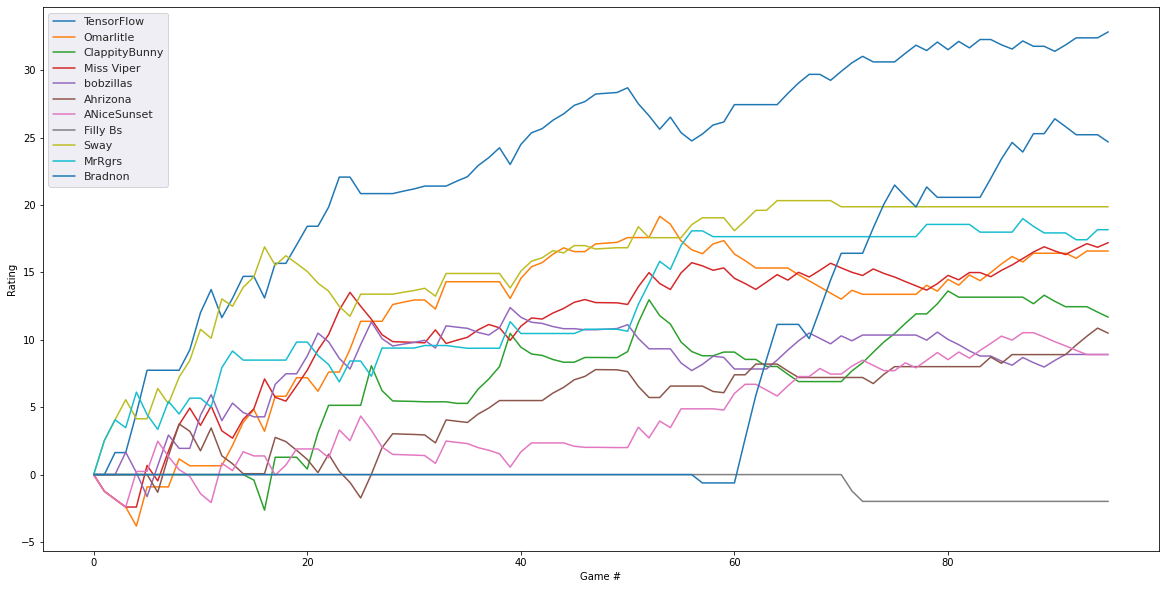

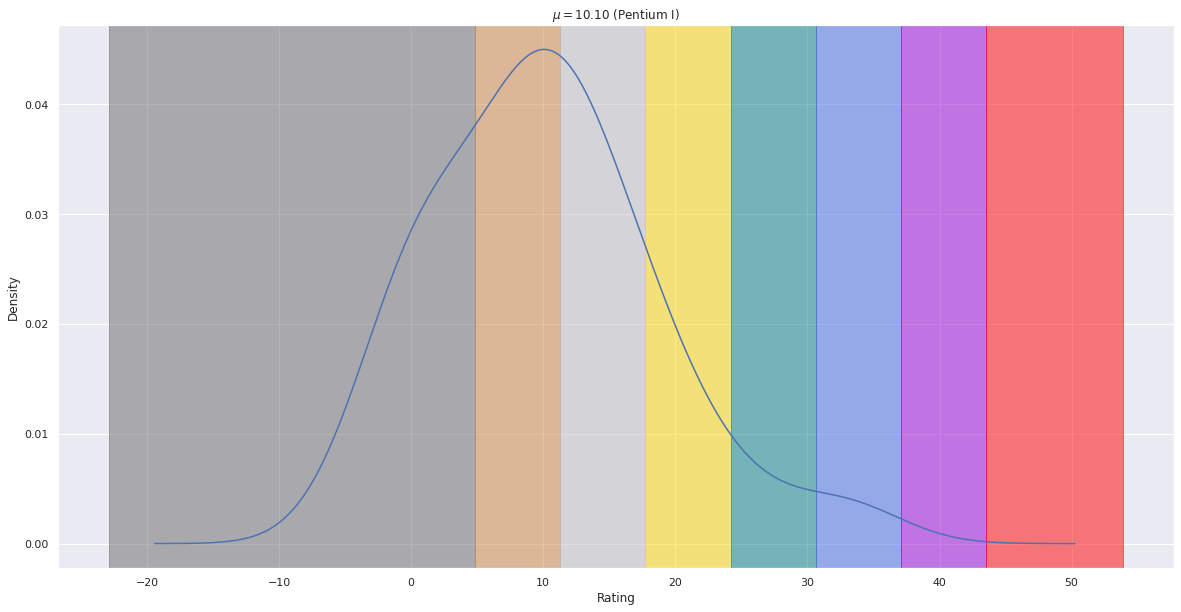

In [ ]:
show_draft_stats(matches,num_shown=10,min_games=7)
show_player_wr_by_champ(matches, name='TensorFlow')
name_list = ['TensorFlow','Omarlitle','ClappityBunny','Miss Viper','bobzillas','Ahrizona','ANiceSunset','Filly Bs','Sway','MrRgrs','Bradnon']
plot_elo_history(ratings,name_list)
plot_rank_dist(ratings)

# Synergy

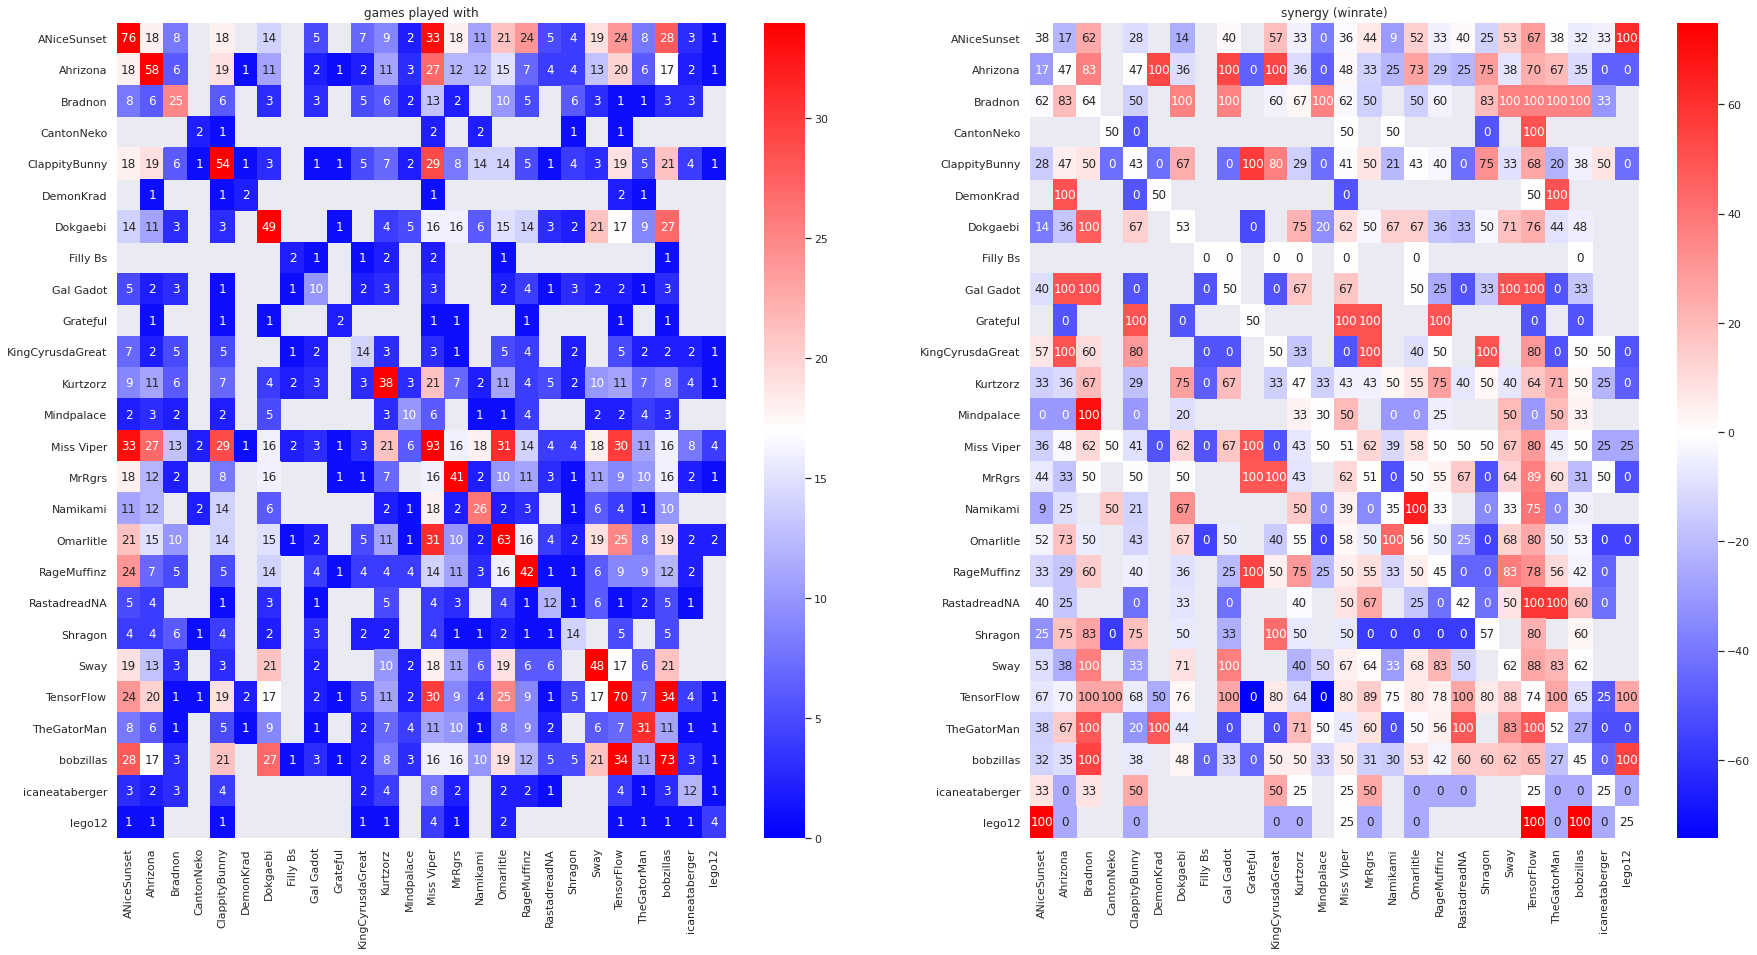

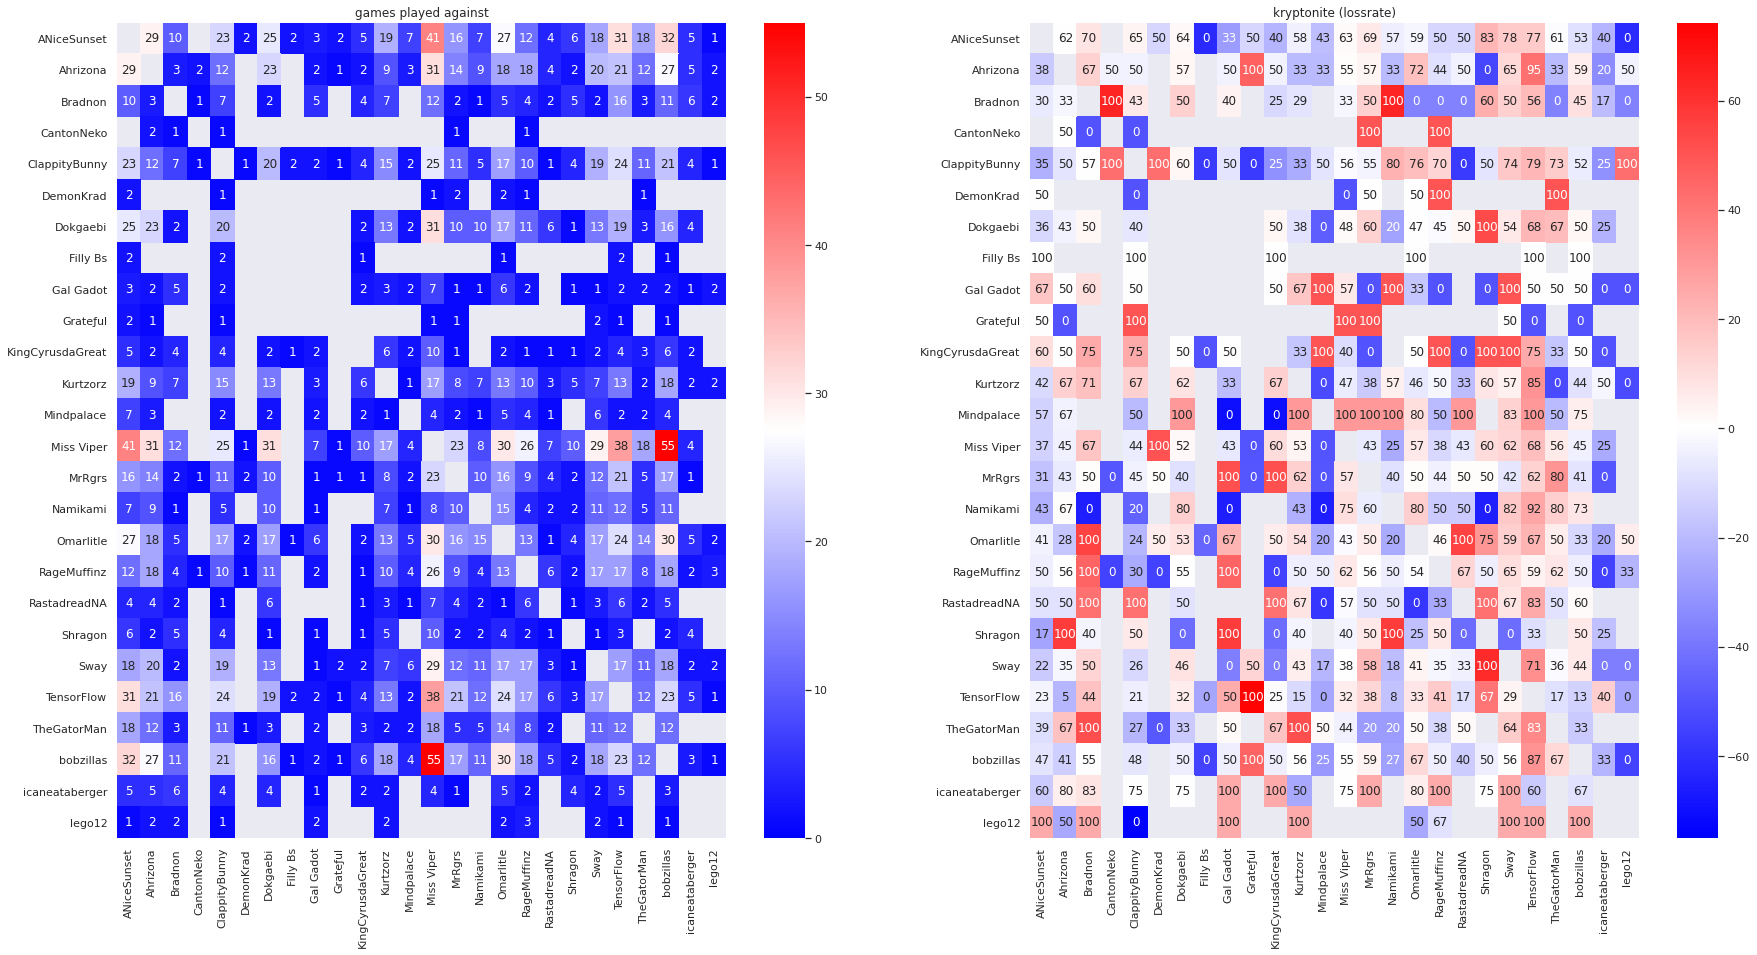

In [ ]:
synergy(wins, totals_with)
kryptonite(wins, totals_with, losses, totals_against)

# Matchmaking

In [ ]:
display_matchmaking(ratings)